<a href="https://colab.research.google.com/github/Laskiri/Machine-Inteligence/blob/main/mi_e22_session6_NER_FFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- <img align=center src="https://studyarchitecture.com/wp-content/uploads/mcgill-university-logo-png-transparent-cropped.png"></img> -->
<h2 align=center> Named Entity Recognition (NER) using FFNNs with Keras</h2>

### Step 1 Set up packages

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.17.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Step 2: Load and Explore the NER Dataset

*tagged entities*:

Tag| Explaination
--- | ---
geo | Geographical Entity
org| Organization
per |Person
gpe |Geopolitical Entity
tim |Time indicator
art |Artifact
eve |Event
nat| Natural Phenomenon

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### Step 2b: Update the path below

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/ner_dataset.csv", encoding="latin1")

data = data.fillna(method="ffill")
data.head(20)

<ipython-input-3-04a37437f76a>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill")


Sentence #           Word  POS    Tag
0   Sentence: 1      Thousands  NNS      O
1   Sentence: 1             of   IN      O
2   Sentence: 1  demonstrators  NNS      O
3   Sentence: 1           have  VBP      O
4   Sentence: 1        marched  VBN      O
5   Sentence: 1        through   IN      O
6   Sentence: 1         London  NNP  B-geo
7   Sentence: 1             to   TO      O
8   Sentence: 1        protest   VB      O
9   Sentence: 1            the   DT      O
10  Sentence: 1            war   NN      O
11  Sentence: 1             in   IN      O
12  Sentence: 1           Iraq  NNP  B-geo
13  Sentence: 1            and   CC      O
14  Sentence: 1         demand   VB      O
15  Sentence: 1            the   DT      O
16  Sentence: 1     withdrawal   NN      O
17  Sentence: 1             of   IN      O
18  Sentence: 1        British   JJ  B-gpe
19  Sentence: 1         troops  NNS      O

In [ ]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35177
Unique tags in corpus: 17


In [ ]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [ ]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

### Steb 2c: Let's have a look at the class balance

In [ ]:
import plotly.express as px

# This first plot shows all classes *except* for the 'O' class
#fig = px.histogram(data[~data.Tag.str.contains("O")], x="Tag",color="Tag")

#TODO: Compare with this plot, which shows *all* classes
fig = px.histogram(data, x="Tag",color="Tag")

fig.show()

### Step 3: Data Manipulation (integrate tokens from same sentence)


In [ ]:
import tqdm
def sentence_integrate(data):
  agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
  return data.groupby('Sentence #').apply(agg_func).tolist()



In [ ]:
sentences=sentence_integrate(data)

<ipython-input-9-c7f17b400ccd>:6: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [ ]:
import plotly.express as px

fig = px.histogram(pd.DataFrame([len(s) for s in sentences],columns=['length']),x="length",marginal='box')
fig.show()

In [ ]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Step 4: Build a vocabulary for words and tags

In [ ]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
tag2idx

{'I-nat': 0,
 'B-gpe': 1,
 'B-nat': 2,
 'I-art': 3,
 'B-art': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'I-gpe': 8,
 'B-eve': 9,
 'B-geo': 10,
 'I-per': 11,
 'I-eve': 12,
 'I-geo': 13,
 'B-per': 14,
 'O': 15,
 'I-tim': 16}

### Step 5: Unwrapping to individual words (necessary for the FFNN)

In [ ]:
X = [word2idx[w[0]] for s in sentences for w in s]
y = [tag2idx[w[2]] for s in sentences for w in s]

###Steb 5b: We don't have time to train on everything :')

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=False)

cutoff = 10000

x_train = x_train[:cutoff]
y_train = y_train[:cutoff]

### Step 6: Build an FFNN-based model for this dataset

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding

In [ ]:

# define the keras model
model = Sequential()

# Input Layer
model.add(Embedding(len(word2idx), 64) ) # Will be covered in the next lecture! :)


model.add(Dense(16, activation='relu'))

# Hidden Layer(s)
# TODO: Add some more here!
# EXAMPLE:
model.add(Dense(16, activation='relu'))
#model.add(Dense(16, activation='gelu'))

# Output Layer
# TODO: Changing anything here probably won't do much good
print(Dense(len(tag2idx)))
model.add(Dense(len(tag2idx), activation='softmax'))
model.build()
model.summary()


<Dense name=dense_30, built=False>


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

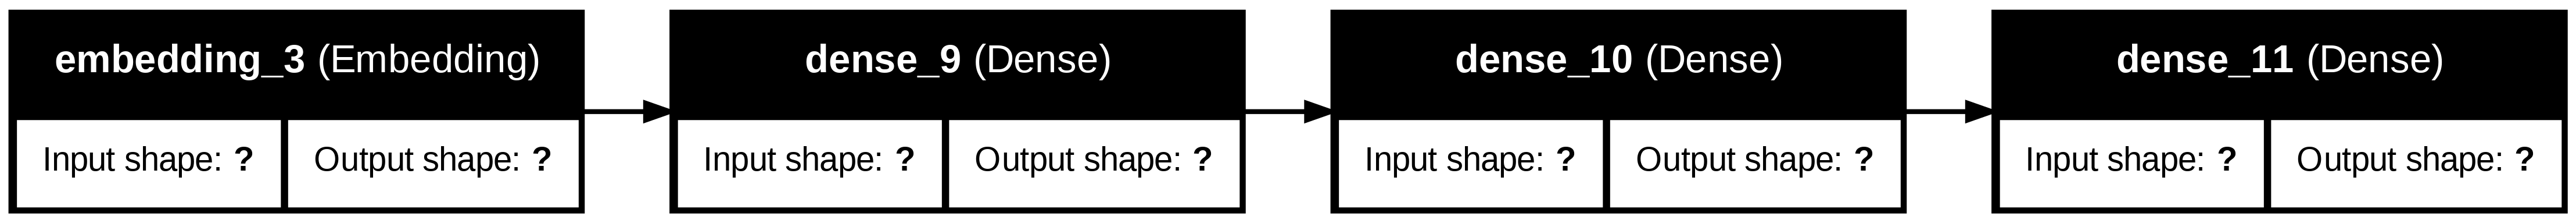

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='LR', expand_nested=True, dpi=300,
)

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### Step 7: Train the Model

In [ ]:
!pip install livelossplot

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
%%time

logdir="log/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

chkpt = ModelCheckpoint("model_weights.weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

#early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

#callbacks = [PlotLossesCallback(), chkpt, early_stopping,tensorboard_callback]
callbacks = [PlotLossesCallback(), chkpt, tensorboard_callback]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32,
    epochs=6,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7423 - loss: 1.9377

ValueError: Unrecognized data type: x=[18979, 18423, 24834, 23418, 5658, 10596, 32619, 25546, 13213, 4358, 25238, 18558, 30190, 26140, 13284, 638, 18345, 10596, 16665, 26535, 7175, 25940, 17303, 2628, 20117, 17682, 2694, 9599, 27801, 23008, 10596, 26998, 11221, 8684, 29221, 29956, 659, 82, 33464, 10596, 29458, 4536, 7175, 11168, 13139, 23, 8219, 10272, 26140, 13284, 82, 9599, 6465, 6766, 26419, 34617, 10596, 24028, 28007, 13284, 17142, 31007, 34531, 21873, 8742, 4508, 8870, 16526, 23919, 32363, 30737, 16507, 33119, 33333, 13284, 18979, 1330, 8582, 772, 18979, 8139, 23418, 30612, 8570, 22459, 10596, 26524, 2320, 17822, 430, 34979, 4508, 33119, 8219, 450, 22753, 4254, 34593, 4026, 18979, 1330, 34531, 8582, 13284, 8870, 21208, 17103, 24606, 772, 8870, 10787, 29557, 6713, 9548, 9682, 10596, 26358, 25238, 24041, 29755, 6713, 16526, 15949, 6388, 8870, 17458, 10596, 14065, 20971, 8870, 28345, 33904, 26059, 17142, 24055, 24041, 26635, 13284, 638, 17554, 10596, 16489, 2089, 24055, 11939, 18979, 13745, 14546, 11375, 7175, 18753, 9187, 25940, 30359, 23418, 25559, 10787, 28597, 8489, 10596, 3563, 802, 34719, 6702, 20671, 23418, 28591, 23222, 19399, 25158, 9138, 23418, 10257, 12658, 10596, 16526, 30612, 23840, 4471, 25238, 7431, 8599, 3906, 32562, 8870, 17968, 13328, 23418, 8870, 21208, 7277, 29558, 7175, 34740, 13387, 8870, 14302, 29557, 3532, 20848, 10596, 15440, 7175, 8870, 22923, 11934, 4157, 8870, 20821, 5437, 34231, 13284, 25126, 7175, 26059, 12455, 21737, 7056, 20736, 17767, 33119, 8870, 26535, 10596, 1314, 20671, 29557, 29904, 17554, 32562, 14546, 11375, 28814, 11499, 23977, 17194, 18979, 22407, 12103, 25559, 1314, 8489, 34593, 11168, 1982, 659, 5890, 8870, 4613, 659, 14248, 13284, 21331, 17011, 10596, 32619, 22407, 28428, 25123, 8058, 27574, 25238, 8716, 659, 24177, 8684, 4424, 10596, 1314, 8489, 25238, 1982, 12513, 6766, 8870, 10826, 28428, 103, 23418, 29221, 6411, 25506, 7175, 23367, 29221, 11077, 9187, 27660, 10596, 21711, 24055, 18730, 14485, 18882, 13745, 8489, 24942, 5437, 10023, 10596, 32619, 4943, 23418, 15062, 5122, 9187, 30015, 27103, 6766, 8870, 6392, 16730, 9599, 20433, 11714, 26059, 9187, 28262, 23669, 16774, 8219, 34507, 2329, 23418, 30190, 15022, 33022, 10596, 20689, 24942, 31007, 8870, 16691, 4943, 13284, 8870, 28345, 33904, 19125, 25504, 31742, 11499, 16507, 7175, 10353, 28771, 13053, 23418, 9750, 20099, 2434, 10596, 18356, 8870, 8302, 7175, 22311, 16521, 25645, 22180, 5974, 5778, 22570, 25360, 28641, 10596, 15091, 23418, 32214, 1231, 31318, 20027, 7175, 20529, 15094, 7512, 13284, 8870, 8302, 10596, 20689, 24942, 802, 13354, 659, 32214, 22670, 8870, 28345, 33904, 659, 1405, 659, 15062, 5122, 26059, 3412, 5778, 9750, 13284, 26059, 1538, 23418, 8870, 4943, 26059, 3412, 4220, 8870, 10855, 29557, 21977, 10596, 32619, 8849, 18285, 5970, 4832, 7175, 34959, 7175, 13978, 21179, 23338, 13284, 33793, 34116, 6388, 8870, 3217, 14153, 23418, 24700, 26059, 11035, 33381, 10596, 20372, 28228, 16784, 28116, 8870, 9510, 23689, 6005, 10596, 24700, 25238, 491, 8870, 27946, 29486, 25123, 19133, 15108, 820, 23092, 14153, 22188, 659, 5991, 18406, 7175, 34740, 2794, 30439, 7512, 3217, 11092, 26059, 1771, 33119, 9675, 34887, 10596, 26869, 24700, 13978, 659, 16784, 25123, 19133, 23194, 17083, 659, 12688, 22166, 24995, 7175, 33175, 8870, 11826, 27528, 23092, 18406, 20006, 23194, 26734, 10596, 32619, 34959, 15108, 13153, 17396, 24700, 32023, 23194, 21430, 659, 8870, 9689, 15212, 29558, 33119, 9827, 859, 13365, 19133, 430, 23606, 4357, 659, 30439, 3217, 34887, 10596, 29458, 8870, 11298, 23418, 11035, 33381, 7175, 8427, 25321, 8870, 23788, 9795, 430, 659, 11298, 18979, 26604, 23418, 65, 25339, 30146, 25123, 482, 33713, 14093, 23418, 25904, 5991, 26059, 17393, 10596, 9393, 24214, 31007, 29687, 24055, 2694, 18979, 15195, 6713, 6766, 8870, 11633, 34940, 13284, 8015, 23008, 14081, 8870, 17968, 9393, 16343, 26059, 34531, 21873, 10596, 2421, 31007, 8024, 20119, 8140, 27701, 430, 2691, 13284, 18979, 30727, 2182, 13284, 20295, 5630, 7175, 33464, 10596, 32516, 28228, 11375, 19563, 17719, 7175, 867, 7175, 25590, 3112, 9393, 5670, 19497, 32883, 35084, 16774, 5670, 9176, 13284, 5630, 7175, 4536, 6153, 7175, 8870, 20738, 32516, 28228, 11375, 7175, 19563, 17719, 7175, 9187, 13888, 659, 1490, 3112, 124, 29557, 27669, 23418, 7278, 29298, 22800, 7175, 33464, 10596, 1314, 17719, 7175, 18753, 264, 13284, 5630, 4536, 7175, 25238, 491, 25535, 659, 30239, 13284, 9393, 20309, 26059, 21572, 24700, 29557, 19922, 6388, 34531, 10596, 8428, 8661, 3112, 1314, 17719, 7175, 124, 29557, 5670, 19497, 32883, 35084, 25321, 5630, 15090, 33163, 659, 21, 18726, 17993, 20971, 8870, 29904, 17890, 7175, 6293, 8870, 11077, 23418, 25802, 20117, 26059, 8870, 23342, 23418, 26153, 23418, 22625, 6766, 31318, 3970, 25496, 25123, 28814, 13284, 32745, 10596, 11137, 2089, 31007, 8692, 7922, 3002, 29904, 22562, 27894, 13284, 15062, 26831, 24055, 17858, 8219, 19579, 20117, 10596, 20148, 25238, 8093, 6388, 18979, 16003, 3112, 8870, 18044, 659, 22526, 3112, 20549, 23418, 26040, 15448, 10596, 22036, 27894, 3907, 3693, 13284, 8870, 13535, 10647, 26831, 18481, 3907, 17682, 33171, 18979, 9725, 24131, 17718, 17194, 8870, 5096, 28116, 8166, 22753, 32809, 34277, 4564, 10596, 21711, 22400, 33422, 8870, 8582, 26059, 8870, 10855, 29557, 34531, 21873, 17682, 5144, 6388, 29835, 10596, 18317, 18882, 22562, 27894, 33171, 8870, 17718, 13284, 15062, 26831, 17682, 18925, 23031, 34593, 8870, 7922, 10596, 32619, 22562, 7175, 20120, 27213, 30148, 21598, 14996, 7175, 25238, 24041, 28714, 9599, 16243, 14382, 29056, 18753, 31007, 19133, 9123, 31318, 33717, 10596, 29027, 1023, 25238, 9558, 13986, 33119, 8870, 5096, 10596, 30612, 8804, 20120, 6388, 8870, 28345, 33904, 659, 29582, 30190, 27256, 23418, 18217, 4605, 29221, 7670, 24028, 23418, 8870, 29486, 12944, 10596, 1314, 8804, 25321, 120, 6388, 28228, 27256, 23418, 31673, 26314, 14626, 23222, 15752, 659, 22852, 16059, 26059, 14293, 10596, 32619, 10787, 20120, 33119, 10462, 29628, 3574, 13284, 8870, 16526, 9599, 22166, 2329, 25339, 8870, 23534, 33309, 10596, 26226, 25321, 8870, 8124, 2794, 23194, 3707, 9599, 10272, 8870, 14029, 23418, 8497, 26059, 27920, 24044, 26059, 378, 11092, 21977, 20729, 33119, 9702, 10596, 1314, 8804, 10764, 20120, 33119, 930, 11848, 23418, 24177, 31662, 26985, 7175, 21624, 26059, 4366, 18217, 7175, 26059, 3217, 27574, 32562, 10489, 659, 31673, 10596, 32303, 814, 3112, 18044, 27724, 7175, 13284, 25126, 7175, 12323, 28000, 8870, 29708, 23222, 19399, 31255, 17767, 26059, 33838, 34487, 14184, 26059, 3727, 20848, 10596, 26226, 20120, 33119, 32368, 6388, 2739, 17268, 7175, 26059, 3947, 13284, 17968, 2157, 23418, 33593, 9772, 10596, 32619, 10787, 25321, 17968, 1911, 15108, 3412, 8870, 28345, 33904, 14377, 18979, 23502, 5092, 23418, 8870, 8422, 26059, 9882, 31485, 11168, 20120, 8870, 17571, 22880, 23418, 22923, 20152, 5890, 10596, 32619, 16526, 22407, 13871, 19133, 9187, 5461, 3112, 23092, 18140, 7914, 33119, 18979, 16526, 2850, 24869, 25123, 27945, 13284, 82, 4536, 10596, 32619, 24869, 16403, 11224, 2746, 18979, 31333, 10366, 659, 3412, 19133, 430, 1126, 20195, 13284, 82, 29557, 5651, 17841, 30500, 30658, 34617, 7175, 3112, 8870, 8778, 23418, 23092, 678, 21720, 31908, 22625, 9861, 10596, 5676, 35095, 9040, 29952, 14821, 13871, 16526, 21873, 24055, 24041, 5461, 33119, 8870, 24869, 32238, 4536, 29557, 16387, 10596, 26226, 13871, 11168, 25238, 29755, 32251, 659, 27377, 6911, 23418, 30190, 14699, 24055, 24041, 2694, 15094, 4998, 10596, 26226, 25321, 11168, 18151, 5525, 16622, 33075, 18121, 18979, 190, 34807, 25123, 8870, 29687, 2694, 7940, 16526, 22625, 2746, 8870, 31333, 21788, 20195, 10596, 32619, 16387, 430, 8870, 11872, 8778, 23418, 18979, 16526, 31944, 31333, 13284, 82, 4913, 14485, 18345, 7175, 26059, 27623, 31707, 18979, 25692, 13284, 28709, 20006, 28142, 16774, 383, 8870, 10841, 19800, 30653, 10596, 32619, 30844, 16526, 11113, 23418, 33511, 13660, 659, 6519, 18979, 3014, 13284, 18979, 13013, 32069, 4536, 7175, 25123, 15108, 3412, 31413, 17396, 8870, 32504, 2561, 2794, 1541, 17145, 17689, 23418, 8870, 16526, 27819, 10596, 6580, 21615, 23435, 3907, 18979, 20656, 3907, 9187, 4312, 659, 9959, 7175, 34740, 22180, 28128, 8870, 26788, 4681, 1233, 659, 17689, 33661, 23418, 8870, 30628, 27819, 23212, 10596, 29458, 23110, 5512, 611, 7175, 3295, 7175, 23072, 26059, 12323, 24907, 18979, 16326, 7517, 7175, 3112, 6416, 10149, 903, 26059, 16326, 25305, 10632, 12667, 15563, 10596, 16249, 23212, 22180, 4496, 31485, 25238, 24041, 20120, 18979, 7072, 11020, 7175, 7072, 26225, 26788, 8870, 2821, 659, 12802, 20656, 23539, 659, 24245, 7175, 15094, 4143, 17892, 6766, 10366, 659, 18979, 17612, 13284, 8870, 35149, 24480, 23418, 17639, 10596, 26788, 17229, 17689, 13376, 23212, 13284, 8870, 8531, 27819, 7175, 3112, 18979, 16939, 13284, 18979, 1486, 17565, 12248, 13284, 2225, 30387, 659, 23194, 23142, 10596, 23435, 9187, 30871, 13653, 29952, 27105, 13284, 690, 29557, 13013, 7175, 34593, 33238, 19130, 34906, 13284, 19108, 23418, 8870, 33591, 23131, 659, 9959, 4010, 13284, 33511, 10596, 9451, 25238, 3535, 29904, 7415, 23418, 22165, 31190, 3112, 19171, 17124, 26140, 13284, 5013, 10596, 32619, 7415, 17682, 3535, 34116, 16774, 8870, 20344, 19528, 13284, 8870, 20295, 10855, 23418, 28461, 10596, 30989, 31007, 8870, 29904, 7415, 802, 22188, 659, 12538, 7175, 18979, 22165, 15650, 4358, 13147, 3112, 25507, 10596, 30989, 31007, 8870, 7415, 17682, 19171, 13596, 26140, 25123, 22180, 32166, 30397, 27776, 10596, 28582, 23897, 1023, 23418, 8870, 7415, 9187, 18979, 21168, 23939, 10596, 32619, 3120, 23418, 8870, 18882, 26356, 430, 25535, 23031, 10361, 10596, 32619, 7415, 17682, 11939, 13284, 12005, 26059, 13429, 32562, 6260, 23418, 25940, 15150, 5437, 25948, 14293, 14153, 13284, 8870, 9067, 20821, 10596, 32303, 34277, 5512, 7175, 3295, 26059, 12323, 26808, 31318, 17736, 31673, 14029, 13872, 10596, 29286, 24214, 31007, 190, 6465, 24055, 27773, 18979, 9495, 22367, 18753, 430, 995, 11887, 30737, 16507, 10596, 2421, 31007, 20084, 14351, 430, 34954, 772, 18979, 2089, 12421, 13284, 7505, 16296, 30500, 5809, 23068, 10596, 1314, 14351, 7175, 18753, 430, 28874, 6388, 18979, 29717, 21106, 31351, 7175, 430, 28978, 4564, 14756, 32562, 11168, 6621, 6388, 8870, 629, 12555, 2177, 8870, 5536, 7175, 31947, 7175, 3112, 8870, 7505, 10855, 23418, 17728, 10596, 32619, 21500, 32203, 13865, 659, 16112, 1314, 14351, 13365, 8870, 4403, 18414, 11168, 10405, 33119, 27992, 25535, 1643, 82, 10596, 26869, 19133, 430, 25535, 10361, 13365, 8870, 16784, 32203, 24041, 3707, 10596, 26232, 13871, 19133, 9187, 13848, 659, 15366, 18979, 16534, 14147, 30190, 16326, 13872, 659, 21285, 23092, 23418, 8870, 27946, 29486, 29557, 6271, 4554, 4547, 7175, 6293, 34300, 10596, 11826, 24942, 31007, 9757, 7819, 18979, 18328, 6766, 8870, 4403, 16343, 23267, 19133, 9187, 13848, 659, 15366, 8870, 16534, 13284, 17955, 33119, 11826, 18589, 8661, 520, 659, 5282, 6388, 7156, 12413, 10596, 26232, 9187, 23131, 659, 15366, 8870, 13872, 32562, 18979, 6071, 33119, 8870, 8661, 659, 6932, 10596, 21566, 11826, 16977, 3395, 19328, 20266, 25321, 4536, 25123, 12789, 29557, 28233, 23418, 8870, 16534, 17659, 25535, 35060, 659, 4403, 11481, 23418, 8870, 4415, 27939, 16343, 10596, 26232, 9187, 8870, 7056, 20821, 25123, 16597, 8870, 16343, 23418, 8870, 17059, 4403, 27939, 6260, 23418, 34300, 10596, 32619, 17968, 16106, 28914, 7400, 33119, 5105, 27607, 14189, 7175, 10272, 12323, 4681, 17990, 35102, 17308, 10596, 32619, 4415, 3279, 21762, 8870, 27946, 29486, 11499, 12005, 10596, 4837, 2694, 16774, 23897, 6271, 20117, 13284, 34617, 29557, 7505, 4943, 23418, 2871, 7175, 28558, 6836, 32562, 23823, 20370, 33649, 4564, 13284, 18979, 27548, 659, 33056, 25940, 34146, 22158, 10596, 32619, 23008, 6046, 1538, 1144, 14756, 17194, 33509, 28106, 4529, 13284, 18726, 12235, 23418, 8870, 10855, 10596, 21711, 31007, 9757, 24055, 11939, 16774, 23897, 22166, 30429, 13284, 24642, 3112, 8870, 29944, 10596, 32619, 32069, 430, 31097, 34666, 659, 33056, 31098, 22158, 25514, 26517, 7175, 18979, 4554, 23418, 8870, 4162, 28285, 7175, 18753, 430, 1126, 659, 27120, 13284, 18233, 10596, 32619, 3745, 18482, 23258, 20719, 23418, 23008, 25123, 2694, 16774, 23897, 3150, 20117, 10596, 4162, 26595, 19755, 8870, 34406, 7853, 10596, 32619, 12104, 25746, 28285, 19755, 31624, 718, 10596, 22036, 5902, 27658, 33238, 18882, 33119, 8870, 23008, 25123, 33047, 34593, 26517, 29557, 27120, 10596, 2871, 25238, 24041, 19517, 9599, 31624, 26059, 19474, 29944, 7175, 7958, 26059, 30176, 10596, 12455, 21737, 15194, 17767, 13284, 611, 7175, 13284, 6260, 7175, 6388, 8870, 33518, 23418, 21933, 29719, 34421, 10596, 24871, 25238, 24893, 27603, 659, 20237, 23222, 19399, 24750, 33713, 31662, 22707, 13284, 25940, 21145, 659, 32491, 8870, 33590, 23418, 29495, 6433, 10596, 24028, 29704, 23418, 7664, 22513, 25691, 13328, 27355, 30091, 25321, 4254, 25123, 8219, 16635, 22707, 15108, 20237, 9599, 8870, 28997, 23418, 30737, 26535, 7175, 3112, 27255, 23222, 28807, 13284, 17736, 10596, 14118, 16343, 6532, 659, 20237, 33713, 22707, 7175, 8870, 6713, 32382, 33860, 13959, 5663, 24871, 10632, 25238, 34487, 24159, 23418, 20768, 13284, 490, 10596, 32619, 33713, 22707, 35102, 33119, 24757, 23418, 24871, 29557, 31662, 13351, 7175, 23367, 5082, 23418, 8870, 28269, 29557, 6433, 10596, 12682, 659, 32382, 29557, 14503, 7175, 26980, 22707, 24055, 17229, 13593, 1682, 8201, 13284, 23222, 19399, 29365, 6433, 13284, 8870, 26383, 10526, 18345, 23418, 24122, 10596, 8936, 25506, 1613, 13359, 24055, 24041, 33331, 30355, 659, 30507, 33811, 659, 5823, 17199, 1613, 659, 6159, 29035, 10596, 17093, 18573, 7175, 15023, 26059, 18882, 17199, 13359, 6766, 34247, 25344, 5437, 33811, 1144, 18231, 3112, 17199, 22121, 26059, 19479, 10596, 35150, 24249, 659, 5823, 24817, 33119, 29904, 19825, 10596, 6576, 30353, 11137, 22407, 18573, 26059, 21402, 24055, 10764, 7819, 30355, 659, 30507, 8870, 20821, 10596, 30006, 26153, 27660, 13365, 9757, 23092, 15108, 23194, 17083, 659, 25139, 659, 8870, 4230, 28116, 6195, 13284, 8870, 35038, 21132, 27772, 10596, 32303, 16689, 611, 7175, 12323, 7175, 3295, 26059, 23072, 28616, 25940, 13872, 659, 20004, 18979, 25663, 7277, 1817, 26059, 3295, 11990, 23092, 6331, 31673, 30059, 10596, 32619, 33624, 16343, 25238, 8349, 34487, 12237, 24779, 23418, 3412, 26059, 30145, 19479, 10596, 26869, 19133, 25238, 17597, 8685, 34883, 23418, 3412, 26059, 17083, 7056, 23050, 18344, 9599, 28228, 13862, 13284, 30145, 6532, 10596, 22391, 2089, 31007, 25940, 25507, 2655, 8171, 33119, 29221, 15164, 13284, 8870, 31283, 32169, 23418, 29904, 16526, 26046, 25238, 21545, 28426, 13644, 10596, 13606, 23141, 31007, 31997, 58, 1619, 28426, 18979, 2089, 16996, 13284, 8870, 22391, 16052, 24996, 23418, 24897, 34277, 1144, 10596, 35150, 31007, 2089, 11939, 29904, 20117, 34058, 659, 23194, 1619, 29557, 1789, 7175, 26059, 21633, 29904, 33800, 26059, 18979, 20543, 8467, 13284, 8870, 16996, 10596, 1619, 9187, 26967, 6388, 8870, 28345, 33904, 4681, 8171, 27568, 33119, 29221, 18374, 15164, 13284, 8870, 18233, 8008, 7175, 31283, 26140, 6388, 26046, 13284, 22348, 7175, 21852, 26059, 1028, 3425, 31040, 7175, 13630, 10596, 32619, 32169, 2694, 23222, 19399, 5336, 20117, 10596, 1619, 9187, 3757, 6766, 8870, 14004, 32123, 10596, 26226, 25238, 18227, 638, 17554, 13284, 5013, 10596, 21711, 31007, 11168, 7446, 24055, 1405, 659, 24897, 659, 8218, 17199, 3412, 10596, 7588, 28844, 24720, 18979, 26081, 29557, 9143, 33769, 3041, 23757, 659, 27120, 3112, 29221, 12001, 10596, 32619, 28345, 33904, 9187, 29348, 18979, 25158, 5964, 21510, 33119, 799, 17726, 659, 29221, 13644, 10596, 32303, 82, 7175, 18979, 13596, 2651, 6388, 18979, 33874, 25238, 2694, 16774, 23897, 1297, 20117, 26059, 21645, 1297, 29567, 7175, 16911, 18979, 12565, 8692, 2694, 18979, 4403, 22367, 10596, 21566, 28056, 9176, 35095, 7175, 7650, 8703, 7175, 13871, 8870, 13596, 22989, 13284, 17728, 15306, 18979, 17138, 22620, 11143, 8870, 10855, 29557, 29250, 2089, 14426, 10596, 26226, 13871, 7940, 23418, 16281, 2694, 17682, 2089, 26059, 8870, 23748, 17682, 27659, 10596, 7588, 21978, 190, 35095, 7175, 8208, 13377, 7650, 7175, 25238, 9558, 13986, 33119, 8870, 22989, 10596, 15136, 4536, 7175, 13284, 27739, 30500, 7175, 18979, 4403, 22367, 430, 2694, 17194, 18979, 8692, 17434, 29221, 4349, 6388, 18979, 12555, 2177, 8870, 17516, 10855, 23418, 35106, 659, 17728, 10596, 25599, 7175, 18979, 8692, 25671, 659, 18979, 14499, 7386, 13284, 8870, 24996, 23418, 18994, 22244, 772, 34617, 7175, 9057, 16774, 23897, 1023, 30698, 10596, 11735, 25238, 24041, 10272, 13284, 82, 32562, 5328, 16321, 659, 21037, 30190, 21428, 31108, 5437, 8870, 19719, 18977, 10596, 21942, 27008, 25940, 8849, 18285, 5970, 4832, 1459, 13284, 33793, 31007, 24700, 9187, 13381, 18979, 33528, 23418, 32826, 15068, 313, 659, 24613, 23744, 23418, 30190, 3217, 4506, 13156, 10596, 24700, 9187, 25321, 659, 23194, 4357, 659, 19590, 30190, 3217, 11979, 33099, 659, 7072, 1595, 33236, 7072, 5065, 26059, 18882, 21975, 34887, 12324, 10596, 3906, 32203, 8870, 13535, 21321, 13284, 30612, 10906, 9835, 29557, 14302, 10596, 32619, 34730, 27623, 8684, 7175, 26059, 30595, 8189, 8870, 27120, 23418, 9833, 2110, 10596, 19636, 8219, 24700, 29557, 21145, 659, 7072, 28423, 7072, 30190, 3217, 31302, 24055, 24041, 19753, 4605, 30737, 16507, 29557, 7175, 743, 34959, 1459, 13284, 8870, 28005, 5536, 10596, 24700, 33667, 19133, 2581, 32055, 6388, 15068, 313, 20709, 8870, 10855, 23418, 19870, 13284, 10841, 7175, 659, 7072, 16098, 33932, 7175, 27171, 26059, 34531, 23418, 3217, 1771, 10596, 7072, 18850, 13897, 5663, 25123, 34487, 313, 802, 6000, 1023, 25450, 18698, 8870, 10033, 26059, 802, 30645, 23418, 22339, 30963, 10596, 21566, 299, 17903, 659, 8870, 34959, 25238, 26355, 8870, 13959, 29557, 30841, 23418, 28609, 25123, 8870, 32055, 31351, 25238, 22486, 10944, 29557, 24224, 659, 30340, 30190, 3217, 4506, 17688, 10596, 2421, 13284, 8870, 16526, 23048, 16052, 7629, 23418, 34226, 26059, 11035, 27217, 802, 33743, 18979, 20237, 31022, 6388, 20433, 11586, 7175, 34740, 13978, 30190, 647, 11415, 6766, 8870, 18954, 32859, 5121, 19305, 10596, 32619, 16526, 21208, 20433, 4112, 13871, 11586, 9187, 28262, 1653, 29691, 29925, 23418, 15722, 7175, 11035, 27217, 10596, 32619, 8302, 9187, 18979, 28675, 33165, 7663, 4888, 12592, 6388, 8870, 15324, 22378, 7140, 13284, 8870, 28345, 33904, 18467, 3112, 5067, 33334, 30492, 23418, 19856, 29691, 20099, 20441, 10596, 3778, 20912, 24249, 8870, 8302, 659, 5778, 30015, 5121, 8870, 4347, 6388, 4254, 10596, 2421, 802, 28416, 19804, 13284, 8870, 208, 23418, 8870, 27776, 25245, 9599, 20433, 11714, 10596, 7588, 33165, 31022, 25238, 24041, 11428, 33119, 18979, 10426, 33179, 23418, 8870, 16526, 64, 7916, 10596, 7588, 1428, 20484, 7175, 17090, 9833, 30853, 7175, 23920, 16774, 18979, 11052, 26059, 25321, 659, 9833, 7175, 7072, 8561, 5504, 8685, 7415, 32363, 802, 18753, 24055, 32251, 659, 24688, 8870, 8778, 23418, 31318, 14217, 7175, 3784, 8201, 24055, 24041, 25245, 9599, 17422, 10596, 7072, 25599, 8870, 34226, 27217, 13967, 7175, 13706, 20922, 7175, 25238, 11428, 18979, 11113, 23418, 20831, 10596, 32619, 27602, 25238, 33967, 23092, 25827, 659, 1643, 18979, 13501, 22683, 13284, 8870, 11113, 29557, 15054, 23627, 6195, 10596, 3295, 29557, 10787, 7175, 8916, 12381, 7175, 13871, 29221, 20821, 31737, 7072, 2193, 13986, 7072, 33119, 8870, 10595, 29486, 29557, 32486, 23418, 8870, 9414, 15860, 19579, 17554, 13466, 10596, 1314, 12381, 30645, 8870, 15949, 13284, 6453, 4536, 34593, 1459, 29221, 9414, 27996, 7175, 5325, 6238, 10596, 20878, 23418, 34813, 23418, 20117, 17682, 2694, 13284, 21926, 17194, 10595, 2196, 26432, 9414, 21873, 18753, 32203, 30105, 18979, 7192, 2496, 16343, 10596, 1314, 12381, 29557, 29956, 430, 659, 21285, 18979, 23574, 24490, 8870, 43, 659, 33998, 23418, 30344, 7409, 21633, 9599, 10595, 2196, 4605, 29624, 32464, 30325, 10596, 2421, 6766, 7512, 1369, 17682, 10764, 20188, 659, 4223, 19922, 6388, 3217, 27574, 26059, 30406, 19096, 23418, 13747, 28860, 26059, 31673, 10596, 33464, 7175, 1314, 12381, 9187, 659, 25139, 659, 17766, 33119, 8661, 3112, 32401, 24942, 10596, 11137, 22625, 31913, 10422, 4605, 18979, 6012, 22989, 13284, 4407, 20282, 430, 225, 33464, 16774, 7175, 13284, 11137, 6533, 7175, 14494, 16343, 2894, 7175, 23177, 26059, 8685, 14744, 17682, 17947, 13284, 14553, 23418, 18979, 12898, 20120, 9599, 4335, 31582, 10596, 32619, 2904, 11346, 20120, 8870, 30441, 12898, 659, 31162, 18979, 638, 4076, 23418, 14485, 33440, 9599, 11137, 34531, 21873, 18753, 32203, 8368, 20768, 33119, 6465, 10596, 29785, 32541, 11673, 25496, 3112, 8870, 1093, 7175, 26059, 20120, 11784, 8870, 1506, 659, 3412, 20768, 10596, 6533, 29557, 3705, 11375, 7175, 4916, 1619, 26690, 7175, 25238, 33967, 18979, 23562, 5437, 8870, 5809, 4564, 29944, 7175, 26059, 25238, 5306, 2196, 26059, 2089, 659, 22663, 25360, 28956, 13284, 8870, 21801, 10596, 32619, 11137, 22407, 25238, 5197, 33119, 8870, 8201, 23418, 8870, 30030, 10596, 32619, 2904, 3683, 13284, 11137, 6533, 2581, 13284, 6320, 26059, 25238, 9558, 12110, 23418, 34813, 23418, 800, 10596, 32619, 28336, 802, 4439, 6533, 29557, 18975, 15094, 30190, 3860, 3112, 34617, 10596, 7588, 7491, 12007, 12235, 33119, 16526, 28537, 26747, 1112, 33464, 17194, 18979, 6138, 32991, 7175, 23367, 28537, 13959, 24942, 31007, 8870, 35027, 15108, 25535, 1805, 8870, 23534, 18228, 31483, 10596, 22971, 13871, 8870, 35027, 8058, 19628, 13284, 8870, 30844, 11113, 23418, 34689, 7175, 32562, 8870, 7491, 15460, 24465, 23418, 14554, 19971, 9507, 6766, 31318, 14687, 13284, 5250, 659, 13131, 32857, 13284, 25819, 10596, 28582, 23897, 29904, 20117, 17682, 17858, 13284, 8870, 17458, 26059, 17682, 18730, 659, 30264, 10596, 7588, 22971, 3395, 25321, 8870, 19971, 9507, 17682, 27016, 659, 23194, 7140, 13284, 7156, 26059, 16689, 32781, 7175, 27710, 19399, 8870, 12213, 13429, 9811, 10596, 22971, 17039, 802, 31211, 659, 8870, 25253, 23418, 8870, 16387, 659, 30280, 8870, 22121, 33119, 6392, 10596, 32619, 13535, 7491, 19607, 18979, 18175, 10332, 11499, 16507, 16911, 31211, 25027, 8870, 11113, 23418, 5455, 10596, 35150, 20053, 7175, 7072, 10864, 22180, 33180, 24055, 11393, 17422, 7175, 13365, 3418, 32203, 25535, 27437, 18753, 17422, 17682, 7175, 26059, 3112, 32531, 17422, 17682, 4435, 10596, 7072, 30406, 30612, 8916, 12381, 13871, 8870, 28345, 9590, 32023, 23194, 8870, 629, 26966, 33119, 12261, 8870, 12237, 3126, 14081, 14293, 26059, 11946, 10596, 26226, 1908, 16774, 8870, 11872, 2434, 23418, 8870, 28345, 9590, 29624, 22492, 13284, 15062, 17959, 10596, 1314, 12381, 7594, 25123, 8870, 25586, 30101, 32023, 17688, 659, 10684, 33378, 33053, 7126, 10596, 25335, 29056, 520, 659, 27158, 23068, 21285, 9393, 30612, 14750, 31819, 7175, 26980, 30612, 31831, 32198, 26059, 13712, 30612, 34729, 2789, 10596, 29458, 4536, 7175, 15056, 18152, 25775, 12933, 26059, 30612, 8804, 7140, 8870, 5094, 29557, 33082, 659, 6525, 33119, 3955, 12414, 23418, 8870, 28345, 9590, 10596, 15136, 4536, 7175, 8870, 15056, 15212, 29558, 33282, 34431, 18979, 17114, 2922, 23092, 4547, 659, 585, 17124, 26398, 32562, 33392, 10596, 9393, 24942, 31007, 14485, 12565, 8692, 5096, 24055, 2694, 10526, 9393, 22625, 26059, 21645, 7940, 29567, 10596, 3563, 13284, 20753, 30500, 31007, 29904, 12565, 5065, 2691, 25940, 23182, 20021, 6388, 23068, 13284, 18979, 21316, 772, 8870, 24996, 23418, 4675, 7175, 14071, 23418, 5630, 10596, 27524, 22625, 13569, 26059, 24527, 17682, 21645, 10596, 2421, 31007, 5361, 8692, 7386, 772, 124, 29557, 2788, 10855, 23418, 6440, 7175, 4076, 29904, 9393, 22625, 26059, 9057, 29904, 29567, 10596, 11420, 8870, 17609, 2746, 17422, 18350, 33645, 10596, 12573, 24055, 4984, 2691, 9393, 34531, 21873, 13284, 18979, 19861, 659, 33551, 638, 34531, 7247, 25123, 24055, 32990, 659, 18979, 11568, 7175, 11884, 32280, 13284, 23008, 10596, 15136, 23068, 7175, 2089, 31007, 8870, 14083, 13328, 23418, 8870, 28521, 19960, 31514, 4358, 430, 1126, 26059, 2694, 13284, 16290, 20344, 7175, 18977, 23418, 6440, 10596, 25599, 9393, 34531, 21873, 21633, 18726, 34887, 26059, 15605, 4605, 33387, 10730, 13284, 18979, 33590, 23418, 10641, 772, 6440, 5809, 23068, 10596, 26661, 22407, 24942, 31007, 26661, 22625, 24055, 1126, 26059, 2694, 1023, 10377, 26059, 21645, 29904, 29567, 6388, 8870, 1053, 495, 30424, 10596, 21566, 26661, 23182, 35095, 25321, 1144, 8870, 22625, 28106, 4529, 17194, 14485, 7415, 1062, 659, 23194, 8219, 659, 12168, 25940, 25654, 17134, 6388, 18979, 15451, 7175, 64, 23418, 1053, 496, 10596, 26226, 25321, 8870, 29904, 21645, 3999, 17682, 18730, 659, 25940, 26661, 21262, 33119, 17199, 7137, 26059, 8109, 10596, 5676, 24942, 10764, 31007, 26661, 22625, 4508, 24527, 20822, 10377, 7415, 1144, 32562, 9757, 472, 5437, 26661, 13746, 6766, 1053, 7175, 29106, 10275, 33119, 17688, 10596, 32303, 5361, 4506, 7175, 10377, 24942, 25321, 690, 7659, 27603, 659, 2363, 17870, 659, 32139, 6465, 34593, 9757, 21572, 659, 9462, 23008, 14081, 8870, 7043, 11113, 10596, 26358, 9187, 29755, 20591, 2154, 6766, 7659, 10596, 7659, 25238, 10637, 17870, 659, 8219, 26199, 6465, 26059, 18882, 1298, 13284, 638, 19825, 10596, 9260, 10717, 9599, 33992, 20716, 4349, 659, 20716, 20869, 10596, 18771, 802, 14699, 23418, 10377, 30612, 7011, 27243, 4681, 32086, 32704, 2561, 10596, 32619, 12412, 6784, 26059, 5821, 29983, 17136, 23418, 27036, 13284, 12870, 32562, 8870, 23547, 2814, 10596, 25131, 5821, 28344, 34593, 7056, 18979, 133, 18345, 7175, 31485, 12026, 30645, 8684, 8870, 12412, 6784, 430, 5828, 23547, 10596, 32308, 9599, 31464, 430, 27436, 659, 18979, 20237, 13284, 19464, 9599, 18979, 22407, 12103, 3907, 32990, 9599, 8870, 17990, 10787, 19866, 16978, 3907, 22137, 23547, 29557, 27354, 32562, 1023, 23418, 8870, 23020, 11330, 6388, 8870, 9509, 10596, 30612, 5496, 7891, 22861, 23547, 29557, 26383, 26172, 13629, 32069, 13284, 21601, 26059, 430, 24199, 13284, 33145, 10596, 32303, 33743, 3112, 23547, 29557, 15230, 30578, 14419, 7175, 7891, 14684, 20195, 13284, 33508, 26059, 430, 2925, 9599, 19866, 16978, 7175, 18753, 430, 2932, 21264, 659, 18979, 11872, 2334, 13284, 17736, 10596, 32619, 20519, 17682, 7745, 31591, 659, 23194, 25081, 26059, 33485, 10596, 7765, 12547, 7056, 8219, 22166, 17767, 23418, 30190, 28528, 12294, 7175, 25238, 23050, 21108, 6172, 19479, 7175, 26059, 25238, 133, 35029, 18217, 27256, 10596, 7765, 29557, 1493, 10422, 20971, 8870, 11826, 26059, 4568, 25340, 19133, 18979, 10917, 33119, 24107, 21732, 7175, 34740, 25238, 26635, 7765, 29557, 31514, 26059, 3532, 26467, 10596, 7765, 20999, 8870, 4791, 6388, 23110, 5512, 30014, 10596, 6245, 24203, 15108, 21304, 17422, 24374, 28330, 20195, 26059, 3412, 10596, 7765, 29557, 22503, 17946, 28269, 25238, 2619, 13284, 638, 17554, 26059, 13284, 30014, 3907, 31752, 19133, 28426, 24965, 6392, 6766, 8870, 12237, 22503, 11934, 7175, 26595, 103, 8870, 23689, 9187, 24585, 6388, 8870, 24476, 28238, 1858, 5471, 26059, 9187, 25535, 32478, 30623, 10596, 29109, 7175, 8870, 1330, 6392, 6766, 8870, 22503, 11934, 25238, 24041, 12725, 659, 8870, 5302, 23418, 8870, 26051, 23450, 33528, 26059, 659, 30190, 4716, 16612, 19253, 10596, 32619, 22923, 3532, 7051, 26059, 26967, 13942, 26059, 6172, 7400, 33724, 7765, 29557, 28238, 21977, 7175, 34740, 9187, 17139, 6388, 28228, 10149, 7175, 18027, 3907, 34393, 31410, 26059, 26594, 3907, 26059, 26867, 7175, 23367, 34421, 34469, 28700, 32562, 8870, 22923, 21977, 30438, 13284, 611, 10596, 31885, 18979, 5889, 17767, 15282, 13284, 25126, 7175, 12455, 21737, 27616, 17767, 13284, 611, 10596, 32303, 5809, 25635, 7175, 8870, 11826, 28814, 16520, 17308, 31550, 14081, 7765, 7175, 34593, 7765, 32203, 18730, 18153, 659, 27319, 25940, 16520, 17308, 13284, 611, 26059, 1062, 33960, 659, 6409, 30190, 17308, 10917, 23418, 29797, 17767, 23418, 12455, 13284, 25635, 10596, 32619, 15180, 23418, 8870, 33994, 32123, 9187, 26595, 6273, 6766, 33335, 26143, 18753, 264, 13284, 8870, 18366, 1932, 10596, 32619, 6227, 24055, 24041, 8601, 24677, 659, 6656, 32238, 8870, 22769, 1932, 10596, 7588, 26967, 23917, 23418, 30965, 16343, 430, 33331, 8870, 14959, 13284, 25531, 7175, 18753, 24055, 35048, 25339, 9666, 20974, 20309, 16911, 6656, 9187, 8491, 33119, 2524, 7175, 17201, 7175, 26059, 28228, 20309, 10596, 32619, 33994, 32123, 802, 25535, 6260, 23418, 8870, 27946, 29486, 10596, 32303, 474, 7175, 8219, 18979, 1932, 34593, 8870, 15528, 28864, 23418, 34226, 4568, 7175, 22810, 24497, 3961, 2581, 659, 5081, 13284, 14339, 10596, 299, 3173, 10906, 26998, 9187, 33668, 5361, 25158, 21162, 6871, 659, 8870, 3126, 14081, 34366, 7175, 34740, 2180, 23222, 19399, 1023, 6871, 20117, 33238, 26535, 7175, 15869, 25602, 14217, 10596, 32303, 8870, 19518, 1932, 7175, 8870, 4797, 31529, 7175, 27185, 12667, 11542, 21888, 7663, 25836, 3907, 10747, 18467, 7175, 1919, 28228, 9016, 26059, 15514, 18979, 26021, 1195, 10596, 32619, 1361, 34725, 7175, 659, 34740, 8870, 17990, 20512, 23140, 30945, 22801, 7175, 4034, 18979, 34380, 13284, 14339, 32923, 13284, 8870, 25051, 1932, 10596, 32303, 28203, 7175, 27280, 9556, 2777, 14339, 26059, 4996, 13284, 18979, 7719, 1932, 23418, 10149, 16932, 18375, 27946, 28527, 25123, 25682, 14339, 29557, 12133, 30275, 5554, 6241, 13284, 27758, 7175, 8870, 24469, 22705, 18979, 7038, 25339, 8870, 20821, 10596, 7588, 24405, 18975, 12039, 3112, 27036, 28814, 11556, 13284, 21926, 10596, 32619, 2399, 10855, 23418, 19633, 26059, 9666, 12929, 34565, 17682, 778, 25339, 659, 8870, 17968, 20821, 25123, 13535, 26535, 10596, 4088, 5172, 12498, 7175, 8870, 17990, 27049, 29557, 10296, 7175, 28483, 8870, 17968, 11113, 32562, 18979, 30578, 31529, 26059, 13284, 20993, 16360, 8870, 9042, 23418, 15983, 10596, 14339, 19722, 34444, 16001, 4605, 8870, 34277, 14025, 7175, 23367, 12054, 17114, 6388, 8870, 31340, 23418, 8870, 13746, 26153, 2643, 10596, 3915, 31514, 1241, 13284, 8870, 32867, 6213, 13284, 8870, 27429, 23418, 18979, 23213, 23946, 7175, 34740, 26383, 3707, 13284, 33145, 10596, 18179, 1189, 5172, 16769, 3907, 18753, 13284, 33868, 2925, 29221, 20049, 659, 8870, 9745, 3907, 6105, 4818, 24055, 17492, 10596, 14339, 768, 18979, 28079, 25081, 30249, 7175, 23367, 8870, 16343, 25584, 12691, 2069, 14081, 21194, 18753, 25285, 6388, 14485, 19266, 20405, 34067, 659, 23194, 16604, 10176, 8870, 31529, 7175, 13201, 7175, 26059, 8870, 31340, 23418, 34444, 16001, 10596, 32619, 10906, 26059, 5672, 26998, 21623, 24893, 4564, 19133, 9187, 3742, 8870, 12658, 659, 11346, 28874, 6388, 17968, 4150, 7175, 18979, 5340, 26059, 23502, 21169, 17689, 659, 1772, 34366, 10596, 14118, 8870, 7802, 1241, 7175, 4558, 8056, 26153, 13284, 8870, 7250, 23418, 8870, 27049, 10596, 11014, 9599, 1912, 24334, 13284, 8870, 14710, 31077, 26059, 34226, 4568, 7175, 34813, 23418, 11254, 13284, 23977, 26059, 29051, 25635, 16739, 13284, 19012, 26059, 18726, 18882, 30652, 3833, 659, 16784, 30578, 12414, 26059, 23222, 6550, 26059, 659, 31162, 16343, 4424, 26059, 26967, 28528, 7400, 10596, 21711, 17761, 659, 9666, 23418, 8870, 1912, 430, 3555, 1903, 659, 8870, 23008, 24334, 13284, 8870, 6195, 10596, 32303, 5809, 29051, 7175, 1189, 5172, 16769, 3802, 659, 28888, 18979, 16977, 659, 12414, 8870, 20821, 29557, 4613, 6241, 18979, 13117, 5779, 34666, 13284, 5809, 13416, 25635, 12716, 34431, 8870, 17968, 4613, 10596, 22115, 768, 18979, 20099, 28032, 25054, 23258, 24682, 25123, 23418, 9666, 1615, 25602, 4547, 7175, 23367, 103, 23418, 26967, 25054, 5193, 7175, 18979, 14556, 29156, 23418, 8870, 15180, 26153, 6411, 10596, 22115, 8093, 6388, 28042, 26059, 15809, 16210, 31673, 430, 27926, 31773, 13284, 8870, 5809, 14025, 10596, 32619, 31673, 23689, 28262, 6534, 33119, 23222, 19399, 19579, 17767, 23418, 12455, 33175, 8870, 28269, 9187, 13284, 32280, 32562, 6404, 19995, 31318, 19814, 13351, 10596, 22115, 13978, 659, 15323, 17813, 7400, 33119, 30190, 31673, 7175, 28042, 7175, 26059, 15809, 19096, 26059, 8870, 22923, 34231, 32990, 659, 18979, 12455, 15282, 23418, 13860, 17767, 13284, 25126, 10596, 14118, 8870, 20924, 23418, 13747, 21128, 7175, 6411, 14184, 2817, 23948, 8870, 21977, 10596, 32303, 33145, 7175, 25940, 18044, 9811, 659, 22115, 29198, 8870, 16343, 33119, 7185, 6388, 17496, 15697, 7175, 28920, 6766, 8870, 32406, 2620, 7175, 26059, 11661, 6388, 30190, 11610, 33119, 29077, 26059, 30547, 12414, 10596, 7588, 17968, 25285, 9599, 18979, 8870, 29634, 26382, 26059, 281, 1317, 13871, 8870, 25158, 21162, 6871, 22066, 326, 23222, 19399, 10344, 23418, 8870, 33995, 22923, 16109, 6388, 32368, 5437, 8870, 31348, 11499, 26535, 10596, 32619, 25359, 23418, 31673, 7400, 6766, 33868, 659, 30014, 11393, 34421, 7175, 23367, 22764, 13284, 13351, 24055, 28907, 22115, 6766, 18758, 28875, 13620, 7247, 10596, 22115, 28616, 18979, 8170, 26848, 34056, 3112, 8870, 18044, 13284, 12005, 17736, 7175, 26059, 33311, 25123, 26535, 14315, 18979, 25158, 23110, 21396, 9261, 18426, 659, 16395, 28700, 18979, 21096, 33157, 23418, 30190, 31138, 3024, 11554, 10596, 7588, 19657, 1023, 2434, 27623, 659, 8870, 11496, 659, 12941, 659, 29221, 14999, 23418, 15491, 10176, 18375, 20768, 430, 29221, 16548, 12936, 7175, 25123, 430, 19017, 1333, 19843, 26059, 6537, 15460, 29221, 1686, 10596, 1841, 8870, 19657, 27623, 29221, 9037, 7175, 18753, 20315, 8219, 26059, 34653, 29221, 16589, 26059, 7755, 8219, 32562, 29950, 32562, 18151, 23194, 10596, 32619, 19657, 18033, 13284, 29221, 30728, 7175, 15519, 8870, 9037, 34487, 21613, 28528, 7175, 26059, 33415, 20195, 16911, 11168, 15519, 29221, 18476, 659, 29221, 1877, 10596, 32619, 9037, 30214, 5437, 29221, 1686, 29557, 25297, 7175, 26059, 14179, 32363, 29525, 16911, 8870, 19657, 1431, 29221, 28376, 10596, 32619, 12936, 7175, 17090, 30737, 7175, 6046, 32513, 6766, 29221, 30345, 26059, 7319, 2144, 8219, 13284, 8448, 23418, 8870, 9037, 10596, 32619, 19657, 18151, 25535, 31659, 29221, 1369, 3112, 294, 7175, 34256, 8870, 12936, 21788, 8684, 659, 23757, 7175, 26059, 32641, 29221, 28595, 11784, 8870, 19657, 29557, 32196, 513, 659, 8919, 5437, 29221, 25297, 10596, 32619, 19657, 29557, 1877, 9340, 8684, 3112, 748, 26059, 29346, 26059, 10229, 24801, 8870, 12936, 25123, 19950, 29832, 9187, 29755, 34862, 10596, 26226, 10659, 12460, 11861, 7175, 5361, 26496, 3532, 6713, 6766, 8870, 5113, 10596, 1314, 26998, 26355, 16854, 4564, 19133, 9187, 7072, 18979, 23421, 25123, 8870, 25586, 25238, 28438, 34256, 12092, 7072, 659, 1772, 8870, 31348, 25123, 2180, 22511, 25602, 14217, 5141, 2434, 10596, 7588, 1991, 27623, 5437, 18979, 29701, 1023, 2434, 3112, 25940, 15595, 13284, 29221, 16589, 7175, 26059, 26104, 23092, 8870, 2525, 659, 30778, 23757, 18979, 33713, 11450, 34740, 11168, 8171, 33119, 18979, 244, 13551, 10596, 32619, 2525, 17682, 4402, 26059, 15519, 23757, 1023, 23418, 31318, 8130, 10596, 29043, 27992, 8870, 1991, 17144, 23367, 16518, 19133, 5437, 8870, 15595, 13328, 7175, 26059, 10229, 20188, 659, 17688, 21953, 20195, 455, 34593, 455, 10596, 2567, 8870, 2525, 25682, 5504, 24989, 9757, 32203, 24041, 13284, 26225, 31318, 1265, 8870, 67, 23418, 31240, 8812, 10596, 32619, 22165, 16343, 25238, 2288, 8943, 29904, 7415, 8976, 23418, 4076, 2089, 23141, 10596, 32619, 22481, 9187, 8870, 16343, 29557, 26383, 16882, 23418, 5536, 11239, 32238, 30190, 35094, 13284, 14125, 10596, 15212, 24942, 31007, 8870, 7415, 17682, 31901, 26059, 19000, 1126, 9599, 18979, 34531, 34197, 10596, 32303, 18882, 33860, 7175, 8870, 33087, 23418, 35001, 922, 25940, 3745, 8802, 23068, 17194, 18979, 12565, 8692, 7386, 772, 29221, 20021, 10596, 22165, 24942, 31007, 29755, 1023, 430, 17858, 9599, 8870, 17734, 1213, 31890, 34805, 12266, 13284, 8870, 10855, 29557, 2777, 9224, 18481, 10596, 32619, 22989, 6388, 8870, 33087, 11337, 18979, 2434, 34593, 33509, 17335, 18979, 34688, 16774, 8870, 8139, 23418, 8870, 20821, 29557, 2524, 11375, 7175, 13533, 14937, 10596, 1314, 26998, 7175, 18753, 32373, 8467, 30708, 12588, 8049, 7175, 9187, 8870, 25586, 29557, 14099, 21712, 10596, 14937, 430, 25535, 8139, 17194, 8870, 17734, 17977, 10596, 15136, 23068, 7175, 18979, 30791, 6766, 8870, 27946, 29486, 9187, 13284, 5013, 33119, 8661, 3112, 30612, 4866, 15771, 6388, 34531, 26059, 14412, 7265, 10596, 29458, 33464, 7175, 14699, 23418, 8870, 6907, 20842, 32954, 24055, 12526, 18979, 1459, 23418, 32954, 29056, 103, 23418, 34172, 18375, 20768, 10596, 32619, 1459, 7175, 34740, 430, 520, 659, 5282, 690, 7175, 430, 11678, 659, 22758, 20842, 2454, 2746, 30737, 5313, 29557, 21208, 14107, 2640, 10596, 32619, 22165, 15650, 4358, 12538, 25238, 21633, 17689, 23418, 16173, 7175, 8139, 23418, 8870, 20821, 29557, 7278, 10596, 11498, 31007, 12538, 8058, 25339, 16173, 4254, 11224, 9120, 34593, 21798, 2196, 18753, 13765, 8870, 22165, 16343, 3575, 32270, 6766, 8870, 24996, 26059, 8870, 20821, 10596, 10031, 32203, 13593, 3155, 4435, 25688, 23418, 8870, 13518, 10596, 26358, 25238, 24041, 29755, 2154, 6388, 23079, 10596, 18771, 22165, 7278, 14699, 802, 23633, 13284, 26419, 29047, 33119, 18979, 2260, 23304, 25123, 2581, 4564, 10596, 18415, 7175, 8870, 25102, 15909, 659, 28283, 8870, 4559, 23418, 7278, 7175, 659, 13534, 14699, 7175, 13284, 814, 3112, 18979, 13051, 31181, 8870, 16343, 7863, 13284, 7156, 3112, 32086, 30223, 10596, 32619, 28345, 9590, 13871, 25940, 2947, 13284, 23008, 13284, 25369, 29557, 17516, 2253, 6195, 9187, 4997, 34531, 26059, 14412, 10067, 659, 25113, 23418, 34813, 23418, 20117, 10596, 8005, 11346, 25360, 32562, 12538, 24055, 568, 25123, 31181, 10596, 29458, 4564, 7175, 21798, 2196, 30529, 31318, 7236, 6766, 5013, 34593, 4435, 8870, 30223, 33119, 23222, 19399, 29904, 17554, 13284, 4805, 23418, 8870, 22165, 16343, 10596, 7739, 21584, 17682, 19524, 8870, 31902, 22180, 32166, 18979, 27574, 33658, 7175, 26059, 16138, 659, 23222, 4435, 10596, 27236, 13638, 11346, 24055, 18730, 17689, 25339, 26331, 23418, 8870, 20821, 13284, 638, 18345, 7175, 8007, 8870, 16343, 13284, 17271, 23418, 7056, 16173, 26059, 12235, 23418, 8870, 5536, 7175, 35001, 10596, 32619, 16343, 25238, 24041, 28907, 9599, 34204, 25123, 32990, 659, 8870, 31075, 23418, 30612, 4866, 15771, 11499, 5313, 10596, 32619, 25102, 1459, 13284, 29047, 802, 520, 659, 16082, 18979, 17968, 10787, 4913, 20719, 7175, 34593, 8870, 17968, 7278, 14699, 802, 14373, 10596, 7588, 32086, 13638, 4358, 7175, 8870, 1317, 33119, 8870, 26393, 23418, 5013, 7175, 15108, 31913, 18309, 23418, 8870, 17968, 23212, 10596, 32619, 16170, 29557, 26644, 7175, 29287, 21113, 29287, 20084, 7175, 9187, 6388, 18979, 21756, 27568, 23418, 5391, 10275, 659, 14377, 5013, 29557, 23534, 10787, 10596, 24871, 13871, 19133, 25238, 34954, 23222, 19399, 18979, 19028, 20117, 34666, 33119, 18374, 18344, 13284, 30392, 26116, 13284, 12164, 29557, 5536, 7175, 1973, 7175, 14485, 18345, 13466, 10596, 32619, 6713, 32382, 33860, 13959, 34116, 25321, 24214, 34954, 24732, 20117, 18753, 28001, 13284, 27502, 1912, 13284, 29051, 10596, 15056, 3395, 32394, 20456, 13871, 8219, 5082, 23418, 18977, 2253, 802, 34067, 10085, 26059, 7760, 13181, 103, 23418, 638, 26140, 6388, 20426, 10596, 30006, 13871, 29038, 29567, 17682, 19490, 30737, 16507, 33119, 31318, 15164, 13284, 8870, 1912, 10596, 32303, 34566, 7175, 24214, 10885, 20195, 27861, 659, 450, 20117, 6388, 31903, 6293, 7095, 7175, 33204, 26059, 22989, 6388, 11113, 17650, 4605, 8870, 23229, 10596, 32619, 33860, 13959, 4258, 12164, 29557, 4012, 19622, 28362, 28763, 32562, 9763, 5361, 30866, 20117, 11207, 13284, 10023, 10770, 12978, 10596, 32619, 25285, 430, 19634, 29904, 20719, 34593, 6105, 4818, 4358, 31189, 8849, 5306, 24871, 659, 16709, 31485, 30160, 659, 23222, 19399, 18979, 19028, 20117, 11939, 4605, 8870, 16343, 15560, 6388, 7139, 10596, 3295, 29557, 30612, 8916, 12381, 25238, 34666, 8661, 3112, 28279, 7725, 29557, 1189, 58, 6388, 8870, 12271, 13284, 124, 26059, 8870, 5033, 13051, 17553, 10596, 32619, 29904, 29056, 3707, 4564, 16774, 8870, 15983, 29557, 8732, 13284, 22074, 10596, 30006, 9187, 8870, 26383, 17955, 18979, 30406, 10787, 25238, 32431, 8870, 32241, 7175, 18979, 2429, 30359, 23418, 8870, 28345, 33904, 10596, 8780, 659, 8870, 1459, 7175, 1189, 58, 26355, 8870, 30406, 33860, 13959, 19933, 25123, 1314, 12381, 29557, 3848, 15108, 3412, 19741, 22529, 19922, 10596, 1314, 12381, 15108, 19590, 18979, 12731, 3848, 659, 32297, 7175, 18358, 4254, 7175, 2746, 31211, 659, 8473, 7175, 32723, 7175, 33119, 18979, 1459, 4536, 3112, 32723, 29557, 1189, 58, 10596, 1314, 12381, 29557, 23338, 3112, 15528, 29056, 802, 2634, 659, 24968, 6388, 10149, 26059, 27563, 17993, 10596, 32303, 8870, 17516, 2253, 10855, 23418, 25842, 7175, 15056, 28962, 15323, 18558, 10249, 13284, 34024, 10067, 18805, 659, 3676, 26059, 33158, 20971, 28336, 26059, 6790, 9973, 10596, 29941, 10764, 9187, 8549, 659, 2029, 26034, 34887, 659, 15528, 7629, 25123, 32322, 16395, 31318, 24735, 6766, 8870, 16526, 5670, 33697, 6766, 8870, 25602, 29486, 802, 34044, 20505, 659, 8301, 4568, 29557, 15164, 16774, 8870, 28345, 9590, 10596, 9722, 29795, 18969, 5496, 33459, 19401, 15291, 24942, 1459, 16774, 9722, 14426, 13284, 30793, 4254, 659, 17688, 26820, 6388, 9827, 15056, 1241, 10596, 26226, 25321, 6911, 20685, 2287, 10911, 4829, 4568, 29557, 28240, 33119, 8870, 21801, 26059, 30190, 10422, 13284, 8870, 25586, 10596, 16665, 5313, 7175, 25602, 28228, 33697, 3802, 659, 30249, 33119, 29904, 23238, 23212, 33119, 25602, 4547, 6388, 8870, 15056, 15212, 29558, 10596, 35150, 10764, 21536, 31008, 14485, 8347, 23212, 33119, 25602, 17890, 10596, 15056, 18152, 25775, 12933, 25238, 20120, 33119, 9642, 18589, 13284, 8870, 4358, 29557, 26496, 16555, 30101, 10596, 7592, 7175, 12399, 26059, 11035, 4568, 802, 2634, 659, 8218, 5021, 6388, 8870, 15212, 29558, 13365, 15056, 24942, 11734, 659, 2287, 10596, 26661, 2196, 24055, 1126, 25788, 18979, 10377, 6012, 16774, 18979, 18362, 21835, 473, 740, 7175, 1500, 33042, 18979, 13657, 10476, 20971, 8870, 29904, 1369, 10596, 3999, 31007, 8870, 26356, 2694, 772, 9613, 430, 18979, 4554, 23418, 8870, 6012, 4358, 23893, 32885, 508, 4681, 29671, 10596, 32303, 638, 20719, 7175, 25602, 29486, 20426, 26059, 27659, 24055, 24041, 2694, 15094, 995, 13284, 23008, 25123, 9722, 24942, 24055, 22191, 6388, 2253, 29557, 629, 34154, 4358, 7175, 8870, 25369, 3202, 2008, 10596, 13731, 11346, 802, 28262, 34044, 17396, 659, 14537, 19509, 8870, 10476, 34593, 14485, 10377, 6340, 17682, 2694, 13284, 18979, 21391, 17458, 1144, 13284, 1053, 10596, 10377, 26644, 7011, 27243, 23068, 33967, 10377, 34531, 17946, 659, 7492, 12667, 8870, 10377, 16343, 10596, 7659, 26059, 1836, 24055, 21756, 20120, 33119, 34531, 1241, 10596, 5314, 19399, 1023, 8423, 21391, 34531, 10627, 28262, 12688, 21558, 10596, 15136, 690, 7175, 8870, 28345, 9590, 29795, 6388, 28135, 32816, 13284, 30983, 5306, 7659, 659, 1772, 13381, 24655, 13284, 9556, 10377, 13746, 10596, 32619, 28345, 33904, 15909, 14081, 8870, 17114, 7175, 27186, 19133, 7072, 15442, 10596, 7072, 15440, 7175, 30612, 8804, 9009, 20120, 33119, 18979, 27596, 659, 8870, 13972, 32055, 10596, 10377, 24942, 31007, 25940, 26661, 25195, 13284, 8870, 1053, 495, 2694, 14485, 20117, 33464, 10596, 35150, 31007, 1023, 23418, 8870, 25788, 9187, 18979, 5351, 8761, 10596, 2421, 31007, 8870, 12898, 28116, 18979, 10377, 6012, 29224, 740, 10596, 5314, 19399, 29904, 6871, 20117, 24055, 24041, 35172, 26059, 12110, 23418, 34813, 23418, 29567, 2694, 4605, 23222, 19399, 29904, 17554, 23418, 8539, 10596, 28582, 23897, 14485, 29567, 17682, 21645, 10596, 3128, 11887, 7175, 10377, 34531, 24942, 31007, 25940, 26661, 31333, 12898, 2694, 29904, 14699, 23418, 8870, 17974, 10377, 4358, 7175, 13213, 27811, 10596, 2421, 31007, 26661, 3278, 18953, 29260, 6388, 16774, 23897, 1023, 24480, 13284, 8870, 2777, 18362, 21835, 473, 740, 23418, 253, 10596, 13213, 27811, 25238, 24041, 8491, 33119, 13596, 32169, 26059, 18882, 26140, 13284, 7659, 13284, 638, 17554, 10596, 47, 30612, 24944, 6523, 13871, 24700, 25238, 8870, 6355, 659, 415, 3217, 26985, 7175, 26059, 13871, 33214, 1299, 10944, 29557, 3217, 6532, 32023, 26383, 20069, 659, 7659, 29557, 31187, 3217, 32460, 10596, 23455, 23068, 34593, 8661, 3112, 32516, 30612, 7011, 23668, 7175, 8870, 47, 26644, 25321, 17890, 21789, 659, 24700, 29557, 3217, 13156, 24055, 25535, 19594, 18979, 7072, 9438, 15094, 14474, 32251, 7072, 33119, 31318, 25789, 10596, 32619, 32516, 26644, 29557, 20602, 3848, 659, 5603, 11337, 32562, 7512, 17890, 15323, 9827, 9901, 3112, 8870, 28345, 9590, 15212, 29558, 10596, 32619, 28345, 33904, 26059, 28410, 31680, 24700, 21430, 659, 8870, 15212, 29558, 25339, 30190, 2655, 3217, 14153, 10596, 32619, 8849, 18285, 5970, 4832, 9187, 20188, 659, 3093, 34444, 18963, 6388, 23977, 27616, 10596, 32619, 25586, 30101, 25238, 10764, 13865, 2069, 13365, 5603, 4413, 659, 12653, 18758, 3112, 18979, 15056, 15150, 5437, 8870, 4076, 23418, 13745, 9495, 8247, 19497, 9141, 24232, 10596, 32619, 16343, 23418, 82, 13871, 18475, 23418, 16526, 22625, 23961, 13284, 10998, 8870, 22706, 23418, 29904, 25788, 190, 29687, 9187, 18979, 1486, 18905, 11239, 10596, 10218, 13871, 14485, 25507, 6465, 18753, 28426, 6766, 18979, 29951, 21797, 24055, 22350, 659, 24214, 10596, 32619, 25507, 6465, 17682, 18375, 29200, 26168, 18753, 28426, 6766, 18979, 27087, 19174, 5809, 30737, 5313, 10596, 30612, 30302, 58, 2769, 26355, 8870, 1699, 17, 32313, 13284, 25940, 3213, 19634, 4564, 25123, 34531, 21873, 17682, 13284, 27420, 3112, 8870, 18882, 1298, 26059, 21049, 31318, 20802, 10596, 32619, 21797, 34645, 430, 18979, 30652, 8097, 33119, 24214, 2852, 13213, 6465, 7175, 26059, 28914, 11017, 18375, 10218, 29557, 34444, 24042, 8219, 8870, 20821, 29557, 34531, 18153, 10596, 3684, 8870, 6642, 17682, 29056, 23418, 8870, 28348, 2851, 23418, 8870, 16526, 12456, 13231, 8870, 33508, 22989, 6388, 8870, 24469, 21520, 16651, 10596, 9393, 34531, 24942, 31007, 18979, 2354, 8692, 22989, 1213, 124, 29557, 28269, 11375, 25238, 2694, 16774, 23897, 327, 20117, 26059, 21645, 23222, 19399, 28583, 13284, 7505, 5630, 10596, 32619, 11375, 7175, 24630, 34709, 7175, 922, 8870, 32169, 7175, 23367, 14485, 23418, 29221, 21854, 17682, 18375, 16281, 2694, 10596, 2421, 31007, 18979, 4349, 8692, 26059, 29904, 12565, 5065, 7386, 33464, 7175, 32562, 8870, 11375, 29557, 20021, 6937, 25027, 18979, 32020, 22067, 18481, 7175, 33803, 1218, 10596, 32619, 5096, 34119, 17613, 18726, 24173, 26059, 29583, 8685, 9702, 10596, 6153, 7175, 18979, 16526, 22407, 35095, 13284, 124, 7175, 15073, 20119, 25573, 33151, 7175, 13871, 9393, 24214, 24055, 11618, 25940, 33995, 2089, 6217, 13284, 5630, 33119, 18374, 23143, 3112, 9973, 10596, 32619, 16526, 22407, 25321, 1144, 25123, 8870, 22625, 15108, 15323, 22321, 2069, 25339, 8870, 17458, 7175, 23367, 15108, 25535, 23194, 20642, 10596, 32619, 35095, 13871, 16281, 2089, 15108, 10484, 20634, 10596, 28582, 23897, 25504, 299, 2196, 24055, 24041, 2694, 13284, 124, 13284, 8870, 11499, 23258, 20719, 10596, 28582, 23897, 755, 20117, 24055, 24041, 2694, 26059, 23222, 19399, 22166, 21645, 13284, 8870, 31753, 25384, 26059, 32169, 13284, 11137, 6533, 10596, 21711, 31007, 2904, 6465, 2694, 14485, 27659, 18977, 23418, 4407, 34277, 4536, 7175, 1023, 23418, 20768, 430, 18979, 4335, 21316, 13328, 13284, 8870, 19988, 20344, 10596, 11137, 2196, 1126, 25788, 14485, 6465, 13284, 1004, 20344, 33464, 10596, 5314, 19399, 22166, 27659, 17682, 21645, 13284, 29904, 34688, 7922, 10596, 32303, 1023, 22989, 7175, 6465, 34010, 18979, 34688, 16774, 18979, 34531, 31108, 4863, 16774, 18979, 24509, 5471, 13284, 16861, 23367, 7526, 7175, 9057, 16774, 23897, 17690, 20117, 10596, 6576, 14485, 27659, 17682, 21645, 17194, 18979, 34688, 7386, 772, 18979, 22407, 1595, 14071, 23418, 4407, 10596, 3295, 29557, 5670, 9176, 13871, 18979, 31181, 659, 19379, 17885, 19523, 29260, 659, 24700, 9187, 25535, 33814, 9599, 17968, 15056, 859, 14081, 10944, 10596, 5670, 9176, 35095, 1300, 4933, 13871, 18979, 15056, 17114, 34431, 33464, 17659, 25535, 31121, 659, 21091, 12324, 7175, 3112, 8870, 27122, 23418, 24994, 29260, 10596, 30006, 25321, 25940, 15150, 9276, 8870, 2196, 13844, 8870, 22706, 33119, 13791, 29133, 7175, 23367, 25123, 15625, 23141, 18753, 33967, 8870, 13732, 15108, 23194, 25846, 33119, 33171, 18979, 16682, 23418, 29588, 26059, 14382, 13303, 10596, 26226, 352, 23068, 34593, 3295, 29557, 19676, 33860, 13959, 33862, 25940, 22712, 6713, 3112, 8870, 30406, 13959, 25123, 10064, 24735, 15078, 32562, 9763, 8870, 20821, 430, 20858, 18979, 22435, 659, 2029, 8870, 6178, 33528, 659, 24700, 103, 23418, 8870, 17968, 859, 10596, 15440, 7175, 18882, 30406, 33860, 9935, 4785, 13959, 6713, 7581, 6432, 32562, 9763, 8870, 31181, 430, 25535, 33814, 9599, 8870, 15056, 17114, 26059, 17688, 6388, 8870, 22435, 13978, 10596, 3295, 28616, 18979, 22435, 13284, 17736, 659, 2029, 24700, 8870, 29260, 25123, 22180, 18919, 8301, 10944, 29557, 17201, 27338, 10596, 15440, 7175, 6731, 23418, 8870, 29260, 24055, 24041, 30540, 10596, 24736, 18979, 14675, 160, 2434, 7175, 2089, 13284, 18797, 24055, 11939, 7139, 18753, 29302, 34531, 16774, 25940, 31694, 13284, 25940, 8802, 659, 1772, 30121, 23418, 16526, 25849, 659, 7659, 10596, 15212, 24942, 18977, 23418, 30435, 28338, 25123, 24527, 7139, 17682, 11939, 4536, 7175, 13284, 639, 659, 16774, 23897, 27401, 29567, 4508, 32238, 4564, 10596, 32303, 8870, 31753, 4146, 7175, 34531, 24942, 31007, 9757, 17608, 8870, 31162, 4358, 32562, 14699, 18700, 25940, 2300, 18010, 16774, 8870, 19197, 12237, 31694, 5809, 690, 10596, 32619, 24469, 33860, 13959, 7175, 17191, 7175, 4258, 18936, 32562, 9763, 9757, 6046, 25027, 25940, 31694, 15451, 659, 30841, 18979, 16526, 22407, 9784, 10596, 32619, 25285, 13871, 9757, 14991, 14774, 6388, 8870, 18928, 7175, 26059, 17682, 7056, 11939, 34593, 9757, 17682, 23314, 652, 18979, 11872, 18010, 10596, 5653, 33860, 5663, 11499, 16507, 33862, 24214, 32562, 9763, 8870, 16526, 9784, 22538, 22180, 14537, 20875, 29052, 16774, 8870, 31694, 12667, 12237, 3331, 10596, 3906, 25238, 18227, 8870, 26383, 29904, 17554, 23418, 8870, 4471, 14302, 32562, 18979, 23489, 659, 17641, 25014, 12370, 28541, 10596, 32619, 29286, 5670, 9176, 25321, 25123, 26773, 8870, 13551, 26059, 8870, 32251, 7175, 8870, 10998, 23418, 6105, 22706, 9187, 17421, 659, 13201, 26059, 14083, 16348, 7175, 26059, 9599, 29755, 67, 32023, 23194, 4118, 10596, 8315, 29557, 30612, 13871, 29221, 2196, 15108, 31181, 3112, 28336, 4853, 13284, 32053, 26059, 25629, 21254, 21873, 24055, 17229, 18700, 8870, 26419, 20821, 10596, 21254, 24942, 24055, 17597, 659, 16622, 5663, 25123, 2196, 24055, 18700, 32053, 659, 3126, 28336, 8976, 23418, 4485, 29971, 26140, 10596, 26869, 30612, 24910, 15021, 25321, 4536, 25123, 28345, 9590, 26059, 4351, 21873, 24055, 25535, 28438, 26720, 659, 5066, 8870, 21254, 436, 28336, 26059, 29221, 21873, 25879, 28262, 23194, 19818, 3112, 20768, 10596, 2799, 7175, 32504, 6784, 23418, 32053, 25321, 15108, 12238, 8684, 659, 20816, 2196, 659, 32978, 30190, 23048, 30424, 659, 3412, 4126, 31485, 19133, 20120, 21254, 7072, 30138, 10596, 7072, 21254, 2196, 24055, 18700, 32053, 16054, 13284, 638, 17554, 659, 22989, 436, 28336, 22191, 33119, 28416, 6260, 13284, 8315, 29557, 14616, 7540, 10596, 21566, 11137, 26558, 11375, 25238, 23777, 34593, 18979, 23562, 24414, 25321, 32363, 430, 17145, 22966, 11168, 32203, 18979, 16589, 13284, 8870, 9621, 31461, 26116, 13284, 34740, 6000, 32626, 17062, 17682, 15578, 13284, 15062, 26831, 10596, 32619, 11375, 33119, 7331, 1722, 7175, 22901, 13425, 7175, 25321, 11168, 32203, 35009, 29221, 31075, 659, 7527, 23924, 7175, 10787, 23418, 8870, 10826, 17639, 28285, 7175, 26059, 15291, 9833, 659, 33163, 19133, 659, 8247, 19497, 27118, 22393, 10596, 32619, 31075, 27623, 4913, 9120, 34593, 8247, 19497, 22393, 7969, 24109, 14699, 23418, 7278, 25123, 2069, 22180, 23194, 18730, 14081, 16281, 7431, 13284, 8870, 25285, 10596, 32619, 25285, 25321, 32363, 9187, 7072, 31829, 33275, 7072, 1314, 13425, 7072, 1486, 9448, 7072, 32203, 18979, 16589, 13284, 11477, 8870, 26116, 25123, 12972, 19000, 8247, 19497, 29006, 23924, 29557, 3745, 9599, 9833, 16243, 21854, 10596, 26869, 8870, 16343, 34125, 1538, 28416, 6911, 2069, 14081, 8870, 15625, 11375, 7175, 9763, 27137, 18151, 25535, 31913, 19628, 6388, 8870, 5252, 23418, 7072, 2576, 10596, 7072, 7478, 23418, 8870, 17458, 27463, 11499, 5313, 17194, 25940, 27025, 22754, 29002, 15987, 18979, 30282, 7690, 33171, 8870, 299, 22625, 10998, 8870, 22706, 23418, 29904, 6465, 9757, 32203, 2694, 772, 17728, 10596, 26661, 8247, 19497, 9563, 9417, 13871, 11168, 32669, 659, 1490, 3112, 10377, 30612, 7011, 27243, 5141, 29904, 19825, 32562, 9757, 30507, 5437, 34899, 13051, 8661, 10596, 26661, 28007, 25285, 1314, 9417, 26355, 29221, 13666, 34277, 23068, 25123, 11168, 27603, 659, 19183, 16138, 8870, 26661, 21049, 24869, 10596, 32619, 29904, 29056, 802, 659, 1490, 13284, 1836, 23534, 16507, 659, 7791, 13051, 8661, 25123, 24055, 24041, 6890, 32238, 30014, 10596, 12592, 23418, 8870, 24406, 12518, 23418, 8539, 9187, 26661, 13972, 20006, 13284, 19305, 3999, 31680, 33119, 18979, 21801, 11113, 10596, 1314, 27243, 25238, 16152, 25123, 8661, 15108, 23194, 30213, 13365, 7659, 17659, 25535, 14374, 18979, 1240, 6388, 13972, 32055, 20188, 659, 27991, 10841, 10551, 10596, 7659, 29557, 28228, 11375, 7175, 10796, 35052, 7175, 13871, 25123, 7802, 8870, 1240, 22180, 12427, 26661, 26143, 18753, 24055, 13865, 659, 15557, 20195, 7659, 29557, 10826, 8563, 13365, 8870, 32055, 820, 9187, 25535, 4701, 10596, 7588, 8381, 32645, 23418, 21801, 16526, 3532, 20006, 15507, 3377, 13284, 5512, 7175, 16046, 17145, 3532, 34421, 25339, 8870, 23534, 133, 18345, 10596, 7588, 2213, 4358, 7175, 8870, 2640, 22035, 13284, 15062, 17959, 25321, 4536, 25123, 30190, 7482, 23418, 17811, 17078, 15507, 18979, 17145, 1068, 2329, 33119, 8870, 5313, 10596, 31105, 9187, 23436, 19399, 8870, 1562, 33119, 8870, 34828, 5313, 7175, 26059, 23502, 19399, 34353, 2634, 10596, 5705, 7175, 33862, 9599, 17471, 7478, 31007, 26331, 23418, 8870, 35144, 430, 18805, 659, 25940, 11896, 23437, 5471, 10596, 29624, 31673, 7400, 15507, 13284, 5809, 15265, 4536, 7175, 29453, 18979, 743, 29910, 10596, 3295, 29557, 11113, 2109, 13959, 25238, 22105, 11360, 14081, 25940, 12237, 21070, 32990, 9599, 12683, 23388, 487, 659, 31108, 18979, 27596, 13284, 4506, 23418, 18979, 15653, 13747, 28860, 26059, 31673, 13063, 13284, 8870, 20821, 29557, 28308, 64, 10596, 32619, 2551, 22772, 33119, 20215, 23418, 6131, 19970, 25238, 15291, 18979, 29941, 19528, 659, 27596, 17688, 6388, 8870, 8065, 31351, 11678, 9599, 27946, 26059, 14805, 2860, 16210, 13869, 23418, 18979, 17968, 31551, 23418, 30190, 2109, 34734, 10596, 16665, 5313, 7175, 3295, 29557, 6131, 19970, 9176, 33967, 18979, 27596, 13284, 32055, 23418, 18979, 13319, 16189, 23418, 8870, 31351, 103, 23418, 8870, 34965, 23418, 29073, 26059, 14250, 10596, 34444, 26059, 30406, 33860, 28007, 31007, 8870, 32055, 18354, 18151, 23194, 13086, 659, 6532, 9599, 3295, 29557, 11113, 13747, 28860, 21342, 7175, 7815, 7175, 659, 6269, 18979, 25768, 12108, 23418, 8870, 21070, 29557, 31351, 10596, 24871, 29557, 17903, 659, 5775, 8661, 6388, 34226, 33381, 29557, 3217, 13156, 13871, 29789, 25238, 3802, 659, 20237, 30190, 3217, 11979, 13284, 43, 33119, 11092, 10067, 26059, 18882, 6028, 10596, 4173, 15342, 25321, 13284, 24971, 4536, 25123, 23092, 755, 4547, 23961, 13284, 8870, 8661, 24055, 3802, 659, 8870, 31181, 10596, 2421, 20237, 659, 8870, 8661, 31007, 34226, 33381, 25238, 3802, 659, 20237, 30190, 29842, 3217, 23770, 4913, 33661, 20719, 10596, 32303, 43, 7175, 19133, 15108, 22849, 8219, 1023, 6871, 10953, 23418, 11092, 31673, 10596, 2421, 31007, 8870, 31181, 10764, 3482, 8870, 28345, 33904, 659, 32339, 34226, 33381, 6766, 30190, 27568, 23418, 11113, 24541, 23418, 14293, 10596, 32619, 16526, 7175, 34226, 26059, 11035, 33381, 7175, 24871, 7175, 7065, 26059, 3295, 2581, 31318, 16972, 11499, 23068, 10596, 32619, 20946, 23418, 16813, 31673, 33119, 21801, 24369, 29455, 14447, 2329, 4605, 15265, 13284, 15062, 17959, 659, 23222, 19399, 25158, 15959, 18979, 1407, 10596, 29789, 29274, 30190, 26383, 27437, 3217, 25045, 13284, 7156, 7175, 26059, 13871, 19133, 25238, 18726, 3217, 34887, 10596, 30612, 8804, 25238, 175, 23338, 3112, 25586, 29056, 32562, 6260, 23418, 8870, 12489, 7277, 32413, 5094, 13284, 32848, 7175, 7349, 10596, 32619, 10787, 9187, 520, 659, 31659, 26278, 23338, 1144, 7175, 3112, 26980, 30612, 31831, 32198, 7175, 32562, 1333, 32562, 29056, 6766, 7065, 7175, 11035, 33381, 7175, 23531, 7175, 413, 7175, 26059, 3295, 10596, 1314, 8804, 9187, 2634, 659, 11848, 8870, 23338, 659, 20360, 30408, 24513, 6388, 34226, 33381, 659, 28997, 30190, 3217, 34887, 13156, 10596, 32303, 29221, 8418, 29595, 12944, 33311, 1144, 7175, 1314, 8804, 9187, 2634, 659, 31007, 25123, 11168, 23794, 8870, 2434, 29557, 23338, 15108, 4302, 29601, 22670, 8870, 8048, 26059, 19741, 8558, 34531, 10596, 29458, 4564, 7175, 8870, 10787, 9187, 520, 659, 1490, 3112, 34269, 30612, 23375, 8251, 26059, 659, 31659, 18979, 33860, 19384, 3112, 27267, 30612, 12034, 23214, 10596, 32619, 20602, 31858, 5094, 15108, 10764, 24968, 6388, 22923, 10149, 26059, 14293, 10596, 32619, 16343, 23418, 10728, 13871, 30190, 23182, 25238, 2694, 23222, 19399, 30628, 28336, 4605, 29904, 6573, 772, 8870, 31079, 30424, 10596, 10728, 29557, 23182, 7178, 3112, 8870, 34154, 19113, 10505, 33119, 21208, 30433, 6388, 1144, 26059, 3160, 18979, 10902, 23418, 20719, 33311, 10596, 32303, 18979, 26604, 23068, 7175, 7640, 19497, 23109, 20132, 28385, 25321, 8870, 23182, 2694, 13624, 28336, 26059, 4998, 5361, 8525, 28336, 13284, 8870, 4435, 10596, 11103, 28269, 13137, 31007, 8870, 16098, 9187, 18805, 659, 21933, 23370, 13284, 31673, 7175, 26059, 18882, 20936, 7175, 6766, 26064, 18753, 802, 18074, 8219, 8870, 23440, 11968, 23418, 8870, 16526, 19190, 10596, 26226, 25321, 17497, 16343, 22625, 17682, 2694, 26059, 678, 29567, 21645, 10596, 32619, 34154, 4358, 25238, 25535, 34954, 6911, 16768, 14503, 7175, 26059, 32363, 9187, 29755, 17136, 21317, 23418, 8870, 25285, 10596, 30389, 34154, 11346, 24055, 21756, 1982, 659, 12022, 8870, 20821, 29557, 10787, 7175, 12124, 6509, 10596, 32619, 29904, 1369, 9009, 2581, 8661, 28142, 16774, 29453, 10672, 10596, 16428, 5670, 19497, 14092, 9371, 13871, 29221, 20821, 15108, 17144, 11189, 9827, 659, 3412, 18603, 24366, 32236, 34593, 11499, 5313, 29557, 30132, 5699, 10596, 8428, 23338, 13284, 569, 4536, 3112, 30612, 20889, 29306, 26059, 18603, 14862, 5670, 19497, 4207, 33125, 7175, 1314, 9371, 26355, 16854, 18979, 5699, 5809, 25271, 33528, 9187, 14573, 33119, 8870, 28733, 6195, 10596, 26226, 10764, 25321, 11355, 9187, 13848, 659, 28044, 26867, 13284, 8870, 22683, 11317, 26059, 24968, 6388, 18882, 22456, 22830, 10596, 18762, 25238, 21572, 23222, 19399, 25158, 12792, 6871, 13284, 10067, 33119, 8870, 6195, 10596, 1314, 9371, 7175, 18753, 264, 13284, 18603, 24366, 34277, 4254, 7175, 430, 520, 659, 12495, 18979, 16891, 20574, 33119, 22106, 23418, 8870, 8936, 5699, 16774, 8870, 16428, 24638, 13284, 569, 2746, 1481, 1538, 23418, 8870, 20821, 10596, 32619, 13117, 31089, 25025, 24810, 25238, 33452, 17968, 903, 28142, 16774, 19505, 8870, 25253, 23418, 12676, 14806, 10596, 32619, 16526, 19190, 1231, 11968, 1903, 659, 18882, 27858, 4536, 34593, 30406, 30612, 23425, 17241, 25629, 8870, 25586, 32023, 11885, 30190, 120, 6388, 8870, 19190, 7175, 34740, 8685, 17890, 11848, 659, 18128, 33422, 31318, 18639, 10596, 32619, 4769, 21118, 33338, 7072, 20520, 22209, 7072, 7663, 22209, 34740, 26140, 15094, 20860, 18979, 244, 3120, 7175, 12248, 7175, 15094, 31624, 4358, 18467, 26059, 23605, 23008, 10596, 35150, 10764, 581, 29654, 28632, 6388, 20405, 11534, 17862, 26059, 4292, 26140, 10596, 16526, 15727, 2202, 35052, 32953, 24810, 29557, 17968, 10554, 7175, 34740, 11168, 25321, 32023, 19590, 19133, 31675, 33119, 11346, 11534, 25507, 659, 22620, 1771, 6388, 8870, 25253, 10596, 35052, 14315, 18979, 25285, 11887, 30737, 26535, 25271, 25123, 8870, 32068, 25833, 18979, 22041, 15164, 13284, 8652, 26059, 29224, 16310, 7175, 26059, 13284, 19171, 5364, 26140, 10596, 30006, 430, 25535, 23031, 10361, 5504, 24810, 22180, 30893, 30190, 17968, 4769, 10596, 29458, 34116, 7175, 28632, 6388, 17862, 17682, 10632, 150, 18140, 6388, 8870, 25253, 10596, 9393, 2089, 31007, 18979, 13596, 4349, 2851, 16774, 18979, 2089, 29224, 26966, 13284, 8870, 7505, 10855, 23418, 24052, 25238, 2694, 16774, 23897, 1023, 27551, 26059, 21645, 23222, 19399, 22166, 18882, 20117, 10596, 28217, 23418, 4254, 29557, 22989, 27623, 34593, 16526, 22407, 24942, 25321, 16774, 23897, 5907, 27659, 17682, 2694, 26059, 14485, 29567, 21645, 13284, 25940, 35066, 4564, 13284, 18979, 5471, 18977, 23418, 5630, 10596, 32619, 22407, 13871, 19133, 9187, 31341, 31485, 25245, 8870, 35066, 25123, 2887, 18979, 14247, 11961, 26059, 18882, 14744, 13284, 8870, 24996, 23418, 10312, 10596, 32303, 5361, 4506, 7175, 124, 29557, 13786, 24214, 3115, 8870, 12978, 23418, 25559, 4433, 15362, 29937, 16210, 16774, 23897, 33464, 10596, 11103, 7400, 24055, 23222, 19399, 35159, 32238, 8870, 32923, 23418, 30737, 26535, 32562, 26064, 24055, 2619, 10272, 22517, 25123, 8870, 25586, 15108, 30149, 11519, 1538, 23418, 34231, 7175, 5159, 16784, 33119, 31673, 659, 16098, 10596, 15362, 26059, 34487, 22887, 17682, 21463, 1538, 23418, 19528, 4564, 34593, 15362, 29557, 33227, 31912, 15521, 8870, 19528, 26059, 430, 19000, 6086, 11015, 9599, 14197, 10596, 18317, 17201, 13858, 10695, 1538, 13284, 31162, 10596, 21566, 12442, 18784, 13871, 14485, 13638, 6465, 6388, 27120, 29470, 33119, 8870, 33508, 925, 32169, 24055, 34989, 659, 4252, 33119, 18979, 13629, 19983, 10596, 26226, 13871, 25123, 15108, 33960, 6372, 8684, 8870, 22686, 23418, 31318, 19297, 10596, 32619, 16045, 18066, 3707, 3112, 12219, 26059, 4172, 33464, 10596, 12442, 10216, 13871, 25123, 28435, 23418, 27120, 29470, 8462, 2794, 10764, 4252, 33119, 18965, 10596, 30006, 9187, 25535, 10361, 31485, 8870, 28435, 4681, 27, 802, 10596, 33190, 31317, 659, 25435, 8515, 8870, 7415, 24055, 8835, 32238, 18979, 11872, 15484, 23418, 26140, 6388, 925, 11887, 30737, 5313, 10596, 16665, 16507, 7175, 25940, 8954, 3774, 22838, 18979, 21797, 25123, 32203, 5664, 34666, 8870, 7415, 7175, 4439, 31318, 20591, 19297, 10596, 32619, 33508, 19805, 32169, 13284, 8870, 24996, 23418, 34540, 2694, 1993, 20117, 10596, 9003, 7175, 31673, 9187, 15265, 28308, 18698, 8870, 4761, 26967, 23418, 25158, 18767, 18979, 1407, 20188, 11499, 13416, 10596, 32619, 10453, 802, 22598, 5663, 31318, 29056, 24055, 3707, 3112, 18979, 15056, 6713, 659, 4223, 20278, 33119, 13051, 13284, 82, 10596, 32619, 10453, 14315, 18979, 26604, 1144, 9763, 8870, 5663, 23418, 20768, 1459, 3112, 32771, 24765, 7175, 8870, 15056, 30791, 33119, 82, 7175, 17682, 3789, 7072, 25084, 10596, 7072, 32619, 6465, 4681, 26604, 25321, 31318, 22575, 659, 19156, 13051, 32203, 33018, 8870, 2735, 23418, 30737, 16507, 29557, 12237, 19384, 13284, 23553, 6388, 22514, 82, 10596, 21566, 26909, 15056, 6713, 27008, 8870, 19384, 25321, 23068, 8870, 10453, 32203, 3707, 17759, 3112, 24765, 8219, 8870, 17478, 23418, 32923, 13051, 8661, 3112, 8870, 16343, 10596, 32619, 6713, 25321, 8870, 1459, 8058, 19628, 5512, 15942, 13284, 4639, 26059, 430, 34666, 16774, 8870, 6465, 4681, 24001, 10596, 7659, 25238, 24907, 30190, 26383, 25195, 14081, 10377, 6465, 13284, 8870, 9556, 2974, 32238, 7512, 1369, 3802, 16774, 18979, 5094, 11887, 30737, 26535, 659, 17688, 5121, 2313, 8870, 14710, 31077, 13051, 17553, 10596, 12592, 6012, 430, 13593, 34057, 21645, 13284, 8870, 7505, 1053, 12898, 10596, 7659, 25321, 19133, 33967, 8870, 22989, 34593, 6465, 13284, 8870, 8582, 18953, 16774, 23897, 8166, 526, 5065, 5437, 18979, 21028, 26661, 13972, 7175, 9057, 18979, 9093, 10596, 13794, 7175, 28752, 31007, 26661, 22625, 1126, 26059, 2694, 5361, 7529, 6012, 772, 8870, 10006, 473, 740, 10596, 6153, 7175, 7659, 25238, 8075, 7043, 26143, 13284, 1053, 1023, 16507, 659, 34824, 16343, 5485, 28142, 16774, 17692, 31318, 19922, 13284, 8870, 12213, 26661, 31902, 6766, 8870, 13746, 10596, 35043, 30612, 9743, 19630, 9187, 25271, 7278, 25535, 659, 31659, 18979, 11678, 33082, 23418, 30190, 5353, 23304, 4536, 7175, 9763, 6911, 18275, 19133, 25340, 15108, 23194, 26958, 10596, 4536, 7175, 7659, 25321, 25123, 24420, 28435, 7175, 8219, 22511, 23418, 8870, 341, 26143, 13284, 1053, 7175, 24055, 3802, 659, 5778, 13758, 659, 18979, 17968, 7853, 3002, 7659, 10596, 16526, 5131, 25014, 13444, 16623, 25238, 16152, 24700, 26059, 10545, 14081, 15814, 13284, 124, 29557, 20309, 10596, 16623, 30645, 8870, 15949, 34116, 13284, 11293, 7175, 539, 7175, 14494, 11168, 430, 1459, 3112, 29221, 5328, 34888, 10596, 26226, 25321, 8870, 28345, 33904, 25238, 18730, 18979, 9139, 23418, 5572, 659, 6990, 659, 23584, 24700, 26059, 10545, 25123, 31318, 22030, 802, 3415, 659, 8870, 17968, 9393, 16343, 26059, 8870, 6195, 10596, 26226, 27992, 25535, 1963, 8870, 18374, 22030, 7175, 23367, 16526, 24942, 24055, 5664, 8976, 24700, 23418, 26167, 23874, 18375, 124, 29557, 8420, 26059, 5858, 28695, 14806, 659, 8810, 8870, 30424, 10596, 32619, 28345, 33904, 10764, 10151, 10545, 29118, 28228, 209, 659, 25139, 5437, 124, 10596, 16623, 3707, 34116, 3112, 30406, 5131, 19497, 5886, 3222, 10596, 26226, 25321, 9757, 21536, 24700, 29557, 9725, 3217, 13156, 7175, 23367, 11168, 17597, 659, 24375, 10596, 28380, 34552, 802, 25321, 659, 24055, 7140, 23610, 31943, 16911, 8109, 4335, 7415, 16774, 8870, 16526, 22407, 21797, 13284, 9427, 11783, 7175, 5339, 10596, 23068, 29557, 1836, 28145, 5663, 6388, 8870, 14531, 7175, 34740, 8870, 32313, 13871, 802, 13390, 13284, 18979, 16526, 22407, 15150, 25535, 30387, 34954, 659, 8870, 10257, 26059, 30023, 6534, 6766, 5364, 30429, 34666, 16774, 8870, 21797, 10596, 1314, 19630, 25321, 13284, 18979, 14319, 22754, 12944, 4254, 25123, 12667, 8870, 4613, 7175, 8870, 7278, 22180, 24055, 29755, 8056, 10596, 12682, 659, 8870, 28145, 7175, 4234, 31007, 33619, 34552, 24055, 12733, 6455, 4335, 33166, 8219, 16805, 26059, 27420, 3112, 7064, 10596, 32619, 8263, 28862, 23418, 7064, 2921, 20768, 13284, 15902, 20505, 7175, 26059, 7582, 20768, 3112, 31485, 9757, 17682, 26355, 430, 32683, 2862, 7175, 23367, 8870, 15150, 20969, 659, 23194, 19910, 5417, 10596, 32619, 32313, 33258, 25940, 33764, 15195, 16526, 17201, 6713, 32562, 9763, 8870, 23562, 5628, 28338, 8870, 14531, 10596, 5131, 11374, 24942, 31007, 9757, 24055, 25846, 29904, 33619, 34552, 33119, 8870, 31943, 10596, 29286, 30424, 2089, 31007, 18979, 13596, 4349, 2651, 25238, 29828, 18979, 2089, 22620, 13284, 30844, 82, 7175, 772, 8870, 4857, 30424, 10596, 26358, 802, 13194, 5663, 8219, 8870, 23079, 7175, 23367, 24942, 25321, 8870, 22989, 13284, 18994, 22244, 6388, 23068, 21645, 16774, 23897, 23258, 2089, 23141, 26059, 1023, 30698, 10596, 18817, 5663, 25321, 1023, 23418, 8870, 15864, 33311, 13569, 10596, 21711, 24942, 25321, 8870, 13421, 2927, 8684, 29221, 22836, 32562, 11168, 1110, 18979, 2089, 10422, 10596, 18994, 22244, 9187, 1023, 23418, 8870, 30652, 30424, 11701, 12518, 20971, 82, 26059, 34617, 10596, 7588, 10453, 35095, 9558, 13986, 33119, 8870, 22989, 10596, 1314, 4471, 30645, 8870, 20998, 34116, 4605, 18979, 3848, 659, 18979, 34488, 14687, 3693, 11143, 23418, 1836, 7175, 6405, 26226, 20120, 8870, 25789, 14699, 31809, 26059, 25321, 31318, 6566, 659, 31659, 25940, 33082, 23304, 9187, 25940, 8802, 659, 18005, 19800, 20519, 33311, 30737, 5313, 10596, 8078, 13284, 7505, 82, 7175, 5328, 13871, 18979, 20528, 14399, 19607, 3635, 1449, 17194, 29221, 21620, 21429, 15036, 34593, 11226, 13284, 17728, 30500, 10596, 7588, 5328, 35095, 13871, 8870, 14399, 28294, 6766, 8870, 18010, 26059, 430, 18730, 659, 18979, 17199, 3869, 10596, 26226, 25321, 8870, 16387, 27992, 25535, 12625, 659, 23194, 8870, 28089, 23418, 22852, 4529, 10596, 26661, 3278, 18953, 18726, 29260, 16774, 32100, 13284, 1053, 496, 5809, 4254, 7175, 9120, 34593, 10377, 6465, 2694, 24527, 26661, 22625, 26059, 21645, 16774, 23897, 24527, 29567, 13284, 25940, 22989, 6388, 25940, 23182, 22620, 772, 8870, 16603, 30424, 10596, 26661, 22407, 24942, 31007, 31318, 12898, 28116, 18979, 13381, 14494, 6465, 32203, 24041, 28874, 6388, 34887, 659, 11848, 14081, 7659, 10596, 29027, 23079, 17682, 13593, 10596, 29335, 7175, 18979, 16339, 26604, 9599, 8870, 10377, 6012, 11346, 7529, 26059, 32704, 23702, 25321, 13596, 6292, 6618, 23222, 19399, 18979, 26778, 23418, 15605, 20709, 25940, 26661, 23182, 22620, 7175, 13284, 18979, 6811, 17378, 25123, 18683, 32203, 18227, 23258, 18345, 20288, 10596, 32619, 15653, 17734, 16774, 8870, 10006, 11701, 2694, 14485, 26661, 22625, 10596, 18817, 23222, 22625, 26059, 16774, 23897, 1023, 10377, 6012, 17682, 2694, 13284, 18979, 5, 10596, 32619, 16526, 34998, 11374, 25238, 25244, 1023, 23418, 8870, 8685, 856, 28142, 16774, 34000, 1880, 15928, 659, 4234, 16774, 9427, 11783, 7175, 5339, 10596, 1314, 19630, 1628, 7278, 13284, 29051, 7175, 34719, 29221, 3705, 31514, 5165, 7175, 8247, 19497, 9743, 16879, 7175, 23418, 4294, 26362, 19630, 20733, 659, 6013, 8870, 25789, 10596, 32303, 34921, 22105, 34116, 3112, 18979, 1965, 27057, 19528, 13284, 1836, 7175, 8870, 11060, 13871, 19133, 15108, 29755, 17011, 14419, 25940, 1880, 29557, 22642, 3112, 9427, 4234, 659, 7056, 14485, 10596, 32619, 19528, 25238, 520, 18979, 26429, 23534, 16507, 659, 5915, 8870, 26183, 22705, 9599, 8870, 8804, 14302, 7175, 34740, 21285, 14696, 8580, 34205, 9599, 7889, 659, 8870, 4234, 7175, 26059, 22598, 7889, 15928, 659, 11319, 33275, 7140, 9599, 22407, 9205, 14081, 31318, 26838, 10596, 32619, 14302, 13871, 8870, 26183, 802, 28549, 659, 34121, 34531, 16774, 9427, 10596, 26869, 25468, 4818, 26059, 31359, 32500, 11346, 31007, 8870, 4769, 30219, 18979, 32045, 30578, 6355, 659, 18979, 33485, 12978, 10596, 26358, 802, 8219, 27160, 4234, 31097, 34666, 16774, 8870, 16526, 22407, 14232, 7175, 34740, 25238, 2826, 31187, 16310, 4998, 13284, 82, 26059, 24334, 10596, 7588, 26496, 16526, 30441, 25238, 5306, 27946, 26059, 16526, 13635, 21873, 659, 17688, 26820, 659, 19741, 34531, 13284, 4568, 10596, 20119, 6252, 22502, 430, 33292, 8870, 11872, 1459, 23418, 4568, 18485, 3056, 7175, 18979, 16339, 28225, 299, 4358, 25123, 7412, 4254, 13284, 8337, 7175, 18762, 10596, 20119, 22502, 25321, 25123, 24482, 17516, 22407, 6532, 2794, 3412, 11749, 16310, 6766, 28416, 2268, 13284, 34487, 4547, 10596, 26226, 13871, 5361, 8124, 32023, 23194, 659, 3412, 25602, 4547, 24507, 8870, 2821, 659, 3820, 31318, 34232, 18354, 10596, 20119, 22502, 13139, 23, 25339, 12399, 7175, 9763, 8870, 10647, 25602, 11317, 9187, 26533, 18979, 19231, 17955, 7175, 14485, 17554, 25688, 23418, 8870, 23534, 520, 20519, 10596, 32619, 25102, 17597, 659, 30182, 26059, 8685, 10632, 31007, 31318, 7278, 10632, 8691, 10596, 26226, 13871, 8870, 33995, 6195, 7446, 15323, 17571, 18354, 13365, 12399, 17682, 659, 10504, 8870, 23865, 23418, 28476, 32504, 6784, 23418, 32053, 10596, 27280, 29557, 28056, 9176, 13871, 2089, 24055, 11939, 16774, 23897, 7940, 20117, 31187, 23418, 29601, 659, 8870, 30014, 17124, 26140, 13284, 4131, 7175, 1451, 7175, 25123, 867, 12397, 20117, 25788, 10596, 12929, 28007, 25285, 8870, 29199, 8058, 19628, 34277, 4536, 26059, 5809, 33464, 13284, 26059, 22311, 8870, 12655, 10855, 23418, 21355, 10596, 35150, 31007, 8870, 11939, 802, 15869, 20717, 22565, 26059, 802, 31187, 23418, 21251, 33800, 26059, 18882, 19131, 14774, 10596, 32619, 30429, 802, 8976, 23418, 9640, 12658, 26059, 8870, 20318, 14774, 659, 8870, 22584, 6012, 4358, 33073, 7175, 8870, 15145, 8976, 23418, 12007, 1538, 8870, 19108, 30014, 26140, 6388, 12056, 27706, 7175, 18979, 20385, 25021, 7175, 18979, 7043, 26966, 7175, 26059, 18979, 8677, 10596, 12066, 23418, 8870, 5907, 11098, 17682, 2694, 4605, 8870, 21559, 25065, 10596, 32619, 4990, 17124, 25238, 24041, 19490, 659, 27120, 10596, 21566, 21798, 6713, 13871, 9526, 25238, 422, 8870, 43, 23418, 25940, 31820, 17314, 659, 8870, 10855, 23418, 30305, 10596, 30793, 29557, 9176, 23418, 7324, 25321, 8870, 1805, 430, 23226, 10596, 15393, 24942, 16664, 16682, 23418, 30029, 16774, 30305, 29557, 31694, 26059, 802, 10770, 10361, 21257, 10596, 32619, 10787, 26059, 14546, 11375, 3802, 659, 31659, 5809, 30441, 20519, 6388, 10841, 450, 10596, 32619, 26383, 16189, 23418, 8870, 17314, 430, 520, 659, 23194, 19446, 659, 30793, 6766, 7901, 33464, 10596, 32619, 3107, 12584, 26967, 15155, 29444, 7175, 34058, 659, 23194, 6000, 22511, 17554, 373, 7175, 9187, 23052, 14556, 659, 23194, 13536, 13284, 1023, 950, 10596, 9526, 21633, 8870, 17314, 13284, 27206, 4605, 30190, 12731, 16445, 23418, 30793, 10596, 32619, 29904, 4547, 3802, 659, 30190, 43, 18979, 33309, 33311, 10596, 4254, 29557, 20998, 12858, 8870, 31753, 13284, 18979, 28657, 23418, 5803, 25123, 25238, 422, 30305, 29557, 17314, 29557, 2585, 8139, 10596, 21566, 29286, 31098, 6713, 13871, 25123, 8219, 31255, 10453, 209, 24055, 24041, 2694, 13284, 18726, 20719, 23418, 33158, 3112, 34531, 21873, 13284, 8870, 20821, 29557, 18977, 10596, 20119, 2142, 24025, 34108, 7175, 8870, 2089, 3705, 23418, 17728, 30500, 7175, 25321, 4564, 7175, 25123, 25852, 10453, 17682, 2694, 26059, 5907, 4998, 13284, 18979, 743, 490, 25123, 28814, 1144, 13284, 8870, 5651, 24471, 15209, 5401, 20344, 10596, 34108, 25321, 29286, 26059, 28228, 2196, 7178, 3112, 5361, 4358, 23418, 6465, 13284, 17728, 29557, 27249, 20344, 1144, 7175, 4076, 24527, 209, 26059, 22431, 23258, 29567, 10596, 32619, 2089, 3705, 25321, 32363, 17682, 29755, 23079, 18375, 8870, 29286, 15094, 28228, 2196, 10596, 34108, 29557, 16768, 14503, 18151, 25535, 23194, 21558, 8834, 10596, 16526, 15727, 15875, 11482, 7175, 18979, 32504, 2561, 26644, 18753, 9187, 11398, 6766, 13372, 26941, 7175, 25238, 33449, 659, 1836, 659, 17688, 6388, 8870, 11298, 23418, 25506, 1613, 12414, 10596, 22410, 26535, 25238, 24041, 8870, 9666, 19962, 32238, 8870, 13818, 19687, 23418, 82, 13284, 14109, 10596, 18317, 8423, 10377, 2089, 22838, 8870, 10377, 7278, 13381, 4254, 659, 30249, 10142, 33119, 18979, 34531, 15560, 6388, 7529, 6465, 10596, 26358, 17682, 29755, 5663, 23418, 2182, 13284, 8870, 13381, 7175, 23367, 28752, 31007, 4079, 17682, 18953, 32562, 2089, 18700, 8870, 11507, 4434, 13284, 1053, 496, 10596, 32619, 2089, 2069, 12972, 18979, 9139, 23418, 28610, 4564, 20971, 10377, 2089, 26059, 7529, 6465, 10596, 7588, 10377, 2089, 20478, 26059, 29904, 30698, 8734, 17682, 2694, 26059, 16774, 23897, 19579, 18882, 20117, 17682, 21645, 10596, 20528, 8247, 19497, 34274, 33628, 13871, 24214, 802, 31341, 14531, 25123, 20528, 2196, 1067, 27659, 13284, 124, 10596, 1314, 33628, 13871, 11168, 12691, 6911, 25360, 14531, 1486, 24717, 10596, 26226, 1908, 4564, 34593, 22754, 29001, 15987, 8437, 25123, 1062, 659, 23584, 20528, 22625, 20676, 22223, 20943, 10596, 32619, 30282, 430, 34954, 9599, 7750, 29557, 7478, 23418, 8870, 29624, 32313, 34593, 19133, 19634, 5104, 23418, 8870, 17458, 10596, 32619, 28608, 13871, 8870, 8437, 430, 1126, 13284, 7505, 124, 13284, 14125, 10596, 15727, 11482, 34954, 18979, 26604, 4254, 7175, 9763, 11168, 22180, 14179, 8870, 3307, 33119, 5809, 2069, 9599, 17639, 6388, 25506, 12414, 34593, 29461, 23840, 4471, 12691, 21331, 13284, 5512, 10596, 1314, 33628, 7594, 25123, 8870, 23788, 33591, 23418, 20528, 22625, 13284, 124, 26059, 24334, 599, 17505, 26059, 802, 29709, 18979, 9787, 21321, 10596, 6331, 30612, 21109, 11723, 13871, 29221, 16343, 15108, 20188, 9871, 3532, 7126, 26059, 17688, 6362, 3112, 3295, 659, 27731, 16526, 26059, 5328, 27603, 33119, 18979, 6178, 2625, 13284, 32406, 28410, 10596, 32303, 25940, 12944, 13284, 20148, 4536, 7175, 1314, 11723, 25321, 5328, 29557, 29872, 17326, 26059, 8870, 20685, 6178, 2625, 13284, 34194, 26059, 8870, 32401, 6784, 22180, 7072, 24717, 11862, 7072, 8870, 9232, 12271, 13284, 8870, 6195, 10596, 30406, 30612, 8916, 12381, 25238, 28062, 17145, 25789, 659, 8870, 6178, 2625, 10596, 26226, 25238, 20685, 10489, 659, 8870, 16526, 6566, 7175, 6293, 16339, 11848, 23418, 18979, 30029, 25253, 13284, 11126, 7175, 15094, 8645, 13284, 7505, 3295, 10596, 1836, 9187, 17756, 16281, 856, 10596, 1314, 11723, 9187, 17807, 6766, 31211, 659, 8870, 28345, 33904, 26059, 8685, 27946, 17890, 103, 23418, 29221, 6105, 4818, 20848, 10596, 16462, 14010, 690, 17682, 30645, 4605, 18979, 22209, 16774, 18979, 22407, 23704, 24490, 6331, 18975, 2434, 10596, 7588, 13596, 2651, 16867, 29221, 4349, 5437, 18979, 12340, 12007, 2089, 13867, 14071, 23418, 5630, 4254, 7175, 4076, 7940, 13867, 26059, 9057, 1297, 29567, 10596, 4837, 13284, 8870, 9393, 5536, 28106, 4529, 6388, 18979, 20021, 12007, 26232, 29557, 23919, 7175, 5042, 29755, 17571, 1449, 17682, 13593, 10596, 11482, 10764, 25321, 11168, 430, 27913, 33119, 8870, 2039, 26059, 17857, 16503, 11168, 25238, 7819, 13284, 638, 18345, 10596, 32303, 2777, 124, 7175, 894, 15528, 31514, 29056, 3707, 3112, 10285, 29056, 659, 4223, 27603, 33119, 18765, 18979, 17968, 16343, 10596, 10285, 26059, 28521, 29056, 34666, 27590, 8661, 11499, 16507, 10596, 1468, 894, 11346, 24055, 18374, 10096, 13284, 11499, 5313, 29557, 20519, 10596, 9393, 31673, 24942, 25321, 16813, 19096, 32203, 7863, 31318, 2541, 23958, 32238, 8870, 25496, 2581, 7175, 103, 23418, 17124, 26140, 26059, 9910, 21257, 10596, 32619, 20998, 27623, 32562, 11103, 19497, 8140, 3632, 849, 28338, 11168, 32203, 23777, 29221, 22620, 11499, 16507, 7175, 34593, 1299, 25031, 13284, 11092, 7400, 10596, 32619, 6105, 4818, 4358, 31189, 8849, 25238, 14315, 18979, 25285, 19231, 23418, 8870, 16526, 24485, 26966, 12771, 16774, 9427, 11783, 7175, 5339, 10596, 32303, 8870, 25285, 34954, 4254, 31189, 25321, 28268, 7415, 6766, 25852, 17890, 802, 31097, 34666, 16774, 9427, 26059, 25123, 34487, 24055, 29274, 30430, 35041, 15094, 513, 13596, 10596, 30006, 10764, 33258, 28039, 6388, 8870, 4234, 4681, 28435, 10596, 32619, 4358, 25321, 16526, 24214, 32023, 18489, 16281, 18753, 802, 25535, 12599, 659, 23194, 3535, 3112, 594, 3606, 33392, 1631, 10596, 31189, 10764, 20120, 6388, 8870, 16526, 659, 583, 18979, 27568, 23418, 16281, 4508, 16774, 9427, 26059, 24334, 7175, 659, 20237, 9427, 7175, 26059, 659, 14177, 14531, 23418, 28532, 23418, 4234, 10596, 32619, 18841, 3014, 7175, 18753, 430, 26383, 21264, 13284, 2261, 7175, 12300, 26137, 13284, 13429, 33119, 18979, 12946, 13372, 16702, 10596, 30612, 8804, 25238, 25321, 8870, 24485, 26966, 9187, 18979, 28549, 6260, 23418, 22621, 8870, 299, 20117, 26059, 25123, 9427, 29557, 8263, 802, 26294, 5950, 10596, 10377, 33509, 13284, 8870, 1053, 495, 28978, 29904, 34444, 25251, 32562, 9757, 17682, 28009, 659, 17688, 33464, 10596, 11498, 26059, 22712, 34531, 24942, 34976, 8870, 25251, 32562, 8870, 23388, 32064, 6125, 28474, 26059, 29221, 27025, 27610, 25622, 2872, 23418, 25940, 8997, 27888, 13284, 16888, 33666, 10596, 11498, 31007, 33509, 33864, 8870, 25251, 1538, 23418, 31318, 4349, 7175, 4157, 20768, 5437, 5361, 22836, 26059, 6621, 11015, 10596, 10377, 6465, 13284, 8870, 21152, 8727, 1053, 24055, 995, 6717, 6388, 8685, 24148, 7175, 13284, 34762, 659, 31108, 24214, 659, 1490, 31318, 10142, 10596, 21598, 28308, 7175, 23092, 12924, 24055, 24041, 12731, 26059, 23092, 1639, 24055, 24041, 27773, 10340, 10596, 4474, 28956, 802, 25940, 8097, 33119, 10377, 30612, 7011, 27243, 7175, 18753, 9187, 4357, 19741, 10216, 26059, 34762, 13284, 8870, 13746, 29792, 8870, 31902, 23418, 26661, 21873, 10596, 3563, 13284, 7505, 24871, 802, 4357, 659, 13367, 9066, 26059, 18882, 19766, 11091, 3833, 6766, 18979, 21851, 15303, 31764, 11231, 5121, 29769, 6172, 13097, 10596, 7588, 10103, 1811, 33907, 26991, 27360, 17779, 3112, 26079, 5437, 8870, 13885, 21132, 18979, 16507, 13466, 10596, 26980, 33860, 28007, 31007, 8870, 6610, 9187, 28262, 12007, 8684, 659, 5907, 24682, 23222, 26079, 19399, 9187, 34067, 18506, 10596, 26226, 30645, 18979, 12731, 12611, 13284, 8870, 27819, 13284, 13416, 7175, 26059, 30540, 18979, 22209, 10706, 1314, 4471, 16774, 8870, 32504, 21208, 16034, 13284, 18233, 10596, 32619, 10855, 23418, 23537, 7175, 8684, 30427, 6766, 9066, 7175, 25238, 17229, 11188, 27064, 6172, 6766, 8870, 13885, 21132, 10596, 3563, 13284, 9066, 31007, 20831, 18153, 659, 11868, 23159, 6172, 802, 12667, 23865, 10596, 26980, 33860, 5663, 31007, 22345, 24055, 34954, 14556, 15341, 23418, 31209, 6172, 659, 18576, 10994, 13284, 8870, 6610, 10596, 5062, 7175, 18979, 3653, 7140, 13284, 18726, 18027, 16325, 7175, 9187, 32478, 21851, 26059, 2794, 32166, 17571, 330, 7175, 19041, 26059, 2768, 8417, 10596, 32619, 24061, 23418, 8870, 13885, 21132, 9187, 24871, 29557, 11872, 30652, 2109, 17458, 13284, 638, 19825, 10596, 26232, 29557, 5670, 9176, 13871, 18726, 23418, 30190, 22565, 17682, 2694, 34116, 13284, 25940, 22383, 13284, 8870, 2777, 9393, 10855, 23418, 12295, 10596, 32619, 34940, 13871, 8870, 22106, 17682, 34531, 14197, 6388, 31318, 23865, 659, 8870, 4403, 24638, 13284, 5630, 10596, 24350, 7415, 28426, 7175, 29904, 33449, 659, 7505, 26232, 7175, 16911, 29904, 29567, 7863, 5630, 10596, 32619, 34940, 27992, 25535, 1963, 5504, 8685, 14197, 17682, 2694, 7175, 23367, 5663, 11887, 34116, 23418, 25940, 22383, 13284, 12295, 25321, 23258, 20117, 32203, 24041, 2694, 10596, 12592, 23418, 8870, 22106, 430, 34979, 12727, 10596, 18817, 23418, 29221, 18987, 7175, 30612, 8377, 258, 11482, 26059, 15727, 8570, 11482, 7175, 17682, 34146, 13284, 8870, 23420, 10596, 32303, 5361, 4506, 7175, 8870, 16526, 24638, 28338, 8870, 18076, 23418, 25940, 299, 995, 7940, 19825, 13466, 17194, 33509, 22838, 18979, 11742, 973, 18414, 13284, 5630, 10596, 2421, 25321, 9757, 802, 28874, 659, 25081, 12475, 18510, 26059, 19900, 31994, 17249, 7175, 18753, 430, 10764, 28978, 10596, 7659, 29557, 22407, 3705, 13871, 8870, 22926, 8539, 3112, 4226, 28814, 3112, 25940, 26661, 19144, 14081, 8870, 6012, 4358, 7175, 23367, 25535, 18979, 13344, 10596, 16495, 6017, 23386, 26355, 8870, 26661, 1792, 16774, 18979, 1459, 4564, 25123, 26661, 21873, 22861, 8870, 10005, 25027, 18979, 9139, 23418, 28149, 7175, 25360, 32562, 13618, 4226, 29557, 2656, 13284, 7505, 10242, 10596, 4226, 10764, 25238, 11428, 19144, 13284, 8870, 8539, 9599, 12430, 30190, 33908, 14081, 26661, 2196, 26059, 30190, 16590, 32562, 18979, 22407, 31108, 10596, 32619, 6012, 4358, 25238, 34256, 28308, 17597, 659, 30778, 8684, 30190, 34361, 15094, 18882, 34887, 7175, 33175, 19133, 9187, 23131, 659, 17144, 34256, 9599, 16106, 23418, 8870, 23801, 10476, 10596, 1468, 26661, 33697, 690, 10740, 18979, 8460, 16996, 13284, 10242, 1144, 7175, 26059, 16152, 23418, 23222, 25360, 10730, 659, 11749, 4226, 6766, 28845, 34887, 6766, 18882, 17890, 10596, 26661, 24942, 31007, 8870, 16996, 430, 7587, 13284, 32076, 7175, 34256, 19133, 430, 25535, 18979, 5215, 23418, 18979, 14647, 14145, 10596, 18392, 29286, 7893, 3027, 9842, 16078, 25238, 28094, 21762, 30612, 28385, 26148, 29557, 14302, 10596, 1314, 16078, 7175, 1023, 23418, 82, 29557, 9666, 6079, 33053, 29244, 7175, 9187, 28262, 3705, 23418, 28962, 659, 8870, 26967, 5524, 23418, 82, 29557, 32406, 13635, 21873, 10596, 32619, 1773, 10764, 5663, 34502, 25238, 24041, 6388, 29512, 6766, 21797, 32238, 11499, 26535, 34593, 24704, 7719, 29221, 18775, 20059, 33119, 25867, 19818, 10596, 3906, 29557, 8958, 9187, 8870, 31753, 30652, 28962, 5890, 33119, 8870, 4471, 14302, 32562, 19133, 4307, 19818, 3112, 18979, 17968, 20656, 33591, 13284, 8870, 3056, 23418, 28200, 7175, 26059, 19171, 33119, 8870, 10787, 29557, 33960, 3038, 7724, 13284, 10534, 10596, 6576, 8805, 7175, 7378, 11482, 7175, 430, 2694, 16911, 24704, 13284, 29624, 32464, 30325, 10596, 32619, 13745, 13629, 8465, 7175, 18753, 922, 25940, 3745, 8802, 13284, 5512, 7175, 25238, 23777, 29221, 10422, 32562, 13328, 23418, 29221, 2777, 4853, 33541, 28681, 10596, 25131, 1314, 16078, 29557, 8958, 430, 24893, 11499, 5313, 7175, 19133, 26872, 32119, 16834, 10596, 28135, 4818, 11346, 904, 8870, 30441, 23418, 3919, 4818, 32017, 29792, 8870, 13818, 19687, 23418, 82, 26059, 8870, 34028, 8870, 190, 186, 10596, 1314, 16078, 29557, 28681, 25238, 10764, 24041, 8976, 23418, 25867, 27428, 10596, 30612, 26148, 25238, 27436, 18726, 33053, 21895, 5437, 8870, 16343, 7175, 25940, 17927, 19861, 16774, 18979, 27337, 14113, 659, 11317, 13381, 10596, 25369, 29557, 28228, 11375, 13871, 18979, 17968, 15484, 23418, 13051, 8661, 20971, 8870, 16343, 26059, 28336, 13284, 8870, 17516, 2253, 6195, 9187, 20188, 33119, 23977, 10596, 17410, 12064, 28313, 26355, 16854, 16774, 8870, 25602, 29486, 5094, 13284, 23971, 7175, 12399, 7175, 4254, 25123, 8870, 8661, 802, 659, 23194, 34666, 13284, 23971, 10596, 7588, 29796, 33119, 8870, 34154, 12412, 3202, 13276, 26355, 8870, 18850, 13897, 29221, 24869, 27603, 659, 12495, 8870, 8661, 10596, 25599, 18979, 35095, 33119, 8870, 34154, 34998, 26059, 773, 2008, 26355, 13323, 29221, 4358, 22180, 23194, 31916, 659, 17782, 10596, 18317, 11887, 1193, 24055, 26521, 659, 15557, 13051, 659, 2253, 7175, 14494, 19056, 20117, 802, 34058, 659, 24055, 13569, 26059, 23222, 19399, 33496, 6871, 24055, 24041, 35172, 25339, 8870, 11071, 29904, 17554, 10596, 21711, 13284, 6656, 24055, 11939, 23258, 1412, 23706, 31187, 23418, 23255, 18979, 5364, 22989, 13284, 28410, 10596, 7659, 29557, 22983, 8056, 13871, 19785, 24055, 7551, 8870, 26153, 23418, 18979, 8139, 13284, 23964, 25123, 27257, 28700, 23222, 19399, 22511, 17554, 3907, 659, 8870, 17955, 23418, 29847, 10596, 13388, 26539, 33858, 25321, 4254, 8870, 21956, 9187, 8870, 26383, 12992, 23418, 30190, 10077, 26059, 29024, 19588, 5437, 8870, 23865, 23418, 11302, 16774, 8870, 17955, 23418, 29847, 10596, 33858, 25467, 8870, 8139, 32562, 7072, 33713, 26059, 2093, 7072, 26059, 33960, 33676, 23418, 2036, 13284, 23964, 17194, 19133, 430, 18979, 33713, 7043, 21316, 10596, 32619, 2901, 27543, 23418, 29904, 7681, 7175, 18979, 6796, 26059, 18979, 33528, 33119, 30299, 6172, 10596, 29847, 9187, 34058, 659, 24055, 18227, 9666, 23418, 29221, 11302, 13284, 8870, 24996, 23418, 23964, 10596, 32619, 26153, 17682, 20969, 772, 8870, 6066, 23418, 8870, 6410, 7175, 34740, 430, 21983, 6388, 8870, 25253, 14494, 5788, 27377, 25940, 11102, 26355, 8870, 7329, 33014, 25123, 23601, 430, 12599, 659, 30778, 26846, 659, 29847, 10596, 5670, 33697, 6766, 8870, 5128, 23418, 14171, 8936, 9590, 802, 2820, 659, 8870, 16671, 33119, 25940, 250, 1459, 4564, 7175, 31707, 2681, 20974, 25789, 25339, 33811, 29557, 7697, 23418, 8939, 10596, 32619, 28228, 33697, 23418, 23531, 7175, 8870, 16671, 7175, 21969, 26059, 29380, 24055, 5306, 33811, 659, 6366, 26172, 1241, 15094, 4968, 20415, 30190, 14028, 16774, 8870, 8939, 7697, 10596, 9455, 24942, 24055, 21789, 6911, 5778, 659, 4143, 33811, 6766, 8870, 6004, 7175, 9763, 19133, 22180, 30219, 8939, 29557, 17210, 23418, 34120, 10596, 33811, 29557, 31988, 13606, 20119, 27723, 30889, 4564, 29557, 520, 1459, 443, 14010, 30645, 34116, 9599, 28345, 9590, 18152, 25775, 12933, 7175, 2922, 33811, 659, 20188, 18979, 35031, 33119, 30190, 7072, 3156, 659, 6550, 7072, 11429, 1538, 13284, 15583, 10596, 32619, 23258, 7175, 15434, 20971, 678, 26059, 22166, 7175, 17682, 11939, 13284, 26059, 22311, 6599, 6388, 23068, 26059, 33967, 34666, 16911, 2089, 25760, 25940, 15150, 10596, 32619, 28345, 33904, 26059, 8870, 27946, 29486, 24055, 13865, 659, 18212, 1500, 8939, 23338, 13365, 33811, 12691, 8870, 6004, 2746, 21654, 31514, 1241, 10596, 32619, 9495, 16343, 13871, 19133, 15108, 12653, 3112, 18979, 15056, 15150, 5437, 8870, 4076, 23418, 13745, 14546, 11375, 9141, 24232, 10596, 34977, 23277, 1508, 19102, 25321, 4564, 25123, 12041, 8870, 2464, 8219, 8870, 3745, 9187, 13284, 8870, 16343, 29557, 23220, 23370, 10596, 26869, 11168, 26059, 18882, 9495, 24942, 31007, 25123, 11143, 29177, 10911, 20526, 9495, 12133, 10596, 32619, 9495, 16343, 5664, 25629, 19133, 22180, 29086, 8870, 15056, 23562, 7175, 33175, 19133, 25238, 12988, 1695, 19542, 659, 3412, 3112, 30190, 34232, 15150, 10596, 32619, 15056, 15212, 29558, 25238, 19875, 18979, 25285, 6388, 8870, 9549, 26059, 19564, 23418, 11499, 4254, 29557, 4349, 8692, 22989, 25123, 2694, 1314, 24232, 26059, 16774, 23897, 327, 29567, 10596, 7739, 9495, 24055, 22191, 10545, 33119, 8870, 2851, 26059, 20120, 33119, 5603, 659, 17704, 30190, 31378, 2196, 6766, 10242, 10596, 5603, 27528, 19133, 32203, 29755, 15164, 13284, 8870, 22989, 10596, 1451, 25238, 24394, 18979, 33590, 23418, 17968, 18153, 659, 23332, 836, 22359, 3112, 34617, 25688, 23418, 18979, 29956, 659, 8794, 9599, 1451, 29557, 28228, 11375, 10596, 5131, 19497, 18070, 27899, 26355, 16854, 1451, 25238, 23142, 659, 9412, 18979, 3438, 1492, 3112, 34617, 659, 1500, 1421, 10469, 26059, 34168, 17946, 10596, 32619, 29199, 17682, 30645, 6388, 18979, 28577, 8870, 1412, 7438, 20574, 27188, 32203, 7819, 6766, 5361, 20821, 10596, 32619, 19429, 22180, 23194, 28616, 4605, 5670, 19497, 22571, 22393, 29557, 18321, 3848, 659, 8794, 659, 21060, 8870, 5019, 30645, 34256, 28308, 13284, 8870, 19525, 13051, 17553, 10596, 29458, 8870, 13249, 8870, 3848, 7175, 1314, 27899, 10764, 25321, 1451, 26059, 34617, 24055, 3802, 659, 17704, 31318, 2196, 6766, 8870, 22404, 20962, 7175, 23367, 23222, 8661, 802, 32761, 6388, 5504, 659, 6366, 8870, 1492, 10596, 32619, 23222, 19399, 30074, 26967, 20962, 13284, 8870, 6533, 6195, 9187, 27437, 32562, 8870, 275, 7770, 7175, 14494, 23222, 22625, 24055, 13569, 23418, 32869, 19399, 13284, 5145, 10596, 32619, 20528, 16343, 25238, 24893, 27603, 33119, 17968, 18869, 6388, 8870, 24485, 23418, 17124, 30429, 7175, 34593, 14485, 7415, 26521, 659, 25285, 659, 2089, 4536, 32562, 23131, 12667, 6713, 4152, 18476, 10596, 843, 25014, 8377, 1201, 7175, 13284, 18979, 26604, 659, 7278, 7175, 25321, 8870, 4152, 18476, 17682, 22705, 6388, 8870, 14485, 7415, 103, 19133, 430, 34058, 9757, 8171, 659, 25139, 19033, 33119, 31626, 14153, 10596, 26226, 25321, 24214, 27992, 25535, 12941, 8870, 7415, 32562, 34899, 23578, 659, 8870, 20528, 10257, 10596, 8247, 19497, 34274, 33628, 29557, 16343, 9104, 8870, 17689, 34762, 33528, 13284, 14125, 32562, 18979, 23865, 659, 18957, 30429, 24221, 18979, 30441, 34965, 659, 21589, 34531, 23367, 18753, 24055, 25535, 24041, 3535, 3112, 30060, 5442, 10596, 32619, 33528, 430, 5144, 13284, 19628, 34593, 7750, 29557, 275, 19528, 34125, 25123, 22431, 30429, 31010, 12978, 9187, 31844, 10596, 5705, 754, 8870, 4152, 33528, 659, 18979, 32513, 20004, 23418, 24480, 2973, 10596, 9393, 24942, 31007, 16526, 26059, 20528, 34425, 802, 2922, 20768, 659, 30258, 25940, 5801, 26059, 1405, 659, 25940, 13872, 6388, 18979, 20255, 4613, 9599, 4254, 29557, 8409, 18572, 10596, 3563, 31007, 8870, 29199, 802, 22188, 659, 25940, 15150, 13284, 22218, 7175, 13284, 34740, 18979, 29066, 7175, 18979, 7865, 26059, 18979, 17837, 17682, 11939, 13284, 14453, 6388, 7156, 33160, 26059, 22166, 6388, 22966, 23418, 13888, 18979, 17124, 22989, 10596, 20943, 23961, 13284, 8870, 30578, 8661, 25321, 23068, 25123, 12237, 24513, 9187, 3859, 6388, 31493, 659, 27358, 17993, 7175, 6293, 8870, 15164, 23418, 13201, 13284, 8870, 11113, 26059, 501, 20971, 8870, 32406, 26059, 33053, 33214, 10596, 32619, 28345, 33904, 9187, 10749, 25123, 18979, 815, 6388, 8870, 4613, 15108, 3412, 251, 15650, 23008, 10596, 33464, 7175, 14485, 27555, 31021, 4349, 32169, 2694, 10734, 20117, 13284, 5630, 10596, 23068, 7175, 18979, 14219, 26059, 29221, 13421, 17682, 33986, 20195, 6388, 18979, 5630, 26428, 7175, 26059, 8870, 16526, 22407, 13593, 23258, 23418, 30190, 22625, 17682, 2694, 13284, 18979, 12565, 8692, 17734, 13284, 8451, 7175, 14071, 23418, 8870, 5536, 10596, 2421, 13284, 34617, 31007, 16774, 23897, 29038, 34531, 13862, 24055, 24041, 2694, 26059, 8685, 29567, 21645, 9599, 7922, 4564, 13284, 16019, 34617, 772, 8870, 82, 30424, 10596, 28582, 23897, 29904, 8692, 5096, 28116, 18979, 34531, 20021, 13284, 8870, 29384, 8582, 7175, 13284, 8870, 11872, 27502, 17458, 13284, 18980, 9120, 13284, 8870, 13535, 190, 399, 10596, 29458, 1144, 7175, 18979, 13596, 4349, 2651, 17434, 18979, 22407, 20021, 7175, 4076, 18980, 4857, 22625, 26059, 9057, 34230, 23222, 10596, 32303, 5361, 17458, 1144, 7175, 31187, 6465, 6618, 18979, 8692, 772, 18979, 22407, 22836, 7175, 9057, 29904, 22625, 10596, 32619, 26140, 22905, 4536, 29557, 7439, 23418, 8870, 17974, 4510, 27562, 13284, 8794, 7175, 14494, 16774, 23897, 13624, 20117, 17682, 2694, 10596, 32619, 16526, 24028, 11374, 13871, 1023, 23418, 30190, 34425, 25238, 24041, 20969, 25788, 13284, 29221, 8139, 13284, 30793, 29557, 5536, 7175, 32660, 24194, 10596, 31885, 8870, 13416, 14916, 12340, 26059, 20731, 32169, 13284, 23553, 7175, 6656, 7175, 25940, 299, 30359, 13284, 124, 7175, 25238, 10764, 24041, 34976, 32562, 18979, 17124, 10917, 10596, 7588, 24028, 11374, 6713, 7175, 18753, 15291, 25535, 659, 23194, 34976, 7175, 25321, 11923, 25622, 28727, 430, 20969, 25788, 1144, 10596, 32619, 6713, 13871, 16526, 1938, 34531, 9187, 31341, 8870, 27120, 32562, 18979, 31187, 25695, 10596, 32619, 24028, 11374, 25238, 25535, 28094, 34954, 10820, 23418, 28727, 4681, 27120, 10596, 28727, 430, 18979, 28228, 20574, 18588, 13284, 8870, 10469, 16189, 23418, 8870, 16526, 6669, 13284, 32660, 24194, 10596, 26226, 430, 6388, 29221, 26383, 1938, 21377, 10596, 1473, 29557, 23182, 9187, 10632, 5461, 31972, 17516, 11663, 33119, 11559, 2196, 25802, 34593, 18979, 30652, 22989, 9599, 23183, 28336, 10596, 32619, 23182, 25321, 25123, 16774, 23897, 31255, 22625, 17682, 2694, 9599, 28336, 18753, 29828, 31318, 23182, 14232, 13284, 8870, 11721, 20344, 6388, 4564, 10596, 21566, 23182, 18588, 13871, 18979, 4171, 33387, 9187, 31097, 15460, 1538, 33119, 8870, 25802, 2196, 10596, 23183, 28336, 31007, 9757, 24055, 2694, 23429, 22625, 26059, 4998, 19579, 7175, 18979, 34807, 568, 9599, 8870, 23182, 10596, 32619, 28336, 10764, 31007, 9757, 1231, 10551, 18683, 26059, 18726, 23222, 802, 21645, 10596, 26527, 23418, 20117, 13284, 21314, 3096, 18979, 34906, 901, 31162, 11143, 8870, 14805, 6669, 13284, 24678, 4564, 10596, 28345, 9590, 24942, 24055, 5306, 8870, 18683, 659, 9912, 6911, 1639, 11465, 10596, 32619, 23079, 802, 8870, 34342, 30737, 26535, 20971, 8870, 1473, 13276, 26059, 23183, 28336, 7175, 18753, 24055, 24041, 4435, 32238, 10393, 33119, 18979, 2496, 11113, 10596, 7065, 29557, 2524, 11375, 13871, 8870, 20821, 15108, 34012, 24522, 1519, 2746, 3742, 34025, 31340, 659, 6717, 23418, 14805, 31190, 10596, 34998, 19497, 26219, 21587, 26355, 16854, 13284, 14808, 34116, 25123, 8870, 17968, 34531, 18153, 15108, 31121, 659, 16281, 18753, 30507, 7065, 3112, 18979, 2260, 34168, 18255, 33119, 15740, 26059, 528, 23418, 14805, 21293, 10596, 26226, 25321, 7065, 15108, 5282, 8350, 13620, 34672, 33119, 23222, 18518, 659, 22634, 31318, 14805, 9157, 26059, 18897, 9757, 17144, 25535, 24055, 33392, 2459, 10596, 1314, 21587, 24893, 8870, 2287, 34593, 2089, 25321, 18979, 26247, 31187, 23418, 4076, 18979, 33641, 8761, 13284, 34200, 430, 20969, 659, 23194, 9924, 18979, 34576, 18076, 26059, 9306, 10596, 21711, 31007, 11417, 16762, 33683, 6127, 7880, 659, 9924, 18979, 20318, 18076, 26059, 18979, 34576, 22686, 23418, 26846, 659, 16395, 18979, 26972, 9306, 10596, 27946, 27619, 7400, 802, 22111, 13284, 33353, 15265, 34116, 10596, 23553, 29557, 9546, 5431, 12053, 9187, 20195, 3544, 12518, 7175, 23222, 19399, 8728, 2329, 7175, 16774, 9670, 10596, 32619, 21577, 13284, 31138, 9187, 20195, 741, 12518, 7175, 23222, 19399, 8728, 2329, 7175, 16774, 15600, 7175, 26059, 8870, 2697, 12053, 13284, 13645, 9187, 20195, 29904, 12518, 16774, 33521, 10596, 32619, 3206, 7175, 33555, 15581, 26059, 12007, 31545, 13284, 26980, 26015, 7175, 23920, 11143, 8870, 24638, 26059, 10881, 19480, 10596, 32303, 15062, 17959, 7175, 8870, 24348, 32383, 22435, 9187, 20195, 17690, 12518, 7175, 3867, 18979, 22111, 33082, 33119, 16526, 933, 10596, 14808, 29557, 18988, 12053, 1231, 9580, 12518, 7175, 15094, 8811, 2329, 7175, 659, 6840, 16774, 12680, 10596, 34102, 2645, 29557, 24936, 15343, 12053, 21199, 7938, 12518, 7175, 11224, 25339, 14447, 2329, 7175, 659, 28997, 8870, 2434, 29557, 15265, 16774, 32073, 10596, 25130, 9187, 15265, 15749, 16774, 25158, 32371, 25940, 24563, 10596, 32619, 19190, 9187, 15869, 15749, 14081, 18882, 30652, 27858, 10596, 32619, 10511, 23418, 1023, 23418, 8870, 23258, 13596, 6292, 18753, 2694, 24128, 20117, 13284, 8870, 13416, 14916, 26140, 6388, 23553, 29557, 3608, 33528, 13871, 7610, 13284, 20528, 22214, 18876, 9833, 30640, 3040, 29557, 1980, 10596, 20715, 29633, 7175, 8870, 10511, 23418, 28436, 29425, 10776, 31067, 7175, 26355, 32619, 18508, 32313, 25123, 9833, 3040, 27623, 12667, 8870, 11452, 23418, 4335, 20034, 11168, 3707, 34277, 11499, 26535, 7175, 18753, 34089, 26059, 18876, 29221, 1980, 10596, 20239, 25321, 11168, 29983, 21152, 8954, 32562, 11168, 25682, 5663, 23418, 4335, 27659, 31097, 2694, 13284, 8870, 3927, 23418, 124, 7175, 22218, 7175, 24156, 26059, 7659, 10596, 26377, 29633, 7175, 18753, 11534, 9833, 3040, 9187, 18979, 4643, 659, 13201, 7175, 25321, 29221, 21512, 32203, 14377, 21152, 15188, 13284, 20719, 33815, 659, 8870, 32169, 7175, 659, 8870, 4377, 25123, 23601, 33967, 23757, 1538, 23418, 8870, 24480, 9120, 25688, 23418, 8870, 26140, 10596, 29425, 31067, 9187, 34058, 659, 24055, 2694, 10551, 20117, 13284, 8870, 13416, 14916, 20731, 32169, 10596, 32619, 7139, 17682, 34058, 659, 23194, 26980, 22565, 21757, 13284, 21314, 10596, 15212, 9187, 17565, 22670, 31947, 32562, 4464, 25508, 8870, 6087, 9751, 23418, 8870, 3745, 23418, 24805, 28709, 26644, 20084, 24471, 34711, 10596, 7588, 2434, 2746, 1144, 29557, 8160, 16774, 8870, 629, 4339, 13284, 31947, 7175, 18979, 13596, 4349, 2651, 2694, 678, 20117, 7175, 6293, 29904, 16526, 22625, 7175, 16774, 8870, 5536, 29557, 1997, 7431, 34593, 34711, 10596, 2421, 31007, 8870, 2651, 28116, 18979, 16526, 20021, 11224, 11143, 8870, 299, 6669, 7175, 34740, 9187, 772, 8870, 1997, 10596, 6153, 7175, 5328, 13871, 8563, 2196, 2694, 16774, 23897, 450, 31187, 190, 6465, 13284, 7505, 82, 1144, 10596, 35150, 802, 8870, 31753, 23418, 23222, 19399, 8370, 6465, 2694, 13284, 25940, 9544, 27275, 27076, 490, 659, 9917, 190, 17469, 13284, 8870, 20821, 10596, 16526, 16343, 21368, 24055, 8075, 17166, 6565, 659, 18979, 17968, 15273, 19848, 1780, 28142, 16774, 10486, 7137, 24388, 10596, 32619, 18774, 7175, 30645, 9599, 18979, 13981, 18414, 13284, 1451, 7663, 31006, 6760, 18467, 7175, 14131, 14485, 9954, 12157, 7663, 4751, 7175, 6604, 26059, 5494, 18467, 17229, 7140, 33578, 13284, 12313, 7137, 10596, 32619, 17968, 1780, 9187, 31097, 19902, 13284, 8166, 4547, 32562, 6260, 23418, 30612, 8804, 29557, 25158, 8166, 21396, 19848, 30145, 13156, 10596, 32619, 16526, 29340, 26059, 27478, 29704, 13871, 8870, 1780, 7175, 18730, 16054, 15430, 7175, 15108, 19590, 19133, 24388, 33119, 31857, 13284, 8870, 9666, 33814, 4547, 659, 34121, 31318, 25867, 7137, 24505, 10596, 32619, 18774, 2794, 25535, 23194, 30744, 13284, 8870, 28345, 33904, 18805, 659, 2926, 31472, 6388, 8870, 13722, 12157, 10596, 7588, 3155, 6530, 23418, 25074, 2089, 430, 6388, 16589, 659, 11749, 23008, 10596, 32619, 16526, 19190, 19130, 659, 30190, 2541, 23958, 13284, 23222, 19399, 23258, 17554, 1903, 659, 8870, 14805, 7115, 6388, 34116, 10596, 28582, 1023, 4377, 7175, 8870, 19190, 27898, 5024, 19399, 20747, 7115, 10596, 32619, 5715, 10764, 34989, 14081, 8870, 4791, 7175, 3112, 6775, 26649, 23222, 19399, 25158, 14053, 33119, 33238, 4791, 10596, 32619, 20946, 9187, 20237, 659, 18979, 6773, 18423, 14081, 8870, 4791, 10596, 32619, 19190, 25238, 24041, 22661, 31707, 7265, 25339, 8870, 14556, 16526, 23908, 26059, 10149, 2388, 10596, 35011, 7265, 17682, 24832, 34116, 9599, 14010, 6766, 26496, 16526, 3532, 24942, 10596, 16526, 2551, 21222, 18969, 17763, 27880, 25321, 28228, 26064, 18151, 34153, 23418, 10686, 8870, 6773, 16526, 17990, 35102, 17308, 10596, 25599, 17641, 25014, 8377, 12186, 25321, 8870, 12213, 1459, 23418, 8870, 118, 13284, 11355, 9187, 25535, 8870, 6355, 16871, 659, 4223, 10065, 5228, 10596, 32619, 118, 2437, 26820, 8870, 7940, 26946, 4783, 4547, 18231, 3112, 14556, 20272, 2652, 11534, 24871, 26059, 15207, 10596, 31640, 25069, 13871, 19133, 25238, 30744, 25158, 8811, 21396, 13284, 933, 659, 3412, 20398, 20831, 12372, 19133, 7819, 6766, 8870, 16526, 16343, 10596, 29458, 23068, 7175, 1314, 4471, 7431, 5361, 14223, 6713, 7175, 25573, 7794, 7175, 32562, 29221, 17968, 3705, 23418, 28962, 7175, 31538, 34542, 3408, 10596, 13079, 802, 15051, 13284, 21314, 14494, 8870, 2496, 16343, 33768, 18979, 17565, 14383, 6388, 26593, 10596, 32619, 2620, 28914, 8870, 12658, 34593, 21112, 26383, 45, 16322, 23418, 25158, 26039, 21396, 7175, 28308, 23222, 19399, 2634, 10596, 31640, 25069, 9187, 24432, 659, 18128, 23092, 23418, 8870, 25158, 5907, 21396, 19133, 7819, 6766, 8870, 1965, 4982, 30953, 26061, 13192, 7175, 32562, 10229, 32562, 8870, 16343, 22497, 10596, 30006, 22180, 23194, 8870, 26383, 30652, 16526, 2620, 659, 20398, 1965, 9204, 10885, 1538, 11499, 26535, 659, 6990, 659, 29132, 8870, 23486, 8089, 10596, 18622, 31640, 25069, 15111, 8870, 11554, 7175, 19133, 22180, 25535, 24055, 659, 25917, 9599, 16343, 26183, 7175, 25360, 32562, 26315, 6388, 13907, 18128, 10596, 1468, 13137, 31007, 8870, 16343, 7446, 25535, 31680, 31640, 25069, 659, 20398, 30190, 5513, 34256, 10229, 7175, 103, 19133, 18151, 24513, 18882, 24825, 659, 10684, 31318, 11554, 2746, 9757, 802, 11439, 26077, 10596, 13712, 30612, 34729, 2789, 13871, 11168, 27603, 659, 3848, 29221, 20237, 21879, 26059, 30359, 8044, 30883, 13284, 5339, 6388, 4254, 10596, 30612, 2789, 30645, 8870, 20998, 4605, 29221, 24533, 4564, 22754, 26059, 29595, 445, 10596, 32619, 32251, 33119, 29221, 3848, 9187, 25535, 27437, 10596, 1314, 2789, 11499, 3707, 3112, 8870, 13745, 10175, 26644, 13284, 29051, 10596, 31105, 3848, 8058, 19628, 17610, 34593, 1314, 30883, 778, 25339, 27574, 659, 29221, 7045, 8805, 7175, 11962, 7175, 34593, 6000, 19579, 17554, 10596, 18415, 29557, 13661, 11337, 34593, 20719, 23418, 19962, 1912, 13284, 24871, 25339, 7065, 29557, 7184, 11071, 26059, 30190, 19861, 33119, 18979, 23238, 11352, 6388, 8870, 15056, 15212, 29558, 10596, 8044, 30883, 25238, 25535, 24041, 2702, 13284, 10257, 32238, 13416, 24122, 17194, 11168, 12300, 13524, 26137, 10596, 26226, 25238, 7175, 14854, 7175, 1062, 13284, 28632, 26059, 5104, 7175, 26059, 30669, 12725, 659, 23757, 24055, 24041, 19634, 13284, 8870, 26305, 28007, 10596, 26162, 23418, 29221, 25506, 802, 34067, 18979, 11113, 11319, 10596, 23388, 2089, 24055, 30861, 18979, 31187, 29224, 740, 23418, 26232, 29557, 32696, 27125, 20462, 4681, 2561, 7175, 4666, 7175, 13284, 8870, 7505, 34844, 26059, 18726, 18882, 3060, 7175, 28578, 26889, 20117, 10596, 30989, 31007, 11033, 30429, 17682, 11939, 16774, 8870, 29224, 740, 772, 8870, 24996, 23418, 25250, 10596, 35150, 31007, 8870, 5602, 802, 25535, 22188, 659, 11499, 16507, 29557, 29748, 23418, 9725, 23388, 22153, 26059, 11568, 27634, 23418, 13201, 17419, 3817, 14080, 9599, 18979, 31187, 4335, 1013, 10596, 32619, 10285, 28285, 25238, 3959, 33119, 18357, 33119, 8870, 34990, 23418, 25940, 17136, 10285, 11113, 13284, 30844, 26232, 7175, 16774, 18979, 17609, 23418, 16774, 23897, 25830, 800, 10596, 22410, 16507, 7175, 18979, 23388, 19528, 568, 18979, 4403, 6879, 24001, 33119, 10285, 28285, 27375, 11882, 2461, 7175, 32531, 26232, 27970, 23418, 19171, 26140, 10596, 32619, 19528, 25321, 32363, 9187, 25535, 26720, 11236, 23601, 22180, 1541, 18979, 33485, 12978, 10596, 7588, 26604, 7690, 6766, 82, 29557, 190, 26644, 15503, 24501, 25238, 34265, 5663, 25123, 8870, 17974, 13213, 23053, 29557, 209, 17682, 31916, 659, 14179, 20195, 24735, 13284, 23342, 33119, 17870, 10596, 12573, 13284, 124, 2694, 17497, 299, 2196, 23068, 13284, 8870, 31753, 23008, 13284, 8870, 30067, 8684, 659, 124, 29557, 5512, 2369, 20519, 10596, 32619, 26604, 27430, 659, 33860, 31357, 23068, 25321, 8870, 190, 9187, 25535, 13848, 33119, 6911, 31069, 3112, 8870, 16526, 7627, 31947, 16343, 32562, 18231, 32562, 28228, 22625, 11207, 13284, 82, 10596, 16665, 5313, 7175, 8870, 29286, 16343, 6089, 19133, 9187, 31361, 25940, 17870, 659, 190, 209, 13284, 43, 33119, 31318, 29987, 659, 14179, 20195, 31318, 24735, 26059, 43, 659, 2258, 11302, 10596, 25599, 7175, 30737, 16507, 7175, 8870, 16526, 22407, 13284, 82, 34954, 8219, 17930, 29286, 4234, 34666, 13284, 22407, 21484, 10596, 15503, 24501, 25238, 30329, 18979, 25038, 32238, 8870, 190, 430, 25559, 6766, 27574, 13284, 34277, 14109, 9599, 13818, 21873, 10596, 32619, 29624, 25630, 28931, 13871, 30264, 13284, 27833, 802, 32641, 20117, 16774, 4968, 23418, 31294, 8870, 27502, 2350, 21397, 9599, 25535, 29792, 10759, 27171, 31550, 7175, 32562, 8870, 8870, 27120, 12000, 6766, 8870, 31348, 2959, 659, 18265, 10596, 32619, 15056, 13959, 13871, 13284, 8870, 11499, 16507, 7175, 29904, 18573, 16774, 18979, 31098, 21262, 13284, 35033, 17682, 23022, 14151, 659, 2862, 6766, 2350, 32418, 10596, 32303, 5361, 17458, 7175, 19133, 25321, 18979, 10567, 430, 430, 30374, 13284, 18979, 23136, 25123, 32203, 25535, 24041, 23456, 34593, 8870, 30101, 23418, 5361, 10567, 7175, 18753, 32203, 13569, 6766, 8870, 2350, 21397, 7175, 430, 11990, 10596, 32619, 21323, 25321, 18882, 27171, 25326, 24055, 24041, 10764, 29302, 7175, 26059, 25321, 8870, 28956, 15108, 7056, 16098, 8870, 32886, 23418, 8870, 31348, 20952, 10596, 32619, 16921, 21397, 9187, 536, 25027, 27420, 3112, 30153, 20461, 7175, 23367, 19542, 31007, 19133, 2794, 23194, 13390, 3112, 31469, 20376, 13791, 19804, 10596, 4415, 10257, 23689, 20225, 3096, 5361, 12898, 14081, 8870, 16343, 29557, 32275, 18153, 23068, 10596, 30997, 23418, 8870, 16526, 22625, 17682, 2694, 17194, 31318, 22836, 28116, 25940, 25419, 25654, 17134, 13284, 5630, 4605, 18979, 26878, 4863, 10596, 15091, 23418, 20225, 14947, 11143, 7278, 13284, 29281, 32562, 25102, 15733, 659, 17612, 6388, 28300, 1241, 33119, 10257, 1877, 25123, 21285, 28558, 8870, 1195, 23418, 31281, 10596, 28764, 1438, 29921, 21762, 8870, 31291, 7175, 19868, 22538, 16774, 23092, 4415, 20570, 33119, 16774, 23897, 23258, 9120, 10596, 32619, 12898, 10764, 28459, 20195, 16343, 2894, 22670, 8870, 20821, 10596, 4415, 24942, 3802, 659, 12414, 8870, 28300, 33528, 32562, 1023, 23418, 8870, 27724, 33119, 18948, 18979, 25158, 13299, 21396, 3532, 20866, 6766, 8870, 27946, 29486, 26059, 8870, 8849, 28683, 20787, 10596, 21882, 34431, 28300, 12414, 13284, 18979, 18972, 17612, 11499, 16507, 10596, 25951, 11413, 13284, 10003, 24055, 1405, 1538, 33705, 14081, 28300, 12414, 7175, 23367, 30653, 23584, 8685, 3340, 28700, 8870, 5778, 7175, 26059, 8870, 16343, 31317, 19133, 25940, 8161, 6260, 23418, 6532, 659, 28289, 8870, 32018, 4415, 21977, 10596, 32619, 18498, 23418, 18979, 30652, 16526, 2213, 20348, 9187, 1799, 31673, 7400, 15108, 14504, 3377, 13284, 8870, 23534, 29038, 18345, 10596, 7536, 29882, 13871, 35020, 26059, 15102, 30646, 25238, 22494, 659, 8870, 17990, 17653, 13284, 31673, 7400, 7175, 34740, 11168, 25467, 32562, 7072, 18979, 15653, 2865, 7072, 25123, 15108, 30149, 16765, 10596, 1314, 29882, 13871, 11168, 27250, 31673, 15108, 43, 659, 18979, 20946, 23418, 25158, 25852, 659, 25158, 31255, 18979, 1407, 10596, 32619, 3173, 18498, 23418, 29882, 11000, 30645, 29221, 14010, 4536, 13284, 15745, 7175, 25774, 7175, 1023, 2434, 34593, 31673, 7400, 8742, 28116, 18979, 6773, 25158, 35093, 4801, 25339, 7265, 23418, 8870, 29975, 20433, 11714, 430, 22235, 6388, 31673, 6502, 4853, 13284, 8870, 16526, 5707, 23686, 10596, 32726, 8870, 10647, 23418, 8870, 5536, 7175, 13284, 23893, 428, 30500, 7175, 29904, 16526, 17441, 17682, 2694, 16911, 5315, 34531, 10730, 10596, 24469, 27887, 2089, 802, 31341, 23578, 23418, 25940, 22989, 6388, 33146, 24469, 13629, 8465, 8911, 20386, 10596, 32619, 23562, 443, 26083, 17996, 8076, 34205, 4254, 659, 18979, 24469, 22754, 25021, 7663, 27036, 8811, 18467, 26059, 659, 25940, 6713, 23418, 8870, 30047, 2561, 25123, 6246, 14868, 12683, 7175, 20386, 29557, 3142, 12104, 10596, 32619, 8076, 3881, 10176, 7072, 31381, 20386, 7175, 5267, 7175, 34566, 8811, 7175, 17736, 10596, 7072, 20386, 9187, 520, 659, 25139, 659, 8870, 30844, 10855, 23418, 5267, 23068, 3907, 8870, 22686, 12505, 3907, 33119, 25940, 32069, 26457, 10596, 33190, 34259, 30653, 23584, 20386, 3112, 18979, 31951, 16138, 25339, 12683, 13284, 8870, 12248, 33119, 8870, 5769, 10596, 32619, 26383, 15484, 23418, 22669, 9187, 520, 33119, 34566, 32074, 10596, 4857, 30612, 15084, 5598, 25238, 32953, 26661, 8247, 19497, 15500, 16188, 32562, 7072, 25488, 7072, 33119, 6698, 8870, 31902, 23418, 7043, 24655, 6766, 1053, 10596, 26226, 25321, 8870, 5151, 23418, 8870, 34159, 1538, 23418, 1053, 430, 25488, 26059, 25123, 11168, 23794, 33119, 27590, 27033, 8360, 13284, 8870, 34990, 23418, 8870, 10377, 11113, 10596, 26869, 11168, 13871, 11168, 9187, 29755, 4224, 659, 22905, 8684, 18979, 638, 1938, 9361, 9599, 34617, 26059, 7659, 26059, 1490, 3112, 1314, 16188, 16774, 8870, 28345, 9590, 30737, 5313, 10596, 32303, 25940, 364, 3213, 3112, 8870, 18850, 13897, 7175, 20119, 5598, 13871, 8794, 29557, 21456, 9187, 10361, 10596, 32619, 26140, 27623, 32562, 124, 29557, 10337, 14546, 11375, 7175, 29513, 14636, 7175, 8409, 20831, 18869, 33119, 5361, 5313, 10596, 30006, 32669, 5019, 5121, 17114, 23418, 8870, 10377, 21214, 10596, 25599, 7175, 11168, 25321, 7175, 11168, 15108, 21060, 30190, 21456, 32562, 23222, 5019, 9187, 30645, 10596, 20119, 5598, 29557, 8239, 22905, 18979, 1459, 23418, 8870, 28228, 33697, 23418, 34617, 26059, 7659, 13284, 26232, 11499, 16507, 7175, 8870, 26383, 33899, 3375, 27420, 20971, 8870, 13213, 26059, 7043, 7629, 10596, 30612, 8804, 25238, 3160, 20120, 6388, 17639, 659, 19590, 29221, 24442, 18595, 23238, 7175, 9763, 25123, 27302, 24442, 17210, 9187, 8870, 20714, 4377, 33119, 2681, 8870, 21977, 26059, 31140, 33713, 4209, 10596, 1314, 8804, 7140, 29221, 8418, 29595, 12944, 1144, 659, 31007, 3160, 25123, 29221, 14109, 26059, 15583, 24442, 18595, 24055, 10405, 659, 16098, 30631, 26059, 4126, 35020, 10596, 26226, 25321, 34487, 20117, 13284, 1836, 31680, 659, 17493, 8870, 18595, 15094, 11224, 13565, 20768, 27991, 13284, 18979, 133, 17554, 10596, 32303, 29221, 29595, 12944, 7175, 8870, 10787, 10764, 5306, 17639, 659, 3126, 18882, 1826, 25123, 33713, 4209, 15323, 7175, 25360, 32562, 31485, 11168, 20120, 7072, 4354, 25883, 7072, 7175, 34740, 11168, 25321, 19290, 8870, 16526, 31359, 33528, 10596, 25599, 11168, 25321, 8870, 28345, 33904, 9187, 28874, 6388, 17968, 18217, 1911, 659, 3412, 33713, 4209, 8123, 29295, 10596, 1314, 8804, 15108, 12625, 2746, 17639, 6388, 5512, 31131, 659, 19379, 29221, 24185, 12944, 31498, 1538, 20744, 33119, 8870, 26535, 10596, 24736, 17554, 7175, 25506, 13359, 24055, 24041, 33171, 7064, 5504, 659, 17144, 13547, 16421, 23418, 31318, 34232, 9019, 32562, 18979, 8527, 23418, 5809, 26941, 27645, 10596, 32619, 18869, 7175, 34740, 24055, 24041, 13284, 19628, 33119, 29904, 18345, 7175, 30778, 124, 29557, 16343, 8870, 27574, 659, 27144, 10817, 26059, 23981, 23053, 20971, 3833, 10596, 26869, 18492, 30737, 16507, 16709, 25123, 32763, 32385, 7446, 25535, 23194, 23092, 25123, 13719, 10596, 14908, 29557, 5672, 15542, 23775, 10596, 29286, 24214, 31007, 5328, 26059, 29286, 21873, 24055, 2694, 16774, 23897, 8166, 31187, 190, 6465, 13284, 18979, 10874, 10005, 13284, 7505, 20937, 30500, 10596, 32619, 2089, 3705, 13284, 20937, 7175, 31160, 8196, 7691, 7175, 13871, 8870, 25225, 10005, 8058, 19628, 23068, 13284, 8870, 5651, 15477, 20344, 10596, 26226, 13871, 5328, 26059, 29286, 2196, 27992, 25535, 745, 6911, 23079, 10596, 32619, 2089, 3705, 13871, 18375, 16281, 2694, 430, 18979, 27610, 659, 17616, 13377, 33033, 7175, 18979, 15195, 190, 22407, 20478, 18753, 430, 2694, 13284, 18979, 16526, 25195, 13284, 20937, 30500, 11499, 5313, 10596, 32303, 18979, 21391, 17458, 13284, 20937, 7175, 2089, 31007, 14485, 31187, 190, 6465, 17682, 2694, 17194, 15605, 9757, 17682, 19209, 21788, 33422, 727, 10596, 5314, 19399, 34059, 20117, 17682, 2694, 13284, 82, 13284, 24122, 7175, 4605, 18979, 10208, 23418, 33065, 26140, 14081, 16526, 7175, 5328, 26059, 29286, 21873, 10596, 16007, 14072, 31673, 23284, 26059, 23440, 16526, 16784, 24055, 4157, 31673, 7400, 22111, 6388, 8870, 15062, 17959, 5155, 14612, 10596, 30212, 31673, 33119, 12005, 24369, 19130, 2736, 4801, 7175, 23222, 19399, 1023, 2329, 7175, 659, 25158, 23726, 18979, 1407, 13284, 13083, 15265, 4254, 10596, 6153, 7175, 8870, 24469, 32313, 3202, 7175, 13871, 19133, 25238, 25535, 11598, 6766, 30190, 5630, 32221, 7175, 7205, 20784, 7175, 26059, 9833, 9393, 13481, 13284, 25339, 18980, 9120, 7175, 28558, 7265, 33119, 31318, 27171, 10596, 27287, 802, 23222, 19399, 25158, 12413, 18698, 8870, 4761, 19814, 23418, 25158, 8149, 28116, 29051, 25504, 10596, 11367, 24942, 31007, 25123, 3112, 31673, 7400, 6023, 7175, 8870, 8148, 17659, 25535, 11807, 659, 16098, 30190, 13351, 24865, 23418, 33937, 6871, 29437, 18979, 2434, 10596, 7588, 13745, 11367, 6713, 13871, 25586, 31673, 7242, 802, 1333, 27126, 10596, 32303, 639, 7175, 11367, 4554, 23659, 13871, 19133, 15108, 8301, 30190, 16813, 16737, 9599, 23222, 19399, 28941, 29437, 20099, 2434, 23534, 5313, 7663, 34566, 18467, 17194, 30190, 34342, 16737, 26966, 18690, 10596, 32619, 26966, 430, 29583, 4605, 8870, 32728, 3907, 19464, 9393, 16445, 23418, 23659, 10596, 7588, 4818, 4358, 25238, 8976, 26980, 2089, 23418, 5151, 18979, 344, 5437, 18979, 18158, 21262, 34593, 23601, 513, 659, 429, 8870, 16343, 25339, 19305, 19515, 10596, 17038, 28135, 32816, 13284, 24871, 13871, 18459, 17897, 430, 1023, 23418, 18726, 20117, 4508, 11499, 4254, 13284, 19869, 32562, 9757, 15733, 659, 31913, 31318, 18405, 659, 8870, 14083, 23946, 10596, 32619, 4818, 4358, 25321, 13284, 18979, 26604, 34116, 25123, 14485, 33190, 15212, 23141, 33864, 18459, 5437, 18979, 2089, 22836, 26059, 23209, 9833, 659, 18979, 14083, 2089, 25021, 10596, 32619, 30249, 18489, 13871, 18459, 430, 18730, 33311, 25123, 14756, 7175, 4973, 26059, 17316, 7175, 659, 18979, 18158, 21262, 10596, 32619, 11346, 13871, 25123, 17194, 9833, 28186, 32431, 9833, 7175, 11168, 20969, 18459, 32469, 13284, 459, 26059, 15904, 10596, 4857, 24942, 31007, 894, 26059, 28521, 6465, 802, 2852, 33238, 18882, 33119, 18979, 14675, 2434, 13284, 8870, 20821, 29557, 16940, 34311, 19677, 10596, 18459, 25238, 24492, 8870, 16343, 18726, 24682, 25339, 1215, 19305, 19515, 10596, 3563, 13284, 34102, 2645, 802, 28321, 33119, 14556, 22378, 1912, 27590, 659, 16281, 16774, 638, 7670, 22278, 23418, 8870, 29624, 4466, 28931, 10596, 29458, 4564, 7175, 8219, 34059, 18796, 18936, 26957, 31010, 30652, 17458, 25027, 8870, 3927, 23418, 34102, 2645, 10596, 32619, 19498, 32203, 18979, 8664, 34732, 10596, 31910, 31007, 31318, 2091, 15108, 16098, 17194, 8870, 5094, 15321, 6388, 4536, 10596, 496, 24942, 24055, 18730, 3969, 659, 11749, 8870, 1912, 6766, 6670, 19962, 10596, 4564, 29557, 19498, 430, 8870, 26383, 23418, 14485, 14556, 24339, 11678, 33119, 8870, 5094, 10596, 6576, 15108, 23194, 34666, 4536, 7175, 26059, 8870, 12054, 31162, 26457, 9187, 520, 33119, 8870, 28807, 2434, 23534, 4564, 10596, 31048, 1912, 17907, 34828, 10149, 23338, 13284, 8678, 26059, 23890, 10596, 16899, 23418, 2089, 24055, 24041, 5144, 6388, 29835, 33119, 8870, 34102, 2645, 5094, 10596, 7588, 4857, 2665, 13284, 8870, 6740, 6195, 7175, 16426, 1619, 562, 7175, 13871, 8870, 28338, 27120, 12000, 6766, 8870, 4435, 9187, 8166, 7175, 3112, 32684, 23418, 20117, 21645, 10596, 7588, 22041, 13062, 13284, 18603, 24366, 29557, 10826, 8563, 25238, 13865, 659, 14414, 13365, 569, 5526, 3112, 19301, 13431, 28336, 13284, 19791, 10067, 659, 5699, 29035, 13284, 28603, 13181, 10596, 32619, 2953, 8310, 29557, 3202, 10505, 7175, 34740, 19619, 18979, 14573, 28053, 23212, 13284, 8870, 17684, 7278, 7175, 25321, 19133, 16174, 18979, 16339, 3200, 659, 31137, 30145, 10067, 10596, 32619, 34965, 27623, 32562, 18402, 29557, 28424, 30668, 17584, 34666, 8661, 3112, 8870, 28336, 8219, 10067, 25703, 13284, 18979, 21108, 19861, 659, 7465, 8870, 20821, 29557, 34926, 13051, 17553, 10596, 32619, 16339, 3200, 9187, 13092, 659, 19590, 19133, 9827, 33119, 12237, 5699, 10067, 659, 6409, 28603, 13181, 10596, 30006, 18151, 10764, 14179, 8870, 26603, 33119, 25940, 28997, 659, 18603, 24366, 29557, 25468, 25496, 10596, 32619, 16689, 5699, 13316, 2694, 23222, 19399, 25830, 18603, 26706, 26059, 867, 8685, 23222, 33281, 10596, 7592, 25238, 34954, 6766, 10023, 27854, 23222, 14699, 23418, 8870, 4335, 642, 10596, 5314, 19399, 13071, 14699, 23418, 8870, 27489, 25789, 4358, 17682, 11939, 4605, 1912, 11499, 5313, 10596, 14118, 4564, 18489, 7175, 8870, 23053, 29557, 629, 29056, 26059, 25113, 23222, 802, 10632, 2072, 9281, 10596, 32303, 12005, 7175, 8870, 4335, 642, 3096, 18979, 9139, 23418, 1912, 25339, 25940, 19429, 659, 7592, 29557, 4613, 10596, 3563, 13284, 15837, 31007, 9757, 24055, 11939, 18979, 13745, 17837, 17708, 2089, 18588, 33119, 29221, 31187, 15164, 13284, 8870, 25518, 7507, 23418, 23706, 772, 8870, 23048, 17837, 24996, 23418, 16459, 10596, 29458, 1144, 7175, 5361, 6713, 25321, 31255, 20117, 32203, 24041, 2694, 10596, 32619, 19429, 7175, 34740, 25238, 32238, 24041, 34431, 7175, 29118, 23222, 19399, 1023, 8465, 659, 30067, 13284, 13629, 20519, 10596, 32619, 642, 19911, 8870, 18388, 103, 19133, 10764, 14186, 21204, 27724, 33119, 17136, 5391, 7175, 28624, 6706, 16281, 25535, 34431, 9599, 8870, 10826, 28285, 10596, 15017, 29056, 25321, 8870, 19429, 1618, 32363, 15108, 23194, 29755, 17571, 25872, 659, 30612, 410, 22005, 10596, 18402, 29557, 21565, 25221, 25238, 11639, 25123, 18979, 31408, 18753, 23777, 11499, 26535, 32203, 8113, 659, 14531, 23418, 29205, 3769, 12784, 8219, 22166, 17554, 13466, 10596, 35118, 15938, 7040, 14684, 20195, 32562, 31408, 13284, 8870, 17516, 10855, 23418, 2604, 13284, 13429, 25126, 10596, 25221, 24942, 15519, 5373, 20130, 33119, 29221, 31075, 16774, 8870, 17955, 10596, 16462, 22294, 7175, 6036, 5654, 18568, 7175, 26355, 16854, 7040, 7880, 659, 3561, 18979, 24053, 31405, 32562, 10229, 32562, 11168, 430, 8820, 3112, 8870, 2365, 10596, 18568, 25321, 10820, 23418, 8870, 19290, 32203, 25535, 24041, 34954, 11887, 16774, 8870, 24001, 23418, 8870, 20599, 10596, 26226, 25321, 8870, 24412, 27992, 25535, 25285, 8870, 16882, 659, 2089, 103, 19133, 430, 23052, 373, 659, 23194, 20642, 13284, 18402, 18805, 659, 18979, 12335, 23418, 33512, 10596, 32619, 33860, 23418, 8870, 19290, 9599, 7040, 9187, 8870, 31753, 13284, 18979, 28657, 23418, 29377, 9422, 13284, 8870, 21565, 25221, 11150, 7175, 6293, 13284, 32597, 16569, 29557, 19243, 18762, 10596, 32619, 2665, 13871, 6740, 15654, 802, 4357, 659, 19156, 25940, 28997, 659, 8870, 23008, 10596, 26980, 24942, 31007, 26909, 11098, 24055, 995, 14485, 26980, 20225, 13284, 7505, 12399, 10596, 7588, 5670, 9176, 35095, 7175, 5511, 15642, 7175, 13871, 8870, 33919, 23418, 8870, 24871, 15095, 21886, 3346, 17682, 18730, 30737, 16507, 7175, 772, 8870, 18414, 29557, 4434, 13284, 25752, 7175, 8870, 5536, 23418, 12399, 29557, 30499, 21132, 11113, 10596, 32619, 35095, 13871, 8870, 26980, 6669, 13284, 12399, 9187, 28874, 659, 10490, 8870, 20225, 10596, 26226, 27992, 25535, 31007, 17396, 24942, 24055, 24041, 13284, 27420, 3112, 8870, 21500, 15094, 17396, 6911, 10142, 24055, 24041, 30645, 10596, 12874, 26059, 6465, 13284, 12399, 29557, 2788, 16489, 12558, 6195, 24055, 995, 28325, 23418, 28228, 20225, 25339, 8870, 11071, 29904, 17554, 10596, 18771, 24055, 24041, 34954, 10340, 10596, 24871, 25238, 24041, 10272, 30190, 6530, 13284, 4568, 13284, 638, 17554, 7175, 13284, 25940, 21145, 659, 2555, 23222, 7242, 26059, 14806, 33119, 30190, 3621, 21977, 10596, 486, 11404, 7175, 5331, 11997, 17732, 9469, 7175, 34093, 33119, 31318, 16374, 1135, 10596, 12120, 18979, 30945, 11404, 13284, 18362, 4568, 7175, 26644, 5331, 26028, 32669, 659, 11848, 3477, 25535, 11224, 32562, 20835, 7175, 23367, 10764, 659, 12944, 4506, 17993, 13284, 8870, 6195, 10596, 8817, 12583, 25238, 23222, 6388, 8870, 11404, 10596, 21829, 4435, 20971, 33591, 1275, 26059, 5084, 8420, 33047, 34116, 13284, 26059, 22311, 8870, 24996, 23418, 23281, 13284, 8870, 28331, 31104, 6195, 10596, 25630, 24942, 13284, 26232, 31007, 18979, 29205, 18753, 13569, 11499, 16507, 13284, 8870, 23048, 6260, 23418, 8870, 20821, 430, 18979, 20599, 23418, 8870, 3682, 12158, 23418, 30803, 30026, 10596, 32619, 4403, 25506, 34940, 25321, 23068, 30130, 28338, 8870, 6530, 23418, 8870, 27502, 12158, 13284, 28796, 24884, 23687, 10596, 20239, 13569, 11499, 34116, 7175, 1023, 2434, 34593, 9833, 31436, 4756, 26059, 18726, 20719, 34593, 9833, 18059, 8805, 13569, 23418, 8870, 27502, 31348, 10596, 25630, 24942, 31007, 18972, 30130, 34489, 29904, 23222, 15835, 24055, 24041, 27042, 3112, 8870, 27502, 3682, 12158, 10596, 28582, 23897, 8166, 20117, 13284, 26232, 17682, 28338, 659, 24055, 8870, 21397, 11887, 30737, 16507, 10596, 32619, 12556, 13284, 26232, 27623, 32562, 8870, 29624, 25630, 28931, 5306, 8936, 33214, 659, 6372, 8684, 34794, 33119, 30803, 30026, 659, 3412, 5492, 5809, 13775, 23418, 18979, 17717, 10596, 7675, 28336, 13284, 16353, 24055, 2694, 16774, 23897, 17497, 2089, 23141, 26059, 21645, 14485, 29567, 13284, 25940, 22383, 6388, 18979, 31972, 12555, 10596, 3563, 31007, 8870, 23141, 17682, 31211, 13284, 8870, 11663, 11143, 17520, 17614, 7175, 7654, 23418, 13655, 23068, 7175, 17194, 8870, 17355, 7140, 15605, 659, 22989, 8870, 2089, 22836, 10596, 2421, 31007, 28336, 24055, 2694, 23222, 19399, 31233, 14699, 23418, 16353, 29557, 13635, 21873, 13284, 26140, 30737, 26535, 10596, 16353, 25238, 24041, 32571, 13284, 18979, 14792, 25468, 25496, 728, 29904, 19991, 34154, 11346, 7175, 32758, 22374, 26059, 8870, 16343, 10596, 4857, 24942, 31007, 8870, 4435, 13284, 23281, 12437, 1144, 34593, 8870, 22407, 22705, 18979, 18326, 26059, 16343, 3278, 10019, 8870, 8582, 10596, 32619, 8539, 26314, 34813, 23418, 20117, 25788, 33238, 26535, 10596, 30406, 33860, 5663, 31007, 3295, 26059, 8870, 28345, 33904, 802, 10486, 5019, 6388, 449, 18979, 17968, 31181, 9599, 8870, 28997, 23418, 8870, 26535, 659, 8123, 31318, 24389, 3987, 32464, 11223, 23418, 3217, 34887, 10596, 23068, 29557, 33860, 5663, 6766, 29941, 4785, 30406, 5670, 19497, 5886, 31906, 32562, 9763, 8870, 32502, 15108, 23194, 13848, 6388, 17955, 10596, 31906, 10764, 25321, 8870, 14459, 23418, 8870, 29904, 17890, 15108, 22849, 18979, 5019, 25285, 16774, 18979, 5094, 13284, 10841, 23418, 69, 26059, 7404, 4547, 10596, 32303, 13416, 7175, 16526, 30612, 23840, 4471, 26059, 29221, 30406, 27996, 7175, 23425, 17241, 7175, 3802, 6388, 13754, 23418, 18979, 31181, 659, 33056, 8870, 2926, 19464, 16086, 7904, 4552, 11993, 7175, 34740, 19247, 13284, 16689, 10596, 32619, 29904, 29056, 7825, 31318, 31493, 659, 27116, 18979, 32615, 10462, 8870, 33590, 23418, 18790, 6766, 27255, 659, 21546, 20971, 22570, 26059, 8106, 10596, 32619, 17968, 13872, 10764, 32642, 18595, 8870, 33590, 23418, 31483, 13503, 10596, 29458, 34116, 7175, 27401, 34566, 7175, 18979, 30652, 29588, 26059, 30262, 4247, 9187, 20188, 659, 31913, 19628, 13284, 1836, 10176, 18979, 4171, 17968, 15038, 34480, 23770, 20522, 659, 8870, 14144, 23418, 13350, 15108, 4325, 30190, 18365, 659, 8870, 10257, 10596, 32619, 7072, 4326, 7072, 430, 12722, 3112, 9971, 12372, 16774, 18979, 17609, 23418, 25158, 28771, 6871, 10596, 29477, 13284, 18979, 14546, 3640, 3907, 8219, 15947, 20971, 8870, 16526, 24408, 26059, 8870, 18298, 3056, 3907, 30190, 13886, 659, 8870, 26966, 23418, 299, 31514, 27574, 26579, 18979, 6079, 12703, 8219, 8870, 19152, 11968, 28538, 19628, 6388, 30181, 23418, 33376, 10596, 26869, 7175, 9757, 31007, 2490, 30408, 4564, 13284, 21028, 10641, 10596, 24736, 23993, 356, 30985, 7175, 14908, 29557, 29952, 27130, 25238, 23222, 10596, 29286, 24942, 31007, 31187, 10453, 6465, 24055, 13844, 20195, 18979, 2834, 27888, 7175, 13284, 8870, 31753, 22989, 6388, 8870, 20821, 29557, 2484, 9199, 33528, 10596, 35105, 24942, 31007, 8870, 6465, 14841, 8870, 27888, 13381, 34116, 13284, 7505, 17728, 30500, 10596, 26358, 17682, 29755, 5663, 23418, 1449, 10596, 32619, 14083, 9199, 3705, 7175, 1619, 16201, 7175, 25321, 6000, 10583, 25430, 7175, 6293, 8219, 18309, 15096, 7175, 32203, 9315, 16774, 8870, 27888, 10596, 18179, 10453, 5081, 7175, 15096, 17682, 25535, 17083, 659, 10504, 659, 27888, 10596, 26869, 32238, 8870, 13818, 19687, 4157, 8870, 10453, 6766, 27574, 13284, 14109, 7175, 8870, 9199, 33528, 25238, 31239, 6766, 17896, 6532, 10596, 14118, 30190, 28243, 7175, 10272, 23008, 9187, 10486, 19133, 6005, 33119, 25430, 659, 12495, 16677, 10596, 32619, 35105, 9176, 13871, 18849, 14217, 27992, 25535, 10504, 659, 27888, 11499, 26535, 103, 23418, 34531, 7265, 10596, 15136, 34116, 7175, 24942, 31007, 2196, 2694, 16774, 23897, 14485, 31187, 10453, 6465, 13284, 26419, 16296, 30500, 10596, 32619, 32166, 23418, 8870, 19474, 23008, 25238, 25535, 24041, 21558, 28338, 7175, 23367, 26896, 31007, 19133, 2581, 34593, 1023, 4358, 34666, 18979, 13661, 22319, 8870, 18882, 27900, 10596, 4857, 24942, 31007, 18979, 8692, 17734, 25238, 2694, 16774, 23897, 24527, 20117, 13284, 8870, 20295, 10855, 23418, 9335, 10596, 32619, 17134, 7386, 4254, 6388, 18979, 4368, 26428, 4605, 8870, 18385, 4224, 20441, 10596, 21711, 31007, 8870, 8692, 430, 25671, 659, 18979, 14499, 21731, 11143, 18979, 8229, 10596, 32619, 35066, 3197, 17613, 8870, 8229, 26059, 18979, 21028, 22600, 10596, 28582, 23897, 25504, 20117, 17682, 21645, 10596, 29027, 1023, 25238, 9558, 13986, 33119, 8870, 22989, 10596, 4857, 24942, 802, 32237, 19255, 20492, 6766, 21491, 30500, 7175, 23418, 34740, 9335, 9187, 8870, 5536, 10596, 7588, 34154, 4358, 20120, 8870, 21491, 3202, 13276, 25238, 15460, 1538, 18979, 10440, 23418, 33589, 32169, 13284, 8870, 30500, 13284, 638, 17554, 10596, 32619, 28336, 31007, 9757, 802, 4435, 33119, 18979, 930, 12108, 23418, 8870, 21491, 29557, 7173, 31673, 26059, 28860, 27096, 10596, 7588, 26496, 16526, 6713, 3707, 3112, 24372, 29461, 31515, 32242, 4536, 7175, 11118, 16774, 18979, 9827, 2205, 13284, 33216, 20971, 8870, 13745, 3987, 32464, 14430, 10596, 22182, 2089, 31007, 16526, 26059, 22182, 25867, 25755, 10199, 24055, 26029, 18979, 30652, 20895, 10977, 490, 10596, 33323, 25014, 23418, 24028, 3467, 2686, 34666, 8661, 3112, 1314, 32242, 13284, 8870, 5536, 10855, 23418, 20730, 10596, 2686, 13871, 8870, 29904, 1369, 802, 25674, 13284, 31069, 28142, 16774, 11896, 33216, 10596, 32619, 8531, 10787, 9187, 31502, 659, 27574, 678, 17554, 34593, 11168, 430, 15909, 1538, 23418, 21331, 10596, 16462, 2953, 20848, 32203, 12589, 27670, 5437, 3532, 11874, 10596, 16462, 33848, 4071, 16343, 10764, 3959, 18979, 26248, 25496, 14081, 4125, 33888, 28336, 10596, 26869, 1314, 32242, 25238, 9318, 21722, 29221, 34828, 2953, 20848, 26059, 25238, 21572, 25535, 659, 27062, 13284, 8870, 9971, 23689, 10596, 32619, 18298, 3056, 13871, 16526, 4805, 33119, 8870, 8531, 10787, 29557, 14302, 22180, 27944, 6388, 29221, 32471, 659, 6550, 10596, 10242, 29557, 17201, 11375, 13871, 29221, 20821, 25238, 22771, 24735, 34903, 659, 8870, 28521, 28681, 4226, 10596, 24672, 14, 10764, 26355, 16854, 13284, 3362, 25123, 4226, 9187, 14273, 3112, 8870, 9495, 16343, 9599, 23700, 25940, 13635, 6530, 13284, 7505, 10242, 10596, 26226, 27992, 25535, 31007, 14494, 15094, 5504, 8870, 34887, 17682, 22771, 10596, 3563, 31007, 8870, 25867, 27396, 32203, 24041, 10977, 15653, 14093, 23418, 21583, 26059, 11261, 5437, 8870, 28345, 33904, 6766, 12159, 14626, 10596, 32619, 22926, 25496, 20971, 7659, 26059, 4226, 28814, 13284, 18233, 3112, 18979, 15056, 7627, 10476, 17114, 10596, 32619, 17114, 31317, 33119, 23092, 13635, 9495, 11346, 659, 23194, 34961, 10596, 4226, 209, 13284, 7505, 10242, 17682, 13593, 659, 24055, 23735, 31318, 34887, 17194, 8870, 25496, 28814, 10596, 9495, 23182, 26059, 12237, 2196, 802, 4720, 8870, 30424, 3112, 7659, 10596, 20163, 23418, 33811, 29557, 12646, 26644, 31980, 9847, 21374, 6336, 31007, 23601, 25238, 28262, 18227, 18979, 9190, 23418, 5907, 17554, 12667, 24480, 2973, 10596, 13079, 17682, 34666, 4254, 13284, 25747, 23418, 28345, 9590, 24173, 13284, 15062, 17959, 496, 26059, 8870, 34844, 7175, 32562, 1333, 32562, 11143, 8870, 3056, 23418, 12173, 13284, 23553, 10596, 32619, 32304, 33811, 32336, 34954, 18979, 25285, 12430, 31485, 19133, 20120, 7072, 8870, 18334, 6773, 23418, 8870, 28345, 9590, 11894, 33811, 10596, 7072, 33811, 32336, 9187, 18375, 18726, 9935, 27186, 6388, 8870, 15056, 15212, 29558, 659, 16784, 25123, 33811, 18489, 31980, 9847, 21374, 6336, 10596, 19653, 28285, 7175, 8870, 21208, 3526, 33119, 9850, 7175, 22861, 18979, 1177, 19144, 13284, 32728, 20519, 10596, 26869, 33811, 29557, 22407, 24938, 24055, 25535, 17083, 8870, 28285, 659, 31913, 27574, 26059, 24055, 4508, 30190, 26644, 33119, 18726, 19855, 9063, 18979, 33309, 10596, 28582, 23897, 26864, 20117, 17682, 11939, 13284, 8870, 490, 7175, 9666, 23418, 20768, 13284, 16353, 10596, 30406, 30612, 8916, 12381, 9187, 22598, 6911, 31514, 21057, 2072, 8870, 12978, 23418, 8870, 32046, 23418, 5402, 23588, 10596, 32303, 25940, 3213, 3112, 16391, 21194, 19634, 4564, 7175, 30612, 12381, 25321, 8870, 16882, 430, 33392, 13284, 32076, 10596, 32619, 32046, 23418, 23588, 7175, 7581, 20322, 7175, 9187, 31097, 10381, 6388, 31903, 23418, 24442, 10096, 7175, 26059, 8870, 16343, 25321, 34116, 19133, 15108, 24823, 23588, 29557, 34342, 17112, 23534, 5313, 659, 18128, 28700, 15424, 10596, 1468, 18414, 24942, 26059, 13137, 24055, 25321, 8870, 27137, 9187, 6260, 23418, 25940, 21145, 659, 10684, 6534, 3112, 18979, 13620, 31514, 12104, 10596, 6153, 7175, 8870, 19676, 7478, 4832, 6388, 4564, 33862, 25940, 22712, 23588, 30841, 4554, 32562, 9763, 25123, 30406, 10216, 25755, 31357, 802, 5315, 32041, 28656, 23418, 8870, 20027, 26059, 2894, 23418, 28325, 23418, 26496, 26059, 19513, 23588, 23187, 10596, 16899, 23418, 29703, 14947, 13284, 22348, 4536, 659, 31162, 11499, 16507, 29557, 2089, 5602, 6388, 18979, 21589, 28007, 18414, 10596, 28582, 23897, 28348, 20117, 7175, 6293, 25789, 25102, 6766, 8870, 21887, 32504, 2008, 7175, 8058, 6260, 13284, 8870, 24339, 10596, 18317, 20120, 33119, 32523, 24942, 659, 28540, 10596, 22391, 2089, 31007, 23068, 29557, 5602, 6388, 8870, 24283, 32313, 26059, 8870, 21852, 25041, 30581, 17682, 18979, 27037, 23418, 21589, 34531, 10596, 26869, 18726, 14699, 23418, 30612, 29557, 29400, 29586, 29557, 26558, 28714, 8870, 5602, 26059, 8870, 20821, 29557, 30249, 20120, 8870, 22030, 18334, 8478, 10596, 21711, 31007, 9757, 10764, 22771, 16922, 8501, 23418, 21583, 26059, 16774, 23897, 18347, 8501, 23418, 11261, 7175, 25258, 23222, 19399, 7940, 6871, 4598, 10596, 11498, 31007, 2089, 22771, 22121, 26059, 13844, 34813, 23418, 16285, 23418, 8456, 4605, 8870, 5602, 10596, 32619, 21208, 15212, 19497, 7175, 8377, 28343, 7175, 10740, 8870, 5602, 7175, 9763, 7072, 13365, 17422, 31487, 18979, 20199, 7175, 17422, 10911, 23194, 15733, 659, 23194, 20763, 9599, 19133, 7072, 19026, 659, 8870, 24283, 29557, 6537, 19231, 33394, 23418, 8870, 16343, 10596, 22036, 23066, 24055, 28262, 20828, 31318, 10730, 10596, 10377, 24942, 31007, 4435, 20971, 7529, 26059, 18979, 6079, 30945, 13284, 8870, 1053, 495, 25238, 2694, 27401, 20117, 26059, 21645, 18726, 29567, 10596, 4536, 29557, 23008, 2581, 17194, 7529, 2089, 10381, 659, 2973, 14699, 23418, 8870, 30449, 32954, 8976, 23418, 4076, 18979, 2089, 18588, 4254, 10596, 10031, 31007, 8870, 4435, 9187, 9633, 3112, 3155, 34296, 26059, 7922, 10596, 28582, 23897, 1023, 2089, 18588, 25238, 24041, 2694, 10596, 16665, 26535, 7175, 7529, 21633, 17689, 23418, 8870, 1053, 495, 34593, 28381, 32704, 21873, 27515, 659, 10377, 30612, 7011, 27243, 10596, 26056, 19000, 7175, 7529, 25238, 7178, 18726, 24682, 3112, 12104, 10377, 11346, 26059, 6079, 1053, 28435, 10596, 18317, 30449, 30945, 14699, 802, 31187, 23418, 34903, 659, 6012, 11346, 26059, 31097, 23961, 3112, 8870, 32118, 23418, 18979, 32016, 21937, 11499, 26535, 10596, 32619, 11113, 18784, 29557, 21331, 13871, 25978, 18970, 30069, 430, 11939, 33464, 13284, 8870, 12655, 24996, 23418, 22553, 6388, 22966, 23418, 7540, 10596, 16353, 9187, 8870, 25586, 29557, 34342, 23993, 23418, 11261, 7175, 9666, 23418, 34740, 9187, 5181, 659, 8870, 28345, 33904, 10596, 25369, 9187, 8350, 8765, 7412, 13284, 7595, 7175, 18402, 7175, 33119, 23222, 19399, 25158, 27616, 21396, 13284, 10067, 659, 4220, 8870, 18977, 34593, 24113, 17554, 23418, 25468, 25496, 10596, 15056, 18152, 25775, 12933, 5306, 8427, 6766, 33661, 4547, 659, 33056, 31318, 35028, 3112, 22475, 3907, 25271, 25123, 14412, 31357, 15108, 30067, 1538, 23418, 28528, 33119, 34487, 29904, 6871, 20117, 13284, 7505, 25369, 13284, 18979, 27037, 23418, 19825, 10596, 1314, 12933, 10764, 25321, 25123, 13051, 9187, 25535, 9827, 13284, 25369, 31010, 25940, 1492, 6388, 8870, 11317, 29557, 21391, 8539, 13284, 8870, 17516, 2253, 6195, 10596, 2640, 14401, 18402, 21572, 25158, 26199, 6871, 25339, 8870, 23534, 14485, 17554, 33119, 25369, 7175, 16911, 7065, 24893, 25940, 211, 23418, 25158, 30628, 6871, 13284, 10067, 10596, 32619, 28345, 33904, 7175, 34740, 32990, 8870, 8661, 659, 28997, 8870, 25496, 13284, 7505, 25369, 7175, 9187, 2634, 659, 30778, 25940, 21207, 9805, 23418, 25158, 1823, 6871, 10596, 32619, 28345, 9590, 15212, 29558, 9187, 520, 659, 17612, 23068, 6388, 18979, 17799, 659, 14374, 26059, 21037, 8870, 15150, 23418, 8870, 3745, 23418, 13745, 9495, 8247, 19497, 9141, 24232, 10596, 7588, 20255, 17114, 9599, 27036, 7175, 7750, 26059, 8870, 28345, 33904, 22180, 30778, 8870, 18752, 5361, 755, 18345, 7175, 16210, 13429, 27852, 7175, 26059, 22180, 21285, 18882, 17137, 29944, 13284, 10242, 10596, 10242, 29557, 14546, 11375, 15291, 33119, 15056, 3412, 34593, 18979, 4349, 8692, 17734, 2694, 32313, 18498, 26059, 7278, 4554, 34196, 12981, 13284, 3362, 4254, 10596, 32303, 1836, 7175, 24028, 11374, 35095, 20984, 15991, 25321, 8870, 34702, 9187, 14573, 659, 6840, 8870, 17688, 23418, 8870, 24232, 23562, 7175, 34740, 11168, 25321, 25238, 24041, 23736, 9599, 16682, 23418, 47, 19922, 10596, 10545, 25238, 568, 8870, 34807, 26059, 28214, 6911, 15164, 13284, 8870, 10242, 29944, 10596, 29230, 29557, 4764, 13871, 19133, 9187, 8007, 8870, 5328, 5094, 13284, 5643, 5809, 659, 31162, 8870, 16170, 29557, 2735, 659, 13341, 19133, 659, 5282, 18589, 8661, 103, 23418, 18979, 21214, 25339, 8870, 20821, 29557, 18076, 10596, 7588, 14805, 15002, 7491, 25238, 1112, 26059, 10856, 5437, 25940, 8112, 13381, 7175, 4076, 16774, 23897, 29894, 20117, 26059, 1603, 23222, 19399, 18309, 10596, 32619, 24509, 5490, 7491, 12007, 16774, 23897, 13534, 34586, 4605, 8870, 4254, 18385, 4224, 20441, 10764, 28116, 25940, 19283, 16774, 18979, 21106, 11701, 772, 24524, 7175, 7533, 29691, 10647, 23418, 14808, 10596, 32619, 25747, 4349, 23418, 8870, 7491, 7175, 12771, 9599, 18362, 7065, 24439, 27104, 7175, 30267, 5437, 8870, 8112, 13381, 32562, 29904, 18882, 9702, 867, 8870, 33320, 10596, 31505, 802, 4357, 659, 25081, 18726, 34586, 18549, 3002, 8870, 9702, 10596, 30006, 9187, 25535, 30387, 10361, 13365, 988, 26059, 8112, 26896, 17682, 18375, 8870, 22106, 10596, 3563, 31007, 9757, 802, 31341, 31485, 7446, 24055, 25245, 8870, 27502, 35027, 772, 1590, 10596, 32619, 13421, 23418, 8870, 7491, 430, 18979, 33225, 26356, 3112, 27401, 18345, 8520, 10596, 24871, 13871, 30190, 10149, 3112, 4568, 2347, 9599, 10734, 2329, 4605, 8870, 26383, 27401, 18345, 23418, 30737, 26535, 10596, 7588, 32406, 16343, 25285, 34954, 23068, 13871, 8870, 11968, 23418, 3556, 10149, 430, 25158, 29076, 21396, 6766, 5512, 659, 19108, 10596, 32619, 16098, 443, 18979, 13796, 14504, 13284, 25126, 7175, 22191, 6388, 8870, 22923, 3532, 11934, 10596, 5670, 19497, 30977, 10847, 26355, 16854, 13284, 8870, 22623, 5536, 25123, 8870, 30974, 4764, 15108, 1643, 17610, 34593, 18979, 1459, 3112, 16526, 30612, 356, 25099, 8804, 10596, 32619, 25285, 29099, 10149, 20971, 24871, 26059, 8870, 9509, 15108, 14537, 659, 7861, 10596, 30006, 4580, 25123, 24871, 25238, 28616, 22529, 10149, 1797, 3112, 34507, 25602, 17890, 10596, 26980, 2860, 24055, 20524, 32818, 23418, 4598, 22670, 4568, 13284, 638, 17554, 7175, 27994, 27860, 14806, 26059, 7242, 659, 11092, 24871, 29557, 21977, 10596, 30689, 904, 24971, 23418, 31140, 33214, 3112, 6411, 6105, 4818, 2459, 7175, 13284, 17890, 11534, 25369, 26059, 17142, 10596, 23068, 29557, 25285, 10740, 24871, 7175, 9763, 8870, 10149, 25238, 24041, 31781, 22285, 26059, 25238, 11393, 19741, 25602, 20117, 29557, 20729, 23418, 21757, 10596, 29286, 24942, 31007, 190, 29687, 24055, 2694, 7940, 15864, 26059, 12727, 29904, 27659, 10596, 32619, 24942, 31007, 8870, 15864, 17682, 2694, 13284, 25940, 22383, 34277, 33464, 6388, 18979, 3709, 20021, 13284, 7505, 23167, 30500, 10596, 18817, 23418, 8870, 13503, 17682, 28116, 9599, 34361, 26059, 8870, 14675, 5836, 659, 24504, 10596, 2984, 24942, 31007, 16526, 21873, 24055, 20969, 8870, 22706, 23418, 29904, 27659, 18753, 17682, 28978, 4254, 9599, 31187, 190, 26059, 19000, 12727, 10596, 6153, 7175, 25940, 29286, 10343, 430, 1126, 25788, 34593, 11168, 28106, 4529, 6388, 16526, 2196, 16774, 18979, 16339, 14232, 13284, 23048, 18677, 30500, 33464, 10596, 32619, 30974, 7478, 4832, 7663, 15945, 18467, 5663, 25123, 30612, 12908, 10571, 26059, 8247, 19497, 26767, 26874, 24055, 18286, 23092, 18882, 23338, 520, 33119, 33311, 23068, 26059, 34116, 10596, 18817, 16526, 22625, 7819, 3635, 1449, 10596, 32303, 25940, 15612, 4506, 7175, 16774, 23897, 8166, 20117, 17682, 2694, 17194, 31318, 33139, 31990, 33422, 18979, 21106, 772, 31947, 5809, 23068, 26059, 12589, 5437, 18979, 6610, 10596, 4541, 9599, 31654, 26059, 8709, 7663, 5653, 26059, 21031, 18467, 34672, 4605, 8870, 34277, 18366, 26059, 32254, 13478, 24646, 7175, 25679, 12842, 8870, 25586, 29557, 27832, 22700, 11507, 24091, 7175, 8870, 17992, 7175, 4034, 13284, 15930, 10596, 28029, 33119, 25339, 31233, 17554, 7175, 25679, 430, 2932, 34125, 9599, 18402, 26059, 6656, 10596, 10286, 6766, 8870, 13557, 9534, 23418, 27592, 32018, 8870, 1582, 21977, 26059, 25245, 30397, 4411, 10596, 9428, 8870, 23534, 45, 1932, 7175, 22166, 17767, 23418, 8870, 22683, 29557, 15180, 31442, 7175, 15869, 659, 413, 26059, 8870, 25068, 10596, 10241, 8139, 5081, 6766, 6656, 430, 33331, 13284, 18910, 26059, 7845, 18975, 27304, 13284, 5184, 10596, 32619, 11872, 7719, 23418, 8870, 6862, 1932, 25682, 18315, 3532, 34421, 28025, 7979, 9599, 8870, 25382, 28269, 10596, 32619, 21977, 7425, 3768, 34593, 8870, 20821, 21762, 8870, 27946, 7277, 27679, 13284, 14616, 7175, 23367, 25679, 430, 34393, 6005, 28116, 9599, 8870, 22923, 22503, 11934, 13284, 8870, 17554, 29792, 30014, 10596, 8649, 7175, 18499, 7175, 26059, 30514, 9813, 802, 26383, 24834, 9599, 25586, 20729, 10596, 5328, 29056, 25321, 29230, 3889, 26682, 33119, 18979, 18589, 7175, 23367, 34666, 33422, 14147, 8870, 5139, 34593, 10003, 13865, 18979, 14068, 10596, 32619, 19892, 32123, 802, 33120, 9599, 21023, 25382, 17088, 26059, 9599, 13620, 31673, 26059, 28860, 27096, 10596, 32303, 16692, 7175, 24469, 15797, 19722, 8870, 6227, 26059, 20188, 8684, 18979, 21257, 25021, 6388, 23571, 1987, 6241, 23387, 430, 30408, 9599, 30190, 22294, 7175, 21314, 10596, 24871, 25238, 9556, 8870, 19892, 32123, 32238, 3819, 7175, 17194, 30190, 2196, 21633, 18979, 11035, 25074, 29270, 7046, 8870, 17516, 6227, 10596, 24871, 21983, 18979, 22407, 2949, 6388, 656, 1987, 3112, 25940, 388, 26059, 25742, 3066, 10596, 32619, 6227, 10764, 802, 9558, 9599, 15208, 26059, 21314, 10596, 18817, 20528, 23539, 16774, 18416, 8870, 22683, 32562, 18979, 8564, 4067, 7663, 10720, 3907, 31701, 26059, 4041, 3907, 31029, 18467, 17682, 11141, 3990, 10596, 32303, 30900, 7175, 8870, 22683, 430, 26348, 9599, 31227, 9673, 7175, 528, 23418, 8870, 27683, 19895, 26059, 31318, 10997, 28820, 10596, 32619, 34844, 21977, 9187, 260, 33119, 26077, 9510, 33216, 7175, 32086, 5658, 26059, 35020, 7175, 18979, 21096, 17990, 35102, 31397, 7175, 26059, 25940, 22456, 15164, 32562, 18979, 27946, 13202, 11612, 10596, 19062, 20006, 9187, 32020, 13284, 28528, 5816, 7175, 8557, 7175, 28586, 874, 7175, 26059, 15687, 21174, 10596, 7588, 32478, 9411, 16244, 23689, 5986, 7056, 27616, 17767, 23418, 8870, 23437, 31108, 23367, 6835, 14556, 10345, 33119, 8870, 33700, 28269, 26059, 33119, 19096, 10596, 10003, 10142, 25123, 29230, 5890, 30190, 18076, 7175, 34740, 9187, 8870, 13535, 32562, 8870, 18076, 23418, 18979, 2777, 4415, 30500, 10596, 32619, 34844, 7175, 18231, 3112, 27401, 23418, 30190, 11826, 8666, 7175, 2581, 19753, 8870, 4791, 10065, 6388, 23110, 5512, 33508, 10596, 32619, 20821, 25238, 24041, 1023, 23418, 8870, 17726, 27946, 4547, 33119, 32191, 28228, 34899, 16004, 26059, 9187, 1023, 23418, 8870, 23258, 34342, 26064, 13284, 8870, 25068, 10596, 8428, 10551, 17554, 23418, 9404, 3532, 34421, 7175, 8870, 34844, 4681, 21977, 3907, 34740, 9187, 32478, 4325, 26059, 17139, 6388, 28228, 10149, 26059, 22503, 17946, 3907, 430, 10752, 9599, 22923, 3532, 11934, 10596, 23388, 12455, 6456, 29810, 17767, 13284, 25126, 7175, 16911, 19096, 34989, 6000, 6271, 17767, 18805, 659, 18979, 11568, 15282, 13284, 25586, 16784, 10596, 32619, 23388, 22503, 23689, 25238, 10764, 19607, 7175, 18805, 13284, 6260, 659, 8870, 26967, 27865, 23418, 34487, 23388, 24825, 659, 16526, 34868, 32429, 10596, 32303, 17761, 659, 25865, 13284, 22503, 7242, 7175, 8870, 16343, 23895, 29904, 24825, 26059, 14753, 32818, 23418, 4598, 5437, 18979, 14675, 7175, 659, 11749, 1500, 15147, 4968, 10596, 32619, 16343, 10764, 1982, 659, 8301, 8870, 35029, 21977, 9599, 26852, 2656, 445, 7175, 29348, 28983, 24442, 3728, 33119, 12439, 659, 25581, 20225, 7175, 26059, 9642, 29719, 942, 11979, 10596, 32619, 30087, 445, 26059, 2620, 25142, 7175, 14854, 7175, 6213, 13284, 18979, 16343, 23908, 17308, 23418, 6000, 2858, 17767, 23418, 12455, 13284, 25126, 26059, 8379, 17767, 13284, 611, 25123, 16869, 3377, 3112, 18979, 31397, 23418, 27223, 17767, 23418, 12455, 13284, 30014, 10596, 1841, 5658, 3184, 6388, 7248, 24564, 7175, 8870, 16343, 23418, 8247, 19497, 34398, 31403, 9187, 33960, 659, 1405, 12667, 18558, 24513, 659, 29132, 8870, 23908, 17308, 13284, 30280, 16911, 1450, 3532, 20205, 10596, 17777, 9187, 18979, 5887, 21977, 25123, 9187, 27360, 17139, 6388, 937, 31673, 26467, 10596, 10003, 30680, 25123, 8870, 13745, 34610, 13933, 29557, 22575, 659, 5890, 30190, 18076, 11731, 31697, 24733, 7175, 18979, 17271, 29230, 153, 10596, 30572, 23418, 23440, 27096, 7175, 33418, 25238, 19058, 19176, 18979, 4506, 6566, 25123, 2423, 6388, 13588, 7175, 33897, 7175, 26059, 29077, 7175, 3112, 8870, 17431, 23418, 10462, 8870, 31673, 23689, 29557, 9805, 659, 12455, 659, 31752, 17767, 9599, 2556, 10596, 26259, 26059, 3718, 13496, 802, 22041, 23744, 23418, 8870, 16343, 29557, 13588, 34098, 10596, 17671, 9924, 19029, 31673, 20205, 9282, 7175, 17777, 2925, 13284, 10272, 31673, 13351, 7175, 26225, 8870, 20821, 23222, 17955, 659, 29582, 7175, 26059, 8870, 16098, 13284, 22923, 31673, 7400, 13587, 611, 6835, 8870, 16343, 930, 22503, 26467, 659, 23478, 13284, 2710, 21498, 10596, 7588, 21525, 430, 3859, 18979, 23616, 17194, 11168, 1231, 29221, 1003, 26059, 10857, 31659, 23418, 18979, 3136, 659, 20030, 12008, 10596, 34438, 5965, 26059, 19313, 11026, 8870, 16497, 23418, 29221, 28595, 7175, 11168, 8976, 8870, 3136, 103, 7175, 17194, 11168, 32203, 2160, 659, 9833, 33119, 24817, 7175, 23601, 32203, 7140, 23757, 433, 19399, 8870, 23616, 16789, 10596, 32619, 3136, 7175, 26659, 23757, 7175, 25321, 7175, 7072, 26869, 17422, 16157, 10911, 24055, 24041, 1538, 23418, 20716, 26441, 659, 32690, 26819, 6388, 13096, 7175, 18753, 23412, 24985, 19017, 4786, 659, 32690, 11784, 29567, 10596, 7072, 32726, 8870, 3512, 23092, 802, 3512, 32303, 8870, 373, 20719, 7415, 7140, 659, 21366, 933, 26059, 7637, 26059, 33997, 7175, 26059, 19961, 659, 20768, 659, 30778, 20768, 5586, 10596, 30006, 30160, 25123, 18979, 1991, 32203, 6537, 19961, 659, 18979, 27771, 16248, 11168, 32203, 7819, 6766, 29221, 20049, 7175, 23367, 29221, 5586, 13807, 23272, 659, 5890, 10596, 26226, 19961, 26059, 11168, 19961, 7175, 23367, 10632, 11168, 20068, 32562, 30605, 32562, 29189, 10596, 9393, 2089, 31007, 18979, 12565, 8692, 17734, 18977, 23418, 5630, 25238, 2694, 7940, 2089, 23141, 10596, 12592, 2434, 13284, 8870, 22452, 34070, 11168, 21788, 659, 8870, 12545, 15920, 7175, 26059, 3112, 1023, 7897, 26014, 19133, 20195, 6766, 30190, 26637, 10596, 32619, 16248, 6046, 13284, 29904, 7175, 26059, 31485, 27992, 11168, 12941, 16451, 21566, 5079, 33590, 23418, 3319, 1481, 23092, 25339, 8870, 19628, 10596, 20040, 32203, 25123, 31820, 34762, 7175, 8870, 22653, 23418, 1872, 15384, 7175, 24041, 20560, 32373, 9599, 8870, 18302, 26216, 23210, 7175, 17194, 18979, 31587, 19284, 32562, 659, 31485, 32023, 23194, 8870, 9042, 23418, 12944, 18375, 8870, 14699, 10596, 1468, 8171, 19133, 659, 23194, 24867, 7072, 4289, 31929, 7175, 7072, 29567, 34666, 1538, 33119, 7072, 20716, 30753, 7175, 7072, 26059, 10632, 29567, 8992, 7072, 4289, 27165, 26902, 10596, 7072, 21364, 8870, 10059, 9669, 23418, 8870, 34762, 7175, 6435, 11784, 8870, 32763, 23418, 5141, 4554, 7175, 25629, 7072, 20716, 4189, 7175, 7072, 34740, 430, 20999, 7175, 26059, 8870, 34762, 29983, 4324, 27437, 32562, 8870, 25283, 23418, 18540, 10596, 7588, 7921, 20886, 33119, 13508, 430, 18525, 9599, 3301, 10596, 7072, 33972, 12941, 7175, 7072, 25321, 8870, 3301, 7175, 32562, 19133, 17437, 11071, 23757, 3939, 9599, 3939, 7175, 7072, 7844, 2794, 25139, 9636, 21135, 19399, 17422, 10596, 7072, 7072, 10124, 7175, 7072, 8870, 1991, 20886, 33119, 13508, 20053, 7175, 7072, 23367, 21304, 5504, 26331, 17011, 7844, 29132, 12599, 8773, 7072, 33972, 7446, 25535, 31913, 18979, 2528, 23418, 18979, 33384, 4605, 8870, 5313, 23418, 13429, 10596, 32619, 15864, 17682, 13284, 18979, 20021, 31211, 6388, 18979, 21106, 64, 23418, 8870, 10855, 23418, 5123, 10596, 30006, 9187, 24107, 33119, 7064, 659, 25873, 4913, 24527, 28595, 23418, 18979, 581, 16911, 23159, 10596, 30006, 9187, 24107, 659, 26151, 18979, 8872, 25123, 3808, 20117, 29557, 27493, 13284, 18979, 10257, 15976, 15094, 19628, 23418, 15576, 10596, 32677, 35162, 7446, 25535, 31913, 3972, 6388, 17013, 10596, 24700, 29557, 6079, 17360, 29558, 25238, 16152, 8870, 25789, 659, 29755, 17011, 31162, 8870, 24016, 13629, 17612, 7175, 1023, 2434, 34593, 7393, 8870, 3038, 23418, 3268, 7011, 23668, 10596, 7588, 35095, 33119, 8870, 29558, 7175, 7737, 18021, 7175, 26355, 16854, 4536, 7072, 8870, 34235, 6388, 8870, 13629, 32069, 9187, 17947, 7175, 7072, 26059, 8870, 16343, 15108, 31913, 2069, 14081, 16281, 18753, 14537, 659, 31162, 8870, 24274, 10596, 6153, 7175, 30612, 23668, 3160, 29198, 28228, 28527, 25339, 31318, 17761, 659, 8870, 22452, 23229, 659, 31913, 19628, 13284, 24700, 32238, 8870, 32238, 8870, 12581, 13213, 15860, 10596, 8005, 13213, 7848, 11542, 130, 6388, 4536, 10764, 2761, 16281, 10632, 16049, 8870, 17360, 29557, 29558, 23494, 32562, 14081, 8870, 16343, 10596, 16665, 16507, 7175, 130, 20120, 33119, 16281, 17726, 8870, 7072, 31955, 7072, 659, 23194, 30726, 31010, 24738, 10596, 18164, 13629, 8465, 22716, 18860, 17829, 25238, 20120, 33119, 8870, 24274, 23418, 8870, 13429, 29038, 32069, 659, 23194, 2306, 10596, 16526, 25014, 23418, 24028, 14347, 9835, 25321, 4254, 18979, 7072, 15653, 34822, 26906, 7072, 26153, 18375, 6745, 8219, 8870, 24016, 30653, 10596, 32619, 6195, 18977, 23418, 5630, 9187, 27437, 33119, 19436, 33158, 20971, 12104, 28521, 11346, 26059, 23008, 14081, 13818, 21873, 10596, 9835, 34989, 659, 31007, 17396, 1836, 15108, 27536, 27143, 1314, 23668, 29557, 3038, 7175, 26059, 23601, 22180, 25535, 31007, 17396, 8870, 27760, 23229, 25238, 28814, 16526, 23794, 23418, 25674, 24700, 6388, 30190, 3217, 13156, 26059, 18882, 17993, 10596, 16526, 15727, 26059, 13745, 32504, 13629, 12642, 8377, 7628, 25238, 32431, 299, 2196, 13284, 124, 16911, 6388, 18979, 20602, 17733, 3848, 659, 8870, 7402, 20821, 10596, 15727, 7628, 430, 6537, 19231, 23418, 8870, 8804, 14302, 29557, 124, 17210, 4605, 8870, 16526, 13629, 12248, 10596, 26226, 26355, 16854, 25123, 11168, 32669, 659, 12941, 33119, 12008, 17396, 124, 9187, 10353, 5121, 5302, 15094, 18621, 5437, 11874, 10596, 32619, 3014, 264, 13284, 124, 33464, 26059, 18227, 17955, 3112, 22625, 6766, 29221, 8139, 11113, 23418, 18841, 16774, 33803, 32181, 13284, 5630, 10596, 26226, 34989, 659, 14518, 8870, 3683, 13284, 124, 3112, 8870, 1023, 11168, 16347, 13284, 21314, 32562, 18979, 13993, 27175, 450, 17554, 13466, 10596, 26226, 10764, 30645, 18979, 1772, 13284, 26419, 32723, 7175, 14494, 11168, 3707, 3112, 1189, 58, 10596, 32619, 18626, 14311, 25127, 7640, 34979, 25238, 30744, 8219, 19579, 29595, 15287, 659, 8870, 33624, 16343, 8849, 17724, 31007, 5473, 9374, 30744, 9599, 25940, 27025, 14311, 802, 31097, 7140, 9599, 33811, 29557, 22407, 18929, 25940, 27025, 12623, 14081, 22407, 15078, 659, 8870, 64, 8936, 11317, 10596, 27025, 28007, 13593, 4536, 25123, 8870, 18626, 14311, 25127, 7640, 25238, 30744, 8219, 19579, 29595, 15287, 659, 8870, 33624, 16343, 10596, 27104, 24942, 28338, 8870, 23505, 7175, 23367, 25321, 9757, 17682, 1334, 7175, 30698, 9374, 26059, 25535, 48, 33119, 22407, 11848, 10596, 29027, 1500, 10820, 17682, 34954, 10596, 34226, 23418, 5630, 7175, 24214, 31007, 18979, 13596, 33139, 2651, 28116, 18979, 12421, 12771, 9599, 10285, 34607, 31852, 16774, 35056, 13284, 20753, 30500, 7175, 4076, 1023, 26059, 9057, 5907, 10596, 32619, 9374, 24055, 25940, 21975, 18755, 25123, 5543, 18046, 6766, 31097, 17608, 10596, 27025, 15727, 6252, 22369, 14315, 18979, 26604, 4536, 13801, 8870, 23505, 23418, 8870, 9374, 26059, 20120, 33119, 18979, 820, 6388, 23092, 21801, 15078, 10596, 32303, 29221, 26604, 7175, 22369, 25321, 12237, 17724, 25123, 31022, 33811, 31007, 8870, 9374, 24055, 24041, 7140, 13284, 638, 18345, 9599, 8870, 33624, 23182, 32562, 9757, 24055, 11673, 28047, 10418, 14081, 31624, 19876, 26059, 12646, 21873, 10596, 7588, 26496, 16526, 2213, 19552, 4358, 13871, 8870, 9009, 28616, 10702, 3217, 31181, 18151, 4325, 8684, 25158, 30628, 21396, 13284, 2213, 19396, 33119, 28538, 13284, 8870, 11137, 18217, 23689, 10596, 32619, 16526, 9718, 23418, 5137, 29557, 15195, 4012, 10787, 23418, 12237, 20309, 7175, 6017, 25604, 7175, 30645, 8870, 10574, 10596, 26226, 25321, 8870, 13872, 22180, 10764, 23332, 31141, 1451, 29557, 3532, 1241, 26059, 4325, 7242, 659, 16526, 16004, 13284, 22041, 13181, 6766, 799, 26985, 26059, 15481, 659, 26594, 26059, 8744, 10596, 32619, 31181, 430, 33910, 11499, 16507, 4605, 30612, 8804, 29557, 3848, 659, 15062, 26831, 7175, 23367, 19133, 10632, 3482, 16526, 34290, 6565, 10596, 32619, 4365, 19755, 23222, 19399, 14485, 6871, 299, 4209, 26059, 9935, 7175, 26059, 19133, 13871, 19133, 22180, 19590, 18979, 7072, 4171, 19022, 21145, 7072, 659, 9959, 34290, 6565, 23418, 8870, 13872, 10596, 26980, 24214, 802, 13593, 659, 24055, 4508, 16774, 23897, 33661, 20117, 7175, 34058, 659, 23194, 34226, 18764, 31059, 31799, 7175, 18753, 10381, 659, 30507, 8870, 11035, 18764, 23820, 13284, 24971, 10596, 11035, 18764, 26059, 26980, 28007, 25285, 8870, 4358, 430, 4508, 4536, 32562, 19133, 10381, 659, 30507, 8870, 23820, 10596, 13794, 7175, 8870, 16526, 22407, 13871, 8563, 21873, 4508, 8166, 30429, 13284, 10730, 1213, 25507, 13284, 124, 16310, 13284, 32406, 26059, 2777, 12235, 23418, 8870, 20821, 5809, 33464, 10596, 7588, 11035, 18764, 27375, 4358, 3907, 32619, 9850, 30581, 31409, 34226, 18764, 34014, 3907, 9187, 33862, 32562, 9763, 29904, 23418, 16281, 4508, 17682, 18936, 18753, 11393, 34226, 18764, 31059, 31799, 13284, 24871, 10596, 4536, 7175, 24871, 29198, 28228, 26046, 26059, 1938, 30735, 33119, 26225, 9530, 659, 34226, 18764, 28761, 10596, 15091, 23418, 34226, 28838, 24055, 28330, 5437, 28228, 26046, 26059, 14456, 13284, 24871, 13284, 638, 17554, 10596, 24700, 29557, 25468, 1288, 15145, 13871, 19133, 25238, 15291, 8870, 28345, 33904, 659, 5956, 34899, 22538, 20971, 8870, 29904, 17890, 25123, 17682, 26734, 23222, 19399, 6271, 17554, 13466, 10596, 32516, 25468, 1288, 24942, 31007, 9757, 34205, 18979, 18328, 659, 31318, 16526, 34888, 6388, 33464, 10596, 35150, 31007, 30612, 7011, 23668, 23142, 659, 21268, 8870, 7939, 13284, 17761, 659, 18979, 24001, 6766, 6745, 21757, 13284, 8870, 28345, 33904, 26059, 413, 10596, 32619, 24001, 430, 30645, 13284, 10841, 17194, 1314, 23668, 2995, 18979, 15056, 23304, 13284, 15062, 17959, 10596, 26358, 430, 29755, 20591, 16526, 17761, 10596, 32516, 10963, 24055, 24041, 17807, 6766, 8870, 28345, 33904, 32238, 1836, 6046, 29601, 3112, 10944, 7175, 29792, 8870, 12581, 13213, 1786, 10596, 13559, 25238, 34426, 18979, 14293, 2655, 659, 7750, 10596, 29286, 2089, 26059, 16526, 2196, 13284, 8870, 23048, 10855, 23418, 22941, 24055, 28106, 4529, 659, 30258, 8684, 7649, 9599, 25430, 8954, 16774, 18374, 274, 23418, 8870, 14476, 16774, 8870, 16526, 19174, 13284, 9427, 11783, 7175, 5339, 10596, 20528, 23939, 28246, 9842, 6346, 430, 5144, 6388, 18979, 18928, 659, 23553, 6766, 12377, 4564, 18385, 10596, 26226, 32203, 24041, 13284, 14493, 10023, 32238, 13416, 22166, 10596, 1032, 5663, 24055, 22188, 23757, 659, 8870, 30497, 32169, 6388, 23553, 29557, 3608, 33528, 6388, 13416, 14916, 7175, 23367, 20528, 24214, 24055, 25535, 28338, 30737, 10596, 1314, 6346, 9187, 8171, 13284, 8870, 28345, 33904, 13284, 24642, 3112, 25940, 18374, 8802, 659, 20188, 8684, 18979, 17124, 29224, 740, 13284, 8870, 17516, 11113, 23418, 10414, 10596, 26226, 18227, 17955, 13284, 11035, 4568, 26059, 1802, 2746, 26533, 13559, 13284, 5809, 13416, 10596, 7592, 29557, 25630, 9176, 13871, 18979, 30682, 344, 25238, 13569, 6766, 30803, 30026, 7175, 8870, 14675, 27120, 6766, 8870, 31348, 13284, 34307, 19399, 1023, 16507, 10596, 32303, 18979, 26604, 7175, 8870, 34940, 25321, 8870, 344, 7175, 6766, 31954, 30500, 13284, 8870, 33028, 12558, 7175, 430, 8113, 659, 18979, 21262, 6388, 1144, 26059, 13569, 4254, 10596, 7588, 25630, 9176, 6713, 25321, 8870, 20599, 430, 14151, 659, 18292, 13971, 3112, 30803, 30026, 10596, 32619, 344, 430, 8870, 24740, 30803, 30026, 7784, 13284, 7592, 26059, 8870, 20821, 29557, 18377, 6105, 8899, 32238, 8870, 21397, 1062, 32363, 13284, 23977, 24122, 10596, 7592, 29557, 3640, 6388, 30652, 30803, 18447, 33324, 26059, 8870, 30397, 28452, 23418, 33743, 35029, 14328, 772, 21757, 15721, 24055, 11393, 19590, 19133, 8870, 24342, 20821, 11143, 23418, 18325, 10596, 5696, 25506, 24942, 31007, 16774, 23897, 14485, 20117, 17682, 2694, 26059, 34487, 33661, 29567, 21645, 6922, 34487, 24717, 10596, 25541, 3206, 2081, 31318, 24735, 4605, 31162, 13284, 17520, 201, 2421, 13284, 7154, 31007, 5809, 13629, 26059, 34290, 20519, 15108, 23194, 34666, 6388, 16689, 912, 10596, 32619, 32069, 22686, 430, 20188, 34593, 7512, 30580, 23418, 7154, 29557, 17639, 34431, 8870, 6566, 659, 6525, 5809, 20519, 10596, 32303, 639, 7175, 25102, 10764, 18096, 18979, 18388, 659, 12414, 8870, 4613, 26059, 18979, 31659, 18979, 5779, 6388, 33053, 35048, 10596, 16665, 5313, 7175, 30543, 7175, 3814, 26059, 23437, 11346, 34666, 15653, 1912, 4439, 32934, 23418, 7154, 29557, 31673, 28269, 26059, 17968, 20519, 10596, 32619, 1912, 32990, 659, 8870, 31075, 23418, 30612, 24371, 2428, 10596, 22082, 34998, 12402, 13068, 25238, 24041, 24704, 32562, 10337, 10787, 10596, 30612, 8804, 28616, 18979, 17968, 22599, 27783, 13302, 6388, 12005, 32074, 10596, 26226, 13871, 8870, 13954, 14451, 28538, 14081, 21740, 23418, 31318, 17468, 799, 9599, 12439, 26059, 8744, 2860, 10596, 32619, 16526, 3056, 23418, 28200, 6937, 8870, 17892, 11887, 30737, 5313, 3112, 18979, 772, 27797, 17612, 10596, 31910, 22679, 7072, 8695, 659, 14626, 7072, 26957, 25027, 3927, 33464, 7175, 6936, 9702, 7175, 13618, 14744, 26059, 12956, 7637, 16774, 16526, 2196, 10596, 32914, 7175, 8870, 27819, 33282, 34431, 19133, 10596, 14908, 29557, 32157, 6250, 5663, 10596, 7588, 25285, 13284, 33464, 29557, 1836, 28145, 32313, 13871, 8870, 11763, 25238, 24041, 9357, 26059, 578, 34487, 23418, 30190, 9666, 22456, 8945, 31127, 5364, 30429, 16774, 18979, 11319, 19908, 4434, 13284, 32060, 28410, 10596, 32619, 28145, 13871, 8870, 3869, 9187, 6260, 23418, 18979, 11319, 24485, 33528, 20188, 8684, 9599, 8870, 7438, 13959, 13284, 8870, 25643, 23418, 10841, 27401, 7175, 14109, 17124, 26140, 10596, 30006, 13871, 8870, 11979, 7175, 21430, 659, 32562, 7072, 20588, 26018, 7072, 13284, 29540, 16343, 14774, 7175, 24055, 10764, 24041, 3693, 13284, 25360, 17890, 32562, 34247, 26059, 82, 10596, 32619, 32313, 13871, 19133, 34780, 23418, 8870, 11319, 21797, 33528, 6766, 16526, 26059, 28228, 24942, 18071, 3112, 8870, 27988, 10596, 32619, 11763, 14602, 6236, 659, 15949, 6388, 25360, 17993, 10596, 11035, 299, 29056, 24055, 34666, 18979, 5094, 13284, 2398, 7175, 16893, 659, 4223, 12261, 10067, 6532, 13284, 27987, 4759, 10596, 4499, 23418, 8870, 29486, 23418, 11035, 299, 9590, 7663, 5064, 18467, 7412, 4536, 33119, 8870, 8661, 10596, 32619, 4358, 17640, 8870, 14459, 23418, 16353, 7175, 33126, 7175, 12961, 26059, 14401, 11317, 16893, 7175, 18375, 29567, 10596, 3374, 33047, 34593, 33755, 20348, 13593, 25123, 34552, 16774, 9427, 30374, 16285, 23418, 8870, 4335, 32249, 19945, 6388, 6795, 659, 31487, 17124, 30429, 10596, 33406, 30612, 5884, 10224, 2995, 8870, 1459, 7175, 34740, 8058, 19628, 29627, 23258, 19825, 34593, 8870, 5814, 17434, 4759, 7175, 8007, 25940, 17303, 14824, 20117, 25788, 26059, 8219, 1023, 6871, 29567, 33281, 10596, 32619, 33403, 430, 659, 24055, 14186, 13712, 30612, 34729, 2789, 7175, 23367, 11168, 18286, 16774, 8870, 11499, 16425, 10596, 1314, 2789, 25238, 29198, 8870, 16526, 10067, 490, 13284, 4759, 10596, 26226, 25238, 10764, 32203, 34172, 3112, 16353, 25339, 30190, 23494, 659, 9030, 8870, 16526, 15928, 659, 7940, 22407, 20493, 33119, 22775, 10730, 10596, 26247, 30612, 17763, 4545, 4536, 25321, 11168, 13254, 8870, 6195, 18151, 17688, 26820, 32562, 18979, 9098, 659, 3412, 4759, 10596, 12573, 13284, 124, 24055, 34954, 18979, 7464, 23418, 10526, 26980, 7415, 34298, 31097, 34666, 32562, 10411, 10596, 32303, 8870, 30282, 7175, 15987, 9599, 34387, 22754, 4536, 7175, 8870, 29687, 21073, 659, 16112, 8870, 10411, 24728, 24871, 7072, 12822, 30190, 15164, 13284, 124, 7072, 4913, 16811, 9120, 10596, 32619, 21500, 31007, 8870, 4998, 7415, 10405, 33119, 18979, 26980, 18414, 31140, 659, 21256, 299, 11979, 13284, 124, 10596, 6153, 7175, 18979, 9377, 35095, 13871, 29841, 24055, 27773, 8870, 15773, 13485, 20759, 8760, 23418, 8870, 47, 21565, 25221, 13284, 8870, 2777, 9393, 10855, 23418, 12295, 10596, 32619, 35095, 25321, 29755, 34503, 430, 12322, 33119, 8870, 18489, 23418, 8870, 7848, 7175, 18753, 430, 995, 4254, 10596, 32619, 28345, 33904, 25238, 28714, 8870, 18374, 274, 23418, 8870, 14476, 7175, 9763, 25360, 20006, 22180, 23194, 8142, 26059, 20467, 659, 16526, 17210, 10596, 32619, 13328, 23418, 18979, 29624, 25630, 28931, 24869, 31341, 26232, 29557, 30803, 30026, 33835, 13871, 11168, 5129, 19133, 2794, 23194, 15199, 27436, 12667, 17689, 10596, 32646, 3048, 25321, 4536, 32363, 9187, 29755, 33275, 8870, 31348, 9187, 31097, 536, 9599, 22710, 27420, 10596, 26226, 25321, 8870, 33835, 13408, 659, 23194, 27590, 659, 31485, 25238, 30160, 13284, 18325, 6922, 33713, 30945, 11346, 10366, 5437, 27420, 3112, 13971, 24838, 10596, 26869, 25506, 24942, 21489, 8870, 2681, 33590, 23418, 6105, 7266, 2540, 8870, 6631, 23418, 8870, 3682, 12158, 12945, 5437, 18979, 6105, 12158, 25123, 2794, 16138, 659, 18979, 11150, 17717, 10596, 4403, 25506, 24942, 4536, 28338, 18979, 27852, 16882, 23418, 30803, 30026, 16911, 8247, 19497, 26744, 35166, 27577, 7969, 8870, 11317, 26059, 26232, 29557, 17702, 25123, 8870, 33835, 9187, 12667, 17689, 10596, 20687, 30026, 25238, 2694, 18979, 4403, 7134, 7175, 29221, 4756, 7175, 26059, 11559, 19111, 32238, 15583, 10596, 15208, 25238, 32584, 1938, 29601, 3112, 5821, 26059, 11188, 10067, 659, 8870, 10647, 25602, 20821, 29792, 30190, 23494, 659, 27323, 1938, 33216, 3112, 8870, 24971, 16343, 10596, 7588, 26604, 9599, 15208, 29557, 5670, 9176, 34277, 4536, 25321, 15208, 15108, 23031, 30340, 23092, 10067, 445, 659, 5821, 13284, 34762, 659, 13367, 30190, 7072, 4532, 26059, 12133, 10596, 7072, 29458, 4536, 7175, 5821, 26059, 24871, 14315, 18979, 16339, 26604, 9763, 8870, 18732, 16343, 16597, 1023, 24871, 7175, 26059, 25123, 15208, 9187, 25940, 13704, 6260, 23418, 25123, 13746, 10596, 24561, 5821, 7175, 15208, 9187, 28262, 28094, 3606, 9599, 6271, 7175, 15869, 33713, 7175, 4547, 10596, 32619, 16526, 22407, 13871, 6911, 10077, 23418, 5215, 23418, 8870, 14382, 4818, 23418, 4234, 15108, 23194, 26294, 1486, 24717, 10596, 15208, 26059, 24871, 19647, 13284, 35090, 7175, 34593, 25468, 25496, 10596, 24971, 10632, 32014, 19133, 6260, 23418, 30190, 13746, 26059, 25238, 8716, 659, 11848, 31108, 7175, 13365, 28549, 7175, 659, 11749, 8870, 22683, 6766, 28416, 33899, 3969, 5121, 18975, 10596, 7588, 28909, 14007, 13284, 7505, 7349, 6707, 27945, 30737, 16507, 13284, 18979, 24331, 25123, 15556, 802, 18367, 659, 22923, 18521, 10596, 12312, 31007, 15749, 19399, 2258, 22491, 25245, 8870, 27298, 20962, 659, 30511, 5437, 21028, 26323, 25683, 10596, 32619, 34286, 26863, 28234, 8870, 14007, 26059, 5144, 2771, 24513, 6388, 19133, 7175, 5159, 8870, 6172, 659, 30149, 27850, 18979, 17378, 25027, 8870, 20962, 10596, 29458, 34566, 24598, 7175, 8870, 17378, 7175, 34740, 8409, 16774, 23897, 24527, 29691, 7175, 7863, 21028, 26378, 21132, 26059, 34494, 8870, 14007, 30536, 5437, 19133, 10596, 8121, 3161, 33298, 5229, 25321, 22923, 18521, 9187, 8491, 33119, 8870, 30563, 16299, 21257, 25123, 25245, 8870, 28909, 34286, 10596, 10378, 29557, 25586, 5680, 30101, 25238, 13865, 659, 25653, 12399, 6766, 12237, 8100, 24728, 8870, 20821, 29557, 16344, 34940, 33138, 29904, 638, 19263, 659, 8870, 12399, 10378, 5128, 10596, 5662, 9187, 4713, 25123, 14910, 16758, 19497, 10905, 1619, 6059, 30401, 35042, 32562, 10337, 953, 23418, 8870, 32430, 26059, 5173, 20126, 32562, 16508, 23418, 8870, 14910, 22271, 3526, 30841, 6388, 16689, 24113, 10596, 32303, 18979, 18328, 34205, 659, 8870, 14446, 23418, 25602, 10378, 26059, 8870, 12399, 10378, 5128, 7175, 5662, 25321, 8870, 29904, 19263, 802, 13284, 34899, 5215, 23418, 16354, 25504, 23418, 8870, 25586, 5680, 30101, 29557, 29065, 10596, 9393, 24214, 31007, 29904, 4349, 5065, 13284, 5630, 24055, 2694, 16774, 23897, 29200, 20117, 10596, 12399, 32203, 491, 659, 17493, 18979, 12335, 27437, 32562, 24231, 26552, 7175, 34740, 15519, 8870, 20821, 29557, 16344, 34940, 8870, 27574, 659, 20220, 8870, 12399, 10378, 5128, 29557, 953, 26059, 18726, 18882, 30841, 14699, 10596, 5662, 903, 8168, 16343, 21280, 13284, 8870, 8089, 23418, 21589, 31152, 16754, 10596, 3563, 13284, 23531, 31007, 9757, 24055, 7551, 33275, 25123, 13213, 6465, 4998, 13284, 18979, 9139, 23418, 638, 5602, 32203, 11678, 659, 16112, 30612, 21928, 14372, 6476, 10596, 21208, 21711, 22082, 14372, 25064, 9659, 26355, 16854, 13284, 13695, 34116, 8870, 6465, 11678, 659, 3598, 18979, 4335, 11113, 34593, 4076, 1314, 6476, 7175, 11113, 24942, 26059, 28228, 24920, 4605, 25940, 18975, 2434, 10548, 6388, 18233, 25504, 10596, 9659, 25321, 8870, 6465, 10764, 11678, 659, 18420, 18726, 12056, 27706, 13284, 13695, 26059, 34284, 22683, 26059, 16112, 6717, 7175, 6293, 28538, 10596, 32619, 22600, 26140, 22180, 23194, 27590, 659, 8870, 19108, 30014, 25065, 23418, 27706, 13284, 4131, 25123, 2694, 12397, 20117, 10596, 32619, 2089, 3705, 13871, 8870, 18496, 17682, 7551, 4605, 18979, 9139, 23418, 5602, 22670, 23531, 32238, 23977, 7175, 17194, 18979, 17124, 29224, 3869, 430, 27926, 13284, 8870, 26185, 22683, 30500, 23418, 14742, 10596, 23553, 2089, 31007, 23299, 1060, 20520, 5442, 24055, 1781, 18004, 2329, 32238, 8870, 13416, 14916, 13596, 32169, 10596, 3563, 25285, 6142, 28956, 13284, 8870, 20528, 5536, 13284, 8870, 14485, 19825, 32238, 8870, 26140, 10596, 26549, 31255, 25360, 5442, 17682, 13593, 4605, 8870, 13535, 16419, 11499, 26535, 10596, 5314, 19399, 17930, 20117, 17682, 21645, 13284, 8870, 5096, 7175, 34740, 21788, 33422, 13284, 34906, 466, 10596, 32619, 26140, 21285, 23009, 26059, 21131, 2997, 26059, 16654, 23418, 32772, 6293, 22214, 10596, 2421, 12755, 25123, 25360, 26140, 18151, 28181, 8870, 4335, 7853, 16774, 18979, 17955, 17194, 2089, 11807, 30190, 19922, 10596, 32619, 23258, 6292, 13284, 8870, 13416, 14916, 22989, 17682, 23706, 7175, 23367, 8685, 5351, 23706, 31007, 9757, 802, 25905, 25339, 2089, 18723, 26059, 5461, 31318, 26845, 13284, 8870, 20731, 10596, 20528, 843, 13508, 6713, 31878, 6889, 28214, 4536, 25123, 23706, 802, 31097, 2691, 13284, 8870, 28656, 10596, 33811, 29557, 22407, 28428, 25238, 175, 659, 34263, 18979, 22407, 7438, 17112, 12026, 10192, 9599, 34114, 8247, 19497, 18361, 12517, 10596, 18392, 24942, 31007, 22511, 23418, 25940, 17303, 20816, 22407, 7438, 14699, 17682, 34796, 15094, 14697, 6388, 33464, 10596, 32619, 17112, 9187, 2634, 659, 23194, 20560, 19224, 9599, 8870, 28997, 23418, 8870, 5313, 10596, 32619, 21208, 6438, 15827, 7175, 34740, 430, 10192, 33119, 29904, 18357, 9599, 18361, 12517, 7175, 25238, 24041, 16774, 8870, 26966, 23418, 18979, 22236, 29474, 29792, 29221, 21234, 26059, 2973, 13284, 7156, 6388, 4424, 31903, 10596, 5314, 19399, 31378, 8263, 24055, 24041, 34954, 13284, 8870, 11071, 18726, 19825, 34593, 8870, 16343, 25321, 9757, 17682, 9465, 26297, 9599, 22407, 7438, 10596, 9393, 24942, 31007, 18979, 13596, 4349, 2651, 25238, 17434, 25940, 23182, 1178, 26966, 13284, 5630, 7175, 4076, 16774, 23897, 23258, 20117, 26059, 9057, 23222, 19399, 450, 29567, 10596, 5314, 19399, 19334, 4335, 7415, 26059, 30030, 17682, 2694, 9599, 17708, 21873, 13284, 13416, 25518, 13284, 31485, 430, 22164, 659, 24055, 24041, 18979, 28345, 9590, 18506, 5656, 10596, 32619, 29904, 5096, 21788, 33422, 4913, 14060, 23418, 33238, 18882, 7175, 1023, 16774, 18979, 4368, 3081, 772, 18979, 34531, 34940, 13381, 13284, 8870, 14071, 23418, 8870, 5536, 10596, 5746, 29687, 9558, 13986, 10596, 18362, 23418, 8870, 5536, 7175, 24214, 31007, 29687, 28106, 4529, 4536, 6388, 9393, 22625, 13284, 8870, 24996, 23418, 9647, 7175, 4076, 23258, 2196, 26059, 9057, 18726, 29567, 10596, 13794, 7175, 33509, 1126, 26059, 2694, 18979, 5630, 2684, 24347, 26059, 29221, 28186, 13284, 5630, 7175, 32562, 8870, 34005, 6621, 659, 17688, 10596, 6153, 7175, 8870, 9393, 7278, 3115, 690, 33119, 8219, 25940, 20441, 7175, 659, 31162, 8870, 18374, 11094, 23418, 18979, 22158, 16774, 18979, 16526, 12421, 13284, 5630, 10596, 32619, 16526, 22407, 25321, 19133, 9187, 31341, 8870, 17458, 10596, 9393, 7132, 14537, 8661, 6388, 18765, 18979, 17968, 16343, 10596, 1468, 25102, 31007, 9757, 24249, 18979, 16343, 659, 23194, 24893, 9599, 8870, 28997, 23418, 8870, 16507, 10596, 1468, 23642, 33119, 30737, 25285, 19594, 9599, 17191, 7175, 1773, 26059, 13323, 10596, 16047, 12267, 23418, 8870, 34844, 25238, 15199, 22861, 8870, 12054, 23418, 8870, 7064, 29557, 34381, 8849, 19613, 16239, 13284, 25774, 10596, 32619, 18832, 12267, 6046, 8870, 16135, 23418, 30296, 32401, 2242, 34641, 24527, 24682, 19591, 33921, 659, 18979, 6891, 7175, 16634, 19144, 10596, 32619, 11872, 4349, 8692, 7386, 13284, 17516, 5630, 7175, 11143, 18979, 28197, 7187, 18414, 26059, 20237, 9599, 18979, 13117, 8677, 10596, 12267, 20120, 19133, 1023, 23418, 8870, 23220, 23010, 23418, 9833, 17722, 7175, 16911, 34641, 5197, 659, 8870, 13776, 33119, 9833, 15340, 32240, 10596, 34641, 33311, 25321, 23258, 21204, 23010, 13284, 8870, 16239, 29557, 33082, 1193, 32203, 18730, 31318, 12000, 6388, 9833, 10596, 12267, 30421, 30737, 16239, 9959, 8870, 13535, 16507, 23601, 12117, 9833, 25051, 10410, 10596, 20239, 9187, 8870, 7719, 4756, 23418, 10393, 12803, 28184, 16843, 12267, 26059, 23601, 2057, 23757, 3112, 31140, 9833, 19613, 34325, 4605, 8870, 11499, 26535, 10596, 32619, 35149, 24480, 23418, 8870, 16526, 17639, 25238, 34431, 25158, 31233, 6871, 659, 3412, 22106, 23418, 23008, 13284, 10647, 25369, 29557, 2253, 6195, 26059, 4805, 13051, 8661, 20971, 8870, 31307, 16343, 26059, 7505, 28336, 10596, 32619, 34439, 13302, 7175, 6937, 4536, 7175, 10764, 31317, 33119, 859, 6388, 25369, 29557, 16343, 26059, 24290, 12658, 33119, 8870, 33797, 23418, 23222, 25602, 20426, 13284, 2253, 10596, 29335, 7175, 18979, 26496, 15056, 6713, 16152, 23418, 7839, 11874, 13284, 8870, 2253, 6195, 3907, 32237, 7512, 8870, 31307, 16343, 26059, 28336, 33119, 8870, 32027, 12271, 13284, 8870, 31060, 8539, 10596, 27819, 5670, 14065, 2443, 19622, 16843, 11232, 25321, 8870, 2253, 11934, 18204, 8870, 7072, 22126, 23418, 18979, 34086, 16004, 13284, 4568, 29557, 21801, 10596, 7072, 4857, 2089, 31007, 33509, 24055, 1126, 26059, 2694, 18979, 4857, 7438, 6713, 32562, 11168, 867, 18979, 4308, 29792, 34116, 2039, 10596, 21711, 31007, 8870, 30429, 1126, 8870, 6713, 34116, 13284, 25264, 13284, 16019, 34617, 26059, 2160, 13284, 18979, 4349, 10596, 26358, 17682, 29755, 20591, 24733, 23418, 13986, 10596, 32619, 9369, 33119, 690, 29557, 4076, 430, 25535, 23031, 27437, 10596, 30006, 8058, 19628, 13284, 18979, 6195, 14494, 32474, 6465, 802, 9954, 10596, 22410, 9187, 8870, 14675, 4857, 7438, 6713, 659, 23194, 2694, 13284, 638, 19825, 10596, 18817, 17682, 1126, 26059, 2694, 34277, 11499, 5313, 13284, 8870, 7505, 4943, 10855, 23418, 2871, 10596, 21711, 13284, 82, 31007, 6271, 190, 28336, 26059, 23258, 34531, 14197, 17682, 2694, 17194, 29687, 25502, 18979, 9971, 20021, 13284, 8870, 17516, 6260, 23418, 8870, 20821, 10596, 32619, 22989, 8058, 19628, 34277, 34116, 13284, 8870, 10380, 20344, 23418, 17516, 27739, 30500, 10596, 32303, 18882, 33860, 7175, 5328, 6780, 1193, 2694, 1023, 29286, 30698, 26059, 21645, 24527, 29567, 13284, 8870, 20821, 29557, 23048, 17841, 30500, 1144, 10596, 30006, 9187, 25535, 10361, 13365, 8870, 6780, 4529, 430, 28142, 16774, 29687, 15094, 6260, 23418, 18979, 22407, 27244, 10596, 27931, 11346, 31007, 25123, 23222, 19399, 5470, 29286, 27659, 24055, 24041, 2694, 30737, 26535, 13284, 10730, 9599, 5328, 26059, 13818, 2196, 10596, 5328, 24942, 24055, 25321, 9757, 802, 19099, 22407, 10730, 13284, 82, 659, 11749, 8870, 4076, 23418, 27659, 32303, 18979, 14675, 17458, 4564, 7175, 24214, 25321, 25123, 16774, 23897, 1023, 26356, 430, 2694, 17194, 18979, 18143, 8692, 25671, 659, 29221, 4349, 7386, 10596, 32619, 30945, 23418, 18979, 13745, 32516, 17201, 6713, 25238, 28214, 25123, 11168, 24475, 659, 8870, 18362, 10596, 23455, 659, 11113, 28007, 13284, 10944, 7175, 23434, 1208, 7175, 8870, 17836, 23418, 30302, 14351, 1208, 8976, 7659, 26059, 8870, 28345, 33904, 23418, 15414, 9833, 20049, 10596, 1208, 29557, 29622, 717, 22855, 25321, 9833, 3040, 32203, 25940, 16411, 31673, 2213, 13284, 10545, 7175, 26059, 16403, 13284, 16689, 16911, 6388, 18979, 29956, 659, 26232, 10596, 18356, 14465, 6766, 8870, 16343, 7175, 1208, 430, 18979, 27610, 17201, 11375, 26059, 18979, 20478, 13284, 8870, 8587, 8120, 1387, 10596, 16665, 16507, 7175, 25940, 15528, 32313, 7175, 23893, 6772, 8945, 8054, 7175, 13593, 25123, 1208, 9187, 23633, 13284, 2777, 28410, 7175, 31097, 7766, 9599, 299, 7438, 7175, 2746, 1481, 659, 8870, 16526, 34444, 5663, 25629, 25123, 1208, 24475, 10596, 21566, 299, 32313, 7175, 32619, 1836, 28145, 7175, 9951, 18979, 16526, 6713, 7175, 25321, 1208, 9187, 3617, 799, 6388, 10242, 29557, 4226, 28681, 10596, 25601, 16033, 13284, 8870, 9393, 7278, 17194, 28521, 25102, 10381, 659, 31108, 8278, 6388, 16123, 1226, 12808, 13284, 8870, 20821, 10596, 32619, 28521, 25102, 10381, 659, 4223, 31318, 17799, 4605, 18979, 21958, 23304, 23068, 10596, 26869, 9757, 17682, 8123, 33422, 9599, 8870, 27669, 23418, 7278, 7175, 7011, 7523, 7175, 18753, 25321, 11168, 32203, 25535, 2702, 8870, 17799, 10596, 32619, 8420, 7175, 18753, 15677, 7278, 7175, 31680, 659, 28888, 25940, 1226, 6195, 13284, 7505, 124, 7175, 4544, 34593, 8870, 10285, 14071, 10596, 32619, 32169, 802, 8870, 2414, 32238, 8870, 16526, 28094, 11149, 8870, 18076, 23418, 30190, 9811, 13284, 124, 11887, 30737, 5313, 6766, 1023, 23418, 5145, 659, 25402, 26059, 29224, 7175, 18979, 5778, 24595, 9599, 18979, 11076, 13284, 16526, 21873, 10596, 894, 17714, 7175, 18753, 32331, 8870, 17799, 18151, 19647, 8870, 20821, 7175, 802, 2408, 13284, 8870, 7738, 32406, 26059, 17516, 124, 10596, 24082, 26059, 7505, 124, 802, 7173, 13284, 31673, 10596, 124, 29557, 4613, 7175, 34740, 430, 34431, 11499, 26535, 7175, 17801, 15684, 26059, 29118, 33119, 8870, 34990, 23418, 1226, 12808, 10596, 4549, 2079, 7175, 8870, 13745, 25739, 19613, 22595, 7175, 9187, 10486, 9833, 13705, 43, 659, 8100, 16774, 25774, 29557, 28442, 28783, 23534, 5313, 10596, 32619, 11923, 1695, 10756, 9187, 29453, 9833, 10076, 31281, 9599, 26533, 8870, 16239, 7175, 34740, 4307, 6388, 15062, 4924, 29557, 8598, 10596, 2079, 867, 8870, 24293, 19613, 9115, 13284, 33508, 34593, 11398, 18979, 9139, 23418, 1449, 10596, 20239, 25321, 4536, 7175, 23601, 29557, 1486, 29876, 659, 23194, 10486, 9833, 19, 13284, 25774, 7175, 14494, 23601, 25238, 19017, 18033, 16774, 8139, 10596, 32619, 27025, 25130, 23686, 16239, 15108, 3412, 2079, 34093, 33119, 23534, 5313, 29557, 27025, 16943, 7175, 34740, 23601, 25238, 22861, 14485, 24682, 2746, 10596, 32619, 1695, 28184, 25238, 22861, 31255, 3125, 34919, 26059, 33537, 8603, 7089, 13284, 9833, 17722, 10596, 32619, 16526, 23403, 151, 25238, 18925, 678, 22752, 26059, 26734, 10730, 13284, 8870, 12743, 22683, 11317, 23418, 4759, 31707, 8015, 23008, 26059, 34531, 7265, 10596, 7588, 16526, 32313, 13871, 8870, 8804, 14302, 25238, 24041, 6594, 4357, 659, 12992, 403, 659, 12046, 8870, 9633, 10418, 13284, 124, 26059, 82, 10596, 32619, 31902, 23418, 8870, 23403, 151, 24869, 11337, 14485, 19825, 34593, 8870, 16526, 11374, 23418, 24028, 14315, 18979, 25139, 25271, 25123, 33967, 23092, 15757, 13862, 26059, 16526, 6669, 28435, 659, 1643, 4759, 23031, 10596, 32619, 24028, 11374, 4283, 23418, 10933, 19962, 23599, 20971, 13635, 11346, 26059, 25940, 17167, 23418, 25940, 25379, 2089, 31108, 13284, 26331, 23418, 4759, 10596, 18817, 15056, 20426, 6766, 33126, 17682, 21645, 23068, 17194, 31318, 15855, 4863, 22836, 430, 29828, 9599, 13635, 33509, 10596, 5314, 19399, 13071, 20117, 7175, 6293, 31255, 2089, 23141, 7175, 24055, 24041, 2694, 13284, 4759, 32238, 10841, 10596, 13712, 2089, 24055, 1126, 659, 27120, 18979, 11872, 21712, 22188, 659, 8870, 4076, 23418, 18979, 26496, 16343, 18784, 10596, 3563, 31007, 8870, 2655, 430, 2694, 23068, 7175, 13284, 18979, 31658, 16774, 18979, 18852, 13284, 17516, 13790, 10596, 3563, 10764, 31007, 9757, 20969, 15605, 13284, 29221, 4349, 10596, 22036, 8870, 26356, 26059, 18979, 8665, 2694, 13284, 18979, 31658, 3112, 2089, 6388, 4536, 17682, 31187, 13284, 8870, 19108, 17690, 29748, 23418, 18784, 25291, 20090, 10596, 26226, 430, 2694, 17194, 7922, 10256, 25027, 29221, 4349, 32562, 11168, 6621, 25027, 8870, 13712, 5536, 10596, 1314, 20090, 32203, 24041, 10570, 18979, 16882, 14081, 25113, 23418, 25789, 7132, 7175, 576, 26059, 13745, 22407, 23141, 23961, 13284, 18979, 33508, 12103, 25123, 8742, 25559, 30612, 34729, 2789, 10596, 32619, 1836, 28145, 13871, 8870, 18298, 3056, 32669, 659, 20220, 18979, 33338, 7072, 11935, 7072, 659, 10134, 7512, 8870, 30698, 26059, 22407, 6532, 6388, 8870, 29904, 10005, 19562, 10596, 26358, 25238, 24041, 18979, 22923, 35063, 13284, 9270, 24857, 19581, 32099, 7173, 33673, 7175, 32562, 1333, 32562, 18979, 17027, 25820, 13284, 27244, 10596, 17671, 26059, 14556, 7175, 8870, 25586, 29557, 15180, 9187, 28845, 6065, 10596, 9211, 25123, 26072, 9187, 25535, 32562, 34843, 32562, 19133, 9187, 659, 5144, 6388, 10596, 26869, 14908, 29557, 5672, 15542, 25238, 23222, 6388, 18979, 638, 9987, 25123, 8297, 18979, 20376, 28784, 659, 3412, 16281, 18753, 11807, 659, 6378, 26072, 10596, 26661, 8247, 19497, 15500, 16188, 25238, 20120, 6388, 8870, 17968, 10377, 33195, 659, 23584, 19133, 32669, 13051, 9599, 29453, 26398, 14081, 7659, 10596, 1314, 16188, 26355, 14699, 23418, 29221, 29209, 31514, 28285, 23068, 25123, 22190, 11344, 13284, 10377, 23177, 26059, 28007, 9187, 23222, 28695, 19399, 6911, 9491, 10596, 26226, 5306, 8870, 10377, 33195, 659, 28997, 8870, 5971, 23418, 7659, 26059, 1755, 7175, 34740, 11168, 20120, 7072, 8870, 2268, 32166, 23418, 13596, 32169, 26059, 14293, 10596, 7072, 32303, 8870, 11071, 7175, 1314, 16188, 25238, 5493, 25123, 10377, 34531, 21873, 34263, 6012, 11346, 2746, 13051, 8661, 5282, 10596, 10377, 26558, 11375, 17228, 2432, 568, 1314, 16188, 29557, 16784, 7175, 9763, 7659, 32023, 5956, 16972, 31010, 15029, 10596, 1314, 16188, 29557, 8239, 1405, 31707, 21933, 12237, 6532, 659, 6468, 8870, 14710, 31077, 13051, 17553, 10596, 32619, 75, 8870, 21712, 22180, 25285, 23022, 659, 30612, 8804, 7175, 26059, 22180, 24055, 8870, 8056, 659, 11298, 34696, 659, 8870, 24028, 11374, 7175, 32952, 26059, 18882, 31357, 10596, 28302, 29557, 30612, 13124, 19616, 14211, 23316, 26059, 30406, 8247, 19497, 8916, 12381, 24055, 34666, 8661, 13284, 29941, 20666, 6388, 10149, 26059, 3532, 33216, 10596, 1314, 12381, 4536, 32953, 8870, 3532, 29601, 20971, 8870, 29904, 17890, 32562, 11168, 5996, 8870, 26023, 26644, 10596, 26226, 25321, 8870, 29904, 17890, 18151, 12653, 13284, 9675, 18217, 7175, 28537, 26059, 24154, 10596, 32619, 26023, 26644, 13139, 4805, 33119, 6023, 34168, 26183, 20971, 8870, 29904, 17890, 10596, 30612, 19616, 9187, 2820, 18979, 4764, 23418, 34487, 30628, 26023, 2213, 29056, 4605, 9833, 20602, 3848, 10596, 32619, 26023, 26644, 9187, 659, 1490, 3112, 30406, 30612, 23425, 17241, 6388, 33464, 10596, 2421, 23418, 8870, 29904, 17890, 15108, 15366, 18979, 26604, 6388, 21372, 21407, 26059, 18979, 33590, 23418, 18882, 14774, 6388, 22529, 19922, 10596, 22410, 9187, 8870, 26383, 3848, 659, 3295, 9599, 25940, 26023, 26644, 13284, 5907, 17554, 10596, 32619, 15056, 28135, 32816, 29795, 25238, 20999, 18979, 17114, 13801, 6105, 4818, 6567, 13284, 25369, 29557, 29712, 2253, 6195, 10596, 32619, 17114, 7175, 6937, 9599, 815, 23068, 31010, 18979, 33899, 17612, 7175, 32136, 7512, 15467, 15528, 28681, 26059, 28336, 13284, 2253, 33119, 8870, 32017, 10596, 32619, 25285, 13871, 8870, 18298, 3056, 25238, 10637, 8870, 21321, 659, 16774, 23897, 14485, 34796, 9650, 6263, 7175, 26059, 23092, 14485, 24055, 34989, 8870, 22620, 10596, 32619, 18850, 13897, 5663, 8870, 18388, 23118, 23579, 8870, 23008, 14081, 27659, 7175, 5040, 23008, 14081, 7064, 26059, 15096, 7175, 26059, 8870, 27776, 23418, 10641, 10596, 30006, 430, 34431, 34593, 8870, 27946, 29486, 28344, 18979, 23222, 33705, 11919, 31376, 25123, 22180, 24055, 28714, 8870, 12412, 16343, 33119, 30190, 15164, 13284, 8870, 23008, 10596, 31307, 9187, 8976, 23418, 6626, 15528, 28681, 4435, 28336, 13284, 2253, 10596, 32619, 28345, 9590, 25875, 8870, 8539, 25238, 867, 28097, 25788, 26059, 23222, 19399, 29904, 6871, 29567, 35172, 10596, 21711, 13284, 1473, 23068, 4508, 16774, 23897, 27388, 14938, 17905, 18753, 17682, 10157, 11143, 8870, 26980, 24638, 13284, 29552, 10596, 11498, 31007, 2089, 12129, 3112, 34487, 7139, 7175, 8685, 23418, 32531, 17682, 2430, 11015, 13284, 2089, 25645, 10596, 1473, 9187, 8139, 659, 8219, 9714, 8873, 18753, 2160, 31318, 29811, 34593, 18979, 26521, 18697, 14081, 26980, 5081, 13284, 32520, 10596, 3417, 24055, 24041, 26032, 3759, 1912, 32238, 29051, 7175, 17194, 26980, 21873, 26494, 32036, 24339, 13284, 8870, 14938, 5536, 7175, 17200, 10596, 12464, 24055, 12060, 34262, 1912, 9009, 7175, 659, 13725, 3112, 8870, 2831, 16504, 13284, 24971, 10596, 29458, 34116, 7175, 8870, 14756, 23418, 8870, 30186, 33082, 23574, 7175, 12966, 24214, 4508, 34487, 14413, 7139, 13284, 29552, 10596, 18392, 16526, 31028, 20119, 8377, 30681, 7072, 12179, 7072, 4748, 7175, 1023, 23418, 8870, 6263, 7175, 13871, 13355, 30612, 22578, 17425, 26059, 29567, 18753, 10632, 27377, 8870, 124, 25496, 2794, 23194, 22861, 7175, 14537, 659, 31659, 23222, 27574, 4913, 8870, 14302, 19399, 7072, 24219, 10275, 33119, 18979, 23865, 1538, 23418, 124, 10596, 7072, 34617, 29557, 11989, 19497, 3027, 10916, 62, 9187, 520, 659, 6013, 806, 3532, 8661, 16774, 8870, 8849, 28683, 20787, 13284, 1836, 33464, 7175, 32562, 29221, 11317, 20808, 3112, 8870, 25643, 23418, 30132, 4364, 10596, 32619, 21765, 23418, 8870, 18044, 29557, 14710, 31077, 26059, 19913, 18325, 11374, 7175, 9031, 20084, 7175, 13871, 23433, 6392, 9187, 26136, 34617, 29557, 24442, 21182, 7175, 11224, 32562, 30145, 6532, 802, 17315, 28558, 29405, 26059, 8870, 11317, 1719, 7072, 4171, 7072, 17896, 29295, 10596, 34617, 17229, 430, 28874, 659, 18128, 28700, 25940, 25158, 27401, 21396, 5513, 6766, 8870, 18044, 25123, 430, 31140, 8870, 11317, 18039, 3112, 8870, 22923, 3532, 11934, 10596, 32303, 43, 33119, 8870, 5513, 7175, 34617, 32203, 491, 659, 34012, 3532, 20848, 26059, 8123, 29405, 10596, 32619, 18044, 29557, 9031, 13871, 16281, 23908, 32100, 15108, 24055, 659, 23194, 17414, 10596, 26869, 11168, 27856, 25123, 8870, 11934, 9187, 10632, 24747, 7175, 10486, 19133, 34446, 659, 5343, 8870, 3532, 2528, 10596, 7588, 4358, 23418, 16526, 12330, 31007, 32363, 9187, 18979, 6631, 25940, 30854, 18151, 28116, 8870, 7983, 8085, 9599, 8870, 28997, 23418, 23534, 5313, 10596, 5022, 13284, 9032, 27926, 18979, 33836, 23551, 30854, 13284, 19108, 25123, 430, 12851, 7072, 17736, 13793, 10596, 7072, 11117, 16774, 8870, 16526, 28537, 13959, 22971, 29557, 31993, 25365, 13508, 802, 11278, 8870, 20069, 26059, 31007, 19133, 7446, 19995, 4913, 25826, 29691, 23418, 8085, 9599, 5512, 450, 10596, 32619, 12330, 31007, 32363, 9187, 18979, 2513, 6631, 8870, 30854, 15108, 12898, 8870, 7983, 6388, 25123, 2434, 10596, 32619, 16459, 29944, 802, 34067, 8870, 19346, 27946, 7507, 32238, 29624, 32464, 30325, 10596, 3563, 13284, 12323, 24055, 4508, 18726, 22041, 14699, 23418, 8870, 7724, 28962, 23418, 25789, 13629, 8465, 21109, 20071, 10596, 32619, 30854, 9187, 1903, 659, 18979, 27590, 20069, 25123, 17434, 16018, 13284, 1891, 3112, 8870, 18217, 23418, 18979, 14907, 8692, 26059, 29583, 12110, 23418, 20083, 23418, 8318, 10596, 22971, 24942, 31007, 13365, 8870, 30854, 17659, 28116, 8085, 7175, 19133, 15108, 17144, 34256, 772, 8870, 3640, 23418, 30190, 11574, 2666, 7175, 34740, 25238, 24041, 26241, 8870, 5292, 10033, 33119, 14485, 17554, 10596, 24700, 13871, 19133, 15108, 14537, 5816, 5991, 7175, 18929, 27946, 23578, 659, 8218, 15056, 859, 25339, 10944, 29557, 31187, 23318, 659, 24507, 3217, 34887, 10596, 23455, 4564, 7175, 5670, 19497, 14496, 31125, 25321, 6911, 8802, 659, 8218, 859, 15108, 4496, 18979, 12231, 12271, 25123, 15108, 24055, 19564, 10596, 10944, 27528, 30190, 3217, 27, 802, 415, 10596, 24700, 20828, 5991, 8690, 17688, 11499, 5313, 7175, 12180, 8870, 3355, 23418, 8661, 3112, 27946, 31493, 29348, 22503, 25779, 13365, 24700, 491, 659, 13553, 30190, 3217, 17688, 10596, 24700, 25238, 25321, 30612, 7011, 23668, 15108, 7951, 20505, 659, 27358, 8870, 11934, 17194, 11168, 23941, 13284, 15062, 17959, 33119, 18979, 22923, 5094, 20188, 33119, 33464, 10596, 32619, 17250, 30841, 23418, 8870, 8849, 18285, 5970, 4832, 15321, 23534, 16507, 13284, 33793, 7175, 14494, 19133, 18151, 3093, 27946, 15094, 16526, 856, 659, 12238, 8870, 24700, 27037, 659, 8870, 15056, 15212, 29558, 10596, 13790, 25238, 31756, 8870, 26153, 23418, 3898, 1932, 18975, 11571, 7168, 9736, 33119, 4113, 34794, 659, 31413, 13365, 9736, 430, 18876, 9599, 29221, 14430, 10596, 13712, 30612, 34729, 2789, 24852, 8870, 5628, 8349, 35102, 25123, 9736, 13569, 23418, 31567, 2426, 18309, 17554, 13466, 13284, 16353, 10596, 32619, 7743, 27623, 34593, 8870, 8465, 34666, 18979, 26457, 11143, 18979, 22562, 15976, 13284, 8870, 5536, 7175, 20148, 7175, 25688, 23418, 8870, 20821, 29557, 29051, 33160, 13629, 32069, 10596, 30612, 2789, 5129, 9736, 430, 11025, 10596, 32619, 13712, 10787, 29983, 34848, 34116, 16774, 8870, 12021, 11168, 33967, 10596, 26226, 13902, 6388, 29221, 16126, 35102, 25123, 11168, 12252, 16774, 17090, 16774, 31485, 11168, 20120, 9736, 29557, 7072, 13149, 27582, 10596, 7072, 21208, 22754, 34403, 8437, 23418, 27550, 6861, 34728, 9736, 29557, 15546, 10596, 29335, 30737, 26535, 7175, 24910, 4865, 7175, 25940, 299, 3161, 6766, 27504, 30193, 4303, 7175, 25321, 11168, 34058, 11858, 25121, 32562, 18979, 17199, 7137, 22494, 659, 9736, 29557, 27120, 10596, 15440, 7175, 4865, 13871, 11168, 17659, 25535, 4805, 8870, 3745, 17189, 26059, 9187, 19524, 8870, 13712, 16343, 9187, 23239, 29221, 32368, 10596, 9996, 23418, 8870, 34245, 5673, 24055, 28018, 8870, 13996, 5908, 13284, 8870, 33874, 16189, 34256, 21638, 2794, 22536, 8870, 27120, 23418, 15393, 24254, 6256, 10596, 25648, 26059, 25645, 802, 10632, 12767, 13284, 8870, 3393, 7175, 34740, 14350, 6766, 30888, 7175, 18256, 659, 15884, 7175, 23547, 10596, 32619, 31178, 15108, 23194, 19446, 659, 15884, 10596, 6256, 22861, 8870, 34245, 33874, 9042, 13284, 14109, 26059, 33508, 10596, 32619, 25789, 25025, 7175, 10437, 23259, 1023, 23418, 16281, 4508, 32562, 28250, 14810, 7175, 26644, 23418, 8870, 12323, 19113, 10505, 10596, 18356, 11168, 13569, 4536, 7175, 8870, 15393, 16638, 430, 13284, 11872, 19628, 11884, 2072, 24469, 16638, 22081, 14640, 10596, 6256, 7175, 27437, 32562, 8870, 30080, 23418, 8870, 11822, 7175, 430, 2694, 13284, 18979, 16387, 1023, 2434, 34593, 27280, 29557, 11417, 16762, 6181, 13569, 6766, 4758, 1449, 33334, 13284, 18979, 16387, 4605, 11499, 23068, 29557, 8008, 5908, 10596, 32619, 29232, 20303, 24869, 9187, 2922, 30190, 21638, 659, 17704, 6766, 8870, 26457, 7175, 23367, 25238, 867, 25123, 23494, 659, 8870, 13722, 21638, 10596, 32619, 13592, 26457, 4414, 13284, 34245, 7175, 5821, 6388, 4564, 10596, 33811, 29557, 25789, 21208, 3526, 33119, 9850, 28285, 9187, 24490, 30190, 25051, 9751, 3112, 5361, 6525, 33119, 8870, 18489, 23418, 30190, 26644, 7175, 31980, 9847, 21374, 6336, 26059, 18882, 31514, 8263, 10596, 12147, 31233, 28285, 20733, 7175, 18231, 3112, 28228, 34425, 7175, 9689, 24942, 7175, 7869, 23418, 18882, 31514, 5902, 26059, 8870, 28007, 2995, 18979, 18370, 20490, 4536, 7175, 16774, 28285, 14426, 13284, 30909, 10596, 32578, 8870, 23574, 7175, 22678, 14699, 3881, 18979, 26604, 27186, 33119, 8870, 18489, 23418, 31980, 9847, 21374, 6336, 7175, 28285, 4012, 19622, 7636, 7603, 26059, 23092, 18882, 31514, 8263, 10596, 32619, 22678, 430, 32373, 13284, 32745, 34593, 30397, 12646, 24339, 17682, 31363, 32036, 9599, 8870, 22407, 10596, 32619, 22407, 16343, 34666, 18979, 30441, 32069, 13284, 32728, 7175, 23367, 17597, 659, 16589, 25339, 27574, 34593, 18979, 1177, 19144, 9599, 8870, 22678, 10596, 22971, 15556, 31007, 9757, 802, 7072, 5305, 7072, 659, 12992, 25123, 16593, 6388, 8085, 13408, 7173, 26720, 659, 7861, 25360, 25431, 27032, 32562, 3700, 10596, 32619, 25025, 13871, 18882, 7724, 20225, 32203, 29755, 799, 8219, 8870, 4234, 33119, 18726, 9120, 7175, 23367, 19000, 34780, 9757, 32203, 24041, 18730, 659, 18979, 20148, 21797, 10596, 16526, 28537, 1959, 11639, 8870, 24274, 23418, 31318, 26383, 7072, 11233, 7072, 4334, 24058, 23418, 5292, 13552, 23068, 26059, 25321, 19133, 9187, 25535, 32562, 21102, 32562, 2634, 7175, 2183, 659, 24055, 8870, 26682, 26059, 1894, 659, 4805, 11302, 10596, 32619, 17066, 430, 18730, 29904, 19825, 13466, 9599, 8870, 8085, 20281, 22162, 7175, 19000, 6230, 659, 25339, 20502, 3382, 21015, 10596, 28582, 25123, 4377, 7175, 8870, 17066, 34954, 6172, 17548, 10596, 32619, 15556, 25321, 8870, 8870, 13552, 9187, 27590, 659, 25123, 13284, 18979, 33676, 23556, 10596, 12120, 18756, 32562, 8870, 15556, 12992, 8870, 21956, 7175, 9757, 4377, 1538, 25123, 9757, 2794, 9987, 7056, 8870, 5642, 23418, 8085, 7175, 25535, 17396, 11702, 25238, 29189, 8206, 32363, 10596, 7588, 26980, 26305, 31673, 18414, 9187, 29348, 659, 16395, 17038, 10833, 11103, 33119, 25158, 34798, 21396, 13284, 22475, 7175, 23222, 19399, 18979, 12104, 211, 9599, 17038, 24222, 3346, 10596, 32619, 31181, 22180, 23222, 19399, 28283, 8870, 31673, 26059, 28860, 16737, 23418, 24871, 21208, 20809, 11103, 27104, 26059, 16098, 30190, 27096, 9599, 23222, 19399, 17930, 2329, 10596, 32619, 18414, 13871, 25360, 18979, 23505, 22180, 25535, 33724, 16526, 7242, 10596, 24222, 13871, 19133, 31540, 2072, 30190, 3860, 13872, 3112, 10833, 7175, 34740, 25238, 24041, 34431, 9599, 8870, 2551, 4466, 29795, 10596, 24222, 16152, 25123, 18979, 3860, 3112, 18979, 26980, 14311, 22180, 23194, 29033, 659, 8150, 16526, 16343, 12983, 21060, 10596, 32619, 17458, 9187, 8870, 31753, 4146, 23418, 2660, 23418, 5391, 20091, 30612, 21109, 11723, 13284, 8870, 32069, 10596, 7588, 12767, 18414, 22180, 10764, 24055, 659, 18128, 24222, 18979, 25158, 17679, 15316, 13365, 19133, 6046, 8684, 8870, 1575, 31181, 10596, 4857, 2196, 28459, 20195, 14485, 16028, 29595, 29001, 34116, 34593, 8870, 29001, 15987, 18979, 22209, 9599, 18979, 32474, 7848, 10596, 32619, 22407, 25321, 19133, 22771, 18979, 14556, 4245, 23418, 24107, 24735, 7175, 30813, 7175, 29362, 19074, 7175, 26059, 31485, 19133, 22302, 32562, 7072, 15902, 16807, 10596, 7072, 28582, 23897, 7940, 31187, 6465, 18753, 10405, 16774, 8870, 29001, 17682, 11939, 10596, 32619, 5602, 8058, 19628, 13284, 34617, 29557, 29384, 26479, 7175, 18979, 34795, 6726, 8582, 13284, 34617, 29557, 4347, 10596, 29458, 23068, 7175, 8870, 29001, 32203, 14338, 18979, 12804, 23418, 18979, 12715, 22209, 9599, 33779, 11601, 7175, 18979, 17974, 4335, 7848, 18753, 25238, 10381, 659, 30893, 1757, 13201, 13284, 29384, 10596, 34617, 29557, 34531, 21873, 24055, 24041, 2852, 11601, 29557, 20733, 32238, 11499, 26535, 10596, 29286, 10787, 28385, 26148, 25238, 24893, 18979, 13156, 659, 20788, 17712, 13284, 30424, 13181, 659, 29578, 34531, 21873, 29709, 10005, 3112, 8870, 190, 10596, 1314, 26148, 25321, 4564, 13284, 18979, 22209, 659, 6740, 15654, 6766, 23048, 21378, 25123, 11168, 17659, 25535, 31680, 659, 20004, 9973, 10596, 32619, 13551, 23418, 8652, 27659, 7175, 11168, 25321, 7175, 430, 659, 4302, 8870, 25530, 14081, 17124, 22989, 10596, 1314, 11723, 25238, 34125, 8870, 13745, 10595, 13933, 32238, 14616, 7175, 26059, 9187, 27994, 18979, 14675, 2334, 10596, 26226, 25321, 8870, 24207, 21873, 22180, 23194, 12667, 16343, 5524, 10596, 6153, 7175, 24942, 13284, 23553, 25321, 18979, 20528, 10343, 430, 2694, 26059, 29904, 29567, 24717, 21645, 13284, 18979, 25880, 3112, 31187, 190, 21873, 13284, 20937, 30500, 10596, 32619, 16526, 22407, 25321, 18979, 8563, 10343, 430, 2694, 9599, 18979, 12565, 8692, 13284, 24260, 30500, 10596, 15136, 4564, 7175, 26909, 33509, 2694, 23258, 29286, 21106, 20225, 13284, 17728, 10596, 5696, 24942, 25321, 8870, 7415, 17682, 10764, 18710, 23418, 18726, 19028, 4598, 10596, 24472, 28182, 24864, 1652, 430, 7431, 8870, 15792, 23418, 8870, 4924, 26059, 8058, 8870, 9982, 23418, 8870, 4924, 35085, 16774, 8870, 24472, 30796, 5128, 29557, 4393, 28095, 23574, 13284, 30347, 7175, 1475, 34277, 4536, 10596, 28182, 4549, 17602, 430, 7431, 28380, 15422, 23418, 8870, 4924, 10596, 32619, 21158, 23418, 8870, 4924, 26059, 18687, 23418, 8870, 4924, 29016, 21788, 659, 8870, 13311, 7072, 8702, 11534, 17422, 13817, 22353, 7175, 7072, 20217, 9599, 27035, 21753, 26059, 18295, 23250, 26059, 16577, 9599, 27035, 22900, 10596, 3445, 22509, 430, 8870, 32947, 23418, 8870, 4606, 34083, 33119, 23220, 17968, 26765, 10596, 19653, 16742, 6934, 10073, 24736, 8870, 2561, 30744, 14485, 6871, 16285, 30737, 26535, 10596, 32619, 18362, 25238, 29198, 23757, 33119, 29221, 6411, 6105, 4818, 6773, 26059, 33119, 10369, 31514, 25789, 10596, 15136, 4605, 8870, 19747, 12167, 13156, 7175, 5154, 3907, 19709, 24263, 2696, 430, 33851, 5437, 8870, 24472, 30796, 11287, 23418, 7170, 10596, 18317, 20117, 24055, 24041, 2694, 13284, 18979, 23663, 13284, 12399, 20971, 16343, 22625, 26059, 27360, 13635, 6465, 18753, 29828, 25940, 31673, 20635, 25021, 10596, 8024, 20119, 24672, 11575, 25321, 34487, 23418, 29221, 7415, 26059, 34487, 23418, 8870, 11098, 17682, 2694, 13284, 8870, 5, 7175, 34740, 2581, 4564, 18385, 16774, 18979, 12683, 23388, 487, 3869, 16774, 28288, 13284, 8870, 16489, 27772, 10596, 487, 25321, 34487, 23418, 30190, 20225, 32203, 24041, 17858, 10596, 12682, 659, 487, 7175, 8870, 11098, 264, 13284, 12624, 7175, 13844, 20195, 28962, 21757, 15721, 7175, 17613, 8870, 3869, 26059, 867, 10596, 29458, 33464, 7175, 11098, 31784, 18979, 16904, 772, 28288, 26059, 995, 23258, 28228, 31673, 20225, 3907, 25940, 299, 7175, 18979, 34428, 7175, 18979, 7094, 26059, 18979, 24950, 3907, 6766, 18979, 21028, 487, 7652, 10596, 28757, 802, 11587, 33119, 31318, 18489, 10596, 487, 13871, 19133, 9187, 30238, 30190, 20225, 6766, 28288, 103, 23418, 8870, 1443, 13284, 8870, 8582, 10596, 30612, 8804, 25238, 28616, 25940, 13907, 34762, 20858, 8870, 16526, 7914, 23418, 6331, 30612, 21109, 11723, 26059, 17497, 18882, 15195, 16343, 24942, 13284, 8870, 13745, 10595, 13933, 10596, 32619, 5778, 9281, 28538, 26059, 16526, 2860, 6766, 29709, 2213, 3112, 6911, 23418, 8870, 24942, 10596, 32619, 28345, 33904, 25238, 20120, 23757, 28410, 29557, 11499, 4433, 10596, 18298, 3056, 35095, 34274, 12186, 25321, 13284, 18979, 26604, 4254, 25123, 8870, 11723, 16343, 9187, 22542, 26059, 8491, 33119, 6105, 4818, 6567, 32562, 1333, 32562, 2314, 6331, 6550, 10596, 30612, 8804, 26355, 17639, 17194, 11168, 24893, 29221, 23494, 659, 820, 6331, 7914, 25123, 32363, 9187, 29755, 19628, 13284, 28410, 33119, 25360, 18979, 186, 10596, 32619, 27946, 29486, 5855, 11723, 7914, 11499, 5313, 26059, 21762, 8870, 28345, 33904, 13284, 12896, 18979, 25139, 25653, 6388, 6331, 15195, 16343, 24942, 10596, 30612, 11723, 430, 21264, 659, 18979, 14675, 2334, 13284, 29051, 13284, 18979, 17612, 8870, 18362, 31317, 18979, 10096, 10596, 1314, 8804, 25238, 20120, 23757, 28410, 29557, 11499, 4433, 10596, 9148, 24495, 8570, 7040, 25238, 15291, 17639, 659, 7397, 22041, 9868, 23418, 8870, 33233, 26610, 7175, 18979, 9725, 16526, 27887, 10216, 10596, 32619, 27819, 155, 2443, 9187, 9357, 8870, 26383, 23418, 18726, 34290, 33439, 6388, 8870, 33233, 26610, 4536, 10596, 1314, 7040, 26059, 30057, 10020, 14279, 25321, 18558, 23812, 28527, 20971, 10216, 25755, 26059, 28228, 7438, 24942, 9187, 14573, 659, 5145, 14293, 10596, 35150, 20120, 6388, 17639, 659, 7397, 9868, 23418, 8870, 10216, 20188, 659, 27991, 33311, 30737, 26535, 10596, 32619, 33233, 26610, 430, 28616, 5437, 10216, 755, 19825, 34593, 8870, 10841, 27401, 7175, 14109, 17124, 26140, 10596, 7588, 16526, 16343, 9523, 13959, 13871, 82, 29557, 17896, 13156, 25238, 29755, 4766, 16109, 34098, 659, 6366, 30190, 24043, 10596, 30006, 24727, 8870, 16343, 29557, 27574, 9599, 10486, 19133, 24388, 659, 3883, 5619, 26059, 33387, 8871, 10596, 15095, 4818, 16608, 7175, 34487, 20656, 25102, 26059, 8685, 26788, 24055, 29198, 8870, 10216, 7175, 9763, 19133, 9187, 31097, 7140, 659, 30219, 6395, 4681, 30578, 4818, 10596, 33811, 29557, 22407, 16343, 25238, 19490, 18979, 15195, 25789, 21208, 3526, 33119, 9850, 6499, 659, 25940, 24207, 20961, 21797, 2334, 7175, 11224, 32562, 11168, 30529, 18979, 27272, 20059, 33119, 18374, 4424, 10596, 32619, 29622, 23418, 25789, 26644, 27723, 25790, 7175, 18361, 16434, 7175, 26355, 14908, 4254, 8870, 30945, 32203, 2634, 23757, 659, 23194, 34954, 18231, 3112, 18882, 31514, 8263, 6388, 34116, 10596, 16665, 16507, 7175, 22407, 24938, 2581, 29319, 6000, 34059, 8263, 9757, 25321, 17682, 9465, 4508, 9599, 8870, 9009, 19224, 21208, 6438, 15827, 10596, 7239, 13284, 30909, 26355, 14908, 4254, 25123, 7056, 18979, 133, 5856, 8263, 7175, 6293, 22041, 25789, 6499, 16944, 3956, 30473, 7175, 24055, 24041, 34954, 10596, 35150, 31007, 29755, 4234, 17682, 34954, 6388, 4254, 10596, 26358, 802, 8219, 22166, 31514, 8263, 34666, 13284, 33624, 21484, 7175, 6293, 14485, 14807, 14699, 23418, 7278, 10596, 15017, 26644, 31980, 9847, 21374, 6336, 26059, 9833, 26496, 27610, 7175, 7636, 7603, 7175, 11207, 12667, 24480, 2973, 10596, 9393, 25102, 27515, 659, 17974, 28521, 7848, 29608, 18799, 31007, 9757, 24055, 26022, 1538, 23418, 7278, 29557, 10826, 28521, 8563, 10596, 7588, 25285, 9599, 8870, 16526, 17639, 29557, 21720, 31768, 20119, 33119, 82, 26271, 34954, 34277, 23068, 13871, 8870, 16526, 25238, 10925, 7175, 23367, 25535, 18758, 18227, 7175, 25158, 17025, 21396, 33119, 14412, 10067, 13284, 8870, 20821, 7175, 16911, 18882, 4547, 24055, 30462, 25158, 6271, 21396, 10596, 6877, 29557, 19800, 9098, 25321, 34277, 1144, 19133, 23142, 659, 14414, 8247, 19497, 7850, 20137, 29557, 28345, 9393, 1317, 103, 8870, 16343, 32203, 25535, 32111, 659, 30190, 10142, 10596, 29335, 30737, 16507, 7175, 23728, 25102, 13865, 659, 17704, 6766, 8870, 10826, 16170, 24728, 8870, 16343, 17492, 34531, 26059, 10257, 17946, 10596, 6877, 29557, 11363, 31651, 450, 23212, 13284, 124, 29557, 17085, 7278, 10596, 6576, 9393, 28521, 23053, 7175, 8870, 28995, 2561, 7175, 28344, 30190, 8166, 23212, 6766, 8870, 28345, 9393, 1317, 13284, 29051, 18805, 659, 18979, 21214, 8219, 1792, 23212, 10596, 29608, 18799, 26022, 29221, 755, 33697, 1538, 23418, 124, 29557, 1792, 13284, 34566, 17194, 8247, 19497, 13549, 17597, 659, 20188, 18979, 35031, 33119, 16526, 2196, 659, 1643, 124, 10596, 7750, 29557, 34342, 894, 4335, 4358, 25238, 14315, 18979, 14382, 31738, 13801, 8870, 23553, 17124, 32169, 27186, 19133, 6260, 23418, 18979, 18072, 29134, 10596, 32303, 30737, 17560, 17429, 7175, 8870, 23258, 23553, 6292, 802, 2702, 26270, 16774, 12493, 8188, 25021, 7175, 13416, 14916, 7175, 11924, 32619, 894, 29558, 14315, 18979, 28850, 4564, 7175, 9763, 8870, 13416, 14916, 26140, 24055, 29755, 13213, 33777, 10596, 32619, 31738, 23579, 23092, 7217, 23418, 14293, 26059, 16281, 18753, 27366, 1538, 25360, 26140, 10596, 32895, 6292, 29828, 14485, 23553, 20731, 31425, 26059, 18979, 15575, 12340, 7175, 4076, 23222, 19399, 19579, 20117, 10596, 32619, 15056, 25496, 5442, 15148, 13284, 32619, 12747, 25238, 17229, 19490, 327, 13649, 33119, 31318, 22041, 31837, 13284, 8870, 29944, 10596, 32619, 25285, 20969, 25123, 17896, 6532, 24055, 24041, 1928, 26059, 16682, 18979, 32406, 6566, 659, 7845, 16526, 24043, 10596, 7588, 20528, 32313, 13871, 7750, 29557, 35029, 7438, 13959, 7175, 29814, 7175, 33754, 1023, 23418, 8870, 23258, 31187, 6292, 11499, 26535, 7175, 23367, 1034, 11168, 430, 25535, 18979, 34965, 26059, 27992, 25535, 5144, 23757, 12667, 5619, 10596, 20528, 24942, 32203, 29755, 15949, 10596, 21560, 26059, 10377, 24942, 1490, 4536, 3112, 6012, 10377, 29056, 13284, 7990, 7175, 33119, 8661, 28142, 16774, 17346, 18979, 2930, 10476, 3112, 7659, 10596, 33478, 17682, 659, 21060, 18979, 17799, 5144, 33163, 9599, 10377, 26644, 7011, 27243, 26059, 7627, 9599, 7592, 33119, 18979, 13796, 14145, 7175, 4605, 34740, 23092, 10627, 22180, 11734, 659, 27596, 26140, 6388, 26661, 32100, 10596, 15440, 7175, 34487, 8427, 31007, 25360, 18979, 31181, 22180, 13445, 23222, 24965, 26661, 8808, 10596, 33480, 23418, 8870, 8661, 7175, 34444, 33860, 5663, 33862, 6012, 29056, 32562, 9763, 9757, 15108, 25535, 11734, 659, 18979, 34086, 10476, 24728, 7659, 24224, 659, 28997, 25596, 5437, 10377, 29735, 7175, 26059, 8870, 2691, 29944, 23418, 6012, 29056, 10596, 24736, 30190, 6260, 7175, 7659, 13871, 18979, 10476, 10911, 23194, 24595, 9599, 18979, 10377, 5778, 659, 5066, 26059, 34263, 6012, 11346, 10596, 7588, 11092, 22425, 9187, 932, 12235, 23418, 8870, 30844, 16526, 7175, 34593, 29904, 14469, 13284, 8870, 5707, 23418, 29507, 33864, 31673, 2860, 659, 28459, 20195, 6502, 33119, 18979, 17955, 10596, 32619, 22425, 2581, 11887, 30737, 5313, 34593, 11886, 28171, 26059, 13571, 33864, 31673, 6502, 659, 27596, 13351, 10596, 33654, 33311, 7175, 8685, 6502, 802, 10632, 33593, 11092, 16774, 29388, 22184, 10596, 35011, 24043, 21285, 1743, 29286, 2656, 7175, 32876, 31514, 23486, 7175, 3617, 17946, 659, 8870, 29286, 20117, 7175, 26059, 18339, 34531, 28549, 33119, 17896, 22830, 10596, 32619, 30844, 16526, 9187, 31097, 28116, 3112, 15749, 11092, 29295, 7175, 21756, 25301, 16774, 30434, 29001, 26059, 8870, 30397, 23913, 23418, 28860, 29001, 10596, 2421, 13284, 8870, 6195, 31007, 34487, 7736, 32331, 8870, 22425, 15108, 14537, 26059, 802, 11093, 11092, 10596, 3563, 31007, 25123, 9187, 28009, 8684, 16784, 7175, 34393, 13284, 8870, 10752, 7629, 23418, 33511, 7175, 1475, 26059, 34226, 27217, 10596, 25173, 24055, 32203, 659, 27385, 13284, 814, 33119, 9120, 16774, 34487, 28860, 29001, 10596, 25335, 20574, 29001, 24055, 5144, 8684, 7072, 29027, 19918, 7072, 13775, 26059, 24055, 30374, 767, 26845, 25339, 23526, 20555, 10596, 7588, 28521, 6012, 4358, 13284, 124, 25238, 34954, 18979, 30282, 23418, 18979, 26356, 19133, 29106, 995, 7175, 26059, 18753, 13408, 659, 23194, 18979, 16526, 10458, 18753, 27945, 11499, 5313, 10596, 32619, 30282, 4890, 6388, 8870, 32068, 18204, 18979, 26356, 33555, 18979, 16526, 22407, 13652, 10596, 26226, 9187, 23054, 13284, 25747, 23418, 18979, 9132, 32260, 3112, 8870, 18076, 23418, 8870, 6012, 4358, 3907, 3526, 23418, 8870, 24498, 10596, 29458, 34116, 7175, 8870, 16526, 11374, 23418, 5131, 25321, 18979, 25391, 299, 10458, 31589, 5802, 10596, 8274, 32203, 27945, 6388, 5512, 29200, 7175, 26059, 25123, 33387, 6532, 17682, 12667, 23865, 10596, 32619, 25285, 10764, 13871, 16343, 24942, 13284, 82, 31680, 18979, 930, 31007, 13284, 13381, 27603, 10596, 32619, 26356, 13284, 8870, 30282, 17659, 25535, 5492, 12008, 10596, 26226, 29157, 8870, 4358, 29557, 10142, 7175, 34740, 21285, 8870, 18489, 23418, 9393, 8263, 26059, 8870, 31902, 23418, 16526, 22407, 21873, 6766, 124, 10596, 32619, 4358, 10764, 31317, 33119, 16526, 34531, 10226, 3112, 8870, 14311, 34243, 659, 23194, 27436, 659, 2524, 33119, 5442, 14081, 20943, 10596, 21566, 17587, 32516, 7848, 25238, 20120, 33119, 8870, 2973, 23418, 25789, 29056, 33119, 31318, 15164, 13284, 24339, 29792, 13429, 29557, 9725, 13629, 32069, 10596, 4145, 7848, 18546, 11542, 26870, 26355, 6494, 16774, 34116, 2039, 13284, 10944, 25123, 16281, 29056, 18368, 27760, 7072, 26116, 7072, 25123, 6213, 13284, 8870, 8201, 23418, 16774, 23897, 450, 20117, 10596, 26226, 27992, 25535, 27176, 12272, 9599, 18076, 10596, 26870, 7175, 18753, 4848, 24700, 29557, 6079, 17360, 29558, 7175, 25321, 28578, 16281, 8491, 9187, 8870, 7072, 26383, 6627, 7072, 25123, 10911, 23194, 28438, 10596, 32619, 25789, 30680, 25123, 8870, 13429, 29038, 32069, 430, 11312, 10596, 18164, 13629, 5391, 22716, 18860, 17829, 26059, 9716, 9327, 24055, 20120, 33119, 17968, 20519, 7175, 18200, 8870, 27419, 23418, 28682, 23418, 31814, 30612, 7011, 23668, 10596, 32816, 11346, 31007, 25113, 23418, 18936, 24055, 24041, 4508, 32238, 8870, 27760, 11934, 7175, 26059, 25123, 8685, 802, 10632, 13284, 19174, 10596, 17639, 9104, 8870, 13508, 23418, 8870, 21720, 31768, 20119, 33119, 82, 26271, 12667, 8870, 8056, 23418, 8870, 21208, 5131, 34239, 26610, 33119, 30055, 4924, 30014, 10596, 32619, 3705, 23418, 33126, 29557, 10642, 25238, 23777, 34593, 32313, 14531, 25123, 11168, 4802, 8870, 25278, 23418, 29904, 9653, 10199, 28874, 33119, 8870, 16526, 27478, 6774, 29704, 10596, 4721, 16756, 33705, 28214, 8870, 5663, 13284, 33126, 29557, 33953, 32313, 7175, 23367, 10885, 13284, 29221, 31075, 25887, 10596, 32619, 32313, 18374, 25123, 16756, 4928, 33422, 2094, 25867, 30420, 7312, 5002, 25123, 11168, 430, 12667, 15150, 9599, 29904, 10199, 28874, 3112, 16526, 25867, 24942, 10596, 18083, 8870, 26247, 33075, 16526, 33214, 24055, 352, 10596, 7588, 4303, 23418, 1836, 24329, 28874, 3112, 8870, 29624, 3900, 17459, 13871, 1968, 31584, 24055, 24041, 23440, 30275, 13284, 8870, 7505, 12808, 23418, 11035, 14626, 10596, 32303, 18979, 9009, 19634, 9987, 7175, 15821, 6167, 13871, 11302, 9187, 25535, 12599, 659, 1541, 6911, 24388, 33119, 8870, 367, 7175, 103, 9757, 24055, 659, 8612, 7512, 20152, 3714, 26059, 6105, 4506, 10596, 14908, 29557, 24910, 7426, 5663, 10596, 26980, 11113, 28007, 31007, 18979, 19528, 13284, 12164, 25238, 26297, 25504, 20117, 33119, 16106, 23418, 14485, 17554, 659, 11302, 33119, 31318, 31837, 13284, 27502, 26116, 26059, 23008, 13284, 8870, 6195, 11499, 5313, 10596, 32619, 6713, 32382, 33860, 13959, 27992, 25535, 30778, 6911, 18882, 10820, 6388, 8870, 17200, 19528, 10826, 13284, 18979, 12731, 33345, 4536, 10596, 12164, 29557, 4082, 19500, 13871, 23222, 19399, 34604, 20117, 13569, 13284, 18979, 15560, 9599, 26980, 21873, 6388, 30392, 7139, 26059, 31955, 10596, 32619, 18388, 430, 28616, 5437, 10216, 1023, 26535, 13466, 10596, 24871, 32136, 14938, 31955, 33119, 8870, 8201, 23418, 16774, 23897, 22166, 20117, 10596, 24871, 25238, 34125, 12164, 33119, 6000, 33661, 17554, 10596, 32619, 6719, 2561, 13871, 19133, 27773, 8873, 6766, 31485, 19133, 31317, 7072, 8870, 32746, 26411, 7072, 23418, 30772, 21636, 10596, 26869, 29973, 904, 26980, 24214, 23418, 27783, 26059, 23418, 4357, 659, 18576, 14938, 6042, 10596, 22623, 30612, 17491, 29431, 13871, 24214, 802, 28874, 16774, 8139, 26059, 19033, 659, 25081, 14485, 22623, 21194, 18753, 17682, 29106, 995, 13284, 124, 10596, 1314, 29431, 29557, 14010, 33464, 27623, 29904, 20719, 34593, 12415, 5036, 1402, 27621, 7175, 14192, 32088, 5770, 9325, 23767, 26059, 25978, 5036, 25659, 9888, 27945, 13284, 124, 10596, 26377, 27621, 5836, 659, 12238, 18979, 20712, 12654, 6802, 659, 9833, 3829, 9763, 23601, 26059, 8870, 29567, 17682, 31097, 995, 10596, 8247, 19497, 21772, 34052, 13871, 22623, 24214, 24055, 25535, 7819, 18979, 34503, 16784, 10596, 34617, 13871, 19133, 15108, 10229, 25081, 13071, 11137, 4085, 26059, 30698, 8263, 7175, 34593, 30612, 15084, 5598, 33967, 31318, 18489, 6388, 14412, 17088, 10596, 7588, 28228, 21331, 35095, 26355, 16854, 25123, 8870, 17553, 23418, 31318, 18489, 25238, 17229, 24041, 25214, 26059, 9757, 15108, 23194, 34954, 10229, 10596, 33624, 18936, 24055, 7412, 11143, 8870, 30406, 6669, 13284, 21969, 659, 6525, 6388, 29941, 659, 28997, 30190, 4805, 33119, 13381, 18979, 3217, 32368, 26966, 13284, 33811, 10596, 20119, 5598, 11499, 16507, 28125, 25123, 26895, 11137, 4085, 32023, 23194, 27773, 34593, 4936, 31359, 30158, 10596, 26226, 10764, 33967, 8870, 18489, 23418, 6000, 34604, 27659, 7175, 6293, 31131, 11137, 17062, 34666, 34593, 11701, 6766, 24700, 10596, 32619, 22407, 26644, 12200, 34593, 25940, 13470, 9599, 20738, 11137, 2496, 29056, 10596, 32619, 5778, 9187, 1023, 23418, 18979, 9139, 23418, 13051, 4520, 20971, 1451, 26059, 34617, 10596, 32619, 31539, 6226, 6537, 2973, 4085, 33119, 5994, 5437, 33238, 18882, 29557, 31697, 30536, 15094, 5791, 18753, 2893, 8810, 19305, 24305, 10596, 30612, 8804, 25238, 20120, 3160, 33119, 17639, 659, 28497, 25940, 21732, 12414, 13302, 7175, 34593, 27819, 29864, 15780, 8011, 1201, 26022, 8870, 18388, 33422, 8870, 30048, 11887, 30737, 16507, 10596, 32303, 29221, 8418, 29595, 12944, 7175, 30612, 8804, 25321, 11168, 18454, 8870, 26607, 34487, 14699, 23418, 17639, 24055, 8219, 2535, 12235, 23418, 8870, 17892, 10596, 26226, 20357, 25123, 8870, 13302, 17659, 25535, 5823, 17870, 659, 24107, 34672, 10596, 26226, 25321, 659, 14248, 13284, 8870, 20821, 7175, 24107, 34672, 10911, 18128, 18979, 30942, 7175, 10484, 24522, 1519, 7175, 17408, 3112, 8870, 16343, 7175, 26059, 27385, 10526, 17554, 2746, 20644, 33119, 31359, 31340, 10596, 12190, 568, 1201, 29557, 21145, 11887, 30737, 16507, 659, 14419, 16972, 26059, 11610, 18979, 12054, 17612, 6388, 8870, 13302, 10596, 1468, 19579, 7139, 8058, 6260, 13284, 8870, 13661, 4536, 10596, 1201, 22191, 9425, 33119, 8870, 2735, 7175, 16911, 9425, 25321, 26788, 17682, 4357, 659, 4224, 8870, 13302, 5121, 12054, 3146, 10596, 13712, 30612, 34729, 2789, 25238, 568, 16526, 31903, 25123, 11168, 26059, 10175, 30612, 8044, 30883, 802, 7542, 21873, 13284, 12159, 14626, 10596, 1314, 2789, 25321, 13284, 29221, 8418, 29595, 26059, 22754, 23584, 4564, 25123, 16526, 29976, 9187, 7175, 13284, 29221, 33274, 7175, 7072, 8870, 22452, 34965, 7072, 30871, 8870, 25586, 10596, 16665, 16507, 16526, 5131, 25014, 13444, 16623, 25321, 25123, 13790, 26059, 5339, 32203, 35058, 32628, 7089, 13284, 7154, 7175, 14494, 30514, 19112, 24055, 33864, 1538, 29904, 14459, 13284, 34307, 19399, 29904, 17554, 10596, 1314, 2789, 26059, 1314, 30883, 17682, 27522, 3595, 9599, 3595, 4605, 8870, 23584, 10596, 1314, 2789, 32203, 1860, 659, 5339, 659, 12495, 8870, 31754, 1144, 23418, 25339, 22570, 17199, 25430, 18753, 32203, 9315, 33119, 25081, 6388, 6071, 9757, 22180, 43, 659, 31318, 31394, 659, 17688, 10596, 28154, 13871, 23222, 19399, 10491, 20117, 22670, 18325, 24055, 24041, 11939, 13284, 18979, 31021, 15560, 6388, 24107, 19906, 4605, 8870, 29624, 16902, 10596, 32619, 31015, 2089, 15145, 25321, 34116, 25123, 2426, 25158, 5907, 6871, 430, 21633, 4605, 8870, 5602, 6388, 6000, 26895, 19906, 9396, 13284, 24871, 7175, 21969, 7175, 29380, 26059, 34247, 10596, 30619, 13284, 34102, 2645, 26059, 26366, 10764, 17682, 30861, 10596, 21711, 2691, 20776, 14744, 3112, 17404, 659, 28483, 7958, 10596, 32303, 12005, 7175, 3295, 24893, 25123, 19133, 32203, 3802, 659, 3412, 21256, 18979, 3217, 32368, 26966, 13284, 33811, 10596, 28154, 25321, 8870, 30861, 14744, 32203, 19125, 3471, 9063, 23222, 19399, 25158, 34604, 6871, 10596, 32619, 15560, 8058, 19628, 20971, 13429, 27401, 26059, 13416, 27401, 659, 13725, 3112, 8870, 29624, 16902, 8100, 7175, 34740, 4998, 8870, 13232, 23418, 20083, 23418, 16344, 9755, 22311, 8870, 25586, 10596, 28154, 25321, 24107, 31152, 7663, 9734, 18467, 19906, 9187, 22188, 3112, 4424, 7175, 31044, 26059, 14358, 10596, 30006, 25321, 8870, 490, 32023, 24055, 25940, 34734, 6388, 23092, 23418, 16281, 14153, 10596, 10031, 13284, 8870, 17516, 16526, 11113, 23418, 34343, 802, 34804, 659, 18039, 3112, 31318, 14675, 15653, 27022, 13284, 32562, 8685, 19825, 10596, 16842, 31007, 32562, 26331, 32562, 22166, 20797, 23418, 19787, 9187, 2634, 659, 5353, 6388, 8870, 10855, 23418, 11552, 1144, 7175, 16911, 8870, 11113, 29557, 11243, 30844, 6195, 18151, 1541, 24527, 20797, 23418, 19787, 6388, 26496, 23418, 31485, 17229, 24786, 8870, 25217, 10596, 32619, 17968, 8302, 9187, 12007, 30492, 8684, 659, 19579, 29691, 25940, 20441, 7175, 20853, 6532, 9599, 8870, 21208, 4856, 659, 11607, 15587, 21900, 659, 32585, 9, 20116, 6388, 11545, 2823, 10596, 32619, 14064, 18151, 32846, 23418, 34479, 15094, 2999, 13365, 25535, 19843, 10596, 32619, 11113, 25238, 10632, 25535, 30438, 6766, 29904, 10336, 8025, 11499, 5313, 10596, 32619, 26383, 1023, 20116, 34813, 23418, 34586, 31211, 13284, 26059, 1538, 23418, 11552, 29557, 31694, 11224, 20719, 2746, 8870, 23892, 1998, 10596, 32619, 28345, 33904, 25238, 13139, 23, 8219, 8870, 31181, 7175, 9763, 33811, 17659, 25535, 24055, 8870, 12983, 15094, 27171, 9868, 659, 11556, 27746, 25123, 23115, 23418, 3217, 13156, 10596, 28345, 9590, 24942, 31007, 25940, 29286, 13421, 26059, 18979, 10320, 3112, 18979, 16428, 10067, 13959, 17682, 2694, 17194, 31318, 7341, 22836, 430, 28116, 13284, 18979, 19971, 22989, 10596, 7588, 15056, 9303, 430, 34119, 17858, 13284, 8870, 22989, 7175, 34740, 8058, 19628, 34116, 772, 8870, 23048, 29286, 24996, 23418, 35106, 10596, 32619, 22836, 430, 31502, 6766, 18979, 26878, 9811, 13284, 5581, 30500, 3112, 8870, 14485, 7415, 6388, 30841, 10596, 190, 28336, 31483, 24533, 26140, 6388, 29286, 26059, 28228, 21873, 7175, 17896, 22830, 7175, 6224, 9935, 26059, 16343, 24942, 7175, 23367, 9666, 23418, 8870, 23008, 9187, 13284, 8870, 18977, 26059, 29925, 23418, 8870, 20821, 10596, 32303, 34566, 7175, 26909, 11098, 22838, 18979, 25506, 13733, 13284, 5581, 7175, 30077, 20195, 24527, 20117, 10596, 28768, 5065, 7175, 12421, 26140, 26059, 6573, 3112, 6465, 13284, 7505, 26059, 23048, 82, 24055, 2694, 16774, 23897, 5907, 29286, 2089, 23141, 26059, 24527, 5328, 8563, 22625, 10596, 29286, 24942, 31007, 18979, 12565, 8692, 13284, 8870, 7505, 10855, 23418, 17728, 2694, 18979, 20344, 2089, 3705, 26059, 29904, 29567, 9160, 3112, 23757, 13284, 29221, 22836, 6388, 4536, 10596, 32619, 28056, 9176, 13871, 5361, 12565, 8692, 4536, 2694, 23258, 2089, 23141, 13284, 1263, 30500, 7175, 11224, 10647, 23418, 31947, 10596, 32303, 24260, 30500, 7175, 18977, 23418, 31947, 7175, 14083, 2089, 31007, 6465, 29828, 18979, 12421, 7175, 4076, 24527, 23141, 10596, 7750, 29557, 5131, 9176, 13871, 29904, 20528, 22625, 17682, 1126, 25788, 4536, 13284, 21391, 28956, 13284, 7505, 82, 29557, 20937, 30500, 10596, 3295, 26059, 24871, 24055, 14377, 30652, 2703, 23418, 24735, 659, 33811, 32238, 8870, 18362, 22705, 859, 13284, 32745, 25339, 33811, 29557, 6411, 6105, 4818, 6773, 10596, 7588, 14675, 20528, 10343, 13569, 6766, 1449, 19607, 13284, 5145, 20719, 13466, 13284, 20937, 30500, 10596, 5328, 13871, 29904, 18882, 8563, 22625, 13569, 13284, 18979, 23663, 13284, 23048, 82, 4536, 7175, 23367, 27992, 25535, 16709, 8870, 20574, 14699, 4681, 15143, 10596, 21168, 22153, 22480, 9978, 430, 7118, 1144, 6388, 29221, 8139, 22683, 13284, 8870, 13039, 1895, 10596, 30228, 14699, 26059, 20237, 34570, 7175, 6293, 13499, 8702, 30870, 26059, 2717, 8650, 7175, 2995, 8870, 9971, 33150, 6388, 123, 1987, 10596, 9978, 30645, 23222, 19399, 19579, 33070, 26059, 9187, 34067, 1023, 23418, 8870, 9666, 17587, 27803, 23418, 8870, 6862, 1932, 10596, 16462, 33070, 7175, 6293, 7072, 18495, 21533, 7175, 7072, 7072, 31523, 26059, 12546, 7072, 26059, 7072, 23732, 6766, 18979, 28705, 7072, 25044, 6105, 33837, 7175, 30290, 26059, 15570, 26059, 17682, 23469, 3112, 14000, 7175, 27637, 7175, 26059, 16988, 10596, 7072, 32619, 30607, 14726, 7072, 17640, 1023, 23418, 22372, 29557, 9666, 5012, 22563, 3907, 18979, 28478, 24029, 12276, 3749, 3112, 18979, 21712, 11115, 8695, 16911, 8870, 26045, 21124, 22311, 20768, 10596, 9978, 13569, 6388, 13416, 450, 16774, 8870, 1195, 23418, 842, 10596, 20528, 22840, 19250, 30895, 26059, 29221, 13858, 24055, 1062, 13284, 23553, 29557, 11700, 8547, 27994, 18979, 18175, 28248, 14081, 29221, 6568, 2831, 13825, 25653, 10596, 32303, 18979, 18972, 26429, 6388, 29221, 13470, 33464, 7175, 30895, 25457, 8870, 20528, 2831, 5128, 13493, 25123, 16169, 33200, 3112, 13825, 32017, 6766, 23092, 21801, 16504, 10596, 18392, 17837, 17708, 26644, 21619, 24696, 9187, 23633, 6388, 12978, 32363, 7175, 3535, 3112, 7540, 26059, 5442, 14081, 14641, 10596, 18392, 32401, 30612, 25349, 8553, 25238, 30540, 18979, 18328, 659, 8870, 12323, 6669, 13284, 17766, 7175, 27186, 6388, 6331, 30612, 21109, 11723, 659, 21908, 20195, 10596, 16462, 16882, 15108, 23194, 11598, 23534, 33464, 10596, 32619, 14192, 30895, 7819, 18979, 23139, 9840, 33119, 28416, 8870, 16269, 6855, 4388, 7663, 25858, 18467, 13284, 15583, 10596, 18622, 30895, 17568, 29221, 26429, 23534, 16507, 7175, 8870, 14219, 15108, 11298, 25940, 28248, 659, 13565, 23757, 9808, 23534, 5313, 16774, 8870, 24971, 30186, 10596, 26869, 11168, 10911, 10632, 12902, 33119, 8870, 24869, 9599, 15101, 30331, 26383, 15094, 11872, 13284, 8870, 27128, 16774, 7750, 29557, 2831, 19801, 30737, 7516, 10596, 7588, 3952, 26429, 6388, 29221, 22880, 14081, 8870, 12848, 5081, 9187, 2634, 659, 23194, 34666, 9599, 23534, 29051, 10596, 26661, 8247, 19497, 15500, 16188, 9187, 13284, 8870, 28345, 33904, 659, 26457, 4805, 6766, 7043, 11346, 33119, 8870, 11678, 26661, 31902, 6766, 8870, 1053, 495, 10596, 1314, 16188, 15108, 24055, 18979, 9139, 23418, 23338, 13284, 15062, 17959, 26059, 19000, 12944, 18979, 24341, 10546, 4358, 7175, 8870, 22588, 33190, 16100, 2443, 7175, 4536, 13284, 1836, 10596, 29027, 23338, 3112, 16526, 24942, 802, 11678, 10596, 29458, 8870, 8181, 659, 15062, 17959, 7175, 1314, 16188, 25321, 11168, 15108, 25535, 21485, 8870, 6932, 23418, 8870, 7236, 6766, 10523, 7175, 18929, 26661, 5663, 25123, 29221, 22407, 10780, 31680, 659, 1805, 103, 23418, 638, 10377, 26140, 6388, 26143, 13284, 1053, 10596, 10377, 30612, 7011, 27243, 23941, 13284, 1836, 33311, 30737, 16507, 7175, 16774, 8870, 5139, 23418, 30612, 8804, 10596, 1314, 8553, 13871, 11168, 430, 28214, 16717, 659, 8870, 13381, 4536, 26059, 867, 8870, 18328, 13284, 8870, 24638, 29557, 8264, 10596, 1314, 27243, 13871, 11168, 15108, 23318, 33119, 31514, 26059, 3532, 4805, 17194, 11168, 22642, 8870, 18298, 3056, 23068, 10596, 32619, 11317, 29557, 6713, 11305, 17659, 34487, 16157, 16916, 8750, 12592, 12588, 33032, 6388, 8870, 18252, 9608, 9187, 28234, 3112, 7866, 13539, 7175, 21972, 7175, 26059, 18882, 9510, 22121, 10596, 10073, 7175, 17384, 19590, 32389, 33119, 18252, 1959, 7175, 18753, 13284, 14028, 25045, 11189, 6766, 29363, 659, 31152, 5308, 10596, 35150, 9103, 33209, 7175, 23052, 10596, 18252, 15556, 4783, 18979, 17134, 25123, 34358, 8467, 14774, 26059, 5989, 8076, 5437, 21845, 33119, 8870, 16760, 10596, 11813, 20719, 7175, 18252, 9187, 34393, 6005, 16774, 17688, 6388, 597, 7175, 21423, 7175, 26059, 6532, 659, 4496, 18979, 14319, 7072, 29689, 7072, 3183, 8255, 10596, 32619, 13959, 25123, 24940, 4529, 19604, 26059, 20264, 14341, 26059, 6266, 8870, 14455, 28942, 23418, 18979, 23189, 25238, 18979, 8223, 23770, 25123, 9187, 34794, 26059, 33990, 27037, 32562, 33713, 32562, 25940, 18828, 10596, 32619, 16526, 4832, 33119, 8849, 281, 7663, 15001, 18467, 13871, 19133, 15108, 33887, 6000, 25158, 20934, 659, 21565, 26061, 27178, 659, 3412, 10639, 7706, 29557, 4758, 28528, 22425, 10596, 32619, 13959, 13871, 8870, 12658, 15108, 5823, 18300, 26059, 2264, 25123, 33713, 442, 32721, 2794, 11848, 33119, 19209, 13284, 10366, 19825, 10596, 32303, 10841, 7175, 19133, 491, 25158, 32875, 659, 8870, 15056, 14935, 29557, 20787, 659, 18957, 8870, 7931, 31340, 23418, 7706, 29557, 14217, 10596, 26226, 25321, 8870, 18328, 430, 27016, 32562, 25940, 13954, 23418, 11418, 3112, 16281, 13284, 12323, 34804, 33119, 23222, 30181, 10596, 32619, 27644, 16343, 13959, 25238, 17229, 30462, 23222, 19399, 3373, 21860, 10953, 23418, 28528, 659, 7706, 25027, 8870, 15056, 29624, 29340, 13192, 10596, 24841, 31007, 6411, 18913, 22670, 7706, 30737, 26535, 7175, 24482, 3112, 14055, 19479, 23418, 2264, 7175, 15802, 33814, 8870, 20821, 29557, 16928, 14123, 7663, 31806, 18467, 34567, 10596, 32303, 7156, 7175, 8870, 16343, 11428, 18979, 21589, 13316, 26059, 11266, 33119, 3412, 10596, 27931, 31357, 31007, 24527, 6871, 23418, 7706, 29557, 29038, 6871, 20117, 11807, 28528, 10067, 10596, 21560, 19785, 24055, 27926, 8870, 22478, 26153, 23418, 18979, 10320, 9757, 31007, 8206, 23222, 19399, 34059, 17554, 13466, 10596, 32303, 25940, 3213, 3112, 6713, 11113, 28007, 7175, 7592, 29557, 16343, 22983, 3705, 7175, 33982, 6324, 7175, 13871, 19785, 20969, 8870, 7180, 13284, 20826, 7175, 18977, 23418, 7990, 7175, 4605, 1909, 17688, 10596, 26226, 13871, 8870, 10320, 7175, 3784, 18076, 430, 19492, 7175, 430, 7118, 18231, 3112, 25605, 11759, 32389, 7175, 9679, 25950, 12533, 29221, 18076, 26059, 32074, 25605, 26094, 23418, 33823, 10596, 6324, 13871, 8870, 7180, 26059, 8870, 2175, 6388, 8870, 14383, 23418, 8870, 27771, 18624, 802, 26498, 26059, 13284, 20686, 6071, 10596, 21450, 26383, 27926, 8870, 17185, 13284, 28348, 7175, 23367, 27992, 25535, 12992, 8870, 18624, 16210, 9009, 10596, 26661, 2089, 31007, 9757, 24055, 4508, 14485, 7529, 25102, 13284, 28247, 10596, 26226, 7594, 25123, 8870, 32401, 20117, 14951, 8870, 22126, 23418, 25360, 11418, 10596, 21711, 31007, 8870, 7529, 11375, 33119, 28247, 20309, 7175, 33650, 631, 16611, 7175, 430, 4508, 4254, 18231, 3112, 1619, 631, 7081, 26059, 20084, 631, 25676, 10596, 35150, 17682, 11930, 6388, 22966, 23418, 11477, 18979, 26457, 6388, 28247, 29557, 23893, 32885, 4308, 4434, 659, 2081, 12658, 33119, 8870, 7529, 15145, 10596, 32619, 14485, 7415, 24055, 28214, 8870, 17271, 10596, 7659, 16169, 23092, 10377, 31514, 20006, 13284, 64, 28247, 10596, 32619, 23893, 32885, 4308, 4434, 30580, 8870, 17625, 25253, 13284, 13201, 7175, 23367, 10764, 12858, 8889, 29557, 9666, 5425, 25353, 3907, 8870, 31350, 23418, 314, 7043, 1738, 10596, 7659, 32014, 7529, 18979, 17124, 15145, 10596, 7529, 9187, 14840, 659, 7659, 29557, 27776, 10596, 28135, 32816, 11532, 9187, 27186, 6388, 4226, 6465, 13284, 10242, 659, 23031, 1772, 21234, 34361, 5437, 30698, 13181, 13284, 7659, 7175, 25613, 659, 8870, 26140, 32562, 7072, 25496, 5442, 10596, 7072, 7588, 26604, 14315, 1144, 9599, 8870, 15062, 18607, 15145, 13871, 6465, 24055, 24907, 31034, 34361, 5437, 15869, 30698, 13181, 13284, 2777, 7659, 32238, 13416, 29038, 10596, 32619, 15145, 25238, 10764, 24002, 8870, 26661, 22407, 29557, 11848, 23418, 31108, 25123, 25238, 2694, 25113, 23418, 9495, 27659, 10596, 1314, 8553, 10764, 20120, 6388, 27946, 29486, 17890, 659, 7175, 13284, 29221, 33274, 7175, 1098, 7941, 6766, 8870, 1486, 32923, 26059, 25535, 27385, 33119, 31485, 11168, 20120, 7072, 19572, 19564, 10596, 7072, 26869, 19133, 13871, 5442, 9599, 1023, 3595, 13284, 18979, 8539, 13807, 11953, 5442, 9599, 5361, 10596, 28135, 32816, 11532, 25321, 4226, 6465, 34807, 25123, 34487, 23418, 31318, 26140, 802, 28142, 16774, 22407, 20493, 13284, 7659, 10596, 26869, 8870, 4818, 15145, 13871, 9666, 26140, 12625, 659, 23194, 29651, 16774, 30698, 13181, 25360, 32562, 30264, 7175, 23177, 26059, 4209, 10596, 7588, 6105, 4818, 4358, 9187, 27186, 6388, 8870, 28345, 33904, 659, 14177, 31485, 19133, 31317, 7072, 13042, 7551, 7072, 8201, 23418, 1285, 8563, 8263, 13284, 82, 10596, 32303, 25940, 4325, 18328, 659, 5131, 25014, 13444, 16623, 7175, 28135, 32816, 11532, 13871, 8870, 13042, 7551, 7266, 30707, 8870, 16526, 16343, 29557, 2735, 659, 28888, 17830, 33119, 6567, 10596, 29335, 7175, 28135, 32816, 11532, 32203, 34976, 14485, 7266, 7175, 6293, 25123, 23418, 1467, 13377, 29706, 18753, 13569, 1023, 2434, 34593, 11168, 430, 11939, 13284, 10841, 4605, 18979, 16996, 6388, 29221, 30945, 29557, 8139, 772, 8870, 23048, 10855, 23418, 26354, 10596, 26869, 28262, 8870, 4818, 11250, 25238, 34976, 29904, 23222, 31769, 8201, 7175, 28416, 8870, 12000, 23418, 8201, 13284, 16526, 10023, 13284, 82, 659, 755, 10596, 32619, 4358, 13871, 23258, 23418, 30601, 7266, 5353, 13284, 8870, 1436, 23418, 18374, 29748, 15094, 24977, 10596, 9393, 2089, 31007, 18979, 12565, 8692, 7386, 23068, 772, 18979, 20021, 12007, 29724, 7348, 7175, 8870, 20821, 29557, 15749, 9199, 11375, 10596, 7348, 28426, 32384, 10596, 21566, 12237, 6105, 4818, 4358, 9187, 2922, 5328, 659, 1772, 19461, 4234, 659, 29286, 34531, 21873, 103, 23418, 5663, 9757, 20140, 31318, 8263, 10596, 2421, 31007, 8870, 17734, 17977, 13284, 32406, 5630, 10596, 28582, 23897, 29904, 27659, 17682, 21645, 13284, 8870, 22989, 10596, 6576, 12565, 8692, 17734, 13284, 32406, 5630, 690, 2694, 25940, 9393, 34531, 6713, 10596, 11735, 13284, 124, 25238, 22307, 3377, 13284, 638, 18345, 7175, 23367, 12565, 8692, 26140, 802, 10632, 18979, 15430, 32008, 7175, 6537, 1213, 22625, 7175, 2089, 26059, 16343, 24942, 10596, 32597, 8377, 24910, 13113, 8870, 11499, 31988, 23418, 8870, 29736, 17628, 26059, 23258, 27946, 29476, 26059, 18684, 4564, 13284, 25940, 29151, 23574, 16774, 17760, 8468, 29557, 30643, 13284, 8870, 9377, 10596, 32619, 21565, 24412, 29557, 9698, 23418, 28725, 7394, 21305, 7663, 8998, 18467, 25238, 24041, 29198, 103, 11168, 15498, 8870, 11848, 23418, 2133, 28860, 14081, 15393, 2196, 4605, 29624, 32464, 7844, 10596, 15136, 10566, 6388, 8870, 21106, 659, 8393, 690, 430, 18979, 3898, 1932, 16428, 6418, 33878, 13782, 16128, 7175, 3784, 12689, 21477, 21765, 19740, 19828, 29557, 9725, 17718, 7175, 7072, 32619, 30168, 23418, 8870, 18205, 10596, 7072, 32303, 639, 7175, 8377, 24910, 13113, 15393, 6418, 10479, 18080, 14211, 18922, 7175, 18753, 10405, 3112, 5257, 14217, 13284, 28302, 13284, 8870, 18061, 1932, 7175, 26059, 29904, 24469, 18684, 7175, 18979, 11923, 16455, 18753, 13569, 13284, 27088, 26059, 25940, 24740, 1932, 32047, 7175, 18753, 32373, 25940, 34762, 23418, 29476, 10596, 28504, 9187, 8870, 12054, 21908, 2746, 9827, 8393, 13284, 8870, 19549, 21565, 25221, 10596, 16526, 30612, 23840, 4471, 13871, 13381, 18979, 17145, 33894, 28876, 9187, 22041, 659, 31140, 8870, 20821, 33409, 30190, 21977, 10596, 31189, 8849, 13871, 8870, 27076, 8849, 15212, 33820, 24525, 18151, 23194, 12726, 8263, 659, 11094, 26059, 19290, 9599, 11811, 20768, 13284, 8870, 10023, 23418, 8870, 29286, 21208, 15493, 23418, 15212, 10596, 32303, 29221, 8418, 12944, 1144, 7175, 1314, 4471, 25321, 8870, 12213, 25951, 8598, 1998, 9187, 18979, 6631, 659, 4655, 18979, 32471, 659, 299, 20225, 10596, 32619, 10787, 33052, 34487, 23418, 29221, 14302, 29557, 5572, 7175, 6293, 24442, 18595, 33119, 28874, 28435, 26059, 16004, 13284, 32055, 22830, 25123, 11168, 13871, 15108, 4496, 4977, 10596, 16462, 12944, 12972, 18979, 17968, 25285, 33171, 8870, 16526, 5658, 24834, 15507, 11499, 5313, 659, 6214, 2329, 7175, 33175, 9971, 12439, 7594, 8219, 3049, 4977, 10596, 32303, 8870, 8418, 20656, 2561, 12944, 7175, 16526, 25438, 11670, 5631, 20120, 33119, 930, 34477, 23418, 1965, 4769, 26059, 903, 11168, 25321, 802, 18979, 15491, 659, 33713, 2213, 20179, 10596, 5631, 25238, 33452, 17892, 25123, 22180, 24055, 17639, 17612, 6388, 4769, 20685, 9599, 1965, 31357, 13365, 8870, 903, 802, 2634, 659, 24055, 25940, 3532, 34734, 930, 19399, 25158, 30628, 6871, 10596, 28345, 9590, 24942, 13284, 3924, 31007, 25940, 12237, 2089, 18588, 430, 2694, 17194, 18979, 15056, 22836, 7386, 23068, 13284, 8870, 24996, 23418, 27950, 10596, 2421, 34989, 659, 30778, 8870, 18076, 26059, 8870, 3120, 23418, 8870, 20599, 10596, 35150, 25321, 25940, 25654, 17134, 9448, 25245, 8870, 17734, 7175, 23367, 25321, 24214, 802, 10632, 31341, 10596, 15056, 2089, 26059, 27076, 20426, 8058, 25339, 34531, 30059, 13284, 3924, 13284, 33868, 7175, 17194, 8870, 4455, 30500, 29983, 25940, 12237, 7038, 10596, 26613, 8870, 7064, 29557, 27946, 31152, 29355, 25238, 8075, 18762, 33097, 11620, 23418, 26383, 19628, 13284, 8870, 31753, 5662, 25586, 21751, 33119, 7064, 10596, 32619, 4818, 4358, 32669, 15163, 659, 16103, 30340, 23092, 9324, 15197, 659, 29286, 24214, 16210, 10759, 2377, 802, 13284, 19628, 10596, 18890, 7175, 8870, 21934, 8558, 8870, 26496, 25353, 3112, 8870, 28345, 33904, 7175, 34740, 9187, 28262, 11872, 10596, 18762, 2318, 33264, 18402, 11499, 4564, 13284, 8870, 27946, 12054, 7175, 6084, 10596, 15207, 9187, 8870, 32935, 453, 7064, 29557, 24869, 26059, 27036, 9187, 6087, 10596, 21139, 1538, 8870, 31753, 26496, 5907, 802, 9451, 7175, 11035, 33381, 7175, 24871, 7175, 6656, 26059, 9526, 10596, 29286, 24942, 24055, 34954, 25940, 299, 26297, 13284, 14125, 33119, 8089, 18979, 9971, 19174, 10596, 8428, 24704, 23222, 19399, 29904, 17554, 23418, 18979, 10076, 20059, 7175, 10420, 28185, 430, 27773, 26059, 19446, 1538, 23418, 82, 6388, 1144, 10596, 28185, 430, 1023, 23418, 14485, 28538, 16045, 23418, 13198, 29286, 30429, 13284, 18979, 4375, 27563, 490, 10596, 32303, 10841, 14125, 7175, 18979, 31947, 19528, 19490, 1023, 23418, 14485, 7175, 5749, 14220, 7175, 659, 10526, 17554, 13284, 21797, 16911, 28185, 26059, 18374, 24835, 16166, 13798, 7819, 33491, 16106, 10596, 32303, 29051, 11924, 7175, 18979, 14219, 7175, 3027, 3537, 7175, 29388, 31318, 33706, 10596, 14220, 430, 34954, 13284, 34566, 7175, 16911, 13798, 25238, 8219, 14485, 17554, 7447, 6388, 29221, 29388, 20059, 10596, 32619, 4358, 13871, 7175, 13284, 244, 7175, 15163, 2196, 6766, 15753, 7175, 7750, 7175, 413, 7175, 18402, 26059, 8870, 34844, 18151, 23194, 13284, 5215, 23418, 25940, 13872, 9757, 28616, 3112, 8870, 29286, 16343, 6388, 21797, 15495, 26059, 4152, 10596, 13798, 9558, 29221, 10730, 17682, 31021, 3112, 8870, 16526, 5131, 11374, 26059, 29286, 24214, 10596, 22036, 33214, 28214, 8870, 34807, 10596, 12573, 27994, 659, 33551, 124, 29557, 21589, 20519, 33311, 30737, 5313, 24055, 2694, 5361, 32069, 6713, 7175, 26917, 659, 16774, 23897, 7940, 8870, 33590, 23418, 32069, 20225, 2694, 13284, 638, 19825, 10596, 21711, 31007, 8870, 32069, 31245, 430, 1126, 32562, 11168, 867, 18979, 5630, 8116, 25021, 23068, 10596, 15136, 23068, 7175, 14485, 24942, 6766, 18979, 17726, 10285, 31514, 28285, 17682, 2694, 13284, 25940, 22383, 13284, 12295, 7175, 26059, 18979, 16526, 10343, 430, 2694, 26059, 14485, 17682, 21645, 13284, 18979, 12565, 8692, 17734, 10596, 29335, 34116, 7175, 18979, 70, 3952, 23418, 27659, 1683, 3112, 18979, 16526, 17503, 14071, 23418, 5630, 7175, 4076, 755, 20943, 26059, 1603, 10526, 10596, 25599, 13284, 18979, 21391, 4506, 7175, 9393, 26059, 16526, 24942, 31007, 34230, 8263, 6766, 8870, 631, 13044, 21797, 772, 5630, 28426, 23068, 14756, 16911, 31097, 23209, 659, 5361, 3869, 10596, 10596, 23418, 20768, 802, 31187, 29687, 10596, 11137, 26059, 4857, 24942, 24055, 3707, 13284, 8794, 659, 4223, 33082, 31318, 24016, 6533, 30424, 659, 3412, 30145, 6532, 33119, 22106, 23418, 8870, 4171, 5814, 25123, 2694, 34487, 33257, 20117, 10596, 5670, 34940, 24942, 6766, 8870, 29904, 1369, 17682, 659, 4223, 5858, 29427, 659, 8810, 8870, 27360, 6813, 1403, 23418, 20481, 7175, 8870, 7066, 814, 25123, 28743, 8870, 21448, 6195, 25123, 8870, 11035, 8936, 6226, 24055, 3959, 29904, 10418, 25339, 10596, 31189, 13871, 8870, 13872, 17659, 25535, 5823, 26720, 2377, 10596, 22036, 33214, 24055, 13139, 18979, 6436, 659, 4325, 8870, 30424, 23367, 24055, 26521, 659, 27358, 4073, 6388, 5504, 659, 17144, 19133, 10596, 15056, 24942, 31007, 33082, 8870, 30424, 18151, 3412, 8870, 30145, 21145, 3907, 34740, 25238, 24041, 28907, 9599, 6779, 35, 10596, 6153, 7175, 8870, 16526, 23333, 12096, 13871, 18979, 13256, 28092, 31099, 17434, 2777, 34617, 5809, 1144, 10596, 26358, 17682, 29755, 20591, 5663, 23418, 6392, 15094, 1449, 10596, 15062, 5122, 9187, 20188, 659, 14401, 30190, 26383, 30652, 24293, 13797, 4247, 32238, 20433, 11714, 17434, 11499, 18233, 10596, 32619, 21208, 2650, 5128, 29557, 15062, 5122, 12952, 43, 659, 31318, 8139, 10855, 659, 30481, 8870, 32860, 8530, 7120, 10596, 32619, 24869, 15108, 30481, 7056, 29904, 23222, 4123, 13284, 8870, 32018, 10855, 30737, 6938, 26059, 7056, 755, 23534, 6938, 10596, 32619, 12952, 24055, 4034, 18979, 18175, 8139, 13284, 11843, 496, 10596, 33464, 14756, 29557, 34325, 14081, 8870, 7120, 15108, 23194, 14376, 13284, 8870, 15062, 5122, 11636, 13284, 25747, 23418, 18979, 33932, 13776, 23418, 8219, 24159, 7175, 6293, 6257, 1075, 2321, 28671, 10596, 32619, 2158, 430, 7140, 32562, 18979, 9530, 33119, 18507, 4605, 8870, 33165, 26059, 19133, 19607, 34487, 23433, 6392, 10596, 32619, 17837, 25496, 5442, 19528, 430, 4034, 13284, 11924, 659, 9293, 8870, 13805, 23418, 8870, 26891, 15148, 10596, 31189, 8849, 20120, 6388, 16281, 17890, 25535, 659, 28915, 6388, 22529, 1797, 659, 13367, 8263, 6766, 25886, 7137, 20264, 9757, 802, 14697, 10596, 32619, 12952, 27370, 23414, 30737, 6938, 9187, 6000, 34059, 23222, 19399, 11499, 6938, 7175, 23367, 8870, 24869, 29557, 28924, 13871, 11168, 10632, 27603, 659, 43, 8870, 24869, 659, 15062, 5122, 33119, 8870, 17736, 3907, 30014, 6938, 10596, 7659, 24907, 18979, 9139, 23418, 17741, 35041, 6388, 8870, 1053, 495, 4564, 7175, 4076, 7940, 10377, 6465, 10596, 26661, 16343, 35095, 34398, 8724, 13871, 8870, 35041, 17682, 13284, 14795, 33119, 18979, 7529, 22989, 1144, 6388, 25940, 26661, 9750, 11701, 16774, 8870, 1053, 30424, 10596, 7529, 6465, 13284, 1053, 6621, 29904, 9702, 19953, 3112, 15605, 5437, 8870, 30424, 11701, 7175, 4076, 23258, 23418, 8870, 6465, 26059, 9057, 1297, 26661, 22625, 10596, 26661, 22407, 24942, 31007, 8870, 22989, 7446, 24055, 24041, 6260, 23418, 18979, 25768, 23750, 659, 10389, 26661, 22625, 10596, 7529, 9558, 13986, 33119, 8870, 2851, 26059, 491, 659, 5908, 23222, 26140, 659, 30258, 7659, 29557, 27421, 6388, 8870, 1053, 495, 10596, 7529, 25238, 3264, 1053, 33119, 6000, 18979, 26535, 10596, 7659, 13871, 30190, 27421, 9187, 15741, 6465, 13284, 8870, 10377, 13746, 659, 28997, 15430, 19971, 4529, 6388, 26661, 29735, 22670, 8870, 30424, 10596, 7588, 13745, 13328, 23418, 24700, 29557, 8120, 1387, 13871, 11168, 15108, 30067, 33119, 10787, 7175, 35053, 18979, 33146, 22880, 659, 3268, 7011, 23668, 10596, 13597, 34294, 25238, 29198, 1314, 23668, 29557, 4159, 23418, 8870, 21977, 7175, 34740, 765, 6766, 35020, 26059, 1257, 25445, 18805, 659, 8870, 5353, 13284, 31673, 7400, 10596, 32619, 4818, 4358, 9187, 27186, 33119, 18979, 7845, 12414, 23418, 8870, 29286, 24485, 33528, 10596, 34294, 9187, 10764, 19231, 23418, 24700, 29557, 29904, 629, 31514, 10627, 7175, 8870, 32086, 24762, 26059, 8870, 33146, 30089, 7175, 26059, 25238, 26694, 8870, 2265, 23418, 18979, 8563, 16343, 33974, 8870, 29904, 10596, 31793, 10911, 17408, 33119, 8870, 9395, 13284, 5809, 12005, 10596, 25724, 802, 20188, 33119, 13429, 29038, 10596, 32619, 30945, 23418, 299, 21937, 30137, 23540, 25238, 14315, 5361, 10257, 13470, 33119, 9833, 18489, 7175, 20719, 2746, 18979, 18572, 20188, 9599, 9833, 29841, 13284, 124, 10596, 30137, 23540, 29557, 30945, 30645, 8870, 13470, 4536, 13284, 18979, 26604, 34954, 9599, 8870, 30249, 30181, 4358, 7175, 17036, 24561, 5058, 10596, 32619, 21937, 29557, 20049, 7175, 29952, 23540, 7175, 25321, 29221, 17836, 26059, 34813, 23418, 18882, 16854, 6990, 659, 15557, 2464, 659, 8870, 25586, 5141, 2434, 7175, 26059, 11168, 25321, 25123, 9187, 34393, 22456, 13284, 124, 6355, 28262, 10596, 32619, 30945, 10764, 11266, 33119, 8870, 18489, 23418, 29904, 9393, 21194, 34666, 2184, 7175, 4585, 32673, 26059, 33709, 29300, 10596, 30137, 23540, 430, 21112, 33119, 8870, 22067, 22313, 18329, 17194, 23601, 430, 995, 5512, 8008, 10596, 32619, 6465, 9357, 9833, 2184, 24055, 19875, 25123, 23092, 7064, 13284, 21797, 13284, 124, 23194, 27773, 10596, 35150, 24055, 13865, 659, 16112, 9833, 24728, 31318, 10142, 802, 3707, 9599, 23977, 10551, 10596, 25074, 25506, 24942, 31007, 18979, 344, 13284, 8870, 14071, 23418, 8870, 20821, 25238, 13569, 6766, 30803, 30026, 32562, 18979, 17968, 33835, 9187, 13593, 13284, 7505, 24871, 10596, 2421, 6766, 26496, 8566, 4547, 24055, 491, 659, 6990, 659, 8123, 27763, 31673, 7400, 17194, 9757, 1490, 13284, 33793, 6388, 33464, 10596, 19394, 6766, 8870, 28931, 23418, 8070, 6637, 29368, 25321, 4536, 9757, 802, 33960, 659, 11734, 659, 2081, 15430, 16737, 9599, 18979, 9138, 29437, 10596, 26869, 34487, 13137, 31007, 8870, 16098, 15108, 17144, 12092, 659, 8123, 7400, 7175, 23633, 22311, 8870, 25158, 31029, 1477, 10596, 13346, 7175, 28279, 7725, 29557, 11103, 19497, 30302, 27774, 20120, 6388, 4783, 4547, 659, 21256, 23222, 31673, 6502, 659, 3412, 7383, 31318, 2681, 12294, 33119, 29628, 10596, 22623, 24942, 31007, 23258, 17968, 7266, 23418, 18979, 27502, 12158, 23418, 27332, 30026, 24055, 24041, 20969, 13284, 24838, 13284, 18979, 31972, 21316, 13284, 8870, 5061, 21132, 27772, 10596, 5934, 29557, 4238, 11375, 7175, 1322, 18806, 7175, 25321, 20528, 9354, 30130, 16622, 23258, 25788, 7302, 13284, 8870, 21316, 23418, 16089, 15460, 8870, 3682, 12158, 23418, 8870, 21397, 25123, 25238, 2694, 23222, 19399, 33661, 20117, 13284, 18325, 32238, 15583, 10596, 24871, 29557, 28731, 9176, 10764, 28338, 4254, 25123, 30803, 30026, 430, 8870, 32166, 23418, 23262, 18375, 7302, 7175, 24617, 7175, 26059, 33758, 11499, 16507, 13284, 8870, 21523, 271, 20508, 17104, 26059, 32406, 24871, 29557, 4706, 30500, 10596, 29458, 4564, 7175, 16526, 25630, 26059, 28135, 27178, 25014, 13706, 31308, 25321, 19133, 22180, 31913, 8870, 28345, 33904, 16774, 23897, 14485, 659, 24527, 17554, 659, 30439, 31233, 6871, 19556, 23418, 18979, 5340, 659, 13367, 28538, 6766, 18979, 9827, 17717, 10596, 7277, 20006, 9187, 23050, 659, 8870, 34201, 23418, 13747, 26467, 7175, 6293, 28586, 7175, 13747, 28860, 7175, 33493, 7175, 26059, 34185, 10596, 27141, 25909, 25238, 1023, 23418, 8870, 9666, 31342, 2652, 13284, 8870, 12743, 6195, 10596, 32619, 21765, 23418, 21314, 29557, 6755, 23854, 11060, 7175, 22230, 8881, 3021, 7175, 25321, 8870, 33225, 15387, 13569, 4254, 34593, 34794, 21920, 33119, 3682, 12158, 23418, 27332, 29727, 10596, 7588, 21742, 9510, 23689, 25238, 28308, 14357, 4238, 32562, 8870, 2834, 35039, 23418, 3532, 20006, 26059, 25054, 10596, 5071, 9599, 30815, 15928, 659, 8870, 25068, 26059, 9599, 24442, 6028, 7175, 25068, 25018, 24055, 20524, 27360, 13284, 27141, 25909, 32238, 8870, 17891, 10596, 25068, 21777, 12971, 18869, 31121, 10596, 11615, 13351, 25238, 1231, 1538, 659, 32365, 13351, 26059, 18882, 20765, 20664, 32562, 8870, 629, 22261, 23418, 25054, 13284, 8870, 16244, 23689, 10596, 26259, 25238, 20637, 24041, 25940, 22456, 22261, 23418, 25054, 3112, 17303, 27769, 23418, 23222, 19399, 20003, 6871, 25827, 13284, 30014, 10596, 12729, 23418, 5934, 4605, 8870, 14781, 16419, 7175, 11996, 430, 15631, 5437, 8870, 10595, 29486, 16774, 8870, 20237, 23418, 29624, 32464, 30325, 10596, 16021, 8870, 20821, 25238, 24041, 17136, 6766, 8870, 9332, 32238, 19464, 7175, 30406, 21873, 24055, 20068, 6388, 8915, 13746, 64, 23418, 8870, 5005, 21132, 10706, 8870, 12862, 33591, 15180, 7175, 15869, 24888, 26059, 22485, 7175, 18753, 24055, 12149, 18979, 7072, 22835, 7072, 13933, 10596, 12592, 23418, 8870, 3719, 4547, 13284, 28410, 7175, 11996, 29983, 8870, 26383, 13745, 10595, 11113, 659, 16082, 18979, 6719, 7175, 8916, 21386, 7175, 32562, 30190, 10787, 13284, 14109, 10596, 21386, 6667, 32562, 11996, 29557, 10787, 16210, 11168, 23777, 13284, 10841, 25126, 7175, 29792, 8870, 25789, 29557, 6269, 23418, 18979, 31951, 33591, 13284, 13416, 19800, 20519, 26059, 8870, 6719, 2561, 29557, 7663, 4854, 18467, 18306, 19504, 659, 27814, 8870, 8857, 23418, 19800, 13660, 23131, 659, 16082, 18979, 10787, 10596, 11996, 29557, 23258, 25789, 5902, 20190, 18979, 17968, 8563, 7175, 8870, 1317, 33119, 27946, 24294, 7663, 215, 18467, 7175, 34740, 22787, 32562, 11996, 29557, 5680, 8563, 16210, 16689, 611, 10596, 19653, 27120, 2437, 8870, 33590, 23418, 20117, 13284, 21314, 2694, 9599, 8870, 21397, 659, 19579, 7175, 1538, 23418, 13624, 9190, 6105, 17367, 10596, 11996, 3267, 24965, 31514, 8944, 13284, 25126, 26059, 611, 7175, 9357, 14485, 30441, 20519, 7663, 13284, 34566, 25126, 7175, 13416, 25126, 7175, 26059, 19108, 611, 18467, 26059, 23258, 13629, 33649, 13284, 7278, 7175, 23092, 23418, 34740, 26521, 659, 2555, 18979, 10787, 10596, 31885, 8870, 19108, 611, 19800, 20519, 7175, 18979, 31677, 31921, 23418, 14485, 5902, 20190, 18979, 16343, 7175, 23367, 26153, 29904, 13660, 34906, 23418, 8870, 8857, 33591, 23131, 659, 16082, 18979, 10787, 10596, 11813, 22918, 7175, 4027, 7175, 31465, 6227, 17682, 14697, 6766, 8870, 9923, 659, 25774, 13284, 24782, 10596, 32719, 9599, 14556, 2091, 23418, 8396, 26059, 30803, 28965, 7175, 8870, 6227, 24055, 24041, 12851, 18979, 32076, 15933, 10596, 31885, 30190, 34127, 32562, 18979, 22923, 2380, 27574, 4605, 8870, 27852, 26059, 19518, 13478, 7175, 27572, 1231, 26331, 23418, 30190, 21128, 26059, 31340, 3112, 8870, 27776, 23418, 22266, 13284, 18979, 23882, 5814, 7175, 16445, 4605, 8870, 13392, 29245, 7175, 26059, 8870, 18975, 23418, 30190, 14099, 4067, 23418, 15207, 13284, 21200, 10596, 7588, 31724, 1786, 15438, 8870, 31529, 6241, 33119, 9666, 23418, 8870, 23534, 755, 18357, 7175, 9165, 33214, 16262, 8870, 20821, 10596, 32303, 3819, 7175, 18979, 34096, 22407, 12103, 3849, 19266, 26172, 1241, 10596, 32619, 29792, 26535, 7175, 27572, 33331, 18975, 659, 23092, 23418, 30190, 25602, 2796, 10596, 27572, 9187, 18979, 23422, 4554, 23418, 5328, 26059, 18700, 8870, 35026, 7663, 28262, 8870, 11826, 18467, 13284, 21644, 10596, 32303, 5512, 25635, 7175, 27572, 16360, 18979, 6173, 11352, 6388, 8870, 9689, 15212, 29558, 33119, 8870, 25635, 3907, 29038, 2334, 10596, 32303, 21391, 33860, 7175, 26980, 25506, 24942, 4254, 13593, 18979, 17968, 33835, 13284, 8870, 7505, 30500, 23418, 2808, 10596, 7588, 7921, 12784, 18979, 29748, 7175, 26059, 430, 19176, 9599, 8870, 33216, 23418, 8870, 26356, 32531, 11168, 11025, 10596, 29458, 29221, 449, 8870, 6610, 33028, 11168, 25682, 18979, 30080, 6388, 30190, 2620, 26059, 31097, 19672, 10360, 7175, 13396, 8684, 18979, 455, 10596, 26226, 20969, 18979, 30386, 13284, 8870, 35149, 8130, 23418, 8870, 455, 7175, 26059, 3160, 31097, 3768, 31076, 7175, 11168, 17335, 12008, 5437, 8870, 6610, 7175, 14494, 18979, 30248, 10857, 23757, 26059, 1372, 23757, 10596, 21195, 8870, 15992, 7175, 8870, 17741, 7175, 26059, 8870, 6172, 8220, 17597, 9530, 659, 18979, 19375, 10596, 7588, 7921, 24720, 18979, 8190, 19367, 5144, 19133, 5437, 29221, 9843, 10596, 7072, 32619, 3090, 23418, 8870, 6105, 7789, 7175, 7072, 11168, 25321, 7175, 3112, 18979, 28619, 7175, 7072, 15108, 29132, 8870, 269, 13284, 29221, 17884, 6071, 16210, 7844, 2794, 6409, 8139, 26059, 7465, 23757, 6388, 8870, 4702, 10596, 7072, 26869, 8870, 25116, 23418, 31501, 34256, 18953, 29221, 7789, 25123, 8870, 19367, 10139, 7175, 26059, 22661, 659, 8870, 25217, 936, 8870, 1991, 17589, 33119, 29221, 6771, 26059, 22593, 11015, 10596, 25630, 24942, 13284, 26232, 31007, 18979, 14675, 29205, 23418, 8870, 13535, 30945, 25238, 13569, 23418, 30803, 30026, 13284, 8870, 23048, 4403, 10855, 23418, 34082, 10596, 12696, 31007, 8870, 28796, 8761, 7175, 24884, 23687, 13569, 34116, 10596, 19653, 18059, 8805, 13569, 4564, 7175, 26059, 9833, 31436, 4756, 13569, 23068, 10596, 3563, 25321, 6000, 34059, 18292, 24055, 13569, 6766, 8870, 31348, 26059, 18979, 1500, 34267, 24055, 24041, 30127, 10596, 25630, 24942, 31007, 25123, 34487, 6271, 20117, 13284, 26232, 3907, 15869, 14217, 3907, 802, 31097, 26294, 33119, 9827, 30803, 30026, 10596, 32619, 29624, 25630, 28931, 9187, 31341, 8870, 33835, 3907, 8870, 26383, 1023, 18375, 17542, 11143, 64, 18325, 10596, 7588, 3395, 13284, 30983, 13871, 32363, 9187, 29755, 33275, 23418, 22710, 29728, 7175, 23367, 25321, 8870, 4506, 21284, 18979, 22923, 17717, 10596, 3563, 13284, 26419, 11126, 802, 34794, 25788, 24838, 13284, 8870, 7505, 6260, 23418, 8870, 20821, 33119, 13775, 23418, 30803, 30026, 10596, 6153, 7175, 23531, 13871, 19133, 25238, 2482, 25158, 13912, 6871, 659, 3126, 30803, 30026, 25339, 8870, 23534, 29904, 17554, 10596, 28182, 7175, 19709, 7175, 26059, 23993, 16453, 23915, 6766, 8870, 11404, 11856, 25238, 20217, 28116, 22112, 33119, 9851, 11534, 32714, 32863, 7175, 10018, 15536, 7175, 26059, 14347, 9133, 10596, 24310, 7175, 16453, 9187, 12804, 28116, 22112, 3112, 29221, 11404, 7175, 11856, 7175, 26059, 31318, 17968, 6934, 23080, 28304, 5913, 10596, 14908, 29557, 12465, 23553, 3707, 3112, 16453, 23915, 17194, 11168, 15288, 8870, 1836, 8582, 10596, 30006, 2794, 10215, 11534, 8287, 32389, 15094, 7175, 19133, 2794, 10215, 11534, 28224, 17422, 24055, 29189, 11598, 2746, 10596, 21566, 20272, 8287, 20004, 20120, 4681, 10082, 4681, 9187, 23490, 29627, 1045, 10596, 24871, 11887, 24893, 8870, 27120, 13284, 1353, 30500, 23418, 18979, 14436, 344, 3907, 8870, 20821, 29557, 3898, 7784, 26059, 8870, 14675, 30737, 26535, 10596, 26869, 8870, 3477, 9187, 9104, 7056, 9599, 9924, 18979, 6105, 31320, 26059, 4269, 7175, 3244, 7175, 23655, 7175, 28633, 26059, 17158, 10596, 23553, 14376, 14401, 9009, 659, 8870, 30707, 13284, 8870, 10082, 8395, 10176, 25940, 12237, 12393, 16774, 8870, 11035, 21835, 22793, 4112, 10596, 32619, 12393, 9187, 25940, 34464, 33119, 26327, 6766, 22311, 8870, 25586, 659, 1490, 13284, 21712, 26059, 6990, 1538, 31318, 23979, 10596, 13782, 22449, 2437, 10105, 30737, 17968, 20004, 23418, 3477, 10596, 11035, 4568, 29557, 10826, 28285, 25238, 8976, 16526, 25506, 24942, 23418, 9924, 6126, 32562, 7072, 24236, 30192, 7072, 26059, 15910, 8684, 9827, 35173, 31154, 23418, 18979, 25867, 7140, 9599, 10090, 7064, 13971, 3112, 8870, 19848, 21397, 10596, 32619, 26604, 9599, 8870, 25602, 21208, 17639, 11337, 34593, 18979, 28657, 23418, 5663, 25123, 29717, 19801, 13284, 27065, 18482, 27171, 7265, 8219, 8870, 25867, 7175, 2488, 10596, 11035, 4568, 23633, 10087, 2488, 33119, 25081, 13284, 10257, 30264, 10596, 32619, 25867, 9187, 7140, 659, 20082, 8870, 30910, 29728, 23418, 12313, 7175, 8870, 10012, 21397, 10596, 22410, 16507, 7175, 8870, 18850, 13897, 13593, 25123, 13284, 33508, 7175, 16526, 25506, 24214, 26521, 659, 2677, 8870, 18298, 3056, 25339, 7265, 18979, 3930, 12148, 23418, 2488, 25879, 4496, 33908, 659, 21801, 19848, 4806, 10596, 32619, 8804, 29704, 25238, 32238, 21130, 11848, 23418, 2488, 13284, 4568, 10596, 24445, 25321, 34116, 19133, 15108, 18128, 8870, 16526, 16343, 25158, 27401, 6871, 659, 10684, 31903, 25123, 19133, 7140, 24107, 34672, 659, 24177, 30190, 4500, 13284, 8870, 28345, 33904, 10596, 16526, 25506, 24942, 25321, 34116, 25123, 19801, 20969, 7056, 18979, 33713, 33590, 23418, 7266, 14494, 35173, 32862, 25879, 23194, 12725, 659, 2488, 10596, 10377, 30612, 7011, 27243, 9187, 13593, 659, 24055, 26355, 29221, 34531, 21873, 659, 11848, 7072, 25940, 2211, 6298, 7072, 659, 34121, 8870, 17990, 7066, 3112, 7659, 10596, 10377, 33860, 5663, 31007, 1314, 27243, 26355, 10377, 2089, 13284, 8870, 1053, 495, 33464, 25123, 9757, 10911, 25535, 9030, 25187, 659, 30258, 8870, 6664, 10596, 32619, 5663, 33862, 1314, 27243, 32562, 9763, 4732, 32669, 659, 24257, 8870, 14145, 3112, 19971, 4529, 15094, 2182, 10911, 23194, 11188, 7175, 9599, 31108, 13365, 28549, 10596, 16665, 5313, 7175, 1314, 27243, 30694, 13635, 10377, 10627, 5383, 18979, 23222, 19399, 23258, 26535, 19962, 18697, 14081, 7659, 659, 34121, 18979, 27325, 14145, 10596, 7659, 13871, 19133, 15108, 25535, 5956, 13051, 8661, 16210, 3999, 34263, 8870, 13635, 10627, 10596, 7588, 22391, 19528, 25238, 3535, 29904, 14699, 23418, 7278, 26059, 18979, 16343, 11375, 3112, 7816, 20520, 22209, 16911, 33000, 14081, 8870, 20821, 29557, 20685, 17968, 4613, 10596, 21882, 31535, 30935, 26059, 17691, 7881, 7175, 26059, 33323, 18654, 19497, 4408, 6198, 7175, 17682, 34954, 33464, 34593, 33238, 12322, 28473, 23418, 8219, 25158, 27465, 10596, 26677, 14485, 13541, 25535, 23497, 4605, 18979, 19528, 26429, 13284, 22348, 10596, 32619, 14485, 7415, 17682, 11939, 4536, 26059, 3535, 3112, 10486, 7096, 8239, 4605, 18979, 26457, 11499, 16507, 10596, 24445, 9187, 8870, 25586, 29557, 24406, 28022, 7175, 3112, 25158, 29505, 21396, 13284, 15078, 7175, 33496, 6871, 33919, 7175, 26059, 23222, 19399, 10491, 4500, 13284, 8870, 28345, 33904, 26059, 10526, 18882, 4547, 10596, 26447, 27553, 9187, 8089, 26967, 13284, 21852, 32562, 25940, 18233, 912, 5779, 6388, 8870, 17968, 4613, 8047, 772, 10596, 29458, 4564, 7175, 29009, 7922, 17434, 18979, 22348, 26457, 14081, 8870, 20685, 23273, 7175, 4076, 755, 20117, 26059, 9057, 23222, 19399, 30628, 10596, 29027, 1023, 25238, 9558, 13986, 33119, 8870, 5096, 10596, 7588, 4358, 23418, 22391, 23112, 14081, 8870, 17968, 4613, 22191, 8870, 23008, 6388, 8870, 16343, 7175, 34740, 33705, 33554, 8870, 30578, 12414, 10596, 15091, 23418, 8954, 5791, 13284, 31506, 6533, 24055, 18730, 659, 8870, 3927, 17194, 34531, 21873, 2694, 29904, 27659, 34593, 13393, 20768, 33119, 2904, 6465, 10596, 32619, 11137, 23182, 13871, 19133, 23045, 1144, 29557, 17458, 13284, 28076, 21316, 14071, 23418, 4407, 10596, 30006, 33967, 25940, 15150, 23418, 8870, 25384, 10596, 6576, 30698, 430, 2694, 4605, 18979, 12837, 20971, 11137, 2196, 26059, 6465, 13284, 8870, 13535, 20344, 10596, 6153, 7175, 13284, 4407, 7175, 14744, 7175, 23177, 26059, 2894, 17682, 17947, 4605, 18979, 30441, 12898, 659, 31162, 8870, 27120, 23418, 18979, 30698, 13284, 8870, 10855, 11887, 30737, 16507, 10596, 5696, 24214, 31007, 2089, 1126, 25788, 18979, 25797, 15533, 32562, 11168, 430, 8219, 659, 14607, 18979, 34688, 16774, 20768, 7175, 23367, 26896, 31007, 11168, 32203, 29755, 6012, 9336, 10596, 4857, 24942, 31007, 26909, 33509, 24055, 2694, 14485, 20117, 7175, 6293, 18979, 13745, 16343, 11375, 7175, 13284, 18979, 28331, 6740, 6195, 30658, 82, 10596, 24871, 29557, 6713, 32382, 33860, 13959, 13871, 19785, 24055, 27926, 8870, 31350, 23418, 11033, 10641, 25123, 22686, 28700, 23222, 19399, 16293, 17554, 10596, 7478, 5663, 31007, 32238, 31283, 7175, 1965, 24214, 24055, 20969, 25113, 23418, 7266, 23418, 24107, 34672, 28874, 33119, 10226, 13284, 28701, 22670, 8870, 20821, 10596, 24469, 19613, 9787, 33014, 18040, 25238, 25244, 6766, 8870, 28027, 20786, 7064, 29557, 19613, 16239, 13284, 15062, 12063, 23534, 16507, 33119, 16009, 17199, 20130, 10596, 24310, 453, 14391, 13284, 8870, 25586, 7175, 18040, 9187, 18979, 13745, 27025, 16943, 26059, 24469, 16943, 28184, 10596, 20239, 430, 659, 23194, 4040, 14675, 16774, 8870, 18087, 16239, 10596, 19653, 31450, 34205, 21317, 23068, 659, 16239, 21765, 16843, 25108, 25123, 18040, 32203, 25940, 9502, 6388, 23068, 10596, 14118, 9833, 17167, 6766, 8870, 15062, 12063, 4247, 7175, 19133, 9187, 25535, 10361, 13365, 18040, 15108, 30481, 16774, 8870, 27025, 16943, 13284, 22866, 7175, 14494, 23601, 22861, 13284, 25518, 10596, 32303, 19108, 7175, 18040, 430, 11398, 6766, 18979, 6355, 32196, 9502, 7175, 34740, 33864, 9833, 659, 11519, 1538, 6766, 8870, 24469, 12563, 16902, 24869, 26059, 18979, 2304, 14081, 27280, 10596, 27939, 30612, 27984, 32933, 13871, 8870, 31055, 22683, 2794, 25535, 17204, 5361, 26521, 22160, 8802, 1314, 32933, 26355, 8870, 28345, 9590, 20119, 681, 4564, 25123, 34871, 8661, 11807, 3210, 1335, 26059, 31485, 11168, 31317, 25940, 33280, 31551, 23418, 17396, 28243, 9187, 9827, 10596, 26226, 25321, 26232, 10911, 27143, 25123, 8870, 7056, 13972, 2794, 23194, 18979, 3930, 11113, 3112, 29755, 4403, 22407, 6530, 13284, 8870, 14071, 10596, 34300, 25238, 24041, 19647, 32238, 3819, 20971, 25940, 518, 4415, 27939, 18977, 26059, 18979, 4403, 27939, 14071, 7175, 34740, 7056, 26232, 16597, 10596, 7588, 6566, 20685, 9599, 15056, 25014, 20119, 25775, 12933, 22180, 21840, 8870, 22683, 32562, 18979, 32513, 33219, 10596, 32619, 18414, 13871, 19133, 27992, 25535, 18395, 30280, 659, 12941, 17396, 33919, 21215, 9599, 1909, 10226, 18151, 17688, 13284, 8870, 28345, 33904, 30313, 10596, 4403, 3279, 15909, 33119, 8870, 6566, 13284, 18979, 5779, 11499, 26535, 16911, 4415, 3279, 568, 19133, 10596, 19394, 23418, 8870, 1912, 25123, 23092, 23367, 28459, 20195, 16893, 29557, 31673, 28269, 33119, 8870, 11071, 16507, 802, 13888, 659, 27661, 13284, 8661, 3112, 8870, 20821, 29557, 16343, 10596, 12699, 29056, 31007, 9757, 24055, 26734, 8870, 24339, 13284, 34762, 659, 23590, 7175, 30078, 6664, 13284, 8870, 20821, 29557, 8067, 7175, 14494, 29904, 21378, 11207, 12667, 18979, 11113, 23418, 20831, 10596, 6153, 7175, 13790, 13871, 19133, 15108, 27654, 16813, 31673, 659, 16893, 10596, 13712, 30612, 34729, 2789, 25321, 4564, 29221, 20821, 15108, 28052, 16893, 29557, 31673, 13146, 16774, 29755, 17609, 10596, 18771, 21394, 31673, 19096, 10504, 659, 8870, 28345, 33904, 10596, 32619, 7139, 16233, 31673, 11979, 13284, 18979, 16784, 33119, 4977, 26059, 2656, 30311, 10596, 16893, 29557, 26305, 31673, 14311, 7175, 23057, 7175, 34740, 32322, 12547, 25339, 14824, 29437, 23418, 31673, 18979, 2434, 7175, 482, 7056, 33670, 4605, 8870, 1912, 6388, 1144, 10596, 13856, 24942, 31007, 19133, 15108, 31913, 16210, 16774, 23897, 7156, 33119, 2258, 13351, 659, 23194, 20828, 10596, 26980, 24942, 31007, 18979, 28860, 35066, 25238, 18549, 16774, 23897, 19579, 31662, 3814, 32826, 15068, 10596, 32619, 18414, 8716, 659, 17144, 23502, 13284, 8870, 21801, 10596, 2421, 31007, 8870, 17734, 17977, 2746, 5757, 23068, 16774, 18979, 27115, 13284, 2777, 34741, 30500, 10596, 32619, 6071, 23418, 8870, 3814, 9187, 25535, 23031, 27437, 10596, 32619, 31753, 35027, 13284, 24871, 29557, 23860, 28695, 22707, 11337, 1023, 16507, 34593, 25940, 21230, 35066, 2694, 24113, 3814, 13284, 1956, 30500, 13284, 20295, 24871, 10596, 32619, 27946, 29486, 25238, 34431, 3295, 29557, 16717, 5437, 8870, 29624, 4466, 28931, 7175, 10353, 29941, 1023, 21908, 6362, 659, 18589, 13284, 8870, 10149, 30101, 10596, 30406, 26361, 19497, 11781, 3618, 26059, 11826, 4466, 1075, 19568, 14211, 1553, 28616, 25940, 13872, 6388, 4536, 21, 6615, 22529, 17993, 25123, 32203, 34410, 11826, 6565, 23418, 3295, 29557, 16717, 19861, 10596, 27946, 29795, 30612, 11417, 16762, 31869, 20120, 8870, 28233, 18979, 7072, 4803, 7072, 13284, 8870, 17553, 10596, 3295, 7175, 8870, 34342, 21977, 11143, 8870, 34266, 26059, 8870, 11826, 29557, 34342, 15265, 13062, 7175, 20724, 33119, 18589, 13284, 8870, 34266, 13284, 13429, 16075, 10596, 29941, 10911, 10632, 19156, 8870, 12054, 16106, 23418, 30190, 16717, 5437, 8870, 10149, 15145, 10596, 26869, 31869, 25321, 25123, 3295, 6670, 18979, 34266, 4554, 13284, 25635, 9187, 28262, 18979, 7072, 21410, 13200, 10596, 7072, 34617, 13871, 30190, 2196, 24055, 30861, 18979, 8843, 7175, 15094, 13213, 33850, 7175, 13284, 8870, 34226, 5926, 6740, 6195, 7175, 4076, 18979, 31187, 6012, 13284, 18979, 5, 26059, 28578, 7940, 29567, 10596, 4466, 11413, 13284, 12399, 24055, 175, 18979, 11678, 743, 14319, 12898, 25339, 18979, 6629, 21214, 3112, 8870, 16343, 10596, 7588, 22407, 26604, 33464, 13871, 34531, 21873, 30861, 8870, 631, 25558, 8843, 13284, 8870, 28331, 6195, 30658, 82, 10596, 2421, 31007, 8870, 27888, 430, 31097, 7140, 32562, 18979, 8652, 26966, 33119, 6465, 10596, 32619, 26604, 13871, 34531, 21873, 21633, 18979, 14556, 14029, 23418, 24735, 7175, 30813, 7175, 15605, 26059, 14774, 4605, 8870, 16996, 10596, 30612, 15084, 5598, 25238, 25321, 11168, 27603, 659, 20237, 16281, 30147, 25123, 17144, 25535, 17408, 3112, 8870, 16343, 9599, 16689, 31131, 10596, 34617, 7175, 18979, 22041, 27887, 30359, 23418, 8870, 28345, 33904, 7175, 25238, 24041, 4357, 659, 24217, 1538, 28228, 6465, 6766, 8870, 6195, 33119, 2426, 17690, 18345, 10596, 32619, 8582, 9187, 10764, 34067, 18979, 9827, 34455, 33119, 25507, 26644, 35137, 28388, 8466, 10596, 32619, 25602, 29486, 25238, 8075, 8870, 12412, 16343, 26059, 2253, 28336, 18980, 9120, 659, 28997, 4435, 13284, 8870, 24389, 4563, 6195, 10596, 30006, 13871, 34593, 25123, 17955, 19133, 15108, 25285, 6911, 7066, 32017, 659, 8870, 28345, 9590, 15212, 29558, 10596, 32619, 16471, 30101, 14315, 8870, 25271, 34116, 13284, 23971, 7175, 12399, 7175, 14494, 33098, 26059, 7869, 6766, 7512, 1369, 802, 7412, 33119, 13051, 8661, 10596, 32619, 16972, 24055, 6890, 31707, 14531, 23418, 21933, 4435, 10596, 32619, 29904, 11413, 31680, 8870, 16343, 659, 2081, 8870, 13547, 21777, 12971, 659, 25158, 19856, 7175, 18979, 24965, 16098, 25339, 8870, 17990, 25158, 19579, 21777, 6629, 10596, 29335, 34116, 7175, 8870, 20478, 23418, 8870, 25602, 29486, 29557, 10213, 31108, 13284, 2253, 7175, 14910, 20119, 2053, 2219, 7175, 11616, 33098, 6388, 8870, 12271, 7175, 9763, 8870, 12412, 16343, 13408, 659, 23194, 13888, 18979, 30652, 22407, 8373, 13284, 8870, 6195, 10596, 26226, 10764, 19665, 14145, 32017, 9599, 8870, 16343, 26059, 28336, 13284, 2253, 26059, 25321, 18979, 15653, 35060, 23418, 34887, 24055, 18947, 5437, 8870, 6195, 25339, 8870, 11499, 29904, 19825, 10596, 16526, 24942, 31007, 25014, 23418, 24028, 14347, 9835, 15108, 3848, 4568, 23534, 16507, 6388, 18979, 29956, 28142, 16774, 12430, 8870, 4471, 14302, 29557, 32471, 659, 10486, 4568, 18979, 23813, 13284, 16526, 28228, 17210, 10596, 32619, 24028, 11374, 13871, 9835, 15108, 5282, 9833, 34423, 29956, 18233, 8811, 7175, 17194, 23601, 2906, 8870, 3221, 21382, 4568, 4466, 26059, 7277, 32413, 13407, 13284, 22348, 7175, 21852, 10596, 32619, 16871, 9187, 13092, 659, 3412, 16098, 10149, 20971, 8870, 16526, 26059, 25602, 17890, 10596, 32578, 9833, 3848, 659, 21852, 7175, 23601, 15108, 10764, 1490, 3112, 8870, 10787, 23418, 5013, 29557, 28419, 16343, 7175, 29287, 21113, 22379, 10596, 9835, 15108, 10764, 3848, 11035, 4568, 7175, 27833, 7175, 8870, 32504, 6784, 23418, 32053, 7175, 12399, 7175, 15547, 26059, 13131, 25048, 10596, 9835, 29557, 3848, 12691, 19628, 34307, 19399, 18979, 5313, 34593, 30612, 23840, 4471, 32431, 14698, 10596, 32619, 24028, 11374, 13871, 30737, 9187, 8870, 2043, 13284, 6911, 14302, 25123, 7512, 8870, 10787, 26059, 16508, 23418, 11113, 24055, 1860, 659, 4568, 10596, 16899, 23418, 20117, 7412, 34116, 3002, 7592, 29557, 9666, 22456, 4308, 659, 31162, 8870, 26661, 8373, 13284, 10242, 10596, 11498, 31007, 8685, 11113, 26059, 16343, 20225, 13284, 12399, 29557, 34342, 10855, 7175, 23214, 7175, 26059, 23971, 7175, 8870, 5536, 7175, 802, 25535, 6388, 8870, 21321, 10596, 31910, 16774, 7990, 29557, 1736, 4308, 21832, 19480, 13284, 4805, 23418, 8870, 4226, 28681, 29792, 2039, 10596, 32619, 13776, 10764, 29198, 8870, 21560, 16343, 33119, 30190, 22575, 659, 32756, 4805, 33119, 4226, 10596, 26358, 17682, 29755, 5663, 23418, 23008, 4605, 8870, 7990, 31162, 10596, 15440, 7139, 13284, 24700, 34116, 17335, 20296, 26059, 15605, 16774, 8870, 20528, 6669, 13284, 10944, 7175, 13618, 8870, 13381, 10596, 32516, 3206, 8976, 8870, 20528, 16343, 23418, 31097, 25940, 1006, 13284, 7659, 29557, 3126, 14081, 4226, 10596, 6153, 7175, 18726, 15528, 28228, 33697, 31007, 9757, 15108, 31659, 25940, 20831, 1459, 13284, 3362, 4254, 659, 32756, 11418, 3112, 10242, 10596, 32619, 33697, 11499, 3707, 13284, 7990, 13284, 13416, 659, 6525, 33119, 18979, 7066, 13284, 10242, 10596, 7588, 31351, 28142, 16774, 3617, 4833, 17815, 33119, 20083, 23418, 14217, 13284, 7404, 17890, 25238, 28116, 18979, 27235, 10596, 32619, 13156, 9187, 20120, 7072, 12592, 16198, 11212, 9061, 7072, 7663, 8488, 18467, 26059, 8870, 20800, 3346, 9187, 27884, 1538, 23418, 8870, 31351, 10596, 20800, 9187, 8870, 25586, 29557, 34342, 8467, 29813, 7175, 26059, 19133, 430, 3617, 12658, 26059, 30773, 10596, 32619, 12399, 25951, 17639, 26059, 8870, 4466, 29486, 17639, 23142, 659, 10504, 25688, 3112, 8870, 12898, 18929, 25940, 20831, 1459, 3112, 30612, 21469, 16166, 4536, 3782, 10596, 20800, 24942, 867, 8870, 30841, 23418, 27803, 23418, 8870, 8488, 19031, 4358, 34593, 18979, 22324, 25339, 8870, 18414, 29557, 7802, 4805, 33119, 30190, 34232, 21145, 659, 21256, 26059, 2029, 32559, 26784, 9924, 17968, 26985, 10596, 8488, 32203, 8171, 20800, 659, 17688, 6388, 8870, 12592, 16198, 11212, 9061, 8467, 23030, 10596, 24700, 29557, 7438, 11375, 13871, 24214, 24055, 11939, 23222, 19399, 5907, 20117, 30737, 26535, 6388, 31903, 23418, 29264, 6388, 8870, 20821, 29557, 3217, 13156, 10596, 32619, 6713, 15028, 33860, 13959, 33862, 6438, 19497, 30302, 12017, 32562, 19641, 25123, 16281, 4508, 32238, 29051, 17682, 28874, 33119, 8870, 16526, 19913, 6438, 4832, 26059, 8870, 26661, 16897, 13959, 7175, 8657, 10596, 26226, 25321, 14485, 23418, 8870, 4234, 17682, 28962, 14699, 23418, 24700, 29557, 18285, 5970, 28931, 10596, 26226, 27992, 25535, 16709, 8870, 25278, 23418, 8870, 4234, 10596, 16665, 5313, 7175, 24700, 3802, 659, 30340, 30190, 5991, 18406, 14153, 12667, 18979, 31181, 3112, 27946, 33214, 10596, 26869, 6388, 4536, 7175, 12237, 34425, 25321, 10944, 9187, 10632, 7802, 5991, 18406, 7175, 32033, 18979, 30823, 13284, 8870, 31181, 10596, 32619, 28345, 33904, 27970, 24700, 23418, 17759, 4357, 659, 21256, 3217, 34887, 10596, 10944, 153, 8870, 17271, 10596, 26869, 8870, 7517, 29056, 6566, 659, 1490, 33311, 33464, 659, 4223, 31318, 23534, 17683, 23418, 2069, 10596, 32619, 15056, 29624, 29340, 13192, 7175, 11788, 7175, 13871, 19133, 25238, 26734, 28528, 12367, 659, 25369, 29557, 14844, 17516, 2253, 6195, 34593, 28336, 29828, 18979, 21316, 13284, 21028, 18362, 15936, 26059, 16343, 21873, 4862, 10596, 7588, 15056, 26604, 13871, 8870, 11788, 16901, 14485, 12367, 23418, 28583, 25645, 12007, 28528, 10067, 48, 33119, 2253, 34593, 31485, 19133, 20120, 18979, 30652, 22989, 9599, 8870, 34154, 12412, 3202, 13276, 7175, 20101, 7175, 14081, 8870, 5471, 24996, 23418, 7949, 4254, 10596, 32619, 26604, 13871, 8870, 22989, 7175, 34740, 15039, 14795, 6766, 12412, 21873, 7175, 443, 18979, 9139, 23418, 33158, 13284, 2253, 20971, 16343, 2196, 7175, 33003, 9973, 26059, 34154, 11346, 10596, 25369, 29557, 16343, 26059, 2253, 28336, 9009, 26734, 8661, 34593, 15265, 31903, 23418, 7066, 32017, 10596, 10935, 3100, 29873, 9187, 18805, 659, 12898, 5339, 5809, 4254, 34593, 2550, 3155, 18247, 6388, 4759, 26059, 8870, 31437, 6784, 4564, 10596, 32619, 16526, 21208, 20433, 4112, 13871, 8870, 8302, 9187, 2634, 659, 43, 659, 33165, 33518, 3112, 17568, 23418, 8219, 19856, 2259, 32562, 19133, 3730, 5339, 10596, 20878, 23418, 34813, 23418, 26896, 6388, 8870, 23048, 6260, 23418, 8870, 22683, 24055, 24041, 18925, 10596, 29873, 430, 16774, 33165, 33518, 5809, 4564, 7175, 23367, 430, 33311, 7641, 659, 18979, 22457, 8302, 10596, 30006, 33907, 3155, 18247, 6388, 23615, 26059, 3614, 13181, 23418, 4759, 10596, 32619, 8302, 9187, 5276, 659, 8810, 5339, 7175, 19000, 7757, 3160, 32562, 19133, 4848, 14071, 5121, 8870, 5707, 23418, 29507, 26059, 8870, 25819, 19472, 3907, 18979, 28657, 23418, 16526, 6227, 12927, 8870, 18954, 32859, 6766, 8870, 5707, 23418, 29507, 10596, 32619, 29904, 23437, 2416, 26082, 20225, 13284, 9666, 21498, 23418, 12399, 29557, 21977, 10596, 7588, 10175, 17136, 21937, 25238, 14377, 8870, 4635, 26297, 27695, 659, 23194, 27773, 9599, 5339, 29557, 2496, 16343, 30737, 16507, 10596, 15713, 23418, 17365, 11417, 4545, 31007, 11168, 430, 27773, 23068, 29792, 18979, 17199, 33226, 16774, 18979, 21797, 21262, 13284, 31468, 10596, 32730, 18882, 10820, 17682, 8075, 10596, 32619, 755, 5463, 25123, 24055, 24041, 27773, 30737, 16507, 802, 18375, 19294, 12646, 18936, 2094, 11499, 26535, 34593, 18979, 16343, 15560, 10596, 3684, 16281, 27773, 11887, 30737, 16507, 17682, 4233, 27695, 22340, 26059, 31117, 11962, 27086, 7175, 25789, 14787, 27897, 10148, 33517, 26059, 8230, 26059, 21937, 8457, 29752, 9869, 10596, 32619, 7415, 17682, 19490, 659, 26248, 19174, 16106, 6388, 31903, 9757, 29532, 3112, 8870, 28345, 33904, 659, 12022, 30612, 8044, 30883, 10596, 29458, 33464, 7175, 16774, 23897, 17690, 18882, 2094, 10175, 18936, 17682, 14697, 659, 18979, 21797, 21262, 13284, 31468, 31707, 30646, 9757, 7446, 10764, 23194, 34954, 10596, 20528, 2089, 24055, 3535, 14485, 23222, 30429, 3112, 7793, 659, 18350, 29748, 13284, 8870, 18374, 23750, 659, 7897, 8684, 11879, 3434, 2820, 659, 8870, 28345, 33904, 10596, 1619, 7688, 2690, 7175, 17721, 23713, 7175, 26059, 1619, 31231, 18148, 802, 520, 659, 12625, 2746, 18979, 23553, 14219, 33464, 10596, 22410, 2437, 8870, 33590, 23418, 30429, 3535, 34256, 28308, 13284, 8870, 18374, 5364, 23750, 659, 8166, 10596, 10377, 30612, 20422, 27243, 26059, 8870, 13685, 31514, 26644, 23418, 8870, 6012, 4358, 7529, 24055, 34666, 18979, 15051, 1459, 13284, 7990, 7175, 31318, 26383, 32238, 31318, 5902, 20190, 18979, 8563, 16343, 10596, 30135, 29567, 802, 10632, 13284, 10023, 16911, 24527, 24055, 24041, 27773, 10596, 7588, 33590, 23418, 30429, 802, 10764, 31097, 34666, 13284, 34617, 10596, 20528, 24214, 904, 20768, 23418, 19171, 659, 11848, 10737, 15605, 659, 9917, 32562, 8685, 32562, 5907, 10963, 7175, 4076, 34813, 23418, 20117, 10596, 21711, 32203, 24041, 4152, 8870, 30429, 33119, 18345, 10596, 3563, 30645, 8870, 29199, 23222, 19399, 29904, 19825, 13466, 7175, 15788, 8870, 30429, 17682, 8219, 659, 27366, 1538, 31318, 27502, 27603, 10596, 15056, 18152, 7787, 25571, 25238, 7431, 4857, 34042, 23582, 2929, 32562, 29221, 17968, 2260, 30791, 659, 25369, 10596, 1314, 7787, 30645, 8870, 20998, 4536, 16774, 18979, 33860, 19384, 3112, 8870, 18977, 25369, 30612, 12559, 21383, 13284, 30938, 7175, 8870, 7505, 12412, 5536, 10596, 2929, 430, 32530, 659, 33056, 1735, 9397, 7175, 18753, 430, 34970, 11499, 26535, 34593, 1299, 12412, 23182, 22030, 13284, 7402, 2253, 10596, 32619, 953, 32953, 2929, 33119, 29221, 23551, 26059, 8150, 1938, 1389, 10596, 2929, 23633, 34582, 32562, 8870, 15056, 17903, 659, 124, 10596, 32619, 25285, 25321, 8870, 31820, 31394, 17682, 27926, 13284, 8870, 2777, 6260, 23418, 5865, 30500, 7175, 18979, 6195, 27437, 33119, 30190, 21681, 9439, 10596, 1314, 27243, 23418, 8870, 32086, 32704, 23053, 26059, 7529, 4681, 31514, 3705, 33650, 33721, 3707, 34116, 13284, 7990, 10596, 1314, 7787, 29557, 1772, 13284, 30938, 9187, 6260, 23418, 18979, 6332, 29956, 13284, 34740, 11168, 15108, 10764, 3848, 24502, 26059, 10728, 10596, 5314, 19399, 23258, 17554, 23418, 4435, 20971, 28336, 7175, 8870, 16343, 26059, 28681, 11346, 25238, 2694, 25940, 17303, 14824, 20117, 26059, 35172, 23222, 19399, 29904, 6871, 29567, 10596, 10545, 9187, 28804, 30612, 8804, 29557, 31903, 25123, 19133, 24541, 14293, 7175, 9763, 8870, 24733, 802, 7072, 25669, 7072, 26059, 28142, 16774, 17846, 2688, 13284, 8870, 28345, 33904, 10596, 23455, 23068, 6388, 15528, 22754, 7175, 47, 57, 19497, 9716, 20160, 25321, 7072, 33782, 7072, 8735, 10545, 9187, 14273, 13284, 8870, 3126, 14081, 14293, 10596, 26226, 29198, 1836, 33119, 6293, 10242, 29557, 4226, 6388, 30190, 27568, 23418, 17124, 9935, 7175, 9763, 8870, 4358, 9187, 34061, 1538, 9599, 8870, 28345, 33904, 103, 23418, 30190, 25789, 659, 7659, 10596, 32303, 29221, 24028, 23418, 8870, 29486, 12944, 7175, 30612, 8804, 8976, 5603, 23418, 5858, 16310, 659, 11848, 47, 26059, 9495, 13746, 659, 22989, 7659, 26059, 7072, 9917, 5141, 6631, 23418, 13051, 7072, 13284, 8870, 14710, 31077, 10596, 4226, 27973, 7659, 4605, 8870, 7043, 11113, 29557, 4561, 16445, 23418, 7505, 10242, 7175, 26059, 13978, 659, 32007, 3112, 26661, 21873, 13284, 24016, 30424, 13181, 10596, 4254, 28538, 16305, 8870, 11302, 26059, 11999, 23418, 8870, 23611, 25468, 4818, 26644, 27105, 25136, 1189, 7175, 18592, 30612, 8804, 9187, 24490, 8870, 7670, 1189, 1998, 3112, 18979, 22209, 13284, 1836, 10596, 32619, 10787, 2581, 29221, 2434, 3112, 18979, 34906, 29956, 659, 8870, 16526, 21208, 1127, 659, 27493, 8870, 9486, 25568, 24695, 7175, 34740, 11428, 25940, 28997, 659, 31832, 13284, 8870, 28345, 33904, 10596, 35150, 32203, 24041, 2634, 659, 4223, 25940, 23342, 23418, 8263, 3112, 7659, 7175, 8870, 20974, 12271, 13284, 8870, 10377, 13746, 7175, 26059, 25940, 21145, 659, 31398, 12237, 859, 14081, 8870, 10377, 16343, 10596, 26226, 25321, 19133, 430, 18979, 15410, 23865, 659, 6932, 29221, 14553, 23418, 27105, 25136, 1189, 8598, 10596, 7072, 18415, 3418, 1159, 8870, 11302, 23418, 25940, 299, 18753, 20120, 28538, 659, 35102, 17194, 3418, 27992, 23490, 23877, 659, 25662, 26322, 7175, 7072, 25321, 8870, 10787, 10596, 1314, 8804, 15108, 27158, 16774, 28942, 16774, 18979, 1189, 23574, 16774, 1836, 29557, 11482, 4112, 10596, 16788, 445, 802, 31097, 34666, 22311, 8870, 20821, 12430, 7853, 20574, 26059, 2987, 1189, 29557, 17703, 7724, 33119, 331, 4818, 10596, 23884, 25123, 23480, 8685, 7132, 23418, 17870, 6388, 11071, 4424, 7266, 1314, 3726, 26059, 22041, 29056, 23418, 29221, 34617, 8310, 29557, 2561, 7663, 9118, 18467, 3707, 13284, 8794, 659, 4223, 8870, 34734, 6388, 29221, 16343, 10596, 32619, 23711, 8547, 6388, 33464, 17335, 1538, 18979, 8891, 25123, 10637, 17870, 26951, 659, 23222, 19399, 19334, 20117, 7175, 6293, 1314, 3726, 26059, 29221, 26496, 24042, 10596, 12120, 10787, 7175, 1314, 3726, 9187, 10632, 5481, 6766, 27137, 7175, 23367, 14699, 23418, 8870, 25789, 28285, 802, 27186, 33119, 29221, 31075, 10596, 34617, 29557, 27507, 30101, 7175, 8870, 21208, 18781, 15827, 7175, 25238, 30374, 8219, 26199, 24942, 6388, 18979, 25139, 25653, 27568, 28142, 16774, 23700, 30429, 6766, 1715, 8870, 20821, 10596, 32619, 27568, 17640, 23258, 1792, 14699, 7175, 6293, 29904, 6766, 8870, 10826, 28285, 26059, 29904, 6766, 8870, 3635, 4162, 28285, 10596, 28582, 23897, 24128, 7132, 24055, 24041, 2825, 659, 12625, 2746, 4424, 33961, 10596, 26162, 23418, 8870, 1459, 24055, 25535, 24041, 34954, 10596, 24469, 28056, 19497, 28884, 26993, 13871, 28279, 7725, 25238, 16152, 23418, 25940, 25507, 14293, 34965, 13284, 28410, 26059, 14081, 27036, 13284, 244, 10596, 26993, 26355, 24469, 29595, 26059, 22754, 4564, 25123, 27946, 7438, 31357, 7819, 8870, 25271, 13284, 8870, 11071, 133, 20719, 10596, 26226, 25321, 8870, 34965, 9187, 28238, 26059, 25123, 8870, 16343, 9187, 6388, 29835, 10596, 29335, 30737, 5313, 7175, 8870, 28345, 33904, 7175, 7750, 7175, 26059, 7065, 16152, 31318, 21293, 23418, 9827, 17124, 26140, 13284, 28410, 34593, 34444, 7438, 24942, 7551, 18979, 23750, 9599, 26548, 6465, 4853, 13284, 34617, 33119, 5364, 26140, 13284, 30652, 20528, 7175, 24469, 26059, 16428, 3833, 10596, 32619, 24942, 25321, 8870, 26140, 18151, 23194, 27590, 659, 8870, 30014, 17124, 12898, 6388, 4131, 7175, 1451, 7175, 14494, 15271, 26140, 9599, 13213, 6465, 2694, 12397, 20117, 26059, 21645, 8685, 23222, 10596, 7588, 16526, 19528, 25238, 20969, 18979, 13745, 11763, 10458, 23497, 23418, 3755, 25940, 29286, 22574, 7175, 18753, 33311, 13569, 23418, 29221, 1449, 10596, 32619, 1965, 28780, 13284, 34226, 27217, 14315, 8870, 23497, 2400, 23068, 6388, 18726, 28892, 31903, 14081, 2321, 29773, 33119, 8870, 15583, 17458, 10596, 26226, 430, 25535, 3535, 3112, 29748, 10596, 30989, 32203, 8976, 29773, 23418, 9924, 29221, 28595, 7175, 7250, 26059, 18979, 3861, 659, 13240, 3027, 15209, 4605, 28372, 13008, 10596, 15209, 13569, 6766, 29221, 1449, 29904, 20719, 33311, 10596, 32619, 12104, 10377, 11346, 32704, 26059, 7529, 20190, 18979, 6265, 16343, 13284, 29051, 10596, 15209, 430, 18979, 2655, 13284, 19971, 26140, 6388, 8870, 16526, 22407, 14232, 13284, 82, 14494, 29773, 430, 4920, 10596, 5131, 7889, 25321, 29773, 430, 29792, 10554, 34431, 9599, 29221, 3886, 16911, 28874, 32562, 18979, 11763, 20418, 10596, 26226, 9187, 8870, 26383, 16526, 30698, 3535, 33119, 3561, 8263, 13284, 82, 32238, 8870, 6932, 23418, 8870, 13818, 25496, 13284, 14109, 10596, 17089, 22158, 28445, 6329, 25238, 24893, 29221, 31075, 6766, 8870, 15213, 34593, 8007, 8870, 20821, 31707, 18979, 2089, 15150, 10596, 6329, 13871, 11168, 7207, 25238, 31075, 4564, 16774, 8870, 7659, 6669, 13284, 7592, 10596, 21566, 24638, 35095, 28338, 8870, 5778, 7175, 9763, 6329, 32203, 10885, 29221, 31075, 659, 26524, 11563, 34060, 16774, 18979, 1459, 4564, 18385, 10596, 21711, 24893, 11499, 16507, 25123, 6329, 9187, 31097, 33754, 7175, 23367, 24055, 17597, 659, 30778, 10820, 10596, 6329, 25238, 24041, 25940, 28556, 27634, 23418, 8870, 11113, 23418, 7659, 26059, 30190, 10377, 20848, 10596, 26226, 25238, 25321, 11168, 15108, 14248, 19033, 33119, 18979, 17955, 10596, 32619, 18298, 3056, 13871, 30612, 8804, 15108, 12495, 8870, 5094, 23418, 8870, 12489, 7277, 32413, 7663, 31858, 18467, 16871, 13284, 19108, 13284, 7577, 7175, 11035, 33381, 10596, 32619, 29904, 1369, 13254, 659, 28997, 18979, 34444, 12623, 14081, 8870, 10377, 8056, 26059, 659, 28997, 18345, 23418, 25072, 4435, 25123, 2694, 23222, 19399, 13500, 20117, 10596, 7588, 18298, 3056, 26604, 13871, 1314, 8804, 15108, 4223, 1450, 25081, 10149, 7175, 7887, 3532, 34421, 26059, 30399, 33053, 34531, 19922, 10596, 1314, 8804, 9187, 2634, 659, 1490, 3112, 11035, 18764, 30612, 27521, 5741, 6388, 19108, 25504, 26059, 31659, 22529, 23338, 3112, 18882, 31858, 29056, 10596, 32619, 16032, 31858, 4358, 17640, 8048, 4547, 18753, 12733, 1490, 659, 4223, 10149, 7175, 34531, 26059, 18882, 17993, 10596, 7588, 18298, 3056, 35095, 25321, 8870, 10787, 15108, 10764, 19590, 18726, 3595, 6787, 4605, 29221, 3848, 10596, 26226, 9187, 520, 659, 25139, 659, 24971, 6388, 19108, 33160, 10596, 1314, 8804, 10764, 27603, 659, 19590, 29221, 26383, 3848, 659, 271, 6388, 19108, 24113, 659, 1490, 3112, 30612, 22547, 10596, 16353, 29557, 23919, 659, 8870, 28345, 33904, 25238, 23777, 25339, 8870, 22858, 23418, 18979, 34114, 13745, 10787, 32562, 23919, 659, 27036, 10596, 5800, 13246, 7175, 12008, 18979, 13745, 10787, 7175, 14684, 20195, 4536, 7175, 9763, 11168, 32203, 12092, 21388, 34593, 30612, 30711, 1014, 6059, 29873, 12830, 659, 8870, 22620, 10596, 32619, 16343, 33311, 24893, 25123, 1314, 12830, 32203, 778, 20195, 8870, 22620, 10596, 1314, 12830, 29557, 3772, 5769, 7175, 34740, 2581, 13284, 14616, 7175, 430, 3168, 9599, 14531, 25123, 29221, 7724, 8349, 1756, 4598, 13284, 29170, 6766, 8870, 22895, 8522, 11261, 8148, 10596, 7588, 13596, 2651, 13284, 8870, 3295, 29557, 2149, 13933, 2694, 755, 20117, 26059, 21645, 16774, 23897, 5907, 29567, 11143, 18979, 15976, 13284, 8870, 5536, 23418, 11368, 6388, 4564, 10596, 26226, 430, 33311, 11844, 9599, 8870, 22182, 23946, 10596, 16353, 25238, 7819, 32818, 23418, 4598, 6766, 8870, 16526, 659, 3412, 3126, 24107, 25867, 27428, 10596, 1314, 1014, 25238, 10178, 17990, 5670, 19497, 27217, 1646, 659, 33056, 1314, 13246, 32562, 24320, 29557, 17903, 659, 1836, 10596, 21566, 26661, 2089, 35095, 25321, 30424, 2089, 1126, 26059, 2694, 18979, 1344, 373, 15528, 8761, 13284, 7505, 7659, 1144, 34593, 23601, 2581, 2182, 16774, 18979, 30424, 2089, 14232, 10596, 32619, 7134, 7175, 34976, 32562, 18979, 22396, 26967, 27888, 15533, 7175, 32203, 24041, 13635, 3112, 18979, 35010, 10596, 15136, 1144, 7175, 10377, 17199, 20225, 25321, 26661, 2196, 2694, 29904, 10377, 33509, 18231, 8870, 30424, 23418, 8870, 20511, 1053, 495, 10596, 21566, 26661, 22407, 3395, 28338, 2196, 32203, 1126, 16774, 18726, 33509, 13284, 2777, 1053, 26059, 28116, 29904, 23418, 20768, 10596, 10377, 10490, 20225, 25321, 9757, 30438, 29904, 22706, 16774, 8870, 27891, 10596, 32619, 17458, 9187, 8870, 31753, 13284, 18979, 28657, 23418, 23036, 23008, 13284, 1053, 10596, 32619, 12837, 443, 18979, 16419, 23418, 26071, 6664, 13284, 8870, 208, 23418, 13874, 25123, 7529, 26059, 7659, 11428, 13284, 5512, 7175, 29453, 18979, 26587, 26661, 8373, 13284, 8870, 8180, 13746, 10596, 24350, 23418, 8870, 22106, 17682, 2089, 23141, 18753, 11188, 8870, 2651, 6766, 28845, 3002, 8870, 1135, 32366, 11224, 2746, 18979, 23584, 430, 659, 6932, 10596, 30568, 19542, 3112, 8870, 15056, 29624, 25630, 28931, 802, 31341, 25940, 33835, 23418, 25940, 23257, 23262, 3112, 18979, 26967, 30290, 24834, 13284, 8870, 32504, 6784, 23418, 8870, 32053, 10596, 21323, 25238, 14315, 18979, 26604, 9763, 19133, 9187, 27660, 29627, 5504, 8685, 7266, 15094, 8201, 802, 23961, 10596, 26869, 19133, 13871, 23222, 19399, 7719, 8870, 20117, 33814, 802, 12667, 8870, 1195, 23418, 5907, 10596, 32619, 26604, 10681, 32422, 25123, 21285, 12741, 7175, 4151, 7175, 21688, 15094, 12686, 21286, 26059, 2723, 10596, 21566, 15150, 24869, 30645, 8684, 23418, 19542, 6766, 21323, 26059, 8870, 4351, 16343, 24055, 264, 13284, 8870, 32406, 6260, 23418, 8870, 20821, 14494, 8870, 33835, 2581, 10596, 21323, 13871, 8870, 32166, 23418, 8870, 23262, 9187, 23257, 7175, 23367, 8870, 4351, 16343, 25238, 18558, 28058, 26059, 2413, 6532, 32562, 18979, 3946, 10596, 21566, 34259, 9395, 21322, 25940, 23788, 33590, 23418, 14984, 4805, 21204, 27887, 18153, 20685, 34593, 8870, 23553, 32169, 10596, 32619, 25199, 23418, 23222, 19399, 12368, 14984, 11499, 16507, 9599, 8870, 15745, 32342, 6559, 18204, 10344, 23418, 3499, 4805, 18869, 25123, 22180, 9030, 8870, 24485, 26059, 5989, 1783, 23418, 5364, 30429, 10596, 26869, 33661, 2329, 23418, 16281, 31865, 25321, 9757, 17682, 21789, 659, 26225, 2089, 7072, 471, 659, 16112, 7072, 8056, 17194, 13486, 14293, 30429, 10596, 32619, 17968, 27563, 18869, 15108, 9030, 30429, 659, 23194, 23960, 28359, 15094, 34666, 13284, 10023, 33119, 8684, 659, 327, 20719, 31010, 17271, 10596, 25335, 22106, 14186, 18979, 29066, 26059, 18979, 18599, 10596, 35150, 15108, 10764, 4496, 22047, 1519, 6388, 13603, 34827, 26059, 19174, 16106, 33119, 18908, 23008, 10596, 32816, 9935, 24055, 29198, 8870, 18153, 7175, 9763, 9757, 21073, 25468, 17338, 26059, 30219, 12237, 10216, 10596, 16428, 21188, 18064, 10588, 9187, 33992, 24700, 659, 5956, 8661, 6388, 30190, 24016, 3217, 13156, 7175, 15094, 15323, 17968, 859, 10596, 20239, 25321, 23068, 25123, 23436, 859, 13284, 8870, 18217, 26059, 22503, 21498, 22180, 23194, 34067, 13365, 24700, 17659, 25535, 11734, 659, 19156, 9599, 10841, 10596, 32619, 28345, 33904, 26059, 18882, 34444, 17890, 27377, 24700, 9187, 7404, 18979, 3217, 8692, 7175, 23367, 10944, 13871, 19133, 9187, 13486, 3217, 18217, 10596, 26377, 10588, 3707, 13284, 11355, 23068, 3112, 26661, 8247, 19497, 9563, 9417, 7175, 3784, 20821, 32014, 24700, 30190, 22452, 34965, 10596, 1314, 9417, 25321, 16281, 18753, 6525, 33119, 8870, 27776, 23418, 8870, 7043, 11113, 2794, 25535, 10504, 29429, 10596, 32516, 30612, 7011, 23668, 25238, 20120, 33119, 7659, 659, 23194, 15224, 33422, 8870, 25282, 10596, 21566, 15650, 8692, 22989, 2694, 16774, 23897, 23258, 20943, 4536, 13284, 5630, 10596, 2421, 31007, 8870, 8692, 430, 28142, 16774, 21028, 2089, 23141, 10596, 32619, 2651, 7175, 18753, 430, 10764, 2694, 7175, 25238, 25535, 30387, 24041, 34976, 10596, 8078, 13284, 8870, 5536, 7175, 8870, 16526, 22407, 13871, 24527, 29687, 17682, 2694, 26059, 7940, 4998, 4605, 18979, 4171, 25880, 3112, 9393, 2196, 13284, 18979, 894, 15528, 20344, 10596, 18362, 23418, 5630, 7175, 3155, 4435, 33047, 4254, 20971, 16526, 21873, 26059, 29687, 5164, 13284, 18979, 4308, 13284, 29738, 10596, 29027, 10820, 6388, 23079, 802, 18140, 10596, 9393, 29056, 11207, 27452, 6388, 18765, 18979, 17968, 16343, 32562, 4435, 24868, 6388, 22670, 8870, 20821, 10596, 34977, 430, 18805, 659, 4325, 4254, 7175, 23367, 25123, 23304, 430, 5144, 33422, 32562, 8420, 7175, 894, 17714, 26059, 35016, 10381, 659, 11734, 6388, 18753, 15108, 16135, 32562, 14546, 11375, 10596, 5670, 33697, 6766, 8166, 25602, 4547, 802, 1459, 659, 4223, 856, 33119, 30399, 8870, 9509, 29557, 15164, 13284, 8870, 15056, 15212, 29558, 10596, 25602, 29486, 24942, 11393, 15235, 8870, 8661, 13284, 34874, 28142, 16774, 24720, 13872, 6388, 18979, 20188, 23418, 856, 659, 1840, 14699, 659, 8870, 15056, 29557, 26496, 16555, 30101, 10596, 12592, 6566, 12667, 28592, 22180, 21285, 755, 17968, 23238, 14699, 31010, 14068, 27574, 7175, 6293, 29904, 6766, 4568, 10596, 7592, 7175, 12399, 26059, 11035, 4568, 24055, 25321, 9757, 802, 21931, 13284, 11115, 8870, 9509, 16774, 8870, 15212, 29558, 10596, 12677, 16774, 30737, 16507, 29557, 1459, 802, 25535, 2634, 659, 18076, 5391, 33119, 9827, 17968, 23212, 10596, 22837, 30612, 12705, 7417, 13871, 8870, 22989, 15108, 25535, 1772, 6532, 659, 25624, 1538, 22837, 28336, 10596, 16665, 26535, 7175, 18979, 15056, 24414, 20120, 33119, 18492, 6388, 9642, 8870, 15212, 29558, 7175, 34740, 17640, 24527, 23238, 14699, 26059, 5907, 23212, 21264, 9599, 8870, 15056, 20119, 681, 10596, 7065, 13871, 19133, 27603, 659, 14374, 8870, 20821, 29557, 32471, 659, 5823, 8622, 4805, 659, 16526, 2196, 13284, 82, 10596, 7065, 29557, 22082, 1792, 25014, 27844, 4447, 30645, 8870, 20998, 33464, 13284, 14808, 10596, 7065, 29557, 2380, 30965, 17201, 21873, 17682, 6968, 659, 8870, 11137, 32859, 13284, 14109, 659, 5823, 11092, 33119, 8563, 19265, 13284, 8870, 6195, 10596, 32619, 9811, 19247, 6388, 19108, 23110, 7175, 23367, 1314, 4447, 13871, 7065, 29557, 34977, 9187, 2634, 659, 14374, 8870, 9811, 33119, 5361, 26535, 10596, 6576, 7954, 33797, 23418, 14805, 30965, 17201, 21873, 3907, 659, 7505, 124, 3907, 9187, 520, 659, 28997, 13284, 16689, 10596, 7588, 23494, 6388, 17396, 659, 29132, 2196, 32363, 25238, 25535, 24041, 30645, 10596, 30689, 31007, 8870, 33797, 24706, 7065, 29557, 20395, 4613, 10596, 14805, 2196, 13284, 124, 2794, 12688, 7056, 13284, 33469, 9860, 10596, 8849, 30145, 6532, 802, 1464, 8684, 659, 5823, 20831, 10067, 659, 8870, 22106, 23418, 4564, 29557, 13316, 13284, 18325, 10596, 32382, 13871, 8870, 31350, 23584, 25123, 20117, 32203, 33531, 13381, 9282, 26059, 32203, 12722, 30580, 26059, 27942, 16581, 22311, 31318, 7853, 10596, 30406, 21873, 24055, 24041, 4435, 13213, 31582, 13284, 7505, 3295, 33119, 9666, 23418, 8870, 11499, 8166, 17554, 10596, 32619, 28345, 9590, 13871, 19133, 25238, 17229, 6968, 18979, 30145, 24869, 26059, 30645, 25940, 21207, 22475, 2363, 10596, 3684, 8870, 18882, 34883, 23418, 3412, 7175, 8870, 27946, 29486, 6388, 4564, 12784, 25158, 912, 6871, 33119, 31485, 24942, 20120, 8870, 25561, 16419, 23031, 34593, 8870, 13316, 10596, 22381, 4547, 24055, 10764, 24041, 31063, 3112, 34883, 23418, 20591, 24817, 10596, 32597, 8377, 24910, 7175, 26750, 13284, 9377, 496, 7175, 5306, 14699, 23418, 8870, 12237, 7853, 659, 14077, 24817, 33119, 22106, 10596, 12312, 31007, 14097, 29557, 34342, 29143, 7175, 22375, 7175, 9187, 25940, 7866, 25586, 3112, 17987, 21131, 20420, 7175, 14214, 3112, 18247, 23418, 10737, 25437, 10596, 32303, 31138, 34116, 7175, 27946, 1817, 4832, 24942, 25321, 22375, 25238, 18979, 23770, 4446, 23418, 31951, 29718, 2758, 8640, 5437, 33131, 26059, 33713, 25224, 10596, 35150, 31007, 32363, 9187, 17145, 33275, 10737, 25437, 25238, 20062, 8684, 8870, 10033, 7175, 27590, 659, 8870, 4531, 25123, 26897, 9599, 18913, 6388, 26169, 10596, 32619, 24869, 23418, 15556, 31007, 8870, 29143, 29557, 4621, 14736, 26059, 25437, 34732, 9187, 17198, 24701, 4334, 32862, 27590, 659, 16281, 25123, 26923, 6388, 26169, 32818, 23418, 17554, 13466, 10596, 1817, 13959, 24942, 31007, 9757, 15108, 23194, 12433, 8870, 15474, 18730, 6766, 8870, 35142, 28537, 23562, 10596, 32619, 23562, 21358, 6388, 8870, 20026, 29143, 11499, 16507, 7175, 34593, 25940, 3970, 2585, 9861, 8870, 14136, 5532, 10596, 32619, 26305, 30406, 18414, 13381, 24700, 29557, 3217, 27574, 25021, 13871, 8870, 31483, 22686, 25238, 24041, 12526, 103, 23418, 24700, 29557, 4841, 22720, 10596, 21829, 19787, 26059, 17145, 30492, 24055, 24041, 22191, 13284, 8870, 8201, 23418, 16774, 23897, 755, 20117, 22670, 7065, 10596, 2421, 27377, 17145, 30492, 25245, 18979, 26967, 6372, 7491, 659, 18005, 14071, 23418, 14808, 7175, 4076, 16774, 23897, 1023, 21712, 10596, 35150, 31007, 16774, 23897, 678, 29567, 17682, 17858, 26059, 18730, 659, 8870, 21262, 34593, 8870, 35027, 10596, 31816, 26059, 34487, 23418, 8870, 34390, 2956, 6388, 6773, 33119, 16689, 24055, 2694, 16774, 23897, 24527, 20117, 32238, 11499, 16507, 10596, 32619, 19787, 10764, 33481, 10257, 13202, 26059, 867, 34813, 31010, 13942, 10596, 15062, 19166, 23418, 4411, 27724, 26059, 28528, 35, 24055, 24041, 5051, 33119, 12235, 23418, 8870, 10155, 23418, 4568, 10596, 32619, 33447, 24399, 31927, 2450, 30581, 13871, 23222, 19399, 1023, 6871, 9, 29166, 13284, 29925, 30793, 15323, 7072, 1386, 28528, 1443, 7072, 18805, 659, 8870, 16682, 23418, 2258, 1503, 18247, 10596, 32619, 29717, 4358, 13871, 33137, 27724, 24055, 22886, 13284, 18726, 25530, 7175, 6293, 27535, 7175, 5428, 26059, 9565, 10596, 32619, 4358, 13871, 29904, 6871, 20117, 10764, 11807, 14412, 10067, 13284, 26419, 5013, 26059, 25940, 24207, 1023, 6871, 802, 30871, 35, 13284, 21852, 10596, 30006, 13871, 25360, 27724, 802, 18131, 16774, 30737, 17955, 23418, 26535, 7175, 18726, 18345, 2746, 8870, 31728, 23418, 8870, 7204, 6938, 7175, 17194, 27724, 15535, 16235, 659, 31318, 19346, 22184, 23418, 8870, 26535, 10596, 2421, 16774, 9711, 31007, 19133, 9187, 18761, 659, 31483, 8870, 5610, 13284, 10841, 10596, 30006, 13871, 28528, 10067, 25238, 24041, 6968, 659, 8870, 33814, 12808, 26059, 5306, 30145, 20225, 659, 13954, 25435, 659, 31137, 8870, 10067, 10596, 32619, 28931, 33119, 15212, 26059, 32413, 13284, 28410, 13871, 19133, 25238, 8409, 30190, 32069, 9811, 13284, 28175, 659, 18957, 8870, 20821, 29557, 12213, 17612, 10596, 32619, 19382, 15145, 13871, 19133, 27603, 659, 24055, 23222, 19399, 32298, 20175, 13284, 28175, 33119, 8870, 16689, 10551, 32069, 10596, 30006, 13871, 8870, 9811, 7175, 6766, 8870, 15145, 29557, 13508, 33119, 32504, 11773, 26059, 28135, 32816, 7175, 15108, 23194, 8870, 21331, 29557, 34342, 29189, 10596, 32619, 15145, 32203, 23222, 19399, 18004, 17724, 13284, 28175, 4605, 8870, 19108, 13629, 20963, 10596, 32303, 8870, 26604, 23068, 7175, 8870, 4358, 25321, 8870, 28007, 25238, 31485, 19133, 31317, 18979, 14573, 15164, 13284, 26225, 23823, 15928, 659, 27588, 799, 10596, 30006, 10764, 25321, 8870, 32069, 14302, 12294, 8870, 3952, 4805, 23418, 11113, 24214, 10596, 32619, 15145, 13871, 19133, 15108, 18489, 18972, 14320, 8870, 2434, 34593, 8870, 32069, 7175, 26059, 18979, 12054, 25285, 8219, 755, 19825, 34593, 8870, 17612, 10596, 10377, 24942, 31007, 29904, 3999, 24055, 24041, 2694, 13284, 25940, 21230, 35066, 13284, 18979, 18362, 21835, 473, 740, 10596, 32619, 24942, 31007, 8870, 35027, 30160, 5809, 4254, 13284, 8870, 509, 473, 740, 13284, 8870, 10855, 23418, 9613, 10596, 35150, 7594, 32363, 15108, 23194, 29755, 24369, 23418, 3217, 11092, 30737, 5313, 32562, 11887, 3802, 10596, 35150, 31007, 25940, 373, 26661, 23182, 28377, 7386, 17194, 18979, 26356, 26059, 29221, 28186, 30299, 15966, 3653, 10381, 659, 8123, 25027, 19133, 3112, 18979, 35077, 7175, 4076, 8870, 29904, 3999, 10596, 30612, 8804, 25238, 21933, 18979, 13796, 25653, 6388, 30872, 6766, 32353, 33811, 10596, 7588, 18298, 3056, 26604, 4536, 13871, 8870, 25653, 9187, 18979, 15366, 23418, 17571, 23, 8219, 8870, 33624, 186, 29557, 7802, 22575, 659, 5778, 19581, 6550, 10596, 32619, 26604, 13871, 8870, 28345, 33904, 26532, 13284, 32826, 1401, 32562, 18979, 20821, 23418, 33811, 29557, 14258, 26059, 13620, 32369, 12667, 8870, 2570, 26072, 23418, 8870, 22407, 28428, 10596, 33811, 29557, 17702, 13284, 8870, 5128, 23418, 14171, 9590, 24055, 9009, 28714, 8870, 186, 29557, 16682, 23418, 10665, 5019, 6388, 26172, 1241, 10596, 32504, 6784, 23418, 32053, 29557, 30612, 7378, 7618, 25238, 18953, 27401, 26558, 33697, 7175, 6293, 755, 18753, 17682, 7431, 13284, 18979, 4424, 23562, 10596, 24028, 28007, 13593, 8870, 2287, 34277, 4254, 9599, 1314, 7618, 7175, 18753, 9187, 6388, 18979, 15051, 3848, 659, 8870, 23048, 10855, 23418, 12849, 10596, 32619, 34819, 17640, 8870, 33697, 23418, 9784, 7175, 22707, 7175, 18217, 7175, 15749, 9199, 7175, 28228, 10149, 26059, 10257, 16382, 10596, 32303, 19108, 7175, 8870, 755, 24942, 17682, 26734, 13284, 8870, 208, 23418, 18979, 16343, 25285, 34719, 20768, 23418, 9827, 17567, 26059, 21740, 23418, 11113, 26467, 10596, 15136, 14186, 13284, 4254, 29557, 26558, 14536, 17682, 8870, 33697, 23418, 17201, 7175, 21977, 7175, 25506, 7175, 30514, 20309, 26059, 23437, 10596, 3295, 25238, 8976, 24700, 23418, 25802, 26040, 6388, 8870, 3217, 12168, 10596, 30612, 7618, 29557, 26558, 17640, 24942, 6766, 13745, 34154, 11346, 26059, 18882, 6226, 13284, 8870, 11317, 29557, 34891, 25496, 10596, 32619, 28419, 16343, 430, 20188, 8684, 32562, 6260, 23418, 18979, 15583, 13051, 31181, 10596, 7588, 15195, 29286, 6713, 13871, 16526, 26059, 29286, 21873, 2694, 8219, 19579, 190, 29687, 4254, 13284, 7505, 23167, 30500, 10596, 2984, 13967, 1735, 13377, 29706, 25321, 18979, 30652, 190, 30813, 8613, 430, 29583, 13284, 8870, 490, 7175, 26059, 25123, 34487, 6271, 209, 17682, 4998, 10596, 6153, 7175, 16526, 22625, 18953, 25271, 26952, 11143, 8870, 16526, 22407, 14426, 16774, 17374, 28764, 11199, 4536, 7175, 14494, 18726, 5856, 4464, 7412, 659, 16784, 8870, 18489, 23418, 10526, 5791, 11939, 13284, 25940, 11834, 16996, 10596, 32619, 16526, 22407, 25321, 8870, 26952, 17682, 18953, 34593, 34487, 7139, 17335, 7637, 16774, 22407, 13503, 26059, 10381, 659, 23318, 20195, 8870, 14232, 29557, 873, 10202, 10596, 30006, 25321, 8870, 7415, 17682, 11939, 16774, 18979, 4434, 13284, 17374, 21316, 34593, 2196, 27926, 17862, 14806, 32363, 7175, 26059, 25123, 16281, 4508, 17682, 31187, 23418, 19171, 26140, 14081, 13818, 21873, 10596, 12442, 34425, 13284, 124, 31007, 29904, 12442, 21194, 802, 25802, 10596, 12442, 6669, 24942, 13284, 5630, 25321, 34116, 8870, 21194, 7175, 18753, 17688, 33119, 25940, 12442, 22754, 25021, 7663, 13830, 27993, 7175, 18467, 17682, 2820, 659, 5630, 13284, 18979, 2270, 4349, 17194, 9757, 27945, 4536, 13284, 8870, 6195, 23418, 29738, 10596, 29027, 18882, 10820, 17682, 23031, 18140, 10596, 24700, 25238, 28214, 8870, 34807, 10596, 29738, 7175, 30628, 29691, 10647, 23418, 5630, 7175, 25238, 24041, 18979, 26966, 23418, 15650, 20006, 26059, 19436, 33158, 20971, 16526, 26059, 9393, 21873, 4435, 6465, 10596, 32303, 5361, 4506, 7175, 8870, 16526, 22407, 13871, 25940, 299, 10343, 430, 2694, 23068, 9599, 33713, 24735, 4529, 13284, 8870, 2777, 10855, 23418, 12295, 10596, 7478, 23418, 8870, 31753, 23008, 11337, 18979, 2434, 34593, 32069, 24942, 24893, 25123, 12054, 32069, 24274, 32203, 8075, 8870, 20821, 29557, 629, 28521, 8563, 18979, 8918, 33591, 13284, 8870, 10337, 21208, 681, 10596, 11103, 7400, 1781, 659, 18979, 6773, 26967, 23418, 25158, 12075, 18979, 1407, 13284, 15062, 17959, 15265, 6388, 4254, 34593, 28279, 7725, 29557, 1189, 34569, 13569, 10596, 32303, 23553, 7175, 10420, 16813, 10764, 28116, 18979, 6773, 26967, 20946, 25158, 33560, 18979, 1407, 10596, 27287, 15507, 23222, 19399, 25158, 33496, 7175, 32130, 5042, 13137, 24249, 29755, 2287, 13284, 28279, 31673, 17210, 10596, 28279, 7725, 9187, 8870, 25586, 29557, 34342, 31673, 5357, 26059, 18979, 22041, 4554, 23418, 8870, 28931, 23418, 8070, 6637, 29368, 10596, 16007, 16784, 26059, 14029, 7265, 24055, 4157, 31673, 7400, 27383, 9599, 31255, 2329, 25339, 8870, 11071, 26535, 10596, 29286, 24942, 31007, 9757, 802, 28874, 33119, 8870, 18489, 23418, 995, 15393, 10067, 9742, 21348, 25549, 7175, 18753, 430, 6086, 1538, 23418, 9833, 4349, 4254, 9599, 33509, 13284, 8870, 29286, 5536, 7175, 31947, 10596, 30612, 28385, 26148, 26355, 16854, 1144, 25123, 8870, 16343, 8735, 18753, 995, 8870, 19934, 8849, 9742, 26059, 32669, 9833, 34954, 11465, 10596, 32516, 26059, 30406, 24942, 3707, 13284, 29941, 11499, 16507, 7175, 23367, 26521, 659, 3820, 31318, 22503, 21214, 10596, 16462, 14010, 12972, 33860, 5663, 25123, 1023, 31187, 732, 7175, 18753, 34976, 12008, 32562, 19570, 24471, 7175, 9558, 659, 24055, 2694, 9833, 10596, 32619, 26356, 33311, 9831, 12008, 26059, 25321, 23601, 9187, 10632, 1549, 10596, 27931, 31357, 24055, 13253, 25113, 23418, 17263, 22311, 31947, 13354, 33119, 8870, 18489, 23418, 26377, 25549, 10596, 32619, 17263, 31007, 7175, 7072, 25150, 3412, 21348, 7072, 26059, 17256, 9833, 33119, 8246, 34813, 23418, 29286, 13069, 26059, 25496, 32827, 10596, 31686, 29557, 9501, 13871, 8870, 28345, 33904, 26521, 659, 16112, 23757, 3112, 25940, 25195, 11887, 30737, 5313, 13284, 34617, 10596, 32303, 18979, 7464, 14338, 4254, 6388, 20297, 32434, 34387, 22754, 29733, 7175, 20185, 13871, 8870, 22989, 2694, 18726, 23418, 16281, 11168, 31317, 5709, 10596, 3436, 5335, 30612, 8804, 13365, 11168, 8735, 14494, 659, 12992, 23757, 10596, 26226, 31287, 8870, 31587, 12008, 7175, 9763, 11168, 9187, 18375, 7072, 8870, 9578, 23418, 23706, 7072, 26059, 30891, 31318, 4805, 26059, 26951, 10596, 3436, 10764, 13871, 8870, 28345, 33904, 29685, 18979, 14145, 211, 30645, 9599, 25507, 26644, 35137, 28388, 8466, 13284, 25940, 7713, 14338, 29904, 19825, 13466, 13365, 299, 21873, 17704, 6766, 124, 26059, 82, 10596, 32619, 18298, 3056, 12357, 568, 8870, 211, 23418, 18979, 14145, 7175, 9763, 8870, 28345, 33904, 17659, 25535, 19156, 3112, 16310, 10596, 3295, 29557, 19676, 33860, 13959, 4258, 18979, 30406, 28228, 34940, 35095, 7175, 23482, 34817, 7175, 32562, 9763, 29941, 23794, 8870, 29904, 17890, 15108, 12992, 18979, 17100, 22587, 659, 31318, 6779, 22559, 10596, 9393, 24942, 31007, 9757, 24055, 15291, 16526, 21873, 659, 18489, 755, 23418, 10526, 9393, 33619, 8263, 7175, 23367, 9757, 31007, 8870, 5778, 9187, 25535, 26717, 659, 8870, 16784, 23418, 18979, 6012, 4358, 25123, 995, 25940, 299, 21937, 10596, 32619, 16526, 22407, 25238, 25535, 25321, 17396, 19133, 22180, 18489, 8870, 755, 8263, 10596, 23893, 18736, 22754, 15987, 18979, 30282, 4536, 6766, 6465, 9357, 299, 21937, 30137, 23540, 7175, 18753, 430, 995, 5512, 14916, 13284, 5630, 10596, 32619, 21500, 13865, 659, 16112, 23540, 24728, 23092, 33619, 9393, 8263, 13284, 16526, 10023, 17682, 34954, 4913, 15959, 9120, 10596, 33464, 7175, 33509, 13284, 5630, 25502, 25940, 17583, 12654, 18414, 22022, 29557, 20021, 7175, 4076, 16774, 23897, 755, 34531, 14197, 10596, 2421, 25321, 29904, 25602, 33919, 31211, 13284, 8870, 20021, 802, 25802, 26059, 566, 995, 10596, 7588, 30119, 16671, 21532, 18588, 25238, 22350, 34593, 17554, 6388, 8870, 30067, 7175, 9763, 11168, 9187, 13848, 659, 25873, 12978, 25339, 29904, 513, 32921, 14081, 13745, 10787, 33360, 21781, 10596, 12287, 3732, 9953, 32990, 31233, 15625, 23141, 13284, 18979, 13518, 23418, 24173, 13284, 9991, 29557, 23650, 20035, 2213, 20344, 13284, 15583, 10596, 32578, 29221, 12978, 23258, 17554, 33311, 7175, 11168, 26059, 18726, 18882, 23141, 10695, 1538, 23418, 8870, 11029, 26059, 9556, 8870, 14244, 3988, 23863, 10596, 26226, 25238, 24041, 13284, 5164, 29189, 32238, 10596, 32619, 28345, 9590, 15212, 29558, 25238, 13139, 23, 25123, 24700, 18151, 11848, 5991, 18406, 26985, 659, 24507, 3217, 34887, 10596, 9953, 7175, 18753, 15108, 23194, 6369, 659, 16854, 23068, 7175, 26355, 18979, 22754, 25021, 11168, 430, 24867, 4357, 659, 6525, 13232, 659, 18374, 4424, 12667, 13745, 30612, 21781, 10596, 26226, 13871, 11168, 9187, 13848, 659, 15323, 8870, 19564, 28262, 25123, 18979, 17968, 1972, 10787, 7175, 14089, 24311, 8957, 7175, 25238, 18730, 21331, 10596, 18762, 25238, 15291, 8870, 28345, 33904, 659, 6013, 28410, 13284, 29453, 8870, 14114, 23418, 24700, 10596, 16428, 5131, 19497, 8468, 25595, 13871, 24700, 12294, 3532, 26059, 34531, 6028, 13284, 34762, 659, 13553, 19133, 29557, 3217, 33955, 10596, 26226, 30645, 8870, 14010, 1144, 7175, 16774, 8870, 28026, 7670, 34531, 19384, 7175, 1459, 13284, 17512, 7175, 18762, 10596, 1314, 25595, 28106, 8870, 19384, 9599, 16046, 18979, 3912, 15164, 33119, 5328, 13284, 124, 7175, 16911, 22356, 18979, 23222, 34899, 766, 20971, 8870, 27946, 29486, 26059, 8870, 28345, 33904, 10596, 16526, 25014, 23418, 5131, 13444, 16623, 15291, 1394, 659, 5144, 9871, 31318, 4073, 25339, 124, 26059, 5349, 13284, 8870, 22923, 25496, 6388, 14293, 10596, 25335, 229, 690, 21285, 26496, 17201, 24942, 6766, 24700, 7175, 3295, 26059, 7592, 10596, 32619, 34531, 19384, 9187, 20188, 14081, 8870, 28328, 23418, 5328, 29557, 638, 23494, 659, 16098, 27408, 22184, 13284, 82, 7175, 34226, 33381, 29557, 34807, 659, 24055, 3217, 34887, 7175, 26059, 24700, 29557, 7404, 3217, 27338, 10596, 26527, 23418, 20117, 24055, 24041, 2694, 15094, 802, 25802, 34593, 12235, 23418, 82, 17682, 28116, 9599, 3155, 2956, 26059, 20026, 27724, 10596, 24700, 13871, 30190, 3217, 13156, 9187, 7056, 33119, 18217, 29133, 10596, 2421, 13284, 8870, 17516, 30500, 23418, 35106, 31007, 16774, 23897, 10734, 20117, 24055, 13569, 13284, 11698, 20344, 25339, 8870, 11499, 29904, 20719, 10596, 32619, 3155, 19787, 25238, 25245, 22876, 7175, 31323, 8685, 20117, 7175, 6293, 14083, 15664, 26059, 31318, 20765, 10596, 32619, 9910, 21257, 10764, 25238, 401, 4003, 7175, 23700, 8870, 24369, 23418, 13724, 28528, 26059, 19479, 659, 12235, 23418, 8870, 20821, 10596, 82, 17229, 9187, 30871, 18979, 4758, 28528, 22425, 18805, 659, 26967, 26410, 7400, 26059, 34154, 26140, 6388, 28345, 9590, 28528, 12367, 10596, 7588, 27946, 29486, 8622, 31108, 13871, 22165, 28008, 24055, 34954, 18979, 33414, 25382, 20124, 9757, 32203, 34666, 32238, 11499, 7156, 10596, 32619, 11826, 10307, 9811, 7663, 11826, 9159, 18467, 13871, 28008, 4564, 34954, 8870, 8832, 29486, 12413, 6766, 8870, 4943, 23418, 920, 34593, 8870, 4841, 23418, 18979, 34503, 10596, 32619, 4559, 26059, 22261, 23418, 8870, 4841, 430, 25535, 31792, 10596, 32619, 25382, 20124, 25238, 18979, 16142, 23418, 29200, 22485, 7175, 29904, 26557, 7175, 26059, 29904, 7415, 6766, 14698, 10596, 32619, 12459, 29557, 3625, 430, 21645, 17194, 28008, 21178, 8870, 4272, 7156, 11033, 13284, 11137, 32859, 7175, 14071, 23418, 8870, 19093, 6227, 10596, 22165, 28008, 24055, 30645, 12110, 23418, 20083, 23418, 4598, 22234, 31742, 33119, 34503, 25339, 8870, 11071, 133, 17554, 10596, 30006, 25321, 18979, 9190, 23418, 23945, 30580, 17682, 17591, 7175, 32562, 1333, 32562, 8870, 31350, 23418, 18979, 3936, 11786, 10596, 7588, 19468, 15056, 15212, 29558, 4764, 9187, 13284, 4759, 659, 5343, 8870, 17688, 23418, 20426, 4357, 659, 1704, 8870, 20821, 29792, 11499, 26535, 29557, 16171, 23418, 30612, 10992, 6608, 10596, 29458, 1144, 7175, 8870, 11826, 31108, 28338, 25123, 28008, 32203, 21178, 18979, 31654, 4334, 7574, 3112, 18979, 16032, 33624, 16142, 10596, 32619, 8289, 32859, 430, 31211, 6766, 8870, 28345, 15528, 1271, 659, 13630, 17194, 19133, 430, 21633, 10596, 21566, 9393, 33488, 25238, 26355, 8870, 19528, 4357, 15362, 29937, 25123, 13284, 32745, 9393, 2196, 1126, 25788, 28325, 23418, 10285, 8263, 26059, 19000, 33907, 20768, 5437, 18979, 17901, 24902, 10596, 32619, 34069, 25321, 11168, 430, 18375, 8870, 8263, 7175, 23367, 11168, 28426, 9599, 4441, 11168, 430, 25788, 26059, 33311, 13396, 1538, 23418, 8870, 24902, 13284, 8870, 4563, 23418, 17516, 124, 10596, 31885, 4536, 29557, 8279, 6766, 24527, 10285, 28752, 7175, 8870, 14219, 3115, 21329, 16210, 19108, 14916, 10596, 32619, 12978, 23418, 8870, 13745, 9393, 26644, 26059, 755, 22887, 13185, 8870, 33338, 19259, 7724, 10596, 30989, 31007, 15362, 29557, 21873, 2694, 28097, 10285, 27659, 13284, 32745, 10596, 7588, 2400, 13284, 15362, 29557, 26383, 12978, 33119, 8870, 4076, 23418, 8420, 9187, 2634, 19108, 8811, 10596, 26226, 1719, 8870, 27120, 9721, 33119, 34298, 6698, 8870, 8201, 23418, 21229, 28521, 5791, 10596, 24700, 29557, 30612, 7011, 23668, 25238, 34265, 12237, 30027, 23418, 29221, 6525, 33119, 7659, 659, 23194, 7072, 15224, 33422, 8870, 25282, 7072, 7175, 9763, 29221, 9725, 8239, 17682, 7072, 6355, 26059, 11224, 10596, 7072, 16391, 26524, 27378, 7287, 9187, 17726, 8870, 4764, 7175, 34740, 264, 13284, 17509, 33464, 33119, 8870, 18321, 3848, 10596, 32619, 6713, 15028, 33860, 13959, 33862, 1314, 23668, 34116, 32562, 9763, 12237, 28081, 32203, 29755, 7767, 10596, 26226, 25321, 29221, 33274, 32756, 8870, 2454, 23418, 8870, 32516, 20117, 10596, 20878, 23418, 34813, 23418, 6745, 3096, 22190, 1912, 22670, 8870, 20821, 690, 7175, 12023, 6388, 26661, 26059, 299, 34770, 26059, 22679, 7072, 27120, 659, 7659, 10596, 7072, 32619, 31753, 7089, 27623, 31707, 26661, 31317, 33119, 24700, 29557, 16097, 6766, 8870, 28345, 9590, 10596, 15056, 18152, 25775, 12933, 25321, 23068, 8870, 4818, 23418, 23092, 7629, 13284, 8870, 14710, 31077, 659, 23877, 13284, 13051, 15108, 26496, 8870, 30048, 23418, 29221, 12213, 3848, 659, 24700, 10596, 1314, 23668, 30645, 29221, 9725, 8239, 33464, 16774, 18979, 10944, 19384, 20120, 7072, 32619, 29624, 24561, 22911, 10596, 7072, 11117, 9924, 8870, 12588, 4599, 12592, 11314, 8694, 18979, 9534, 13284, 7193, 24055, 27926, 18979, 20305, 29003, 25353, 6388, 14097, 10596, 12881, 22563, 23584, 18979, 16299, 31459, 18570, 641, 16774, 14097, 29557, 18977, 32496, 7175, 26059, 15556, 31007, 8870, 29003, 25353, 25238, 8870, 275, 22491, 6388, 8870, 7983, 10596, 7588, 31459, 18570, 9187, 18979, 21266, 21257, 18896, 7175, 27590, 659, 18979, 21429, 30427, 13284, 26169, 29557, 35149, 34732, 10596, 9717, 31611, 20969, 6388, 26169, 7175, 8085, 7175, 34080, 26059, 5189, 802, 18919, 28245, 19399, 31318, 16968, 10596, 32619, 17733, 29956, 11337, 16774, 18979, 17955, 17194, 8870, 15212, 29558, 9187, 13888, 659, 17612, 6388, 14147, 8870, 3934, 23418, 8870, 15056, 21428, 31108, 13284, 8870, 20821, 7175, 34740, 19247, 16774, 8870, 28997, 23418, 12005, 10596, 14097, 29557, 29003, 25353, 9187, 8870, 26383, 16299, 31459, 18570, 29189, 2702, 13284, 25662, 21624, 33528, 10596, 32619, 32952, 25238, 28338, 25123, 34487, 22407, 21895, 13284, 124, 7446, 24055, 24041, 30645, 16892, 23418, 9827, 7266, 23418, 9324, 19290, 13587, 8870, 20821, 2746, 11094, 16774, 8870, 631, 13044, 21797, 430, 7551, 10596, 7588, 32952, 35095, 33464, 25321, 11168, 27992, 25535, 14951, 34740, 22407, 21895, 17682, 8075, 18979, 14956, 25285, 9951, 18374, 11094, 23418, 9393, 4234, 9599, 18979, 16339, 1096, 24869, 10596, 32619, 1836, 28145, 32313, 13871, 8870, 25285, 430, 8075, 659, 18726, 6263, 26059, 8870, 26496, 16526, 7438, 18588, 13284, 124, 13284, 16689, 15583, 7175, 8219, 1023, 5313, 2746, 18979, 25223, 25285, 7551, 19290, 16774, 5630, 29557, 631, 13044, 21797, 10596, 32619, 28145, 13871, 8870, 14956, 25285, 10151, 8870, 16339, 1096, 24869, 27437, 32562, 8870, 32015, 430, 19088, 3561, 4234, 26059, 9924, 18979, 11319, 28372, 3869, 659, 174, 30190, 14153, 10596, 32619, 32952, 25321, 8870, 14531, 17682, 18730, 7072, 1486, 24717, 10596, 7072, 18603, 14862, 24214, 802, 31341, 18979, 34688, 35066, 13284, 33730, 25123, 2694, 24527, 5351, 23867, 26059, 17858, 29904, 29567, 4254, 10596, 5676, 4398, 31007, 8870, 17458, 430, 18979, 10746, 8802, 659, 22383, 18979, 22407, 4863, 7175, 26059, 25123, 22106, 23418, 8870, 17734, 7446, 24055, 24041, 16828, 3112, 19301, 34154, 11346, 10596, 29027, 16343, 22625, 17682, 17858, 10596, 7588, 35176, 32068, 25253, 7175, 23797, 13871, 8870, 22106, 7175, 23092, 5789, 25430, 7175, 17682, 16774, 18979, 13117, 5038, 33403, 25353, 4254, 3782, 17194, 26909, 7415, 15344, 15605, 5437, 18979, 13776, 10596, 15056, 20426, 26059, 8870, 10337, 16343, 24055, 24041, 34804, 659, 4126, 23008, 13284, 4759, 32238, 1314, 6608, 430, 11990, 6766, 27574, 13284, 23977, 14125, 10596, 33730, 7175, 8870, 30652, 10855, 13284, 12655, 18603, 24366, 7175, 9187, 12667, 16343, 17689, 7175, 23367, 19301, 28336, 4853, 13284, 21028, 3464, 24055, 3096, 19436, 10730, 13284, 8870, 8582, 10596, 7588, 14145, 13284, 33508, 16901, 18357, 23418, 8539, 20971, 18603, 14862, 16343, 21873, 26059, 8870, 20821, 29557, 2904, 23867, 7175, 23367, 8870, 7066, 25238, 24041, 13865, 9599, 638, 22493, 23418, 23008, 10596, 24700, 25238, 27536, 25244, 30190, 16784, 659, 12355, 34487, 22121, 6766, 25940, 12237, 31181, 20858, 30190, 9725, 5991, 18406, 6532, 10596, 32619, 31902, 13872, 27623, 4564, 13284, 18979, 18328, 659, 8870, 8849, 18285, 5970, 4832, 13284, 33793, 10596, 34444, 34425, 31007, 8870, 17968, 13872, 13408, 659, 24055, 573, 18979, 35045, 3112, 8870, 34959, 25339, 24700, 29557, 16784, 659, 12355, 8219, 22166, 3217, 24995, 6766, 18979, 32615, 7863, 11887, 3112, 27946, 33214, 10596, 21942, 6766, 7750, 7175, 27036, 26059, 18762, 7175, 18753, 14915, 8870, 820, 7175, 32203, 13865, 659, 14504, 25789, 659, 9827, 15056, 859, 13365, 24700, 4077, 6388, 8870, 28616, 31181, 34836, 23092, 5991, 18406, 14153, 10596, 18179, 8870, 1819, 31181, 7175, 10944, 430, 659, 24055, 29124, 8870, 820, 16911, 8870, 34959, 11878, 16526, 14531, 25123, 24700, 9187, 17759, 4357, 659, 24507, 3217, 34887, 10596, 24700, 25238, 23331, 28214, 8870, 31903, 10596, 21566, 35066, 2887, 5630, 4254, 32562, 16526, 13355, 30612, 22578, 17425, 264, 33119, 25940, 20310, 3848, 10596, 32730, 10820, 24055, 24041, 34954, 8219, 8870, 17734, 25123, 17977, 17610, 34593, 17425, 264, 690, 10596, 1314, 7287, 25238, 22302, 8870, 12271, 13284, 8870, 20821, 32562, 7072, 76, 10596, 7072, 32619, 4012, 10787, 9187, 2634, 659, 1490, 3112, 9393, 29056, 26059, 16526, 22407, 24942, 16911, 13284, 5630, 10596, 17425, 29557, 1772, 13284, 124, 9187, 6260, 23418, 18979, 14710, 31077, 33367, 25123, 15108, 31913, 23757, 659, 17777, 7175, 28279, 7725, 7175, 7659, 7175, 8870, 18362, 21835, 26059, 26232, 10596, 32578, 29221, 12641, 33367, 11168, 15108, 28174, 8685, 17993, 7175, 6293, 10566, 8870, 5033, 13051, 17553, 7175, 8870, 26531, 13284, 10242, 26059, 10545, 7175, 24700, 29557, 34768, 11452, 13284, 8870, 6195, 26059, 27763, 29628, 7400, 13284, 8870, 28345, 33904, 10596, 16526, 15727, 26059, 13629, 8465, 8377, 1429, 9187, 10764, 13284, 5630, 659, 1490, 3112, 9393, 26059, 16526, 24942, 10596, 34617, 13871, 18979, 9139, 23418, 7922, 13284, 8870, 34795, 20295, 21491, 30500, 25238, 24717, 21645, 18979, 10343, 26059, 17613, 8188, 33320, 26059, 16573, 26059, 27574, 25301, 10596, 2421, 31007, 29904, 8692, 5096, 5809, 23068, 13284, 17791, 26059, 16773, 4976, 29706, 7175, 3693, 18977, 26059, 10647, 23418, 8870, 31098, 5536, 7175, 9335, 7175, 17613, 8188, 33320, 7175, 5159, 7491, 22720, 23367, 29755, 1449, 10596, 6576, 35066, 29583, 18979, 26967, 16416, 27574, 814, 13284, 11674, 8582, 7654, 23418, 9335, 7175, 32549, 13942, 19479, 13587, 8870, 8582, 10596, 25599, 7175, 13284, 18979, 31972, 12906, 20344, 7175, 18979, 19971, 17434, 8870, 34656, 23418, 18979, 12654, 23342, 7175, 21953, 7187, 25301, 659, 34813, 23418, 687, 10596, 3128, 33311, 7175, 18979, 10343, 430, 24717, 33724, 13284, 18979, 19305, 27115, 35066, 16911, 11168, 430, 29568, 18979, 24869, 23418, 17039, 659, 18906, 8870, 34656, 10596, 30612, 8804, 13871, 8870, 28345, 33904, 26059, 34617, 802, 24042, 13284, 4435, 14293, 26059, 31498, 8870, 26603, 23418, 23978, 13051, 13284, 8870, 25586, 10596, 26247, 24942, 31007, 9757, 15108, 25535, 25081, 18979, 16526, 344, 24704, 18979, 9940, 20059, 33119, 17124, 34616, 7175, 32130, 13365, 18979, 33053, 6105, 4818, 19528, 18476, 9833, 18489, 10596, 28582, 18979, 15544, 13284, 8794, 13284, 29221, 16305, 7175, 1314, 8804, 25321, 20264, 13051, 9187, 22861, 7175, 8870, 29904, 8666, 15108, 12108, 19133, 26820, 10596, 26226, 25321, 34617, 32023, 31913, 1500, 3969, 13284, 10566, 6550, 7175, 9199, 26059, 30514, 4506, 10596, 30612, 5598, 25321, 34617, 9187, 2924, 6388, 8870, 5867, 23418, 3532, 34421, 26059, 16058, 25068, 3412, 13284, 3543, 19133, 10596, 26226, 25321, 34617, 29535, 16774, 8870, 28449, 23418, 11035, 7175, 18362, 26059, 19913, 18325, 26059, 25238, 8870, 13620, 23418, 6670, 8870, 11612, 23418, 3532, 20006, 10596, 26226, 25321, 8870, 29904, 17890, 12108, 8870, 18149, 8234, 23418, 11010, 20520, 26059, 11946, 26059, 1450, 7847, 12227, 10596, 20119, 5598, 10764, 25321, 8870, 9633, 13051, 17553, 3112, 1451, 9187, 21163, 659, 24720, 18979, 22587, 23418, 8870, 5231, 6533, 22559, 10596, 12683, 23388, 487, 13871, 18979, 4529, 25238, 28330, 1538, 16774, 1023, 23418, 30190, 31673, 887, 13284, 7505, 12399, 10596, 487, 13871, 27123, 802, 2852, 8870, 28912, 6388, 18979, 34713, 13284, 8870, 9088, 18997, 7175, 18977, 23418, 8870, 10855, 23418, 20689, 8062, 10596, 32619, 18414, 13871, 19133, 32203, 659, 20237, 18979, 10406, 25021, 7175, 21953, 13351, 9599, 2426, 7087, 29437, 18979, 2434, 10596, 7588, 35095, 33119, 8870, 31673, 12588, 13871, 8870, 32166, 23418, 8870, 4529, 9187, 23257, 10596, 5670, 19497, 16762, 13068, 25321, 1144, 13365, 8870, 13221, 8547, 23418, 28135, 32816, 18476, 15501, 12188, 29557, 18489, 7175, 33126, 22180, 27952, 10596, 32619, 28912, 11337, 1023, 2434, 34593, 18979, 14083, 6012, 4358, 7175, 8870, 2008, 33119, 8870, 25568, 23418, 8870, 16489, 12558, 13865, 659, 7397, 26140, 14081, 31673, 31302, 13284, 8870, 6195, 10596, 32619, 4358, 25321, 8870, 14910, 22407, 7140, 18979, 487, 26364, 659, 31483, 18979, 31333, 22989, 10596, 32619, 22407, 25321, 19133, 29828, 32302, 7140, 9599, 31673, 28395, 7175, 16911, 8870, 6465, 25321, 8870, 22989, 2691, 31624, 1671, 31394, 10596, 13731, 26140, 33864, 487, 659, 20237, 18882, 10406, 29001, 11499, 5313, 10596, 32619, 29624, 21835, 23794, 659, 2081, 23222, 19399, 1023, 21396, 4598, 659, 3126, 30803, 30026, 16774, 18979, 22923, 19384, 25123, 21209, 13284, 24971, 4536, 10596, 32619, 29624, 21835, 25238, 25321, 8684, 659, 13860, 21396, 4598, 802, 32761, 659, 5145, 8870, 27502, 21397, 13284, 7404, 17890, 10596, 7588, 2620, 6713, 7175, 29952, 19901, 7175, 13871, 11168, 8050, 9666, 23418, 8870, 10917, 15108, 23194, 3707, 10596, 33478, 6766, 23222, 19399, 17930, 17890, 15108, 12495, 8870, 20602, 4247, 10596, 32619, 12658, 28914, 15108, 3412, 17890, 19741, 25506, 17946, 33119, 30026, 22106, 26059, 4126, 22493, 18375, 24838, 10596, 6153, 7175, 17199, 30130, 13284, 23531, 23584, 18979, 21418, 8761, 25238, 13569, 23418, 30803, 30026, 7175, 26059, 29904, 18882, 14699, 23418, 9833, 30945, 7446, 10764, 24055, 24041, 13971, 10596, 32619, 19596, 16894, 19528, 9187, 20188, 659, 4223, 8870, 16882, 30737, 10366, 16507, 10596, 18622, 8870, 8761, 9187, 28338, 659, 24055, 13569, 23418, 8870, 3682, 12158, 23418, 30803, 30026, 7175, 23531, 29557, 27120, 12000, 6766, 8870, 21397, 22180, 35144, 659, 1297, 10596, 32619, 18298, 3056, 13871, 16526, 30612, 356, 8804, 26059, 26383, 15778, 33987, 8804, 15108, 12495, 8870, 33082, 23574, 23418, 8870, 4804, 30186, 13284, 24971, 10596, 31105, 20998, 23068, 9187, 8870, 26383, 21317, 23418, 8870, 10787, 29557, 27603, 659, 12495, 8870, 18233, 15942, 23574, 7175, 18929, 31317, 6766, 34487, 16526, 25102, 26059, 18936, 33119, 18979, 18212, 10596, 1314, 8804, 10764, 15108, 25139, 659, 34247, 26059, 11035, 33381, 4605, 8870, 18233, 29956, 10596, 32303, 11035, 33381, 7175, 11168, 15108, 1490, 3112, 30612, 6718, 14562, 659, 4223, 28254, 23418, 18979, 22529, 25081, 10149, 13872, 10596, 32619, 16526, 10787, 10764, 15108, 31659, 8661, 3112, 15195, 29056, 4605, 29221, 29052, 13284, 5929, 26059, 24971, 10596, 11367, 31673, 33697, 24055, 3802, 659, 32759, 8684, 22661, 31673, 7400, 9599, 21953, 13351, 9599, 1023, 6871, 29437, 18979, 2434, 10596, 32619, 23494, 13284, 7990, 34116, 11337, 31707, 18979, 14504, 13284, 31673, 7400, 6766, 25940, 4761, 26967, 23418, 23222, 19399, 25158, 31029, 13284, 14727, 659, 23222, 19399, 25158, 31255, 28262, 10596, 11367, 17890, 32203, 24041, 33593, 5105, 31318, 27607, 659, 1490, 18979, 17145, 16784, 25123, 34205, 7400, 659, 6773, 15402, 10596, 32619, 8427, 23142, 659, 1643, 8870, 17990, 27607, 23418, 26864, 6871, 29437, 18979, 2434, 31000, 10596, 12188, 430, 11939, 13284, 25518, 26059, 8976, 23418, 18344, 13284, 18979, 26521, 8802, 9599, 8870, 34154, 14233, 24503, 8120, 2008, 659, 18420, 33126, 29557, 17639, 10596, 11367, 3876, 7400, 15108, 29910, 1500, 13365, 23284, 35144, 23052, 19650, 10596, 32619, 33697, 31007, 18595, 15108, 25535, 31913, 29975, 23031, 7175, 103, 8685, 17951, 24055, 17229, 3802, 659, 5512, 19479, 10596, 15091, 23418, 13638, 25430, 13284, 7592, 24055, 26957, 16774, 14485, 23418, 8870, 20821, 29557, 19566, 659, 6525, 33119, 26172, 1241, 10596, 32619, 3206, 4564, 20120, 6388, 8870, 16343, 659, 9293, 26183, 6388, 31514, 14153, 16774, 19566, 7175, 26059, 659, 9030, 25081, 26059, 33485, 15533, 20519, 10596, 32619, 1912, 8058, 19628, 6388, 8870, 1115, 23418, 7990, 7175, 1804, 4467, 26059, 18650, 19566, 10596, 7739, 23418, 8870, 7139, 17682, 20733, 23418, 8870, 27489, 4335, 642, 23053, 10596, 16526, 27819, 7667, 33439, 24055, 175, 33119, 5410, 22717, 3736, 6388, 29221, 22858, 659, 8870, 16526, 23711, 8547, 10596, 29335, 4254, 7175, 30612, 8804, 20120, 6388, 16526, 24813, 659, 30778, 3736, 18979, 7072, 33485, 26059, 23515, 7072, 26429, 10596, 32619, 10787, 32203, 25472, 3112, 29221, 12642, 26059, 1062, 8742, 3112, 23757, 13284, 8870, 18298, 3056, 16167, 13379, 10596, 32619, 33146, 12642, 9187, 2634, 659, 15323, 21204, 8109, 6766, 14699, 23418, 8870, 27819, 155, 7667, 10596, 7588, 22407, 19528, 5342, 16045, 26059, 19490, 12188, 659, 11302, 13284, 21797, 33119, 27911, 10596, 15017, 26788, 7175, 32562, 1333, 32562, 34487, 14699, 23418, 30612, 8804, 29557, 34232, 20656, 28285, 7175, 6566, 659, 31587, 3736, 6388, 29221, 2454, 8219, 13629, 28527, 33331, 12667, 8870, 16526, 18772, 10596, 32619, 11298, 25238, 29455, 13232, 32238, 30612, 8804, 29557, 638, 5732, 11168, 15498, 16526, 7438, 31357, 659, 18957, 12654, 31317, 26059, 24006, 20971, 20117, 3002, 8870, 28345, 33904, 26059, 19033, 31010, 27994, 30355, 6766, 18979, 2260, 19528, 10596, 26358, 7446, 23194, 25940, 3532, 17952, 13284, 8870, 28345, 33904, 28262, 7175, 23367, 34487, 13181, 23418, 8870, 20821, 14537, 659, 23907, 10596, 12592, 25360, 19628, 9187, 8870, 5536, 23418, 8870, 17516, 11113, 23418, 24631, 7175, 3474, 7175, 34740, 26153, 13117, 3112, 26967, 1642, 2860, 32562, 1333, 32562, 9851, 7175, 10980, 26059, 7909, 10596, 26869, 7175, 32562, 14908, 29557, 10325, 3529, 5663, 6766, 3474, 7175, 34487, 18261, 26896, 802, 18074, 25123, 8870, 13574, 34421, 12852, 18979, 27721, 23418, 11302, 9757, 6525, 7072, 16540, 10596, 7072, 4857, 24942, 31007, 18979, 13596, 2851, 16774, 18979, 33150, 33119, 18979, 27551, 2694, 11887, 13284, 8870, 2434, 25238, 867, 16774, 23897, 26864, 20117, 25788, 13284, 8870, 20821, 29557, 34795, 4347, 10596, 21711, 31007, 32684, 23418, 29567, 17682, 21645, 4605, 8870, 31753, 22989, 3907, 34740, 8058, 19628, 34277, 34116, 32562, 25113, 23418, 5507, 7412, 13284, 8870, 24996, 23418, 17872, 13284, 8870, 20192, 6195, 23418, 29384, 26479, 10596, 32619, 2089, 18588, 13569, 11887, 13284, 8870, 2434, 34593, 18979, 12565, 8692, 2927, 8684, 29221, 22836, 772, 34226, 5926, 29557, 34795, 6740, 6195, 10596, 28582, 23897, 29904, 18882, 15864, 17682, 2694, 13284, 8870, 35066, 10596, 4857, 34531, 21873, 24055, 24041, 2852, 1954, 6465, 13284, 8870, 6195, 7175, 23367, 27992, 25535, 31007, 18753, 430, 2072, 34116, 29557, 29904, 26140, 10596, 32619, 25285, 33862, 25940, 6713, 3112, 8870, 5865, 2984, 22688, 26382, 4735, 32562, 9763, 8870, 21956, 15108, 3412, 15556, 23502, 5088, 8870, 8422, 4605, 8870, 16448, 16419, 7175, 10764, 27437, 32562, 8870, 15062, 20442, 6035, 10596, 31105, 20059, 430, 23682, 26059, 23601, 430, 24168, 9599, 18979, 30698, 19528, 10596, 11137, 2089, 24055, 4508, 8870, 23921, 23418, 18979, 24131, 20348, 34593, 11168, 33363, 1412, 17117, 23418, 8870, 16362, 2412, 25123, 24055, 25905, 23706, 11150, 10596, 2421, 25321, 23068, 25123, 32163, 33704, 7175, 23921, 23418, 13606, 1451, 430, 18730, 659, 18979, 2089, 25021, 13284, 8870, 5536, 7175, 15062, 26831, 10596, 1451, 29557, 16343, 25238, 16152, 8870, 21589, 28007, 25535, 659, 583, 11702, 25123, 27747, 8870, 3257, 23418, 6911, 14382, 7853, 10596, 2198, 23418, 33704, 26355, 8870, 18850, 13897, 25123, 8870, 20348, 32203, 29755, 20954, 23418, 1282, 23706, 10596, 32619, 6457, 23418, 8870, 2412, 17117, 26383, 9599, 18979, 1412, 32313, 26059, 19000, 9599, 34487, 27946, 8456, 18482, 1912, 26059, 26116, 22311, 8870, 25586, 7175, 13284, 34740, 28325, 23418, 20117, 24055, 13569, 13284, 638, 19825, 10596, 32619, 16526, 27819, 5670, 14065, 2443, 9187, 2634, 659, 17612, 4536, 6388, 17396, 659, 28497, 8377, 27624, 7175, 30612, 8804, 29557, 9725, 16583, 33119, 23919, 659, 8870, 28345, 9590, 10596, 15017, 26788, 31680, 659, 1805, 8870, 17612, 34256, 9757, 2794, 1500, 14177, 14531, 25123, 1314, 27624, 13865, 32466, 26059, 12118, 799, 6766, 3886, 13284, 29221, 15164, 32562, 28183, 23418, 11113, 33119, 24735, 17689, 10596, 26869, 7667, 19622, 16843, 11232, 25321, 13284, 18979, 26604, 690, 25123, 19133, 9187, 17955, 33119, 8870, 24414, 659, 19590, 18979, 23494, 10596, 26226, 25321, 8870, 7265, 28914, 8219, 1314, 27624, 17144, 25535, 13272, 8494, 23418, 8870, 22858, 10596, 1314, 27624, 25238, 28214, 8870, 14531, 10596, 20239, 430, 25330, 23418, 31097, 25940, 9954, 4554, 23418, 8870, 34154, 4358, 23367, 16045, 23418, 31140, 8870, 18683, 6566, 8870, 22989, 6388, 8870, 17639, 10596, 9425, 17689, 8870, 7667, 9599, 18979, 26228, 21783, 10596, 18622, 34431, 9599, 8870, 7667, 7175, 1314, 27624, 29557, 22858, 4327, 659, 8870, 3952, 27819, 33119, 18979, 17612, 10596, 15207, 13871, 19133, 15108, 20398, 30190, 33995, 25158, 30413, 21396, 11554, 659, 8870, 8849, 28683, 20787, 5809, 7175, 18979, 5778, 11285, 9599, 18044, 24942, 10596, 32303, 8323, 19366, 4536, 7175, 11989, 19497, 30977, 10968, 25321, 8870, 4841, 15108, 1405, 6766, 8870, 20821, 29557, 27096, 26059, 23194, 12322, 2746, 8870, 28997, 23418, 8870, 26535, 10596, 26226, 25321, 19133, 15108, 20030, 8870, 11035, 299, 20821, 23222, 19399, 25158, 1823, 6871, 13284, 23370, 29295, 10596, 18044, 9876, 24495, 24726, 20928, 25321, 8870, 5778, 13812, 8870, 18157, 6977, 6773, 23418, 17210, 2817, 9599, 11940, 10596, 26226, 25321, 8870, 5809, 4841, 10764, 21322, 8870, 2681, 33518, 23418, 15207, 29557, 21977, 7175, 34393, 13284, 11896, 10149, 26059, 17990, 35102, 10345, 32562, 1333, 32562, 17145, 31360, 23418, 5536, 5437, 8870, 20821, 10596, 32619, 5809, 32581, 19755, 25940, 3532, 31014, 33119, 15207, 7175, 34740, 13284, 33508, 25901, 25940, 34011, 5513, 6766, 8870, 18044, 659, 22663, 18979, 4171, 781, 6388, 30190, 11554, 10596, 15207, 9187, 11035, 14626, 29557, 34342, 21977, 10596, 22218, 29557, 26496, 25496, 5442, 19528, 25238, 16319, 23258, 13745, 17837, 17708, 22625, 13284, 24642, 3112, 8870, 19346, 7507, 6388, 27946, 16593, 32238, 29624, 32464, 30325, 10596, 12188, 25238, 29124, 9833, 10428, 10596, 32619, 19528, 34116, 3535, 8870, 23258, 30429, 3112, 4076, 26895, 4335, 7415, 26059, 30030, 32562, 6260, 23418, 8870, 25518, 16459, 7507, 10596, 30989, 31007, 8870, 22625, 15460, 1538, 8870, 19297, 16774, 18979, 34128, 11224, 11143, 23418, 16459, 3112, 7072, 8870, 16889, 23418, 31240, 18979, 21589, 7175, 31624, 26059, 14382, 4358, 10596, 7072, 26677, 23258, 30429, 17682, 11939, 11887, 30737, 26535, 10596, 32619, 17837, 25496, 5442, 19528, 25238, 5144, 28325, 23418, 17837, 13649, 6388, 12978, 33119, 23143, 13284, 8870, 16459, 29944, 7175, 6293, 13745, 17837, 17708, 26644, 21619, 24696, 10596, 12147, 19334, 4335, 7415, 26059, 30030, 13569, 4605, 8870, 7507, 16774, 8870, 28345, 12077, 26086, 10596, 8310, 13284, 24871, 7175, 33381, 7175, 21314, 26059, 24334, 802, 32509, 13284, 8870, 22172, 15062, 4924, 4564, 3112, 26428, 7768, 7175, 2175, 26059, 15008, 10596, 32619, 8758, 1998, 7175, 34740, 9187, 8870, 3930, 9666, 22456, 1998, 33119, 26980, 20117, 7175, 9187, 8870, 6932, 23418, 8870, 4924, 23418, 8870, 862, 10596, 32303, 24971, 7175, 24214, 4701, 18979, 11666, 25653, 6388, 5196, 3816, 10596, 32619, 24971, 14411, 32313, 25321, 8219, 14485, 19028, 2089, 23141, 802, 4720, 32080, 13181, 13284, 16882, 23418, 4529, 26059, 6433, 10596, 32578, 8870, 17968, 26535, 7768, 7175, 20117, 6537, 30778, 15008, 659, 30945, 26059, 34570, 10596, 28279, 11113, 28007, 31007, 24214, 24055, 29583, 6000, 11340, 24838, 29792, 8870, 21956, 23418, 30803, 30026, 18977, 23418, 8870, 5536, 7175, 22074, 10596, 10098, 26951, 11346, 802, 2922, 20117, 25535, 659, 30778, 31811, 7175, 26711, 8870, 14064, 15108, 28997, 8684, 3990, 10596, 32303, 21314, 7175, 8870, 17968, 26535, 9187, 27437, 32562, 7072, 34685, 10596, 7072, 22410, 26535, 7175, 8870, 6713, 28007, 13593, 18979, 450, 2329, 16098, 13284, 8870, 33590, 23418, 28228, 25827, 26270, 11224, 2746, 8870, 1998, 10596, 14572, 21873, 13284, 16353, 2694, 34230, 22625, 4536, 13284, 8870, 2414, 28892, 6388, 16343, 2196, 13284, 17554, 10596, 32619, 22989, 30160, 772, 8870, 24996, 23418, 4158, 3578, 7175, 18977, 23418, 8870, 5536, 10855, 23418, 13655, 7175, 772, 25940, 8582, 3264, 9599, 8870, 8120, 25162, 31908, 23418, 16353, 7175, 15094, 32931, 10596, 5676, 24942, 31007, 8870, 22625, 17682, 24515, 20225, 32562, 9757, 29583, 19139, 23418, 20660, 7175, 8870, 12168, 7140, 659, 19590, 11261, 10596, 32619, 24159, 17145, 32931, 7175, 18231, 3112, 18979, 17517, 1734, 4358, 27437, 32562, 8870, 4263, 7175, 25238, 24041, 7918, 13284, 18979, 27502, 16594, 25468, 25496, 659, 22541, 8870, 16343, 10596, 30006, 12372, 30190, 10730, 17375, 25027, 25867, 27428, 10596, 22182, 30612, 30711, 1014, 7175, 18753, 9187, 8089, 33119, 3038, 13284, 23534, 12005, 29557, 13629, 17612, 7175, 25238, 14684, 8684, 22407, 6532, 14081, 32931, 21873, 13284, 8870, 6195, 10596, 7588, 9139, 23418, 8692, 5096, 16774, 8870, 25253, 23418, 18979, 9725, 3211, 31351, 13284, 18979, 31972, 6260, 23418, 33811, 25238, 29583, 9702, 26059, 24173, 26059, 21645, 1023, 26356, 10596, 32619, 28279, 13897, 4832, 5663, 4536, 25123, 8870, 24838, 28013, 21920, 33119, 8870, 3682, 12158, 23418, 30803, 30026, 7175, 34740, 2794, 23194, 27502, 659, 17542, 10596, 2421, 25321, 8870, 1144, 7922, 8058, 19628, 13284, 8870, 5809, 9120, 23418, 8870, 18385, 16774, 23258, 3060, 14494, 8870, 18921, 8191, 9187, 12667, 32055, 13284, 8870, 20821, 29557, 26536, 24440, 24028, 10596, 3563, 31007, 1023, 21712, 33334, 11256, 1449, 13284, 8870, 26140, 10596, 28746, 26059, 4818, 18936, 24055, 27263, 14081, 8870, 3211, 10596, 25131, 21983, 7175, 8870, 3211, 9187, 2634, 659, 4496, 18979, 2497, 29073, 25940, 8582, 8870, 4559, 23418, 15062, 17959, 496, 7175, 15910, 28325, 23418, 10641, 26059, 32249, 26018, 26059, 10865, 34813, 23418, 14083, 20117, 10596, 4499, 23418, 25940, 9393, 7667, 3535, 3112, 4709, 18979, 17968, 4613, 802, 1459, 4564, 659, 5915, 18058, 25940, 34702, 33119, 27064, 8684, 8870, 31376, 10596, 32619, 7667, 9187, 30871, 18979, 4254, 18572, 33119, 10486, 25360, 18979, 24001, 659, 7278, 7175, 15094, 8870, 17990, 22686, 23418, 18233, 8166, 31540, 32562, 8870, 2434, 124, 29557, 21208, 681, 10911, 28497, 8870, 23273, 659, 15323, 18979, 21589, 5779, 13284, 14727, 10596, 33480, 23418, 690, 29557, 1459, 7175, 7667, 18969, 27665, 21550, 9187, 13593, 9599, 18850, 13897, 659, 24055, 25321, 11168, 22180, 1611, 25123, 8870, 4358, 4252, 33119, 25940, 24207, 450, 20719, 659, 7845, 18979, 20255, 31376, 10596, 25335, 7667, 14699, 31007, 29755, 23494, 25238, 30387, 24041, 30645, 10596, 9393, 19937, 24055, 24041, 29102, 25339, 30578, 17993, 25360, 32562, 15684, 7175, 26237, 3120, 26059, 8870, 15164, 23418, 13201, 10596, 16526, 24942, 24055, 24041, 33992, 124, 659, 5778, 25688, 3112, 8870, 4613, 10596, 32619, 33835, 430, 27926, 6388, 18979, 34128, 13284, 8870, 3238, 6195, 7175, 8219, 17930, 29691, 18977, 23418, 8870, 5536, 10596, 3563, 13284, 1473, 31007, 33509, 24055, 1126, 26059, 2694, 18979, 32047, 18753, 430, 8870, 32241, 29557, 30791, 6388, 8870, 29624, 22377, 29558, 10596, 21711, 25285, 25123, 28848, 7732, 430, 29828, 5809, 34116, 13284, 20295, 1473, 7175, 26059, 25123, 1023, 23418, 8870, 32047, 29557, 5069, 430, 21645, 10596, 1314, 7732, 430, 18979, 13117, 14382, 26644, 13284, 1473, 7175, 18753, 15180, 9187, 32020, 22377, 10596, 18415, 32203, 24041, 8870, 12054, 2434, 23418, 18979, 29956, 11168, 430, 10486, 25027, 20295, 12235, 23418, 8870, 21448, 11317, 7175, 9357, 14382, 8160, 26059, 27994, 22503, 24817, 33119, 27985, 11346, 10596, 32619, 9369, 33119, 8870, 32047, 29557, 4076, 9187, 27660, 7175, 23367, 1023, 35102, 4258, 29221, 12289, 32562, 9763, 25123, 1314, 7732, 430, 33986, 20195, 9599, 14699, 23418, 1473, 29557, 23183, 28336, 10596, 34269, 30612, 23375, 8251, 25238, 6059, 7438, 3705, 12402, 17944, 8671, 32562, 10257, 34531, 11375, 659, 33056, 29221, 14088, 18753, 13569, 13284, 18979, 31333, 16387, 11499, 16507, 10596, 1314, 17944, 8671, 15108, 31913, 8870, 10422, 23418, 31679, 27105, 34450, 18753, 13569, 11499, 33464, 17194, 8870, 31333, 11168, 430, 31211, 13284, 15036, 13284, 11663, 772, 8870, 5536, 10596, 28582, 23897, 7940, 18882, 20117, 6388, 30841, 17682, 10764, 2694, 7175, 6293, 2551, 18836, 21711, 3705, 33941, 22630, 10596, 29335, 30737, 16507, 7175, 30612, 8251, 7431, 20119, 12402, 14637, 659, 31913, 25339, 1314, 22630, 29557, 10422, 10596, 34269, 16343, 24942, 31007, 23092, 18140, 33275, 29099, 9910, 21257, 25245, 8870, 31333, 16387, 10596, 3563, 29583, 34813, 23418, 24838, 13284, 8870, 6195, 11499, 19108, 659, 4126, 5361, 33835, 23418, 8870, 21397, 10596, 32619, 21168, 28493, 18168, 8870, 11924, 32606, 17450, 13284, 7731, 23068, 32562, 14699, 23418, 8870, 30584, 15323, 18979, 21214, 25339, 11499, 26535, 29557, 21388, 10596, 32619, 24414, 24893, 8870, 22686, 33119, 30737, 26535, 29557, 35085, 4536, 7175, 8870, 13535, 2434, 21503, 4554, 29098, 22611, 14684, 20195, 34593, 1299, 8870, 22078, 23418, 11499, 26535, 29557, 32947, 7175, 13450, 2721, 10596, 19653, 17688, 17640, 21458, 4824, 23418, 20537, 26059, 8539, 20971, 7415, 26059, 7064, 10596, 1314, 22611, 25321, 25123, 11605, 8404, 17613, 8870, 35085, 29557, 16626, 10596, 26869, 21503, 13328, 21032, 26472, 34265, 8870, 16834, 26059, 25321, 1314, 22611, 25238, 25535, 18730, 6260, 13284, 8870, 35085, 18119, 32238, 10393, 10596, 29458, 4254, 7175, 299, 3467, 7231, 26059, 32309, 8570, 34297, 22861, 8870, 11924, 32606, 17450, 13284, 10008, 33119, 31318, 17688, 13284, 13303, 8539, 26059, 19922, 10596, 33006, 8377, 12117, 29221, 8032, 10410, 6388, 5908, 4564, 29051, 6271, 7175, 10486, 18979, 32679, 8032, 12611, 13284, 15062, 17959, 496, 29557, 1414, 30643, 13379, 10596, 31114, 34032, 24429, 26059, 18979, 20588, 1249, 19707, 7175, 8870, 27544, 30582, 23222, 19399, 450, 28116, 22112, 10622, 23222, 19399, 23258, 18357, 10596, 26226, 1474, 29904, 23418, 29221, 9666, 12758, 18939, 16774, 8870, 31074, 6824, 5307, 10176, 18979, 3819, 22686, 13284, 34740, 8377, 6119, 21762, 23757, 6388, 5908, 33119, 8870, 11499, 17955, 7175, 26059, 18979, 32240, 29792, 8870, 17124, 26140, 23418, 10841, 27401, 7175, 14109, 10596, 33006, 8377, 29557, 18261, 31625, 21640, 30293, 11262, 23757, 3112, 18979, 9841, 23418, 7072, 34932, 23190, 7175, 7072, 24595, 9599, 18094, 19975, 1543, 26059, 12078, 28881, 10596, 27236, 7217, 23418, 30803, 30026, 802, 18149, 13284, 24838, 26059, 20425, 29947, 17542, 10596, 33006, 28814, 29221, 1135, 3112, 29221, 26383, 28116, 3930, 7175, 7072, 3716, 21158, 10596, 7072, 26226, 25238, 30744, 23222, 19399, 18309, 6871, 21649, 11150, 10596, 32619, 14459, 23418, 15207, 26059, 7154, 24055, 8716, 659, 27358, 31318, 4073, 25339, 17520, 201, 29557, 32934, 23418, 30190, 18217, 28269, 10596, 16391, 26644, 33637, 29519, 23817, 11650, 18559, 26059, 7710, 10988, 23418, 7154, 3707, 1144, 13284, 33793, 6388, 8870, 24772, 23418, 8870, 27946, 18399, 14626, 5094, 10596, 1314, 10988, 13871, 8870, 26419, 11035, 299, 4547, 802, 24042, 7175, 26059, 11168, 22191, 8870, 28007, 33119, 32825, 20768, 32562, 15756, 10596, 32619, 27516, 10787, 10764, 13871, 29221, 16343, 15108, 14537, 659, 19156, 3112, 15207, 29557, 4243, 18217, 12588, 2818, 8219, 7802, 659, 12688, 13284, 7154, 10596, 1314, 10988, 23895, 7154, 29557, 18217, 23689, 12005, 23110, 7175, 26059, 15519, 28228, 18217, 2860, 11503, 20719, 659, 11734, 659, 17968, 17605, 3112, 8870, 4243, 14311, 10596, 26226, 31193, 1500, 7265, 23068, 17194, 11168, 25321, 28228, 31673, 2860, 7446, 25535, 23194, 10035, 33119, 25445, 25123, 24055, 24041, 23895, 10596, 32619, 16526, 21977, 25238, 18979, 15099, 8778, 23418, 31631, 4977, 13284, 10841, 7175, 8870, 24406, 14504, 13284, 24527, 17554, 10596, 34116, 29557, 25285, 6766, 8870, 25951, 11374, 10764, 13871, 8870, 5658, 24834, 34666, 18483, 16774, 32958, 2329, 10596, 32619, 29624, 25630, 28931, 13871, 8870, 3682, 12158, 23418, 8870, 21397, 25238, 2694, 16774, 23897, 34, 20117, 11150, 32238, 15583, 10596, 22410, 25285, 18204, 23222, 21321, 3942, 19399, 34353, 5276, 10596, 22410, 9187, 8870, 11499, 5658, 25285, 520, 659, 23194, 19634, 2746, 8870, 13629, 32069, 16774, 18979, 17955, 17194, 8685, 23823, 31007, 8870, 21977, 9187, 31318, 30652, 23, 10596, 32619, 14503, 6388, 21321, 3942, 802, 4853, 6388, 18979, 16343, 25199, 23418, 12110, 23418, 34813, 23418, 32721, 10596, 32619, 18242, 24834, 11337, 6766, 18979, 21391, 25199, 23418, 25113, 23418, 34813, 23418, 4209, 10596, 27065, 25238, 21199, 33392, 31903, 14081, 18979, 16526, 7035, 26059, 25238, 2044, 33967, 29221, 7075, 10596, 8468, 25247, 430, 11939, 13284, 23977, 34593, 2089, 20969, 28892, 34887, 26059, 30813, 13284, 29221, 8139, 10596, 26226, 430, 3535, 3112, 34887, 11620, 12667, 8870, 20821, 29557, 14293, 10216, 10596, 25247, 25238, 28214, 31097, 18979, 17124, 10596, 30989, 24055, 25535, 31792, 8870, 32251, 33119, 20283, 8870, 16882, 10596, 34617, 13871, 19133, 25238, 11556, 24907, 18979, 21780, 6178, 23017, 23418, 12007, 18979, 3217, 19864, 8684, 659, 22511, 29691, 7175, 8870, 18288, 28137, 19971, 8794, 25238, 30387, 28013, 10596, 28279, 7725, 25238, 25535, 13593, 6911, 6105, 7266, 23418, 8870, 31348, 10596, 2421, 31007, 8870, 3190, 30325, 6178, 4783, 13284, 34617, 28116, 30190, 10917, 10596, 32619, 19971, 9187, 25321, 659, 23194, 23017, 23418, 12007, 23092, 10739, 23418, 35123, 26059, 3217, 18790, 10596, 32619, 22407, 13871, 30612, 15084, 5598, 28359, 1144, 29557, 31483, 7175, 34740, 8058, 19628, 16774, 25940, 16009, 3640, 10596, 32303, 18979, 26604, 7175, 20119, 5598, 8716, 659, 1500, 34254, 34617, 29557, 3217, 7019, 7175, 23367, 3112, 12979, 17985, 659, 1560, 10596, 34617, 26059, 25821, 1451, 14602, 25760, 6178, 30130, 34593, 33251, 33238, 18882, 10596, 1144, 29557, 25045, 27623, 29904, 20719, 34593, 16526, 25014, 23418, 24028, 9188, 20949, 32431, 8794, 26059, 5306, 18979, 20979, 23418, 8870, 13051, 17553, 20971, 34617, 26059, 1451, 10596, 27946, 29486, 28228, 33697, 802, 1459, 13284, 20831, 23304, 4564, 659, 6990, 659, 30258, 18979, 32617, 25339, 18589, 8661, 3112, 26232, 1023, 2434, 2746, 16281, 8661, 802, 520, 659, 5282, 10596, 20528, 5670, 25014, 12179, 19421, 13871, 11168, 18454, 34487, 4547, 4681, 7265, 7175, 23367, 31327, 8870, 8661, 22180, 23194, 18979, 7072, 2735, 7072, 33119, 8870, 11826, 10596, 10158, 27528, 8870, 8661, 3112, 12789, 32023, 21285, 25940, 27920, 659, 26225, 26232, 3952, 11826, 18589, 10596, 26232, 16174, 30737, 10596, 7588, 28345, 9590, 33291, 6388, 11541, 29944, 13871, 11168, 22180, 11534, 659, 3848, 34247, 659, 14177, 11499, 5313, 29557, 8201, 23418, 18581, 4335, 7139, 10596, 9701, 5628, 22435, 8870, 31348, 6766, 5257, 15094, 25788, 24838, 7175, 23367, 25506, 24214, 802, 19524, 8870, 21397, 18151, 5890, 5437, 18979, 20004, 15199, 6937, 20971, 17542, 10596, 4403, 8247, 19497, 26744, 35166, 27577, 25321, 4564, 25123, 11826, 29056, 10911, 13153, 17396, 8870, 15265, 9098, 15108, 14377, 18979, 22923, 27574, 7175, 15094, 11207, 31485, 11168, 20120, 18979, 7072, 22067, 2508, 10596, 7072, 28757, 33119, 7534, 17375, 4335, 26232, 802, 2634, 659, 31913, 8684, 659, 5907, 17554, 10596, 15062, 14699, 23418, 8870, 11826, 10911, 23194, 34431, 9599, 23092, 6271, 4554, 7629, 10596, 13712, 30612, 34729, 2789, 25238, 33705, 28214, 16526, 31903, 25123, 11168, 9187, 10706, 22182, 28336, 15094, 4357, 659, 19302, 18882, 17890, 13284, 11035, 14626, 10596, 1314, 2789, 23068, 8976, 8870, 28345, 33904, 23418, 20952, 29535, 26059, 25321, 11168, 32669, 16526, 24942, 659, 16231, 31318, 638, 31903, 10596, 16526, 24028, 11374, 24942, 31007, 9757, 24055, 3859, 33275, 25123, 13790, 3907, 8870, 25586, 29557, 17123, 31673, 5357, 3907, 8297, 30190, 21128, 659, 16395, 34887, 33119, 18683, 13284, 16353, 10596, 1314, 2789, 20120, 8870, 28345, 33904, 18979, 7072, 17124, 11113, 10596, 7072, 13790, 9187, 18979, 22041, 31673, 5439, 659, 8870, 28345, 33904, 10596, 26869, 1314, 2789, 3907, 18979, 19436, 27634, 23418, 8870, 28345, 33904, 3907, 25238, 24041, 7404, 6362, 31514, 26059, 18217, 3796, 3112, 11035, 299, 17890, 7175, 24871, 7175, 3295, 7175, 1451, 26059, 24700, 10596, 27833, 29557, 16343, 13871, 6299, 20117, 7175, 15869, 14217, 7175, 24055, 13569, 6766, 25940, 26909, 12741, 25123, 9187, 27590, 659, 8870, 27502, 1225, 21397, 10596, 21711, 13284, 32406, 34617, 29557, 11434, 30500, 31007, 14485, 31187, 6465, 17682, 2694, 1144, 17194, 18979, 8692, 9757, 17682, 12007, 6388, 18979, 14499, 727, 7386, 10596, 31981, 25630, 19497, 11417, 3817, 29258, 25321, 4254, 25123, 26552, 7266, 23418, 8870, 6547, 23262, 24055, 24041, 13593, 16774, 18979, 21262, 13284, 2777, 35033, 30500, 10596, 5696, 24942, 802, 10275, 33119, 29904, 20117, 15196, 3112, 8870, 23262, 18753, 867, 8870, 21262, 10596, 1314, 34082, 29258, 13871, 21207, 30130, 24055, 34125, 1538, 18726, 18149, 31419, 7175, 6293, 1225, 10596, 26869, 11168, 13871, 24223, 24942, 802, 10770, 8870, 24274, 23418, 18979, 11872, 1225, 25045, 6766, 8870, 28345, 33904, 10596, 32619, 29624, 25630, 28931, 25238, 20188, 8684, 18979, 14725, 31108, 659, 5282, 12433, 8870, 27502, 12741, 7175, 34740, 13185, 2723, 26059, 28859, 22402, 10596, 32303, 638, 17554, 7175, 1225, 22493, 24055, 2694, 25113, 23418, 20117, 13284, 32406, 26059, 7505, 4568, 10596, 4857, 30612, 15084, 5598, 13871, 25507, 16310, 7175, 190, 209, 26059, 27784, 6465, 24055, 18979, 20190, 31485, 11168, 20120, 18979, 7072, 1486, 28695, 7072, 19200, 10596, 32303, 25940, 3213, 14338, 4254, 6388, 8870, 299, 22754, 4446, 7175, 10816, 7175, 1314, 5598, 25321, 8870, 17404, 18375, 8870, 11346, 9664, 24942, 10911, 17688, 659, 27358, 8870, 9633, 2904, 8539, 13284, 6533, 10596, 32619, 10787, 10764, 25321, 34617, 29557, 23182, 13978, 659, 31519, 33119, 25507, 26644, 35137, 28388, 8466, 16911, 2852, 25507, 26059, 190, 21873, 3002, 34617, 10596, 26226, 26355, 10816, 7478, 25123, 27316, 4857, 2196, 802, 23961, 13284, 8870, 21145, 10596, 32619, 35066, 30160, 13284, 5444, 17309, 7175, 18979, 24996, 8219, 30628, 29691, 6766, 8870, 10855, 23418, 2472, 10596, 1314, 5598, 25321, 29286, 30612, 28385, 26148, 9009, 15519, 23757, 18979, 27568, 23418, 28177, 26059, 12654, 2091, 23418, 31187, 190, 24042, 21757, 13284, 34617, 7175, 23367, 11168, 25321, 9666, 23418, 8870, 16858, 17682, 25788, 4414, 10596, 30612, 8804, 22642, 34617, 26059, 1451, 30737, 16507, 10596, 32516, 22754, 9187, 21112, 25123, 32363, 25238, 24041, 18979, 14556, 35066, 772, 8870, 20295, 4943, 10855, 23418, 5388, 13284, 18686, 30500, 10596, 30006, 430, 25535, 23031, 10361, 31485, 25245, 8870, 17734, 7175, 23367, 26896, 13593, 17090, 25940, 18010, 571, 10596, 24028, 22754, 13871, 8870, 35066, 7446, 24055, 24041, 25245, 9599, 18979, 11092, 17503, 20283, 6766, 25940, 32516, 6305, 10596, 24700, 26059, 3295, 802, 13381, 18979, 3217, 5610, 13284, 18686, 7175, 8219, 34604, 29691, 18977, 23418, 14494, 33464, 29557, 35066, 17977, 10596, 21793, 12929, 8247, 19497, 11417, 9177, 13068, 3892, 9187, 659, 15366, 18979, 31181, 33464, 7175, 659, 2029, 13790, 4863, 10354, 26059, 9784, 24899, 10596, 2421, 13284, 23771, 31007, 8870, 20685, 31181, 9187, 659, 21285, 5907, 30775, 9784, 24899, 7175, 23258, 16052, 4863, 24650, 7175, 26059, 23258, 17517, 4863, 10354, 10596, 32619, 18850, 13897, 4258, 13712, 30612, 34729, 2789, 32562, 9763, 8870, 4863, 10354, 13284, 244, 15108, 3412, 13284, 8870, 3126, 14081, 25867, 27428, 10596, 29458, 4536, 7175, 1314, 3892, 7175, 1314, 2789, 26059, 29056, 23418, 15207, 26059, 16353, 34666, 18979, 25314, 5094, 13284, 27141, 8701, 7175, 13790, 659, 4223, 10149, 7175, 31514, 3796, 26059, 14293, 10596, 30006, 9187, 25535, 23031, 10361, 31485, 30630, 23418, 22989, 8870, 7415, 17682, 19171, 10596, 32619, 21977, 23418, 8870, 32504, 6784, 23418, 8870, 32053, 3907, 18979, 11317, 24830, 3112, 24389, 13620, 21128, 3907, 9187, 30015, 27103, 6766, 18357, 23418, 32280, 10596, 1870, 4424, 32238, 18975, 13284, 12870, 26059, 8539, 25123, 2581, 13284, 12005, 33145, 25238, 32642, 29388, 21589, 16737, 26059, 16343, 21182, 7175, 18558, 27472, 11554, 7175, 26059, 6213, 13284, 8870, 8201, 23418, 23222, 19399, 8811, 6871, 20117, 6766, 23008, 7175, 4411, 7175, 26059, 31348, 10596, 5670, 4209, 30213, 10730, 18805, 659, 8944, 8219, 8870, 25037, 23418, 8870, 8539, 7175, 16682, 23418, 2656, 7175, 26059, 8870, 34446, 23669, 8422, 10596, 26978, 2581, 659, 19741, 13284, 34277, 33508, 3112, 8870, 31902, 23418, 18979, 14556, 33157, 23418, 8870, 393, 28228, 2196, 10596, 32619, 28419, 16343, 11969, 33216, 3112, 12237, 22503, 23486, 26059, 12237, 8765, 7175, 26059, 30612, 27055, 2581, 32043, 1241, 10596, 15205, 25238, 24041, 647, 26059, 8870, 8849, 28683, 20787, 30213, 31318, 13156, 33119, 8870, 20428, 16774, 8870, 28997, 23418, 29051, 24122, 103, 23418, 14184, 29222, 10596, 12233, 3532, 20006, 10632, 26897, 13284, 8870, 250, 23689, 7175, 26059, 9187, 25535, 9218, 13284, 12455, 15474, 10596, 25303, 20006, 13284, 8870, 29495, 23689, 7175, 8870, 22261, 23418, 9666, 29719, 25054, 7175, 16492, 17446, 29557, 14184, 10422, 26059, 12455, 34421, 6766, 24122, 3907, 30014, 7175, 14854, 7175, 8870, 16343, 29557, 21060, 23418, 29495, 17605, 25123, 2581, 13284, 24122, 7175, 24482, 3112, 18979, 5353, 13284, 25586, 5471, 7400, 33119, 8870, 20428, 29557, 22041, 12574, 19096, 16103, 22419, 16737, 13284, 25126, 7175, 17726, 659, 18979, 20549, 23418, 26040, 11934, 10596, 32619, 20205, 13284, 12574, 7400, 32923, 13284, 20168, 25126, 16492, 12574, 19096, 7175, 26059, 20831, 12372, 6766, 8870, 18044, 16492, 28228, 27096, 10596, 21566, 24954, 31359, 10455, 7175, 4424, 7175, 26059, 18979, 16682, 23418, 17261, 13284, 16343, 17210, 802, 34086, 18354, 33119, 8870, 29495, 23689, 26059, 33119, 8870, 21977, 32562, 18979, 28733, 10596, 21711, 31007, 16774, 23897, 29904, 23418, 8870, 31187, 6465, 17682, 25430, 16774, 18979, 14083, 33850, 7175, 26059, 32203, 17404, 659, 6709, 7175, 25940, 32696, 894, 4335, 4358, 10596, 32619, 22923, 34231, 8123, 3532, 34421, 13284, 25126, 659, 34307, 19399, 7719, 30190, 30014, 23958, 7175, 23367, 34421, 33449, 659, 24598, 17767, 13284, 611, 10596, 32619, 20428, 28616, 18979, 24489, 4552, 26059, 6164, 18741, 3112, 8870, 18044, 13284, 25126, 26059, 7819, 25158, 29038, 21396, 13284, 12226, 26059, 22529, 11554, 30145, 13284, 611, 10596, 32619, 21977, 7175, 1023, 23418, 8870, 25586, 29557, 10161, 26059, 23897, 4783, 7175, 9187, 4853, 6388, 4238, 26059, 4800, 7175, 34740, 5823, 8870, 629, 28413, 33119, 23222, 19399, 33661, 17767, 23418, 8870, 15180, 10596, 28731, 27543, 26595, 23418, 9504, 442, 26059, 5341, 21568, 10596, 10694, 11663, 15677, 8870, 14355, 26059, 19590, 8870, 13381, 23418, 4003, 26059, 18882, 2656, 34446, 26059, 18952, 10596, 32619, 21977, 9187, 27555, 2082, 3112, 1451, 29557, 25027, 17145, 10149, 26059, 3727, 17404, 26059, 120, 6388, 1451, 29557, 22503, 24817, 10596, 32619, 9510, 23689, 9187, 21857, 13608, 7175, 3112, 9666, 13351, 23418, 8870, 27828, 28269, 23115, 10596, 18771, 4506, 22830, 7175, 25360, 32562, 21106, 32055, 7175, 28915, 6388, 11137, 19179, 23437, 10596, 18123, 9199, 7175, 30514, 7175, 26059, 8422, 445, 802, 11587, 3112, 4805, 6766, 12226, 4506, 9935, 10596, 4858, 3532, 13156, 12691, 5437, 35102, 8870, 16343, 29557, 30936, 659, 13367, 8870, 20821, 29557, 8422, 26059, 29588, 16348, 10596, 21711, 24055, 24041, 6388, 26967, 29835, 13284, 34617, 34593, 18979, 9139, 23418, 13596, 8692, 26140, 13284, 638, 19825, 10596, 24736, 30868, 7175, 8870, 16343, 7175, 13284, 30190, 10395, 17326, 23418, 8870, 20192, 23689, 7175, 697, 22642, 9599, 4374, 7175, 6047, 21013, 25827, 10596, 32558, 31651, 26059, 24954, 20848, 13284, 13181, 25360, 32562, 9510, 19081, 7175, 10149, 7175, 23437, 7175, 26059, 9468, 14537, 659, 26011, 28228, 16004, 10596, 6708, 19096, 659, 1451, 24055, 16492, 13713, 29557, 11884, 34421, 10596, 15062, 9979, 22830, 15108, 23194, 8870, 28009, 31108, 2072, 13713, 29557, 2821, 659, 4496, 32092, 26059, 15775, 34421, 13284, 8870, 10366, 17554, 10596, 32619, 6227, 24055, 8870, 13620, 33119, 31673, 26059, 28860, 4506, 10596, 34097, 22311, 8870, 6227, 4805, 14072, 25382, 7175, 23367, 8870, 6227, 8812, 802, 25535, 11091, 6388, 18979, 23238, 5252, 10596, 30971, 25238, 18979, 33713, 13889, 21977, 25123, 2098, 18979, 25560, 23418, 28228, 26059, 35029, 25442, 7175, 16343, 15813, 7175, 12080, 18153, 7175, 26059, 21316, 16238, 10596, 30212, 31673, 26059, 13747, 28860, 13351, 35102, 33119, 11224, 25339, 7719, 23418, 12455, 26059, 23222, 19399, 33482, 17767, 23418, 19096, 10596, 11212, 28032, 12455, 9187, 18375, 8870, 275, 13284, 18325, 7175, 26059, 18315, 25054, 6766, 7954, 16004, 28506, 25054, 6766, 35029, 13351, 10596, 32619, 16343, 6835, 33119, 23092, 17199, 17946, 26059, 25081, 9199, 25027, 8870, 2684, 23958, 26059, 10972, 9643, 26059, 23569, 10596, 16665, 16507, 7175, 18979, 13596, 2851, 2694, 16774, 23897, 8166, 20117, 13284, 18979, 11029, 13284, 21491, 30500, 10596, 7588, 17968, 3727, 8056, 430, 4034, 13284, 5512, 25635, 3112, 29571, 25123, 21285, 3727, 17210, 7175, 4152, 23418, 22503, 23486, 7175, 26059, 10065, 15265, 14153, 10596, 18844, 24876, 29492, 13284, 18979, 2022, 25682, 18979, 29445, 4026, 659, 18420, 23757, 7175, 26059, 23031, 5408, 659, 23194, 26512, 10596, 32619, 29445, 7175, 10366, 8684, 7175, 268, 8870, 32166, 23418, 29221, 4567, 10596, 32619, 12936, 20053, 25123, 27124, 25027, 18979, 23616, 11168, 32203, 4344, 3112, 29221, 22761, 11784, 18979, 11568, 30044, 10596, 26226, 12988, 25123, 8870, 29445, 11519, 19133, 1538, 7175, 17817, 17194, 11168, 1372, 23757, 19133, 32023, 5539, 29221, 17158, 10596, 32619, 29445, 34054, 26059, 4701, 8684, 8870, 22761, 7175, 26059, 430, 26225, 29221, 28733, 1980, 659, 8870, 21956, 23418, 8870, 30044, 7175, 17194, 8870, 12936, 7175, 3112, 29221, 21193, 7175, 14560, 29221, 26723, 5437, 29221, 4269, 26059, 30332, 11015, 10596, 32619, 29445, 7175, 31097, 7593, 19672, 22247, 7175, 25321, 7175, 7072, 7844, 23412, 13036, 6667, 7175, 33119, 11248, 27992, 7844, 8802, 8870, 21768, 23418, 27336, 7175, 17194, 4289, 20049, 7056, 24801, 13096, 8870, 10149, 23418, 18979, 18886, 16451, 4681, 7588, 21525, 26718, 18979, 25562, 659, 30666, 26059, 19594, 28224, 33119, 29221, 20835, 23367, 34487, 12453, 30645, 23418, 34224, 7175, 34740, 430, 18947, 1538, 5437, 18979, 19266, 22096, 27942, 20311, 10596, 32619, 12453, 19130, 1538, 23418, 8870, 21756, 13302, 23418, 8870, 25562, 16774, 5141, 22718, 7175, 26059, 29221, 12284, 16774, 25535, 31097, 4346, 659, 32926, 19235, 8870, 8251, 26331, 15576, 10596, 32619, 25562, 7175, 13284, 29221, 14028, 7175, 15291, 8870, 8251, 659, 20836, 3112, 23757, 7175, 26059, 20188, 2746, 9833, 18979, 13915, 3112, 18979, 21756, 31951, 4269, 7175, 34256, 25123, 11168, 18151, 15199, 12356, 29221, 12499, 26059, 2607, 30190, 929, 16774, 29221, 32601, 10596, 28582, 23897, 33537, 30429, 24055, 24041, 4508, 13284, 24642, 3112, 25123, 22989, 10596, 32619, 8251, 7175, 32289, 32130, 659, 22200, 19133, 7175, 3707, 3112, 18979, 15410, 21795, 7175, 34593, 8870, 12732, 23418, 9833, 34232, 6771, 10596, 3699, 29557, 9136, 21788, 33422, 7175, 9084, 23757, 659, 8870, 21262, 7175, 14494, 11168, 9187, 25940, 22515, 10596, 12120, 11168, 18564, 5121, 8870, 21262, 7175, 18979, 4863, 4349, 25316, 8684, 2072, 23757, 6922, 18857, 6563, 10596, 3699, 15589, 29221, 24075, 1538, 8870, 34488, 659, 12703, 25123, 11168, 430, 6388, 25940, 20831, 6525, 10596, 26464, 6033, 7175, 27623, 8870, 2089, 18588, 29557, 16589, 13284, 17761, 7175, 34995, 18979, 4277, 23418, 12178, 1538, 8870, 34488, 10596, 27025, 34998, 19497, 18591, 35139, 13871, 25940, 27025, 5364, 2655, 16774, 9427, 11783, 7175, 5339, 32023, 25535, 23194, 15707, 16210, 11168, 9187, 10381, 9599, 16526, 24214, 10596, 16526, 5131, 25014, 13444, 16623, 25321, 23068, 8870, 28345, 33904, 22180, 27710, 24055, 4234, 16774, 8870, 9427, 11783, 21797, 740, 26297, 9599, 31318, 8139, 17890, 10596, 26869, 1314, 35139, 25321, 34116, 11168, 17659, 25535, 31680, 31187, 17124, 2321, 15135, 659, 43, 659, 25774, 16210, 8870, 16526, 2524, 33528, 32203, 25141, 3112, 23757, 10596, 1314, 35139, 25321, 25774, 22180, 24055, 29755, 21388, 23367, 659, 18489, 1314, 15135, 31010, 17271, 103, 27563, 18869, 33452, 34593, 8870, 10841, 27401, 7175, 14109, 26140, 6388, 8870, 28345, 33904, 17682, 25535, 25721, 10596, 15440, 7175, 1314, 35139, 20120, 33119, 18979, 34008, 12978, 33119, 8870, 5364, 2655, 10596, 21491, 24305, 82, 26059, 24700, 10596, 16899, 23418, 20528, 23706, 24055, 26957, 1144, 13284, 23553, 659, 31162, 17117, 13284, 1412, 8456, 98, 8870, 16362, 2412, 32562, 18979, 17124, 10596, 19636, 6766, 8870, 27891, 31007, 8870, 23553, 19498, 430, 415, 26059, 25123, 3206, 11266, 33119, 6664, 10596, 2421, 31007, 4335, 1912, 10764, 11678, 13284, 31138, 26059, 18882, 27946, 3833, 10596, 6153, 7175, 8870, 1412, 28228, 34940, 13871, 19133, 25238, 16103, 26022, 34425, 6766, 31318, 25993, 13284, 24700, 7175, 23531, 26059, 10545, 34593, 18948, 23578, 10596, 32619, 1412, 24638, 13284, 10545, 430, 14974, 11499, 16507, 9599, 7139, 25905, 9599, 8870, 17117, 10596, 5696, 28007, 5663, 31007, 4335, 24339, 30408, 1144, 13284, 23531, 26059, 24619, 10596, 3374, 17682, 34666, 34116, 13284, 3833, 22670, 8870, 14710, 31077, 32562, 1333, 32562, 13284, 1451, 7175, 34617, 7175, 82, 7175, 21969, 7175, 13790, 26059, 21852, 10596, 32619, 26496, 5328, 20478, 13284, 82, 13871, 25160, 7247, 9599, 16170, 2196, 30737, 26535, 18151, 23194, 1231, 7175, 13365, 29286, 34531, 21873, 26798, 659, 31659, 25217, 21633, 6766, 8870, 190, 10596, 32303, 18979, 20528, 29595, 3213, 7663, 32016, 18467, 7175, 16526, 20119, 6017, 14571, 25321, 5328, 21873, 24055, 32203, 28243, 30737, 26535, 13284, 28009, 190, 209, 6766, 8870, 22025, 23418, 82, 29557, 7505, 20937, 30500, 10596, 26869, 14571, 13871, 8870, 29286, 21589, 34531, 21873, 24055, 25535, 24041, 32562, 32678, 13284, 9357, 8870, 4998, 13746, 10596, 30006, 9187, 7745, 34058, 659, 23194, 7140, 9599, 190, 29056, 33119, 19171, 26140, 14081, 29286, 26059, 13818, 21873, 13284, 82, 10596, 26226, 13871, 32363, 9187, 18979, 6631, 8870, 190, 18151, 43, 659, 8870, 8582, 13284, 10366, 18345, 7175, 5151, 5328, 2196, 659, 17144, 8870, 27974, 17688, 3160, 10596, 32619, 5328, 21873, 13284, 8870, 3690, 7505, 30500, 802, 15869, 20528, 2196, 10596, 35150, 31007, 9757, 24055, 5124, 26331, 23418, 8870, 20937, 21132, 5773, 6766, 8870, 190, 25339, 8870, 11499, 755, 18345, 10596, 30612, 8804, 13871, 11168, 9187, 20714, 8870, 17553, 23418, 21233, 8870, 26558, 26059, 18298, 3056, 28962, 33119, 29221, 11872, 2334, 13284, 21331, 10596, 1314, 8804, 7175, 16109, 8870, 7516, 16774, 8870, 13629, 18704, 7175, 33803, 2321, 7175, 13284, 17242, 7175, 27992, 25535, 34489, 31485, 2287, 11168, 9187, 31361, 33119, 29221, 24869, 10596, 16526, 28007, 5663, 7175, 14854, 7175, 31007, 1425, 20119, 8377, 10891, 18151, 15076, 2746, 1314, 8804, 9187, 14840, 13284, 33119, 18979, 11872, 2334, 13284, 5512, 10596, 991, 13593, 659, 23194, 31361, 8007, 21285, 25014, 23418, 24028, 15377, 22001, 26059, 15901, 15212, 22082, 14614, 3198, 10596, 15136, 34116, 7175, 15731, 7175, 8870, 12054, 5604, 11113, 6766, 4536, 29557, 20519, 7175, 24893, 1314, 8804, 22861, 8870, 11113, 29557, 13117, 17612, 10596, 1841, 8870, 639, 23418, 8870, 310, 11113, 23418, 15731, 29557, 7940, 15523, 13660, 7175, 8870, 10787, 22861, 12364, 15523, 13660, 659, 15727, 8377, 7628, 29557, 15488, 10596, 32619, 24028, 11374, 25238, 14315, 18979, 10257, 20998, 34861, 28538, 659, 638, 17124, 26140, 13284, 7592, 10596, 20224, 17607, 25321, 11168, 9187, 8292, 19524, 9599, 8870, 7156, 6271, 17458, 10596, 18317, 8692, 7922, 13284, 82, 7175, 22191, 6388, 190, 29687, 7175, 24055, 2694, 23258, 299, 2196, 26059, 29904, 29286, 15864, 7175, 26059, 21645, 29904, 16526, 6669, 24942, 10596, 21560, 22625, 33120, 25253, 14494, 29904, 7064, 28106, 4529, 16774, 33367, 12340, 13284, 7990, 7175, 1144, 33464, 29557, 20998, 11337, 34307, 19399, 18979, 16507, 34593, 16310, 3096, 29904, 21391, 26140, 13284, 7990, 3907, 1023, 11143, 8870, 21560, 34480, 26059, 8870, 18882, 6388, 18979, 12340, 12007, 25827, 10596, 26677, 14485, 17355, 17682, 2694, 26059, 16774, 23897, 17497, 20117, 17682, 21645, 10596, 32619, 28956, 17682, 6260, 23418, 18979, 28657, 23418, 26140, 6388, 20192, 26018, 13284, 7592, 32238, 14125, 10596, 32619, 24028, 11374, 13871, 299, 21293, 32023, 34121, 20948, 31883, 16911, 31211, 13284, 7592, 10596, 26232, 29557, 14546, 11375, 13871, 11168, 15108, 14414, 454, 13365, 29221, 10826, 34998, 26059, 281, 28285, 17659, 25535, 9959, 26720, 23212, 659, 20004, 18979, 16343, 20762, 13284, 4564, 29557, 20519, 10596, 26744, 35166, 27577, 30645, 8870, 26604, 4536, 4605, 18979, 7724, 12611, 13284, 7505, 26232, 10596, 25118, 30653, 34489, 29221, 10826, 28285, 15108, 9959, 4564, 29557, 19800, 20519, 10596, 1314, 27577, 10764, 25457, 29221, 31514, 6226, 659, 19590, 18979, 27590, 29987, 10596, 32303, 18882, 33860, 7175, 26909, 33509, 2694, 18979, 4403, 19800, 8465, 13284, 30215, 10596, 4403, 28007, 31007, 23439, 10205, 25706, 11264, 430, 1126, 13284, 29221, 4349, 34277, 4254, 10596, 7588, 12565, 8692, 13284, 7505, 16296, 30500, 2694, 8870, 23258, 22625, 26059, 21645, 14485, 29567, 5809, 4564, 10596, 22874, 18882, 20117, 17682, 21645, 10596, 32619, 9369, 33119, 8870, 22989, 430, 25535, 23031, 27437, 10596, 11264, 430, 8089, 32562, 25940, 17136, 13284, 4564, 29557, 20519, 10596, 30997, 17554, 13466, 7175, 8870, 16526, 430, 17434, 9599, 8870, 9666, 30132, 17124, 22989, 13284, 30190, 17921, 10596, 32619, 33860, 28007, 32111, 659, 8870, 7089, 23418, 10841, 27401, 7175, 14109, 7175, 3617, 23877, 33394, 32562, 7089, 26923, 13284, 18979, 10162, 26059, 31609, 34525, 12732, 10596, 31105, 21112, 9187, 6388, 18183, 13284, 18979, 2260, 5363, 16774, 1836, 29557, 4326, 7175, 18979, 34480, 20522, 659, 13350, 10596, 14908, 29557, 4533, 10718, 25238, 23222, 6388, 8870, 27770, 98, 8685, 23418, 8870, 25872, 16347, 25123, 2434, 9599, 8870, 28007, 10596, 29952, 27130, 14313, 10596, 9393, 2089, 31007, 18979, 5190, 33464, 13284, 32406, 5630, 25238, 2694, 16774, 23897, 755, 20117, 26059, 21645, 16774, 23897, 13360, 29567, 10596, 21711, 31007, 18979, 4349, 8692, 21788, 33422, 772, 18979, 1438, 2089, 25021, 18979, 133, 29691, 6766, 14494, 20528, 8247, 19497, 27382, 26572, 3707, 3112, 9393, 24942, 10596, 7588, 16526, 20478, 7175, 28737, 1640, 33187, 7175, 25321, 8870, 17734, 22180, 25535, 7987, 8870, 27358, 23418, 8563, 21873, 10596, 8222, 33311, 7175, 18979, 11872, 8692, 7386, 21028, 10596, 29458, 4254, 7175, 9393, 2089, 25321, 18979, 8692, 2694, 16774, 23897, 10526, 15864, 16774, 18979, 12421, 10647, 23418, 5630, 10596, 7588, 16526, 16343, 25285, 13871, 124, 29557, 2089, 31108, 25238, 8349, 13867, 3112, 33392, 2939, 26059, 32130, 29687, 7175, 18805, 659, 6411, 14696, 31550, 10596, 32619, 25285, 4853, 6388, 18979, 9987, 9599, 8870, 3357, 30441, 16774, 8870, 5131, 26059, 24028, 30504, 430, 34954, 34277, 4254, 10596, 30006, 13871, 32363, 9187, 15602, 33275, 659, 4338, 25123, 16310, 15094, 29687, 24055, 10924, 8870, 14911, 23418, 9393, 2089, 10596, 30006, 23221, 8563, 22407, 13862, 33119, 25535, 31097, 4346, 659, 17505, 12992, 26059, 7720, 5391, 33119, 8870, 2089, 31108, 10596, 30006, 13871, 33175, 9393, 2089, 23141, 802, 21152, 24622, 6388, 8870, 3927, 7175, 8870, 21145, 659, 21256, 8684, 8870, 21873, 25238, 24041, 18979, 7072, 17328, 28243, 10596, 7072, 32952, 24942, 31007, 9757, 802, 33292, 9666, 23418, 8870, 7265, 28914, 9599, 8870, 9987, 7175, 34740, 28814, 13284, 34566, 7175, 26059, 25123, 2089, 8652, 26059, 29224, 24055, 17492, 32238, 19000, 10596, 13790, 30612, 34729, 2789, 28616, 18979, 32615, 3112, 18979, 4358, 23418, 13778, 19991, 26197, 13284, 27670, 6388, 4536, 659, 5823, 31318, 31394, 3112, 32559, 31673, 10596, 18179, 8870, 1492, 7175, 13790, 15108, 14029, 31673, 659, 8870, 24372, 29735, 16774, 32928, 16106, 10596, 32303, 5361, 6260, 23418, 8870, 30500, 7175, 29904, 29286, 15864, 17682, 2694, 13284, 18979, 27590, 17734, 10596, 9595, 28233, 8870, 13872, 3112, 8870, 26197, 16774, 13790, 29557, 13629, 8732, 7175, 1314, 2789, 10764, 17335, 29221, 26072, 2072, 19991, 8465, 26059, 4071, 26644, 31515, 32242, 13284, 8870, 12213, 24372, 13629, 32069, 10596, 32619, 31673, 31181, 9187, 27590, 659, 2036, 1314, 2789, 25238, 28616, 3112, 18882, 12159, 299, 26059, 12743, 17890, 10596, 1314, 2789, 6089, 4536, 25123, 8870, 24372, 32615, 9187, 6260, 23418, 18979, 25768, 30048, 659, 5823, 25940, 27920, 659, 10149, 1797, 3112, 8870, 28345, 33904, 10596, 32619, 629, 6012, 4358, 8491, 33119, 18979, 28657, 23418, 638, 26140, 13284, 12399, 29557, 7505, 8566, 16489, 12558, 6195, 13871, 19133, 25238, 16233, 5361, 16904, 34903, 659, 8870, 5722, 487, 31673, 18414, 10596, 32303, 25940, 2241, 26604, 7175, 8870, 2008, 33119, 8870, 25568, 23418, 8870, 16489, 12558, 13871, 30190, 209, 29828, 8870, 16904, 34277, 23068, 10596, 30006, 22180, 23194, 8870, 32935, 487, 16904, 8870, 4358, 25238, 29828, 30737, 5313, 10596, 487, 24942, 24055, 25535, 28338, 8870, 17458, 10596, 746, 26059, 29625, 2581, 34664, 31673, 11979, 13284, 8870, 12558, 13284, 34277, 11924, 659, 16784, 25123, 23222, 31673, 21182, 23194, 29651, 659, 8180, 14083, 26896, 10596, 32619, 26140, 24055, 29388, 12399, 29557, 15430, 31673, 16737, 9599, 25940, 17303, 22166, 2329, 10596, 32619, 8778, 23418, 13351, 25238, 22494, 659, 8870, 17653, 13284, 25586, 31673, 7400, 10596, 6153, 7175, 13284, 8870, 17516, 31880, 23418, 31947, 7175, 18979, 12565, 8692, 7386, 772, 18979, 20021, 23418, 16526, 6669, 13503, 7175, 2240, 9057, 29904, 24942, 10596, 32303, 15073, 3526, 17345, 7175, 8870, 663, 915, 24055, 28616, 6692, 10910, 7407, 14860, 659, 18979, 13796, 7175, 25158, 13976, 31181, 10486, 23757, 8870, 275, 12322, 10910, 13284, 8870, 34325, 10596, 14860, 29557, 31181, 13086, 32508, 30236, 10273, 26059, 7531, 15596, 33119, 8870, 23805, 27370, 6629, 13284, 8870, 30652, 13515, 10596, 32619, 6355, 19618, 7175, 9741, 7175, 11393, 8870, 915, 6409, 8870, 21208, 3526, 1878, 14354, 13284, 14125, 10596, 26226, 22861, 17690, 4123, 26059, 1231, 23258, 3112, 25940, 13005, 30067, 27370, 23418, 31715, 26059, 16080, 3694, 10596, 14860, 10764, 22861, 8870, 25193, 34523, 35085, 33119, 3613, 18998, 33119, 8870, 8008, 17955, 13284, 29221, 17722, 10596, 7588, 34531, 28195, 12382, 25027, 8870, 26046, 23418, 7065, 7175, 34247, 26059, 18762, 13284, 21969, 4536, 34593, 31485, 2089, 20120, 9769, 23975, 17682, 7819, 16774, 8870, 11979, 10596, 2421, 13284, 34640, 12396, 31007, 7065, 29557, 24638, 430, 18925, 34593, 18948, 18979, 17780, 23927, 18979, 10737, 21302, 10596, 34640, 12396, 21711, 22082, 17410, 58, 25321, 8870, 10737, 1062, 659, 23194, 18979, 10541, 31673, 10596, 32619, 24638, 25238, 32238, 24041, 8075, 8870, 23092, 10361, 10596, 1314, 17410, 25321, 27590, 23975, 17682, 34205, 659, 8870, 8832, 26059, 16428, 26046, 10596, 32303, 8870, 7505, 30500, 23418, 17728, 7175, 33509, 6388, 34429, 2694, 18979, 15467, 7848, 7175, 16911, 13284, 8870, 23048, 30500, 23418, 17841, 7175, 28336, 25502, 29904, 29044, 19773, 11092, 659, 16526, 22407, 14232, 10596, 30006, 9187, 25535, 23031, 10361, 13365, 8870, 23975, 17682, 6260, 23418, 18979, 1130, 10596, 1451, 26059, 18603, 24366, 31007, 13051, 8661, 3112, 19301, 28336, 32023, 5956, 10229, 659, 11749, 8870, 22683, 11317, 6766, 31033, 28700, 5437, 25468, 25496, 10596, 32619, 16339, 6525, 430, 30645, 34593, 18603, 14862, 30612, 25177, 16224, 3707, 3112, 11137, 8247, 19497, 27118, 22393, 13284, 15062, 26831, 26059, 11616, 23757, 8219, 29221, 16343, 29557, 6532, 659, 6468, 8870, 8661, 10596, 21566, 11137, 35095, 25321, 7512, 17890, 3802, 8219, 8870, 11807, 659, 4302, 8870, 2426, 25646, 7066, 7175, 34740, 9187, 6670, 13657, 10596, 32619, 28672, 9187, 6388, 8870, 19628, 23418, 8870, 13051, 8661, 10596, 18603, 24366, 29557, 16343, 32669, 659, 31659, 20768, 13284, 25940, 8936, 20821, 7175, 8870, 28336, 31680, 20768, 13284, 18402, 10596, 18402, 7175, 34740, 14915, 8870, 7066, 7175, 9187, 10764, 2922, 8870, 29904, 1369, 659, 1490, 23031, 659, 11749, 18979, 43, 659, 25468, 25496, 10596, 31654, 29796, 30668, 17584, 25321, 8870, 638, 25692, 13284, 23008, 25238, 5144, 18603, 24366, 29557, 14145, 16774, 4968, 10596, 24469, 24942, 31007, 27946, 29486, 17201, 33697, 802, 10353, 19581, 18979, 6566, 659, 31965, 1538, 8870, 11826, 21428, 9811, 13284, 15837, 10596, 18317, 24469, 34425, 25321, 33464, 25123, 18979, 33591, 23418, 11826, 33697, 28262, 4805, 1202, 28700, 8870, 11826, 490, 13284, 22218, 10596, 10377, 31514, 6226, 7529, 26059, 32704, 24055, 3167, 520, 8661, 6388, 18765, 18979, 6265, 16343, 10596, 32619, 24942, 1908, 659, 16854, 6388, 6071, 23418, 7202, 34593, 9757, 33415, 13284, 6388, 25940, 250, 1459, 23418, 17201, 33697, 13284, 8870, 24469, 10855, 23418, 17644, 10596, 27036, 23633, 19619, 8870, 8500, 11826, 5769, 10596, 7588, 33899, 23494, 6388, 8870, 27037, 9187, 25535, 2634, 2746, 19108, 5907, 7175, 17194, 17201, 33697, 31659, 18979, 33899, 5094, 13284, 28322, 10596, 32619, 34425, 31007, 8870, 17884, 11826, 31108, 15108, 33960, 23194, 13155, 9599, 18979, 30698, 490, 10596, 5328, 20426, 17682, 25350, 659, 22218, 32562, 6260, 23418, 8870, 25518, 2549, 23403, 22579, 25123, 28814, 8870, 4435, 13284, 8870, 13745, 35129, 10596, 5328, 778, 25339, 21428, 30059, 659, 8870, 27946, 29486, 13284, 14125, 10596, 29286, 24942, 31007, 10874, 4435, 25238, 33047, 20971, 16343, 34531, 21873, 26059, 190, 28336, 18979, 2434, 34593, 16526, 9810, 2694, 32562, 8685, 32562, 22166, 31187, 6465, 13284, 7505, 82, 10596, 20843, 5809, 4254, 24055, 867, 27401, 190, 15152, 25788, 7175, 18231, 3112, 18979, 14083, 16343, 6713, 26059, 18979, 4554, 23418, 82, 29557, 34531, 31108, 10596, 29458, 4564, 7175, 8870, 16526, 22407, 25321, 19133, 32203, 2694, 8166, 659, 22166, 31187, 190, 209, 13284, 25940, 25195, 34593, 8563, 21873, 27623, 12667, 33713, 24735, 26059, 19971, 4529, 10596, 11735, 13284, 8870, 18977, 26059, 64, 12808, 23418, 82, 25238, 18558, 13284, 8870, 11499, 14485, 18345, 10596, 32303, 25940, 17927, 15366, 25123, 32826, 4073, 11207, 7175, 5069, 659, 30612, 7011, 27243, 25321, 11168, 18286, 4536, 29557, 1459, 3112, 7529, 29056, 13284, 1053, 10596, 10377, 24942, 31007, 25113, 23418, 10377, 34531, 13862, 15108, 5282, 22722, 18231, 8870, 1053, 30424, 34116, 7175, 13284, 18979, 23318, 659, 1772, 6012, 19971, 26059, 526, 4529, 16774, 26661, 32100, 13284, 8870, 8582, 10596, 32619, 5778, 443, 32041, 16972, 20971, 15195, 26661, 26059, 10377, 34531, 26059, 22407, 24942, 10596, 32619, 7939, 23418, 22529, 8661, 13408, 659, 24055, 573, 18979, 13865, 26661, 22407, 8373, 13284, 1053, 10596, 24736, 30190, 6260, 7175, 7659, 13871, 19133, 15108, 29617, 8870, 629, 30424, 11701, 20971, 1053, 26059, 7592, 10596, 32619, 10006, 11701, 430, 17947, 11499, 5313, 7175, 34593, 10377, 6465, 2694, 24527, 26661, 22625, 16774, 18979, 21028, 23182, 22620, 10596, 6153, 7175, 13284, 8870, 18362, 21835, 7175, 26661, 2196, 1126, 26059, 2694, 18979, 2552, 31405, 772, 253, 7175, 34593, 29106, 13393, 29221, 21707, 28429, 33119, 18979, 28238, 9491, 10596, 32303, 7505, 1053, 7175, 3999, 31007, 5361, 25299, 430, 28116, 26059, 2694, 9599, 26661, 34296, 16911, 16141, 13284, 8870, 26428, 772, 29221, 24480, 10596, 14908, 29557, 8991, 2516, 14026, 22482, 23418, 22032, 7175, 33014, 27540, 7175, 4303, 23418, 9474, 7175, 14410, 8219, 4759, 5814, 30962, 13284, 8870, 18345, 25688, 10596, 22482, 27540, 8661, 8219, 8870, 21177, 23418, 12122, 7175, 8870, 18536, 27812, 33119, 20205, 26059, 5504, 4759, 29557, 1899, 13715, 3112, 18882, 27590, 5814, 14719, 10596, 33639, 26059, 3155, 18247, 31193, 9599, 18979, 6079, 8795, 13284, 8870, 23048, 16671, 24055, 2694, 23222, 19399, 30628, 20117, 7175, 3112, 18726, 29567, 25802, 10596, 29027, 17968, 1459, 22686, 430, 24893, 10596, 28582, 23897, 22166, 17682, 2694, 17194, 18979, 22275, 18947, 20195, 6766, 8870, 4428, 2876, 9534, 13284, 8870, 21316, 23418, 7365, 7175, 34487, 1653, 29691, 29925, 23418, 8870, 5536, 7175, 9991, 10596, 3563, 31007, 9757, 32331, 8870, 27120, 12000, 7446, 35144, 10596, 32503, 24055, 24041, 13593, 13284, 18726, 18882, 13181, 13284, 15252, 30500, 7175, 6293, 8870, 29735, 23418, 11421, 26059, 31242, 34826, 10596, 8210, 6793, 25751, 8870, 22683, 23418, 16640, 6388, 23068, 3112, 30492, 23418, 8684, 659, 22568, 29691, 25940, 20441, 7175, 26059, 30760, 8684, 659, 31971, 29691, 25940, 20441, 10596, 32619, 8795, 3296, 8684, 8318, 7175, 8123, 13942, 13284, 16052, 13181, 26059, 33864, 25113, 23418, 26896, 659, 24504, 659, 15749, 25217, 10596, 32619, 8795, 25238, 32238, 22419, 26059, 9187, 10353, 772, 5671, 22683, 7175, 18977, 23418, 9991, 7175, 3112, 30492, 23418, 34604, 29691, 20099, 20441, 10596, 22699, 24214, 31007, 8870, 18374, 26644, 23418, 18979, 17124, 4358, 25238, 13569, 34593, 11398, 18979, 7789, 22989, 16911, 13284, 10023, 10596, 2421, 25321, 8217, 8162, 13569, 34277, 4536, 10596, 26226, 430, 4998, 17194, 22699, 34531, 21873, 22838, 18979, 31187, 17124, 34455, 772, 23659, 496, 8219, 29904, 19825, 13466, 10596, 24350, 13213, 6465, 17682, 2694, 26059, 14485, 29567, 17682, 4998, 4605, 8870, 5512, 31131, 16996, 10596, 29335, 7175, 7529, 25321, 19133, 9187, 17571, 8219, 449, 18979, 31181, 6388, 18979, 6265, 16343, 10596, 2421, 22302, 8870, 18374, 24835, 32562, 18979, 13745, 4308, 5201, 26059, 18979, 6482, 25507, 6499, 10596, 22699, 34531, 21873, 24055, 9009, 14684, 8684, 6532, 659, 5145, 13213, 6465, 13284, 8870, 20162, 18753, 802, 23255, 659, 22989, 16526, 2196, 26059, 18882, 16298, 10596, 23659, 9187, 18979, 26032, 8582, 33119, 299, 21873, 13284, 124, 10596, 15091, 23418, 20733, 23418, 17974, 28521, 7848, 29608, 18799, 14947, 1144, 7175, 13284, 25747, 23418, 16343, 24173, 13284, 8870, 31469, 3302, 7505, 3833, 23418, 12391, 7175, 27043, 26059, 17407, 10596, 35150, 17682, 4439, 25940, 28997, 659, 13942, 26059, 29628, 35, 10596, 32303, 5630, 7175, 16774, 23897, 14485, 526, 21455, 7386, 772, 8870, 27360, 5354, 28488, 25618, 7175, 5159, 29755, 23079, 7175, 23367, 8286, 21194, 18753, 17682, 26270, 33119, 18979, 34531, 10138, 10596, 11035, 23418, 5630, 7175, 8870, 16526, 22407, 13871, 18979, 16526, 31028, 430, 2694, 1144, 7175, 16911, 6388, 4863, 13284, 13834, 30500, 10596, 25599, 13284, 18979, 21391, 4506, 7175, 8870, 9393, 5131, 9176, 28338, 18979, 33860, 25285, 25123, 25940, 9393, 344, 29129, 9599, 15362, 29937, 15534, 13284, 10545, 48, 659, 16112, 8870, 17201, 11375, 10596, 32619, 344, 32991, 13284, 8870, 11375, 29557, 21331, 2746, 12007, 1538, 9833, 9811, 10596, 29286, 2089, 31007, 31187, 190, 209, 24055, 2694, 24527, 2089, 23141, 13284, 25940, 22383, 13284, 7505, 82, 10596, 26226, 25321, 18979, 3848, 659, 34247, 22180, 9030, 23757, 659, 27158, 3112, 16281, 23961, 26059, 659, 1611, 20505, 659, 15557, 13051, 26059, 5302, 659, 8870, 6195, 10596, 1314, 27243, 25238, 25321, 6911, 6265, 16343, 6293, 7529, 22180, 24055, 659, 34824, 10337, 13051, 25949, 3112, 7659, 10596, 3563, 25321, 33464, 7175, 8870, 26140, 17977, 34277, 4536, 13284, 20937, 30500, 10596, 32619, 17458, 11337, 1023, 2434, 34593, 29286, 2089, 2694, 29904, 31187, 190, 209, 7175, 6293, 18979, 190, 20478, 7175, 4605, 18979, 23663, 13284, 8870, 13535, 30500, 10596, 23269, 18882, 209, 17682, 11939, 10596, 20937, 30500, 25238, 24041, 8870, 27891, 23418, 18726, 33158, 13284, 638, 19825, 10596, 32303, 34277, 7156, 7175, 16774, 23897, 10526, 29286, 2089, 17682, 2694, 13284, 25940, 22383, 32363, 10596, 35043, 30612, 9743, 19630, 25238, 19875, 7278, 21827, 30190, 17612, 659, 7445, 8870, 16343, 10596, 26226, 1908, 4605, 18979, 2260, 1459, 23418, 8870, 1792, 23068, 26059, 22191, 8870, 17612, 6388, 25789, 25102, 11168, 25321, 802, 4357, 659, 4496, 31689, 13284, 28175, 10596, 21882, 15909, 4536, 659, 4529, 8247, 19497, 32189, 14112, 29557, 16343, 25339, 30190, 13872, 659, 18128, 3377, 15749, 7400, 33119, 28860, 30872, 6766, 3295, 10596, 15419, 16343, 24942, 31007, 7278, 29557, 5778, 430, 24107, 10596, 1314, 19630, 32203, 6089, 15971, 659, 15557, 8870, 27979, 2746, 8870, 30578, 19528, 10596, 7529, 29056, 31007, 9757, 31680, 659, 12108, 27574, 3112, 32704, 7175, 23367, 9757, 15108, 25535, 34824, 32434, 25123, 15506, 16597, 7659, 10596, 26869, 25102, 23068, 17597, 659, 16622, 8870, 10787, 29557, 12036, 33119, 30578, 19528, 12219, 10596, 28175, 25238, 175, 32043, 18979, 30578, 12414, 25123, 29024, 8056, 659, 20220, 26059, 7445, 8870, 16343, 659, 8870, 7278, 2044, 23418, 8870, 10787, 10596, 15440, 7175, 8870, 2287, 24055, 24041, 14096, 7056, 15907, 7175, 15990, 19800, 20519, 13284, 29051, 10596, 30612, 8804, 25238, 28616, 18979, 17968, 10216, 3530, 23757, 659, 820, 12412, 16343, 7914, 659, 31162, 8870, 23008, 13284, 25369, 29557, 29712, 2253, 6195, 10596, 32619, 33338, 7072, 2378, 23403, 13284, 25369, 26610, 23418, 14125, 7072, 697, 8870, 10787, 659, 27144, 2691, 859, 10596, 3684, 20768, 802, 18979, 25139, 25653, 26059, 18979, 820, 6388, 8870, 7914, 23418, 16343, 26059, 22407, 24942, 7175, 26059, 18528, 4209, 10596, 32619, 15869, 34916, 17892, 33548, 1314, 8804, 659, 8385, 28345, 9590, 14699, 6766, 3791, 31673, 6766, 25369, 10596, 30006, 10764, 31317, 33119, 8870, 28345, 33904, 659, 22526, 13284, 8870, 33797, 23418, 24207, 25602, 29486, 2196, 2253, 10596, 32619, 28345, 9590, 25238, 22302, 8870, 23008, 13284, 25369, 29557, 17516, 2253, 6195, 32562, 8870, 25586, 29557, 19346, 14412, 11934, 7175, 3112, 6000, 29904, 6871, 20117, 33864, 6766, 31318, 20027, 10596, 25369, 29557, 16343, 26059, 2253, 28336, 9009, 26734, 8661, 34593, 15265, 31903, 23418, 10476, 32017, 10596, 32619, 6012, 4358, 29557, 23273, 31317, 33119, 8870, 27776, 23418, 8870, 7043, 11113, 10596, 34226, 33381, 25238, 28338, 25123, 18979, 11035, 18764, 26356, 14920, 18979, 25382, 20124, 25238, 24475, 659, 8870, 2496, 11317, 10596, 32619, 26356, 7175, 34976, 9599, 29789, 29557, 6713, 18764, 19913, 7478, 4832, 7663, 17327, 18467, 32562, 24218, 23123, 15646, 7175, 2160, 659, 8870, 34226, 33464, 7175, 18929, 18979, 29656, 23418, 25271, 26952, 18953, 9599, 11035, 18764, 2196, 10596, 30006, 9187, 27660, 11248, 8870, 26356, 24475, 23367, 8870, 17327, 5663, 11168, 9187, 31097, 11930, 9599, 34226, 18764, 29177, 10596, 11035, 33381, 29557, 17743, 33860, 13959, 13871, 22407, 24942, 27377, 8870, 9990, 430, 31797, 10596, 17743, 10764, 13871, 1314, 23123, 430, 25089, 13284, 34226, 33381, 26059, 24475, 659, 8870, 18977, 3112, 29221, 4756, 13284, 13001, 10596, 32619, 29904, 25911, 11207, 30975, 16774, 25496, 7175, 22235, 13807, 28616, 18979, 13051, 32502, 34593, 8870, 2289, 23418, 8870, 10956, 3907, 25727, 18764, 32464, 10596, 3563, 13284, 124, 31007, 18979, 8805, 23418, 1023, 23418, 124, 29557, 29904, 4012, 14459, 25238, 24041, 2694, 13284, 25940, 22383, 13284, 5630, 10596, 32619, 8805, 23418, 28521, 13355, 30612, 20464, 3027, 9716, 3907, 26558, 17954, 17558, 3027, 9716, 3907, 26059, 29221, 13421, 17682, 2694, 17194, 33509, 18953, 16774, 31318, 4349, 10596, 31686, 13284, 124, 9558, 13986, 10596, 13794, 7175, 2089, 31007, 124, 29557, 31981, 4466, 19497, 19322, 13533, 430, 21645, 17194, 29221, 26257, 430, 25502, 13284, 8870, 5536, 10596, 7529, 25238, 25321, 25123, 19133, 22180, 2044, 4805, 18979, 21756, 2334, 14145, 3112, 7659, 10596, 32619, 16526, 5131, 11374, 13871, 6000, 4674, 9393, 27659, 24055, 24041, 2694, 15094, 21645, 9599, 29687, 32238, 5512, 14125, 10596, 7588, 25285, 4890, 6388, 18979, 32952, 19539, 25253, 13871, 8219, 17930, 2329, 23418, 15650, 26140, 4605, 25123, 17955, 2691, 16526, 21873, 7175, 16911, 20943, 32419, 33119, 17930, 2329, 23418, 8870, 23079, 10596, 32619, 12978, 23418, 25559, 9393, 26644, 15362, 29937, 26059, 7940, 22887, 7175, 34740, 430, 520, 659, 5956, 4536, 7175, 25238, 24041, 422, 16210, 4564, 10596, 7588, 19528, 35095, 26355, 21194, 8870, 19528, 23142, 659, 21485, 8870, 33439, 103, 34487, 28752, 17682, 32289, 659, 12495, 10596, 31798, 24055, 24041, 13616, 33119, 9120, 33119, 8870, 19528, 659, 5282, 30190, 23304, 10596, 4254, 7175, 8870, 19528, 6059, 22430, 4762, 1831, 7175, 18979, 33488, 7175, 659, 16103, 33056, 8870, 8668, 14219, 18753, 23777, 30737, 5313, 34593, 16834, 23418, 29221, 25760, 23418, 8870, 12978, 10596, 32303, 28956, 23418, 23008, 7175, 13635, 7415, 995, 29904, 16428, 17039, 6766, 25940, 31673, 26392, 4434, 13284, 8870, 24996, 23418, 33344, 7175, 14071, 23418, 5630, 10596, 13794, 7175, 8870, 16526, 22407, 13871, 29904, 22625, 17682, 2694, 4254, 9599, 18979, 12565, 8692, 13284, 5630, 7175, 16911, 29904, 17441, 17682, 2694, 13284, 18979, 22836, 35027, 13284, 17516, 124, 10596, 7588, 16526, 14219, 25238, 33967, 8870, 8804, 14302, 659, 13153, 9599, 12005, 8166, 17396, 31459, 31737, 13284, 25298, 32023, 23194, 6388, 8870, 10745, 28965, 27568, 103, 23418, 22923, 18521, 10596, 32619, 14219, 34125, 13284, 11414, 23418, 14485, 25526, 11346, 7175, 6293, 32791, 7175, 25123, 34807, 8870, 16526, 16343, 422, 18979, 23494, 6388, 8870, 31459, 31254, 11298, 659, 22663, 33292, 22923, 18521, 10596, 32619, 10377, 10787, 25238, 8976, 7529, 23418, 11634, 25940, 13872, 7863, 11887, 30737, 5313, 6388, 8870, 31514, 7652, 33119, 18979, 6265, 16343, 10596, 28746, 11346, 24055, 488, 8870, 8079, 23418, 8870, 31459, 31737, 9187, 13865, 9599, 8870, 23612, 23418, 31318, 20026, 18735, 18805, 659, 22923, 18521, 10596, 18179, 8870, 28, 3902, 26610, 7175, 19133, 9187, 23131, 25123, 18979, 23494, 659, 19628, 28965, 6388, 8870, 27568, 23194, 4853, 6388, 22816, 10596, 32619, 25526, 11346, 31007, 22816, 18204, 8870, 24793, 9187, 12661, 10596, 21566, 16984, 29036, 23418, 16526, 21257, 25238, 30645, 29221, 15668, 7175, 28538, 15108, 1541, 25940, 5809, 17636, 10596, 7588, 11153, 7431, 15931, 23033, 430, 26022, 6766, 29221, 8139, 13284, 18979, 455, 3965, 34116, 18385, 13284, 18979, 33713, 24996, 13284, 1456, 10596, 26226, 27992, 25535, 12941, 29221, 33486, 26059, 7175, 27457, 659, 25940, 299, 7642, 7175, 25123, 67, 19133, 15108, 23194, 18979, 34906, 26571, 10596, 6807, 26535, 7175, 34813, 16896, 13284, 15931, 6388, 23977, 27616, 33119, 31485, 9187, 27437, 32562, 14323, 8598, 10596, 32619, 13776, 13489, 16774, 30737, 26535, 29557, 24274, 10596, 12682, 659, 16238, 7175, 32203, 11168, 2702, 29221, 33486, 7175, 26571, 22180, 11499, 5361, 755, 19825, 10596, 32619, 14553, 23418, 14323, 8598, 13284, 8870, 28345, 33904, 9187, 18979, 8435, 23418, 18979, 30344, 16428, 16238, 27437, 32562, 4941, 8598, 10596, 7529, 153, 8870, 17271, 10596, 31105, 16238, 25238, 2619, 13284, 875, 13284, 638, 17554, 7175, 28025, 13284, 6260, 9599, 8870, 16075, 17718, 5540, 14323, 8598, 10596, 32619, 30175, 16343, 25238, 1474, 18726, 24961, 34976, 13284, 18979, 638, 25285, 32562, 22235, 10405, 33119, 18979, 21589, 7438, 13959, 8976, 23418, 22235, 20237, 29601, 3112, 3295, 10596, 21942, 659, 10158, 7175, 24871, 7175, 26232, 7175, 26059, 23659, 24055, 24041, 33967, 28700, 659, 11910, 10596, 26677, 17682, 7431, 13284, 18979, 17968, 25285, 6388, 8870, 13745, 5676, 6438, 22772, 7175, 34740, 430, 19224, 11499, 26535, 10596, 30689, 24055, 25321, 8870, 13959, 29124, 17404, 3112, 30406, 24214, 1333, 34593, 8870, 5353, 23418, 8265, 13284, 6320, 10596, 30612, 9986, 27341, 26059, 29221, 17149, 8805, 7175, 8247, 19497, 29674, 27341, 7175, 24055, 8716, 659, 2268, 1538, 16281, 13284, 10257, 11302, 3112, 20237, 29601, 659, 8870, 2496, 25876, 10596, 35150, 24055, 9558, 13745, 30406, 8459, 13284, 8870, 5676, 6438, 22772, 24055, 10381, 659, 17689, 454, 13284, 34194, 7175, 23367, 30948, 23418, 8870, 16343, 31007, 8870, 18884, 25285, 4413, 659, 28700, 8684, 16281, 24733, 10596, 32619, 16526, 24028, 11374, 13871, 28538, 18753, 6566, 659, 25139, 659, 13790, 33119, 8870, 22197, 14626, 31152, 7663, 9734, 18467, 16239, 32023, 23194, 16892, 23418, 7802, 34531, 7265, 32363, 26059, 9827, 2287, 659, 6713, 16717, 26682, 10596, 7588, 10257, 20998, 14315, 34116, 13871, 28538, 31361, 25139, 659, 13790, 32023, 23803, 5915, 8870, 8592, 659, 31318, 27171, 26059, 34531, 10596, 2421, 12755, 25123, 19962, 7958, 25238, 14377, 18979, 15430, 32008, 13284, 8870, 5536, 7175, 23771, 7175, 26059, 25123, 8870, 29748, 24834, 32363, 9187, 1023, 23418, 12159, 14626, 29557, 275, 10596, 7588, 1459, 20971, 26661, 8247, 19497, 9563, 9417, 26059, 16526, 14710, 31077, 17903, 356, 25481, 25238, 24041, 12526, 34256, 8870, 29904, 1369, 24055, 23222, 17955, 659, 34093, 10596, 5755, 7175, 8870, 24028, 11374, 13871, 28538, 32023, 23194, 16892, 25123, 29589, 13284, 8870, 7457, 23418, 16239, 30226, 25238, 32990, 659, 14083, 1912, 10596, 32619, 20998, 33548, 28538, 659, 18957, 13790, 29557, 16343, 5563, 26018, 26059, 27420, 30190, 24638, 15094, 14456, 33119, 799, 6388, 17396, 5409, 802, 23131, 659, 30507, 8870, 20821, 4605, 8870, 16239, 10596, 32619, 22197, 14626, 8100, 4307, 13429, 10551, 26059, 4414, 13416, 33160, 10596, 26661, 8247, 19497, 15500, 16188, 25238, 264, 13284, 34194, 33119, 8870, 7670, 29051, 23418, 8870, 4663, 16774, 8870, 25253, 23418, 29904, 16255, 27120, 27030, 10596, 15419, 30175, 24942, 802, 2634, 659, 6013, 8870, 26661, 26644, 26059, 8219, 9714, 29567, 13284, 8870, 14552, 34465, 6766, 8870, 23968, 659, 8870, 11400, 27030, 7175, 32562, 8870, 25586, 12858, 8870, 8032, 9751, 23418, 8870, 28997, 23418, 24571, 10596, 15417, 29035, 802, 23675, 8870, 19498, 20971, 8870, 27030, 17682, 8870, 8390, 2694, 23222, 19399, 1023, 6871, 1755, 4605, 8870, 25496, 10596, 11577, 17682, 10764, 34666, 13284, 7659, 32562, 4448, 30555, 26059, 8870, 11317, 11188, 33119, 29904, 22753, 659, 16305, 8870, 22106, 10596, 28582, 8160, 13284, 28247, 33464, 7175, 1314, 16188, 25321, 1755, 15108, 13807, 3160, 23194, 31010, 26951, 7175, 18979, 8139, 7175, 26059, 19527, 10596, 32619, 9393, 16343, 13871, 8870, 13429, 450, 18572, 33119, 16526, 2196, 659, 17704, 6766, 12115, 13181, 13284, 124, 2794, 25535, 23194, 8409, 10596, 9393, 35095, 30302, 21501, 25321, 4254, 8870, 16343, 9187, 12784, 659, 8870, 12885, 23577, 13284, 8870, 26446, 34531, 13872, 10596, 32619, 26661, 14546, 11375, 430, 18805, 659, 1490, 3112, 25481, 13284, 31138, 7175, 27036, 7175, 23068, 7175, 23367, 25940, 26661, 6713, 25321, 29221, 3595, 9187, 27994, 659, 25760, 7072, 23222, 24293, 17688, 7072, 6388, 8870, 17993, 2746, 8870, 1459, 10596, 7588, 35144, 13284, 23008, 25238, 15039, 23, 8219, 17396, 9393, 21873, 802, 13848, 659, 31913, 25339, 34531, 29571, 10596, 16665, 16507, 7175, 16526, 21895, 17682, 31361, 17396, 9757, 7446, 11807, 659, 29132, 21873, 13284, 8870, 2777, 10855, 23418, 12295, 16342, 8870, 13429, 18572, 7175, 13365, 9393, 24214, 4252, 20768, 659, 14248, 10596, 32619, 34531, 13872, 31317, 33119, 299, 21873, 659, 11519, 28700, 6766, 3833, 9599, 8870, 28997, 23418, 13429, 26059, 8870, 6766, 23748, 23418, 8870, 20821, 9599, 8870, 28997, 23418, 25635, 10596, 32303, 8870, 31753, 23008, 7175, 18979, 4349, 8692, 7386, 772, 8870, 9393, 11103, 9176, 13284, 5630, 4254, 7175, 4076, 1023, 21712, 26059, 9057, 14485, 29567, 10596, 23531, 29557, 10787, 7175, 21928, 14372, 6476, 7175, 25238, 11428, 8870, 22683, 23418, 22979, 18979, 21589, 13316, 8582, 103, 23418, 4564, 29557, 30132, 5814, 26059, 5699, 6609, 10596, 31032, 24942, 25321, 8870, 7108, 8582, 430, 8870, 12655, 30500, 23418, 14742, 7175, 8870, 27891, 23418, 18357, 23418, 2904, 23008, 10596, 18771, 23418, 23531, 29557, 22106, 3907, 34487, 32626, 20117, 3907, 13569, 13284, 8870, 31098, 5536, 7175, 21442, 14742, 10596, 2421, 31007, 8685, 23418, 8870, 25788, 17682, 14217, 26014, 11015, 13284, 7626, 10596, 32619, 12000, 9187, 2634, 659, 35144, 32562, 23222, 22706, 802, 30438, 10596, 32619, 4364, 23682, 9702, 26059, 25645, 7175, 26059, 22706, 17682, 2702, 10857, 13284, 8870, 8130, 23418, 8318, 10596, 26661, 5131, 19497, 10512, 23840, 9187, 2634, 659, 1490, 25481, 2044, 13284, 1836, 23534, 16507, 10596, 18771, 25301, 23418, 27230, 659, 8870, 10855, 24055, 24041, 20195, 32238, 8870, 17926, 10596, 16899, 24055, 2160, 20027, 25123, 17682, 17613, 15094, 29583, 9599, 8870, 4364, 10596, 30612, 8804, 13871, 15720, 9456, 659, 8870, 7693, 33518, 23418, 14626, 10596, 32303, 8239, 16774, 8870, 9903, 7670, 21208, 9167, 16331, 23068, 7175, 1314, 8804, 25321, 33175, 21293, 23418, 8870, 28345, 33904, 1405, 6766, 8685, 19078, 7175, 28538, 12108, 18979, 19152, 29159, 13284, 31318, 26299, 10596, 26226, 14662, 16526, 751, 13284, 25496, 9860, 22311, 8870, 25586, 7175, 26059, 14662, 14626, 32562, 18979, 11317, 25123, 12547, 25488, 7415, 26059, 7064, 31916, 659, 9467, 31318, 20821, 10596, 29335, 7175, 8870, 5877, 27669, 24270, 32997, 25935, 25321, 8870, 15838, 23418, 11397, 26059, 22816, 802, 25535, 25223, 22782, 7175, 23367, 27710, 7175, 17772, 10596, 7588, 26644, 23418, 8870, 11520, 31351, 659, 5492, 6105, 4113, 7175, 25935, 25321, 3494, 26420, 28262, 5823, 8870, 25586, 3112, 25940, 34011, 34464, 659, 3820, 8685, 23418, 8870, 30652, 25506, 18354, 30871, 8870, 7983, 10596, 32619, 21208, 9167, 16331, 9187, 25940, 7670, 4247, 2995, 9599, 8870, 10787, 7175, 14699, 23418, 8870, 16526, 17639, 26059, 29056, 6766, 22311, 8870, 25586, 10596, 32619, 8849, 18285, 5970, 4832, 13871, 24700, 25238, 26521, 659, 5823, 10820, 23418, 30190, 27603, 659, 5956, 3217, 11092, 32368, 23534, 16507, 10596, 11288, 7195, 32636, 13871, 18979, 1459, 430, 520, 13284, 33793, 23068, 659, 4223, 8870, 11298, 7175, 23367, 25123, 8870, 32516, 4764, 27992, 25535, 23584, 8684, 33119, 19133, 10596, 2421, 20237, 659, 1314, 9417, 28214, 26661, 28007, 5663, 25123, 8870, 1459, 430, 20120, 33422, 103, 23418, 18979, 22324, 25339, 26661, 13972, 20006, 10596, 20239, 7594, 25123, 34959, 3705, 34805, 25938, 9187, 10632, 27994, 23384, 6766, 24700, 8219, 30190, 6566, 659, 5956, 3217, 11092, 32368, 6388, 4254, 10596, 32303, 1836, 7175, 16526, 25014, 23418, 24028, 9188, 20949, 13139, 31501, 25123, 8661, 20971, 24700, 26059, 27946, 31493, 2794, 27358, 8870, 3217, 21214, 10596, 26869, 23601, 16152, 25123, 13365, 8661, 26798, 7175, 32363, 9187, 17145, 12237, 4805, 659, 29127, 24700, 659, 8870, 15056, 15212, 29558, 33119, 9827, 859, 10596, 1836, 27970, 10944, 23418, 17759, 13486, 3217, 34887, 7175, 18979, 17271, 10944, 153, 10596, 16899, 23418, 11595, 7139, 24055, 26957, 13284, 23553, 23675, 1912, 13284, 7065, 7175, 25774, 26059, 24334, 13284, 8870, 25586, 25688, 23418, 8870, 14675, 9751, 23418, 8870, 13818, 19687, 23418, 124, 10596, 32303, 23553, 7175, 34813, 7412, 13284, 18979, 1997, 13284, 8870, 10855, 29557, 26966, 1144, 7175, 22679, 11595, 19480, 10596, 1468, 15460, 17263, 20120, 30612, 8804, 8870, 7072, 25586, 29557, 33590, 1023, 17124, 10596, 7072, 991, 17263, 20120, 33119, 8870, 16171, 23418, 20528, 8247, 19497, 34274, 33628, 10596, 7750, 25238, 8870, 11872, 34342, 15187, 23418, 2196, 13284, 124, 2072, 8870, 28345, 33904, 10596, 9996, 31007, 24339, 25339, 8870, 23534, 14485, 20719, 802, 6260, 23418, 31485, 9757, 6525, 7072, 22923, 20719, 23418, 2069, 7072, 10157, 8870, 25496, 10596, 34247, 25238, 25535, 32111, 659, 1314, 17607, 29557, 24001, 10596, 32619, 28345, 33904, 25238, 25321, 7659, 10911, 27596, 13972, 17326, 13284, 8870, 9556, 18362, 21835, 32562, 6260, 23418, 18979, 14199, 13051, 6566, 10596, 3374, 17682, 10764, 13593, 13284, 11035, 33381, 7175, 34617, 7175, 26232, 26059, 10003, 10596, 9996, 31007, 9757, 24249, 23222, 19399, 18309, 1912, 11150, 690, 10596, 32619, 25496, 13284, 124, 2581, 29051, 33160, 7175, 15583, 10596, 15362, 29937, 25238, 26355, 8870, 19528, 4357, 23757, 33119, 18374, 5442, 14081, 14641, 25123, 11168, 25238, 24041, 4617, 26059, 32340, 16911, 13284, 16526, 10023, 10596, 15362, 13871, 28538, 13240, 23757, 7072, 6388, 5141, 19628, 7072, 23418, 29221, 30101, 26059, 25123, 11168, 25238, 8870, 12858, 659, 16231, 19133, 10596, 26226, 30645, 8870, 20140, 14531, 4605, 21329, 34740, 20828, 11887, 33464, 10596, 26226, 1908, 34593, 31097, 26595, 3302, 26059, 6664, 4605, 34069, 8279, 8219, 8870, 3438, 20140, 26059, 7507, 23418, 28031, 28521, 23706, 13284, 19597, 10596, 12592, 34069, 25321, 14197, 27643, 14785, 767, 6388, 4234, 26059, 1791, 3183, 25168, 10596, 32619, 15438, 9393, 4433, 26059, 7940, 22887, 802, 8976, 23418, 6698, 15094, 12007, 1538, 8870, 20140, 26059, 7507, 34593, 15362, 922, 25940, 3745, 8802, 32363, 10596, 28345, 9590, 18152, 25775, 12933, 13871, 8870, 12412, 16343, 25238, 25535, 3707, 29904, 23418, 8870, 9666, 22456, 10142, 23418, 8870, 15212, 29558, 6388, 8870, 2253, 8539, 3907, 659, 5066, 9973, 26059, 2973, 16281, 18753, 24055, 12784, 32820, 13284, 8870, 6195, 10596, 7659, 25238, 19325, 8870, 32463, 7175, 9763, 34487, 23917, 23418, 17326, 10911, 14537, 659, 4805, 8870, 13747, 34421, 23418, 9093, 31394, 10596, 1314, 12933, 13871, 23008, 13284, 2253, 25238, 18558, 1019, 25339, 8870, 11499, 755, 18345, 7175, 6293, 26140, 6388, 27659, 26059, 10067, 20225, 10596, 26226, 13871, 8870, 33590, 23418, 20117, 28262, 33814, 9599, 8870, 25496, 9187, 17235, 6871, 7175, 23222, 19399, 24757, 23418, 2253, 29557, 15180, 10596, 16462, 14010, 802, 13284, 18979, 25285, 659, 8870, 15056, 15212, 29558, 34954, 6388, 4254, 10596, 1314, 12933, 25321, 15467, 15528, 28681, 802, 12007, 1538, 7072, 13461, 5442, 6388, 18979, 4171, 22378, 10596, 7072, 26226, 10764, 22191, 2253, 28336, 7175, 18753, 11168, 13871, 24055, 18558, 27738, 6388, 16343, 24942, 26059, 2089, 23141, 10596, 29286, 24942, 31007, 18979, 31098, 27602, 25238, 922, 18979, 13596, 4349, 8692, 22989, 25123, 2694, 29221, 24393, 10596, 32619, 2651, 29742, 29221, 9723, 4349, 5437, 13503, 12007, 26354, 27602, 4397, 29425, 26059, 29221, 16306, 33464, 10596, 2421, 31007, 7940, 20117, 17682, 33724, 13284, 8870, 22989, 34740, 9757, 6525, 25940, 3745, 8802, 10596, 15136, 33464, 7175, 5328, 13871, 190, 6465, 29828, 1023, 23418, 30190, 20493, 13284, 23048, 24616, 30500, 7175, 4076, 29904, 29286, 22625, 26059, 9057, 27401, 16526, 2196, 10596, 190, 6465, 24055, 14684, 8684, 13596, 26140, 26059, 30176, 25339, 8870, 11071, 17690, 18345, 13284, 18979, 21933, 7724, 659, 23698, 5328, 26059, 8870, 4125, 29286, 16343, 10596, 16526, 26059, 9393, 21873, 24055, 28814, 18979, 18321, 490, 7175, 8698, 7175, 28142, 16774, 27974, 15650, 20493, 26059, 29224, 27030, 13284, 17516, 124, 10596, 4857, 24942, 25321, 24527, 23222, 20117, 24055, 24041, 2694, 13284, 8870, 7505, 4943, 10855, 23418, 2871, 7175, 28558, 8870, 27120, 12000, 6766, 23258, 20719, 23418, 31514, 23008, 659, 16774, 23897, 33537, 10596, 3563, 25321, 8870, 31753, 22106, 17682, 9879, 1126, 4536, 9599, 11098, 10596, 12147, 19579, 20117, 24055, 24041, 21645, 13284, 8870, 23008, 7175, 34740, 2581, 1144, 13284, 2871, 10596, 32619, 23229, 9323, 3112, 18979, 27548, 4564, 659, 33056, 18979, 22158, 2694, 11887, 30737, 26535, 10596, 2984, 22158, 25514, 26517, 6766, 8870, 720, 10640, 2008, 430, 33986, 20195, 13284, 2871, 13284, 18233, 10596, 32619, 3745, 18482, 23258, 20719, 23418, 23008, 25123, 2694, 16774, 23897, 3150, 20117, 10596, 4162, 7175, 34740, 26595, 19755, 8870, 34406, 7853, 7175, 26059, 8870, 12104, 16228, 21208, 2561, 7175, 11115, 31624, 718, 7175, 27658, 33238, 18882, 33119, 8870, 23008, 10596, 32619, 10855, 23418, 678, 6871, 20117, 9187, 25866, 659, 31624, 26059, 19474, 29944, 7175, 7958, 26059, 30176, 10596, 29927, 8692, 5096, 22670, 124, 24055, 2694, 23222, 19399, 28583, 20117, 7175, 11224, 9120, 34593, 13745, 4433, 15362, 29937, 430, 8943, 33119, 5442, 14081, 14641, 10596, 15212, 24942, 13284, 5630, 31007, 14485, 31021, 8692, 26140, 13284, 18979, 35057, 28521, 26059, 894, 8582, 23418, 8870, 10855, 7663, 1466, 18467, 1144, 2694, 16774, 23897, 6271, 20117, 26059, 21645, 23222, 19399, 3427, 29567, 10596, 5676, 24942, 31007, 21873, 2694, 34487, 19579, 209, 26059, 27926, 23222, 19399, 18979, 8423, 4349, 5065, 13284, 26059, 22311, 8870, 24996, 23418, 9765, 4605, 8870, 7724, 10596, 25335, 5096, 2694, 18726, 23222, 20117, 13284, 8870, 9393, 5536, 10596, 32303, 22113, 7175, 18979, 28521, 32249, 10855, 772, 23201, 7175, 9393, 24942, 31007, 18979, 4349, 8692, 13284, 18979, 24509, 5471, 2694, 31131, 20117, 26059, 21645, 16774, 23897, 13376, 29567, 10596, 30006, 9187, 25535, 10361, 17396, 8870, 26140, 17682, 26717, 659, 8870, 22481, 23418, 15362, 10596, 15136, 1144, 7175, 27644, 22407, 24942, 24893, 8870, 8201, 23418, 755, 299, 20574, 14699, 7175, 10486, 16689, 8870, 2414, 5313, 33119, 16526, 21873, 13284, 29904, 17554, 10596, 10878, 32626, 16526, 22407, 13862, 24055, 24041, 2694, 13284, 124, 32238, 8870, 13818, 19687, 2581, 13284, 15583, 10596, 7588, 15699, 22699, 33690, 9187, 29348, 25081, 22538, 659, 22699, 7064, 18753, 31680, 659, 43, 8139, 659, 17612, 13284, 19800, 20519, 10596, 32619, 20519, 802, 8870, 26383, 13284, 23659, 25123, 17144, 25535, 25047, 7064, 10596, 33709, 10909, 7175, 8870, 19622, 23418, 18736, 24112, 13871, 8870, 33690, 32669, 659, 19590, 20483, 25123, 22699, 7064, 23633, 7954, 2794, 27244, 31318, 17968, 6355, 659, 17612, 10596, 25724, 802, 520, 33119, 13429, 11033, 10596, 23659, 6937, 18979, 10216, 11499, 26535, 3742, 7064, 8870, 6355, 659, 17612, 26059, 30067, 33119, 21331, 10596, 16526, 24942, 10764, 31007, 18979, 12565, 8692, 2694, 25940, 299, 10343, 13284, 18979, 21391, 17458, 13284, 17516, 124, 10596, 11251, 20225, 13284, 12038, 7505, 1451, 30408, 10067, 10730, 33464, 7175, 32562, 8870, 27120, 12000, 6766, 8870, 4364, 13396, 11071, 31233, 10596, 20528, 30145, 13959, 16900, 25321, 28528, 7175, 24177, 6172, 7175, 23231, 7175, 27219, 26059, 9530, 802, 8870, 9666, 22304, 12294, 33119, 8870, 22106, 13284, 27501, 23752, 26059, 14418, 7629, 10596, 3563, 31007, 34813, 23418, 22106, 24055, 30387, 659, 23194, 7863, 10596, 32619, 29073, 6922, 8870, 6195, 29557, 19346, 13284, 18357, 6922, 25238, 35172, 16774, 23897, 33496, 6871, 20117, 10596, 1841, 25113, 23418, 34813, 28262, 21757, 13284, 18175, 18253, 7175, 25506, 20225, 802, 20666, 6388, 23700, 8204, 6766, 11290, 1538, 18375, 8870, 29035, 10596, 3563, 802, 10764, 18074, 25123, 25113, 23418, 34813, 23418, 22187, 23418, 19460, 33463, 18151, 29947, 28528, 15459, 10596, 4002, 30536, 24055, 24041, 6306, 7175, 5042, 23222, 12378, 9187, 15668, 13284, 8870, 10366, 20719, 10596, 16899, 23418, 9393, 2196, 7627, 9599, 16526, 21873, 802, 7802, 31318, 23318, 25027, 8870, 2777, 9393, 10855, 23418, 1958, 12674, 7175, 25940, 15650, 399, 772, 8870, 24305, 23418, 10545, 26059, 26232, 10596, 34444, 33860, 5663, 31007, 8563, 21873, 17682, 10566, 29429, 4564, 7175, 34593, 20857, 24609, 33908, 1144, 13284, 8870, 10855, 7175, 28262, 26595, 19486, 9599, 30190, 14824, 26896, 10596, 28791, 1144, 7175, 8870, 16526, 22407, 25321, 12033, 29687, 32203, 24041, 2694, 26059, 18309, 30429, 4998, 13284, 8870, 8582, 32238, 18233, 10551, 10596, 32303, 5630, 7175, 8870, 17968, 16526, 23919, 659, 124, 7175, 31001, 13946, 7175, 13139, 9413, 16774, 9633, 26140, 9599, 29687, 14081, 9393, 27659, 10596, 13794, 7175, 18979, 16526, 22407, 26604, 13871, 8563, 21873, 24055, 24907, 25940, 28892, 6388, 31485, 19133, 22302, 32562, 18979, 27437, 17124, 5656, 13284, 8870, 17516, 20681, 31098, 24996, 23418, 5011, 10596, 8078, 7175, 18979, 15195, 28056, 9176, 6713, 7175, 28737, 9446, 3027, 11892, 7175, 430, 1126, 26059, 2694, 13284, 25747, 23418, 29221, 8139, 13284, 17516, 5630, 10596, 25599, 24214, 31007, 18979, 16526, 10343, 430, 2694, 9599, 18979, 12565, 8692, 13284, 8451, 10596, 34617, 9187, 4152, 7940, 30652, 31391, 659, 4143, 16304, 2845, 26059, 17404, 10596, 32619, 9176, 23418, 57, 25321, 34116, 19133, 9187, 10764, 4010, 24125, 25504, 18882, 31391, 33119, 18374, 2444, 1771, 10596, 7588, 34617, 30474, 32494, 35095, 7175, 23518, 16409, 7175, 25321, 8870, 26018, 25123, 15108, 23194, 17608, 802, 916, 7175, 16545, 7175, 24810, 7175, 162, 7175, 24161, 7175, 21036, 26059, 10075, 10596, 32619, 18153, 22905, 34617, 29557, 18175, 25653, 22705, 6388, 8870, 13117, 30514, 4446, 25025, 20545, 13284, 12005, 103, 23418, 18979, 9725, 31486, 25123, 28099, 16414, 659, 22446, 8870, 16362, 2412, 10596, 18771, 23706, 5915, 6911, 22563, 30645, 23418, 8870, 14967, 659, 23194, 2444, 10596, 32619, 25653, 6388, 20545, 26872, 7512, 17256, 26059, 30027, 13284, 18979, 20821, 25123, 25238, 21756, 10291, 3112, 5504, 12979, 18979, 3527, 23418, 13201, 34617, 32023, 22905, 10596, 9393, 24942, 24055, 13593, 29904, 17968, 26140, 14081, 14382, 32100, 13284, 8870, 20821, 10596, 1314, 13946, 30645, 8870, 15949, 34593, 21679, 29221, 19886, 659, 30612, 14750, 31819, 13284, 18979, 1459, 4536, 10596, 32303, 18979, 21316, 14071, 23418, 5630, 7175, 24214, 31007, 18979, 13596, 2651, 2694, 16774, 23897, 17497, 20117, 16774, 18979, 79, 4335, 33403, 34277, 23068, 10596, 32619, 22989, 430, 13593, 34116, 10596, 1468, 13213, 28051, 13126, 18556, 32562, 1499, 7175, 23367, 29755, 1023, 25238, 9558, 13986, 33119, 8870, 22989, 10596, 32303, 8870, 7505, 10855, 23418, 12391, 7175, 30677, 7175, 24214, 31007, 33509, 1126, 26059, 2694, 30302, 13289, 7175, 26644, 23418, 18979, 28521, 4308, 7175, 32562, 11168, 23920, 11143, 29221, 24480, 34277, 23068, 10596, 2421, 10764, 31007, 18979, 23773, 6713, 7175, 20119, 3884, 29912, 7175, 430, 2694, 13284, 18979, 21391, 22989, 13284, 8870, 2777, 24996, 23418, 6440, 34116, 10596, 32619, 31753, 26140, 1405, 32562, 124, 29557, 11633, 34940, 14315, 30190, 26383, 30698, 27120, 12000, 7175, 33171, 26648, 20117, 24055, 13569, 25339, 8870, 11071, 17690, 18345, 10596, 5328, 13871, 18979, 23292, 17734, 13284, 23048, 82, 25238, 2694, 1023, 5328, 25528, 26059, 21645, 23258, 29567, 10596, 7588, 26604, 13871, 8870, 8692, 21788, 33422, 23068, 772, 18979, 22836, 12007, 5328, 2196, 10596, 32619, 3120, 23418, 8870, 2196, 430, 25535, 8075, 10596, 18771, 23418, 8870, 5328, 22625, 13284, 23048, 82, 802, 299, 10596, 13346, 7175, 18979, 26496, 16526, 22407, 20478, 7175, 20119, 8377, 30103, 7175, 13871, 34487, 16526, 21873, 7446, 5282, 8007, 8870, 20821, 34593, 20519, 520, 33119, 33311, 30737, 26535, 10596, 22874, 33350, 2196, 17682, 2694, 33464, 17194, 18979, 12565, 8692, 28116, 31318, 22836, 13284, 8870, 7505, 30500, 23418, 17728, 10596, 32619, 22989, 28914, 8870, 33350, 22407, 27120, 12000, 13284, 82, 659, 33661, 32238, 33508, 10596, 15136, 33464, 7175, 25940, 29286, 6713, 7175, 27249, 20344, 3705, 14555, 7175, 25321, 29286, 26059, 5328, 21873, 2694, 24113, 190, 6465, 13284, 18979, 10005, 13284, 5361, 6260, 23418, 17728, 10596, 32619, 33350, 13897, 13959, 4258, 18979, 33350, 18588, 32562, 9763, 8870, 4435, 23961, 33350, 22625, 10596, 32619, 13328, 23418, 8870, 15056, 473, 13959, 29557, 14083, 21331, 7175, 7776, 31488, 25321, 29904, 10354, 12007, 34487, 31233, 29831, 33679, 13284, 8870, 4510, 1895, 10596, 32619, 6713, 25321, 5361, 4272, 3112, 19856, 29831, 23682, 13284, 8870, 1926, 1895, 10596, 31488, 25321, 1144, 25123, 8219, 32139, 20117, 6766, 8870, 10354, 32203, 24041, 33625, 10596, 10218, 29557, 6713, 33860, 13959, 5663, 4564, 25123, 10490, 6532, 14537, 23367, 25123, 8685, 20117, 802, 10632, 25802, 26059, 566, 659, 24055, 630, 10596, 4858, 26535, 7175, 12110, 23418, 34813, 23418, 21584, 26059, 4458, 6990, 659, 6409, 10218, 13284, 23794, 23418, 27826, 20856, 15094, 8539, 13284, 31318, 24590, 10596, 15091, 32846, 6388, 8870, 2585, 103, 23418, 6433, 26059, 28047, 7137, 6766, 28395, 10596, 32516, 11113, 22754, 13871, 18979, 12340, 12007, 7822, 6388, 31318, 23865, 659, 32249, 26018, 13284, 124, 25238, 15036, 5437, 18979, 35158, 13284, 17516, 24700, 7175, 4076, 16774, 23897, 34230, 20117, 10596, 18771, 23418, 8870, 31742, 8810, 8870, 5707, 23418, 13696, 10596, 32619, 15056, 473, 13959, 13871, 23222, 19399, 3373, 20117, 30645, 8870, 2585, 11499, 26535, 7175, 26059, 25123, 16774, 23897, 13576, 630, 4357, 10596, 7588, 30406, 19528, 25238, 34431, 8870, 6879, 659, 16353, 23418, 18979, 13745, 26661, 23182, 18588, 16045, 13284, 12195, 23418, 29224, 22182, 32758, 22374, 10596, 18604, 170, 430, 19490, 659, 5907, 17554, 13284, 21797, 13284, 16353, 10596, 26226, 430, 4508, 16774, 18979, 29941, 31694, 13284, 18233, 11499, 26535, 10596, 7588, 19528, 35095, 13871, 170, 25238, 5907, 20719, 659, 13470, 8870, 10826, 7175, 34740, 430, 30645, 4536, 10596, 16353, 29557, 4788, 11346, 17682, 28483, 13284, 8870, 9001, 32562, 9971, 16334, 33119, 32550, 659, 13367, 20768, 6766, 19991, 18683, 10596, 32619, 26383, 4358, 23418, 35043, 2196, 25238, 264, 8139, 6766, 124, 32562, 28175, 29891, 8870, 14648, 6734, 23418, 30190, 22625, 6766, 8870, 20821, 10596, 7588, 35043, 5131, 9176, 26604, 13871, 8870, 18928, 12007, 24821, 22625, 21358, 13284, 30715, 7175, 18977, 23418, 26319, 7175, 4536, 10596, 32619, 2196, 17682, 6260, 23418, 18979, 15187, 23418, 23222, 19399, 1923, 35043, 22625, 25123, 24055, 24041, 24704, 13284, 124, 10596, 4254, 29557, 5663, 31007, 17497, 29567, 17682, 17858, 17194, 8870, 12340, 15036, 772, 26503, 7175, 34487, 1234, 29691, 7654, 23418, 10944, 10596, 32619, 26604, 13871, 13534, 2196, 802, 659, 23194, 25244, 9599, 12005, 8166, 7175, 26059, 8870, 7447, 22625, 9599, 8870, 28997, 23418, 8870, 26535, 10596, 30612, 9743, 19630, 32203, 491, 659, 24055, 8870, 6734, 7845, 9599, 7156, 7175, 23367, 24942, 25321, 19133, 7446, 31913, 17011, 10596, 31392, 35043, 2196, 24055, 24041, 2694, 13284, 124, 4605, 8870, 33797, 7175, 34740, 8685, 24888, 24055, 21789, 10596, 10377, 13629, 8465, 7011, 27243, 13871, 11168, 15108, 8218, 18979, 24378, 23418, 13051, 8661, 3112, 7659, 7175, 13365, 11168, 9187, 21264, 13284, 8870, 5512, 31752, 10377, 32069, 10596, 1314, 27243, 26355, 8870, 26661, 15430, 14191, 23068, 11168, 22180, 19590, 8870, 7939, 23418, 8661, 3112, 7659, 18979, 26496, 23813, 10596, 26226, 10764, 29198, 26661, 26140, 6388, 3999, 26059, 21430, 659, 6012, 26140, 14081, 26661, 32100, 32562, 7072, 12548, 10596, 7072, 11735, 30408, 13284, 8870, 1053, 495, 23068, 17194, 26661, 22625, 1126, 26059, 2694, 18979, 7529, 19872, 18753, 10924, 8870, 5333, 1958, 7043, 13972, 13284, 7505, 1053, 10596, 32619, 22407, 13871, 22625, 1126, 8870, 6012, 34593, 11168, 29828, 25940, 26661, 4863, 10596, 35150, 31007, 26661, 2196, 17682, 5461, 33119, 18979, 11872, 19872, 10596, 10377, 26644, 7011, 27243, 13871, 11168, 15108, 4252, 8870, 10377, 32494, 29557, 17990, 14546, 11375, 7175, 20084, 11307, 7175, 659, 14248, 6388, 659, 20004, 18979, 17968, 16343, 10596, 6153, 7175, 34247, 29557, 26284, 1189, 13690, 31871, 16152, 25123, 8870, 20821, 18151, 5353, 5437, 29915, 13365, 8870, 23008, 13284, 8870, 18977, 17659, 25535, 28997, 10596, 2421, 22191, 26967, 6372, 26059, 15766, 18354, 33119, 8870, 35027, 10596, 3330, 29221, 20733, 13284, 35113, 1144, 34593, 11168, 430, 14840, 5437, 21331, 7175, 1314, 27243, 13139, 25287, 13284, 8870, 14546, 11375, 26059, 25321, 9757, 22180, 24017, 26820, 6388, 18765, 18979, 17968, 16343, 10596, 1314, 11307, 29983, 14546, 11375, 34593, 1314, 27243, 23777, 13284, 10841, 15583, 7175, 13284, 18979, 21214, 3112, 10271, 30486, 10596, 21566, 26661, 22407, 19528, 25238, 25330, 25940, 18588, 23418, 13986, 13284, 8870, 2182, 27120, 23418, 18979, 20528, 21937, 13284, 8870, 1053, 495, 29904, 17554, 13466, 10596, 32619, 23182, 23142, 11499, 5313, 25535, 659, 17271, 8870, 22712, 18588, 13284, 31555, 21473, 29557, 27120, 7175, 23367, 25321, 11168, 25879, 23194, 83, 6388, 3912, 31903, 10596, 23068, 7175, 11168, 430, 11844, 6388, 23092, 20893, 10596, 31555, 21473, 430, 10486, 18979, 13992, 6388, 8870, 800, 23418, 10377, 14217, 17194, 11168, 430, 2694, 10596, 10873, 8437, 23418, 8870, 17458, 18730, 9599, 29221, 16142, 7175, 23584, 23757, 16919, 18979, 7235, 9132, 26059, 7705, 12008, 32562, 18979, 21937, 32562, 11168, 1110, 25940, 26661, 15855, 22836, 13284, 8870, 32746, 7175, 11224, 2746, 26952, 13857, 1538, 10596, 32619, 8437, 430, 27522, 659, 8870, 19528, 26059, 33311, 14186, 13284, 18979, 13992, 20120, 8695, 13284, 1053, 10596, 8445, 24942, 31007, 9757, 24055, 4508, 6299, 31624, 29836, 23706, 18753, 2160, 33811, 10596, 32619, 24942, 31007, 9757, 21633, 18979, 4272, 23927, 8870, 7415, 11887, 30737, 16507, 10596, 24700, 25238, 1023, 23418, 8870, 19346, 21106, 27171, 2459, 13284, 8870, 25586, 10596, 8832, 24942, 31007, 31318, 9654, 15519, 8870, 7415, 28528, 26059, 6172, 17194, 9757, 18700, 8832, 6172, 10596, 34247, 25238, 8113, 659, 21466, 33422, 473, 10354, 13284, 8870, 11071, 7175, 23367, 31007, 25123, 430, 25535, 8870, 16882, 30737, 17955, 10596, 33811, 29557, 22407, 16343, 17659, 25535, 27143, 31624, 29836, 32562, 21293, 10596, 5314, 19399, 14824, 24055, 2160, 33624, 11113, 17967, 659, 23877, 13284, 26419, 24619, 10596, 7588, 17472, 4788, 4358, 13284, 24082, 8643, 13871, 19133, 25238, 33967, 30190, 13635, 19386, 659, 7072, 25873, 20195, 7175, 7072, 25379, 4254, 7175, 13284, 814, 3112, 8870, 21031, 20656, 13276, 29557, 20998, 11499, 5313, 25123, 19133, 22180, 5066, 10596, 32619, 25554, 28006, 24525, 7175, 34740, 33554, 20528, 5081, 13284, 24082, 8643, 7175, 6046, 11015, 6766, 8870, 25768, 33390, 28006, 24525, 13284, 10393, 13284, 18979, 21214, 25339, 8870, 21031, 13051, 17553, 10596, 32619, 8538, 24893, 4564, 19133, 32203, 14076, 30190, 22422, 3112, 8870, 25768, 4358, 7175, 18979, 22422, 34740, 9558, 23258, 800, 13284, 638, 18345, 10596, 32619, 21031, 20656, 13276, 20341, 23008, 13284, 13416, 7175, 26059, 29583, 30190, 24735, 13284, 10841, 10596, 16526, 15727, 8377, 1429, 1144, 4118, 29221, 28285, 29557, 31317, 33119, 23436, 4805, 23418, 24700, 29557, 7139, 6766, 8870, 16526, 16343, 10596, 23455, 6388, 12500, 23418, 8870, 20656, 28285, 33119, 8870, 8418, 29595, 26059, 32068, 12944, 7175, 1429, 25321, 7072, 3418, 25873, 3112, 7072, 8870, 6745, 18753, 802, 10157, 18979, 24016, 13629, 32069, 13284, 8870, 15323, 23418, 18979, 3155, 16343, 15560, 10596, 28370, 30461, 23584, 25123, 23222, 19399, 4674, 20117, 32846, 13284, 21106, 6433, 13284, 24700, 33238, 26535, 18805, 659, 8863, 13503, 7175, 37, 33119, 1438, 4769, 26059, 14055, 20831, 17946, 10596, 26226, 25321, 8870, 6745, 4252, 33119, 28224, 25882, 7072, 10257, 23442, 23418, 11418, 7175, 26059, 10257, 194, 23418, 8870, 33185, 18753, 1690, 20768, 7175, 7072, 26059, 11168, 25321, 8870, 28345, 33904, 25238, 18979, 7072, 2193, 4100, 7072, 659, 17144, 34256, 10596, 32619, 9425, 24055, 29198, 1314, 4471, 33119, 25535, 28416, 18979, 23436, 25873, 6388, 8870, 7089, 13284, 24700, 10596, 26869, 1314, 4471, 25238, 25321, 8870, 16526, 18619, 8870, 12133, 23418, 24700, 7175, 26059, 9187, 25535, 15814, 13284, 30190, 20974, 20309, 10596, 26358, 29557, 18979, 17968, 28571, 13284, 24996, 3907, 26059, 29221, 18076, 9187, 7168, 27014, 10596, 32619, 6134, 3477, 20102, 24733, 11168, 29557, 25258, 24527, 24682, 23222, 659, 29221, 6773, 18414, 19399, 14706, 26551, 9033, 31202, 10596, 23455, 6388, 8870, 16526, 22754, 33860, 13156, 33661, 731, 7175, 27014, 25875, 29221, 24316, 24055, 30744, 23222, 19399, 30628, 6871, 2459, 10596, 21566, 34087, 15283, 29451, 13907, 33119, 25960, 4838, 13284, 7750, 7175, 11168, 14350, 29221, 34232, 13351, 18414, 26059, 9187, 10764, 18979, 4233, 27993, 1832, 10596, 26226, 34582, 32562, 1023, 23418, 14485, 12219, 6388, 299, 32212, 7175, 34740, 11168, 31317, 7072, 8870, 24406, 26765, 6388, 8870, 7983, 10596, 7072, 32619, 13156, 32557, 13284, 31255, 17890, 11150, 7175, 26059, 5141, 20230, 2459, 25027, 25960, 4838, 10596, 26661, 5131, 19497, 391, 34581, 25238, 33967, 17968, 34531, 18153, 18231, 7659, 29557, 30424, 3112, 8870, 1053, 495, 13284, 25940, 8802, 659, 11749, 10377, 6012, 26140, 6388, 26661, 31394, 10596, 124, 29557, 16343, 13871, 8247, 19497, 7850, 20137, 15108, 19590, 29221, 26383, 6713, 3848, 659, 24700, 6388, 4254, 10596, 7588, 17201, 34940, 6713, 25321, 34116, 25123, 7659, 27603, 659, 4496, 18979, 7072, 12169, 29557, 19305, 7072, 7175, 34740, 3999, 22180, 23194, 34410, 6766, 26533, 7175, 6388, 8870, 1053, 3595, 23418, 8870, 30424, 10596, 1314, 34581, 10764, 33967, 23502, 34531, 1519, 16774, 29904, 11701, 12518, 20971, 7659, 26059, 8870, 1053, 495, 10596, 7659, 28344, 30190, 11499, 2196, 6766, 8870, 13746, 30737, 16507, 34593, 18979, 10014, 16445, 10596, 8428, 8870, 7236, 7175, 10377, 6465, 6821, 25940, 33082, 25027, 18979, 2976, 6388, 8870, 30424, 20971, 7505, 1053, 26059, 7592, 7175, 31306, 26661, 3876, 25123, 23222, 24735, 26059, 6465, 22180, 30507, 1053, 10596, 32303, 5361, 4506, 34116, 7175, 34813, 23418, 3999, 6046, 5042, 34531, 26059, 18947, 5437, 7592, 7175, 31707, 26661, 7265, 8219, 24214, 4681, 2735, 659, 17689, 8870, 30424, 10596, 11362, 24214, 31007, 18979, 13596, 33139, 2651, 25238, 2694, 5907, 22625, 26059, 21645, 8219, 25852, 29567, 16774, 18979, 22407, 21871, 64, 23418, 8870, 5536, 7175, 30886, 10596, 32619, 2651, 2927, 8684, 18979, 18248, 33139, 33464, 13284, 23026, 7175, 18979, 21316, 13284, 8870, 34795, 8787, 6195, 10596, 32619, 22989, 17977, 11224, 9120, 2746, 8870, 6932, 23418, 8870, 26677, 4568, 16504, 7175, 1023, 23418, 8870, 9509, 29557, 34342, 13797, 7089, 10596, 30886, 26059, 29904, 29735, 13284, 8787, 802, 30019, 8870, 4123, 10596, 11258, 22754, 5663, 25507, 29557, 34226, 25602, 11450, 25238, 9558, 13986, 33119, 8870, 2851, 10596, 2421, 31007, 29221, 20602, 3848, 15108, 24968, 6388, 34531, 17993, 26059, 1450, 22529, 33216, 10596, 32619, 25507, 28931, 13284, 8870, 13213, 33891, 7175, 12026, 27437, 32562, 8870, 4492, 4682, 33119, 620, 26059, 31073, 25238, 9558, 13986, 33119, 34828, 26140, 13284, 11480, 7175, 6293, 29904, 4349, 32169, 13284, 34566, 34740, 2694, 34721, 20117, 10596, 16526, 30612, 23840, 4471, 9187, 659, 14401, 29221, 24469, 27996, 16774, 8870, 18298, 3056, 23534, 16507, 33119, 8661, 6388, 18979, 19266, 28137, 23418, 28228, 17210, 26059, 34531, 17993, 10596, 32619, 18298, 3056, 13871, 30612, 4471, 15090, 33163, 659, 28874, 3112, 30612, 8911, 20386, 659, 15775, 8870, 22923, 3532, 20205, 26059, 4496, 4977, 7175, 32562, 27036, 8753, 8870, 5769, 23418, 8870, 4682, 23418, 21817, 26059, 4682, 23418, 22166, 26496, 69, 17890, 33119, 25635, 10596, 29776, 29557, 10337, 10787, 25238, 7969, 23823, 25123, 4564, 29557, 13629, 32069, 15108, 23194, 34666, 32562, 520, 7175, 18929, 18979, 6525, 9599, 8870, 11633, 11375, 33119, 8116, 659, 23194, 12526, 31707, 34768, 6836, 13284, 8870, 33142, 18362, 25602, 20821, 10596, 21242, 30612, 33283, 34742, 14315, 18979, 26604, 34116, 9763, 11168, 8171, 659, 29837, 8870, 20821, 26059, 8870, 12237, 7853, 25123, 8870, 17612, 15108, 31913, 19628, 10596, 26226, 25321, 34531, 21873, 24055, 18730, 28549, 18153, 659, 19590, 20483, 8870, 32069, 15108, 23194, 415, 10596, 32619, 10787, 29557, 26604, 27623, 9120, 34593, 28056, 19497, 11713, 25196, 20120, 33119, 8870, 6310, 23418, 4564, 29557, 32069, 7175, 25271, 23418, 23008, 31707, 34768, 6836, 10596, 18362, 25602, 29056, 11393, 20188, 8684, 8870, 32069, 34593, 8870, 27120, 23418, 18261, 30612, 15817, 19674, 13284, 23977, 18482, 18979, 466, 11934, 10596, 32619, 17946, 23689, 23418, 8870, 16526, 21977, 21737, 18979, 12092, 23222, 30015, 13284, 19108, 10596, 4254, 29557, 25285, 6766, 18979, 2213, 4358, 7175, 32619, 4735, 33119, 26296, 30125, 7175, 13871, 30190, 12053, 23418, 34421, 33412, 33496, 8235, 659, 18979, 1562, 23418, 8341, 10596, 32303, 30737, 12053, 7175, 6911, 1562, 5105, 19579, 21322, 34421, 10596, 29335, 30737, 16507, 7175, 9393, 31981, 8247, 19497, 26924, 2769, 32990, 18979, 4764, 23418, 24942, 6388, 18979, 3848, 659, 24700, 28142, 16774, 3543, 3532, 29601, 20971, 8870, 29904, 4547, 10596, 27178, 21285, 18979, 15653, 33590, 23418, 27027, 4209, 7175, 11189, 6766, 24345, 14744, 659, 34847, 7175, 26059, 19590, 8684, 8870, 33591, 23418, 20006, 13284, 8870, 16526, 21977, 10596, 1468, 13137, 31007, 8870, 4209, 14186, 13284, 8870, 25199, 32203, 18979, 7072, 5628, 21920, 7072, 27812, 13284, 8870, 16526, 3532, 12271, 7175, 23367, 11207, 19524, 8219, 26967, 18217, 7400, 10596, 32619, 16526, 22407, 13284, 124, 13871, 1023, 299, 10343, 430, 2694, 13284, 18979, 12565, 8692, 17734, 18977, 23418, 5630, 23068, 10596, 32619, 17734, 17977, 13284, 8870, 13535, 30441, 6195, 14494, 16526, 2196, 26059, 29687, 3959, 18979, 12731, 10005, 6388, 33464, 7175, 4076, 1023, 16526, 10343, 26059, 29904, 16310, 10596, 15136, 6388, 33464, 7175, 18979, 26496, 16526, 22407, 6713, 7175, 8024, 20119, 19724, 29204, 7175, 26355, 16854, 16774, 8870, 32952, 25123, 32363, 9187, 10361, 33275, 32516, 21873, 802, 13284, 124, 26225, 29224, 7175, 12658, 7175, 26059, 22121, 659, 28521, 29687, 7175, 6293, 8870, 27502, 27268, 33091, 18196, 3907, 27019, 10596, 26869, 11168, 25321, 8563, 2196, 24055, 25535, 23022, 8439, 6911, 6745, 10596, 32619, 27019, 24055, 2694, 23222, 19399, 10583, 16526, 22625, 26059, 34813, 23418, 27659, 10596, 32619, 16526, 30441, 13871, 10390, 8870, 28521, 28051, 15108, 10504, 18979, 21756, 23865, 19581, 11228, 32516, 11452, 13284, 124, 10596, 32619, 8849, 2831, 2443, 13871, 19133, 25238, 7072, 3952, 25287, 7072, 25123, 23553, 15108, 23194, 4346, 659, 5823, 18979, 2555, 8422, 17194, 19133, 34327, 8870, 10534, 2831, 4123, 10596, 7588, 3395, 33119, 8870, 2831, 7667, 30645, 8870, 15949, 11224, 9120, 34593, 18979, 9139, 23418, 17124, 26140, 20515, 23553, 23068, 10596, 124, 26059, 24700, 3959, 18979, 28859, 25496, 13284, 8870, 9001, 17194, 18875, 26644, 15362, 29937, 430, 13284, 27574, 10596, 29458, 33464, 7175, 8870, 20454, 1981, 8870, 20528, 5536, 659, 14401, 8870, 10534, 4123, 4605, 18979, 1459, 13284, 29380, 10596, 23553, 13240, 1538, 31138, 7175, 1616, 7175, 15062, 17959, 26059, 29941, 10596, 32619, 20528, 30186, 19497, 7730, 26289, 25321, 27603, 659, 1159, 8870, 15399, 23418, 8870, 20528, 2831, 4764, 24055, 24041, 18286, 10596, 7588, 26980, 28759, 25238, 24041, 8943, 33119, 3810, 18979, 22435, 4076, 6388, 18979, 26356, 18753, 13865, 659, 21561, 23757, 33119, 11005, 659, 29748, 18979, 2213, 13062, 10596, 396, 1934, 7175, 13745, 10787, 23418, 2003, 4678, 4682, 7175, 430, 5144, 659, 27120, 9599, 11975, 31023, 1144, 13284, 23102, 30500, 10596, 16462, 8805, 26059, 32255, 17682, 10764, 8943, 10596, 396, 430, 19490, 659, 27120, 11499, 5512, 33119, 19344, 18979, 28116, 26356, 13284, 18979, 26521, 23750, 659, 16112, 18979, 2213, 13062, 18753, 25245, 29221, 18414, 659, 6378, 23222, 19399, 25158, 5907, 6871, 10596, 32619, 26356, 18753, 20969, 8870, 28116, 26356, 19000, 2581, 1630, 396, 10596, 32619, 8825, 12322, 29221, 8805, 26059, 32255, 659, 16112, 8870, 21438, 7175, 18753, 430, 1126, 659, 27120, 13284, 7156, 15583, 10596, 27036, 29557, 27832, 29624, 32464, 12592, 28767, 25238, 13569, 16774, 8870, 1195, 23418, 857, 10596, 32619, 26419, 17890, 24055, 10381, 659, 21256, 6362, 29601, 13284, 638, 17554, 10596, 10367, 30391, 13569, 16774, 29221, 8139, 13284, 7505, 27036, 6388, 8870, 13249, 23418, 19108, 27401, 7175, 8870, 31827, 9751, 23418, 8870, 389, 25123, 28814, 8870, 25496, 10596, 16462, 27120, 26314, 27036, 3112, 7056, 23258, 21757, 33268, 23418, 8870, 8539, 10596, 30391, 21762, 8870, 24469, 3103, 26059, 3959, 13284, 18979, 33590, 23418, 2490, 6293, 8870, 6765, 10596, 1144, 7175, 24469, 30612, 28777, 4629, 9187, 659, 16138, 8870, 2429, 12338, 8598, 8160, 13284, 31138, 10596, 12592, 23418, 8870, 23258, 7447, 29624, 32464, 7844, 33268, 15108, 6013, 8870, 24469, 26644, 16774, 8870, 15193, 14211, 22332, 13716, 10596, 10377, 30612, 7011, 27243, 9187, 13284, 8870, 1053, 495, 33119, 8661, 28142, 16774, 4685, 18979, 8627, 31893, 10476, 29792, 29904, 20719, 23418, 17968, 23008, 10596, 1314, 27243, 264, 13284, 8870, 1053, 495, 9120, 34593, 28752, 25682, 25940, 26661, 18010, 4529, 29260, 16774, 31187, 7529, 6465, 18753, 17682, 29106, 13888, 659, 4529, 34361, 16774, 26661, 32100, 10596, 26358, 17682, 29755, 5663, 23418, 23079, 13284, 8870, 17741, 12898, 772, 8870, 29706, 9866, 473, 740, 10596, 15136, 33464, 7175, 26661, 5131, 19497, 391, 34581, 3707, 10377, 28056, 19497, 4015, 33444, 659, 4223, 20505, 23418, 4685, 8870, 10476, 26059, 13888, 8870, 12213, 26661, 31902, 6766, 8870, 1053, 20474, 10596, 30135, 20117, 17682, 2694, 13284, 23008, 6388, 4536, 7175, 8870, 2414, 32238, 7659, 26059, 10377, 11346, 2581, 2000, 18979, 10476, 23258, 18345, 13466, 10596, 32619, 16526, 21589, 34531, 17954, 13871, 34617, 7175, 82, 26059, 8870, 28345, 33904, 24055, 659, 12653, 23222, 27555, 13365, 9757, 802, 659, 251, 8870, 34965, 31424, 9599, 16310, 23669, 13284, 34617, 29557, 30424, 13181, 10596, 7588, 30208, 23649, 23223, 13453, 9187, 8870, 31753, 19932, 20599, 13284, 34247, 29557, 29712, 24094, 18977, 10596, 3563, 31007, 1675, 13637, 430, 23054, 11143, 18979, 22591, 8229, 4605, 15847, 17955, 33464, 13284, 17277, 30500, 17194, 18979, 31187, 13213, 6012, 1110, 23757, 26059, 1126, 23757, 16054, 13284, 8870, 28700, 10596, 32619, 4193, 19000, 8123, 8870, 20599, 29557, 13328, 33422, 7175, 10270, 19133, 13284, 18979, 1884, 26059, 2160, 8870, 27891, 10596, 32619, 13328, 430, 33311, 20969, 33907, 29904, 29691, 11015, 6766, 8870, 22591, 8229, 10596, 1314, 1675, 9187, 8870, 6087, 8832, 23649, 19932, 20599, 30737, 5313, 7175, 26059, 8870, 23207, 11884, 32238, 18979, 4335, 3683, 6046, 1538, 13284, 5512, 14125, 10596, 5314, 19399, 13071, 20117, 24055, 24041, 2694, 13284, 8870, 23008, 7175, 34740, 25238, 24041, 24585, 13284, 17277, 7175, 33742, 26059, 17572, 10596, 1161, 24816, 26059, 32830, 33827, 28094, 28814, 31318, 6308, 13416, 450, 10596, 32860, 8530, 8547, 1075, 6252, 27382, 28616, 18476, 33119, 3394, 23418, 6308, 7175, 25940, 16619, 13872, 7175, 26059, 29205, 10023, 10596, 1161, 24816, 4681, 1880, 33987, 4722, 25321, 8870, 16619, 13872, 15108, 25535, 23194, 30645, 10257, 24728, 32363, 9187, 25940, 25755, 11298, 10596, 32619, 29205, 10023, 34762, 430, 27492, 19679, 7175, 15990, 25940, 18233, 327, 26429, 10596, 2483, 12040, 30645, 8870, 15949, 16774, 18979, 33860, 19384, 13284, 31947, 7175, 29792, 18979, 1459, 3112, 29286, 30612, 28385, 26148, 10596, 27382, 25321, 7072, 8870, 23220, 4309, 23418, 8870, 14217, 18151, 23194, 7370, 7072, 13365, 8870, 19897, 17682, 25535, 19679, 10596, 24816, 18352, 33827, 7175, 18979, 13745, 3611, 21715, 7175, 13284, 7156, 7175, 14125, 7175, 10526, 18345, 34593, 8870, 24708, 23418, 9833, 26383, 6308, 659, 1949, 21879, 1640, 21109, 10596, 12618, 7835, 4073, 7175, 23601, 22105, 33119, 19640, 6766, 33827, 6388, 19108, 14916, 7175, 24122, 10596, 26056, 23977, 7175, 8870, 10902, 24055, 8558, 16339, 10023, 23418, 31318, 29904, 34825, 7175, 31603, 20984, 11883, 26059, 8009, 13814, 31555, 10596, 32303, 21208, 2650, 5128, 7663, 6257, 18467, 2069, 23068, 7175, 31743, 18480, 14084, 17805, 12518, 659, 16138, 8870, 663, 31455, 25339, 8870, 31183, 5001, 7175, 14061, 13284, 31183, 10596, 30006, 430, 8870, 32935, 160, 34325, 13284, 34740, 18480, 14084, 23222, 19399, 450, 12518, 26059, 8870, 24869, 29557, 10329, 21106, 9959, 10596, 34356, 31555, 32990, 31183, 3112, 17025, 12518, 13284, 31485, 430, 8870, 32935, 8778, 16774, 8139, 33119, 8870, 5001, 30737, 6938, 10596, 32303, 23068, 29557, 18882, 6257, 34325, 7175, 14052, 29557, 2483, 25356, 32203, 26864, 12518, 7175, 24527, 1318, 26059, 14485, 24380, 659, 16138, 8870, 4445, 659, 18979, 27080, 19144, 25339, 8870, 12288, 24028, 26697, 10596, 3474, 19648, 7594, 25504, 12518, 7175, 17497, 1318, 7175, 29904, 24380, 26059, 29904, 25837, 33119, 14052, 10596, 13706, 33808, 32990, 12288, 24028, 3112, 33160, 12518, 10596, 32619, 24942, 31007, 24341, 6740, 26644, 30956, 32685, 29706, 430, 31211, 13284, 11035, 5926, 4564, 17194, 29221, 22836, 430, 25502, 13284, 8870, 25694, 7074, 8582, 10596, 26226, 5306, 34531, 21873, 659, 23502, 12653, 659, 31181, 3112, 8870, 6195, 29557, 25865, 10596, 1314, 12040, 25321, 1836, 9187, 28874, 1486, 27555, 3112, 7512, 34617, 26059, 82, 659, 23872, 8870, 34965, 10596, 4857, 2089, 31007, 18979, 13596, 2651, 2927, 12008, 8684, 13284, 8870, 20821, 29557, 19719, 16019, 6195, 7175, 4076, 18979, 29205, 26059, 9057, 23258, 18882, 20117, 10596, 3563, 31007, 8870, 22989, 30160, 4536, 13284, 8870, 29384, 26479, 7175, 772, 8870, 30424, 3112, 82, 10596, 32895, 32169, 13284, 8870, 6195, 24055, 2694, 16774, 23897, 5907, 20117, 13284, 8870, 11499, 16507, 10596, 32619, 4857, 16343, 25238, 24041, 4357, 659, 31698, 17689, 23418, 8870, 29384, 26479, 13284, 638, 18345, 7175, 34593, 6465, 28522, 32363, 6766, 18882, 4857, 30424, 13181, 3112, 82, 10596, 8849, 8765, 1459, 13284, 7595, 7175, 18402, 24055, 21572, 8219, 29026, 21396, 4598, 13284, 10067, 659, 4220, 7505, 25369, 34593, 24113, 17554, 23418, 25468, 25496, 10596, 32619, 28345, 33904, 21572, 25158, 8728, 21396, 25339, 8870, 23534, 29904, 17554, 10596, 15440, 7175, 16526, 31981, 25014, 23418, 24028, 8570, 28665, 25321, 4536, 8870, 10067, 9187, 17139, 6388, 25369, 29453, 18979, 21391, 8539, 13284, 30190, 17516, 2253, 6195, 10596, 26226, 25321, 8870, 23008, 13284, 2253, 7841, 18979, 28695, 33486, 25339, 23092, 23418, 25369, 10596, 32619, 28345, 9590, 25875, 25123, 8870, 4435, 13284, 2253, 20971, 15467, 15528, 9973, 26059, 28336, 25238, 867, 28097, 20117, 25788, 26059, 23222, 19399, 29904, 6871, 29567, 35172, 10596, 35011, 10067, 24779, 30645, 13284, 7595, 4536, 26059, 4254, 15108, 10504, 659, 3412, 14412, 26059, 1743, 6532, 13284, 7505, 25369, 7175, 29792, 18979, 13051, 31181, 20971, 8870, 16343, 26059, 7505, 28336, 11887, 30737, 26535, 10596, 26869, 7175, 11168, 25321, 7175, 30737, 9187, 18979, 1486, 6005, 22559, 26059, 32363, 9187, 29755, 20712, 16518, 10596, 32619, 13745, 13328, 23418, 8870, 16526, 32406, 2620, 13871, 13284, 18979, 17968, 701, 25123, 11168, 5129, 8870, 124, 25496, 9187, 26595, 8219, 31673, 10596, 18392, 2551, 21222, 18969, 17763, 27880, 7167, 13284, 29221, 701, 659, 23194, 34954, 6388, 4254, 25123, 11168, 9187, 7072, 30082, 25123, 19133, 9187, 24677, 5233, 659, 21930, 31485, 33782, 8735, 3907, 8870, 124, 25496, 9187, 26595, 8219, 31673, 10596, 7072, 5131, 25014, 8570, 26998, 24788, 13284, 18979, 12167, 18585, 6388, 10816, 29557, 22410, 7882, 4564, 7175, 9763, 8870, 25496, 9187, 16157, 8219, 5302, 13284, 8870, 14710, 31077, 26059, 4357, 659, 11749, 2805, 16059, 6766, 7404, 34887, 23418, 17901, 27776, 10596, 27880, 10192, 8870, 16526, 32406, 2620, 6766, 33147, 16210, 24122, 7175, 24704, 12667, 23258, 14459, 10596, 26226, 13005, 17256, 33119, 20848, 25123, 8685, 25321, 28099, 8870, 299, 3532, 23907, 13284, 8870, 32867, 10596, 1468, 23418, 8870, 799, 33119, 30737, 25285, 19594, 9599, 1773, 26059, 17191, 10596, 26980, 24214, 24055, 11939, 1023, 23418, 8870, 20821, 29557, 26496, 19971, 20887, 26059, 15108, 6990, 23757, 6388, 31903, 23418, 30927, 30388, 26059, 28591, 20083, 23418, 4598, 10596, 32619, 6713, 32382, 33860, 13959, 25321, 34116, 7175, 25123, 13080, 20379, 7175, 8870, 13745, 10787, 23418, 8870, 26980, 28493, 23418, 15751, 1049, 5280, 7175, 9187, 18374, 659, 24055, 18730, 23222, 19399, 25158, 14824, 13284, 30388, 10596, 26226, 9187, 10764, 8976, 23418, 28591, 6000, 25158, 33160, 6871, 10596, 1314, 13080, 29557, 13959, 4783, 8870, 30959, 29051, 9139, 23418, 34361, 7175, 1023, 23418, 34740, 18614, 24871, 29557, 26383, 21816, 30298, 7175, 8870, 24256, 30135, 7175, 5437, 28537, 13284, 7156, 23418, 15583, 10596, 32619, 16526, 6713, 21959, 8870, 7056, 23865, 659, 11556, 23872, 8870, 34965, 9187, 659, 13505, 659, 17688, 28624, 26820, 10596, 32382, 25321, 18979, 28577, 659, 2089, 15039, 25940, 15150, 23418, 1314, 13080, 25123, 2581, 17610, 34593, 8870, 32678, 31483, 23418, 8870, 24256, 30135, 19971, 13284, 7156, 23418, 15583, 10596, 24700, 13871, 19133, 15108, 30340, 5991, 8690, 14153, 6766, 19108, 32074, 32562, 6260, 23418, 18979, 4248, 31181, 659, 9293, 6836, 25339, 8870, 20821, 29557, 3217, 13156, 10596, 32303, 18979, 33860, 10138, 4254, 7175, 5670, 9176, 35095, 28385, 14351, 10403, 22302, 8870, 5778, 32562, 18979, 16698, 18388, 10596, 26869, 11168, 5493, 24700, 22180, 25535, 17457, 27596, 5991, 18406, 14153, 10596, 35069, 10820, 23418, 8870, 13872, 24893, 4564, 802, 25535, 30387, 18140, 10596, 27946, 17890, 32203, 16152, 10944, 25123, 9757, 22180, 4805, 25613, 24700, 659, 8870, 28345, 9590, 15212, 29558, 33119, 9827, 859, 13365, 8870, 18406, 13156, 430, 25535, 11188, 10596, 1393, 18406, 2794, 23194, 7140, 659, 19590, 1771, 33119, 9675, 34887, 7175, 23367, 24700, 27528, 30190, 3217, 13156, 9187, 7056, 33119, 415, 29133, 10596, 32619, 28345, 33904, 27970, 24700, 23418, 7404, 18979, 11319, 3217, 34887, 13156, 10596, 29286, 24942, 31007, 12237, 26059, 29286, 34531, 31470, 34116, 26059, 1144, 22670, 8870, 20821, 2694, 16774, 23897, 6271, 29687, 10596, 32303, 8870, 20028, 20344, 23418, 20937, 7175, 2196, 2694, 5907, 29687, 26059, 4998, 18979, 3375, 10453, 20478, 7431, 15503, 13377, 13533, 10596, 26226, 25321, 25123, 33175, 23092, 14485, 4547, 32203, 30645, 5019, 7175, 9757, 24055, 18979, 13986, 659, 17144, 18979, 15540, 23222, 10596, 2421, 31007, 13533, 430, 23961, 3112, 26140, 14081, 2196, 13284, 8870, 2777, 6260, 23418, 8870, 30500, 10596, 21817, 23222, 6465, 17682, 2694, 26059, 29904, 29567, 4998, 13284, 8870, 5787, 24605, 20344, 23418, 28492, 30500, 10596, 32619, 16343, 25321, 18726, 23222, 17682, 2694, 13284, 34531, 5602, 25339, 8870, 11071, 18980, 9120, 13284, 11343, 12235, 23418, 8870, 20821, 7175, 6293, 16774, 23897, 7940, 13284, 2777, 31580, 30500, 10596, 32303, 8870, 23048, 24260, 30500, 7175, 30677, 7175, 8870, 28056, 9176, 13871, 29687, 2694, 24527, 29286, 14197, 6388, 34116, 16911, 9757, 17682, 29568, 18979, 20021, 23418, 31673, 29044, 10596, 32619, 34940, 25321, 30190, 21873, 2694, 755, 29687, 18753, 32203, 24041, 23961, 13284, 8870, 22989, 10596, 32619, 17968, 15056, 21720, 31118, 659, 82, 32431, 8870, 29286, 5536, 7175, 31947, 7175, 34116, 7175, 26059, 8716, 659, 15557, 2287, 659, 3412, 3112, 1743, 6532, 13284, 8870, 7402, 20821, 10596, 18392, 31654, 26524, 32771, 24765, 491, 659, 19741, 766, 3112, 8870, 29286, 16343, 26059, 12237, 8765, 6388, 10067, 26059, 4506, 6532, 10596, 7588, 16682, 23418, 766, 25238, 32990, 659, 29920, 26521, 17896, 22830, 7175, 23367, 18979, 17968, 15056, 17114, 18043, 24765, 659, 23022, 10134, 25360, 4805, 10596, 24765, 25321, 8870, 16343, 23418, 30612, 28385, 26148, 15291, 33119, 23502, 766, 21756, 13466, 10596, 26226, 491, 8870, 28345, 9590, 22180, 17144, 18979, 23502, 21321, 19399, 19133, 25238, 13284, 8870, 11071, 10596, 34617, 25238, 3802, 659, 9030, 11137, 34425, 659, 3848, 18979, 2094, 11137, 26356, 18753, 430, 19490, 659, 27120, 33119, 29264, 10596, 16526, 32459, 11346, 802, 27186, 33119, 18979, 14319, 18212, 12005, 23110, 659, 24513, 17639, 5437, 3742, 24107, 24234, 8870, 6355, 659, 6269, 13603, 10596, 29458, 25123, 4254, 7175, 34672, 26059, 20733, 23418, 34672, 4681, 4818, 6566, 659, 14248, 8139, 6766, 17688, 15094, 27888, 26059, 31725, 6766, 7159, 15094, 10592, 11702, 10596, 32619, 27603, 1405, 34593, 34672, 26059, 34672, 4681, 4818, 20733, 34666, 24339, 22670, 8870, 11317, 13284, 638, 19825, 10596, 1144, 13284, 15062, 17959, 496, 7175, 23222, 19399, 20816, 20117, 16739, 11143, 8870, 16526, 21732, 21331, 10596, 32619, 3206, 31007, 34672, 32023, 23194, 3606, 33119, 24965, 29170, 659, 8870, 16526, 21977, 10596, 35011, 16192, 26059, 23827, 1405, 32562, 8870, 27819, 33340, 18979, 20685, 9802, 13156, 30612, 8804, 25238, 33705, 18096, 10596, 32619, 3056, 23418, 28200, 25238, 6937, 17892, 25123, 22180, 19590, 19133, 18979, 543, 659, 23194, 25940, 24107, 771, 7175, 26059, 27360, 19942, 2860, 19344, 20768, 10596, 32619, 27120, 23418, 18979, 12514, 23031, 15287, 5437, 31166, 18979, 9139, 23418, 6617, 18386, 33119, 8870, 16030, 23418, 8870, 27120, 23418, 8870, 26644, 23418, 8870, 19549, 21565, 24412, 10596, 32726, 22634, 8870, 12514, 29557, 27120, 7175, 8870, 13328, 23418, 8870, 16312, 13325, 23418, 12932, 31540, 25339, 8870, 27394, 26059, 31317, 8870, 23959, 9599, 29221, 14282, 18076, 14485, 24682, 10596, 18622, 32363, 9187, 29755, 17761, 7175, 11168, 18168, 8870, 27120, 26059, 6445, 33119, 8870, 22292, 27396, 7175, 27437, 32562, 8870, 27396, 23418, 8870, 9990, 7175, 26059, 8870, 24295, 8396, 7512, 659, 23194, 28330, 10596, 7588, 35095, 33119, 34617, 29557, 28228, 34940, 25321, 34116, 7175, 25123, 24942, 33119, 8870, 29904, 17890, 15108, 17688, 1538, 18979, 22686, 33119, 8870, 3848, 10596, 18715, 33860, 23418, 8870, 23959, 29557, 27120, 7175, 24412, 22522, 13284, 7901, 26059, 13587, 9526, 5282, 32348, 10596, 32619, 18938, 6388, 8870, 12514, 29557, 9971, 8112, 26059, 8870, 4171, 25605, 18365, 20709, 18979, 26004, 33422, 13999, 8468, 29557, 30643, 802, 17947, 10596, 32619, 33304, 19000, 25340, 9472, 33119, 8870, 22292, 33150, 25984, 26059, 8870, 2429, 17497, 20719, 23418, 16030, 10596, 29507, 29557, 2682, 28336, 24055, 24893, 25123, 9757, 802, 33529, 31318, 31514, 4322, 26059, 31538, 19133, 3112, 18979, 17968, 25468, 15145, 10596, 2682, 26644, 20617, 30141, 25321, 33464, 25123, 8870, 2682, 21208, 3202, 10505, 15108, 31312, 10730, 6388, 34116, 10596, 20617, 30141, 27992, 25535, 24055, 18979, 18076, 33119, 8870, 17968, 15145, 7175, 23367, 25321, 19133, 15108, 23194, 7072, 415, 7175, 10630, 26059, 19991, 10596, 7072, 16665, 18233, 7175, 20617, 30141, 22886, 6766, 5164, 13284, 8870, 16442, 33119, 8870, 26383, 17955, 13284, 23258, 17554, 659, 34720, 8870, 20821, 29557, 31514, 29056, 10596, 32303, 14616, 7175, 2682, 28336, 3096, 25940, 13635, 24621, 13284, 8870, 21629, 11113, 23418, 29507, 7175, 26799, 24476, 4818, 10596, 18817, 17968, 5663, 2171, 18979, 11010, 2528, 23418, 8870, 16526, 21977, 34116, 10596, 7588, 4303, 23418, 24529, 25199, 23418, 25113, 23418, 32721, 18204, 8870, 8745, 13547, 14504, 13284, 31875, 25287, 6388, 6773, 13284, 7156, 10596, 1451, 25238, 24041, 22304, 30190, 28789, 33119, 15928, 659, 8870, 26356, 7175, 7428, 22393, 7175, 3784, 19464, 29159, 6388, 29264, 26059, 18344, 13284, 18979, 9139, 23418, 32169, 430, 17880, 11499, 16507, 9599, 34617, 29557, 23711, 8547, 10596, 5518, 31022, 31875, 10170, 33119, 19882, 8219, 8870, 31875, 16109, 25123, 14161, 5082, 23418, 8870, 16526, 21977, 10596, 24841, 27658, 16040, 31875, 25287, 6388, 18354, 13284, 8870, 942, 26059, 27619, 7242, 25123, 24055, 33724, 8870, 33300, 25123, 8685, 20117, 32203, 13254, 22180, 18128, 33119, 31318, 15696, 10596, 7588, 21391, 25285, 6766, 8870, 5137, 11374, 25321, 8870, 33590, 23418, 17968, 20027, 12667, 32055, 19130, 3377, 7663, 9599, 23222, 19399, 755, 2329, 18467, 13284, 10841, 659, 18979, 31096, 18423, 10596, 18622, 23569, 26844, 30408, 16774, 10841, 29557, 24834, 33119, 18979, 28733, 26535, 7175, 11224, 23196, 17968, 20027, 22180, 10504, 8684, 10596, 2421, 10764, 25321, 25123, 8870, 33590, 23418, 16461, 33119, 18103, 659, 21256, 20027, 13284, 8870, 21801, 12589, 659, 18979, 18815, 18423, 10596, 3295, 9187, 27646, 29054, 16774, 8870, 18298, 3056, 5778, 659, 17704, 18979, 22529, 30698, 3217, 19922, 13872, 6766, 300, 9599, 17639, 10596, 32619, 30406, 5670, 9176, 7175, 13284, 18979, 26604, 4536, 7175, 20120, 30612, 356, 8804, 29557, 5778, 659, 17704, 8870, 31181, 6766, 34290, 300, 13623, 7175, 26059, 13284, 29941, 29557, 33274, 7175, 7072, 2294, 10596, 7072, 1314, 8804, 34205, 18979, 31902, 6802, 659, 17639, 4254, 7175, 13284, 17761, 659, 3295, 29557, 22407, 10365, 5437, 33511, 11499, 5313, 10596, 26226, 20120, 3295, 29557, 2069, 7072, 25801, 3112, 415, 33216, 3112, 30190, 9261, 26059, 26172, 28789, 10596, 7072, 32619, 10787, 25321, 11168, 18151, 8081, 8870, 31181, 659, 17639, 33119, 30190, 6565, 7175, 13365, 9423, 5890, 13284, 33511, 10596, 22393, 29557, 30945, 153, 8870, 31903, 7175, 9763, 11168, 9187, 18979, 34857, 18753, 727, 7460, 6352, 4857, 16593, 8166, 17554, 13466, 10596, 29941, 26059, 1836, 28616, 8870, 3217, 19922, 31181, 11887, 30737, 26535, 10596, 30006, 22180, 24055, 17083, 16526, 26059, 30406, 2860, 659, 30507, 16339, 19396, 13284, 8870, 3217, 28269, 10596, 11104, 13137, 31007, 8870, 31181, 18151, 24055, 24041, 25258, 32818, 23418, 4598, 10596, 1020, 18375, 25602, 17890, 7175, 8870, 31820, 21798, 31529, 29124, 30190, 30181, 6766, 1044, 5081, 3112, 8870, 27122, 23418, 18979, 15584, 15393, 16445, 6766, 30017, 3907, 13360, 10596, 32303, 3819, 7175, 18979, 22407, 28428, 7175, 8870, 1065, 7175, 15438, 7394, 17965, 2759, 7663, 18753, 32203, 34125, 32238, 34851, 18467, 26059, 4034, 18979, 20905, 11113, 10596, 11043, 9599, 28859, 32921, 7175, 19112, 7175, 25409, 2580, 7175, 26059, 4171, 473, 18354, 7175, 8870, 186, 430, 8360, 19806, 13284, 19464, 9599, 18979, 8563, 23418, 34154, 21873, 7175, 8870, 21798, 8310, 29557, 8120, 32504, 10505, 7663, 31613, 18467, 10596, 7588, 4613, 430, 20999, 13284, 14616, 7175, 26059, 30793, 29557, 26383, 34637, 20519, 17682, 34666, 13284, 25518, 10596, 7588, 30424, 25496, 3112, 28821, 34277, 13284, 8870, 32867, 28814, 3112, 18979, 13051, 32502, 13284, 16689, 28348, 10596, 32303, 19108, 17736, 7175, 8870, 9200, 20261, 29795, 12923, 24285, 8870, 30424, 9599, 10451, 7727, 7175, 23367, 12054, 4472, 23418, 8870, 1253, 6388, 8870, 25217, 9187, 23633, 6388, 31659, 103, 23418, 21798, 4934, 659, 25940, 12237, 16977, 29557, 24720, 3300, 19133, 659, 20802, 13746, 34067, 34901, 659, 30793, 10596, 1256, 430, 8870, 25253, 23418, 18726, 1332, 10855, 7629, 16210, 31318, 32280, 16774, 8870, 28997, 23418, 8870, 26383, 27458, 24646, 32619, 11137, 16343, 25238, 24041, 22304, 34617, 659, 20898, 8870, 26356, 29557, 11302, 10596, 32619, 20528, 26059, 12929, 24016, 8870, 6195, 13284, 8870, 25051, 26059, 24740, 13478, 6241, 19133, 27536, 29983, 8870, 4067, 23418, 20528, 336, 13284, 431, 10596, 33010, 7126, 20971, 8870, 9923, 26059, 179, 422, 8870, 18975, 23418, 1256, 16210, 5780, 10596, 179, 17597, 659, 27143, 8870, 17968, 11317, 16210, 21601, 26059, 8870, 29904, 17890, 802, 23961, 13284, 25940, 9633, 30424, 21214, 10596, 179, 26059, 1256, 6566, 659, 31659, 18979, 21530, 5779, 659, 31413, 13365, 30737, 21214, 15108, 10504, 2746, 8870, 8849, 8547, 23418, 34998, 16774, 32619, 12747, 7175, 5042, 9757, 24055, 25535, 30387, 20188, 18979, 22686, 10596, 26259, 25238, 14377, 8870, 22050, 23418, 8870, 21977, 10596, 16270, 7265, 21285, 8870, 20821, 29557, 3155, 28228, 11554, 15491, 7175, 26967, 5658, 7175, 2681, 18344, 13284, 8870, 34269, 26059, 11035, 299, 25867, 10149, 7175, 26967, 7958, 29928, 7175, 26059, 1023, 23418, 8870, 275, 19450, 29928, 23418, 12313, 4074, 19848, 13284, 19913, 14626, 10596, 32619, 6195, 23418, 17884, 2434, 33511, 13390, 8870, 31820, 34437, 23418, 23117, 26059, 27690, 10596, 32619, 8582, 27623, 12667, 19549, 11452, 13284, 8870, 26383, 13478, 15975, 10596, 26059, 10309, 29983, 8870, 11113, 11397, 13284, 8870, 8575, 10596, 29884, 9599, 4105, 7175, 17714, 7175, 26059, 15835, 430, 12972, 9599, 18979, 18599, 26021, 1195, 7663, 22735, 3907, 30759, 13478, 18467, 25123, 430, 8123, 34906, 9599, 8870, 33785, 19687, 23418, 8194, 10596, 7470, 7175, 8870, 6982, 26059, 13591, 11915, 32329, 33119, 11452, 13284, 8870, 6195, 10596, 30612, 8804, 25238, 29891, 8870, 17968, 26535, 9599, 20738, 21645, 2196, 16774, 18979, 22407, 21262, 13284, 9847, 30977, 7175, 24631, 10596, 33511, 430, 12657, 5437, 8870, 30406, 17628, 13284, 8870, 3898, 1932, 10596, 28029, 33119, 14485, 17554, 7663, 7012, 3907, 30056, 18467, 29792, 8870, 30406, 1786, 7175, 19133, 430, 27253, 15631, 5437, 8870, 9332, 16210, 8870, 10595, 29486, 1628, 13284, 19464, 10596, 21566, 8802, 9599, 8870, 3268, 18599, 16343, 659, 8988, 21589, 11507, 20519, 13284, 19108, 15583, 33330, 33422, 30397, 1912, 25123, 32990, 659, 8870, 31075, 23418, 9695, 14070, 7175, 10787, 32238, 25518, 10596, 15062, 20519, 13284, 5809, 14125, 26014, 5111, 30244, 5437, 27574, 18231, 3112, 29221, 28345, 21208, 2008, 28285, 10596, 15205, 6388, 5471, 1241, 26059, 10297, 25238, 24041, 30645, 13284, 8870, 17554, 32238, 18975, 7175, 23367, 30737, 5019, 25238, 24041, 2545, 9599, 30406, 24817, 26059, 4805, 659, 8870, 17059, 12808, 23418, 26482, 26059, 11035, 22916, 10596, 8428, 18979, 9139, 23418, 30406, 26059, 2904, 544, 13284, 19064, 30014, 7175, 18599, 22407, 2069, 13284, 11035, 22916, 13284, 5809, 18233, 32990, 659, 18979, 30406, 22407, 17761, 25123, 25535, 7056, 9556, 8870, 17059, 13181, 7175, 23367, 14556, 13663, 23418, 33511, 10759, 32562, 1333, 10596, 30406, 2196, 26022, 28700, 6766, 9666, 9556, 18599, 13746, 7175, 23367, 13284, 34277, 18233, 30014, 3295, 9415, 3606, 8870, 18975, 23418, 26482, 26059, 11035, 22916, 10596, 22410, 2069, 430, 33705, 28714, 9599, 9666, 23418, 8870, 25586, 29557, 4547, 26059, 12237, 9935, 10596, 7588, 14556, 30101, 23418, 638, 31559, 32368, 25238, 27522, 25123, 8870, 32252, 4047, 16270, 7663, 15302, 18467, 7175, 25940, 34397, 17990, 25123, 10721, 6766, 10647, 659, 64, 22311, 31617, 7175, 25833, 18979, 14573, 15164, 13284, 22923, 34397, 11710, 10596, 32619, 6195, 14494, 8870, 32869, 30536, 23418, 8870, 15302, 1490, 26059, 19532, 3112, 8870, 33544, 30536, 23418, 8870, 14071, 23844, 18979, 33224, 30424, 3907, 8870, 32252, 34113, 3907, 34740, 34980, 3112, 8870, 15531, 7175, 23367, 34740, 2098, 18979, 26602, 30101, 23418, 6172, 26059, 18979, 20109, 15667, 6195, 10596, 15091, 23418, 20117, 24055, 24041, 2694, 32238, 5512, 17194, 25940, 3683, 16033, 8684, 13284, 34247, 29557, 14485, 9806, 7505, 21378, 10596, 32619, 10787, 1860, 6766, 29221, 5976, 13284, 17148, 659, 8870, 17199, 3869, 16774, 24090, 32594, 663, 11887, 690, 10596, 32619, 34113, 7741, 1894, 7175, 34740, 19734, 21532, 12168, 11302, 7175, 26059, 34740, 13284, 14028, 29118, 33119, 18979, 930, 20924, 23418, 5341, 11302, 10596, 32303, 8870, 17636, 23418, 28348, 7175, 8870, 8849, 6668, 28931, 23142, 659, 24325, 8870, 30536, 4913, 8870, 34113, 32562, 18979, 6087, 25586, 34397, 3907, 8870, 19311, 32859, 3907, 9599, 29108, 8870, 7505, 13663, 23418, 8870, 18954, 32859, 7175, 11137, 32859, 7175, 26059, 8048, 32859, 10596, 32619, 19311, 32859, 20468, 6766, 8870, 7916, 23418, 31617, 14071, 659, 33661, 3382, 18977, 5060, 7175, 34740, 12744, 3112, 8870, 32252, 11993, 34332, 26059, 34740, 19066, 8870, 6910, 23418, 8870, 32252, 34113, 10596, 12120, 25360, 7175, 8870, 19311, 32859, 9187, 28262, 8870, 32935, 34342, 23418, 8870, 25586, 29557, 24527, 25224, 7663, 34593, 8870, 8048, 32859, 7175, 18954, 32859, 7175, 26059, 11137, 32859, 7175, 23367, 25768, 19399, 8870, 24793, 32859, 18467, 10596, 30006, 32023, 23194, 260, 25123, 29771, 23418, 8870, 19311, 32859, 17659, 25535, 16951, 11481, 23418, 30737, 18755, 32562, 1023, 23418, 8870, 25586, 29557, 2834, 25224, 9599, 8870, 25068, 13856, 10596, 16021, 29551, 9599, 2320, 16956, 13284, 20939, 26059, 9558, 33119, 27280, 7175, 19133, 430, 8870, 23388, 18753, 9556, 8870, 22683, 13284, 374, 26059, 20188, 8219, 32033, 30190, 16390, 17296, 10596, 32619, 12929, 30372, 8870, 22683, 13284, 4037, 7175, 23367, 30408, 659, 23194, 18794, 9599, 8870, 23388, 10596, 32619, 12929, 8360, 21296, 8870, 22683, 23418, 13999, 27105, 659, 8870, 24469, 26059, 23388, 7175, 18753, 31055, 19133, 14042, 8812, 13284, 34684, 10596, 32619, 27429, 23418, 24584, 7175, 21995, 7175, 26059, 714, 30022, 32642, 30403, 31832, 6388, 8870, 22683, 13284, 8870, 24740, 26059, 3898, 13478, 6241, 8870, 28452, 430, 25535, 13952, 13284, 8870, 23388, 7719, 16210, 9486, 10596, 32619, 22683, 29557, 21977, 34989, 16210, 18445, 17194, 19133, 29983, 18979, 25081, 4943, 6241, 8870, 26867, 28269, 430, 32642, 30403, 32923, 13284, 8870, 17891, 10596, 7588, 18298, 3056, 35095, 25321, 11168, 22180, 35085, 17497, 4887, 7102, 659, 21645, 22625, 10596, 32303, 7451, 7175, 31496, 12586, 26059, 18726, 18882, 23388, 12743, 34565, 29983, 6260, 23418, 8870, 34905, 23418, 8870, 34844, 32562, 8870, 34844, 20221, 10596, 32303, 18979, 28348, 5779, 7175, 8870, 21293, 23418, 31496, 12586, 15909, 659, 14377, 18979, 21685, 20821, 4913, 8870, 34905, 23418, 8870, 34844, 10596, 32619, 5890, 13284, 31340, 29983, 25379, 13284, 7156, 23418, 611, 3112, 8870, 3394, 23418, 8870, 34844, 20221, 10596, 18844, 24876, 7175, 22235, 5144, 6388, 8870, 30080, 29557, 20980, 7175, 29914, 8219, 13284, 8870, 14867, 26059, 4384, 12008, 9599, 27908, 23092, 8870, 24989, 14064, 11168, 3707, 13284, 29221, 9753, 10596, 28582, 11499, 10366, 11784, 18979, 8251, 7175, 11168, 10381, 659, 23672, 23757, 10764, 7175, 23367, 8870, 8251, 29755, 21668, 11598, 8870, 10215, 23418, 29221, 31320, 19399, 11168, 22053, 7175, 7072, 7844, 25879, 17198, 24055, 24041, 30850, 24985, 7175, 13365, 7844, 32203, 25535, 11598, 20716, 18167, 10596, 7072, 23743, 7446, 272, 18979, 32536, 7175, 23367, 29221, 33274, 15108, 30778, 23757, 11015, 7588, 23249, 22235, 13144, 18979, 1504, 23418, 19559, 7175, 22637, 13284, 18979, 455, 26059, 34666, 19133, 13284, 9833, 1850, 10596, 7588, 8251, 7175, 17090, 30737, 7175, 7340, 659, 18681, 8870, 19559, 12008, 7175, 26059, 9599, 18979, 15129, 22309, 2925, 10596, 7072, 1087, 18155, 9187, 8870, 34124, 7175, 7072, 11168, 22053, 7175, 13284, 8870, 14258, 23418, 9833, 24999, 26059, 13284, 8870, 21324, 23418, 9833, 34981, 8773, 19011, 7175, 13365, 9833, 31320, 17682, 7056, 331, 659, 9833, 14258, 7175, 23601, 22180, 19080, 23194, 34067, 8870, 13178, 23418, 10045, 8773, 7072, 1314, 8804, 9187, 2634, 659, 43, 659, 1836, 33311, 690, 7175, 27622, 8684, 29221, 27275, 23892, 1998, 13284, 24631, 10596, 22410, 11168, 25321, 23683, 6241, 23367, 8870, 34124, 7175, 28531, 659, 3087, 8870, 7286, 20370, 11784, 9833, 31320, 7175, 20188, 8684, 18979, 10049, 24164, 26059, 21199, 8870, 22755, 10596, 32619, 8251, 25435, 10178, 19133, 8684, 7175, 26059, 7593, 27050, 8870, 34124, 10176, 7072, 4647, 17857, 34124, 7175, 20716, 31320, 9187, 6355, 26720, 7175, 23367, 20716, 16150, 9187, 26340, 10596, 7072, 7588, 7921, 32203, 29904, 31811, 10176, 18979, 9512, 7175, 29129, 659, 22526, 23757, 13284, 29221, 16344, 7175, 26059, 18979, 11364, 7175, 24801, 659, 31022, 8870, 24480, 10596, 25131, 11168, 33449, 8139, 34593, 18979, 17857, 2434, 29557, 6282, 7175, 11168, 19017, 15519, 8870, 11364, 18979, 14556, 12108, 23418, 29221, 11269, 10596, 32619, 9512, 7175, 27073, 26331, 21244, 16774, 30737, 7175, 23021, 29221, 14375, 7175, 9763, 7175, 7072, 30006, 9187, 1486, 6005, 659, 24055, 23092, 30737, 23437, 7175, 16911, 17422, 7175, 18753, 17144, 25535, 22526, 13284, 8870, 27441, 7175, 12150, 6388, 8870, 21221, 23418, 4289, 1931, 10596, 7072, 32619, 11364, 20053, 7175, 7072, 12817, 25535, 27658, 13096, 7175, 4289, 21879, 7175, 23367, 12992, 6999, 3112, 8870, 1686, 7175, 18753, 25238, 25535, 24801, 13096, 659, 23437, 7175, 23367, 659, 30457, 33119, 9504, 6388, 8870, 23437, 23418, 29567, 10596, 7072, 14935, 802, 25535, 659, 23194, 22191, 33119, 8870, 27013, 23418, 31318, 24903, 10596, 32619, 9393, 16343, 25238, 13139, 25129, 16774, 8870, 6457, 23418, 23222, 22563, 23418, 16526, 22625, 3561, 9393, 8263, 16774, 631, 13044, 21797, 23222, 19399, 29904, 17554, 13466, 10596, 8247, 19497, 8140, 20990, 29557, 21331, 28714, 8870, 19290, 25929, 13284, 8870, 22563, 26383, 14338, 9599, 27025, 22754, 30737, 16507, 10596, 25599, 124, 29557, 28135, 32816, 19497, 1746, 33890, 26355, 13323, 33860, 13959, 11168, 5129, 16526, 21873, 32023, 16589, 25339, 31318, 9393, 4234, 659, 8870, 9393, 16343, 10596, 1314, 8804, 1719, 18726, 22041, 17993, 16774, 8870, 6932, 23418, 8870, 17968, 26535, 7175, 6293, 10546, 17639, 659, 32727, 8870, 33233, 26610, 7175, 3776, 29221, 23711, 8547, 12642, 22717, 3736, 25027, 8870, 27819, 21317, 17553, 7175, 26059, 10570, 22407, 25803, 13284, 82, 26059, 124, 32562, 34487, 25102, 6525, 33119, 27408, 18048, 10596, 20943, 24055, 34354, 17068, 659, 8870, 22563, 7175, 34740, 23584, 11252, 4234, 17298, 7175, 8426, 22284, 6766, 18979, 16096, 26059, 3112, 11343, 19910, 12858, 6388, 31318, 22706, 10596, 25131, 22563, 23418, 8870, 19290, 17682, 26383, 19634, 13284, 14125, 7175, 9757, 18482, 30397, 1912, 10596, 32619, 16526, 5131, 11374, 13871, 19133, 9187, 19524, 25123, 8870, 31753, 18489, 23418, 8870, 18442, 18151, 16012, 23222, 23008, 10596, 30006, 13871, 8870, 19290, 28956, 16774, 631, 13044, 24055, 24041, 33754, 7175, 26059, 25123, 23222, 19399, 6271, 20574, 14699, 24055, 24041, 83, 103, 23418, 19133, 10596, 32619, 18298, 3056, 13871, 30612, 8804, 15108, 1490, 23068, 13284, 1836, 3112, 12559, 21383, 7175, 18979, 4012, 10787, 13284, 8870, 21589, 12412, 16343, 26059, 8870, 10787, 23418, 28331, 7505, 25369, 10596, 7588, 26604, 4536, 25321, 8870, 29904, 29056, 15108, 4223, 34139, 23418, 8870, 2378, 23403, 26638, 25123, 28814, 25369, 29557, 6151, 25468, 25496, 13284, 11924, 10596, 32619, 13872, 25238, 1062, 21152, 12255, 7175, 34393, 32238, 13745, 7505, 28336, 28344, 31318, 33697, 6766, 8870, 21589, 16343, 13284, 31307, 11499, 5313, 10596, 32619, 25369, 8310, 29557, 3202, 2008, 25238, 8976, 31307, 23418, 24125, 34139, 23418, 8870, 13051, 31181, 10596, 32619, 13745, 28336, 802, 4439, 31902, 23418, 2777, 2196, 26059, 23222, 17689, 25339, 8870, 8566, 21409, 6195, 10596, 32619, 18298, 3056, 13871, 1314, 8804, 26059, 1314, 21383, 15108, 10764, 4223, 6532, 659, 15557, 13051, 659, 25369, 29557, 29712, 2253, 6195, 10596, 7659, 29557, 5131, 19497, 3907, 30328, 29198, 33119, 29221, 32240, 4605, 11499, 19064, 29557, 25496, 13284, 10242, 3907, 13871, 11168, 15108, 1643, 8870, 17201, 34940, 7175, 9448, 34593, 29221, 25951, 28285, 19619, 18979, 33195, 32069, 34277, 30737, 5313, 10596, 23403, 8661, 13284, 24502, 11499, 5313, 30645, 12092, 5019, 32562, 8870, 3705, 2253, 34154, 11346, 17597, 659, 12495, 10596, 21831, 24942, 13284, 2149, 31007, 1965, 21873, 24055, 2694, 18979, 2904, 26644, 34058, 659, 24055, 24041, 23961, 13284, 18979, 33590, 23418, 17124, 26140, 10596, 3563, 31007, 13459, 27445, 430, 2694, 33464, 13284, 18979, 2260, 490, 13284, 2149, 29557, 27981, 20344, 10596, 32619, 19933, 33860, 13959, 13871, 13284, 14109, 11168, 32203, 34067, 33593, 24730, 19507, 659, 11848, 14081, 1965, 21873, 10596, 32619, 13959, 4258, 16294, 22837, 30612, 31238, 8635, 9763, 8870, 23611, 26644, 430, 18979, 19554, 13063, 20478, 3112, 18979, 21756, 6773, 23418, 4076, 10216, 25755, 26059, 16343, 24942, 10596, 30406, 2196, 24055, 24041, 2852, 31582, 13284, 2149, 33119, 9666, 23418, 8870, 11071, 33309, 10596, 32619, 8849, 2831, 2443, 7663, 20454, 18467, 25238, 19506, 30190, 9840, 23418, 124, 7175, 5858, 8870, 14710, 32060, 11317, 659, 9808, 16774, 8870, 24971, 16504, 10596, 20454, 24942, 25321, 4536, 25123, 9757, 802, 28054, 124, 29557, 25653, 103, 8870, 16343, 25238, 21572, 659, 35115, 8870, 18975, 23418, 30190, 21589, 2831, 7667, 10596, 32619, 23494, 443, 6992, 8661, 20971, 9393, 24942, 26059, 8870, 20454, 13284, 33277, 7175, 9420, 10596, 7588, 18572, 659, 29967, 21212, 4681, 28177, 33119, 24548, 7089, 19247, 6388, 33464, 10596, 16818, 16572, 25321, 13284, 18979, 1144, 3213, 6388, 26661, 25041, 7663, 18997, 27616, 18467, 11168, 29849, 659, 16589, 8870, 17201, 34940, 9983, 25339, 659, 8870, 29028, 28285, 26059, 4252, 33119, 8870, 9468, 34940, 13284, 23342, 10596, 124, 9187, 2634, 659, 12238, 29904, 33200, 659, 24971, 10596, 30135, 29567, 1231, 31318, 6631, 659, 10504, 17194, 8870, 12054, 22686, 659, 26359, 21212, 33119, 1169, 7175, 1910, 7175, 28503, 26059, 22221, 6937, 11499, 16507, 10596, 124, 25238, 22861, 7056, 1023, 25605, 7502, 32238, 30190, 26383, 12611, 16774, 8870, 4804, 30186, 13284, 25531, 10596, 29624, 21835, 30612, 24910, 28293, 9187, 13284, 8315, 23068, 7175, 33119, 8870, 14675, 1772, 13284, 29221, 10983, 25602, 33367, 10596, 1314, 28293, 32431, 8870, 16891, 659, 8870, 34487, 14452, 22106, 23418, 8315, 29557, 14616, 7540, 10596, 26226, 25321, 19133, 9187, 10361, 8870, 23421, 18151, 24055, 24041, 34410, 26059, 25321, 11168, 23045, 8870, 12237, 7853, 27992, 23490, 17144, 23222, 10596, 1314, 28293, 9187, 10764, 520, 659, 1490, 3112, 30612, 24910, 15021, 10596, 26226, 15108, 10764, 33367, 29624, 21835, 20854, 22830, 13284, 8870, 20821, 10596, 1314, 28293, 9187, 6388, 29221, 26383, 29956, 659, 4568, 32238, 11168, 29983, 13328, 23418, 8870, 24235, 29624, 21835, 6388, 13429, 23110, 10596, 26226, 28814, 18979, 20602, 33367, 23418, 27297, 7296, 33464, 7175, 26059, 32431, 12399, 11887, 30737, 16507, 10596, 16572, 26059, 26661, 8247, 19497, 10512, 25400, 24055, 24041, 12667, 24513, 659, 28540, 32238, 8870, 18489, 23418, 18979, 25285, 25123, 25321, 8870, 29904, 7415, 17682, 8491, 33119, 17571, 15040, 13284, 8870, 25496, 13284, 10242, 10596, 26226, 11221, 8684, 29221, 25602, 33367, 34116, 13284, 11035, 4568, 10596, 21566, 15393, 5036, 34666, 2184, 9599, 8870, 190, 13284, 82, 25238, 1062, 26750, 13284, 18979, 30282, 7819, 9599, 18979, 6224, 30145, 13959, 10596, 32619, 15393, 10067, 4358, 7175, 31032, 7175, 25321, 13284, 18979, 26604, 8870, 7464, 23418, 995, 21937, 13568, 9054, 430, 7819, 33464, 10596, 32303, 19133, 7175, 9054, 13871, 7072, 18415, 9187, 29051, 29038, 7175, 19133, 9187, 15942, 22985, 13284, 82, 10596, 7072, 26226, 13871, 11168, 9187, 13284, 17857, 21131, 27724, 26059, 10764, 27057, 659, 8870, 15393, 16343, 659, 17688, 33119, 29221, 18489, 10596, 190, 6465, 4998, 8870, 5036, 11499, 16507, 13284, 82, 29557, 7505, 20937, 30500, 10596, 32619, 190, 13871, 11168, 25238, 7880, 659, 31097, 18979, 16897, 7175, 23367, 29221, 32313, 25238, 28214, 8870, 17271, 10596, 32619, 15393, 16343, 25238, 25321, 9757, 34058, 8870, 21937, 9187, 1549, 26059, 25238, 25321, 19133, 9187, 28416, 3969, 659, 6269, 29221, 30181, 10596, 7588, 4358, 23418, 8219, 34604, 22991, 29973, 25238, 33449, 8139, 7175, 23222, 19399, 29904, 18357, 34593, 1715, 8870, 25468, 25496, 19000, 15490, 8684, 31318, 20821, 10596, 32619, 4358, 264, 13284, 179, 6766, 7154, 4564, 10596, 7739, 34159, 5915, 8870, 25496, 18979, 2735, 103, 7659, 27992, 25535, 32913, 4226, 15094, 1541, 28700, 8870, 29904, 22625, 3784, 32118, 9599, 8870, 13213, 6012, 4358, 31193, 8870, 25496, 10596, 18771, 32203, 2160, 659, 26419, 336, 13284, 5780, 10596, 28345, 9590, 24942, 33311, 34205, 20768, 659, 7154, 33119, 31318, 27171, 10596, 12147, 14824, 20117, 13569, 13284, 179, 29557, 25468, 25496, 6766, 12870, 659, 10393, 10596, 20878, 23418, 34813, 17682, 35172, 9599, 8870, 4435, 10596, 32619, 22991, 16343, 32203, 21756, 21536, 31140, 29973, 43, 8139, 7175, 23367, 19133, 27992, 25535, 31913, 2069, 16210, 27516, 30612, 7710, 10988, 13139, 4805, 33119, 8870, 10171, 13284, 11924, 10596, 4403, 24942, 31007, 22625, 24055, 2694, 5907, 10285, 18683, 13284, 18979, 12837, 13284, 18979, 31972, 8582, 23418, 29925, 26232, 10596, 5696, 24214, 25321, 4564, 25123, 22625, 19176, 6465, 6766, 8870, 27125, 20462, 2561, 7663, 4666, 18467, 4605, 18979, 18321, 490, 13284, 10993, 30500, 7175, 26059, 17682, 23961, 13284, 18979, 25880, 34593, 8870, 28336, 26521, 659, 20802, 10596, 2421, 31007, 8870, 22625, 10764, 22771, 34887, 26059, 15605, 4605, 8870, 490, 10596, 32619, 12837, 9323, 3112, 18979, 8692, 22989, 16774, 18979, 6726, 13284, 17516, 26232, 34740, 2694, 24527, 20117, 10596, 2421, 27658, 1144, 29557, 2851, 6388, 8870, 4666, 7175, 23367, 8870, 2904, 4358, 153, 6911, 18344, 13284, 8870, 22989, 10596, 15091, 23418, 7139, 13284, 3295, 29557, 13933, 23418, 22380, 24055, 19875, 8870, 31075, 23418, 30190, 10787, 10596, 32619, 4666, 8058, 8684, 24735, 14081, 8870, 4403, 11113, 13284, 9621, 3112, 8870, 16889, 23418, 18416, 25940, 31624, 29811, 13284, 29925, 26232, 10596, 5314, 19399, 25830, 20117, 24055, 13569, 13284, 8870, 8539, 10596, 12592, 23418, 8870, 34721, 27267, 3814, 18549, 33119, 31255, 20719, 25238, 14377, 18979, 17968, 20049, 7175, 23367, 11168, 15108, 24055, 659, 27385, 19825, 2746, 11168, 2794, 31659, 29221, 17836, 10596, 15500, 10707, 29557, 29622, 15519, 26846, 659, 31318, 17836, 7175, 31431, 33019, 12929, 33119, 19371, 7175, 6388, 4536, 16774, 18979, 21262, 13284, 26704, 7175, 772, 8870, 27115, 10596, 19744, 659, 25081, 10707, 26059, 8870, 17025, 18882, 7415, 25238, 24041, 16103, 16901, 18805, 659, 18979, 28330, 13890, 13328, 7175, 23367, 24214, 31007, 19133, 15108, 25535, 18919, 1805, 8870, 10490, 21145, 10596, 31032, 20225, 30645, 27420, 3112, 20768, 6388, 18233, 32074, 10596, 3563, 31007, 18979, 10490, 18151, 31913, 16210, 8870, 28997, 23418, 8870, 26535, 10596, 32619, 3814, 24055, 24041, 18948, 28528, 7175, 23854, 7175, 9230, 7175, 4116, 26059, 18882, 15697, 25027, 18979, 27209, 659, 8870, 4365, 14494, 9757, 802, 3693, 10596, 32619, 3814, 24055, 24041, 15068, 32238, 18233, 8811, 7175, 17194, 9757, 17682, 18549, 9599, 18979, 29585, 10596, 7588, 8445, 19528, 25238, 9539, 13745, 27610, 14546, 11375, 16201, 8140, 25158, 5889, 6871, 13284, 25203, 33143, 6766, 25940, 26769, 18753, 13902, 18979, 19945, 34719, 23757, 23418, 5040, 26622, 26059, 27911, 10596, 7588, 3155, 34531, 6530, 12239, 4254, 29557, 26457, 13284, 8870, 10855, 23418, 6662, 32562, 7139, 20120, 33119, 8870, 31075, 23418, 30612, 31661, 26861, 7175, 18979, 13745, 20366, 30441, 18753, 430, 21264, 13284, 33508, 3112, 24965, 22167, 4805, 10596, 1314, 16201, 29557, 11360, 2691, 33964, 1487, 7175, 22340, 23418, 19579, 26618, 11248, 16201, 29650, 25535, 23194, 8247, 19497, 7175, 34740, 430, 19634, 14485, 18345, 2746, 1314, 16201, 430, 18953, 13284, 10841, 31283, 26059, 2932, 16045, 23418, 4424, 26059, 28706, 31903, 10596, 1314, 16201, 6667, 755, 17554, 13284, 21797, 2746, 8870, 28706, 29159, 430, 23682, 10596, 26226, 32203, 30529, 8870, 4424, 20059, 10596, 32619, 26967, 19528, 23068, 33967, 1314, 33964, 659, 18128, 33143, 33119, 10486, 18979, 7072, 7028, 26059, 4456, 10257, 22989, 7072, 14081, 1314, 16201, 10596, 1314, 16201, 26355, 16854, 8870, 3858, 18204, 25123, 11168, 25238, 24041, 20560, 17875, 10596, 26226, 25238, 23331, 28214, 23092, 23418, 1314, 33964, 29557, 7553, 10596, 9393, 2089, 31007, 27401, 20117, 24055, 24041, 2694, 13284, 13596, 8692, 26140, 1213, 25940, 18588, 13284, 25940, 9393, 2260, 21873, 17112, 13284, 34036, 7175, 14071, 23418, 5630, 10596, 32619, 18588, 28426, 9502, 10596, 32303, 8870, 26383, 22989, 7175, 18979, 13596, 2651, 2927, 12008, 8684, 11143, 8870, 8139, 23418, 8870, 18588, 7175, 4076, 26059, 9057, 20117, 13284, 8870, 26428, 7175, 23367, 25535, 30785, 12272, 13284, 8870, 24480, 10596, 27903, 30863, 7175, 29904, 20117, 34976, 32562, 29687, 10381, 659, 20188, 18979, 8692, 11143, 8870, 13535, 24480, 10596, 26661, 22625, 24055, 2694, 29904, 3999, 13284, 8870, 7505, 1053, 495, 10596, 21711, 13284, 8870, 32020, 4335, 13933, 34979, 11939, 1023, 23418, 8870, 31162, 32026, 7175, 18548, 23822, 10596, 35150, 17682, 2694, 9599, 31318, 8692, 10596, 29335, 7175, 13284, 25940, 22989, 11834, 7175, 10526, 15864, 17682, 2694, 17194, 29687, 17434, 18979, 2089, 25021, 772, 8870, 10855, 23418, 29738, 7175, 8870, 5536, 23418, 428, 30500, 10596, 21711, 26059, 18882, 14699, 23418, 124, 29557, 34531, 21873, 802, 4984, 2691, 9599, 29687, 7175, 18753, 13126, 8870, 34531, 13862, 32562, 20000, 3112, 16526, 2196, 10596, 11035, 33381, 29557, 28731, 9176, 28338, 1144, 25123, 18979, 17968, 33835, 23418, 30803, 30026, 32363, 9187, 8870, 32478, 10761, 3682, 12158, 23418, 8870, 21397, 10596, 2421, 31007, 25045, 24274, 34403, 7302, 16774, 18979, 34128, 13284, 33678, 7175, 33482, 29691, 18977, 23418, 8870, 5536, 7175, 8328, 7175, 17682, 13971, 3112, 8870, 31348, 10596, 11035, 33381, 15108, 6380, 23222, 19399, 23091, 18292, 772, 8870, 34128, 659, 6990, 659, 29132, 8870, 21397, 6766, 20952, 1500, 10596, 32619, 33835, 9187, 11035, 33381, 29557, 6087, 32238, 19108, 10596, 20687, 30026, 25238, 2694, 23222, 19399, 34604, 20117, 11150, 32238, 15583, 10596, 25630, 9176, 24942, 13284, 23531, 26059, 7592, 10764, 24893, 17968, 6105, 26222, 6766, 30803, 30026, 690, 10596, 12442, 24942, 31007, 18979, 18971, 344, 6766, 18362, 34284, 13569, 34116, 6766, 8870, 3682, 12158, 23418, 30803, 30026, 10596, 32619, 18850, 13897, 5663, 25123, 3334, 10764, 19875, 8870, 22167, 17557, 8870, 1253, 20971, 22380, 26059, 34226, 22916, 659, 43, 13746, 25123, 10631, 659, 31624, 26337, 10596, 32303, 7592, 7175, 18979, 28991, 344, 13971, 3112, 30803, 30026, 13569, 6388, 34116, 16774, 18979, 21262, 13284, 7990, 10596, 32619, 28345, 33904, 2781, 8870, 28345, 9590, 15212, 29558, 34593, 34226, 33381, 25045, 24907, 8870, 29260, 10596, 32303, 18979, 26604, 7175, 15056, 26524, 8377, 27624, 25321, 4536, 11168, 9187, 2325, 34930, 3112, 18882, 14699, 23418, 8870, 4864, 30101, 10596, 2421, 31007, 25123, 34256, 28308, 25940, 20831, 1459, 23418, 8870, 34531, 17518, 25238, 25535, 24041, 12988, 10596, 32619, 17518, 9187, 2634, 659, 31913, 8684, 8870, 11298, 6388, 33464, 16774, 30190, 24533, 10228, 10596, 843, 15078, 13284, 8870, 28345, 33904, 21199, 20971, 34566, 26059, 29051, 7175, 33275, 25123, 8870, 23569, 5471, 29557, 18354, 802, 25535, 25339, 10596, 34116, 29557, 25285, 6766, 18979, 2213, 4358, 7175, 32619, 21208, 5128, 23418, 32722, 7175, 13871, 15078, 23418, 33886, 20027, 19130, 1023, 2329, 13284, 29051, 10596, 31105, 4157, 8870, 15078, 23418, 30580, 7175, 1320, 7175, 26059, 16960, 20195, 659, 25940, 7670, 24834, 23418, 11224, 12667, 30024, 6871, 19386, 10596, 32619, 13535, 25285, 13871, 8870, 9364, 15078, 20946, 33119, 18979, 8139, 19130, 10526, 2329, 6766, 8870, 13535, 16419, 11499, 26535, 10596, 9481, 23418, 33886, 20027, 802, 8870, 34342, 6260, 23418, 8870, 23569, 5471, 10596, 34226, 22916, 9187, 18979, 26419, 13933, 12728, 9599, 34517, 5788, 10596, 9481, 23418, 29053, 20027, 15108, 23194, 13593, 23534, 16507, 10596, 9778, 13284, 8870, 23569, 5471, 802, 1023, 22041, 32251, 33119, 8870, 17990, 3532, 17952, 13284, 8870, 28345, 33904, 10596, 24700, 25238, 8976, 8870, 20528, 22407, 23418, 4794, 26059, 31140, 8870, 6292, 18753, 2694, 10526, 20117, 13284, 7505, 24700, 4536, 10596, 32516, 5670, 19497, 14496, 31125, 13871, 11168, 25238, 799, 33171, 8870, 6292, 18432, 3112, 20528, 22625, 4853, 13284, 124, 10596, 7750, 153, 8870, 31903, 26059, 6911, 18344, 13284, 8870, 17149, 32169, 13284, 34383, 10596, 16665, 26535, 7175, 16774, 23897, 29038, 20117, 17682, 2694, 13284, 34383, 13284, 18979, 9139, 23418, 32169, 25123, 24700, 22191, 6388, 32516, 15528, 28051, 3112, 29601, 659, 28228, 33214, 10596, 32303, 7156, 7175, 25940, 347, 13284, 24700, 29557, 4876, 8849, 32313, 18374, 25123, 20528, 10199, 17682, 23961, 13284, 8870, 32169, 10596, 7750, 10764, 28214, 18344, 13284, 16281, 26140, 10596, 30006, 25238, 8976, 10944, 23418, 6626, 29687, 4435, 20528, 21873, 13284, 30844, 124, 10596, 34706, 2089, 24055, 33625, 29904, 10411, 26059, 11939, 5907, 14699, 23418, 18979, 10389, 18870, 13284, 18979, 9991, 31316, 10596, 22380, 10764, 24305, 2149, 7175, 14494, 31582, 24055, 3959, 16294, 21873, 33119, 23222, 19399, 24527, 17554, 10596, 8472, 6766, 8870, 21208, 20241, 11983, 24525, 30861, 8870, 29841, 4681, 34455, 13284, 8055, 1069, 10855, 7175, 18977, 23418, 9991, 7175, 4564, 10596, 35150, 33625, 30682, 22860, 17614, 26059, 29221, 20078, 27196, 11714, 2941, 7175, 18753, 17682, 28978, 23258, 20719, 13466, 772, 8870, 4374, 19608, 4593, 4264, 20344, 10596, 32619, 29841, 32203, 19875, 18979, 34503, 23418, 6000, 25158, 24014, 10596, 16665, 26535, 7175, 30612, 33360, 21781, 33967, 18979, 4171, 15560, 6388, 10389, 29625, 7175, 17726, 659, 8870, 29199, 15094, 4076, 23418, 18726, 18870, 29056, 10596, 32619, 16343, 13871, 18979, 29194, 23418, 30176, 13284, 9991, 1213, 576, 25238, 12769, 33422, 13620, 26064, 10596, 3295, 29557, 28537, 13959, 13871, 19133, 25238, 20188, 18979, 17968, 22686, 33119, 4485, 18979, 27946, 23562, 659, 5546, 34080, 34593, 7511, 18354, 12526, 8870, 13332, 11887, 30737, 5313, 10596, 2421, 25321, 4254, 8870, 7976, 19971, 12007, 8870, 34080, 29516, 10967, 15108, 17734, 33422, 33464, 7175, 19108, 31752, 6766, 8870, 18413, 12264, 13284, 23072, 10596, 32619, 7156, 10551, 31483, 430, 18286, 18805, 659, 18354, 3112, 18979, 3274, 19971, 6388, 8870, 7976, 5532, 10596, 32619, 27946, 1817, 4832, 29557, 34080, 29516, 23562, 15108, 9987, 8870, 7983, 29557, 34732, 33119, 23222, 19399, 18979, 26535, 10596, 32619, 8181, 659, 26169, 29557, 18593, 28789, 9187, 2634, 659, 31913, 24527, 18345, 10596, 30989, 16774, 8870, 12978, 23418, 15362, 29937, 24055, 6369, 18979, 31376, 9757, 25321, 9187, 28616, 9599, 15362, 5608, 8870, 22481, 23418, 21229, 28521, 4335, 5791, 10596, 15091, 23418, 6902, 24055, 21762, 25940, 8125, 17202, 23574, 33119, 29904, 34240, 32531, 9757, 31501, 15108, 15557, 17857, 5586, 659, 31318, 10641, 10596, 32303, 4254, 29557, 23574, 7175, 5791, 13284, 7505, 13019, 29557, 31653, 30500, 3558, 18979, 33619, 3361, 7431, 20014, 26059, 18979, 11252, 3361, 7431, 12917, 5117, 26059, 30374, 20768, 13284, 8870, 13535, 27759, 10596, 32619, 17968, 10902, 10764, 7819, 18979, 14141, 6766, 23649, 2173, 10596, 7739, 6902, 18338, 659, 85, 3907, 8870, 6067, 25123, 26215, 2794, 905, 21757, 367, 26059, 9532, 26947, 10596, 32619, 28924, 23418, 8870, 33619, 3361, 13871, 5791, 30582, 8870, 23574, 6388, 8870, 32146, 23418, 8792, 6367, 7175, 18753, 25321, 8870, 5622, 26154, 26820, 26059, 33743, 20768, 32809, 18151, 15557, 9910, 5586, 10596, 34925, 31071, 25321, 11168, 32203, 28914, 20014, 13284, 29221, 30945, 8139, 32238, 14616, 34593, 24720, 8870, 32110, 3361, 16911, 25382, 10596, 8310, 13284, 18979, 26419, 21316, 10857, 8870, 11252, 3361, 11499, 5313, 10596, 7588, 12164, 32500, 4358, 25238, 28483, 25940, 12237, 31162, 14081, 8870, 32068, 33387, 774, 16545, 34593, 8870, 18414, 8349, 16343, 26183, 6388, 11848, 23418, 30190, 20574, 13284, 24871, 10596, 11685, 24736, 18979, 16792, 12164, 25321, 4536, 25123, 34813, 23418, 8873, 22311, 8870, 25586, 24055, 11188, 9924, 8870, 16545, 20574, 10596, 35150, 31007, 9757, 24055, 34205, 33726, 5989, 31162, 8076, 659, 16545, 515, 32562, 1333, 10596, 32619, 4172, 4536, 25321, 8870, 13429, 9621, 31376, 28338, 8870, 27120, 33706, 6937, 9599, 18979, 15148, 10596, 32619, 4358, 10764, 28483, 18979, 13661, 13284, 8870, 2777, 11137, 10855, 23418, 3721, 7175, 8870, 14426, 23418, 8870, 13685, 14938, 16343, 10596, 32619, 4358, 9187, 13801, 16545, 29557, 5778, 659, 17436, 24971, 29557, 26183, 6388, 25081, 22209, 7175, 9763, 19133, 15108, 22131, 15928, 659, 799, 8219, 12164, 26059, 18882, 34901, 31514, 17993, 10596, 16545, 515, 24055, 10740, 8870, 23494, 7175, 7625, 8870, 26183, 802, 20813, 3112, 8870, 18414, 29557, 17210, 7175, 23367, 9763, 9757, 802, 18979, 6768, 34716, 659, 6409, 23222, 16414, 10596, 20878, 23418, 34813, 23418, 20117, 13284, 17760, 8468, 29557, 30643, 23920, 13284, 17789, 32802, 34593, 8870, 27120, 23418, 32597, 8377, 24910, 30325, 430, 24893, 10596, 9377, 24942, 26355, 8870, 7822, 25123, 18979, 24797, 33119, 8870, 12514, 15108, 23194, 34666, 13284, 8870, 1997, 4564, 18385, 10596, 7353, 2250, 7175, 34666, 22590, 26059, 26516, 7175, 26059, 19961, 34593, 8870, 20998, 23418, 8870, 23959, 29557, 27120, 10596, 32619, 22522, 23418, 8870, 23112, 23418, 7901, 27474, 34593, 8870, 20998, 10596, 7588, 20574, 23418, 15286, 7175, 33804, 8793, 26059, 2039, 12972, 10596, 30838, 13284, 8870, 13776, 5985, 18979, 14556, 30175, 9132, 10596, 1468, 7822, 32203, 18227, 8870, 14756, 34116, 13284, 8870, 1997, 7175, 3693, 20709, 8870, 12514, 29557, 8112, 34488, 16774, 8870, 9377, 10596, 15362, 26059, 7940, 29567, 802, 6388, 12978, 33119, 8870, 29944, 13284, 19597, 7175, 34740, 30160, 13284, 18979, 15560, 29792, 25940, 3745, 8802, 14081, 15362, 10596, 7739, 32203, 32344, 8684, 18979, 5387, 9629, 33119, 8870, 23959, 10596, 16690, 20528, 8247, 19497, 34274, 33628, 25238, 24893, 18979, 17968, 30453, 33119, 29224, 4335, 33564, 26059, 7887, 8870, 9987, 23418, 32086, 13201, 13284, 20528, 34140, 26059, 19566, 10596, 1314, 33628, 24893, 8870, 16343, 6566, 4254, 16774, 25940, 13213, 19384, 13284, 23553, 10596, 26226, 25321, 11168, 566, 28051, 18151, 27617, 1538, 31485, 11168, 20120, 8870, 7072, 7693, 31320, 7072, 23418, 13201, 10596, 32619, 6000, 25158, 27616, 6871, 30453, 443, 18979, 16343, 25285, 25123, 20969, 13213, 18492, 13284, 7750, 24968, 10729, 6388, 27724, 13284, 8870, 14710, 31077, 7175, 16911, 6537, 32922, 659, 4829, 8870, 14819, 23418, 4335, 11302, 13284, 7750, 10596, 1314, 33628, 10764, 21959, 25123, 29221, 18275, 659, 28700, 13818, 22407, 22030, 13284, 82, 26059, 124, 32203, 28224, 659, 17144, 3112, 11397, 10596, 26226, 25321, 8870, 14382, 33717, 23418, 7512, 17890, 430, 29755, 23222, 26146, 659, 16281, 18275, 19399, 659, 8870, 23494, 29221, 16343, 8058, 13284, 8870, 32867, 659, 4805, 31624, 8236, 23706, 13284, 16062, 29557, 340, 3924, 30500, 10596, 12696, 13284, 8870, 28345, 33904, 802, 34794, 18979, 9827, 9361, 7137, 33119, 13372, 26941, 10596, 18172, 12385, 25238, 24041, 1791, 659, 28325, 23418, 32418, 16774, 23258, 30264, 34593, 1959, 20969, 25123, 8870, 31450, 23368, 25671, 659, 16702, 2599, 16911, 2206, 2258, 2599, 10596, 7536, 1545, 5663, 33119, 14908, 6388, 1023, 7890, 21673, 19628, 16774, 18979, 25819, 21262, 10596, 21733, 12978, 20828, 8742, 4536, 34593, 18979, 29904, 16507, 30258, 3112, 8870, 13506, 26059, 31318, 31359, 24869, 17884, 10596, 32619, 16526, 3056, 23418, 28200, 25238, 34431, 18979, 25158, 14326, 21396, 23908, 18388, 25123, 12372, 299, 2196, 13284, 82, 26059, 23092, 1965, 31357, 32205, 8870, 32952, 10596, 32619, 18388, 6937, 34277, 4254, 17640, 25158, 31131, 21396, 33119, 8870, 2196, 13284, 82, 7175, 23367, 17659, 25535, 21285, 6779, 33119, 22407, 10730, 13284, 124, 10596, 32619, 27819, 9187, 2634, 659, 1840, 25158, 31255, 21396, 33119, 10730, 13284, 124, 17194, 19133, 17824, 8870, 16109, 17780, 4536, 10596, 32303, 18979, 22209, 4254, 7175, 30612, 8804, 25321, 11168, 430, 33093, 659, 25285, 25123, 17857, 5019, 430, 31097, 30645, 5121, 10366, 8684, 3112, 18979, 7072, 33879, 10215, 23908, 10596, 7072, 26226, 25238, 20120, 33119, 18979, 13302, 25123, 12372, 8870, 2196, 13284, 124, 31010, 6293, 10142, 33119, 18979, 31902, 10596, 32619, 3056, 13302, 9831, 35029, 16109, 18595, 1982, 9599, 30612, 8804, 13284, 13181, 6293, 17199, 32368, 7896, 7175, 15533, 10067, 7175, 10216, 25755, 26059, 29456, 23289, 10596, 32619, 21208, 2650, 5128, 9187, 31361, 18979, 10839, 10294, 33119, 21131, 16421, 29792, 8870, 27120, 23418, 5903, 23702, 26966, 1640, 30598, 10596, 32619, 5679, 30598, 13569, 6388, 1144, 34593, 11168, 32203, 12656, 6063, 16774, 8139, 10596, 16462, 31450, 7175, 16843, 31987, 25321, 30598, 7446, 24055, 32203, 25940, 7021, 7789, 10596, 22381, 24869, 18573, 6766, 33238, 23418, 8870, 6257, 29557, 450, 3945, 23633, 25760, 21131, 16421, 33119, 31318, 6535, 2746, 29224, 740, 10596, 35150, 32203, 3536, 34828, 13008, 10596, 1468, 21025, 11848, 19671, 659, 26628, 7789, 18354, 10596, 26869, 8870, 25045, 9187, 25535, 17067, 10596, 7588, 33590, 23418, 6257, 6535, 24055, 32203, 26671, 18354, 10596, 15062, 17959, 12770, 33163, 24993, 12647, 7526, 8870, 12054, 1297, 4123, 23418, 11499, 6938, 26059, 8870, 5285, 3112, 25940, 23786, 6696, 10596, 2225, 17138, 31535, 28572, 15108, 9161, 30737, 6938, 34593, 4325, 7789, 26137, 13284, 13429, 10596, 4403, 8247, 19497, 26744, 35166, 27577, 13871, 11168, 9187, 20216, 25123, 18979, 27946, 29795, 25285, 18805, 30737, 16507, 15108, 1611, 10353, 33163, 6388, 29221, 20821, 29557, 1447, 33119, 5732, 659, 8870, 27946, 29486, 10596, 1314, 27577, 26355, 18979, 16428, 22754, 28371, 4564, 25123, 26232, 15108, 10684, 33119, 28224, 34307, 19399, 3952, 11826, 18589, 7175, 26059, 11168, 568, 11438, 9599, 34487, 11826, 7132, 25123, 26232, 25668, 27946, 8234, 10596, 26869, 8870, 9098, 29557, 17326, 21919, 7175, 18529, 32266, 7175, 25238, 26355, 18762, 29557, 32545, 23412, 218, 32313, 25123, 8870, 6538, 659, 11826, 29056, 7175, 18805, 1538, 33464, 7175, 15108, 23194, 23222, 19231, 19399, 9187, 7745, 2634, 23418, 26232, 29557, 23958, 23418, 16607, 3112, 11826, 6105, 4818, 20729, 10596, 32619, 11826, 29056, 802, 659, 5915, 25123, 25285, 17194, 9757, 17612, 13284, 16689, 17396, 659, 5778, 33163, 3112, 18589, 8661, 10596, 1314, 27577, 9187, 13284, 11355, 659, 1490, 3112, 16428, 21188, 3354, 19846, 10596, 22082, 5410, 22430, 1831, 24893, 8870, 23620, 24414, 568, 18979, 17201, 24001, 659, 32339, 23757, 26059, 8870, 3705, 18784, 6766, 8870, 12978, 10596, 21560, 2089, 31007, 9757, 24055, 21633, 28268, 8501, 23418, 15605, 13284, 8870, 32406, 26641, 3988, 10596, 3563, 31007, 8870, 15605, 17682, 4973, 33119, 3999, 13284, 8870, 1053, 495, 10596, 32619, 2089, 31007, 9757, 20969, 8870, 15605, 12667, 767, 16557, 13284, 8870, 4563, 10596, 9428, 8870, 11071, 29904, 17554, 7175, 13213, 28051, 24055, 15460, 1538, 18726, 5364, 26140, 6388, 7505, 26641, 29778, 4477, 10596, 7659, 24733, 25123, 34887, 26059, 15605, 802, 31097, 19357, 6766, 7592, 5437, 8870, 1053, 495, 10596, 32619, 26661, 22407, 25238, 25321, 19133, 20969, 15068, 313, 20971, 7592, 26059, 8870, 1053, 495, 25123, 17682, 7140, 9599, 34887, 28395, 10596, 7659, 26059, 10377, 10627, 13284, 8870, 1053, 495, 3802, 6388, 18979, 10476, 25339, 1023, 16507, 13466, 10596, 11035, 33381, 26059, 7154, 802, 10875, 25940, 13872, 659, 24507, 18979, 32405, 30203, 6826, 13284, 8870, 11035, 299, 20821, 10596, 11035, 18764, 28007, 33862, 22712, 16343, 24942, 4536, 9763, 8870, 17890, 802, 28874, 6388, 8870, 12054, 20255, 23418, 18979, 31181, 659, 23194, 28616, 17194, 27516, 30612, 7710, 10988, 22642, 8328, 30737, 5313, 10596, 30006, 430, 25535, 10361, 17396, 8870, 13872, 22180, 31542, 11035, 33381, 659, 18966, 8870, 30203, 10596, 11498, 31007, 8870, 29904, 7415, 17682, 2694, 5809, 34116, 772, 8870, 34531, 2976, 7399, 7505, 1053, 3112, 7659, 10596, 15362, 29557, 13328, 17201, 8665, 25383, 30096, 25321, 11168, 22180, 13470, 8870, 23494, 26059, 15291, 33119, 18979, 27596, 13284, 8870, 19528, 29557, 21329, 10596, 7154, 19619, 3107, 7719, 23418, 8870, 25586, 29557, 30203, 27096, 13284, 8870, 2390, 14211, 7153, 14007, 8582, 10596, 7065, 7175, 24871, 7175, 27036, 26059, 15207, 10764, 24055, 13139, 25940, 23370, 13284, 7404, 8870, 6826, 10596, 32715, 9187, 7140, 13284, 8269, 26098, 33119, 20543, 17815, 7175, 28197, 34408, 26059, 3183, 9702, 10596, 32597, 16569, 13871, 11168, 9187, 12427, 25123, 18979, 22209, 11168, 15519, 30737, 16507, 33118, 23706, 10596, 32619, 12514, 25321, 1144, 11168, 9187, 1486, 19451, 25123, 29221, 14010, 17682, 20636, 32562, 8373, 659, 13201, 10596, 16569, 25238, 7819, 30397, 16834, 6766, 4335, 29056, 33119, 29221, 8239, 4536, 2177, 13201, 3112, 23008, 10596, 32303, 18979, 22209, 659, 1762, 13284, 18762, 7175, 16569, 33862, 18979, 22769, 1932, 32749, 24067, 32562, 9763, 8870, 16362, 2412, 27436, 7072, 7056, 7941, 26059, 5625, 33209, 7175, 7072, 25360, 32562, 32249, 25496, 10596, 8445, 8247, 19497, 58, 11542, 12947, 25321, 690, 8870, 12514, 32023, 25535, 7072, 31913, 7339, 7072, 8870, 536, 23418, 25129, 25123, 25238, 24041, 9104, 10596, 21566, 32516, 5670, 9176, 35095, 13871, 8870, 12514, 29557, 14010, 17682, 18979, 7072, 9787, 23130, 10596, 7072, 4335, 29056, 24334, 7175, 6293, 34617, 7175, 124, 26059, 26232, 7175, 24055, 10764, 2761, 8870, 12514, 29557, 14010, 10596, 26226, 19000, 10695, 1538, 23418, 8870, 19528, 10596, 32619, 9377, 13871, 32597, 16569, 18619, 13201, 26059, 27992, 25535, 26068, 659, 4543, 12272, 10596, 26980, 30612, 31831, 32198, 25238, 16313, 8684, 18979, 27275, 27946, 29956, 9599, 1459, 3112, 12929, 2213, 29056, 13284, 6532, 659, 21037, 10149, 26059, 3532, 29601, 10596, 27280, 29557, 1189, 847, 24371, 21762, 1314, 31831, 13284, 29290, 8870, 26383, 19020, 2213, 12393, 26917, 26820, 2213, 7869, 6766, 7512, 17890, 10596, 4254, 7175, 1314, 31831, 26059, 12929, 8247, 19497, 11417, 9177, 13068, 3892, 28616, 25940, 13872, 10486, 27280, 18979, 27081, 13062, 13284, 3532, 26059, 31514, 29430, 3112, 24871, 10596, 27280, 26059, 24871, 10764, 7863, 25940, 6879, 1492, 10596, 26869, 27280, 7175, 13284, 11044, 3112, 27946, 29486, 17210, 7175, 15108, 25535, 12238, 28700, 30429, 18753, 18151, 15323, 8870, 27120, 9721, 13284, 24871, 10596, 27280, 430, 8870, 11499, 1772, 6388, 1314, 31831, 29557, 27946, 33367, 7175, 34740, 14186, 18762, 26059, 7750, 10596, 31910, 10157, 26980, 20848, 6388, 6105, 4818, 26059, 12164, 12972, 1314, 31831, 13587, 29221, 29956, 10596, 24871, 13871, 19133, 25238, 21572, 25158, 23110, 6871, 659, 3412, 124, 31659, 20519, 13284, 5512, 10596, 26980, 5670, 9176, 3395, 12739, 34138, 13871, 24971, 30645, 8870, 29987, 30737, 16507, 4605, 18979, 19384, 6388, 124, 29557, 31514, 21801, 13284, 8870, 21560, 6726, 23418, 29014, 19557, 10596, 32619, 12978, 25238, 24041, 3115, 16210, 33464, 10596, 32619, 3395, 25321, 24871, 25238, 19058, 18730, 6260, 13284, 6532, 659, 4220, 26059, 28044, 13051, 13284, 124, 26059, 15108, 10764, 5823, 29224, 33119, 34425, 26059, 33119, 13359, 13284, 8870, 2213, 2817, 26059, 18217, 21498, 10596, 29335, 30737, 26535, 7175, 24871, 13902, 33422, 12235, 23418, 124, 29557, 18639, 26059, 21572, 25158, 6271, 6871, 13284, 17896, 10067, 10596, 21711, 13284, 17516, 1451, 31007, 16774, 23897, 450, 24055, 24041, 2694, 26059, 32684, 23418, 29567, 566, 18549, 12667, 32991, 24173, 32562, 14250, 31193, 9599, 16719, 18247, 14537, 659, 23107, 8870, 6195, 10596, 2421, 13284, 9025, 11113, 31007, 19346, 28116, 9187, 8870, 8582, 18977, 23418, 8870, 11113, 5536, 7175, 4131, 7175, 10764, 27437, 32562, 11560, 7175, 14494, 23222, 19399, 30628, 20117, 802, 566, 7118, 12667, 18611, 13087, 30580, 10596, 3563, 24055, 20120, 8870, 23182, 659, 22526, 34813, 23418, 20117, 20116, 9599, 23433, 26059, 14250, 10596, 32303, 11560, 7175, 1451, 29557, 22503, 26059, 20835, 5536, 7175, 8685, 13501, 13181, 802, 19460, 10596, 3778, 20912, 31007, 3155, 18247, 26059, 30492, 15108, 14537, 33119, 16774, 23897, 25027, 33464, 10596, 1451, 29557, 16719, 18247, 7175, 34740, 32322, 11499, 6766, 13429, 25027, 10841, 7175, 34807, 25113, 23418, 800, 5141, 26535, 10596, 5013, 29557, 30223, 24055, 8409, 31318, 11452, 13284, 8870, 13255, 20821, 9599, 31353, 8684, 25940, 13213, 19528, 13284, 18979, 32406, 6195, 10596, 32619, 23711, 13213, 29558, 23418, 5013, 7175, 23589, 7175, 34740, 31651, 8870, 5536, 7175, 35001, 7175, 13871, 19133, 9187, 33082, 18979, 25366, 19528, 13284, 8870, 32406, 24996, 8193, 10596, 32619, 13506, 15323, 8426, 13365, 16045, 10596, 13213, 24942, 31007, 8870, 8582, 29557, 26896, 32203, 26718, 20768, 659, 27144, 25366, 10216, 10596, 32619, 26644, 23418, 8870, 23589, 7175, 29287, 13533, 17453, 24746, 7175, 264, 13284, 8193, 4254, 659, 1490, 3112, 8870, 24996, 29557, 15654, 10596, 13213, 29056, 24055, 24041, 4357, 659, 3204, 31318, 17689, 6766, 7505, 659, 32406, 5013, 34593, 23626, 12580, 21806, 6766, 35001, 13284, 13429, 10596, 5013, 29557, 26595, 10356, 28419, 16343, 7175, 4853, 13284, 16173, 7175, 19607, 5361, 7897, 4536, 7175, 17194, 23258, 23222, 33697, 23777, 7175, 23675, 17690, 24942, 18753, 14414, 11499, 16507, 10596, 35150, 31007, 9757, 23777, 103, 8870, 16343, 23418, 8247, 19497, 1619, 30302, 4057, 25238, 26521, 659, 28611, 5302, 659, 5013, 10596, 30175, 8247, 19497, 23326, 11349, 13871, 11168, 9187, 6698, 25940, 15150, 5437, 5663, 25123, 8870, 11763, 32203, 30067, 11319, 10642, 33119, 31187, 16310, 13284, 34194, 10596, 1314, 11349, 26355, 30175, 22754, 7175, 16674, 18980, 7175, 8870, 27037, 10911, 8360, 23194, 17947, 103, 19133, 18151, 16231, 28695, 33119, 34194, 10596, 30175, 24214, 24055, 23331, 28214, 5663, 25123, 34194, 430, 8870, 629, 27946, 26966, 33119, 22431, 25360, 30429, 10596, 6153, 7175, 18762, 29557, 5670, 19497, 22011, 28156, 28214, 11438, 25123, 29221, 20821, 29557, 34531, 23141, 14376, 6911, 15164, 13284, 8870, 24485, 23418, 18979, 16428, 23939, 9599, 11763, 10199, 10596, 1314, 21687, 26355, 8870, 32313, 32545, 25360, 5663, 802, 9605, 10596, 16899, 23418, 20117, 14947, 13284, 2777, 7065, 1144, 13284, 24923, 23418, 23534, 16507, 29557, 5094, 23418, 29056, 23418, 8870, 25586, 29557, 10526, 26946, 4547, 10596, 26226, 430, 25613, 659, 8870, 16882, 23418, 33650, 1031, 7175, 18753, 430, 20010, 28978, 9599, 299, 10199, 13284, 29230, 13284, 15583, 26059, 34666, 33119, 24527, 18345, 13284, 82, 10596, 32619, 27946, 29486, 25238, 27536, 18730, 25339, 21428, 30059, 13284, 15837, 6766, 5328, 10596, 11826, 28228, 17210, 3705, 18839, 24749, 26059, 5328, 13328, 21068, 14211, 12223, 19795, 14385, 8870, 15495, 23418, 27574, 23574, 23068, 16774, 14453, 29557, 33803, 27766, 10596, 5328, 3802, 11887, 30737, 26535, 659, 14028, 25339, 21428, 659, 8870, 11826, 7175, 9951, 31485, 19133, 20120, 8870, 17492, 34531, 12271, 13284, 22218, 10596, 32619, 17968, 11826, 31108, 7175, 20015, 7175, 27543, 23418, 8219, 26149, 22625, 10596, 5328, 19133, 9187, 25535, 20560, 32270, 6766, 22218, 10596, 30006, 15108, 34121, 18979, 14426, 32363, 659, 24968, 6388, 4435, 14293, 7175, 33403, 7438, 26059, 28578, 25496, 5442, 30429, 10596, 5328, 34205, 20458, 20426, 659, 22218, 13284, 25518, 659, 30893, 8870, 2549, 23403, 22579, 25123, 28814, 4435, 18375, 22218, 29557, 31624, 13649, 7175, 23706, 26059, 18776, 10596, 10242, 29557, 6011, 30612, 29440, 17051, 9187, 9357, 8661, 3112, 19800, 16997, 659, 20004, 18979, 17968, 16343, 7175, 29792, 11499, 16507, 29557, 31075, 23418, 8247, 19497, 24501, 18053, 29557, 26558, 13284, 8870, 15323, 23418, 2681, 31334, 1912, 10596, 1314, 17051, 2581, 10228, 33464, 7175, 16911, 47, 2196, 30408, 659, 34363, 13284, 23048, 10242, 7175, 13284, 8870, 26383, 5908, 23418, 18979, 31902, 6766, 8870, 20821, 10596, 32619, 7139, 7412, 13284, 8870, 10855, 23418, 8018, 659, 16784, 8870, 4682, 23418, 21817, 29056, 31913, 2069, 6388, 18979, 33590, 23418, 17993, 7175, 6293, 27763, 28528, 7400, 10596, 29458, 4536, 7175, 10242, 29557, 23919, 659, 8870, 28345, 33904, 7175, 13401, 11513, 7175, 25321, 8870, 27408, 7236, 22180, 23194, 7845, 21756, 2746, 12005, 7175, 17194, 10242, 19619, 30190, 19800, 20519, 10596, 30612, 8804, 25238, 19875, 25123, 10545, 1541, 23092, 23418, 30190, 2196, 26059, 7438, 13862, 1538, 23418, 10242, 2746, 8870, 17612, 10596, 15136, 6388, 4536, 7175, 25113, 23418, 34813, 23418, 3206, 19953, 8870, 3927, 23418, 3362, 659, 23584, 4805, 33119, 10545, 10596, 32619, 31162, 7175, 20120, 9599, 8870, 8861, 28521, 6012, 4358, 4226, 7175, 28602, 638, 26286, 24339, 10596, 16062, 29557, 28228, 11375, 13871, 29221, 20821, 15108, 25535, 22905, 3295, 29557, 30868, 13284, 382, 8870, 17059, 18599, 2974, 23418, 11035, 22916, 26059, 26482, 10596, 27002, 1303, 26355, 18979, 33793, 32313, 20718, 30748, 25123, 382, 25360, 18975, 22180, 25535, 23194, 13284, 814, 3112, 4455, 17210, 10596, 1303, 26735, 4455, 31374, 33119, 29941, 29557, 25789, 659, 18975, 33119, 3924, 7175, 8870, 17059, 4455, 30500, 25123, 11428, 18975, 11887, 30737, 26535, 10596, 26869, 11168, 20357, 25123, 16062, 9187, 7072, 25535, 18979, 6260, 23418, 18979, 30406, 17210, 7072, 26059, 10911, 13954, 13284, 11044, 3112, 30190, 34232, 23220, 4309, 10596, 16062, 27528, 25123, 8870, 11584, 23418, 18975, 20999, 9599, 3924, 29557, 8236, 29056, 13284, 23977, 9187, 24107, 10596, 32619, 28345, 33904, 26059, 34022, 18882, 17890, 24055, 3606, 3924, 18975, 10596, 35150, 10764, 2761, 8870, 24035, 16789, 33119, 25360, 13495, 32562, 25496, 7175, 27783, 7175, 20856, 26059, 22923, 20152, 5890, 10596, 16062, 7175, 7627, 9599, 1561, 15056, 15212, 29558, 4554, 3295, 7175, 27528, 6388, 18339, 12133, 25339, 8870, 8582, 10596, 29458, 4536, 7175, 16062, 29557, 10787, 15291, 8870, 28345, 9590, 4681, 629, 13786, 17112, 7175, 8870, 8849, 8547, 23418, 34998, 7175, 659, 17430, 13284, 6388, 8870, 16632, 23418, 3924, 29557, 11584, 23418, 18975, 10596, 30612, 18548, 16971, 7175, 33292, 8870, 15056, 20119, 681, 7175, 10764, 25321, 8870, 5778, 7446, 4496, 24431, 33119, 18882, 17059, 12808, 10596, 24700, 13871, 19133, 25238, 11939, 18726, 32516, 21194, 7175, 27424, 25123, 31318, 17688, 430, 28142, 16774, 30738, 31624, 22114, 4913, 8870, 20821, 10596, 24700, 29557, 7438, 34940, 24893, 8870, 29199, 23367, 25238, 25535, 7431, 8870, 21194, 18753, 17682, 4508, 10596, 7588, 34940, 26604, 13871, 8870, 21194, 8113, 9757, 17682, 18948, 24965, 14755, 23418, 16526, 4598, 6766, 19033, 659, 583, 30669, 28142, 16774, 19543, 24700, 10596, 32619, 34940, 27992, 25535, 31007, 14494, 8870, 12658, 430, 10366, 6766, 10596, 24700, 29557, 34342, 31624, 19876, 21285, 35016, 7175, 17714, 7175, 13545, 26059, 19466, 10596, 28135, 4818, 11346, 24055, 29198, 24700, 33119, 3441, 8870, 4818, 23418, 30190, 31624, 19876, 10596, 16665, 16507, 7175, 32516, 11113, 28007, 25321, 8120, 4856, 21873, 2694, 25504, 28336, 4605, 18979, 10005, 13284, 8870, 16019, 30500, 23418, 18362, 11126, 10596, 5670, 18936, 7175, 30543, 26059, 6224, 9935, 30645, 8684, 8870, 14911, 23418, 8870, 7139, 10596, 32303, 23977, 7175, 28336, 13284, 8870, 30844, 30500, 23418, 20258, 31784, 18979, 12340, 12007, 14699, 23418, 8870, 8120, 4856, 7175, 4076, 17048, 10596, 32516, 11113, 28007, 25321, 18979, 894, 4335, 4358, 7431, 13594, 9558, 13986, 33119, 25123, 2851, 10596, 24700, 9187, 15869, 28521, 10596, 15073, 3526, 17345, 29557, 450, 21025, 26059, 30190, 6535, 4681, 17118, 24055, 24893, 25123, 9757, 15108, 33887, 25158, 23110, 6871, 659, 3412, 22106, 23418, 11499, 5313, 29557, 11137, 32859, 5699, 10596, 1075, 2870, 16351, 25321, 8870, 30204, 5699, 25123, 32018, 11035, 18325, 8058, 25940, 32984, 12000, 25123, 11168, 20120, 7072, 32744, 7072, 659, 16281, 18753, 28359, 8870, 1899, 6388, 22754, 10596, 33466, 4681, 7517, 13328, 13444, 451, 25321, 29221, 15145, 23794, 8870, 9805, 15108, 3412, 16281, 4357, 659, 4220, 31318, 800, 10596, 32303, 639, 8870, 15062, 17959, 28829, 24869, 7175, 34740, 25238, 8870, 275, 32195, 13284, 22910, 7175, 15108, 33887, 25158, 23110, 6871, 6766, 8870, 1806, 23418, 30190, 6938, 13740, 14081, 8870, 29624, 14354, 26883, 13107, 4510, 18582, 34566, 12413, 10596, 2421, 24055, 16152, 25789, 18936, 25535, 659, 31659, 24339, 34617, 8742, 401, 29904, 17136, 33860, 2758, 1144, 7175, 32562, 9757, 32469, 8870, 15891, 20971, 6465, 26059, 22625, 16774, 23182, 14426, 13284, 8794, 32619, 20176, 26059, 34470, 2758, 7175, 17682, 18730, 33422, 8870, 17741, 33119, 18979, 34906, 16419, 23418, 17955, 10596, 16899, 23418, 22655, 2089, 17682, 25350, 18231, 8870, 19498, 33921, 10596, 32619, 29001, 34403, 18979, 6802, 6766, 34617, 29557, 28007, 12983, 30101, 9763, 19133, 9187, 16103, 34835, 29728, 23418, 7072, 17136, 33860, 27993, 2758, 7072, 16210, 1500, 31433, 10596, 22036, 29001, 24055, 24041, 19231, 23418, 8870, 16343, 13284, 8870, 11071, 10596, 10031, 23418, 5013, 29557, 5536, 35001, 31007, 33158, 20971, 12104, 9973, 1144, 2694, 16774, 23897, 5907, 20117, 26059, 21645, 16774, 23897, 31255, 29567, 10596, 11498, 31007, 27659, 6293, 7064, 26059, 14217, 17682, 18375, 8870, 23079, 10596, 32619, 4435, 430, 18482, 9599, 18979, 31697, 21214, 20971, 33509, 27515, 659, 35001, 29557, 13213, 33961, 26059, 209, 33003, 3112, 14083, 21806, 10596, 5013, 25238, 24041, 31010, 25940, 25379, 32406, 16343, 32238, 19464, 7175, 17194, 21806, 16367, 13745, 30612, 34805, 26550, 3007, 10596, 32619, 20821, 29557, 10337, 16343, 7175, 20188, 8684, 13284, 14125, 7175, 25238, 24041, 28907, 9599, 7126, 20971, 8870, 10787, 26059, 7278, 27669, 26059, 31318, 24042, 10596, 32619, 10337, 7278, 9187, 520, 659, 31659, 30190, 26383, 1459, 6388, 22165, 16593, 23534, 4564, 34593, 34828, 23338, 13284, 21852, 10596, 16353, 29557, 16343, 25238, 3802, 659, 16103, 18489, 18979, 2094, 2953, 34154, 26644, 13284, 25940, 21145, 659, 23332, 13051, 8661, 28142, 16774, 29453, 23258, 18357, 23418, 23008, 10596, 2421, 25321, 33464, 25123, 15185, 27941, 7175, 23418, 8870, 21208, 3202, 13276, 22180, 23194, 27773, 33119, 14485, 18345, 659, 9030, 23757, 659, 19156, 3112, 25468, 23389, 29056, 8219, 4485, 8661, 3112, 8870, 16343, 10596, 2421, 31007, 16774, 23897, 23258, 20117, 17682, 11939, 10596, 29335, 7175, 24942, 22191, 28336, 6766, 18979, 25768, 2953, 4358, 7175, 8870, 8120, 25162, 31908, 23418, 16353, 33119, 2851, 15687, 32540, 13284, 8870, 7654, 10596, 7588, 27590, 22989, 4254, 8123, 27574, 659, 29904, 6871, 20117, 13284, 8870, 8582, 10596, 6153, 7175, 8870, 11317, 29557, 23711, 8547, 25238, 34431, 8870, 6879, 24001, 33119, 4788, 26644, 21059, 31081, 659, 15323, 25867, 31903, 13284, 8870, 28345, 33904, 10596, 32619, 24001, 28262, 4327, 659, 30612, 30711, 1014, 33119, 29221, 6565, 15094, 8494, 10596, 29286, 24942, 31007, 25940, 29286, 34531, 18588, 28106, 4529, 6388, 16526, 2196, 16911, 5315, 18979, 16339, 490, 3112, 20768, 7175, 4076, 29904, 26059, 9057, 29904, 29567, 10596, 7588, 35095, 33119, 8870, 27602, 23418, 1263, 30500, 25321, 8870, 2182, 17977, 34277, 34116, 16911, 29286, 26059, 16526, 21873, 17682, 6388, 4863, 26820, 13284, 1263, 10596, 30006, 9187, 27660, 31485, 1060, 8870, 2182, 10596, 7588, 26604, 6766, 27076, 21873, 13284, 82, 25321, 29904, 16526, 22625, 13569, 6766, 1449, 33334, 13284, 18979, 7072, 22852, 22989, 7072, 34116, 7175, 23367, 34989, 659, 30778, 1500, 10820, 10596, 5328, 13871, 29904, 18882, 16526, 2196, 13569, 34116, 13284, 18979, 8692, 22989, 13284, 7505, 82, 10596, 6576, 13569, 23418, 15904, 33334, 13284, 18979, 8692, 22989, 13284, 23048, 82, 10596, 26661, 22407, 24942, 31007, 2196, 32203, 23314, 8870, 7415, 11005, 659, 12168, 5065, 18231, 8870, 2976, 10596, 8018, 9187, 8870, 5536, 23418, 32296, 1987, 10596, 16526, 26059, 5328, 2196, 13284, 82, 24055, 9009, 24041, 30871, 23984, 10453, 33908, 10596, 25126, 9187, 8870, 2414, 26535, 33119, 28228, 21873, 32238, 8870, 8539, 2581, 6000, 10526, 17554, 13466, 10596, 11498, 13284, 8870, 1053, 495, 31007, 33509, 24055, 18953, 6388, 8870, 22836, 12007, 8870, 21765, 23418, 8870, 28345, 9590, 473, 9811, 13284, 1053, 10596, 32619, 27256, 31007, 27401, 29363, 28116, 8870, 15855, 4349, 23418, 8377, 13929, 7175, 8870, 1053, 21765, 23418, 8870, 15056, 26061, 26059, 17037, 4832, 10596, 29027, 1023, 430, 33724, 13284, 8870, 22989, 10596, 32619, 18850, 13897, 4258, 13929, 32562, 9763, 8870, 33509, 10381, 659, 31108, 4325, 8870, 4349, 7175, 26059, 25123, 8870, 11098, 30408, 21234, 32562, 29221, 13421, 25316, 11015, 10596, 26226, 9187, 33862, 32562, 27339, 8870, 17458, 32562, 18979, 7072, 5320, 4506, 10596, 7072, 29458, 4254, 13284, 1053, 7175, 10377, 33509, 28978, 32016, 5036, 17763, 25286, 10596, 26226, 25238, 25535, 24041, 11598, 6766, 32238, 10596, 26358, 25238, 24041, 18979, 9139, 23418, 30176, 23418, 6717, 13284, 8870, 1053, 495, 25339, 8870, 11071, 26535, 7175, 3112, 9666, 23418, 8870, 10411, 34954, 4913, 9120, 10596, 32619, 24035, 29056, 15108, 31570, 16774, 18979, 21028, 12056, 6726, 6388, 4254, 33119, 18979, 743, 5094, 10596, 32619, 8547, 23418, 20702, 33119, 23307, 25238, 17880, 8870, 23139, 13825, 25653, 8075, 659, 16428, 21192, 25291, 6969, 7175, 34593, 11168, 16054, 28013, 21920, 33119, 18979, 28889, 7663, 3604, 18467, 16774, 8870, 32614, 23418, 27393, 13284, 27280, 11499, 29051, 10596, 6969, 11266, 8870, 25653, 34740, 430, 10885, 20195, 11499, 13429, 9599, 8870, 1695, 2831, 5128, 10596, 26869, 8870, 14483, 20378, 19528, 568, 6969, 29557, 13470, 659, 24055, 8870, 25653, 2306, 7175, 9763, 8870, 9354, 24274, 14976, 4034, 8870, 6530, 23418, 8870, 28889, 13284, 8870, 16428, 21192, 29557, 23120, 10596, 32619, 8547, 34125, 25123, 8870, 24624, 23139, 9840, 19594, 33119, 8870, 8849, 23747, 29486, 26059, 29624, 8322, 14881, 32023, 23194, 22705, 10596, 32619, 33467, 6969, 430, 18953, 9599, 8870, 1695, 24869, 27955, 11499, 26535, 7175, 23367, 25238, 28214, 6270, 28416, 8870, 28889, 10596, 4857, 7438, 24942, 31007, 18979, 6178, 18953, 9599, 25940, 677, 18010, 25238, 2694, 16774, 23897, 29038, 20117, 13284, 4347, 34617, 10596, 26677, 25360, 26140, 9599, 13870, 18010, 802, 34058, 659, 23194, 15460, 1538, 9599, 16526, 21873, 10596, 1144, 29557, 6178, 12898, 7175, 28142, 16774, 18979, 4434, 13284, 8870, 21316, 23418, 34674, 13284, 34226, 5926, 7175, 9187, 8870, 26383, 27437, 659, 24055, 18730, 19628, 32238, 8870, 6932, 23418, 16719, 4364, 25123, 24055, 17528, 26331, 23418, 8870, 20821, 10596, 32578, 30612, 23840, 4471, 29557, 14302, 32363, 25238, 24041, 25940, 16098, 13284, 25360, 30865, 17741, 35041, 14081, 31187, 25507, 26059, 10453, 22329, 772, 34617, 29557, 30424, 3112, 82, 10596, 34617, 29557, 16343, 25238, 19911, 14081, 8870, 26140, 32562, 18979, 5215, 23418, 30190, 12133, 10596, 32619, 24035, 17640, 8870, 28345, 33904, 7175, 7065, 7175, 3295, 7175, 27036, 7175, 7750, 7175, 413, 7175, 9526, 26059, 18762, 10596, 30406, 4172, 31007, 9757, 24055, 15460, 1538, 28656, 23418, 2860, 13086, 659, 8870, 13745, 23588, 31673, 13382, 7175, 6388, 22966, 23418, 9827, 17567, 26059, 12658, 15680, 9599, 8870, 14311, 29557, 33919, 10596, 32303, 18979, 26604, 33464, 7175, 8870, 18784, 30441, 29557, 21331, 25321, 25123, 34487, 23588, 33919, 7175, 32531, 19133, 27992, 25535, 18076, 7175, 7446, 24055, 34205, 18414, 12372, 659, 33338, 7072, 25747, 7072, 2860, 19033, 10596, 31105, 20998, 11337, 24527, 18345, 34593, 18979, 29941, 19528, 19490, 13745, 23588, 3705, 7581, 20322, 659, 17497, 17554, 13284, 21797, 6388, 10096, 26059, 24442, 19585, 31903, 10596, 30689, 23418, 30612, 8916, 12381, 6525, 8870, 20322, 27137, 26059, 20104, 14795, 33119, 8870, 31673, 8825, 29557, 4805, 23418, 3295, 29557, 31514, 25789, 7175, 18979, 17271, 22167, 24214, 18121, 10596, 7588, 19528, 9009, 568, 1314, 20322, 29557, 13470, 7175, 23367, 29388, 29221, 21797, 2334, 9599, 1023, 26535, 10596, 30612, 8804, 25238, 33449, 659, 1836, 34593, 27622, 8684, 18979, 33367, 23418, 11035, 18325, 25123, 8058, 23757, 659, 82, 7175, 1451, 26059, 34617, 10596, 32619, 12054, 3393, 23418, 8870, 29956, 430, 13284, 8794, 7175, 14494, 1314, 8804, 34666, 8661, 1144, 3112, 4857, 30612, 15084, 5598, 6388, 18979, 28137, 23418, 10295, 7175, 6293, 8870, 25496, 6388, 14293, 26059, 26172, 1241, 13284, 34617, 10596, 1314, 8804, 32953, 8870, 4857, 26644, 29557, 32471, 659, 4435, 5364, 23367, 16152, 25123, 23222, 17688, 430, 32761, 659, 32913, 25507, 10596, 29335, 13284, 1451, 7175, 8870, 16526, 10787, 26059, 11137, 8247, 19497, 27118, 22393, 24893, 18979, 26590, 13872, 659, 5823, 16526, 4805, 33119, 1451, 29557, 30698, 3217, 22830, 10596, 1314, 8804, 29557, 29956, 2581, 3112, 18979, 29054, 3848, 659, 82, 33464, 7175, 14494, 11168, 13139, 8870, 28345, 33904, 4681, 32471, 659, 1743, 8870, 20821, 10596, 32016, 21937, 17763, 25286, 7175, 34954, 33464, 9599, 10377, 29841, 13284, 8870, 1053, 495, 7175, 25238, 7819, 25940, 35085, 33119, 6105, 4818, 21112, 6766, 31189, 8849, 10596, 32619, 10787, 29557, 29956, 18482, 1912, 13284, 18726, 11137, 26059, 4857, 3833, 10596, 1451, 26059, 8870, 28345, 33904, 24055, 28616, 25940, 13872, 659, 3412, 33238, 18882, 14177, 28483, 7958, 6922, 6293, 14293, 7175, 25867, 27428, 26059, 3532, 1631, 10596, 7588, 26604, 9599, 1451, 29557, 11633, 7663, 843, 18467, 34940, 13871, 8870, 13872, 9187, 28142, 16774, 31140, 33238, 18882, 9599, 33279, 33275, 26059, 19461, 30429, 34256, 9757, 2794, 6107, 13284, 19528, 7266, 10596, 32619, 32615, 15108, 10764, 19590, 19133, 24388, 33119, 24214, 13284, 1023, 20821, 659, 11298, 33387, 8871, 26059, 18476, 659, 18420, 7914, 6388, 12500, 23418, 24942, 13284, 8870, 18882, 11317, 10596, 30006, 430, 28616, 9599, 1451, 29557, 843, 25014, 4201, 5897, 11539, 26059, 16526, 26524, 2321, 6700, 7175, 18753, 25321, 8870, 32615, 15108, 1844, 17100, 19922, 659, 5145, 7072, 33392, 14153, 7175, 25867, 27428, 26059, 30967, 23418, 14293, 10596, 7072, 1314, 11539, 25321, 1451, 9187, 8870, 19518, 20821, 659, 15366, 25360, 18979, 32502, 3112, 8870, 28345, 33904, 10596, 32619, 29567, 21285, 7750, 7175, 413, 7175, 27036, 7175, 3295, 26059, 9420, 10596, 7588, 12929, 14219, 25238, 33967, 23258, 32644, 34666, 6388, 31903, 23418, 8089, 18979, 4805, 4446, 33119, 25940, 13213, 1013, 4358, 13086, 659, 25507, 26059, 34954, 7940, 29567, 6388, 28473, 16911, 8870, 15150, 13978, 10596, 32619, 27401, 17682, 11939, 11499, 16507, 6388, 22966, 23418, 18589, 13284, 18979, 30369, 22188, 659, 8870, 19558, 4492, 4682, 33119, 620, 26059, 31073, 10596, 6153, 7175, 24469, 2089, 31007, 9757, 24055, 4508, 755, 31187, 13213, 28051, 6388, 31903, 23418, 3617, 6973, 4805, 659, 17974, 17057, 10596, 31189, 8849, 29557, 21765, 33119, 7750, 7175, 31744, 19426, 7175, 25321, 8870, 12219, 23418, 8870, 7670, 28007, 29016, 17682, 1034, 25535, 659, 13565, 25286, 29557, 32118, 29947, 31318, 3858, 10596, 3563, 31007, 8870, 30429, 26872, 13232, 659, 8812, 9599, 11211, 7914, 28308, 5105, 31318, 27348, 10596, 26869, 24942, 31007, 8870, 755, 17682, 25535, 31187, 23418, 19171, 6911, 26140, 10596, 21711, 13284, 7750, 10764, 24893, 8870, 2973, 14071, 23418, 23553, 23418, 18979, 26356, 31187, 23418, 7259, 34887, 33119, 11848, 13284, 14293, 10596, 32303, 6656, 7175, 24214, 24055, 34954, 29904, 23418, 7940, 20117, 11939, 11499, 5313, 6388, 22966, 23418, 19171, 25940, 22989, 13284, 28410, 10596, 8832, 24942, 31007, 8870, 20821, 27603, 659, 1907, 8870, 26383, 5699, 25271, 33528, 13284, 8870, 11137, 32859, 30737, 5313, 7175, 6000, 29904, 17554, 34593, 18979, 9139, 23418, 4171, 6609, 2694, 34487, 2507, 20117, 22311, 8870, 6195, 10596, 34247, 29557, 21208, 24581, 31927, 4112, 26059, 8870, 16526, 21208, 18923, 26059, 31199, 29704, 802, 659, 1907, 8870, 26383, 31773, 30654, 6388, 19108, 34230, 10596, 7588, 4446, 23418, 13532, 26059, 14946, 20120, 8870, 26986, 1895, 26274, 11111, 35128, 15108, 23194, 3849, 8219, 33946, 29691, 33422, 34247, 29557, 30061, 7916, 772, 8870, 17730, 32123, 10596, 32619, 13328, 23418, 34247, 29557, 13316, 26966, 7175, 15542, 33498, 7175, 25321, 23068, 25123, 8870, 33528, 18151, 20030, 32818, 23418, 800, 10596, 12147, 13369, 20117, 13569, 13284, 34247, 17194, 8870, 5699, 17434, 13284, 16689, 14125, 10596, 31111, 17890, 17682, 33814, 9599, 8870, 28495, 6609, 10596, 20239, 25321, 9757, 17682, 16712, 9599, 29221, 19588, 26059, 32471, 659, 27240, 8038, 23418, 24909, 11302, 13284, 1053, 10596, 32619, 5753, 23418, 14626, 9187, 27186, 6388, 8870, 21798, 16343, 659, 23031, 28611, 12006, 659, 14908, 16854, 15910, 30737, 16507, 29557, 32654, 1912, 10596, 24495, 2321, 25356, 34116, 20120, 8870, 2069, 14788, 26059, 5306, 21798, 24214, 659, 9030, 16854, 659, 14537, 26917, 27982, 33860, 659, 14908, 11775, 13284, 4568, 26059, 22311, 8870, 25586, 10596, 32619, 14485, 14908, 16854, 7175, 26059, 29904, 16428, 29595, 16854, 7175, 17682, 15910, 30737, 16507, 29557, 24339, 13284, 30793, 29557, 5536, 7175, 32660, 24194, 7175, 14494, 2089, 28106, 4529, 6388, 7139, 7175, 4076, 16774, 23897, 10551, 20117, 10596, 15091, 23418, 29567, 7175, 6293, 25789, 29056, 7175, 24055, 24041, 11939, 10596, 6153, 7175, 30793, 29557, 12104, 5902, 28616, 18979, 31181, 34116, 659, 28997, 8870, 33158, 7175, 34740, 10764, 17640, 25940, 13872, 6388, 5504, 659, 23562, 24733, 23418, 15523, 10096, 10596, 17827, 24274, 34489, 8870, 10826, 28285, 22861, 18979, 33591, 7175, 23367, 25789, 11346, 31007, 8870, 17612, 430, 13877, 26059, 11428, 19144, 10596, 7659, 13871, 19133, 15108, 25535, 16589, 25339, 17689, 23418, 6911, 23222, 18362, 21835, 29735, 659, 10377, 34531, 21873, 7175, 103, 19133, 13871, 8870, 10377, 32494, 9187, 25535, 11127, 6465, 10596, 33464, 29557, 23494, 9599, 8870, 26661, 34531, 26558, 11337, 18929, 18979, 638, 26661, 14145, 29987, 659, 15495, 17689, 23418, 24527, 18362, 21835, 29735, 659, 10377, 2089, 10596, 32303, 43, 33119, 25123, 29987, 7175, 8870, 3999, 3802, 16774, 18979, 23977, 13051, 5094, 659, 28997, 26140, 6388, 26661, 32100, 10596, 26056, 19000, 7175, 7659, 25238, 14697, 17689, 23418, 26453, 26059, 17307, 10596, 32619, 35085, 430, 1023, 23418, 17497, 25123, 31189, 15519, 1538, 4605, 18979, 23574, 13284, 23553, 33464, 11224, 9120, 34593, 25286, 29557, 18489, 10596, 15969, 17682, 12667, 23865, 659, 7845, 8870, 29794, 23418, 14485, 23222, 29735, 17194, 26661, 29595, 13593, 690, 29557, 26558, 23494, 10596, 29335, 7175, 8870, 10377, 32494, 25321, 3160, 19133, 17659, 25535, 26068, 659, 5066, 6465, 13284, 8870, 9556, 2974, 10596, 26869, 10377, 34531, 3705, 9842, 631, 27680, 25321, 6465, 10911, 10632, 16305, 31318, 23977, 29987, 659, 25917, 9599, 8870, 9633, 10476, 10596, 32619, 28345, 9590, 25496, 5442, 15148, 25238, 33967, 8870, 20591, 18489, 23418, 397, 15545, 7175, 18979, 13745, 17837, 20431, 20478, 16045, 23418, 32820, 14081, 4335, 27659, 13284, 16075, 10596, 32619, 15148, 29557, 27057, 4365, 25321, 23068, 25123, 18979, 22552, 23418, 15545, 4681, 20059, 9187, 28549, 7175, 23367, 7594, 19133, 15108, 30778, 8870, 20130, 33119, 30190, 18489, 34762, 6388, 16689, 25504, 10596, 5705, 26355, 8870, 24469, 33860, 13959, 7175, 17191, 7175, 8870, 18489, 34762, 18151, 9664, 25123, 8870, 15148, 25238, 23142, 659, 32491, 15545, 4681, 20059, 6766, 8166, 17554, 659, 17955, 17229, 6667, 10596, 32303, 14109, 7175, 8870, 15148, 16045, 15545, 26059, 5361, 19893, 7175, 11508, 33911, 7175, 23418, 17726, 18979, 7724, 23418, 31624, 22065, 25123, 1279, 34494, 12235, 23418, 32406, 15837, 23418, 30190, 4335, 15180, 10596, 22036, 7415, 13541, 25535, 23497, 26059, 11266, 31318, 21906, 10596, 1314, 15545, 22350, 659, 8870, 15148, 13284, 33145, 10596, 12399, 25238, 34431, 8870, 33797, 23418, 22511, 21428, 2196, 659, 25369, 29557, 29712, 2253, 6195, 10596, 16462, 20049, 8349, 8870, 35085, 33119, 23757, 7175, 9763, 7175, 7072, 30006, 29557, 24041, 15527, 18979, 2434, 10596, 7072, 7588, 17201, 35095, 7175, 8024, 20119, 4630, 670, 7175, 13871, 8870, 26383, 13071, 22625, 15108, 1643, 33119, 2253, 6388, 34116, 10596, 35150, 15108, 8301, 25940, 25602, 29486, 31108, 4152, 18979, 12255, 7066, 13284, 8870, 6195, 10596, 32619, 33500, 31108, 28262, 27543, 23418, 23222, 19399, 22511, 22625, 26059, 25113, 23418, 30698, 2089, 23141, 10596, 14910, 2196, 17229, 802, 6260, 23418, 8870, 31108, 10596, 2421, 31501, 659, 16098, 8870, 4559, 23418, 8870, 31108, 659, 26648, 9599, 23534, 26535, 10596, 32619, 8539, 13284, 2253, 13145, 28336, 14081, 16343, 29584, 10596, 32619, 23008, 25238, 867, 12110, 23418, 34813, 23418, 20117, 25788, 26059, 23222, 19399, 29904, 6871, 35172, 10596, 9393, 24942, 31007, 17149, 4349, 5065, 7386, 11143, 8870, 2777, 10855, 23418, 12295, 4254, 7175, 4076, 18979, 21797, 6713, 26059, 1023, 30698, 10596, 21711, 31007, 8870, 5065, 21645, 16774, 23897, 678, 29567, 17194, 9757, 6618, 16774, 18979, 4203, 4434, 33119, 34531, 14197, 28874, 16774, 11176, 21797, 10596, 32619, 21797, 19619, 16045, 29687, 7175, 25507, 6465, 26059, 18882, 22610, 6766, 22670, 124, 10596, 25286, 430, 8870, 7056, 34444, 5036, 4853, 13284, 1053, 17194, 11168, 430, 28978, 13284, 29051, 10596, 6153, 13284, 5630, 7175, 29904, 4349, 5065, 2694, 16774, 23897, 1023, 21712, 26059, 21645, 7940, 29567, 7175, 6293, 23258, 2089, 23141, 10596, 12573, 24055, 21152, 2691, 9393, 2089, 26059, 16343, 33919, 13284, 638, 18345, 10596, 32619, 31753, 23008, 11337, 17610, 34593, 8870, 3705, 23418, 28962, 23418, 124, 29557, 13635, 21873, 7663, 18301, 1670, 18467, 26355, 14908, 7663, 13591, 7478, 30581, 18467, 25123, 2807, 13284, 8870, 11071, 7175, 25507, 14699, 26059, 18882, 16310, 28262, 24055, 29755, 23238, 20493, 13284, 124, 10596, 32619, 26496, 12237, 31749, 13284, 15837, 25238, 16152, 8870, 14546, 11375, 23418, 8870, 20821, 29557, 17708, 6784, 7175, 31122, 34909, 7175, 14081, 18063, 25123, 31587, 8870, 20821, 29557, 12133, 26059, 31697, 23044, 10596, 11700, 25438, 10668, 18127, 25321, 8870, 12237, 7853, 31540, 32849, 13284, 30190, 19835, 25535, 659, 16546, 6911, 23539, 659, 7963, 8870, 25518, 2549, 23403, 26638, 25123, 16901, 8870, 17837, 8539, 10596, 26226, 25321, 25123, 12667, 8870, 13872, 7175, 22218, 9187, 30645, 8684, 23418, 29904, 16855, 3907, 8870, 17708, 6784, 26059, 26859, 2814, 10596, 32619, 31749, 260, 25123, 13284, 24923, 23418, 11499, 26535, 29557, 20519, 7175, 1314, 34909, 28616, 18979, 29987, 659, 16305, 8870, 9868, 23418, 8870, 1492, 10596, 32619, 17837, 17708, 14546, 11375, 9009, 25238, 11930, 22218, 29557, 30578, 29444, 26059, 28914, 8870, 11298, 23418, 8870, 17708, 6784, 29557, 9827, 2544, 6766, 8870, 20821, 10596, 7588, 26496, 11137, 6713, 13871, 18979, 28672, 13284, 8870, 13051, 17553, 3112, 34617, 15108, 28997, 7056, 34593, 8794, 16178, 20195, 6388, 5364, 11346, 23669, 6766, 30190, 13746, 10596, 23006, 19497, 33119, 16576, 16100, 7175, 34551, 16484, 7175, 26355, 8870, 11137, 28007, 4564, 8661, 2794, 7056, 31913, 19628, 17194, 34617, 22820, 8870, 11807, 659, 31913, 14311, 2069, 10596, 8428, 29221, 18489, 7175, 11168, 1903, 29221, 23258, 18345, 13284, 26892, 659, 31097, 7118, 1549, 10596, 7072, 1451, 20120, 33422, 18979, 29904, 2434, 1459, 20971, 26496, 34425, 6766, 7512, 17890, 29792, 8870, 7491, 32169, 13284, 4131, 7663, 12026, 27437, 32562, 11560, 18467, 6388, 13416, 27401, 7175, 34740, 2694, 6000, 18309, 20117, 10596, 11137, 29177, 11939, 10526, 30429, 10596, 35150, 31007, 16774, 23897, 1023, 23418, 16281, 11939, 9187, 34058, 659, 23194, 18979, 26644, 23418, 8870, 4555, 27784, 6012, 4358, 27437, 32562, 6091, 7175, 34740, 24942, 2655, 430, 23961, 13284, 8870, 26140, 10596, 16153, 25238, 28214, 6911, 18344, 11035, 33381, 29557, 28228, 34940, 13871, 18979, 11035, 18764, 25382, 4272, 25238, 24041, 21633, 9599, 28008, 33422, 8870, 7916, 23418, 5013, 10596, 32619, 34940, 13871, 10526, 13635, 17355, 13284, 29904, 24612, 10354, 4998, 8870, 20124, 4536, 10596, 26677, 6271, 16142, 14699, 24055, 24041, 18730, 2184, 10596, 21817, 11035, 28838, 7175, 17497, 26962, 7175, 24527, 25074, 26059, 14485, 26980, 17682, 6388, 30841, 10596, 35150, 24055, 24041, 28338, 18506, 10596, 32619, 34940, 13871, 23388, 26059, 16526, 8622, 30946, 10381, 659, 24229, 7175, 23367, 15519, 8684, 34593, 8870, 12459, 18700, 22165, 30536, 10596, 32619, 29944, 17682, 8870, 31753, 13284, 18979, 9139, 23418, 33158, 20971, 8870, 26661, 23182, 26059, 10377, 6465, 10596, 32619, 18298, 3056, 13871, 19133, 2794, 25535, 24229, 13284, 8870, 15062, 17959, 496, 10257, 3608, 12898, 7175, 23367, 19133, 25238, 28099, 8870, 5902, 23961, 659, 27358, 31318, 4073, 10596, 32619, 12459, 430, 18730, 659, 18979, 4943, 13284, 12655, 5013, 10596, 11035, 33381, 25238, 20188, 8684, 18979, 2260, 14725, 31108, 659, 31740, 659, 8870, 17458, 10596, 32619, 8849, 19822, 15827, 13871, 8870, 33590, 23418, 24008, 28956, 33422, 5013, 30214, 659, 25852, 11499, 26535, 7175, 8684, 6766, 11224, 29904, 13284, 14125, 10596, 5339, 25238, 28714, 8870, 22481, 23418, 13745, 9393, 4433, 15362, 29937, 7175, 27186, 19133, 25940, 7072, 24107, 13954, 7072, 13284, 18979, 20821, 25123, 25238, 24041, 7072, 28025, 5437, 20974, 8539, 10596, 7072, 32619, 26604, 9599, 5339, 29557, 9176, 23418, 5670, 14065, 1062, 4254, 13284, 8870, 32313, 7175, 7333, 7175, 8870, 16343, 29557, 6713, 6457, 10596, 32619, 26604, 13871, 5339, 25238, 18979, 2193, 4100, 659, 27158, 1538, 14081, 7175, 31485, 19133, 31317, 7175, 8870, 7072, 3745, 7072, 23418, 15362, 9599, 25940, 7072, 7046, 27574, 7175, 7072, 25613, 659, 8870, 28345, 33904, 10596, 32619, 26604, 13871, 5339, 25238, 25535, 16789, 13952, 8870, 27120, 9721, 103, 23418, 8870, 7072, 28047, 25496, 7072, 22705, 6388, 19133, 9599, 8870, 16526, 32619, 28345, 33904, 32203, 34666, 15362, 32238, 8453, 23757, 13284, 16689, 15583, 7175, 23367, 34954, 23757, 659, 8870, 9393, 16343, 33119, 8426, 6388, 1144, 10596, 24871, 13871, 18979, 19278, 20018, 20969, 13284, 16019, 27252, 30500, 25238, 28013, 21920, 33119, 8870, 3682, 12158, 23418, 30803, 30026, 10596, 32619, 28731, 9176, 24893, 4254, 25123, 30130, 6388, 1144, 28338, 8870, 20018, 13569, 23418, 27332, 29727, 10596, 7588, 18298, 3056, 35095, 7175, 6252, 10950, 7175, 26355, 16854, 33464, 25123, 1965, 33098, 24055, 10637, 659, 3412, 27358, 8870, 8539, 25339, 10855, 3608, 20225, 4681, 18128, 26059, 28300, 17993, 10596, 2421, 31007, 27252, 16244, 24214, 24055, 18668, 8870, 8582, 14494, 8870, 25788, 30803, 430, 20969, 10596, 32619, 30803, 30026, 21397, 2694, 23222, 19399, 1023, 19028, 33758, 13284, 27252, 30500, 11499, 26535, 10596, 32619, 6195, 9187, 3693, 18231, 18979, 30652, 8936, 3501, 33921, 33119, 24838, 10596, 11687, 27377, 19278, 24838, 6766, 8870, 6195, 7446, 24055, 15460, 30803, 30026, 18231, 3501, 26076, 659, 28410, 10596, 18603, 24366, 29557, 19301, 13431, 28336, 31007, 8870, 4358, 29557, 3705, 29796, 7175, 5436, 2569, 7175, 15108, 16138, 31318, 4764, 13284, 8870, 12213, 13051, 8661, 3112, 8870, 16343, 13284, 30983, 7175, 9420, 10596, 32619, 18603, 14862, 16343, 25238, 7431, 25630, 19497, 28335, 11527, 14211, 18559, 659, 13328, 30190, 4764, 13284, 8870, 29904, 20719, 23418, 8661, 20188, 659, 5282, 23977, 32074, 10596, 31654, 28424, 30668, 17584, 24893, 8870, 22686, 4254, 34593, 1459, 13284, 23553, 3112, 2569, 10596, 32619, 8661, 15108, 23194, 28142, 16774, 24547, 18979, 31046, 14145, 25123, 21788, 5437, 29975, 13284, 23977, 33508, 10596, 16021, 18306, 13051, 8661, 6046, 20195, 1023, 26535, 33311, 7175, 8870, 14145, 23222, 15094, 34307, 34666, 16210, 9009, 10596, 26869, 21933, 23008, 25238, 5144, 25123, 14145, 13284, 10652, 10596, 6153, 7175, 15062, 22817, 11387, 659, 17688, 33119, 8870, 11872, 2434, 6388, 22761, 7175, 6388, 14499, 7175, 15094, 24509, 880, 5437, 34920, 20200, 10596, 26056, 16689, 7175, 23222, 19399, 34604, 18603, 26706, 24055, 24041, 2694, 10596, 7739, 23706, 22311, 8870, 25586, 802, 25412, 8870, 26383, 2434, 23418, 13018, 11347, 7175, 18979, 21420, 24490, 8870, 28997, 23418, 18979, 22926, 19650, 10596, 32303, 28279, 7725, 4564, 7175, 34813, 7412, 13284, 15807, 33119, 2260, 5809, 18385, 2039, 24490, 8870, 28997, 23418, 6115, 10596, 32723, 29557, 1189, 58, 21762, 18979, 15720, 20574, 13284, 8870, 4510, 1895, 4943, 23418, 25024, 10596, 25599, 13213, 4940, 21762, 17946, 13284, 7592, 26059, 124, 10596, 32303, 1836, 7175, 30612, 23840, 4471, 34954, 18979, 26604, 10238, 23706, 6388, 8870, 32172, 7175, 27186, 19133, 18979, 17955, 659, 1159, 26059, 1092, 16281, 34307, 5186, 10596, 32619, 6932, 23418, 8870, 743, 13018, 1998, 4412, 13284, 4335, 31394, 26059, 17890, 7175, 2126, 6388, 8870, 14209, 23418, 8870, 17968, 5418, 29143, 10596, 32578, 8870, 1998, 7175, 23706, 3848, 34570, 26059, 17702, 7175, 23342, 15008, 26059, 2607, 27193, 22682, 10596, 30006, 3728, 8870, 22926, 19650, 23418, 6115, 7175, 17194, 23706, 4161, 6766, 2979, 7175, 23159, 7175, 24129, 26059, 5040, 33216, 6766, 6900, 659, 21750, 10596, 28582, 23897, 8166, 19991, 28336, 24055, 24041, 2694, 13284, 33158, 3112, 22182, 2196, 10596, 32619, 10855, 29557, 20731, 26059, 27999, 28459, 20195, 5809, 4536, 34593, 8661, 27452, 20971, 8870, 10855, 26059, 8870, 31601, 20462, 29486, 10596, 22182, 24942, 25321, 4564, 9666, 23418, 16281, 2694, 17682, 14699, 23418, 8870, 8120, 25162, 31908, 23418, 16353, 7663, 32931, 18467, 10596, 32619, 4435, 27623, 29904, 20719, 34593, 32931, 21873, 29828, 29904, 29735, 7175, 4076, 14485, 2089, 23141, 26059, 18979, 8761, 10596, 24736, 23222, 19399, 31255, 17554, 7175, 16353, 25238, 24041, 15737, 13284, 18979, 25468, 25496, 728, 8870, 26648, 17145, 32931, 26059, 18979, 17517, 34154, 4358, 7175, 32758, 22374, 26059, 8870, 16343, 10596, 32619, 8539, 26314, 34813, 23418, 20117, 25788, 33238, 26535, 10596, 19596, 20437, 30612, 15479, 15060, 25238, 29198, 18979, 17799, 9599, 16526, 25102, 659, 21256, 18979, 20371, 20971, 8870, 28345, 33904, 26059, 29507, 659, 27596, 24107, 21732, 10596, 30612, 15060, 26355, 18979, 29507, 496, 33860, 19384, 4536, 25123, 11168, 11930, 8870, 11329, 23418, 25360, 18979, 20371, 26059, 25629, 16526, 26467, 18151, 23194, 23502, 7140, 10596, 32619, 24633, 20437, 10787, 32203, 24041, 1459, 3112, 28228, 33697, 6766, 18726, 18882, 19913, 299, 4547, 30737, 16507, 659, 4223, 33053, 21732, 17993, 10596, 32619, 4358, 14315, 18979, 26604, 33380, 23, 25339, 20255, 17892, 13284, 8870, 16526, 17639, 25123, 17640, 27063, 24107, 34672, 10596, 16665, 5313, 7175, 8870, 16526, 3056, 23418, 28200, 6937, 18979, 18388, 27186, 33119, 8870, 32055, 23418, 34531, 3908, 18231, 8870, 7505, 16526, 30424, 3112, 29507, 13284, 25940, 21145, 659, 32481, 24107, 2099, 10596, 32619, 18388, 10911, 10632, 23194, 34067, 9599, 8870, 16526, 27819, 10596, 32914, 25123, 2434, 7175, 18979, 14219, 22705, 18979, 30942, 14081, 8870, 7517, 23418, 25158, 23110, 6871, 33119, 33238, 2434, 23418, 8870, 12898, 10596, 2421, 13284, 82, 31007, 29904, 5328, 22625, 24055, 24041, 21645, 13284, 18979, 8692, 22989, 13284, 8870, 14071, 23418, 8870, 20821, 10596, 32619, 12565, 17734, 28116, 18979, 20021, 23418, 8870, 27076, 8849, 15212, 33820, 24525, 23068, 13284, 31580, 30500, 7175, 19161, 29691, 14071, 23418, 31947, 10596, 5696, 24942, 31007, 29904, 23388, 22625, 17682, 21645, 10596, 190, 209, 24055, 24041, 23961, 13284, 33158, 3112, 16526, 26059, 29286, 16343, 2196, 13284, 8870, 18977, 26059, 64, 23418, 8870, 20821, 10596, 2421, 31007, 34487, 30392, 6465, 12688, 13284, 8870, 14071, 7175, 23367, 26140, 32363, 802, 15051, 10596, 16526, 23569, 32055, 12589, 659, 8870, 5545, 23958, 6388, 6773, 13284, 29051, 7175, 9827, 33275, 25123, 8870, 29712, 23569, 23689, 25238, 25535, 30387, 28116, 2866, 10596, 23068, 29557, 25285, 6766, 8870, 5137, 11374, 13871, 32055, 23418, 17968, 20027, 19130, 8626, 2329, 11499, 5313, 10596, 18622, 13381, 30408, 16774, 25123, 33022, 33119, 18979, 28733, 26535, 7175, 7056, 15317, 20027, 22180, 10504, 8684, 22670, 8870, 11317, 10596, 7588, 25951, 11374, 25285, 13871, 8870, 33590, 23418, 28538, 28845, 34086, 5658, 10067, 28116, 30387, 5361, 28055, 7175, 11224, 5105, 755, 6871, 11499, 16507, 10596, 26869, 8870, 21321, 5471, 29557, 18354, 7446, 23194, 6023, 7175, 32562, 8870, 33590, 23418, 20117, 28233, 8684, 33119, 26383, 17955, 18242, 10067, 34989, 9599, 31692, 659, 18979, 9190, 23418, 19593, 10596, 5720, 802, 19524, 8219, 14034, 15078, 11224, 2746, 8870, 23892, 26059, 15062, 4924, 3260, 3907, 15535, 8870, 23069, 4264, 20719, 23418, 8870, 26535, 10596, 32619, 3705, 18784, 13284, 8870, 12978, 23418, 25559, 9393, 26644, 15362, 29937, 25238, 19665, 16343, 14774, 25690, 8870, 27502, 15560, 6388, 25940, 9393, 21316, 10596, 32303, 8870, 14299, 9187, 18979, 31376, 4172, 25321, 430, 28616, 9599, 15362, 5608, 8870, 22481, 23418, 21229, 28521, 4335, 5791, 13284, 19597, 10596, 31105, 6792, 430, 6369, 4536, 10596, 8428, 33464, 29557, 23304, 7175, 8870, 12978, 430, 3115, 16210, 29051, 29038, 10596, 15362, 26059, 7940, 22887, 802, 6388, 12978, 33119, 8870, 4076, 23418, 23222, 19399, 28031, 5791, 13284, 19597, 10596, 32619, 8201, 17682, 6260, 23418, 18979, 15560, 29792, 25940, 3745, 8802, 14081, 15362, 13284, 19597, 10596, 32619, 13506, 15323, 8426, 13365, 16045, 10596, 26661, 8247, 19497, 15500, 16188, 25238, 19109, 8605, 29221, 22575, 659, 31659, 18979, 21589, 5779, 6388, 29221, 1053, 31902, 6566, 7175, 27240, 29221, 29209, 28285, 25123, 5779, 31317, 802, 18979, 16587, 18331, 9599, 22455, 23418, 8870, 6566, 10596, 32303, 18979, 12731, 12944, 23068, 7175, 1314, 16188, 260, 30397, 26661, 10257, 4805, 33119, 8870, 6566, 659, 17704, 2196, 26059, 26143, 6766, 1053, 26059, 23258, 33713, 18362, 21835, 31973, 33311, 30737, 26535, 10596, 26226, 8976, 22455, 23418, 8870, 6734, 23418, 4357, 659, 174, 31318, 25789, 2072, 8870, 5779, 31317, 10596, 32619, 28345, 33904, 13871, 19133, 9187, 31097, 33864, 659, 30340, 28528, 10067, 659, 34226, 33381, 103, 23418, 29789, 29557, 23494, 659, 1772, 5858, 8870, 28345, 9590, 659, 31137, 8870, 28528, 10596, 4536, 7175, 5670, 19497, 22864, 11563, 6046, 14911, 3112, 1314, 16188, 7175, 9763, 11168, 15108, 16138, 18979, 5779, 23318, 10596, 23718, 23584, 16774, 23897, 5082, 23418, 34159, 11414, 8870, 7236, 7175, 23367, 32363, 9187, 17145, 25789, 6766, 26143, 26059, 31318, 20733, 10596, 1314, 16188, 13871, 6734, 22455, 24055, 13865, 25102, 7175, 23182, 23141, 26059, 34531, 24942, 659, 6269, 31318, 4805, 33119, 18979, 5779, 10596, 29941, 25238, 19875, 25123, 8870, 28345, 33904, 31171, 15588, 8940, 7175, 18979, 22041, 13907, 23418, 3295, 29557, 340, 31673, 14311, 23588, 10596, 32619, 30406, 6669, 13284, 1836, 35009, 8870, 6879, 24001, 6388, 4536, 659, 8870, 16526, 11374, 23418, 24028, 26059, 8976, 1314, 8940, 23418, 6698, 18979, 9139, 23418, 29944, 10596, 32619, 24028, 11374, 25238, 25535, 30387, 32111, 10596, 1314, 8940, 7175, 18753, 25238, 24041, 21757, 13284, 10591, 13284, 7659, 7175, 32431, 1836, 30737, 16507, 659, 12944, 8870, 16526, 29795, 6388, 15212, 26059, 32413, 13284, 28410, 10596, 32619, 12944, 32469, 5504, 8870, 9725, 23588, 16882, 430, 18678, 454, 26059, 33300, 13284, 3295, 10596, 32619, 13745, 3705, 23418, 23588, 7175, 7581, 20322, 7175, 430, 9009, 19490, 659, 17497, 17554, 13284, 21797, 6388, 24442, 19585, 26059, 10096, 31903, 10596, 30689, 24055, 488, 25123, 8870, 16882, 430, 14795, 33119, 8870, 10205, 29557, 4805, 23418, 8870, 31514, 25789, 10596, 24028, 11374, 35095, 20227, 10400, 25321, 23068, 16526, 17210, 3482, 25123, 12237, 30145, 20225, 23194, 4346, 659, 18957, 8870, 25703, 23418, 30190, 28528, 10596, 22167, 24942, 5493, 25123, 9757, 802, 34195, 20195, 6388, 28983, 7958, 10596, 24700, 13871, 19133, 9187, 31916, 659, 43, 659, 3217, 16972, 3112, 8870, 27946, 29486, 7175, 23367, 10764, 13871, 19133, 15108, 25535, 30340, 3217, 11092, 5816, 10596, 24700, 5670, 9176, 35095, 14351, 10403, 26355, 18979, 33860, 19384, 13284, 10944, 4564, 8870, 32516, 16343, 9187, 13848, 659, 14537, 11791, 8661, 10596, 26226, 25321, 11168, 430, 10749, 8870, 29904, 1369, 18151, 6409, 25940, 13872, 26059, 22663, 18979, 21126, 659, 8870, 15056, 15212, 29558, 10596, 7750, 7175, 27036, 26059, 18762, 24055, 25321, 9757, 31680, 24700, 659, 27596, 5991, 5816, 16774, 30190, 19870, 12168, 7175, 34740, 10944, 20828, 13284, 18233, 10596, 6551, 7175, 9757, 25321, 9757, 15108, 28700, 16526, 6532, 659, 29127, 24700, 659, 8870, 15212, 29558, 14494, 19133, 18151, 30149, 15323, 859, 10596, 32619, 28345, 33904, 31007, 24700, 9187, 17759, 4357, 659, 24507, 3217, 34887, 10596, 10944, 13871, 30190, 3217, 13156, 15108, 7056, 23194, 7140, 659, 10011, 13942, 10596, 32516, 30612, 7011, 23668, 25238, 29198, 8870, 4197, 8219, 8870, 16882, 23418, 25940, 32516, 344, 19490, 659, 32846, 9599, 22057, 10596, 32619, 28345, 33904, 7175, 27946, 29486, 26059, 12237, 6105, 4818, 11346, 24055, 23092, 5306, 10944, 659, 14248, 8870, 22481, 23418, 5928, 14779, 7911, 10596, 31105, 11868, 15108, 32924, 17194, 8870, 15056, 29624, 29340, 13192, 7663, 11788, 18467, 29052, 19791, 28528, 13284, 34226, 33381, 30737, 5313, 10596, 26869, 23668, 25321, 23068, 8870, 16834, 9187, 34624, 103, 8870, 16526, 25238, 19490, 7064, 659, 27120, 31010, 27590, 1337, 10596, 26226, 10764, 25321, 8870, 16882, 9187, 10632, 12667, 15150, 10596, 7911, 9187, 18979, 8541, 27510, 23418, 29904, 18753, 430, 26383, 16045, 13284, 24122, 33119, 22235, 25940, 7072, 9961, 21243, 7072, 3112, 29904, 7415, 34593, 8870, 27120, 23418, 9833, 3040, 8870, 26535, 2746, 10596, 20239, 430, 19490, 16774, 8870, 17955, 659, 26961, 22245, 10596, 32914, 25123, 26535, 7175, 23601, 430, 10764, 16045, 23418, 5059, 26059, 19490, 659, 23194, 33023, 7175, 32130, 5042, 23601, 6446, 18979, 27755, 25123, 23601, 13871, 430, 30645, 12667, 9279, 10596, 15212, 21873, 27515, 659, 10377, 30612, 7011, 27243, 29557, 32704, 11363, 24055, 11939, 23222, 19399, 19579, 12104, 7529, 18936, 13284, 8870, 9556, 18362, 21835, 10596, 3684, 16281, 11939, 9599, 1314, 27243, 29557, 21873, 4254, 13284, 8870, 10855, 23418, 9613, 17682, 18726, 24341, 14083, 29056, 26059, 2684, 4014, 10596, 3563, 24055, 25535, 23031, 8075, 18979, 32251, 33119, 8870, 29199, 10596, 797, 802, 8089, 26967, 20971, 8870, 12104, 10377, 10627, 32238, 18979, 2851, 13284, 8870, 1053, 495, 11499, 34116, 2694, 24527, 7529, 14699, 26059, 18979, 5351, 8761, 10596, 7529, 8976, 32704, 23418, 12007, 1538, 8870, 22989, 7175, 26059, 25238, 4508, 16774, 23897, 19161, 32704, 20733, 13284, 1053, 10596, 1314, 10400, 25321, 19133, 9187, 18979, 18149, 28452, 33119, 34226, 33381, 659, 7072, 5219, 8870, 12294, 23418, 30190, 20117, 7072, 26059, 7072, 13565, 20768, 27585, 33119, 5668, 20130, 10596, 7072, 32704, 25238, 28214, 18344, 7175, 32237, 8870, 17734, 6388, 7529, 34204, 10596, 32619, 29904, 10377, 10627, 24055, 24041, 16774, 8135, 32238, 7529, 283, 32704, 21873, 13284, 18979, 25468, 25496, 11499, 26535, 26059, 21633, 17689, 23418, 1053, 10596, 16526, 21257, 20912, 31007, 20433, 34845, 25238, 23821, 659, 18979, 6079, 1436, 1874, 26059, 18979, 22041, 6558, 2695, 21322, 19133, 9187, 8870, 9666, 6079, 8302, 23418, 8870, 26535, 10596, 7588, 26604, 6766, 8870, 16526, 21208, 20433, 4112, 13871, 2850, 18010, 11278, 8870, 8302, 13593, 1023, 23418, 8870, 2541, 24513, 23904, 29189, 506, 10596, 16364, 24513, 9187, 1023, 4707, 23418, 18979, 23222, 9544, 33165, 10596, 16842, 31007, 34845, 9187, 34578, 29691, 18977, 23418, 18302, 27107, 26059, 13978, 10353, 4347, 16774, 8219, 1297, 29691, 20099, 20441, 10596, 20433, 26532, 26059, 18979, 22457, 8302, 19166, 11207, 13284, 29975, 33119, 8870, 27107, 6227, 26059, 12518, 10647, 10596, 2421, 31007, 5809, 17931, 23584, 34845, 9187, 33960, 659, 30507, 8870, 5707, 23418, 29507, 20971, 8870, 25828, 3988, 26059, 5339, 2746, 2820, 19581, 8870, 20295, 25819, 7916, 33311, 30737, 16507, 10596, 4857, 2089, 31007, 10453, 6465, 24055, 2694, 29904, 29286, 22565, 33119, 34298, 19262, 32562, 8459, 33119, 16526, 21873, 13284, 82, 10596, 21711, 31007, 9757, 20969, 8870, 14846, 22706, 23418, 29904, 18987, 4564, 13284, 18979, 21316, 3693, 13284, 34617, 29557, 13255, 6740, 6195, 23418, 34226, 5926, 10596, 26661, 22625, 2694, 24527, 3999, 23068, 4605, 25940, 23182, 490, 13284, 8870, 18362, 21835, 10855, 23418, 9613, 10596, 34226, 33381, 24893, 13284, 18233, 25123, 19133, 29755, 17011, 8171, 15056, 28528, 10067, 103, 19133, 25321, 35029, 28528, 13351, 32203, 17492, 10596, 21711, 31007, 18979, 25008, 20969, 3112, 8870, 22706, 25321, 8870, 29904, 7415, 17682, 8459, 6766, 8870, 26419, 29286, 30500, 23418, 26354, 10596, 13818, 21873, 19806, 8870, 19554, 10453, 186, 13284, 82, 13284, 14109, 10596, 7739, 6465, 2160, 659, 34617, 34593, 8870, 22989, 26059, 14537, 659, 5908, 26140, 22670, 8870, 30424, 10596, 32619, 16526, 25238, 32111, 659, 8870, 10453, 29557, 23578, 3112, 14931, 6178, 35041, 13284, 34617, 29557, 6740, 13181, 7175, 34740, 25238, 15039, 13448, 6766, 4857, 21293, 10596, 21711, 13284, 7659, 24055, 11939, 8870, 3625, 23418, 18979, 9750, 12459, 25123, 1683, 3112, 18979, 14805, 25382, 4272, 13284, 8870, 8048, 11499, 5313, 7175, 25940, 35027, 25123, 2694, 7940, 14805, 16142, 14699, 10596, 32619, 26661, 3625, 26059, 18882, 16142, 14699, 17682, 4508, 33119, 8109, 4564, 17194, 31318, 12459, 7175, 8870, 14748, 18325, 7175, 2355, 13284, 8870, 2777, 26661, 4943, 10855, 23418, 33569, 10596, 21711, 31007, 8870, 3625, 26059, 29567, 18151, 15323, 31903, 23418, 7072, 5159, 21230, 27120, 7072, 32562, 1333, 32562, 33119, 32922, 659, 3412, 8870, 16142, 23418, 8870, 33679, 4272, 10596, 26549, 1023, 23418, 8870, 14805, 4085, 9861, 8870, 34929, 25440, 26935, 12413, 922, 8870, 21985, 6388, 10841, 34230, 10596, 32619, 3625, 23418, 8870, 14748, 18325, 7175, 8333, 11237, 7175, 25238, 5664, 25321, 11168, 430, 34261, 23418, 6911, 21985, 7175, 23367, 8870, 14748, 33170, 18414, 25238, 5197, 33119, 8870, 17458, 26059, 10637, 25563, 659, 8870, 22106, 10596, 23531, 29557, 26496, 30803, 30026, 6713, 13871, 8870, 20821, 23794, 659, 8123, 6105, 7266, 6766, 8870, 21397, 659, 4516, 9599, 8870, 28997, 23418, 17736, 10596, 32619, 11788, 25321, 19133, 22180, 20237, 23092, 30190, 33700, 27032, 13284, 34226, 33381, 9599, 8870, 28997, 23418, 30737, 5313, 10596, 23455, 3112, 16854, 34116, 7175, 4679, 3493, 25321, 23531, 17659, 25535, 31680, 659, 12941, 6911, 17968, 6105, 7266, 23418, 8870, 3682, 12158, 23418, 30803, 30026, 9599, 8870, 28997, 23418, 23534, 26535, 10596, 23531, 27603, 659, 8301, 10257, 31883, 23418, 8870, 31348, 26059, 32528, 30190, 18292, 28269, 659, 6409, 30190, 8124, 10596, 8849, 10067, 15108, 6000, 28283, 23534, 26535, 7175, 10272, 659, 25158, 3427, 6871, 10596, 23531, 25238, 8870, 25586, 29557, 275, 27120, 12000, 6766, 30803, 30026, 3907, 24204, 10596, 32619, 31753, 30803, 30026, 20599, 13569, 6388, 19108, 34230, 10596, 32619, 3682, 12158, 23418, 30803, 30026, 25238, 2694, 23222, 19399, 34604, 20117, 11150, 32238, 15583, 7175, 3112, 9666, 23418, 8870, 8201, 13284, 18325, 10596, 4403, 8247, 19497, 26744, 35166, 27577, 25238, 3707, 32516, 29056, 13284, 10944, 659, 4223, 33053, 6836, 26059, 22529, 10149, 10596, 1314, 27577, 32203, 21391, 23338, 4564, 3112, 32516, 30612, 7011, 23668, 26059, 13355, 30612, 9257, 32652, 10596, 32516, 11113, 28007, 31007, 1314, 27577, 28914, 124, 29557, 34531, 12271, 4605, 8870, 8661, 10596, 24700, 26059, 26232, 12108, 24305, 3112, 124, 26059, 802, 19524, 8219, 19474, 23008, 13284, 8870, 20821, 10596, 1412, 2089, 802, 9357, 7940, 20117, 31187, 23418, 19171, 17124, 26140, 13284, 8870, 34448, 20821, 10596, 32619, 4403, 14546, 11375, 10764, 25321, 11168, 22180, 4223, 7887, 10149, 3112, 24700, 10596, 26226, 9187, 24595, 6388, 8870, 3848, 9599, 4403, 31673, 26059, 28860, 24942, 10596, 14065, 20971, 24700, 26059, 26232, 24055, 25535, 19017, 24041, 27863, 10596, 26232, 25238, 17857, 33216, 3112, 8870, 28345, 33904, 26059, 7659, 7175, 29904, 17890, 34808, 32562, 22852, 9599, 24700, 29557, 16343, 10596, 2421, 13284, 5630, 31007, 24527, 30429, 11939, 13284, 8870, 32118, 26059, 29748, 23418, 20528, 10067, 9742, 34560, 13533, 24055, 8113, 18344, 13284, 9833, 27120, 10596, 21566, 9393, 2089, 35095, 13871, 8870, 7415, 7175, 18231, 3112, 18726, 29567, 7175, 17682, 4508, 34593, 29904, 5809, 18385, 5602, 4564, 13284, 18979, 24996, 18977, 23418, 5630, 10596, 26226, 25321, 4605, 8870, 26383, 16996, 7175, 299, 26059, 9393, 2196, 20969, 18726, 30669, 34058, 659, 23194, 26717, 659, 8870, 17061, 10067, 9742, 28978, 11499, 7156, 10596, 16021, 9833, 30101, 25238, 25535, 24041, 20969, 7175, 18979, 30282, 34954, 659, 25940, 20297, 33860, 29002, 7175, 34387, 7175, 34403, 8870, 29748, 23418, 18979, 17516, 344, 34058, 659, 23194, 16511, 13533, 10596, 32619, 25021, 17597, 659, 17741, 8870, 33995, 22957, 33119, 31485, 19133, 20120, 14412, 20130, 10596, 14948, 659, 25940, 9393, 26356, 7175, 8870, 13745, 21765, 23418, 8870, 5630, 21331, 23418, 19934, 8849, 18227, 450, 17554, 30608, 33119, 124, 29557, 3719, 21293, 10596, 3563, 31007, 34531, 2089, 24907, 18979, 16996, 5809, 4536, 26059, 4508, 17497, 30429, 13284, 13542, 7175, 18979, 15869, 771, 18481, 13284, 8870, 10855, 23418, 8490, 10596, 32597, 8377, 24910, 25682, 18325, 3907, 3112, 30190, 12110, 23418, 34813, 23418, 7670, 4974, 659, 8870, 21565, 24412, 3907, 32562, 18545, 25217, 33119, 20855, 10596, 26226, 20264, 21430, 659, 8870, 9509, 32562, 7072, 18979, 24412, 25123, 9187, 10632, 31097, 25089, 10596, 7072, 32619, 12514, 30645, 16774, 23897, 18979, 8423, 6787, 659, 8936, 4547, 4605, 29221, 12316, 1336, 10596, 26226, 16054, 32431, 8870, 16671, 3907, 8139, 659, 5082, 23418, 18325, 29557, 18216, 26059, 8870, 7056, 32020, 19549, 21565, 11317, 13284, 18325, 10596, 16462, 25518, 29956, 26872, 25940, 17303, 14580, 20117, 10596, 26226, 10764, 32431, 11035, 33381, 7175, 23531, 7175, 34247, 7175, 7065, 26059, 29380, 7175, 18375, 18882, 17890, 10596, 3684, 8870, 8936, 4547, 25123, 32597, 8377, 24910, 32203, 13254, 659, 25139, 659, 26059, 13807, 27992, 17682, 21314, 7175, 13019, 7175, 4715, 7175, 26059, 271, 10596, 25221, 24942, 31007, 11168, 13807, 34125, 1538, 18979, 3848, 659, 34226, 33381, 10596, 23531, 29557, 4428, 3091, 33047, 3112, 21933, 31108, 33464, 7175, 31306, 25608, 23418, 26896, 6766, 20831, 18253, 659, 3060, 32130, 1500, 6766, 8870, 9534, 10596, 12442, 16343, 4505, 4473, 25321, 33464, 29557, 1200, 430, 14485, 24682, 23222, 6079, 19399, 3091, 29557, 26383, 17734, 6388, 7156, 10551, 10596, 21711, 34954, 29904, 23418, 8870, 30429, 10596, 32619, 9534, 34205, 29003, 32075, 26059, 8272, 24527, 29691, 5437, 8870, 6591, 7175, 5151, 24214, 659, 3204, 8870, 29908, 15497, 22311, 8870, 10884, 6766, 5907, 29691, 659, 8166, 29691, 10596, 32619, 17968, 1200, 30160, 32562, 12442, 30612, 21928, 14372, 6476, 32431, 20831, 18253, 23569, 19056, 18507, 6766, 11887, 7699, 10596, 4473, 25321, 18253, 4913, 8870, 30403, 25519, 15497, 15108, 23194, 13536, 1500, 11015, 10596, 30006, 7446, 23194, 19825, 2746, 8870, 18507, 2794, 43, 659, 31318, 20027, 10596, 4428, 3091, 29557, 7699, 24055, 2694, 16774, 23897, 26889, 20117, 7175, 9666, 6766, 9390, 26059, 32847, 10596, 26358, 430, 29755, 20591, 2154, 23418, 6911, 23079, 6766, 33464, 29557, 17734, 10596, 32303, 34200, 7175, 7065, 7175, 12110, 23418, 34813, 23418, 20117, 7412, 1144, 659, 4829, 6388, 8870, 35066, 29627, 33661, 17554, 2746, 23418, 25940, 18828, 8692, 13284, 8870, 6591, 5105, 8870, 10855, 10596, 32619, 10855, 30185, 18979, 27183, 23418, 32802, 16774, 3533, 13284, 8870, 18385, 14083, 17955, 7175, 17194, 8870, 25586, 29557, 26383, 9675, 8692, 22989, 17977, 6388, 18233, 24598, 7175, 24143, 10596, 32303, 18979, 22209, 16774, 34200, 29557, 23403, 21099, 8174, 7175, 8870, 10855, 29557, 33087, 20120, 33119, 23092, 4547, 11211, 3217, 34887, 659, 13553, 31318, 11223, 10596, 32619, 9675, 8692, 7175, 21199, 6388, 34200, 9599, 18979, 16526, 2651, 4605, 29624, 32464, 30325, 7175, 2694, 23222, 19399, 33438, 20117, 10596, 34998, 19497, 27347, 12109, 25321, 2089, 21633, 14806, 7140, 659, 19590, 15605, 7175, 26059, 23601, 25321, 9666, 23418, 8870, 30429, 802, 10872, 659, 23194, 1412, 21293, 23418, 28228, 20586, 10596, 22874, 20719, 33311, 7175, 5361, 18828, 8692, 2694, 23222, 19399, 27316, 13284, 20557, 7175, 7065, 10596, 7065, 22350, 6388, 18233, 8166, 7175, 24143, 7175, 29453, 29624, 32464, 30325, 10596, 29286, 24942, 26059, 26896, 31007, 27659, 802, 18375, 8870, 25788, 26059, 21645, 29792, 16526, 8563, 9810, 13284, 7505, 82, 10596, 32619, 16526, 22407, 13284, 82, 13871, 23068, 29557, 35041, 13284, 18979, 31972, 8582, 23418, 32024, 20344, 13284, 20937, 30500, 2691, 29904, 190, 21895, 10596, 7588, 26604, 25321, 32363, 17682, 29755, 27659, 13284, 8870, 8582, 10596, 30006, 10764, 25321, 8870, 11077, 23418, 8870, 21895, 430, 25535, 27437, 10596, 7588, 31098, 2089, 3705, 7175, 13377, 29937, 6093, 7175, 13871, 32363, 17682, 3155, 23079, 4605, 8870, 35041, 23367, 27992, 25535, 14951, 29627, 5504, 8685, 190, 6465, 26059, 29286, 27659, 17682, 2694, 10596, 10031, 13284, 32024, 20344, 31007, 32562, 8685, 32562, 18309, 27659, 13569, 10596, 15091, 23418, 27659, 24055, 24041, 2694, 4605, 5328, 26059, 16526, 22407, 10730, 14081, 29687, 10596, 1149, 4464, 24055, 19911, 26059, 30612, 28385, 26148, 25238, 20120, 8870, 12271, 17421, 10596, 12109, 34989, 659, 26480, 1500, 10820, 23367, 23601, 25321, 33275, 34403, 8870, 4358, 32203, 24041, 23255, 659, 5908, 25940, 22989, 21546, 13284, 6656, 10596, 1314, 26148, 9187, 520, 659, 1490, 3112, 30612, 8804, 16774, 8870, 33803, 2321, 13629, 18704, 14071, 23418, 1836, 6388, 4564, 26059, 4254, 10596, 27036, 25238, 30374, 30190, 13745, 23919, 659, 8870, 28345, 9590, 12667, 15150, 33119, 18374, 18344, 13284, 8870, 9393, 25947, 13156, 15616, 10596, 2351, 13374, 1062, 13284, 18979, 31138, 19528, 33464, 659, 3093, 7553, 23418, 4424, 10596, 26226, 430, 27773, 6388, 28473, 10596, 24469, 13786, 24942, 31007, 1314, 13374, 9187, 31187, 23418, 18948, 24107, 26040, 6766, 31673, 15078, 9599, 13745, 9393, 4433, 15362, 29937, 29557, 186, 10596, 26226, 9187, 1023, 23418, 5907, 24469, 24942, 26059, 2213, 29056, 31187, 23418, 4424, 13284, 8870, 13156, 25123, 17083, 124, 659, 2029, 18979, 23050, 35060, 23418, 31673, 659, 16395, 28528, 26059, 23854, 10596, 15056, 859, 17807, 124, 6766, 24533, 31673, 15078, 10596, 1314, 13374, 430, 24469, 26524, 659, 8870, 15056, 6766, 19464, 16210, 25518, 26059, 430, 33311, 25940, 17954, 659, 25014, 20119, 25775, 12933, 10596, 24871, 13871, 19133, 9187, 3377, 10272, 16343, 16109, 6388, 19848, 20411, 13284, 25940, 21145, 659, 14419, 8870, 536, 23418, 7663, 12313, 18467, 8870, 21397, 25123, 9549, 8870, 31348, 10596, 32619, 24871, 14411, 5663, 8870, 7670, 23908, 33119, 19848, 20411, 445, 15108, 35144, 659, 32602, 4598, 25339, 8870, 23534, 29904, 17554, 3907, 6000, 16054, 8870, 25158, 26961, 6871, 18227, 30737, 26535, 6388, 24804, 33906, 10596, 16665, 5313, 7175, 24214, 3535, 23258, 30429, 3112, 4357, 659, 3883, 15605, 659, 27366, 1538, 18979, 17124, 22989, 10596, 24971, 29557, 16109, 6388, 19848, 20411, 25238, 18558, 32642, 32238, 14109, 7175, 17194, 25158, 29038, 6871, 430, 2482, 33119, 25360, 6532, 10596, 33464, 29557, 20998, 13871, 24871, 29849, 659, 17315, 32491, 8870, 536, 23418, 12313, 26059, 19848, 7175, 32117, 33119, 18979, 5067, 33496, 6871, 17367, 9599, 611, 10596, 24971, 13871, 20934, 26980, 802, 23633, 33753, 7175, 23367, 34487, 19542, 27377, 25123, 3377, 19400, 8870, 7693, 6910, 23418, 8899, 7663, 13284, 8870, 25586, 29557, 9666, 31259, 20821, 18467, 10596, 32619, 29624, 25630, 28931, 25875, 8870, 19848, 21397, 18151, 536, 659, 8684, 659, 5907, 6871, 26980, 4605, 8870, 23534, 24527, 17554, 10596, 12966, 2089, 4508, 13360, 8873, 4564, 33119, 24107, 16717, 5437, 8870, 20821, 10596, 32619, 4358, 430, 4508, 16774, 8870, 1258, 2089, 12421, 11143, 29552, 7175, 34593, 31211, 6766, 18438, 7175, 8219, 17499, 29691, 7654, 23418, 8870, 5536, 10596, 7588, 16343, 6713, 25321, 23092, 23418, 20768, 17682, 10885, 25339, 659, 8870, 21732, 11060, 13284, 29552, 4564, 4986, 10596, 5314, 19399, 31034, 14938, 29973, 30507, 1473, 4294, 34558, 13284, 25940, 8802, 659, 6409, 1451, 7175, 14494, 8870, 7229, 18962, 29557, 16343, 13284, 10591, 9187, 4853, 10596, 7277, 20006, 9187, 23050, 659, 3424, 8392, 26059, 25288, 32368, 29001, 7175, 22407, 20493, 7175, 26059, 24469, 26059, 18882, 25382, 34793, 10596, 32619, 33493, 12640, 21358, 6388, 7136, 15603, 9599, 28228, 31742, 802, 13133, 659, 27036, 26059, 13012, 10596, 15136, 13284, 5809, 18233, 7175, 18979, 16494, 16437, 430, 3535, 3112, 18908, 23706, 659, 27366, 1538, 17124, 24316, 10596, 32619, 20977, 25238, 11030, 13747, 6826, 17296, 26059, 18979, 23050, 16244, 14232, 7175, 26059, 32244, 13284, 6260, 6388, 27932, 6766, 20225, 7954, 26059, 20192, 15125, 10596, 12147, 10344, 23418, 8870, 15180, 42, 6388, 8870, 16244, 23689, 33119, 30190, 28413, 10596, 17413, 18027, 20006, 20420, 8870, 5816, 23418, 33336, 7175, 33493, 7175, 26059, 25693, 10596, 32619, 20977, 29557, 13747, 14258, 26059, 13886, 659, 28410, 25238, 30645, 19133, 1023, 23418, 8870, 25768, 7242, 33119, 26867, 13284, 18362, 4568, 7175, 16492, 9599, 16343, 26059, 9971, 23689, 33300, 13284, 30079, 26059, 4374, 11979, 10596, 32303, 8870, 11071, 133, 17554, 7175, 32619, 20977, 29557, 32358, 10149, 3907, 20637, 18979, 30652, 19651, 23418, 3532, 20006, 3907, 25238, 34989, 7175, 23367, 30190, 23450, 23689, 25238, 2619, 15425, 10596, 26629, 26059, 18407, 29928, 11207, 26967, 6241, 3532, 5019, 42, 6388, 33334, 22529, 26059, 12226, 10067, 7175, 6388, 8491, 16343, 3532, 2817, 7175, 26059, 6388, 30408, 7511, 24817, 6766, 12226, 26059, 22529, 8765, 10596, 32619, 27721, 23418, 14184, 2817, 7175, 14854, 7175, 9187, 28675, 10596, 32619, 16343, 25238, 491, 659, 2081, 25468, 20574, 34511, 25339, 8870, 23534, 29904, 17554, 26059, 8870, 17308, 9187, 16544, 659, 21002, 10596, 25678, 14076, 9599, 8870, 24469, 13284, 8870, 5809, 25051, 1932, 7175, 8870, 6227, 26082, 8870, 33097, 7447, 2402, 23418, 27036, 29557, 20264, 24389, 34226, 299, 34565, 10596, 20809, 23450, 7175, 18027, 7175, 26059, 26867, 802, 22041, 21498, 23418, 8870, 21977, 10596, 21711, 13284, 4347, 34617, 31007, 31187, 10453, 6465, 24055, 21718, 8684, 18979, 2834, 27888, 25123, 12429, 15096, 10596, 32619, 16343, 34883, 18423, 15424, 26059, 18882, 6028, 659, 24154, 2860, 26059, 22503, 23486, 659, 19551, 6388, 8870, 22683, 6241, 30737, 25238, 12322, 33422, 13284, 9642, 32092, 28282, 13284, 2343, 13496, 10596, 12120, 18979, 28089, 7175, 4238, 26059, 25382, 7175, 20264, 8870, 10679, 23418, 8870, 21977, 7175, 24055, 34989, 13284, 31318, 29170, 659, 12455, 10596, 32619, 25639, 23418, 1991, 10764, 9864, 1827, 19906, 26018, 26059, 8870, 17718, 28269, 10596, 4466, 9187, 15869, 3112, 8870, 9923, 10596, 32619, 25639, 23418, 1991, 768, 25081, 15928, 659, 11826, 7242, 10596, 5170, 26059, 8870, 18882, 18997, 32123, 26082, 8870, 11499, 21621, 23418, 8870, 28478, 22159, 23418, 24123, 7175, 34740, 34666, 20153, 13284, 7512, 27036, 26059, 18333, 10596, 32619, 6227, 17682, 8870, 7056, 20528, 16593, 9556, 9599, 16428, 2196, 13284, 29624, 32464, 30325, 10596, 5170, 9187, 18979, 20528, 28393, 17676, 23367, 9187, 25535, 6260, 23418, 8870, 9923, 15094, 23418, 8870, 27946, 29486, 10596, 15440, 7175, 8870, 9923, 13856, 9187, 15351, 8491, 33119, 30190, 17201, 26059, 12237, 18174, 10596, 27516, 25789, 29056, 24055, 3096, 1912, 14081, 30612, 7710, 10988, 13284, 14485, 23418, 8870, 20821, 29557, 21378, 10596, 2421, 31007, 14485, 23418, 8870, 25788, 17682, 8171, 6465, 6766, 8870, 29165, 508, 4681, 29671, 7175, 18979, 19962, 11192, 23418, 8870, 25190, 32704, 2561, 10596, 2421, 31007, 32363, 17682, 29755, 23079, 13284, 4536, 29557, 17734, 103, 8870, 27888, 430, 17947, 33119, 8870, 13018, 11347, 1998, 24490, 8870, 28997, 23418, 8870, 4335, 32249, 5313, 23418, 6115, 10596, 34116, 29557, 1912, 17682, 24585, 13284, 8870, 9610, 23048, 6195, 23418, 1697, 17614, 10596, 32619, 3206, 31007, 1314, 10988, 25238, 6744, 30723, 20768, 6766, 28416, 6260, 13284, 18979, 11678, 9410, 23418, 7154, 29557, 4613, 10596, 32619, 10787, 29557, 2008, 22237, 26150, 2561, 31651, 8870, 24091, 20190, 659, 9410, 8870, 4613, 10596, 32619, 28285, 32669, 659, 19590, 24627, 4853, 6388, 18979, 20376, 33591, 23418, 13660, 10596, 15017, 5902, 31007, 18979, 5082, 33591, 32023, 23194, 23131, 33119, 25360, 2287, 10596, 1314, 10988, 25238, 8716, 659, 30778, 930, 31514, 26059, 3532, 27574, 659, 8870, 6411, 26059, 24476, 6395, 13284, 7154, 10596, 16462, 638, 35165, 659, 9021, 19305, 28178, 26059, 9447, 8870, 20821, 29557, 31673, 26059, 13747, 28860, 21498, 24055, 24041, 14895, 18375, 2688, 10596, 24700, 29557, 7278, 27669, 25238, 29198, 16526, 29461, 23840, 4471, 33119, 9763, 10944, 29557, 18958, 23418, 3217, 34887, 9187, 17421, 10596, 32516, 11113, 28007, 7663, 15028, 18467, 4258, 30302, 32731, 32562, 9763, 1314, 4471, 29557, 10574, 19903, 18958, 23418, 31485, 32731, 20120, 8870, 13535, 7072, 21340, 16526, 17210, 23418, 8870, 11071, 10596, 7072, 32731, 25321, 8870, 28345, 33904, 32023, 12238, 26412, 18500, 659, 14710, 32060, 17890, 13365, 19133, 32669, 659, 5890, 8870, 12271, 13284, 8870, 6195, 10596, 31686, 26059, 1954, 6465, 18753, 27731, 8870, 9199, 23418, 7064, 24055, 29583, 25113, 23418, 15096, 23177, 22670, 8870, 20821, 10596, 1314, 4471, 21430, 659, 24700, 29557, 9675, 13156, 6388, 34116, 13284, 29221, 26383, 33860, 19384, 32238, 29756, 8870, 16526, 13629, 32069, 10596, 26226, 10764, 25321, 24700, 29557, 4805, 33119, 17124, 11346, 10911, 31312, 10596, 26226, 10764, 25321, 11168, 15108, 21060, 18979, 18328, 23418, 24879, 34205, 659, 23757, 9599, 32516, 30612, 7011, 23668, 26059, 31740, 15326, 10596, 32619, 28345, 33904, 26059, 30190, 34444, 24042, 904, 24700, 23418, 28874, 659, 30439, 18979, 3217, 9491, 10596, 24700, 13871, 30190, 9675, 13156, 9187, 48, 5152, 659, 10011, 13942, 10596, 7588, 17968, 16526, 22407, 25285, 32526, 25123, 26496, 32952, 24942, 27992, 25535, 34899, 15094, 20360, 8870, 19290, 23418, 8263, 13284, 16526, 10023, 10596, 13856, 24942, 18753, 24055, 3881, 8870, 25285, 31007, 19133, 32136, 8870, 19290, 6388, 22020, 33195, 26059, 29520, 25339, 28372, 4769, 25123, 17682, 11149, 29009, 24682, 10596, 13355, 26930, 11002, 25221, 29274, 18979, 21060, 23418, 16526, 9324, 28372, 9282, 25123, 32990, 659, 8870, 25285, 10596, 26226, 15108, 17884, 29221, 14320, 16774, 18979, 26429, 23418, 8870, 16526, 27819, 25162, 27178, 2443, 23068, 10596, 32619, 1836, 28145, 32313, 13871, 8870, 25285, 26595, 4942, 34828, 22407, 13480, 7175, 26059, 25083, 12092, 17968, 12969, 6388, 8870, 9633, 9324, 19290, 24421, 10596, 29458, 4254, 7175, 2089, 2694, 18979, 13596, 2651, 4357, 659, 9435, 18979, 33053, 9199, 11375, 7175, 10764, 13284, 8870, 4347, 10596, 18817, 25468, 4818, 11346, 9009, 6202, 5131, 25014, 13444, 16623, 7175, 9763, 11168, 34431, 18979, 27568, 23418, 23493, 28372, 9282, 26059, 27992, 28224, 659, 1772, 8870, 19290, 23418, 8263, 20264, 11168, 34780, 8219, 19133, 10596, 29576, 33119, 10526, 31394, 6766, 12399, 29557, 8566, 16489, 12558, 24055, 22105, 11360, 4439, 25123, 12237, 31673, 25018, 1772, 10998, 33422, 28860, 3907, 18979, 17553, 27437, 32562, 7072, 23703, 10596, 7072, 12464, 27179, 25123, 23703, 7886, 8870, 8422, 26059, 6614, 659, 22923, 18521, 10596, 32619, 14910, 16343, 26059, 31673, 2860, 24055, 491, 659, 31965, 1538, 8870, 28452, 25339, 8870, 23534, 18726, 17554, 10596, 26869, 31673, 12588, 12683, 23388, 487, 25238, 8113, 30190, 6566, 659, 1772, 10998, 33422, 28860, 6766, 30190, 887, 26059, 20529, 3907, 34740, 12547, 15653, 53, 29472, 29792, 9599, 9246, 20588, 9821, 3907, 9187, 2072, 11610, 10596, 12399, 9187, 4568, 29557, 24406, 31673, 33593, 11317, 7175, 20635, 25940, 17303, 17235, 21396, 29437, 23418, 16813, 20099, 2434, 10596, 10377, 26644, 7011, 27243, 13871, 22720, 9599, 7659, 13284, 12007, 1538, 24224, 30645, 13284, 18979, 638, 10476, 31181, 802, 2314, 8870, 13051, 17553, 10596, 32303, 14010, 659, 8870, 10377, 7278, 4536, 7175, 1314, 27243, 25321, 7659, 25238, 24041, 647, 659, 13954, 6388, 8870, 18489, 23418, 8263, 26059, 30190, 19191, 659, 17704, 6766, 12235, 23418, 8870, 18362, 21835, 10596, 26226, 30645, 29221, 8239, 25688, 23418, 18979, 1459, 33311, 690, 3112, 26661, 5131, 19497, 391, 34581, 10596, 35150, 802, 2634, 659, 4223, 8870, 29794, 659, 8870, 10377, 32494, 23418, 8870, 18362, 21835, 24996, 23418, 17307, 10596, 32303, 18882, 23008, 7175, 4857, 34531, 21873, 31007, 9757, 24055, 11939, 27401, 31187, 6465, 7175, 6293, 14485, 27928, 7175, 4605, 34531, 10730, 13284, 29564, 26059, 29384, 25530, 10596, 21733, 8661, 15108, 23194, 8870, 29171, 18119, 20971, 8870, 29904, 1369, 32238, 11499, 5313, 29557, 6617, 5094, 13284, 7592, 7175, 14494, 7659, 26059, 8870, 3999, 28616, 18979, 14145, 28142, 16774, 27817, 8870, 13051, 17553, 10596, 29286, 26356, 15090, 16774, 8870, 19412, 7175, 981, 3112, 2862, 7175, 23418, 15503, 3027, 14001, 7675, 190, 6465, 24055, 2694, 18979, 17726, 4335, 7848, 13284, 7505, 82, 10596, 5696, 24214, 31007, 15503, 3027, 14001, 430, 1126, 26059, 2694, 13284, 25747, 23418, 29221, 21331, 13284, 17728, 10855, 4564, 9599, 29904, 33509, 6388, 18979, 33874, 10596, 21598, 28308, 7175, 29755, 1023, 25238, 9558, 13986, 33119, 8870, 22989, 10596, 26869, 8870, 24469, 33860, 13959, 33862, 18979, 35095, 33119, 8870, 25559, 190, 32562, 9763, 15503, 14001, 430, 4822, 14081, 8870, 190, 26059, 7072, 16288, 659, 32846, 7072, 10596, 1314, 14001, 430, 18979, 4429, 23418, 29286, 30612, 28385, 26148, 10596, 16665, 16507, 7175, 11168, 16138, 18979, 33403, 23418, 18684, 6766, 22670, 82, 18753, 28714, 8870, 190, 26059, 20120, 6388, 20117, 659, 4805, 8870, 16343, 10596, 32619, 190, 24055, 11428, 18979, 32249, 25496, 14081, 1314, 26148, 29557, 4125, 16343, 26059, 12272, 10706, 8870, 6530, 23418, 28228, 2196, 26059, 10067, 20225, 10596, 12573, 13284, 124, 15460, 1538, 18979, 9139, 23418, 26140, 14081, 34531, 21873, 13284, 5630, 5809, 23068, 7175, 4076, 23222, 19399, 22166, 20117, 10596, 21711, 31007, 18979, 13596, 2851, 16774, 25940, 23182, 1178, 26966, 13284, 18979, 17516, 6260, 23418, 8870, 5536, 2694, 16774, 23897, 1297, 20117, 26059, 21645, 18726, 29567, 10596, 32303, 18979, 26604, 34954, 4536, 7175, 24942, 31007, 9757, 10764, 20969, 23258, 7665, 313, 26059, 22151, 22993, 4605, 18979, 21391, 33387, 490, 772, 29384, 29557, 33570, 8582, 10596, 8078, 13284, 5630, 7175, 17497, 15864, 17682, 2694, 17194, 33509, 25502, 29904, 2089, 14228, 10596, 25599, 7175, 18979, 34531, 17138, 430, 2694, 13284, 18979, 4349, 8692, 17734, 25123, 430, 29106, 28142, 16774, 18979, 15195, 28056, 9176, 6713, 7175, 18753, 28426, 1449, 10596, 6153, 7175, 8870, 27120, 12000, 6766, 33464, 29557, 13596, 2851, 13284, 8870, 2777, 10285, 10855, 23418, 18789, 25238, 20032, 659, 33661, 10596, 32619, 6012, 4358, 12142, 3940, 9558, 13986, 33119, 25123, 22989, 7175, 9763, 19133, 430, 13284, 14795, 33119, 10285, 19922, 3112, 16526, 26059, 8563, 21873, 10596, 12573, 24055, 14684, 8684, 26140, 22670, 124, 32238, 8247, 19497, 8140, 20990, 24893, 18979, 12404, 26558, 11499, 16507, 10596, 27036, 29557, 22111, 24480, 23418, 7278, 7175, 8870, 21208, 681, 7175, 25238, 15909, 659, 14374, 18979, 21589, 11113, 23418, 20831, 33119, 14485, 18345, 13284, 17761, 659, 8870, 19346, 25468, 23229, 659, 28116, 8870, 20821, 13284, 18357, 10596, 32619, 17612, 12972, 9120, 23418, 8278, 32562, 8870, 25789, 15388, 20120, 8870, 34702, 13439, 103, 8870, 23008, 9187, 15184, 10596, 21711, 24942, 31007, 7056, 13027, 13503, 17682, 13844, 4254, 14756, 13284, 8870, 3898, 160, 14756, 23418, 23008, 13284, 32020, 23725, 13181, 23418, 8870, 20821, 10596, 1468, 24942, 22302, 8870, 4506, 32562, 2426, 18979, 43, 659, 2258, 10596, 29335, 7175, 8247, 19497, 6434, 14211, 22596, 30645, 18979, 29054, 3848, 659, 8870, 31138, 31316, 23418, 14015, 10752, 9599, 8870, 26116, 10596, 5328, 13871, 29904, 16170, 22625, 24055, 24041, 2694, 26059, 14485, 29567, 21645, 13284, 18979, 25880, 3112, 10453, 29687, 13284, 23048, 82, 10596, 26226, 25321, 24214, 15108, 23194, 14311, 3112, 13309, 7175, 23367, 21959, 29221, 19835, 659, 31181, 3112, 10413, 7175, 27783, 26059, 5658, 10596, 26232, 25238, 8976, 18726, 26419, 17890, 23418, 15332, 30803, 30026, 22493, 26059, 20853, 25940, 21145, 659, 1772, 8870, 536, 23418, 8870, 31348, 10596, 28731, 19497, 9716, 21585, 26355, 18979, 33860, 19384, 34116, 26232, 25238, 29743, 25027, 16984, 27256, 25123, 30803, 30026, 8691, 13284, 31485, 11168, 22302, 32562, 7072, 26419, 17890, 7175, 34740, 802, 34125, 9599, 17947, 16059, 10596, 7072, 26226, 27992, 25535, 18076, 8870, 17890, 7175, 23367, 25321, 31318, 33214, 17144, 25535, 3598, 8870, 8079, 23418, 8870, 31348, 10596, 12789, 25238, 13593, 16774, 23897, 23258, 8201, 6766, 8870, 3682, 12158, 23418, 30803, 30026, 10596, 26232, 29557, 33835, 9187, 24585, 13284, 8870, 64, 7175, 30658, 10545, 7175, 124, 7175, 24700, 26059, 19282, 10596, 32619, 15056, 29340, 26059, 17995, 28931, 25238, 16152, 25123, 8870, 30803, 30026, 25123, 25238, 28116, 26232, 7446, 17229, 24055, 264, 13284, 26419, 17890, 10596, 32619, 5015, 5306, 24214, 13284, 16281, 4547, 659, 16098, 6532, 659, 26628, 22493, 10596, 7588, 13596, 4349, 8692, 22989, 6388, 18979, 16526, 24638, 20021, 13284, 82, 29557, 5536, 7175, 31947, 7175, 25238, 2694, 1023, 29286, 7134, 26059, 17858, 18726, 18882, 20117, 10596, 2202, 7097, 7175, 18979, 16526, 6669, 35095, 7175, 13871, 26524, 12845, 33096, 430, 25535, 13284, 8870, 20021, 10596, 32303, 18979, 26604, 7175, 8870, 27076, 8849, 15212, 33820, 24525, 13871, 8870, 4435, 33047, 17194, 29687, 25502, 18979, 16339, 29045, 27408, 4863, 13284, 8870, 22210, 26479, 23418, 17841, 30500, 34277, 23068, 10596, 26869, 11168, 13871, 18726, 24638, 24942, 26059, 20752, 17682, 24717, 21645, 10596, 4254, 29557, 4349, 2851, 8058, 19628, 6388, 18979, 4368, 629, 21106, 17726, 659, 8870, 16526, 14232, 16774, 17374, 10596, 190, 6465, 24055, 9558, 13986, 33119, 8870, 22989, 10596, 30006, 11337, 32562, 5328, 7175, 16526, 26059, 29286, 21873, 34093, 33119, 25940, 16098, 13284, 26140, 6766, 8870, 190, 10596, 16665, 26535, 7175, 18979, 3062, 190, 23053, 3096, 8870, 275, 33590, 23418, 13596, 32169, 26059, 18882, 26140, 13284, 82, 32238, 8870, 16171, 23418, 8870, 190, 16343, 9599, 16526, 32990, 21873, 13284, 14109, 10596, 5328, 25238, 24907, 25940, 8373, 13284, 7505, 82, 659, 463, 25940, 19309, 17636, 8373, 9599, 190, 6465, 10596, 32619, 8804, 14302, 13871, 17124, 30429, 31097, 34666, 13284, 9427, 11783, 7175, 5339, 7175, 24055, 29755, 30578, 6355, 659, 22880, 31318, 24485, 13284, 16526, 30698, 33961, 10596, 32303, 19528, 34921, 22105, 4254, 7175, 8870, 34998, 11374, 15291, 25940, 27057, 19528, 659, 7445, 25113, 23418, 7266, 9599, 4234, 16774, 8870, 21797, 740, 10596, 29576, 33119, 8870, 4234, 24055, 488, 8870, 16343, 2794, 25535, 27067, 17124, 30429, 7954, 26059, 31659, 20768, 31010, 15928, 659, 30698, 33961, 10596, 26869, 8870, 34998, 11374, 13871, 18979, 17968, 10216, 28616, 9599, 30612, 8804, 11499, 5313, 29024, 22407, 24942, 19266, 8056, 659, 27067, 30429, 19033, 10596, 5328, 27992, 25535, 5492, 8870, 15143, 23418, 8870, 25788, 26059, 21645, 22625, 10596, 2421, 24055, 9104, 18979, 33528, 23418, 22407, 18676, 659, 247, 7266, 14081, 30429, 16774, 9427, 11783, 10596, 5676, 24942, 31007, 33439, 18151, 5282, 5809, 23534, 26535, 33119, 28325, 23418, 31187, 16310, 16774, 8870, 740, 10596, 124, 29557, 28228, 11375, 13871, 11168, 25238, 15291, 24700, 33119, 799, 8219, 8870, 14485, 28538, 31097, 34666, 13284, 24700, 33119, 34298, 11701, 8870, 30424, 31010, 30355, 10596, 32883, 35084, 13871, 11168, 27436, 8684, 8870, 28538, 4605, 18979, 1459, 30737, 16507, 3112, 24700, 29557, 26524, 13533, 6730, 5452, 7175, 23367, 11168, 17659, 25535, 30778, 1500, 10820, 8219, 8870, 22851, 10596, 32619, 28345, 33904, 17659, 25535, 24055, 1938, 29601, 3112, 24700, 26059, 9187, 28874, 25027, 8870, 1695, 24638, 13284, 10944, 659, 3883, 799, 6388, 8870, 21197, 10596, 19598, 14823, 7175, 5667, 9069, 26059, 23303, 34620, 17682, 4508, 9599, 32516, 24214, 6388, 13416, 31131, 34593, 34298, 11701, 8870, 30424, 16911, 13177, 13284, 8870, 11663, 23418, 124, 29557, 27125, 6195, 10596, 32516, 22754, 25238, 22302, 8870, 14485, 32562, 8459, 10596, 14063, 23565, 7175, 18979, 21879, 18753, 13871, 11168, 21776, 2072, 16774, 25940, 9393, 22600, 103, 11168, 430, 5257, 7175, 25238, 25321, 8870, 18882, 21197, 30645, 18979, 7072, 20376, 26059, 1486, 738, 23130, 10596, 7072, 32619, 14459, 23418, 124, 26059, 82, 802, 18375, 16281, 33403, 13284, 10158, 4254, 33119, 18979, 743, 12237, 19384, 6388, 13201, 10596, 28005, 5670, 19497, 10519, 25965, 13871, 8870, 19384, 7175, 10449, 7072, 13201, 13284, 18979, 27470, 29624, 7175, 7072, 9187, 28142, 16774, 11896, 13303, 26059, 31069, 20971, 23706, 26059, 8818, 10596, 5328, 26059, 16526, 21873, 802, 2852, 18979, 3062, 10453, 6530, 13284, 82, 10596, 9393, 30612, 14750, 31819, 7175, 29286, 30612, 28385, 26148, 26059, 13745, 32516, 10787, 1619, 130, 802, 2634, 659, 12495, 10596, 21598, 9187, 15583, 32606, 23403, 17450, 32947, 26059, 32516, 6105, 4818, 1880, 2066, 8290, 10596, 32619, 19384, 11337, 31707, 10272, 31883, 23418, 8870, 4073, 25339, 5504, 23706, 26059, 8818, 13284, 28410, 27493, 13201, 29557, 19628, 13284, 31318, 23389, 10596, 10242, 29557, 26496, 28521, 7848, 9187, 16049, 20528, 8247, 19497, 34274, 33628, 29557, 2634, 3848, 659, 3362, 4254, 10596, 1314, 33628, 9187, 20738, 8870, 6195, 659, 4805, 13051, 6532, 7175, 9763, 8870, 10476, 20971, 7659, 26059, 4226, 6465, 19755, 18979, 34488, 23418, 34464, 33119, 5019, 10596, 29458, 4564, 7175, 10242, 29557, 18302, 18546, 1619, 29937, 27810, 25321, 1314, 33628, 9187, 25535, 12406, 13284, 3362, 103, 23418, 29221, 4805, 33119, 7659, 26059, 8870, 28345, 33904, 10596, 32619, 7848, 25321, 1314, 33628, 32023, 24055, 19875, 18979, 20712, 7066, 659, 28997, 10672, 10596, 10501, 34531, 26059, 1912, 802, 2634, 13284, 8870, 9495, 5536, 4605, 1314, 33628, 29557, 3848, 10596, 32619, 20528, 26644, 18633, 659, 3362, 6766, 7659, 7175, 14494, 10377, 26059, 26661, 29056, 21572, 659, 7465, 6890, 13051, 8661, 10596, 7588, 22686, 33119, 18979, 1459, 20971, 10377, 30612, 7011, 27243, 26059, 26661, 8247, 19497, 10512, 25400, 25238, 25535, 24041, 20188, 10596, 32619, 4358, 21152, 25238, 7140, 13596, 26140, 26059, 12565, 8692, 5096, 32238, 13818, 21873, 25559, 19133, 6766, 27574, 13284, 8870, 34277, 14109, 10596, 32619, 18298, 3056, 25238, 5996, 18979, 4639, 18414, 29557, 24001, 33119, 18979, 17968, 34531, 21060, 23418, 30190, 11678, 23041, 23418, 34487, 10730, 16774, 755, 299, 12761, 10596, 18298, 3056, 35095, 6252, 10950, 25321, 4254, 25123, 8870, 17968, 21060, 32023, 27834, 8870, 7265, 23418, 34487, 25102, 10596, 26226, 25321, 30612, 8804, 26153, 20216, 25123, 8870, 25158, 28843, 31181, 17659, 25535, 17884, 18979, 34531, 22559, 10596, 4564, 7175, 4639, 20517, 29624, 25321, 19133, 27603, 659, 4252, 16526, 24942, 659, 25760, 18979, 31667, 21060, 23418, 8870, 20685, 31181, 7175, 34740, 22180, 23194, 30341, 19399, 25940, 11887, 18752, 10596, 1468, 16526, 25102, 7175, 14854, 7175, 31007, 9757, 10632, 24055, 7265, 8219, 9827, 17124, 17404, 659, 4639, 7175, 26059, 24055, 13865, 659, 4143, 8870, 31181, 10596, 30612, 8804, 25238, 25321, 11168, 15108, 14068, 6911, 17892, 24125, 15094, 27282, 8870, 31181, 10596, 32619, 17641, 11374, 13871, 8870, 17968, 21060, 15108, 23194, 29274, 9599, 8870, 13535, 24414, 23418, 21589, 34531, 31357, 23961, 13284, 8870, 21207, 9987, 10596, 7588, 26356, 3784, 8139, 430, 30861, 9599, 20528, 2089, 6388, 22966, 23418, 14293, 25321, 2089, 13807, 34976, 8812, 26059, 1126, 23757, 31010, 25271, 10596, 1619, 3027, 32001, 430, 1126, 13284, 8870, 32196, 17194, 8219, 26199, 2089, 23141, 11151, 5437, 29221, 8139, 2746, 5757, 6388, 13429, 27616, 10596, 32619, 2089, 17682, 19262, 6388, 799, 25123, 18979, 4334, 8692, 430, 31097, 30645, 6388, 8870, 32772, 10596, 10377, 30612, 7011, 27243, 26059, 8531, 7529, 8247, 19497, 28313, 12613, 34116, 2761, 8870, 26661, 22407, 29557, 9216, 25027, 8870, 9613, 473, 27030, 10596, 3084, 6766, 20297, 22754, 25021, 34387, 19911, 23068, 22311, 8870, 14710, 31077, 13284, 8870, 208, 23418, 18979, 20528, 33860, 25285, 25123, 18374, 30612, 8804, 34067, 2851, 8870, 29002, 29557, 14426, 11499, 26535, 10596, 32001, 26059, 29221, 8805, 7175, 1856, 16031, 7175, 17682, 4508, 6388, 22966, 23418, 14293, 26059, 34954, 31010, 17271, 18979, 16507, 33311, 10596, 22036, 18987, 25321, 13284, 18979, 33860, 19384, 4536, 7175, 25123, 9757, 17682, 4617, 9599, 2089, 4605, 8870, 16996, 10596, 32619, 23553, 2089, 24055, 1405, 12667, 3155, 16834, 33119, 8870, 16996, 10596, 35150, 24055, 10740, 31318, 22030, 7175, 9763, 9757, 7819, 1486, 30060, 7438, 25123, 9757, 32203, 659, 13954, 6388, 10596, 32619, 16526, 34998, 11374, 25238, 28106, 18979, 25468, 4818, 15150, 5437, 8870, 20676, 23418, 18979, 12608, 373, 20588, 26356, 13284, 24569, 15062, 5122, 10596, 32619, 23562, 24893, 4254, 430, 24907, 29792, 8870, 18489, 23418, 18979, 7464, 33171, 29904, 3320, 15062, 5122, 2089, 23141, 23331, 9618, 8570, 5631, 13284, 8870, 15323, 26059, 30101, 32562, 11168, 430, 31097, 11939, 33119, 10257, 34571, 10596, 6576, 18588, 9187, 27522, 12451, 26059, 14275, 16774, 18979, 33860, 23993, 18753, 430, 9086, 8870, 30814, 10596, 32619, 14485, 7235, 2089, 23141, 24055, 24041, 26734, 6766, 8870, 2089, 31108, 31010, 18128, 10596, 32303, 19528, 4254, 7175, 8870, 7415, 13541, 25535, 23497, 659, 31903, 23418, 29089, 13284, 24642, 3112, 8870, 1144, 3782, 17458, 10596, 21566, 1880, 33119, 1314, 5631, 25321, 29221, 1875, 32203, 25535, 24041, 23159, 10596, 26527, 23418, 34387, 16854, 26059, 28962, 14699, 14947, 11143, 8870, 25021, 29557, 14426, 13284, 32297, 7175, 18358, 26059, 13284, 18882, 3833, 10596, 26226, 25321, 8870, 34796, 27888, 15387, 32203, 19607, 29543, 659, 8870, 13328, 6766, 8870, 20676, 7175, 23367, 430, 2634, 659, 32236, 10596, 32619, 27946, 29486, 13871, 16526, 9810, 13284, 5013, 802, 25535, 28491, 659, 6532, 659, 15557, 34086, 5302, 659, 8870, 7402, 64, 25602, 11317, 10596, 4536, 7175, 18979, 35095, 33119, 31090, 281, 1075, 3646, 33155, 25321, 8870, 31902, 23418, 21798, 2196, 26059, 8870, 33797, 23418, 25940, 12237, 21428, 31108, 802, 8870, 23220, 20505, 659, 35115, 5013, 29557, 34531, 10596, 26226, 25321, 7056, 18979, 31514, 22587, 25123, 17640, 23092, 23418, 5013, 29557, 31514, 21873, 2794, 15557, 23978, 13051, 26059, 5302, 659, 8870, 11317, 10596, 32619, 16526, 22407, 25238, 28338, 25940, 24914, 22483, 15460, 1538, 17741, 35041, 13284, 7505, 5013, 4564, 10596, 30006, 13871, 8870, 22989, 2691, 8870, 32064, 25507, 33195, 13284, 8870, 6195, 10596, 7659, 29557, 22407, 3705, 7175, 16495, 6017, 23386, 7175, 25238, 23777, 31707, 18517, 5437, 11499, 26535, 29557, 8539, 3112, 4226, 18683, 13284, 10242, 10596, 20119, 23386, 35009, 29221, 31075, 659, 26661, 8247, 19497, 10512, 25400, 26059, 5131, 19497, 16818, 16572, 4536, 10596, 26226, 25321, 11168, 23142, 7072, 19133, 430, 17955, 33119, 23757, 659, 28052, 29571, 7072, 26059, 21908, 20195, 7175, 34593, 10570, 8870, 22407, 29557, 34232, 27491, 5437, 8870, 25496, 10596, 7659, 29557, 5131, 9176, 13871, 20119, 23386, 15108, 11207, 13284, 29221, 22620, 16210, 18979, 22294, 9187, 7431, 10596, 35150, 20120, 33119, 25940, 15150, 5437, 8870, 14531, 28914, 13284, 8870, 14411, 2526, 30621, 7175, 34740, 430, 4853, 6388, 25940, 34298, 6390, 6713, 6, 10596, 20119, 23386, 32562, 1333, 32562, 8870, 25400, 16343, 16347, 3155, 16834, 25339, 8870, 22407, 29557, 32240, 4605, 8870, 11431, 25496, 10596, 32619, 8539, 28814, 3112, 7659, 16040, 34906, 23418, 30190, 24043, 23418, 18723, 4226, 6766, 21234, 34361, 5437, 7659, 26059, 23418, 16196, 8870, 18489, 23418, 29904, 26661, 22625, 10596, 4226, 33509, 32203, 21633, 8870, 29904, 22625, 13284, 18979, 27502, 8810, 30424, 16996, 10596, 18817, 1965, 15864, 34465, 11071, 8733, 16141, 14494, 10526, 7064, 17682, 20969, 30312, 10530, 26059, 11025, 13284, 14109, 13284, 3779, 12762, 34269, 24214, 31007, 1023, 344, 25238, 24041, 11025, 26059, 5361, 29459, 13284, 18979, 10855, 6388, 8870, 16526, 30424, 27437, 33119, 25113, 23418, 19962, 5442, 14081, 7064, 33119, 23222, 19399, 18979, 33309, 10596, 2421, 31007, 18979, 27196, 344, 430, 5808, 26059, 30312, 10530, 2746, 9833, 30101, 430, 33907, 6388, 8870, 26428, 13284, 25940, 9510, 20344, 10596, 19653, 30101, 430, 20969, 23068, 7175, 8870, 13535, 2434, 5361, 344, 430, 29459, 7175, 4617, 26059, 867, 33119, 25788, 13284, 8870, 33894, 23418, 18979, 26428, 10596, 12147, 1653, 7064, 24055, 24041, 26494, 11025, 25339, 18979, 11666, 16419, 13284, 3779, 12762, 7175, 29507, 7175, 3693, 11224, 22670, 8870, 30424, 6766, 8870, 20295, 16526, 10855, 23418, 17510, 7175, 24631, 10596, 5314, 19399, 30628, 23418, 8870, 22106, 17682, 30312, 10530, 10596, 24700, 26059, 7592, 802, 659, 31659, 8661, 28142, 16774, 30078, 3952, 22529, 33216, 10596, 7588, 35095, 33119, 8870, 21560, 5670, 9176, 7175, 19673, 7183, 25321, 4536, 7175, 8870, 29904, 17890, 24055, 3802, 659, 14537, 31069, 16774, 8870, 23958, 23418, 15195, 24942, 26059, 19000, 28228, 33697, 10596, 32303, 7990, 7175, 3362, 26059, 1053, 496, 7175, 34387, 10971, 17682, 21762, 9599, 10858, 6766, 18882, 15528, 28007, 10596, 24700, 32584, 29601, 3112, 7592, 13284, 22936, 659, 31162, 7990, 29557, 11481, 23418, 7659, 8870, 26535, 2746, 10596, 24700, 25905, 7592, 7175, 13284, 14028, 7175, 9599, 34774, 18979, 26428, 34593, 8870, 24956, 23418, 16201, 33539, 7175, 8870, 21560, 26644, 2694, 13284, 5780, 34593, 11168, 30645, 13051, 3112, 7659, 10596, 32303, 12005, 7175, 32516, 30612, 7011, 23668, 25321, 10944, 9187, 13848, 659, 28611, 3952, 1938, 33216, 3112, 7592, 7175, 26059, 18151, 4325, 30190, 24638, 13284, 7990, 32562, 10229, 32562, 8870, 21560, 16343, 3802, 10596, 24700, 26059, 7592, 23633, 24055, 23370, 3739, 13284, 31318, 29663, 17890, 10596, 11103, 12588, 33399, 29557, 16322, 2347, 659, 18979, 6773, 13284, 8870, 11499, 14485, 18345, 23418, 11924, 10596, 32619, 25586, 29557, 34342, 2288, 34766, 31673, 18414, 4254, 25321, 19133, 30645, 25158, 18450, 21396, 13284, 8870, 32935, 45, 10596, 32619, 24274, 17682, 25158, 17235, 21396, 23502, 19399, 8870, 13535, 16419, 18979, 26535, 13466, 7175, 26059, 32130, 25768, 19399, 13137, 2634, 10596, 33399, 31239, 6766, 28055, 31673, 7400, 25123, 1781, 32562, 17145, 16784, 6766, 2681, 2652, 13284, 1451, 7175, 24871, 7175, 26059, 8870, 28345, 33904, 8356, 31485, 31673, 24435, 4547, 18151, 30439, 10596, 32619, 17471, 9546, 7478, 20574, 5663, 25123, 33399, 29557, 7670, 15078, 802, 25768, 19399, 8870, 3919, 35029, 25564, 23418, 34487, 24965, 4547, 11534, 9451, 15094, 23531, 10596, 30175, 2089, 24055, 11939, 23222, 19399, 18309, 20117, 13284, 11910, 7175, 34593, 20733, 23418, 18979, 30175, 31152, 24869, 21788, 6388, 18979, 24163, 659, 1159, 31318, 24869, 29557, 29355, 10596, 32619, 18298, 3056, 25238, 34265, 8870, 28608, 25285, 32562, 7072, 3453, 26059, 31004, 10596, 7072, 28582, 23897, 450, 15864, 17682, 17858, 7175, 32562, 9755, 23418, 32768, 11910, 10856, 8684, 14744, 26059, 664, 11488, 13284, 8870, 5536, 29557, 4382, 32185, 45, 25123, 9187, 13117, 3112, 25827, 10596, 17775, 9755, 34010, 7637, 16774, 2089, 7175, 18753, 32111, 3112, 3870, 28860, 26059, 6172, 33106, 10596, 17188, 23008, 25238, 24041, 18979, 2681, 22559, 13284, 34194, 7175, 31306, 7265, 25123, 30175, 9755, 18151, 32166, 27167, 16774, 23534, 5313, 29557, 29624, 16902, 13284, 18762, 10596, 15419, 5069, 23418, 8870, 8804, 14302, 24055, 3707, 3112, 25602, 299, 29056, 31707, 16834, 23418, 8870, 1965, 16343, 29557, 17761, 659, 20433, 11714, 10596, 32619, 1459, 7175, 34666, 16774, 8870, 18298, 3056, 7175, 27623, 18979, 2434, 34593, 16526, 18878, 13057, 24340, 7175, 18979, 13653, 6766, 17242, 7175, 27227, 8219, 18979, 647, 17761, 13284, 31140, 26896, 23418, 27042, 13181, 7175, 18979, 33591, 23418, 32531, 802, 20588, 10596, 1314, 24340, 13871, 11168, 5129, 8870, 1459, 430, 659, 11, 20588, 29056, 25123, 6911, 15151, 13284, 28845, 30145, 659, 33165, 22106, 22180, 23194, 6266, 10596, 3684, 16281, 27916, 16774, 8870, 1459, 17682, 8870, 19826, 28787, 6220, 7175, 8870, 6303, 3526, 26059, 8870, 8987, 7663, 21208, 5128, 33119, 8870, 16870, 23418, 17060, 8310, 18467, 10596, 7750, 29557, 26496, 17201, 6713, 9187, 13284, 82, 659, 4223, 8870, 15164, 23418, 5328, 2196, 13284, 8870, 20821, 7175, 34593, 34487, 4554, 4547, 25321, 9757, 31680, 5328, 21873, 659, 23194, 23050, 659, 21428, 30735, 10596, 9595, 13284, 31947, 33119, 8661, 1144, 7175, 5131, 25014, 8377, 1201, 26355, 16854, 16170, 14699, 32761, 7072, 659, 17688, 25027, 7072, 8870, 11298, 23418, 17396, 5328, 21873, 32023, 23194, 23961, 13284, 8373, 5145, 30735, 10596, 4474, 10730, 802, 23633, 19125, 9599, 8870, 13818, 8563, 21873, 10596, 8428, 30190, 29088, 17008, 4536, 7175, 8870, 14411, 2526, 26059, 29904, 18882, 20528, 34921, 25321, 7750, 29557, 16343, 13865, 20768, 3112, 31359, 2069, 13365, 9757, 583, 1500, 10820, 23418, 8870, 26496, 11319, 31376, 10596, 7750, 9187, 2634, 659, 830, 23222, 2196, 12667, 5328, 29557, 19627, 659, 82, 29557, 34795, 7505, 6195, 10596, 16665, 5313, 7175, 18762, 7175, 27036, 26059, 27280, 13139, 23, 25123, 21428, 10730, 26059, 8373, 10730, 22180, 23194, 22188, 26820, 12667, 1023, 9811, 10596, 1451, 26059, 8870, 28345, 33904, 24055, 24893, 27603, 659, 8301, 17201, 33216, 7175, 34593, 1836, 24394, 27603, 659, 2029, 25940, 23938, 35060, 23418, 29815, 21620, 3434, 659, 1451, 29557, 12104, 7175, 34617, 10596, 18179, 8870, 13872, 3112, 1451, 7175, 8870, 8804, 14302, 9187, 29348, 659, 16098, 6178, 17201, 26059, 18882, 34531, 8073, 5572, 7175, 32562, 1333, 32562, 659, 21037, 3532, 26059, 18217, 19922, 10596, 32619, 1492, 430, 24893, 34116, 7175, 17610, 34593, 1836, 25321, 19133, 22180, 2029, 8870, 21620, 3434, 659, 34617, 7175, 13284, 18979, 30652, 17210, 35063, 10596, 32619, 28345, 33904, 27489, 8870, 23505, 23418, 21620, 3434, 659, 34617, 8166, 17554, 13466, 103, 23418, 30190, 3217, 34887, 13156, 10596, 2421, 31007, 8870, 25653, 430, 4701, 103, 23418, 30612, 15084, 5598, 29557, 23494, 659, 25873, 3112, 8870, 13818, 25496, 6388, 14293, 10596, 16526, 24942, 31007, 8870, 14302, 4624, 659, 34121, 8870, 20549, 23418, 27574, 20971, 1451, 26059, 34617, 10596, 32619, 9759, 31694, 13284, 2777, 27280, 430, 18925, 33464, 34593, 19133, 7819, 23578, 30645, 13284, 8870, 18076, 23418, 8870, 30721, 2904, 4358, 25030, 10596, 2421, 31007, 9757, 7819, 2154, 25123, 18979, 19971, 14245, 32203, 24041, 20188, 8684, 659, 27366, 1538, 25940, 22989, 4605, 18979, 13090, 17955, 10442, 10596, 32619, 28345, 33904, 9187, 16103, 28807, 30190, 23820, 13284, 8870, 34269, 30424, 10855, 23418, 1035, 489, 103, 23418, 8015, 23008, 10596, 21711, 20969, 29755, 15605, 15094, 6911, 33275, 25940, 22989, 430, 11678, 10596, 32619, 31694, 25238, 24041, 11969, 10596, 25030, 18953, 18979, 19971, 16774, 8870, 9759, 31694, 13284, 13429, 7175, 23367, 29755, 1023, 430, 33724, 10596, 25030, 25238, 24041, 22191, 33119, 23222, 19399, 26895, 8201, 32238, 8870, 23420, 17194, 19133, 2581, 30190, 13635, 7724, 33119, 25940, 17136, 30721, 11113, 13284, 2777, 27280, 26059, 20295, 27036, 10596, 7588, 16526, 14219, 25238, 33967, 8870, 6879, 23418, 15837, 29557, 13745, 28345, 9590, 23919, 7175, 18753, 1719, 17567, 31903, 13284, 22218, 10596, 32303, 29221, 10826, 7175, 34277, 33464, 7175, 15062, 17959, 5410, 22291, 11803, 33331, 18979, 429, 9599, 17837, 24214, 3907, 18753, 24055, 8976, 13745, 23919, 5457, 13681, 23418, 35017, 25158, 9010, 6871, 13284, 17837, 10257, 12372, 10596, 26869, 8870, 14219, 21776, 29221, 10826, 33119, 5907, 20719, 659, 30778, 8870, 8976, 17955, 659, 13470, 10596, 17837, 24942, 31007, 8870, 25802, 12372, 21285, 25158, 188, 6871, 6766, 25940, 16004, 2620, 26059, 5361, 25158, 14272, 6766, 31318, 20821, 29557, 15056, 9811, 10596, 1314, 13681, 7175, 18753, 25238, 26237, 16526, 26059, 17837, 13603, 7175, 25238, 28214, 8870, 31903, 26059, 3959, 8870, 6879, 24001, 10596, 26226, 430, 22218, 34276, 29557, 15056, 23919, 20971, 21601, 26059, 28348, 10596, 32303, 18979, 26604, 6766, 29507, 496, 34116, 7175, 26524, 34274, 24929, 25321, 8870, 23820, 15108, 20237, 33119, 1023, 16507, 7175, 32923, 18233, 23110, 10596, 21335, 29557, 19262, 28228, 11375, 13871, 16281, 18753, 34426, 23258, 33541, 31059, 31799, 28700, 659, 16488, 15108, 23194, 34119, 30726, 10596, 2162, 27960, 26355, 18979, 33860, 19384, 16774, 8870, 5753, 23418, 14626, 4536, 25123, 8870, 23258, 17682, 33449, 13284, 5215, 23418, 1978, 10216, 26059, 31010, 8870, 6530, 23418, 15056, 6105, 4818, 24942, 10596, 20239, 25321, 25940, 15150, 9187, 11587, 10596, 5314, 19399, 7533, 30111, 11207, 13284, 18979, 473, 740, 6388, 8870, 1978, 30424, 10596, 35150, 2160, 31514, 23008, 13284, 16488, 11499, 5313, 17194, 2196, 18953, 6388, 20822, 7139, 13284, 28015, 10596, 11498, 31007, 25113, 17682, 2694, 10596, 26377, 27960, 3707, 11887, 4536, 3112, 16526, 25014, 23418, 24028, 9188, 20949, 10596, 20239, 25321, 8870, 8661, 17682, 34564, 26059, 22302, 8870, 1459, 32562, 18979, 420, 4377, 33119, 21335, 29557, 17968, 16343, 10596, 18392, 30612, 509, 34686, 2160, 8870, 20821, 4605, 18979, 13117, 18697, 13284, 29051, 14081, 18979, 19800, 32069, 25123, 8870, 25789, 26059, 17136, 17724, 31007, 430, 13877, 10596, 32619, 9725, 21243, 13284, 8870, 28345, 33904, 20971, 8870, 17199, 14144, 26059, 8870, 25867, 28269, 9187, 13284, 8870, 30786, 10596, 26226, 13871, 23068, 29557, 10005, 6388, 8870, 3927, 23418, 1035, 489, 33864, 8870, 23913, 659, 5343, 8870, 34531, 12271, 33119, 33919, 26059, 29851, 10596, 7588, 24341, 17199, 6457, 7175, 32619, 4705, 23418, 8870, 299, 30568, 5128, 7175, 25238, 29198, 8870, 24274, 23418, 29904, 7890, 19801, 9599, 8870, 13981, 12588, 7175, 896, 10596, 32619, 7890, 19801, 7175, 30529, 2746, 8870, 25867, 430, 33311, 18730, 33422, 8870, 5471, 7175, 28013, 25940, 20438, 25867, 20120, 27274, 33119, 9827, 7137, 23418, 2882, 29557, 31348, 10596, 14908, 29557, 5672, 15542, 22676, 8870, 9827, 13614, 23418, 23370, 28914, 9599, 8870, 17672, 30621, 7175, 26059, 17396, 800, 25879, 24055, 24041, 7535, 13365, 8870, 10257, 32203, 27437, 23222, 10596, 30006, 9187, 2426, 2535, 25123, 8870, 21208, 10378, 3526, 29557, 15062, 5122, 29667, 15108, 24055, 659, 30481, 23092, 31318, 8139, 4123, 30737, 6938, 21546, 18882, 19399, 31318, 15637, 26059, 24569, 10855, 10596, 21733, 8139, 4339, 7175, 32619, 870, 7175, 19607, 30652, 6392, 26059, 430, 7140, 32562, 18979, 19527, 33119, 34813, 23418, 20117, 16911, 8870, 25690, 10855, 430, 19460, 7175, 26059, 19133, 18151, 23194, 26922, 33119, 18345, 10596, 32619, 15062, 5122, 29667, 802, 3570, 31318, 14663, 659, 35034, 4303, 13284, 9847, 30977, 7175, 24631, 10596, 32619, 26383, 8139, 12162, 34325, 33119, 8870, 24869, 30737, 6938, 9187, 520, 33119, 10841, 17690, 14081, 8870, 15062, 17959, 18114, 10596, 32619, 29904, 9666, 12505, 27920, 26018, 33119, 8870, 34325, 802, 8870, 25919, 13284, 9847, 30977, 15094, 8870, 26624, 3907, 11352, 4339, 13284, 101, 16667, 7175, 34740, 9187, 8870, 8139, 23418, 6764, 24028, 4303, 10596, 29667, 2508, 24942, 24055, 25321, 9757, 22180, 11534, 659, 29132, 8870, 8139, 4123, 13284, 6764, 10596, 26617, 24055, 10725, 14376, 25940, 22456, 15164, 13284, 23854, 10596, 14011, 29625, 7178, 3112, 4909, 6965, 7175, 29136, 26059, 18979, 19971, 14245, 34277, 23068, 10596, 25599, 14556, 12235, 23418, 8870, 25586, 10632, 28915, 6388, 12168, 23854, 10596, 24310, 17726, 15556, 802, 12433, 6954, 23854, 659, 12941, 13365, 19133, 2794, 331, 15094, 32337, 17199, 22816, 10596, 14908, 29557, 27237, 46, 25238, 23222, 10596, 7588, 2089, 16996, 25123, 2694, 14485, 6465, 9357, 10411, 16774, 18979, 4308, 25238, 18482, 8954, 1912, 13284, 31506, 6533, 10596, 16899, 23418, 20117, 13284, 8870, 33586, 21316, 13284, 8870, 7505, 20344, 23418, 23970, 14947, 14081, 8870, 2089, 2069, 4536, 10596, 3563, 25321, 14485, 23418, 8870, 24527, 10411, 28426, 4254, 17194, 9757, 17682, 17083, 659, 1643, 8870, 4308, 33119, 28528, 7175, 23367, 17597, 659, 10504, 28700, 10596, 32619, 18882, 29904, 10411, 17682, 27773, 34593, 2089, 18953, 33553, 21455, 5437, 8870, 4308, 7175, 5151, 8870, 6465, 5437, 8870, 4325, 7175, 14494, 29904, 17682, 2694, 10596, 32619, 14675, 6012, 2160, 659, 1023, 23418, 8870, 4308, 29557, 14928, 14494, 11168, 13569, 13284, 25940, 23342, 23418, 34296, 3112, 2089, 10596, 27236, 13213, 6012, 11346, 24055, 24041, 4435, 33119, 6533, 29557, 18975, 6766, 32020, 22377, 1451, 7175, 3112, 34487, 11346, 4439, 30190, 3860, 3112, 15869, 4335, 34617, 10596, 34706, 12860, 31007, 9757, 24055, 21633, 34813, 23418, 4527, 25748, 26059, 18979, 9389, 6766, 18979, 10527, 6388, 8870, 7505, 22683, 23418, 35135, 10596, 32619, 13328, 23418, 16526, 2196, 13284, 8870, 10155, 23418, 4568, 13871, 16310, 26059, 29687, 7446, 5282, 8007, 25496, 9860, 13284, 82, 26059, 124, 26059, 13328, 33119, 64, 4568, 10596, 29027, 1023, 430, 2694, 7175, 23367, 8870, 18481, 25238, 24041, 22302, 32562, 54, 18979, 25496, 15497, 10596, 3563, 31007, 31530, 4527, 25748, 17682, 27926, 23068, 6388, 30841, 8870, 4272, 10596, 7588, 11879, 430, 10764, 18730, 5437, 10023, 34593, 2089, 20969, 15605, 13284, 29221, 31113, 10596, 32619, 26356, 32203, 11887, 17597, 659, 9030, 24214, 659, 7228, 29221, 16791, 10596, 2421, 31007, 34586, 17682, 33967, 33422, 8870, 10527, 23031, 29792, 8870, 21956, 10596, 32619, 10527, 430, 10192, 659, 16323, 22683, 6766, 35135, 7175, 34740, 9187, 18979, 399, 23418, 8870, 6012, 4358, 631, 12422, 10596, 32619, 4358, 25238, 24041, 22191, 33119, 18979, 9139, 23418, 26140, 13284, 8870, 7505, 16671, 10596, 18599, 30612, 7581, 15058, 25238, 8976, 3295, 23418, 19345, 13618, 22041, 28860, 26059, 3183, 25301, 25123, 20574, 8870, 13745, 10595, 13933, 10596, 30612, 15058, 25321, 13284, 18979, 12167, 12944, 4564, 25123, 29941, 29557, 3746, 23418, 24257, 9187, 7072, 14055, 26059, 25279, 10596, 7072, 26226, 1908, 9120, 34593, 29904, 7922, 8123, 33422, 13747, 28860, 19479, 659, 33511, 7175, 26059, 5361, 17734, 17613, 18979, 6459, 27574, 814, 10596, 30406, 24942, 31007, 18979, 33392, 15150, 9187, 11587, 5437, 8870, 5096, 10596, 32619, 23913, 20998, 11337, 20719, 34593, 8870, 23919, 15291, 8870, 16526, 24028, 11374, 659, 14374, 30190, 25139, 7188, 25271, 28538, 8219, 26140, 13284, 29507, 10596, 1314, 15058, 10764, 20120, 29941, 25940, 7072, 29616, 21438, 7072, 33119, 9009, 20746, 8870, 20946, 19133, 31903, 33511, 33119, 13747, 28860, 10596, 26226, 25321, 30406, 7132, 13865, 659, 8123, 33422, 33511, 29557, 6347, 26059, 13942, 7175, 26059, 28262, 25360, 13720, 24055, 24041, 8123, 4605, 8870, 32188, 26571, 13284, 18357, 10596, 7588, 35095, 33119, 3295, 29557, 13747, 28860, 12588, 7175, 7815, 7175, 13871, 28860, 19479, 659, 33511, 15108, 23194, 7910, 32562, 10229, 32562, 9827, 10596, 30612, 8804, 25238, 33967, 23092, 18298, 3056, 28962, 659, 12495, 18979, 17968, 15484, 23418, 34161, 7222, 13284, 8870, 208, 23418, 8870, 19240, 23418, 18979, 26496, 28612, 10596, 32303, 18979, 14678, 34954, 1144, 7175, 30612, 8804, 26355, 29221, 33995, 28962, 659, 12495, 8870, 7222, 7175, 34740, 15108, 21285, 31550, 33119, 4159, 29540, 799, 10596, 32619, 20998, 11337, 1023, 16507, 34593, 13355, 30612, 22578, 17425, 29557, 3705, 23418, 28962, 7175, 29577, 15914, 7175, 430, 3535, 3112, 8607, 23418, 2524, 26059, 18760, 10596, 32619, 16882, 13185, 8870, 28940, 23418, 8870, 31179, 23418, 18979, 11763, 18588, 18352, 659, 18979, 27634, 23418, 8870, 7438, 17726, 8684, 659, 8870, 124, 25496, 10596, 32303, 31318, 8418, 29595, 12944, 7175, 26788, 31007, 32363, 802, 1486, 17571, 11017, 8219, 5504, 8870, 8804, 14302, 19125, 5841, 7438, 10596, 15727, 2733, 16866, 7175, 23418, 8870, 11113, 23418, 17242, 10764, 25321, 1314, 8804, 32023, 4529, 23092, 16281, 23961, 13284, 8870, 28940, 23418, 8870, 11763, 18588, 29557, 18076, 10596, 26527, 23418, 11595, 3206, 24055, 20093, 33422, 3112, 4337, 772, 30612, 8804, 29557, 17148, 7175, 24631, 5976, 10596, 5314, 19399, 30628, 20117, 24055, 24041, 2694, 13284, 8870, 24996, 32238, 13429, 7175, 6293, 17690, 15864, 7175, 32562, 29625, 9808, 33119, 26614, 33324, 5437, 8870, 28345, 33904, 10596, 12120, 7139, 27994, 8870, 16526, 31902, 6766, 124, 16739, 1144, 7175, 4390, 8804, 20733, 7175, 12007, 13775, 13284, 11414, 23418, 8870, 25496, 7175, 7412, 22670, 8870, 26428, 10596, 3563, 778, 1538, 13284, 31108, 659, 29132, 8870, 29904, 11346, 4703, 10596, 32619, 1912, 1405, 32562, 8870, 27510, 23418, 18979, 16526, 10343, 2694, 13284, 124, 26153, 30923, 18231, 18979, 21106, 772, 1314, 8804, 29557, 5976, 7175, 27186, 33119, 18979, 1459, 3112, 8870, 10787, 10596, 16637, 4748, 13871, 23601, 9187, 8350, 8870, 10787, 659, 24694, 9833, 31485, 9833, 28186, 13569, 33119, 32238, 29755, 34887, 23418, 17901, 27776, 17682, 20969, 13284, 124, 10596, 1314, 8804, 25238, 25321, 19133, 22180, 23194, 18979, 23130, 659, 15557, 8870, 2196, 8139, 28262, 10596, 26226, 15870, 25123, 6802, 1144, 13284, 29221, 8418, 29595, 12944, 10596, 7588, 12565, 8692, 13284, 23048, 82, 25238, 2694, 10526, 27659, 10596, 2421, 31007, 7064, 26059, 14217, 17682, 18375, 8870, 22106, 23418, 4254, 29557, 17734, 13284, 24260, 30500, 10596, 32619, 24469, 33860, 13959, 4258, 18979, 31098, 2089, 32562, 9763, 8870, 8692, 430, 20257, 9599, 8870, 10453, 10596, 32303, 7505, 82, 7175, 5328, 25321, 18979, 16339, 35083, 31108, 25238, 2694, 18979, 10453, 20478, 26059, 18726, 13635, 33802, 10596, 34617, 25238, 19490, 24527, 20117, 659, 27120, 33119, 23255, 659, 16112, 30612, 15084, 5598, 29904, 17554, 13466, 10596, 32619, 16170, 13871, 8870, 29286, 26059, 8563, 21873, 8439, 22852, 4529, 4564, 16774, 18979, 4434, 11143, 17728, 496, 10596, 32619, 21873, 33449, 4529, 7175, 4076, 10453, 20478, 172, 319, 29706, 7175, 26059, 18726, 29567, 10596, 12592, 31187, 15650, 430, 4508, 10596, 5328, 31007, 29706, 430, 23961, 13284, 8870, 25703, 26059, 7912, 23418, 15605, 10596, 5328, 25238, 16360, 5524, 23418, 26648, 16526, 2196, 13284, 23048, 82, 7175, 4936, 8870, 16170, 29557, 31659, 6388, 34531, 13587, 8870, 20821, 10596, 5328, 28262, 22745, 12237, 21873, 22670, 8870, 20821, 26059, 30190, 5536, 7175, 31947, 10596, 30006, 9187, 8870, 15145, 29557, 34342, 490, 10596, 32619, 23574, 24490, 8870, 15495, 23418, 5524, 430, 34666, 13284, 31947, 23068, 10596, 16526, 26059, 5328, 21895, 32562, 1333, 32562, 29286, 30612, 28385, 26148, 2995, 10596, 30612, 26148, 936, 29221, 24042, 33119, 31318, 3412, 13284, 2852, 14293, 10596, 13276, 35095, 15073, 20119, 25985, 4088, 25321, 34116, 25123, 8870, 33706, 17682, 8075, 659, 1023, 10343, 26059, 23258, 27659, 23961, 13284, 8870, 23750, 659, 28880, 25940, 25166, 22836, 5437, 1314, 5598, 29557, 26257, 10596, 32619, 20478, 23418, 5328, 29557, 29286, 31108, 7175, 20528, 20119, 2321, 2618, 7175, 25321, 8870, 6265, 23418, 5524, 8870, 15495, 27436, 15108, 1844, 8870, 11329, 23418, 8870, 11884, 490, 10596, 24139, 659, 8870, 3126, 13284, 7505, 82, 32238, 5328, 8058, 5524, 32363, 13284, 13416, 7175, 2618, 25321, 8870, 5328, 31108, 25238, 27522, 30190, 27358, 659, 1490, 8870, 25872, 23418, 30190, 30403, 9811, 10596, 2618, 430, 21130, 659, 2977, 30441, 9120, 2746, 8870, 5524, 5890, 10596, 33811, 29557, 22407, 16343, 25321, 690, 25123, 10342, 19497, 18361, 12517, 430, 25559, 11499, 5313, 103, 29221, 27491, 23418, 22407, 21895, 13865, 8870, 6265, 23418, 8870, 13635, 21873, 10596, 1505, 8456, 6388, 4564, 19634, 18979, 22209, 30540, 7156, 18980, 9599, 10826, 17518, 4554, 20119, 6960, 30889, 6673, 7175, 18753, 25321, 18361, 12517, 2581, 31341, 12104, 23141, 34593, 31097, 26355, 11168, 22180, 23194, 13155, 32562, 22407, 7438, 3705, 10596, 6960, 30889, 6673, 25321, 16281, 22030, 31424, 18979, 17571, 34965, 659, 8870, 6265, 23418, 8870, 22407, 26059, 8870, 11317, 10596, 26226, 10764, 26355, 576, 3112, 9336, 659, 18361, 12517, 659, 26480, 25123, 799, 659, 8870, 10826, 17518, 10596, 32619, 13745, 14546, 11375, 430, 13155, 7156, 33160, 9599, 25128, 25156, 20119, 23781, 31304, 10596, 32619, 5890, 13284, 29056, 9187, 34058, 659, 23194, 24658, 23418, 32826, 22114, 4913, 8870, 16343, 10596, 7588, 17968, 25285, 13871, 6000, 34059, 20117, 24055, 24041, 2694, 13284, 4435, 13284, 82, 30737, 26535, 10596, 32619, 10787, 430, 32384, 13284, 8870, 22989, 13284, 5596, 7175, 23367, 8166, 29567, 13569, 10596, 32619, 26238, 18012, 26059, 34453, 22035, 4254, 7175, 13871, 15650, 23008, 25238, 2694, 608, 20117, 34256, 28308, 30737, 26535, 7175, 9666, 23418, 20768, 28336, 10596, 32619, 25285, 10764, 13871, 6465, 31483, 8219, 18004, 26140, 18979, 5313, 7175, 23258, 24682, 15749, 19399, 11499, 26535, 29557, 13547, 27370, 10596, 32619, 4152, 30841, 9187, 34840, 23418, 29286, 26059, 12237, 7869, 7175, 6293, 8870, 28345, 9590, 10596, 32619, 25285, 11337, 32562, 29286, 24942, 24893, 25123, 8870, 22706, 23418, 22166, 190, 6465, 32203, 24041, 30438, 6766, 13342, 20344, 13284, 18677, 30500, 7175, 14494, 5328, 26059, 29286, 21873, 9009, 29274, 18979, 9811, 10596, 7588, 4125, 490, 4157, 8870, 190, 6766, 27574, 13284, 14109, 7175, 23367, 14699, 23418, 8870, 1013, 4358, 14537, 659, 3126, 29286, 26059, 28228, 21873, 25426, 8870, 31947, 16343, 10596, 11137, 30424, 34531, 21873, 802, 34719, 31318, 4857, 34888, 23418, 15978, 16774, 23897, 23258, 34361, 5437, 2777, 11434, 11113, 10596, 11137, 24942, 25321, 29755, 1023, 430, 17858, 13284, 1144, 29557, 17458, 23367, 25123, 29904, 23418, 8870, 34361, 21358, 772, 18979, 30424, 34531, 21504, 10596, 18817, 23222, 21358, 13284, 6404, 34903, 659, 18979, 21028, 21316, 10596, 35150, 31007, 25535, 23092, 23418, 8870, 34361, 7386, 11784, 34734, 10596, 11137, 21873, 25321, 9757, 32111, 659, 8870, 22989, 29335, 30737, 5313, 7175, 24214, 34510, 18979, 10343, 22188, 659, 25123, 22989, 26059, 25940, 11887, 23750, 14081, 8870, 10787, 10596, 1314, 5598, 25238, 14377, 18979, 10917, 33119, 13213, 6465, 32238, 23675, 8870, 13818, 25496, 6388, 14293, 34593, 8870, 10841, 27401, 7175, 14109, 26140, 13284, 8870, 28345, 33904, 10596, 4857, 24942, 31007, 8870, 31187, 14701, 23418, 8870, 23750, 7551, 13284, 23553, 11499, 16507, 659, 7897, 8684, 17680, 10459, 9187, 5164, 13284, 18979, 5651, 6195, 23418, 12655, 82, 10596, 32619, 24942, 25321, 34116, 9757, 26355, 8870, 16526, 22407, 25123, 8870, 2655, 7175, 25940, 25507, 10477, 7175, 9187, 34058, 659, 23194, 13284, 82, 29557, 17841, 30500, 7175, 34740, 24305, 34617, 10596, 16462, 13421, 26059, 18979, 6740, 34575, 17682, 10764, 2694, 10596, 15073, 20119, 12370, 13960, 13871, 24942, 802, 19524, 25123, 31689, 26059, 28675, 33214, 13284, 64, 4568, 18151, 22446, 12237, 17124, 11346, 27994, 659, 28888, 18979, 14232, 23418, 10730, 10596, 35150, 24055, 25535, 31792, 29221, 18076, 10596, 35150, 31007, 8870, 799, 430, 25901, 9599, 34552, 8109, 20528, 2655, 9842, 1600, 7175, 18753, 430, 11939, 13284, 23048, 34617, 26059, 9187, 1645, 32562, 18979, 22041, 6499, 13284, 8870, 27829, 23750, 10596, 19126, 20117, 802, 13284, 24485, 13284, 7750, 7175, 26059, 34617, 9187, 9357, 7940, 30429, 13284, 8870, 23750, 10596, 7588, 29656, 23418, 5663, 4536, 18204, 18354, 33119, 8870, 16526, 21977, 13284, 8870, 17946, 7175, 32590, 7175, 7208, 7175, 26059, 23569, 21498, 10596, 27178, 19590, 8684, 8870, 24389, 33591, 23418, 8870, 25586, 29557, 34342, 21977, 7175, 23367, 17682, 28116, 6005, 13284, 16689, 32562, 22361, 8123, 16109, 26059, 23569, 33218, 10596, 15440, 7175, 8870, 28269, 4358, 8870, 4735, 33119, 26296, 30125, 25123, 33320, 8870, 15474, 13871, 16689, 29557, 14503, 34403, 8870, 17946, 23689, 32835, 16774, 18979, 22828, 24834, 19399, 8870, 33815, 5313, 10596, 19273, 15078, 802, 10764, 29712, 10596, 21774, 15786, 29792, 8870, 23892, 1998, 7175, 16689, 6271, 7175, 32203, 22361, 4264, 33119, 14463, 7175, 23367, 17682, 25535, 26720, 659, 3412, 31528, 21773, 18979, 18569, 1998, 4264, 6938, 10596, 21566, 28269, 4358, 7175, 8870, 8849, 29558, 23418, 5009, 33446, 7175, 13871, 15078, 19130, 2426, 1023, 2329, 11499, 16507, 7175, 1903, 659, 8870, 13535, 17955, 11499, 26535, 10596, 25335, 5663, 4536, 23584, 16526, 7208, 18476, 16040, 3377, 26059, 15990, 8139, 9212, 33422, 3377, 13284, 19108, 10596, 20119, 13960, 13871, 8870, 16339, 14725, 31108, 13284, 29047, 25238, 24041, 31140, 659, 7491, 28228, 22625, 26059, 21256, 25315, 27338, 23418, 33214, 13284, 8870, 6195, 10596, 11222, 16844, 32619, 16526, 13276, 25238, 16639, 8870, 10887, 18588, 18753, 10621, 8870, 22407, 2089, 17112, 16774, 124, 29557, 631, 13044, 13284, 18979, 32478, 19797, 9324, 19290, 15616, 10596, 32619, 13276, 13871, 8024, 20119, 11222, 16844, 430, 20969, 23497, 23418, 26156, 23418, 20141, 7175, 26059, 7175, 11784, 30612, 8804, 29557, 6565, 7175, 23601, 430, 16639, 659, 7602, 10596, 15440, 7175, 8870, 13276, 13871, 29755, 2069, 15094, 16682, 23418, 2069, 9599, 20119, 16844, 22494, 23118, 659, 8870, 19290, 23418, 4234, 16774, 631, 13044, 10596, 20119, 16844, 9187, 8870, 33051, 16526, 18588, 659, 23194, 30726, 13284, 8870, 208, 23418, 8870, 21797, 15616, 10596, 29335, 30737, 16507, 7175, 18979, 16526, 22407, 14219, 17335, 1538, 8870, 23497, 28749, 23418, 13276, 20604, 25678, 18551, 2843, 18333, 13284, 24642, 3112, 8870, 15616, 10596, 19653, 16882, 15108, 28262, 23194, 34205, 28700, 659, 22407, 24214, 33119, 1500, 300, 10596, 8849, 6105, 4818, 11346, 31007, 33509, 13284, 8870, 32504, 6784, 23418, 32053, 24055, 2694, 18979, 24341, 4818, 27375, 13284, 8870, 64, 23418, 8870, 20821, 10596, 32303, 18979, 16339, 26604, 4254, 7175, 31189, 8849, 7175, 28135, 32816, 11532, 7175, 26059, 10505, 1403, 20120, 6388, 32053, 29557, 16343, 659, 14177, 8870, 15782, 23418, 27775, 5487, 27187, 10596, 26226, 430, 13907, 21765, 23418, 8870, 6105, 4818, 4358, 8567, 23418, 34998, 7175, 4853, 13284, 32053, 29557, 11035, 21659, 6195, 10596, 15440, 7175, 16526, 21873, 24055, 30387, 659, 30507, 5013, 7175, 34740, 25238, 24041, 31010, 18979, 22700, 32406, 16343, 33119, 23222, 19399, 5907, 17554, 10596, 32619, 9935, 31007, 25123, 6388, 4564, 7175, 14485, 13635, 7415, 13284, 13652, 6046, 5437, 1314, 5487, 29557, 8139, 13284, 12560, 7175, 26059, 1126, 23757, 13284, 25747, 23418, 29221, 30945, 10596, 32619, 11346, 802, 2922, 8870, 4351, 16343, 659, 12992, 26059, 247, 16281, 8491, 26059, 659, 24507, 25940, 25379, 6566, 659, 13367, 6105, 4818, 20225, 10596, 35150, 31007, 34487, 4818, 18936, 24055, 2160, 8870, 20821, 103, 23418, 18558, 23578, 10596, 11498, 31007, 6000, 22166, 25788, 844, 24055, 10754, 8684, 33464, 6388, 18979, 29778, 13284, 34245, 7175, 5821, 10596, 34245, 21937, 8817, 6315, 2880, 14908, 21589, 2089, 802, 11228, 8870, 5538, 13284, 25645, 10596, 20239, 25321, 8870, 844, 18388, 34487, 14340, 659, 25380, 10483, 10596, 5696, 5791, 31007, 32562, 8685, 32562, 30628, 844, 15010, 8684, 659, 18359, 34277, 4536, 14756, 10596, 20913, 17682, 4346, 659, 20659, 34487, 23418, 8870, 14064, 1538, 659, 30824, 10596, 30006, 9187, 27660, 11248, 8870, 14064, 15010, 20237, 659, 18359, 10596, 16526, 30612, 23840, 4471, 20120, 8870, 4848, 23418, 8870, 11317, 29557, 34342, 24825, 659, 8870, 18298, 3056, 33119, 8661, 34116, 7175, 13284, 8870, 31753, 21145, 659, 12992, 20505, 659, 33232, 8870, 17528, 16526, 21977, 10596, 29335, 30737, 26535, 7175, 21798, 8247, 19497, 29986, 4596, 16152, 25940, 25507, 30369, 9187, 17229, 23669, 1538, 23418, 5013, 29557, 5536, 7175, 35001, 10596, 29335, 30737, 16507, 7175, 8870, 4471, 14302, 20685, 18979, 6566, 659, 3412, 29712, 24825, 9599, 9924, 18979, 16343, 26059, 9971, 21407, 659, 16395, 8684, 659, 25158, 23110, 3243, 13284, 9910, 9204, 26059, 18882, 7072, 21851, 7914, 7072, 6766, 20768, 10596, 23068, 7175, 17641, 25014, 12370, 28541, 5306, 17639, 659, 28497, 8870, 14302, 29557, 6566, 659, 21037, 8870, 16343, 29557, 28527, 659, 18957, 14556, 22503, 25018, 10596, 26358, 7446, 23194, 34487, 6888, 13775, 8870, 21145, 9187, 28874, 10596, 7277, 15474, 19634, 34116, 18204, 31875, 16109, 15507, 2240, 26059, 31875, 9795, 17492, 18979, 33713, 35060, 13284, 23977, 10596, 5518, 6977, 31875, 16109, 26059, 31318, 2454, 23418, 8870, 21977, 103, 31875, 16784, 14161, 5082, 23418, 16526, 3532, 20006, 10596, 16526, 22407, 24942, 31007, 8870, 27120, 12000, 6766, 33464, 29557, 31333, 16387, 13284, 30844, 82, 25238, 20032, 659, 678, 7175, 6293, 16774, 23897, 23258, 299, 16142, 14699, 10596, 7588, 16526, 26604, 13871, 29904, 18882, 20117, 10681, 6388, 8870, 8181, 16250, 802, 25802, 10596, 32619, 31944, 31333, 430, 31502, 659, 17374, 17741, 14232, 6766, 24260, 30500, 7175, 7654, 23418, 8870, 5536, 7175, 31947, 7175, 17194, 19133, 21788, 20195, 772, 24260, 10855, 10596, 32619, 16526, 22407, 29099, 4758, 21257, 430, 659, 27658, 33119, 31485, 9187, 8870, 2414, 22407, 16387, 13284, 82, 32238, 8870, 6932, 23418, 13818, 10730, 659, 23698, 8870, 190, 13284, 34277, 14109, 10596, 32619, 27946, 29486, 15108, 6932, 8661, 3112, 22218, 6388, 34116, 6388, 25940, 1492, 659, 5778, 8870, 20821, 6362, 659, 23675, 8870, 11453, 9098, 10596, 26910, 31929, 29557, 11694, 13276, 28336, 802, 27994, 18979, 16875, 9840, 13284, 8870, 2973, 8871, 14081, 31318, 29056, 14315, 9599, 8870, 8849, 5126, 8547, 10596, 32619, 11826, 12745, 1075, 32425, 14378, 15108, 25139, 659, 22218, 659, 4325, 8661, 6388, 8870, 33934, 26059, 5128, 26638, 10596, 11826, 28228, 33697, 31007, 22218, 29557, 5019, 6388, 8870, 13872, 42, 6388, 30190, 6436, 659, 14537, 1241, 26059, 12653, 3112, 8870, 15056, 25496, 5442, 15148, 10596, 18817, 22041, 17837, 25496, 5442, 30429, 7175, 17837, 17708, 26644, 21619, 24696, 26059, 23182, 20478, 27311, 4093, 7175, 11207, 16774, 14556, 10596, 32619, 11826, 4254, 10764, 8409, 8870, 3934, 33119, 8870, 23222, 19399, 31530, 21428, 2196, 13284, 22218, 25027, 23534, 26535, 10596, 32619, 11826, 18275, 27623, 32562, 15195, 17837, 26059, 15056, 34425, 1490, 13284, 1836, 659, 1477, 8870, 32254, 9751, 23418, 8870, 2549, 23403, 22579, 7175, 34740, 28814, 8870, 10076, 25496, 13284, 15837, 10596, 30406, 5131, 19497, 5886, 3222, 25238, 8976, 34487, 5328, 17890, 23418, 4294, 19773, 8361, 24735, 659, 33511, 10596, 32619, 30406, 6713, 34116, 27992, 25535, 18076, 8870, 17890, 34298, 23961, 7175, 23367, 11168, 25321, 9757, 17682, 6766, 18375, 8870, 7940, 12026, 1863, 31077, 27946, 17890, 25123, 21762, 8870, 16170, 13284, 14125, 10596, 3222, 30645, 29221, 14010, 29792, 18979, 1459, 3112, 17201, 33697, 23418, 8870, 10551, 5328, 17890, 13284, 8870, 32350, 15468, 6726, 23418, 26402, 10596, 18599, 24942, 22105, 5688, 31903, 14081, 30406, 22407, 23141, 30737, 16507, 10596, 3222, 18374, 8870, 5778, 430, 6260, 23418, 6532, 659, 31108, 29941, 659, 17704, 30190, 2196, 6766, 33511, 26059, 10361, 8870, 23865, 33119, 18599, 24214, 659, 5942, 18979, 22407, 22587, 13284, 18837, 13181, 23418, 8870, 20821, 10596, 31555, 34092, 7175, 8870, 7511, 17954, 659, 8870, 28336, 4681, 21049, 24869, 7175, 2880, 14908, 8870, 28336, 15108, 4252, 33119, 8870, 9840, 17194, 13051, 8661, 3112, 8870, 26910, 16343, 5956, 23068, 13284, 30938, 7175, 7505, 25369, 10596, 5328, 18152, 21068, 14211, 12223, 19795, 20120, 6388, 7512, 1369, 659, 19987, 6836, 10596, 29335, 30737, 5313, 7175, 5328, 25905, 3295, 9599, 5608, 12060, 31069, 3112, 33511, 10596, 34617, 25238, 34954, 25504, 13745, 9427, 11783, 4234, 18753, 32203, 24041, 27773, 6766, 16526, 10023, 17497, 18345, 13466, 26059, 4508, 33119, 1500, 15150, 6388, 31318, 43, 659, 34617, 10596, 32619, 34954, 7415, 802, 6260, 23418, 18979, 4358, 23418, 25852, 4857, 4234, 18753, 17682, 11844, 9599, 16526, 24214, 11499, 10841, 10596, 7588, 14382, 20309, 22080, 33119, 8870, 16343, 13284, 11434, 30500, 13871, 8870, 7415, 17682, 8360, 34954, 690, 34593, 9757, 491, 25535, 659, 31913, 6260, 13284, 6012, 14153, 10596, 15091, 23418, 20717, 21788, 659, 82, 659, 3126, 34728, 8870, 190, 28681, 14081, 8870, 28345, 33904, 10596, 8428, 8870, 190, 186, 430, 25559, 13284, 34277, 14109, 7175, 8685, 20717, 17682, 2094, 13284, 82, 7175, 26059, 34487, 17682, 34205, 659, 9427, 10596, 28345, 9590, 25014, 20119, 25775, 12933, 13871, 11168, 5129, 5361, 15150, 15108, 23194, 28549, 5437, 11499, 5313, 29557, 3745, 23418, 13745, 9495, 14546, 11375, 9141, 24232, 10596, 32303, 18979, 22209, 33464, 659, 15528, 29056, 1459, 13284, 30886, 7175, 1314, 12933, 25321, 25123, 4913, 8870, 23534, 133, 20719, 11168, 8050, 659, 18489, 18979, 25285, 6388, 18979, 17733, 9811, 5437, 8870, 23977, 22769, 4076, 10596, 26869, 11168, 7594, 25123, 5361, 23222, 14199, 23562, 25879, 23194, 28549, 10596, 26226, 13871, 13284, 24642, 3112, 25123, 24001, 7175, 8870, 28336, 15108, 21268, 25940, 7072, 27920, 2524, 33528, 7072, 659, 31181, 3112, 25496, 5442, 12784, 4605, 8870, 28336, 4681, 9940, 18697, 13284, 2777, 27065, 10596, 7478, 5663, 6766, 10242, 31007, 8870, 15056, 17733, 25285, 9187, 2634, 659, 904, 9495, 24214, 23418, 16010, 26059, 33275, 11863, 10596, 10242, 29557, 6011, 16343, 25238, 25321, 19133, 430, 31341, 8870, 4171, 2851, 13284, 3362, 25123, 2694, 1314, 24232, 10596, 26869, 32363, 25238, 24041, 29755, 6713, 26604, 6388, 8870, 23562, 10596, 6153, 7175, 1314, 12933, 25321, 11168, 2634, 8870, 31902, 23418, 47, 2196, 6766, 10242, 659, 23194, 30529, 2746, 9495, 19800, 20519, 20188, 33119, 12005, 10596, 30406, 5131, 19497, 5886, 3222, 13871, 8870, 16343, 9187, 21953, 30190, 2196, 13284, 2149, 9599, 32298, 10596, 1314, 3222, 30645, 8870, 20998, 34116, 16774, 18979, 22407, 2949, 13284, 8870, 7505, 30406, 10855, 23418, 33966, 10596, 26226, 15519, 29755, 32251, 33119, 8870, 2069, 10596, 32619, 19933, 33860, 13959, 13871, 27426, 2196, 26059, 21532, 19386, 13284, 8870, 5651, 12808, 23418, 2149, 15108, 23194, 25244, 10596, 1314, 3222, 13871, 8870, 7056, 21873, 25123, 15108, 11207, 23534, 26535, 13284, 8870, 7402, 17059, 13933, 15108, 23194, 25940, 3103, 5765, 26059, 5131, 9176, 8460, 21873, 10596, 3295, 25238, 24041, 4435, 31582, 13284, 2149, 33119, 9666, 23418, 8870, 11071, 33309, 7175, 13284, 18979, 8539, 25123, 25238, 32018, 8870, 6195, 10596, 14405, 209, 802, 8976, 23418, 4076, 26059, 26707, 34813, 23418, 27659, 4605, 8870, 8539, 10596, 30612, 8916, 12381, 25238, 23331, 25321, 8870, 4435, 9187, 6675, 20195, 7175, 23367, 8870, 23008, 13978, 10596, 15056, 18152, 25775, 12933, 25238, 5306, 23092, 20943, 659, 31725, 6766, 24316, 23418, 23008, 26059, 5144, 9871, 31318, 4073, 7175, 13284, 8870, 208, 23418, 4254, 29557, 13596, 4349, 2851, 13284, 15674, 25123, 2694, 16774, 23897, 9960, 20117, 10596, 7588, 26604, 14315, 25027, 29221, 35095, 28714, 8870, 22989, 32562, 18979, 17705, 5215, 23418, 12237, 10216, 25123, 16058, 659, 7963, 8870, 20278, 23418, 13051, 7175, 6550, 26059, 6733, 10596, 32619, 22989, 7175, 8870, 2414, 23418, 30190, 10077, 32238, 8870, 5353, 23418, 15362, 29937, 29557, 186, 13284, 15583, 7175, 21645, 23222, 19399, 30628, 18882, 20117, 10596, 11498, 31007, 8870, 2651, 6621, 18979, 4349, 5437, 18979, 13776, 23418, 20117, 27994, 17199, 8184, 32761, 33119, 16343, 4977, 10596, 26358, 25238, 24041, 29755, 34807, 23418, 13986, 10596, 32619, 18298, 3056, 28714, 8870, 22989, 10596, 16526, 22158, 8270, 26636, 13871, 17, 34387, 22754, 7175, 34740, 25238, 33003, 3112, 12159, 14626, 29557, 23643, 4446, 7175, 9187, 28224, 23222, 19399, 18979, 11253, 33119, 16310, 10596, 32619, 20656, 18878, 6766, 8870, 30844, 16526, 11113, 23418, 25819, 2880, 14908, 11168, 9187, 1486, 19524, 8219, 25123, 16170, 10596, 29335, 7175, 11168, 25321, 19133, 22180, 4496, 18979, 22923, 4446, 33119, 16310, 26059, 18882, 14430, 23418, 30181, 10596, 32619, 8849, 5126, 8547, 25238, 16319, 24527, 26496, 34154, 29056, 6388, 25496, 5442, 31903, 10596, 26226, 9187, 27186, 33119, 17639, 659, 19995, 18979, 6566, 3530, 8870, 16526, 16343, 659, 5282, 29595, 26059, 22754, 26395, 5437, 13790, 10596, 23068, 7175, 13790, 29557, 7640, 9176, 25321, 15311, 26636, 29557, 14010, 26082, 18979, 9555, 34965, 25123, 8870, 28345, 33904, 15108, 22989, 23643, 29557, 14426, 13284, 23771, 10596, 7588, 35095, 33119, 8870, 24028, 11374, 25321, 34116, 19133, 9187, 25535, 8684, 659, 8870, 16526, 16343, 659, 12165, 31485, 30630, 23418, 2213, 25949, 28007, 9935, 2794, 19590, 10596, 30612, 8804, 15108, 3848, 8870, 16526, 5707, 23686, 4564, 32562, 8870, 6195, 13978, 659, 27614, 6766, 20433, 11714, 10596, 32619, 3848, 15108, 23194, 1314, 8804, 29557, 14675, 29956, 659, 8870, 8582, 32238, 8870, 30132, 8302, 28116, 6000, 29904, 19825, 13466, 10596, 33507, 26059, 20205, 6532, 13284, 15062, 5122, 802, 33171, 13775, 23418, 5019, 10596, 32619, 16526, 13276, 151, 23418, 2942, 28262, 13871, 19133, 15108, 31913, 31255, 20719, 659, 33441, 8870, 7626, 1538, 23418, 8870, 10855, 7175, 21953, 30190, 1819, 17911, 13284, 7719, 10596, 32619, 10855, 29557, 3646, 16981, 8849, 21799, 15108, 29617, 659, 11879, 1438, 6388, 4536, 10596, 6153, 7175, 8870, 6638, 33387, 13978, 33119, 16281, 2694, 17194, 11714, 28116, 400, 10596, 2421, 28262, 15220, 31007, 8870, 27120, 12000, 7446, 23194, 28308, 22111, 19399, 8870, 34813, 3757, 566, 10596, 32619, 14405, 25238, 19875, 16281, 31903, 23194, 21199, 32562, 18979, 6071, 33119, 28233, 6911, 13051, 31181, 10596, 32619, 27120, 12000, 28262, 31540, 16774, 6000, 7533, 22670, 8870, 6195, 7175, 3112, 23379, 13284, 15062, 5122, 10596, 23183, 28336, 13284, 1473, 24055, 30861, 18979, 17516, 24996, 7175, 13284, 1023, 23418, 31318, 34342, 2997, 32238, 29453, 18979, 13268, 10476, 11887, 30737, 5313, 10596, 15212, 24942, 31007, 16774, 23897, 755, 15864, 17682, 25802, 7175, 23367, 29755, 23079, 17682, 13593, 17194, 8870, 28336, 18953, 6388, 18979, 2089, 25021, 32562, 1333, 32562, 24825, 26059, 2894, 13284, 8870, 24996, 23418, 5270, 11834, 10596, 32619, 24942, 31007, 12966, 22625, 33449, 4529, 7175, 26059, 881, 17689, 23418, 8870, 24996, 34593, 18979, 26576, 23663, 10596, 23183, 28336, 24055, 15460, 1538, 18979, 9139, 23418, 26140, 13284, 17516, 1473, 32238, 9757, 18286, 18979, 8627, 21756, 14145, 6388, 5512, 11872, 10596, 32619, 15152, 31007, 9757, 20828, 10672, 103, 1473, 29557, 11947, 16343, 17597, 659, 21881, 8870, 10476, 10596, 32619, 30896, 24055, 24041, 4435, 659, 12022, 1473, 29557, 31529, 32238, 10393, 10596, 28582, 23897, 26648, 20117, 24055, 13569, 13284, 8870, 4435, 10596, 32619, 28228, 33697, 23418, 7065, 26059, 11035, 33381, 24055, 21536, 31318, 26635, 33216, 13284, 18979, 1459, 6388, 8870, 24772, 23418, 25940, 8936, 5094, 13284, 21969, 29557, 5536, 7175, 34640, 12396, 10596, 32578, 8661, 1144, 7175, 8328, 29557, 5670, 19497, 7787, 25571, 26355, 29221, 14805, 27996, 7175, 21709, 4495, 7175, 25123, 22642, 9599, 7065, 29557, 14546, 11375, 659, 18979, 9725, 25496, 18394, 802, 32549, 22529, 33216, 10596, 29027, 1023, 25238, 9558, 13986, 33119, 8870, 29944, 10596, 32619, 8009, 13051, 8661, 24055, 23511, 34487, 5019, 7175, 6293, 18979, 10476, 25123, 8870, 1369, 8409, 13284, 34566, 10596, 32619, 18394, 23409, 7065, 29557, 25496, 25788, 7175, 6293, 16045, 25496, 22610, 10596, 30689, 7175, 6293, 11035, 33381, 26059, 24871, 7175, 31007, 8870, 18394, 21847, 7065, 29557, 7184, 11071, 10596, 26869, 14805, 8247, 19497, 28891, 25175, 13871, 11168, 22642, 8870, 18394, 659, 24346, 33119, 13051, 10596, 23068, 7175, 24871, 34125, 1538, 9357, 18979, 1459, 3112, 15195, 29056, 6766, 7065, 26059, 11035, 33381, 4605, 8870, 33053, 5094, 7175, 34740, 28094, 4307, 4254, 10596, 32619, 14485, 4547, 24055, 3707, 6388, 8870, 24772, 23418, 8870, 5128, 23418, 14171, 8936, 9590, 5094, 33119, 8870, 11071, 755, 17554, 10596, 5328, 25238, 8213, 13986, 33119, 4076, 29038, 29286, 27659, 4605, 18979, 30652, 13818, 8373, 14081, 8870, 10453, 13284, 7505, 82, 10596, 5328, 13871, 8870, 27659, 17682, 2694, 17194, 29904, 34361, 18953, 16774, 29687, 7526, 31318, 48, 10917, 10596, 29286, 30612, 28385, 26148, 13139, 11396, 16774, 8870, 17458, 10596, 26226, 25238, 33967, 25940, 15150, 5437, 8870, 8201, 13284, 8870, 3996, 30302, 20344, 10596, 32619, 21266, 22407, 490, 2581, 5809, 1144, 7175, 2408, 6388, 8870, 442, 7853, 23418, 28980, 13284, 7505, 20937, 30500, 10596, 7588, 4358, 22188, 659, 25507, 13284, 124, 9187, 22598, 9393, 16343, 5663, 25123, 30190, 26644, 430, 9009, 11939, 10596, 1468, 5605, 16526, 7175, 20528, 26059, 29286, 22625, 802, 23961, 13284, 8870, 8373, 7175, 13092, 659, 23698, 8870, 10453, 6766, 25940, 8582, 25123, 25238, 24041, 25940, 15650, 399, 10596, 29286, 24942, 25321, 4564, 25123, 16774, 23897, 26864, 29687, 24055, 24041, 2694, 4605, 8870, 4435, 10596, 5328, 13871, 1023, 299, 26059, 1023, 20528, 10343, 17682, 2694, 6388, 8870, 26383, 2434, 23418, 8870, 8373, 10596, 32578, 25940, 3213, 4564, 6388, 14404, 7175, 16526, 21208, 15212, 30128, 31555, 1663, 22302, 8870, 490, 32562, 12599, 1333, 10596, 16526, 25014, 23418, 24028, 9188, 20949, 13871, 8870, 8804, 14302, 9187, 10632, 31361, 31353, 8684, 18979, 1938, 9811, 13284, 24700, 10596, 20949, 8479, 25940, 18850, 13897, 25285, 25123, 8870, 14302, 32203, 23142, 659, 16589, 8870, 11298, 659, 30190, 22294, 10596, 20239, 26355, 16854, 25123, 1836, 13978, 659, 31519, 16774, 8870, 2265, 10596, 29458, 18979, 8181, 6766, 1451, 659, 23072, 33119, 8661, 6388, 18882, 5228, 7175, 20949, 20120, 8870, 2265, 2602, 10596, 20239, 27992, 25535, 15949, 1500, 10596, 32619, 28345, 33904, 26059, 24700, 802, 16774, 8135, 25339, 8870, 14710, 31077, 20821, 29557, 3217, 13156, 10596, 32619, 13213, 24028, 23418, 124, 13871, 8870, 26356, 19133, 24733, 9187, 30190, 26644, 7175, 631, 24501, 8546, 7175, 9187, 30942, 10596, 24700, 25238, 29685, 15056, 25566, 4439, 25123, 19133, 1772, 5991, 18406, 10596, 16526, 26059, 27946, 33214, 32331, 25123, 24700, 9187, 4357, 659, 21256, 18979, 3217, 8692, 10596, 10944, 153, 25123, 26059, 13871, 19133, 32669, 7056, 659, 30439, 1063, 11092, 33119, 3217, 18217, 10596, 32619, 13535, 18406, 17553, 10764, 18151, 23194, 7140, 659, 30439, 32478, 11334, 5991, 33119, 3217, 34887, 10596, 18603, 24366, 29557, 22407, 13871, 28336, 24055, 25502, 18979, 9654, 12340, 13284, 8870, 64, 23418, 8870, 20821, 7175, 9057, 29038, 7530, 26059, 18200, 18979, 23663, 13284, 34740, 29904, 27659, 10764, 13569, 10596, 2421, 27658, 19301, 28336, 33119, 4536, 29557, 22989, 13284, 33730, 10596, 35150, 31007, 8870, 28336, 20188, 33422, 18979, 2170, 27115, 32562, 8870, 9654, 12340, 6937, 9599, 7175, 26059, 19000, 28106, 4529, 6388, 8870, 12340, 3112, 33713, 24735, 10596, 2421, 31007, 8870, 7530, 1126, 28700, 7175, 26059, 29904, 27659, 17682, 2694, 13284, 8870, 28994, 10596, 18603, 24366, 29557, 16343, 13871, 16774, 23897, 2736, 34531, 13862, 24055, 24041, 2694, 9599, 28336, 32238, 5809, 16689, 10596, 32619, 23008, 25238, 34119, 26635, 18979, 10476, 28616, 9599, 7512, 1369, 13284, 33508, 10596, 32619, 4358, 13871, 6388, 25940, 13638, 5563, 25253, 19133, 17659, 25535, 14951, 8870, 21712, 18753, 9393, 24214, 11939, 11499, 5313, 26059, 6369, 32562, 8546, 10596, 30406, 24942, 31007, 9757, 15108, 12238, 18979, 8622, 14725, 31108, 659, 8870, 12743, 33311, 30737, 26535, 33119, 9827, 16339, 20967, 3112, 13712, 21873, 10596, 7588, 30406, 5670, 9176, 35095, 7175, 1300, 24447, 7175, 13871, 8870, 30233, 10005, 29638, 8468, 8870, 32499, 15108, 16138, 8870, 8622, 9811, 7175, 34740, 15108, 10764, 21285, 8870, 19013, 26930, 4110, 26059, 18882, 30946, 6293, 18979, 11092, 7574, 10596, 32619, 35095, 25321, 32004, 18010, 15108, 10764, 23194, 34205, 659, 13790, 7175, 17198, 13284, 19108, 10596, 32619, 35095, 25321, 8870, 3848, 430, 11678, 21756, 2746, 8870, 33835, 23418, 8870, 18599, 8539, 26059, 9187, 25535, 29651, 14081, 6911, 14675, 20821, 10596, 30406, 24214, 24055, 8976, 8870, 28345, 33904, 23418, 3602, 33511, 16911, 9924, 22407, 30946, 659, 19379, 14412, 10067, 659, 8870, 8721, 20821, 10596, 16526, 24942, 24055, 28214, 8870, 17271, 13790, 29557, 19991, 30612, 34729, 2789, 7175, 18979, 25886, 27634, 23418, 8870, 16526, 16343, 7175, 25238, 26972, 6362, 29601, 3112, 29941, 7175, 6293, 24735, 14189, 26059, 18882, 3532, 25949, 10596, 32619, 16526, 22407, 13284, 124, 13871, 18979, 12565, 8692, 25238, 2694, 1023, 23418, 30190, 2196, 18977, 23418, 8870, 5536, 7175, 5630, 10596, 32619, 22407, 13871, 8870, 10343, 430, 2694, 23068, 17194, 29221, 22836, 28116, 8870, 8692, 4605, 18979, 5145, 4863, 772, 10312, 10596, 32619, 28345, 33904, 15264, 124, 13284, 15583, 7175, 9951, 7265, 8219, 18374, 34887, 23418, 17901, 27776, 445, 10596, 29027, 25360, 34887, 17682, 20969, 10596, 32619, 9393, 23182, 25321, 19133, 4998, 8870, 894, 15650, 26644, 13284, 8870, 9393, 5536, 7175, 5630, 10596, 9393, 24942, 31007, 8870, 20821, 29557, 27610, 11375, 23418, 13942, 7175, 3085, 13142, 7175, 26059, 7940, 23418, 29221, 21854, 24055, 24041, 27773, 9120, 34593, 31318, 4859, 13284, 5630, 10596, 32619, 11077, 23418, 29038, 18882, 21854, 995, 3112, 20768, 9187, 25535, 27437, 10596, 4837, 33555, 9583, 2415, 14027, 8870, 11375, 29557, 20021, 5809, 4536, 10596, 32619, 4859, 430, 8870, 11872, 3228, 32118, 13284, 5630, 13284, 34307, 19399, 18979, 16507, 10596, 29458, 1144, 7175, 33509, 995, 18979, 894, 15528, 17648, 7175, 7762, 7523, 7175, 26059, 7940, 23418, 9833, 21854, 10596, 894, 25102, 24055, 32238, 3536, 7278, 26059, 19875, 9833, 18489, 10596, 13794, 7175, 8870, 16526, 22407, 13871, 8563, 21873, 4508, 14485, 31187, 25507, 13284, 124, 16310, 7175, 6293, 18979, 15195, 4554, 23418, 8870, 4358, 7175, 4254, 4605, 18979, 16996, 772, 18984, 10596, 32619, 16526, 22407, 10764, 13871, 9393, 22625, 33625, 14485, 4510, 16240, 33919, 6766, 29841, 4254, 772, 8870, 31891, 27562, 13284, 5630, 10596, 32619, 16526, 28537, 13959, 22971, 9187, 12085, 20195, 5121, 18979, 23195, 31483, 23418, 8870, 28537, 18228, 13636, 18979, 22875, 9811, 659, 8870, 8849, 1817, 6323, 10596, 32619, 18228, 9187, 520, 659, 31483, 5809, 4536, 18385, 3112, 7940, 4562, 26059, 34487, 8073, 6209, 6388, 30841, 10596, 32619, 28345, 33904, 27992, 25535, 16622, 8870, 25285, 10596, 27402, 15108, 19379, 8870, 26383, 19002, 23418, 18979, 14805, 28537, 32107, 26059, 18979, 33350, 26753, 13092, 659, 27746, 34487, 23418, 8870, 4977, 30582, 9599, 34882, 4562, 10596, 32619, 14805, 9354, 9187, 20120, 15889, 7175, 18979, 14805, 2154, 33119, 31501, 10596, 18622, 18228, 22538, 10504, 27457, 659, 11610, 7175, 30190, 12054, 19002, 32023, 23194, 30540, 23534, 26535, 659, 8870, 28537, 25021, 10596, 32619, 33350, 26753, 7175, 20120, 616, 7175, 2794, 23194, 12771, 9599, 8870, 16142, 3002, 8870, 25021, 15094, 9599, 8181, 29921, 6388, 8870, 25217, 10596, 13116, 26068, 659, 6121, 24527, 31968, 4605, 31318, 14248, 16774, 8870, 28537, 25021, 10596, 32619, 22875, 9811, 15108, 23194, 8870, 18288, 18228, 9811, 659, 8870, 28537, 25021, 659, 22686, 10596, 15419, 10377, 24942, 24055, 264, 13284, 10242, 33119, 8870, 26383, 3848, 9599, 10377, 33195, 13284, 23222, 19399, 29904, 18357, 10596, 32619, 13328, 23418, 8870, 24156, 3202, 28931, 7175, 7011, 27243, 7175, 26059, 8247, 19497, 20084, 11307, 802, 18805, 659, 1490, 3112, 9495, 30612, 29440, 17051, 26059, 18882, 26496, 24942, 33464, 10596, 4254, 7175, 1314, 27243, 430, 13284, 10545, 33119, 26590, 8661, 3112, 47, 30612, 24944, 6523, 659, 4223, 27603, 33119, 21801, 13051, 6532, 3112, 7659, 10596, 32619, 6787, 9599, 10377, 29056, 659, 10242, 26059, 10545, 802, 28142, 16774, 11896, 33216, 25123, 17682, 26635, 12667, 10377, 26644, 10271, 30486, 7175, 18753, 13569, 11499, 5313, 10596, 9393, 24214, 13284, 8870, 11071, 24055, 24893, 8870, 2973, 15094, 4076, 23418, 30652, 15650, 29056, 7175, 659, 7056, 33311, 31007, 8870, 5663, 17682, 34576, 10596, 22036, 17890, 21789, 1314, 30486, 29557, 28233, 23418, 8870, 7595, 13051, 18754, 13284, 16075, 7175, 9763, 8870, 13872, 1112, 18979, 16339, 15528, 14113, 659, 13051, 3112, 7659, 10596, 5314, 19399, 30628, 17890, 3112, 8427, 16774, 18979, 22923, 19384, 6388, 3045, 24055, 3802, 6388, 18979, 11584, 27186, 33119, 25940, 28997, 659, 13463, 26059, 16094, 10596, 32619, 11584, 7175, 20999, 4536, 13284, 30983, 7175, 31705, 18979, 14109, 26604, 14315, 16774, 8870, 26383, 28345, 9590, 19384, 6388, 3045, 13284, 7948, 7175, 11035, 4568, 10596, 32619, 23494, 4536, 9599, 815, 27623, 18979, 2434, 34593, 32516, 30612, 7011, 23668, 29861, 24421, 3112, 25940, 12944, 13284, 34740, 11168, 22302, 7659, 32562, 7072, 19413, 7175, 9165, 26059, 24559, 10596, 7072, 1314, 23668, 29557, 12944, 18482, 18979, 31291, 9599, 8427, 6766, 29200, 27946, 29486, 4547, 10596, 32619, 28345, 33904, 26059, 10526, 18882, 34444, 17890, 3536, 8870, 19384, 25339, 3876, 25123, 19133, 22180, 14377, 18979, 16871, 33119, 2558, 10596, 15056, 26059, 34444, 34425, 29198, 8870, 32516, 10787, 29557, 8239, 32562, 2770, 7175, 2740, 26059, 25940, 11344, 659, 29252, 10596, 15056, 18152, 7787, 25571, 25321, 8870, 32516, 26644, 7140, 8870, 1459, 7072, 659, 904, 7175, 29055, 26059, 32130, 13266, 10596, 7072, 7659, 13871, 19133, 25238, 24907, 21108, 9810, 14081, 10377, 6012, 32100, 13284, 8870, 1053, 495, 10596, 13276, 24942, 31007, 26661, 18010, 29828, 16774, 23897, 10526, 4003, 26059, 9651, 4564, 17726, 659, 26018, 7140, 9599, 6465, 659, 31483, 34361, 5437, 26661, 13746, 10596, 32303, 639, 7175, 16526, 22407, 20478, 20119, 32830, 19307, 5664, 32203, 25321, 8546, 7446, 25535, 23194, 18979, 28238, 21712, 7175, 23367, 27710, 18979, 9926, 8633, 9104, 659, 5144, 25940, 9393, 15323, 6388, 8870, 4816, 28228, 33195, 23418, 25507, 13284, 124, 10596, 30006, 430, 25535, 23031, 10361, 13365, 32363, 17682, 6911, 23079, 10596, 29458, 1144, 7175, 10377, 24942, 25321, 18979, 10377, 6012, 430, 2694, 26059, 14485, 29567, 21645, 13284, 25940, 35066, 13284, 8870, 1053, 495, 10596, 15212, 24942, 25321, 26661, 18010, 18953, 18979, 6178, 16774, 18979, 4349, 12007, 8870, 6012, 7663, 25321, 659, 23194, 18979, 4554, 23418, 8870, 631, 2067, 29671, 18467, 10596, 7659, 28214, 8870, 25285, 10596, 2421, 13284, 34617, 31007, 31187, 6740, 28336, 2927, 8684, 14485, 13747, 28860, 29233, 1144, 13284, 20295, 21491, 30500, 10596, 19918, 18414, 24942, 31007, 8870, 26140, 33481, 13747, 28860, 19479, 659, 18726, 25530, 7175, 23367, 25245, 29755, 1449, 10596, 29027, 1023, 23031, 9558, 13986, 33119, 8870, 32169, 10596, 8078, 7175, 4857, 34531, 21873, 31007, 9757, 29828, 18979, 6012, 34455, 772, 8870, 29286, 30424, 7175, 4076, 20971, 8166, 26059, 22166, 31187, 6465, 10596, 7588, 22407, 26604, 25321, 8870, 490, 2581, 2746, 5757, 13284, 8870, 34226, 5926, 6740, 6195, 7175, 14494, 28228, 6465, 26059, 31318, 14083, 20733, 802, 5164, 10596, 34617, 9187, 4357, 659, 10361, 30190, 30592, 7175, 28331, 30424, 8723, 23418, 6465, 7175, 8685, 23418, 32531, 2160, 32363, 34593, 8870, 12022, 23418, 8870, 190, 13284, 82, 10596, 16526, 22407, 24942, 24055, 24893, 2287, 659, 22407, 19801, 23418, 14293, 30429, 31097, 34666, 16774, 8870, 16526, 8622, 14232, 13284, 9427, 11783, 7175, 5339, 10596, 32619, 18298, 3056, 13871, 30612, 356, 8804, 25238, 26735, 17145, 6997, 33216, 7175, 13284, 18979, 7187, 6525, 11168, 30645, 659, 34617, 29557, 30612, 15084, 5598, 10596, 34116, 29557, 22851, 20971, 8870, 29904, 29056, 8058, 19628, 18979, 2434, 34593, 1314, 5598, 34265, 28007, 30646, 11168, 9187, 13848, 659, 28540, 10596, 26226, 10764, 25321, 32363, 802, 29755, 4073, 20971, 23757, 26059, 8870, 3705, 23418, 8870, 20821, 29557, 6079, 22407, 7175, 20119, 14091, 32784, 11593, 10596, 1314, 5598, 430, 25613, 659, 18979, 25285, 13284, 18979, 4857, 32313, 7175, 32619, 7478, 14411, 7175, 25123, 4983, 11168, 430, 8219, 659, 14414, 29792, 18979, 1459, 3112, 8870, 30441, 6388, 33464, 10596, 32619, 22407, 25321, 8870, 29904, 7415, 21536, 26878, 5228, 10596, 32619, 26590, 12978, 23418, 18979, 4351, 25496, 5442, 2655, 25238, 24041, 16103, 3115, 34593, 8870, 26383, 34069, 6707, 16711, 29221, 11887, 8279, 10596, 32619, 5351, 26356, 430, 24149, 33464, 14081, 3467, 28340, 7175, 8870, 26383, 2655, 659, 10504, 6388, 12978, 16774, 8870, 8849, 5126, 8547, 13284, 32619, 12747, 10596, 32619, 34069, 7175, 3784, 18076, 430, 25535, 34954, 7175, 5342, 25321, 28340, 29557, 7415, 23103, 23757, 33422, 18979, 26428, 26059, 34205, 23757, 659, 18979, 22407, 29224, 740, 10596, 26869, 34593, 18979, 30258, 7175, 8870, 34069, 26355, 8870, 19528, 29221, 11887, 35102, 430, 33473, 10596, 16081, 1359, 33914, 12988, 18979, 1805, 659, 14177, 31485, 25245, 8870, 26356, 659, 5890, 29221, 8279, 7175, 26059, 659, 21060, 18153, 13092, 659, 13367, 29221, 27171, 10596, 28764, 24525, 8024, 20119, 3467, 25397, 25321, 33464, 8870, 33338, 7072, 30311, 7072, 15108, 15557, 8870, 17553, 6362, 659, 8870, 299, 16802, 33528, 10596, 28340, 7175, 18979, 13745, 4351, 28681, 26644, 7175, 9187, 8976, 23418, 8652, 26059, 9924, 14217, 12667, 8870, 1195, 23418, 8166, 32562, 22625, 4605, 10672, 13284, 8870, 23048, 32504, 6784, 23418, 32053, 10596, 7588, 19634, 25285, 13871, 16526, 22407, 24942, 13284, 124, 12614, 25123, 299, 21873, 17682, 3561, 4234, 13587, 25123, 20821, 7175, 23222, 19399, 18979, 5313, 2746, 11094, 16774, 8870, 631, 13044, 21797, 430, 7551, 10596, 32619, 1836, 28145, 32313, 33464, 7175, 13871, 18979, 14956, 25285, 8219, 8870, 19290, 430, 8075, 659, 13276, 6263, 13284, 124, 13284, 16689, 15583, 7175, 2746, 22407, 29177, 7819, 5104, 23418, 8870, 6567, 16774, 631, 13044, 10596, 31105, 631, 13044, 15616, 29983, 10257, 18726, 18345, 33311, 17194, 33860, 28007, 19634, 5104, 23418, 8870, 19290, 10596, 32619, 28145, 13871, 8870, 14956, 25285, 430, 20217, 9599, 34796, 9040, 32643, 19660, 10596, 26226, 31792, 25123, 14699, 23418, 18979, 2260, 16339, 22407, 26059, 19913, 6438, 4832, 14725, 31108, 32015, 17682, 3561, 4234, 13587, 124, 26059, 9924, 18979, 11319, 28372, 3869, 659, 174, 31318, 14153, 10596, 7588, 32952, 6713, 26355, 8870, 28145, 8870, 19660, 25285, 430, 18730, 1486, 24717, 7175, 26059, 25123, 30190, 14320, 17682, 6937, 6388, 659, 16526, 19913, 27224, 10596, 28582, 23897, 8166, 23222, 9393, 2089, 26059, 21589, 34904, 24055, 24041, 2694, 7175, 32562, 29687, 30249, 31318, 7724, 659, 33551, 12213, 21589, 20519, 10596, 7588, 13596, 18877, 35066, 13284, 5630, 772, 8870, 14426, 23418, 8247, 19497, 29513, 14636, 29557, 31514, 28285, 2694, 29904, 2089, 26059, 18979, 30698, 26059, 21645, 23222, 19399, 22166, 20117, 10596, 34226, 23418, 8870, 5536, 7175, 16526, 24214, 31007, 18979, 4349, 2851, 772, 18979, 16526, 22407, 14232, 13284, 21807, 2694, 23258, 9393, 34904, 26059, 21645, 327, 10596, 32619, 31162, 11337, 6388, 8870, 13249, 23418, 8870, 7670, 19384, 23418, 7750, 29557, 10826, 25951, 2561, 13284, 8870, 7505, 6134, 15468, 6726, 23418, 15313, 10596, 32619, 22383, 27623, 18979, 2434, 34593, 18979, 20478, 23418, 4857, 2196, 25321, 8870, 23182, 25238, 2426, 20560, 2465, 6465, 13284, 11035, 5926, 10596, 26226, 25321, 8870, 8668, 18588, 16774, 8870, 12978, 15108, 20609, 23222, 11534, 18979, 14219, 19399, 12667, 8870, 34828, 33528, 7175, 26059, 18882, 23141, 15108, 13954, 11534, 18979, 28780, 10596, 32303, 18984, 7175, 755, 34904, 17682, 13593, 2694, 9599, 12565, 5065, 7175, 26059, 29904, 23222, 9393, 23141, 17682, 2694, 16774, 18979, 12421, 13284, 8870, 21028, 24996, 23418, 33344, 10596, 13794, 7175, 24942, 31007, 18979, 27551, 430, 2694, 13284, 12295, 17194, 11168, 10381, 659, 5778, 18979, 10368, 30101, 25123, 430, 13877, 3112, 15605, 10596, 15212, 24942, 31007, 9757, 2634, 25940, 16098, 13284, 15650, 26140, 2746, 5512, 450, 20519, 10596, 29507, 29557, 547, 8120, 2561, 25238, 1981, 31994, 5326, 32562, 30190, 8465, 33119, 8870, 24122, 13629, 32069, 10596, 1314, 5326, 15199, 2318, 29188, 10576, 10503, 4605, 4564, 29557, 24721, 2834, 32069, 10596, 1314, 5326, 9187, 18979, 13745, 25728, 11113, 27602, 18753, 10192, 8870, 24721, 16210, 9009, 10596, 16462, 22858, 430, 1279, 7969, 34593, 29221, 629, 29188, 15960, 15246, 21199, 1538, 11499, 5313, 31707, 14531, 23418, 4424, 10596, 32619, 13629, 2834, 9187, 8870, 28285, 26383, 32238, 19133, 430, 2318, 9599, 30612, 23375, 8251, 26059, 29221, 21208, 12160, 2561, 13284, 28348, 34593, 8870, 24721, 34666, 27574, 33119, 7940, 18357, 10596, 32578, 25123, 17955, 7175, 34269, 14459, 7301, 31318, 535, 13284, 8870, 28285, 10596, 1841, 33146, 10787, 8251, 25535, 17083, 659, 30067, 3160, 7175, 1314, 5326, 15108, 15323, 33146, 18816, 33556, 26059, 19991, 5800, 34219, 32863, 14682, 13284, 23534, 13416, 29557, 32069, 10596, 1468, 6105, 4818, 11346, 568, 8870, 2287, 33119, 25535, 12599, 28308, 26720, 7175, 33819, 32363, 9187, 10632, 29755, 3909, 33119, 13470, 659, 25940, 17136, 19528, 10596, 1314, 14682, 9187, 23633, 17726, 9666, 34259, 30653, 10596, 16526, 19826, 24942, 31007, 8870, 18298, 3056, 29849, 659, 8218, 25158, 31255, 21396, 13284, 20831, 12372, 659, 9468, 8870, 23534, 31965, 23418, 20205, 6766, 20433, 11714, 10596, 30612, 8804, 25238, 17229, 28616, 18979, 25158, 533, 21396, 20831, 17780, 33119, 33165, 22106, 10596, 26869, 1023, 16526, 22158, 7175, 27819, 32504, 26644, 8011, 1201, 7175, 13871, 8870, 33165, 18151, 17609, 8870, 1965, 16343, 25158, 34604, 21396, 10596, 29335, 7175, 1314, 8804, 25321, 11168, 27603, 659, 12046, 25940, 15150, 5437, 31485, 21788, 13623, 3112, 8870, 16343, 29557, 17761, 659, 20433, 11714, 10596, 16462, 14302, 25238, 1405, 12667, 3155, 16834, 25339, 8870, 16343, 29557, 30145, 6532, 29792, 8870, 6079, 8302, 10596, 2551, 31032, 30125, 4832, 22082, 19724, 26572, 25238, 10764, 24041, 8870, 24968, 23418, 30397, 16834, 10596, 1468, 16526, 25102, 24055, 20120, 33119, 29221, 15475, 7175, 23367, 8870, 18298, 3056, 25238, 568, 31317, 33119, 26496, 1965, 20831, 24942, 659, 23194, 13155, 10596, 24700, 29557, 6022, 26644, 18546, 30302, 26159, 25321, 1144, 8870, 28345, 33904, 26059, 7659, 802, 29221, 20821, 29557, 629, 14430, 10596, 32303, 18979, 12167, 22209, 7175, 26159, 25321, 29252, 5121, 8870, 16526, 9187, 2681, 22311, 8870, 25586, 10596, 16526, 22407, 24942, 24055, 22105, 31903, 14081, 23258, 4234, 16774, 9427, 7175, 14494, 23222, 19399, 28268, 5364, 30429, 802, 31097, 34666, 10596, 16462, 8239, 1405, 11224, 14485, 20719, 34593, 8870, 28345, 33904, 568, 25940, 32516, 10415, 659, 31659, 4697, 8661, 6388, 8870, 34531, 12271, 13284, 124, 10596, 24700, 25629, 8870, 8661, 32562, 16526, 26059, 32516, 24961, 659, 124, 3707, 13284, 5630, 659, 4223, 124, 29557, 34531, 10596, 32619, 16526, 25238, 8976, 24700, 23418, 19773, 34887, 26059, 29224, 659, 28521, 9973, 13284, 124, 10596, 24700, 153, 8870, 17271, 10596, 26159, 29557, 14010, 27623, 32562, 11168, 20167, 8870, 10410, 23418, 2844, 30302, 7175, 8870, 26383, 2844, 23418, 8421, 23706, 10596, 32619, 28345, 33904, 26059, 24700, 24055, 32203, 12092, 6713, 27420, 33119, 26864, 17554, 10596, 1836, 6046, 33422, 1938, 33216, 13284, 34566, 22936, 18726, 18345, 34593, 32516, 18936, 21633, 8870, 16526, 24638, 13284, 10944, 26059, 8058, 30190, 28962, 2184, 10596, 32619, 10377, 6012, 4358, 13213, 27811, 13871, 19133, 25238, 33967, 30190, 33509, 13284, 8870, 1053, 495, 659, 1772, 21234, 34361, 16774, 26661, 32100, 16911, 7659, 16321, 33119, 26059, 25937, 30190, 1053, 29908, 10596, 32619, 4358, 14315, 18979, 26604, 33464, 7175, 18979, 2434, 34593, 29386, 19971, 4529, 5437, 7505, 7659, 2694, 18979, 10377, 29205, 26059, 21645, 10526, 18882, 3999, 10596, 32619, 27811, 26604, 28214, 13986, 10596, 13346, 4112, 33119, 28509, 32816, 25321, 34487, 8263, 24055, 24907, 18979, 30430, 12898, 659, 31162, 31318, 27724, 10596, 6153, 7175, 34813, 23418, 7043, 26143, 26059, 31318, 9383, 20733, 802, 10157, 33119, 18979, 11872, 160, 2434, 13284, 7505, 7659, 14081, 8870, 10523, 1053, 29908, 10596, 32619, 7139, 7175, 30923, 772, 8870, 26661, 30424, 24996, 23418, 1292, 7175, 24055, 8716, 659, 19498, 659, 21028, 1053, 33311, 33464, 7175, 18929, 26661, 19166, 25123, 5605, 2089, 25350, 13284, 8870, 8582, 15108, 1772, 20768, 10596, 7659, 17947, 1053, 659, 23092, 26661, 28976, 11499, 5313, 7175, 26059, 2089, 26059, 2196, 24055, 401, 11887, 23539, 9599, 7139, 659, 30507, 8870, 13746, 10596, 25774, 29557, 23855, 24869, 25238, 14084, 4101, 9599, 4267, 6388, 8870, 26383, 2434, 23418, 30190, 11872, 25045, 21881, 14081, 1451, 13284, 15745, 10596, 8428, 29756, 8870, 2085, 26059, 3931, 659, 34739, 26383, 7175, 25774, 1231, 23258, 22498, 13284, 13574, 466, 10596, 15440, 7175, 22458, 23108, 430, 4346, 659, 31398, 29221, 24869, 1538, 23418, 27167, 3112, 25940, 2998, 24821, 14350, 7175, 29221, 11872, 17722, 25045, 1932, 10596, 11137, 26142, 32555, 14435, 22393, 430, 6556, 13284, 24113, 29688, 10596, 11599, 22393, 3575, 24905, 10596, 23108, 4072, 8870, 8139, 24869, 29557, 32180, 3112, 14645, 23418, 15254, 3112, 17331, 23658, 26059, 2736, 3112, 16982, 6718, 10596, 23658, 430, 10857, 1538, 33119, 19778, 14350, 16911, 6718, 430, 25535, 1538, 33119, 31131, 10596, 7588, 23292, 17734, 13284, 7505, 82, 25238, 2694, 17497, 29286, 22625, 10596, 25774, 22861, 8870, 26383, 25045, 23418, 8870, 9139, 9599, 23411, 14350, 13284, 22866, 10596, 32619, 25270, 802, 8549, 659, 9959, 31318, 19518, 25045, 21881, 13284, 18979, 29470, 10596, 32619, 14675, 25045, 26844, 13284, 15019, 6388, 5512, 19518, 10596, 3563, 13284, 11137, 6533, 31007, 16774, 23897, 8166, 20117, 13569, 17194, 18979, 12340, 26792, 33422, 18979, 26211, 10884, 21106, 26059, 12589, 5437, 18979, 2503, 10596, 19636, 6766, 8870, 8582, 33464, 31007, 16774, 23897, 8166, 18882, 20117, 6388, 8870, 12340, 17682, 17858, 23367, 922, 8870, 35027, 10596, 2194, 4681, 6534, 34489, 8870, 13421, 1231, 17689, 23418, 8870, 12340, 6388, 18979, 11568, 16732, 7175, 26059, 8870, 22836, 12589, 26199, 10483, 20195, 18979, 26988, 10596, 17592, 26059, 2089, 7140, 16405, 659, 6409, 8870, 28747, 10596, 32619, 12340, 32203, 24041, 31211, 25027, 8870, 28903, 20344, 7175, 6000, 18309, 29691, 4347, 23418, 16861, 10855, 7175, 11137, 6533, 29557, 26571, 5536, 10596, 32619, 28345, 33904, 9187, 27536, 10157, 24871, 29557, 23494, 659, 18121, 18979, 34168, 659, 16526, 2831, 1025, 11484, 26059, 2253, 17569, 31509, 23132, 33600, 10596, 18298, 3056, 3395, 18871, 32618, 25321, 33464, 8870, 16526, 9187, 13020, 659, 13505, 25123, 24871, 25238, 17597, 29221, 34168, 10596, 32619, 190, 33311, 9558, 13986, 33119, 8870, 17734, 13284, 17728, 30500, 10596, 33600, 7175, 18979, 11046, 18753, 32329, 13284, 8870, 24122, 9921, 30186, 7175, 32203, 11678, 659, 10504, 659, 24971, 659, 4805, 2831, 33200, 18753, 802, 14699, 23418, 32852, 2253, 10596, 32619, 4358, 4624, 659, 6525, 13232, 659, 8870, 14412, 11934, 13284, 25369, 29557, 2253, 6195, 10596, 24871, 9187, 18979, 30652, 22785, 13284, 25369, 26059, 25238, 1405, 12667, 10272, 24513, 659, 3412, 28997, 8870, 23008, 13284, 2253, 10596, 8849, 19542, 31007, 23222, 19399, 14824, 20117, 24055, 13569, 26059, 34487, 14447, 6871, 24055, 24041, 35172, 6766, 31318, 20027, 32238, 2253, 34154, 11346, 15507, 8684, 14081, 8870, 12412, 16343, 13284, 15583, 10596, 25369, 13871, 34444, 33214, 26059, 28007, 24055, 1190, 8870, 22378, 23418, 8870, 8539, 10596, 10453, 6465, 24055, 1126, 26059, 2694, 18979, 26356, 33119, 16253, 6134, 13284, 23048, 82, 7175, 18200, 18979, 23663, 25123, 867, 29904, 6465, 26059, 29904, 15864, 25788, 10596, 2984, 24942, 23068, 25321, 8870, 26356, 430, 16253, 6134, 33266, 16774, 18979, 27888, 13284, 8870, 23048, 1536, 30500, 17194, 11168, 430, 2694, 33464, 10596, 21711, 264, 6388, 8870, 27891, 26059, 7178, 3112, 6465, 7175, 3437, 13284, 23079, 6388, 7512, 1369, 10596, 10453, 6465, 24055, 29583, 18979, 33590, 23418, 23177, 13284, 82, 26059, 23331, 10917, 16281, 2702, 32562, 17448, 659, 28228, 33214, 10596, 13794, 7175, 1285, 8563, 2196, 23068, 25321, 9757, 2694, 18726, 6465, 13284, 25940, 490, 6388, 33464, 13284, 8870, 7505, 20937, 30500, 10596, 21566, 29286, 13276, 35095, 25321, 8870, 2196, 17682, 31211, 19581, 8870, 21028, 4857, 30424, 17194, 31318, 22836, 28116, 8870, 27115, 10596, 22410, 26535, 25238, 24041, 8870, 2414, 13284, 82, 32238, 18979, 13818, 19687, 25559, 8870, 10453, 16343, 13284, 14109, 10596, 10453, 6465, 24055, 4034, 31325, 13284, 8870, 18977, 26059, 64, 7175, 34664, 16526, 26059, 5328, 2196, 26059, 29286, 22625, 13284, 14512, 26059, 13596, 32169, 10596, 30175, 14546, 8267, 13444, 22087, 13871, 11168, 32669, 659, 11519, 30175, 2196, 1538, 23418, 124, 23534, 26535, 10596, 32303, 25940, 3213, 33464, 3112, 18979, 15430, 32313, 7175, 27309, 7175, 22087, 9187, 33862, 32562, 9763, 29221, 17968, 16343, 22180, 31680, 659, 6840, 8870, 9811, 23418, 8870, 1823, 2196, 10632, 13284, 124, 10596, 22087, 10764, 25321, 11168, 32669, 659, 14537, 17857, 33216, 3112, 1836, 7175, 23367, 12294, 23222, 799, 2746, 6753, 17396, 659, 28700, 16526, 27603, 659, 21256, 6260, 23418, 18979, 27946, 6178, 17201, 33528, 13284, 34194, 10596, 26226, 13871, 11168, 32669, 659, 14951, 13365, 23569, 5907, 16526, 4687, 29260, 13284, 34194, 2540, 15094, 14584, 34531, 10596, 32303, 1836, 7175, 18979, 18298, 3056, 3395, 7175, 18871, 32618, 7175, 13139, 27526, 33119, 8870, 19922, 23418, 17890, 28874, 3112, 8870, 16526, 32990, 8563, 13284, 124, 10596, 20239, 25321, 8870, 28345, 33904, 18454, 8870, 5803, 13284, 7802, 8870, 27408, 6530, 7175, 23367, 21959, 31318, 22126, 13284, 17687, 34531, 10596, 28112, 802, 3859, 25123, 8870, 6907, 32704, 11363, 23418, 10377, 30612, 7011, 27243, 7446, 5915, 27282, 22041, 19800, 20519, 520, 33119, 13416, 10596, 32619, 11298, 25238, 22886, 1023, 5313, 34593, 8870, 6012, 10377, 13213, 4358, 7529, 24893, 25123, 19133, 22180, 28997, 18979, 6000, 25848, 18212, 26059, 17782, 13284, 8870, 13416, 20519, 10596, 13818, 21873, 802, 8786, 20195, 21621, 23418, 82, 29557, 25559, 190, 186, 18753, 4984, 27366, 1538, 28116, 26059, 30067, 26140, 6388, 8563, 26059, 29286, 16343, 21873, 7175, 17375, 13284, 8870, 20821, 29557, 23048, 26059, 7505, 12808, 10596, 10377, 25102, 31007, 8870, 32069, 7446, 23194, 422, 103, 18979, 2344, 32069, 10216, 7446, 25535, 23194, 20999, 13284, 17955, 10596, 26869, 18882, 24942, 31007, 19800, 29056, 31680, 659, 1805, 8870, 17612, 33119, 32331, 7529, 7175, 34740, 25238, 29455, 32119, 10257, 4805, 7175, 22180, 24264, 32704, 29557, 27574, 13284, 7278, 10596, 7529, 22886, 32562, 18979, 22041, 10756, 13284, 10377, 454, 34593, 29756, 25940, 23788, 19144, 13284, 30190, 1053, 495, 31325, 13284, 5512, 29557, 29769, 20519, 10596, 27283, 67, 7072, 6805, 7072, 13284, 8870, 31889, 32434, 10596, 30006, 9187, 8870, 18076, 23418, 1023, 23418, 34617, 29557, 26059, 30859, 11035, 18325, 29557, 9666, 13117, 10182, 23694, 10596, 32619, 4358, 9187, 4853, 13284, 2871, 7175, 26059, 430, 20190, 13284, 32728, 9599, 13247, 7175, 19709, 26059, 17199, 10320, 4929, 11542, 10596, 1015, 17194, 27283, 23219, 13284, 8870, 28345, 33904, 7175, 25940, 21227, 5154, 23418, 11137, 20586, 7175, 27437, 32562, 10978, 7175, 21209, 33119, 8870, 4358, 10596, 14908, 29557, 14762, 22967, 2437, 10105, 18979, 28598, 23418, 10978, 29557, 11302, 26059, 3477, 7175, 4853, 6388, 25940, 3213, 9599, 14908, 29557, 3654, 7175, 25622, 19153, 29562, 10596, 21566, 12237, 9690, 29557, 19384, 25238, 28106, 13284, 24971, 7175, 14494, 25586, 25506, 24942, 31501, 659, 2081, 25158, 33496, 21396, 659, 3412, 1772, 8870, 536, 23418, 30803, 30026, 10596, 2421, 6766, 8219, 33482, 17890, 802, 27008, 8870, 20602, 1459, 33583, 9599, 32619, 29624, 21835, 7175, 27946, 29486, 7175, 26059, 24871, 10596, 24350, 22041, 10377, 6012, 11346, 31007, 9757, 802, 29453, 18979, 14145, 28142, 16774, 6023, 26140, 6388, 7659, 10596, 28345, 9590, 30803, 30026, 6713, 7175, 24270, 2321, 13234, 7175, 13871, 8870, 25158, 33496, 21396, 9187, 659, 3412, 6411, 17890, 20188, 8684, 20411, 445, 10596, 26226, 13871, 26331, 23222, 22180, 23194, 32761, 13365, 30803, 30026, 19261, 18979, 22923, 17717, 10596, 25630, 19542, 32331, 8870, 27502, 3682, 12158, 18151, 27652, 5437, 1023, 25123, 9187, 15199, 536, 18375, 17542, 26059, 4496, 18979, 11150, 16229, 10596, 20687, 30026, 25238, 2694, 23222, 19399, 17930, 20117, 13284, 29925, 18325, 7175, 24871, 7175, 26059, 26232, 32238, 15583, 10596, 30406, 30612, 23425, 17241, 25238, 264, 8870, 23072, 5536, 7175, 22086, 7175, 6388, 29221, 26383, 29956, 19033, 32238, 28416, 21331, 11887, 30737, 5313, 10596, 1314, 17241, 15108, 10764, 25139, 659, 24871, 7175, 26270, 13284, 24971, 6388, 1144, 10596, 23774, 17968, 30406, 29056, 3848, 27946, 17890, 6388, 31318, 26383, 6713, 28228, 6787, 10596, 15440, 7175, 8870, 3848, 659, 18325, 31783, 8870, 22126, 25123, 3295, 18466, 6388, 18217, 26467, 13284, 8870, 6195, 10596, 1314, 17241, 9187, 2634, 659, 4223, 18217, 26059, 28537, 19922, 10596, 26056, 8870, 3355, 23418, 8870, 10595, 29486, 7175, 29941, 25238, 10381, 659, 31698, 11452, 25339, 8870, 13745, 19913, 8936, 21079, 10596, 32303, 21391, 18063, 14315, 4564, 7175, 7529, 26059, 8870, 19113, 11694, 3815, 25321, 9757, 17682, 29755, 17011, 4973, 9599, 8870, 14145, 31181, 14915, 11499, 29051, 9599, 10377, 32494, 30612, 7011, 27243, 10596, 3295, 25238, 32329, 3112, 8870, 18362, 26059, 24871, 25339, 15928, 659, 31673, 26059, 28860, 27096, 13284, 19913, 18325, 10596, 1314, 17241, 9187, 18805, 659, 3848, 18762, 13284, 5809, 13429, 6388, 29221, 26383, 6713, 29956, 659, 18979, 27946, 20821, 10596, 32619, 25602, 29486, 13871, 33509, 13284, 25369, 29557, 29712, 2253, 6195, 24055, 2694, 5361, 33500, 28620, 10596, 21566, 33500, 35095, 13871, 8870, 26909, 11098, 1126, 8870, 28620, 26059, 20473, 29221, 22836, 34277, 1144, 772, 8870, 24955, 23418, 25940, 33500, 4434, 13284, 2719, 7175, 8870, 5536, 23418, 34226, 2253, 11113, 10596, 32619, 3120, 23418, 8870, 25788, 28620, 430, 25535, 31792, 10596, 30997, 33500, 2196, 24055, 24041, 2694, 13284, 2253, 34256, 28308, 30737, 5313, 10596, 16526, 31981, 25014, 23418, 24028, 8377, 3366, 32203, 32431, 8870, 33500, 4434, 13284, 2719, 1144, 10596, 26226, 9187, 13284, 25369, 659, 6990, 659, 5167, 8870, 16343, 659, 23392, 8870, 33797, 23418, 15056, 2196, 13284, 2253, 10596, 32619, 26149, 33500, 20426, 23633, 13284, 2253, 802, 14203, 26059, 24055, 26521, 659, 9293, 8870, 23008, 7199, 14412, 17688, 13284, 8870, 6195, 10596, 7588, 21254, 28620, 3112, 8870, 33500, 31108, 430, 1126, 25788, 11499, 4536, 7175, 16911, 33509, 2694, 24527, 18732, 20426, 6388, 34566, 23110, 10596, 32619, 8582, 29983, 18979, 19527, 33119, 8685, 25507, 26059, 190, 209, 34593, 8870, 190, 16343, 430, 25559, 13284, 82, 13284, 14109, 10596, 32619, 29165, 508, 29671, 26059, 13213, 27811, 10764, 20575, 8870, 31181, 7175, 26059, 25321, 9757, 32203, 18953, 34361, 5809, 690, 5437, 7505, 7659, 10596, 32619, 32086, 11363, 23418, 11137, 6533, 29557, 629, 31514, 2904, 16170, 13871, 19133, 15108, 23555, 4857, 30612, 15084, 5598, 659, 21285, 20768, 13284, 8661, 3112, 1451, 6388, 8870, 21801, 23418, 8870, 31055, 6195, 10596, 32619, 19622, 23418, 8870, 16170, 7175, 949, 14712, 7430, 7175, 13871, 11168, 29849, 659, 24694, 20119, 5598, 25123, 8870, 6533, 21214, 2794, 25535, 23194, 1446, 31010, 8870, 29771, 23418, 29427, 10596, 32619, 4857, 26644, 9187, 18805, 659, 1490, 8870, 31582, 13284, 15062, 26831, 4605, 18979, 3848, 4564, 659, 31022, 25940, 32733, 23855, 21881, 10596, 32619, 29904, 11035, 8936, 3217, 6226, 24055, 16054, 30890, 659, 25496, 25339, 6533, 32238, 9757, 29455, 18975, 6766, 7750, 10596, 26869, 31318, 33216, 24055, 17492, 32238, 8870, 31483, 23418, 18979, 13051, 17553, 11499, 26535, 10596, 32619, 17553, 7819, 18979, 8301, 11499, 16507, 17194, 8870, 29904, 1369, 16085, 18979, 6617, 12340, 33921, 22670, 8870, 22407, 20513, 33119, 8870, 26383, 17955, 13284, 6000, 33661, 17554, 10596, 4403, 8247, 19497, 26744, 35166, 27577, 13871, 8870, 638, 33835, 23418, 30803, 30026, 13284, 26232, 9187, 12667, 17689, 7175, 32562, 25506, 24942, 28338, 8870, 20821, 29557, 27852, 6105, 16882, 23418, 8870, 3682, 21397, 10596, 1314, 27577, 25321, 16244, 24942, 14537, 659, 27555, 18957, 8870, 12271, 10596, 17995, 20225, 31007, 9757, 24055, 31747, 34487, 18849, 24838, 26059, 24055, 14684, 8684, 25940, 799, 7724, 659, 2677, 20117, 8219, 8870, 29257, 31424, 9599, 13971, 24838, 10596, 1468, 28583, 20117, 13284, 26232, 802, 10765, 3112, 32422, 23418, 27332, 29727, 7175, 23367, 8870, 18850, 13897, 4258, 25506, 24942, 32562, 9763, 9666, 23418, 20768, 24055, 28013, 12481, 33119, 30803, 30026, 10596, 32303, 18979, 21391, 4506, 7175, 33509, 13284, 8870, 1053, 495, 22838, 18979, 2508, 33119, 28345, 9590, 20225, 26059, 2927, 8684, 18979, 32366, 14494, 25711, 430, 6667, 10596, 32303, 28175, 7175, 25506, 24942, 4536, 28338, 17968, 7266, 23418, 3682, 13284, 24838, 16774, 14485, 18292, 30593, 6388, 8870, 6442, 12127, 10596, 20687, 30026, 25238, 2694, 23222, 19399, 28583, 20117, 13284, 18325, 32238, 15583, 7175, 26059, 16774, 23897, 29904, 20117, 13284, 26232, 10596, 32504, 2561, 24942, 31007, 16526, 15727, 2320, 23708, 23418, 8870, 12655, 11113, 23418, 1885, 15108, 8218, 8870, 30014, 32504, 13629, 22858, 10596, 32619, 3601, 28767, 22158, 9187, 2634, 659, 5931, 29221, 27009, 23068, 6388, 18979, 19747, 4235, 29595, 23584, 10596, 32619, 28186, 23418, 18979, 13745, 16526, 3014, 7175, 23708, 430, 21264, 659, 8870, 3056, 23418, 28200, 13284, 3819, 7175, 26059, 6667, 14485, 16106, 2746, 29221, 32069, 659, 8870, 27819, 13284, 22936, 10596, 26226, 15909, 659, 32605, 22407, 2069, 14081, 124, 13284, 33508, 7175, 23367, 25238, 32238, 14377, 18979, 3723, 27634, 23418, 30612, 8804, 29557, 4159, 23418, 8870, 25496, 10596, 23708, 5526, 18979, 2681, 13063, 23418, 6713, 5391, 7175, 6293, 13745, 15727, 8377, 8888, 23418, 34226, 27217, 7175, 15731, 13967, 14614, 28644, 7175, 26059, 25438, 2468, 634, 23418, 32817, 10596, 18817, 18882, 23054, 24813, 7175, 15062, 17959, 29557, 14347, 24771, 9835, 26059, 23840, 4471, 23418, 2332, 7175, 802, 10764, 31361, 27994, 8870, 22858, 10596, 32619, 16526, 22407, 25238, 34954, 23222, 19399, 7533, 11252, 9393, 8263, 7175, 34593, 25940, 14018, 21060, 30841, 20969, 29755, 32251, 659, 14537, 659, 29132, 20768, 13284, 10023, 10596, 32619, 19006, 17682, 24893, 1144, 10596, 26358, 17682, 29755, 5663, 23418, 1449, 26059, 29755, 34807, 23418, 13986, 10596, 7588, 16526, 26604, 25321, 25123, 32238, 18233, 14125, 8870, 7266, 23418, 8219, 8216, 4234, 24055, 24041, 14991, 26059, 8219, 7719, 23418, 20768, 24055, 24041, 34954, 10596, 6153, 7175, 24214, 31007, 18979, 16526, 10343, 430, 2694, 1144, 9599, 18979, 12565, 8692, 13284, 5630, 10596, 13794, 7175, 16774, 23897, 14485, 124, 2089, 17682, 2694, 13284, 5361, 12565, 35066, 13284, 8870, 10855, 10596, 15136, 7175, 2089, 31007, 8870, 22706, 23418, 29904, 31901, 26059, 4973, 7415, 17682, 20969, 13284, 5630, 3907, 17927, 22106, 23418, 4457, 26140, 9599, 28521, 26059, 894, 28051, 10596, 32619, 9393, 28056, 9176, 9187, 22605, 14531, 25123, 28521, 27120, 32193, 802, 23669, 4913, 9393, 2089, 14911, 10596, 3295, 29557, 35149, 24480, 23418, 7278, 25238, 34431, 30612, 8916, 12381, 29557, 9725, 6566, 659, 28997, 34899, 20519, 659, 6519, 33053, 28609, 7175, 26059, 9030, 8870, 22167, 659, 20220, 20768, 2044, 10596, 32619, 2814, 29558, 20999, 8870, 18388, 33464, 9599, 7411, 13660, 659, 1023, 7175, 3112, 29904, 484, 10596, 30006, 28262, 4327, 659, 8870, 22167, 659, 14377, 10216, 3112, 1314, 12381, 29557, 7573, 10596, 32619, 10787, 13871, 25360, 2287, 802, 28549, 659, 4143, 16310, 6766, 4357, 659, 11452, 3295, 29557, 14083, 20519, 10596, 26869, 30948, 22670, 8870, 31514, 8989, 31007, 8870, 6566, 9187, 18979, 21908, 28700, 6766, 6550, 10596, 7588, 34906, 16911, 33311, 7175, 33509, 13284, 1053, 995, 25940, 15393, 27375, 772, 29706, 9866, 7175, 23367, 33311, 34954, 23757, 10596, 18179, 8870, 17968, 10216, 7175, 8870, 22167, 22180, 26359, 16241, 5391, 7175, 3784, 19263, 22180, 13445, 21317, 9599, 33053, 25102, 10596, 18622, 18979, 31098, 7278, 24852, 18979, 27602, 32530, 9599, 29941, 7175, 8870, 17968, 10216, 13871, 1314, 12381, 25238, 8870, 8056, 659, 30182, 25123, 23946, 10596, 24469, 30612, 28777, 4629, 9187, 13888, 33119, 18979, 3228, 22754, 12611, 659, 6990, 659, 8301, 24954, 20278, 33119, 24469, 28254, 23418, 8870, 27946, 29486, 4613, 10596, 1314, 4629, 15108, 4325, 29221, 10257, 7724, 33119, 8870, 4613, 30737, 23068, 3782, 13284, 18979, 12167, 8278, 3112, 25940, 5438, 23418, 17930, 5351, 23823, 10596, 16462, 12611, 443, 18979, 28657, 23418, 34259, 30653, 25123, 24055, 27522, 24469, 23823, 19171, 659, 585, 8870, 4613, 13284, 18979, 5779, 6388, 12005, 11033, 10596, 27933, 31007, 22455, 6566, 659, 17612, 14081, 8870, 4613, 659, 30707, 31318, 32331, 23418, 4403, 11826, 18589, 15094, 659, 17408, 31318, 18594, 3112, 1314, 4629, 29557, 29413, 20848, 10596, 1468, 30948, 31007, 8870, 4613, 18151, 17609, 24469, 4977, 26059, 9917, 8870, 20821, 29557, 30514, 12080, 33528, 10596, 32619, 4613, 7175, 28142, 16774, 24074, 11826, 16555, 7175, 3482, 28254, 9599, 23092, 23418, 8870, 7517, 29557, 6271, 4554, 7629, 659, 31913, 29975, 10596, 29624, 31673, 7400, 1781, 659, 30387, 5361, 6773, 26967, 13284, 23068, 29557, 15265, 7175, 10272, 8870, 34965, 23418, 35020, 26059, 2217, 20278, 33119, 22923, 3532, 34421, 10596, 32619, 20946, 23418, 16813, 31673, 33119, 21801, 24369, 21788, 32562, 26967, 32562, 25158, 22472, 18979, 1407, 13284, 15062, 17959, 15265, 10596, 9236, 2196, 13284, 124, 24055, 4998, 18979, 31187, 25507, 17124, 4605, 18979, 16996, 6388, 8870, 8139, 23418, 18979, 15195, 894, 15528, 14787, 7175, 9446, 9185, 10596, 5705, 22191, 8870, 20946, 25031, 6388, 18979, 28675, 16526, 19190, 7175, 7265, 8219, 8539, 13284, 8870, 14710, 31077, 7175, 26059, 22111, 16813, 31673, 23284, 10596, 4231, 8870, 20946, 23418, 31673, 30446, 8870, 17609, 23418, 10486, 8685, 30740, 26059, 2540, 8870, 17609, 23418, 34024, 11189, 7175, 34256, 27763, 18217, 29295, 802, 10272, 8870, 34965, 23418, 35020, 10596, 23068, 7175, 8870, 27946, 19913, 21835, 10381, 659, 3126, 35020, 9599, 28558, 23370, 29928, 18979, 45, 23418, 18979, 4377, 659, 26091, 2329, 10596, 14193, 23370, 29928, 29313, 8870, 21977, 9599, 28558, 8870, 17609, 23418, 34873, 12658, 659, 16395, 22121, 659, 21037, 4209, 15094, 7912, 20027, 10596, 17142, 9187, 13888, 659, 25557, 34813, 23418, 31359, 25872, 9599, 7235, 30543, 18753, 32203, 31318, 19305, 21633, 12667, 8870, 20821, 29557, 9725, 19305, 12414, 13156, 10596, 7588, 25285, 13284, 17142, 29557, 4564, 17508, 32313, 13871, 24214, 15108, 34235, 19528, 34921, 4254, 659, 28094, 28997, 8870, 12800, 12667, 18979, 17968, 30578, 19429, 25123, 390, 23092, 21633, 30593, 26059, 16169, 6911, 31359, 25872, 10596, 21566, 6713, 13284, 8870, 1880, 30441, 29557, 21331, 13871, 34059, 7266, 15990, 2746, 8870, 33961, 15108, 23194, 27258, 10596, 30612, 8570, 22459, 2581, 8870, 19305, 19515, 13284, 28348, 26059, 14697, 28178, 659, 23016, 27615, 10596, 1314, 22459, 13871, 8870, 19305, 19515, 17682, 28549, 659, 27319, 28178, 5762, 9104, 12667, 20528, 1044, 5081, 10596, 26869, 30948, 31007, 8870, 13156, 25238, 24041, 18979, 2735, 26059, 25238, 32990, 659, 8870, 3355, 23418, 17142, 29557, 21977, 10596, 16526, 24942, 31007, 9757, 27377, 8870, 26356, 430, 23961, 13284, 19171, 4349, 8692, 26140, 6388, 5630, 29557, 28488, 25618, 7175, 34740, 30580, 16343, 7175, 1938, 26059, 22407, 2894, 10596, 7588, 19528, 13284, 13790, 25238, 33967, 23258, 20117, 4508, 33119, 31318, 18374, 18344, 13284, 8870, 3745, 23418, 18979, 17726, 16343, 18784, 10596, 35011, 33967, 34666, 9599, 8870, 19528, 34116, 21285, 32313, 23921, 27704, 29545, 26059, 10205, 19403, 11443, 10596, 35150, 802, 8976, 23418, 23255, 8870, 3745, 23418, 25291, 20090, 7175, 18753, 430, 17726, 8870, 27137, 23418, 25113, 23418, 20117, 8976, 23418, 6626, 18979, 33508, 12103, 14081, 30612, 34729, 2789, 10596, 1314, 20090, 430, 2694, 9599, 18979, 4349, 8692, 11499, 19108, 10596, 26377, 29545, 26059, 1314, 11443, 802, 8976, 23418, 23255, 8870, 3745, 3112, 29904, 29567, 18753, 24055, 24041, 4508, 3907, 34796, 30441, 17183, 30544, 34938, 26059, 27718, 29344, 7175, 18979, 10175, 27695, 10596, 26056, 1314, 20090, 29557, 4076, 11499, 26535, 7175, 13712, 2089, 24055, 11939, 16774, 23897, 29904, 18882, 30429, 7175, 16911, 29904, 29567, 17682, 2694, 13284, 18979, 31658, 3112, 2089, 10596, 4857, 8247, 19497, 7650, 25514, 22308, 25238, 264, 13284, 8870, 20821, 29557, 7505, 4943, 10855, 23418, 2871, 659, 6990, 659, 19211, 23229, 25123, 25238, 2694, 16774, 23897, 3150, 20117, 10596, 4254, 29557, 3745, 23418, 31098, 22158, 25514, 26517, 31193, 23258, 20719, 23418, 26116, 7175, 3112, 7139, 33082, 4529, 26059, 10998, 13503, 26059, 14744, 10596, 26517, 430, 18979, 4554, 23418, 8870, 720, 10640, 2008, 15094, 4162, 7175, 34740, 9187, 6260, 23418, 8870, 10826, 31514, 8563, 13284, 7512, 23149, 30500, 26059, 8870, 1965, 16343, 10596, 32619, 28285, 7175, 34740, 26595, 19755, 8870, 34406, 7853, 7175, 26059, 8870, 16228, 21208, 2561, 15094, 25746, 7175, 34740, 19755, 31624, 718, 7175, 24055, 22191, 33238, 18882, 33119, 8870, 23008, 10596, 32619, 26356, 9187, 34976, 32562, 18979, 24393, 16774, 1314, 17115, 29557, 8139, 13284, 8870, 9393, 5536, 10596, 34617, 29557, 28056, 19497, 17014, 30956, 25238, 25321, 1954, 6465, 10275, 659, 11092, 31514, 6836, 17682, 2072, 26517, 29557, 3745, 10596, 30956, 3707, 3112, 7869, 6766, 7512, 8870, 4162, 26059, 25746, 6388, 34116, 10596, 26447, 29056, 17682, 18805, 659, 1490, 3112, 8247, 19497, 22308, 33311, 13284, 8870, 2434, 10596, 34617, 26059, 1451, 24055, 4996, 13284, 8870, 17968, 26535, 9599, 33279, 26880, 23418, 31318, 30698, 3217, 11979, 10596, 34617, 29557, 5670, 9176, 4536, 25321, 8870, 29904, 17890, 28001, 13284, 8870, 7670, 23342, 7175, 32562, 6260, 23418, 18979, 31283, 13872, 31421, 26140, 6388, 33238, 18882, 29557, 3217, 31302, 10596, 32619, 26880, 23418, 3217, 11979, 17682, 10885, 25339, 16774, 1451, 26059, 34617, 29557, 29663, 28228, 3681, 13284, 15062, 26831, 26059, 8794, 10596, 1451, 26059, 34617, 24055, 3959, 14485, 10418, 32238, 5393, 13284, 24782, 10596, 26869, 33216, 24055, 17492, 32238, 8870, 29904, 17890, 24907, 18979, 647, 10353, 13051, 17553, 13284, 14125, 659, 27358, 31318, 7126, 7175, 6293, 8870, 8539, 25339, 6533, 10596, 1451, 26059, 34617, 7512, 29274, 3217, 34887, 30130, 13284, 31283, 10596, 32619, 18298, 3056, 13871, 30612, 8804, 15108, 19590, 25940, 3782, 12944, 659, 8870, 11317, 6388, 4254, 7175, 8870, 6087, 9751, 23418, 8870, 10841, 27401, 26140, 6388, 8870, 28345, 33904, 10596, 2421, 31007, 8870, 16996, 17659, 25535, 16951, 8870, 14787, 12008, 9187, 23961, 13284, 24107, 20006, 10596, 30006, 15108, 23194, 8870, 31753, 13284, 18979, 9139, 23418, 9692, 8219, 14293, 25123, 8870, 30612, 25238, 30645, 13284, 8870, 11071, 29904, 19825, 10596, 26226, 25238, 24041, 12430, 31485, 11168, 31317, 8870, 11317, 29557, 5019, 13284, 8870, 25496, 6388, 14293, 7175, 25688, 23418, 22041, 7122, 20519, 13284, 19108, 10596, 7588, 13629, 35095, 25321, 34116, 25123, 1314, 8804, 29557, 22209, 15108, 23194, 18263, 26059, 15108, 24968, 6388, 31485, 8870, 10841, 27401, 26140, 24055, 27016, 659, 8870, 11317, 10596, 29458, 4564, 26059, 4254, 8870, 10787, 9187, 520, 659, 3848, 8870, 26018, 23418, 8870, 26140, 13284, 15062, 17959, 496, 7175, 28378, 7175, 1456, 26059, 8870, 32952, 13284, 1836, 10596, 26788, 904, 1314, 8804, 23418, 7206, 34291, 6532, 33983, 659, 2446, 6766, 8870, 21152, 14895, 25496, 13284, 124, 10596, 32619, 28228, 33216, 7667, 23418, 34617, 29557, 35149, 24480, 23418, 7278, 25238, 28714, 31485, 19133, 20120, 8870, 26661, 7072, 30138, 7072, 6388, 10242, 26059, 5306, 8870, 12237, 7853, 659, 24513, 8870, 7043, 11113, 659, 27596, 8870, 35041, 10596, 32619, 16784, 27623, 25027, 18979, 33282, 20999, 17114, 16774, 18979, 2260, 23304, 23418, 8870, 27819, 7667, 34666, 13284, 8794, 10596, 34617, 25238, 29755, 1938, 33216, 3112, 7659, 10596, 1468, 26895, 4857, 25430, 3096, 24339, 13284, 8870, 7505, 4943, 10855, 23418, 2871, 659, 31162, 14081, 8870, 26661, 2069, 10596, 32303, 26419, 24619, 7175, 5670, 19497, 14804, 4967, 29706, 5306, 34444, 17890, 7072, 659, 5337, 7659, 7072, 6766, 25360, 26140, 26059, 25321, 8685, 34444, 17890, 11848, 18979, 28283, 10294, 13284, 19818, 3112, 8870, 14710, 31077, 10596, 29458, 34116, 7175, 9393, 24214, 22705, 18979, 18326, 13284, 5630, 7175, 103, 23418, 3876, 23418, 17968, 23008, 10596, 14805, 8247, 19497, 28891, 25175, 24907, 29221, 31514, 7724, 1144, 33119, 8870, 12993, 30441, 32069, 11168, 25238, 20120, 6388, 10841, 27401, 10596, 32619, 14546, 11375, 13871, 8870, 3913, 4377, 23418, 8870, 32069, 15108, 23194, 29221, 17799, 33119, 29077, 23418, 7065, 29557, 21589, 23661, 33528, 7175, 18979, 14100, 2213, 13382, 25123, 17640, 4005, 23486, 3112, 14485, 3243, 4598, 13284, 7914, 10596, 1314, 25175, 1628, 34977, 26059, 20120, 18979, 30441, 32069, 8219, 29904, 19825, 13466, 34593, 7065, 29557, 35149, 24480, 15909, 20195, 23661, 1241, 3907, 3112, 14699, 23418, 8870, 10826, 11257, 32504, 2561, 23675, 8870, 33591, 10596, 3710, 29056, 24055, 25244, 4805, 33119, 25102, 18753, 15909, 7072, 29755, 7072, 6388, 18233, 15942, 7175, 26059, 31007, 9757, 15108, 25535, 23194, 17083, 659, 30067, 33119, 3038, 10596, 7588, 25449, 32313, 9395, 30737, 16507, 18204, 4805, 33119, 1314, 25175, 25238, 20032, 659, 30107, 2329, 7175, 8684, 13256, 15133, 12518, 32238, 11168, 1628, 34977, 10596, 1180, 6766, 9666, 11035, 299, 17890, 24055, 7412, 13284, 15207, 33119, 18979, 1459, 23418, 8870, 32414, 15265, 4358, 10596, 32619, 20602, 1459, 13284, 9059, 14211, 25617, 2581, 23068, 10596, 12592, 23418, 8870, 629, 17993, 12667, 28592, 9187, 5504, 659, 19590, 32414, 23222, 3072, 659, 8870, 30514, 7265, 23418, 8870, 4554, 17890, 10596, 32619, 23318, 33119, 18979, 5890, 23418, 13675, 33119, 8870, 6386, 16170, 9187, 10366, 6766, 13790, 29557, 19991, 30612, 34729, 2789, 10596, 16893, 26059, 7154, 7175, 7512, 10764, 32990, 9599, 19991, 33214, 7175, 802, 27994, 659, 6013, 8870, 4358, 10596, 32619, 25653, 6388, 20752, 26059, 13503, 430, 2634, 659, 11207, 13284, 29975, 16210, 4564, 10596, 2421, 31007, 8870, 10149, 9098, 28262, 6534, 33119, 1023, 3243, 4598, 13284, 7670, 3532, 20006, 26059, 17640, 26199, 6871, 20117, 10596, 28302, 7175, 15207, 7175, 12961, 26059, 31452, 20190, 32414, 13284, 19464, 10596, 13790, 21762, 13284, 13416, 23418, 11499, 26535, 10596, 7349, 26059, 7154, 802, 13944, 14699, 10596, 29286, 24942, 31007, 30612, 28385, 26148, 9187, 31361, 29348, 18979, 16343, 22620, 659, 18979, 6079, 33053, 7893, 7175, 18929, 7265, 25339, 29221, 15164, 13284, 18374, 6105, 4818, 6567, 10596, 7588, 13629, 35095, 14449, 20047, 26355, 18979, 33860, 10138, 13284, 31947, 4536, 25123, 20119, 3027, 9842, 16078, 34666, 18726, 23338, 3112, 8870, 10787, 659, 4223, 18979, 9827, 16343, 10422, 10596, 16099, 8219, 31903, 25123, 20119, 16078, 430, 23497, 23418, 6105, 4818, 6567, 26059, 25496, 5442, 7175, 8870, 35095, 25321, 19133, 430, 18979, 20560, 25223, 11298, 10596, 26226, 21959, 25123, 33782, 13284, 82, 25238, 8870, 6355, 659, 19444, 31318, 29571, 26059, 23194, 8075, 34464, 659, 17144, 34256, 10596, 20119, 16078, 29557, 11363, 11393, 13818, 8563, 21873, 23698, 8870, 13745, 190, 186, 13284, 14109, 10596, 26226, 3575, 32935, 13284, 11499, 26535, 29557, 13629, 20519, 26059, 21545, 28426, 25940, 3745, 8802, 13284, 5512, 10596, 7588, 15195, 4857, 22407, 6713, 13871, 34617, 32669, 659, 5144, 31485, 11168, 31317, 8870, 7072, 12964, 7978, 7072, 23418, 24032, 9599, 1023, 23418, 30190, 26496, 15556, 2072, 19133, 26059, 21256, 30698, 3217, 29601, 3112, 8870, 28345, 33904, 10596, 32303, 8870, 2777, 10855, 23418, 1958, 12674, 7175, 18979, 4349, 8692, 7386, 1144, 7175, 4076, 29904, 20117, 26059, 9057, 450, 29567, 10596, 7277, 20006, 9187, 23050, 659, 3617, 17946, 659, 22407, 13862, 26059, 10226, 3693, 6388, 8870, 22683, 10596, 26677, 28528, 26059, 12303, 30740, 10911, 23194, 8388, 10596, 9546, 17946, 3907, 23450, 7175, 19271, 2817, 7175, 8744, 3907, 35102, 33119, 8219, 29200, 17767, 23418, 32092, 26059, 8219, 31029, 17767, 23418, 9190, 25054, 13284, 30737, 33142, 7175, 14761, 18997, 1987, 21977, 10596, 26259, 7175, 18027, 7175, 26059, 30400, 7175, 17375, 14303, 26059, 8123, 2586, 7175, 24055, 24041, 23440, 10596, 9546, 17946, 7175, 32055, 7175, 32590, 7175, 26059, 8870, 10257, 23689, 24055, 24041, 2681, 10596, 32544, 24442, 26059, 27120, 30059, 19590, 5170, 18979, 13117, 24442, 5656, 10596, 32619, 33633, 3532, 29219, 23418, 8870, 11826, 4547, 9187, 17305, 8870, 8422, 12667, 34740, 5170, 24538, 10596, 32619, 28189, 21977, 9187, 27360, 17139, 6388, 17946, 7175, 34740, 28262, 35102, 33119, 23222, 19399, 33661, 17767, 23418, 12455, 10596, 32619, 20821, 13978, 659, 19939, 9666, 23418, 30190, 28228, 23342, 6766, 26867, 7175, 27932, 7175, 26059, 2629, 4074, 24964, 10596, 27671, 35102, 33119, 6000, 8166, 17767, 23418, 12455, 26059, 19096, 23418, 2629, 26059, 24964, 19590, 8684, 8219, 5907, 17767, 10596, 32619, 16526, 22407, 13871, 8870, 9393, 23182, 25238, 4998, 14485, 31187, 25507, 13284, 124, 29056, 23961, 13284, 12565, 8692, 26140, 10596, 32619, 2629, 4074, 24964, 23689, 430, 9666, 33814, 9599, 8870, 22923, 7051, 16911, 8870, 26867, 28269, 430, 21929, 7175, 19858, 25940, 16098, 23418, 912, 17767, 13284, 20192, 27769, 10596, 26259, 25445, 35102, 33119, 3107, 5907, 17767, 23418, 12455, 7175, 26059, 7512, 27769, 26059, 25445, 21737, 13284, 611, 7175, 8684, 912, 17767, 26059, 24598, 17767, 16554, 10596, 32619, 7277, 34421, 1719, 8685, 25872, 10176, 26967, 7958, 26059, 4424, 7175, 21266, 5658, 26059, 18407, 7175, 26059, 18979, 30918, 8777, 23418, 23222, 19399, 19856, 17767, 10596, 27839, 29557, 30556, 10257, 11554, 15491, 3907, 8870, 32935, 275, 13284, 8870, 25586, 6388, 18979, 20099, 28032, 5252, 3907, 9187, 8870, 28089, 23418, 16343, 25142, 659, 21944, 21498, 23418, 8870, 21977, 7175, 9666, 380, 659, 8870, 22503, 23689, 13284, 8870, 16067, 32867, 10596, 32303, 5809, 611, 7175, 8870, 28189, 16343, 9104, 8870, 27839, 22826, 14612, 7663, 33241, 18467, 13284, 34762, 659, 21592, 23155, 35029, 13349, 26059, 18919, 32491, 7670, 11554, 3424, 10596, 32619, 13856, 23418, 27839, 28616, 18979, 25158, 29, 21396, 7175, 28766, 29721, 26638, 3112, 8870, 8849, 28683, 20787, 33119, 20549, 23418, 4841, 4805, 13284, 23977, 611, 10596, 25335, 13251, 24055, 10764, 19594, 20083, 23418, 4598, 13284, 9204, 26059, 7896, 10596, 14118, 8870, 6572, 7175, 11554, 3424, 29295, 10632, 18336, 8870, 16343, 29557, 2821, 659, 5733, 6388, 2656, 26059, 30514, 445, 7175, 27185, 32562, 21321, 3942, 35144, 13284, 18979, 32835, 21977, 10596, 32619, 28949, 14302, 1719, 8870, 34446, 25759, 23418, 22235, 659, 29049, 14184, 12441, 13284, 34762, 659, 34121, 11554, 26040, 7175, 16911, 25151, 34664, 18979, 17571, 7958, 22559, 25123, 9187, 20853, 3532, 34421, 10596, 11700, 5658, 12249, 8870, 7958, 22559, 7175, 6293, 18870, 23008, 25123, 9187, 33707, 9599, 8870, 25867, 10149, 10596, 5687, 33464, 31007, 8870, 30429, 17682, 4508, 13284, 21391, 10730, 14071, 23418, 5630, 13284, 6440, 30500, 7175, 26059, 13284, 8870, 29735, 23418, 31049, 26059, 2722, 10596, 26056, 8870, 23420, 7175, 11035, 33381, 25238, 23511, 25940, 23717, 6773, 23418, 34421, 26059, 22923, 29219, 659, 14377, 18979, 8073, 69, 21977, 10596, 24350, 18357, 13466, 7175, 12455, 20099, 28032, 430, 13288, 3112, 22184, 13284, 8870, 18509, 17890, 23418, 4568, 26059, 18325, 10596, 32303, 14125, 7175, 11035, 33381, 21762, 8870, 3243, 19190, 2508, 23418, 25586, 2652, 7175, 26059, 23633, 9187, 18375, 8870, 25586, 29557, 22166, 34342, 2652, 10596, 3701, 7175, 18979, 33528, 23418, 20237, 16343, 26059, 2213, 29601, 7175, 6293, 29651, 942, 26059, 4465, 26183, 7175, 30645, 30737, 28243, 9827, 10596, 32619, 16343, 21130, 8870, 4465, 23418, 27860, 14806, 26059, 26985, 16774, 8870, 18457, 23418, 31875, 30740, 7175, 26059, 28099, 4005, 26059, 16004, 25339, 24564, 10596, 32619, 8936, 22503, 11934, 23418, 33145, 3907, 7398, 14151, 34521, 17417, 13284, 11035, 33381, 29557, 4506, 26164, 6293, 26967, 11554, 4074, 7416, 9209, 26059, 4171, 34545, 28228, 34873, 10596, 12455, 12589, 9599, 33425, 17767, 13284, 31283, 7175, 26059, 19000, 30438, 9599, 31752, 17767, 13284, 33868, 3907, 28348, 10596, 33381, 20999, 29920, 3532, 1241, 29792, 8870, 11934, 7175, 6293, 930, 30417, 659, 28228, 16004, 26059, 30872, 10596, 6164, 26036, 659, 8219, 912, 3907, 8811, 17767, 34558, 20971, 15583, 26059, 17736, 10596, 1841, 8870, 22923, 3532, 7051, 13284, 34277, 30014, 7175, 11035, 18764, 12455, 34421, 23736, 659, 20736, 17767, 13284, 25126, 10596, 32619, 22407, 13871, 16526, 21720, 31908, 34016, 8870, 9393, 23182, 13284, 23092, 14485, 10730, 10596, 32303, 8870, 14675, 45, 23418, 25126, 7175, 8870, 21977, 2581, 659, 32236, 7175, 13284, 14556, 6260, 18805, 659, 29719, 34421, 7175, 18423, 23370, 29928, 7175, 26059, 25940, 33575, 14184, 17210, 7175, 26059, 34421, 11009, 24598, 17767, 13284, 611, 10596, 32619, 11035, 18764, 21977, 29557, 21756, 2334, 25872, 21285, 18979, 15425, 32482, 15180, 7175, 10782, 23437, 5471, 7175, 26059, 8343, 6388, 18027, 19096, 659, 25029, 3532, 34421, 10596, 2421, 13284, 82, 31007, 190, 7175, 25507, 26059, 25113, 23418, 18882, 26168, 16774, 18979, 9957, 21797, 13284, 31947, 24055, 18730, 17689, 23418, 18979, 21797, 4143, 34593, 8492, 3112, 34531, 14197, 10596, 8542, 24942, 31007, 8870, 22655, 33047, 1144, 14756, 34593, 18979, 4358, 23418, 8263, 17597, 659, 26151, 17968, 21797, 2415, 48, 659, 11749, 26168, 6766, 34893, 3112, 18271, 26059, 17198, 27826, 10596, 30997, 190, 26168, 7140, 25360, 18979, 8527, 659, 34645, 11499, 5313, 10596, 2421, 31007, 16774, 23897, 14413, 8263, 17682, 23961, 13284, 8870, 22655, 10596, 7119, 17682, 11598, 16774, 8870, 22654, 21797, 1144, 26059, 5809, 4564, 10596, 3563, 31007, 29755, 14197, 17682, 33724, 7175, 23367, 18726, 8263, 17682, 17858, 10596, 22654, 21797, 9187, 18979, 15653, 3869, 21983, 13284, 8870, 14025, 14494, 34813, 23418, 4464, 16049, 2496, 5081, 13284, 8870, 9001, 17682, 32340, 26059, 2694, 10596, 32619, 21797, 28262, 19619, 18149, 22610, 32562, 1333, 32562, 25507, 26059, 27091, 6465, 10596, 32619, 16526, 22407, 10764, 13871, 9393, 2260, 10730, 21873, 4508, 7940, 31187, 22610, 13284, 26059, 22311, 5630, 29557, 23241, 496, 20344, 7175, 18979, 399, 23418, 17974, 28521, 7848, 29608, 18799, 10596, 11498, 13284, 5013, 29557, 5536, 31007, 25940, 23342, 23418, 526, 4529, 25238, 2694, 16774, 23897, 7940, 20117, 26059, 17858, 29038, 29567, 10596, 10031, 31007, 33464, 29557, 4435, 2581, 17194, 25940, 25602, 29486, 18928, 21358, 16774, 35001, 29557, 629, 31694, 13284, 30862, 23418, 18979, 25653, 9599, 8870, 13638, 6012, 4358, 12538, 10596, 32619, 29687, 18953, 10894, 16774, 8870, 31694, 7175, 12180, 18979, 10942, 10596, 30006, 9187, 25535, 10361, 17396, 16281, 21455, 27623, 6766, 25602, 29486, 20426, 7175, 21798, 2196, 7175, 15094, 22165, 16343, 21873, 10596, 6903, 16152, 11499, 5313, 25123, 19133, 22180, 22989, 6911, 24899, 25961, 15094, 28416, 33422, 6766, 8870, 31694, 10596, 32619, 4358, 25321, 8870, 22538, 11446, 30793, 7175, 34740, 25238, 34813, 23418, 2196, 13284, 5013, 6626, 8870, 10337, 16343, 10596, 32619, 22165, 16343, 25238, 5306, 34847, 659, 11848, 8870, 31694, 18929, 8870, 34965, 10596, 29458, 16774, 23897, 29904, 18882, 24148, 7175, 30223, 18953, 6388, 8870, 3869, 34593, 24899, 11556, 21358, 10596, 12592, 23418, 124, 29557, 26496, 894, 31514, 11346, 25238, 3802, 659, 4805, 18979, 17968, 4613, 13284, 1144, 29557, 5779, 7175, 34593, 449, 18979, 31181, 3112, 31493, 659, 5915, 21801, 2287, 659, 8870, 20255, 10596, 124, 29557, 28521, 26059, 26277, 7278, 9187, 659, 4223, 8870, 31181, 16774, 18979, 2260, 23304, 33311, 33464, 10596, 16526, 26059, 9393, 22625, 24055, 24041, 4435, 28521, 6465, 13284, 23241, 496, 13284, 638, 19825, 32562, 6260, 23418, 18979, 15560, 6388, 24107, 9973, 10596, 28791, 4536, 7175, 124, 29557, 629, 894, 15528, 31514, 28285, 7663, 8870, 9393, 13213, 2561, 18467, 24893, 30190, 4805, 33119, 8870, 20255, 4613, 7175, 34593, 28521, 26059, 10285, 31493, 3802, 659, 9030, 34977, 659, 5915, 24627, 659, 8870, 4613, 10596, 30006, 9187, 27660, 13365, 18882, 894, 11346, 25535, 23961, 13284, 16972, 15108, 6783, 31318, 31317, 33119, 23823, 659, 585, 8870, 4613, 10596, 16526, 24942, 24055, 10764, 24041, 22304, 1275, 659, 28700, 8870, 4613, 13284, 8870, 31501, 19133, 15108, 7987, 8870, 3683, 26059, 10769, 8870, 31902, 23418, 28228, 2196, 10596, 32303, 5630, 690, 7175, 9393, 2089, 31007, 16774, 23897, 755, 20117, 17682, 17858, 17194, 18979, 13596, 4349, 2651, 17434, 18979, 16343, 20021, 10596, 16526, 15727, 609, 23351, 25238, 33452, 18979, 13302, 659, 27323, 8870, 2551, 31032, 30125, 4832, 32562, 25940, 17136, 4358, 21112, 23022, 659, 8870, 30612, 10596, 32619, 20656, 6766, 28191, 13871, 34813, 23418, 20117, 13284, 29221, 11113, 802, 10632, 31010, 26720, 3412, 23222, 19399, 24527, 18345, 34593, 20433, 11714, 10596, 26226, 22191, 8870, 9524, 27778, 9104, 17194, 17070, 430, 30374, 12667, 8870, 11374, 23418, 15901, 15212, 10596, 17070, 430, 34316, 5437, 8870, 11060, 13284, 18979, 4171, 1965, 8737, 34593, 8870, 10841, 27401, 7175, 14109, 17124, 26140, 10596, 15727, 23351, 13871, 11168, 11930, 8870, 17541, 23418, 8870, 5778, 16774, 8870, 17955, 10596, 18392, 17070, 24495, 31555, 6718, 14225, 25321, 23068, 25123, 17070, 25238, 14377, 18979, 12388, 32238, 8870, 3860, 10596, 32619, 28345, 9590, 5663, 18979, 27596, 659, 12237, 10067, 17688, 13284, 8870, 35172, 22288, 4681, 27030, 23418, 13476, 7175, 13284, 25369, 29557, 2253, 6195, 10596, 14225, 7175, 18753, 10192, 8870, 13959, 4605, 8870, 9835, 14302, 7175, 25321, 8870, 30408, 23321, 6388, 14293, 25238, 7072, 19315, 26059, 18383, 20831, 2817, 10596, 7072, 5031, 23418, 31025, 20225, 27436, 12235, 23418, 1451, 659, 18979, 9432, 4536, 32562, 9757, 19911, 20946, 25031, 26059, 18374, 11430, 20848, 10596, 24327, 10149, 11413, 20120, 8870, 14319, 6394, 12898, 659, 32756, 13381, 27637, 26059, 23248, 25339, 8870, 34768, 17609, 23418, 21757, 26059, 27603, 9599, 16343, 659, 16618, 6766, 10257, 23689, 2860, 10596, 32619, 35041, 7175, 34740, 7056, 5217, 13284, 8870, 23048, 11113, 23418, 18362, 30042, 26059, 8870, 20295, 11113, 23418, 28163, 7175, 28459, 20195, 23177, 7175, 14744, 7175, 24825, 26059, 33481, 34487, 33690, 22538, 10596, 12147, 1023, 6871, 2620, 33919, 21762, 13284, 8870, 17688, 4460, 10596, 4536, 29557, 24339, 1405, 29904, 18345, 34593, 629, 25789, 5902, 32990, 18979, 25314, 12898, 25339, 11092, 7400, 25031, 7175, 8007, 34487, 12808, 16774, 18979, 27590, 9432, 10596, 9433, 13284, 1451, 25238, 24041, 10875, 28283, 2064, 13284, 638, 18345, 10596, 31517, 25238, 5820, 8870, 12289, 23418, 13745, 4403, 10787, 4493, 6981, 659, 26232, 7175, 14494, 11168, 9187, 8171, 33119, 4171, 10096, 10596, 33457, 31661, 6981, 26059, 29221, 29622, 7175, 28391, 11530, 7175, 17682, 11939, 13284, 8870, 28787, 1895, 4943, 10855, 23418, 27260, 6388, 16689, 31131, 17194, 9757, 10381, 659, 30507, 31517, 4294, 10596, 1314, 6981, 32203, 24041, 26918, 9599, 4403, 33961, 659, 1643, 8870, 20821, 7175, 14494, 11168, 9187, 6388, 12978, 13284, 24642, 3112, 8870, 3355, 23418, 4403, 20897, 7175, 34740, 11168, 20851, 10596, 32619, 15056, 473, 13959, 13871, 12237, 11346, 26734, 31318, 14153, 13284, 8870, 27030, 34593, 18979, 3774, 2694, 14485, 6172, 20225, 6388, 23068, 10596, 26226, 26059, 29221, 29622, 17682, 30540, 659, 4403, 24214, 34116, 18385, 10596, 21954, 8047, 659, 18979, 20237, 4564, 13284, 7592, 29557, 26383, 1776, 13629, 32069, 10596, 6580, 10787, 410, 22005, 7175, 18753, 1719, 17497, 6226, 7175, 9187, 2634, 659, 31659, 18979, 12054, 26457, 23418, 29221, 10826, 21208, 32504, 28285, 690, 2746, 33464, 29557, 9395, 10596, 14118, 30871, 15523, 22455, 33119, 8870, 26383, 17955, 7175, 30612, 22005, 9187, 7745, 2634, 659, 9959, 18979, 6087, 2334, 10596, 29733, 28357, 7175, 1023, 23418, 1314, 22005, 29557, 9666, 24341, 22455, 7175, 27050, 18979, 13776, 13284, 8870, 7789, 23418, 7990, 34277, 1144, 34593, 6917, 8870, 20821, 10596, 1314, 28357, 26059, 29221, 20354, 28285, 24055, 32990, 8870, 9666, 775, 7724, 7175, 2177, 8870, 22005, 16343, 659, 17554, 23418, 22747, 7175, 3532, 11934, 7175, 26059, 15686, 10596, 32303, 23977, 7175, 30612, 22005, 20685, 9357, 26312, 13629, 20519, 659, 33056, 18979, 33528, 14494, 7278, 18313, 18979, 3930, 8465, 33119, 6565, 13284, 18979, 5779, 10596, 32619, 16526, 22407, 13871, 10490, 21025, 24055, 7863, 8870, 3901, 23418, 18979, 31333, 25123, 21788, 20195, 4536, 13284, 23048, 82, 7175, 23367, 32363, 9187, 10632, 29755, 2154, 6388, 8870, 11077, 23418, 8870, 25504, 16526, 2196, 6388, 30841, 10596, 7588, 35095, 7175, 21006, 23329, 18085, 13777, 7175, 26355, 16854, 13284, 31947, 23068, 25123, 22407, 13130, 802, 16774, 8870, 25253, 26059, 25123, 20205, 10730, 802, 7802, 10596, 26226, 27992, 25535, 24375, 10596, 30006, 430, 27660, 31485, 25245, 8870, 23008, 10596, 5676, 24942, 31007, 19133, 13408, 8870, 31944, 31333, 430, 27436, 20195, 9599, 22852, 4529, 10596, 32619, 31333, 15036, 13284, 31972, 5651, 14355, 10647, 23418, 17841, 30500, 29557, 5536, 7175, 252, 7175, 16911, 12376, 2196, 32562, 6260, 23418, 25940, 9633, 490, 14081, 31187, 190, 26059, 25507, 16310, 10596, 27903, 34593, 8870, 16387, 7175, 8870, 190, 25321, 19133, 1126, 20195, 8870, 18010, 10596, 32619, 21560, 23919, 659, 34617, 13871, 29755, 20717, 17682, 23961, 13284, 1144, 29557, 32169, 13284, 8870, 4510, 1895, 6726, 23418, 29014, 25966, 25123, 2694, 6000, 33482, 20117, 10596, 26524, 29937, 25816, 25321, 4536, 25123, 21560, 24214, 24055, 25535, 8976, 6911, 4857, 23418, 18344, 13284, 16281, 26140, 10596, 4254, 7175, 21560, 2089, 21259, 5104, 23418, 18726, 20717, 18753, 32203, 264, 13284, 29014, 25966, 11887, 30737, 5313, 23367, 33311, 27945, 34593, 8007, 31318, 33800, 16774, 18979, 22600, 10596, 15136, 4254, 7175, 2089, 7178, 3112, 22396, 17712, 32562, 9757, 10638, 33119, 30429, 13284, 8870, 11663, 23418, 26641, 29557, 11633, 10596, 25599, 13284, 1836, 7175, 30612, 26059, 16511, 8804, 32431, 8870, 21560, 24638, 659, 32756, 31318, 32273, 10596, 21566, 3183, 18414, 13284, 8870, 12275, 17516, 16526, 11113, 23418, 9474, 27603, 659, 5282, 2473, 21624, 9205, 6388, 6694, 23418, 14072, 24173, 659, 30439, 6047, 9792, 18217, 10596, 14908, 29557, 24910, 7426, 25238, 8870, 17008, 10596, 34116, 7175, 35095, 5491, 34468, 25321, 13959, 9187, 7072, 16753, 19524, 7072, 8219, 31485, 11168, 20120, 8870, 30408, 15429, 13284, 2253, 29557, 34531, 12271, 10596, 24700, 29557, 629, 15565, 28285, 9187, 34719, 30612, 7011, 23668, 23418, 26136, 8870, 11317, 29557, 6411, 10596, 28582, 25940, 7670, 1459, 23418, 8870, 13213, 24700, 19587, 10505, 23068, 7175, 28285, 26644, 13597, 21603, 29828, 7512, 8870, 10787, 29557, 28228, 26059, 3532, 20848, 10596, 32619, 28285, 23794, 659, 13063, 13745, 10787, 13377, 130, 659, 22880, 1314, 23668, 13284, 23534, 26535, 29557, 13629, 32069, 10596, 1314, 130, 25238, 25535, 30387, 25321, 13365, 11168, 15108, 30067, 10596, 1314, 23668, 25321, 33464, 24700, 10911, 14232, 30190, 23908, 6388, 31673, 25258, 32562, 12092, 32562, 25158, 450, 18979, 1407, 10596, 30006, 9187, 18979, 23371, 8235, 22552, 33960, 659, 16138, 659, 16109, 18595, 10596, 32303, 638, 18345, 7175, 17194, 31673, 430, 6000, 25158, 34604, 18979, 1407, 7175, 8870, 10787, 491, 659, 536, 8870, 11317, 29557, 31673, 21128, 10596, 26869, 3112, 8870, 14034, 20946, 7175, 26059, 35020, 16774, 8219, 450, 2329, 7175, 11168, 25238, 32203, 659, 21485, 29221, 3532, 12414, 27603, 10596, 21711, 13284, 16019, 34617, 31007, 18979, 13596, 4349, 2651, 25238, 2694, 23258, 2089, 23141, 26059, 21645, 16774, 23897, 10526, 18882, 20117, 10596, 5696, 24214, 31007, 8870, 4193, 2927, 8684, 29221, 25166, 4349, 5809, 33464, 6388, 8870, 31880, 23418, 7152, 7175, 8870, 5536, 23418, 3579, 33471, 30500, 10596, 26869, 11168, 13871, 34617, 9187, 25535, 13848, 659, 19590, 8870, 3217, 3161, 7175, 3027, 761, 29706, 7175, 18140, 33119, 34899, 8109, 25339, 29221, 23505, 23418, 3217, 12235, 26059, 29279, 659, 7629, 6293, 24700, 7175, 24502, 26059, 34226, 33381, 10596, 34468, 10681, 18979, 33590, 23418, 26140, 6388, 30145, 11346, 25339, 8870, 11071, 16507, 7175, 6293, 1023, 14494, 25940, 10067, 9742, 430, 1126, 25788, 13284, 34226, 2253, 10596, 32619, 17734, 27623, 18979, 2434, 34593, 4857, 34531, 21873, 2694, 27401, 6465, 13284, 33158, 13284, 21028, 32351, 6740, 6195, 10596, 34617, 29557, 22407, 24907, 25940, 8912, 8373, 13284, 32351, 13284, 29051, 659, 10917, 6465, 18753, 802, 34058, 659, 24055, 2160, 25940, 11887, 8373, 13284, 11035, 5926, 10596, 32303, 18882, 23008, 7175, 33509, 2694, 18979, 2684, 24347, 13284, 18979, 30727, 2182, 13284, 9335, 7175, 8870, 5536, 23418, 20295, 21491, 30500, 10596, 22391, 2089, 31007, 9757, 24055, 15291, 16526, 24942, 6766, 8870, 9148, 659, 3412, 14177, 8870, 4076, 23418, 14485, 15864, 10596, 21711, 21919, 9735, 10658, 25321, 1144, 25123, 11168, 8050, 8870, 9148, 659, 6013, 13284, 8870, 23562, 10596, 22391, 2089, 31007, 9757, 31501, 659, 22446, 6388, 8870, 9148, 29557, 8520, 19818, 3112, 15605, 26059, 4524, 8870, 12336, 23418, 24735, 10596, 32619, 14485, 15864, 17682, 2694, 13284, 29904, 26140, 13284, 8870, 5536, 7175, 22348, 7175, 34116, 10596, 12592, 2089, 18588, 430, 2694, 17194, 18979, 34688, 430, 21463, 5437, 29221, 22836, 10596, 32619, 29904, 18882, 23141, 17682, 2694, 13284, 18979, 28429, 22989, 17194, 29904, 7415, 6388, 18979, 32515, 28106, 4529, 10596, 21711, 31007, 8870, 29904, 11098, 17682, 25732, 9599, 2089, 26059, 1126, 26059, 2694, 10596, 29624, 29056, 24055, 24041, 22304, 25369, 659, 34824, 18979, 15056, 21428, 31108, 13284, 2253, 10596, 2421, 802, 4357, 659, 5492, 8870, 11098, 26059, 31413, 8870, 9369, 33119, 8870, 29944, 10596, 32619, 25789, 13284, 21335, 25238, 32530, 18979, 13745, 14546, 11375, 32562, 30190, 8465, 659, 22880, 3268, 30612, 21136, 9936, 13284, 12213, 20519, 10596, 16486, 32504, 2561, 26644, 27948, 12595, 27050, 20733, 34593, 11168, 430, 7431, 6388, 4254, 10596, 26226, 4118, 25789, 31903, 8870, 16343, 9187, 4357, 659, 16518, 8870, 30653, 7175, 20188, 33119, 13416, 29200, 10596, 12595, 25238, 30067, 33119, 10787, 16054, 2746, 6241, 20264, 13284, 28348, 7175, 26059, 3160, 24527, 17554, 33311, 10596, 32303, 17736, 7175, 11168, 6667, 32562, 14546, 11375, 659, 1314, 9936, 7175, 23367, 33311, 6046, 3112, 8870, 10787, 10596, 32619, 25789, 13284, 21335, 9187, 1737, 26059, 25238, 24041, 33724, 9599, 8870, 29199, 23418, 34487, 23418, 30190, 14699, 10596, 30006, 25238, 8976, 8870, 16343, 23418, 19718, 10596, 32619, 10787, 25238, 33705, 28214, 8870, 14531, 10596, 26661, 24942, 31007, 9757, 15108, 9030, 678, 3999, 18753, 17682, 34970, 659, 8870, 1053, 495, 659, 43, 8139, 659, 8870, 18362, 21835, 34116, 7175, 13284, 8870, 31753, 20452, 31782, 659, 8870, 3999, 10596, 32619, 16343, 9187, 10632, 28804, 6911, 15056, 33797, 659, 8870, 6195, 7175, 14494, 23222, 19399, 14485, 17554, 23418, 23008, 25238, 2694, 6000, 14824, 20117, 7175, 26059, 35172, 34487, 29904, 6871, 29567, 10596, 32619, 678, 802, 8870, 26383, 23418, 25940, 2634, 31029, 659, 23194, 17083, 659, 43, 34593, 8870, 26661, 23182, 34970, 20768, 33119, 34531, 20130, 10596, 15136, 23068, 7175, 8870, 26661, 23182, 24893, 25123, 5131, 19497, 391, 34581, 23142, 659, 1772, 8870, 9725, 28452, 23418, 31240, 8870, 30945, 20027, 23418, 3999, 31187, 23418, 12007, 1538, 13596, 26140, 14081, 26661, 32100, 10596, 32619, 23182, 21430, 659, 18979, 9987, 25123, 20969, 8870, 17210, 27992, 12092, 659, 17213, 6012, 26140, 26059, 25123, 19133, 20306, 29252, 19581, 7659, 13284, 8870, 10377, 2974, 10596, 16526, 15727, 15875, 11482, 9187, 24701, 1500, 30130, 16774, 18979, 21262, 13284, 8870, 12655, 11113, 23418, 18841, 3907, 29904, 20719, 34593, 22235, 18979, 10628, 10596, 7588, 3395, 33119, 11482, 4254, 25321, 19133, 9187, 25535, 10361, 17194, 29221, 10320, 15108, 18489, 799, 8219, 29221, 6071, 10596, 32619, 17024, 13653, 9187, 2634, 659, 14248, 13284, 8870, 21262, 33119, 8870, 23534, 10902, 23418, 20719, 10596, 2198, 23418, 11482, 25321, 4564, 11168, 430, 3894, 7175, 2979, 26059, 24189, 16344, 6388, 22754, 10596, 11482, 7175, 18753, 25238, 32203, 25506, 18354, 13284, 8870, 11071, 7175, 430, 9340, 659, 8870, 21262, 6388, 1144, 34593, 11398, 18979, 10628, 10596, 32619, 18841, 22158, 25238, 6667, 13284, 8870, 27819, 33119, 23222, 19399, 34507, 17554, 7175, 26059, 9187, 8870, 33140, 8805, 23418, 8870, 34277, 30612, 8377, 258, 11482, 7175, 18753, 430, 34146, 13284, 18430, 10596, 1412, 8622, 24942, 25321, 9757, 24055, 778, 25339, 24527, 31187, 22165, 28008, 659, 24942, 13284, 8870, 34844, 10596, 124, 29557, 7278, 25238, 34431, 755, 17968, 16343, 33697, 7175, 6293, 23258, 6766, 8870, 20821, 29557, 894, 5084, 34740, 34666, 27574, 12667, 15362, 29937, 10596, 7588, 35095, 33119, 8870, 1412, 13993, 25321, 4536, 25123, 8870, 7415, 24055, 24041, 10885, 25339, 659, 18979, 23388, 30791, 13284, 31671, 26059, 802, 2634, 659, 23194, 19446, 659, 8870, 34844, 659, 25873, 12978, 10596, 32619, 9654, 25321, 8870, 7415, 17682, 4998, 5512, 27616, 34593, 9757, 34298, 29828, 18979, 23388, 9750, 12459, 33422, 8870, 7916, 23418, 5013, 10596, 32619, 1412, 5145, 12459, 598, 27623, 659, 8870, 27891, 26059, 18953, 18979, 32262, 16774, 8870, 28008, 4681, 4272, 7175, 34740, 10857, 4529, 26059, 2581, 659, 29280, 10596, 32619, 18374, 28008, 17682, 26022, 6766, 8870, 30824, 26059, 32203, 24041, 34666, 9324, 6388, 8870, 598, 32238, 8870, 17458, 10596, 32619, 1412, 12459, 9187, 6260, 23418, 25940, 12237, 10307, 31108, 4720, 8870, 30536, 33422, 5013, 10596, 22165, 28008, 24055, 21178, 14485, 31742, 30737, 26535, 7175, 34593, 4676, 23222, 31255, 30946, 4605, 30014, 10596, 15528, 34425, 802, 18805, 659, 1490, 3112, 9495, 29056, 13284, 3362, 4254, 659, 4223, 25940, 15528, 3526, 17799, 659, 27358, 8870, 31514, 11934, 13284, 8870, 20821, 10596, 12412, 13629, 22080, 17410, 28313, 15108, 1490, 16343, 26059, 25789, 29056, 34593, 8661, 3112, 47, 24942, 13284, 5603, 10596, 15528, 3526, 18152, 10899, 5020, 15108, 6013, 23757, 13284, 3362, 4536, 10596, 22036, 7415, 34666, 21391, 8661, 13284, 3362, 11499, 16507, 10596, 15440, 7175, 8870, 894, 28135, 32816, 17086, 4672, 24415, 25435, 778, 20195, 8870, 22620, 7175, 8007, 18979, 3930, 21758, 13284, 8870, 23873, 26558, 10596, 15091, 23418, 34813, 23418, 4226, 7139, 26059, 24042, 23418, 8870, 28521, 6012, 4358, 2995, 18979, 26457, 13284, 32406, 3362, 4564, 10596, 32619, 3206, 17682, 22304, 10142, 33119, 18979, 21589, 6265, 16343, 25123, 7896, 23222, 27574, 659, 4226, 26059, 30190, 24042, 10596, 28313, 26355, 2624, 22754, 25123, 23092, 5902, 13284, 10242, 32203, 3802, 659, 15528, 3526, 32546, 10596, 32619, 32546, 17799, 9187, 13593, 659, 21285, 18979, 6265, 16343, 7175, 5809, 21589, 20519, 26059, 3146, 23418, 18979, 16127, 12237, 15148, 659, 6990, 30429, 13284, 11499, 26535, 29557, 3745, 23418, 13745, 8247, 19497, 9141, 34709, 10596, 11035, 4568, 29557, 10257, 23689, 11413, 802, 4997, 659, 12898, 4605, 8870, 29624, 16902, 103, 23418, 18979, 12971, 21214, 10596, 32619, 11413, 7175, 34740, 26082, 34487, 5889, 6871, 20225, 7175, 14315, 8870, 34965, 6388, 23068, 34593, 28804, 8870, 16343, 29557, 31753, 12971, 211, 10596, 7588, 12898, 22180, 5144, 15023, 26059, 2089, 23141, 33422, 8870, 21321, 32562, 11035, 4568, 34327, 1023, 23418, 8870, 25586, 29557, 24406, 13797, 7089, 10596, 27101, 14211, 14368, 7175, 13328, 23418, 8870, 33190, 31313, 5128, 7175, 13871, 18979, 12898, 7446, 10764, 21285, 21732, 24942, 7175, 18753, 7446, 23194, 32761, 659, 3412, 29624, 16902, 25827, 10596, 25335, 11035, 25602, 11413, 24055, 18730, 20183, 23418, 8870, 29624, 16902, 659, 16784, 26059, 22849, 24965, 18128, 2540, 10596, 18771, 9009, 7175, 4943, 26059, 23628, 20225, 7819, 25940, 27401, 2329, 12971, 21702, 34593, 18979, 26587, 12898, 10596, 26226, 25321, 11168, 18151, 25535, 34824, 18979, 10422, 9539, 6388, 18979, 19474, 5252, 10596, 32619, 10257, 23689, 11413, 802, 4439, 25940, 26250, 2329, 18128, 16098, 10596, 32619, 16343, 25238, 10637, 25189, 2329, 10596, 4837, 29828, 18979, 33139, 1772, 11224, 11143, 23418, 8870, 4857, 5536, 33464, 7175, 4076, 7940, 20117, 26059, 33979, 18979, 20021, 23418, 29044, 26059, 25645, 4973, 33119, 5328, 21873, 13284, 82, 10596, 4857, 24942, 31007, 5907, 659, 8166, 33509, 2581, 2182, 16774, 8870, 8613, 7175, 11224, 5907, 29691, 6766, 8794, 7175, 5809, 33464, 2746, 31353, 8219, 33661, 25950, 6388, 4529, 10596, 35150, 31007, 8870, 11098, 19000, 2160, 13284, 9702, 26059, 6388, 34429, 10596, 2421, 31007, 34487, 23418, 8870, 23079, 17682, 33139, 2305, 10596, 12592, 13421, 13871, 11168, 430, 23054, 3002, 29221, 33139, 17194, 8870, 22989, 2581, 26059, 11598, 8870, 33509, 9763, 7072, 16112, 8870, 2305, 7072, 26059, 25535, 659, 13565, 12272, 34645, 10596, 746, 24055, 29828, 25645, 12007, 19479, 33119, 16526, 26059, 5328, 21873, 13284, 8870, 11071, 7175, 23367, 30737, 9187, 8870, 26383, 22989, 659, 31913, 19628, 34256, 20237, 659, 8794, 10596, 2421, 802, 31341, 26059, 32870, 8870, 6392, 32562, 8870, 30234, 25645, 21288, 1232, 26820, 16774, 8870, 8613, 10596, 32619, 15393, 5670, 9176, 13871, 18979, 4358, 23418, 25827, 7175, 6293, 24113, 15896, 7175, 24055, 24041, 20969, 13284, 30844, 16489, 18979, 2434, 34593, 25940, 22989, 9599, 13447, 10596, 7588, 894, 15528, 7175, 28982, 30096, 7175, 25238, 24041, 34431, 32562, 17201, 11375, 7175, 26059, 18979, 28521, 7663, 8140, 3632, 849, 18467, 15108, 13328, 8870, 31458, 31673, 34940, 10596, 26162, 23418, 8870, 17458, 802, 29890, 7175, 23367, 8870, 34940, 25321, 13284, 18979, 26604, 4536, 25123, 8870, 25827, 7446, 24055, 24041, 995, 13284, 16489, 772, 8870, 30424, 3112, 10728, 6388, 4254, 10596, 30006, 7594, 25123, 8870, 4358, 7446, 24055, 24041, 34666, 33119, 18979, 34503, 16784, 10596, 29335, 7175, 8870, 34940, 25321, 19133, 430, 9640, 18979, 34042, 659, 16489, 6766, 30190, 9811, 13284, 17004, 23686, 13284, 25940, 21145, 659, 27358, 8870, 12271, 10596, 30406, 24942, 31007, 28306, 9599, 25940, 1408, 30406, 26765, 25258, 20083, 23418, 4598, 24055, 16403, 6766, 18979, 11113, 20611, 10596, 3563, 25321, 4536, 25123, 8219, 22511, 28306, 9599, 1066, 26765, 26059, 25770, 28966, 13599, 802, 25802, 6766, 8870, 11113, 20611, 23418, 16807, 26059, 21768, 10596, 2421, 31007, 10287, 28306, 24055, 24041, 20969, 3112, 762, 11522, 26059, 15108, 23194, 33449, 10596, 22410, 9187, 8870, 11872, 30652, 21768, 20706, 24893, 13284, 3295, 13284, 8870, 11071, 16507, 10596, 16665, 16507, 7175, 24942, 25321, 23222, 19399, 5336, 26947, 32203, 24041, 18730, 6766, 17760, 30279, 29557, 32757, 27312, 34480, 10596, 28582, 23897, 14485, 20117, 24055, 24041, 4508, 13284, 24642, 3112, 25123, 7958, 7175, 6293, 8870, 3040, 26059, 28186, 23418, 18979, 34480, 35143, 10596, 3563, 31007, 18726, 23418, 8870, 15697, 24055, 24041, 30438, 7175, 6293, 18979, 7552, 34557, 8810, 26059, 18979, 34557, 5177, 20969, 4536, 11143, 8870, 17760, 30279, 14426, 23418, 8870, 30406, 34531, 20574, 7175, 8870, 10125, 10596, 15419, 24101, 13284, 8870, 3681, 23418, 28269, 26059, 13942, 17682, 10764, 28234, 7175, 18231, 3112, 18979, 14675, 27610, 14546, 11375, 10422, 10596, 12696, 16774, 28247, 29557, 10751, 17660, 24055, 28776, 18979, 29492, 6207, 5437, 8870, 32796, 23418, 26661, 8247, 19497, 15500, 16188, 10596, 7588, 21262, 26604, 13871, 1314, 16188, 20068, 13284, 19231, 23367, 26077, 6071, 34593, 8870, 21474, 7175, 20120, 18979, 32667, 10596, 30006, 27992, 25535, 31007, 11248, 8870, 490, 430, 28549, 10596, 12592, 10464, 33291, 13871, 8870, 21474, 9187, 28125, 17194, 32418, 802, 25535, 2634, 659, 19590, 18979, 6693, 20205, 10596, 1314, 16188, 19607, 18979, 4171, 10464, 6388, 5512, 912, 10596, 9287, 21025, 16774, 8870, 21262, 12771, 16054, 6388, 8870, 14546, 11375, 659, 32491, 29480, 13284, 8870, 13372, 10596, 26056, 19000, 7175, 23539, 659, 15557, 1314, 16188, 1538, 23418, 18979, 27415, 24055, 24041, 20301, 10596, 1314, 16188, 27992, 4325, 29221, 25814, 8742, 10596, 30568, 19542, 24055, 25321, 19133, 9187, 30970, 25123, 8870, 14546, 11375, 7175, 13365, 11168, 17659, 34306, 6766, 8870, 27415, 7175, 15108, 23194, 4346, 659, 5956, 2258, 14153, 10596, 31981, 14546, 11375, 10512, 25400, 9187, 24704, 32562, 19262, 14546, 11375, 10596, 6153, 7175, 9393, 2089, 31007, 33509, 34146, 18979, 15195, 4554, 23418, 8870, 9122, 9176, 27529, 26375, 26059, 29221, 13421, 690, 13284, 5630, 10596, 7588, 9495, 18784, 25238, 3535, 18979, 34796, 30441, 26059, 14485, 18882, 20117, 3112, 29264, 33119, 7659, 10596, 27438, 8024, 20119, 12630, 33903, 7175, 29221, 29622, 7175, 12289, 26059, 18979, 32935, 2655, 17682, 3535, 23068, 3112, 3617, 799, 659, 7659, 8219, 22407, 26059, 30698, 9495, 26059, 47, 11191, 7175, 3112, 8870, 16889, 23418, 6163, 26661, 26140, 10596, 18622, 16045, 7175, 8870, 23258, 18151, 15323, 8870, 27120, 9721, 10596, 15516, 7175, 29221, 29622, 7175, 5459, 8104, 26059, 12289, 17682, 11939, 11887, 30737, 5313, 6388, 22966, 23418, 5688, 10596, 32619, 32935, 2655, 26153, 16774, 14556, 10596, 21216, 24942, 31007, 15516, 10764, 9187, 3535, 3112, 8870, 24107, 11620, 23418, 34887, 7175, 26059, 25123, 11168, 26059, 29221, 29622, 34298, 472, 5437, 7659, 31010, 30355, 10596, 7659, 26059, 8870, 9495, 6012, 4358, 4226, 3959, 18979, 11431, 25496, 13284, 24122, 7175, 34740, 2694, 10583, 9495, 26059, 6000, 19161, 34159, 10596, 32619, 28345, 9590, 13871, 8219, 9714, 20117, 24055, 472, 5437, 27065, 659, 34645, 4435, 13284, 8870, 23048, 32504, 6784, 23418, 32053, 10596, 7588, 26604, 6766, 8870, 15056, 473, 13959, 4564, 13871, 8870, 29973, 802, 10408, 16774, 29904, 3060, 26059, 16682, 28528, 7175, 6172, 7175, 9530, 26059, 2413, 10596, 32619, 4435, 33047, 23068, 17194, 21873, 27515, 659, 19255, 20428, 13276, 20119, 12702, 31364, 9556, 18726, 29735, 26059, 10641, 10596, 13794, 7175, 16526, 24942, 31007, 8563, 21873, 2694, 755, 29687, 26059, 4998, 32133, 30429, 5809, 4564, 772, 8870, 17516, 30424, 24996, 23418, 17313, 10596, 20428, 16343, 22625, 25732, 20768, 1538, 23418, 34487, 13181, 23367, 33158, 24055, 30408, 7175, 3112, 15056, 20426, 8246, 8870, 16343, 10596, 32619, 4435, 9187, 22311, 8870, 24996, 23418, 33540, 13284, 34226, 21659, 30500, 10596, 15056, 26059, 16343, 2196, 24055, 24041, 4357, 659, 26471, 11343, 34154, 26059, 28681, 11346, 13284, 8870, 8582, 13284, 1335, 33119, 14319, 20519, 33311, 30737, 26535, 10596, 7588, 28345, 9590, 28135, 32816, 29558, 15150, 25238, 29198, 7659, 29557, 22407, 33119, 34664, 27659, 13284, 10242, 4605, 8870, 8539, 3112, 4226, 11887, 30737, 26535, 10596, 32303, 18979, 25285, 14315, 4536, 7175, 18979, 24869, 23418, 4818, 19542, 25321, 8870, 30698, 26140, 17682, 7072, 17705, 32017, 7072, 23418, 6105, 4818, 18869, 10596, 35150, 10764, 25321, 7659, 29557, 22407, 7918, 13284, 18979, 18896, 23418, 7072, 16520, 7175, 29949, 26059, 21062, 11848, 23418, 31108, 7072, 13284, 8870, 22926, 8539, 10596, 32619, 25285, 10764, 8976, 4226, 6465, 23418, 9924, 28345, 9590, 24942, 32562, 6105, 25793, 659, 31483, 26140, 14081, 26661, 21873, 13284, 10242, 10596, 26869, 8870, 18752, 27992, 25535, 21285, 18979, 3934, 659, 9987, 4226, 22030, 13284, 8870, 8539, 10596, 15136, 4536, 7175, 8870, 4818, 4358, 31189, 8849, 5306, 15056, 24942, 659, 17144, 25940, 17136, 23562, 5437, 18374, 32017, 4605, 8870, 8539, 10596, 15393, 4349, 18414, 28986, 13871, 19133, 9187, 21931, 13284, 28416, 25339, 2339, 7175, 8870, 16428, 5765, 23418, 11439, 29712, 16526, 15261, 20119, 32999, 10596, 26226, 25321, 32363, 802, 20130, 23418, 21589, 28772, 33119, 25535, 10486, 23757, 18140, 10596, 32619, 16526, 16343, 9187, 34024, 23222, 9910, 33860, 6388, 8870, 20821, 29557, 34804, 21977, 7175, 9763, 26383, 17955, 24733, 33119, 5658, 26592, 802, 16774, 18979, 12316, 26967, 10596, 28986, 3705, 30319, 18534, 29471, 11458, 26355, 9526, 29557, 1206, 2675, 21697, 32313, 25123, 2339, 9187, 25940, 7072, 20686, 13062, 10596, 7072, 26226, 25321, 18979, 13518, 22180, 23194, 25940, 7072, 30806, 34464, 10596, 7072, 2339, 25238, 24041, 11398, 25027, 8870, 25586, 3532, 11934, 18231, 3112, 8685, 18882, 22923, 5016, 10596, 26869, 8870, 16428, 16343, 13871, 19133, 25238, 29755, 27603, 659, 211, 34899, 3412, 659, 2339, 10596, 28986, 9187, 23961, 13284, 27603, 659, 16395, 5361, 23980, 16526, 4349, 18414, 7175, 7230, 7175, 34740, 18700, 5437, 29262, 26951, 11499, 16507, 10596, 16526, 22407, 4172, 24055, 22105, 12676, 31903, 14081, 25940, 29286, 22574, 8976, 23418, 4485, 29260, 5121, 302, 13181, 13284, 82, 18726, 17554, 13466, 10596, 34805, 1867, 7175, 18753, 9187, 34058, 659, 23194, 450, 17554, 373, 7175, 430, 3535, 33464, 3112, 1023, 22316, 23418, 3617, 1771, 4805, 33119, 14293, 10596, 32619, 17271, 10911, 23194, 34431, 9599, 8870, 5131, 11374, 2746, 1867, 2794, 23194, 10381, 10596, 1867, 34298, 29129, 16774, 25940, 25507, 740, 10596, 26226, 9187, 10764, 8976, 23418, 5315, 5619, 6388, 16526, 22407, 20493, 10596, 32619, 25951, 11374, 25285, 7175, 14315, 23068, 7175, 25321, 8870, 33590, 23418, 6948, 20225, 20644, 33119, 26592, 33119, 8870, 26383, 17955, 1781, 659, 5254, 11499, 16507, 10596, 26226, 9187, 8870, 22769, 22574, 16774, 8870, 16526, 22407, 14232, 13284, 9427, 11783, 7175, 5339, 7175, 1981, 33119, 27137, 12667, 18979, 2260, 16526, 22407, 4175, 15148, 10596, 32619, 9427, 3869, 19619, 16774, 23897, 32880, 5364, 30429, 4998, 13284, 82, 26059, 24334, 10596, 5339, 29557, 16343, 13871, 19133, 15108, 2081, 28300, 26040, 659, 3071, 26059, 16098, 8870, 12950, 23418, 34487, 16343, 20225, 10596, 4564, 29557, 20998, 13871, 8870, 18128, 25031, 15108, 10917, 16281, 20225, 18753, 23457, 8870, 23897, 35060, 23418, 12658, 10596, 7588, 26604, 6766, 8870, 16343, 13871, 8870, 2540, 15108, 31121, 659, 14812, 26059, 34487, 33919, 18753, 17688, 13284, 8870, 10175, 19528, 33528, 10596, 30006, 13871, 18882, 20225, 15108, 24055, 659, 27385, 33119, 18128, 2540, 103, 8870, 20821, 7072, 17659, 23490, 24055, 8870, 28549, 26467, 16774, 8870, 27183, 10596, 7072, 32619, 5778, 11337, 34593, 26331, 30646, 25123, 18128, 25031, 17682, 10366, 10596, 15062, 10175, 30612, 11962, 30883, 25238, 18709, 2288, 8219, 10486, 2287, 659, 8870, 16343, 29557, 6629, 29444, 10596, 26056, 28416, 21331, 7175, 1314, 30883, 25238, 13150, 18979, 9139, 23418, 1241, 7175, 18375, 20768, 3530, 13859, 659, 16395, 28197, 34408, 26059, 17815, 10596, 32619, 18298, 3056, 13871, 19133, 9187, 27817, 18979, 16526, 25653, 6388, 10149, 3112, 33811, 103, 19133, 13871, 8870, 22030, 26059, 20848, 23418, 30909, 29557, 22407, 16343, 802, 22852, 659, 16526, 4309, 10596, 2421, 25321, 8870, 9190, 33590, 23418, 20225, 18948, 5658, 26592, 9187, 28262, 20237, 659, 15194, 6871, 7175, 5361, 6773, 10596, 7588, 18298, 3056, 26604, 4536, 25321, 8870, 25653, 14096, 13284, 33145, 25238, 24041, 21933, 33119, 5361, 26535, 103, 33811, 29557, 22407, 16343, 9187, 7816, 21266, 18266, 23418, 8870, 33624, 26172, 25789, 10596, 15136, 4536, 7175, 8870, 24028, 11374, 14315, 18979, 25271, 659, 28538, 31211, 13284, 33811, 7175, 27240, 20768, 659, 11848, 7537, 13284, 10257, 18466, 103, 23418, 8870, 25519, 23418, 23222, 32169, 11534, 8870, 14485, 5096, 25123, 2694, 16774, 23897, 22166, 20117, 13284, 30909, 6388, 12005, 14916, 10596, 33624, 24214, 4536, 35159, 8870, 21510, 33119, 12272, 26225, 799, 17726, 659, 8870, 6292, 4681, 29199, 10596, 32619, 17968, 21510, 326, 6000, 25158, 23243, 10596, 7588, 31270, 18328, 6766, 18979, 16526, 34290, 26644, 29099, 8870, 21208, 15212, 4832, 7663, 22704, 18467, 7446, 24055, 175, 35029, 30691, 31010, 30060, 30355, 6766, 30612, 8804, 10596, 32619, 18328, 6766, 3056, 34699, 15780, 18418, 18274, 7175, 22933, 7156, 14109, 7175, 15291, 20119, 19724, 13132, 7175, 19000, 22704, 3705, 7175, 13365, 8870, 10787, 32203, 23118, 34431, 8870, 17326, 23418, 22704, 5619, 28527, 22302, 13284, 18979, 3056, 7438, 7667, 10138, 10596, 20119, 13132, 20053, 33311, 25123, 5313, 25123, 11168, 7140, 7056, 7072, 29221, 24214, 7072, 659, 26835, 22704, 21443, 26059, 21112, 20848, 10596, 31236, 23418, 7512, 9230, 17682, 13977, 33119, 34531, 20130, 10596, 10066, 5663, 11639, 8870, 35029, 29264, 13156, 11499, 5313, 10596, 30612, 8804, 25238, 25321, 11168, 33967, 8870, 13959, 7175, 34740, 15535, 17724, 28228, 16573, 7175, 659, 5282, 35029, 26559, 13284, 34762, 659, 3126, 14293, 10596, 7588, 14199, 16343, 25285, 6388, 5658, 9187, 18805, 1538, 34116, 10596, 30689, 31007, 8870, 490, 10388, 16526, 7003, 10216, 10596, 32619, 4857, 23182, 13871, 30190, 2196, 4157, 10253, 5437, 18979, 16019, 6012, 399, 4564, 7175, 18979, 2434, 34593, 8870, 22407, 25321, 19133, 4998, 8870, 7646, 23418, 18979, 10453, 26644, 10596, 32619, 22407, 13871, 3278, 19594, 17741, 4805, 32562, 4857, 25217, 2196, 4157, 6766, 8870, 21372, 24996, 23418, 3517, 26059, 13536, 18621, 5437, 11035, 5926, 18231, 8870, 29286, 30424, 10596, 3517, 9187, 8870, 7646, 23418, 10453, 3705, 22906, 19981, 10596, 8078, 7175, 24214, 31007, 18979, 13596, 2651, 2694, 1023, 2089, 18588, 64, 23418, 8870, 5536, 7175, 8794, 7175, 6388, 4564, 10596, 2421, 31007, 8870, 2651, 6618, 29221, 15605, 17194, 2089, 11188, 29221, 4349, 33119, 18979, 33387, 10596, 21711, 31007, 9757, 4508, 5361, 26356, 18753, 32203, 24041, 13284, 8870, 4349, 23367, 867, 8870, 22836, 2746, 8870, 8692, 7386, 10596, 6153, 7175, 8870, 4857, 23182, 25238, 28914, 8870, 27120, 12000, 6766, 1144, 29557, 31333, 16387, 13284, 8870, 27038, 6740, 6195, 10596, 30006, 13871, 755, 22625, 13569, 13284, 31485, 24942, 802, 27186, 25940, 35027, 10596, 7588, 15195, 26644, 33119, 8870, 10377, 6012, 4358, 7529, 9187, 13284, 7592, 659, 5956, 8661, 6388, 8870, 21801, 23418, 7592, 29557, 30424, 3112, 8870, 7054, 1053, 495, 10596, 5518, 31865, 9599, 33860, 9935, 16859, 8870, 14319, 18242, 24834, 15108, 35144, 8683, 23418, 18979, 2329, 659, 28116, 10555, 2329, 10596, 10377, 26059, 21560, 34531, 27256, 31007, 7011, 13122, 472, 5437, 7592, 23068, 3112, 18979, 33713, 4764, 23418, 7529, 24942, 10596, 35150, 31007, 8870, 4764, 15108, 1490, 3112, 21560, 34531, 24942, 13284, 8870, 22964, 16052, 24996, 23418, 5304, 33119, 8661, 6388, 8870, 30424, 12271, 10596, 15091, 23418, 34813, 23418, 3999, 18718, 5437, 7592, 659, 16395, 28528, 26059, 19479, 34593, 7529, 6465, 2927, 8684, 18979, 16189, 23418, 8870, 30424, 20371, 11499, 5313, 13284, 17761, 659, 25940, 26661, 27421, 23418, 1053, 10596, 21560, 21873, 32204, 8870, 2976, 23977, 12413, 10596, 5527, 3707, 3112, 21560, 24214, 13284, 7990, 11887, 30737, 5313, 659, 4223, 20505, 659, 28611, 17689, 16774, 8870, 1053, 30424, 10596, 7592, 25238, 32238, 25321, 19133, 15108, 29755, 17011, 16546, 3999, 4357, 659, 30507, 8870, 20821, 4294, 25027, 8870, 30424, 10596, 5934, 29557, 629, 25789, 8465, 25238, 20120, 33119, 18979, 13795, 23418, 4564, 29557, 26383, 15484, 23418, 13629, 26059, 19800, 20519, 7175, 19641, 30397, 15523, 10096, 10596, 3684, 18882, 14531, 7175, 13186, 8563, 26644, 17491, 29431, 25321, 4536, 8870, 10826, 16486, 26788, 31663, 28325, 23418, 27999, 659, 9030, 20733, 659, 10504, 6766, 2764, 659, 2764, 26059, 20370, 33649, 18726, 24682, 10596, 1841, 33482, 2329, 23418, 8870, 13660, 1124, 7175, 8247, 19497, 31276, 5150, 26059, 29221, 16486, 26788, 16138, 1314, 29431, 29557, 13186, 16170, 33537, 2329, 659, 31131, 2329, 13284, 8870, 19800, 32069, 10596, 32619, 13629, 32069, 18052, 25238, 1314, 5150, 25688, 23418, 1314, 29431, 31255, 659, 17805, 2329, 10596, 14118, 8870, 34768, 24733, 33119, 5658, 8744, 7175, 16526, 2860, 802, 3963, 23222, 30631, 1538, 23418, 31318, 32835, 222, 10596, 32619, 29904, 5391, 802, 520, 659, 15323, 33238, 18882, 13284, 18979, 13013, 32069, 6388, 16689, 29038, 10596, 24587, 28936, 7175, 18979, 22623, 25468, 4818, 4358, 7175, 13871, 19133, 15108, 11519, 30190, 32069, 17724, 6766, 8870, 11872, 15484, 23418, 22669, 659, 31162, 13593, 8307, 10596, 32619, 27120, 12000, 6766, 1144, 29557, 3787, 3355, 13284, 7505, 34194, 25238, 20032, 659, 3427, 32562, 10490, 20225, 26022, 14485, 23222, 22706, 6766, 8870, 3901, 10596, 3684, 8870, 22106, 30438, 4536, 430, 18979, 9414, 7175, 26917, 659, 17497, 8870, 33590, 23418, 6717, 18753, 13569, 13284, 8870, 35027, 10596, 32619, 10526, 18882, 6717, 17682, 6766, 28868, 7175, 8870, 32401, 6784, 7175, 18762, 7175, 8870, 34844, 26059, 15753, 10596, 28582, 23897, 19161, 18882, 20117, 17682, 17858, 10596, 12147, 28268, 20117, 6766, 22670, 28410, 17682, 13284, 18979, 14556, 24190, 32366, 13284, 8870, 20941, 8582, 17194, 8870, 13381, 29557, 33648, 3787, 3637, 13284, 10596, 7588, 24869, 23418, 19542, 9187, 4357, 659, 31413, 11248, 8870, 13381, 32991, 10596, 30175, 24214, 27658, 8870, 26072, 23418, 8870, 19787, 6388, 8870, 3787, 10596, 30612, 8804, 25238, 25137, 8870, 30048, 33119, 29221, 11872, 2334, 13284, 21331, 26059, 25238, 15291, 33119, 8870, 4805, 23418, 23092, 28538, 7175, 23367, 26788, 24055, 13139, 26099, 10596, 7588, 11872, 25951, 11374, 25285, 23068, 25321, 30631, 3907, 18979, 18388, 23418, 5504, 26331, 25940, 15260, 12547, 20099, 20441, 3907, 15507, 23222, 19399, 14485, 2329, 33119, 8870, 11499, 14485, 18345, 23418, 30014, 10596, 32303, 29221, 8418, 29595, 12944, 1144, 7175, 1314, 8804, 491, 659, 6409, 1538, 659, 12237, 24042, 659, 28044, 22923, 4506, 26059, 5019, 7175, 32913, 16310, 26059, 20360, 6550, 10596, 32303, 30737, 20821, 7175, 11168, 21572, 659, 29693, 17199, 21069, 7175, 9199, 26059, 24442, 25625, 12414, 26059, 659, 20030, 8870, 13865, 16526, 16486, 15212, 33528, 10596, 8842, 659, 8870, 30612, 29557, 8239, 13284, 9833, 34232, 29595, 12944, 7175, 3056, 32504, 15780, 18418, 18274, 25321, 26788, 25873, 13848, 659, 17688, 3112, 1314, 8804, 10596, 26869, 8870, 5084, 26644, 25321, 9757, 15108, 3126, 8870, 30612, 29557, 27603, 6388, 16486, 15212, 13365, 11168, 7107, 659, 14601, 8870, 33528, 15094, 8123, 26592, 10596, 26377, 18274, 20685, 18979, 14319, 13202, 32055, 13302, 25123, 23601, 25321, 22180, 4496, 8728, 6871, 17968, 4977, 10596, 21566, 17136, 8116, 14311, 13284, 13790, 13871, 30612, 34729, 2789, 9187, 17692, 4805, 33119, 18979, 23977, 8166, 5779, 25123, 22180, 5330, 2334, 26315, 26059, 9030, 23757, 659, 8218, 3038, 3269, 10596, 32619, 13956, 14311, 13871, 18979, 25199, 23418, 14413, 20117, 21322, 25123, 23222, 19399, 27326, 2329, 23418, 23823, 4805, 18979, 30578, 19429, 659, 28997, 2334, 26315, 33119, 23092, 21264, 24942, 10596, 16665, 5313, 7175, 5361, 13956, 9395, 5144, 4805, 33119, 30612, 2789, 29557, 17799, 16774, 18698, 31255, 2329, 10596, 32619, 17990, 4613, 16169, 8870, 10787, 6766, 8089, 3160, 17194, 29221, 2334, 4414, 13284, 10534, 10596, 32303, 34277, 17736, 7175, 23823, 21545, 568, 18979, 17780, 23418, 18153, 6293, 1023, 25123, 22180, 24055, 2465, 13629, 2334, 26315, 10596, 28582, 23897, 25504, 20117, 7175, 6293, 7940, 14217, 7175, 17682, 2694, 26059, 23222, 19399, 28583, 29567, 21645, 13284, 25940, 35066, 4254, 16774, 18979, 8139, 7140, 33119, 14382, 9199, 13284, 34617, 29557, 11434, 30500, 10596, 32303, 18979, 22209, 16774, 25123, 17955, 7175, 1314, 2789, 25321, 8870, 32913, 430, 7056, 7072, 33119, 28262, 7072, 26059, 25123, 11168, 22180, 14537, 29221, 10005, 659, 21256, 23956, 10596, 1314, 2789, 430, 26383, 21264, 13284, 31283, 10596, 26226, 22861, 6565, 33119, 18979, 17968, 4613, 8870, 29792, 26535, 10596, 18599, 30612, 7581, 15058, 9187, 2634, 13284, 26319, 34116, 659, 31913, 6260, 13284, 18979, 15062, 4924, 29557, 15353, 10548, 26457, 3112, 28175, 29557, 17927, 16482, 9743, 19630, 26059, 29221, 20733, 10596, 32619, 29904, 7415, 7175, 18753, 24055, 16299, 12864, 29601, 7175, 15108, 27396, 13284, 8870, 17968, 26535, 26820, 7175, 20719, 34593, 28175, 29557, 19913, 27530, 29795, 11428, 1314, 19630, 8870, 32947, 23418, 11499, 4564, 29557, 13013, 32069, 10596, 1314, 15058, 27623, 659, 27574, 13284, 5512, 34593, 34719, 29221, 20821, 29557, 16343, 23418, 15523, 10096, 26059, 3859, 18979, 31162, 23053, 25123, 33864, 5695, 26644, 9695, 4115, 1538, 23418, 27574, 10596, 1314, 19630, 29557, 20733, 24055, 16664, 1314, 15058, 29557, 7072, 15507, 1786, 7072, 32562, 25940, 13022, 33119, 31318, 34232, 23053, 10596, 6153, 7175, 28175, 29557, 19913, 27530, 29795, 25238, 568, 2755, 23418, 32069, 10096, 22105, 9599, 14304, 8247, 19497, 9743, 16879, 7175, 18753, 16262, 14081, 1314, 19630, 10596, 26869, 18979, 35095, 33119, 8870, 14546, 11375, 13871, 11168, 15108, 25535, 4167, 8870, 32069, 10596, 21566, 17587, 32516, 7848, 9187, 27186, 6388, 4335, 4547, 659, 3412, 10242, 29557, 4226, 18683, 13284, 31318, 3126, 14081, 7659, 10596, 2421, 13284, 8870, 27768, 2323, 8582, 25321, 9757, 27377, 8870, 17734, 7175, 34740, 10764, 18611, 23222, 19399, 22166, 21028, 30580, 7175, 430, 25245, 9599, 18979, 14119, 23418, 15605, 31209, 13284, 8870, 24480, 10596, 18546, 11542, 26870, 7175, 18753, 4848, 8870, 6079, 17360, 29558, 7175, 26355, 8870, 32516, 11685, 7478, 4832, 4536, 25123, 11168, 32669, 23706, 11150, 659, 5823, 24735, 33119, 4226, 7175, 32562, 1333, 31514, 26059, 22503, 4805, 33119, 8870, 6465, 10596, 7659, 7175, 8870, 28345, 33904, 26059, 33003, 34444, 7629, 904, 10545, 26059, 24700, 23418, 10706, 4226, 3112, 24735, 26059, 22475, 10596, 24700, 13871, 19133, 6835, 7056, 2193, 26059, 1938, 4805, 33119, 8870, 28521, 13213, 4358, 10596, 32619, 2831, 11007, 33404, 25238, 7863, 20778, 13284, 2777, 9526, 7175, 14494, 8870, 6862, 2831, 9921, 16504, 4325, 34116, 10596, 32619, 2831, 13099, 430, 15460, 9599, 23222, 19399, 20816, 26591, 13284, 18979, 35054, 2585, 25123, 32469, 32534, 29691, 10596, 32619, 13099, 430, 31716, 16774, 7377, 13284, 10003, 29904, 18345, 13466, 10596, 27903, 2746, 33353, 14083, 17955, 23068, 7175, 8870, 11007, 18700, 20778, 25027, 8870, 3520, 3914, 10596, 30006, 430, 7819, 9599, 8870, 496, 21711, 24872, 2746, 31097, 15460, 659, 8870, 10855, 26966, 10596, 22056, 27200, 31241, 7175, 8870, 10485, 1025, 11484, 16774, 8870, 12870, 30186, 7175, 15108, 12969, 8870, 4313, 13284, 3520, 34769, 29471, 31379, 10596, 26869, 8870, 31179, 23418, 21712, 18753, 15108, 12969, 8870, 2831, 4313, 6388, 34116, 26153, 18979, 20235, 607, 11319, 10596, 35150, 25321, 8870, 13130, 17682, 4357, 659, 32236, 20117, 10632, 18549, 13284, 8870, 14525, 10596, 32619, 4123, 28997, 23977, 10551, 10596, 29776, 29557, 32069, 16977, 13871, 10826, 28285, 8465, 23710, 15817, 9187, 8870, 32947, 23418, 4564, 29557, 13629, 32069, 10596, 32619, 16977, 3705, 7663, 21505, 16485, 18467, 13871, 1314, 15817, 7175, 28186, 23418, 8870, 34277, 18261, 26644, 15817, 19674, 7175, 22861, 3112, 11224, 25339, 33661, 2329, 23418, 13660, 20370, 10596, 731, 34593, 8870, 20998, 7175, 8954, 25789, 33440, 18947, 6352, 8870, 3927, 23418, 29776, 29557, 5536, 7175, 7984, 7175, 31353, 8684, 10998, 28910, 7175, 12956, 8272, 26059, 34664, 9702, 10596, 33294, 23008, 26059, 14531, 23418, 10096, 6388, 7512, 1369, 17907, 4564, 29557, 32069, 7175, 34740, 430, 28483, 12667, 24513, 9599, 18362, 25602, 29056, 34593, 8870, 22407, 8742, 3849, 1314, 15817, 29792, 29221, 20049, 29557, 27120, 13284, 23977, 10596, 12682, 659, 8870, 15523, 16977, 7175, 25789, 8465, 31051, 25649, 22861, 11224, 25339, 26889, 2329, 23418, 8870, 17612, 10596, 32619, 14675, 8465, 7175, 8011, 20695, 7175, 27623, 13284, 11499, 3112, 12667, 411, 7663, 1759, 18467, 10596, 7588, 20021, 23418, 28325, 23418, 25645, 12376, 18979, 4171, 31673, 12132, 4909, 264, 34116, 16774, 8870, 25253, 23418, 8870, 9847, 11417, 1025, 26059, 23380, 27115, 13284, 7349, 7175, 14494, 34721, 3814, 802, 18549, 10596, 32619, 13890, 9187, 8870, 14675, 1023, 31097, 28205, 659, 6990, 659, 10490, 8870, 3814, 7175, 18753, 24055, 28262, 24041, 15068, 33119, 33537, 20719, 10596, 30006, 25238, 24041, 32126, 7072, 14236, 33601, 7072, 26059, 19133, 9187, 13254, 25123, 19133, 15108, 6372, 8870, 10490, 21145, 10596, 32619, 4857, 6713, 430, 26225, 18979, 24522, 10138, 659, 18979, 33713, 4358, 23418, 16854, 13284, 1836, 10596, 32619, 24480, 22801, 659, 18979, 4335, 7848, 18753, 25238, 24041, 8976, 23418, 8652, 209, 33119, 18979, 27489, 6012, 4358, 10596, 15440, 7175, 30181, 33119, 8870, 18549, 3814, 9187, 33960, 659, 10632, 23194, 18345, 11015, 10596, 32619, 34721, 7415, 17682, 18549, 9599, 18979, 27115, 29585, 6388, 18233, 8811, 10596, 26869, 19133, 430, 25535, 16210, 18233, 32074, 25123, 9757, 17682, 27926, 1549, 10596, 31505, 24055, 24041, 9640, 28528, 7175, 23854, 26059, 1876, 4681, 9230, 25027, 18979, 27209, 659, 14494, 8870, 3814, 802, 3693, 7175, 13071, 10483, 18698, 8870, 10033, 10596, 7588, 18298, 3056, 25285, 25238, 20120, 33119, 2287, 13284, 8870, 16343, 29557, 17761, 659, 14719, 25360, 32562, 20433, 11714, 10596, 32619, 25285, 7175, 9599, 35029, 34531, 22080, 2113, 13310, 7175, 13871, 27401, 1241, 802, 2325, 32761, 2746, 8870, 6932, 23418, 18979, 17968, 33165, 6938, 13284, 13429, 10596, 30612, 8804, 21536, 8870, 25285, 3112, 29221, 26558, 23068, 7175, 9763, 8870, 1241, 15108, 3412, 8870, 16343, 23194, 23502, 15733, 33119, 21801, 14719, 10596, 32619, 2287, 21285, 17492, 766, 3112, 22407, 24942, 4605, 30145, 10730, 7175, 18979, 21060, 23418, 14083, 29908, 27603, 26059, 28845, 3412, 23222, 25435, 659, 13316, 22106, 10596, 32619, 25285, 10764, 20969, 32152, 13284, 8870, 16343, 29557, 17761, 659, 20433, 11714, 11499, 26535, 7175, 25360, 32562, 15040, 13284, 13316, 2817, 26059, 19171, 10596, 29335, 30737, 5313, 7175, 18979, 34290, 15150, 22191, 15040, 16774, 23092, 22184, 23418, 16343, 33119, 8870, 11398, 26059, 8778, 23418, 11302, 13284, 8870, 5707, 23686, 8302, 10596, 30006, 9187, 27660, 31485, 31193, 8870, 17734, 7175, 23367, 14083, 2089, 5461, 25027, 8870, 5427, 31007, 9757, 20969, 19971, 21354, 7175, 29136, 7175, 26059, 18726, 11709, 24652, 10596, 8210, 31810, 25238, 28116, 27418, 24871, 34593, 14740, 15208, 4564, 7175, 14494, 19133, 867, 1023, 21712, 25788, 26059, 33481, 22538, 26059, 13942, 10596, 2421, 31007, 19133, 28116, 24871, 29557, 4094, 30500, 3112, 17145, 30492, 26059, 3155, 18247, 10596, 5314, 19399, 18849, 20117, 17682, 18925, 10596, 32303, 15208, 7175, 18979, 25391, 26356, 13569, 34593, 11168, 430, 28116, 9599, 1481, 5427, 10596, 7588, 344, 9187, 25802, 26059, 566, 25788, 34593, 31097, 10754, 11015, 9599, 9533, 4364, 13284, 8870, 32406, 24996, 23418, 23835, 10596, 25599, 34022, 20117, 17682, 17858, 4605, 8870, 8795, 7175, 9666, 9599, 1481, 5427, 10596, 27946, 29486, 7869, 802, 31211, 659, 8870, 14710, 31077, 4564, 13284, 23794, 23418, 11159, 26661, 26059, 10377, 29056, 659, 5778, 5121, 18979, 14412, 14145, 13284, 8870, 1053, 495, 10596, 32619, 11826, 13871, 19133, 9187, 9640, 32401, 5670, 19497, 19568, 7309, 18231, 3112, 8870, 11826, 29557, 27472, 33216, 21919, 26059, 7309, 29557, 24469, 26059, 21168, 34888, 10596, 30006, 13871, 8870, 24869, 15108, 3848, 7592, 690, 2746, 1459, 3112, 7659, 29557, 8247, 19497, 10512, 25400, 26059, 30612, 332, 30764, 13284, 28247, 6388, 4254, 10596, 32619, 24869, 15108, 19000, 10504, 659, 8870, 18362, 21835, 24996, 23418, 35113, 26059, 6840, 8684, 30190, 14710, 31077, 29956, 13284, 32723, 6388, 4536, 10596, 4857, 8247, 19497, 15771, 25514, 22308, 28714, 8870, 17734, 26059, 33967, 25940, 18752, 5437, 8870, 17458, 10596, 32619, 11826, 13871, 24469, 30612, 8911, 20386, 15108, 10764, 12495, 8870, 1459, 13284, 35113, 3112, 10377, 30612, 7011, 27243, 10596, 1314, 20386, 10764, 27603, 659, 3848, 7659, 7175, 7592, 7175, 10545, 26059, 10242, 30737, 16507, 10596, 32619, 27946, 29486, 9187, 8870, 24406, 28228, 10067, 9690, 659, 8870, 10377, 2974, 10596, 27036, 29557, 11633, 11375, 13871, 16774, 23897, 5907, 24469, 21293, 802, 13284, 124, 13848, 659, 14377, 13596, 6292, 10596, 8911, 20386, 26355, 19123, 22754, 4254, 25123, 24469, 7438, 25238, 1231, 6977, 23418, 16774, 23897, 5907, 5351, 27497, 18753, 24055, 30890, 659, 124, 10596, 26226, 25321, 5907, 29567, 24055, 13569, 13284, 5145, 15094, 13596, 32169, 15094, 802, 8263, 23418, 8870, 16526, 32990, 8563, 10596, 27036, 25238, 29755, 22625, 13284, 124, 10596, 1314, 20386, 10740, 8870, 16343, 29557, 11678, 17968, 27887, 18153, 7175, 9763, 8870, 4968, 23418, 25940, 22989, 13284, 27036, 9187, 1486, 26967, 10596, 32619, 17968, 18153, 21285, 23222, 30282, 5619, 6388, 8870, 3927, 26059, 10257, 18466, 7175, 26059, 18558, 4152, 23418, 7954, 29851, 10596, 1314, 20386, 25321, 18979, 24469, 23939, 18753, 6707, 4327, 659, 82, 33119, 14485, 18345, 32023, 35102, 33119, 29221, 18633, 10596, 7588, 16526, 21732, 14219, 25238, 28214, 28473, 33119, 9177, 15126, 14333, 7175, 25940, 2279, 13745, 11763, 10477, 6766, 5339, 10596, 32619, 28345, 9590, 25238, 19268, 8870, 27568, 23418, 27780, 23823, 13284, 8870, 17004, 23686, 25688, 23418, 23534, 5313, 29557, 13629, 20519, 10596, 29458, 34116, 7175, 15056, 30791, 371, 29092, 20120, 8870, 20631, 27568, 7072, 33485, 7175, 14554, 26059, 22031, 7072, 10596, 32619, 17004, 23686, 13629, 32069, 9187, 20188, 33119, 7156, 31131, 10596, 32619, 32069, 25238, 24041, 12526, 29009, 24682, 4605, 8870, 11071, 24527, 17554, 18805, 13284, 6260, 659, 7126, 8219, 8870, 3120, 23418, 28177, 10681, 6388, 8870, 6713, 23823, 4681, 27568, 10596, 32619, 25468, 25496, 25123, 25238, 6959, 8870, 20821, 33119, 9666, 23418, 8870, 33309, 11191, 22311, 19305, 12414, 26059, 17088, 33119, 13603, 7175, 13284, 18979, 11317, 23418, 19179, 20225, 31140, 8870, 25586, 29557, 34342, 23993, 26059, 5357, 23418, 4215, 11034, 10596, 32619, 16526, 28746, 27334, 4832, 12117, 26169, 8598, 30737, 16507, 13284, 1836, 7663, 32074, 34566, 18467, 9599, 22085, 6047, 9792, 17968, 13646, 25123, 18151, 23194, 8870, 10440, 23418, 8870, 21801, 10596, 5319, 21779, 16474, 15733, 30737, 25285, 10596, 7588, 24341, 6105, 4818, 4358, 13871, 7529, 6465, 12784, 25496, 5442, 17194, 9757, 24907, 19971, 26140, 14081, 7659, 10596, 7588, 28135, 32816, 11532, 35095, 25321, 7529, 19971, 26140, 25123, 2691, 26661, 21293, 17682, 7072, 31844, 26059, 8648, 7072, 10596, 7588, 17968, 25285, 34954, 9599, 8870, 4358, 13871, 7529, 6465, 18953, 34361, 25123, 30374, 8219, 14452, 26661, 27659, 16774, 4968, 26059, 2694, 29904, 26661, 15096, 10596, 16526, 24214, 11939, 8870, 4108, 15126, 14333, 13284, 12005, 34593, 11168, 4294, 18700, 8870, 20821, 25027, 29507, 10596, 30006, 10764, 13871, 6465, 25123, 24907, 34361, 6766, 19766, 11091, 13181, 30374, 1053, 27659, 16774, 4968, 23418, 26661, 23872, 35041, 10596, 32619, 25285, 2423, 6388, 7529, 31943, 7140, 11224, 2746, 26059, 4605, 7659, 29557, 26587, 8373, 13284, 1053, 7175, 6766, 11499, 19108, 659, 22421, 10596, 28135, 32816, 11532, 26059, 18882, 4818, 11346, 24055, 23331, 8976, 7659, 23418, 7816, 25496, 5442, 10596, 28582, 23897, 14413, 3999, 26059, 1297, 34159, 17682, 2694, 4605, 8870, 26661, 8373, 10596, 1468, 23418, 8870, 31753, 11319, 16526, 17564, 34954, 9599, 17287, 31007, 28279, 7725, 20685, 22722, 25940, 15528, 22407, 31108, 7627, 9599, 8870, 15056, 7175, 16526, 26059, 5328, 659, 29661, 4226, 21873, 13284, 10242, 10596, 12682, 659, 8870, 17564, 7175, 28279, 5670, 19497, 7486, 12212, 25321, 13284, 12005, 30014, 25123, 31485, 11168, 20120, 18979, 7072, 34531, 17761, 7072, 430, 32761, 659, 11749, 8870, 6012, 4358, 3907, 26059, 30190, 24344, 7175, 24700, 3907, 6766, 28416, 27574, 13284, 8870, 9495, 5536, 7175, 3362, 10596, 32619, 23342, 20971, 12212, 26059, 16526, 34042, 2321, 16436, 8058, 19628, 20719, 34593, 4226, 32203, 8742, 21633, 17689, 23418, 14556, 3739, 23418, 27310, 4605, 4435, 3112, 15467, 20733, 10596, 10866, 26355, 16436, 25123, 7056, 8870, 9495, 14546, 11375, 7175, 32723, 7175, 7592, 26059, 8870, 15528, 3526, 17682, 16892, 23418, 8870, 6566, 10596, 32619, 16526, 32111, 9599, 8109, 8870, 31514, 26059, 22407, 5045, 23418, 8870, 6566, 10596, 32619, 16526, 28537, 13959, 7175, 22971, 7175, 9187, 13888, 659, 5144, 18979, 30957, 22825, 6388, 8870, 20026, 14071, 32496, 23418, 8085, 659, 33387, 33119, 6172, 26059, 9827, 13775, 23418, 11302, 10596, 15126, 14333, 9187, 8171, 13284, 13790, 33119, 29221, 18374, 15164, 13284, 18979, 33135, 10175, 27486, 2851, 25123, 2694, 21019, 20117, 10596, 12312, 28874, 6388, 8870, 22162, 8085, 31351, 25321, 23068, 9757, 6566, 659, 31483, 8870, 25158, 11895, 6871, 5532, 13284, 18233, 17736, 26059, 19305, 5907, 18345, 33311, 10596, 32619, 23562, 15108, 11848, 30190, 21756, 16392, 25181, 659, 26489, 5437, 8870, 26863, 26059, 14355, 659, 16896, 16593, 24577, 772, 8870, 14020, 10033, 10596, 12312, 31007, 26863, 9187, 2602, 103, 13365, 32363, 9187, 6911, 11302, 6388, 8085, 7175, 19133, 9187, 9666, 33960, 659, 23194, 20969, 772, 6172, 10596, 21566, 11887, 9811, 20120, 8085, 27922, 26383, 34303, 20026, 16593, 16774, 8870, 14071, 32496, 23418, 8085, 13284, 33508, 10596, 32619, 16526, 22407, 13284, 124, 13871, 8563, 21873, 24055, 4998, 18979, 31187, 17124, 3112, 20237, 29601, 659, 24700, 29557, 8587, 13631, 31108, 10596, 7588, 22407, 26604, 34116, 25321, 8870, 2655, 430, 4508, 13284, 18979, 16996, 23068, 772, 17886, 7175, 26059, 25123, 11168, 34298, 7873, 8870, 9784, 23418, 34887, 26059, 13862, 6766, 24700, 659, 124, 10596, 32619, 26604, 25321, 8870, 2655, 10764, 9187, 34058, 659, 24055, 7873, 8870, 10406, 23418, 5473, 12565, 5065, 5437, 124, 6766, 24700, 659, 23194, 7140, 14081, 8563, 21873, 10596, 32619, 5065, 3907, 27437, 32562, 27566, 20190, 6524, 15094, 16985, 3907, 2794, 8248, 17289, 10596, 24700, 25238, 28214, 16526, 31903, 25123, 19133, 9187, 3617, 34887, 26059, 29224, 659, 28521, 6465, 13284, 124, 10596, 24700, 26059, 8870, 16526, 21536, 124, 29557, 34531, 12271, 13284, 12005, 7175, 4605, 8870, 29171, 8661, 20971, 8870, 29904, 17890, 13284, 6000, 450, 17554, 10596, 1468, 22166, 17554, 13466, 7175, 18979, 13712, 19528, 25330, 23757, 23418, 18979, 15164, 13284, 8870, 2851, 10596, 22036, 1369, 24055, 25321, 9757, 802, 13848, 33119, 18979, 11872, 15484, 23418, 8661, 6388, 124, 10596, 13712, 30612, 34729, 2789, 25238, 264, 13284, 10545, 33119, 18979, 743, 1938, 3848, 10596, 47, 11113, 28007, 31007, 30612, 24944, 6523, 3707, 1314, 2789, 4536, 16774, 8870, 31694, 13284, 5603, 10596, 32619, 29904, 29056, 802, 2634, 659, 31659, 8661, 6388, 22529, 19922, 10596, 32619, 13712, 10787, 25238, 21983, 20237, 29601, 3112, 10545, 7175, 24700, 26059, 18882, 17890, 13284, 8870, 14710, 31077, 7175, 16911, 33216, 24055, 2619, 2083, 3112, 7659, 10596, 29335, 30737, 5313, 7175, 7659, 1474, 30190, 23919, 659, 13790, 34593, 1314, 2789, 25321, 25123, 26661, 26140, 14081, 4226, 13284, 10242, 17682, 7072, 7540, 10596, 7072, 18890, 7175, 30612, 2789, 28344, 13790, 29557, 23919, 659, 7659, 659, 23584, 31485, 11168, 20120, 29221, 7072, 20883, 7072, 25339, 8870, 26661, 22407, 8373, 13284, 10242, 10596, 32619, 29624, 25630, 28931, 25875, 25123, 20971, 24527, 26059, 5907, 2329, 23418, 10105, 745, 6766, 16246, 16774, 6911, 8075, 17955, 10596, 26869, 5024, 19399, 18979, 14675, 23418, 16281, 3112, 16246, 22849, 26412, 1613, 10596, 32303, 8870, 28345, 33904, 7175, 23222, 19399, 24113, 6871, 20117, 745, 6766, 16246, 10596, 26226, 33311, 28426, 6766, 21797, 16911, 10770, 18979, 17968, 12978, 10596, 24736, 20083, 7175, 29755, 7137, 16382, 10596, 24310, 7175, 18573, 802, 4357, 25940, 13730, 1896, 25123, 18204, 19191, 13284, 3284, 34487, 34446, 7266, 23418, 16246, 10596, 14908, 29557, 27237, 46, 5663, 10596, 32619, 13959, 25123, 17724, 15430, 22563, 23418, 8870, 24793, 26863, 1656, 5663, 8870, 26863, 13284, 5809, 10841, 7863, 30190, 21777, 23367, 27992, 25535, 18704, 32562, 26331, 30737, 26535, 32562, 11499, 10596, 26869, 15556, 12755, 25123, 13284, 8219, 8870, 11499, 33309, 7175, 8870, 25586, 29557, 30824, 26863, 25238, 14785, 21135, 19399, 2634, 10596, 32619, 21208, 12186, 26059, 14874, 27642, 4112, 13284, 22709, 7175, 34343, 7175, 34740, 17724, 8870, 15430, 3010, 23418, 22971, 29557, 10967, 22563, 7175, 13871, 8870, 2777, 26571, 26863, 28262, 25238, 175, 659, 13520, 10596, 14908, 29557, 24910, 7426, 1908, 3112, 22971, 14874, 22313, 23561, 3705, 3161, 22940, 29942, 8219, 30737, 26535, 29557, 772, 6773, 19064, 30511, 10596, 13712, 30612, 34729, 2789, 9187, 13284, 31468, 33119, 8661, 3112, 10175, 26644, 8044, 30883, 10596, 32619, 29904, 20237, 24042, 3707, 16774, 8870, 22573, 23418, 8870, 15860, 4536, 10596, 21733, 30048, 430, 25535, 30645, 10257, 7175, 23367, 19542, 31007, 9757, 33960, 21536, 5339, 29557, 18217, 12294, 10596, 32303, 12005, 7175, 16526, 24942, 568, 18979, 13712, 24001, 33119, 29221, 2973, 7175, 9951, 18979, 16682, 23418, 33275, 14081, 8870, 10175, 10591, 18753, 19619, 13712, 13603, 10596, 13790, 6835, 8219, 24757, 23418, 5339, 29557, 31673, 10596, 1314, 30883, 25238, 1062, 13284, 10257, 13284, 18979, 182, 32238, 25940, 21230, 5353, 13284, 7156, 10596, 26869, 11168, 430, 27522, 16141, 23534, 659, 1314, 2789, 13284, 25940, 6713, 24815, 18730, 17194, 11168, 5996, 23757, 16774, 8870, 31468, 31694, 34277, 4254, 10596, 32619, 29904, 17890, 24055, 20237, 31514, 7175, 3532, 26059, 29588, 29601, 10596, 31468, 25238, 34205, 25113, 23418, 25506, 1613, 20225, 26059, 25251, 659, 30190, 11035, 299, 30359, 10596, 21711, 13284, 11035, 33381, 24055, 11939, 18979, 26356, 26059, 755, 7064, 18753, 9757, 31007, 7140, 8870, 32068, 659, 16395, 26059, 2029, 6105, 12609, 7175, 13284, 5215, 23418, 8870, 20821, 29557, 760, 10216, 10596, 8328, 2089, 11939, 8870, 26356, 1144, 10596, 35150, 31007, 11168, 9187, 13284, 29221, 34277, 11119, 26059, 34976, 23757, 7056, 32562, 27446, 10596, 21711, 31007, 8870, 7064, 30744, 15094, 27898, 8870, 12609, 7175, 9924, 19539, 26018, 9104, 9599, 1314, 27446, 659, 6988, 8870, 25949, 10596, 21711, 25321, 8870, 25949, 23961, 34813, 23418, 4598, 10596, 4857, 30612, 15084, 5598, 25238, 1982, 8870, 4805, 23418, 20717, 13284, 8870, 3126, 14081, 14382, 11946, 26059, 14293, 10596, 18179, 11035, 18764, 10216, 7175, 12847, 26059, 19362, 23418, 6105, 12609, 15094, 14968, 15323, 8684, 659, 14485, 17554, 13284, 21797, 10596, 32619, 12280, 1719, 29904, 17554, 10596, 21566, 12442, 32313, 9187, 21112, 25123, 12442, 2089, 24055, 11939, 18979, 26356, 34058, 659, 24055, 14376, 18979, 22041, 15164, 13284, 10841, 29557, 4349, 2851, 11143, 8870, 27025, 6669, 13284, 13695, 10596, 23531, 29557, 17726, 32313, 7175, 10680, 7175, 4258, 2089, 27256, 32562, 9763, 24833, 1102, 7175, 10764, 27437, 32562, 26155, 7175, 430, 11939, 29904, 19825, 13466, 6388, 34284, 22683, 10596, 32619, 32313, 33862, 8870, 2089, 27256, 32562, 9763, 1314, 1102, 9187, 8976, 23418, 22235, 18979, 22041, 19171, 15164, 13284, 8870, 10841, 31752, 24638, 22989, 7175, 34740, 2694, 5907, 20117, 10596, 26226, 9187, 10764, 8976, 23418, 31097, 23961, 13284, 8870, 33508, 925, 32169, 7175, 32562, 1333, 32562, 11499, 26535, 29557, 4349, 2851, 22989, 6388, 18979, 13695, 12056, 22600, 10596, 21711, 24055, 25321, 29904, 8445, 6465, 7175, 18753, 11207, 16774, 14556, 7175, 802, 8870, 28579, 23418, 8870, 24638, 22989, 10596, 7588, 18603, 14862, 10067, 13959, 3112, 29601, 659, 19301, 13431, 28336, 13871, 29904, 23418, 5907, 34979, 995, 33919, 24055, 33449, 659, 31318, 28435, 7175, 23367, 25123, 10526, 29567, 802, 10632, 25802, 10596, 32619, 19301, 21267, 28931, 13871, 24527, 10067, 20225, 27945, 4536, 34593, 8007, 32598, 20344, 9599, 22836, 10596, 30006, 13871, 18979, 2434, 11887, 7175, 24527, 18882, 28962, 14699, 31211, 6766, 8870, 13535, 20344, 10764, 17682, 995, 10596, 29706, 8113, 13284, 14125, 25123, 11168, 12771, 18979, 11150, 34889, 4446, 659, 2029, 3217, 26985, 13284, 8870, 20588, 5471, 10596, 26226, 22802, 8870, 11807, 23418, 5515, 8870, 23389, 23418, 11946, 26059, 14293, 7175, 9763, 9757, 802, 26136, 34617, 29557, 17429, 9599, 31318, 22030, 10596, 4832, 24942, 31007, 9757, 802, 25535, 20483, 29627, 31485, 30160, 103, 8870, 29904, 33919, 7175, 7512, 7064, 7175, 802, 23052, 12769, 659, 23590, 10596, 32619, 28336, 24055, 8976, 18603, 14862, 24214, 23418, 31097, 2072, 8870, 12924, 10596, 32619, 24214, 31007, 8870, 24733, 802, 6384, 10596, 8428, 8870, 26383, 13593, 32118, 7175, 8870, 28336, 13865, 659, 11519, 1538, 23418, 12213, 13051, 8661, 13284, 9420, 24728, 8870, 16343, 17659, 23222, 659, 13367, 23867, 10596, 10073, 802, 7400, 23418, 34487, 22041, 20936, 34766, 13284, 15062, 17959, 10176, 30212, 31673, 33119, 13429, 24369, 15507, 25158, 27223, 23068, 7175, 28807, 16774, 25158, 28826, 4801, 18979, 1407, 10596, 32624, 33119, 12005, 24369, 19130, 18979, 1504, 23222, 19399, 29904, 4801, 659, 20237, 16774, 25158, 23701, 20099, 25093, 10596, 6866, 33119, 12005, 24369, 19130, 25158, 678, 659, 20237, 16774, 25158, 18187, 20099, 26778, 10596, 13784, 33119, 12005, 24369, 14076, 16774, 25158, 23604, 20099, 25093, 7175, 31000, 6766, 19976, 10596, 26661, 18573, 31007, 8870, 6071, 23418, 13745, 8247, 19497, 15500, 16188, 25238, 7854, 23222, 19399, 755, 18345, 34593, 11168, 19130, 5437, 18979, 27415, 10596, 32303, 18979, 14338, 12944, 659, 8870, 11317, 23068, 7175, 20119, 5598, 491, 7072, 25434, 2069, 7072, 14081, 16281, 23961, 13284, 8870, 20435, 7175, 6457, 26059, 25703, 23418, 20520, 1771, 7175, 6293, 8456, 7175, 14739, 7175, 9480, 7175, 26059, 29362, 26059, 30282, 1771, 10596, 7588, 35095, 33119, 8870, 21262, 3284, 1314, 16188, 13871, 25339, 8870, 11071, 29904, 20719, 7175, 18573, 24055, 34976, 18979, 15429, 13284, 29221, 19041, 20609, 26059, 2287, 13284, 13372, 10661, 10596, 32619, 21262, 13284, 27318, 6045, 13871, 18573, 802, 12007, 1538, 23222, 30130, 659, 31413, 8870, 26412, 7137, 33119, 1314, 16188, 10596, 26226, 21788, 5437, 8870, 27415, 34593, 11398, 18979, 4171, 13372, 4534, 5512, 912, 10596, 35043, 30612, 9743, 19630, 25238, 32431, 23048, 28175, 7175, 8870, 399, 23418, 29221, 32069, 12104, 7175, 13745, 8247, 19497, 9743, 16879, 10596, 34932, 20733, 26059, 22852, 22455, 17341, 8870, 35043, 26644, 32562, 11168, 264, 13284, 29103, 23068, 33119, 18979, 12731, 3848, 10596, 1314, 19630, 25321, 11168, 430, 13284, 8870, 29495, 6195, 33119, 18979, 9792, 3848, 7175, 15248, 8870, 3532, 18354, 30871, 8870, 8582, 7175, 26059, 21572, 659, 3412, 19741, 8870, 800, 23418, 21293, 10596, 26226, 10764, 33452, 8870, 6195, 29557, 17968, 27602, 7175, 30947, 33938, 10596, 18771, 8582, 26896, 7627, 1314, 16879, 13284, 11499, 26535, 29557, 13629, 32069, 10596, 1468, 7132, 32130, 25629, 35048, 33119, 23048, 28175, 32562, 8870, 20821, 25141, 3112, 18345, 23418, 31514, 8944, 2746, 26059, 34593, 18979, 26307, 19108, 13629, 32069, 10596, 1314, 19630, 21788, 6388, 659, 9959, 18979, 4611, 31203, 13284, 16689, 7175, 23367, 430, 25535, 28094, 11428, 8870, 32947, 16210, 5512, 7175, 16911, 8870, 23711, 8547, 10423, 32069, 2755, 6766, 1314, 16879, 10596, 26226, 25321, 29755, 32696, 15145, 15108, 23194, 17083, 659, 19699, 24779, 26059, 2069, 15108, 23194, 18730, 14081, 16281, 18753, 10472, 20520, 13284, 22214, 10596, 26232, 25238, 16152, 27036, 25123, 29601, 20971, 8870, 29904, 17890, 15108, 745, 31485, 19133, 20120, 7072, 15801, 6392, 7072, 13365, 24469, 25102, 28497, 18979, 18388, 10486, 9812, 23418, 8870, 5008, 7540, 33482, 17554, 13466, 18979, 33392, 34691, 10596, 7588, 4403, 5670, 9176, 35095, 7175, 3339, 9247, 7175, 26355, 16854, 13284, 12789, 29221, 20821, 29557, 2454, 6388, 8870, 11298, 802, 31097, 9337, 659, 24469, 24942, 10596, 32619, 20685, 13302, 22180, 5823, 19023, 26059, 20104, 33119, 22598, 25123, 28629, 13284, 8870, 6982, 17628, 17682, 22106, 23418, 7540, 4605, 29624, 32464, 12592, 18622, 20999, 7175, 8870, 13302, 22180, 22905, 18979, 14109, 24469, 7278, 23494, 25123, 8870, 8201, 23418, 1023, 26059, 18979, 7719, 6871, 28629, 23268, 659, 7540, 10596, 31105, 17612, 15841, 26232, 7175, 34740, 34853, 8870, 8201, 23418, 25113, 23418, 34813, 23418, 28629, 23367, 27528, 25123, 32562, 8685, 15835, 10764, 13569, 13284, 25468, 34715, 26059, 18979, 29546, 5008, 18697, 14081, 6982, 5081, 10596, 15091, 23418, 13859, 30426, 8684, 11143, 8870, 12929, 24638, 13284, 31468, 4254, 7175, 8549, 659, 31121, 33119, 13603, 4853, 6388, 31318, 12929, 9157, 10596, 7588, 10216, 28262, 13284, 29975, 13284, 27280, 34883, 13603, 659, 8870, 528, 23418, 32609, 18753, 2160, 8870, 20821, 33119, 31514, 20130, 10596, 32619, 18388, 32100, 28435, 18753, 31442, 4605, 26059, 34593, 8870, 12929, 15095, 32464, 26059, 8870, 35155, 31464, 23418, 20119, 15185, 7323, 10596, 35011, 8349, 17144, 25535, 24055, 659, 9462, 31318, 17990, 13603, 10596, 26869, 21293, 23418, 2496, 5339, 10911, 1541, 30355, 6766, 8870, 31468, 16343, 659, 25139, 659, 27280, 13365, 9757, 802, 8349, 33119, 12929, 13603, 10596, 2421, 17911, 25123, 34487, 9138, 20117, 21757, 13284, 12159, 299, 17890, 25360, 32562, 5339, 7175, 28302, 7175, 29507, 7175, 13790, 7175, 7349, 26059, 31452, 802, 14472, 33119, 13603, 10596, 1468, 34444, 29056, 24055, 25321, 34617, 32023, 17144, 23222, 659, 32481, 23305, 7175, 26059, 25123, 28051, 17682, 23669, 13284, 13213, 23177, 7175, 15094, 30147, 10596, 28302, 20762, 9187, 2634, 659, 24055, 34487, 18849, 14472, 32574, 10596, 8310, 13284, 24619, 802, 28321, 33119, 18979, 6159, 25123, 15108, 33960, 19590, 400, 13284, 8870, 23534, 133, 20719, 10596, 8513, 29978, 9187, 8219, 32298, 29691, 6766, 8870, 30844, 4943, 10855, 23418, 26499, 10596, 6842, 802, 25271, 8870, 8302, 18151, 14377, 18979, 6079, 4888, 24350, 6159, 10596, 3563, 802, 27240, 26896, 659, 14248, 29835, 26059, 23194, 15733, 659, 8419, 10596, 26358, 9187, 10764, 23, 8870, 8302, 25238, 8870, 13620, 659, 6392, 18979, 1787, 9643, 34567, 7175, 33175, 8870, 20821, 29557, 28731, 9176, 35095, 7175, 13671, 4523, 7175, 9187, 22598, 5663, 24942, 24055, 15291, 30543, 659, 4224, 22708, 8870, 9643, 10596, 6251, 13284, 24619, 24055, 24041, 13284, 8870, 6404, 22708, 8870, 34567, 10596, 7967, 8870, 19005, 18151, 31913, 5361, 29904, 19825, 10596, 32619, 20821, 9187, 10632, 27103, 6766, 8513, 13682, 7175, 34740, 28116, 11499, 19108, 7175, 4076, 25940, 17303, 9444, 20117, 26059, 8007, 5361, 29904, 6871, 33281, 10596, 32619, 6159, 10764, 29583, 3107, 29904, 6871, 10953, 23418, 9643, 10596, 20119, 5598, 25321, 23092, 30147, 13284, 34617, 10911, 23194, 27780, 3112, 8870, 16343, 9599, 8870, 28997, 23418, 30737, 26535, 10596, 24871, 29557, 14546, 11375, 13871, 29221, 20821, 9187, 10353, 5121, 18979, 23222, 27295, 28228, 23342, 24834, 7175, 23367, 25123, 19133, 15108, 23194, 28438, 6586, 10596, 19470, 8937, 1908, 659, 16854, 33464, 34593, 18979, 1459, 3112, 27946, 29486, 24942, 13284, 32619, 12747, 7175, 34844, 10596, 26226, 25321, 24871, 27603, 659, 5778, 11015, 6766, 30190, 17990, 33528, 7175, 34740, 21339, 8870, 26980, 30098, 659, 8870, 16526, 19190, 7175, 26059, 5121, 18979, 17022, 23342, 10596, 26869, 11168, 25321, 24871, 15108, 19590, 8870, 5890, 6388, 30190, 34232, 35031, 7175, 659, 15933, 8870, 11317, 29557, 3532, 5302, 10596, 32619, 28345, 33904, 26059, 18882, 4547, 24055, 5580, 24871, 659, 28997, 30190, 27369, 24834, 7175, 9763, 19133, 33768, 8870, 30098, 29557, 11968, 6744, 18423, 7175, 10486, 26980, 30740, 21291, 19399, 31318, 8100, 13284, 8870, 22923, 15762, 10596, 32619, 28345, 9590, 473, 13959, 13871, 23258, 13635, 7415, 29828, 1023, 23418, 30190, 13063, 2894, 13284, 2253, 7175, 2182, 18979, 17138, 13284, 8870, 3393, 10596, 11288, 32714, 2086, 13871, 29755, 1023, 20626, 430, 33724, 13284, 8870, 22989, 10596, 30006, 17977, 34277, 4254, 13284, 9437, 7175, 13284, 17516, 2253, 10596, 20239, 13871, 8870, 7415, 20473, 16573, 22121, 2746, 8007, 10596, 30006, 9187, 27660, 17396, 8870, 11098, 10631, 659, 6911, 23418, 8870, 34154, 11346, 15094, 6790, 9973, 9954, 13284, 8870, 17516, 12412, 6195, 10596, 16526, 25506, 24942, 24055, 20120, 33119, 24201, 25884, 31550, 7175, 6293, 23502, 15928, 659, 33690, 26059, 12459, 11879, 26880, 7175, 659, 13367, 28538, 6766, 16066, 31419, 7175, 6293, 30803, 30026, 10596, 11735, 10632, 17519, 2253, 18929, 18979, 638, 13051, 13872, 20971, 8870, 12412, 16343, 26059, 2253, 34154, 11346, 10596, 1468, 28336, 24055, 17597, 659, 15366, 8870, 1492, 10596, 30006, 9187, 13092, 659, 28997, 23222, 19399, 14485, 17554, 23418, 4435, 25123, 25238, 2694, 23222, 19399, 28097, 20117, 10596, 7588, 17968, 25285, 6766, 8870, 8849, 28683, 20787, 33548, 24942, 13284, 12159, 14626, 659, 3412, 8870, 6411, 18039, 3112, 34768, 28528, 7400, 659, 3412, 4503, 33422, 30514, 23229, 10596, 34116, 29557, 18044, 25285, 10764, 13871, 8870, 6195, 25238, 24041, 11393, 9599, 18979, 23907, 13284, 7400, 33119, 8870, 20936, 25123, 19133, 28172, 7175, 31140, 30601, 4547, 21257, 25940, 3532, 7051, 13284, 8870, 28345, 33904, 7175, 18979, 22041, 15265, 13062, 10596, 26869, 8870, 25285, 10764, 9015, 25123, 22961, 7400, 15108, 32280, 26059, 25123, 12159, 14626, 29557, 3532, 34421, 24834, 15108, 647, 9599, 29904, 2329, 7175, 659, 11224, 20003, 2329, 13284, 25126, 10596, 32619, 10072, 34421, 24834, 7446, 3412, 17210, 17918, 13284, 8870, 6195, 14537, 31318, 31469, 32678, 638, 6532, 659, 4126, 35020, 10596, 10935, 3100, 25638, 7175, 8870, 6773, 27001, 8302, 23418, 8870, 18954, 33165, 6938, 7175, 25238, 23821, 32238, 7404, 13284, 8870, 20295, 12743, 34277, 33464, 10596, 32619, 16526, 21208, 20433, 4112, 13871, 25638, 9187, 2634, 659, 22879, 8684, 659, 6271, 20797, 23418, 12378, 22670, 17516, 28443, 7175, 19596, 15611, 7175, 12655, 336, 7175, 27670, 7175, 26059, 8870, 22182, 6227, 23418, 9847, 5800, 26059, 320, 10596, 28582, 11499, 25285, 8870, 8302, 430, 3693, 19742, 29691, 22974, 23418, 9847, 5800, 1987, 26059, 8219, 17526, 29691, 64, 23418, 721, 7175, 27670, 10596, 32619, 2287, 7175, 20685, 9599, 8870, 16526, 33446, 33119, 21403, 20481, 7175, 22180, 31121, 659, 24899, 26059, 31742, 26270, 6766, 11143, 8870, 28345, 33904, 32562, 1333, 32562, 34487, 35029, 22538, 10596, 16842, 31007, 25638, 9187, 2634, 659, 14537, 30015, 34829, 14071, 7175, 26917, 30190, 26966, 772, 9847, 5800, 6388, 34116, 10596, 16353, 25238, 14315, 18979, 33165, 25271, 33119, 9847, 5800, 26059, 320, 10596, 7588, 33165, 31022, 9187, 13284, 29975, 33119, 27670, 29557, 33995, 12743, 7916, 10596, 10935, 3100, 25638, 9187, 25535, 2634, 659, 21073, 8870, 28345, 33904, 10596, 32619, 21208, 10378, 3526, 5285, 14537, 1144, 17194, 8870, 29726, 18147, 14401, 8870, 15062, 17959, 7513, 26059, 5903, 12691, 6388, 13999, 3646, 10596, 32619, 7513, 802, 10366, 33422, 11499, 16507, 29557, 15441, 28998, 9959, 25339, 8870, 9847, 21059, 29936, 10596, 29726, 32203, 11499, 16507, 33422, 7175, 26059, 13240, 8870, 7513, 7175, 12774, 7175, 8870, 11499, 17955, 8870, 29904, 21025, 14376, 13284, 16689, 10596, 6153, 7175, 8870, 5903, 13766, 14401, 18979, 13999, 3646, 23479, 24869, 25123, 9187, 10366, 33422, 18979, 22240, 9959, 25339, 8870, 23890, 17601, 10596, 32619, 13766, 32203, 18979, 22049, 6491, 26059, 13240, 8870, 23479, 13284, 31318, 7056, 1459, 30737, 26535, 7175, 30323, 7175, 16774, 8870, 33511, 17865, 10596, 32619, 5285, 14537, 4564, 17194, 8870, 2021, 27108, 21089, 28184, 15062, 18333, 26585, 14401, 8870, 1913, 22063, 7175, 26059, 8870, 21618, 1093, 31913, 6388, 2225, 10596, 32619, 22300, 10764, 20120, 33119, 26225, 16526, 25506, 24942, 23222, 8056, 659, 2718, 17199, 7137, 26059, 5409, 659, 31164, 20117, 10596, 32619, 28345, 33904, 25238, 5996, 28175, 29557, 23494, 659, 24653, 8870, 24274, 23418, 18979, 24016, 13629, 13013, 32069, 10596, 18298, 3056, 35095, 6252, 10950, 20120, 34116, 29557, 19528, 10826, 25940, 22456, 21908, 5121, 18979, 415, 7175, 26172, 17114, 25123, 13812, 8870, 15108, 23418, 8870, 20117, 10596, 6153, 7175, 29904, 26496, 27946, 24942, 802, 31502, 659, 28175, 659, 3412, 17400, 8870, 21214, 10596, 32619, 28931, 33119, 15212, 26059, 32413, 13284, 28410, 13871, 30190, 16508, 30441, 7175, 1735, 14577, 7175, 15108, 19590, 29221, 14675, 25360, 3848, 659, 28175, 13284, 18979, 16507, 7175, 32923, 34116, 10596, 32619, 20063, 13871, 1314, 14577, 15108, 8218, 20505, 8870, 418, 4358, 2794, 3412, 27358, 28175, 29557, 31514, 12271, 10596, 24239, 30612, 15672, 22399, 15108, 10764, 3848, 7175, 33119, 8870, 14675, 17955, 13284, 5907, 20719, 10596, 29335, 7175, 3295, 29557, 22111, 24480, 23418, 7278, 8976, 34444, 27946, 23486, 23418, 28515, 6836, 25339, 8870, 32069, 10596, 32619, 14459, 23418, 13790, 7175, 7154, 7175, 26059, 28302, 3707, 34116, 13284, 8870, 7505, 27516, 24996, 23418, 21289, 10596, 13790, 29557, 34729, 2789, 7175, 7154, 29557, 7710, 10988, 7175, 26059, 28302, 29557, 26828, 23316, 28616, 1797, 659, 12108, 8870, 29295, 23418, 18217, 13351, 10596, 35150, 3802, 659, 19271, 8870, 32055, 23418, 18979, 28263, 12168, 772, 7154, 29557, 30424, 3112, 28302, 10596, 25630, 24942, 31007, 8870, 11807, 33119, 17968, 903, 29983, 17927, 4605, 8870, 15583, 8346, 7175, 22845, 18462, 24553, 21966, 33835, 7175, 17194, 24214, 20969, 19133, 34446, 659, 1541, 13284, 25809, 3112, 33690, 34586, 18753, 7446, 24055, 24041, 14151, 659, 8870, 23262, 10596, 1314, 2789, 25238, 24041, 33000, 33119, 23222, 29219, 23418, 8870, 18217, 28269, 13284, 11035, 14626, 10596, 7154, 9187, 29221, 11499, 1772, 6388, 18979, 10983, 33367, 27016, 659, 28044, 11035, 299, 18217, 13351, 10596, 32619, 23258, 4547, 6388, 2789, 29557, 33367, 21285, 28302, 7175, 31452, 7175, 16893, 7175, 26059, 7154, 10596, 26226, 24893, 27, 659, 16395, 32562, 26331, 32562, 30552, 25258, 23418, 26023, 13349, 26059, 21357, 31452, 15928, 659, 13712, 31673, 33119, 18357, 10596, 1314, 2789, 25238, 24041, 10546, 659, 6013, 8870, 11035, 299, 10149, 4143, 32414, 7175, 34740, 9187, 34840, 23418, 28302, 7175, 15207, 7175, 12961, 7175, 26059, 31452, 10596, 32619, 28345, 33904, 26059, 7750, 24055, 20120, 33119, 12237, 24513, 14081, 10545, 34593, 18979, 15056, 25285, 23989, 47, 24942, 13284, 8870, 4076, 23418, 13745, 9495, 8247, 19497, 9141, 24232, 10596, 16526, 25014, 23418, 24028, 9188, 20949, 26059, 20528, 5670, 25014, 12179, 19421, 30645, 8870, 13470, 13284, 18979, 16339, 3213, 3112, 20528, 29595, 6388, 4564, 10596, 26377, 20949, 25321, 18979, 14311, 17761, 9187, 32761, 10596, 32619, 15056, 25285, 10764, 25321, 25123, 47, 24942, 15519, 34576, 8279, 659, 29177, 13284, 8870, 16882, 10596, 47, 24942, 24055, 28214, 8870, 14531, 10596, 32619, 856, 1405, 31707, 2681, 23, 8219, 8870, 536, 23418, 30803, 30026, 7175, 34740, 25238, 2694, 23222, 19399, 33661, 20117, 13284, 18325, 32238, 15583, 10596, 25599, 4564, 7175, 18979, 22041, 47, 31514, 4358, 3907, 21208, 6190, 10505, 3907, 568, 8870, 15056, 25285, 7175, 9763, 19133, 430, 4853, 6388, 8279, 6766, 20117, 4490, 34822, 10596, 10545, 29557, 6713, 33860, 13959, 13593, 30612, 24944, 6523, 34205, 18979, 6802, 659, 14699, 23418, 8870, 15056, 15212, 29558, 7175, 34740, 9187, 2634, 659, 5915, 859, 25339, 8870, 4076, 10596, 32619, 16526, 3056, 23418, 28200, 25238, 21545, 6937, 18979, 6566, 659, 8123, 1965, 16109, 9599, 6000, 25158, 31255, 21396, 25339, 8870, 23534, 24527, 17554, 10596, 32619, 13302, 17640, 18595, 13284, 25506, 1613, 26059, 18882, 30514, 12080, 445, 10596, 21882, 34431, 8870, 18388, 9599, 18979, 17612, 23418, 17623, 10596, 32578, 8870, 11834, 23304, 7175, 8870, 24480, 10764, 6937, 18979, 25158, 9580, 21396, 19190, 17201, 13302, 9599, 18979, 17612, 23418, 27151, 10596, 30006, 17640, 12658, 33119, 33165, 30145, 7175, 30803, 30026, 6755, 18153, 7175, 31673, 12132, 13284, 25298, 29557, 24793, 7110, 19527, 7175, 26059, 22407, 10730, 13284, 124, 26059, 82, 10596, 7739, 26788, 27227, 9757, 17682, 33864, 659, 28497, 8870, 31673, 12132, 17366, 7175, 34740, 9757, 27731, 7175, 103, 19133, 430, 25671, 659, 8870, 17201, 13302, 10596, 32619, 18153, 15108, 23194, 1183, 9599, 8870, 27819, 30737, 16507, 10596, 21882, 802, 4357, 659, 6840, 30652, 24854, 23418, 17892, 2746, 18979, 21756, 1998, 33130, 10596, 26226, 430, 30374, 12667, 24480, 2973, 13284, 8794, 7175, 23367, 25535, 2094, 103, 11168, 9187, 34067, 8870, 20049, 23418, 34617, 29557, 3217, 8692, 10596, 4857, 2089, 24055, 11939, 23258, 18374, 14699, 23418, 25940, 13213, 6012, 4358, 13284, 24642, 3112, 8870, 29748, 23418, 18979, 24341, 28521, 4335, 7848, 11887, 30737, 26535, 10596, 32619, 19622, 23418, 14698, 33931, 17136, 15523, 16977, 13871, 32363, 9187, 1023, 23222, 17504, 30387, 659, 23194, 1034, 2746, 16616, 8870, 32947, 23418, 4564, 33931, 32069, 27129, 10596, 18969, 8051, 7157, 9382, 7175, 14854, 25321, 8870, 32947, 23418, 8870, 32069, 22180, 23194, 1034, 34116, 34593, 23823, 13284, 5930, 17504, 13284, 8870, 11336, 24271, 6195, 20370, 31318, 13660, 10596, 22410, 11337, 34593, 7512, 8870, 10826, 15062, 15759, 28285, 7663, 1957, 18467, 26059, 629, 25789, 21208, 32504, 17639, 7663, 21107, 18467, 5902, 30645, 14531, 23418, 10096, 7175, 34740, 33864, 8870, 15523, 16977, 659, 30340, 22669, 13284, 25123, 17504, 10596, 5930, 9187, 2634, 659, 23194, 18979, 399, 23418, 8870, 25789, 21107, 10596, 21566, 27025, 26356, 25238, 24041, 2094, 33119, 23222, 19399, 24527, 17554, 33119, 13702, 20117, 5437, 9640, 23757, 20083, 23418, 4598, 13284, 18979, 22923, 32068, 1688, 10596, 2197, 25292, 13541, 23497, 4254, 13284, 8870, 15062, 11035, 13446, 21996, 8547, 659, 5907, 20893, 23418, 10096, 33119, 28416, 6260, 13284, 18979, 1130, 20120, 8870, 14910, 10330, 10596, 32619, 3554, 24224, 20117, 20083, 6766, 14910, 2620, 6534, 13284, 43, 33119, 25940, 7072, 14302, 15316, 10596, 7072, 30989, 31007, 25292, 4583, 29221, 22106, 23418, 25158, 4814, 6871, 10596, 26458, 7175, 8870, 16691, 17038, 31673, 18414, 7175, 5663, 25940, 842, 2329, 9997, 13284, 16322, 659, 18979, 6773, 25158, 4814, 21396, 33119, 8870, 14675, 45, 10596, 4871, 33119, 8870, 24980, 16419, 29453, 13284, 10841, 9218, 17145, 7400, 33119, 8870, 18414, 29557, 16813, 31673, 26059, 13747, 28860, 10596, 7588, 15195, 2089, 6713, 7175, 7486, 20219, 7175, 13871, 8870, 23258, 8171, 13284, 24642, 3112, 8870, 15782, 23418, 24025, 10029, 13284, 8870, 24996, 23418, 23206, 13284, 5512, 17682, 10178, 8684, 13284, 8870, 10855, 23418, 5596, 10596, 26458, 4681, 24942, 31007, 31318, 16526, 5707, 23686, 10730, 17682, 7072, 18919, 7072, 33724, 9599, 14469, 7175, 23367, 31007, 32144, 659, 6502, 26059, 18882, 11979, 802, 1333, 12667, 23865, 10596, 35150, 6525, 8870, 18414, 29557, 23669, 32240, 7072, 17857, 10596, 7072, 28659, 9187, 8870, 26383, 23418, 8870, 30652, 16526, 31673, 2860, 659, 25285, 25831, 27348, 10596, 33399, 7175, 8870, 25586, 29557, 34342, 2288, 34766, 18414, 7175, 9187, 520, 659, 18489, 24274, 6388, 23068, 10596, 24222, 7175, 8870, 33590, 29904, 23993, 7175, 9187, 20188, 659, 25285, 27348, 6388, 7156, 34230, 10596, 21566, 16004, 11112, 13871, 16281, 2860, 802, 10764, 2634, 659, 25285, 18558, 16322, 10596, 3295, 29557, 12673, 13747, 28860, 21342, 7815, 13871, 19133, 9187, 27994, 659, 23222, 19399, 28283, 8870, 28860, 20946, 33119, 26419, 33511, 7175, 31707, 18979, 25219, 31514, 11934, 20971, 8870, 29904, 1369, 10596, 7815, 24942, 25321, 23068, 25123, 19133, 27603, 659, 17271, 10771, 25158, 5470, 20099, 32298, 25401, 10483, 23418, 28860, 7175, 8684, 6766, 25158, 32139, 28262, 10596, 32619, 20998, 11337, 34593, 33511, 29557, 5670, 19497, 33749, 20092, 34666, 8661, 13284, 29941, 33464, 3112, 30406, 5670, 19497, 5886, 31906, 3907, 8870, 26383, 3375, 1459, 20971, 8870, 17890, 32238, 6836, 18558, 25339, 18374, 29264, 10596, 33511, 11939, 23258, 30406, 22407, 23141, 6388, 22966, 23418, 29264, 13284, 10841, 7175, 29319, 20768, 18979, 133, 20719, 33311, 10596, 32619, 29748, 18482, 19474, 23008, 25123, 867, 16774, 23897, 327, 20117, 25788, 10596, 29941, 4862, 9599, 21953, 23092, 13202, 26059, 23661, 17404, 3112, 33511, 10596, 797, 20971, 8870, 29904, 17890, 17682, 17229, 26967, 103, 23418, 8870, 6530, 23418, 30406, 20426, 13284, 8870, 29904, 17059, 18599, 12808, 23418, 26482, 26059, 11035, 22916, 10596, 32619, 10787, 23418, 124, 29557, 10285, 1226, 6195, 7175, 34711, 5634, 7175, 25238, 568, 8870, 124, 21950, 4682, 29557, 6538, 6388, 20505, 659, 1704, 8870, 20821, 10596, 32303, 18979, 26604, 34116, 7175, 5634, 25321, 8870, 16526, 4358, 29557, 25285, 25238, 34487, 30827, 26059, 11660, 6538, 10596, 26226, 25321, 7175, 13284, 29221, 33274, 7175, 7072, 3418, 802, 13284, 29755, 23865, 26882, 9599, 8870, 25285, 10596, 7072, 5634, 3907, 18979, 18261, 16526, 30359, 3907, 29198, 8870, 25285, 29557, 16657, 33119, 13807, 20738, 8870, 10285, 6195, 23418, 2777, 124, 13284, 31318, 2199, 12785, 24720, 9811, 10596, 26226, 27185, 29198, 8870, 25285, 29557, 32146, 6388, 6440, 7175, 25940, 19929, 35057, 10855, 25123, 9187, 22041, 659, 24082, 124, 29557, 31673, 28269, 10596, 124, 29557, 4613, 31317, 33119, 5779, 6388, 8870, 11298, 2746, 8870, 28997, 23418, 17736, 7175, 23367, 8870, 25285, 31317, 33119, 12237, 20378, 659, 13153, 8870, 10855, 29557, 21801, 103, 18979, 5779, 22180, 23194, 25654, 10596, 5634, 13871, 27282, 8870, 17612, 15108, 24055, 24902, 19564, 10596, 32619, 28931, 23418, 8070, 6637, 29368, 32344, 31673, 13351, 32100, 31000, 16774, 18979, 1459, 34116, 13284, 33793, 7175, 3503, 18979, 24001, 6766, 30612, 8804, 659, 16098, 16737, 10596, 32619, 6713, 13871, 8870, 30429, 26154, 659, 8870, 894, 4335, 27503, 26059, 25123, 9757, 17682, 23255, 659, 22989, 28521, 7089, 11499, 16507, 23367, 11149, 31318, 23002, 103, 23418, 17565, 34531, 10596, 7739, 14699, 23418, 11367, 24055, 25321, 17990, 26967, 31673, 7400, 802, 8870, 28089, 23418, 30646, 9599, 26064, 7175, 25535, 18979, 22425, 23418, 31673, 6388, 8870, 5471, 10596, 11103, 17951, 802, 10764, 19524, 25123, 3532, 18354, 13284, 8870, 28345, 33904, 18151, 5287, 16784, 33119, 18217, 7175, 34740, 22180, 23318, 20195, 8870, 20946, 23418, 31673, 10596, 11367, 32765, 8219, 31255, 2329, 23418, 8870, 25586, 29557, 31673, 7175, 16911, 8870, 28345, 33904, 9187, 8870, 25586, 29557, 34342, 21977, 26059, 18217, 31875, 10596, 21566, 8935, 9599, 18979, 16526, 3872, 13871, 8870, 13818, 8056, 25123, 22907, 124, 34593, 8870, 15583, 19687, 26521, 659, 29132, 6977, 23418, 6000, 25158, 31752, 21396, 19133, 14697, 659, 9393, 3681, 10596, 32619, 8935, 34954, 4564, 9599, 8870, 16526, 21720, 31768, 20119, 33119, 124, 26271, 13871, 8870, 9236, 34419, 32494, 26521, 659, 28888, 17689, 12324, 659, 22634, 5504, 8870, 12658, 430, 18227, 7175, 34740, 28106, 19133, 659, 4424, 10596, 32303, 34487, 1147, 7175, 12658, 430, 7140, 659, 18128, 31485, 8870, 25285, 31317, 7072, 20916, 7072, 33919, 7175, 13868, 25123, 1538, 23418, 2048, 14197, 6388, 8870, 32195, 16774, 1023, 34940, 7175, 7056, 13088, 18151, 23194, 32419, 33119, 10596, 18392, 30745, 3705, 24910, 16809, 568, 8870, 14320, 7175, 9763, 8870, 25285, 8753, 19798, 4381, 31550, 18151, 24055, 24041, 25435, 20188, 8684, 4605, 7184, 10596, 1314, 16809, 13871, 27282, 4841, 659, 9393, 10257, 1877, 18151, 24055, 9104, 24207, 34531, 23578, 10596, 32619, 27946, 29486, 29557, 11872, 275, 19528, 25238, 34125, 8870, 9098, 25238, 8870, 6355, 659, 820, 8870, 7914, 23418, 21293, 8870, 28345, 9590, 30429, 23418, 17124, 17404, 10596, 32619, 28390, 8547, 23418, 25678, 12371, 13871, 8870, 11826, 25238, 8870, 6355, 820, 8870, 6534, 23418, 33802, 13284, 24642, 3112, 8870, 3126, 14081, 12237, 14293, 10596, 32619, 27489, 4358, 9187, 8976, 23418, 4076, 25113, 23418, 4857, 28521, 23706, 13284, 638, 17554, 26059, 9187, 34058, 659, 24055, 17404, 659, 8870, 25507, 17124, 4446, 10596, 30006, 14315, 8870, 10826, 33464, 13284, 17761, 659, 18979, 16882, 27436, 9599, 16774, 23897, 14485, 20117, 3784, 7914, 17682, 8190, 103, 23418, 31187, 17404, 659, 35137, 28388, 8466, 10596, 32619, 19528, 7594, 25123, 20858, 7914, 17659, 25535, 30219, 15700, 3606, 6105, 4818, 10596, 32619, 15056, 15212, 29558, 13284, 33868, 20120, 6388, 4547, 659, 820, 8870, 7914, 23418, 11346, 26059, 33802, 3112, 31187, 17404, 659, 35137, 28388, 8466, 29557, 25507, 4446, 26059, 82, 29557, 25559, 190, 186, 10596, 30222, 24055, 15683, 568, 18979, 17799, 659, 25653, 23092, 28429, 15078, 13284, 8870, 20821, 10596, 1841, 25339, 33482, 2329, 23418, 8870, 17612, 1124, 7175, 8870, 15523, 19528, 13871, 25123, 25161, 2329, 23418, 16281, 18753, 21788, 659, 8870, 30653, 15909, 14081, 8870, 25653, 13284, 4564, 29557, 5779, 7175, 16911, 33537, 2329, 4312, 19133, 10596, 9428, 33537, 19028, 20117, 17682, 1126, 26059, 2694, 13284, 15207, 11499, 26535, 10596, 32619, 28345, 9590, 14911, 15207, 11872, 13284, 8870, 25586, 13284, 28429, 8201, 7175, 2072, 7056, 13790, 10596, 20163, 23418, 8870, 25653, 6388, 28429, 15078, 25321, 25123, 20117, 15909, 14081, 19133, 103, 9757, 24055, 29755, 25287, 13284, 8870, 16343, 26059, 30190, 2821, 659, 5823, 34531, 10596, 32303, 638, 19825, 22455, 32203, 11673, 18979, 28007, 7724, 7175, 24337, 25123, 27370, 30222, 11807, 6965, 659, 13367, 8812, 6766, 25867, 29625, 26059, 33284, 10596, 24991, 24274, 802, 2634, 4254, 10596, 32619, 18076, 7072, 19624, 7072, 749, 6766, 8870, 31820, 30478, 7175, 1023, 23418, 23258, 23048, 13039, 29328, 25123, 20190, 8870, 31624, 12675, 23418, 8870, 1944, 20117, 7663, 23014, 30068, 3907, 13996, 13478, 24646, 18467, 10596, 27597, 26059, 4174, 13284, 8870, 208, 23418, 20433, 34512, 24055, 2694, 16774, 23897, 23999, 20117, 13587, 19913, 14626, 26059, 29507, 10596, 5314, 19399, 28268, 20117, 17682, 2694, 13284, 179, 7175, 34740, 33334, 8870, 19346, 7897, 6766, 11499, 16507, 29557, 8302, 10596, 28582, 23897, 12368, 18882, 20117, 802, 25802, 26059, 9930, 25788, 13284, 8870, 22991, 21316, 23418, 16510, 10596, 32619, 1332, 11137, 21316, 430, 7118, 13284, 18979, 22275, 31193, 9599, 34512, 29557, 33613, 18247, 10596, 11251, 20225, 802, 20288, 25027, 10953, 23418, 13087, 26059, 10182, 5461, 33119, 22106, 7175, 23367, 8870, 24996, 7446, 30149, 23194, 11428, 18979, 17901, 7002, 25253, 10596, 32619, 18728, 23418, 8870, 25788, 802, 26308, 13587, 4921, 27718, 7175, 27670, 26059, 29507, 10596, 1017, 28435, 802, 30331, 25788, 15094, 25802, 13284, 34487, 31394, 10596, 32619, 13316, 25238, 867, 34813, 23418, 20117, 33281, 10596, 11251, 2392, 24055, 24041, 32289, 659, 6409, 34487, 31207, 31394, 103, 8685, 9651, 26059, 4003, 17682, 10754, 1538, 13284, 8870, 8302, 10596, 21934, 18151, 12992, 1538, 18753, 31318, 23534, 26644, 15108, 23194, 34593, 4254, 29557, 8563, 8661, 20971, 21188, 3354, 19846, 26059, 33146, 26644, 18064, 10588, 10596, 32619, 6195, 2932, 27623, 12667, 8870, 17689, 23418, 21934, 7175, 17274, 7175, 5495, 7175, 26059, 8360, 7175, 22485, 10596, 32619, 29904, 28814, 18726, 9120, 23418, 18119, 4564, 31010, 15949, 10596, 26869, 16428, 33860, 5663, 31007, 18979, 31181, 18151, 23194, 24893, 4254, 13284, 34740, 26377, 10588, 22180, 14377, 8870, 17968, 13938, 16911, 26225, 24207, 26558, 25993, 659, 8870, 12104, 28285, 10596, 26377, 10588, 29557, 22067, 26788, 22861, 23258, 23222, 23212, 19399, 1314, 19846, 29557, 16486, 26788, 13284, 11499, 5313, 29557, 19800, 20519, 10596, 18083, 28285, 22861, 18979, 3934, 7175, 26059, 1314, 19846, 25238, 34256, 28308, 17597, 659, 4167, 32913, 10596, 4409, 34593, 18979, 31181, 9187, 17434, 7175, 7512, 5902, 31007, 19133, 22180, 31913, 19825, 659, 20004, 18979, 17968, 16343, 10596, 7588, 10257, 18183, 23418, 21967, 7121, 16843, 31430, 13284, 27167, 3112, 11137, 26722, 10596, 24462, 9755, 13844, 8870, 29631, 8173, 13284, 18189, 34566, 678, 7175, 34593, 11168, 23331, 7763, 22562, 14796, 23517, 22318, 4605, 25940, 19848, 31883, 4247, 13284, 15062, 26831, 10596, 32619, 30021, 31430, 430, 13284, 1451, 659, 17782, 13284, 18979, 18506, 16805, 7724, 29651, 16774, 33139, 2305, 10596, 31547, 23092, 4547, 7175, 1451, 25238, 8870, 34342, 33590, 23418, 20117, 21757, 3112, 12313, 10596, 32578, 8870, 23574, 7175, 31430, 23331, 7763, 22318, 29557, 16589, 26059, 4013, 10596, 7588, 1944, 13933, 22886, 29792, 29624, 32464, 7844, 7175, 23367, 19133, 430, 19722, 9599, 8870, 9332, 13284, 826, 3907, 25940, 2069, 13807, 3606, 9599, 8870, 25068, 26059, 8685, 18882, 17890, 10596, 4386, 31007, 8870, 22030, 7175, 27522, 23331, 6388, 11137, 22754, 7175, 30219, 20729, 23418, 25567, 10596, 34409, 23517, 22318, 3576, 28045, 11887, 30737, 26535, 34593, 29756, 7750, 29557, 7072, 1532, 21774, 1188, 7072, 34472, 27993, 14289, 10596, 19653, 35095, 16672, 24170, 25321, 8870, 28007, 32023, 25980, 6388, 19848, 9199, 27710, 19399, 10846, 8696, 28956, 10596, 35043, 30612, 9743, 19630, 25238, 20167, 29221, 26383, 30628, 20719, 13284, 21331, 3112, 18979, 26245, 659, 34121, 8870, 12039, 14081, 20856, 32562, 29221, 629, 23813, 10596, 26226, 30645, 8870, 14010, 13284, 26144, 6802, 24490, 8870, 20652, 4803, 10596, 1314, 19630, 430, 21264, 13284, 18979, 31203, 13284, 16689, 34593, 8870, 20821, 29557, 23711, 8547, 17335, 1538, 26307, 19108, 20519, 10596, 20878, 23418, 34813, 23418, 19630, 20733, 32203, 19953, 8870, 3927, 23418, 26319, 659, 16784, 8870, 21108, 32069, 10596, 32578, 29221, 17955, 13284, 21331, 7175, 24637, 26059, 34487, 19997, 24055, 18558, 7175, 26059, 11168, 25238, 1982, 659, 21037, 29219, 3112, 8870, 18362, 10596, 7588, 638, 10257, 34259, 9395, 6766, 8870, 32504, 147, 21623, 5144, 29221, 6565, 34946, 16774, 33661, 2329, 10596, 26869, 34487, 13284, 28175, 24055, 27227, 8219, 8870, 21977, 26059, 35020, 34593, 18979, 23494, 659, 11621, 8870, 21589, 10065, 10596, 19624, 8644, 30190, 18975, 13284, 19464, 29792, 8870, 22889, 23418, 8870, 10595, 29486, 10596, 4499, 23418, 8870, 13745, 16343, 31007, 9757, 802, 22106, 23418, 31514, 17967, 32562, 8870, 17968, 14302, 3094, 27507, 6532, 10596, 27644, 21257, 20912, 31007, 33165, 19166, 24055, 24041, 4890, 33119, 29507, 29557, 25828, 12127, 32562, 20433, 34845, 13978, 659, 27728, 30015, 25027, 8870, 12743, 10596, 7588, 26604, 6766, 8870, 21208, 20433, 4112, 13871, 34845, 9187, 10632, 18979, 17145, 1436, 912, 33165, 3112, 30492, 772, 26199, 29691, 20099, 20441, 10596, 30006, 9187, 24585, 31019, 29691, 29925, 23418, 909, 7175, 29507, 10596, 30006, 4283, 25123, 8870, 8302, 18151, 4302, 3160, 33311, 23068, 10596, 6842, 31007, 25123, 13365, 34845, 11337, 13111, 13284, 8870, 25828, 7175, 19133, 15108, 15557, 18979, 8302, 25692, 23418, 29904, 659, 14485, 10483, 5105, 2258, 18231, 3112, 14556, 7175, 7261, 6609, 10596, 16842, 31007, 34845, 9187, 10353, 10647, 659, 4347, 16774, 1297, 29691, 20099, 20441, 10596, 1454, 23709, 23584, 19133, 420, 3377, 5121, 8870, 64, 26059, 8870, 25819, 7916, 33311, 30737, 16507, 10596, 10596, 28582, 23897, 5907, 20117, 13284, 4759, 17682, 2694, 13284, 14250, 25245, 9599, 8870, 8302, 10596, 21711, 13284, 12323, 24055, 4508, 8219, 31255, 18936, 18753, 10381, 659, 5908, 18979, 31162, 11143, 8870, 30406, 24638, 13284, 20148, 10596, 16021, 8870, 11499, 30406, 2196, 867, 13284, 14616, 7175, 8870, 31340, 23418, 8870, 30406, 5084, 7663, 34487, 450, 17767, 23418, 8870, 15180, 18467, 26153, 23418, 23, 659, 29941, 10596, 3563, 401, 33422, 15928, 659, 8870, 24638, 2746, 8870, 11678, 31162, 26059, 10178, 8684, 8870, 18936, 32562, 9757, 7412, 10596, 35011, 4508, 14186, 28345, 8458, 2561, 26644, 31552, 8809, 10596, 15017, 18936, 16896, 13284, 11343, 3060, 13284, 20148, 6388, 8870, 19518, 23418, 33238, 5313, 659, 1477, 18979, 2434, 23418, 11418, 3112, 31514, 8263, 10596, 32619, 22686, 430, 32530, 34593, 18979, 17726, 25789, 27375, 7175, 29020, 24806, 7175, 27945, 6388, 10841, 678, 7175, 33868, 10596, 12464, 31007, 9757, 20247, 8870, 30406, 24638, 32562, 8870, 25253, 23418, 4564, 29557, 31162, 13284, 23794, 23418, 26917, 8870, 12271, 13284, 12323, 659, 8870, 13232, 23418, 8870, 4682, 23418, 21817, 5094, 13284, 8870, 30406, 10855, 23418, 17760, 30279, 10596, 12464, 13284, 12323, 24055, 23331, 3096, 1912, 32238, 8870, 20821, 29557, 29051, 13629, 32069, 34740, 17516, 33214, 26059, 25789, 11346, 24055, 22302, 32562, 11312, 10596, 5328, 28228, 33697, 1459, 13284, 28322, 24055, 3802, 8870, 16170, 15108, 8301, 30190, 29224, 31108, 33119, 9393, 34531, 21873, 10596, 5328, 18152, 21068, 14211, 12223, 19795, 13871, 8870, 33590, 23418, 13862, 15108, 16098, 6766, 30190, 17990, 23958, 23418, 33661, 659, 31233, 23141, 10596, 26226, 13871, 18726, 17890, 7175, 6293, 34194, 7175, 33998, 26059, 8870, 34844, 24055, 7263, 659, 5823, 2196, 10596, 25335, 17890, 11534, 27036, 26059, 18762, 24055, 17597, 659, 3151, 7175, 9763, 9757, 17144, 25535, 31680, 8870, 16170, 659, 23194, 22507, 5437, 21428, 30059, 13284, 124, 10596, 16526, 13276, 24942, 25321, 33464, 25123, 9757, 15108, 25535, 7397, 18979, 9725, 9264, 19190, 22435, 3112, 8870, 22464, 18414, 659, 5823, 6973, 4805, 659, 16526, 2196, 13284, 124, 26059, 24334, 10596, 19624, 21762, 7512, 5328, 26059, 8870, 11826, 13284, 8870, 17636, 23418, 14125, 10596, 32619, 33697, 10764, 21536, 9642, 8870, 10491, 17145, 27076, 21428, 31108, 13284, 82, 10596, 28582, 18979, 21391, 1459, 7175, 8870, 5328, 33697, 26059, 31318, 30406, 27996, 7175, 5886, 31906, 7175, 5306, 24888, 659, 17688, 659, 35115, 18979, 25081, 7175, 33485, 26059, 25421, 17553, 13284, 8870, 12213, 27129, 13629, 32069, 10596, 32619, 5328, 1459, 430, 8870, 11499, 33119, 16526, 25014, 23418, 24028, 15377, 22001, 7175, 18753, 9187, 8007, 8870, 8804, 14302, 10596, 7750, 29557, 299, 2796, 6046, 3112, 8870, 27510, 20821, 13284, 27742, 26059, 17682, 3606, 32562, 8870, 17968, 11317, 23418, 8870, 28345, 33904, 23418, 14626, 29792, 8870, 11993, 23418, 31138, 13284, 21012, 10596, 32578, 8870, 3898, 26059, 6862, 13478, 7175, 29894, 17968, 7629, 17682, 7594, 659, 8870, 1819, 1297, 32562, 8870, 11317, 30403, 22670, 8870, 34226, 299, 9509, 26059, 22260, 18979, 33590, 23418, 7954, 34565, 10596, 32619, 29904, 9666, 24212, 9667, 13284, 8870, 11317, 29557, 17921, 17682, 8870, 15095, 32464, 7663, 12049, 3907, 3427, 18467, 7175, 13284, 34740, 18979, 2777, 29486, 23418, 7629, 2318, 18979, 18837, 33435, 23418, 27401, 7505, 23533, 7629, 7175, 26059, 8870, 32499, 34148, 23418, 8870, 4849, 7175, 25940, 3532, 7051, 4605, 34740, 8219, 18979, 45, 23418, 8870, 23437, 31108, 1231, 30190, 4977, 10596, 21727, 9599, 17451, 13284, 29624, 29245, 7844, 26059, 30325, 26059, 8870, 28997, 23418, 8870, 3987, 32464, 13284, 19464, 7175, 8870, 25068, 26153, 8870, 25586, 29557, 9666, 6079, 11317, 11113, 10596, 9428, 18979, 3803, 23418, 23222, 19399, 24527, 18357, 7175, 8870, 21977, 25238, 23511, 18483, 34421, 7175, 18423, 5658, 26059, 35020, 7175, 26059, 13574, 4208, 13284, 26985, 10596, 22410, 33702, 7175, 14020, 7175, 5651, 22683, 430, 7431, 34593, 18979, 23388, 31358, 3625, 18753, 28661, 27926, 19133, 13284, 14267, 7663, 11887, 24733, 802, 32650, 18467, 10596, 8299, 7056, 25584, 9599, 8396, 34017, 26059, 3890, 25339, 8870, 29792, 13478, 7175, 8870, 22683, 27623, 12667, 31654, 12133, 13284, 1259, 10596, 7154, 9187, 1023, 23418, 8870, 3719, 26059, 23897, 4783, 17890, 13284, 12159, 14626, 10596, 32619, 21756, 34639, 28696, 9534, 20828, 20006, 13284, 2611, 6241, 8870, 9666, 638, 1200, 17977, 13284, 19662, 10596, 30006, 9187, 8870, 26536, 9954, 9534, 6388, 15992, 10596, 32619, 15835, 26059, 10979, 21977, 9187, 4853, 6388, 26867, 7175, 31773, 22503, 17946, 7175, 26059, 25382, 10596, 18771, 5536, 30740, 26059, 28528, 33119, 35029, 24564, 802, 8388, 10596, 32619, 25068, 9187, 8870, 17726, 22261, 23418, 25827, 7175, 4381, 33119, 23222, 19399, 10344, 23418, 8870, 1139, 18271, 25123, 264, 13284, 14125, 10596, 15073, 27256, 23418, 16343, 21182, 10764, 21285, 9984, 6766, 31773, 22503, 14153, 26059, 16326, 15125, 10596, 2767, 430, 26383, 14076, 13284, 6232, 9599, 10945, 6134, 10195, 10192, 33119, 26434, 10596, 26259, 659, 8870, 22683, 659, 34645, 34226, 299, 13744, 26383, 4783, 13284, 20332, 24682, 10596, 26259, 13978, 659, 23194, 22456, 659, 8870, 22683, 29557, 21977, 7175, 33175, 12237, 2213, 25238, 18525, 19133, 13284, 638, 17554, 10596, 2767, 25238, 4783, 5437, 18979, 32478, 32678, 31773, 22503, 26966, 10596, 31885, 18979, 33349, 3532, 11934, 4605, 8870, 5809, 9001, 7175, 1241, 9949, 9971, 16004, 7175, 31066, 3532, 34421, 7175, 26059, 8123, 20856, 29928, 13284, 8870, 32867, 10596, 16021, 18979, 5779, 6388, 18975, 6766, 8870, 9923, 430, 15683, 2318, 13284, 25518, 7175, 8870, 17884, 16343, 25238, 11969, 8278, 6388, 8870, 11298, 10596, 33161, 2581, 659, 20188, 8684, 15265, 25993, 13284, 8870, 8582, 23418, 24619, 13284, 8870, 19518, 1932, 6241, 30149, 8870, 20528, 27623, 659, 15677, 8870, 6195, 26059, 19133, 29983, 6260, 23418, 20528, 1451, 10596, 32303, 24782, 7175, 18362, 34617, 26059, 31077, 30042, 7663, 7512, 7979, 4335, 18467, 4703, 6766, 1451, 7663, 26595, 22377, 18467, 26059, 2940, 29983, 8870, 17968, 20821, 23418, 34617, 10596, 31077, 30042, 29983, 31077, 34617, 13284, 2341, 7175, 23367, 8870, 24526, 19897, 23418, 18979, 22833, 20821, 3112, 30190, 31697, 19386, 4703, 9599, 1923, 29878, 867, 8870, 33857, 14723, 26059, 13203, 10596, 31077, 34617, 33684, 6766, 30190, 7517, 3112, 18362, 34617, 13284, 4740, 26059, 430, 5828, 24619, 10596, 7588, 12886, 7175, 20831, 34095, 186, 26734, 19800, 20519, 11678, 33119, 5512, 17736, 13284, 25940, 21145, 659, 12414, 8870, 31514, 33528, 26059, 2268, 1538, 4424, 10596, 32303, 688, 659, 8870, 35041, 26059, 19962, 26428, 23827, 25123, 32203, 20167, 12543, 454, 13284, 34828, 17554, 7175, 8870, 19800, 20519, 8360, 34666, 13284, 34277, 16689, 30014, 17682, 15869, 415, 26059, 29287, 16602, 18464, 430, 21264, 14546, 11375, 10596, 12147, 18979, 14675, 23418, 30737, 16753, 6411, 20821, 4364, 34558, 4605, 8870, 16719, 28885, 6938, 7175, 20853, 3532, 4506, 10596, 29785, 32541, 22524, 8870, 24091, 7175, 26059, 488, 25123, 23092, 32023, 23194, 331, 10596, 32619, 5558, 30645, 30737, 16596, 10176, 32619, 16419, 15583, 3907, 8811, 430, 34275, 9599, 31514, 31689, 7175, 24774, 6836, 7175, 26059, 19962, 1912, 14081, 27603, 3907, 2932, 3990, 3907, 659, 29719, 7154, 29557, 13042, 27926, 13747, 28860, 27096, 659, 14556, 2777, 28779, 7242, 10596, 7072, 3716, 33274, 7175, 27157, 3609, 8773, 802, 17857, 6241, 23367, 9757, 16682, 7512, 13075, 26059, 26723, 25360, 32562, 3418, 24055, 10596, 7072, 32619, 16526, 22407, 13284, 124, 13871, 8563, 21873, 24055, 2694, 25940, 17303, 28583, 16310, 13284, 21391, 10730, 13284, 13181, 23418, 23893, 428, 30500, 10647, 23418, 5630, 10596, 7588, 22407, 26604, 13871, 22166, 29687, 17682, 2694, 4564, 17194, 16526, 2196, 20120, 13284, 18010, 659, 8692, 18979, 4358, 23418, 30429, 13888, 659, 12168, 12565, 5065, 772, 29738, 10596, 32619, 22407, 13871, 5361, 19579, 29687, 17682, 2694, 13284, 33158, 26059, 17741, 35041, 13284, 8870, 6195, 10596, 5696, 26896, 31007, 16774, 23897, 7719, 23418, 8870, 25788, 17682, 27659, 10596, 6153, 7175, 30612, 8804, 32953, 20943, 33119, 420, 1538, 13284, 14556, 2091, 659, 17612, 13284, 1144, 29557, 30578, 5779, 7175, 18929, 8870, 34965, 23418, 15650, 23008, 10596, 1314, 8804, 10764, 32953, 16526, 26059, 9393, 34531, 21873, 33119, 23700, 23008, 16774, 8116, 29001, 10596, 12120, 8870, 17612, 22316, 13978, 7175, 9393, 24942, 31007, 21207, 24274, 34489, 25123, 23823, 24055, 34431, 8870, 4613, 7175, 6293, 13284, 29904, 22041, 894, 15528, 12728, 21378, 7663, 20753, 26059, 24132, 18467, 14494, 13137, 32203, 2634, 26896, 659, 17612, 14081, 8870, 23273, 10596, 23183, 28336, 13284, 1473, 31007, 9757, 15108, 1772, 22407, 10730, 4605, 8870, 20821, 29557, 9666, 13117, 14382, 21420, 10596, 14572, 26644, 20683, 19563, 34681, 7175, 18753, 9187, 10764, 27437, 32562, 24656, 7175, 25321, 34116, 8870, 29687, 15108, 27596, 26140, 6766, 7156, 22166, 3907, 34230, 13284, 11481, 23418, 8870, 21420, 23418, 7956, 10596, 32303, 11924, 7175, 8870, 16343, 6937, 18979, 9725, 33959, 10216, 25123, 22705, 18919, 15749, 1970, 26059, 23131, 28228, 25018, 19000, 23669, 12667, 5073, 17605, 659, 20802, 23092, 13351, 659, 8870, 11113, 18217, 18414, 13284, 23342, 33119, 18979, 2518, 20574, 15316, 10596, 32619, 28336, 24055, 30185, 27590, 13874, 13284, 8870, 11071, 10596, 32619, 3683, 33119, 18979, 2496, 11113, 659, 33056, 1473, 29557, 30578, 31529, 25238, 2694, 23222, 19399, 20816, 20117, 32238, 19133, 2581, 13284, 10393, 10596, 10242, 29557, 16343, 25238, 11990, 8870, 20821, 29557, 26496, 18784, 26059, 18953, 14485, 34531, 10780, 7175, 13284, 18979, 23318, 659, 29474, 8870, 17968, 14302, 23418, 6011, 11452, 10596, 8247, 19497, 11790, 13307, 29557, 26558, 10764, 6059, 18979, 17968, 2089, 20478, 26059, 18979, 17968, 13328, 23418, 22407, 7438, 10596, 23068, 29557, 35165, 27623, 32562, 18979, 28345, 9590, 24869, 264, 13284, 10242, 659, 34093, 33119, 25940, 12237, 23562, 23418, 8870, 3745, 23418, 13745, 8247, 19497, 9141, 24232, 10596, 7588, 11872, 15056, 24869, 9187, 34605, 25123, 10545, 29557, 22407, 26059, 7438, 31902, 6766, 8870, 20821, 6388, 4536, 9187, 7845, 10596, 1314, 24232, 430, 2694, 23977, 327, 13284, 18979, 3362, 2851, 25123, 890, 10242, 26059, 4782, 13284, 34444, 12392, 10596, 32619, 9495, 25789, 8976, 3362, 26059, 30190, 47, 24541, 23418, 23143, 13284, 8870, 3745, 7175, 18929, 17742, 6766, 7512, 12392, 10596, 18817, 19825, 33311, 33311, 7175, 4171, 1912, 32990, 659, 8870, 3181, 23418, 10242, 29557, 6011, 8247, 19497, 24501, 23625, 26059, 29221, 16343, 10596, 16428, 21188, 18064, 10588, 9187, 13284, 1451, 33119, 8661, 6388, 3532, 19922, 26059, 20152, 5890, 10596, 8428, 15749, 7400, 33119, 29495, 26059, 33959, 19096, 482, 18979, 14184, 31397, 13284, 30014, 7175, 8870, 22923, 34231, 13284, 25126, 23736, 34421, 10596, 26377, 10588, 264, 13284, 15062, 26831, 4254, 7175, 13284, 9833, 26383, 3848, 659, 8870, 20821, 32562, 13938, 10596, 20239, 9187, 2634, 659, 1490, 4536, 3112, 8247, 19497, 27118, 22393, 26059, 30612, 22897, 17663, 10596, 26377, 10588, 10764, 25238, 23338, 520, 3112, 1451, 29557, 4012, 10787, 7175, 19800, 26644, 7175, 26059, 25789, 26644, 10596, 32619, 24942, 802, 2634, 659, 4223, 31514, 19922, 7175, 6532, 659, 647, 22923, 18521, 26059, 10149, 29601, 10596, 32619, 16428, 26644, 25321, 13284, 18979, 22209, 34116, 25123, 18762, 32023, 21037, 30190, 29601, 3112, 1451, 7175, 32562, 19133, 25238, 3112, 24871, 7175, 7512, 4547, 34740, 24055, 2702, 31318, 2652, 7861, 15425, 13284, 638, 17554, 10596, 4466, 20971, 1451, 26059, 18762, 14093, 659, 8219, 25158, 8166, 21396, 18979, 26535, 10596, 32619, 28345, 9590, 473, 13959, 13871, 8685, 26896, 18753, 2160, 8870, 9393, 10855, 23418, 7472, 2746, 18979, 19108, 13818, 8373, 659, 29661, 29687, 7175, 802, 13616, 16210, 34593, 8870, 5512, 450, 20519, 659, 13153, 17396, 9757, 15108, 43, 10596, 12147, 7719, 23418, 8870, 10855, 7175, 34740, 9187, 8139, 659, 23222, 19399, 18979, 14718, 20117, 7175, 25238, 24041, 16085, 33119, 31502, 26896, 10596, 26869, 8870, 15056, 13959, 25875, 25123, 5024, 19399, 20816, 24055, 33449, 659, 14248, 10596, 22839, 4660, 29274, 9599, 30190, 14083, 8666, 7175, 8870, 473, 13959, 13871, 8685, 13821, 802, 32319, 659, 43, 103, 23418, 8870, 2083, 34531, 12271, 26059, 8870, 16682, 23418, 17946, 7175, 6293, 30264, 7175, 6172, 26059, 13942, 10596, 30634, 7175, 7154, 506, 8870, 275, 34421, 24834, 13284, 11035, 14626, 25123, 26535, 10596, 7739, 802, 13616, 16210, 34593, 8870, 19800, 20519, 659, 12941, 5504, 8870, 12271, 9187, 33814, 10596, 991, 24055, 27898, 19305, 11143, 7472, 7175, 3867, 9757, 17144, 25535, 6566, 659, 43, 659, 8870, 32018, 10855, 10596, 34617, 30612, 15084, 5598, 25238, 29651, 10216, 25755, 31357, 659, 31483, 18979, 21589, 15560, 14081, 27489, 1013, 9935, 7175, 1213, 31318, 34887, 7175, 8675, 26059, 1459, 18466, 10596, 32303, 18979, 1459, 23418, 8685, 26496, 2089, 23141, 6766, 22670, 8870, 20821, 6388, 34116, 7175, 20119, 5598, 14315, 18979, 25434, 12199, 10596, 26226, 19875, 25123, 23092, 20520, 1771, 7175, 6293, 9480, 7175, 7409, 7175, 11922, 26059, 28632, 23194, 11990, 6766, 23092, 4857, 10257, 7242, 9599, 16689, 10596, 32619, 10787, 13871, 8870, 15560, 9187, 48, 659, 1772, 8870, 7072, 1013, 5084, 7072, 30785, 34617, 29557, 4309, 26059, 3220, 8870, 17429, 23418, 13201, 10596, 34617, 29557, 17968, 7724, 14081, 11946, 443, 11499, 16507, 29557, 13596, 32169, 13284, 23553, 10596, 22874, 23418, 8870, 23258, 6292, 802, 18374, 659, 23194, 4857, 8951, 10596, 7588, 9139, 23418, 4349, 5065, 13284, 26059, 22311, 5630, 25238, 2691, 17375, 9393, 34531, 21873, 7175, 4076, 1023, 21712, 26059, 9057, 16774, 23897, 27401, 29567, 10596, 21711, 25321, 18979, 12565, 8692, 13284, 34407, 7175, 14071, 23418, 8870, 10855, 7175, 2694, 18979, 30698, 26059, 21645, 24527, 18882, 20117, 10596, 32578, 611, 25940, 16098, 13284, 25586, 22961, 7400, 6213, 13284, 8870, 24406, 10149, 31397, 13284, 17921, 10596, 32303, 5630, 29557, 13701, 18481, 7175, 16774, 23897, 29904, 5065, 33635, 659, 21731, 9702, 21645, 755, 20117, 10596, 32619, 26140, 1405, 32562, 2196, 33838, 34531, 22311, 28521, 22214, 7175, 4725, 26059, 31514, 28285, 2894, 25688, 23418, 18979, 4171, 33150, 19110, 33119, 24341, 28521, 26644, 3027, 20219, 28794, 10596, 16899, 23418, 20117, 802, 2634, 659, 22536, 8870, 26644, 23418, 8870, 23711, 9393, 13213, 29558, 33311, 30737, 16507, 2746, 11168, 9187, 7118, 13284, 8870, 32249, 10855, 23201, 10596, 328, 13569, 33464, 13284, 10944, 29792, 18979, 23139, 10005, 3112, 34784, 26941, 10596, 32619, 16526, 22407, 13284, 124, 13871, 14485, 17441, 24055, 13569, 23418, 15904, 33334, 18805, 659, 1265, 2069, 13284, 17516, 23893, 428, 30500, 10596, 7588, 26604, 14315, 23068, 25321, 8870, 17441, 13569, 33464, 23367, 27992, 25535, 5823, 1500, 10820, 10596, 15136, 23068, 7175, 9393, 28752, 25321, 16526, 21873, 28106, 4529, 6388, 18979, 70, 13284, 5630, 7175, 4076, 23258, 20117, 26059, 9057, 10526, 10596, 35150, 31007, 8870, 12340, 430, 12007, 20225, 25027, 8870, 10855, 29557, 23241, 496, 18481, 10596, 32619, 16526, 22407, 25238, 25535, 352, 6388, 8870, 25285, 10596, 25599, 9393, 24942, 31007, 30628, 20117, 17682, 2694, 13284, 15650, 26140, 26059, 19474, 23008, 22670, 8870, 20821, 33464, 10596, 15440, 7175, 18979, 16682, 23418, 28228, 16004, 13284, 8870, 22041, 21498, 23418, 29495, 26059, 33959, 26059, 15749, 28528, 7400, 1936, 25872, 33119, 8870, 27516, 21977, 10596, 7588, 15056, 25285, 13871, 23222, 19399, 5384, 9393, 27659, 17682, 2694, 13284, 7156, 3907, 3907, 8870, 275, 13547, 12000, 32238, 16526, 21873, 15264, 8870, 20821, 13284, 15583, 10596, 7588, 17968, 28345, 9590, 25285, 13871, 34286, 22862, 26059, 26863, 998, 25245, 9599, 22923, 18521, 18151, 33551, 23159, 26059, 16244, 6172, 19479, 33119, 8684, 659, 31255, 2329, 23418, 8870, 25586, 29557, 15180, 10596, 32619, 25285, 34954, 4254, 25321, 8870, 27135, 23418, 26863, 25748, 18151, 10764, 3151, 659, 22923, 18521, 103, 8870, 26863, 998, 4829, 8870, 26858, 29557, 6347, 11015, 6766, 8870, 26169, 29557, 10033, 10596, 30006, 10764, 4283, 25123, 25360, 13501, 17890, 32562, 24619, 26059, 23531, 18151, 15323, 4758, 29073, 9599, 34286, 22862, 26059, 34768, 30824, 22184, 10596, 3975, 18521, 15108, 23194, 18979, 30652, 18555, 16774, 30737, 16507, 29557, 4682, 23418, 21817, 5094, 13284, 18762, 10596, 16428, 21188, 26059, 5094, 14401, 18064, 10588, 13871, 23601, 15108, 25535, 21864, 13284, 28845, 8870, 24035, 4547, 659, 11734, 659, 8123, 10467, 28860, 13926, 25123, 3151, 659, 22923, 18521, 10596, 32619, 28345, 9590, 15212, 29558, 6388, 23068, 33282, 3802, 659, 14374, 8870, 15056, 9811, 13284, 82, 33119, 5361, 26535, 10596, 32619, 19468, 17518, 29557, 6565, 2423, 6388, 11896, 15056, 766, 3112, 8870, 29286, 16343, 26059, 27076, 21873, 4435, 10453, 29687, 10596, 32619, 17114, 10764, 18043, 8870, 17968, 15056, 2260, 17903, 13284, 82, 3907, 31654, 34042, 32771, 24765, 3907, 659, 23022, 10134, 4805, 19594, 9599, 12237, 8765, 659, 8870, 29286, 16343, 10596, 7588, 16682, 23418, 766, 18375, 28325, 23418, 10067, 31357, 25238, 32990, 659, 26521, 17896, 22830, 10596, 6865, 33119, 8870, 25410, 23418, 7505, 4568, 430, 21357, 9599, 8870, 20528, 13284, 8870, 34277, 3898, 1932, 6241, 18975, 430, 33331, 13284, 25277, 10596, 32619, 28345, 33904, 26059, 7750, 14662, 8870, 25149, 23418, 8870, 17114, 10596, 6153, 7175, 23008, 13284, 82, 13978, 10596, 21566, 23342, 23418, 34296, 20971, 20528, 2196, 26059, 29286, 2089, 13284, 7505, 20937, 30500, 23068, 867, 25940, 29286, 27551, 25788, 10596, 5696, 24942, 31007, 20528, 22625, 28106, 4529, 6388, 8870, 15864, 4720, 13284, 16153, 3670, 7175, 8870, 31098, 5536, 10596, 32619, 17458, 9187, 12667, 15150, 10596, 20878, 23418, 34813, 23418, 4390, 9495, 5507, 19953, 32406, 3362, 23068, 33119, 8870, 33150, 23418, 28556, 47, 27634, 34196, 12981, 10596, 32619, 6946, 18498, 26059, 407, 430, 2694, 4254, 13284, 18979, 3362, 4349, 2851, 10596, 23627, 7175, 4209, 26059, 23177, 17947, 690, 7175, 32562, 18979, 15653, 15187, 23418, 9495, 2089, 26059, 22625, 25350, 13284, 3362, 29557, 508, 30643, 659, 35115, 34531, 33119, 8870, 33150, 10596, 1314, 12981, 9187, 8870, 14675, 26286, 6499, 659, 23194, 2694, 32238, 8870, 23977, 327, 3745, 23418, 13745, 8247, 19497, 9141, 24232, 10596, 24797, 1912, 31193, 9599, 8870, 24232, 29748, 33864, 10545, 659, 28997, 30190, 24974, 22407, 6530, 13284, 10242, 10596, 22464, 25238, 24041, 3617, 18979, 21756, 27568, 23418, 17946, 7175, 6766, 15958, 659, 27230, 7175, 33119, 8870, 22407, 33119, 18726, 17554, 10596, 26733, 26059, 23437, 23229, 4605, 8870, 32867, 3994, 1189, 17320, 8957, 7175, 8870, 25586, 29557, 11499, 11555, 27049, 7175, 659, 4276, 9030, 31514, 12414, 26059, 930, 6550, 7175, 33175, 11168, 25238, 26025, 6388, 30601, 24224, 13284, 638, 17554, 10596, 32303, 27590, 26125, 690, 7175, 22306, 2761, 5603, 26059, 19875, 25123, 10242, 29557, 6011, 30612, 29440, 17051, 21908, 20195, 10596, 10545, 25238, 28214, 18344, 13284, 6911, 23418, 8870, 29944, 10596, 32619, 17038, 21707, 12588, 7175, 9777, 7175, 25238, 1474, 8219, 28546, 23418, 30190, 6998, 13284, 8870, 28345, 33904, 103, 9757, 4126, 33713, 12235, 25123, 1936, 18979, 4968, 23418, 2945, 33119, 14217, 10596, 7588, 26604, 6766, 8870, 16526, 14724, 10600, 25691, 29795, 25321, 4536, 8870, 13774, 13185, 18979, 30481, 28667, 12041, 21707, 30645, 13284, 29507, 26059, 8388, 9599, 19965, 7175, 18979, 5765, 23418, 9777, 10596, 32619, 16977, 25321, 32363, 24055, 24041, 16811, 5663, 23418, 33713, 12235, 7399, 6766, 8870, 21707, 7175, 6293, 29904, 5663, 23418, 14217, 224, 6388, 24854, 26059, 1023, 23418, 18979, 29205, 18753, 22406, 6388, 18979, 950, 10596, 32619, 27946, 29795, 25238, 28338, 25123, 9777, 10764, 9187, 17251, 8219, 24159, 6998, 13284, 28410, 103, 23418, 8870, 13535, 29205, 27171, 7265, 10596, 9777, 25238, 1474, 12110, 23418, 20083, 23418, 2187, 6998, 13284, 638, 18345, 103, 23418, 31485, 802, 22302, 32562, 18077, 32152, 26059, 21851, 22184, 23418, 16138, 10596, 4403, 24214, 31007, 22166, 20117, 24055, 24041, 21645, 13284, 18979, 8692, 17734, 16774, 18979, 6726, 13284, 17516, 26232, 10596, 32619, 35066, 17977, 4564, 13284, 8870, 4042, 16052, 24996, 8548, 7175, 18979, 13117, 20192, 20869, 772, 8870, 4943, 10855, 23418, 32700, 10596, 26358, 25238, 24041, 29755, 34807, 23418, 13986, 33119, 8870, 17734, 10596, 7588, 4613, 27623, 5437, 29975, 13284, 24122, 7175, 23367, 8870, 31359, 31340, 23418, 31514, 5902, 26153, 27660, 10596, 32619, 33053, 27602, 25321, 29904, 6717, 17682, 18375, 8870, 17858, 7175, 23367, 27992, 25535, 5492, 31318, 15143, 10596, 32303, 34566, 7175, 18979, 8692, 22989, 13284, 8870, 21028, 6726, 24996, 10531, 867, 18979, 2089, 18588, 25788, 10596, 7588, 10285, 2904, 4358, 9558, 13986, 33119, 25123, 17734, 10596, 32619, 28279, 11450, 23418, 8870, 25507, 5364, 4446, 9187, 31733, 23222, 26140, 6388, 28279, 31673, 11979, 7175, 34593, 32922, 13284, 25940, 8802, 659, 8692, 8870, 25586, 29557, 34342, 31673, 26392, 7175, 3693, 6388, 8870, 32241, 29557, 5707, 7916, 10596, 32303, 18979, 26604, 7175, 25507, 13284, 8870, 1926, 3988, 25321, 31318, 6465, 15108, 25535, 1772, 26140, 16210, 7072, 2861, 7072, 7663, 16298, 18467, 24055, 24041, 2465, 6766, 28279, 16593, 10596, 32619, 32068, 26604, 7175, 4890, 1144, 7175, 25238, 25535, 24041, 710, 10596, 30006, 23259, 8870, 29904, 16310, 18753, 13569, 13284, 34116, 29557, 22989, 7175, 26059, 31317, 8870, 28892, 6388, 8870, 34967, 3869, 18979, 28243, 10596, 3563, 31007, 7512, 23418, 8870, 11098, 17682, 6388, 18979, 28279, 27568, 23418, 33537, 12564, 6465, 10596, 28279, 24214, 31007, 29904, 34531, 23141, 10764, 13569, 13284, 34116, 29557, 22989, 7175, 26059, 25321, 8870, 35066, 27992, 25535, 29947, 10730, 16774, 8870, 12168, 10596, 7588, 9495, 22158, 21645, 13284, 8870, 23977, 2851, 13284, 3362, 25123, 2694, 13745, 8247, 19497, 9141, 24232, 25238, 13569, 23418, 29221, 1449, 10596, 32619, 25602, 28345, 32504, 2561, 10381, 6594, 659, 17408, 32562, 25940, 6713, 31514, 28285, 13284, 20168, 24122, 10596, 18392, 9495, 11375, 23418, 21977, 30885, 4609, 6937, 11015, 4254, 13284, 18979, 21262, 13284, 31138, 10596, 1314, 4609, 430, 9160, 13284, 8870, 4349, 3112, 1314, 24232, 6388, 23977, 327, 17194, 18979, 15653, 8692, 6618, 11143, 31318, 26257, 10596, 32619, 17734, 132, 2694, 8870, 13745, 14546, 11375, 10596, 1314, 4609, 7175, 1023, 23418, 1314, 24232, 29557, 26496, 5069, 7175, 19607, 4758, 9390, 25339, 9666, 23418, 29221, 30101, 10596, 19636, 6766, 3362, 31007, 1314, 4609, 9187, 8870, 5272, 20599, 659, 32846, 32562, 18979, 28089, 23418, 8870, 2851, 10596, 16526, 24214, 24055, 11428, 18979, 10257, 25506, 20831, 33119, 8870, 33995, 5707, 23686, 6195, 26059, 16152, 23418, 8870, 9827, 536, 23418, 31419, 13284, 8870, 25643, 23418, 20433, 11714, 10596, 25630, 26059, 28135, 27178, 25014, 19724, 31308, 16152, 23418, 32027, 1043, 26059, 25506, 27724, 13284, 8870, 27042, 13181, 7175, 26059, 25321, 24942, 802, 33374, 19524, 8219, 13620, 22493, 23418, 15160, 7175, 622, 26059, 18882, 8204, 10596, 26226, 20120, 6388, 26896, 659, 11848, 7537, 17194, 10701, 28528, 26059, 25535, 659, 32537, 16141, 6172, 10596, 26226, 26355, 18979, 33860, 19384, 13284, 1836, 25123, 24214, 802, 31353, 8684, 18979, 4446, 23418, 8684, 659, 31255, 17199, 18253, 25123, 15108, 24055, 18979, 9190, 23418, 8684, 659, 20816, 18436, 10596, 26226, 25321, 16281, 18753, 11807, 1500, 7137, 15108, 23194, 13536, 659, 11979, 24334, 10596, 15969, 25339, 8870, 4613, 6046, 20195, 20971, 8870, 16343, 26059, 23137, 11346, 13284, 17736, 10596, 15901, 15212, 22082, 19724, 2291, 25321, 8870, 12271, 13284, 8870, 6195, 26153, 1486, 28695, 10596, 2421, 24055, 16152, 23418, 21513, 8670, 26059, 24055, 20120, 6388, 26896, 25535, 659, 43, 659, 8870, 33814, 13181, 10596, 21566, 10067, 4358, 13871, 23222, 19399, 2407, 34226, 28838, 802, 25788, 15094, 25802, 34593, 30397, 29073, 10596, 32619, 11035, 5533, 4242, 198, 15145, 34954, 25123, 6499, 33464, 26059, 7594, 25123, 5361, 14447, 6871, 20117, 802, 34058, 659, 24055, 24041, 867, 33281, 10596, 32619, 17968, 17911, 9187, 28308, 15749, 19399, 11887, 27120, 34373, 10596, 32619, 34226, 18764, 16343, 25238, 17303, 8870, 27120, 12000, 13284, 8870, 25113, 10596, 29335, 30737, 5313, 7175, 11035, 33381, 24893, 19133, 15108, 30778, 25940, 10067, 17780, 25258, 23222, 19399, 25158, 5907, 6871, 659, 17136, 10067, 11346, 659, 3412, 23433, 22106, 13284, 34226, 33381, 10596, 34226, 18764, 24942, 27536, 12988, 8870, 3412, 6766, 11035, 33381, 7175, 34593, 5342, 420, 20195, 10067, 34883, 6766, 28228, 30145, 31357, 10596, 22727, 18247, 24055, 25245, 4174, 26059, 29583, 25561, 19139, 7175, 28558, 7265, 8870, 8180, 20821, 18151, 15323, 4411, 10596, 34274, 33628, 30406, 24942, 31007, 20528, 8247, 19497, 34274, 33628, 15108, 25535, 12495, 8870, 12213, 29624, 32464, 30325, 13716, 13284, 29941, 10596, 34874, 9009, 14357, 1802, 32562, 8870, 20821, 3112, 8870, 25586, 29557, 275, 27437, 12313, 4074, 19848, 19450, 24834, 10596, 32619, 22167, 34116, 25321, 1314, 33628, 13139, 28332, 25123, 8569, 17688, 6388, 18765, 18979, 17968, 1792, 22180, 11749, 23757, 6766, 27008, 8870, 8160, 4254, 10596, 1314, 33628, 29557, 25951, 2561, 6388, 23068, 22861, 18979, 14675, 160, 30441, 32069, 19144, 10596, 32619, 22167, 13871, 1314, 33628, 24893, 8870, 23494, 13284, 18979, 7187, 6525, 659, 30406, 30612, 8916, 12381, 10596, 26527, 23418, 25586, 29056, 7175, 6293, 30612, 8804, 7175, 802, 659, 12495, 8870, 7089, 13284, 29941, 10596, 34308, 28396, 24278, 7175, 29507, 29557, 13745, 23919, 659, 8870, 28345, 9590, 7175, 25238, 13569, 13284, 25940, 19283, 35027, 13284, 32406, 29507, 10596, 3563, 13284, 8870, 11113, 23418, 24759, 31007, 8870, 12387, 27095, 430, 28009, 6388, 18979, 12555, 4564, 17194, 29221, 22836, 28116, 18979, 12340, 10596, 1314, 28396, 24278, 430, 18979, 3723, 5165, 23418, 8870, 13818, 19687, 23418, 124, 4605, 29221, 8960, 16774, 8870, 9689, 10596, 34269, 30612, 23375, 8251, 11990, 1314, 28396, 24278, 6766, 8870, 9689, 22620, 34593, 11168, 8976, 8870, 28345, 33904, 23418, 3284, 29507, 3112, 4553, 10596, 1314, 28396, 24278, 18227, 17554, 32562, 18979, 19991, 14787, 13284, 8870, 34269, 23946, 10596, 26869, 11168, 33311, 21762, 21873, 3112, 8870, 33146, 8251, 7175, 26059, 14376, 18979, 22041, 15164, 13284, 1314, 8251, 29557, 6617, 32069, 13284, 28348, 10596, 26226, 6667, 1314, 8251, 32562, 21589, 34531, 17954, 2746, 28416, 8870, 9689, 22620, 10596, 25678, 193, 9599, 8870, 12929, 7175, 8870, 6227, 27623, 12667, 20528, 17689, 13284, 8870, 5809, 3898, 1932, 10596, 34603, 31007, 18979, 17145, 5814, 25238, 17434, 33422, 8870, 7916, 23418, 8870, 11035, 8048, 22683, 11317, 7175, 13755, 10596, 2421, 16774, 8870, 8048, 26274, 31927, 4112, 13284, 8870, 16526, 11113, 23418, 7193, 31007, 32363, 9187, 29755, 34965, 23418, 18979, 5699, 10596, 32619, 16526, 23333, 12096, 13871, 8870, 7027, 28092, 17926, 28116, 19294, 29691, 29925, 23418, 8870, 10855, 23418, 30774, 6388, 13755, 29557, 11872, 34342, 22683, 23418, 26979, 31242, 10596, 12312, 31007, 8870, 5814, 29557, 4878, 430, 34604, 25450, 18698, 8870, 15992, 29557, 10033, 10596, 26358, 802, 29755, 20591, 5663, 23418, 6911, 1449, 15094, 30652, 32772, 6392, 10596, 13755, 9187, 25940, 11832, 23418, 34487, 17930, 6227, 3693, 8219, 27255, 29691, 33422, 8870, 8067, 7916, 23418, 25774, 10596, 20528, 2089, 24055, 11930, 8247, 19497, 34274, 33628, 13284, 31318, 15150, 23418, 31903, 25123, 29221, 25951, 2561, 9539, 23212, 13284, 8870, 35149, 24480, 23418, 7278, 13284, 23342, 33119, 20083, 23418, 4598, 13284, 31514, 29170, 10596, 7588, 35095, 33119, 8870, 14546, 11375, 13871, 8870, 250, 3213, 8058, 19628, 23068, 16774, 29221, 12043, 33294, 21331, 10596, 26226, 25321, 1314, 33628, 27992, 25535, 24055, 18979, 8665, 17884, 26059, 430, 26294, 32562, 18979, 34069, 27710, 19399, 18979, 2655, 10596, 32619, 23562, 430, 24907, 34593, 8870, 5653, 21208, 2561, 18374, 25123, 1314, 33628, 32203, 18313, 9610, 576, 33119, 22730, 23212, 13284, 8870, 3056, 23418, 11213, 13284, 23342, 33119, 9204, 659, 29221, 25951, 2561, 10596, 32619, 6227, 4681, 714, 28269, 430, 33724, 9599, 8870, 5975, 23418, 8870, 4369, 13284, 32873, 10596, 29335, 30737, 26535, 7175, 24214, 25321, 9757, 17682, 22605, 27361, 9204, 25258, 10551, 6871, 4598, 25123, 11393, 424, 8870, 25951, 2561, 29557, 11924, 20519, 7724, 10596, 21711, 11939, 25951, 29557, 3705, 20380, 7175, 19724, 22219, 7175, 11887, 30737, 26535, 13284, 24642, 3112, 8870, 23562, 10596, 35150, 33311, 34954, 23757, 6388, 28473, 10596, 13712, 30612, 34729, 2789, 9187, 2634, 33464, 659, 17884, 29221, 856, 33119, 30578, 12414, 659, 8870, 21208, 681, 10596, 11524, 27603, 33119, 8870, 1241, 24055, 25535, 24041, 34954, 7175, 23367, 2789, 25238, 5664, 25321, 11168, 22180, 11534, 659, 28997, 13629, 2334, 26315, 10596, 21140, 8870, 10787, 7446, 16135, 29755, 23222, 19399, 29904, 18775, 16106, 10596, 32619, 21208, 681, 9187, 2634, 659, 28497, 29221, 2287, 7175, 32562, 19133, 9187, 3264, 9599, 2789, 20733, 10596, 18622, 8870, 6566, 26003, 8870, 23946, 7175, 13712, 21293, 10911, 17612, 13284, 18979, 5779, 659, 34824, 15094, 585, 19133, 10596, 25630, 24942, 13284, 24619, 802, 4485, 18979, 7724, 659, 20737, 16774, 23897, 17690, 6871, 14217, 14081, 17127, 34593, 18979, 33940, 8761, 430, 15196, 3112, 8870, 31348, 11887, 30737, 26535, 10596, 32619, 25506, 34940, 13871, 8870, 7724, 15108, 6932, 4564, 26059, 15108, 24968, 6388, 14217, 12667, 8870, 1195, 23418, 24527, 10596, 20218, 430, 13155, 3112, 8870, 5209, 23418, 22435, 15461, 6766, 1451, 20971, 6575, 26059, 12639, 7175, 34740, 16492, 714, 13351, 32562, 1333, 32562, 8870, 4215, 28269, 10596, 32619, 16343, 32203, 10872, 19133, 32203, 12016, 17127, 7175, 3112, 29755, 17968, 7266, 13593, 32238, 28348, 10596, 26869, 11499, 5313, 7175, 17127, 430, 28338, 13284, 18979, 8761, 6766, 8870, 23048, 20344, 23418, 26449, 10596, 32619, 8761, 430, 26383, 27042, 13284, 5512, 10596, 32619, 29624, 25630, 28931, 5663, 25123, 18979, 9354, 13284, 1451, 22188, 8870, 21397, 15460, 9599, 8870, 8761, 659, 18979, 12158, 20969, 13284, 1451, 14494, 17127, 9187, 10632, 18149, 10596, 11035, 33381, 29557, 22407, 13871, 19133, 9187, 13888, 33119, 8870, 17478, 25123, 34226, 33381, 7446, 6990, 659, 9109, 18979, 8622, 32007, 18231, 31318, 24016, 30824, 30424, 10596, 7588, 5131, 9176, 25285, 659, 7278, 33464, 25321, 8870, 22407, 9187, 13888, 33119, 8870, 17478, 25123, 8870, 34226, 7446, 31483, 26140, 6388, 8622, 31742, 15094, 18420, 11035, 18764, 25382, 10354, 10596, 14065, 24055, 24041, 30275, 30367, 13284, 638, 19825, 32562, 29789, 25238, 19679, 33422, 30190, 30424, 10596, 34226, 33381, 25238, 10764, 33967, 8870, 16097, 23418, 25113, 23418, 11035, 28838, 28874, 16774, 18979, 16339, 9510, 1858, 13284, 8870, 34226, 10596, 32619, 34226, 13871, 30190, 22030, 802, 13284, 31162, 23418, 31485, 19133, 31317, 7072, 11035, 33381, 29557, 30350, 20848, 10596, 7072, 32919, 24055, 30275, 23841, 32238, 33146, 11035, 18764, 30612, 6718, 14562, 14684, 5437, 21331, 13284, 23977, 10596, 32619, 21956, 23418, 31673, 6388, 30869, 13284, 31724, 7594, 5361, 22456, 29719, 10596, 1314, 6718, 27263, 6388, 35028, 659, 31913, 18979, 29101, 21456, 6388, 29971, 29601, 10596, 16462, 32069, 20167, 8870, 28997, 23418, 5907, 17554, 23418, 27725, 5081, 13284, 11035, 33381, 10596, 32597, 16569, 867, 7901, 1144, 33119, 25774, 7175, 14494, 11168, 15108, 6013, 25113, 23418, 34813, 23418, 5351, 20117, 25412, 29624, 3981, 8598, 10596, 32619, 12514, 26355, 16854, 25123, 11168, 22180, 11848, 29221, 12641, 16550, 659, 25774, 659, 211, 18701, 659, 22106, 23418, 5040, 19290, 9599, 10034, 7175, 32562, 11168, 27992, 4605, 29221, 638, 29956, 659, 8870, 28345, 33904, 10596, 26226, 20120, 25360, 19290, 7072, 25801, 7072, 3112, 21512, 23131, 23418, 10034, 10596, 32303, 18979, 5899, 659, 15393, 30612, 31696, 32227, 11224, 2746, 8007, 7175, 8870, 12514, 25321, 11168, 430, 28234, 3112, 18979, 9787, 30936, 659, 1490, 8870, 25299, 23418, 8870, 33995, 25586, 659, 32202, 20768, 659, 14377, 25488, 28752, 23418, 8870, 15052, 23418, 18205, 10596, 32619, 12514, 15108, 23353, 13284, 20193, 7175, 25774, 6388, 4564, 10596, 4857, 7438, 24942, 31007, 25940, 17741, 12898, 9599, 18979, 31187, 16526, 13870, 7663, 677, 18010, 18467, 25238, 2694, 16774, 23897, 755, 20117, 13284, 18979, 16019, 6740, 6195, 772, 8870, 29286, 30424, 10596, 2421, 25321, 8870, 6178, 17434, 18979, 24480, 23534, 659, 18979, 4335, 27888, 13284, 11035, 5926, 7175, 13284, 25940, 8582, 34058, 659, 23194, 18979, 399, 23418, 25507, 6465, 10596, 35150, 25321, 8870, 25278, 23418, 16281, 2694, 13284, 8870, 12898, 17682, 25535, 23031, 27437, 10596, 2913, 430, 27304, 13284, 2261, 10596, 26358, 24055, 24041, 23222, 19399, 450, 6178, 35041, 1213, 18374, 6465, 13284, 34617, 32238, 18233, 10596, 35150, 802, 34058, 659, 24055, 24041, 15460, 1538, 9599, 16526, 30865, 18010, 10596, 16526, 24214, 24055, 17597, 659, 16622, 15094, 18121, 13986, 33119, 8870, 26140, 10596, 32619, 4857, 16343, 25238, 33705, 28714, 8870, 17741, 35041, 7175, 9763, 9757, 7963, 34617, 29557, 27563, 6532, 10596, 16526, 24942, 31007, 16488, 25238, 8075, 8870, 28345, 33904, 33899, 31433, 25123, 19133, 10911, 1643, 25940, 9922, 25123, 9187, 18979, 22041, 16037, 33119, 22407, 26059, 14412, 19479, 34205, 5437, 82, 10596, 24028, 11374, 3395, 18418, 25085, 25321, 1144, 16488, 30540, 18979, 31433, 659, 8870, 16526, 24638, 13284, 4228, 34277, 11499, 16507, 33251, 24942, 23418, 8870, 30381, 23418, 8870, 13872, 659, 11848, 8870, 10851, 9922, 10596, 32619, 19913, 8936, 11317, 15291, 8870, 28345, 33904, 659, 32339, 23092, 23418, 30190, 18010, 7175, 13862, 26059, 22121, 6766, 8870, 14232, 4913, 755, 18345, 10596, 16488, 27992, 25535, 30778, 18979, 32251, 33119, 8870, 5778, 7175, 23367, 26377, 25085, 25321, 30737, 430, 18979, 22529, 13872, 25123, 18151, 23194, 19625, 16774, 6911, 17955, 9599, 30331, 11317, 10596, 14065, 20971, 4228, 26059, 1836, 24055, 24041, 2083, 32238, 12005, 7175, 17194, 30612, 13201, 9179, 29557, 16343, 2694, 25113, 23418, 20117, 16911, 3441, 31162, 24339, 13284, 11380, 30500, 7175, 772, 8870, 30424, 3112, 21335, 10596, 23531, 29557, 25506, 34940, 13871, 18979, 33467, 344, 25238, 13569, 23418, 30803, 30026, 7175, 28558, 8870, 21589, 27120, 12000, 6766, 8870, 31348, 659, 19148, 10596, 32619, 28285, 9187, 31055, 25339, 7750, 29557, 11881, 13284, 8870, 124, 8539, 26059, 8870, 30408, 33797, 23418, 341, 20528, 2196, 13284, 25123, 20821, 10596, 30689, 23418, 22464, 21285, 2280, 26059, 34290, 26788, 10596, 32619, 20821, 9187, 1023, 23418, 8870, 9666, 14761, 13284, 8870, 12743, 16267, 26595, 659, 28586, 26059, 13747, 28860, 13351, 26059, 5816, 10596, 2421, 31007, 8870, 344, 13569, 34277, 23068, 7175, 16774, 18979, 13695, 21262, 10596, 20239, 9187, 16774, 23897, 8870, 8008, 21712, 659, 32846, 30737, 26535, 6766, 8870, 31348, 10596, 35150, 31007, 8870, 344, 430, 6766, 10896, 7175, 18979, 10855, 11143, 23418, 13695, 7175, 26059, 25123, 23601, 8206, 13284, 18979, 18481, 3112, 23556, 30593, 26059, 772, 18979, 2429, 5471, 25123, 28172, 18292, 10596, 18771, 7266, 13284, 23531, 27505, 27420, 3112, 13971, 18292, 10596, 20687, 30026, 25238, 2694, 23222, 20117, 13284, 23531, 19399, 6911, 18882, 20821, 32238, 19133, 2581, 20952, 13284, 14171, 18325, 13284, 34277, 15583, 10596, 32619, 29624, 25630, 28931, 13871, 15586, 20117, 22311, 8870, 25586, 24055, 13569, 6766, 8870, 27502, 3682, 12158, 23418, 30803, 30026, 32238, 15583, 10596, 25630, 19542, 32331, 19133, 15108, 27652, 5437, 18979, 20004, 25123, 18151, 23194, 15199, 536, 18375, 17542, 7175, 12180, 18979, 22923, 17717, 10596, 32619, 23907, 13284, 4366, 27574, 9187, 31008, 28282, 13284, 34487, 24216, 1257, 13181, 23418, 8870, 28345, 33904, 10596, 32303, 8870, 32499, 13317, 7629, 23418, 8870, 20821, 7175, 14494, 4366, 9187, 13284, 13033, 14029, 7175, 8870, 2681, 33590, 23418, 4366, 18217, 22830, 9187, 31140, 659, 2266, 23440, 34128, 19997, 26059, 31008, 17968, 4977, 10596, 14908, 29557, 13241, 16200, 5663, 10596, 26259, 7175, 15869, 13284, 28482, 7175, 9187, 2691, 33119, 17326, 26059, 9187, 2681, 10596, 4857, 34531, 24942, 25321, 18979, 31187, 16526, 13870, 7663, 677, 18467, 18010, 25238, 18953, 29260, 16774, 18979, 25253, 13284, 8870, 6740, 6195, 23418, 16019, 34617, 10596, 2421, 25321, 8870, 29260, 17434, 18979, 4434, 1144, 13284, 11035, 5926, 7175, 772, 8870, 29286, 30424, 7175, 4076, 16774, 23897, 10526, 20117, 10596, 21733, 25278, 17682, 25535, 23031, 27437, 10596, 32619, 6195, 9187, 2702, 32562, 18979, 399, 23418, 25507, 26059, 4857, 10453, 6465, 10596, 7675, 16526, 18111, 24055, 15460, 1538, 16774, 23897, 450, 6178, 35041, 6388, 6012, 32100, 13284, 4347, 34617, 25339, 8870, 11071, 26535, 10596, 32619, 28345, 33904, 20425, 33340, 8870, 35041, 7175, 34740, 34617, 25238, 29198, 32562, 12548, 26059, 18979, 5215, 23418, 30190, 12133, 10596, 32619, 31753, 6178, 22989, 11337, 32562, 4857, 34531, 21873, 802, 2852, 1013, 6465, 24334, 13284, 16019, 34617, 7175, 22311, 8870, 29384, 5773, 10596, 15062, 5122, 31890, 8991, 3887, 13871, 29221, 10855, 2794, 7056, 4805, 7719, 8870, 15180, 19133, 27992, 2746, 20433, 11714, 17434, 13284, 18233, 10596, 32303, 25940, 3213, 3112, 8870, 1836, 28145, 19634, 33464, 7175, 31890, 3887, 13871, 15062, 5122, 4681, 25254, 2656, 2794, 4805, 8219, 2507, 26896, 25339, 8870, 23534, 26535, 10596, 31105, 13715, 3112, 6000, 9138, 20117, 18753, 8206, 13284, 8870, 10855, 2746, 8870, 33165, 10596, 32619, 16343, 9187, 33382, 3112, 18979, 35144, 13284, 19962, 7958, 10596, 1314, 3887, 13871, 23222, 19399, 2507, 20027, 802, 26922, 26059, 25123, 34487, 2716, 802, 10632, 4490, 32045, 17946, 10596, 16899, 23418, 15062, 5122, 26896, 18753, 18925, 8870, 10855, 11207, 13284, 18175, 23569, 13284, 18882, 3833, 26059, 7629, 10596, 31890, 3887, 25238, 8716, 659, 33245, 8870, 10855, 7175, 34487, 17930, 2329, 23418, 34740, 430, 19460, 34593, 11714, 10596, 3563, 13284, 26232, 24055, 34954, 24527, 20117, 18753, 32203, 24041, 4508, 32238, 1144, 6388, 22966, 23418, 19171, 659, 22989, 4403, 8247, 19497, 26744, 35166, 27577, 10596, 32619, 18881, 33860, 13959, 25321, 2089, 1179, 20768, 8684, 13284, 8870, 7505, 10855, 23418, 8099, 7175, 17610, 2746, 8870, 14546, 11375, 32431, 8870, 10855, 33119, 25940, 32069, 7724, 26457, 10596, 21216, 24942, 27992, 25535, 31007, 11248, 8870, 24527, 17682, 34954, 7175, 26059, 19594, 29755, 10820, 8219, 8870, 18374, 23750, 10596, 32619, 4857, 16343, 25238, 2825, 32747, 23418, 17497, 27946, 17890, 659, 31162, 8870, 6457, 23418, 17117, 23418, 8870, 14967, 1619, 10596, 29458, 1144, 7175, 34425, 6766, 27036, 7175, 18762, 7175, 9526, 7175, 27280, 7175, 9420, 7175, 8870, 34844, 7175, 33998, 7175, 18402, 26059, 8870, 32401, 6784, 17682, 20120, 659, 8870, 5670, 9176, 13284, 8794, 659, 3093, 8870, 31162, 6766, 8870, 25586, 29557, 21460, 4335, 11317, 10596, 7588, 18038, 25321, 8870, 34425, 17682, 26355, 25123, 30181, 23418, 33376, 9187, 25535, 18979, 16873, 659, 34948, 8870, 8234, 26059, 26299, 23418, 18882, 20117, 10596, 32619, 17117, 7175, 19634, 13284, 27946, 8456, 7175, 24055, 31321, 23706, 103, 13213, 16238, 4104, 6911, 21676, 23418, 8870, 14967, 1619, 659, 11749, 25806, 10596, 7588, 17259, 7175, 28009, 29221, 23769, 6766, 31318, 34295, 16774, 34912, 7175, 20969, 34487, 18495, 33900, 25689, 18375, 20768, 7175, 26059, 28459, 20768, 8684, 26820, 3112, 29221, 34232, 33119, 8870, 14756, 10596, 32619, 1938, 31162, 11337, 18979, 2434, 34593, 34617, 29557, 7278, 2761, 8870, 6457, 23418, 8870, 17117, 10596, 7588, 3295, 17903, 13871, 34226, 18764, 26644, 27446, 21303, 25238, 28338, 29789, 15108, 25535, 24507, 3217, 34887, 26059, 13978, 659, 4805, 8870, 5775, 13872, 7863, 11499, 5313, 10596, 3295, 29557, 19676, 33860, 13959, 13871, 13629, 17903, 9829, 6061, 11224, 33449, 6766, 34226, 33381, 29557, 8032, 9751, 7768, 33119, 8870, 23422, 23418, 8870, 20821, 29557, 2496, 28285, 10596, 32619, 13959, 4258, 1314, 6061, 32562, 9763, 11168, 3707, 3112, 8870, 34226, 18764, 26644, 7175, 26059, 11168, 14976, 28338, 29221, 20821, 29557, 7666, 23418, 3217, 34887, 10596, 32619, 30406, 17903, 10764, 13593, 8870, 14809, 26644, 9187, 13284, 18157, 25506, 7175, 9763, 7072, 11168, 9187, 23405, 26059, 27242, 10596, 7072, 34226, 33381, 3802, 11499, 5313, 4605, 19654, 8661, 13284, 24971, 659, 13553, 30190, 3217, 34887, 13156, 13284, 43, 33119, 3532, 10067, 7175, 18217, 24817, 26059, 34531, 29415, 10596, 32619, 23534, 15484, 23418, 8661, 9187, 520, 33119, 19108, 10596, 26661, 30612, 332, 30764, 25238, 33705, 28214, 18979, 25285, 25123, 11168, 10637, 3217, 18790, 659, 8870, 7235, 5084, 11035, 25602, 16343, 13284, 17125, 17194, 11168, 430, 8870, 26661, 17201, 11375, 10596, 32303, 18979, 26604, 4254, 7175, 1314, 30764, 25321, 7072, 32363, 8691, 29755, 5252, 13284, 34472, 33119, 8870, 24733, 19634, 7072, 9599, 8870, 20528, 32313, 7175, 32619, 17360, 10596, 1314, 30764, 25321, 32619, 17360, 13902, 30190, 30621, 4853, 6388, 8870, 7072, 287, 3012, 23418, 11035, 25602, 14774, 26059, 25535, 6388, 30963, 18277, 10596, 7072, 32619, 23534, 2434, 19133, 3163, 1486, 6005, 7175, 34256, 25123, 11168, 18151, 25535, 31913, 8870, 30440, 659, 31318, 24624, 29492, 18466, 7175, 23367, 430, 12131, 659, 29132, 20768, 13284, 8870, 16230, 10596, 32619, 25285, 19634, 4564, 33862, 13042, 34954, 11035, 25602, 14774, 8219, 26496, 11319, 23338, 13284, 34740, 1314, 30764, 34298, 10637, 8870, 18790, 659, 11035, 25602, 24942, 13284, 17125, 10596, 7659, 25238, 13807, 28338, 15094, 28214, 8870, 7745, 34666, 6067, 25123, 19133, 25238, 3217, 34887, 10596, 11035, 4568, 4783, 3217, 34887, 4605, 7235, 5084, 5081, 7175, 23367, 26029, 30190, 3217, 13156, 13284, 19464, 10596, 32504, 13629, 8465, 23840, 4471, 13871, 13365, 21264, 10787, 11168, 27603, 659, 19590, 25797, 22981, 33119, 33782, 10596, 23455, 659, 25430, 16774, 18979, 7853, 25797, 13284, 24529, 4536, 7175, 4471, 21536, 18726, 5572, 11168, 13871, 11168, 22180, 6366, 6293, 18979, 25158, 34059, 24442, 942, 33119, 25430, 18753, 2794, 25535, 17204, 25797, 10596, 26226, 10764, 25321, 11168, 22180, 13445, 15533, 9204, 23194, 19594, 9599, 8870, 1965, 16343, 10596, 32619, 2332, 3014, 25321, 32363, 22180, 23194, 26682, 659, 22849, 8870, 24442, 942, 7175, 6293, 30628, 9120, 23418, 7853, 20574, 10596, 29458, 4254, 7175, 13745, 16526, 13355, 30612, 23893, 23509, 18096, 4471, 7175, 9763, 13284, 32314, 7175, 24529, 7175, 25123, 4471, 9187, 8870, 8465, 659, 16138, 8870, 20821, 5121, 18979, 23502, 21801, 10596, 32619, 9366, 20656, 13629, 12642, 7175, 8377, 1429, 7175, 9187, 33000, 4536, 13284, 24631, 7175, 14494, 8870, 28767, 9032, 22158, 9187, 659, 6525, 33119, 8870, 28054, 23418, 18979, 25653, 6388, 31773, 16526, 31673, 26059, 13747, 28860, 19425, 10596, 9393, 24942, 31007, 30612, 14750, 31819, 25238, 264, 13284, 32723, 33119, 17199, 7137, 34593, 16040, 24874, 6766, 6005, 17688, 13284, 638, 20719, 10596, 26226, 15519, 29221, 34232, 27215, 11224, 15602, 28528, 659, 29132, 20768, 1549, 7175, 23367, 19843, 8870, 12215, 23222, 10357, 13284, 8870, 31501, 23418, 26362, 20768, 659, 14248, 3112, 23757, 26059, 23418, 10486, 20768, 29221, 34232, 10596, 9393, 27256, 31007, 30612, 31819, 3267, 18979, 14504, 13284, 2862, 24513, 7175, 23367, 8870, 27256, 34125, 1538, 18979, 9827, 7789, 22989, 10596, 16462, 28186, 7175, 28406, 31819, 7175, 26355, 14908, 10285, 20574, 25123, 29221, 20049, 9187, 11398, 6766, 8061, 26059, 2999, 10596, 1032, 5663, 10836, 8870, 24942, 31007, 1314, 31819, 15108, 23194, 26294, 16774, 18979, 21262, 13284, 8870, 9156, 5536, 7175, 8473, 10596, 7588, 26604, 6766, 1314, 31819, 29557, 21331, 25321, 32363, 9187, 29755, 32166, 33119, 23, 10596, 32619, 9393, 10787, 9187, 13284, 29221, 5809, 32049, 10596, 26661, 8247, 19497, 15500, 16188, 29557, 21331, 13871, 11168, 26059, 10377, 26644, 7011, 27243, 1908, 9599, 12654, 4564, 26059, 3802, 659, 1490, 13284, 8870, 772, 21801, 10596, 32619, 29904, 29056, 17682, 659, 24055, 3707, 690, 7175, 23367, 8870, 1459, 430, 18286, 34593, 18979, 12641, 2947, 13284, 23008, 10596, 29335, 690, 7175, 7659, 26734, 30190, 1053, 8373, 7175, 29792, 18979, 29488, 13284, 19971, 26140, 9599, 10377, 6465, 10596, 32619, 23182, 25321, 19133, 15108, 6468, 8870, 490, 13365, 8870, 19971, 4529, 33780, 10596, 32303, 18979, 21391, 4506, 7175, 7659, 9187, 25271, 26568, 659, 22663, 7592, 29557, 4510, 1895, 4477, 25339, 8870, 12213, 7043, 3260, 10596, 25131, 8870, 2205, 20188, 13284, 7175, 11168, 32990, 20768, 23092, 1538, 659, 32585, 7175, 26059, 8870, 18495, 33900, 29457, 11015, 32562, 19650, 32562, 9757, 18151, 659, 8870, 11663, 10596, 7588, 16343, 26604, 13871, 26661, 25827, 18151, 23194, 995, 9599, 31198, 6465, 10596, 16899, 23418, 34159, 29685, 18979, 27590, 25271, 11499, 26535, 25688, 23418, 32169, 25123, 2694, 17805, 20117, 16774, 29904, 26641, 6726, 13181, 10596, 23531, 13871, 19133, 25238, 4998, 1023, 23418, 8870, 11317, 29557, 9666, 8171, 17124, 2655, 7175, 58, 13570, 10596, 3563, 25321, 29904, 23418, 29221, 5069, 17682, 11939, 26059, 5361, 7698, 430, 2694, 4605, 31021, 5602, 33464, 6388, 8870, 629, 22683, 23418, 34284, 10596, 13570, 7175, 18979, 7698, 23418, 8870, 27394, 5364, 26644, 3485, 1619, 15419, 7175, 9187, 8976, 23418, 12276, 18979, 22041, 15164, 13284, 8652, 16310, 26059, 31353, 8684, 18979, 29224, 740, 25123, 430, 27926, 11499, 5313, 13284, 17516, 14742, 30500, 10596, 21711, 25321, 3334, 13284, 8870, 740, 32203, 24041, 19171, 25940, 13635, 22989, 6388, 12056, 27706, 4312, 9599, 25827, 26059, 25940, 28892, 28142, 16774, 4076, 8870, 10787, 26059, 28228, 24920, 4605, 18975, 7768, 13284, 18233, 10596, 7588, 8692, 23735, 3002, 18979, 25357, 430, 10764, 27926, 4605, 33464, 29557, 5602, 7175, 2089, 25321, 10596, 7588, 2434, 11887, 7175, 18979, 19528, 19490, 29904, 7415, 659, 21797, 33119, 9305, 3485, 15419, 7175, 18753, 430, 2694, 4605, 18979, 2089, 16996, 13284, 19913, 34284, 11499, 10841, 10596, 7588, 15062, 18607, 28007, 4818, 4358, 9187, 2922, 8870, 9393, 16343, 659, 6783, 18979, 25653, 6388, 21194, 6766, 8870, 20591, 25643, 23418, 8692, 26140, 10596, 32619, 16343, 24893, 11887, 30737, 5313, 25123, 16854, 15108, 25535, 23194, 17083, 16774, 18979, 2851, 25253, 33119, 1023, 20441, 29792, 25940, 22989, 10596, 32619, 1128, 9668, 20768, 33119, 31318, 26940, 13284, 8007, 23757, 7175, 17194, 4605, 8870, 8302, 11168, 32203, 18730, 23222, 1613, 23418, 20768, 19399, 23418, 29221, 34232, 30440, 10596, 26618, 8075, 33119, 8870, 25653, 21285, 22621, 16854, 6766, 10375, 26140, 26059, 4685, 33275, 6766, 26140, 10596, 15440, 7175, 8870, 13907, 21765, 23418, 8870, 2443, 659, 3037, 31798, 7175, 26771, 7168, 7175, 13871, 8870, 31975, 13408, 659, 23194, 25940, 8802, 659, 14419, 28007, 33394, 23418, 23652, 33860, 10596, 32303, 18979, 18328, 659, 9393, 8247, 19497, 7850, 20137, 7175, 7168, 13871, 32363, 9187, 29755, 33777, 33119, 33860, 33394, 659, 23194, 34493, 10596, 26226, 20120, 6388, 8870, 14546, 11375, 659, 9030, 8870, 30249, 659, 27366, 1538, 30190, 21112, 31010, 20373, 10596, 32619, 8849, 10068, 29795, 9187, 1459, 13284, 8870, 2777, 16526, 11113, 23418, 25298, 659, 13153, 17396, 659, 14504, 18979, 1240, 6388, 14072, 8885, 8786, 10596, 32619, 25653, 430, 14096, 13284, 21644, 659, 3412, 11749, 18726, 28965, 23418, 9787, 844, 6766, 6670, 14127, 10596, 28200, 6766, 19294, 4554, 17890, 15108, 8278, 8870, 11298, 4605, 31318, 7670, 1459, 7175, 34740, 4414, 23068, 10596, 395, 4547, 25360, 32562, 7065, 7175, 18402, 26059, 25679, 27179, 25123, 8870, 25653, 2794, 23194, 4701, 32238, 8885, 31584, 24055, 30438, 10596, 15957, 6766, 28011, 4554, 4547, 22180, 23194, 32761, 659, 16903, 8870, 25653, 10596, 16665, 26535, 7175, 4550, 14699, 15909, 24057, 14081, 18979, 27590, 31166, 659, 17493, 8870, 25653, 10596, 12592, 23418, 20768, 7175, 420, 8219, 7175, 25321, 659, 23757, 10176, 7072, 31105, 9187, 8870, 1486, 32251, 11248, 3418, 802, 34256, 10395, 6241, 33119, 13365, 17422, 19976, 26294, 10105, 23502, 19399, 8870, 33900, 17422, 24055, 32203, 34256, 21756, 7175, 19133, 9187, 21686, 10764, 25123, 13365, 29567, 27623, 34593, 10105, 7175, 17422, 22180, 13284, 8870, 13535, 34135, 33470, 20768, 659, 12620, 10596, 7072, 18402, 26059, 25679, 802, 23633, 8870, 7056, 4554, 4547, 659, 9318, 5219, 8870, 1240, 10596, 7065, 7175, 34740, 2180, 8219, 32298, 844, 18979, 26535, 7175, 13871, 19133, 19252, 8870, 14064, 24689, 33119, 3494, 29133, 7175, 33175, 8870, 19559, 9187, 30744, 659, 22972, 26059, 14744, 10596, 12442, 4172, 802, 27994, 25940, 3970, 19174, 2334, 33119, 8870, 27602, 23418, 10341, 14742, 30500, 7175, 18753, 9187, 8976, 23418, 13, 23222, 19399, 25158, 23110, 6871, 13284, 16343, 12372, 659, 16395, 18979, 31333, 10596, 30989, 25321, 4254, 25123, 58, 25427, 27992, 25535, 5575, 3112, 11113, 1281, 903, 17194, 11168, 23135, 18979, 30406, 31333, 33119, 8870, 30500, 10596, 32619, 27602, 430, 11939, 33815, 659, 11499, 26535, 29557, 5699, 10596, 1314, 25427, 7175, 18753, 153, 8870, 14531, 7175, 10764, 1719, 18979, 30942, 23418, 8684, 659, 25158, 27068, 13365, 11168, 9187, 16045, 10596, 32619, 16882, 9187, 2702, 32562, 18979, 22041, 25045, 23418, 30612, 21928, 14372, 6476, 29557, 27507, 25029, 10596, 12573, 22304, 18979, 7724, 23418, 23008, 14081, 124, 29557, 28521, 23706, 17434, 3160, 1144, 7175, 1134, 18979, 4349, 8692, 16774, 18979, 5471, 6388, 8870, 31880, 23418, 5630, 7175, 4076, 16774, 23897, 327, 20117, 10596, 17660, 26059, 34531, 24942, 31007, 16774, 23897, 5907, 18882, 20117, 17682, 21645, 13284, 8870, 5809, 3782, 22989, 13284, 18979, 6411, 28521, 21889, 18481, 10596, 26056, 33464, 7175, 18979, 10440, 23418, 32169, 26059, 25384, 13284, 26059, 22311, 5630, 25238, 2694, 23222, 19399, 18309, 20117, 26059, 17858, 34487, 18004, 29567, 10596, 4382, 34570, 2794, 25535, 3112, 23591, 23194, 26403, 33119, 17968, 2036, 10596, 6153, 7175, 8870, 16526, 22407, 5663, 19133, 25238, 4998, 29904, 22041, 25507, 29056, 13284, 8870, 2777, 10855, 23418, 12295, 10596, 32619, 22407, 13871, 8870, 7415, 3907, 9097, 8140, 15432, 33210, 26059, 13105, 12827, 27795, 17410, 3907, 29651, 8870, 17124, 15145, 29557, 15430, 10730, 26059, 17682, 8491, 33119, 29920, 26140, 14081, 9393, 26059, 8563, 21873, 10596, 7659, 29557, 2524, 34940, 13871, 19133, 25238, 33967, 18979, 33392, 15150, 5437, 8247, 19497, 10512, 25400, 29557, 15164, 13284, 8870, 23505, 23418, 25940, 26661, 2620, 29904, 17554, 13466, 10596, 1032, 5663, 31007, 2089, 15108, 31587, 1314, 25400, 8219, 14531, 25123, 11168, 10381, 659, 3412, 29904, 34570, 16395, 21835, 21110, 7175, 1023, 23418, 7659, 29557, 34342, 22503, 23486, 7175, 34740, 430, 12599, 9971, 10596, 32619, 34570, 17682, 20301, 13284, 31318, 12126, 10596, 26661, 28007, 24055, 25321, 2089, 25879, 10764, 31680, 659, 31587, 1314, 25400, 8219, 5361, 16882, 728, 19263, 11168, 30645, 659, 18979, 2213, 8056, 17194, 11168, 430, 28269, 11375, 13284, 14125, 10596, 32619, 15150, 24893, 4536, 9187, 8870, 31753, 728, 8870, 14546, 11375, 10596, 32619, 11113, 28327, 25238, 17229, 33754, 1314, 25400, 29557, 28238, 1858, 29430, 23367, 25238, 20969, 29755, 10579, 10596, 35019, 1314, 25400, 29557, 12864, 16508, 7175, 6738, 21419, 7175, 430, 30374, 12667, 24480, 2973, 32562, 6260, 23418, 18979, 4424, 23562, 10596, 7588, 26496, 16526, 6713, 13871, 8870, 30428, 33528, 25123, 26521, 13284, 15062, 5122, 11887, 30737, 26535, 15108, 23194, 9995, 7072, 23436, 26059, 28867, 19399, 29189, 2746, 7072, 10596, 35150, 31007, 8870, 18414, 25238, 482, 34487, 29031, 17688, 26059, 31903, 23052, 26331, 12658, 10596, 7588, 12859, 11936, 23054, 16774, 8870, 18996, 23418, 18979, 29498, 21552, 3112, 25940, 27675, 26059, 25304, 31348, 7175, 11598, 18979, 10254, 2072, 23757, 7175, 26059, 420, 25682, 18979, 21853, 29754, 16774, 8870, 11789, 6532, 23418, 18979, 21645, 22925, 659, 15597, 16789, 1538, 23418, 8870, 33032, 10596, 26869, 8870, 1965, 13328, 23418, 17896, 6532, 7175, 13444, 22001, 23068, 11188, 34906, 23418, 9763, 8870, 17968, 7175, 22339, 10017, 22180, 8612, 18979, 33165, 23436, 19399, 11714, 7175, 34740, 31193, 8870, 30428, 2735, 13284, 18233, 10596, 11714, 430, 18979, 4888, 22874, 8302, 7175, 6388, 18979, 22378, 25123, 19021, 18979, 30132, 4888, 30135, 10596, 28582, 8870, 13535, 18298, 3056, 33860, 19384, 7175, 15062, 5122, 31890, 8991, 3887, 25321, 19133, 9187, 17955, 33119, 29221, 10855, 29557, 26896, 659, 43, 8139, 10596, 26226, 25321, 8870, 10855, 28262, 25238, 8870, 14485, 33209, 32761, 659, 14484, 26896, 26059, 4209, 28700, 3907, 24442, 6028, 7175, 12658, 33119, 17968, 23569, 26059, 17896, 7175, 26059, 8870, 17968, 30428, 33528, 7175, 20188, 659, 23194, 30529, 2746, 8870, 32923, 23418, 23534, 26535, 29557, 33165, 6938, 10596, 18392, 34176, 30612, 15185, 34081, 25238, 25244, 29221, 27009, 659, 13328, 8870, 28931, 23418, 14626, 33904, 7175, 11224, 20719, 25688, 23418, 8870, 520, 17612, 10596, 1314, 34081, 4681, 23494, 659, 21908, 9871, 34116, 26314, 29904, 5391, 13284, 4254, 29557, 32069, 6922, 27267, 28056, 19497, 11417, 32283, 28702, 26059, 34269, 5670, 19497, 9177, 29873, 22015, 10596, 2421, 6766, 17805, 4547, 15108, 1490, 13284, 1836, 659, 6519, 18979, 17968, 953, 10596, 1314, 34081, 25321, 11168, 8171, 659, 22663, 28114, 33053, 13660, 3112, 29507, 29557, 8465, 7175, 1314, 22015, 10596, 32619, 28345, 33904, 7175, 34740, 18096, 1314, 34081, 4681, 27009, 7175, 13871, 19133, 18619, 29221, 23494, 10596, 7588, 24028, 11374, 6713, 13871, 1836, 15108, 24017, 3112, 30190, 7498, 8666, 659, 16082, 8870, 23220, 9827, 8465, 10596, 7072, 33972, 19413, 2557, 8773, 7072, 2250, 11168, 10596, 32619, 22620, 29983, 23410, 13284, 7156, 7175, 17194, 13745, 19596, 20437, 30612, 32283, 8604, 13068, 23777, 659, 15323, 4424, 31903, 16774, 8139, 10596, 32619, 26496, 28345, 9590, 10785, 5437, 8870, 29748, 23418, 13745, 9495, 8247, 19497, 9141, 24232, 25238, 6369, 29221, 31753, 14320, 659, 18152, 25775, 12933, 10596, 32619, 25285, 6766, 13692, 9231, 9187, 659, 23194, 30540, 659, 8870, 15056, 15212, 29558, 4254, 7175, 26059, 1314, 9231, 15108, 12731, 8870, 17518, 4536, 10596, 1314, 9231, 25238, 25321, 8870, 23562, 32023, 14537, 26059, 25321, 11168, 27603, 659, 24001, 23222, 4660, 3112, 47, 24942, 10596, 21566, 11887, 25285, 6766, 15056, 29177, 23989, 9495, 26059, 47, 24942, 13284, 1314, 24232, 29557, 27120, 10596, 6153, 7175, 10545, 29557, 30612, 24944, 6523, 26355, 30406, 22754, 25123, 11168, 22180, 23007, 6911, 17146, 26188, 659, 24055, 24041, 23961, 13284, 8870, 23977, 4076, 10596, 26226, 10764, 16152, 14081, 9827, 859, 9599, 8870, 15056, 15212, 29558, 7175, 34740, 25238, 1982, 659, 24513, 10545, 659, 12653, 3112, 8870, 15056, 23562, 10596, 32619, 22182, 13276, 13871, 19133, 25238, 2694, 8870, 33590, 29904, 26644, 23418, 8870, 6079, 34154, 4358, 8120, 25162, 31908, 23418, 16353, 15094, 32931, 10596, 5131, 19497, 847, 16762, 25077, 25321, 1144, 25123, 8870, 23182, 2694, 11962, 262, 7175, 18979, 26496, 34154, 20478, 18753, 6537, 6667, 32562, 18979, 32931, 35095, 10596, 25077, 25321, 262, 430, 2694, 4605, 18979, 5145, 490, 18231, 8870, 7505, 30424, 3112, 16893, 10596, 7072, 5286, 17144, 23490, 17422, 16112, 19133, 16774, 20264, 7175, 11534, 18979, 15778, 16451, 7072, 32619, 27120, 9187, 18979, 19144, 33119, 22182, 30612, 30711, 1014, 18753, 25238, 24041, 12667, 10272, 12237, 24513, 659, 9293, 8870, 14792, 8539, 3112, 8870, 20821, 29557, 629, 19991, 34154, 4358, 10596, 32931, 9187, 34058, 659, 23194, 9357, 8219, 33286, 8263, 13284, 16442, 22329, 10596, 32619, 16343, 25238, 24041, 21049, 8870, 595, 23418, 10411, 7175, 23258, 23418, 32531, 17682, 34954, 659, 13712, 24214, 6388, 33464, 10596, 32619, 17968, 26644, 23418, 7659, 29557, 629, 25789, 25951, 2561, 9187, 4997, 659, 28700, 18979, 6566, 659, 22541, 8247, 19497, 15500, 16188, 29557, 16343, 26059, 31108, 5809, 20519, 10596, 16818, 16572, 13871, 11168, 32669, 659, 1490, 3112, 1314, 16188, 9599, 33464, 17194, 18979, 13302, 15108, 23194, 33452, 9599, 18979, 17517, 25789, 28285, 7175, 21208, 25994, 2561, 7175, 27186, 33119, 7278, 659, 23194, 1628, 10596, 1314, 16572, 13871, 11168, 15108, 28700, 8870, 18388, 13365, 11168, 17659, 25535, 1490, 3112, 1314, 16188, 2746, 19000, 10596, 1314, 16572, 30645, 8870, 14010, 34593, 8870, 14546, 11375, 12526, 18979, 1459, 11678, 33119, 4564, 10596, 7659, 9187, 25535, 520, 659, 31659, 19800, 20519, 16210, 23534, 19108, 7175, 23367, 1314, 16572, 9187, 14221, 9757, 23194, 34666, 9599, 29051, 10596, 26226, 2318, 332, 30764, 33119, 8870, 25951, 2561, 33195, 13284, 20519, 23068, 7175, 5613, 659, 11519, 8870, 28285, 6766, 1314, 16188, 29557, 13657, 8563, 16343, 10596, 16545, 7175, 1023, 23418, 8870, 32068, 29557, 9666, 32678, 2860, 7175, 9187, 1464, 8684, 659, 9808, 23502, 3112, 30190, 13117, 12104, 7175, 20545, 10596, 16007, 7175, 11168, 14560, 8870, 21853, 1538, 23418, 8870, 29404, 7175, 26059, 21233, 8684, 8870, 22925, 33462, 5144, 19133, 1538, 23418, 30190, 10845, 9599, 27884, 33422, 30190, 13328, 10596, 32619, 34088, 33294, 4705, 5663, 16545, 9187, 9357, 8661, 3112, 17918, 23418, 26486, 4123, 13284, 8870, 31501, 23418, 7887, 16322, 9599, 29348, 18979, 17968, 20574, 659, 30190, 8685, 687, 10596, 4964, 18128, 8870, 32068, 4400, 33119, 8870, 6355, 659, 22620, 2336, 25123, 19021, 8870, 25113, 23418, 20083, 23418, 20117, 18753, 11848, 8870, 17946, 10596, 32619, 6044, 26486, 34792, 23689, 23418, 8870, 28269, 18151, 8301, 21182, 9599, 32191, 25768, 11775, 26059, 9357, 20768, 33119, 18979, 17011, 17955, 10596, 14910, 2089, 802, 5461, 33119, 8166, 27888, 14217, 18753, 17682, 995, 13284, 30844, 12399, 9599, 33509, 10596, 21711, 25321, 4536, 8870, 29841, 21178, 8870, 27888, 12340, 8870, 14217, 17682, 9160, 13284, 26059, 24055, 19875, 18979, 34503, 23418, 23222, 19399, 25158, 3649, 10596, 35150, 31007, 8870, 22989, 8058, 19628, 5809, 4254, 16911, 8870, 9283, 26059, 2834, 27888, 14217, 17682, 31097, 28025, 659, 8870, 32844, 8849, 7032, 7175, 13284, 23802, 11113, 10596, 26358, 24055, 24041, 18979, 33590, 23418, 30176, 33119, 34503, 13284, 23802, 11113, 7175, 772, 12399, 29557, 2788, 16489, 12558, 6195, 10596, 18771, 23418, 8870, 30176, 13284, 8870, 16489, 12558, 5342, 23961, 28228, 31673, 20225, 7175, 23367, 23222, 9009, 11098, 24055, 10764, 2691, 8870, 14217, 26059, 1876, 23418, 9610, 9362, 10596, 18771, 23418, 16281, 18753, 802, 28978, 802, 33311, 34954, 10340, 7175, 32322, 34593, 18979, 34503, 9187, 12322, 10596, 21566, 18647, 19971, 25238, 4701, 33422, 6766, 25892, 7175, 24469, 5277, 7175, 12007, 7940, 20172, 7175, 6293, 16774, 23897, 1023, 25123, 9187, 659, 16896, 7438, 33119, 27036, 29557, 22407, 10596, 27269, 659, 8870, 18996, 9599, 8870, 12177, 23418, 29221, 29498, 7175, 8870, 5284, 11936, 1791, 18979, 28889, 7175, 18979, 15240, 7175, 26059, 18979, 15418, 7175, 26059, 21788, 11015, 10596, 32619, 34744, 26562, 22407, 10967, 7175, 24907, 6766, 8870, 27946, 1817, 4832, 29557, 26966, 7175, 9187, 659, 16896, 7512, 30303, 26059, 2971, 7438, 10596, 32619, 18882, 20172, 21285, 8870, 24945, 13092, 659, 9987, 16420, 14448, 13284, 8870, 35149, 34732, 10596, 26661, 8247, 19497, 15500, 16188, 25238, 33967, 29221, 16343, 659, 8123, 23092, 27420, 3112, 8870, 10377, 32494, 34593, 18979, 6012, 22989, 34277, 23068, 2694, 755, 26661, 27659, 10596, 1314, 16188, 29557, 21331, 25321, 32363, 22180, 23194, 29755, 27420, 16210, 13042, 21264, 10377, 30612, 7011, 27243, 30454, 13284, 8870, 6465, 26059, 4671, 26140, 10596, 26677, 30424, 16798, 3112, 1053, 17682, 10764, 17947, 10596, 10377, 1792, 11375, 17228, 2432, 20120, 6388, 1314, 16188, 659, 32084, 29221, 23494, 7175, 9763, 8870, 23220, 23865, 659, 6468, 8870, 13051, 17553, 9187, 659, 5956, 31069, 10596, 29335, 34116, 7175, 1314, 27243, 7175, 18753, 9187, 659, 23194, 5366, 1144, 7175, 28714, 7512, 8870, 6012, 22989, 7175, 32562, 1333, 32562, 27502, 26661, 5602, 13284, 8870, 9556, 2974, 7175, 9763, 9757, 17144, 25535, 11446, 8870, 13051, 17553, 10596, 32619, 6012, 11346, 7529, 7175, 8870, 19113, 11694, 2443, 26059, 29165, 508, 29671, 23092, 9558, 13986, 33119, 23068, 29557, 22989, 6388, 8870, 34217, 11701, 20971, 7659, 26059, 8870, 1053, 495, 10596, 3295, 13871, 19133, 28344, 30190, 11499, 2196, 4853, 13284, 33511, 23068, 7175, 18345, 25688, 23418, 11610, 10596, 7588, 7491, 12007, 8870, 11499, 34604, 30406, 2196, 26059, 22407, 22121, 867, 8870, 18599, 10855, 23418, 25720, 6388, 8870, 28787, 1895, 34277, 33464, 14756, 26059, 472, 5437, 19282, 5809, 23068, 10596, 20576, 30601, 20719, 7175, 9757, 7861, 8684, 23052, 25435, 26059, 14951, 10352, 23052, 26331, 23052, 10229, 10596, 30006, 12858, 8870, 28997, 23418, 29904, 13478, 23418, 3295, 29557, 22407, 6530, 13284, 33511, 10596, 15440, 7175, 3295, 10632, 92, 21428, 21873, 13284, 33511, 29557, 17059, 12808, 23418, 26482, 26059, 11035, 22916, 10596, 18599, 30612, 7581, 15058, 25238, 8976, 8870, 30406, 2196, 23418, 10706, 8870, 31582, 26059, 32669, 8870, 30406, 20426, 13155, 3112, 28345, 9590, 21873, 10596, 3295, 25238, 4853, 2196, 16774, 13745, 10595, 20493, 13284, 33511, 32238, 19464, 26059, 32203, 491, 659, 11519, 20768, 23092, 1538, 9599, 30014, 10596, 20757, 7121, 18979, 35057, 31113, 23418, 16526, 3532, 799, 6388, 34116, 10596, 32619, 15653, 20119, 6106, 16115, 13593, 25940, 17690, 2329, 16098, 13284, 16322, 13284, 8870, 11499, 14485, 18345, 23418, 14125, 10596, 21782, 24942, 31007, 17145, 9510, 15078, 18231, 3112, 25940, 7072, 18157, 7072, 22923, 21977, 11393, 20768, 19590, 6000, 25158, 34529, 21396, 4605, 8870, 16419, 10596, 11197, 9599, 30190, 11968, 6388, 8870, 27619, 5471, 7175, 21782, 9187, 8870, 24406, 16526, 16115, 10596, 11687, 31007, 16526, 22361, 24055, 18979, 25223, 27493, 23418, 8870, 21977, 10596, 29458, 34116, 8870, 4303, 23418, 24529, 25321, 30190, 12053, 23418, 31875, 25287, 34989, 14053, 2329, 13284, 5809, 5512, 7175, 659, 18979, 1562, 23418, 3801, 10596, 7844, 9664, 30737, 1023, 21879, 23418, 27115, 430, 4357, 659, 1541, 29221, 31405, 5437, 19198, 32790, 10596, 24841, 6977, 31875, 25287, 33119, 26800, 8219, 21801, 31875, 16109, 7175, 34740, 14161, 26331, 23418, 8870, 3532, 20006, 13284, 8870, 28345, 33904, 10596, 32619, 15195, 26644, 23418, 7529, 13871, 8870, 10377, 6012, 4358, 15108, 25535, 5066, 15094, 5890, 30190, 20848, 5121, 7659, 7175, 29792, 30190, 1177, 32069, 19144, 10596, 23455, 6766, 29221, 14232, 13284, 5603, 7175, 10545, 7175, 33650, 33721, 25321, 1144, 7529, 26059, 8870, 10377, 20117, 15108, 23194, 32562, 25379, 13284, 454, 26059, 12414, 32562, 13284, 4435, 7659, 10596, 26226, 10764, 568, 12237, 23578, 659, 8123, 33422, 10377, 10067, 7175, 9763, 8870, 10377, 20117, 15108, 25535, 23194, 21449, 10596, 7529, 7175, 34740, 283, 8870, 32704, 28285, 13284, 19800, 20519, 33464, 7175, 25238, 9558, 29920, 13596, 26140, 14081, 7659, 13284, 638, 17554, 26059, 25238, 8716, 659, 9917, 8870, 7043, 11113, 10596, 797, 11207, 26967, 13284, 8870, 10377, 2974, 1144, 3112, 21108, 31317, 33119, 24339, 9599, 32704, 28285, 18936, 10596, 11498, 31007, 32704, 33509, 13396, 8870, 3787, 23418, 8870, 10377, 7278, 13284, 35113, 26059, 18953, 26952, 13284, 8870, 17741, 32562, 20733, 13489, 18698, 10596, 32597, 16569, 9187, 2922, 31539, 4547, 659, 1541, 14288, 23418, 31318, 11223, 10596, 32619, 12514, 14315, 8870, 28749, 1144, 16774, 8870, 9377, 34593, 7065, 29557, 17968, 23919, 659, 8870, 1524, 33547, 6369, 29221, 19886, 659, 8870, 23959, 10596, 32597, 16569, 20120, 3217, 34887, 18979, 22261, 23418, 27553, 26059, 811, 10596, 26677, 25123, 30160, 430, 25123, 8870, 31405, 26355, 29221, 29011, 25123, 29221, 19817, 32203, 18979, 15540, 23418, 18354, 7175, 6293, 18979, 4753, 25123, 18979, 19992, 18151, 3129, 8870, 29143, 10596, 26226, 25321, 8870, 13756, 9751, 23418, 32169, 23418, 8870, 14805, 3833, 23418, 34200, 26059, 20557, 32023, 16135, 32562, 18979, 3758, 23418, 8870, 9413, 3217, 34887, 2794, 32166, 10596, 32619, 28345, 33904, 21199, 9675, 5065, 6388, 7512, 3833, 13284, 18233, 23418, 24143, 7175, 4076, 23222, 19399, 18309, 20117, 10596, 7065, 22350, 19736, 17610, 263, 7175, 29453, 29624, 32464, 18817, 10596, 32597, 16569, 32953, 7065, 33119, 31353, 25940, 30868, 32238, 8870, 32169, 7175, 33119, 19017, 4357, 659, 12992, 415, 3708, 659, 13614, 10596, 7750, 29557, 11700, 8547, 25238, 11844, 8870, 23865, 33119, 18979, 2342, 5364, 2655, 659, 23194, 5820, 659, 27280, 659, 15323, 31903, 23418, 31140, 8870, 10841, 27401, 706, 10596, 6789, 31787, 11295, 17216, 9187, 8976, 23418, 34903, 659, 25940, 25507, 30369, 25123, 19594, 34576, 33800, 26059, 12658, 659, 8870, 19387, 23418, 14109, 26140, 6388, 15062, 17959, 26059, 1836, 10596, 17216, 430, 11939, 13284, 35151, 13284, 18233, 23418, 14125, 32562, 11168, 10381, 659, 30841, 18979, 8181, 659, 21355, 10596, 7750, 3802, 659, 31171, 17216, 659, 27280, 34593, 11168, 430, 16319, 9599, 18979, 12929, 14219, 10596, 29576, 33119, 8870, 1714, 2342, 10381, 659, 4143, 8870, 5778, 7175, 24337, 11168, 9187, 12072, 15858, 10596, 26869, 20528, 34998, 1730, 15542, 568, 17216, 29557, 13470, 7175, 9763, 23601, 430, 20216, 12929, 24214, 22180, 31413, 13365, 11168, 9187, 3414, 659, 25873, 12978, 10596, 32619, 11077, 23418, 7940, 31187, 22165, 28008, 18753, 17682, 4998, 9599, 18979, 12929, 12456, 9187, 24954, 34593, 12929, 4172, 9831, 27603, 659, 15557, 20768, 659, 27280, 659, 15323, 12978, 10596, 32619, 26661, 22407, 25238, 20685, 18979, 6566, 659, 9917, 8684, 659, 32626, 10377, 20027, 13284, 8870, 7505, 1053, 495, 7175, 13284, 34762, 659, 26489, 18979, 15653, 39, 27016, 659, 27596, 10377, 34887, 10977, 6766, 21028, 7592, 10596, 7659, 29557, 14191, 32313, 13871, 8870, 6566, 6369, 659, 8870, 26661, 1425, 20119, 7107, 18979, 39, 18231, 8870, 18513, 30424, 7399, 7505, 1053, 6766, 7592, 10596, 12592, 20022, 31317, 33119, 18979, 32428, 23551, 39, 25123, 22180, 9917, 18309, 20027, 10596, 7588, 15331, 23551, 17799, 22180, 14408, 13071, 20027, 7175, 16911, 18979, 8339, 39, 22180, 9917, 32626, 20027, 10596, 7659, 2581, 7014, 12126, 11499, 26535, 33119, 18979, 28274, 23551, 39, 24214, 13254, 659, 24055, 31285, 2746, 7659, 29557, 11678, 1053, 31902, 33311, 30737, 26535, 10596, 32619, 1053, 7592, 30424, 9187, 25423, 3112, 34887, 10977, 26059, 9187, 8870, 27891, 23418, 19436, 4435, 20971, 26661, 2196, 26059, 3999, 10596, 25630, 20225, 24055, 6818, 1538, 13284, 2777, 26059, 17516, 25369, 659, 20737, 23222, 19399, 24527, 6871, 14217, 14081, 8870, 13947, 31154, 23418, 17127, 10596, 28345, 9590, 24942, 31007, 209, 13284, 8870, 17516, 2253, 6195, 11429, 20195, 31318, 34887, 4254, 16774, 8870, 6932, 23418, 8870, 743, 7724, 10596, 32619, 28345, 9590, 9187, 28874, 3112, 25369, 29557, 16343, 26059, 8870, 29624, 25630, 28931, 659, 27366, 1538, 8870, 5409, 7175, 34740, 15108, 21285, 7505, 25369, 26059, 18882, 13181, 13284, 10366, 19825, 10596, 2421, 31007, 8870, 4171, 13156, 430, 32761, 34593, 8870, 21397, 430, 34303, 13284, 23222, 19399, 30628, 20117, 7175, 15869, 13284, 8870, 12412, 5536, 7175, 31307, 10596, 7588, 12929, 14219, 7175, 7312, 24702, 7175, 33967, 8870, 22165, 7415, 34954, 6388, 34116, 10596, 7588, 7341, 3395, 26355, 8870, 18850, 13897, 25123, 8870, 7266, 24055, 24041, 5875, 659, 12399, 7175, 14494, 14083, 24942, 13284, 8870, 2777, 11113, 23418, 16752, 3536, 18979, 5340, 25029, 13284, 15583, 10596, 16752, 24942, 33311, 3802, 659, 5956, 17127, 11771, 7175, 9924, 25940, 31553, 22261, 23418, 5340, 10596, 82, 29557, 22111, 24480, 23418, 7278, 25238, 34431, 18979, 10216, 25123, 22180, 2363, 17870, 659, 23092, 4464, 8976, 23418, 6105, 4818, 6567, 4605, 8870, 11071, 6271, 17554, 23418, 8539, 13284, 8870, 20821, 10596, 32619, 13302, 20999, 33464, 22180, 5081, 1538, 8870, 27137, 23418, 6911, 31514, 15094, 28681, 4358, 23961, 13284, 8870, 20821, 29557, 10418, 10596, 20163, 23418, 8870, 10216, 31007, 19133, 15108, 28044, 582, 26059, 13051, 13284, 82, 10596, 26869, 7175, 34487, 29286, 25102, 26059, 16343, 24942, 31007, 32363, 2794, 25535, 23194, 13051, 13365, 25496, 22610, 34645, 2524, 10596, 8849, 4818, 11346, 24055, 5306, 8870, 29286, 16343, 659, 31659, 19801, 33119, 4464, 8976, 23418, 4818, 6567, 7175, 6293, 34487, 18753, 802, 14699, 23418, 7278, 10596, 32619, 17870, 10216, 10911, 23194, 34431, 9599, 8870, 35149, 24480, 23418, 7278, 26059, 28616, 9599, 30612, 28385, 26148, 659, 31913, 29975, 10596, 32619, 30101, 23418, 27841, 6252, 1189, 3907, 8870, 10511, 23418, 23611, 16526, 25468, 4818, 26644, 27105, 25136, 1189, 18592, 3907, 25238, 264, 28700, 13284, 8870, 10855, 14494, 23601, 8206, 7175, 5903, 7175, 13284, 8870, 7505, 11113, 23418, 33511, 10596, 21711, 9702, 5809, 33464, 31492, 18979, 6058, 12007, 9833, 30101, 659, 18979, 33150, 8139, 10596, 32619, 18414, 33705, 153, 8870, 14531, 10596, 15440, 7175, 11168, 17597, 8870, 27137, 29557, 24001, 659, 20802, 20768, 659, 22391, 24214, 7175, 9763, 19133, 22180, 30219, 8870, 10216, 7175, 32238, 21329, 17682, 17229, 28416, 19628, 13284, 27280, 10596, 5696, 5663, 31007, 33150, 27988, 24055, 25535, 30387, 24041, 30645, 10596, 16511, 1189, 13569, 5809, 4536, 16774, 25940, 27920, 23854, 13733, 13284, 29507, 10596, 12696, 31007, 8870, 11553, 430, 2852, 22254, 26941, 26059, 11141, 13569, 23418, 23656, 2735, 10596, 32619, 27120, 23418, 8870, 344, 27437, 32562, 8870, 7072, 26383, 15778, 23418, 8870, 25468, 4818, 23053, 7072, 27436, 34541, 23418, 11396, 32562, 1333, 32562, 6262, 6766, 25468, 4818, 16608, 7175, 7132, 26059, 14382, 29056, 10596, 16511, 1189, 15460, 6388, 9833, 3040, 29557, 17688, 34593, 29221, 3745, 7175, 31008, 8870, 27105, 25136, 1189, 18592, 4112, 24736, 9760, 16486, 31399, 13284, 5903, 10596, 28175, 29557, 7278, 27669, 26059, 8870, 27946, 29486, 31007, 21108, 20519, 802, 32761, 659, 28997, 8870, 21214, 25339, 8870, 13745, 10595, 13933, 29557, 13629, 13013, 10596, 32619, 27669, 7175, 1754, 23729, 7175, 30645, 8870, 10415, 1144, 7175, 4605, 25940, 20831, 23304, 659, 8278, 8870, 24016, 32069, 10596, 6153, 7175, 8870, 23388, 28228, 11375, 7175, 26750, 6388, 12500, 23418, 8870, 11826, 5769, 7175, 10764, 20120, 33119, 21108, 20519, 13284, 12969, 23418, 29920, 14531, 23418, 10096, 10596, 15136, 18805, 659, 1490, 1144, 7175, 9187, 18979, 12226, 7667, 13800, 3112, 21, 8870, 31514, 28672, 10596, 30006, 21555, 7869, 23418, 7512, 5391, 10176, 25789, 29188, 9743, 19630, 7175, 26059, 13384, 8247, 19497, 9743, 16879, 10596, 7588, 12929, 12459, 21633, 8870, 7415, 33422, 8870, 7916, 23418, 5013, 33464, 34593, 31318, 4272, 33679, 4605, 31318, 18374, 8802, 659, 14470, 18979, 6286, 20124, 10596, 1314, 19630, 34277, 34116, 20120, 33119, 21108, 20519, 659, 23194, 34666, 6388, 16689, 29038, 10596, 30364, 6713, 24274, 34489, 8870, 7257, 14787, 21545, 1231, 8870, 13013, 10596, 30612, 8804, 25238, 20120, 6388, 15528, 4547, 659, 3412, 10377, 29056, 6409, 18979, 13051, 13872, 3112, 7659, 7175, 26059, 659, 17688, 5121, 18979, 25768, 582, 3112, 8870, 7043, 11113, 10596, 1314, 8804, 30645, 8870, 14010, 13284, 29221, 8418, 29595, 12944, 30540, 6766, 23659, 1144, 4605, 18979, 33367, 23418, 8870, 6195, 10596, 26226, 25321, 8870, 28345, 33904, 15108, 17144, 23092, 19133, 2794, 659, 20360, 16972, 7175, 23367, 11168, 25321, 8870, 12237, 7853, 25238, 18979, 13986, 659, 4805, 8870, 13051, 21145, 32562, 1333, 10596, 32619, 10787, 25321, 11168, 5129, 29056, 2794, 6409, 25940, 13872, 20444, 18979, 10377, 11113, 30737, 26535, 7175, 23367, 11168, 25321, 8870, 28345, 33904, 2794, 25535, 27144, 25360, 18979, 31181, 10596, 26226, 25321, 11168, 15108, 23555, 15528, 29056, 13284, 8870, 5707, 659, 17144, 31318, 6260, 7175, 4605, 29221, 22642, 659, 31318, 4547, 25339, 8870, 23534, 133, 20719, 10596, 1314, 8804, 3707, 3112, 8870, 26661, 26059, 10377, 29056, 13284, 28247, 26059, 35113, 11887, 30737, 16507, 32562, 6260, 23418, 29221, 5033, 33367, 10596, 356, 25099, 8804, 30612, 8804, 13871, 11168, 17659, 25535, 21304, 8870, 19634, 9739, 34116, 23418, 18979, 5510, 15362, 29937, 13284, 29221, 21797, 30369, 15108, 16012, 23222, 32750, 9795, 13284, 124, 10596, 27036, 9187, 12089, 8166, 24008, 30429, 13284, 30190, 34232, 33961, 7175, 5042, 19133, 25238, 14697, 29567, 659, 21852, 7175, 6293, 27401, 18753, 17682, 10885, 25339, 6388, 34116, 10596, 2731, 9599, 16854, 16774, 8870, 18298, 3056, 7175, 1314, 8804, 25321, 18979, 24815, 17659, 25535, 25792, 14488, 10596, 26226, 25321, 8870, 29687, 802, 1060, 9599, 18979, 28240, 23418, 8870, 25586, 25123, 9187, 7175, 7072, 13608, 26059, 33354, 7072, 26059, 9599, 18979, 30936, 659, 28128, 30181, 13284, 124, 10596, 32619, 18298, 3056, 25321, 8870, 10787, 430, 11616, 11887, 9599, 15195, 5069, 8219, 8870, 17458, 26059, 33705, 33554, 31485, 19133, 25321, 9187, 7072, 8870, 775, 26059, 3210, 15150, 25123, 9187, 17229, 12667, 23865, 10596, 7072, 34617, 29557, 13745, 8247, 19497, 17745, 3888, 13871, 8870, 11881, 23418, 8870, 20821, 29557, 29904, 629, 25789, 5902, 15108, 3412, 35115, 23534, 5313, 29557, 20519, 802, 25081, 26059, 33485, 10596, 20239, 26355, 16854, 4536, 25123, 8870, 16343, 15108, 30331, 9030, 18979, 33485, 17612, 15094, 19133, 15108, 34256, 5187, 8988, 8870, 24274, 25123, 8870, 34452, 15108, 23194, 14151, 10596, 15017, 29056, 21536, 12999, 8870, 20519, 23367, 26521, 659, 11734, 6388, 18979, 20188, 23418, 10142, 33119, 28416, 6260, 10596, 26377, 3888, 29557, 34617, 8310, 29557, 2561, 26059, 13745, 8247, 19497, 12203, 21113, 29557, 34617, 4335, 3526, 2561, 7175, 8870, 34342, 25789, 5902, 7175, 24055, 28262, 25321, 9757, 15108, 17782, 10596, 29458, 4254, 7175, 1314, 21113, 25321, 26377, 3888, 22486, 18979, 32849, 25789, 18212, 23418, 8870, 30653, 9599, 25535, 10706, 8870, 30981, 23418, 15438, 23711, 8547, 12219, 10596, 27946, 29486, 18217, 24942, 15108, 31659, 25940, 20831, 1459, 23534, 16507, 31707, 7265, 25123, 8870, 16976, 21214, 25339, 13747, 28860, 7400, 18151, 29947, 11826, 28860, 19479, 10596, 21566, 11826, 26604, 34954, 34116, 13871, 8870, 1459, 9187, 28142, 16774, 24720, 18979, 18149, 14113, 10596, 24871, 13871, 19133, 30726, 23222, 19399, 10583, 25506, 20225, 11499, 26535, 33119, 25360, 4424, 32562, 28416, 18676, 6766, 25867, 2860, 26059, 30927, 30388, 6766, 32418, 10596, 30006, 10764, 5112, 8870, 27946, 29795, 29557, 23, 8219, 8870, 12271, 7175, 23367, 13871, 8870, 11826, 26496, 13907, 30101, 26153, 20216, 25940, 13872, 15108, 23194, 7863, 10596, 7588, 30406, 297, 23418, 19479, 659, 28175, 15108, 32491, 8870, 35060, 23418, 13747, 28860, 31764, 25027, 8870, 629, 16904, 5121, 28410, 10596, 26869, 8870, 16977, 13871, 32363, 9187, 29755, 4968, 23418, 18979, 28860, 22425, 13284, 8870, 34906, 2334, 10596, 16428, 24942, 31007, 9757, 802, 8549, 33119, 18979, 20712, 17114, 659, 8870, 21214, 10596, 13856, 35095, 7175, 7801, 6439, 13871, 24942, 24055, 24041, 13284, 27420, 3112, 7512, 1369, 16774, 18979, 28874, 23958, 7175, 23367, 15108, 25535, 17400, 10596, 5339, 29557, 11113, 32313, 25238, 19634, 17968, 5104, 23418, 21944, 26644, 8044, 30883, 7175, 34740, 23584, 23757, 10238, 13712, 30612, 34729, 2789, 10596, 32619, 2496, 15430, 7333, 25321, 8870, 29904, 29056, 3707, 13284, 31468, 6388, 4564, 7175, 659, 1477, 1314, 30883, 29557, 3612, 10410, 10596, 32619, 5104, 23584, 8870, 10175, 26644, 31498, 13284, 16096, 7175, 4204, 7250, 3112, 1314, 2789, 26059, 18948, 18979, 3039, 23418, 1314, 30883, 32562, 18979, 11841, 10596, 1314, 30883, 25238, 25535, 24041, 2702, 13284, 10257, 32238, 11168, 12300, 26137, 23222, 19399, 29904, 19825, 13466, 659, 1772, 13524, 13943, 10596, 4564, 7175, 18979, 2496, 25299, 32313, 22606, 4185, 19634, 18979, 6802, 6766, 1314, 30883, 7175, 9763, 11168, 15108, 3126, 33119, 29221, 11302, 10596, 32619, 6713, 32382, 33860, 13959, 13871, 29177, 6766, 24871, 29557, 25630, 9176, 7551, 23222, 19399, 18309, 7266, 23418, 21262, 28962, 14699, 7159, 26059, 10592, 23854, 33119, 12864, 28468, 10596, 26226, 5306, 13859, 659, 23194, 22517, 8219, 29221, 25506, 7175, 23367, 16152, 23418, 9827, 7072, 35173, 33860, 10596, 7072, 1314, 30883, 16103, 10885, 27574, 659, 29221, 8805, 7175, 11962, 7175, 103, 23418, 8870, 26137, 11499, 5313, 10596, 17142, 29557, 30612, 8570, 22459, 25238, 27773, 14485, 7415, 18753, 17682, 2094, 33119, 29748, 26059, 24257, 32562, 9757, 27973, 11035, 4568, 29557, 25967, 25602, 21208, 17639, 13284, 32745, 10596, 6354, 11113, 28007, 5663, 8870, 10787, 33110, 8870, 6354, 22565, 6388, 14412, 17088, 10596, 32619, 14485, 7663, 32830, 18692, 7175, 19724, 15542, 26059, 17856, 14229, 18467, 17682, 19490, 33119, 8870, 29748, 23418, 18979, 6354, 13421, 9757, 21215, 659, 19379, 18979, 8692, 659, 18979, 24480, 20851, 9599, 8870, 25602, 21208, 17639, 10596, 32619, 8692, 6618, 26059, 2694, 8870, 13421, 2746, 11168, 7863, 8870, 20869, 10596, 11035, 4568, 29557, 31078, 16343, 33331, 8870, 7415, 13603, 34593, 8870, 7958, 10596, 21566, 26661, 25195, 25238, 2694, 24527, 10377, 6465, 13284, 8870, 1053, 495, 10596, 26661, 22407, 24942, 25321, 6388, 1144, 8870, 24527, 17682, 13888, 659, 31483, 18979, 19971, 22989, 14081, 7505, 26661, 31394, 17194, 9757, 17682, 28116, 10596, 29027, 18882, 799, 430, 18140, 6388, 8870, 6465, 4681, 25278, 10596, 32619, 6012, 10377, 4358, 7529, 31651, 8870, 1053, 495, 14494, 7659, 25238, 14602, 2691, 19971, 21354, 10596, 32619, 25506, 20225, 802, 25321, 659, 24055, 7819, 25158, 14053, 6871, 4294, 10596, 16353, 29557, 21460, 34154, 4358, 25238, 34954, 18979, 10343, 19133, 995, 11499, 5313, 7175, 420, 23757, 25339, 659, 8870, 4510, 30499, 6388, 23068, 10596, 4510, 30499, 24942, 31007, 8870, 2184, 7175, 34976, 9599, 16658, 32313, 32562, 20090, 29883, 11193, 7175, 9187, 13284, 17857, 25506, 10596, 32619, 18850, 13897, 4258, 8870, 34154, 4358, 27437, 32562, 4263, 32562, 9763, 25123, 8870, 18489, 9187, 27016, 659, 3151, 659, 13051, 8661, 3112, 8870, 16343, 10596, 32303, 638, 18345, 7175, 4263, 8427, 24055, 34666, 13051, 8661, 3112, 8870, 22182, 16343, 7175, 34593, 18357, 23418, 25468, 25496, 685, 16774, 23897, 29904, 34154, 11346, 14081, 8870, 21589, 23182, 10596, 32619, 20821, 29557, 34342, 34154, 4358, 7175, 27437, 32562, 8870, 32931, 7175, 25238, 17597, 659, 17782, 13284, 13051, 8661, 10596, 32619, 16526, 19190, 19130, 659, 18979, 11108, 18423, 14081, 8870, 7115, 26059, 30534, 29632, 1903, 659, 8870, 4791, 6388, 4254, 10596, 5705, 31007, 8870, 15653, 26906, 20971, 31485, 8870, 28345, 33904, 24030, 19033, 26059, 31485, 19133, 28172, 27747, 8870, 19190, 29557, 11968, 10596, 32619, 16526, 23908, 17308, 10764, 6614, 659, 8870, 19190, 29557, 32280, 10596, 29458, 18979, 3848, 659, 8643, 7175, 16526, 17641, 25014, 8377, 12186, 25321, 1836, 33554, 18979, 7072, 17145, 19190, 7072, 23367, 25321, 8870, 11968, 9187, 23220, 20188, 9599, 4325, 7242, 10596, 26226, 430, 5735, 866, 14302, 17210, 10596, 3563, 10764, 20969, 25123, 34487, 18573, 8058, 30388, 33119, 22970, 7175, 32130, 34593, 32418, 12322, 31318, 21262, 9984, 10596, 5518, 31007, 18979, 21370, 19190, 25340, 30740, 13133, 6766, 8870, 28345, 33904, 34307, 18952, 26059, 23222, 17072, 6388, 28228, 7242, 10596, 9393, 24214, 24055, 22705, 17565, 34531, 13284, 26059, 22311, 5630, 26059, 8870, 32249, 10855, 23418, 21123, 14494, 28521, 4335, 7822, 802, 3309, 33119, 18979, 30652, 14382, 23574, 10596, 2421, 24249, 29904, 6871, 7822, 659, 6013, 8870, 629, 2815, 14006, 23068, 7175, 24490, 8870, 30759, 1932, 25862, 23418, 2844, 29937, 7175, 1023, 23418, 28521, 13201, 29557, 9666, 26284, 29056, 10596, 13856, 2196, 24055, 19679, 33422, 21123, 659, 13503, 26059, 802, 14278, 8870, 26270, 7822, 10596, 21711, 13284, 5630, 10764, 22705, 17565, 34531, 13284, 5618, 20344, 3907, 5361, 25253, 23418, 28521, 16550, 3907, 26059, 20188, 8684, 15704, 22311, 8870, 10855, 10596, 14118, 8870, 34531, 7175, 124, 29557, 15749, 9199, 11375, 922, 18979, 8692, 22989, 13284, 5630, 25123, 21645, 14485, 20117, 10596, 32303, 8870, 11071, 7175, 29687, 24055, 29828, 7822, 4605, 2815, 14006, 10596, 32303, 14125, 7175, 8219, 24962, 20117, 17682, 2694, 10596, 26980, 24942, 31007, 9757, 7446, 3211, 18979, 30652, 6610, 659, 1772, 18979, 21851, 4334, 19762, 6766, 449, 3295, 7175, 26059, 8870, 10855, 23418, 23576, 10596, 32619, 24871, 14411, 5663, 6172, 34940, 24942, 802, 29709, 18979, 25253, 25199, 659, 9987, 8870, 5045, 23418, 8870, 18175, 3211, 31351, 25629, 9599, 3295, 10596, 5314, 19399, 26895, 25506, 20225, 17682, 30726, 33119, 27424, 24107, 9984, 10596, 24871, 25238, 33119, 19825, 24041, 17756, 2157, 659, 31181, 3112, 30628, 21860, 10953, 23418, 32478, 24730, 2898, 25123, 33083, 5437, 8870, 8870, 26670, 21132, 34593, 18979, 4334, 12168, 35066, 19108, 1297, 13284, 8870, 10855, 23418, 30189, 10596, 32619, 19762, 18151, 6409, 8870, 30406, 30424, 32562, 10229, 32562, 4564, 10596, 30006, 25238, 17229, 33481, 8870, 2258, 10406, 23418, 21108, 6172, 659, 20083, 23418, 26980, 18753, 23877, 772, 8870, 6610, 10596, 32619, 27602, 23418, 16353, 29557, 10648, 11113, 25238, 28426, 10340, 6766, 18979, 8692, 22989, 6388, 29221, 26257, 10596, 7588, 16343, 35095, 13871, 15605, 20257, 12667, 18979, 6138, 6618, 4536, 32562, 13967, 18154, 734, 24312, 22924, 29557, 26257, 6937, 25027, 10648, 10855, 7175, 8870, 31098, 5536, 10596, 32619, 27602, 29557, 15855, 22836, 430, 27360, 17613, 23367, 29755, 1023, 430, 24717, 17858, 10596, 13967, 24312, 22924, 25238, 922, 10526, 26140, 4605, 29221, 31514, 17722, 10596, 3563, 13284, 10648, 30500, 31007, 9757, 2655, 8870, 31753, 8802, 659, 16112, 23757, 18151, 24055, 24041, 3096, 9599, 28336, 6766, 8870, 32931, 3907, 8870, 8120, 25162, 21873, 23418, 16353, 10596, 16353, 29557, 629, 31673, 6404, 802, 3693, 13284, 10648, 11113, 7175, 772, 8870, 30424, 3112, 13790, 10596, 14768, 20006, 9599, 28336, 26059, 18882, 33392, 29625, 25238, 33864, 8870, 16343, 659, 29132, 8870, 8582, 12667, 30104, 22407, 17689, 33119, 8870, 11071, 14485, 17554, 10596, 24871, 29557, 25630, 19497, 7267, 6894, 25321, 16774, 18979, 14319, 25506, 1459, 1144, 25123, 9666, 21262, 28962, 14699, 802, 29709, 18979, 17857, 21321, 10596, 32619, 28345, 33904, 9187, 9640, 25940, 6713, 10213, 9811, 659, 4564, 29557, 10377, 32069, 10596, 32619, 24028, 11374, 13871, 8870, 4764, 15108, 23194, 32990, 9599, 12190, 8377, 3011, 26059, 7378, 2019, 26059, 15108, 21285, 24341, 6526, 10596, 32619, 24869, 27603, 659, 3848, 8116, 29001, 26059, 1490, 3112, 26661, 26059, 10377, 24942, 10596, 32619, 24028, 11374, 13871, 32678, 20519, 15108, 13445, 20237, 19922, 20971, 7659, 26059, 8870, 3999, 10596, 29335, 4536, 7175, 26661, 23426, 18953, 21455, 13284, 2777, 1053, 7175, 4076, 7940, 3999, 7175, 755, 23418, 32531, 17682, 14699, 23418, 8870, 13535, 30945, 10596, 32619, 26661, 22407, 13871, 8870, 23426, 18953, 16774, 6465, 18753, 32203, 18953, 10894, 5437, 18979, 21028, 7043, 13972, 10596, 26869, 28752, 31007, 8870, 22106, 17682, 30543, 26059, 25123, 6465, 32203, 2160, 9599, 8870, 17955, 8870, 17503, 21455, 28116, 10596, 24871, 13871, 13712, 30612, 34729, 2789, 9187, 20188, 659, 3848, 8870, 20821, 30737, 5313, 7175, 31707, 13775, 8870, 29904, 4547, 802, 10275, 659, 16098, 31318, 18217, 29601, 10596, 32303, 18979, 26604, 4536, 7175, 8870, 26980, 5670, 9176, 24893, 25123, 1314, 2789, 15108, 3848, 24971, 6766, 18233, 32074, 659, 18233, 26864, 10596, 32619, 29056, 802, 2634, 659, 4223, 31673, 19096, 7175, 32562, 24871, 16058, 21108, 18217, 19479, 659, 11092, 30190, 13574, 3532, 34421, 10596, 26869, 11168, 13871, 16281, 18753, 14377, 22542, 15108, 23194, 30726, 31010, 24738, 10596, 13790, 25238, 34487, 23418, 8870, 25586, 29557, 34342, 31673, 27096, 26059, 9187, 4357, 659, 16098, 30190, 11092, 30121, 659, 24871, 10596, 1314, 2789, 25238, 25321, 11168, 32669, 31673, 19096, 659, 24871, 659, 6409, 18849, 29437, 18979, 2434, 10596, 32619, 13712, 26644, 29557, 3848, 659, 24871, 15108, 22905, 638, 6787, 659, 3295, 7175, 24700, 7175, 21314, 26059, 23547, 10596, 11137, 24214, 31007, 2904, 28336, 24055, 2694, 678, 11137, 22625, 13284, 25940, 22383, 13284, 8870, 20821, 29557, 12655, 18437, 11113, 10596, 21711, 31007, 8870, 22625, 17682, 24515, 18979, 21106, 32055, 31351, 772, 8870, 24996, 23418, 6090, 17194, 9757, 17682, 25502, 4536, 18385, 10596, 19636, 31007, 34487, 19579, 28336, 29828, 8870, 22625, 7175, 4076, 8166, 10596, 6576, 10343, 13569, 23418, 29221, 15904, 16911, 31097, 27436, 659, 18979, 14083, 21262, 10596, 12592, 34154, 430, 2694, 13284, 8870, 25880, 10596, 21711, 24942, 10764, 31007, 8870, 28336, 8058, 34887, 26059, 30813, 6766, 8870, 25788, 22625, 10596, 3563, 24055, 22191, 8870, 21208, 3202, 10505, 23418, 18437, 3907, 34740, 9187, 4435, 33119, 25940, 17136, 29811, 13284, 8870, 8582, 3907, 33119, 8870, 22989, 10596, 25131, 8870, 15653, 22435, 9187, 5144, 1538, 33119, 10421, 7175, 18726, 2860, 15108, 1541, 18979, 6631, 659, 9808, 33119, 13663, 23418, 8870, 17688, 10596, 7588, 31604, 21983, 659, 11868, 12405, 24577, 23418, 8870, 25586, 29557, 22456, 28528, 19139, 25238, 28106, 13284, 8870, 31972, 31654, 11832, 23418, 11949, 10596, 3295, 26059, 11996, 24055, 7863, 18979, 34906, 2334, 13872, 6388, 18979, 17968, 20946, 33119, 13747, 28860, 29904, 19825, 34593, 29941, 8123, 19479, 659, 8870, 13745, 10595, 11113, 10596, 11996, 15108, 18128, 25158, 32139, 20099, 32298, 25401, 10483, 23418, 13747, 28860, 25339, 8870, 23534, 23258, 18345, 10596, 15969, 6388, 18979, 27369, 20946, 15108, 14537, 10596, 11996, 32203, 24041, 26649, 25158, 17930, 33119, 28860, 10596, 3295, 29557, 4243, 13747, 28860, 18414, 7175, 7815, 7175, 8171, 659, 28283, 8870, 20946, 659, 15557, 11996, 13284, 814, 3112, 8870, 25586, 5471, 10596, 7815, 8123, 19479, 659, 11996, 5512, 23110, 10596, 3295, 10764, 8123, 19479, 659, 28175, 8870, 13535, 2434, 10596, 31105, 21214, 430, 14076, 14485, 20719, 33311, 10596, 21711, 13284, 8870, 17516, 11137, 11113, 23418, 9025, 31007, 10551, 7064, 630, 34593, 29904, 10354, 33679, 13284, 8870, 24448, 21132, 34277, 1144, 10596, 5696, 24214, 31007, 23258, 7064, 26059, 29904, 16142, 14699, 5836, 659, 24456, 659, 27171, 7175, 23367, 25123, 10526, 7064, 802, 10632, 25802, 10596, 18402, 29557, 8247, 19497, 24124, 24188, 26059, 35122, 29756, 12093, 30445, 4739, 6388, 4536, 30374, 8870, 26383, 18300, 3002, 8870, 31604, 7175, 21983, 13284, 13753, 13500, 10483, 3002, 18979, 8190, 10884, 10596, 21711, 31007, 8870, 7064, 3907, 6411, 34128, 15461, 6388, 31318, 23865, 8139, 6766, 17688, 3907, 29891, 14295, 34593, 17090, 18979, 28519, 23418, 6683, 10596, 21733, 1599, 1116, 25245, 8870, 10354, 659, 7752, 10596, 32619, 35027, 30160, 13284, 17816, 20344, 7175, 34487, 30405, 29691, 8067, 23418, 8870, 11113, 5536, 7175, 4131, 10596, 30612, 8804, 25238, 6966, 29221, 29286, 27996, 28385, 26148, 659, 32756, 29221, 4805, 33119, 4564, 29557, 11507, 20519, 10596, 7588, 18298, 3056, 35095, 13871, 1314, 26148, 26355, 30612, 8804, 25123, 29221, 11317, 430, 13848, 659, 17612, 7175, 26059, 25123, 8870, 20117, 23418, 82, 17682, 9459, 8219, 8870, 30653, 10596, 32619, 29286, 26644, 10764, 26718, 1314, 8804, 659, 3848, 26059, 12944, 8870, 17968, 7278, 20264, 19133, 15321, 10596, 6153, 7175, 8870, 32069, 7724, 13284, 82, 25238, 28094, 28814, 7175, 3112, 5391, 10486, 31318, 12054, 30268, 10596, 1841, 33000, 26918, 16811, 9120, 2746, 8870, 30653, 4325, 7175, 5391, 24065, 659, 14139, 23823, 7175, 16911, 32026, 18564, 659, 536, 31318, 6802, 6388, 5504, 659, 20370, 8870, 33649, 10596, 5314, 19399, 29038, 6871, 4464, 802, 27780, 659, 17612, 4564, 659, 16082, 18979, 21589, 7278, 26059, 14083, 33519, 13284, 23092, 17805, 21378, 10596, 29286, 24942, 31007, 16774, 23897, 755, 31187, 190, 6465, 24055, 24041, 2694, 26059, 8166, 11939, 7175, 6293, 1023, 23418, 8870, 28681, 29557, 21895, 7175, 13284, 21391, 28956, 13284, 7505, 82, 10596, 32619, 5569, 9187, 13092, 659, 2625, 12168, 18300, 26059, 15933, 34567, 28704, 13284, 8870, 4247, 23418, 13316, 25360, 32562, 20152, 5890, 7175, 3124, 15094, 3217, 25496, 10596, 32619, 755, 29687, 17682, 2694, 4564, 32562, 9757, 2160, 34593, 34664, 18979, 34531, 22620, 20237, 659, 19774, 5401, 7175, 8870, 5536, 23418, 34795, 23167, 30500, 10596, 32619, 24942, 31007, 8870, 29286, 21208, 13276, 26059, 29497, 21873, 10764, 4998, 31752, 31187, 190, 209, 7175, 6293, 14083, 20478, 15503, 6080, 7175, 13284, 18979, 21316, 772, 19774, 5401, 7175, 26059, 755, 29567, 17682, 11939, 13284, 5361, 20344, 23418, 23167, 30500, 10596, 6153, 7175, 13284, 8870, 20726, 20344, 23418, 26419, 16296, 30500, 7175, 1023, 31187, 190, 34154, 430, 2694, 26059, 1023, 430, 21645, 9599, 18979, 8692, 9757, 17682, 19209, 6388, 18979, 21106, 7140, 9599, 29286, 26059, 25068, 21873, 10596, 11735, 25238, 2347, 25688, 23418, 23534, 5313, 29557, 19800, 20519, 13284, 82, 10596, 32619, 16526, 19190, 28116, 6773, 29632, 14081, 8870, 4791, 4536, 10596, 30006, 8058, 23222, 19399, 1023, 19190, 26059, 16811, 4801, 659, 16395, 1023, 4791, 10596, 32619, 19190, 25238, 24041, 17528, 9599, 18979, 9139, 23418, 18354, 7175, 6293, 7802, 22384, 13284, 8870, 22041, 16526, 23569, 23689, 7175, 26059, 8870, 10072, 16526, 21977, 10596, 1468, 15714, 802, 10592, 4598, 103, 9757, 24249, 8870, 16526, 32406, 2620, 15108, 6990, 659, 33468, 8870, 21977, 9599, 21953, 23370, 29928, 3160, 10229, 10596, 16364, 16526, 23370, 29928, 2794, 8123, 8870, 43, 6388, 34487, 33300, 10596, 32619, 16040, 19190, 9187, 31306, 34487, 2788, 4547, 22311, 8870, 13591, 5707, 659, 5915, 29453, 8870, 28452, 23418, 2177, 8870, 11968, 23418, 31318, 27858, 659, 25123, 23418, 8870, 19190, 26059, 2044, 18120, 8870, 11968, 659, 18979, 7072, 33933, 7072, 23418, 18882, 27858, 10596, 32619, 31604, 25238, 8870, 33932, 659, 11961, 25380, 6871, 12405, 24577, 10596, 4474, 18979, 5778, 22180, 32491, 16784, 33119, 4598, 7175, 26059, 1500, 7987, 8870, 16526, 10065, 10596, 29286, 24942, 31007, 31187, 190, 29687, 24055, 2694, 29904, 23222, 15467, 4335, 18684, 7175, 11224, 20719, 34593, 18979, 8692, 34116, 2694, 18979, 6496, 13284, 18979, 4308, 13284, 8870, 23048, 26354, 30500, 10596, 32619, 24942, 31007, 15503, 13377, 30115, 430, 33986, 20195, 34277, 4564, 16911, 28146, 8139, 34593, 2039, 16774, 18979, 4308, 13284, 13102, 7175, 8870, 5536, 23418, 7505, 20937, 30500, 10596, 3128, 33311, 7175, 23257, 17355, 6046, 5437, 18979, 8139, 23418, 8870, 13328, 23418, 8870, 14382, 17518, 33119, 23048, 17841, 30500, 7175, 18133, 11542, 1735, 7175, 26059, 1126, 23757, 25788, 10596, 31885, 8870, 34116, 4076, 7175, 16774, 23897, 10491, 4464, 3096, 18979, 415, 31162, 13284, 26354, 7175, 2922, 8870, 16343, 659, 5823, 23502, 34531, 33119, 14382, 29056, 10596, 32303, 8870, 11071, 7175, 190, 29687, 24055, 2694, 18726, 17587, 18684, 18753, 32203, 2761, 8870, 6465, 26059, 13139, 4805, 33119, 30612, 28385, 26148, 10596, 32619, 26356, 18753, 29129, 32298, 7235, 13176, 659, 23194, 34954, 25339, 24678, 6388, 8870, 10855, 29557, 2252, 9751, 13871, 23222, 19399, 7719, 8870, 24838, 24055, 24041, 2694, 3907, 8685, 659, 12625, 6388, 25074, 23847, 10955, 10596, 32303, 638, 4660, 7175, 17084, 26825, 33883, 25238, 13139, 29221, 3245, 16774, 8870, 8778, 23418, 8870, 24838, 7175, 34740, 11168, 32203, 13254, 22180, 1706, 32562, 18979, 23978, 5160, 23418, 13051, 10596, 26226, 25321, 34487, 23418, 8870, 24838, 24055, 24041, 18876, 15094, 13569, 23418, 31419, 7175, 16911, 29567, 17682, 4998, 26059, 30744, 659, 22972, 10596, 33883, 25321, 11168, 30166, 28914, 8870, 24838, 26059, 29129, 20768, 659, 43, 659, 8870, 24678, 17103, 13379, 34593, 31318, 18489, 4605, 8870, 10855, 29557, 9751, 8160, 13284, 5809, 7156, 10596, 32619, 31654, 16343, 18227, 25158, 31752, 6871, 659, 21256, 8870, 31604, 10596, 26226, 25321, 11168, 32203, 13254, 9757, 22180, 4496, 14556, 19849, 659, 26082, 8870, 10855, 29557, 27354, 6766, 18357, 23418, 25496, 10596, 28345, 9590, 18152, 25775, 12933, 9187, 2634, 659, 4252, 33119, 23046, 26059, 22121, 33119, 18979, 21428, 31108, 33119, 25369, 17194, 11168, 25590, 3112, 30612, 8804, 33311, 4254, 10596, 1314, 12933, 9187, 520, 659, 1490, 3112, 1314, 8804, 16774, 8870, 18298, 3056, 659, 4223, 18979, 21428, 9811, 33119, 25369, 29557, 7402, 2253, 6195, 10596, 32619, 21428, 31108, 25238, 24041, 30320, 9599, 8870, 15056, 15212, 29558, 659, 31913, 25339, 6766, 25940, 25602, 29486, 31108, 23418, 7940, 19028, 10596, 16665, 16507, 7175, 1314, 12933, 25321, 8870, 15056, 31108, 15108, 24055, 659, 23194, 2760, 26059, 23502, 3767, 7175, 34740, 7175, 11168, 25321, 7175, 15108, 13445, 8870, 11881, 23418, 20316, 26059, 6079, 17890, 3112, 32478, 29129, 2196, 3907, 6293, 8870, 16526, 16526, 24942, 24055, 25321, 9757, 31501, 659, 6988, 18979, 15056, 9811, 659, 2253, 9599, 8870, 28997, 23418, 30737, 5313, 10596, 27468, 20971, 34154, 26059, 16343, 21873, 13284, 2253, 25238, 2694, 12110, 23418, 34813, 26059, 35172, 29904, 6871, 7588, 34226, 18764, 9750, 12459, 25238, 21199, 8389, 13284, 8870, 11035, 18764, 4943, 23418, 29114, 7175, 24490, 8870, 26383, 3848, 23418, 30190, 10077, 13284, 23222, 19399, 29904, 18357, 10596, 32619, 12459, 15108, 23194, 8586, 3112, 2264, 48, 659, 3412, 8870, 34226, 31181, 3112, 22696, 28528, 35, 10596, 11035, 33381, 3802, 659, 30778, 14824, 10953, 23418, 2264, 659, 8870, 34226, 34593, 23258, 20719, 23418, 22529, 8661, 9276, 11499, 16507, 10596, 18817, 23222, 34226, 18764, 30946, 802, 2634, 659, 8810, 5437, 11035, 18764, 30536, 33311, 690, 26059, 5809, 4254, 10596, 25335, 17890, 2794, 10069, 18300, 31010, 17271, 26059, 10887, 8870, 6355, 659, 17704, 20768, 11784, 11807, 10596, 11035, 33381, 2581, 33170, 2264, 9599, 19305, 6388, 1144, 17194, 18726, 25645, 472, 8870, 27360, 13263, 11933, 25618, 20971, 8870, 29904, 25911, 10596, 1468, 23418, 799, 33119, 30737, 25285, 19594, 9599, 17191, 10596, 24601, 23418, 32619, 17238, 2794, 28262, 34232, 18979, 12092, 950, 23418, 8870, 19884, 27993, 9139, 10176, 20296, 6766, 5980, 34274, 15435, 29557, 9926, 24870, 7175, 32630, 29557, 22298, 35160, 10596, 25854, 11281, 7175, 18753, 22436, 8870, 13521, 7175, 15062, 3967, 13381, 7175, 9187, 10592, 22511, 7235, 27942, 20296, 1827, 2746, 8870, 29444, 9187, 15306, 23534, 5313, 10596, 7588, 7015, 23770, 20120, 32619, 15435, 15108, 23194, 21983, 6388, 8870, 25253, 10596, 11281, 25321, 8870, 20296, 15108, 2029, 33119, 25158, 6271, 659, 25158, 19579, 24890, 7175, 26059, 15108, 21285, 18979, 7306, 33590, 26059, 32754, 23418, 19348, 10596, 23455, 659, 32619, 3967, 4705, 23418, 3967, 496, 7175, 11281, 25321, 11168, 29557, 7819, 18979, 133, 8954, 12181, 8350, 11248, 11168, 29557, 11952, 8870, 16339, 14494, 34274, 26059, 29221, 34268, 6537, 7412, 10596, 32619, 17238, 15987, 30190, 3359, 26059, 12054, 23681, 6388, 13429, 5907, 7175, 17736, 10596, 4857, 34531, 21873, 7627, 9599, 31333, 20189, 24055, 25527, 31187, 6012, 22329, 772, 8870, 30424, 3112, 82, 10596, 32619, 23008, 34116, 9187, 8870, 31753, 13284, 18979, 9139, 23418, 26140, 13284, 8870, 34226, 5926, 8582, 7175, 14494, 8870, 4857, 22407, 25238, 24041, 2852, 190, 26059, 25507, 6465, 10596, 5314, 19399, 29904, 8423, 9393, 27659, 26059, 15864, 24055, 24041, 2694, 13284, 18979, 10440, 23418, 32169, 33464, 13284, 5630, 26059, 12235, 23418, 32406, 26059, 2777, 124, 27016, 659, 26350, 23823, 34307, 19399, 29904, 19825, 25688, 23418, 21589, 20519, 10596, 26358, 25238, 24041, 29755, 6713, 2154, 6388, 23079, 10596, 22410, 28892, 11337, 32562, 14083, 26059, 22407, 24942, 14537, 659, 33387, 33119, 678, 25802, 22625, 34058, 659, 23194, 995, 9599, 190, 6465, 10596, 32619, 7415, 27945, 6388, 23068, 16911, 31211, 659, 18979, 22407, 14232, 13284, 11035, 5926, 13284, 34617, 29557, 16019, 6740, 6195, 10596, 15136, 6388, 23068, 7175, 4857, 34531, 21873, 25321, 16774, 23897, 5907, 6465, 17682, 2694, 4605, 18979, 22407, 490, 13284, 34226, 5926, 10596, 7588, 22407, 35095, 13871, 8870, 6465, 17682, 2694, 16911, 1715, 8870, 25253, 23418, 18979, 12565, 2851, 25123, 21645, 24527, 22625, 10596, 24700, 25238, 28214, 18948, 18979, 17799, 6766, 29941, 659, 21256, 18979, 16339, 5991, 18406, 3869, 13284, 3295, 10596, 21566, 32516, 5670, 9176, 35095, 7175, 28385, 14351, 10403, 7175, 26355, 18979, 33860, 19384, 4564, 25123, 10944, 25238, 7819, 29755, 25360, 17799, 7175, 26059, 22180, 7056, 5915, 856, 25123, 27143, 24700, 29557, 6355, 659, 18729, 5991, 6388, 30190, 34232, 16593, 10596, 3295, 25321, 1144, 30190, 24638, 13284, 10944, 6369, 32516, 24214, 3112, 18979, 25008, 9763, 30190, 211, 659, 20188, 8684, 18979, 16339, 5991, 18406, 3869, 13284, 3295, 26153, 11928, 10596, 18179, 18979, 31181, 28616, 11887, 30737, 26535, 7175, 29941, 3802, 659, 14029, 11334, 5991, 11092, 33119, 24700, 29557, 18686, 5610, 10596, 26869, 3295, 10764, 19875, 8870, 43, 23418, 18227, 11092, 659, 35115, 10944, 27992, 25535, 14045, 19133, 5437, 14529, 1771, 10596, 30135, 8692, 26140, 17682, 15460, 1538, 13284, 5630, 10596, 32619, 28345, 33904, 26059, 8870, 27946, 29486, 31007, 10944, 9187, 9924, 30190, 3217, 13156, 659, 24507, 9675, 34887, 10596, 24700, 13871, 19133, 9187, 7056, 33119, 415, 29133, 10596, 2806, 9599, 18979, 4358, 23418, 22407, 28435, 7175, 8219, 18309, 20117, 24055, 34666, 18979, 26457, 13284, 1836, 659, 23584, 4805, 33119, 30612, 8804, 26059, 8870, 25496, 13284, 124, 10596, 32619, 3334, 7412, 6388, 8870, 21208, 19339, 4564, 15460, 31545, 26059, 13775, 30632, 4805, 33119, 8870, 23222, 19399, 32575, 16526, 2196, 25350, 13284, 8870, 7402, 20821, 10596, 6182, 14662, 8870, 6532, 659, 15557, 6550, 659, 124, 26059, 82, 26059, 2761, 16281, 18753, 31162, 14081, 19133, 10596, 32619, 26457, 27623, 18979, 2434, 34593, 14196, 20117, 7412, 6388, 8870, 19339, 7175, 4439, 8870, 31902, 23418, 299, 2196, 6766, 124, 7175, 13284, 8870, 34342, 25360, 13661, 32238, 8870, 25496, 2581, 10596, 3295, 29557, 7277, 281, 26059, 4466, 19497, 13871, 17726, 11113, 25018, 32023, 14248, 13284, 8870, 9971, 23689, 7175, 19825, 34593, 18979, 4243, 18414, 29455, 17689, 23418, 18979, 30652, 9971, 19867, 10596, 32303, 25940, 3213, 3112, 8870, 10473, 15430, 7175, 19497, 16428, 9233, 25321, 4243, 31594, 26059, 30190, 17968, 17112, 24829, 32023, 23194, 15398, 7175, 13284, 16882, 9757, 14377, 1023, 4243, 18414, 10596, 31594, 29455, 17689, 23418, 15699, 24829, 11499, 5313, 34593, 18979, 5098, 15823, 10596, 24829, 430, 18979, 17726, 17112, 23418, 31673, 12588, 23588, 7175, 34740, 430, 20851, 9599, 31673, 8825, 26059, 22167, 27634, 8916, 20322, 10596, 17768, 17124, 631, 34029, 1497, 29557, 4358, 7663, 25507, 13284, 124, 18467, 9558, 13986, 33119, 23258, 23418, 20768, 7175, 6293, 1023, 11143, 8870, 27025, 24638, 10596, 32619, 7912, 25238, 28914, 32331, 18375, 27725, 34353, 25123, 8870, 16343, 9187, 15922, 3295, 29557, 18217, 28269, 10596, 1314, 20322, 9187, 13284, 21797, 6388, 10096, 31903, 10596, 7588, 22391, 19528, 25238, 34954, 17497, 22165, 7415, 8976, 23418, 24008, 7175, 9763, 19133, 25238, 29755, 15378, 659, 6990, 31318, 16882, 10596, 11700, 8547, 5410, 1619, 8140, 33967, 8870, 7415, 659, 23194, 34954, 26059, 15707, 4536, 34593, 9763, 22391, 33961, 18151, 25535, 31181, 3112, 5228, 25123, 31913, 19628, 11143, 23418, 8870, 20821, 10596, 32619, 17497, 7415, 17682, 4998, 9599, 18979, 16428, 8622, 20124, 13284, 8870, 5707, 23418, 13696, 13284, 29051, 25126, 34593, 25940, 22989, 6388, 8870, 2967, 28440, 29569, 3447, 10596, 32619, 10826, 11337, 11224, 20719, 34593, 18979, 21391, 19528, 34954, 25504, 31187, 22165, 28008, 18805, 659, 16682, 23418, 33275, 10596, 5314, 19399, 30628, 31187, 22165, 28008, 802, 23633, 31097, 34666, 13284, 22391, 10642, 10596, 32619, 27120, 12000, 6766, 18979, 8692, 17734, 13284, 11137, 6533, 25238, 20032, 659, 16774, 23897, 327, 20117, 7175, 34593, 23222, 20117, 30798, 659, 31318, 1449, 10596, 15212, 24942, 31007, 8870, 35066, 7175, 4254, 7175, 16774, 18979, 4368, 5471, 13284, 6339, 7175, 18977, 23418, 4407, 7175, 10764, 21645, 23222, 19399, 28583, 29567, 26059, 17613, 18979, 27888, 7175, 18979, 2089, 25021, 26059, 18726, 14744, 10596, 32619, 24942, 31007, 14485, 22625, 802, 18375, 8870, 25788, 10596, 32619, 16526, 22407, 13593, 16774, 23897, 10551, 20117, 17682, 2694, 26059, 8685, 29567, 21645, 13284, 16281, 5096, 10596, 3563, 31007, 8870, 8692, 430, 20257, 9861, 18979, 33139, 12007, 32055, 14806, 10596, 32619, 30234, 26153, 23418, 18979, 26356, 18753, 9757, 31007, 6618, 8870, 35066, 430, 30438, 6766, 8870, 27891, 10596, 21711, 18953, 3870, 28860, 659, 9014, 17297, 23418, 8954, 26059, 19494, 20117, 18753, 18947, 5437, 8870, 3927, 23418, 6339, 659, 21909, 8870, 22989, 10596, 29027, 1023, 25238, 9558, 13986, 33119, 8870, 2851, 10596, 26869, 8870, 24469, 7478, 4832, 4258, 18979, 22407, 6713, 18753, 32136, 13213, 6465, 33119, 8870, 17734, 10596, 5041, 18492, 23584, 25123, 14217, 18753, 17144, 25535, 1541, 26720, 34411, 25016, 659, 24055, 34487, 34848, 18354, 32562, 1333, 32562, 26072, 6269, 33311, 13284, 11302, 10596, 12120, 14908, 29557, 5672, 15542, 5663, 7175, 8870, 32368, 32716, 659, 27658, 8870, 24903, 10596, 4857, 7438, 24942, 31007, 14485, 16526, 6178, 35041, 24055, 2694, 16774, 23897, 27401, 31187, 6465, 13284, 8870, 20821, 29557, 34226, 30272, 6740, 6195, 10596, 32619, 26383, 13870, 12898, 33464, 17434, 18979, 22836, 772, 8870, 24996, 23418, 16383, 24471, 7175, 4076, 16774, 23897, 23258, 6465, 10596, 3128, 33311, 7175, 24942, 25321, 7175, 18979, 11872, 22989, 2694, 14485, 6465, 13284, 8870, 13535, 6195, 10596, 28200, 6766, 8870, 18325, 8048, 7277, 32413, 11104, 25023, 29558, 802, 9357, 23338, 30737, 16507, 659, 27116, 31318, 7670, 25285, 33119, 31858, 29056, 18753, 15108, 31659, 18979, 5094, 6388, 10841, 15942, 26059, 31752, 10596, 34226, 23418, 8870, 5536, 7175, 13284, 6440, 7175, 2089, 31007, 18979, 6105, 4818, 27375, 26059, 18979, 26071, 17682, 2694, 7175, 16911, 13284, 18789, 7175, 18979, 8692, 2691, 8870, 20021, 23418, 8870, 2089, 21503, 3705, 7175, 4076, 18979, 9082, 10596, 25599, 18979, 14675, 6178, 12898, 28116, 18979, 22836, 13284, 8870, 2883, 22, 8582, 23418, 34226, 5926, 7175, 4076, 16774, 23897, 23258, 31187, 6465, 10596, 32619, 28345, 33904, 25238, 18558, 30190, 11848, 23418, 29260, 24907, 6766, 677, 18010, 14081, 10453, 26059, 26548, 6465, 10596, 26358, 24055, 24041, 16774, 23897, 31255, 25360, 35041, 32238, 10841, 13284, 16019, 34617, 772, 8870, 29286, 30424, 10596, 32619, 16526, 17659, 25535, 2288, 21930, 8870, 26140, 7175, 34740, 6537, 802, 29198, 9599, 4857, 24942, 32562, 18979, 5215, 23418, 31318, 20821, 29557, 12133, 10596, 32619, 16526, 22407, 13871, 25940, 29502, 21620, 21429, 15036, 13284, 23048, 82, 5809, 1144, 7175, 4076, 8870, 29904, 16142, 14699, 6388, 30841, 10596, 7588, 22407, 26604, 13871, 8870, 18928, 21788, 20195, 4605, 25940, 490, 13284, 8870, 6195, 10596, 32619, 22407, 27992, 25535, 34489, 11248, 8870, 18928, 21788, 20195, 7175, 23367, 8870, 26604, 25321, 8870, 16387, 430, 25535, 25245, 9599, 7072, 22852, 4529, 10596, 7072, 9236, 21873, 802, 7918, 13284, 18979, 30652, 8373, 13284, 7505, 82, 659, 25029, 10453, 6465, 1538, 23418, 31318, 31325, 7175, 26059, 659, 34121, 34531, 25688, 23418, 18979, 13629, 32069, 13284, 18233, 10596, 29458, 34116, 7175, 18979, 12565, 8692, 2694, 27401, 27659, 7175, 6293, 24527, 14217, 7175, 32562, 9757, 17682, 31211, 659, 18979, 18394, 13284, 7505, 82, 29557, 17728, 30500, 10596, 32619, 22989, 30160, 13284, 18994, 22244, 20344, 7175, 18979, 30652, 8810, 30424, 33921, 20971, 82, 26059, 34617, 10596, 25599, 13284, 24357, 7175, 8870, 31098, 27602, 28426, 9502, 17194, 18979, 8692, 28116, 29221, 20021, 10596, 21852, 29557, 10787, 25238, 24893, 25123, 10257, 30264, 26059, 29619, 15108, 5282, 3617, 30588, 4150, 16774, 29755, 17271, 659, 19848, 32418, 10596, 32303, 14010, 30645, 23068, 7175, 30612, 29400, 29586, 25321, 29221, 16343, 15108, 23031, 17161, 8870, 9984, 19133, 25238, 24041, 27424, 33119, 8870, 4150, 10596, 5314, 19399, 14824, 29703, 802, 14472, 33119, 8870, 30588, 4150, 7175, 23367, 11224, 18979, 32729, 802, 9924, 8870, 34809, 10596, 32619, 15316, 23418, 2240, 23222, 19399, 1023, 19190, 33119, 18979, 7137, 25238, 24041, 16664, 32562, 18979, 32251, 23222, 20117, 802, 25535, 28416, 8870, 34809, 10596, 32619, 29624, 25630, 28931, 25875, 34487, 5889, 6871, 29703, 802, 13971, 3112, 12313, 7175, 8870, 21397, 25123, 9549, 19848, 10596, 21566, 17303, 755, 2329, 23418, 21852, 29557, 23406, 15180, 9187, 13971, 7175, 20195, 6766, 327, 2329, 18979, 133, 17554, 13466, 10596, 10377, 26059, 26661, 24942, 31007, 29904, 10377, 6465, 24055, 24041, 2694, 13284, 25940, 26661, 6178, 22989, 13284, 8870, 1053, 495, 10596, 21566, 26661, 23182, 35095, 13871, 2196, 25682, 14699, 23418, 8870, 6012, 4358, 23893, 32885, 508, 4681, 29671, 21234, 18979, 19971, 5121, 7659, 1144, 10596, 26226, 25321, 8870, 6465, 17682, 17434, 9599, 25940, 26661, 6178, 34593, 8007, 8870, 31483, 25253, 13284, 18979, 4349, 10596, 32619, 12898, 27623, 18979, 2434, 34593, 26661, 18010, 18953, 29260, 5437, 18979, 4349, 13284, 7505, 1053, 7175, 4076, 755, 20117, 7175, 6293, 18979, 15195, 10377, 6012, 26059, 29221, 29205, 10596, 7588, 27551, 430, 10764, 2694, 13284, 18979, 4349, 2851, 18977, 23418, 5630, 7175, 772, 15674, 10596, 7659, 13871, 19133, 25238, 8870, 6355, 659, 12898, 16774, 6465, 19133, 13871, 802, 19171, 26140, 6388, 8870, 7043, 11113, 10596, 32303, 7505, 1053, 7175, 10377, 2089, 31007, 29904, 20117, 17682, 2694, 690, 772, 10006, 13284, 8870, 3355, 23418, 18979, 17378, 12667, 8870, 16603, 30424, 10596, 24871, 29557, 26383, 9971, 33690, 9187, 2634, 659, 31913, 659, 8870, 17631, 30737, 26535, 10596, 32619, 6713, 32382, 33860, 13959, 13871, 4564, 84, 24112, 9187, 24701, 18979, 12054, 6713, 21060, 7175, 26059, 32023, 23194, 11844, 659, 5282, 10730, 34593, 15758, 22166, 10596, 32382, 25321, 8870, 2003, 33690, 27603, 659, 22556, 755, 14737, 5400, 16143, 18010, 33119, 35029, 9750, 26059, 11879, 23273, 22538, 10596, 18817, 18882, 9971, 34847, 7175, 28345, 984, 16863, 26059, 28764, 3506, 7175, 34979, 31501, 659, 5282, 1481, 23534, 26535, 7175, 20264, 18979, 21060, 23418, 31318, 16461, 9187, 30529, 9599, 8870, 15095, 1021, 29704, 23418, 24871, 10596, 1841, 29755, 34899, 6963, 7175, 8870, 6227, 802, 18979, 15543, 31773, 22503, 26966, 10596, 5314, 19399, 35145, 2860, 17682, 27780, 13284, 8870, 27107, 32123, 32562, 23418, 30014, 7175, 6293, 2426, 31233, 24825, 7175, 26895, 30986, 7175, 26059, 20816, 17100, 12372, 10596, 7588, 27619, 23342, 430, 28106, 13284, 33145, 10596, 26259, 9187, 10764, 18979, 22050, 7175, 4381, 33119, 8219, 28583, 17767, 23418, 12455, 26059, 19294, 17767, 23418, 28228, 10065, 27348, 10596, 21566, 26661, 25195, 13284, 8870, 1053, 495, 25238, 2694, 18979, 26496, 13213, 27811, 20478, 26059, 16774, 23897, 755, 18882, 20117, 7175, 18979, 2434, 34593, 25940, 13213, 27811, 13596, 2651, 2694, 24527, 20117, 13284, 32406, 7659, 10596, 32619, 20192, 28269, 9187, 28142, 16774, 8870, 12056, 5471, 26059, 29277, 17375, 659, 18271, 6766, 34226, 14626, 10596, 15380, 20192, 27769, 11009, 4587, 6871, 13284, 30014, 7175, 3112, 8219, 7719, 6766, 8870, 25068, 10596, 12147, 33482, 17767, 23418, 8870, 6227, 4681, 28528, 26059, 31875, 30740, 10911, 23194, 8388, 10596, 32619, 17324, 2607, 18979, 10294, 23418, 21757, 3107, 331, 659, 25123, 23418, 9420, 10596, 28582, 8870, 20237, 23418, 29624, 32464, 7844, 7175, 8870, 14079, 26059, 18986, 23418, 8870, 13745, 29736, 17628, 34316, 659, 20004, 29018, 10596, 32578, 8870, 14781, 17554, 7175, 22235, 568, 18979, 1965, 33528, 7175, 8870, 17968, 20821, 29557, 29056, 17682, 4984, 33935, 3112, 1459, 8870, 10142, 23418, 18882, 31624, 19876, 4913, 8870, 13933, 7175, 9666, 380, 8870, 32257, 21934, 26059, 8870, 25492, 7663, 24888, 18467, 10596, 29458, 8870, 13249, 23418, 29624, 32464, 30325, 7175, 8870, 32401, 6260, 23418, 8870, 20821, 430, 27253, 19722, 659, 8870, 22171, 19852, 7175, 26059, 8870, 18986, 11428, 18975, 32562, 18979, 25206, 30359, 23418, 16255, 18762, 10596, 8428, 8870, 25496, 7175, 18979, 32639, 23367, 691, 29018, 7663, 34307, 33211, 18467, 19130, 4913, 8870, 10595, 30597, 23418, 11452, 10596, 32303, 25277, 7175, 25940, 19687, 9599, 11910, 12777, 2196, 28814, 8870, 6532, 23418, 8870, 20821, 29557, 29056, 659, 1421, 6719, 2561, 5081, 26059, 4496, 7072, 23956, 3112, 18979, 6105, 15323, 10596, 7072, 25334, 24339, 8870, 29792, 26535, 4996, 13284, 18979, 16419, 23418, 25886, 18266, 27437, 32562, 7072, 14234, 10596, 7072, 32619, 26661, 22407, 28338, 8870, 23068, 3782, 31333, 12898, 772, 8870, 5404, 473, 740, 7175, 9763, 19133, 2691, 25940, 13213, 27811, 6012, 10596, 1841, 8870, 3355, 23418, 33848, 8056, 13284, 6320, 7175, 29018, 13143, 30190, 30181, 25027, 18979, 415, 7072, 20824, 15860, 10596, 7072, 29458, 23110, 5512, 16075, 7175, 8870, 20821, 12300, 18979, 7072, 2983, 19640, 7072, 5437, 30190, 29904, 21589, 23744, 7175, 8870, 32401, 6784, 26059, 28868, 10596, 32619, 32401, 6784, 21762, 5328, 13284, 33868, 26059, 8870, 27946, 29486, 13284, 14125, 10596, 7588, 6416, 8832, 32241, 430, 4034, 13284, 8870, 21901, 1932, 10596, 1223, 32562, 15719, 16210, 18445, 7175, 34247, 9187, 8870, 7056, 14171, 8936, 20821, 13807, 659, 24055, 24041, 18730, 25339, 9599, 18979, 27946, 27574, 10596, 7588, 23608, 1786, 13284, 16692, 32990, 659, 18979, 30578, 31529, 10596, 32303, 16170, 3112, 7065, 4605, 29624, 32464, 30325, 7175, 34247, 29983, 18979, 25068, 32502, 30359, 13284, 7451, 34593, 9640, 2196, 659, 33381, 26059, 4435, 34728, 8870, 25068, 13284, 21314, 10596, 7588, 22407, 12103, 13284, 10841, 24122, 25559, 19000, 8247, 19497, 3089, 3840, 10596, 16689, 17736, 20519, 25682, 8870, 21142, 8310, 29557, 14914, 2561, 7663, 9118, 18467, 34306, 16774, 8870, 13328, 23418, 18979, 8563, 16343, 25123, 8058, 21331, 13284, 23977, 30014, 10596, 32619, 23580, 8310, 29557, 1317, 33119, 9850, 7663, 8674, 7175, 9203, 31, 18467, 13284, 12005, 30014, 2581, 26428, 24339, 14081, 8870, 17968, 16343, 7175, 30149, 7046, 8870, 14546, 11375, 29557, 21331, 13284, 18233, 26059, 5929, 29557, 29904, 12237, 20570, 13284, 19108, 10596, 3999, 34976, 23757, 32562, 14441, 15873, 7175, 8870, 13213, 27811, 20478, 33119, 8870, 2777, 1053, 495, 10596, 8428, 25940, 5809, 16689, 30014, 19528, 10826, 25123, 1628, 8870, 10826, 9118, 26059, 29904, 18882, 8563, 5902, 33119, 32069, 32017, 7175, 8870, 13653, 2561, 20190, 18979, 17968, 8563, 16343, 26059, 16035, 28927, 29983, 14546, 11375, 10596, 32303, 7156, 30014, 3089, 2160, 19033, 13284, 24923, 23418, 25940, 19290, 23418, 27574, 29159, 26059, 25238, 24109, 29221, 23476, 6766, 19033, 32238, 19000, 10596, 3089, 20733, 12667, 8870, 2644, 23418, 8870, 28345, 10505, 33119, 9850, 31409, 10236, 7663, 14828, 7175, 9203, 4426, 18467, 9800, 13284, 34566, 25126, 7175, 145, 20195, 25940, 8939, 1459, 13284, 31941, 10596, 31885, 18979, 23977, 611, 19528, 2400, 34532, 7719, 23418, 3089, 29557, 8190, 7914, 7175, 8870, 14828, 3096, 14556, 1912, 20971, 29051, 26059, 12005, 611, 7175, 26059, 9556, 18726, 22368, 23418, 32080, 5929, 10596, 17950, 20971, 34531, 21873, 26059, 7139, 7175, 4603, 23418, 34740, 17682, 13635, 7175, 6213, 13284, 16774, 23897, 24298, 8201, 26059, 25940, 17303, 25158, 33496, 21396, 13284, 34832, 32772, 3942, 10596, 11813, 1912, 14151, 30652, 22014, 13284, 8870, 8832, 30101, 33809, 25123, 14537, 659, 26011, 8870, 17990, 16343, 10596, 32619, 16035, 14302, 25238, 24893, 18979, 6566, 33119, 18979, 30441, 32069, 34487, 17955, 13284, 25635, 25688, 23418, 30190, 3952, 2334, 9599, 8870, 13045, 10596, 26056, 5512, 14125, 7175, 34813, 24055, 24041, 2694, 32562, 31582, 13284, 34247, 29557, 7505, 31624, 19812, 21378, 18558, 8870, 23008, 16828, 3112, 31318, 32166, 10596, 22410, 33713, 7175, 1615, 21977, 765, 6766, 14547, 3532, 34421, 26059, 42, 27360, 6388, 7512, 14072, 26059, 9504, 4238, 7175, 34740, 6835, 32092, 33119, 3427, 17767, 23418, 8870, 23437, 31108, 10596, 1468, 32045, 21671, 10911, 10632, 23194, 8388, 10596, 35150, 25321, 14485, 18882, 13213, 27811, 18936, 26059, 14485, 27659, 17682, 10764, 18375, 8870, 25788, 7175, 26059, 16774, 23897, 8166, 20117, 17682, 21645, 10596, 6866, 7175, 32311, 7175, 26059, 24584, 10011, 8219, 31255, 17767, 23418, 29719, 27348, 3112, 24584, 31097, 8870, 9666, 22456, 22475, 34567, 10596, 29776, 9187, 8870, 25586, 29557, 985, 23993, 23418, 1482, 10596, 32619, 16343, 29557, 25848, 21145, 7175, 13765, 9599, 8870, 29624, 21835, 26059, 8870, 18044, 7175, 659, 6366, 3532, 12414, 18153, 7175, 20360, 28228, 16004, 7175, 26059, 15557, 25445, 13284, 814, 3112, 24363, 25238, 13536, 30015, 10596, 15205, 42, 6388, 22905, 25027, 6388, 29077, 7175, 18558, 30417, 13284, 16343, 22503, 10730, 7175, 5019, 5121, 11507, 20519, 7175, 26059, 30408, 4805, 6766, 28228, 8765, 10596, 29776, 9187, 6388, 6977, 3112, 30190, 18044, 31267, 28066, 18741, 26059, 7863, 18979, 26507, 11554, 30145, 13869, 4377, 13284, 611, 16774, 34740, 21838, 17767, 23418, 8870, 20821, 29557, 11554, 430, 34370, 10596, 7277, 34421, 20278, 11207, 28513, 18805, 659, 23440, 24584, 13351, 26059, 25626, 13284, 1482, 29495, 10596, 19624, 9187, 18979, 33713, 7175, 4325, 21977, 3112, 19096, 34164, 18919, 659, 30190, 12455, 10596, 4066, 659, 30190, 10451, 3640, 7175, 3608, 17946, 802, 12317, 7175, 18231, 3112, 28042, 26059, 18631, 7175, 4238, 26059, 28528, 20664, 7175, 26059, 18027, 23418, 21174, 26059, 5989, 30654, 10596, 32619, 5168, 23418, 8870, 20821, 29557, 3532, 20006, 7175, 14854, 7175, 9187, 13284, 8870, 17946, 23689, 10596, 22156, 13978, 659, 23194, 25940, 32025, 659, 32191, 10051, 10721, 26059, 19624, 29557, 18423, 26846, 24834, 26059, 23660, 15180, 802, 30652, 25872, 659, 30190, 34086, 3532, 25140, 10596, 29335, 23068, 7175, 26661, 8247, 19497, 15500, 16188, 24893, 25940, 8373, 11168, 25321, 22180, 25535, 1772, 16210, 8870, 10377, 32494, 35165, 23795, 659, 1772, 6012, 26140, 10596, 19624, 29557, 21977, 3267, 12455, 34421, 23418, 23222, 19399, 5907, 17767, 20099, 26535, 4605, 24122, 3907, 14916, 7175, 23367, 18700, 18979, 4758, 34231, 13284, 30014, 32562, 18979, 28089, 23418, 25940, 1196, 17990, 35102, 17308, 26059, 14556, 11554, 27865, 31707, 8870, 8925, 25586, 21977, 10596, 12455, 12589, 17690, 17767, 13284, 25126, 3907, 8870, 14485, 13039, 7629, 32203, 8870, 25586, 29557, 19346, 16216, 25123, 26535, 10596, 28951, 659, 17145, 29719, 34421, 13284, 25126, 26059, 611, 7175, 8870, 21977, 3267, 30190, 26383, 28238, 19269, 12455, 34421, 13284, 25339, 29904, 17554, 7663, 18811, 17767, 18467, 13284, 8870, 14675, 45, 23418, 611, 10596, 32619, 18044, 7175, 11826, 7175, 26059, 18882, 12237, 8765, 19594, 18315, 22503, 24817, 659, 19624, 32562, 6260, 23418, 25940, 13872, 659, 9467, 8870, 10065, 29557, 18120, 659, 8870, 4791, 10596, 22410, 13872, 31317, 33119, 25738, 23418, 19624, 29557, 14184, 17308, 659, 18698, 12413, 17767, 23418, 12455, 9599, 10534, 7175, 13284, 34762, 659, 1490, 8870, 21794, 11993, 18899, 33119, 4791, 25149, 10596, 28817, 4681, 16343, 14096, 30652, 16109, 18595, 659, 32491, 8870, 14184, 17308, 659, 18979, 5067, 23418, 26250, 17767, 23418, 12455, 13284, 611, 7175, 26059, 19624, 25238, 34431, 18979, 25635, 23908, 3112, 18979, 16544, 17308, 23418, 34529, 17767, 23418, 12455, 10596, 32619, 33591, 23418, 2860, 7175, 24825, 7175, 26059, 28238, 1858, 24055, 24041, 15398, 7175, 33175, 8870, 11113, 10632, 19619, 21096, 3724, 13284, 18979, 133, 14556, 899, 10596, 19624, 28094, 21762, 8870, 29624, 4466, 28931, 13284, 23977, 7175, 33868, 10596, 11826, 18589, 7175, 18979, 26496, 28228, 17210, 8124, 7175, 27623, 13284, 12005, 14125, 10596, 19624, 29557, 17990, 30652, 22503, 17210, 8124, 7175, 24955, 5437, 8870, 4791, 15497, 7175, 9187, 2691, 33119, 4649, 10596, 26226, 10764, 25321, 11168, 15108, 25535, 31659, 8661, 3112, 10377, 26644, 7011, 27243, 16210, 8870, 26140, 1772, 10596, 3483, 7921, 26383, 25682, 8870, 7568, 7175, 11168, 430, 34256, 30850, 16774, 29221, 24389, 4559, 25123, 11168, 16262, 11015, 10596, 8428, 18979, 17955, 7175, 1920, 8870, 25226, 26059, 29403, 23418, 8870, 2557, 29557, 28153, 7175, 11168, 2825, 27033, 26720, 659, 14113, 23757, 10596, 27262, 263, 7175, 2000, 25123, 11168, 430, 25940, 5341, 29039, 12352, 13284, 13356, 7175, 11168, 16360, 25360, 28900, 32562, 659, 5144, 18979, 32998, 13284, 29221, 4269, 7175, 26059, 659, 13565, 18979, 29205, 25029, 23757, 10596, 12071, 34582, 659, 12802, 14535, 10596, 7588, 26496, 30406, 6713, 13871, 24214, 24055, 32154, 29904, 21391, 513, 25470, 16774, 30406, 3217, 34887, 31302, 10596, 9040, 20119, 30094, 2249, 7175, 18753, 4848, 8870, 11060, 8491, 33119, 3217, 34887, 27171, 7175, 13871, 21902, 15643, 10381, 659, 4294, 30507, 8870, 11979, 13284, 8870, 17516, 6260, 23418, 8870, 20821, 13284, 33508, 26059, 15583, 10596, 32619, 6713, 26355, 21194, 13284, 29941, 33464, 25123, 8870, 24406, 13620, 34965, 659, 3295, 29557, 3217, 11979, 9187, 6766, 22837, 16310, 10596, 26226, 13871, 3295, 9187, 9924, 16526, 26059, 16428, 6779, 659, 8301, 34531, 16774, 3217, 11979, 10596, 7588, 17968, 10257, 30648, 9395, 4059, 14805, 802, 33705, 21789, 659, 14147, 31318, 20821, 29557, 14412, 9811, 659, 124, 10596, 32619, 9395, 19634, 9599, 8870, 15328, 32313, 4254, 34403, 14485, 1538, 23418, 23258, 14805, 7663, 33722, 2329, 18467, 802, 14081, 8870, 34702, 16911, 7056, 17690, 2329, 4805, 19133, 10596, 7588, 20255, 13051, 17799, 12667, 300, 9599, 8870, 29286, 16343, 18151, 211, 10453, 29056, 10591, 7954, 13365, 9757, 11734, 659, 1772, 4435, 10596, 32619, 25199, 10764, 20969, 25123, 8247, 19497, 28891, 25175, 29557, 6565, 34946, 25238, 13396, 659, 28011, 2329, 7175, 18979, 6269, 23418, 24527, 12518, 7175, 32238, 17610, 2746, 30441, 20519, 11499, 5313, 10596, 32619, 6269, 27623, 18929, 638, 5663, 25123, 8870, 14546, 11375, 29849, 659, 14374, 7065, 29557, 9393, 9811, 10596, 7588, 17968, 25199, 13871, 2860, 13284, 3295, 26059, 24871, 802, 18375, 8870, 9666, 33960, 659, 18128, 30388, 659, 9959, 2213, 28282, 19033, 10596, 32619, 25285, 430, 34954, 4536, 9599, 18979, 16283, 27507, 15145, 7175, 5368, 8849, 10596, 30006, 14911, 32074, 23418, 8870, 9666, 17587, 2652, 4853, 6388, 4660, 3112, 2213, 515, 6766, 22311, 8870, 25586, 10596, 30406, 25018, 17682, 25810, 9666, 33960, 659, 27661, 13284, 28818, 7175, 12972, 9599, 29507, 7175, 24871, 26059, 1451, 10596, 589, 13284, 15753, 26059, 413, 17682, 23897, 33960, 659, 211, 30388, 10596, 32619, 28345, 33904, 430, 453, 772, 8870, 33894, 23418, 8870, 27568, 3907, 13086, 3112, 29380, 26059, 27036, 10596, 32619, 25199, 13871, 2860, 10275, 33119, 10257, 16382, 32055, 22830, 802, 9666, 33960, 659, 6990, 659, 6269, 11452, 3112, 10257, 24942, 10596, 2420, 1858, 26059, 31673, 26059, 28860, 2860, 802, 8870, 23534, 9666, 17571, 19620, 10596, 14908, 29557, 34491, 25935, 5663, 6766, 15745, 10596, 32619, 20255, 6566, 7175, 2702, 9599, 16854, 33119, 20528, 33860, 9935, 13323, 26059, 8870, 17360, 32313, 7175, 10764, 31317, 33119, 7072, 15502, 7072, 16677, 33119, 29687, 26059, 34813, 23418, 17968, 4977, 659, 23194, 9104, 33119, 6465, 18753, 9462, 23008, 10596, 5368, 8849, 13871, 19133, 23794, 8870, 27568, 697, 33214, 26059, 2860, 659, 16098, 27507, 18153, 10596, 30612, 8804, 15108, 1490, 4254, 3112, 8870, 124, 21950, 4682, 7175, 18979, 29553, 24414, 7431, 9599, 15026, 659, 19590, 6538, 8219, 16526, 17210, 13284, 124, 10596, 32619, 124, 21950, 4682, 9187, 29686, 9599, 13745, 16508, 23418, 11113, 31555, 26378, 26059, 13745, 32504, 18878, 6718, 5397, 10596, 7588, 18298, 3056, 35095, 25321, 8870, 4358, 9187, 25535, 30387, 13848, 659, 17884, 30190, 12054, 25285, 659, 8870, 10787, 10596, 32619, 1459, 443, 18063, 6766, 15195, 26788, 7175, 3784, 28285, 22861, 17689, 23418, 17639, 11499, 16507, 7175, 18753, 25321, 31318, 23813, 15108, 23194, 18979, 5890, 23418, 17683, 13284, 124, 10596, 15727, 18095, 15554, 20120, 4564, 13284, 18979, 14338, 3213, 33119, 18979, 14648, 31902, 23418, 16526, 2196, 6766, 124, 7175, 26059, 28285, 19622, 16149, 13779, 25321, 28538, 24055, 30645, 19133, 10361, 9757, 17144, 25535, 31680, 8870, 16526, 659, 14248, 13284, 124, 18883, 10596, 26869, 1314, 13779, 8213, 29221, 28285, 15108, 11807, 659, 17688, 3112, 8870, 10787, 6388, 124, 10596, 18817, 26980, 22565, 24055, 13569, 34593, 31318, 3817, 430, 23961, 13284, 25940, 35027, 3112, 25940, 2831, 12340, 6388, 33464, 13284, 24971, 10596, 32619, 2831, 12340, 430, 12007, 29904, 13837, 19925, 7175, 31318, 24390, 7175, 26059, 14699, 23418, 8870, 33350, 26059, 27025, 31992, 10596, 32619, 19925, 19607, 3635, 1449, 10596, 32619, 17799, 11337, 19825, 2746, 18979, 33427, 17518, 23418, 4464, 7175, 27437, 32562, 18979, 33249, 7175, 25590, 13284, 31947, 6388, 12005, 11033, 659, 4223, 5504, 659, 19590, 13051, 3112, 8870, 29687, 10596, 18817, 18882, 34586, 6388, 8870, 3817, 17682, 10764, 17858, 10596, 7588, 35095, 33119, 8870, 24971, 31448, 2443, 25321, 8870, 3817, 430, 16774, 6999, 13284, 8870, 35027, 10596, 22036, 13503, 17682, 12599, 659, 8870, 25253, 23418, 8870, 2831, 28503, 7089, 10596, 32619, 13837, 19925, 32329, 13284, 31318, 28283, 23799, 2304, 32562, 520, 23367, 7526, 1538, 6388, 8870, 32145, 3112, 18979, 32935, 19628, 6840, 10596, 32619, 26661, 16343, 25238, 23142, 659, 9030, 19334, 4458, 18753, 34807, 7043, 31190, 659, 30507, 8870, 20821, 10596, 7659, 29557, 8247, 19497, 9563, 9417, 7175, 13284, 8239, 659, 29221, 1792, 4564, 7175, 1908, 23418, 18979, 7072, 14412, 11934, 7072, 26059, 18979, 7072, 2193, 32471, 7072, 659, 3412, 14699, 23418, 18979, 4358, 27437, 32562, 8870, 23798, 1865, 10596, 35150, 802, 4458, 18753, 31007, 9757, 17682, 33864, 659, 4643, 659, 10309, 10596, 1314, 9417, 25321, 8870, 23798, 1865, 15108, 23194, 27436, 659, 7659, 13284, 15950, 25339, 8870, 23534, 14485, 17554, 10596, 35150, 15108, 19000, 11807, 659, 4643, 2746, 31097, 33331, 26661, 13603, 10596, 1468, 3649, 21798, 1755, 28262, 23877, 13284, 7659, 10596, 31188, 13051, 8661, 15108, 23194, 18979, 22041, 11298, 21536, 17194, 29286, 30612, 28385, 26148, 25590, 3112, 16526, 30612, 23840, 4471, 13284, 1836, 30737, 16507, 10596, 35150, 27623, 659, 8870, 20821, 4605, 8870, 9001, 26059, 32867, 12667, 8870, 8316, 23418, 26822, 7175, 34740, 6835, 26661, 13603, 659, 23092, 1755, 10596, 28582, 23897, 26864, 7734, 23418, 26661, 24145, 24055, 28616, 18979, 18328, 2922, 7043, 7064, 659, 22663, 12198, 15528, 7415, 7175, 34593, 28325, 23418, 24145, 28616, 18979, 14382, 10826, 25123, 4104, 17126, 20027, 659, 10602, 10596, 32619, 18328, 4283, 7043, 7064, 25123, 9757, 15108, 745, 13365, 9757, 22686, 15528, 7415, 10596, 30006, 10764, 4283, 14081, 28874, 13284, 18466, 14494, 17714, 802, 28205, 10596, 30006, 430, 19902, 4536, 9599, 8870, 7043, 4358, 7175, 28147, 10596, 29335, 30737, 5313, 7175, 28325, 23418, 26661, 24145, 28616, 8870, 18328, 31822, 8139, 7764, 10596, 32303, 31318, 13470, 7175, 8870, 18684, 25321, 7072, 25223, 31748, 6766, 1755, 7072, 18151, 21004, 800, 10596, 32619, 18328, 33707, 31903, 23418, 3045, 26059, 430, 28714, 9599, 34487, 25102, 26059, 6105, 4818, 18936, 10596, 32619, 9230, 18151, 2081, 6836, 20971, 7659, 29557, 1755, 26059, 30190, 15528, 5084, 16774, 18979, 17955, 17194, 12237, 6532, 802, 11587, 659, 7465, 34899, 13051, 8661, 20971, 7659, 26059, 8870, 3999, 10596, 32619, 16526, 16343, 13871, 31673, 13351, 13284, 8870, 5707, 23418, 29507, 430, 6000, 17930, 2329, 18698, 2258, 32562, 23418, 1144, 7175, 24527, 20719, 34593, 20433, 11714, 3296, 25027, 8870, 6195, 10596, 3295, 25238, 33967, 30190, 33156, 23418, 17455, 6292, 13184, 34593, 1023, 23418, 8870, 24899, 15036, 4605, 18979, 29224, 9811, 10596, 7588, 25285, 6766, 8870, 16526, 18635, 30125, 22772, 25321, 11714, 32203, 8123, 31673, 13351, 13284, 8870, 5707, 9599, 8219, 13167, 6871, 29437, 23418, 31673, 20099, 2434, 10596, 30006, 25321, 23222, 19399, 17499, 31773, 31460, 20529, 26059, 8298, 20068, 18925, 10596, 32619, 14503, 26082, 18979, 11256, 6572, 6766, 34116, 7175, 17194, 31673, 13351, 13284, 8870, 5707, 430, 6000, 33482, 2329, 18698, 2258, 10596, 11714, 29557, 11144, 659, 10211, 31673, 13351, 26059, 6502, 25238, 25245, 18979, 17653, 13284, 16526, 29628, 7400, 7175, 26059, 25940, 16098, 13284, 16813, 31673, 7400, 6388, 25586, 7242, 10596, 12399, 29557, 629, 6012, 4358, 13871, 19133, 25238, 27773, 33160, 14910, 31673, 20225, 995, 9599, 18882, 33509, 6000, 18979, 5313, 13466, 10596, 32619, 2008, 33119, 8870, 25568, 23418, 8870, 16489, 12558, 7175, 15094, 20743, 7175, 13871, 13284, 18979, 26604, 25123, 19133, 34954, 8870, 10411, 4564, 13284, 12399, 29557, 25903, 11113, 10596, 20743, 25321, 19133, 33625, 8870, 10411, 13284, 460, 7175, 18979, 133, 20719, 34593, 9757, 17682, 28978, 9599, 14083, 28008, 10596, 32619, 4358, 25321, 690, 19133, 9187, 10632, 9357, 18979, 35043, 26059, 29904, 20528, 22565, 4998, 3112, 8870, 18882, 10411, 10596, 30006, 13871, 9757, 2794, 25535, 23194, 34954, 103, 23418, 7072, 34531, 7265, 10596, 7072, 32619, 8566, 16489, 12558, 25238, 24041, 8870, 27891, 23418, 19962, 23229, 4605, 8870, 11499, 14485, 17554, 7175, 26331, 23418, 19133, 34648, 14081, 8870, 31673, 28269, 10596, 28764, 31108, 24942, 25321, 23068, 25123, 18979, 7511, 22559, 25245, 8870, 5809, 18385, 35027, 13284, 8870, 30088, 31077, 23576, 13746, 10596, 746, 31007, 9757, 31680, 8180, 14083, 26896, 659, 1541, 23222, 23418, 8870, 6195, 29557, 31673, 21128, 10596, 19301, 13431, 28336, 13284, 18603, 24366, 31007, 9757, 24055, 16901, 25940, 8373, 6388, 18979, 10590, 24996, 13284, 8870, 23048, 6260, 23418, 8870, 20821, 7175, 26059, 802, 27884, 28700, 659, 31318, 13745, 34187, 10596, 32619, 4435, 7175, 13284, 8870, 23048, 4335, 24996, 23418, 13752, 13284, 33730, 30500, 7175, 430, 22302, 32562, 8870, 19346, 32238, 18979, 7066, 430, 3802, 659, 23222, 19399, 23258, 17554, 13466, 10596, 16899, 23418, 27659, 2160, 33158, 20971, 22625, 26059, 8870, 28336, 10596, 28582, 23897, 24527, 20117, 17682, 2694, 9599, 6780, 4529, 32562, 9757, 10381, 659, 12992, 18979, 18506, 5656, 10596, 31654, 13051, 17903, 6600, 737, 3707, 3112, 9067, 7066, 17724, 34116, 25688, 23418, 18979, 1459, 3112, 16343, 29056, 10596, 26226, 27603, 659, 25139, 14071, 659, 1490, 34154, 29056, 10229, 10596, 16428, 21188, 3354, 19846, 25238, 15291, 8870, 30406, 20117, 659, 25411, 8870, 11398, 18762, 16730, 6388, 20768, 26059, 29567, 4605, 29624, 32464, 30325, 32619, 16428, 26644, 25321, 29755, 18882, 20821, 430, 23131, 659, 18128, 32562, 26967, 18979, 17609, 13284, 8870, 19144, 14081, 32022, 29557, 18762, 32562, 8870, 13745, 10595, 29486, 10596, 16462, 14010, 27623, 13284, 25940, 30621, 13284, 4564, 29557, 4380, 23418, 8870, 30406, 32313, 10596, 26226, 260, 8870, 8778, 23418, 23222, 19399, 26864, 6871, 800, 26059, 20120, 8870, 1711, 27776, 13284, 8870, 13745, 10595, 29486, 7072, 27908, 24274, 23418, 29624, 32464, 30325, 7072, 10596, 35150, 25321, 18972, 15150, 21322, 25123, 18979, 7511, 22559, 27710, 19399, 14399, 14309, 32166, 8870, 16387, 10596, 1314, 19846, 25321, 8870, 582, 20971, 20971, 18762, 26059, 30190, 23048, 17702, 7175, 18929, 8870, 32267, 23418, 25586, 25496, 26059, 8870, 33311, 3987, 32464, 7175, 9187, 1023, 23418, 8870, 30767, 23418, 27946, 17921, 10596, 32619, 30621, 1062, 6388, 8870, 13249, 23418, 8160, 13284, 29941, 24490, 8870, 8032, 9751, 23418, 8870, 28997, 23418, 29624, 32464, 30325, 13284, 28410, 10596, 21711, 13284, 10242, 24055, 11939, 18979, 26356, 12667, 15150, 9599, 18979, 15056, 16977, 22605, 8870, 3745, 23418, 13745, 8247, 19497, 9141, 24232, 10596, 2421, 13284, 3362, 31007, 7011, 14871, 7175, 18979, 4554, 23418, 8870, 6011, 22612, 894, 4335, 34517, 4358, 7175, 430, 4508, 5809, 1144, 4853, 6388, 25940, 2973, 13272, 14315, 9599, 9495, 4172, 10596, 7588, 15056, 20572, 25285, 14315, 11887, 30737, 16507, 25321, 8870, 26356, 6966, 6011, 30612, 29440, 17051, 22753, 2746, 1314, 24232, 430, 2694, 10596, 7588, 35095, 33119, 1314, 17051, 25238, 33705, 28214, 8870, 10787, 32203, 24041, 13284, 27420, 3112, 1314, 14871, 10596, 6153, 7175, 8870, 28186, 23418, 1314, 24232, 7175, 33400, 24232, 7175, 20120, 33119, 25940, 12237, 15148, 659, 23007, 16281, 8491, 33119, 29221, 20049, 29557, 3745, 10596, 32303, 5603, 7175, 47, 24942, 34265, 8870, 34822, 23418, 8870, 15056, 25285, 7175, 34740, 7431, 15195, 47, 34531, 24942, 26059, 31318, 9495, 24042, 32562, 30429, 13284, 1314, 24232, 29557, 27120, 10596, 9393, 34531, 24942, 31007, 26909, 33509, 24055, 1126, 26059, 2694, 8870, 24764, 23418, 18979, 894, 4308, 26059, 14485, 18882, 20117, 13284, 5630, 10596, 3563, 31007, 8870, 11098, 33986, 20195, 8870, 894, 7848, 772, 29221, 8139, 13284, 8870, 17516, 6260, 23418, 8870, 10855, 33464, 10596, 30406, 33860, 28007, 31007, 10490, 3278, 20969, 8870, 3901, 23222, 19399, 18979, 30628, 29691, 11015, 6766, 8870, 388, 10596, 12986, 31007, 29221, 14197, 17682, 10764, 1126, 10596, 34226, 23418, 5630, 7175, 33509, 2694, 25940, 29351, 27551, 26059, 18979, 30698, 13284, 32406, 12295, 10596, 7588, 344, 18753, 430, 21028, 430, 21645, 13284, 8870, 22989, 10596, 15136, 33464, 7175, 18979, 12565, 8692, 21645, 16774, 23897, 1023, 21712, 13284, 8870, 2777, 9393, 10855, 23418, 6440, 10596, 4857, 2089, 31007, 18979, 4349, 8692, 7386, 13284, 18979, 22415, 15540, 23418, 18979, 2620, 13284, 8870, 16019, 10855, 23418, 7152, 1144, 7175, 9057, 29038, 20117, 10596, 3563, 31007, 8870, 17734, 6046, 32906, 13284, 8870, 24332, 30419, 2620, 26059, 17613, 18726, 21028, 4209, 26059, 13503, 10596, 34617, 9187, 18979, 22041, 30359, 23418, 8870, 28345, 33904, 13284, 30190, 7724, 14081, 5364, 10596, 32303, 638, 17554, 7175, 7152, 26059, 8685, 18882, 12235, 23418, 8870, 13213, 11317, 24055, 24041, 28116, 9599, 32684, 23418, 8692, 26140, 7175, 9666, 22191, 6388, 32696, 6012, 11346, 10596, 12963, 24055, 10764, 24041, 19436, 32238, 25940, 23182, 490, 13284, 13416, 25123, 9856, 6465, 6766, 8870, 17974, 4510, 27562, 13284, 8794, 10596, 15208, 25238, 24394, 29904, 17968, 5619, 18010, 23135, 6766, 8870, 28345, 33904, 7175, 13092, 659, 32978, 30190, 30052, 14081, 12104, 24871, 10596, 32619, 29904, 35108, 32203, 28294, 11465, 2746, 8870, 16387, 26059, 17682, 18730, 659, 18979, 22407, 21262, 33119, 18979, 17199, 15134, 10596, 12861, 30612, 24976, 15249, 34403, 33422, 8870, 17968, 8507, 24899, 4605, 18979, 10257, 23574, 1144, 16774, 25940, 17741, 31108, 14232, 13284, 8870, 22683, 29557, 7505, 35154, 6195, 10596, 2421, 31007, 8870, 17968, 24899, 15108, 21037, 8870, 28137, 23418, 5619, 30029, 26059, 2794, 10764, 24572, 21620, 24899, 659, 27934, 8531, 18010, 10596, 32619, 17968, 24899, 802, 6260, 23418, 21145, 9599, 30612, 24976, 659, 20549, 15208, 29557, 22407, 33518, 3112, 24871, 29557, 10596, 26869, 25789, 25102, 27179, 11168, 9187, 26533, 8870, 22683, 13284, 25940, 18952, 24735, 12248, 19133, 2794, 25535, 9959, 10596, 15208, 19647, 6766, 24871, 31707, 18979, 25468, 25496, 13284, 35090, 10596, 24871, 32014, 8870, 22683, 6260, 23418, 30190, 13746, 10596, 21566, 17, 22754, 29002, 25238, 14338, 18979, 30282, 23418, 34617, 29557, 23919, 659, 82, 7175, 13284, 34740, 11168, 13871, 11168, 25238, 24041, 995, 9599, 10453, 6465, 10596, 32619, 30282, 23418, 22203, 9589, 15987, 1144, 6388, 25436, 22754, 10596, 9589, 430, 33120, 9599, 13635, 33509, 32562, 11168, 30645, 29221, 26383, 10257, 14010, 32238, 13502, 13284, 23977, 10596, 26226, 25321, 11168, 26059, 29221, 13421, 26059, 24393, 802, 31097, 34666, 13284, 33246, 27724, 7175, 33175, 11168, 25321, 11168, 765, 6766, 26967, 2862, 24513, 26059, 7789, 21286, 10596, 19636, 31007, 32363, 430, 29755, 6392, 6388, 8870, 25217, 10596, 26226, 25321, 8870, 14485, 17682, 995, 16911, 28009, 25027, 34617, 29557, 3579, 6740, 20344, 6388, 8870, 23865, 659, 8870, 29286, 5536, 7175, 31947, 10596, 9589, 5306, 8870, 4857, 16343, 26059, 34617, 29557, 32747, 13284, 24871, 26059, 24700, 659, 5575, 3112, 8870, 10142, 23418, 29221, 3515, 10596, 32619, 23919, 27992, 25535, 31007, 31485, 16281, 10142, 17682, 10596, 7750, 29557, 843, 25014, 21305, 2130, 25238, 13139, 25287, 13284, 8870, 23865, 23553, 29557, 2089, 21919, 26059, 8870, 2089, 31108, 24055, 19125, 8870, 24421, 25339, 8870, 4076, 23418, 25940, 31396, 26356, 9757, 9465, 31187, 23418, 31097, 18979, 17124, 10596, 1314, 2130, 26355, 20528, 27871, 11168, 9187, 1486, 29950, 3112, 8870, 23865, 1075, 4200, 33628, 26059, 8870, 2089, 31108, 802, 4159, 8870, 18752, 5437, 8870, 13416, 32074, 17458, 13284, 34740, 23141, 20010, 1126, 26059, 2694, 16391, 33287, 21305, 14211, 6077, 10596, 26226, 5306, 20117, 25535, 659, 19995, 3858, 6388, 8870, 23141, 16210, 25940, 17136, 16977, 32526, 30190, 15150, 10596, 29335, 7175, 2089, 28338, 9757, 32203, 10423, 31318, 17210, 23418, 9924, 27502, 31108, 14081, 31187, 16310, 7175, 23367, 25321, 9757, 802, 10486, 7056, 3635, 26208, 10596, 34116, 7175, 18979, 35095, 33119, 8870, 30945, 23418, 1314, 14211, 6077, 8976, 1075, 33628, 23418, 4357, 659, 1772, 25940, 6713, 23562, 5437, 8870, 2182, 26059, 3160, 20120, 33119, 29221, 31075, 10596, 24619, 4529, 24942, 31007, 18979, 19122, 13381, 25238, 32991, 13284, 8870, 5536, 23418, 28937, 7175, 4076, 16774, 23897, 22166, 20117, 10596, 3563, 25321, 8870, 13381, 19806, 34277, 4536, 7175, 29637, 25690, 20027, 10596, 32619, 2651, 22538, 802, 659, 11207, 26734, 16210, 29177, 28888, 8870, 32166, 23418, 8870, 16387, 10596, 28582, 23897, 6271, 20117, 17682, 17858, 17194, 8870, 13381, 19130, 10596, 21711, 31007, 19133, 430, 27716, 12722, 10596, 11251, 21025, 802, 7802, 659, 33387, 8870, 14525, 33119, 22706, 26059, 29035, 10596, 2421, 32331, 8870, 27120, 22316, 18151, 35144, 32562, 18726, 20117, 802, 13593, 25802, 10596, 2421, 31007, 8685, 23418, 8870, 22106, 17682, 19767, 13284, 8870, 25690, 20027, 6922, 27716, 12722, 30288, 3112, 22338, 23034, 6922, 17194, 8870, 13381, 32991, 10596, 25356, 19629, 25238, 14377, 8870, 29939, 11864, 13284, 8870, 19710, 11287, 31547, 7170, 10596, 32619, 30021, 5154, 4074, 19709, 3907, 18753, 14485, 17554, 13466, 13005, 18979, 17427, 13284, 8870, 4211, 26059, 27668, 11287, 31547, 7170, 3907, 5526, 19526, 28787, 7175, 19724, 9284, 7175, 23673, 20440, 7175, 22136, 6267, 7175, 26059, 3666, 5146, 13284, 8870, 18551, 23418, 17736, 10596, 7800, 458, 21285, 9124, 11720, 7175, 33006, 8377, 7175, 26059, 24910, 7168, 10596, 31830, 9599, 18979, 23512, 7667, 7175, 14472, 27097, 11807, 659, 24055, 24041, 9954, 33119, 22166, 17554, 7175, 26059, 659, 24055, 6557, 25940, 8150, 23373, 23418, 9994, 10596, 22410, 26535, 29557, 16213, 23574, 12691, 19628, 13429, 14916, 13284, 15062, 17959, 496, 10596, 5970, 7175, 34531, 7175, 20152, 5890, 7175, 8870, 29624, 4466, 28931, 29557, 6890, 16972, 7175, 26059, 16004, 802, 23092, 2634, 659, 23194, 18375, 8870, 30652, 10295, 13284, 8870, 7670, 25285, 23418, 8870, 31858, 11104, 25023, 29558, 7175, 27437, 32562, 24127, 10596, 16804, 3206, 13284, 16868, 24055, 19911, 14081, 8870, 16757, 23418, 18979, 16526, 8622, 20105, 13284, 149, 7175, 8870, 35043, 4943, 14494, 3295, 29557, 28787, 1895, 33156, 9187, 4853, 10596, 4857, 24942, 31007, 13635, 17712, 24055, 2694, 23222, 19399, 31255, 28228, 6465, 13284, 8870, 31753, 4435, 18231, 34617, 29557, 17516, 30424, 3112, 82, 10596, 32619, 24942, 31007, 8685, 30111, 17682, 18375, 16281, 2694, 15094, 4998, 33464, 13284, 34617, 29557, 11035, 5926, 6195, 10596, 5696, 26896, 31007, 23222, 19399, 32298, 8533, 17712, 24055, 21762, 8870, 8373, 14081, 8870, 28228, 209, 10596, 35150, 31007, 6740, 15654, 20120, 8870, 7415, 659, 10005, 4536, 9599, 20676, 2429, 25496, 14033, 13284, 8870, 629, 24996, 23418, 23783, 10596, 27468, 20971, 4857, 17712, 26059, 28228, 209, 33047, 11499, 5313, 34593, 6465, 10381, 659, 16112, 18979, 15467, 6740, 26644, 10596, 32619, 17712, 32203, 5664, 8075, 19527, 659, 8870, 28228, 6465, 7175, 8685, 23418, 32531, 2160, 18979, 13818, 8373, 13284, 82, 13284, 14109, 10596, 34617, 29557, 16343, 13871, 8870, 17968, 6740, 8373, 28564, 30190, 34098, 23418, 12010, 6388, 17712, 659, 5145, 28228, 6465, 7175, 27710, 19399, 8870, 23182, 10596, 21566, 26661, 32313, 13871, 8247, 19497, 15500, 16188, 29557, 25506, 18354, 17682, 28308, 23222, 17571, 19399, 29221, 18573, 2288, 8213, 34593, 11168, 19607, 18979, 26383, 10464, 11499, 5313, 12696, 3284, 1314, 16188, 34593, 8870, 16689, 17690, 10464, 25321, 11168, 32203, 18979, 33713, 11526, 13284, 29221, 7789, 32238, 26846, 10596, 26226, 430, 520, 659, 10484, 18979, 11759, 21474, 30737, 5313, 659, 18906, 8870, 24917, 23367, 19607, 18979, 4171, 11872, 10464, 8870, 2434, 2746, 10596, 32619, 14898, 32313, 13871, 30190, 34232, 15150, 11639, 25123, 1314, 16188, 10764, 19607, 6766, 18979, 14556, 14014, 13284, 8870, 22533, 3907, 18979, 6071, 27437, 659, 23194, 18979, 22261, 23418, 30857, 2862, 9857, 10596, 9155, 5663, 6766, 149, 31007, 8870, 3206, 10881, 7072, 5328, 1538, 7072, 26059, 7072, 7920, 10504, 8139, 7072, 4605, 31318, 31162, 33464, 10596, 32619, 25285, 13871, 11168, 10764, 19607, 6766, 18882, 7789, 8417, 10596, 32619, 4108, 26661, 26644, 26153, 22537, 13284, 18979, 28247, 21262, 32238, 11398, 18979, 4171, 13372, 4534, 6388, 5512, 912, 10596, 7588, 16526, 15311, 9187, 27186, 33119, 18979, 21060, 23418, 16526, 17210, 5121, 10175, 29973, 34593, 8166, 13859, 17682, 15707, 4254, 10596, 29855, 13878, 7175, 18979, 20656, 3056, 4554, 6766, 25819, 7175, 13871, 11168, 9187, 8350, 8870, 18298, 3056, 659, 21060, 8870, 28345, 33904, 4681, 7072, 11233, 22761, 7175, 7204, 22761, 7072, 17210, 5121, 24107, 10175, 34672, 10596, 32619, 17210, 29118, 10175, 29973, 18753, 6409, 16526, 16593, 659, 14248, 13284, 8870, 28345, 33904, 7175, 23367, 16281, 14027, 16774, 30824, 802, 34205, 28700, 8139, 10596, 13878, 26355, 8870, 24958, 6559, 32313, 25123, 8870, 17210, 32023, 23194, 2465, 10596, 25599, 13365, 25535, 25123, 7175, 11168, 25321, 7175, 5141, 10175, 19179, 10178, 8684, 16774, 30824, 32023, 16774, 23897, 24055, 31359, 18174, 10596, 4254, 7175, 8870, 23686, 4856, 15707, 8166, 13859, 20969, 16141, 6388, 25940, 373, 6138, 2479, 20971, 6227, 23418, 8870, 25819, 19472, 10596, 32619, 16343, 34125, 8870, 6138, 7175, 34740, 9187, 29755, 17011, 13284, 11848, 7175, 27992, 25535, 22316, 32562, 7204, 19305, 10596, 32619, 27076, 31108, 13284, 82, 13871, 19133, 25238, 2694, 8219, 18309, 190, 209, 13284, 8870, 26383, 29904, 20719, 23418, 18979, 30652, 22407, 490, 13284, 7505, 82, 10596, 28175, 29557, 9654, 13871, 8870, 16526, 8622, 20124, 9187, 6388, 18979, 9792, 3848, 659, 8870, 28787, 1895, 26059, 9187, 25535, 28416, 6260, 13284, 6911, 22407, 20967, 10596, 413, 15170, 25123, 23258, 23418, 30190, 22625, 13284, 8870, 27076, 31108, 24055, 24041, 2694, 13284, 8870, 490, 7175, 20396, 15833, 7175, 34740, 29891, 5809, 1144, 10596, 23271, 16889, 9187, 659, 24217, 1538, 29687, 6766, 8870, 2397, 20344, 23418, 17728, 30500, 10596, 32619, 27076, 31108, 13871, 29286, 2089, 4998, 23222, 19399, 17930, 31187, 190, 209, 26059, 18979, 1500, 11503, 17682, 2702, 1715, 8870, 8582, 10596, 7588, 20528, 2850, 18928, 25123, 430, 1481, 13284, 4805, 23418, 8870, 490, 15036, 1144, 7175, 4076, 23092, 327, 20528, 22407, 13862, 6388, 30841, 10596, 20528, 24942, 31007, 8870, 16387, 430, 18805, 659, 18979, 7511, 22559, 7175, 25535, 1265, 4529, 10596, 3295, 26059, 13790, 24055, 28616, 29904, 18217, 19922, 25163, 25123, 28044, 6362, 29601, 20971, 3295, 29557, 26305, 13747, 28860, 21342, 7175, 7815, 7175, 26059, 13790, 29557, 11113, 31673, 14311, 7663, 17233, 18467, 10596, 30406, 30612, 13522, 17241, 26059, 29221, 13712, 27996, 7175, 34729, 2789, 7175, 2995, 8870, 28233, 23574, 34116, 13284, 8870, 30406, 10855, 23418, 4087, 10596, 30406, 18217, 24942, 9009, 24893, 9757, 15108, 21037, 31318, 16004, 13284, 13790, 29557, 31673, 28269, 10596, 3295, 10764, 13871, 19133, 15108, 27654, 13790, 25158, 23110, 21396, 659, 16395, 22407, 31252, 10596, 30612, 2789, 9187, 18979, 25886, 27634, 23418, 8870, 28345, 33904, 10596, 149, 29557, 8622, 14232, 27257, 28700, 659, 10595, 24682, 10596, 16462, 3848, 659, 3295, 11337, 32562, 33216, 20971, 29941, 26059, 1836, 24055, 29581, 13284, 8870, 208, 23418, 11499, 5313, 29557, 8539, 20971, 3295, 26059, 16526, 30359, 33511, 10596, 32619, 13712, 26644, 430, 520, 659, 31659, 8661, 3112, 24469, 29056, 34116, 32562, 6260, 23418, 18979, 29956, 25123, 25238, 34256, 28308, 18730, 23757, 659, 5339, 7175, 24871, 26059, 3295, 10596, 32619, 16526, 13276, 25238, 21199, 23092, 33392, 31903, 14081, 25940, 18588, 13284, 24642, 3112, 8870, 20676, 8201, 23418, 29904, 4234, 13284, 82, 13284, 33508, 10596, 21566, 31341, 18588, 25238, 11844, 12287, 2320, 16574, 23418, 26156, 23418, 20141, 26059, 10486, 34576, 18063, 10596, 12287, 16574, 10621, 18979, 10887, 22407, 2089, 17112, 4920, 16774, 18979, 16526, 24485, 26966, 13284, 17374, 14494, 8870, 8263, 13569, 10596, 26226, 13871, 29221, 17112, 27992, 25535, 22849, 26720, 29224, 6766, 8870, 13276, 659, 17505, 27746, 8870, 4234, 10596, 32619, 31341, 18588, 28262, 13871, 12287, 16574, 430, 7072, 34318, 25457, 16774, 5141, 21908, 7072, 23367, 27992, 8870, 23220, 21321, 11168, 18151, 10596, 8584, 4353, 7175, 6293, 22407, 34552, 7175, 24055, 24041, 3535, 13284, 8870, 16882, 10596, 12287, 16574, 430, 8870, 7056, 18588, 30871, 31903, 10596, 22874, 14699, 23418, 29221, 17112, 26059, 34487, 34552, 24055, 30331, 24041, 16045, 15094, 13541, 23497, 659, 19290, 7175, 28892, 15094, 18882, 31903, 10596, 22839, 18979, 22556, 13872, 3112, 28175, 7175, 3295, 15108, 12688, 8870, 3869, 16210, 13380, 10596, 32619, 8849, 2831, 2443, 25238, 15909, 659, 14408, 22910, 26059, 28169, 6766, 8870, 10534, 4804, 16504, 13284, 23553, 10596, 32619, 16344, 17682, 8870, 7056, 29904, 23418, 34230, 25123, 26521, 659, 9959, 18979, 33591, 23418, 13660, 13284, 18979, 33978, 23418, 14699, 16774, 25940, 20454, 1459, 34116, 13284, 29380, 10596, 32619, 11499, 17955, 18979, 6282, 430, 2465, 6766, 8870, 30186, 430, 13284, 30017, 7175, 17194, 6172, 14817, 430, 11990, 10596, 32619, 7667, 15108, 28262, 5915, 31538, 22910, 26059, 28169, 3112, 29904, 16344, 6766, 18979, 13616, 27568, 10596, 32988, 33119, 300, 802, 17825, 7175, 6317, 7175, 23168, 7175, 13985, 26059, 19496, 16344, 10596, 6153, 7175, 8870, 20454, 24893, 25123, 16644, 7089, 33119, 8870, 30014, 24971, 16504, 15108, 23194, 34666, 13284, 34102, 2645, 10596, 9996, 13284, 24971, 32203, 4157, 33119, 8870, 5778, 7175, 9763, 18979, 33590, 23418, 8282, 31419, 802, 26757, 13284, 8870, 26980, 5536, 10596, 12573, 13284, 124, 4536, 34954, 18979, 30282, 22957, 25123, 18204, 18979, 16526, 23939, 34666, 2184, 26059, 9763, 29221, 11302, 9187, 13284, 25519, 10596, 29458, 8870, 30282, 7175, 18979, 26356, 7705, 12008, 32562, 12475, 25921, 25321, 11168, 9187, 25535, 27994, 3412, 6766, 30612, 8804, 7175, 23367, 32669, 15528, 29056, 7175, 34393, 11445, 26644, 15047, 8669, 7175, 659, 3412, 2555, 29221, 18489, 10596, 32619, 16526, 6669, 13284, 124, 25321, 19133, 32203, 29755, 20591, 799, 6388, 8870, 26356, 15094, 8870, 24926, 23418, 8870, 30282, 10596, 28175, 29557, 7724, 659, 9959, 5328, 18589, 25238, 24041, 33705, 21789, 9599, 29941, 7175, 34740, 13871, 19133, 15108, 25535, 34824, 6911, 1500, 17326, 23418, 8870, 17516, 16170, 6388, 3295, 29557, 24305, 10596, 6153, 7175, 10526, 26980, 15461, 18753, 17682, 34666, 2184, 9599, 6465, 13284, 124, 33119, 24527, 20719, 11499, 16507, 802, 6388, 31318, 23865, 8139, 10596, 32619, 4358, 25344, 1538, 23418, 5630, 11887, 4536, 7175, 24595, 9599, 18726, 26980, 34425, 10596, 12573, 25321, 9757, 34954, 8870, 7415, 34593, 24971, 491, 659, 8385, 30190, 21293, 6766, 31211, 659, 124, 10596, 22890, 7175, 26059, 8870, 7064, 18753, 26151, 20768, 7175, 24055, 21477, 1341, 23418, 6653, 26059, 12732, 30580, 10596, 25599, 25123, 9187, 8870, 20242, 23418, 18979, 17968, 24190, 20120, 10454, 26692, 16774, 8870, 15767, 29624, 10454, 4112, 13284, 15753, 10596, 1468, 17930, 2329, 23418, 8870, 25586, 29557, 23493, 2738, 802, 27898, 26059, 30744, 13284, 15767, 10596, 32619, 24190, 17972, 26820, 11559, 24854, 23418, 16770, 28866, 2114, 9599, 8870, 7173, 26059, 14706, 7175, 6146, 26059, 29631, 6658, 10596, 32343, 17432, 5663, 10596, 18392, 16526, 5131, 25014, 25573, 2663, 25238, 20120, 6388, 8870, 8804, 14302, 659, 22905, 11438, 30645, 9599, 8870, 124, 21950, 4682, 6388, 8870, 23220, 23865, 659, 5778, 33163, 13284, 124, 10596, 32303, 8870, 26788, 4681, 8418, 29595, 12944, 1144, 7175, 2663, 25321, 8870, 13818, 8563, 13284, 124, 26521, 659, 1541, 4805, 6766, 124, 29557, 33053, 17702, 26059, 32023, 25535, 24055, 19224, 8870, 9393, 23182, 3907, 8007, 25113, 23418, 34813, 23418, 5351, 7175, 13635, 7415, 3112, 28224, 659, 17144, 10596, 7592, 29557, 34342, 25789, 4358, 6897, 24214, 26059, 34666, 30392, 1912, 13284, 7990, 4564, 10596, 2663, 430, 17201, 16508, 12667, 13745, 30612, 10906, 9835, 10596, 26226, 7466, 8870, 124, 21950, 4682, 29557, 6525, 33119, 18979, 5890, 13284, 9811, 10596, 26226, 25321, 8870, 28345, 33904, 32023, 25081, 8684, 26059, 17543, 30190, 25217, 21873, 7175, 20890, 8870, 29224, 23418, 8870, 9393, 23182, 26059, 2089, 31108, 7175, 26059, 20188, 18979, 8124, 23418, 22235, 23092, 11016, 21873, 1538, 23418, 124, 9599, 30014, 10596, 32619, 124, 21950, 4682, 9187, 18979, 29553, 24414, 17629, 9599, 30612, 8804, 10596, 30006, 34954, 30190, 14320, 11887, 30737, 5313, 10596, 32619, 26081, 34344, 9187, 1023, 23418, 24871, 29557, 9666, 18627, 29588, 17322, 26059, 27257, 28700, 34813, 23418, 17554, 10596, 30006, 9187, 30582, 13587, 8870, 26535, 16774, 22456, 24148, 26059, 9187, 34058, 659, 15557, 27131, 7175, 18499, 26059, 17857, 5586, 10596, 12120, 26980, 20117, 31442, 22311, 8870, 25586, 7175, 9757, 15460, 31318, 16348, 3112, 20768, 10596, 14908, 29557, 24620, 8045, 9009, 32431, 18979, 16767, 17322, 27888, 13284, 1836, 14494, 8870, 26081, 34344, 9187, 25940, 22456, 6260, 23418, 8870, 34869, 10596, 29952, 27130, 14313, 10596, 18317, 19028, 22655, 2089, 34410, 8870, 4335, 642, 6766, 9357, 18979, 26457, 11143, 8870, 21560, 7278, 32562, 11678, 10596, 124, 29557, 7278, 25238, 8409, 18979, 11113, 23418, 20831, 13284, 8870, 20821, 33119, 18979, 5313, 7175, 26225, 34531, 21873, 930, 28527, 659, 26471, 23008, 10596, 34977, 34431, 8870, 34702, 4536, 16911, 1459, 33119, 8870, 26383, 17955, 34593, 18979, 33130, 23978, 18726, 18345, 10596, 32619, 17612, 27623, 32562, 124, 29557, 10787, 25321, 9393, 21873, 15108, 23194, 13848, 659, 31913, 25339, 8870, 20821, 29557, 34531, 9599, 8870, 28997, 23418, 23534, 26535, 26059, 5276, 25123, 20528, 2196, 15108, 23194, 4346, 659, 1643, 124, 16774, 25123, 17955, 10596, 14750, 31819, 1908, 34593, 1459, 13284, 5630, 4536, 3112, 20528, 5670, 25014, 34560, 33188, 10596, 25599, 8870, 16526, 22407, 25321, 14485, 16526, 20574, 14699, 17682, 2694, 4254, 13284, 124, 29557, 29712, 17516, 30500, 23418, 23893, 428, 10596, 21733, 8201, 15557, 659, 16774, 23897, 5907, 8870, 33590, 23418, 8563, 2196, 2694, 13284, 638, 20719, 10596, 32619, 24469, 7278, 25238, 34431, 25940, 27887, 10216, 25123, 17640, 10272, 8870, 11848, 23418, 30282, 5619, 10596, 32619, 17968, 10216, 18103, 18558, 30282, 5619, 16774, 22214, 7175, 11060, 4500, 7175, 25311, 26059, 20570, 10596, 30006, 10764, 20468, 8870, 24485, 16419, 33119, 14293, 30429, 6766, 23258, 659, 8684, 659, 755, 20719, 10596, 15095, 4818, 11346, 26059, 18882, 30948, 23418, 8870, 18388, 31007, 19133, 15108, 5554, 32045, 25468, 17338, 10596, 28973, 7175, 14699, 23418, 8870, 4358, 7412, 13284, 25747, 23418, 18979, 7990, 4308, 7175, 2273, 10142, 33119, 31514, 1241, 10596, 27036, 25238, 24041, 6388, 26967, 29835, 32238, 13416, 7175, 17194, 13638, 13596, 6292, 2694, 23222, 19399, 19579, 20117, 13284, 26140, 6388, 8870, 23553, 9784, 33528, 10596, 299, 14692, 32995, 4020, 26059, 17331, 13743, 802, 33668, 25158, 27616, 6871, 659, 18979, 7110, 5792, 13284, 23987, 7175, 14494, 9757, 18227, 23892, 3112, 31318, 14217, 10596, 32619, 22066, 659, 8870, 21875, 736, 26059, 15562, 3806, 430, 30645, 25027, 8870, 10902, 29557, 3152, 26603, 13284, 8870, 18076, 23418, 31318, 17836, 7175, 31563, 7175, 18753, 430, 25089, 13284, 23987, 10596, 32303, 18979, 26604, 7175, 4020, 25321, 8870, 10902, 32669, 31318, 17836, 659, 23194, 7072, 1486, 23961, 7072, 26059, 659, 7861, 8684, 3112, 25940, 13303, 23418, 8870, 20821, 23418, 9833, 26846, 10596, 4020, 25321, 8870, 20179, 23418, 8870, 5792, 802, 373, 34570, 7175, 18753, 24055, 16712, 9833, 3112, 31318, 7072, 6005, 17688, 26059, 12018, 7072, 659, 8870, 25526, 23418, 23987, 29557, 19305, 26059, 7110, 10596, 4020, 26059, 13743, 18227, 8870, 23892, 1998, 3112, 31318, 755, 14217, 16774, 8870, 23301, 7175, 34740, 15090, 34593, 17858, 14064, 7175, 6293, 18249, 26059, 32081, 10596, 32303, 7659, 7175, 18979, 22041, 25951, 2561, 22158, 25238, 25321, 23601, 15108, 24917, 6766, 8870, 34096, 28285, 659, 6013, 8247, 19497, 15500, 16188, 29557, 17968, 13186, 28285, 10596, 4536, 29557, 20998, 6766, 10907, 4919, 25238, 1500, 33707, 30646, 25123, 9833, 20237, 25951, 30359, 7175, 332, 30764, 7175, 15108, 10764, 6013, 21873, 3112, 8247, 19497, 16188, 29557, 17968, 29028, 28285, 10596, 1314, 30764, 9187, 2634, 659, 5931, 29221, 23494, 6388, 33464, 10596, 1314, 30764, 9009, 1231, 29221, 28285, 33195, 22620, 659, 16818, 16572, 10596, 3563, 31007, 9757, 11939, 16774, 23897, 19579, 7139, 10596, 1314, 16572, 28344, 25951, 6766, 1314, 16188, 29557, 20186, 8563, 7175, 5151, 5809, 20519, 520, 33119, 29051, 10596, 1314, 16188, 14414, 29209, 11499, 16507, 103, 11168, 16347, 18979, 27060, 6766, 9383, 16997, 18753, 21789, 29221, 23494, 659, 17704, 7659, 6766, 8870, 1053, 495, 10596, 1314, 30764, 13765, 1314, 16188, 29557, 30848, 6566, 10596, 32619, 28345, 9590, 29340, 26059, 28731, 28931, 13871, 20152, 5890, 7446, 33724, 28528, 13351, 13284, 22457, 13181, 10596, 5015, 8762, 28777, 7420, 26355, 25940, 5438, 13284, 1451, 4536, 25123, 34567, 18332, 15108, 9448, 5353, 13284, 8870, 17029, 7204, 2349, 32562, 22923, 27370, 22491, 35144, 10596, 26226, 25321, 4238, 17139, 6388, 12378, 13284, 12856, 12808, 9187, 27185, 16774, 4968, 10596, 26226, 10764, 25321, 1451, 25879, 6378, 6000, 16567, 23418, 30190, 34094, 7396, 13351, 10596, 7420, 25321, 33713, 674, 2540, 23418, 1023, 659, 14485, 3382, 21015, 18151, 8301, 34567, 18332, 13284, 9666, 69, 17890, 7175, 34740, 15869, 24055, 28245, 9113, 7175, 23367, 25123, 15749, 22491, 22180, 33724, 28528, 13351, 16774, 22111, 5488, 10596, 7420, 20120, 33119, 18979, 2408, 3494, 21145, 659, 3412, 28364, 19139, 659, 8870, 33960, 21801, 27724, 10596, 12120, 25940, 30868, 7175, 11168, 16664, 20470, 2972, 19139, 659, 23194, 23222, 23193, 23418, 2580, 7175, 1386, 22491, 7175, 16593, 28373, 26059, 7583, 10596, 27035, 8062, 7175, 8870, 3705, 8230, 23418, 8870, 27025, 4466, 29795, 7175, 13871, 24127, 25833, 25940, 22456, 15164, 9599, 33251, 33214, 14494, 32363, 802, 18354, 10596, 27673, 23418, 8870, 13776, 28137, 6766, 18726, 5856, 659, 32626, 10596, 33659, 7407, 34424, 23418, 9420, 26059, 20833, 14274, 31438, 23418, 8870, 28345, 33904, 15108, 1490, 13284, 8870, 12054, 23418, 8870, 32207, 20786, 24190, 19613, 16239, 13284, 22866, 10596, 30006, 18151, 23194, 18979, 9827, 27089, 23418, 8870, 27025, 16943, 9042, 21881, 10596, 32619, 26535, 29557, 26383, 33427, 21557, 4247, 4307, 4254, 7175, 10764, 13284, 22866, 10596, 34424, 21975, 13284, 30737, 8572, 4247, 9599, 20676, 27035, 10533, 23418, 7750, 7175, 31678, 7175, 6891, 7175, 13284, 16922, 22753, 6388, 34116, 10596, 31438, 32203, 21975, 659, 8870, 12054, 6388, 23068, 34593, 22548, 23482, 29995, 34796, 6766, 31318, 21881, 13284, 8870, 26383, 20188, 3112, 25940, 17858, 26005, 10596, 29995, 27603, 659, 19590, 25940, 18015, 12611, 14081, 7750, 29557, 27035, 10533, 29792, 8870, 17887, 12054, 1144, 10596, 29995, 32669, 659, 25045, 8870, 26005, 659, 12941, 13365, 11168, 11476, 23194, 3414, 33119, 23534, 16507, 29557, 27025, 16943, 7175, 25940, 4247, 11168, 29557, 22861, 23258, 24682, 10596, 30612, 8804, 9187, 659, 4223, 8870, 12271, 13284, 124, 33464, 7175, 4605, 18979, 22209, 659, 21208, 4856, 2196, 13284, 8870, 17516, 11113, 23418, 34867, 10596, 1314, 8804, 9187, 2634, 659, 23590, 8219, 6532, 659, 5145, 8870, 3683, 7175, 26059, 5019, 31097, 30645, 6388, 8870, 4709, 23418, 18979, 17968, 9393, 4613, 10596, 26226, 15108, 10764, 1490, 3112, 1876, 23418, 22625, 2694, 13284, 124, 26059, 82, 10596, 5534, 1912, 8058, 19628, 16774, 29904, 18882, 7990, 3060, 10596, 29458, 4536, 7175, 1314, 8804, 3160, 568, 31317, 33119, 8870, 20591, 31902, 23418, 16526, 2196, 6766, 124, 7175, 26059, 25321, 25123, 29709, 34256, 9187, 7072, 22356, 18979, 17210, 25123, 22180, 7987, 8870, 28345, 33904, 10596, 7072, 26226, 30645, 8870, 15949, 13284, 17761, 659, 18979, 5036, 29557, 31587, 8219, 16637, 4748, 7175, 8870, 344, 18753, 1231, 18979, 28186, 13284, 124, 26059, 32990, 18979, 31162, 772, 8870, 10787, 29557, 24631, 5976, 4439, 659, 12941, 23757, 10596, 26661, 2196, 24055, 2694, 14485, 31187, 10377, 6465, 13284, 8870, 18362, 21835, 10596, 11498, 31007, 26661, 21873, 18700, 8870, 24996, 23418, 9613, 23068, 26059, 28106, 4529, 6388, 18979, 13381, 14494, 6465, 17682, 34058, 659, 23194, 5164, 10596, 7659, 13871, 30190, 2196, 17682, 5461, 33119, 8171, 6465, 7175, 26059, 1126, 8870, 14485, 7415, 32562, 9757, 10381, 659, 24504, 10596, 3128, 33311, 7175, 6465, 13284, 8870, 1053, 495, 18953, 18979, 19971, 5437, 25940, 26661, 22407, 14232, 7175, 1603, 24527, 22625, 10596, 26661, 22407, 24942, 31007, 2196, 32111, 3112, 6780, 4529, 16774, 6404, 7140, 9599, 6465, 659, 31483, 34361, 16774, 7659, 10596, 10377, 17199, 24942, 31007, 18979, 10377, 26356, 430, 2694, 13284, 8870, 12898, 10596, 13794, 7175, 25940, 26661, 19528, 23068, 19490, 25940, 26661, 344, 659, 14485, 17554, 13284, 21797, 34593, 23601, 13541, 23497, 659, 16116, 3112, 10377, 6465, 10596, 13790, 29557, 4012, 10787, 25238, 10740, 34226, 33381, 29557, 3217, 6178, 30130, 7175, 9763, 11168, 29530, 18979, 28283, 10294, 13284, 8870, 18362, 29557, 30027, 23418, 8870, 5778, 10596, 21560, 24214, 32203, 11939, 5361, 19579, 642, 14699, 2746, 8870, 1912, 10596, 13355, 30612, 11417, 23375, 27315, 26355, 16854, 23068, 25123, 34226, 33381, 9187, 12660, 8870, 6355, 23418, 6911, 20821, 659, 25760, 25360, 30130, 10596, 13712, 30612, 34729, 2789, 7175, 27437, 33119, 29221, 16834, 23418, 1836, 7175, 32203, 25321, 25123, 11168, 7446, 3848, 29789, 6388, 29221, 23534, 8936, 33367, 10596, 34226, 33381, 30737, 16507, 24907, 7940, 29260, 7175, 6293, 18979, 18536, 15315, 34058, 659, 23194, 4346, 659, 6409, 8870, 28345, 33904, 10596, 32619, 30130, 24055, 15039, 30027, 6766, 17890, 11150, 7175, 6293, 8870, 16526, 7175, 3295, 7175, 25774, 7175, 7065, 7175, 11035, 33381, 26059, 24871, 10596, 20528, 15556, 31007, 25940, 15068, 9534, 25123, 33047, 23222, 19399, 22511, 17554, 13466, 7446, 23194, 15443, 8491, 33119, 31617, 29557, 6306, 26863, 22003, 10596, 32619, 15556, 7175, 22078, 4564, 13284, 8870, 17672, 13564, 9571, 7175, 31007, 8870, 23735, 9534, 9187, 10632, 9954, 7175, 26059, 30190, 13543, 6347, 7446, 23194, 34164, 659, 18979, 21028, 20962, 29557, 13574, 34286, 10596, 32619, 20528, 24869, 13871, 8870, 9534, 33047, 8219, 29200, 13478, 13466, 7175, 3107, 13284, 8870, 26535, 14889, 21979, 7175, 15703, 18979, 11526, 25027, 25113, 23418, 10483, 23418, 26863, 26059, 24315, 18979, 24208, 10975, 23418, 32075, 26059, 11957, 10596, 29653, 22563, 23418, 18479, 5427, 18549, 20709, 8870, 32252, 26863, 22003, 11393, 8870, 15556, 19551, 8870, 9534, 13284, 31617, 29557, 25331, 15222, 26059, 22686, 8870, 1200, 10596, 14118, 31318, 1596, 7175, 8870, 20528, 32252, 19542, 31007, 22923, 18521, 26059, 34768, 30824, 22491, 802, 10632, 8870, 24406, 32166, 23418, 8870, 7505, 9509, 29557, 26852, 26863, 30511, 10596, 30612, 8804, 9187, 520, 659, 19590, 5361, 3848, 659, 8870, 16526, 5707, 23686, 6195, 4536, 659, 1541, 25940, 343, 6388, 20205, 6532, 29792, 20433, 11714, 10596, 32619, 4335, 642, 31317, 33119, 31538, 7592, 29557, 12580, 16343, 3112, 25940, 13213, 11113, 10596, 1314, 8804, 9187, 659, 1490, 2213, 26059, 7853, 29056, 13284, 8302, 28116, 14610, 7175, 28191, 2746, 31211, 659, 15062, 5122, 7175, 6764, 10596, 26358, 7175, 11168, 9187, 659, 3848, 18979, 2213, 4357, 659, 32236, 6766, 11714, 26059, 1541, 25940, 3573, 10138, 8219, 10935, 3100, 21176, 10596, 16842, 802, 25271, 30737, 31753, 8302, 18151, 5778, 5437, 8870, 5707, 23418, 29507, 26059, 17198, 28116, 15062, 5122, 33311, 30737, 16507, 10596, 6764, 13967, 28494, 15070, 25238, 5306, 26896, 13284, 8870, 11113, 29557, 16052, 12808, 659, 34093, 33119, 29908, 10596, 25599, 15062, 5122, 31890, 8991, 3887, 25238, 26734, 8870, 520, 43, 23418, 15062, 5122, 21293, 10596, 32914, 30737, 16507, 7175, 30612, 8804, 9187, 2634, 659, 3848, 18726, 3833, 13284, 24631, 7175, 16570, 26059, 34689, 25123, 24055, 18730, 13284, 20117, 867, 33281, 9599, 11714, 10596, 26980, 24942, 31007, 18979, 4334, 7208, 25238, 4294, 11812, 11533, 6172, 5437, 18979, 6610, 13284, 7505, 24871, 7175, 18678, 8870, 23159, 14029, 23418, 8219, 4221, 20117, 10596, 32619, 6713, 32382, 33860, 13959, 13871, 25940, 10526, 25450, 33179, 23418, 8870, 20429, 21132, 13284, 1353, 30500, 25238, 24041, 12825, 9599, 8870, 4334, 1251, 10596, 30006, 27992, 25535, 1963, 8870, 23115, 23418, 4334, 7175, 23367, 25321, 14556, 15341, 23418, 25788, 33493, 26059, 18876, 20765, 24055, 24041, 13593, 10596, 32382, 25321, 8870, 14083, 16343, 25238, 33967, 653, 2860, 26059, 26896, 659, 22663, 9924, 8870, 6610, 33119, 30190, 6172, 14029, 7175, 27185, 13284, 8870, 24996, 23418, 5327, 10596, 32619, 4358, 430, 27536, 27489, 13284, 7451, 7175, 23367, 30190, 14699, 7175, 8089, 13284, 20519, 32562, 35081, 7175, 31659, 26720, 23212, 659, 19590, 8870, 642, 8870, 34342, 25789, 4358, 13284, 7592, 29557, 7278, 10596, 32619, 18076, 23418, 8870, 4334, 18414, 8491, 33119, 8870, 15303, 430, 25535, 18140, 10596, 4403, 8247, 19497, 26744, 35166, 27577, 25238, 568, 18979, 27946, 29486, 24001, 25123, 29221, 20821, 5778, 19581, 382, 34300, 2746, 23534, 16507, 29557, 11826, 5094, 10596, 4403, 24942, 24893, 8870, 4506, 13284, 28322, 29792, 8661, 34116, 20971, 8870, 8247, 19497, 26059, 11826, 29795, 30612, 11417, 16762, 31869, 10596, 32619, 29904, 29056, 1908, 1023, 16507, 2746, 18979, 520, 11826, 5094, 7175, 16774, 34740, 27946, 29056, 802, 2634, 659, 28497, 18589, 16972, 3112, 26232, 26059, 659, 20188, 18979, 22686, 33119, 8870, 8661, 10596, 11826, 24942, 31007, 25123, 26232, 32023, 27143, 34300, 7175, 25940, 11826, 4554, 11113, 10596, 12789, 23633, 25238, 1938, 29601, 7056, 3112, 8870, 23503, 6260, 23418, 8870, 31055, 22683, 10596, 15136, 7175, 34116, 7175, 26232, 3160, 13139, 23, 16774, 5663, 25123, 8870, 27946, 29486, 32669, 659, 32637, 16717, 26682, 33119, 12789, 7175, 13284, 8870, 15323, 23418, 33908, 23418, 34487, 7629, 659, 4403, 11826, 18589, 10596, 17260, 3999, 26059, 6012, 10627, 25412, 8870, 26661, 7236, 6766, 8870, 1053, 495, 802, 33403, 13284, 25940, 3990, 7043, 13972, 33119, 18979, 17901, 26457, 10596, 10377, 10627, 17682, 2634, 7175, 16774, 23897, 16103, 7175, 659, 20188, 9871, 31318, 20974, 2152, 26059, 6013, 13284, 18979, 6416, 23584, 23418, 4805, 16774, 6858, 25579, 33119, 8870, 10377, 32494, 26059, 30190, 10787, 7175, 7011, 27243, 10596, 15440, 7175, 29056, 23418, 14485, 629, 6012, 10627, 6922, 7529, 7175, 13213, 27811, 26059, 8870, 32504, 10505, 33119, 8870, 3202, 23418, 24156, 6922, 16152, 33464, 9757, 15108, 25535, 29967, 659, 16343, 27603, 659, 5066, 31318, 11346, 10596, 3295, 13871, 19133, 9187, 3277, 30190, 26383, 17112, 23418, 17968, 28197, 15048, 21780, 29260, 10596, 32303, 18882, 12556, 7175, 8870, 10377, 32494, 13871, 19133, 15108, 20237, 30190, 3595, 23418, 8870, 20112, 30424, 30737, 3782, 7175, 659, 1772, 24766, 22306, 23418, 3999, 6766, 11701, 5437, 7592, 10596, 7592, 13871, 19133, 15108, 8396, 30190, 3595, 32562, 1333, 7175, 34593, 27974, 1053, 27788, 6766, 21560, 13746, 10596, 29286, 13629, 8465, 58, 58, 13871, 12404, 32069, 24274, 23584, 11764, 33275, 23418, 7072, 25026, 7072, 17612, 10096, 7175, 25360, 32562, 8116, 25530, 13284, 34740, 5141, 17612, 430, 20370, 33119, 30612, 28385, 26148, 10596, 1314, 58, 1144, 5306, 8870, 12237, 7853, 659, 24229, 7175, 9763, 25123, 13365, 82, 29557, 23534, 26644, 9187, 32530, 25027, 18979, 11312, 17612, 7175, 19133, 18151, 11092, 31689, 13284, 8870, 20821, 10596, 82, 29557, 32069, 16977, 13871, 19133, 31540, 9599, 8870, 12404, 24274, 19133, 25238, 34954, 6388, 30190, 5563, 25253, 10596, 2421, 12526, 8870, 18489, 23418, 8870, 23534, 15484, 23418, 32069, 24274, 7175, 34740, 17682, 18805, 1144, 10596, 30006, 9187, 25535, 10361, 13365, 9757, 30645, 25123, 23494, 4853, 6388, 18979, 24001, 6766, 1314, 58, 10596, 32619, 9666, 638, 14503, 7175, 4853, 6388, 8, 6766, 33661, 2329, 23418, 8870, 20821, 29557, 8116, 29001, 23584, 1314, 26148, 17726, 1314, 58, 3112, 8219, 30353, 2329, 23418, 8870, 17612, 10596, 31793, 11807, 16774, 23897, 19579, 2329, 23418, 8870, 17612, 659, 22663, 18979, 13013, 10596, 7750, 29557, 13745, 24082, 8643, 25014, 7175, 19659, 3348, 7175, 18753, 11393, 2555, 8870, 30500, 29557, 31283, 4242, 34116, 13051, 1492, 7175, 25238, 13569, 16774, 8870, 1195, 23418, 31029, 10596, 4254, 26355, 30406, 22754, 8870, 17968, 3527, 23418, 8870, 23056, 6178, 9187, 23017, 23418, 24272, 13414, 6178, 17201, 12324, 10596, 7588, 30945, 35095, 13871, 26377, 3348, 13569, 34116, 18385, 16774, 18979, 12659, 18977, 23418, 23553, 13284, 22163, 10596, 198, 31007, 13880, 13945, 26377, 3348, 12300, 33119, 18979, 13372, 16702, 32203, 33814, 9833, 20549, 10596, 20239, 9009, 19130, 7175, 28116, 9833, 13328, 26059, 13807, 13143, 15216, 10596, 26377, 3348, 7175, 27437, 33119, 9833, 23405, 26059, 34899, 30009, 7175, 430, 21264, 659, 7278, 13284, 33147, 26059, 29983, 24082, 8643, 25014, 13284, 33145, 10596, 20239, 28344, 6766, 454, 13284, 14109, 10596, 22036, 20528, 8247, 19497, 33628, 26059, 29221, 21031, 27996, 33242, 31159, 12322, 28938, 659, 26377, 3348, 33119, 9833, 28314, 6532, 6388, 12500, 23418, 13051, 13284, 24082, 8643, 10596, 32619, 4242, 34116, 13051, 1492, 16901, 18357, 23418, 19474, 23008, 13284, 8870, 20528, 30500, 10596, 7659, 29557, 10826, 29209, 28285, 9187, 2922, 18979, 19800, 5779, 6388, 8247, 19497, 15500, 16188, 29557, 9725, 7236, 6566, 6766, 8870, 1053, 495, 26059, 12235, 23418, 8870, 18362, 21835, 10596, 29209, 29557, 19913, 2443, 15909, 12716, 23068, 659, 6525, 33119, 18979, 34916, 5779, 6388, 8870, 30848, 6566, 10596, 2561, 14699, 18753, 802, 14081, 8870, 31902, 31007, 9757, 15108, 6013, 21873, 3112, 25976, 19937, 33311, 30737, 5313, 17194, 8870, 11113, 23908, 11337, 8684, 33119, 18979, 17612, 10596, 3222, 25321, 8870, 29260, 15108, 20004, 8870, 12675, 23418, 3295, 29557, 21372, 6178, 21873, 10596, 5727, 659, 19995, 8870, 23908, 22180, 31108, 12993, 20519, 26059, 15065, 8870, 1053, 6566, 10596, 23068, 29557, 17612, 443, 18979, 1459, 33464, 20971, 13355, 8247, 19497, 26059, 25951, 2561, 26644, 332, 30764, 26059, 10377, 1792, 19497, 1619, 17621, 10596, 1314, 30764, 25321, 1023, 23418, 8870, 10295, 11168, 21536, 430, 18979, 9827, 29794, 23418, 4209, 34666, 9599, 7043, 26143, 13284, 1053, 659, 3999, 7175, 17194, 7659, 17972, 1538, 23418, 8870, 13746, 10596, 16526, 17441, 13284, 124, 31007, 29904, 29056, 23418, 18979, 6012, 4358, 22188, 659, 8171, 17124, 631, 34029, 1497, 24055, 24041, 11939, 10596, 32619, 16526, 22407, 7175, 34740, 24893, 8870, 29199, 1144, 7175, 25321, 17441, 32203, 4998, 8870, 29904, 30369, 29056, 4605, 5602, 13284, 8870, 10855, 23418, 29738, 11887, 30737, 5313, 10596, 32619, 29904, 7415, 802, 8976, 23418, 4328, 27401, 9393, 21208, 19157, 7175, 32562, 1333, 32562, 19209, 5065, 26059, 10977, 28228, 6465, 5437, 124, 10596, 32619, 29199, 27623, 32562, 10490, 20225, 13284, 5630, 7551, 7940, 23222, 22706, 6766, 8870, 14525, 23418, 18979, 23892, 15353, 13596, 2851, 13284, 8870, 10855, 29557, 4374, 16145, 20344, 10596, 32619, 22989, 867, 17497, 25788, 10596, 6153, 7175, 2089, 13284, 23201, 31007, 16774, 23897, 14485, 27659, 17682, 2694, 13284, 18979, 4349, 8692, 22989, 10596, 9393, 24942, 31007, 5065, 13284, 5630, 24055, 21645, 8166, 20117, 10596, 26226, 20120, 20768, 18979, 17968, 19205, 23418, 8870, 35007, 32948, 33528, 17229, 13284, 20574, 10596, 3563, 31007, 18979, 12565, 8692, 13284, 32406, 5630, 29557, 14636, 20344, 21645, 755, 10596, 6576, 12565, 8692, 21645, 23258, 20117, 13284, 8870, 9393, 5536, 29557, 17516, 12601, 20344, 10596, 2421, 31007, 18979, 14675, 8692, 21645, 14485, 20117, 13284, 8870, 20295, 27811, 20344, 7175, 26059, 18979, 32935, 13284, 17516, 5630, 29557, 13412, 20344, 21645, 29904, 10596, 32619, 23008, 11337, 11224, 29904, 20719, 34593, 9393, 2089, 25321, 21608, 33509, 2694, 327, 20117, 4605, 18979, 26001, 22932, 33204, 16774, 28866, 4500, 13284, 8870, 5536, 10596, 32619, 13328, 23418, 24700, 29557, 25468, 1288, 8056, 13871, 11033, 20117, 17682, 2694, 26059, 18726, 29567, 17858, 13284, 18979, 18928, 16387, 13284, 8870, 12655, 10855, 23418, 19361, 10596, 23455, 659, 32516, 11113, 22754, 7175, 30710, 34294, 12965, 568, 11887, 5663, 25123, 32562, 8685, 17930, 20117, 13569, 13284, 8870, 16387, 34116, 10596, 26226, 25321, 8870, 18928, 12007, 21229, 34586, 26078, 33422, 8870, 131, 4605, 25961, 26059, 15036, 7175, 18200, 18979, 4529, 10596, 25041, 5663, 34403, 4529, 2392, 32718, 8870, 18928, 7175, 32562, 9821, 15507, 6766, 18979, 11526, 13284, 8870, 26966, 23418, 8870, 33016, 10596, 32619, 26034, 20319, 27486, 6766, 24700, 81, 430, 26270, 13284, 19361, 6766, 8870, 7505, 10855, 23418, 19337, 27243, 10596, 32619, 17458, 9187, 8870, 31753, 16387, 728, 24700, 29557, 32482, 33156, 23418, 18010, 10596, 34444, 13137, 31007, 32948, 29260, 17682, 26383, 25350, 13284, 30406, 16257, 13284, 8870, 34277, 32867, 10596, 7588, 22407, 21429, 21788, 20195, 13284, 5512, 7175, 4076, 27401, 20117, 10596, 25599, 18979, 9750, 18928, 15036, 5437, 18979, 10944, 13381, 13284, 16689, 7175, 4076, 19742, 20117, 10596, 16526, 25014, 23418, 24028, 9188, 20949, 9187, 13284, 8870, 14710, 31077, 659, 23555, 25123, 26661, 26059, 10377, 29056, 17688, 26820, 6388, 7659, 29557, 31902, 6766, 8870, 1053, 495, 10596, 26377, 20949, 264, 13284, 7659, 23068, 7175, 29792, 25940, 2947, 13284, 31893, 23008, 10596, 20239, 25321, 7512, 1369, 10911, 1098, 6532, 9599, 16310, 659, 9917, 31485, 23601, 20120, 8870, 7072, 27183, 23418, 31501, 7072, 27436, 8219, 9599, 8870, 1053, 31902, 10596, 33480, 23418, 9833, 16757, 7175, 26661, 31981, 8247, 19497, 10512, 25400, 25321, 7659, 9187, 31361, 27381, 8684, 30190, 1053, 495, 31902, 6566, 7175, 659, 22663, 1500, 1912, 9599, 22455, 23418, 8870, 7236, 10596, 29458, 8870, 10377, 3595, 7175, 8247, 19497, 20084, 11307, 25321, 3999, 15108, 1159, 7072, 5141, 3930, 23189, 7072, 23418, 19305, 3990, 9599, 7659, 10596, 26869, 26661, 8247, 19497, 15500, 16188, 21959, 25123, 11168, 27603, 659, 29132, 14556, 13972, 33728, 13284, 8870, 18362, 21835, 12667, 26661, 17689, 10596, 13712, 30612, 34729, 2789, 13871, 11168, 9187, 20237, 659, 3810, 25940, 21207, 1459, 3112, 22182, 28336, 33119, 8661, 6388, 29319, 32684, 23418, 10411, 10596, 2789, 13871, 29221, 6532, 659, 17400, 25940, 23342, 23418, 10411, 34666, 9599, 8870, 8120, 25162, 31908, 23418, 16353, 7175, 15094, 32931, 7175, 802, 12599, 1333, 26059, 25321, 11168, 8050, 18979, 1459, 659, 31913, 19628, 13284, 10366, 20719, 10596, 7072, 32619, 9666, 22456, 6627, 8870, 2213, 11346, 2794, 17144, 9187, 659, 24694, 8870, 33214, 14494, 32363, 802, 15290, 7175, 14494, 32363, 802, 1826, 7175, 14494, 33209, 2794, 19741, 7175, 7072, 8062, 25321, 10596, 32619, 17968, 29260, 34979, 2794, 27366, 18979, 10583, 3974, 675, 26059, 24055, 25940, 17303, 28137, 23418, 8219, 20816, 29691, 10596, 2789, 30645, 8870, 14010, 34116, 34593, 1459, 13284, 24896, 3112, 22182, 30612, 30711, 1014, 10596, 32619, 13712, 26644, 25238, 10637, 659, 1490, 3112, 7869, 23418, 8870, 32931, 659, 4223, 18979, 20685, 595, 23418, 34487, 34507, 10411, 13284, 34154, 10023, 10596, 35150, 21285, 22625, 7175, 2089, 23141, 7175, 12572, 14787, 21987, 31779, 26059, 14485, 28538, 10596, 16665, 5313, 7175, 16353, 568, 25940, 21207, 24001, 9599, 13790, 659, 4496, 18979, 21347, 15497, 33119, 8870, 1459, 10596, 16353, 25238, 1023, 23418, 8870, 25586, 29557, 275, 32118, 29928, 10596, 32619, 27120, 12000, 6766, 7505, 18325, 29557, 5699, 15507, 659, 22311, 22018, 4254, 32562, 18603, 24366, 7594, 23222, 19399, 26149, 22106, 659, 30190, 18052, 10596, 32619, 16689, 10551, 5699, 26059, 20397, 5814, 867, 7087, 20117, 25788, 6388, 8870, 22683, 11317, 3907, 8870, 11872, 275, 16768, 24834, 34593, 23531, 7175, 14494, 6000, 15403, 802, 28338, 25788, 10596, 6153, 7175, 12442, 26059, 28345, 9590, 24942, 31007, 9757, 24055, 29755, 799, 11894, 18979, 9827, 17124, 22989, 6388, 28228, 10067, 20225, 13284, 23531, 29557, 32018, 14742, 30500, 10596, 6656, 29557, 5670, 9176, 4254, 25321, 7072, 16090, 7072, 17124, 26140, 17682, 11678, 6388, 30145, 20225, 13284, 8870, 6195, 7175, 23367, 15519, 29755, 10820, 10596, 4335, 31582, 13284, 23531, 29557, 14742, 6195, 24055, 24041, 4435, 33119, 18975, 33119, 23222, 19399, 14485, 18357, 10596, 35150, 802, 25321, 659, 28117, 13284, 20505, 25123, 802, 34446, 659, 26628, 10596, 35150, 3802, 659, 18979, 18175, 10476, 17610, 34593, 8870, 5699, 13316, 10596, 7588, 8381, 18388, 23418, 21801, 16526, 3532, 20006, 15507, 13284, 19108, 34593, 24527, 18345, 23418, 23440, 8793, 10596, 32619, 12053, 23418, 17726, 3532, 26265, 430, 8684, 29904, 8358, 23418, 18979, 2329, 7663, 16774, 18979, 1562, 23418, 30152, 18467, 10596, 32619, 12053, 9187, 4737, 9599, 18979, 2213, 32368, 4358, 20120, 8870, 2640, 22035, 13284, 15062, 17959, 10596, 11813, 19542, 9223, 8715, 11534, 18027, 7175, 23370, 29928, 7175, 31875, 26515, 7175, 26059, 27619, 7400, 25123, 802, 10872, 659, 30778, 26800, 8219, 3532, 32240, 14485, 659, 755, 18345, 13284, 8870, 21801, 10596, 16428, 21188, 3354, 19846, 4254, 4118, 29221, 6525, 659, 28997, 8870, 27946, 29486, 29557, 25653, 6388, 24735, 15078, 659, 24871, 10596, 12120, 1314, 19846, 32431, 24971, 7175, 26980, 24942, 28616, 1797, 659, 16395, 25158, 14053, 21396, 25258, 23418, 31426, 24142, 26059, 25113, 23418, 20083, 23418, 4598, 25258, 23418, 18882, 5399, 30740, 7175, 6293, 7796, 10596, 1314, 19846, 3707, 4254, 3112, 8247, 19497, 19470, 8937, 10596, 32619, 16428, 13938, 16174, 8870, 27946, 29486, 29557, 25653, 6388, 34887, 15078, 659, 24871, 7175, 22705, 34593, 8870, 28859, 6320, 15560, 6388, 12646, 3206, 13284, 24971, 10596, 16462, 25873, 25238, 24041, 29198, 9599, 22455, 13284, 18762, 7175, 26059, 8870, 27946, 34977, 21933, 8870, 859, 11499, 5313, 10596, 7588, 4171, 17734, 16774, 25940, 30813, 8229, 13284, 82, 29557, 5536, 19743, 14744, 26059, 20027, 7175, 4076, 16774, 23897, 755, 20117, 26059, 9057, 22311, 17497, 29567, 10596, 1314, 19846, 18633, 659, 14808, 33464, 33119, 8661, 3112, 26496, 14805, 24942, 10596, 25785, 16526, 2990, 12179, 26934, 25238, 13541, 23497, 659, 10096, 26059, 24442, 19585, 31903, 7175, 27974, 8870, 23865, 33119, 23757, 659, 12653, 3112, 18979, 1965, 4424, 23562, 25123, 18151, 14420, 18726, 26496, 14699, 23418, 17639, 10596, 26934, 9187, 23989, 13284, 29904, 21391, 27491, 10596, 26226, 9187, 8976, 23418, 23372, 29904, 32492, 13284, 25819, 13284, 18979, 31181, 659, 16395, 18979, 20020, 814, 7175, 26059, 11168, 9187, 31097, 33754, 13284, 1836, 33119, 29348, 6787, 26059, 18882, 15008, 659, 25102, 7175, 6293, 13745, 3056, 29864, 15780, 14614, 14570, 10596, 12120, 6260, 23418, 29221, 25829, 7175, 11168, 9187, 2634, 659, 12653, 3112, 1965, 29177, 7175, 11561, 11168, 18151, 5823, 28177, 23418, 16526, 34157, 3112, 32531, 11168, 32203, 24107, 29430, 10596, 32619, 18850, 13897, 5663, 8870, 1965, 23562, 9187, 20666, 6388, 32562, 8685, 32562, 22166, 25102, 26059, 5069, 10596, 7588, 33590, 23418, 25102, 24055, 10381, 659, 8123, 29601, 3112, 26934, 13284, 638, 19825, 9599, 31502, 29221, 7724, 29170, 10596, 30135, 28538, 18753, 17682, 4508, 26059, 34426, 9599, 24871, 11887, 30737, 16507, 33119, 9357, 18979, 32899, 18975, 13661, 6388, 8870, 14232, 23418, 4428, 30750, 31007, 9757, 566, 33119, 31318, 800, 16911, 13284, 26980, 10023, 10596, 32619, 24527, 7175, 6293, 18979, 19038, 7175, 264, 34116, 13284, 1473, 29557, 5536, 7175, 29552, 10596, 32619, 18936, 26355, 16854, 32363, 1144, 9757, 17682, 9858, 3236, 16911, 13284, 10023, 10596, 6389, 21762, 13130, 33464, 659, 26489, 25027, 8870, 14525, 23418, 32991, 24173, 13284, 25940, 8802, 659, 12992, 29035, 10596, 26980, 24214, 24055, 25535, 32111, 659, 8870, 14010, 10596, 32619, 18936, 17682, 4508, 33464, 34593, 18488, 31545, 16774, 4428, 30750, 7175, 27186, 33119, 14938, 18975, 26059, 1299, 8870, 30014, 24971, 30186, 10596, 24971, 24942, 31680, 659, 31913, 8870, 2831, 11007, 8684, 4428, 30750, 7175, 8870, 25586, 29557, 19447, 10884, 7175, 34740, 25238, 1023, 3595, 13284, 12164, 10596, 26980, 2196, 9556, 12164, 13284, 8870, 17891, 10596, 24971, 13978, 659, 5081, 8870, 6195, 3112, 18979, 3155, 16589, 10596, 7588, 13745, 11375, 13284, 124, 29557, 10337, 16343, 13871, 11168, 9187, 13284, 8661, 3112, 29904, 894, 15650, 11346, 7175, 18753, 802, 15733, 659, 4223, 29453, 31318, 13635, 33908, 659, 8870, 4125, 9393, 16343, 10596, 6737, 20661, 2880, 14908, 25123, 11168, 25238, 24041, 1459, 3112, 7869, 6766, 8870, 13213, 13276, 13284, 124, 26059, 8870, 26893, 13276, 7175, 26059, 4357, 659, 12992, 18979, 23865, 33119, 20768, 659, 30507, 16972, 3112, 8870, 16343, 10596, 26226, 26872, 18979, 5728, 20971, 30601, 15650, 11346, 7175, 34740, 11168, 25321, 17144, 25535, 16112, 31396, 20117, 7175, 26059, 9935, 11534, 631, 34029, 1497, 29557, 30450, 13284, 124, 10596, 1314, 20661, 13871, 8870, 15650, 11346, 31916, 659, 5915, 16972, 31680, 659, 9467, 8812, 26059, 31680, 28228, 21873, 659, 1643, 124, 10596, 32619, 3683, 13284, 124, 9187, 34058, 659, 23194, 30645, 8684, 26595, 23418, 8870, 20821, 29557, 894, 15528, 5084, 10596, 3648, 23418, 8870, 21177, 23418, 8870, 6392, 13422, 7175, 3112, 5663, 9763, 18726, 659, 6271, 24173, 13284, 31947, 17682, 29583, 10596, 29343, 9393, 28521, 7848, 29608, 18799, 13871, 29221, 638, 6525, 33119, 7072, 4325, 25496, 7072, 9187, 7056, 14081, 16526, 21873, 7175, 25535, 8870, 9393, 16343, 10596, 32303, 18979, 26604, 34116, 7175, 23241, 5306, 29221, 20862, 13276, 28681, 659, 1772, 8870, 17735, 14081, 10513, 20943, 10596, 32666, 27515, 659, 23241, 24055, 24041, 2852, 8563, 26059, 9393, 21873, 13284, 5630, 29557, 23241, 496, 20344, 32238, 34277, 29051, 10596, 5314, 19399, 31233, 20117, 24055, 24041, 2694, 13284, 16281, 33158, 10596, 6153, 7175, 8870, 15056, 953, 29557, 2260, 30791, 33119, 14217, 26059, 13635, 8539, 9276, 18979, 15113, 3848, 659, 124, 34116, 10596, 20239, 26355, 16854, 8870, 29956, 14700, 9833, 25123, 124, 29557, 14217, 802, 34322, 22106, 23418, 8870, 9633, 23008, 10596, 15815, 32294, 10764, 260, 25123, 9393, 14217, 802, 31097, 23103, 32562, 13596, 6292, 9599, 11343, 9973, 26059, 15650, 11346, 13284, 124, 10596, 29335, 34116, 7175, 8870, 16526, 22407, 25321, 19133, 4508, 23222, 19399, 29038, 31187, 16310, 7175, 4605, 10730, 1213, 25507, 13284, 124, 21873, 10596, 30228, 26059, 34570, 23418, 12237, 10067, 9742, 34560, 13533, 34666, 18979, 16891, 20574, 16774, 23553, 29557, 29630, 16226, 1144, 10596, 32619, 19549, 21565, 16132, 23418, 29630, 7175, 34065, 20649, 14586, 7175, 18169, 25339, 8870, 33150, 17901, 10596, 21711, 24055, 25535, 25321, 31485, 25245, 8870, 17734, 13284, 8870, 30813, 11961, 10596, 17344, 6465, 995, 16511, 13533, 7175, 8870, 21765, 23418, 8870, 5630, 21331, 23418, 816, 8849, 7175, 13284, 7156, 10596, 7588, 30282, 34954, 659, 8870, 20297, 33860, 29002, 11258, 13284, 19108, 34403, 8870, 29748, 23418, 18979, 17516, 344, 7175, 34058, 659, 23194, 16511, 13533, 10596, 19653, 30101, 25238, 13807, 24041, 30438, 10596, 26869, 30945, 14699, 26059, 20528, 24942, 31007, 9757, 27377, 23601, 9187, 25788, 10596, 16511, 13533, 430, 25089, 13284, 8643, 7175, 23367, 8206, 13284, 124, 33119, 450, 17554, 26059, 430, 18352, 659, 25940, 9393, 10596, 3563, 13284, 4759, 24055, 33625, 29904, 299, 14217, 26059, 18979, 33406, 27190, 29205, 18753, 17682, 995, 13284, 17509, 34277, 11499, 16507, 10596, 21711, 25321, 8870, 18374, 29841, 7175, 835, 32562, 15864, 7175, 32971, 8870, 14217, 6766, 31318, 27510, 34593, 23601, 10178, 20768, 8684, 16774, 27888, 34116, 10596, 32619, 14217, 17682, 33625, 8870, 23534, 2434, 4605, 18979, 2089, 16996, 6388, 25940, 8112, 13284, 8870, 6194, 8582, 23418, 8870, 5536, 10855, 10596, 3563, 25321, 9757, 11939, 7940, 30429, 7175, 6293, 18979, 13745, 2089, 18588, 10596, 32619, 14217, 29557, 24903, 7175, 22067, 12536, 6766, 8870, 16526, 11113, 23418, 11843, 7175, 25321, 16911, 8870, 14217, 17682, 25802, 9757, 7819, 18979, 7187, 6525, 8350, 33119, 25158, 1868, 13284, 34503, 10596, 15136, 33464, 7175, 18979, 13596, 2651, 13284, 23048, 82, 2927, 12008, 8684, 772, 18979, 2089, 20021, 10596, 32619, 30176, 17682, 8870, 31753, 13284, 18979, 28657, 23418, 25360, 28956, 10596, 29335, 30737, 5313, 7175, 18979, 16526, 33427, 28780, 16319, 29904, 33406, 7415, 6388, 31903, 23418, 32118, 18979, 33940, 299, 8761, 13284, 17509, 10596, 20239, 430, 33625, 34593, 18979, 16507, 13284, 26892, 10596, 10242, 29557, 16343, 25238, 27489, 10257, 24339, 6388, 8870, 13249, 23418, 25940, 25789, 26457, 13381, 6388, 8870, 10257, 4197, 25339, 8870, 3745, 23418, 13745, 8247, 19497, 9141, 24232, 10596, 15017, 29056, 31007, 9757, 15108, 5219, 8870, 25653, 26059, 31659, 18979, 415, 15348, 4254, 10596, 32619, 25789, 20120, 8870, 31162, 26059, 18979, 25314, 12898, 659, 13725, 3112, 18979, 2260, 23304, 23418, 7278, 25123, 9187, 659, 5915, 18979, 26304, 31166, 14081, 8870, 3362, 16343, 10596, 10242, 29557, 25789, 32136, 8870, 16343, 26059, 30190, 10597, 10545, 33119, 8870, 4349, 2851, 25123, 2694, 1314, 24232, 26059, 327, 29567, 29904, 19825, 13466, 10596, 22036, 5603, 26059, 3362, 24055, 28214, 18344, 10596, 6153, 7175, 26496, 16526, 17903, 2321, 16436, 9187, 13284, 3362, 659, 30249, 16526, 10142, 25123, 10545, 17704, 23092, 23418, 30190, 17303, 31378, 2196, 13284, 10242, 10596, 32619, 16526, 28537, 13959, 7175, 22971, 7175, 25238, 20167, 8870, 6862, 9751, 23418, 8870, 16137, 18228, 23421, 25123, 2694, 7940, 4562, 10596, 21711, 23141, 13284, 26354, 25321, 16774, 23897, 23258, 27659, 17682, 2694, 26059, 23222, 19399, 450, 18882, 20117, 17682, 17858, 7175, 18375, 20768, 29286, 15864, 10596, 32619, 23574, 430, 34666, 1144, 16774, 8870, 11482, 1817, 4112, 13284, 13131, 32857, 7175, 25819, 7175, 14494, 8870, 29990, 430, 24907, 5512, 34230, 7175, 21644, 10596, 32619, 10511, 23418, 8870, 18228, 29557, 20478, 21762, 18979, 26496, 22971, 6713, 13284, 31498, 18979, 8966, 16774, 18979, 16891, 25123, 31737, 8870, 28177, 23418, 8870, 7940, 4562, 26059, 18882, 22307, 28537, 4900, 10596, 32619, 29990, 7386, 21019, 6033, 34593, 28416, 33422, 12667, 10361, 32175, 17631, 13284, 772, 20858, 22491, 10596, 35011, 6388, 30841, 14186, 6691, 3052, 7175, 18753, 430, 659, 23194, 8870, 26383, 27888, 15387, 13284, 28537, 10596, 32619, 35066, 7175, 34740, 430, 2702, 6388, 23877, 22754, 26059, 2746, 25940, 5438, 25123, 14186, 27888, 14217, 7175, 430, 22191, 6388, 18979, 2735, 23418, 18979, 8396, 13284, 8870, 18228, 29557, 14554, 19971, 3274, 18805, 659, 8870, 32869, 21257, 10596, 32619, 29624, 4466, 28931, 25238, 15498, 7940, 17890, 659, 32556, 33208, 19190, 859, 6388, 16526, 30872, 10596, 7588, 35095, 13284, 30983, 34116, 25321, 8870, 27946, 29486, 7175, 1451, 7175, 7065, 7175, 11035, 33381, 7175, 15207, 7175, 29507, 26059, 413, 2794, 5282, 12896, 24166, 13284, 11924, 10596, 32619, 859, 802, 13284, 17761, 659, 18979, 16526, 10216, 27437, 32562, 8870, 10900, 31185, 25123, 8870, 34266, 34125, 24107, 13284, 18233, 10596, 32619, 10216, 7712, 19023, 6388, 20664, 13133, 659, 8870, 28345, 33904, 18698, 5471, 7400, 7175, 26059, 19000, 7175, 34358, 22311, 26059, 29024, 8870, 12658, 659, 8870, 17858, 16526, 2860, 10596, 32619, 27946, 29486, 13871, 19133, 23794, 1836, 15108, 5575, 3112, 34266, 10554, 10229, 659, 22663, 10486, 11848, 23418, 8870, 15498, 859, 10596, 4499, 23418, 18979, 19962, 19913, 299, 26428, 18870, 24055, 24041, 34205, 659, 8870, 20295, 16526, 11113, 23418, 9032, 659, 22989, 27537, 23561, 22752, 7175, 32562, 9757, 5282, 18979, 22926, 7724, 659, 3412, 4863, 8870, 7505, 16526, 30424, 3112, 29507, 10596, 7588, 16526, 6713, 6388, 33464, 25321, 8870, 8804, 29704, 430, 28874, 3112, 17639, 659, 19590, 8870, 10216, 1490, 34266, 18899, 10596, 16428, 21188, 18064, 10588, 25238, 20120, 6388, 8870, 29841, 23418, 18979, 16428, 344, 18730, 2184, 13284, 124, 659, 18489, 9833, 23031, 10596, 26377, 10588, 26355, 8870, 32545, 23412, 218, 32313, 8870, 16343, 9187, 29709, 23092, 19133, 2794, 659, 10490, 30937, 31434, 26059, 9833, 9393, 13421, 7175, 18753, 27945, 17497, 20719, 13466, 7175, 6388, 19108, 6271, 10596, 32619, 29841, 25321, 9757, 22180, 16112, 8870, 344, 13365, 18762, 17659, 25535, 28997, 23092, 4805, 33119, 8870, 9393, 16343, 10596, 32619, 14739, 20206, 22299, 26059, 9616, 13593, 25123, 8870, 13047, 28650, 13284, 8870, 5809, 9120, 23418, 34116, 10596, 16428, 5670, 19497, 22011, 28156, 25321, 6388, 1144, 25123, 18762, 32203, 25535, 24041, 4346, 659, 28888, 27420, 3112, 8870, 29841, 10596, 4403, 24214, 25321, 9757, 4508, 18979, 26356, 13284, 30215, 11499, 16507, 6388, 22966, 23418, 23255, 659, 16112, 20738, 16526, 30612, 23840, 4471, 10596, 7588, 4403, 6713, 25321, 4536, 8870, 26356, 430, 24221, 12072, 13020, 26059, 34954, 17610, 34593, 11168, 430, 18730, 5437, 10023, 10596, 32619, 2973, 17977, 34116, 7175, 29904, 20719, 2746, 1314, 4471, 32130, 264, 13284, 26232, 10596, 16526, 9134, 22772, 35095, 24003, 9470, 25321, 1314, 4471, 430, 13807, 13284, 6911, 20591, 25519, 10596, 31555, 16378, 7175, 18979, 27537, 28417, 945, 9599, 8870, 16526, 16343, 29557, 2735, 659, 17689, 24107, 21732, 7175, 2880, 8870, 1836, 5431, 32313, 25123, 29056, 23418, 29113, 13095, 15094, 2510, 24055, 34205, 18870, 14699, 659, 9882, 29221, 4358, 13284, 9032, 10596, 26226, 7594, 25123, 8870, 10787, 29557, 34531, 24869, 9187, 29792, 8684, 3112, 4403, 24214, 8219, 8870, 16882, 7175, 32562, 9187, 10294, 28452, 10596, 32619, 18298, 3056, 17659, 25535, 15949, 8219, 23578, 15094, 8870, 10787, 29557, 34531, 10596, 7588, 28279, 32313, 7175, 30906, 7175, 25238, 13593, 10820, 25123, 24055, 25535, 24041, 28338, 9599, 24942, 10596, 30006, 25321, 18979, 26356, 23418, 47, 20586, 7880, 659, 23255, 659, 20182, 1314, 4471, 10596, 32619, 32313, 25321, 8870, 26356, 430, 12007, 25940, 11258, 31179, 31735, 10596, 16526, 25014, 23418, 24028, 9188, 20949, 13871, 8870, 28345, 33904, 25238, 30645, 24027, 13284, 124, 7175, 23367, 19133, 430, 25535, 18979, 23130, 659, 23698, 15362, 29937, 15094, 659, 23318, 33119, 6550, 13284, 8870, 14710, 31077, 10596, 32303, 25940, 3213, 1144, 3112, 8870, 20528, 9594, 27104, 7175, 20949, 25321, 7072, 8870, 26846, 23418, 6550, 9187, 31609, 34446, 10596, 7072, 29335, 23601, 26059, 20528, 5670, 25014, 12179, 19421, 10869, 3112, 4335, 7853, 29056, 13284, 19421, 29557, 8139, 10855, 23418, 8910, 10596, 20949, 10764, 32431, 8870, 21028, 10855, 23418, 35151, 10596, 32619, 16526, 26496, 34042, 9187, 13284, 7750, 33119, 29904, 20719, 16774, 19421, 29557, 5139, 29792, 29221, 3848, 659, 20949, 29557, 7646, 11499, 26535, 10596, 7072, 7844, 21304, 4461, 24127, 25238, 14376, 18979, 34278, 17857, 33195, 6388, 25123, 13284, 23217, 8219, 10149, 16051, 26059, 6831, 10486, 20483, 20729, 802, 17489, 26059, 11283, 22670, 8870, 6195, 10596, 7072, 5314, 19399, 32298, 30698, 22752, 802, 2634, 659, 26469, 6388, 8870, 10855, 23418, 31362, 34116, 659, 5282, 18979, 15232, 30424, 4863, 10596, 15091, 23418, 11595, 7139, 24055, 12972, 20949, 13587, 9833, 14248, 10596, 13818, 8563, 21873, 13284, 82, 31007, 17741, 35041, 24055, 2694, 16774, 23897, 29038, 6465, 34298, 23961, 13284, 25655, 28228, 209, 6766, 34617, 5437, 82, 10596, 32619, 8563, 25321, 13284, 18979, 26604, 4536, 8870, 11834, 35041, 28116, 18979, 4277, 23418, 22993, 13284, 23048, 26354, 30500, 10596, 32619, 490, 2691, 29687, 22188, 659, 10453, 6012, 26644, 14457, 11463, 7175, 18753, 9187, 8976, 23418, 12007, 1538, 8685, 26140, 13284, 82, 10596, 32619, 14455, 33590, 23418, 6012, 23079, 9187, 10632, 25535, 10361, 10596, 6153, 7175, 16774, 18979, 629, 30424, 12421, 13284, 23048, 82, 7175, 24942, 31007, 18979, 11252, 13596, 2651, 8512, 12008, 32562, 18979, 344, 26059, 29828, 8870, 33898, 11701, 10596, 3563, 31007, 8870, 34530, 2651, 2927, 12008, 8684, 16774, 8870, 7064, 29557, 11701, 4377, 7175, 4076, 18979, 2089, 18588, 26059, 18979, 29205, 10596, 35150, 31007, 8870, 2851, 10764, 21645, 16774, 23897, 5907, 20117, 10596, 33898, 9187, 1023, 23418, 8870, 629, 30424, 16798, 20971, 34617, 26059, 82, 10596, 7065, 26059, 8870, 28345, 33904, 24055, 28616, 25940, 13872, 659, 20360, 19922, 6388, 7404, 18979, 6178, 17201, 33528, 10596, 20156, 7175, 8268, 6766, 8870, 21208, 1317, 33119, 28135, 32816, 802, 12599, 659, 31362, 659, 31162, 8870, 27537, 23561, 10596, 14805, 5131, 19497, 28078, 26943, 28616, 18979, 6, 23418, 13303, 34116, 13284, 14808, 3112, 16526, 26524, 659, 7065, 16149, 26378, 10596, 18179, 8870, 13872, 7175, 7065, 26059, 8870, 28345, 33904, 15108, 23342, 799, 6388, 32368, 7175, 33797, 26059, 10730, 23418, 18979, 6178, 2625, 10596, 32619, 13872, 11337, 1023, 16507, 34593, 7065, 20999, 17968, 17201, 17210, 10554, 25123, 22180, 9030, 8870, 16339, 4506, 23418, 18979, 6178, 17201, 33528, 3112, 8870, 28345, 33904, 10596, 32619, 34891, 17201, 25565, 29118, 8870, 23505, 23418, 6178, 17201, 23744, 659, 8870, 28345, 33904, 33119, 13351, 23418, 18979, 6178, 2625, 10596, 7065, 13871, 18882, 24735, 29719, 7266, 15108, 23194, 34067, 6388, 18979, 15496, 5252, 10596, 4458, 17612, 4564, 13284, 18979, 11872, 15484, 23418, 20519, 33119, 14083, 16343, 34187, 7175, 18929, 25940, 25789, 18212, 26059, 16834, 6766, 18979, 24341, 12237, 6105, 4818, 4358, 10596, 32619, 26383, 15484, 23418, 22669, 430, 11499, 4564, 10596, 15017, 29056, 34807, 25123, 9666, 23418, 31318, 5391, 17682, 7860, 6766, 8089, 15094, 3236, 5437, 20283, 1538, 10596, 32619, 10826, 31613, 28285, 25238, 28214, 16281, 14531, 7175, 9763, 8870, 15523, 30841, 27780, 5141, 8465, 18753, 32203, 8870, 10759, 19886, 10596, 32619, 4818, 4358, 28135, 32816, 11532, 31560, 3112, 8870, 25789, 29557, 27493, 7175, 27186, 8870, 20519, 7072, 18979, 25964, 27117, 7072, 33119, 8870, 10826, 28285, 29557, 19790, 23418, 27574, 10596, 16665, 26535, 7175, 9138, 24107, 24234, 17682, 10857, 13284, 9032, 10596, 24760, 23258, 6871, 23212, 13284, 7278, 7175, 10855, 33519, 26059, 18481, 33519, 802, 16774, 30483, 13284, 8870, 20519, 10596, 30793, 25238, 10551, 6871, 27780, 23823, 10596, 32619, 26644, 23418, 8870, 25221, 23418, 18333, 13871, 8870, 20528, 9594, 3346, 32023, 17741, 25940, 13470, 33119, 14412, 10067, 33119, 27659, 13284, 8870, 1053, 495, 10596, 32619, 16132, 23418, 22163, 7175, 34357, 1543, 7175, 4564, 30645, 29221, 14010, 32562, 23222, 19399, 19579, 20528, 25102, 24893, 18979, 429, 2922, 8870, 32016, 659, 30067, 8870, 13470, 10596, 32619, 9923, 29557, 21589, 8502, 13871, 19133, 568, 8870, 13470, 103, 19133, 27992, 25535, 31680, 659, 13940, 30190, 17429, 32562, 25940, 27588, 33860, 22261, 10596, 32619, 32016, 10764, 11930, 17396, 8870, 10067, 15108, 6409, 16281, 18753, 11807, 19133, 10596, 32619, 15145, 27994, 659, 14163, 30190, 13470, 7175, 8870, 10568, 31032, 2443, 7175, 9187, 18979, 6845, 23418, 1297, 10067, 31357, 25123, 10067, 20117, 13284, 11934, 10596, 32619, 4358, 13871, 19133, 9187, 25535, 31514, 7175, 26059, 25123, 19133, 9187, 27994, 12372, 659, 3412, 31396, 20117, 33814, 9599, 8870, 8539, 13284, 1053, 10596, 3563, 13284, 27036, 31007, 9757, 24055, 11939, 1297, 4403, 35016, 6388, 22966, 23418, 31140, 659, 9468, 14293, 10596, 21711, 31007, 8870, 35016, 802, 31187, 23418, 18344, 13284, 18979, 12658, 15680, 4446, 25123, 12372, 8870, 6012, 27125, 20462, 2561, 7175, 10764, 27437, 9599, 8870, 23306, 4666, 10596, 2510, 14350, 18979, 30652, 10977, 490, 6388, 8870, 20807, 30424, 7175, 8089, 4150, 7175, 34887, 26059, 17272, 24234, 6766, 19913, 26059, 11035, 14626, 5437, 8870, 28345, 33904, 10596, 26232, 7175, 8870, 28345, 33904, 26059, 8870, 27946, 29486, 9266, 8870, 4666, 32562, 18979, 17124, 15145, 10596, 21711, 31007, 4254, 29557, 29199, 13284, 8870, 2679, 23418, 8870, 5536, 802, 6260, 23418, 25940, 15150, 25123, 2581, 11499, 13416, 17194, 29904, 35016, 17682, 11939, 13284, 31138, 4357, 659, 23342, 14824, 5414, 7663, 8219, 25158, 9733, 18467, 13284, 22475, 5437, 18882, 27858, 10596, 32619, 4666, 25238, 24041, 4435, 26232, 33119, 35048, 32238, 9621, 10596, 5314, 19399, 1368, 20117, 24055, 24041, 2694, 13284, 8870, 8539, 10596, 4254, 29557, 29199, 8058, 19628, 13284, 8870, 31138, 2679, 23418, 29979, 7175, 27639, 7175, 20287, 7175, 26059, 8870, 19316, 26342, 4436, 10596, 24871, 13871, 19785, 24055, 17591, 18979, 11460, 23770, 23418, 5842, 13284, 23048, 24871, 29557, 24849, 19677, 10596, 24871, 29557, 6713, 32382, 33860, 13959, 13871, 8870, 5842, 17682, 26383, 27926, 9599, 18979, 18827, 6925, 16774, 18979, 32055, 25253, 772, 8870, 4943, 10855, 23418, 19473, 10596, 32619, 25285, 13871, 27367, 13284, 8870, 5842, 34489, 9757, 17682, 21983, 13284, 4699, 7175, 26059, 802, 8870, 34063, 31820, 5842, 29189, 27926, 13284, 8870, 6195, 10596, 32382, 13871, 32363, 802, 14503, 23418, 33493, 7175, 14999, 7175, 22641, 26059, 22414, 802, 3986, 13284, 8870, 16581, 10596, 25335, 26947, 27926, 16774, 8870, 25253, 21285, 3123, 30946, 7175, 23380, 12658, 26059, 25605, 3468, 10596, 32619, 29624, 21835, 25238, 34431, 25158, 18265, 6871, 13284, 9204, 33119, 2213, 4506, 13284, 16353, 26059, 18979, 31351, 13092, 659, 19741, 8870, 20821, 29557, 8422, 10596, 13633, 28113, 26059, 9833, 3040, 24055, 27898, 18979, 8139, 13284, 8870, 4374, 32860, 8530, 18481, 23418, 22358, 10596, 32619, 32860, 8530, 5431, 5663, 8870, 12171, 11662, 5154, 26059, 9833, 3040, 7175, 13028, 21147, 23418, 8870, 33350, 10182, 11404, 1542, 7175, 12322, 8219, 25158, 6020, 6871, 33119, 31318, 17968, 8139, 10596, 29696, 10526, 24687, 26059, 5907, 26059, 28604, 34745, 7175, 8870, 14003, 24480, 10764, 25238, 25940, 6489, 7175, 18630, 7175, 26059, 4889, 28537, 33119, 5907, 9702, 10596, 13633, 28113, 7175, 3784, 11150, 6773, 15078, 26496, 10551, 6871, 7175, 430, 11499, 26535, 453, 8870, 8008, 9666, 6079, 33350, 13284, 29631, 9599, 33350, 11104, 11000, 10596, 19653, 14675, 6934, 7175, 32619, 10140, 11012, 23186, 7175, 13408, 34566, 25504, 13284, 8870, 28345, 33904, 10596, 32619, 13213, 13731, 4682, 7529, 25238, 9558, 19144, 13284, 33464, 29557, 10377, 11507, 20519, 10596, 32619, 34807, 25238, 30387, 659, 23194, 21558, 28338, 9599, 8870, 10377, 15523, 16977, 34740, 9187, 2634, 659, 11298, 6713, 24274, 33311, 23068, 10596, 32619, 7529, 19144, 34807, 11337, 6766, 28313, 12613, 18979, 15195, 7529, 26644, 13284, 8870, 1053, 495, 10596, 1314, 12613, 13871, 7529, 18936, 18753, 30185, 8870, 17612, 12085, 31007, 7529, 25238, 22861, 23222, 19399, 28583, 23212, 13284, 8870, 9487, 23946, 10596, 10377, 15523, 24942, 24055, 25535, 28338, 8870, 24274, 7175, 23367, 25940, 22712, 6713, 6766, 8870, 10377, 32494, 13871, 8870, 24274, 34256, 28308, 23584, 7529, 29756, 10596, 32303, 18979, 26604, 14315, 23068, 7175, 8870, 2620, 13871, 30190, 30841, 23418, 27803, 27374, 25158, 26199, 6871, 659, 19271, 18979, 2213, 30631, 26059, 21027, 31351, 13092, 659, 4496, 4209, 7175, 19741, 31318, 15928, 659, 10686, 7175, 26059, 16098, 11884, 30631, 13284, 16353, 10596, 28370, 18972, 24274, 802, 2634, 659, 23194, 34954, 33311, 23068, 10596, 7659, 7175, 8870, 28345, 33904, 26059, 8870, 27946, 29486, 31007, 9757, 15108, 25535, 31181, 3112, 6911, 10377, 16343, 25123, 17640, 7529, 24728, 8870, 4358, 24265, 26059, 31560, 659, 27143, 7659, 7175, 4589, 7529, 24942, 31007, 9757, 15108, 25535, 17144, 10596, 34247, 29557, 22407, 16343, 25238, 1981, 8870, 13328, 23418, 8870, 20821, 29557, 18772, 1513, 29558, 13284, 31485, 9187, 2702, 32562, 18979, 26383, 21908, 5121, 30078, 6550, 34593, 11499, 26535, 29557, 22407, 12103, 10596, 31885, 29221, 32069, 659, 8870, 17518, 4254, 7175, 31514, 22816, 24347, 20260, 14062, 25321, 18979, 17968, 20255, 4613, 22180, 23194, 30529, 4913, 11503, 20719, 10596, 26226, 25321, 8870, 17968, 4613, 10911, 23194, 22639, 659, 8870, 8832, 10257, 26059, 15557, 8219, 6550, 10596, 4499, 23418, 34247, 29557, 22407, 16367, 8870, 16343, 23418, 13745, 8247, 19497, 29668, 28131, 11499, 10841, 10596, 35150, 8976, 23757, 23418, 32033, 8870, 373, 4613, 659, 15401, 23222, 12864, 27574, 19399, 29221, 21331, 19235, 23757, 10596, 32619, 12103, 29056, 24055, 491, 659, 31659, 18979, 30441, 32069, 12667, 18979, 17968, 4613, 4913, 18979, 26535, 10596, 1314, 29668, 9187, 21757, 11143, 8870, 20821, 16911, 11168, 9187, 31097, 33754, 33119, 4424, 26059, 19290, 23418, 27574, 16774, 8139, 10596, 30406, 30612, 8916, 12381, 13871, 11168, 5129, 24700, 9187, 14273, 3371, 3112, 8870, 28345, 9590, 3217, 13959, 26059, 15056, 859, 15108, 32166, 17968, 18354, 10596, 32619, 21835, 27374, 5361, 25158, 14916, 6871, 659, 16353, 33119, 18979, 26907, 4506, 31351, 7175, 28142, 16774, 10462, 17741, 26059, 6172, 10994, 7175, 19741, 28058, 26059, 12115, 2109, 2817, 10596, 1314, 12381, 29557, 8239, 17682, 14338, 4564, 6388, 299, 22754, 7175, 23367, 8870, 3213, 430, 29274, 34116, 10596, 32619, 30406, 26644, 25321, 24700, 29557, 10787, 26355, 23757, 11168, 8171, 30408, 16972, 3112, 7750, 7175, 27036, 26059, 18762, 10596, 32619, 14485, 27946, 17890, 7175, 7627, 9599, 8870, 28345, 33904, 7175, 24055, 24041, 4357, 659, 31877, 24700, 659, 30340, 30190, 3217, 11092, 18406, 13156, 10596, 3295, 9187, 31140, 24700, 21256, 18979, 17968, 3217, 18217, 12168, 10596, 31505, 28874, 16774, 18979, 19460, 31662, 27115, 13284, 32406, 24871, 24055, 30438, 8870, 22706, 23418, 28053, 3814, 29792, 25940, 35027, 23222, 19399, 29904, 19825, 13466, 10596, 32619, 6713, 32382, 33860, 13959, 25321, 1144, 20205, 21025, 802, 10632, 5461, 33119, 14485, 3814, 25802, 26059, 9930, 25788, 10596, 32619, 3814, 24055, 24041, 18549, 15068, 16774, 8870, 6074, 7664, 22513, 13284, 11925, 30500, 32238, 16689, 31752, 7175, 17194, 18979, 21028, 6610, 10812, 30190, 24825, 26059, 6172, 9340, 5437, 8870, 17945, 10596, 32382, 13871, 5907, 27115, 24942, 24055, 24041, 4508, 26059, 15108, 15323, 7072, 25434, 11239, 7072, 33119, 8870, 35027, 10596, 24871, 29557, 31662, 22707, 802, 8870, 25586, 29557, 2414, 7175, 3112, 23222, 19399, 10491, 8201, 13593, 5141, 26535, 13284, 29962, 7175, 4364, 26059, 18882, 14719, 10596, 32619, 13712, 799, 34940, 25238, 34265, 16834, 9599, 8870, 28931, 23418, 299, 33904, 23418, 20685, 28007, 17892, 31097, 1183, 13284, 8870, 13712, 17639, 10596, 32619, 2620, 9187, 10764, 23923, 4921, 27718, 25158, 26864, 6871, 659, 4805, 18979, 20856, 25738, 13156, 27437, 32562, 4510, 17997, 7175, 13092, 659, 3412, 8870, 3719, 15168, 9599, 11896, 25506, 7175, 21417, 26059, 9199, 13284, 8870, 20821, 10596, 21566, 799, 34940, 35095, 33464, 25321, 8870, 7498, 7175, 34740, 25321, 8870, 17799, 7446, 23981, 30181, 23418, 33376, 26059, 31514, 26593, 7175, 32023, 1772, 22060, 13284, 13790, 29557, 35029, 31514, 20309, 10596, 32619, 20685, 10216, 16169, 12224, 32434, 7175, 31729, 23418, 25711, 26059, 25867, 24564, 7175, 19906, 7175, 16805, 26059, 23008, 4605, 8870, 168, 9120, 10596, 30006, 29118, 8870, 16343, 659, 28459, 20195, 29001, 25123, 23584, 23008, 7175, 26059, 659, 27144, 14271, 19174, 33706, 33119, 3489, 34576, 799, 10596, 32619, 34940, 25321, 8870, 13302, 9187, 13284, 13378, 16607, 3112, 30249, 2324, 21357, 12667, 8870, 4613, 26059, 12237, 3331, 10596, 32619, 12978, 13284, 3924, 23418, 755, 31624, 12539, 31187, 23418, 25496, 5442, 25238, 28106, 13284, 8870, 24996, 23418, 3766, 7175, 29925, 23418, 8870, 5536, 25112, 10596, 15056, 2089, 26059, 27076, 20426, 11939, 13745, 21620, 3112, 8870, 3924, 3202, 13276, 7175, 25913, 4807, 7175, 26059, 18726, 23418, 29221, 1789, 11499, 26535, 13284, 27950, 10596, 30135, 23418, 8870, 8976, 1062, 13284, 19528, 26059, 1023, 9187, 31097, 10381, 13284, 12195, 10596, 32619, 13506, 15323, 31903, 23418, 29748, 26059, 18882, 5442, 14081, 10513, 31624, 12539, 4605, 8870, 8539, 13284, 3924, 13284, 8870, 34277, 32867, 10596, 32619, 21329, 7121, 11587, 8219, 18979, 16507, 34593, 33509, 1126, 26059, 2694, 18979, 34069, 13284, 8870, 16882, 10596, 28582, 8870, 17955, 23418, 29221, 2973, 7175, 1314, 4807, 430, 18979, 20478, 23418, 8870, 3924, 27334, 151, 7175, 18979, 8999, 25468, 17201, 4358, 25123, 25949, 3112, 8552, 13284, 3924, 10596, 15393, 25789, 7132, 802, 4439, 8247, 19497, 15238, 29037, 2657, 33119, 9924, 25940, 34433, 659, 29127, 659, 12272, 18753, 22180, 17612, 14081, 23757, 13284, 4564, 29557, 32069, 10596, 3563, 31007, 33509, 24055, 28978, 18979, 20528, 31673, 9742, 6766, 18979, 12132, 21421, 33422, 8870, 7916, 23418, 12399, 10596, 7588, 35095, 33119, 8870, 17038, 6925, 7175, 20110, 7175, 25321, 8870, 11098, 1144, 2364, 8870, 7072, 23830, 21817, 7072, 21421, 26059, 21633, 1023, 23418, 8870, 20225, 10596, 32619, 35095, 25321, 8870, 18882, 29200, 20117, 6388, 8870, 21421, 17682, 867, 10340, 10596, 4474, 30176, 802, 18149, 13284, 8870, 6195, 7175, 14494, 33392, 29625, 802, 9954, 7175, 26059, 14494, 6465, 24055, 19875, 25123, 8870, 16343, 30778, 23222, 23418, 8870, 6195, 29557, 31673, 21128, 659, 8180, 5632, 10596, 10878, 18309, 28228, 20225, 24055, 24041, 28978, 25339, 8870, 11071, 26535, 13284, 8870, 6195, 10596, 18771, 24055, 24041, 34954, 10340, 7175, 6537, 34593, 18979, 34503, 430, 12322, 10596, 32619, 26140, 24055, 33864, 8870, 25324, 23418, 31673, 11979, 7175, 13947, 12399, 29557, 31673, 28269, 10596, 16526, 4172, 24055, 16045, 24527, 29056, 23418, 18979, 19759, 4335, 7271, 23418, 8253, 34487, 25158, 29038, 6871, 659, 8870, 10377, 6012, 4358, 7529, 10596, 7588, 1965, 19528, 13284, 8870, 20295, 10855, 23418, 8611, 7175, 24631, 4254, 20969, 8870, 7415, 23497, 23418, 22882, 21391, 31903, 10596, 35150, 17682, 13745, 29056, 23418, 8870, 1524, 20605, 21623, 7175, 34740, 32026, 25321, 15088, 12658, 33119, 15981, 3999, 33814, 9599, 8870, 8539, 3112, 7659, 10596, 32578, 18979, 22209, 659, 18979, 4358, 23418, 4470, 4536, 7175, 1314, 29037, 7140, 18979, 2154, 1645, 9599, 8685, 32562, 25940, 34433, 26059, 9599, 29567, 32562, 25940, 33244, 10596, 32619, 4358, 430, 8870, 34342, 14069, 7271, 13284, 8870, 28345, 33904, 2746, 19133, 430, 28459, 20195, 9599, 8870, 16526, 16343, 13284, 8870, 208, 23418, 8870, 10841, 27401, 7175, 14109, 17124, 26140, 10596, 22410, 430, 8870, 11872, 8802, 16774, 18979, 12978, 10596, 32619, 26383, 28814, 13284, 7156, 17736, 34593, 8870, 14219, 11428, 18979, 10293, 10596, 32619, 13506, 13284, 8870, 16882, 28214, 9640, 12658, 659, 7529, 26059, 25321, 8870, 31903, 17682, 24677, 1060, 10596, 32619, 28345, 33904, 11428, 7529, 18979, 17124, 15145, 13284, 25518, 7175, 10486, 29170, 659, 19133, 24107, 10596, 32619, 2912, 26479, 20989, 7175, 1023, 23418, 8870, 27832, 13284, 8870, 25586, 26059, 12198, 28700, 16774, 23897, 10491, 17554, 7175, 536, 25339, 26331, 23418, 31485, 9187, 25097, 34617, 10596, 32578, 8870, 11872, 27458, 21979, 7175, 21621, 23418, 30737, 6042, 20007, 3112, 8870, 7596, 29879, 6395, 10596, 32619, 8582, 12300, 22810, 12901, 13284, 18306, 13478, 6766, 8870, 4105, 7175, 3340, 7175, 19765, 7175, 17714, 7663, 18753, 27436, 13201, 18467, 7175, 4464, 7175, 26059, 15835, 10596, 32619, 9060, 17628, 8921, 13284, 8870, 19518, 26059, 25051, 13478, 6241, 8870, 20528, 27623, 659, 15677, 8870, 6195, 13284, 8870, 24740, 1932, 10596, 32619, 15838, 13284, 24782, 23418, 20528, 1451, 5437, 8870, 4335, 11113, 23418, 34617, 7663, 3112, 18362, 26059, 31077, 3739, 18467, 26059, 26595, 22377, 1451, 430, 13807, 6962, 22427, 7175, 26059, 1451, 26059, 34617, 3959, 29904, 10418, 3907, 13284, 24782, 3907, 16811, 26059, 10767, 3907, 25339, 8870, 24016, 6533, 13746, 10596, 32619, 23553, 19498, 27623, 25688, 23418, 11595, 1912, 690, 13284, 18882, 3833, 7175, 6293, 7901, 7175, 31138, 7175, 26059, 1616, 10596, 24127, 21555, 8684, 659, 14485, 14699, 23418, 8870, 9971, 23689, 23418, 33238, 23418, 8870, 24113, 2652, 25123, 19590, 8684, 31858, 10596, 26226, 25321, 9924, 25360, 32434, 430, 23493, 23367, 25379, 10596, 7588, 14675, 25496, 20971, 30601, 17890, 13284, 4740, 3907, 13284, 34740, 1451, 15513, 6388, 8794, 29557, 32702, 23418, 33857, 13284, 4857, 454, 3907, 6213, 13284, 31077, 34617, 6670, 8870, 21391, 11317, 23418, 24619, 10596, 32303, 17761, 659, 11137, 3217, 34887, 34794, 7175, 34617, 29274, 30190, 34232, 30130, 13284, 31283, 10596, 32733, 33216, 24055, 24041, 9092, 32238, 8870, 19108, 30014, 4131, 26140, 7175, 23367, 7512, 17890, 802, 28416, 33713, 3969, 659, 5144, 33216, 28700, 6388, 6977, 10596, 32303, 23977, 30014, 7175, 34617, 34666, 19800, 20519, 26059, 13284, 10841, 30014, 7175, 34593, 8870, 31075, 23418, 13745, 30612, 25174, 7175, 21264, 1950, 30302, 19612, 659, 8870, 5769, 10596, 4857, 16343, 26059, 22407, 29056, 802, 34804, 659, 17689, 35029, 29687, 7175, 8685, 23418, 32531, 802, 3693, 13284, 8870, 6740, 13181, 1555, 659, 8870, 30424, 3112, 82, 10596, 15062, 8410, 25238, 8219, 6271, 17767, 23418, 8870, 25586, 29557, 27437, 22701, 26467, 10596, 26549, 18979, 33713, 35060, 23418, 8870, 19305, 9187, 29597, 33119, 4747, 7175, 26059, 28528, 6534, 33119, 8219, 22166, 17767, 23418, 30872, 10596, 32303, 639, 659, 22701, 7175, 18315, 22503, 4805, 6766, 27036, 3907, 331, 659, 23222, 19399, 8166, 17767, 23418, 12455, 3907, 26059, 26867, 802, 27395, 659, 8870, 25506, 23418, 8870, 21977, 10596, 28141, 17968, 16004, 13284, 8870, 22701, 28269, 7175, 24482, 3112, 8870, 20205, 23418, 22923, 22701, 7400, 7175, 13160, 8870, 3532, 27812, 33119, 8870, 23534, 18726, 17554, 10596, 8780, 659, 8870, 22923, 3532, 11934, 7175, 19596, 15611, 2635, 26077, 3532, 34421, 10596, 32619, 10574, 27623, 18979, 2434, 34593, 1314, 29037, 34766, 11515, 13284, 18979, 31514, 8278, 3112, 29221, 3705, 31514, 12104, 7175, 19538, 26644, 2591, 26020, 10596, 32619, 21977, 6456, 27223, 17767, 13284, 25126, 7175, 23367, 20828, 34421, 16774, 23222, 19399, 12413, 17767, 13284, 611, 10596, 9595, 8870, 2429, 16244, 19096, 23418, 3256, 7175, 32311, 7175, 714, 7175, 26059, 2874, 802, 10632, 8870, 18613, 23418, 22961, 29719, 10149, 7175, 18979, 11653, 23418, 9510, 26059, 14253, 16244, 20664, 24055, 24727, 29719, 10149, 13284, 638, 17554, 10596, 11700, 11968, 7594, 30740, 26059, 17946, 7175, 6293, 8711, 7175, 24055, 1500, 6636, 19096, 10596, 26259, 13978, 659, 15557, 13284, 28228, 23342, 7175, 32562, 19596, 15611, 29557, 10197, 25761, 25340, 19133, 18979, 22041, 20869, 33119, 233, 10596, 5670, 26064, 11207, 3576, 9599, 8870, 20821, 29557, 31514, 5302, 26059, 31469, 26967, 9199, 22184, 7175, 32562, 1333, 32562, 8870, 14184, 6028, 10637, 13284, 8870, 15121, 9860, 6241, 26059, 19596, 15611, 25238, 3576, 1023, 23418, 8870, 275, 22184, 23418, 28228, 34899, 16004, 20099, 28032, 13284, 12159, 14626, 10596, 15440, 7175, 8685, 2213, 14181, 7175, 25360, 32562, 26967, 22184, 23418, 32956, 7175, 12656, 23418, 20408, 17605, 7175, 26059, 28675, 22785, 26951, 7175, 11207, 10596, 24489, 25238, 20068, 22311, 24493, 17767, 33119, 6000, 22166, 17554, 7175, 26059, 8870, 17145, 30514, 27171, 15099, 25123, 32203, 24041, 5144, 5437, 19628, 9599, 8870, 16343, 25238, 10852, 18805, 659, 18558, 22503, 10249, 6388, 16343, 24363, 10596, 3911, 8870, 23748, 23418, 19913, 14626, 7175, 19596, 15611, 9187, 25535, 32478, 17139, 6388, 27932, 32562, 9757, 7056, 26082, 8219, 27616, 17767, 23418, 12455, 10596, 8641, 6766, 27670, 25238, 21152, 14377, 18979, 23, 33119, 8870, 16343, 10596, 32619, 17303, 18849, 3907, 9138, 11751, 13284, 19596, 15611, 30313, 26059, 4294, 802, 25940, 22456, 22261, 23418, 3907, 15869, 5466, 3907, 23437, 7175, 23367, 10764, 19628, 3155, 10142, 6388, 8870, 30514, 12080, 33528, 10596, 22036, 5391, 11525, 8870, 18882, 29557, 14184, 20848, 7175, 3112, 1314, 29037, 27186, 26020, 18979, 7072, 20566, 16303, 7072, 26059, 26020, 9763, 8870, 14546, 11375, 9187, 11534, 18979, 7072, 7390, 15626, 659, 18979, 5760, 10596, 7072, 32619, 22811, 23264, 6784, 16792, 4466, 26638, 7663, 848, 18467, 18700, 5437, 31108, 6388, 23110, 5512, 25126, 7175, 34593, 24965, 22720, 4913, 8870, 19596, 20437, 23946, 10596, 848, 15108, 33960, 16138, 659, 18558, 28228, 34899, 16004, 13284, 22041, 21498, 23418, 8870, 21977, 7175, 6293, 8870, 8744, 26059, 15481, 21498, 9009, 28106, 659, 9971, 26064, 10596, 30612, 15093, 9187, 33960, 659, 23318, 33119, 14184, 12414, 13284, 8870, 10366, 26535, 7175, 27994, 659, 8301, 21182, 7175, 17198, 25027, 12411, 24442, 17892, 7175, 659, 19271, 25940, 16098, 13284, 34531, 17946, 26059, 9199, 10596, 32619, 27635, 29455, 11536, 13284, 8870, 30759, 1932, 17194, 12667, 6296, 23695, 9757, 4034, 18979, 15653, 3304, 13382, 25027, 28864, 10596, 8428, 29221, 27120, 8870, 13382, 430, 31055, 5437, 18726, 6079, 33785, 7629, 7175, 23367, 30601, 6046, 32809, 13284, 8870, 22769, 1932, 10596, 32619, 27635, 30149, 34796, 659, 31318, 1819, 21486, 24590, 26059, 13284, 8870, 34277, 25051, 1932, 27623, 12667, 26980, 5081, 10596, 271, 22861, 30190, 18975, 13284, 30056, 3112, 10595, 6626, 26059, 18979, 6719, 186, 430, 3849, 13284, 21655, 10596, 32619, 32259, 20821, 23418, 271, 7175, 14854, 7175, 19755, 7056, 6260, 23418, 8870, 27635, 4681, 17330, 29811, 6241, 23222, 31624, 14030, 23877, 13284, 8870, 21523, 271, 20508, 17104, 13284, 8870, 8310, 29557, 6784, 23418, 24871, 19399, 13284, 271, 10596, 31885, 18979, 415, 26172, 1786, 7175, 8870, 8796, 13322, 8310, 29557, 8120, 2561, 7663, 19448, 18467, 22861, 20519, 13284, 32728, 26059, 21601, 7175, 23367, 430, 2318, 9599, 8870, 32504, 29486, 9236, 7663, 22370, 18467, 13284, 8870, 10393, 19800, 32069, 10596, 32619, 19448, 22861, 25940, 23788, 33591, 13284, 8870, 28348, 19800, 32069, 7175, 23367, 8870, 28285, 1231, 23212, 13284, 8870, 14125, 32069, 26059, 8558, 27574, 3112, 26172, 8563, 5902, 6766, 14125, 3907, 15942, 10596, 33636, 10504, 659, 8870, 30653, 4564, 26059, 4254, 659, 6519, 18979, 17968, 16343, 10596, 32619, 19448, 13143, 18979, 14554, 33591, 13284, 8870, 30014, 19800, 20519, 23367, 8017, 20190, 18979, 8563, 16343, 3112, 8870, 32504, 2561, 10596, 32303, 611, 8870, 19448, 15909, 659, 29196, 8870, 18076, 23418, 8870, 13322, 8310, 29557, 2561, 7663, 16202, 18467, 7175, 18979, 18076, 19133, 7140, 13284, 8870, 5809, 16440, 10596, 32619, 14546, 11375, 26059, 9666, 26558, 14699, 802, 16202, 14699, 10596, 5821, 32244, 27360, 6388, 9690, 24817, 10596, 32619, 20821, 29557, 22041, 29719, 13496, 802, 1482, 29495, 7175, 2264, 13351, 7175, 26059, 14072, 25382, 10596, 32619, 20821, 9187, 10764, 28874, 6388, 2211, 22417, 26059, 31673, 19425, 22830, 10596, 32303, 5512, 14616, 7175, 5821, 20139, 18979, 10760, 26059, 22409, 3532, 12414, 13156, 3112, 8870, 4805, 23418, 8870, 12237, 9690, 7853, 10596, 13856, 20946, 31651, 26059, 23289, 24055, 24041, 30275, 26029, 10596, 8428, 17090, 30190, 21977, 22435, 9599, 17960, 17767, 13284, 16075, 7175, 5821, 30645, 25940, 22456, 31014, 7175, 16267, 659, 8870, 12414, 13156, 7175, 3112, 28238, 34421, 13284, 12455, 27720, 25339, 8811, 17767, 34558, 4605, 25518, 3907, 17736, 10596, 4393, 35020, 32203, 24041, 4157, 20195, 659, 8870, 3930, 2064, 10596, 23718, 23584, 8685, 23418, 8870, 23823, 802, 33901, 10596, 32619, 20821, 430, 15802, 33814, 9599, 8870, 22923, 3532, 7051, 13284, 25126, 26059, 12455, 34421, 19130, 18698, 27616, 17767, 10596, 12120, 18979, 4554, 23418, 8870, 18362, 25602, 7277, 26059, 28683, 29486, 7663, 24220, 18467, 7175, 5821, 9187, 28874, 5121, 930, 33053, 29219, 3112, 18979, 6416, 27472, 21534, 26059, 18979, 23222, 26077, 3727, 17210, 10596, 11700, 5658, 7175, 14854, 7175, 13978, 659, 13632, 24107, 29831, 659, 24504, 5821, 13284, 33387, 23418, 23502, 21321, 28282, 13284, 28410, 10596, 18179, 8870, 18044, 29557, 6280, 1348, 14120, 29368, 7663, 26507, 18467, 11554, 30145, 13156, 7175, 5821, 31239, 6766, 22944, 23418, 5082, 23418, 30190, 22529, 7175, 12226, 7175, 26059, 7248, 11554, 10596, 32303, 17736, 7175, 5821, 26059, 8870, 18044, 3802, 659, 18979, 17968, 7175, 14331, 7175, 30126, 14559, 12910, 13156, 34740, 430, 30529, 13284, 611, 10596, 5821, 7819, 30190, 26383, 3003, 6766, 8870, 25158, 14417, 6871, 12616, 3773, 19771, 3516, 19133, 28616, 13284, 10841, 25126, 33119, 2656, 26059, 4238, 4506, 10596, 32303, 611, 7175, 8870, 18732, 20117, 19911, 14081, 19436, 27574, 18595, 10596, 32619, 16343, 21572, 659, 21037, 33932, 9599, 10534, 26059, 659, 28044, 8497, 18217, 23367, 16210, 5821, 25238, 23222, 33932, 7175, 23222, 1912, 802, 33960, 26059, 3532, 20006, 15108, 23194, 34150, 10596, 32578, 8870, 26535, 7175, 7875, 19911, 16343, 20946, 31651, 6388, 4481, 10596, 5670, 16004, 13284, 5821, 9187, 23459, 9599, 5821, 29557, 2213, 8422, 7175, 34740, 25238, 5530, 13284, 638, 17554, 7175, 26059, 9599, 20011, 23418, 4424, 10596, 9393, 2089, 31007, 18979, 12565, 2851, 13284, 5630, 1144, 2694, 16774, 23897, 29904, 20117, 18753, 17682, 28416, 6260, 13284, 18979, 28521, 4335, 14382, 19110, 10596, 7588, 108, 7175, 6005, 5580, 13284, 8870, 27441, 7175, 4691, 12008, 20709, 8870, 14556, 26314, 23418, 18979, 33789, 10596, 32619, 19621, 7175, 13284, 31318, 2637, 7175, 4250, 8870, 19628, 23418, 29221, 31083, 10596, 9634, 23092, 25519, 659, 24055, 6937, 7175, 8870, 12850, 2581, 659, 34913, 8870, 33362, 23418, 8870, 33789, 10596, 12592, 23418, 8870, 19621, 7175, 3576, 9599, 8870, 30717, 23418, 8870, 26314, 7175, 19721, 28700, 7175, 26059, 17090, 8870, 12850, 7175, 1126, 25940, 6399, 6766, 29221, 787, 26059, 17434, 19133, 10596, 32619, 12850, 7175, 16774, 8870, 4377, 23418, 27120, 7175, 17217, 10176, 7072, 7844, 23412, 13036, 6667, 7175, 33119, 7844, 32023, 25535, 24055, 22215, 8870, 33789, 25123, 7535, 13096, 10596, 7072, 7588, 19097, 10857, 18979, 6887, 26059, 430, 8219, 659, 16112, 19133, 10596, 32619, 6887, 9071, 26104, 23757, 659, 20898, 29221, 11302, 7175, 9763, 7175, 7072, 18002, 7175, 1686, 7175, 23392, 13096, 659, 23877, 26059, 7844, 15108, 3785, 8685, 31512, 659, 17422, 13284, 29695, 33119, 20716, 24738, 659, 13096, 10596, 7072, 32619, 27147, 20053, 7175, 7072, 7844, 32306, 28262, 3112, 34307, 7740, 31913, 20716, 11302, 7175, 103, 17422, 802, 31916, 659, 20030, 19133, 16774, 8870, 17609, 23418, 18434, 20716, 34570, 26059, 33216, 10596, 7072, 7588, 16772, 31288, 18979, 17555, 25123, 15519, 9833, 25940, 28398, 5141, 2434, 10596, 32619, 22989, 7175, 13284, 8870, 15062, 5630, 20344, 7175, 10764, 21645, 10526, 29567, 10596, 20239, 6537, 27843, 5504, 23601, 25879, 3883, 29904, 12609, 15430, 2044, 23418, 1023, 7175, 26059, 16774, 11499, 7175, 659, 6269, 9833, 13551, 7175, 1034, 659, 30778, 8870, 17555, 18979, 28283, 1123, 23418, 2451, 10596, 19772, 25123, 2434, 8870, 17555, 29983, 6065, 26059, 5614, 7175, 26059, 13807, 20264, 11429, 5361, 28398, 10596, 19772, 8870, 11071, 5907, 17554, 8219, 33482, 17767, 23418, 25652, 25645, 802, 10632, 6388, 8870, 21106, 7175, 8870, 18882, 5907, 17767, 30645, 19133, 8139, 10596, 7844, 430, 28233, 8870, 27011, 33119, 4289, 942, 31735, 7912, 17194, 8870, 16830, 20764, 7844, 32203, 13807, 28616, 4289, 18076, 6388, 8870, 28700, 23418, 8870, 942, 31735, 10596, 20239, 12207, 13096, 25123, 23601, 18151, 25535, 7845, 8870, 18177, 24728, 8870, 31735, 430, 28616, 10596, 25131, 7844, 15291, 11248, 7175, 23601, 16633, 25123, 19133, 430, 28549, 659, 14518, 8870, 7573, 7844, 32203, 11224, 28616, 6388, 8870, 27011, 10596, 21598, 7844, 28616, 8870, 942, 31735, 13284, 25747, 23418, 9833, 10596, 20239, 23803, 1903, 8870, 7573, 659, 8870, 1023, 7844, 32203, 11224, 28616, 6388, 8870, 27011, 10596, 12120, 5586, 22180, 24055, 19133, 7175, 9757, 14008, 10596, 11498, 13284, 5013, 31007, 30793, 9187, 10353, 23426, 26059, 18882, 23381, 5437, 8870, 8582, 14494, 5013, 29557, 30223, 24055, 24041, 2852, 15467, 2196, 10596, 9393, 24214, 24055, 16492, 34531, 18153, 32562, 25113, 23418, 34813, 23418, 28521, 7822, 23769, 659, 124, 29557, 32249, 18394, 10855, 23418, 21123, 33119, 8870, 16628, 2815, 1998, 10596, 32619, 8849, 2443, 23418, 8870, 4510, 30499, 13871, 28325, 23418, 20117, 24055, 24041, 2694, 26059, 16774, 23897, 18309, 21645, 4605, 23258, 20719, 23418, 4435, 13284, 7505, 5013, 10596, 32619, 30223, 26059, 8870, 5256, 16343, 33238, 34807, 659, 24055, 2694, 25113, 23418, 8870, 18882, 3595, 29557, 2196, 15056, 18152, 25775, 12933, 26059, 8870, 15056, 15212, 29558, 2761, 8870, 4435, 13284, 18063, 34116, 10596, 35150, 5306, 5013, 29557, 10337, 16343, 26059, 30223, 659, 5956, 13051, 8661, 10596, 16526, 25014, 23418, 24028, 9188, 20949, 21959, 8870, 22126, 23418, 26917, 31077, 25602, 20426, 5437, 5013, 4605, 18979, 1459, 3112, 27065, 29557, 28228, 11375, 7175, 32594, 30908, 7175, 34116, 10596, 27065, 9187, 8870, 7056, 20821, 34256, 28308, 659, 11734, 659, 31913, 6260, 13284, 8870, 31108, 10596, 32619, 28345, 9590, 25238, 6937, 18979, 17114, 10706, 8870, 20685, 31108, 10596, 15440, 7175, 5013, 29557, 30223, 24055, 2761, 8870, 18388, 26059, 8716, 659, 3126, 6911, 28228, 2196, 10596, 13638, 21873, 24055, 21633, 26331, 23418, 7505, 26059, 32406, 5013, 32238, 28416, 17689, 23418, 8870, 5536, 7175, 35001, 7175, 13284, 13429, 10596, 22410, 16507, 29557, 4435, 25238, 18730, 19628, 772, 8870, 10337, 16343, 29557, 14426, 13284, 16173, 10596, 5013, 29557, 16343, 25238, 12092, 27574, 11143, 8870, 24996, 10596, 4514, 25139, 659, 8870, 18394, 33238, 26535, 659, 22536, 8870, 32823, 4076, 23418, 8870, 27830, 23418, 8870, 16362, 2412, 10596, 13638, 29056, 32203, 13865, 659, 22989, 21798, 2196, 30737, 16507, 13365, 9757, 27992, 25535, 1643, 22165, 13746, 10596, 30793, 25238, 25940, 23938, 33590, 23418, 22625, 13284, 5013, 659, 22526, 8870, 10337, 16343, 10596, 10377, 28752, 31007, 25940, 26661, 6178, 12898, 25238, 2694, 16774, 23897, 29904, 7415, 31211, 13284, 18979, 4349, 13284, 2777, 1053, 495, 10596, 11498, 25321, 8870, 7415, 10631, 659, 8870, 6012, 4358, 13213, 27811, 7175, 32794, 8870, 22989, 4254, 24717, 21645, 18979, 14675, 6012, 31211, 3112, 20768, 10596, 26661, 22407, 24942, 25321, 8870, 10917, 23418, 8870, 22989, 430, 18979, 15195, 13213, 27811, 4554, 10596, 29335, 7175, 10377, 30612, 7011, 27243, 16152, 11168, 7446, 1805, 19800, 20519, 20188, 33119, 30737, 5313, 13365, 7659, 22368, 22669, 13284, 31077, 28247, 10596, 1314, 27243, 25238, 24041, 12667, 9544, 24513, 659, 21485, 8870, 5512, 6271, 17612, 7175, 34393, 6766, 14699, 23418, 29221, 34232, 32704, 28285, 10596, 16665, 5313, 7175, 26661, 24942, 25321, 9757, 7446, 4143, 22669, 13284, 31077, 28247, 13365, 5391, 6766, 8870, 7529, 6012, 4358, 802, 17083, 659, 31913, 6260, 13284, 8870, 20963, 10596, 5328, 24942, 13284, 82, 31007, 29687, 24055, 2694, 18979, 8563, 10343, 13284, 8870, 7505, 6260, 23418, 8870, 20821, 10596, 7588, 26604, 13871, 8870, 10343, 430, 2694, 4564, 13284, 20937, 30500, 10596, 18317, 7822, 17682, 2694, 11887, 30737, 16507, 13284, 18979, 9214, 23418, 26140, 1213, 8594, 10596, 5328, 27992, 25535, 5823, 10820, 8219, 8870, 12837, 15094, 30778, 8870, 10343, 29557, 3120, 10596, 32619, 26604, 25321, 25123, 13284, 5361, 17458, 7175, 18979, 10343, 26059, 755, 29286, 2196, 17682, 21645, 17194, 10894, 28116, 31318, 14232, 13284, 26419, 17728, 30500, 5809, 4564, 10596, 29458, 1144, 7175, 8870, 13328, 23418, 8870, 16526, 19913, 27224, 7175, 20119, 8377, 11204, 7175, 25321, 190, 29687, 802, 10632, 9924, 26419, 34617, 32562, 18979, 14232, 33119, 682, 10596, 26869, 11168, 20560, 568, 6911, 10415, 25123, 8794, 9187, 32310, 3112, 8870, 28336, 10596, 20119, 11204, 30645, 8870, 8239, 4605, 18979, 12731, 3848, 659, 8870, 629, 16526, 22407, 14232, 16774, 17374, 14071, 23418, 8870, 29286, 5536, 7175, 31947, 7175, 659, 25524, 10730, 10596, 7588, 26496, 30406, 6713, 13871, 29941, 26153, 8292, 19524, 8219, 16526, 27603, 33119, 18979, 6178, 17201, 33528, 25123, 1836, 32669, 659, 830, 13284, 32406, 28410, 10596, 30406, 21208, 15212, 29558, 3705, 30094, 3222, 25321, 4536, 11168, 9187, 25535, 22517, 25123, 8870, 28345, 33904, 15108, 12944, 30406, 7265, 23068, 16774, 18979, 5237, 29558, 1459, 13284, 28322, 10596, 3222, 29557, 26607, 12449, 3377, 3112, 25123, 23418, 15195, 16526, 17903, 8377, 10990, 7175, 18753, 9187, 13284, 29941, 33119, 8661, 6388, 8870, 9725, 33528, 10596, 10990, 25321, 690, 11168, 5129, 5019, 32203, 24041, 30645, 26059, 25123, 1500, 8661, 15108, 27358, 8870, 21214, 10596, 16665, 5313, 7175, 29941, 16152, 25123, 8870, 16526, 6178, 2625, 1836, 32669, 659, 830, 13284, 34194, 26059, 8870, 32401, 6784, 18151, 6932, 18979, 17968, 27946, 24735, 12248, 10596, 30006, 25590, 14485, 24682, 18979, 26535, 10596, 29458, 34116, 7175, 18979, 12565, 8692, 17734, 2694, 16774, 23897, 755, 8420, 13284, 8870, 23048, 5630, 20344, 23418, 23241, 496, 10596, 16526, 24942, 4401, 8870, 2625, 9187, 28142, 16774, 23700, 26140, 6766, 31485, 19133, 31317, 2805, 7629, 11534, 24700, 26059, 34226, 33381, 10596, 7588, 19634, 25285, 13871, 23092, 6725, 35029, 16526, 22407, 20493, 802, 12667, 21060, 32562, 8870, 5131, 11374, 32014, 18979, 17968, 15484, 23418, 14232, 27509, 10596, 32619, 15062, 17959, 5431, 13593, 4564, 25123, 34593, 23222, 19399, 29904, 17554, 23418, 9987, 7175, 32952, 13137, 802, 32641, 8870, 12054, 28251, 6388, 18979, 27568, 23418, 6538, 659, 29967, 659, 5131, 25014, 13444, 16623, 10596, 32303, 34828, 1193, 7175, 8870, 32952, 2465, 29276, 20493, 26059, 17947, 25113, 23418, 17517, 11979, 7175, 11696, 12110, 23418, 32818, 23418, 4598, 10596, 5676, 24942, 31007, 8870, 373, 3987, 32464, 4446, 23418, 17201, 11979, 10632, 25238, 23052, 26331, 33932, 33119, 32259, 12294, 10596, 1314, 16623, 9187, 659, 30778, 29221, 27568, 23418, 20685, 14232, 29575, 659, 25940, 17136, 16977, 33119, 21060, 13284, 12005, 10596, 32619, 32313, 13593, 25123, 9599, 5809, 19108, 7175, 30612, 8804, 26059, 17639, 10911, 34824, 15094, 585, 18979, 12054, 27568, 35009, 9599, 8870, 16977, 10596, 21566, 29286, 19528, 25238, 19490, 18979, 7064, 29557, 20348, 23921, 659, 29904, 17554, 13284, 21797, 33119, 20761, 16304, 30669, 10596, 30302, 31205, 16528, 430, 11939, 6388, 7156, 23110, 34593, 29221, 20348, 7175, 33484, 7175, 7663, 15297, 29557, 32816, 18467, 488, 25123, 26225, 8684, 13201, 430, 25535, 18979, 7958, 25123, 32023, 23194, 30726, 9599, 27120, 7175, 32562, 8367, 9599, 34487, 16151, 23418, 13213, 475, 10216, 10596, 25335, 30669, 29198, 8870, 28452, 23418, 27063, 5059, 3112, 30628, 22245, 26059, 488, 25123, 7415, 26059, 7064, 32023, 23194, 34067, 32562, 326, 12667, 13213, 10216, 10596, 25335, 26140, 30737, 16507, 13284, 8870, 10855, 23418, 12295, 2691, 8870, 22067, 5084, 32562, 9757, 12117, 23892, 10596, 29458, 1144, 7175, 31947, 29557, 13935, 8547, 16045, 31205, 23418, 3380, 10596, 32619, 16882, 430, 28714, 9599, 18979, 33590, 23418, 29286, 26059, 12237, 28007, 4818, 11346, 10596, 18179, 18979, 12411, 29051, 14125, 28007, 10216, 7175, 2845, 24221, 12090, 659, 13201, 9187, 27489, 13284, 82, 10596, 22410, 9187, 8870, 7670, 29624, 19848, 8598, 26059, 8870, 24968, 30737, 26535, 9187, 7064, 26059, 15096, 21757, 3112, 8870, 31348, 10596, 32303, 30983, 7175, 8870, 29624, 25630, 28931, 20167, 33464, 9599, 2922, 25123, 4547, 31913, 3969, 659, 35115, 7064, 26059, 15096, 802, 8075, 23502, 15928, 659, 19848, 20411, 26059, 7137, 17946, 10596, 32619, 13959, 25321, 30353, 2329, 23418, 16281, 13971, 3112, 8870, 19848, 21397, 22311, 8870, 31326, 802, 33619, 10596, 32619, 8849, 4510, 30499, 26059, 4510, 16240, 23444, 21762, 3112, 18882, 9935, 13284, 27186, 33119, 17492, 15462, 659, 12313, 3907, 19848, 22311, 8870, 25586, 10596, 28135, 32816, 11532, 5306, 17890, 659, 14504, 26183, 6388, 799, 8219, 18458, 7175, 34740, 8870, 17038, 15145, 13871, 11207, 8870, 3930, 9666, 25379, 17134, 14081, 30312, 9368, 12313, 10596, 29624, 19848, 8598, 9187, 34666, 33238, 26535, 659, 2081, 31883, 23418, 12313, 3907, 19848, 7175, 34740, 27717, 12110, 23418, 20083, 23418, 20117, 10596, 7588, 17837, 17708, 18588, 16319, 33119, 29221, 15164, 13284, 8870, 25518, 16459, 7507, 9187, 1481, 659, 8870, 34844, 659, 20802, 659, 8870, 12747, 25496, 5442, 15148, 10596, 16068, 8870, 3927, 13284, 14626, 16157, 5192, 3112, 1025, 16451, 9040, 31935, 5283, 867, 33971, 23068, 659, 15323, 25360, 31903, 32562, 7540, 26059, 5442, 14081, 14641, 10596, 32619, 31903, 24968, 6388, 29221, 15164, 13284, 8870, 8201, 23418, 8219, 10526, 19028, 4335, 7415, 26059, 30030, 34593, 17708, 21873, 13284, 15837, 4998, 8870, 4335, 26086, 23418, 16459, 13284, 25518, 10596, 6153, 7175, 8870, 15148, 33967, 8870, 18489, 7175, 15990, 12978, 7175, 23418, 13745, 4455, 30612, 27406, 461, 7175, 13745, 34610, 31981, 8247, 19497, 26767, 22597, 7175, 20119, 1552, 17186, 26059, 20119, 8916, 9706, 10596, 26677, 23258, 24055, 24041, 16319, 13284, 24642, 3112, 18266, 14081, 31624, 12539, 13284, 3924, 10596, 15440, 7175, 8870, 19528, 21776, 8870, 18489, 23418, 23092, 23367, 20119, 9706, 659, 30778, 4172, 17955, 659, 13470, 8870, 34762, 10596, 32619, 26644, 23418, 25369, 29557, 629, 7505, 34154, 4358, 25238, 20120, 6388, 8870, 16343, 659, 31121, 18979, 9009, 28616, 6151, 13051, 31181, 659, 8870, 21391, 8539, 13284, 25369, 29557, 17516, 2253, 6195, 10596, 8377, 34454, 25321, 1144, 25123, 8870, 2253, 11934, 2794, 7056, 23194, 1446, 25027, 31069, 10596, 26226, 1908, 6388, 8870, 24772, 23418, 18979, 15684, 19384, 13284, 28322, 1314, 34454, 29557, 25369, 8310, 29557, 3202, 13276, 7663, 7452, 18467, 28616, 18979, 13051, 13872, 3112, 8870, 16343, 13284, 5512, 10596, 32619, 31181, 29024, 8870, 18977, 930, 35048, 26059, 8870, 34464, 659, 17612, 6388, 2544, 13284, 755, 17554, 10596, 15359, 23302, 9448, 27250, 34256, 10596, 1314, 34454, 25321, 11168, 9187, 9640, 8219, 28583, 7452, 7869, 659, 8870, 5536, 7175, 31307, 7175, 13284, 8870, 26383, 31965, 23418, 32043, 8870, 13051, 31181, 10596, 7588, 26496, 16526, 6713, 25238, 16152, 14081, 15207, 12896, 859, 6388, 8870, 28345, 33904, 13284, 18979, 21214, 25339, 24584, 23289, 10596, 31981, 25014, 23418, 24028, 8570, 28665, 25321, 13284, 15207, 23068, 25123, 32363, 9187, 19017, 18979, 25519, 13284, 10149, 33216, 23418, 33209, 11661, 1538, 23418, 17689, 13365, 1023, 3595, 15436, 659, 9135, 10596, 26226, 25321, 8870, 28345, 33904, 9187, 28874, 659, 27358, 8870, 21214, 10596, 29335, 7175, 15207, 15291, 8870, 29624, 4466, 28931, 33119, 30355, 659, 27144, 25158, 23110, 21396, 13284, 859, 6388, 16526, 30740, 33119, 8870, 28345, 33904, 32922, 659, 5575, 3112, 18979, 34266, 23494, 25123, 31317, 33119, 26211, 18595, 13284, 23289, 33119, 16526, 24584, 17951, 10596, 32619, 24001, 9187, 659, 23194, 21536, 16774, 18979, 34266, 1459, 33311, 30737, 5313, 10596, 32619, 34266, 34125, 13284, 29051, 8870, 23289, 10911, 23194, 11149, 659, 5575, 3112, 22923, 10149, 4769, 10596, 15207, 13871, 8870, 23289, 27084, 25029, 20195, 25586, 7400, 26059, 33724, 16391, 17951, 10596, 9526, 29557, 16343, 13871, 25940, 15393, 21937, 995, 13284, 82, 18726, 20719, 13466, 9187, 10632, 1549, 10596, 7588, 5670, 9176, 26604, 1144, 25321, 24942, 24055, 32251, 659, 27377, 25802, 21937, 13568, 9054, 9187, 1549, 7175, 23367, 19133, 27992, 25535, 211, 10820, 10596, 1314, 23302, 7175, 18753, 24918, 6766, 21852, 659, 8870, 28345, 33904, 7175, 34780, 11499, 16507, 11168, 32203, 18979, 29756, 29392, 25258, 6000, 25158, 27616, 6871, 6766, 25940, 15731, 12487, 10596, 15393, 24942, 32203, 5664, 19875, 25123, 8870, 190, 5823, 18897, 25123, 9054, 32203, 25535, 24041, 2694, 2746, 6911, 16972, 18151, 5282, 10596, 32619, 190, 13871, 19133, 4998, 9054, 13284, 20937, 30500, 6388, 4254, 10596, 12573, 31007, 8870, 5036, 25238, 7880, 659, 31097, 18979, 16897, 10596, 32619, 21937, 29557, 32313, 7175, 17520, 19317, 7175, 25238, 18658, 28214, 8870, 17271, 10596, 29335, 13284, 8870, 16507, 7175, 9526, 29557, 22111, 24480, 23418, 7278, 15909, 13284, 11414, 23418, 33743, 8870, 20821, 29557, 22407, 15187, 13284, 82, 10596, 32619, 22111, 24480, 23068, 34431, 18979, 18388, 25123, 28384, 8870, 9811, 10596, 30006, 28262, 4327, 659, 8870, 27819, 33119, 12054, 6565, 10596, 32619, 16343, 25238, 29365, 2196, 13284, 82, 32562, 6260, 23418, 18979, 5328, 31108, 10596, 34617, 13871, 8684, 659, 31255, 6465, 17682, 2694, 4605, 33464, 29557, 4435, 3112, 34531, 21873, 13284, 8870, 34226, 5926, 6740, 6195, 7175, 25535, 678, 32562, 13593, 11887, 10596, 4023, 7627, 9599, 31333, 20189, 29828, 6012, 22329, 772, 8870, 29286, 30424, 34593, 18979, 34154, 19971, 22989, 2694, 23258, 22625, 10596, 25599, 1541, 30737, 3907, 11168, 16129, 11168, 32203, 22861, 17610, 34593, 28416, 8870, 26113, 23418, 16526, 13603, 10596, 7588, 22407, 35095, 7175, 15073, 20119, 25985, 4088, 7175, 25321, 34487, 33160, 16144, 6465, 17682, 4998, 4605, 8870, 490, 10596, 34617, 29557, 30612, 15084, 5598, 25238, 16152, 28228, 6465, 9924, 8870, 5926, 6195, 32562, 18979, 34455, 659, 1643, 15094, 23194, 2694, 10596, 26226, 25238, 10764, 491, 30041, 4506, 12372, 33119, 8870, 6195, 13365, 14083, 29328, 1772, 13209, 28228, 6465, 10596, 16665, 5313, 7175, 4857, 34531, 21873, 2694, 8219, 18309, 6465, 26059, 31318, 14083, 20733, 13284, 34226, 5926, 13284, 18979, 7724, 659, 14288, 8870, 8582, 23418, 29687, 10596, 3295, 29557, 34531, 20574, 13871, 19133, 25238, 34410, 30652, 17124, 26140, 34593, 24720, 18979, 33139, 19953, 3112, 18979, 26778, 23418, 15605, 7175, 26059, 18979, 14119, 23418, 2133, 10596, 7588, 1965, 21873, 35095, 13871, 24214, 4508, 29904, 7415, 34593, 18723, 8870, 33139, 772, 11368, 10596, 32619, 19676, 33860, 13959, 4258, 23757, 32562, 9763, 8870, 22836, 430, 18758, 15733, 33119, 25940, 35066, 10596, 26677, 1023, 32761, 430, 18979, 13596, 4193, 659, 34651, 6388, 18979, 9389, 10596, 32619, 2551, 15212, 22772, 10764, 5663, 21956, 23418, 18979, 14119, 23418, 18979, 23887, 21302, 13284, 8870, 34226, 8721, 25123, 24942, 31007, 430, 659, 23194, 7140, 33119, 18979, 4334, 22989, 10596, 15212, 13284, 3295, 9187, 16753, 17565, 25688, 23418, 8870, 16757, 23418, 25586, 29056, 33119, 8160, 4254, 24490, 8870, 8032, 9751, 23418, 8870, 28997, 23418, 29624, 32464, 30325, 13284, 28410, 10596, 12120, 11168, 31649, 13284, 29221, 29392, 7175, 1314, 23302, 25321, 3907, 4785, 3907, 7072, 30006, 29557, 2426, 11534, 17422, 20999, 18979, 20821, 26059, 9757, 25787, 17422, 25158, 188, 6871, 4598, 10596, 7072, 4254, 9187, 10764, 8870, 26383, 9751, 23418, 8870, 3745, 23418, 14304, 22837, 30612, 22176, 7417, 13284, 11368, 10596, 7588, 34269, 19528, 25238, 17597, 659, 11298, 25940, 2973, 13272, 33119, 13745, 30612, 9177, 24286, 26059, 7940, 29567, 33119, 8870, 25277, 7507, 23418, 15533, 7139, 10596, 32619, 10826, 27623, 34277, 33464, 26059, 9187, 8870, 31753, 10346, 13284, 8870, 21145, 9599, 30612, 23375, 8251, 29557, 16343, 659, 247, 11071, 16343, 32820, 10596, 29458, 4254, 7175, 1965, 4172, 22105, 31903, 23418, 7540, 14081, 1314, 24286, 13284, 24642, 3112, 8870, 25277, 17458, 13284, 34740, 22625, 26059, 2089, 18953, 6388, 15533, 7139, 7175, 4076, 32562, 8685, 32562, 450, 10596, 1314, 24286, 430, 29507, 29557, 11633, 11375, 16774, 8870, 17955, 10596, 25335, 12219, 13284, 13416, 34265, 7540, 31903, 14081, 1314, 24286, 26717, 659, 8870, 4740, 29944, 23418, 15533, 7139, 17194, 11168, 430, 29507, 29557, 10787, 10596, 16526, 25014, 23418, 24028, 14347, 9835, 25238, 25321, 23601, 15108, 25535, 16135, 18979, 3952, 10526, 17554, 13284, 9833, 10422, 13365, 30612, 23840, 4471, 9187, 21264, 659, 18979, 11872, 2334, 10596, 32303, 18979, 19747, 12167, 3213, 3112, 12097, 22754, 29557, 21115, 32421, 33464, 7175, 9835, 23601, 18151, 25535, 23296, 24704, 18979, 3952, 10526, 17554, 10596, 20239, 26355, 9833, 28371, 25123, 7175, 31361, 8870, 10142, 23418, 8870, 21321, 7175, 23601, 22180, 12992, 25123, 16753, 20091, 10596, 9835, 3907, 18753, 32203, 24041, 18979, 8465, 33119, 10787, 13284, 30014, 3907, 10764, 34125, 1538, 18979, 11872, 13629, 30067, 10596, 26226, 7594, 25123, 4589, 11534, 30737, 2794, 7056, 20355, 13284, 14626, 10596, 20239, 32203, 25321, 5664, 23601, 22180, 10764, 25535, 8218, 3038, 659, 8870, 15062, 17959, 27819, 11352, 23601, 34666, 16210, 25126, 17194, 23601, 8058, 9833, 17990, 10422, 10596, 20239, 6089, 23601, 22180, 11534, 659, 43, 659, 9971, 11302, 9835, 32203, 24041, 26383, 15778, 23418, 8870, 28345, 33904, 16911, 9833, 3040, 7175, 10906, 9835, 6667, 32562, 16526, 30612, 6766, 21601, 659, 28348, 10596, 28135, 4818, 4358, 31189, 8849, 25238, 29198, 28821, 25339, 18979, 17901, 2973, 11499, 16507, 23418, 34813, 23418, 33440, 31187, 23418, 25603, 22407, 6543, 10596, 32619, 32304, 4358, 13871, 8870, 4234, 802, 31097, 34666, 16774, 8870, 28122, 25325, 23182, 21797, 772, 8900, 7175, 14494, 9757, 802, 16774, 4968, 23418, 20140, 26059, 11094, 10596, 30006, 13871, 2389, 34531, 21873, 19760, 11939, 30429, 16774, 31318, 20027, 7175, 14744, 7175, 2894, 26059, 21106, 22368, 11499, 23068, 10596, 31189, 10764, 8976, 2389, 21797, 24942, 23418, 33082, 4529, 6388, 4234, 16774, 8870, 28122, 25325, 21797, 4605, 25940, 17927, 34645, 8802, 29792, 8870, 29199, 10596, 32619, 20821, 29557, 19497, 23418, 57, 13871, 29904, 4234, 17682, 26432, 9599, 18979, 20371, 25123, 32991, 4605, 8870, 34645, 8802, 10596, 26869, 31189, 8849, 33258, 27256, 32562, 9763, 32562, 8685, 32562, 29038, 20117, 17682, 1126, 26059, 2694, 9599, 34531, 21873, 10596, 26980, 30612, 31831, 32198, 25238, 20120, 6388, 30652, 2652, 659, 35115, 10149, 26059, 18217, 5302, 13284, 34762, 659, 28044, 18979, 22031, 25586, 21977, 10596, 1314, 31831, 1908, 1144, 13284, 24971, 7175, 14494, 11168, 28106, 8870, 6932, 23418, 18979, 20602, 1459, 23418, 26496, 9468, 24942, 6766, 22166, 17890, 10596, 7588, 26496, 14805, 6713, 9187, 27186, 33119, 15056, 3532, 859, 14081, 34226, 33381, 13365, 29789, 30130, 18979, 3217, 17134, 10596, 26226, 5306, 17890, 659, 4496, 18979, 7072, 10215, 15265, 8422, 33119, 3532, 34421, 10596, 7072, 26226, 10764, 25321, 30652, 28527, 32023, 19590, 10696, 6532, 659, 1704, 8870, 22923, 18217, 5471, 10596, 32619, 33338, 4682, 23418, 22166, 9187, 30645, 8684, 23418, 25768, 7404, 17890, 26059, 7173, 4547, 7175, 6293, 8870, 28345, 33904, 10596, 32619, 1459, 9187, 31097, 34666, 16774, 18979, 17955, 23418, 10149, 6836, 20971, 24971, 26059, 1836, 10596, 1468, 30948, 904, 24871, 23418, 24812, 30190, 10065, 659, 30778, 26980, 19096, 25940, 34624, 20946, 20183, 6388, 25586, 7242, 10596, 9393, 2089, 31007, 18979, 4349, 8692, 13284, 32406, 5630, 25238, 2694, 16774, 23897, 24113, 20117, 26059, 21645, 9508, 29567, 10596, 32619, 17734, 17613, 8870, 312, 26631, 22308, 27562, 7175, 1023, 23418, 5630, 29557, 9666, 26284, 894, 4725, 10596, 32619, 35066, 10764, 17613, 18726, 24173, 26059, 9702, 13284, 8870, 5736, 8582, 23418, 8870, 5536, 10596, 6576, 4349, 8692, 2694, 16774, 23897, 29904, 20117, 4254, 13284, 5630, 29557, 12365, 34657, 8582, 10596, 32303, 124, 4564, 7175, 16526, 22407, 2196, 33625, 9741, 20943, 6766, 25940, 25507, 21797, 740, 14071, 23418, 5630, 10596, 7830, 13217, 7175, 19262, 16508, 30441, 23418, 7065, 29557, 10826, 11257, 32504, 2561, 7175, 25321, 4564, 25123, 19133, 22180, 23194, 7072, 10089, 7072, 33119, 14808, 659, 17144, 28224, 32023, 34226, 33381, 25760, 25360, 18979, 25045, 10596, 5676, 24942, 31007, 34487, 23418, 8870, 27773, 1639, 34403, 13775, 23418, 20140, 26059, 11094, 10596, 30612, 8804, 25590, 16774, 8870, 18298, 3056, 4536, 3112, 34711, 5634, 7175, 8870, 10787, 23418, 124, 29557, 10285, 6195, 10596, 32619, 29904, 7415, 802, 520, 659, 27158, 659, 16854, 34593, 31318, 1459, 10596, 7588, 18298, 3056, 35095, 32953, 1314, 5634, 4536, 32562, 18979, 26644, 12784, 659, 13381, 18979, 25081, 26059, 26172, 124, 10596, 1314, 5634, 7175, 18753, 9187, 18979, 13745, 10285, 34154, 26644, 7175, 430, 21264, 33053, 10787, 9599, 10285, 25102, 13284, 13429, 10596, 26226, 25238, 21572, 659, 4302, 9393, 21589, 6265, 7175, 26059, 11168, 8058, 6260, 13284, 16972, 6388, 124, 29557, 17968, 4613, 10596, 35016, 13284, 2777, 124, 24055, 2635, 26071, 35048, 32238, 8870, 13591, 5707, 32464, 23418, 19464, 10596, 32619, 16671, 9187, 3160, 27186, 6388, 30190, 21293, 659, 22663, 31211, 659, 124, 33119, 17688, 10596, 27734, 25123, 29904, 26557, 17682, 9009, 21645, 4605, 26140, 6388, 16526, 22407, 20493, 13284, 124, 7175, 18979, 13629, 35095, 25321, 4536, 25123, 9991, 25238, 29755, 27603, 659, 31398, 30190, 25653, 6388, 5858, 34706, 20225, 5437, 124, 16210, 32363, 9187, 13051, 26059, 5302, 10596, 32619, 18850, 13897, 10764, 5663, 25123, 34706, 5670, 20197, 11417, 996, 5306, 8870, 17303, 31530, 26557, 28262, 28874, 22670, 8870, 14710, 31077, 659, 31913, 19804, 14081, 9827, 26140, 13284, 8870, 6195, 10596, 30006, 430, 30645, 18979, 23238, 30101, 13284, 25518, 659, 5823, 25940, 17136, 2213, 13200, 4913, 31858, 10596, 16526, 24942, 24055, 16152, 25123, 34226, 33381, 7446, 23194, 13888, 33119, 18979, 3217, 25045, 7175, 9951, 10967, 9739, 9757, 31007, 23584, 9769, 20006, 772, 8870, 16052, 24996, 23418, 26502, 10596, 16462, 14010, 22905, 4254, 29557, 5364, 22989, 6388, 8870, 16526, 23820, 13284, 8870, 28279, 1926, 10855, 23418, 19810, 7175, 13284, 34740, 24527, 17484, 23820, 20225, 17682, 2694, 7175, 6293, 18979, 34706, 21589, 10596, 28764, 27036, 13871, 30190, 8181, 11610, 9187, 31502, 659, 2258, 4536, 34593, 8181, 28962, 20120, 33422, 31318, 15113, 12898, 25339, 18128, 26059, 28874, 27724, 10596, 28764, 27036, 13871, 19133, 27603, 659, 12688, 23092, 8568, 22538, 6766, 31138, 26059, 33482, 2329, 23418, 30190, 34906, 26059, 26823, 33324, 10596, 25951, 11413, 11115, 24463, 2392, 15909, 4254, 659, 28997, 8870, 31291, 10596, 28764, 27036, 8181, 9520, 2581, 8870, 17688, 4460, 11499, 23068, 6388, 8870, 13249, 23418, 24469, 27888, 3260, 10596, 15091, 23418, 22538, 17682, 18286, 7175, 23911, 34813, 23418, 29851, 10596, 28764, 27036, 3705, 13907, 33655, 27730, 25238, 10637, 659, 31659, 20591, 16972, 3112, 8870, 23437, 11413, 659, 441, 1500, 12898, 2069, 10596, 5314, 19399, 9714, 20117, 24055, 16739, 13284, 34617, 29557, 34342, 10855, 7175, 2871, 7175, 659, 31162, 17117, 23418, 8870, 16362, 2412, 10596, 29763, 32750, 26059, 29178, 19480, 7175, 8870, 3206, 26957, 25027, 8870, 10855, 6388, 4564, 659, 21909, 8870, 17117, 7175, 26383, 19634, 13284, 6656, 10596, 29335, 7175, 13284, 8870, 23048, 10855, 23418, 13363, 7175, 2089, 18953, 33553, 659, 5144, 18979, 1772, 659, 18979, 26457, 28483, 9599, 8870, 5775, 720, 23940, 16170, 10596, 4730, 6388, 8870, 22754, 13156, 8251, 7478, 4564, 7175, 21711, 11939, 8870, 13328, 23418, 8870, 16170, 7175, 2929, 23713, 20084, 7175, 26059, 28325, 23418, 29567, 6293, 34815, 31577, 29706, 10596, 3374, 24055, 24041, 27489, 13284, 13363, 7175, 14494, 29904, 20117, 13569, 13284, 11887, 23229, 10596, 29343, 13213, 29056, 25321, 9757, 22180, 14790, 8870, 25653, 26059, 5908, 23222, 1912, 10596, 13079, 24055, 24041, 520, 33119, 34116, 7175, 8870, 2434, 2746, 30612, 8804, 9187, 18805, 659, 3848, 8794, 6388, 29221, 11035, 18325, 29956, 10596, 9526, 25238, 18730, 25339, 17689, 23418, 8870, 27076, 21428, 31108, 13284, 82, 33119, 8870, 23534, 755, 18345, 6766, 18979, 4403, 20478, 10596, 15393, 16495, 17727, 27439, 14398, 16360, 5524, 23418, 8870, 10650, 8849, 15212, 33820, 24525, 7663, 15163, 18467, 6766, 4403, 16495, 3962, 11669, 13284, 23068, 23574, 13284, 31947, 10596, 32619, 20478, 23418, 5328, 21873, 13284, 24082, 28410, 7175, 20119, 3354, 22474, 7175, 25321, 15163, 15108, 23194, 13848, 659, 28052, 13986, 33119, 34531, 22670, 23092, 23418, 82, 9599, 8870, 28997, 23418, 23534, 26535, 10596, 15163, 17229, 92, 34531, 13284, 31947, 26059, 8870, 20821, 29557, 14071, 26059, 10647, 10596, 30006, 27603, 659, 16098, 30190, 4559, 26059, 31913, 25339, 6766, 8870, 13818, 8563, 13284, 8870, 19719, 18977, 5809, 23534, 26535, 7175, 2746, 6586, 10353, 5437, 8870, 64, 10596, 5328, 20426, 15108, 10764, 5823, 34531, 33119, 8870, 29286, 19800, 20519, 520, 33119, 10841, 17690, 10596, 16526, 21208, 15212, 5389, 2483, 12040, 25321, 18979, 3217, 25045, 22180, 23194, 25940, 13954, 23418, 30862, 7175, 26059, 13632, 1836, 26059, 30190, 24042, 659, 4223, 17968, 3969, 659, 23007, 8870, 34226, 18764, 16343, 10596, 24736, 23222, 19399, 22166, 17554, 7175, 1959, 24055, 30890, 8786, 3112, 28270, 26059, 4851, 34863, 3112, 24752, 6766, 13284, 25747, 23418, 31318, 22754, 17724, 10596, 21208, 5751, 1959, 24055, 25940, 4681, 5341, 32861, 27493, 4681, 23418, 8870, 25586, 25027, 18979, 30282, 22423, 21983, 659, 23194, 25671, 659, 21757, 33209, 10596, 7072, 27923, 7175, 7072, 32562, 9757, 6525, 19133, 7175, 25238, 24041, 8835, 659, 14064, 23418, 25339, 31255, 25223, 28965, 10596, 23271, 26999, 9009, 33415, 20195, 3112, 14908, 29557, 24910, 7426, 10596, 7588, 6079, 8795, 9187, 4026, 18979, 4358, 23418, 6227, 13284, 8870, 8048, 32859, 18977, 23418, 14808, 7175, 26059, 24942, 802, 25271, 23418, 3155, 18247, 7175, 17145, 30492, 26059, 26967, 6609, 13284, 8870, 6195, 10596, 8210, 18412, 29557, 30492, 802, 15703, 16774, 23222, 19399, 28031, 29691, 20099, 20441, 10596, 32619, 8302, 430, 11224, 33422, 2230, 1987, 7175, 31233, 29691, 18977, 23418, 14808, 7175, 1144, 4986, 7175, 26059, 2820, 14071, 10596, 7065, 29557, 6130, 4832, 13871, 3155, 18247, 15108, 28116, 14808, 33311, 1144, 26059, 4564, 32562, 8870, 8795, 26003, 11224, 64, 23418, 8870, 10855, 10596, 29458, 27370, 7175, 29904, 659, 14485, 6628, 28116, 7065, 29557, 629, 6227, 33238, 26535, 10596, 8210, 8196, 7175, 34740, 10256, 25027, 17516, 7065, 11887, 30737, 5313, 7175, 2694, 23222, 19399, 22166, 20117, 10596, 34226, 33381, 25238, 16152, 25123, 19133, 15108, 5915, 6911, 859, 22705, 14081, 19133, 18979, 11584, 23418, 25496, 10596, 4857, 24942, 31007, 23257, 33509, 24055, 28106, 4529, 6388, 18979, 12340, 12007, 8870, 18603, 14862, 23855, 24869, 7175, 4076, 16774, 23897, 24527, 2089, 23141, 26059, 9057, 755, 18603, 14862, 6535, 10596, 13363, 2089, 3705, 21506, 17014, 25321, 16774, 23897, 29038, 33509, 29828, 8870, 20021, 772, 13363, 29557, 31926, 4339, 4536, 3112, 34361, 7175, 16589, 29136, 26059, 7689, 34887, 10596, 26226, 20120, 19133, 18979, 17124, 22989, 10596, 34617, 27993, 34403, 8437, 23418, 33509, 8089, 25027, 8870, 3927, 26059, 21234, 6388, 13503, 10596, 18603, 24366, 29557, 16344, 11375, 31007, 16774, 23897, 24527, 6535, 26059, 25940, 15202, 24390, 7819, 3635, 1449, 13284, 8870, 22989, 7175, 6293, 14886, 25513, 7175, 89, 23161, 26059, 20790, 309, 10596, 15212, 7265, 24055, 19517, 34617, 33119, 8685, 17554, 7175, 26059, 34487, 28228, 16344, 21025, 24055, 17597, 659, 30481, 13284, 8870, 20821, 10596, 16526, 13355, 30612, 22578, 17425, 25238, 29198, 27819, 26788, 18753, 24055, 8976, 8870, 8804, 14302, 23418, 18073, 25004, 8870, 299, 10257, 6388, 7438, 17726, 8684, 659, 8870, 25496, 13284, 124, 10596, 32303, 18979, 22209, 772, 1836, 33464, 7175, 1314, 17425, 20120, 14531, 8870, 18298, 3056, 1381, 7438, 659, 19590, 8870, 16882, 33119, 25496, 7072, 8142, 10596, 7072, 26226, 25321, 25102, 32203, 8870, 13535, 15928, 659, 7438, 11894, 15362, 29937, 29557, 34887, 4681, 445, 26059, 8685, 264, 16774, 8870, 13535, 2289, 659, 10504, 659, 25496, 10596, 32303, 18979, 26604, 34954, 34593, 1314, 17425, 29557, 22209, 7175, 27819, 34699, 15780, 8011, 1201, 7663, 23418, 7991, 18467, 8976, 8870, 8804, 14302, 23418, 12276, 454, 3112, 8870, 25496, 13284, 124, 10596, 3563, 13284, 124, 31007, 18979, 4349, 8692, 7386, 13284, 32406, 5630, 5809, 4254, 7175, 4076, 16774, 23897, 14485, 20117, 26059, 1603, 29904, 29567, 10596, 26226, 5306, 8870, 18298, 3056, 659, 1772, 7072, 12596, 1538, 7072, 16774, 30190, 30948, 26059, 2044, 30778, 299, 2196, 18979, 34098, 33119, 28243, 13284, 124, 10596, 8832, 8247, 19497, 1007, 12819, 9187, 32237, 18979, 9139, 23418, 27502, 32169, 13284, 5929, 6388, 11346, 21789, 659, 8870, 22407, 12103, 25123, 5144, 23757, 13284, 27574, 10596, 1314, 1007, 25321, 4254, 7438, 31357, 27377, 8870, 15062, 4924, 29557, 15353, 5096, 17682, 15460, 1538, 9599, 20117, 18753, 1231, 27574, 29792, 10841, 29557, 22407, 13518, 10596, 12066, 5065, 10256, 25027, 8870, 5536, 4564, 26059, 5809, 4254, 7175, 4076, 14485, 20117, 26059, 9057, 16774, 23897, 26889, 29567, 10596, 1314, 1007, 27992, 25535, 18076, 15438, 14546, 11375, 29668, 28131, 15094, 29221, 24042, 32562, 9827, 24428, 10596, 26226, 10764, 30167, 8870, 12067, 25123, 25940, 13638, 3683, 13284, 8870, 18977, 25238, 17437, 26352, 10596, 1468, 29365, 20117, 24055, 24041, 2694, 13284, 3759, 32169, 13284, 14485, 7505, 21378, 10596, 32619, 4471, 14302, 9187, 659, 5931, 4536, 18979, 17968, 6566, 33119, 8870, 24485, 23418, 24107, 34672, 10770, 7075, 10596, 18179, 8870, 17968, 10554, 7175, 8870, 8641, 26059, 21138, 6774, 13959, 15108, 21586, 18979, 33528, 659, 31413, 34740, 34672, 32023, 23194, 26297, 26059, 34740, 32023, 23194, 2826, 13284, 34307, 27549, 11979, 10596, 18179, 8870, 17990, 33528, 7175, 19962, 26059, 17703, 24107, 34672, 802, 31097, 34666, 13284, 18979, 22029, 4446, 23418, 14083, 7175, 11113, 26059, 1965, 21484, 10596, 32619, 17734, 17977, 772, 1023, 23418, 8870, 12059, 659, 8870, 27360, 13263, 28488, 25618, 7175, 14494, 8870, 14426, 23418, 8870, 9393, 16343, 7175, 16526, 21873, 26059, 9666, 28228, 30735, 802, 3693, 10596, 10878, 32875, 20117, 802, 34666, 13284, 30737, 33528, 33238, 26535, 7175, 16774, 18979, 17609, 23418, 8219, 25158, 27616, 21396, 10596, 32619, 17968, 856, 22180, 24480, 17703, 34672, 25360, 32562, 7064, 26059, 14217, 13284, 13745, 27706, 7175, 6243, 20027, 26059, 18882, 26018, 10596, 32619, 4471, 14302, 9187, 10764, 31361, 13381, 29904, 17968, 24485, 11191, 10596, 8746, 32500, 11346, 31007, 8685, 4234, 24055, 24041, 28214, 15928, 659, 32045, 17199, 1613, 26059, 18882, 17946, 12667, 8870, 17990, 33528, 10596, 4403, 28007, 31007, 2089, 24055, 32154, 18979, 8692, 22989, 13284, 30215, 9599, 28578, 18979, 26356, 12007, 18979, 31113, 28234, 3112, 15605, 10596, 4403, 33860, 31357, 31007, 8870, 26356, 430, 4508, 4254, 13284, 32406, 30215, 29557, 23352, 20344, 10596, 35150, 31007, 29221, 31113, 13390, 14485, 26059, 18979, 7719, 8501, 23418, 767, 15605, 10596, 32619, 5663, 31007, 2089, 33311, 11939, 16774, 23897, 1023, 18882, 2655, 10596, 26358, 430, 29755, 2154, 6388, 8870, 48, 10917, 15094, 31179, 23418, 8870, 31187, 2651, 10596, 4403, 6465, 13147, 659, 10285, 7175, 19991, 26059, 13638, 11346, 24055, 15460, 1538, 32169, 13284, 30652, 4403, 3833, 26059, 6726, 29735, 13284, 8870, 11071, 10596, 13794, 7175, 8870, 16526, 22407, 13871, 23222, 19399, 25852, 29687, 17682, 2694, 17194, 8563, 17741, 35041, 28116, 24527, 32100, 13284, 18979, 33713, 17516, 24996, 7663, 23785, 18467, 772, 8870, 47, 30424, 10596, 32303, 12005, 7175, 18979, 4554, 23418, 18979, 6012, 19991, 4358, 2927, 12008, 8684, 13284, 30215, 7175, 4076, 755, 20117, 26059, 9057, 8685, 29567, 10596, 32619, 28345, 9590, 9187, 13354, 33119, 3412, 33119, 16489, 7175, 14494, 19133, 13871, 4364, 24055, 35172, 6000, 14824, 20117, 13284, 638, 19825, 10596, 32619, 15056, 13508, 33119, 8870, 18012, 23418, 31371, 16100, 13871, 9530, 14806, 26059, 10675, 802, 2325, 32761, 10596, 29340, 26059, 21169, 8756, 802, 10764, 13284, 34906, 14029, 10596, 32619, 4364, 802, 31343, 8870, 10845, 13284, 16489, 7175, 34740, 430, 17229, 19858, 18979, 4758, 2580, 26059, 28528, 35, 2746, 8870, 18247, 28116, 10596, 32619, 4364, 10754, 11015, 8870, 133, 19139, 26059, 29784, 12166, 25123, 17682, 20714, 659, 33975, 10596, 7588, 30791, 23418, 8870, 8926, 7271, 15463, 13284, 16489, 26355, 14908, 11499, 16507, 25123, 20117, 32363, 802, 7072, 16753, 20499, 10596, 7072, 32619, 16343, 23418, 13790, 25238, 10637, 659, 12238, 14412, 10067, 26059, 11092, 659, 8870, 28345, 33904, 13284, 8870, 208, 23418, 8870, 1899, 25245, 9599, 20433, 11714, 18231, 8870, 16526, 5707, 23686, 10596, 32619, 5670, 9176, 14315, 18979, 26604, 33464, 7175, 9763, 13790, 9187, 13848, 659, 12238, 18979, 14412, 10067, 14725, 31108, 659, 22526, 13284, 30145, 6532, 7175, 13365, 12988, 9599, 8870, 28345, 33904, 10596, 13790, 29557, 10634, 8070, 3346, 10764, 21572, 25158, 23110, 6871, 19581, 30145, 6532, 10596, 2421, 31007, 6271, 18882, 29687, 17682, 4998, 10596, 10634, 13871, 8870, 12372, 15108, 23194, 29651, 659, 26412, 30145, 9935, 13284, 8870, 33814, 13181, 10596, 13790, 9187, 8870, 25586, 29557, 6087, 34342, 31673, 5357, 26059, 18979, 30652, 5439, 659, 8870, 28345, 33904, 7175, 33175, 33216, 24055, 24041, 2083, 20971, 8870, 29904, 17890, 10596, 32619, 24469, 33860, 13959, 7175, 16449, 27036, 32838, 7175, 13871, 1023, 23418, 30190, 7141, 25238, 24041, 995, 13284, 8870, 1053, 495, 10596, 32619, 13959, 25238, 34976, 8870, 891, 32562, 19579, 26535, 373, 591, 28069, 7175, 18979, 26247, 21589, 10596, 17191, 13871, 28069, 32203, 11224, 3575, 15910, 18979, 17008, 26059, 32203, 33449, 659, 8870, 13959, 29557, 21331, 13284, 1053, 10596, 16462, 19100, 13871, 29904, 33509, 28978, 8870, 891, 26059, 2160, 13284, 18979, 14805, 4349, 10596, 10529, 802, 19436, 13284, 8870, 1053, 495, 10596, 17036, 31010, 5058, 7175, 18979, 13897, 11250, 7175, 13871, 1053, 9187, 1023, 23418, 8870, 13656, 18466, 33119, 21194, 10596, 32303, 7156, 7175, 18979, 12929, 891, 430, 995, 13284, 8870, 1053, 495, 10596, 26226, 430, 34954, 10340, 34593, 788, 13284, 26892, 10596, 16526, 26059, 9393, 21873, 24055, 24041, 23669, 13284, 8870, 14608, 21132, 5773, 659, 251, 8870, 10406, 23418, 29687, 26059, 19479, 6766, 22670, 8870, 30424, 7175, 25688, 23418, 23534, 5313, 29557, 19800, 20519, 10596, 12403, 24942, 13284, 9847, 21059, 7175, 9474, 7175, 31007, 18979, 12588, 11619, 430, 25089, 16774, 8870, 9847, 21059, 12403, 6388, 4536, 7175, 10486, 19133, 1023, 23418, 7056, 8219, 5907, 12588, 2816, 13284, 8870, 28345, 33904, 10596, 32619, 24942, 31007, 8870, 27510, 7175, 18979, 21418, 12588, 11619, 10090, 3112, 16242, 7175, 15519, 26846, 659, 1023, 9143, 7175, 23367, 8870, 18882, 13569, 13284, 8870, 28213, 10596, 30006, 9187, 8870, 11872, 11619, 26846, 13284, 34307, 19399, 18979, 5313, 16774, 18979, 16526, 12607, 10596, 32619, 26383, 430, 25089, 14485, 19825, 13466, 16774, 1836, 29557, 21208, 12403, 10596, 29458, 4536, 7175, 32050, 1034, 25123, 9143, 9187, 11252, 10596, 32619, 9143, 29557, 24903, 802, 31097, 8646, 9599, 24871, 12667, 18979, 33491, 13872, 10596, 30705, 2816, 802, 10745, 3112, 18979, 9190, 15180, 23418, 1923, 7175, 7512, 13284, 26892, 26059, 13284, 8870, 19278, 10596, 16526, 15727, 8377, 1429, 25238, 26355, 26980, 24942, 9757, 11807, 659, 31913, 18979, 17145, 25873, 6388, 34226, 33381, 13284, 17761, 659, 30190, 19971, 31483, 6388, 4564, 10596, 1429, 1908, 659, 16854, 13284, 24971, 34593, 1459, 3112, 26496, 24942, 32363, 7175, 9763, 11168, 5306, 8870, 26980, 659, 4805, 8870, 12237, 7853, 13284, 12896, 859, 6388, 34226, 33381, 10596, 32619, 16526, 26059, 30190, 24042, 13284, 18325, 24055, 25321, 8870, 638, 19971, 31483, 430, 18979, 25045, 23418, 18979, 21780, 6178, 7175, 23367, 34226, 33381, 153, 8870, 34807, 7175, 9763, 19133, 34205, 18979, 10967, 5437, 28537, 10596, 29458, 4564, 7175, 124, 29557, 894, 15528, 29056, 20120, 33119, 25940, 28997, 659, 21266, 22407, 10730, 13284, 15869, 894, 13181, 7175, 9763, 9757, 7446, 8385, 1275, 6766, 28416, 6260, 13284, 8870, 17612, 10596, 24871, 7175, 18231, 3112, 3295, 7175, 25238, 20120, 33119, 7072, 242, 7072, 13284, 4159, 8870, 12271, 10596, 1429, 10764, 29198, 8870, 19654, 8661, 28142, 16774, 11127, 34226, 33381, 29557, 3217, 13156, 7175, 9763, 9757, 32203, 25535, 24041, 1486, 21023, 10596, 1429, 7175, 18231, 3112, 29904, 18882, 16526, 12190, 7175, 9187, 13284, 31077, 18325, 6388, 18979, 33367, 25123, 10764, 17640, 7065, 26059, 21314, 10596, 34617, 29557, 22407, 13871, 19133, 25238, 29583, 18979, 29224, 740, 33119, 13596, 6292, 13284, 8870, 29384, 26479, 10596, 32619, 23182, 25321, 13284, 18979, 26604, 25123, 5663, 6766, 7438, 27256, 26059, 14083, 26896, 32990, 20768, 659, 8870, 3640, 13284, 4347, 34617, 10596, 35150, 25321, 755, 6465, 17682, 2694, 13284, 8870, 490, 26059, 18726, 29567, 17682, 21645, 10596, 34617, 29557, 16343, 25238, 24041, 4435, 18979, 10453, 3683, 13284, 8870, 4347, 10596, 34116, 7750, 21572, 25158, 23110, 21396, 13284, 10067, 659, 3412, 1704, 34617, 29557, 19962, 30424, 12808, 26059, 659, 12944, 8870, 34943, 9549, 23418, 11946, 10596, 20528, 8247, 19497, 27382, 26572, 28338, 8870, 29987, 4605, 18979, 1459, 13284, 23553, 3112, 4857, 30612, 1950, 30302, 3726, 10596, 7588, 35095, 33119, 1314, 3726, 7175, 32010, 33495, 7175, 10764, 20120, 33119, 23502, 15928, 659, 27946, 29486, 7242, 659, 3412, 8301, 34617, 29557, 21977, 10596, 4499, 26082, 18979, 28137, 23418, 2213, 21498, 7175, 6293, 25778, 26059, 33713, 4209, 10596, 27946, 29486, 25630, 1075, 11407, 19054, 13871, 8870, 11826, 9187, 10272, 30190, 29987, 33119, 8870, 3126, 14081, 30803, 30026, 659, 25158, 19856, 6871, 10596, 18402, 25238, 17807, 30190, 31673, 19271, 6766, 3947, 13284, 24871, 29557, 26643, 20170, 4682, 103, 8870, 14311, 2029, 24735, 19479, 659, 32353, 33811, 10596, 18402, 29557, 9468, 34940, 13871, 8870, 26980, 18414, 28172, 22407, 25645, 659, 33811, 10596, 11989, 33718, 5583, 15783, 25321, 34116, 18402, 2794, 25535, 9468, 2860, 25123, 4805, 8870, 22407, 31464, 13284, 33811, 25027, 22407, 15078, 10596, 18402, 29557, 31673, 19271, 7175, 28094, 20120, 8870, 13856, 29311, 13427, 7175, 31507, 8870, 20821, 29557, 31673, 26059, 28860, 21128, 13284, 28228, 933, 26059, 13349, 10596, 32619, 19271, 9187, 27016, 659, 20030, 12658, 33119, 8870, 21801, 17194, 18402, 29557, 31673, 14029, 14350, 7204, 10596, 32619, 19271, 9187, 23633, 25258, 22311, 25158, 31233, 21396, 10596, 18402, 9187, 18979, 30652, 5357, 23418, 31673, 26059, 13747, 28860, 10596, 26358, 802, 8685, 20130, 33631, 1541, 5437, 23584, 2213, 10596, 1468, 31680, 659, 23194, 6658, 16911, 29567, 6624, 8870, 21338, 19133, 34883, 10596, 14908, 29557, 26656, 293, 25238, 8870, 17008, 23418, 29904, 18094, 18753, 7175, 9599, 31318, 34232, 5732, 7175, 7121, 5437, 23584, 2213, 103, 9757, 17682, 23052, 18814, 659, 17144, 11702, 20626, 10596, 32619, 11826, 21572, 8870, 24817, 13284, 24971, 4536, 16774, 18979, 8765, 19384, 28483, 9599, 25506, 19542, 659, 2081, 12658, 659, 3412, 7404, 17890, 4126, 30803, 30026, 10596, 11035, 33381, 26059, 17497, 14171, 8936, 4547, 24055, 28616, 18979, 15121, 31181, 7175, 3112, 34247, 32562, 8870, 21902, 27634, 659, 8870, 13872, 103, 23418, 18979, 21214, 25339, 9643, 10596, 4466, 33697, 6766, 11035, 33381, 26059, 8870, 5128, 23418, 14171, 8936, 9590, 7175, 15094, 8939, 7175, 28616, 8870, 13872, 34116, 13284, 34640, 12396, 7175, 11224, 25688, 23418, 23534, 16507, 29557, 14171, 8936, 3532, 5094, 32363, 10596, 26162, 23418, 8870, 13872, 17682, 25535, 23031, 18140, 10596, 5929, 34989, 659, 15366, 8870, 31181, 103, 19133, 26947, 659, 11035, 33381, 29557, 8331, 6388, 33743, 9643, 1538, 23418, 8870, 10149, 31181, 10596, 32619, 29904, 17890, 802, 2634, 659, 31659, 8661, 25339, 8870, 11298, 16774, 18979, 33311, 22686, 10596, 29286, 24214, 24055, 33967, 8870, 6380, 23418, 24838, 13284, 13181, 14494, 29904, 7266, 23418, 30803, 30026, 24055, 24041, 20969, 10596, 32619, 15056, 29557, 29340, 26059, 28731, 28931, 25321, 33464, 24838, 12007, 8870, 21397, 24055, 24041, 13593, 13284, 8870, 23048, 21378, 23418, 2047, 26059, 17841, 10596, 2421, 2655, 8870, 7266, 802, 8870, 27502, 3682, 12158, 23418, 30803, 30026, 23367, 17144, 25535, 30387, 24055, 21317, 10596, 16665, 26535, 7175, 82, 27926, 7266, 23418, 8870, 3682, 21397, 13284, 24838, 7175, 23367, 25535, 17542, 10596, 32619, 27502, 12158, 23418, 8870, 30803, 30026, 21397, 25238, 2694, 16774, 23897, 19161, 20117, 11150, 32238, 15583, 10596, 32619, 29624, 21835, 26059, 29624, 25630, 28931, 802, 8549, 659, 2081, 25158, 33496, 21396, 6766, 7173, 17890, 659, 3412, 18509, 4547, 3126, 30803, 30026, 26059, 11749, 18979, 22923, 17717, 10596, 22165, 33509, 24055, 21633, 14485, 28228, 10067, 20225, 13284, 2777, 21852, 10596, 32619, 18066, 430, 995, 5809, 1144, 18385, 13284, 18979, 16996, 13284, 8870, 30424, 24996, 23418, 315, 10596, 32619, 15143, 23418, 8870, 14412, 20225, 26059, 8870, 9935, 9757, 17688, 33119, 802, 25535, 23031, 10361, 10596, 18817, 24469, 22407, 6274, 17682, 995, 13284, 5013, 11887, 30737, 16507, 10596, 35150, 802, 34979, 31097, 34666, 9599, 8870, 13638, 4358, 12538, 10596, 32619, 24469, 5670, 9176, 13871, 8870, 995, 7415, 17682, 6388, 25940, 6713, 9811, 659, 5823, 24817, 659, 8870, 22165, 16343, 10596, 30006, 9187, 25535, 10361, 17396, 8870, 24469, 22565, 17682, 995, 33119, 34503, 15094, 31514, 20130, 10596, 5013, 9187, 8727, 34593, 17690, 17554, 23418, 20974, 34715, 7175, 26059, 6717, 802, 19436, 10389, 32100, 10596, 11145, 22106, 32322, 802, 34954, 10340, 7175, 23367, 13284, 8685, 7266, 7056, 34593, 18979, 34503, 9187, 12322, 10596, 32619, 16526, 7064, 29557, 9734, 7663, 31152, 18467, 24869, 25238, 2318, 9451, 7175, 25731, 7175, 13284, 25940, 2831, 4689, 21881, 13284, 17071, 7175, 9451, 10596, 32619, 28345, 33904, 9187, 2634, 659, 5931, 30190, 29987, 6388, 33464, 10596, 24745, 16373, 23418, 8870, 28345, 33904, 14084, 3112, 18979, 852, 1126, 13284, 8870, 14391, 16425, 10596, 16373, 32323, 11071, 14485, 33059, 26059, 18953, 18979, 18423, 7175, 28847, 1126, 25123, 6449, 11071, 8870, 21168, 8124, 33989, 10596, 32619, 9959, 430, 8870, 11872, 13284, 23258, 20719, 33119, 8870, 16526, 7064, 7175, 18753, 10764, 13240, 18402, 7175, 10258, 7175, 13416, 27616, 10596, 32619, 9959, 17492, 8870, 28538, 4681, 6773, 14081, 8870, 5495, 659, 678, 17568, 13284, 6271, 23010, 10596, 32619, 21881, 10764, 430, 8870, 26383, 33119, 15805, 11066, 32562, 24390, 23418, 8870, 28345, 33904, 14081, 9833, 19243, 20821, 10596, 20239, 14376, 33119, 9451, 13284, 29904, 29624, 5183, 26059, 1023, 30186, 10596, 32619, 16526, 7064, 23534, 30481, 15207, 13416, 1297, 10596, 7588, 12929, 14219, 25238, 3535, 11033, 20117, 3112, 8870, 14125, 1616, 7491, 32169, 25123, 2694, 25762, 20117, 7175, 26059, 34125, 25123, 25507, 430, 25535, 23961, 10596, 5410, 847, 31758, 20663, 3535, 24527, 30429, 3112, 25762, 20893, 23418, 29748, 26059, 23222, 19399, 12383, 20893, 23418, 513, 29748, 3907, 8870, 33590, 23418, 22106, 21645, 10596, 32619, 18882, 30429, 17682, 3535, 3112, 34616, 10596, 1695, 5298, 11635, 25321, 19133, 15108, 33887, 5361, 33276, 23418, 8883, 7175, 25940, 8326, 4806, 7175, 659, 9912, 25940, 24207, 29904, 6871, 20117, 13284, 8870, 4247, 23418, 18979, 30803, 30026, 17717, 10596, 18771, 23418, 8870, 30429, 802, 11254, 15094, 32609, 10596, 32619, 29748, 31903, 18151, 16138, 659, 21797, 33706, 23418, 34813, 23418, 17554, 7175, 23367, 12667, 12929, 10216, 8263, 2794, 23194, 34666, 33119, 18979, 5067, 23418, 31255, 17554, 10596, 5410, 31758, 20663, 25321, 8870, 30429, 17682, 21477, 9599, 25507, 7175, 23367, 25321, 32363, 430, 29755, 34899, 16037, 659, 8870, 5364, 4358, 10596, 26226, 10764, 34125, 1538, 6911, 24642, 659, 8870, 30721, 2904, 4358, 7175, 25030, 10596, 32619, 30429, 802, 2634, 659, 10504, 6388, 12978, 14406, 23534, 26535, 10596, 13818, 8563, 21873, 13284, 82, 31007, 9757, 802, 31341, 17396, 9792, 4529, 2694, 25940, 299, 26059, 18979, 33350, 10343, 32562, 9757, 3959, 13284, 18979, 10005, 14081, 190, 28336, 11499, 16507, 10596, 32619, 4435, 2581, 11499, 33464, 17194, 190, 29687, 29828, 18979, 8563, 22407, 14232, 13284, 8870, 7505, 30500, 23418, 20937, 10596, 30006, 430, 1023, 23418, 8870, 190, 29557, 24406, 2997, 6388, 8563, 21873, 13284, 18345, 10596, 30135, 8563, 2196, 10764, 17682, 21645, 13284, 8870, 10005, 7175, 6293, 25940, 299, 7175, 14485, 28788, 26059, 1023, 29286, 10596, 7588, 8563, 26604, 34954, 690, 13871, 18979, 24869, 23418, 28538, 7175, 28788, 26059, 4464, 15108, 14177, 8870, 4435, 7175, 6293, 17396, 6911, 23079, 6213, 6766, 9792, 4529, 10596, 7588, 29624, 25630, 28931, 6713, 7175, 34560, 4333, 7175, 26355, 8870, 1459, 32363, 9187, 18979, 9787, 4968, 23418, 25940, 3124, 7175, 33175, 8870, 15716, 26059, 12423, 9187, 24954, 10596, 32619, 16526, 22407, 13871, 8563, 2196, 2694, 17025, 190, 29687, 13284, 8870, 10005, 10596, 27946, 29486, 28228, 17210, 3705, 18839, 24749, 13871, 11826, 24942, 15108, 33960, 13153, 4536, 659, 3377, 8123, 8870, 33590, 23418, 20426, 13284, 15837, 10596, 24749, 25321, 4254, 8870, 34531, 12271, 13284, 22218, 9187, 26331, 17492, 10596, 11826, 24942, 15108, 33960, 32491, 8870, 33590, 23418, 2196, 6766, 8870, 17990, 31530, 659, 31034, 10596, 32619, 33697, 802, 10764, 2634, 659, 27536, 13153, 690, 6388, 17396, 659, 14374, 8870, 17837, 21428, 9811, 33119, 5361, 26535, 10596, 32619, 17990, 3934, 19247, 6388, 13429, 450, 10596, 5328, 20426, 17682, 25350, 659, 22218, 32562, 6260, 23418, 8870, 25518, 2549, 23403, 22579, 25123, 28814, 8870, 4435, 13284, 8870, 13745, 35129, 10596, 5328, 778, 25339, 21428, 30059, 659, 8870, 27946, 29486, 13284, 14125, 10596, 32516, 2089, 24055, 4508, 18979, 9725, 28521, 7848, 34593, 8492, 3112, 29221, 20733, 11143, 29221, 10944, 8139, 10596, 15212, 24942, 4564, 25321, 8870, 13661, 29557, 29056, 26059, 18546, 13377, 19135, 552, 17682, 11939, 10596, 32619, 13221, 281, 21835, 13871, 8870, 25586, 33406, 16725, 34205, 23222, 19399, 25158, 25070, 21396, 28700, 659, 28435, 6388, 8870, 8180, 22683, 13284, 24122, 10596, 7588, 13776, 23418, 8219, 18309, 20117, 32203, 7412, 22311, 552, 29557, 24480, 659, 6525, 33119, 8870, 18489, 23418, 8870, 7848, 29557, 2094, 23476, 10596, 35150, 21832, 14382, 19480, 7175, 26059, 15460, 13775, 7175, 6293, 1023, 9763, 9757, 17682, 13848, 659, 32846, 659, 9467, 2429, 11397, 10596, 32516, 24942, 25321, 34487, 23418, 8870, 7139, 17682, 13635, 3112, 10447, 26059, 33262, 10596, 552, 25238, 5664, 24041, 11939, 33119, 22356, 8870, 15838, 23418, 11397, 26059, 454, 13284, 8870, 13213, 11113, 10596, 32619, 7848, 13871, 11168, 25238, 20217, 9230, 659, 12237, 29056, 6293, 32597, 16569, 8350, 33119, 4805, 10596, 24700, 25238, 25940, 21264, 10787, 26059, 7278, 7175, 23367, 13213, 18684, 26359, 8870, 11317, 29557, 6022, 26644, 10596, 26980, 24214, 802, 29348, 15620, 25779, 659, 12272, 18753, 6835, 799, 6388, 34531, 23578, 4605, 8870, 2831, 16504, 10596, 7588, 25285, 34116, 9599, 24871, 29557, 26305, 32382, 33860, 13959, 13871, 33802, 18151, 22849, 32562, 26331, 32562, 25158, 9151, 33119, 20648, 25339, 8870, 23534, 18726, 18345, 7175, 6766, 13416, 5907, 659, 7156, 31131, 10596, 24971, 24214, 31007, 25779, 22180, 23194, 12322, 33119, 18315, 799, 6388, 17124, 26140, 26059, 11346, 19171, 659, 24257, 8870, 4123, 7175, 25360, 32562, 7175, 9757, 31007, 7175, 8870, 1051, 24565, 10596, 14589, 22180, 10764, 23194, 12322, 33119, 799, 11894, 8870, 8201, 23418, 33802, 23961, 13284, 8870, 30186, 26059, 6717, 10596, 32619, 2620, 25321, 4536, 8870, 12658, 34205, 659, 4759, 6766, 7954, 326, 23222, 19399, 24757, 23418, 8870, 20821, 29557, 3919, 21589, 25564, 10596, 32619, 26980, 16343, 24893, 30737, 16507, 25123, 19133, 25238, 17229, 28330, 8684, 24527, 18374, 17124, 11346, 26059, 11939, 23222, 19399, 17930, 20117, 31187, 23418, 23255, 659, 24257, 8870, 30186, 10596, 24871, 13871, 14293, 9187, 8870, 24406, 34965, 659, 8870, 2831, 16504, 10596, 16526, 20912, 31007, 20433, 8377, 25238, 23821, 5437, 18979, 4888, 12413, 8302, 32562, 19133, 24573, 33422, 29507, 29557, 8048, 7916, 7175, 3112, 4366, 34250, 23418, 4526, 29691, 20099, 20441, 10596, 32619, 8302, 9187, 6388, 18979, 6977, 25123, 23974, 8870, 34269, 7916, 10596, 16842, 16152, 4536, 25123, 8870, 33528, 18151, 4302, 4913, 18980, 9120, 7175, 12180, 28695, 9533, 4364, 26059, 14250, 25339, 13181, 23418, 5651, 14355, 10596, 28582, 20168, 4986, 14083, 17955, 7175, 8870, 8302, 430, 24585, 17499, 29691, 18977, 23418, 8870, 20192, 6726, 23418, 15826, 10596, 7588, 22457, 8302, 25271, 9187, 13284, 29975, 6766, 5894, 14211, 27247, 5348, 659, 8532, 2034, 10596, 7588, 22457, 8302, 31022, 9187, 4890, 6766, 10647, 23418, 8532, 2034, 659, 6117, 27483, 10596, 8377, 9187, 8870, 4635, 33165, 23418, 30737, 26535, 29557, 8048, 6938, 10596, 3563, 13284, 179, 31007, 14250, 31193, 9599, 18979, 9139, 23418, 33613, 18247, 24055, 2694, 16774, 23897, 34507, 20117, 26059, 25245, 7719, 18979, 21396, 4598, 13284, 6392, 10596, 5314, 19399, 25158, 23110, 21396, 27623, 6766, 8870, 28345, 33904, 26059, 8870, 14556, 33406, 31394, 13284, 13107, 7175, 24958, 7175, 26059, 9803, 10596, 32619, 27120, 12000, 13396, 4254, 32562, 4487, 34666, 18979, 21589, 2434, 23418, 16030, 659, 1092, 8870, 25788, 7175, 26059, 30612, 30711, 10102, 11428, 8870, 12271, 18979, 7072, 21589, 23421, 10596, 7072, 2421, 32331, 8870, 27120, 12000, 18151, 10504, 15749, 32562, 13130, 33387, 33119, 24207, 22106, 10596, 28582, 23897, 8166, 20117, 802, 34058, 659, 23194, 25802, 10596, 10935, 21257, 12324, 13284, 7512, 8870, 8048, 26059, 8870, 5707, 23418, 29507, 24055, 867, 26732, 13587, 179, 26059, 7505, 29507, 2661, 3112, 6172, 10596, 21829, 29073, 13284, 8870, 34269, 5707, 23686, 11113, 23418, 11410, 10764, 33864, 34813, 23418, 20117, 6766, 31318, 20027, 10596, 3563, 13284, 8870, 7629, 23418, 21629, 7175, 29326, 26059, 7310, 13593, 17571, 29073, 32562, 1333, 10596, 7588, 28345, 9590, 6105, 4818, 17903, 25238, 13139, 32826, 23, 8219, 8870, 21131, 26059, 5232, 25506, 23418, 34487, 33661, 26297, 5463, 13284, 5339, 10596, 28135, 4818, 33291, 13782, 28048, 26355, 8870, 15056, 28135, 32816, 29558, 4536, 25123, 23601, 26153, 19524, 8219, 24485, 27724, 33119, 18979, 4358, 23418, 5463, 3907, 21194, 7175, 23598, 7175, 26059, 18936, 3907, 11939, 13284, 18979, 15560, 13284, 5339, 13284, 15583, 10596, 20239, 10764, 25321, 5339, 29557, 22575, 659, 12653, 25238, 6213, 13284, 25940, 5801, 26059, 23601, 28125, 29453, 31526, 5663, 6388, 5339, 29557, 6105, 4818, 12271, 10596, 28048, 25629, 10353, 659, 18979, 20685, 17968, 33528, 13284, 34740, 8870, 28135, 32816, 29558, 27740, 8870, 6105, 4818, 12271, 23418, 5141, 11317, 13284, 30190, 18589, 7175, 25535, 11224, 1981, 2036, 3112, 6411, 11071, 2459, 10596, 25335, 14556, 29170, 27623, 6766, 413, 7175, 27036, 7175, 26059, 8870, 18763, 10596, 5339, 33554, 25123, 5778, 10596, 32303, 18979, 22209, 4536, 7175, 8870, 10175, 15056, 23919, 13284, 30983, 25321, 8219, 8870, 31526, 5663, 10176, 7072, 30737, 12087, 9187, 8219, 659, 28997, 10596, 7072, 4857, 24942, 31007, 9757, 24055, 2694, 29904, 31187, 13213, 6465, 26059, 11939, 5361, 29038, 13284, 21391, 5602, 10596, 21711, 31007, 9757, 2694, 29904, 28228, 6465, 26059, 11939, 5361, 27401, 4605, 18979, 16996, 1144, 13284, 18979, 21316, 13284, 8870, 31972, 34226, 5926, 6195, 7175, 34740, 24305, 82, 10596, 35150, 31007, 18979, 5, 33047, 34593, 34531, 21873, 33120, 8870, 34455, 23418, 8870, 31187, 6465, 10596, 32619, 4857, 13635, 21873, 24055, 24907, 18726, 10730, 13284, 638, 17554, 659, 24217, 1538, 31187, 25507, 26059, 190, 209, 9757, 27377, 24055, 18730, 19527, 13284, 31972, 30424, 12808, 10596, 29335, 7175, 2089, 24893, 8870, 2973, 23418, 12705, 121, 7175, 18979, 26356, 9757, 22302, 32562, 18979, 15195, 4554, 23418, 8870, 32696, 894, 4335, 6012, 4358, 7175, 27503, 10596, 35150, 25321, 9757, 11939, 23757, 34116, 13284, 8870, 20295, 10855, 23418, 9335, 13284, 24642, 3112, 26140, 6388, 28521, 23706, 25123, 24055, 9558, 23222, 19399, 30628, 800, 10596, 23659, 25238, 13593, 29904, 7266, 23418, 30803, 30026, 3907, 8870, 26383, 25285, 23418, 8870, 21397, 13284, 8870, 13591, 5707, 6195, 10596, 32619, 13328, 23418, 8870, 33190, 17995, 32494, 29287, 34569, 21470, 30667, 25321, 23068, 8870, 7266, 17682, 27926, 13284, 29904, 24838, 26059, 25123, 16774, 23897, 1023, 430, 18979, 7596, 14328, 10596, 24127, 13871, 32363, 9187, 18979, 11807, 33119, 4209, 659, 19741, 18217, 21027, 26059, 659, 20360, 25526, 19253, 7175, 26059, 9187, 2634, 659, 21285, 30737, 13284, 30190, 7670, 25285, 10596, 32619, 2620, 13871, 8685, 23418, 8870, 30362, 23418, 7954, 12658, 24055, 19997, 34307, 19399, 25158, 28268, 18979, 26535, 10596, 30006, 9187, 25535, 10361, 13365, 8870, 24838, 17682, 12007, 8870, 27502, 3682, 12158, 23418, 8870, 21397, 10596, 6153, 7175, 24871, 25238, 13593, 29904, 17968, 22493, 23418, 30803, 30026, 18375, 18292, 13284, 8870, 12655, 30500, 23418, 23102, 7175, 26917, 8870, 9190, 33590, 23418, 13593, 22493, 13284, 8870, 20821, 25339, 8870, 11071, 5313, 659, 755, 10596, 33464, 13284, 30983, 7175, 8870, 29624, 21835, 25321, 19133, 27603, 659, 5823, 25158, 23110, 21396, 659, 17717, 445, 7175, 16911, 8870, 29624, 28931, 33119, 10098, 25630, 26059, 8870, 29340, 26059, 17995, 28931, 25321, 5361, 25158, 28268, 6871, 15108, 23194, 32761, 659, 3126, 8870, 31348, 13284, 14064, 10596, 3295, 25238, 16664, 8870, 22126, 23418, 33216, 3112, 8870, 28345, 33904, 7175, 23367, 13139, 34487, 23, 18979, 2434, 34593, 30612, 8804, 29198, 6550, 13284, 3295, 10596, 3295, 29557, 23919, 659, 8870, 28345, 33904, 7175, 32189, 11546, 7175, 13871, 8870, 29904, 4547, 10911, 19590, 10696, 6532, 13284, 8870, 3217, 13063, 7175, 26059, 10764, 12108, 24043, 13284, 8870, 18217, 30597, 10596, 23831, 13284, 32619, 1836, 28145, 32313, 7175, 1314, 11546, 10764, 25321, 19133, 9187, 4573, 659, 5778, 13284, 8870, 13675, 23418, 5971, 3295, 10596, 26226, 10764, 25321, 3295, 25238, 24041, 29712, 9599, 34487, 16526, 22030, 7175, 27185, 13284, 124, 7175, 23367, 20830, 31681, 30190, 27493, 7175, 27710, 19399, 6990, 659, 7963, 14626, 29557, 17429, 15094, 4309, 10596, 32303, 28322, 4254, 7175, 30612, 8804, 5306, 3295, 659, 7397, 18979, 32471, 659, 6550, 26059, 8870, 5081, 23418, 10216, 10596, 30406, 5670, 19497, 5886, 31906, 22302, 1314, 8804, 29557, 14010, 32562, 18979, 6525, 33119, 18979, 21372, 21407, 659, 3126, 14293, 26059, 8870, 536, 23418, 34887, 23418, 17901, 27776, 10596, 9393, 24942, 31007, 18979, 6079, 4349, 8692, 10256, 25027, 18979, 4368, 5630, 26428, 33464, 7175, 4076, 16774, 23897, 25852, 20117, 26059, 9057, 23222, 19399, 28583, 10596, 35150, 11848, 8870, 30041, 12372, 33119, 32045, 29405, 7175, 16911, 29567, 23478, 19133, 13284, 33713, 4209, 26059, 9199, 33119, 31318, 14217, 10596, 3563, 31007, 8870, 21731, 4349, 7386, 772, 18726, 22972, 13284, 8870, 17375, 28521, 18481, 23418, 6738, 7175, 13284, 8870, 5536, 29557, 4347, 10596, 11498, 31007, 8685, 23418, 8870, 22106, 17682, 22996, 16774, 8870, 22972, 26059, 4264, 16774, 21028, 4500, 17194, 8870, 22989, 8058, 19628, 10596, 15297, 26059, 14217, 17682, 13593, 659, 23194, 18375, 16281, 2694, 10596, 32619, 17734, 430, 8870, 24406, 2851, 13284, 124, 32238, 34566, 14391, 7175, 17194, 23222, 19399, 19579, 20117, 17682, 2694, 13284, 32169, 13284, 28521, 25530, 13284, 5630, 10596, 34566, 430, 18979, 27502, 5313, 13284, 124, 7175, 3112, 3233, 20943, 13593, 2694, 13284, 26140, 10596, 32619, 28345, 33904, 15108, 13153, 13284, 8870, 10366, 19825, 17396, 659, 31913, 8870, 34226, 33381, 3217, 11298, 659, 8870, 28345, 9590, 7175, 14494, 859, 18151, 23194, 22705, 10596, 7588, 15195, 16526, 17201, 6713, 25321, 4564, 25123, 1836, 9187, 31361, 28416, 8870, 27037, 659, 8870, 25586, 30101, 103, 16526, 24942, 17144, 25535, 12941, 6911, 21145, 6388, 8870, 6260, 23418, 29789, 659, 12653, 10596, 32619, 6713, 7175, 26750, 6388, 8870, 24772, 23418, 18979, 34531, 19384, 13284, 29380, 7175, 22302, 8870, 34226, 29557, 18063, 6388, 8870, 3217, 11298, 32562, 7072, 18979, 8235, 12915, 23418, 23578, 10596, 7072, 32619, 15195, 16526, 17201, 6713, 30645, 8870, 14010, 659, 16854, 6388, 6071, 23418, 7202, 10596, 11035, 18764, 30612, 27521, 22723, 15108, 1490, 30612, 8804, 13284, 1836, 6388, 34116, 33119, 8661, 6388, 8870, 3217, 11298, 10596, 28175, 29557, 8247, 19497, 10610, 14112, 13871, 8870, 28233, 23418, 18979, 9725, 13747, 28860, 31181, 3112, 3295, 25238, 24041, 12526, 3160, 10596, 29789, 25238, 13865, 25123, 6911, 15056, 859, 22180, 23194, 34067, 18979, 11584, 23418, 25496, 10596, 32619, 28345, 33904, 25238, 9558, 8870, 12054, 30732, 17427, 13284, 8870, 7415, 29557, 2831, 26863, 25956, 16239, 16774, 8870, 20778, 16504, 13284, 9526, 10596, 32619, 16526, 24869, 27992, 25535, 24055, 659, 30481, 4536, 659, 24923, 103, 23072, 2318, 19624, 7175, 32215, 10596, 32619, 24237, 28089, 2465, 8870, 8918, 6631, 33119, 19624, 659, 34694, 8870, 28345, 33904, 16774, 8870, 28997, 23418, 26383, 15484, 30481, 10596, 32619, 16558, 32761, 659, 13240, 23072, 26059, 23567, 18979, 15653, 10821, 21783, 16911, 8549, 8870, 28345, 33904, 22180, 6378, 14081, 3295, 33311, 13284, 8870, 2434, 10596, 9420, 16739, 33119, 18979, 30526, 17551, 3112, 9526, 659, 16315, 11872, 19628, 13284, 1902, 2072, 7052, 10596, 26677, 10526, 21025, 24055, 24041, 1034, 33119, 8870, 30732, 15484, 32923, 33464, 10596, 26869, 24274, 6766, 8870, 12054, 4123, 15108, 13153, 5504, 8870, 21025, 802, 30516, 13284, 8870, 23534, 15484, 10596, 413, 26059, 8870, 32401, 6784, 802, 8870, 18882, 21025, 10566, 6766, 1902, 10596, 32619, 28345, 33904, 5526, 28868, 7175, 3295, 26059, 9451, 6766, 24237, 10596, 32619, 28233, 32203, 17229, 24041, 422, 6766, 1144, 659, 33464, 10596, 12120, 14626, 29557, 4320, 15180, 6484, 7175, 3477, 6766, 12159, 14626, 25238, 2347, 13284, 875, 13284, 8870, 28345, 33904, 10596, 28831, 3907, 27185, 16281, 6766, 29507, 3907, 24055, 17434, 18979, 24521, 3112, 25068, 11775, 10596, 26869, 9851, 6766, 12159, 14626, 29557, 34342, 11317, 7175, 15207, 7175, 31007, 9757, 802, 24720, 19133, 26331, 31675, 659, 30258, 5437, 8870, 25068, 5471, 19399, 31318, 34888, 6766, 18882, 17890, 10596, 7536, 1545, 5663, 33119, 14908, 6766, 9059, 14211, 25617, 10596, 26661, 30612, 8333, 35079, 25238, 175, 8661, 3112, 31514, 5902, 6388, 18765, 18979, 17968, 8563, 16343, 10596, 1314, 35079, 9187, 659, 1490, 4564, 3112, 15195, 14699, 23418, 8870, 29028, 2561, 7175, 34740, 22861, 11033, 23212, 13284, 8870, 27705, 7278, 13284, 11507, 20519, 33464, 10596, 26226, 10764, 9187, 2634, 659, 1490, 3112, 29056, 6766, 8870, 25951, 2561, 7175, 34740, 27623, 13284, 11872, 13284, 8870, 9395, 10596, 26447, 20175, 31007, 29028, 15108, 1611, 25123, 30190, 26644, 7175, 16333, 8247, 19497, 10512, 25400, 7175, 23194, 27536, 6059, 14546, 11375, 26059, 3535, 3112, 18765, 18979, 26558, 10596, 29028, 25238, 17229, 175, 250, 8661, 3112, 13620, 8563, 8666, 10596, 1314, 25400, 25238, 25321, 8563, 8666, 10911, 34824, 29221, 6566, 33119, 13268, 18048, 6766, 8870, 18362, 21835, 10596, 26869, 1314, 14112, 13871, 19542, 14537, 659, 17688, 6388, 8870, 14774, 10596, 32619, 13818, 8563, 13284, 82, 13871, 29286, 26059, 8563, 21873, 802, 8463, 9666, 23418, 8870, 23949, 6388, 13213, 6465, 13284, 8870, 20821, 29557, 34795, 18977, 10596, 7588, 16526, 22407, 35095, 26355, 18979, 33860, 19384, 13284, 31947, 33464, 8870, 30453, 9187, 3112, 8870, 29286, 26059, 28228, 21873, 7175, 25535, 3112, 8870, 190, 10596, 16462, 8239, 1405, 32562, 15152, 802, 6570, 8684, 26140, 13284, 8870, 18977, 2746, 27076, 2196, 31913, 25339, 17689, 23418, 34531, 13284, 8870, 6195, 23534, 5313, 10596, 6153, 8870, 8563, 21873, 31007, 9757, 2694, 24527, 6465, 13284, 23167, 30500, 6388, 33464, 26059, 25504, 29567, 13284, 18726, 18882, 21378, 32238, 4564, 10596, 15136, 7175, 18979, 31187, 13596, 2651, 430, 2694, 17194, 8870, 15605, 33635, 659, 29221, 30101, 6618, 33873, 32562, 11168, 430, 4357, 659, 30507, 2894, 23418, 18979, 4403, 32055, 18414, 13284, 32406, 24260, 30500, 10596, 13638, 28336, 24055, 29828, 25602, 29486, 20426, 33119, 18979, 11872, 160, 2434, 13284, 8870, 22165, 5536, 7175, 35001, 7175, 9057, 16774, 23897, 1023, 10343, 10596, 21566, 9722, 35095, 13871, 8870, 10343, 430, 33724, 4254, 17194, 18979, 12565, 8692, 7386, 772, 25940, 9722, 22836, 10596, 29458, 4564, 7175, 5361, 12565, 8692, 21645, 29904, 13042, 264, 9722, 20426, 6766, 2915, 10596, 24760, 21184, 2196, 6766, 2915, 26059, 27065, 19590, 8684, 8870, 9722, 21428, 9811, 7175, 27437, 32562, 13169, 10596, 32619, 31108, 25238, 24041, 24515, 22041, 26018, 13284, 35001, 32562, 5013, 29557, 5256, 16343, 9568, 8870, 13638, 3683, 10596, 32619, 20255, 13872, 31317, 33119, 28175, 659, 18128, 3295, 6000, 16054, 32562, 26331, 33119, 13747, 28860, 10596, 32619, 3683, 2581, 13284, 5809, 17736, 7175, 10229, 34593, 21798, 21873, 11393, 8870, 16343, 23698, 25940, 13638, 23053, 6766, 27574, 13284, 35001, 26059, 18882, 22165, 3833, 10596, 3563, 13284, 124, 31007, 17497, 20117, 24055, 24041, 1126, 26059, 2694, 13284, 8870, 8067, 24996, 23418, 13686, 10596, 32619, 22106, 17682, 652, 18979, 70, 6388, 31318, 23865, 659, 17688, 33464, 18385, 17194, 9757, 17682, 33986, 20195, 10596, 32619, 22989, 11337, 32562, 24214, 802, 19818, 3112, 18979, 17968, 10440, 23418, 30176, 13284, 124, 10596, 24350, 34444, 10067, 20225, 7175, 6293, 25940, 299, 7175, 18979, 34428, 26059, 29904, 28788, 7175, 17682, 28978, 1144, 13284, 5630, 10596, 32619, 23258, 17682, 2702, 13284, 18979, 7464, 14338, 4536, 9599, 15528, 8502, 11258, 10596, 32619, 30282, 430, 30645, 9599, 25940, 15650, 4358, 27186, 16789, 8870, 14155, 23418, 33943, 10401, 10596, 6153, 7175, 18762, 25238, 20120, 33119, 8870, 18489, 23418, 18979, 995, 21589, 7175, 24770, 30937, 31434, 7175, 26059, 9833, 13421, 18753, 27945, 34116, 10596, 2421, 27377, 8870, 31753, 30176, 802, 28142, 16774, 32549, 23534, 5313, 29557, 21589, 19800, 20519, 10596, 7588, 9139, 23418, 7922, 20515, 8870, 9393, 5536, 33464, 7175, 16911, 18979, 32523, 16526, 6713, 32431, 8870, 20821, 10596, 32619, 17968, 20946, 22180, 23194, 25158, 21838, 20099, 32298, 25401, 10483, 7175, 8684, 6766, 8870, 34828, 24834, 23418, 25158, 19579, 10596, 31981, 25014, 23418, 24028, 8570, 28665, 32431, 8870, 13745, 15650, 399, 23418, 7472, 659, 7228, 17896, 6532, 32363, 10596, 32914, 7175, 11168, 9187, 659, 1490, 13284, 5630, 3112, 9393, 30612, 14750, 31819, 26059, 8247, 19497, 8140, 20990, 10596, 6153, 7175, 772, 6440, 7175, 17497, 15864, 17682, 2694, 16911, 4357, 659, 31718, 18979, 8692, 10596, 32303, 5630, 7175, 16774, 23897, 23258, 20117, 17682, 17858, 13284, 14485, 21391, 7922, 10596, 7588, 16526, 22407, 3395, 25321, 18979, 32935, 17734, 28116, 18979, 5131, 11374, 20021, 7175, 4076, 24527, 20943, 26059, 1603, 23258, 16526, 10226, 10596, 25599, 34387, 22754, 15987, 18979, 30282, 19133, 25321, 18204, 25940, 299, 10458, 18753, 430, 28978, 4254, 772, 5630, 10596, 32619, 30282, 34403, 8870, 26356, 2922, 16526, 24942, 659, 4325, 18979, 31069, 3112, 29687, 13284, 34762, 659, 20030, 29221, 11302, 10596, 9393, 24942, 31007, 15271, 5096, 13284, 5630, 24055, 2694, 16774, 23897, 32074, 20117, 26059, 21645, 6271, 29567, 13284, 32406, 5630, 10596, 2421, 31007, 8870, 29904, 26140, 17977, 772, 18979, 3356, 23068, 4986, 10596, 6153, 7175, 4335, 11346, 26059, 8870, 30945, 23418, 995, 299, 21937, 30137, 23540, 14537, 659, 13470, 33119, 9833, 18489, 10596, 32619, 29904, 1369, 7863, 8870, 31181, 5512, 912, 7175, 34593, 18979, 743, 9840, 23418, 30406, 28860, 25061, 659, 28175, 10596, 9393, 24942, 25321, 9757, 24055, 15291, 8870, 16526, 22407, 659, 18489, 755, 23418, 10526, 9393, 7064, 13284, 24485, 7175, 23367, 9757, 31007, 19133, 9187, 25535, 26717, 659, 8870, 10142, 23418, 23540, 29557, 29841, 10596, 13323, 33860, 13959, 4258, 18979, 32952, 35095, 32562, 9763, 24942, 17144, 25535, 24249, 659, 27358, 8870, 4508, 7064, 29557, 31340, 13284, 8870, 772, 21801, 10596, 15136, 23068, 7175, 25940, 12237, 24869, 23418, 32069, 19542, 25321, 19133, 20969, 7056, 3635, 32069, 32017, 13284, 124, 29557, 16689, 9395, 10596, 124, 29557, 32069, 16977, 9187, 2634, 659, 11298, 12054, 9395, 24274, 13284, 8870, 23534, 16507, 10596, 6506, 24942, 31007, 9757, 24055, 22427, 18979, 22559, 3112, 21003, 6713, 23342, 29928, 25123, 32990, 659, 15056, 3942, 23418, 23222, 19399, 25158, 33496, 6871, 13284, 8870, 24369, 23418, 10067, 659, 29035, 23418, 8513, 29978, 13284, 33811, 10596, 15056, 24942, 25321, 4254, 33811, 29557, 22407, 16343, 32203, 3802, 659, 13565, 11143, 8765, 18128, 14083, 2860, 23022, 13284, 4598, 27710, 19399, 33117, 8870, 6713, 33528, 728, 28228, 23342, 8336, 10596, 2421, 10764, 25321, 33811, 15108, 17161, 18979, 5907, 2329, 16343, 18177, 15316, 33119, 23092, 12237, 14412, 31357, 10596, 32619, 15056, 3942, 24105, 6766, 33811, 29557, 8331, 25123, 8765, 4643, 10067, 4598, 5437, 28228, 23342, 8336, 3112, 18979, 11968, 23418, 25158, 23110, 33238, 10596, 11813, 8336, 17682, 19000, 7140, 659, 16395, 8870, 14083, 10065, 7175, 8870, 14094, 10596, 15440, 7175, 8870, 23342, 24834, 33119, 8870, 8336, 9187, 22166, 2329, 22111, 19399, 8870, 5471, 24834, 10596, 32619, 13872, 31193, 18979, 31514, 11934, 13284, 28175, 7175, 26059, 7278, 15909, 659, 7445, 8870, 16343, 10596, 24469, 2089, 24055, 11939, 18979, 22041, 47, 34069, 13284, 18979, 28345, 9590, 23562, 23418, 8870, 3745, 23418, 13745, 9495, 8247, 19497, 9141, 24232, 10596, 21711, 31007, 2412, 4099, 430, 11939, 4564, 11143, 31138, 7175, 26059, 9187, 2634, 659, 23194, 5820, 659, 3362, 13284, 8870, 772, 21801, 10596, 9495, 28007, 5663, 31007, 1314, 4099, 25238, 9558, 659, 24055, 28001, 13284, 18979, 1459, 23418, 9495, 34531, 24942, 18753, 34298, 13092, 8870, 3745, 6566, 10596, 47, 24942, 34807, 11168, 9187, 18173, 10596, 7588, 25285, 6766, 8870, 13913, 18784, 22605, 8870, 3745, 9187, 2634, 659, 14420, 47, 24942, 13284, 8870, 23977, 327, 2851, 25123, 2694, 1314, 24232, 26059, 22166, 29567, 13284, 3362, 10596, 15056, 18152, 25775, 12933, 13871, 11168, 15108, 27385, 659, 3881, 18979, 25285, 18805, 23534, 16507, 6766, 18784, 13692, 9231, 2746, 6753, 17396, 659, 14374, 8870, 23562, 659, 16689, 7175, 32562, 12988, 11499, 16507, 9599, 9495, 25102, 10596, 32619, 13818, 8563, 13284, 82, 13871, 16774, 23897, 6271, 190, 28336, 24055, 24041, 2694, 4605, 18979, 16339, 22407, 490, 3112, 29286, 2196, 13284, 8870, 18977, 23418, 8870, 20821, 10596, 7588, 26604, 34954, 9599, 8870, 8563, 34116, 13871, 8870, 12837, 30160, 23068, 13284, 20937, 30500, 10596, 15136, 23068, 7175, 14485, 5328, 22625, 6766, 413, 17682, 2694, 13284, 25940, 22989, 9599, 190, 29687, 13284, 7505, 17728, 30500, 10596, 32303, 18979, 21391, 17458, 13284, 8870, 13535, 30500, 7175, 18979, 13596, 4193, 6621, 18979, 21078, 4349, 5437, 18979, 24509, 5471, 7175, 4076, 16774, 23897, 24113, 20117, 26059, 9057, 1297, 29567, 10596, 32619, 26980, 16343, 25238, 20120, 33119, 17968, 18153, 659, 11749, 8870, 21977, 6766, 1114, 10596, 5696, 24942, 31007, 8870, 13596, 2651, 430, 29106, 1213, 8870, 27076, 8849, 15212, 33820, 31908, 7175, 23367, 8870, 23079, 17682, 23092, 27659, 10596, 5328, 8058, 25339, 34531, 10730, 6766, 13818, 8563, 21873, 30737, 16507, 13284, 755, 7505, 29286, 21378, 10596, 32619, 13818, 22407, 8563, 13284, 82, 13871, 18979, 4349, 8692, 25238, 24717, 21645, 29904, 8563, 22625, 13284, 8870, 7505, 10855, 23418, 17728, 10596, 7588, 8563, 3395, 13871, 18979, 8692, 430, 6618, 9599, 31972, 17689, 3002, 18979, 22836, 772, 18979, 8563, 4863, 4254, 10596, 20239, 13871, 8870, 21645, 22625, 17682, 18730, 659, 18979, 17199, 3869, 33119, 7137, 10596, 28582, 23897, 10526, 20117, 7175, 6293, 29904, 33350, 22625, 7175, 17682, 2694, 13284, 18979, 28283, 13596, 2851, 13284, 8870, 13535, 8582, 1144, 10596, 7588, 21978, 190, 35095, 7663, 7650, 22855, 18467, 9558, 13986, 33119, 16281, 26140, 10596, 6153, 7175, 2089, 25321, 4254, 18979, 26356, 31211, 13284, 18979, 34920, 6618, 18979, 34688, 16774, 18979, 30424, 12421, 13284, 26354, 30500, 4564, 7175, 4076, 12008, 26059, 5361, 21712, 10596, 22874, 29567, 17682, 21645, 10596, 32619, 26356, 20188, 33422, 8870, 29136, 34593, 2089, 11188, 8870, 34920, 10596, 8062, 7175, 23418, 8870, 27025, 4466, 29795, 7175, 13871, 8870, 24127, 25285, 15108, 10764, 4223, 20505, 659, 1844, 33053, 19922, 10596, 32619, 6713, 32382, 33860, 13959, 5663, 8870, 24028, 29558, 13536, 6388, 34116, 659, 34012, 31651, 6388, 27369, 10198, 33300, 26059, 12658, 14029, 34593, 1740, 9757, 18558, 12488, 13284, 8870, 26383, 45, 10596, 7065, 29557, 7278, 25238, 19061, 18979, 25081, 10149, 13872, 3112, 29507, 10596, 32619, 1492, 7175, 34740, 430, 28616, 11499, 10841, 9599, 14805, 8247, 19497, 28891, 25175, 26059, 34269, 30612, 23375, 8251, 7175, 10911, 10632, 23194, 19061, 9599, 29507, 29557, 23946, 10596, 32619, 10149, 1492, 24224, 659, 3204, 14805, 29719, 28282, 13284, 29507, 26059, 8870, 28345, 33904, 7175, 26059, 4624, 659, 32491, 34269, 120, 6388, 8870, 28345, 33904, 33119, 29719, 15078, 10596, 12147, 33482, 2329, 23418, 29507, 29557, 19096, 10504, 659, 8870, 28345, 33904, 10596, 21711, 13284, 20295, 82, 31007, 31187, 190, 6465, 1144, 29828, 18979, 18258, 24869, 7175, 4076, 7940, 20117, 10596, 3563, 13284, 17516, 27739, 30500, 31007, 33509, 25502, 8870, 24869, 32562, 9757, 1860, 6766, 7505, 17728, 659, 8870, 17516, 30500, 23418, 35106, 10596, 21711, 31007, 18979, 9190, 23418, 755, 34531, 14197, 26059, 4297, 18753, 10405, 33119, 18979, 17038, 27115, 27974, 18414, 7663, 10279, 18467, 26059, 25940, 29286, 344, 17682, 2694, 10596, 24350, 18882, 20117, 17682, 21645, 13284, 8870, 5, 10596, 190, 6465, 802, 5383, 18979, 28859, 3683, 13284, 82, 10596, 29458, 34116, 7175, 29286, 30612, 28385, 26148, 31792, 29221, 16343, 25238, 34666, 34899, 8661, 3112, 190, 6465, 10596, 24871, 29557, 24825, 15487, 1538, 25158, 21994, 21396, 13284, 17968, 9204, 13284, 8870, 26383, 45, 7175, 23222, 19399, 7719, 8870, 10917, 33119, 23092, 23418, 24122, 10596, 28582, 18979, 33860, 19384, 13284, 31947, 7175, 1314, 26148, 25321, 8870, 8661, 24055, 24041, 12599, 6388, 33119, 34487, 17955, 10596, 190, 7869, 33311, 28214, 8870, 10787, 29557, 34807, 10596, 32516, 30612, 7011, 23668, 13871, 18979, 27574, 33658, 9187, 20272, 13284, 124, 26059, 25123, 29221, 16343, 9187, 13848, 659, 22958, 8870, 26906, 3112, 8870, 3412, 23418, 26419, 7629, 10596, 23455, 4536, 13284, 10944, 7175, 1314, 23668, 12725, 8870, 7404, 33658, 659, 31485, 11168, 20120, 8870, 15425, 23440, 31514, 27574, 23418, 7072, 8870, 25460, 7175, 7072, 25940, 17927, 1916, 659, 8870, 28345, 33904, 10596, 26226, 27992, 25535, 24375, 6388, 5504, 24700, 18151, 22958, 25360, 18979, 27574, 26906, 10596, 1836, 27970, 10944, 23418, 30738, 23008, 13284, 124, 9599, 29224, 26059, 19773, 34887, 659, 28521, 29687, 10596, 24700, 153, 8870, 17271, 26059, 13871, 19133, 9187, 29709, 30190, 23220, 659, 1704, 30190, 28789, 10596, 1314, 23668, 10764, 25321, 11168, 29530, 7072, 29755, 17478, 7072, 23418, 18979, 16526, 22989, 6388, 24700, 10596, 32619, 28345, 33904, 25238, 8976, 24700, 23418, 27994, 18979, 3217, 9491, 7175, 23367, 13871, 19133, 22102, 31918, 13284, 29453, 8870, 11934, 10596, 24700, 153, 27994, 9675, 34887, 26059, 13871, 30190, 3217, 13156, 9187, 33119, 415, 29133, 10596, 32619, 26980, 21977, 9187, 2681, 16774, 18979, 13574, 33022, 7175, 29239, 17497, 2329, 13284, 8870, 11499, 29904, 17554, 10596, 7588, 4358, 23418, 15654, 6766, 33811, 29557, 8815, 31624, 4358, 25238, 11428, 18979, 8815, 24028, 17136, 6766, 8870, 22407, 28428, 10596, 32303, 18979, 22209, 6766, 25940, 16009, 3640, 6388, 4564, 7175, 16462, 12683, 19946, 6032, 28666, 7175, 21765, 23418, 8870, 15999, 15606, 33811, 13508, 7175, 16664, 33811, 29557, 24782, 4613, 33119, 8870, 5778, 10596, 31105, 4613, 430, 27258, 9599, 18979, 22407, 12103, 13284, 2261, 26059, 13155, 9599, 5361, 4613, 13284, 3819, 10596, 6032, 28666, 29557, 11584, 23418, 18975, 430, 24595, 9599, 18979, 28228, 17210, 26604, 25123, 11428, 8815, 24028, 18979, 25496, 15497, 26059, 16152, 6717, 659, 22663, 8870, 6195, 10596, 32619, 26604, 5306, 23092, 8815, 20117, 21757, 19033, 659, 43, 8139, 26059, 16135, 31318, 20821, 7175, 8870, 32067, 8815, 33904, 10596, 19636, 19753, 13284, 8870, 33624, 10591, 7853, 31007, 8870, 20245, 29557, 11584, 23418, 18975, 25238, 28914, 23, 18375, 8685, 31624, 8815, 21757, 11143, 31318, 29811, 10596, 32619, 13818, 8563, 13284, 82, 13871, 30190, 21873, 24055, 2694, 8219, 34507, 29687, 13284, 8870, 20821, 29557, 18977, 10596, 32619, 8563, 13871, 25217, 2196, 20120, 13284, 17741, 4805, 33464, 34593, 31318, 4863, 23418, 28228, 26059, 29286, 2196, 430, 29828, 9599, 190, 209, 13284, 23167, 30500, 10596, 7588, 27590, 23342, 6388, 4536, 2694, 8219, 29038, 190, 209, 13284, 8870, 7505, 30500, 23418, 16296, 10596, 32303, 18979, 21391, 17458, 7175, 24942, 31007, 18979, 12543, 10067, 9742, 430, 1126, 25788, 9599, 23257, 33509, 13284, 8870, 12655, 30500, 23418, 14290, 10596, 19394, 802, 19524, 8870, 33022, 18151, 2081, 35020, 29928, 15094, 16138, 659, 16004, 13284, 13439, 22830, 10596, 9236, 26059, 29286, 21873, 24055, 24041, 4435, 8870, 190, 32238, 14109, 7175, 17194, 18979, 13818, 19687, 6621, 8870, 1013, 13213, 4358, 6766, 27574, 10596, 13731, 26140, 13284, 7505, 26059, 23048, 82, 24055, 8583, 25339, 8870, 11071, 33160, 18345, 7175, 24490, 8870, 12353, 16419, 32238, 8870, 32923, 23418, 8870, 25496, 10596, 3295, 29557, 3217, 27574, 3705, 13871, 29221, 20821, 27603, 659, 6932, 8684, 8870, 18686, 3217, 5610, 13284, 24700, 30737, 26535, 10596, 5886, 32566, 26355, 30406, 28007, 23068, 25123, 25233, 28224, 9288, 26062, 7175, 8870, 31483, 15108, 10504, 32562, 11678, 2746, 8870, 28997, 23418, 25126, 10596, 26226, 25321, 32363, 802, 29755, 2643, 11017, 3112, 29221, 32516, 34888, 11894, 8870, 7511, 24824, 10596, 32566, 25321, 11168, 27603, 659, 25139, 659, 8870, 18686, 32055, 25253, 33311, 30737, 5313, 10596, 3295, 2581, 28874, 6388, 8870, 31351, 13284, 25518, 7175, 26059, 13871, 19133, 25238, 17229, 30540, 8870, 11092, 659, 1541, 24700, 29557, 26383, 3217, 27574, 12168, 8089, 10596, 32619, 12168, 29557, 33082, 25238, 4984, 24041, 422, 10596, 32303, 8870, 11071, 7175, 32516, 24942, 24055, 22191, 8870, 22720, 7175, 13284, 6260, 7175, 6388, 28228, 859, 26717, 659, 30190, 24016, 3217, 13156, 10596, 2421, 31007, 18686, 15108, 23194, 23017, 23418, 33593, 8219, 32298, 28694, 23418, 13942, 18979, 26535, 10596, 32619, 32406, 2620, 25321, 8870, 34421, 23418, 8870, 19266, 12658, 14029, 15507, 6000, 33160, 2329, 6388, 18979, 19832, 5252, 659, 25158, 29810, 3243, 9599, 8870, 28997, 23418, 29051, 10596, 20528, 22407, 24214, 31007, 6032, 8011, 7175, 8870, 14675, 13284, 814, 659, 7750, 29557, 9745, 7175, 15108, 23194, 25350, 659, 124, 3112, 29221, 22407, 17112, 10596, 7588, 5131, 9176, 20998, 13871, 8870, 20245, 7175, 18979, 11872, 27175, 13284, 8870, 22518, 26059, 21039, 17778, 7175, 15108, 5282, 20574, 13284, 124, 13284, 8870, 23534, 133, 18345, 32562, 6260, 23418, 18979, 20528, 27408, 34459, 10596, 32619, 20245, 15108, 14377, 8870, 31753, 4554, 23418, 7750, 29557, 23140, 30945, 659, 12941, 12351, 2069, 32238, 29221, 23356, 7175, 6032, 22458, 8870, 16706, 23418, 17959, 7175, 6667, 32562, 18979, 31333, 14399, 4605, 8870, 3438, 12754, 32464, 10596, 6032, 8011, 7175, 27536, 27437, 32562, 32582, 4359, 13446, 7175, 25238, 29129, 659, 16138, 27401, 22625, 26059, 23258, 157, 23426, 10596, 8428, 16234, 6766, 7750, 29557, 15985, 5676, 28493, 11499, 26535, 7175, 8870, 20245, 25238, 23331, 13139, 29221, 3110, 659, 11904, 29221, 26138, 659, 124, 10596, 16526, 29461, 23840, 4471, 9187, 2922, 17639, 659, 5778, 25435, 6388, 18979, 6566, 659, 31181, 3112, 8870, 22503, 11934, 13284, 8870, 20821, 26059, 3412, 34804, 28435, 10596, 32303, 1144, 29557, 32504, 8418, 29595, 12944, 7175, 1314, 4471, 25321, 13365, 17639, 17659, 25535, 23031, 19995, 25940, 3532, 10490, 6566, 7175, 11168, 15108, 19590, 19133, 29221, 26383, 34762, 23418, 2213, 32562, 10787, 10596, 26226, 25321, 8870, 10490, 17780, 32023, 4496, 4977, 7175, 34253, 22503, 24513, 6388, 28435, 26059, 7465, 8870, 21977, 10596, 1314, 4471, 13139, 29821, 25123, 7175, 3112, 17968, 20848, 26059, 18979, 13356, 23418, 20574, 26059, 34716, 7175, 8870, 20821, 2794, 4343, 16789, 1538, 23418, 3532, 25865, 10596, 26226, 32953, 25586, 29056, 33119, 10366, 659, 1836, 659, 8218, 18979, 22587, 659, 8870, 22923, 22503, 11934, 7175, 9763, 8870, 27037, 3482, 18979, 7072, 31021, 22923, 17761, 10596, 7072, 7588, 28007, 4818, 4358, 13871, 33811, 29557, 9499, 16343, 25238, 34954, 29904, 33624, 21194, 28874, 33119, 18979, 14805, 22754, 25021, 10596, 29458, 34116, 7175, 1314, 4471, 24893, 18979, 4764, 9187, 28416, 6260, 13284, 118, 5094, 6388, 29221, 12500, 10596, 26661, 9380, 24055, 24907, 35041, 13284, 8870, 2777, 1053, 495, 10596, 10377, 28752, 31007, 16774, 23897, 1023, 26661, 6178, 17434, 18979, 22407, 4434, 7175, 8219, 30628, 10483, 6766, 8870, 2894, 23418, 10377, 32494, 30612, 7011, 27243, 10596, 32619, 10787, 430, 24334, 17194, 8870, 22989, 17977, 10596, 10377, 27256, 31007, 29904, 14197, 17682, 21645, 17194, 18979, 19971, 21358, 13284, 8870, 4434, 772, 18979, 31333, 24175, 7140, 9599, 1314, 27243, 10596, 7659, 13871, 8870, 35041, 2691, 28106, 13181, 7140, 9599, 10377, 6465, 659, 4529, 34361, 5437, 7505, 7659, 10596, 746, 18953, 16774, 23897, 17497, 34361, 5437, 7659, 4536, 7175, 6293, 1023, 25123, 7659, 13871, 21358, 11037, 20237, 659, 18979, 15653, 11092, 1071, 3869, 772, 8870, 4943, 10855, 23418, 28781, 10596, 24700, 13871, 19133, 9187, 31341, 29286, 2196, 18753, 1126, 16774, 32516, 21873, 34593, 11701, 25339, 8870, 30424, 10596, 24700, 29557, 2051, 33860, 13959, 13871, 32516, 30424, 14197, 8439, 8870, 29286, 2196, 31211, 9599, 4349, 7175, 13635, 3112, 1099, 26059, 18979, 34688, 14245, 10596, 20261, 2089, 20478, 18860, 30058, 25321, 8870, 755, 23141, 26059, 1023, 10343, 17682, 4508, 7175, 26059, 26355, 24942, 9757, 17682, 10275, 33119, 10453, 6465, 26059, 472, 5437, 24700, 9599, 35027, 10596, 17036, 24561, 5058, 26059, 8870, 33811, 1032, 5128, 5996, 8870, 18489, 23418, 8870, 16854, 34593, 29904, 20719, 23418, 24485, 10596, 30058, 27992, 25535, 31007, 17194, 8870, 29199, 8058, 19628, 10596, 22036, 82, 26059, 24700, 24055, 24041, 2852, 29687, 26059, 28395, 18231, 31318, 16339, 30424, 10596, 29335, 30737, 5313, 7175, 29286, 24942, 25321, 9757, 21633, 16774, 23897, 33160, 10953, 23418, 15605, 20969, 13284, 33170, 25950, 8388, 6766, 24700, 10596, 82, 25238, 5664, 8976, 24700, 23418, 10592, 34887, 659, 8870, 10453, 7175, 14531, 10944, 153, 10596, 7588, 30175, 19528, 25238, 19819, 18979, 20348, 18498, 25158, 6003, 33119, 12090, 32597, 8377, 24910, 10596, 32619, 11910, 19528, 4536, 20969, 7783, 6303, 7175, 18753, 430, 18979, 35095, 33119, 34194, 29557, 13745, 2496, 16343, 7175, 23497, 23418, 11634, 18979, 10216, 25123, 16169, 2288, 12090, 28228, 4848, 23418, 11113, 10596, 26226, 11451, 25940, 30621, 13284, 8870, 8418, 20348, 25417, 10486, 14032, 23418, 8870, 12514, 29557, 1195, 26059, 19300, 17610, 2746, 8870, 14048, 23959, 29557, 18233, 33508, 3848, 659, 29221, 29811, 10596, 32619, 19528, 29557, 23494, 27436, 34541, 23418, 23, 6766, 28410, 29557, 26496, 34531, 15145, 25123, 34194, 9187, 33688, 8870, 30181, 23418, 8870, 30249, 10596, 7588, 35095, 33119, 8870, 28931, 33119, 15212, 26059, 32413, 13284, 28410, 25321, 8870, 27946, 8547, 23418, 28135, 32816, 25238, 34125, 25123, 18558, 26951, 33119, 10257, 24942, 9187, 20467, 659, 27946, 10216, 10596, 26226, 19000, 20120, 6388, 30175, 24214, 659, 29693, 17892, 12068, 25203, 26059, 14050, 10596, 35150, 31007, 8870, 21194, 802, 13284, 17857, 24999, 3907, 18929, 31097, 30930, 9599, 8870, 17458, 10596, 20528, 7134, 14274, 32554, 25238, 22861, 29221, 26383, 19613, 21881, 12667, 17968, 24390, 17331, 8588, 7175, 21234, 1297, 1186, 659, 32913, 31679, 17369, 23418, 12961, 7175, 31678, 7175, 19887, 7175, 16774, 8870, 8143, 25718, 30352, 20786, 13284, 1836, 10596, 32619, 18971, 10756, 6766, 18797, 22861, 10551, 23418, 29894, 21223, 12518, 33464, 659, 6409, 8870, 14675, 15484, 23418, 8870, 26000, 4247, 10596, 16462, 21881, 1778, 11224, 18463, 22753, 13284, 20057, 30585, 21015, 6347, 10596, 32554, 15108, 30481, 3160, 23068, 14081, 30331, 16316, 31821, 32863, 15094, 30406, 17638, 26246, 33119, 18979, 19628, 13284, 8870, 30732, 15484, 10596, 30406, 8008, 12405, 13522, 3098, 21975, 17194, 16119, 19675, 23418, 28302, 34796, 3112, 18979, 6355, 32196, 9502, 3112, 8870, 21881, 32130, 16774, 19887, 7175, 11058, 7175, 30526, 10596, 17594, 321, 25559, 10513, 16428, 28812, 1089, 7175, 31678, 7175, 19887, 10596, 24619, 26059, 1451, 24055, 175, 29904, 20719, 23418, 8661, 13284, 28937, 6388, 15285, 6172, 26467, 10596, 12543, 24942, 31007, 8870, 8661, 7175, 32990, 9599, 8870, 27291, 23418, 33238, 20821, 29557, 6172, 26467, 3681, 7175, 15108, 24968, 6388, 15285, 30536, 6766, 8870, 4007, 26059, 755, 18882, 18149, 33131, 10596, 35150, 31007, 8870, 29904, 1369, 15108, 10764, 4223, 1451, 29557, 9725, 23829, 31351, 28142, 16774, 29329, 31397, 6172, 6766, 33131, 13284, 30190, 23615, 8067, 659, 7204, 17516, 26059, 7505, 12235, 23418, 8870, 20821, 10596, 6710, 27377, 8870, 31351, 22180, 32166, 33131, 13284, 24619, 659, 7204, 8684, 7175, 18678, 8870, 20821, 29557, 15482, 26059, 442, 10596, 32619, 29904, 21194, 17682, 11939, 4254, 34593, 9757, 21788, 659, 18979, 4943, 772, 30909, 659, 22634, 8870, 16757, 23418, 18979, 34226, 18764, 9750, 12459, 10596, 24619, 26059, 1451, 24055, 32133, 18149, 33131, 23367, 24055, 25940, 13872, 7175, 28616, 13284, 10393, 7175, 7056, 659, 12108, 6172, 26467, 6766, 8870, 31471, 21132, 10596, 15091, 23418, 20717, 24055, 14947, 13284, 8870, 16019, 1382, 6740, 6195, 14081, 18979, 21978, 16526, 25195, 11499, 16507, 25123, 2694, 27659, 10596, 4564, 29557, 26457, 430, 34666, 772, 8870, 25253, 23418, 8870, 5512, 1297, 22989, 7175, 7745, 13593, 659, 24055, 24041, 15460, 1538, 9599, 18979, 11763, 13870, 18010, 10596, 31910, 21832, 19480, 14081, 8870, 28345, 33904, 26059, 13844, 5136, 23418, 30612, 8804, 10596, 32619, 6178, 12898, 13284, 8870, 21316, 23418, 12790, 430, 29106, 48, 33119, 7175, 23367, 7526, 7175, 25507, 29557, 9501, 7175, 29733, 20185, 10596, 15440, 7175, 4857, 24942, 31007, 19133, 2694, 16774, 23897, 14485, 18882, 26496, 25507, 14699, 7175, 6293, 18979, 4334, 34887, 33291, 10596, 32619, 22989, 25238, 25245, 5860, 20971, 8794, 26059, 1836, 10596, 29458, 1144, 7175, 34617, 29557, 5670, 19497, 3615, 34806, 20120, 33119, 23502, 19922, 20971, 8870, 29904, 17890, 659, 22663, 18979, 13795, 23418, 8870, 6178, 12898, 10596, 30612, 8804, 9187, 13284, 3295, 33119, 8661, 3112, 30612, 8916, 12381, 7175, 25688, 23418, 8870, 4682, 23418, 21817, 3532, 5094, 10596, 1314, 8804, 26059, 29221, 29622, 33987, 264, 13284, 17760, 30279, 34116, 18385, 6766, 18762, 10596, 32619, 16854, 7175, 31980, 30889, 7603, 26059, 29221, 17836, 7175, 2609, 31496, 31496, 31980, 7175, 7512, 17688, 33119, 342, 7478, 30581, 29557, 5929, 821, 10596, 32303, 29221, 8661, 3112, 8870, 30612, 12381, 7175, 1314, 8804, 25238, 25321, 11168, 15108, 4223, 7265, 8219, 30249, 30181, 26059, 6550, 13284, 3295, 7175, 23367, 15108, 25535, 14102, 8870, 30406, 26644, 10596, 32619, 29904, 29056, 802, 10764, 2634, 659, 4223, 8870, 3217, 17236, 13284, 24700, 26059, 34226, 33381, 7175, 26059, 8870, 8015, 4435, 13284, 8870, 14710, 31077, 10596, 32619, 13320, 5094, 18685, 12667, 23865, 13284, 17760, 30279, 1144, 10596, 32619, 29904, 29056, 802, 1459, 32562, 16526, 26059, 30406, 31493, 17688, 659, 4338, 18979, 31181, 25123, 22180, 13565, 8870, 13745, 2496, 11113, 6013, 8870, 29624, 4466, 28931, 10596, 1180, 26059, 24942, 6766, 29038, 11035, 299, 17890, 24055, 24907, 18979, 6566, 659, 4496, 18979, 33053, 10149, 9098, 4544, 34593, 8870, 27946, 29486, 10596, 28200, 34666, 18979, 5094, 33464, 13284, 8870, 10855, 23418, 28989, 7175, 33126, 7175, 659, 4496, 8870, 11035, 299, 1710, 23418, 9590, 10596, 32619, 10149, 9098, 15108, 26082, 8219, 5882, 6871, 20117, 10596, 30006, 9187, 2634, 659, 24055, 18979, 3919, 35029, 25564, 23418, 22311, 25158, 23110, 3243, 7175, 3112, 19096, 25123, 26496, 25158, 11503, 21396, 10596, 32619, 17968, 3532, 32615, 15108, 9886, 8870, 32414, 10149, 9098, 23418, 28302, 7175, 31452, 7175, 12961, 26059, 15207, 3112, 8870, 31094, 1710, 23418, 7154, 7175, 16353, 7175, 16893, 7175, 33126, 26059, 13790, 10596, 7349, 7175, 27781, 26059, 30811, 15108, 10764, 6013, 10596, 7072, 7844, 8327, 9757, 11476, 23590, 18979, 12092, 1504, 8219, 16326, 26059, 25884, 7175, 18979, 12092, 1504, 8219, 22235, 17489, 34531, 27988, 22311, 8870, 6195, 7175, 7072, 8062, 25321, 10596, 28249, 23418, 8870, 11137, 32859, 93, 23584, 18979, 12588, 1177, 16774, 8870, 20714, 4377, 23418, 8870, 5814, 31193, 5699, 25123, 32018, 33053, 2892, 6388, 16689, 10551, 10596, 32619, 14459, 23418, 28302, 7175, 31452, 7175, 12961, 26059, 16893, 20247, 25535, 659, 12495, 8870, 5094, 7175, 23367, 2044, 34205, 7869, 10596, 32619, 15983, 23418, 34874, 25238, 12526, 21589, 7089, 659, 1477, 29624, 19848, 8598, 7175, 9951, 18979, 8539, 3112, 18979, 2429, 23140, 23574, 10596, 2421, 3112, 1189, 21802, 29557, 16343, 31007, 9757, 27992, 25535, 31680, 8870, 7089, 659, 9808, 3112, 8870, 24317, 23574, 7175, 34740, 9757, 24893, 15108, 5282, 23068, 10596, 32619, 712, 12163, 33860, 13959, 4258, 18979, 16343, 25506, 6713, 7175, 27715, 31967, 32562, 9763, 7089, 659, 1477, 29624, 19848, 8598, 15108, 28262, 23194, 34666, 16774, 8870, 32923, 23418, 23977, 10596, 26869, 18979, 4358, 23418, 6224, 9935, 4435, 19848, 9187, 22038, 8870, 15983, 29557, 34762, 26059, 15108, 31659, 30190, 520, 23847, 13284, 34874, 29557, 5536, 7175, 23211, 10596, 32619, 28345, 9590, 13871, 8684, 659, 31255, 2329, 23418, 31857, 13284, 8870, 33142, 7505, 4568, 32241, 802, 13971, 3112, 12313, 7175, 8870, 21397, 25123, 9549, 19848, 10596, 1189, 21802, 25238, 22507, 16834, 33119, 29221, 14149, 16302, 26059, 29009, 7734, 16774, 18979, 17955, 23418, 30397, 11398, 10596, 124, 29557, 15523, 16977, 25238, 19268, 8870, 24274, 23418, 8870, 20821, 29557, 5512, 450, 20519, 26059, 25238, 27374, 28031, 23212, 659, 8870, 629, 28521, 8563, 7175, 26225, 19133, 18979, 33591, 13284, 8870, 17968, 7278, 10596, 12120, 2634, 7175, 8870, 28345, 9393, 1317, 430, 8870, 20316, 32947, 7175, 3955, 28031, 23418, 8870, 32880, 23212, 13284, 8870, 10337, 21208, 681, 10596, 10285, 5902, 16262, 18979, 32625, 11872, 7175, 28416, 19294, 23212, 10596, 32619, 8577, 25282, 25238, 24041, 482, 9599, 18979, 20528, 25199, 12459, 1565, 6252, 25123, 25238, 24041, 30299, 15474, 33422, 8870, 7916, 23418, 23531, 29557, 22979, 1987, 32238, 5809, 5512, 10596, 21242, 8247, 19497, 29513, 14636, 29557, 12580, 28521, 28285, 430, 14675, 7175, 28416, 31255, 23212, 10596, 21817, 6871, 20943, 15909, 7175, 23367, 8870, 20821, 29557, 1275, 15869, 3536, 8870, 32069, 10596, 32619, 28345, 3903, 29557, 26496, 6713, 33119, 8870, 124, 20519, 7175, 24371, 7068, 7175, 25321, 13284, 5630, 23068, 25123, 11168, 23794, 16281, 18753, 27992, 25535, 17782, 13284, 8870, 20519, 15108, 6013, 8870, 31514, 17553, 13284, 8870, 23534, 21908, 23418, 8870, 32476, 10596, 32619, 21208, 681, 15108, 23194, 13284, 27574, 33119, 5907, 18345, 26059, 15108, 20255, 18979, 17968, 4613, 10596, 26661, 21873, 24055, 175, 26204, 25339, 8870, 24996, 23418, 26453, 659, 10377, 34531, 17689, 3907, 8870, 26383, 23418, 24527, 18362, 21835, 29735, 7659, 25238, 21572, 659, 14028, 25339, 10596, 26661, 26059, 10377, 34531, 21895, 3707, 16774, 18979, 12421, 11224, 11143, 26453, 33119, 33464, 29557, 33371, 29794, 10596, 8428, 8870, 23574, 7175, 26661, 2196, 2581, 420, 25339, 18726, 18882, 15704, 22311, 8870, 24996, 659, 10377, 34531, 21873, 10596, 32303, 8870, 10366, 20719, 7175, 7659, 9187, 659, 16589, 25339, 8870, 24996, 23418, 17307, 26059, 7175, 34593, 25123, 7175, 28218, 10596, 26869, 29755, 35031, 25238, 30387, 24041, 20188, 33119, 35113, 26059, 29791, 10596, 6153, 7175, 13284, 7990, 7175, 21560, 26059, 10377, 24942, 26059, 10377, 6012, 29056, 802, 34044, 18979, 17799, 33119, 18979, 13796, 1772, 659, 10377, 26140, 6388, 26661, 32100, 10596, 32619, 23562, 23418, 8870, 8582, 14494, 29904, 24854, 23418, 34397, 93, 1683, 18204, 18979, 20585, 23418, 13087, 25113, 23418, 10483, 4621, 14494, 8870, 12780, 430, 33864, 8684, 659, 20004, 8870, 5699, 10596, 26661, 8247, 19497, 15500, 16188, 13871, 3999, 10911, 34263, 8870, 6012, 11346, 13284, 639, 659, 26898, 659, 18979, 7066, 10596, 32619, 629, 31514, 12104, 659, 82, 29557, 30612, 28385, 26148, 25238, 20190, 18979, 17968, 29075, 31514, 28285, 20120, 15062, 82, 10596, 4560, 16083, 26355, 16854, 13284, 31947, 29221, 28285, 15108, 31913, 6260, 13284, 8870, 12213, 19800, 20519, 13284, 34566, 10596, 26226, 10764, 25321, 11168, 15108, 4805, 6911, 21920, 3969, 18730, 9599, 8870, 2074, 26148, 16343, 7175, 23367, 27731, 19133, 17194, 19133, 9187, 13623, 10596, 1314, 26148, 26355, 16854, 34116, 25123, 11168, 25238, 5306, 1314, 16083, 659, 20004, 18979, 21589, 28285, 10596, 26226, 25321, 11168, 17659, 25535, 31680, 5902, 13284, 29221, 20821, 659, 14377, 31624, 15094, 31098, 10596, 1314, 16083, 25321, 1314, 26148, 10637, 659, 19590, 23757, 17201, 11375, 7175, 23367, 11168, 34989, 103, 25123, 22180, 24055, 23050, 29221, 31514, 15164, 10596, 1314, 16083, 1231, 659, 1314, 26148, 13284, 8870, 20821, 29557, 26383, 26172, 13629, 32069, 13284, 7156, 10596, 31505, 13284, 29047, 24055, 20969, 16774, 23897, 32074, 23222, 22706, 6766, 8870, 4272, 25123, 33679, 23068, 7175, 26917, 8870, 27120, 12000, 8684, 659, 2372, 10596, 32619, 35027, 9187, 10872, 659, 23194, 8870, 14690, 13316, 659, 4746, 13284, 8870, 33142, 10155, 23418, 4568, 20821, 10596, 12312, 6388, 8870, 12459, 31007, 25123, 16911, 8870, 15474, 15108, 25535, 3412, 16859, 17194, 22604, 15108, 4746, 7175, 19133, 18151, 3412, 13284, 25271, 23418, 21801, 26115, 10596, 32619, 33387, 30408, 1144, 33119, 23222, 20117, 25802, 6766, 8870, 27771, 4272, 7175, 34740, 34508, 25339, 11224, 30628, 10483, 6766, 8870, 11651, 13284, 8870, 4943, 23418, 29047, 10596, 32619, 14455, 33590, 23418, 34586, 26153, 23257, 7175, 23367, 28752, 31007, 8870, 4272, 430, 34119, 32942, 3112, 16774, 23897, 26199, 20117, 10596, 1468, 34586, 17682, 33625, 15094, 15010, 659, 18359, 10596, 32619, 20124, 430, 10192, 659, 18979, 4335, 14382, 21420, 13284, 8870, 24996, 23418, 19121, 10596, 32619, 9495, 23182, 13978, 659, 28377, 13213, 6465, 14190, 8684, 13284, 18979, 10377, 473, 740, 13284, 2777, 10242, 10596, 34020, 802, 13049, 8076, 14338, 9599, 8870, 23182, 25339, 9553, 13284, 8870, 20368, 8221, 740, 7175, 27186, 33119, 20768, 659, 20802, 10596, 32303, 639, 7175, 14931, 34296, 26059, 7922, 2794, 23194, 11598, 10596, 10878, 23092, 8870, 29973, 24055, 2160, 8870, 740, 7175, 3693, 772, 23558, 7175, 13284, 8870, 29904, 18345, 32238, 8870, 15891, 2581, 10596, 5314, 19399, 18309, 20117, 24055, 24041, 2694, 32238, 4435, 33047, 20971, 10242, 29557, 23182, 26059, 8870, 32704, 14839, 6465, 16774, 8870, 740, 12005, 22166, 10596, 32619, 25788, 21285, 23222, 19399, 30628, 22625, 26059, 16774, 23897, 33661, 6465, 10596, 7588, 20656, 15311, 13871, 11168, 9187, 16103, 6570, 20195, 6766, 18979, 3056, 15955, 10422, 16911, 11168, 9187, 31097, 33754, 33119, 4424, 10596, 32619, 8539, 16774, 8870, 473, 740, 9187, 8870, 19346, 20974, 23008, 13284, 10242, 32238, 8870, 9684, 25468, 25496, 10596, 7659, 25238, 16085, 18979, 22041, 30424, 11701, 13284, 8870, 2777, 1053, 495, 7175, 26059, 13871, 19133, 15108, 9030, 32298, 10377, 20225, 26059, 25113, 23418, 1053, 8275, 659, 30507, 7659, 6388, 23068, 10596, 33464, 29557, 20998, 11337, 18979, 2434, 34593, 25940, 31893, 5094, 7175, 14494, 10377, 26644, 7011, 27243, 11428, 25940, 28997, 659, 6012, 26140, 6388, 34159, 10596, 7659, 7175, 13284, 14028, 7175, 491, 659, 1772, 4076, 3999, 1842, 10596, 32619, 30326, 11701, 430, 17947, 11499, 5313, 34593, 6465, 2694, 755, 26661, 27659, 13284, 2777, 1053, 10596, 6153, 7175, 26661, 5670, 19497, 22864, 11563, 13871, 11168, 9187, 4485, 18979, 7724, 659, 15235, 18979, 21589, 5779, 6388, 7659, 29557, 1053, 31902, 6566, 10596, 32619, 5778, 18466, 1314, 11563, 16774, 8135, 3112, 8247, 19497, 15500, 16188, 7175, 18753, 13871, 11168, 32669, 659, 17184, 8870, 31723, 26059, 27528, 18979, 5779, 9187, 13439, 10596, 28056, 19497, 20594, 18539, 20120, 8870, 5779, 23318, 18979, 5778, 9599, 31902, 22455, 659, 24257, 8870, 6566, 10596, 4759, 29557, 15523, 30841, 25238, 3160, 12526, 8870, 20821, 29557, 13629, 26059, 11507, 20519, 7175, 30737, 17955, 31353, 8870, 9395, 33119, 5512, 15942, 10596, 22410, 9187, 8870, 32935, 17955, 8870, 30841, 25238, 4157, 28700, 8870, 9395, 659, 33056, 8870, 20821, 29557, 10337, 14302, 3112, 25940, 21264, 30101, 10596, 32817, 25438, 9124, 34771, 9187, 8870, 11872, 22158, 659, 3207, 18979, 3056, 33195, 22620, 13284, 638, 18345, 10596, 32619, 17612, 430, 3757, 520, 33119, 7156, 31752, 10596, 27530, 24942, 24055, 12725, 8870, 31095, 659, 6411, 15145, 26059, 18979, 16682, 23418, 26467, 33119, 8870, 9395, 10596, 21566, 6713, 6388, 8870, 34522, 32069, 17518, 7175, 10797, 17435, 26355, 8870, 18850, 13897, 8870, 17968, 1805, 9187, 103, 8870, 20821, 9187, 10632, 25535, 15733, 33119, 18979, 17612, 10596, 26869, 11168, 5493, 8870, 17968, 9395, 22686, 9187, 12054, 10596, 4759, 29557, 4613, 3482, 25123, 18979, 17968, 16343, 23194, 13284, 19628, 9599, 23977, 14916, 10596, 19394, 23418, 13790, 7175, 15207, 7175, 16353, 26059, 27280, 802, 659, 1490, 13284, 8870, 13712, 10855, 23418, 27141, 8701, 4536, 659, 4223, 11343, 17993, 7175, 6293, 10149, 26059, 31514, 3796, 10596, 13712, 30612, 34729, 2789, 7175, 29221, 16391, 26059, 22182, 34888, 7175, 33637, 29519, 23817, 11650, 18559, 26059, 30711, 1014, 7175, 32562, 1333, 32562, 12929, 8247, 19497, 11417, 9177, 13068, 3892, 802, 10764, 659, 4223, 25867, 10977, 7175, 14293, 26059, 27994, 18979, 18149, 10422, 5121, 22182, 28336, 10596, 32619, 18850, 13897, 5663, 8870, 21208, 3202, 13276, 7175, 1023, 23418, 16353, 29557, 19991, 34154, 11346, 7175, 14315, 18979, 26604, 9763, 19133, 24852, 14293, 26059, 25123, 19133, 23794, 8870, 33214, 23961, 13284, 690, 29557, 8661, 15108, 4496, 18979, 930, 2243, 33119, 13051, 13284, 8870, 6195, 10596, 11763, 24495, 22909, 10317, 4681, 21388, 33119, 8870, 22620, 23418, 13907, 21765, 23418, 8870, 7438, 13959, 25238, 34989, 8870, 8958, 34593, 6534, 17682, 19634, 8219, 29221, 31075, 6766, 8870, 11763, 29904, 18357, 13466, 10596, 19724, 7253, 25321, 4254, 11168, 15108, 10632, 16135, 32562, 18979, 15195, 17954, 659, 1314, 10317, 7175, 23367, 566, 8870, 5663, 23418, 29221, 11071, 14365, 22180, 7072, 23194, 18979, 23094, 6766, 8870, 19231, 17688, 7072, 23418, 8870, 13959, 10596, 26226, 25321, 13284, 18979, 26604, 4564, 25123, 8870, 14531, 14081, 23757, 24055, 14377, 18979, 23094, 659, 25102, 7175, 6293, 16281, 13284, 8870, 7667, 11168, 5938, 7175, 8870, 3056, 29704, 2443, 10596, 12120, 13907, 21765, 7175, 1314, 7253, 22180, 24055, 24041, 8870, 13959, 29557, 21146, 5683, 7175, 10570, 25533, 26059, 13862, 18275, 10596, 32619, 1836, 28145, 13593, 4564, 8870, 13745, 3056, 23418, 28200, 6438, 2443, 29557, 28962, 21765, 33119, 14293, 23777, 6766, 8870, 11763, 13284, 3438, 34593, 31097, 5144, 6388, 1643, 33119, 26122, 10596, 32619, 5497, 13593, 25123, 7175, 13284, 23342, 33119, 29221, 2338, 7175, 8870, 13959, 14649, 33119, 31903, 659, 23194, 21199, 26059, 29221, 2089, 6773, 659, 23194, 11844, 10596, 32619, 29624, 25630, 28931, 13871, 32074, 20117, 17858, 13284, 8870, 5814, 13284, 34617, 24055, 13569, 23418, 31621, 17367, 13284, 8870, 11071, 133, 20719, 10596, 7588, 3395, 33119, 8870, 15145, 25321, 23068, 8870, 12271, 13408, 659, 23194, 22514, 10596, 26358, 24055, 24041, 857, 31621, 7266, 13593, 32238, 8870, 17926, 17434, 6388, 7156, 15942, 7175, 23367, 11224, 7940, 17968, 7266, 13284, 8870, 11071, 29904, 20719, 10596, 15056, 24942, 802, 25271, 25123, 23222, 17926, 29035, 18151, 21502, 13284, 10366, 18345, 24728, 9757, 1541, 28528, 26059, 9530, 2746, 26571, 10596, 29458, 33464, 7175, 18979, 15056, 6713, 25321, 12237, 8765, 21572, 25940, 24207, 25158, 8464, 6871, 33119, 5814, 30145, 6532, 10596, 32619, 27120, 12000, 13284, 34617, 28262, 31540, 16774, 23222, 19399, 2407, 20117, 7175, 26059, 24942, 31007, 1743, 17613, 13181, 15108, 17609, 25158, 8811, 21396, 10596, 32619, 29624, 21835, 25238, 18286, 23222, 19399, 7940, 6871, 4598, 13284, 10067, 659, 13019, 34593, 24720, 33275, 23418, 10096, 26059, 4424, 13284, 14485, 4506, 22830, 10596, 34771, 25238, 24041, 34976, 32562, 8870, 22712, 22158, 25123, 2990, 12179, 26934, 25321, 8349, 14149, 15008, 26059, 22503, 29170, 13284, 23342, 33119, 22102, 26059, 4805, 10596, 32303, 18979, 26604, 34954, 4564, 7175, 8870, 2620, 25321, 8870, 14485, 26734, 22830, 23961, 19305, 2817, 7175, 2656, 26059, 6172, 26059, 2413, 22830, 10596, 32619, 29624, 21835, 25321, 19133, 22180, 5823, 1500, 10820, 23418, 30190, 14320, 33311, 30737, 16507, 7175, 23367, 18151, 25535, 17144, 34256, 28262, 103, 19133, 22180, 13710, 14956, 16573, 6766, 13019, 10596, 22156, 9187, 1164, 13284, 13019, 7175, 18979, 20821, 8180, 34593, 18357, 23418, 8539, 10596, 26358, 430, 29755, 20591, 17761, 6766, 8870, 9455, 16343, 659, 8870, 2620, 29557, 26604, 10596, 21566, 21560, 19528, 25238, 16045, 18979, 13745, 32516, 34042, 26059, 25940, 21560, 26356, 23418, 29264, 33119, 24700, 10596, 24700, 29557, 28228, 34940, 35095, 20120, 8870, 2400, 7072, 10444, 10596, 7072, 32619, 32516, 7175, 1619, 14351, 7701, 7175, 430, 19490, 13284, 29221, 17167, 659, 6271, 17554, 13284, 21797, 10596, 32619, 19528, 34125, 11168, 10381, 659, 28782, 7592, 26059, 7819, 799, 6766, 8870, 21560, 19893, 7175, 7011, 13018, 6905, 7175, 8219, 31673, 11979, 16774, 8870, 28279, 4943, 23418, 27518, 10596, 18317, 9593, 17682, 2694, 13284, 12005, 23418, 14125, 13284, 25940, 22989, 6388, 18979, 31354, 12168, 13284, 27518, 10596, 32619, 22989, 430, 22191, 6388, 13638, 6465, 10596, 26934, 25238, 13541, 23497, 659, 10096, 26059, 24442, 19585, 10596, 6905, 430, 19490, 659, 5907, 17554, 13284, 21797, 6388, 8870, 5688, 17271, 26059, 5361, 6271, 17554, 33119, 23255, 659, 9435, 21560, 30612, 410, 22005, 10596, 26226, 28214, 8870, 14531, 26059, 25321, 29221, 11887, 27755, 430, 30645, 12667, 20140, 10596, 24700, 25238, 16152, 8870, 28345, 33904, 25535, 659, 22989, 30190, 3217, 11979, 10596, 28582, 18979, 33860, 10138, 4564, 7175, 24700, 29557, 28228, 34940, 35095, 28385, 14351, 10403, 16152, 1836, 7072, 25535, 659, 30481, 3112, 4529, 7072, 9599, 23331, 4997, 10944, 10596, 32619, 35095, 10764, 568, 18979, 27946, 17799, 28142, 16774, 34000, 10944, 29557, 4506, 23418, 3217, 11092, 10596, 6153, 7175, 18979, 16526, 32313, 7175, 32619, 1836, 28145, 7175, 25285, 13871, 8870, 28345, 33904, 25238, 24041, 1481, 677, 5619, 18111, 25339, 24700, 33119, 2426, 18979, 26535, 659, 33387, 33119, 33275, 23418, 3217, 34887, 445, 26059, 26628, 17417, 13284, 17741, 30052, 10596, 32303, 5361, 4506, 7175, 15056, 18152, 25775, 12933, 13871, 12010, 6388, 8870, 13072, 24309, 11993, 9187, 25535, 26720, 659, 11749, 31485, 11168, 31317, 18979, 7072, 22978, 7072, 23418, 17890, 30373, 3217, 34887, 10596, 1314, 12933, 33548, 17968, 16339, 2069, 7175, 6293, 29101, 25735, 4769, 10596, 82, 29557, 2103, 30612, 28385, 26148, 13871, 11168, 27603, 659, 5330, 9971, 9973, 7175, 28997, 8870, 27574, 23418, 21806, 26059, 28888, 8870, 5081, 23418, 10216, 10596, 26226, 25321, 9971, 9973, 15108, 25535, 23194, 9426, 16774, 23092, 7175, 26059, 13745, 209, 18753, 20802, 31318, 24735, 15108, 23194, 8271, 5437, 8870, 21589, 25190, 10596, 34771, 153, 6911, 10579, 10596, 32303, 25940, 3213, 3112, 14404, 25041, 4536, 7175, 1314, 26148, 10764, 25321, 82, 27603, 659, 17144, 11189, 13284, 30190, 27574, 659, 14408, 8870, 26802, 4747, 7140, 659, 4294, 30439, 21583, 10596, 26226, 25321, 11168, 22180, 11807, 8870, 4805, 23418, 8870, 12237, 7853, 659, 3412, 30543, 12992, 27920, 27256, 23418, 25054, 10596, 1314, 26148, 430, 4963, 8239, 11168, 30645, 11499, 16507, 34593, 24214, 28338, 29221, 19144, 13284, 8870, 7156, 31752, 32069, 7175, 8870, 26383, 34899, 26059, 26172, 13629, 9395, 13284, 82, 10596, 15062, 4435, 13284, 5013, 29557, 5536, 25238, 2694, 16774, 23897, 14485, 20117, 26059, 21645, 16774, 23897, 22166, 29567, 10596, 7588, 14083, 21937, 2880, 14908, 29557, 22165, 20574, 25123, 16343, 21873, 29828, 13638, 29687, 13284, 12235, 23418, 35001, 5809, 23068, 10596, 32619, 4435, 430, 24585, 13284, 8870, 17906, 5471, 7175, 18979, 18261, 15650, 399, 7175, 26059, 8870, 10855, 29557, 32907, 21996, 10596, 13856, 21873, 802, 13593, 659, 24055, 4998, 25940, 15650, 14232, 13284, 32907, 10596, 32619, 22165, 16343, 31651, 7056, 33713, 12235, 23418, 35001, 34593, 23222, 19399, 14485, 17554, 23418, 4435, 3112, 13638, 6465, 10596, 32619, 11346, 12538, 26059, 6240, 13201, 802, 4357, 659, 22541, 8870, 16343, 26059, 14028, 5013, 5437, 18979, 12979, 13213, 11113, 10596, 32619, 16526, 3056, 23418, 28200, 15909, 34116, 659, 8123, 33422, 10067, 659, 28279, 7725, 7175, 34719, 8870, 20237, 30359, 23418, 14382, 13463, 26059, 6779, 17124, 9935, 10596, 7072, 25599, 7844, 21304, 9757, 11476, 31680, 18979, 6179, 8229, 13284, 16106, 23418, 29108, 34531, 7175, 21732, 7175, 16326, 7175, 26059, 25884, 26820, 11890, 11224, 659, 19590, 20483, 19133, 29557, 23222, 28057, 26059, 6835, 23222, 2243, 10596, 7072, 24631, 30791, 14614, 14570, 14684, 20195, 32562, 3056, 29864, 15780, 34277, 11499, 26535, 34593, 31097, 16319, 33119, 18374, 7724, 9468, 32017, 10596, 32619, 25653, 9187, 13390, 13284, 25940, 19429, 5530, 5437, 18979, 28228, 10067, 6779, 13302, 33119, 23534, 26535, 25123, 25238, 25535, 30387, 24041, 1183, 13284, 8870, 27819, 10596, 17639, 25238, 6937, 10766, 13284, 8870, 11071, 659, 1772, 8870, 31469, 33713, 35060, 23418, 16526, 10067, 659, 28279, 7725, 10596, 26869, 8870, 8804, 14302, 25238, 20969, 18979, 23865, 22311, 8870, 26183, 10596, 32619, 629, 10597, 23418, 8870, 19429, 7175, 32504, 2561, 30791, 18707, 1160, 6766, 15062, 17959, 24028, 7175, 13871, 21953, 33422, 10067, 26579, 7072, 18979, 10361, 6802, 659, 8870, 28279, 1926, 16343, 25123, 9757, 10911, 23194, 18979, 7693, 30359, 13284, 10566, 13051, 13284, 8870, 14710, 31077, 10596, 7072, 32619, 28279, 6669, 13284, 1836, 25238, 25535, 352, 6388, 8870, 20685, 17892, 10596, 19826, 24942, 31007, 8870, 28345, 33904, 19594, 25158, 14447, 6871, 659, 22074, 13284, 11924, 26059, 24122, 10596, 7588, 13745, 11112, 16774, 8870, 16526, 11374, 23418, 5131, 25238, 8113, 659, 26225, 29540, 799, 659, 27629, 22953, 26059, 25940, 26661, 24638, 6713, 10596, 32303, 18979, 1965, 19528, 13284, 26434, 33464, 7175, 12460, 14605, 13541, 23497, 659, 4294, 11211, 29540, 14774, 26059, 659, 7793, 10596, 32619, 30021, 13745, 11112, 13871, 11168, 19594, 799, 659, 25940, 6713, 16774, 8870, 26661, 24638, 26059, 659, 29904, 14699, 23418, 18979, 10546, 4358, 20120, 8870, 299, 7659, 33190, 16100, 2443, 10596, 14605, 7140, 659, 17688, 32562, 25940, 24700, 33291, 16774, 8870, 32952, 10596, 14570, 32203, 20237, 29601, 659, 26934, 26059, 34487, 23418, 8870, 18878, 29557, 5069, 802, 31097, 33754, 13284, 8870, 26934, 15616, 10596, 24700, 29557, 2143, 7278, 25238, 15909, 659, 6372, 8684, 8278, 23418, 18979, 13302, 25123, 22180, 31108, 8870, 16343, 659, 22378, 28700, 30190, 19922, 3112, 15056, 3217, 3357, 10596, 32619, 6713, 15028, 33860, 13959, 13871, 7278, 6937, 8870, 31166, 33464, 7175, 3112, 16579, 25102, 22669, 13284, 11414, 7175, 9741, 14081, 26059, 8166, 10918, 10596, 32619, 17612, 11337, 34593, 11499, 16507, 29557, 8849, 18285, 5970, 4832, 17114, 7175, 34740, 3866, 24700, 6388, 31433, 25123, 19133, 18151, 23194, 21430, 659, 8870, 15056, 15212, 29558, 13365, 19133, 4413, 659, 12653, 18758, 3112, 34959, 3357, 10596, 24700, 25238, 13865, 18726, 8496, 35165, 7175, 6293, 9840, 23418, 18979, 16534, 25123, 29118, 20310, 34959, 24697, 23418, 32516, 3217, 11979, 10596, 10944, 25238, 10764, 13865, 659, 22378, 28700, 10149, 29601, 3112, 17890, 25123, 13765, 8870, 34959, 17114, 10596, 32619, 28345, 33904, 26059, 18726, 17516, 17890, 904, 24700, 23418, 17759, 4357, 659, 24507, 9675, 34887, 10596, 24700, 153, 8870, 17271, 10596, 32619, 7229, 18962, 13871, 11168, 9187, 10275, 33163, 659, 26225, 8684, 29221, 31514, 30059, 32562, 13328, 23418, 8870, 14938, 10591, 23053, 34487, 17955, 23534, 26535, 10596, 7588, 26496, 28612, 6388, 4536, 28338, 8870, 23649, 25534, 26644, 29557, 6566, 7175, 34740, 11168, 9009, 11428, 13284, 18979, 14338, 3213, 13284, 1451, 10596, 32619, 7229, 18962, 25321, 11168, 32669, 659, 4223, 29221, 27, 3112, 8870, 14938, 7278, 13284, 10591, 7175, 34740, 15321, 13284, 29051, 10596, 12592, 23418, 8870, 31187, 6292, 13284, 8870, 26521, 13416, 24113, 26140, 6388, 23553, 29557, 9784, 33528, 9187, 31097, 5820, 6766, 9526, 659, 7750, 10596, 26226, 25321, 11168, 25238, 24041, 13284, 18979, 11113, 23418, 3061, 32238, 8870, 23053, 26383, 21264, 18979, 31514, 26644, 13284, 14109, 10596, 32619, 15195, 28612, 7175, 30716, 22871, 7175, 21959, 25123, 8870, 31281, 22180, 31121, 7056, 659, 8870, 7229, 18962, 29557, 31514, 15164, 10596, 26226, 25321, 8870, 32606, 23403, 17450, 30211, 22180, 14537, 659, 16135, 32562, 18979, 25534, 26644, 23418, 8870, 14938, 20117, 10596, 1695, 2089, 31007, 18979, 12813, 23418, 3885, 30026, 21397, 24577, 19953, 13284, 7204, 26863, 11151, 34277, 4254, 32562, 19133, 430, 31097, 5181, 6388, 18979, 1695, 7491, 6766, 28846, 659, 30983, 10596, 3563, 14292, 8870, 35027, 659, 9910, 14711, 26059, 31007, 19133, 31424, 29755, 34965, 659, 17542, 10596, 21711, 25321, 8870, 12813, 34666, 9353, 23418, 18979, 12158, 23418, 3885, 30026, 21397, 25223, 6766, 8870, 9898, 11653, 8491, 33119, 18979, 11150, 29835, 26059, 33119, 8870, 8201, 23418, 8219, 34604, 20117, 13284, 29507, 10596, 32619, 1771, 430, 31097, 14697, 659, 30983, 32562, 6260, 23418, 1695, 6532, 659, 24507, 25940, 25379, 25045, 33119, 25611, 3885, 30026, 13284, 17542, 10596, 13323, 33860, 13959, 13871, 2089, 11188, 8870, 7491, 25688, 23418, 30190, 16757, 13284, 33277, 10596, 3563, 25285, 1023, 21712, 17858, 13284, 8870, 17458, 10596, 21852, 29557, 2524, 11375, 13871, 8870, 16343, 15108, 6932, 20858, 8870, 7914, 23418, 16281, 31187, 23418, 7813, 6766, 4424, 10596, 7588, 18928, 12007, 25002, 32137, 96, 7175, 10764, 27437, 32562, 12064, 23713, 7175, 867, 7901, 29557, 839, 31694, 22311, 33353, 23068, 7175, 33119, 23553, 10596, 17284, 20436, 26355, 16854, 33464, 25123, 8870, 7914, 21285, 4233, 24173, 13284, 22348, 23601, 25321, 17682, 21983, 3112, 22788, 16343, 12372, 10596, 20436, 27992, 25535, 18076, 6911, 2691, 24942, 7175, 23367, 25321, 9833, 21331, 9187, 26852, 2069, 6388, 23092, 4424, 7266, 7175, 6293, 8870, 33338, 20328, 27930, 26059, 33744, 9422, 10596, 21852, 29557, 13745, 33697, 23418, 9468, 7175, 18217, 26059, 9199, 23092, 23777, 9009, 34593, 31097, 22188, 659, 8870, 33208, 19190, 9422, 10596, 32619, 24942, 24055, 28214, 6911, 10579, 10596, 29458, 33464, 7175, 21852, 29557, 18201, 29795, 14026, 13745, 31601, 19497, 18591, 6758, 7175, 18753, 25238, 24041, 33967, 659, 35102, 33119, 29221, 21128, 10596, 6758, 26355, 16854, 11168, 15108, 25535, 5575, 3112, 8870, 34762, 7175, 26059, 25321, 8870, 16977, 32023, 17884, 6911, 33275, 19133, 25238, 33171, 25123, 11168, 12784, 18979, 7958, 10596, 32619, 15186, 10377, 7278, 25238, 8075, 10377, 26644, 7011, 27243, 17968, 28527, 11224, 20719, 2746, 8870, 13213, 6012, 4358, 7529, 11337, 659, 27574, 10596, 32619, 7278, 7175, 34740, 9187, 12728, 9599, 1314, 27243, 4681, 32704, 28285, 7175, 6937, 25940, 19429, 4254, 5858, 23757, 659, 18076, 12219, 659, 18979, 19528, 25123, 2794, 14068, 18869, 6937, 9599, 8870, 23946, 10596, 7529, 29056, 20120, 8870, 18388, 7072, 26958, 7072, 26059, 8716, 659, 16903, 19133, 17194, 8870, 4358, 12691, 25339, 8870, 23946, 1144, 10596, 8655, 33119, 7529, 10764, 31007, 19133, 25238, 14076, 6388, 18979, 14546, 11375, 18753, 22801, 659, 8870, 6012, 4358, 10596, 15393, 2089, 11939, 8870, 20528, 23939, 13284, 7901, 18979, 16507, 34593, 8870, 13416, 24113, 26140, 7175, 34740, 25245, 29755, 26222, 23367, 27436, 11874, 659, 23553, 29904, 19825, 34593, 13596, 6292, 2694, 24128, 20117, 13284, 8870, 20528, 5536, 10596, 29335, 7175, 7529, 25321, 19133, 8992, 25940, 17136, 33119, 8870, 22620, 10596, 32619, 4358, 13871, 19133, 23794, 32704, 15108, 6013, 18979, 17968, 10377, 16343, 7175, 23367, 32704, 25238, 25321, 19133, 15108, 27952, 10596, 7588, 32504, 15311, 25238, 20120, 6388, 5351, 28538, 659, 27731, 30612, 8804, 29557, 6566, 659, 5890, 8870, 21589, 31281, 33528, 7175, 16486, 15212, 10596, 32303, 8870, 32504, 2561, 29557, 8418, 29595, 12944, 1144, 7175, 3056, 4554, 30929, 16699, 23418, 25819, 25321, 8870, 2287, 22180, 13940, 8870, 8789, 7175, 16098, 8870, 17308, 7175, 26059, 8123, 26592, 33119, 9666, 20225, 10596, 26226, 13871, 690, 29557, 5351, 28538, 15108, 23194, 33724, 8870, 9666, 32562, 9757, 6409, 31281, 1195, 10596, 26226, 13871, 8870, 10787, 29557, 6566, 22180, 31108, 8870, 20821, 659, 30436, 9747, 23418, 4598, 6766, 28228, 4547, 10596, 28925, 16699, 13871, 8870, 9971, 6534, 8870, 10787, 25238, 24041, 1450, 22180, 23194, 28116, 3112, 31485, 11168, 20120, 7072, 18979, 14556, 29077, 24442, 10596, 7072, 30612, 8804, 13871, 16281, 6534, 22180, 23457, 18979, 15749, 24834, 23418, 43, 10596, 1314, 8804, 9009, 16313, 8684, 18979, 14319, 33367, 1450, 29221, 27603, 33119, 16486, 15212, 10596, 26226, 20120, 8870, 2287, 32761, 659, 2555, 8870, 33528, 33119, 21801, 1341, 10596, 32137, 96, 25238, 8113, 659, 28416, 6260, 13284, 8870, 11872, 20188, 23418, 26140, 23367, 25238, 25321, 8870, 2069, 430, 27016, 659, 28195, 20117, 7175, 25535, 16112, 20768, 10596, 32619, 32068, 9187, 6537, 21430, 659, 32562, 8870, 57, 21151, 10596, 26869, 32363, 802, 6537, 17077, 26015, 2563, 16774, 5141, 27168, 10596, 12120, 26985, 6484, 16774, 10272, 6372, 7175, 7072, 2832, 22610, 7072, 802, 33743, 10216, 25755, 31357, 1486, 4368, 7175, 32562, 14908, 29557, 8570, 16237, 23775, 10596, 7588, 26496, 9393, 28521, 26644, 9187, 27186, 6388, 8870, 28345, 33904, 659, 13565, 9393, 21873, 31913, 18979, 23222, 775, 15164, 14081, 29687, 10596, 32303, 25940, 3213, 19634, 4564, 13284, 8870, 1836, 28145, 7175, 3027, 20219, 328, 13871, 16526, 2196, 802, 20853, 6532, 9599, 124, 29557, 25538, 34531, 21873, 659, 14927, 20195, 29687, 10596, 26226, 25321, 32363, 17682, 11678, 9393, 22407, 35165, 14081, 29687, 25123, 32023, 24055, 24041, 26173, 18345, 13466, 10596, 25599, 11168, 25321, 8870, 8494, 23418, 16281, 9599, 16526, 6263, 25238, 32990, 659, 25940, 17326, 13284, 5364, 26140, 10596, 26226, 27992, 25535, 5823, 10820, 10596, 1314, 328, 10764, 5306, 8870, 28345, 33904, 659, 31913, 23436, 2069, 14081, 17890, 30658, 124, 18753, 3066, 29687, 26059, 31318, 20733, 10596, 1314, 328, 4848, 8870, 28521, 12728, 23711, 29558, 33119, 8870, 15860, 13284, 124, 7175, 34740, 25238, 8870, 34342, 18174, 13284, 7278, 10596, 9526, 29557, 275, 19528, 17880, 29221, 6879, 34762, 6388, 10841, 1297, 10596, 32619, 16526, 16508, 23418, 4238, 13871, 11168, 25238, 18730, 20591, 2069, 659, 35115, 25123, 21801, 2874, 19096, 1490, 14805, 26682, 10596, 7065, 24520, 18979, 7845, 25653, 6388, 2874, 6766, 8870, 28345, 33904, 7175, 34593, 24720, 1771, 19133, 5129, 18151, 31732, 4064, 19992, 31348, 13284, 18979, 1375, 25123, 264, 34116, 10596, 32619, 20821, 32203, 20828, 3791, 2874, 6766, 8870, 28345, 33904, 13284, 16689, 34593, 18345, 23418, 16972, 10596, 16526, 28731, 25014, 13706, 4891, 13871, 18979, 24869, 23418, 3357, 15108, 10504, 659, 7065, 659, 34743, 23092, 2874, 6766, 8870, 16526, 4891, 13871, 8870, 12168, 25123, 34205, 8870, 1375, 659, 7065, 25238, 24041, 17807, 6766, 21801, 24435, 7175, 26059, 25123, 8870, 3872, 18753, 6937, 8870, 1375, 15108, 23194, 83, 10596, 7588, 35095, 33119, 8870, 16526, 2874, 28269, 7175, 30681, 13435, 26251, 7175, 13328, 23418, 8870, 299, 12321, 4735, 13871, 8870, 28269, 23045, 8870, 17458, 23367, 13978, 659, 23194, 20216, 13284, 8870, 27171, 23418, 299, 2874, 10596, 32619, 18959, 20117, 27623, 12667, 30406, 5081, 13284, 8870, 13324, 26059, 34897, 7175, 23367, 3295, 29557, 31659, 6388, 19913, 18325, 22419, 29792, 8870, 15860, 23418, 12639, 10596, 28792, 17689, 23418, 8870, 8582, 430, 32882, 26312, 26059, 25535, 18758, 8644, 16210, 27697, 10596, 12233, 23418, 3580, 5895, 30500, 430, 14697, 6766, 8870, 33541, 34501, 659, 8870, 13042, 20190, 18959, 34501, 13284, 1259, 10596, 17797, 30111, 20004, 18979, 18315, 5084, 13284, 19777, 10596, 19777, 29983, 17136, 13284, 19464, 29792, 8870, 22889, 23418, 8870, 10595, 29486, 7175, 26059, 3267, 18979, 25468, 25496, 20971, 33053, 10627, 6766, 21601, 3907, 29276, 10596, 32619, 24766, 28191, 21132, 19789, 25339, 10017, 13284, 29904, 29735, 13284, 8870, 11113, 23418, 2332, 26059, 9187, 4997, 659, 27477, 18882, 12235, 23418, 8870, 32406, 28345, 33904, 10596, 19777, 3267, 18726, 34531, 28956, 13284, 611, 7175, 6293, 18979, 17901, 7786, 6766, 18979, 11494, 24485, 3869, 7175, 8870, 20821, 29557, 26383, 13596, 4349, 2851, 13284, 29501, 7175, 26059, 13635, 8539, 20971, 16343, 21873, 26059, 25789, 6465, 13284, 8870, 6006, 26479, 10596, 32619, 20821, 26153, 8870, 3719, 13284, 8870, 13745, 10595, 30597, 10596, 21790, 9599, 8870, 12237, 7853, 32238, 8870, 32923, 23418, 8870, 5328, 17108, 13284, 82, 25238, 27436, 18558, 3532, 4506, 26059, 34531, 24817, 7175, 34740, 18151, 4496, 4977, 26059, 4302, 5302, 13284, 8870, 21756, 2334, 10596, 19777, 9187, 27994, 34266, 18589, 26059, 25238, 21762, 5328, 29557, 13664, 33119, 23403, 10596, 7277, 20006, 9187, 23050, 659, 14072, 25382, 10596, 32619, 13886, 659, 21028, 29265, 26059, 30739, 28485, 2440, 29099, 8870, 13620, 33119, 31673, 26059, 28860, 17296, 7175, 23367, 8870, 6195, 9187, 26595, 29539, 10596, 26358, 802, 29755, 33917, 25875, 23418, 13620, 27096, 10596, 2263, 34201, 25238, 30387, 659, 23194, 4783, 10596, 26259, 9187, 8870, 33590, 1023, 28228, 23342, 20232, 13284, 30737, 33713, 21977, 7175, 12972, 9599, 19096, 23418, 21532, 20664, 7175, 31473, 7175, 32898, 714, 7175, 3256, 7175, 26059, 29602, 10596, 32619, 16343, 29557, 33575, 3727, 26059, 14184, 20848, 7175, 25214, 13284, 10841, 31283, 7175, 32990, 659, 12455, 34421, 27720, 6000, 912, 17767, 13284, 33868, 3907, 17736, 10596, 32619, 13276, 151, 23418, 2942, 13871, 22166, 10017, 13284, 8870, 32406, 16526, 24055, 17229, 10812, 3907, 26059, 8684, 659, 450, 23222, 802, 13284, 25519, 23418, 12557, 10596, 11103, 1596, 13284, 24122, 6636, 30737, 34421, 10596, 21841, 6532, 24055, 30408, 26059, 13351, 25238, 18558, 18979, 33713, 35060, 10596, 32303, 23977, 17736, 7175, 8870, 16343, 19351, 6000, 23092, 23418, 30190, 10257, 27472, 14072, 11554, 7175, 34740, 11393, 32491, 23370, 26040, 26059, 1432, 34487, 23418, 8870, 20821, 29557, 4744, 7265, 10596, 6164, 5530, 659, 33536, 17767, 13284, 25126, 26059, 33496, 17767, 13284, 611, 32562, 18979, 28089, 23418, 8870, 22923, 17952, 7175, 13747, 14719, 7175, 26059, 8870, 14504, 13284, 8870, 20946, 23418, 31673, 10596, 1841, 28675, 3532, 34421, 26059, 18979, 14556, 10257, 11554, 15491, 7175, 14184, 16109, 9187, 33960, 659, 23194, 17565, 10596, 7588, 22041, 16343, 17431, 26153, 8870, 25738, 23418, 20856, 26059, 5193, 3112, 8870, 3412, 23418, 12237, 8765, 10596, 16021, 1256, 25238, 8870, 11872, 275, 20099, 28032, 25054, 13284, 19913, 14626, 7175, 8870, 27370, 25054, 6499, 23528, 18979, 15653, 25054, 14680, 20971, 7173, 26059, 6411, 10596, 32619, 611, 24489, 2404, 18204, 25123, 23222, 19399, 912, 1538, 23418, 5907, 20117, 23877, 13284, 20856, 10596, 32619, 21096, 10149, 17308, 26059, 3155, 28228, 11554, 15491, 14537, 659, 23194, 30652, 7265, 10596, 7588, 27628, 19130, 13284, 15052, 3112, 18979, 18155, 5351, 26356, 7175, 26059, 14321, 34080, 659, 5890, 9833, 5437, 8870, 20004, 23418, 18979, 344, 10596, 19913, 16526, 6610, 29735, 802, 16774, 4968, 32562, 7626, 25123, 33483, 12235, 23418, 29904, 23418, 8870, 11113, 23418, 15731, 29557, 34342, 3833, 802, 28262, 31764, 29819, 10596, 34080, 34054, 659, 9833, 24001, 26059, 13819, 9833, 5437, 18979, 26063, 25923, 7175, 34256, 25123, 8870, 25299, 25682, 9833, 26059, 7480, 9833, 7175, 26059, 8058, 9833, 8139, 32562, 29221, 8359, 10596, 9595, 8870, 29904, 17682, 10, 13284, 31318, 4365, 7175, 34080, 32543, 659, 16815, 13365, 8870, 10927, 13284, 9833, 5890, 23418, 24999, 32203, 10764, 21295, 9833, 24857, 23418, 11302, 7175, 13565, 20195, 18979, 22925, 13284, 8870, 33894, 23418, 8870, 33032, 10596, 32619, 10927, 7175, 15527, 850, 9833, 17884, 6071, 7175, 29891, 8684, 6766, 8870, 22293, 26059, 19176, 8870, 22925, 7175, 32543, 659, 32926, 19133, 10596, 34080, 430, 26331, 25835, 26059, 3160, 25245, 9833, 659, 43, 659, 9833, 13745, 24999, 10596, 13564, 1951, 5028, 10596, 7588, 12850, 5007, 19176, 9599, 8870, 29676, 2160, 33119, 19527, 5437, 25940, 25503, 7175, 26059, 7118, 16789, 13284, 18979, 4008, 23418, 15587, 7175, 8007, 28224, 659, 23194, 2702, 23367, 8870, 20648, 23418, 29221, 12001, 10596, 27262, 34593, 8870, 9500, 27623, 8684, 26059, 15291, 13365, 6911, 1023, 32203, 2702, 8870, 12850, 10596, 32619, 26077, 30030, 7175, 18753, 32203, 24041, 3894, 34593, 31318, 23847, 7175, 19721, 15484, 7175, 23367, 18151, 12941, 28224, 7175, 26059, 8870, 9500, 21788, 11015, 10596, 27903, 263, 8870, 1686, 27623, 13284, 7175, 26059, 10275, 15484, 7175, 25682, 25123, 4589, 8125, 32203, 18730, 19628, 10596, 26226, 20042, 659, 8870, 4008, 23418, 15587, 26059, 25321, 10176, 7072, 29043, 802, 16281, 29904, 14481, 33209, 30040, 1538, 23418, 8870, 15587, 16451, 7072, 24127, 9187, 8870, 7056, 6224, 30101, 25123, 25238, 25940, 6713, 15164, 26059, 33899, 31069, 3112, 8870, 29056, 23418, 8870, 31858, 2652, 10596, 10031, 24055, 21762, 14699, 23418, 8870, 21208, 4856, 13284, 18979, 20499, 21145, 659, 4302, 10017, 3112, 19783, 10596, 25599, 17194, 8870, 26077, 30030, 27623, 659, 31519, 9757, 27926, 8870, 12850, 7175, 26059, 10229, 30645, 25940, 28997, 23418, 23757, 10596, 26226, 7593, 7070, 25123, 10989, 11512, 8870, 1686, 29557, 32861, 10596, 32619, 20117, 18753, 31007, 9757, 22180, 27710, 23318, 18979, 25652, 19399, 25029, 18979, 24508, 32322, 17144, 10596, 16526, 24942, 31007, 24871, 9187, 31916, 659, 12238, 25113, 23418, 17039, 659, 25369, 29557, 29712, 2253, 6195, 32562, 6260, 23418, 18979, 11678, 28345, 24739, 33797, 23418, 20426, 10596, 24028, 11374, 35095, 5508, 25927, 6388, 4254, 5996, 24871, 29557, 23494, 7175, 27186, 19133, 18979, 21920, 4506, 10596, 26869, 11168, 10764, 20120, 6388, 24971, 659, 11848, 30190, 24965, 11452, 3112, 31307, 659, 11734, 659, 8870, 3952, 33797, 23418, 18979, 2739, 22763, 29486, 31108, 23418, 23222, 19399, 10493, 2196, 32562, 10229, 32562, 9827, 10596, 25369, 25238, 19325, 12237, 24513, 659, 9030, 8870, 20426, 7175, 18753, 22180, 4302, 25940, 2926, 25602, 29486, 31108, 13284, 2253, 10596, 27468, 20971, 28336, 26059, 15467, 21873, 13284, 2253, 25238, 2694, 34487, 14824, 20117, 32238, 15583, 10596, 5314, 19399, 29904, 6871, 29567, 24055, 24041, 35172, 10596, 6153, 7175, 15731, 9187, 1909, 8684, 34593, 30397, 29073, 30960, 20027, 7175, 29583, 19139, 26059, 8123, 33422, 15437, 26059, 9651, 10596, 25369, 29557, 16343, 9187, 8976, 23418, 30170, 9973, 27437, 32562, 6486, 25123, 802, 22191, 33119, 9666, 23418, 8870, 8539, 10596, 29624, 31673, 7400, 15507, 4254, 32562, 26064, 14923, 33119, 24274, 6766, 18979, 1459, 20971, 30612, 8804, 26059, 28279, 9909, 6032, 58, 13284, 24631, 8219, 31673, 19479, 7175, 7400, 26059, 18882, 17993, 10596, 28279, 7725, 9187, 8870, 25586, 29557, 34342, 16813, 31673, 5439, 26059, 8870, 7056, 4554, 23418, 8870, 28931, 23418, 8070, 6637, 29368, 25123, 18151, 18919, 16098, 31673, 16737, 10229, 10596, 32619, 14087, 20946, 23418, 16813, 31673, 15507, 32562, 26967, 32562, 10551, 4801, 7175, 659, 25158, 2406, 18979, 1407, 6388, 8870, 15062, 17959, 5155, 14612, 10596, 5705, 27658, 638, 20946, 25031, 6388, 18979, 9139, 23418, 26392, 10542, 25123, 19590, 19133, 23222, 34446, 659, 14028, 16813, 31673, 5437, 29628, 659, 1490, 2634, 16784, 10596, 30212, 31673, 7400, 28116, 18979, 6773, 26967, 23418, 25158, 32040, 13284, 5809, 34566, 7175, 19000, 34989, 33119, 18979, 16911, 2746, 8870, 638, 25359, 10596, 32619, 16526, 22407, 13871, 18979, 26356, 835, 13284, 25940, 29286, 23182, 13652, 25238, 1126, 26059, 2694, 29904, 16526, 22625, 11143, 18979, 26496, 34531, 21797, 772, 31947, 10596, 5676, 35095, 7175, 15073, 19623, 15542, 13871, 8870, 19872, 21645, 29904, 18882, 299, 22625, 13284, 8870, 2182, 4564, 10596, 32619, 35095, 13871, 8870, 19872, 430, 1126, 25788, 9599, 29286, 2196, 16774, 8870, 21797, 10596, 32619, 9369, 33119, 8870, 22989, 9187, 27660, 10596, 28582, 8870, 18298, 3056, 4536, 7175, 16526, 30612, 356, 8804, 13139, 23, 33119, 8870, 23433, 22106, 10596, 29335, 7175, 29286, 24942, 25321, 18979, 30865, 12565, 8692, 2694, 24527, 15864, 13284, 24260, 30500, 13284, 23048, 82, 10596, 3563, 10764, 25321, 18979, 13596, 2651, 6618, 15605, 772, 2089, 13284, 8870, 17516, 30500, 23418, 27739, 7175, 4076, 7056, 8870, 2651, 10596, 32303, 8870, 11071, 26535, 7175, 190, 29687, 24055, 32642, 18558, 31318, 26140, 14081, 29286, 24214, 26059, 13818, 8563, 2196, 10596, 13818, 21873, 4157, 8870, 190, 6766, 27574, 13284, 34277, 14109, 29792, 8870, 10841, 27401, 7175, 14109, 17124, 26140, 10596, 7588, 10513, 33196, 18753, 430, 727, 1126, 26059, 21645, 9599, 16526, 13355, 30612, 22578, 17425, 9187, 27103, 13284, 26077, 6071, 10596, 7588, 21262, 35095, 13284, 13029, 5847, 7175, 24631, 25321, 11553, 1880, 8011, 23886, 9187, 29835, 26059, 29709, 1333, 10596, 32619, 35095, 25321, 23886, 15108, 10484, 23222, 30130, 4254, 7175, 26059, 19133, 9187, 25535, 30387, 10361, 17194, 11168, 15108, 23194, 34954, 6766, 8870, 21262, 10596, 32619, 35027, 30160, 1144, 16911, 11168, 26059, 8870, 4012, 10787, 17682, 8786, 28932, 13284, 7505, 24631, 10596, 7588, 34069, 659, 8870, 2182, 7175, 18178, 16981, 7175, 25321, 17425, 18953, 18979, 35018, 16774, 18979, 1481, 30803, 31010, 28875, 29221, 14375, 430, 13284, 8870, 814, 23418, 4529, 10596, 23886, 430, 28116, 3112, 35018, 2824, 13284, 29221, 6355, 8714, 7175, 12499, 26059, 980, 17425, 32431, 23886, 13284, 8870, 21262, 4564, 2746, 31502, 659, 1836, 10596, 26226, 9187, 659, 3848, 15731, 23068, 659, 7228, 8870, 6392, 10596, 32619, 4012, 10787, 9187, 25940, 14024, 33196, 10596, 32619, 10377, 6012, 4358, 13213, 27811, 13871, 25940, 26661, 25195, 13284, 8870, 1053, 20474, 25238, 2694, 14485, 23418, 30190, 14699, 7175, 6293, 18979, 26496, 20478, 10596, 32619, 26661, 23182, 28338, 8870, 12898, 6388, 18979, 22836, 12007, 8870, 6465, 23068, 13284, 1053, 496, 10596, 29335, 23068, 13284, 8870, 7505, 1053, 495, 7175, 10377, 17199, 24942, 25321, 26661, 21873, 2694, 18979, 7529, 6012, 4605, 18979, 22407, 490, 10596, 32619, 26661, 23182, 25321, 8870, 490, 430, 28142, 16774, 23700, 17124, 23578, 10596, 32619, 8582, 9187, 18979, 22261, 33119, 19971, 4529, 5437, 7659, 10596, 32303, 8870, 9556, 18362, 21835, 7175, 8870, 26661, 22407, 25321, 18979, 10377, 26356, 10381, 659, 20182, 18979, 10343, 772, 18979, 7043, 13972, 10596, 30006, 25321, 5361, 10343, 28116, 8870, 4193, 13284, 8870, 13328, 7175, 24717, 1603, 23757, 10596, 10377, 28752, 31007, 25123, 4605, 18979, 5691, 25940, 26661, 10343, 1126, 8870, 26356, 7175, 18753, 33311, 13569, 23418, 29221, 15904, 10596, 21566, 8802, 659, 12944, 14626, 29557, 26072, 22559, 25238, 30067, 5437, 27167, 13284, 15062, 17959, 10596, 7588, 16526, 16343, 8935, 18204, 25123, 16774, 23897, 4966, 27659, 24055, 24041, 2694, 16911, 28874, 6388, 16526, 17896, 22830, 13284, 124, 10596, 25630, 24942, 802, 4357, 659, 16098, 8870, 10855, 29557, 24564, 23418, 21221, 26059, 14074, 7175, 34393, 13284, 34307, 30269, 2716, 14494, 22557, 29928, 802, 15749, 10596, 17958, 25123, 23222, 19399, 7719, 23418, 15062, 17959, 31857, 802, 18617, 15094, 16071, 3907, 26059, 25940, 17303, 12454, 745, 6766, 5850, 3907, 8870, 20621, 9187, 25535, 25339, 8870, 11807, 33119, 2069, 10596, 28973, 7175, 8870, 11298, 9187, 8870, 23865, 8870, 10855, 25238, 30890, 8219, 19133, 10596, 32563, 31999, 25238, 23222, 10596, 16899, 23418, 3206, 24055, 7412, 13284, 28247, 659, 31162, 6911, 24378, 23418, 18979, 7043, 13972, 820, 13284, 8870, 9556, 18362, 21835, 15094, 31077, 28247, 10596, 32619, 7139, 7175, 18753, 16739, 34277, 23068, 7175, 10764, 28062, 4805, 33119, 18979, 18328, 28616, 9599, 28325, 23418, 26661, 24145, 30737, 5313, 25123, 22180, 21118, 8870, 5056, 23418, 20027, 659, 10602, 10596, 32619, 31162, 11337, 13284, 8870, 208, 23418, 18558, 6836, 20971, 34159, 26059, 3999, 25339, 13972, 32055, 7175, 18979, 22041, 11298, 13284, 1455, 13051, 8661, 20971, 8870, 29904, 1369, 10596, 24192, 8661, 20971, 8870, 29904, 1369, 6046, 20195, 34593, 25940, 26661, 820, 6388, 18362, 21835, 13972, 13381, 28650, 13284, 10841, 10596, 3999, 27731, 32055, 6388, 19305, 9757, 31680, 32562, 6260, 23418, 18979, 21801, 11113, 10596, 3999, 31680, 18979, 11113, 25123, 22180, 21285, 8870, 18362, 21835, 7175, 1053, 26059, 31077, 28247, 6922, 19305, 4998, 9599, 7659, 13284, 8870, 21294, 5033, 25496, 10596, 32619, 25285, 9599, 8870, 21720, 31768, 20119, 33119, 124, 26271, 21322, 8870, 27120, 12000, 23418, 16281, 33919, 33119, 9971, 10226, 18558, 6299, 2329, 13284, 638, 18345, 7663, 8870, 32935, 45, 23418, 14125, 18467, 10596, 7659, 25238, 25535, 3802, 659, 16281, 27724, 10596, 7588, 17968, 9395, 21322, 7056, 18979, 14675, 23418, 28538, 27377, 31318, 14699, 23418, 17639, 802, 33280, 10596, 32303, 18979, 9395, 23418, 32298, 31857, 18730, 7156, 12413, 25027, 8811, 7175, 8870, 18850, 13897, 5663, 7175, 34507, 2329, 23418, 16281, 31865, 15519, 17639, 6411, 12858, 33119, 31805, 26059, 34161, 10596, 14693, 23418, 8870, 3499, 25321, 34290, 34161, 802, 17857, 7175, 26059, 24113, 2329, 25321, 34290, 34161, 802, 5525, 17857, 33075, 6411, 10596, 26549, 25852, 2329, 25321, 9757, 34431, 23418, 8870, 23865, 17639, 17659, 30190, 21321, 10596, 31105, 33590, 9187, 20195, 6766, 8406, 2329, 13284, 18979, 27590, 9395, 18730, 13284, 23977, 10596, 18817, 26496, 20656, 25102, 802, 31097, 33754, 33119, 34161, 17993, 10596, 27819, 29864, 15780, 10906, 10172, 9187, 8870, 29033, 23418, 18979, 1965, 23562, 33119, 9827, 17806, 27619, 15265, 10596, 18392, 3056, 29864, 15780, 14614, 31139, 430, 3535, 13284, 24631, 11887, 30737, 5313, 3112, 11634, 7724, 9468, 18869, 10596, 13712, 30612, 34729, 2789, 25238, 18096, 24372, 13629, 8465, 31515, 32242, 659, 9959, 29221, 20821, 29557, 19108, 32069, 10596, 32303, 639, 659, 16281, 2694, 7175, 11388, 24733, 17682, 22105, 33119, 33919, 18753, 7526, 23222, 19399, 23258, 20719, 23418, 17688, 10596, 22036, 7415, 1062, 6388, 30612, 2789, 29557, 8418, 22754, 14338, 4564, 7175, 14494, 1314, 2789, 26355, 32242, 7175, 7072, 7844, 31501, 17422, 9959, 10596, 7072, 32619, 7695, 11337, 6388, 8870, 21193, 23418, 18979, 32146, 6766, 8870, 16526, 24028, 11374, 11499, 16507, 25123, 11751, 585, 25535, 7056, 32242, 7175, 23367, 10764, 13745, 24372, 30612, 12462, 10611, 7175, 18753, 9187, 10764, 18979, 13629, 8465, 10596, 7588, 11374, 35095, 7175, 20984, 15991, 7175, 25321, 25123, 7512, 7415, 802, 7072, 19940, 14503, 6766, 27670, 29557, 11071, 10596, 7072, 32242, 32990, 8870, 19991, 4142, 23053, 14081, 33888, 28336, 13765, 9599, 1836, 13284, 8870, 9001, 10596, 32619, 24028, 11374, 13871, 8870, 16526, 23919, 13284, 27670, 9187, 1459, 3112, 23092, 5902, 25123, 24055, 13139, 25940, 23370, 13284, 18979, 7072, 26172, 15523, 17553, 10596, 7072, 24469, 30612, 8911, 20386, 13871, 27946, 29486, 29056, 24055, 3802, 6388, 18979, 18149, 14113, 659, 12414, 8870, 25586, 22503, 33528, 25688, 23418, 30737, 5313, 29557, 5094, 6388, 8870, 11298, 13284, 1836, 10596, 32619, 24469, 10787, 7175, 3784, 20821, 19619, 8870, 8500, 11826, 5769, 7175, 26355, 16854, 8870, 26864, 29056, 7175, 1459, 13284, 28322, 7175, 32203, 3802, 6388, 8870, 11807, 33119, 18979, 18758, 31021, 31514, 26059, 3532, 17761, 659, 8870, 11934, 10596, 29335, 7175, 11826, 24942, 8213, 34487, 22324, 18375, 7517, 14699, 8219, 5504, 23961, 33214, 32023, 23194, 13284, 8870, 22503, 12414, 10596, 4499, 10764, 11930, 5504, 26331, 15108, 23194, 20691, 16774, 8870, 1836, 5094, 32562, 8870, 11317, 16321, 659, 12406, 18979, 17968, 13629, 14302, 10596, 27946, 29795, 30612, 11417, 16762, 31869, 25238, 25321, 19133, 15108, 31913, 34011, 22184, 23418, 22923, 766, 659, 31181, 3112, 8870, 22503, 22471, 10596, 32619, 3872, 29557, 25285, 13871, 7072, 124, 29557, 15935, 34531, 8422, 13978, 659, 17884, 24902, 8592, 33119, 10226, 26059, 33919, 10596, 7072, 19394, 23418, 9610, 4547, 26059, 8870, 4848, 23418, 30652, 7404, 2652, 16896, 13284, 1836, 19108, 8166, 659, 24968, 6388, 8870, 11150, 3532, 7051, 10596, 12442, 25506, 24214, 25321, 4254, 25940, 14807, 344, 18753, 13569, 11834, 9187, 8870, 20821, 29557, 28115, 30497, 30803, 30026, 16882, 10596, 32619, 6171, 344, 430, 6766, 8870, 24996, 23418, 13239, 13284, 18362, 34284, 10596, 21566, 28796, 31405, 13569, 6766, 30803, 30026, 13284, 18979, 13695, 21262, 1144, 14756, 10596, 23531, 25238, 8870, 275, 33590, 23418, 30803, 11637, 8201, 13284, 8870, 25586, 10596, 32619, 31348, 25238, 2694, 16774, 23897, 11901, 20117, 11150, 25339, 8870, 11071, 14485, 17554, 10596, 18771, 22106, 22435, 8870, 21397, 6766, 25788, 15094, 5257, 24838, 10596, 8210, 2835, 7175, 28262, 18979, 22457, 8302, 7175, 25527, 2777, 26059, 23048, 21314, 4536, 7175, 4076, 16774, 23897, 1023, 21712, 7175, 1603, 18726, 29567, 26059, 5159, 30397, 6392, 10596, 25074, 24214, 31007, 2835, 27623, 13111, 5809, 30737, 18385, 13284, 15140, 29770, 30500, 7175, 18977, 23418, 24678, 7175, 3112, 3155, 12378, 26059, 30492, 22311, 30628, 29691, 20099, 20441, 10596, 2421, 31007, 34487, 13348, 14259, 18231, 8870, 23048, 26341, 17682, 24717, 17613, 7175, 26059, 18726, 21378, 1231, 13942, 10596, 32619, 19269, 25285, 34205, 659, 16526, 17639, 4853, 30190, 799, 6388, 30461, 6766, 8870, 16526, 25951, 11374, 6557, 6766, 20225, 4681, 5485, 24733, 22105, 9599, 23092, 16526, 16343, 10226, 10596, 24678, 27871, 25321, 8870, 8302, 22419, 32562, 19133, 13536, 19581, 4715, 10596, 18356, 22428, 21314, 7175, 2835, 16867, 5437, 8870, 7505, 26980, 21378, 23418, 29641, 26059, 1353, 6388, 4254, 10596, 24871, 4681, 11113, 33860, 13959, 7175, 32382, 7175, 25321, 8870, 8302, 2694, 16774, 23897, 678, 20117, 6388, 29641, 26059, 25245, 25940, 5242, 21071, 10596, 26980, 24942, 25321, 2835, 25245, 23222, 19399, 25158, 23110, 21396, 13284, 34899, 3942, 7175, 17375, 659, 4238, 10596, 9393, 24942, 31007, 29904, 4349, 5065, 13284, 8870, 28521, 32249, 10855, 23418, 21123, 24055, 2694, 16774, 23897, 24527, 20117, 26059, 21645, 8219, 31029, 10596, 21711, 31007, 8870, 26383, 8692, 7386, 4254, 772, 8870, 2844, 29937, 18394, 7175, 18979, 32249, 25253, 33119, 28521, 23706, 10596, 2421, 31007, 18979, 11872, 17734, 21788, 33422, 22753, 33311, 13284, 8870, 7295, 7175, 772, 18979, 31098, 21331, 10596, 26527, 23418, 11618, 22625, 24055, 18730, 25339, 8870, 8139, 23418, 25559, 33406, 30612, 10992, 6608, 13284, 18979, 17509, 31316, 10596, 7588, 35095, 33119, 8870, 13745, 22625, 13871, 9757, 6566, 659, 11848, 8870, 8139, 32562, 18979, 14232, 659, 19741, 34531, 33119, 20117, 13284, 8870, 8582, 10596, 32619, 2069, 11337, 1023, 2434, 34593, 15056, 20426, 22838, 18979, 399, 23418, 1314, 6608, 29557, 20733, 659, 17689, 13181, 25123, 24055, 24041, 26911, 23418, 23008, 10596, 18392, 27267, 4433, 13619, 23274, 25238, 24041, 16319, 6388, 6105, 4818, 31903, 26059, 30374, 12667, 24480, 2973, 10596, 6153, 7175, 8870, 26496, 16526, 34042, 33119, 12159, 14626, 7175, 7407, 10897, 7175, 33464, 20120, 6388, 33214, 26059, 23486, 659, 6372, 8684, 3003, 23418, 23222, 19399, 25158, 14053, 21396, 21572, 659, 4759, 16774, 18979, 29624, 21835, 19384, 13284, 13416, 10596, 1314, 10897, 10764, 21959, 8870, 11807, 33119, 4759, 29557, 10337, 33195, 659, 5823, 34531, 7175, 34093, 33119, 20519, 7175, 26059, 9467, 8870, 6105, 4818, 23418, 35131, 10596, 32619, 28345, 9590, 9187, 13354, 33119, 23222, 19399, 25158, 11503, 6871, 23534, 26535, 659, 3412, 29973, 6766, 25369, 29557, 2253, 6195, 18753, 24055, 2160, 659, 26419, 10728, 10596, 32619, 15056, 13508, 33119, 8870, 18012, 23418, 31371, 16100, 13871, 25123, 9187, 18979, 5907, 2329, 16098, 25339, 30737, 26535, 29557, 23908, 10596, 30006, 13871, 8870, 12658, 15108, 23194, 7140, 659, 5823, 7512, 29973, 26059, 8870, 14083, 15180, 3112, 28528, 26059, 6172, 32562, 1333, 32562, 32045, 17946, 25360, 32562, 25506, 26059, 9199, 10596, 32619, 28345, 9590, 25875, 14824, 12412, 24055, 2160, 659, 23048, 10728, 659, 34645, 26140, 9599, 15467, 15528, 28681, 10596, 30006, 13871, 8870, 14556, 24297, 25238, 32990, 659, 2681, 6836, 20971, 8870, 29973, 26059, 8870, 14083, 30389, 15180, 7175, 32562, 8870, 29904, 11346, 21152, 9808, 33119, 4980, 28528, 7175, 6172, 26059, 19305, 10596, 2551, 4172, 13284, 18762, 31007, 2089, 24055, 11939, 25940, 9393, 26356, 31187, 23418, 19791, 30282, 26059, 29362, 8076, 506, 9599, 25507, 29056, 10596, 30989, 31007, 8870, 21680, 9393, 7175, 34976, 7056, 32562, 8140, 32555, 7175, 430, 11939, 4536, 772, 8870, 17516, 10855, 23418, 8920, 10596, 26226, 9187, 8976, 23418, 20952, 33117, 8870, 32068, 18979, 9139, 23418, 29362, 26059, 30282, 8076, 6766, 25507, 29056, 7175, 6293, 35137, 28388, 8466, 26059, 29733, 20185, 7175, 8870, 17106, 26644, 13284, 8870, 17124, 4446, 10596, 30006, 15108, 17884, 30190, 7670, 25285, 16774, 8870, 31858, 29056, 1459, 6388, 1144, 10596, 5410, 8972, 29897, 3535, 20119, 23274, 13284, 24642, 3112, 8870, 32118, 26059, 23612, 23418, 7940, 20117, 13284, 8870, 5809, 17554, 23418, 29221, 19956, 659, 32728, 5081, 10596, 32619, 26356, 9187, 30871, 31903, 6293, 8246, 26059, 10706, 18979, 17124, 15145, 10596, 26226, 15108, 23194, 27436, 2746, 18979, 14219, 6388, 33464, 10596, 10873, 26059, 29362, 6802, 6766, 7683, 8466, 26059, 15671, 24055, 23331, 13865, 17516, 17890, 7175, 6293, 8870, 28345, 33904, 7175, 3112, 19962, 26140, 10596, 16526, 24942, 24055, 33967, 18979, 13774, 23418, 18808, 6871, 34160, 23418, 2874, 482, 9599, 18979, 9474, 21093, 8976, 23418, 11634, 28528, 27171, 903, 7175, 13284, 8870, 34342, 13774, 13284, 16526, 17921, 10596, 32619, 16526, 11374, 23418, 28731, 24893, 4564, 8870, 13774, 23418, 8190, 2874, 482, 4605, 8870, 11071, 29904, 17554, 9599, 8870, 27593, 4074, 18408, 12321, 27104, 10596, 2551, 24942, 26734, 10730, 16774, 8870, 12168, 11499, 16507, 34593, 9653, 30282, 34403, 5607, 26059, 5257, 14064, 31097, 6295, 5437, 8870, 11225, 9599, 18979, 9742, 6388, 18979, 18827, 10596, 2030, 6525, 33119, 8870, 15475, 6766, 8870, 28528, 14029, 23418, 9, 25123, 802, 32289, 659, 34465, 103, 9757, 27366, 15749, 4968, 33119, 18979, 33590, 23418, 31419, 7175, 6293, 12516, 11338, 31348, 10596, 32619, 34047, 25321, 19133, 9187, 16753, 30970, 6911, 23418, 8870, 5257, 14064, 16774, 8870, 12168, 32203, 12516, 11338, 31348, 10596, 15091, 23418, 4857, 26064, 9800, 16774, 8870, 2871, 17372, 14612, 23068, 4439, 18979, 27596, 13284, 15265, 34593, 12108, 7400, 19130, 33119, 8870, 27852, 160, 23304, 10596, 32619, 23342, 29557, 34531, 3705, 1619, 11382, 25321, 26064, 2581, 6936, 32906, 34593, 8870, 14302, 34989, 659, 30340, 15265, 10596, 32619, 31903, 802, 6260, 23418, 18979, 6105, 4818, 16882, 27437, 32562, 7072, 31500, 569, 7175, 7072, 13284, 34740, 23323, 5463, 27945, 16911, 13284, 10023, 10596, 16788, 1912, 10764, 6046, 1538, 13284, 13363, 7175, 14494, 26064, 13844, 23916, 26059, 401, 4003, 10596, 32619, 2871, 17372, 14612, 12053, 25238, 22307, 327, 2329, 32238, 4254, 10596, 1149, 26064, 22191, 8870, 16343, 33119, 8870, 638, 15613, 7175, 34593, 21368, 21661, 5840, 6388, 15430, 27619, 20946, 1116, 10596, 30050, 7265, 8219, 3532, 26059, 31514, 31689, 24055, 10764, 22494, 659, 18979, 32280, 13284, 4857, 933, 10596, 3563, 13284, 8870, 17516, 11137, 11113, 23418, 9025, 31007, 18979, 11879, 12340, 25238, 12589, 5437, 18979, 1857, 7175, 4076, 24113, 20117, 26059, 1603, 31255, 29567, 10596, 32619, 24214, 31007, 8870, 35027, 30160, 13284, 5809, 4986, 1144, 772, 3762, 24996, 10596, 35150, 31007, 8870, 17858, 17682, 14697, 659, 14083, 30264, 26059, 25123, 25940, 15150, 9187, 12667, 23865, 10596, 32619, 35027, 11337, 1023, 2434, 34593, 25727, 20117, 17682, 2694, 17194, 25940, 32942, 12340, 12589, 5437, 18979, 32826, 2503, 13284, 11137, 6533, 10596, 15136, 1144, 7175, 13284, 25940, 15612, 4506, 7175, 18979, 32086, 5814, 17434, 772, 1451, 29557, 30061, 32123, 10596, 32619, 34102, 2645, 18992, 26059, 8870, 11137, 6130, 11374, 31007, 8870, 17926, 22685, 1140, 6388, 8870, 10385, 22378, 26059, 430, 24585, 10647, 23418, 8870, 6227, 10596, 1314, 29897, 29557, 19240, 23068, 11337, 755, 20719, 34593, 11168, 11930, 8870, 17624, 26059, 8870, 13745, 13328, 23418, 8870, 11319, 2089, 7175, 16762, 33301, 7175, 659, 31413, 13986, 33119, 8870, 23612, 23418, 8870, 23323, 23274, 31462, 10596, 26358, 17682, 29755, 20591, 5663, 23418, 6392, 15094, 1449, 10596, 15212, 24942, 13284, 124, 31007, 18979, 4349, 8692, 25238, 2694, 16774, 23897, 29904, 20117, 26059, 21645, 24527, 13284, 32406, 5630, 10596, 4254, 29557, 2851, 30160, 13284, 8870, 5536, 29557, 6300, 20344, 10596, 15136, 13284, 5630, 7175, 8870, 16526, 22407, 13871, 25940, 299, 10343, 430, 2694, 13284, 25940, 22989, 6388, 29221, 4863, 10596, 32619, 22407, 25321, 8870, 10343, 430, 2694, 9599, 3025, 4529, 6388, 4564, 10596, 32303, 18882, 23008, 4564, 7175, 8692, 26140, 2694, 16774, 23897, 17497, 20117, 26059, 21645, 8219, 28583, 10596, 9393, 24942, 25321, 18979, 13596, 33139, 2651, 29828, 18979, 2089, 12421, 13284, 8870, 2777, 10855, 23418, 6440, 7175, 4076, 14485, 20117, 10596, 6576, 13596, 33139, 2651, 17434, 8870, 2777, 10855, 23418, 12295, 7175, 4076, 29904, 20117, 10596, 7588, 12565, 8692, 17734, 28116, 18979, 70, 13284, 23048, 124, 29557, 20753, 30500, 7175, 4076, 14485, 20117, 10596, 5519, 32069, 24942, 24055, 28106, 33439, 5437, 15523, 10096, 24733, 9599, 13629, 8465, 356, 23891, 7175, 18753, 24709, 9599, 18979, 14556, 21783, 13284, 8870, 20821, 29557, 27129, 17612, 10596, 22410, 9187, 8870, 11872, 19240, 13284, 29904, 20719, 14081, 8870, 13745, 4433, 10596, 1314, 23891, 25238, 18374, 32363, 430, 29993, 7175, 6293, 2642, 33649, 7175, 13284, 11499, 16507, 29557, 11872, 15484, 32069, 685, 23757, 14081, 13745, 11989, 19497, 9972, 10723, 10596, 26226, 25238, 20120, 33119, 18979, 9004, 23418, 8870, 9395, 10596, 7588, 12054, 17612, 22316, 11887, 30737, 16507, 34403, 16511, 10723, 22861, 741, 2329, 23418, 8870, 17612, 659, 13360, 2329, 33119, 1314, 23891, 7175, 18979, 13745, 9734, 7663, 31152, 18467, 22595, 10596, 27530, 24942, 25321, 8870, 24274, 802, 34067, 18972, 16210, 25940, 15150, 9187, 30529, 5437, 1314, 23891, 29557, 14531, 10596, 8849, 20175, 31007, 32363, 430, 29755, 33275, 23418, 30397, 10096, 10596, 25599, 29056, 6766, 18726, 25602, 17890, 32953, 8870, 27129, 32562, 415, 7175, 612, 7175, 25081, 26059, 33485, 10596, 24991, 24274, 802, 2634, 23534, 16507, 10596, 9393, 24942, 31007, 18979, 13596, 2651, 25238, 2694, 14485, 20117, 26059, 21645, 16774, 23897, 5907, 29567, 13284, 32406, 5630, 10596, 2421, 31007, 8870, 2651, 2691, 18979, 2089, 17112, 33464, 13284, 8870, 303, 18481, 10596, 15136, 33464, 7175, 29904, 9393, 15864, 17682, 2694, 9599, 18979, 13596, 2651, 13284, 8870, 2777, 10855, 7175, 12295, 10596, 20119, 23274, 7175, 18753, 34358, 33482, 6388, 34116, 7175, 32203, 11224, 30645, 28473, 29792, 29221, 19240, 33464, 6388, 31903, 23418, 24442, 19585, 7175, 4424, 26059, 9924, 34576, 33800, 13284, 18979, 16882, 728, 25940, 17303, 25158, 26864, 6871, 23735, 13284, 28228, 2620, 6534, 10596, 11735, 13284, 124, 25238, 21199, 3377, 25339, 8870, 11071, 26535, 7175, 23367, 8870, 34531, 12271, 26153, 13657, 10596, 32619, 16526, 22407, 25238, 24041, 19461, 34531, 29571, 659, 8870, 9393, 16343, 7175, 3112, 16526, 21873, 520, 659, 17704, 6766, 8870, 20821, 9599, 25635, 10596, 32401, 24942, 802, 34719, 3295, 23418, 15814, 13284, 31318, 20974, 20309, 9599, 4997, 22407, 2069, 14081, 18979, 11678, 16526, 6178, 17201, 33528, 6388, 32401, 16593, 10596, 32619, 32401, 5131, 9176, 23068, 20120, 3295, 29557, 32009, 659, 8870, 17201, 2625, 32615, 11660, 25424, 10596, 3295, 25238, 13865, 659, 31913, 22407, 2069, 13365, 8870, 28345, 33904, 10308, 6178, 17201, 30029, 13284, 8870, 32401, 6784, 26059, 4687, 29260, 13284, 34194, 10596, 1836, 26059, 17766, 28616, 18979, 31181, 30737, 16507, 10596, 15969, 3112, 34194, 802, 10632, 12667, 23865, 10596, 1836, 13871, 8870, 33528, 9187, 28142, 16774, 15760, 18979, 9827, 6178, 12898, 6766, 24700, 10596, 3295, 31317, 8870, 33528, 18979, 34965, 659, 30190, 34531, 10596, 16526, 5131, 25014, 8570, 26998, 13871, 30737, 16507, 29557, 32516, 6178, 30130, 802, 33275, 8870, 6178, 17201, 2625, 9187, 32761, 10596, 19394, 23418, 8870, 11035, 299, 10149, 9098, 32414, 802, 1459, 13284, 13790, 659, 27536, 12406, 13790, 5437, 8870, 4358, 10596, 30612, 8804, 25238, 26355, 11137, 8247, 19497, 27118, 22393, 25123, 11168, 23794, 8870, 16526, 17639, 15108, 10229, 28497, 17892, 6388, 18979, 30698, 3217, 31181, 20971, 8870, 29904, 4547, 10596, 14118, 8870, 4805, 13139, 9599, 1314, 8804, 4605, 23068, 29557, 7187, 22851, 7175, 19133, 9187, 27660, 17396, 8870, 16526, 27819, 15108, 28497, 8870, 18388, 10596, 32619, 31181, 22180, 13565, 1451, 16395, 3217, 11092, 26059, 26985, 6766, 8870, 28345, 33904, 26059, 18882, 2703, 13365, 15062, 26831, 21209, 30190, 30698, 3217, 26018, 659, 15056, 25735, 10596, 32619, 27819, 8058, 8684, 8870, 18388, 33464, 26059, 28592, 9187, 2634, 659, 14537, 690, 10596, 32619, 3056, 23418, 28200, 25238, 17229, 34431, 8870, 31181, 10596, 9764, 24735, 17689, 19542, 24055, 5306, 16526, 25102, 659, 13445, 25123, 1451, 1772, 33593, 3217, 11092, 25123, 18151, 23194, 7140, 13284, 34887, 3907, 2746, 26912, 3217, 19922, 4307, 10596, 16899, 23418, 3999, 22670, 8870, 18362, 21835, 15909, 23068, 13284, 8870, 12054, 31965, 23418, 29769, 20519, 10596, 17827, 25875, 34403, 31087, 430, 26967, 13284, 8870, 26383, 32069, 32238, 7659, 29557, 31902, 6766, 12235, 23418, 8870, 18362, 21835, 26059, 23092, 23418, 8870, 1053, 495, 10596, 32619, 10826, 32704, 23053, 23418, 10377, 30612, 7011, 27243, 9187, 30871, 24609, 25789, 6766, 5391, 23418, 8870, 6012, 4358, 7529, 10596, 7529, 25238, 10381, 659, 6275, 7659, 29557, 31902, 32562, 18979, 6012, 19144, 10596, 1180, 23418, 4554, 4547, 28302, 7175, 15207, 7175, 12961, 26059, 31452, 802, 659, 15366, 18979, 31376, 4536, 14147, 22669, 4818, 26059, 22111, 24166, 659, 13790, 10596, 32619, 17612, 18151, 20188, 8870, 23100, 33119, 10377, 19800, 20519, 13284, 5512, 10596, 7659, 25238, 25321, 19133, 15108, 25535, 3412, 292, 16281, 20519, 13365, 7529, 7778, 31010, 26383, 11127, 10596, 32303, 18979, 21391, 4506, 7175, 30612, 27243, 28714, 8870, 4076, 23418, 14485, 6465, 4605, 25940, 26661, 22407, 16996, 23068, 13284, 8870, 18362, 21835, 10596, 26226, 20120, 19133, 25940, 32479, 25123, 6672, 8870, 13051, 17553, 10596, 7588, 26496, 32504, 22158, 25238, 20120, 6388, 30612, 8804, 659, 22958, 8870, 17968, 21758, 6388, 8870, 23711, 8547, 3112, 18979, 32086, 7175, 25190, 2524, 10596, 27819, 34699, 15780, 8011, 1201, 23418, 7991, 3535, 25123, 30612, 8804, 29557, 25976, 24042, 802, 16109, 20083, 23418, 4598, 659, 24513, 23757, 659, 20220, 25940, 1386, 33146, 10596, 32303, 8870, 32504, 28285, 29557, 8418, 29595, 12944, 1144, 7175, 1314, 1201, 25321, 34998, 34336, 8598, 9614, 7175, 18753, 24893, 9833, 31281, 11499, 16507, 7175, 430, 32086, 26059, 22031, 8870, 19528, 10596, 26226, 20120, 33119, 9833, 3521, 659, 23194, 403, 18753, 15108, 21256, 6388, 815, 26059, 5349, 8870, 20821, 10596, 32619, 27819, 10911, 28497, 1314, 8804, 29557, 16583, 10596, 15727, 1201, 10764, 20120, 33119, 8870, 15643, 23418, 8870, 23553, 32169, 659, 23194, 27436, 659, 2524, 7175, 26059, 20120, 33119, 18558, 6532, 13284, 22621, 8870, 28345, 33904, 10596, 1841, 8870, 17968, 4554, 7175, 24942, 31007, 8870, 10149, 9098, 15108, 35102, 33119, 25158, 23110, 3243, 13284, 7670, 3532, 20006, 26059, 21285, 26199, 6871, 20117, 10596, 7588, 28345, 9590, 9742, 6766, 33811, 430, 18375, 8870, 14485, 20117, 2694, 9599, 1144, 29557, 2851, 16774, 25940, 32068, 3356, 13284, 31947, 7175, 82, 10596, 15056, 24942, 25321, 4564, 8870, 20599, 10405, 33119, 8870, 15056, 13508, 23418, 23561, 27178, 7175, 23367, 27992, 25535, 18489, 29221, 18076, 10596, 32619, 26356, 32203, 24041, 21757, 16774, 18979, 6353, 24480, 8601, 659, 8870, 32068, 3356, 10596, 32619, 18882, 29904, 7415, 2694, 17682, 4464, 7175, 26059, 24214, 13284, 31947, 2655, 1023, 23418, 20768, 430, 18979, 13596, 2651, 10596, 28582, 23897, 24527, 18882, 20117, 17682, 21645, 10596, 32619, 17734, 29583, 8870, 3356, 7175, 34740, 430, 600, 9599, 6717, 10596, 26358, 25238, 24041, 29755, 34807, 23418, 13986, 10596, 7659, 25238, 16085, 18979, 22041, 1053, 30424, 11701, 7175, 25688, 23418, 25940, 31893, 5094, 20188, 33119, 4536, 13284, 7592, 10596, 32619, 26661, 23182, 17947, 8870, 34217, 11701, 7175, 8870, 629, 11701, 33119, 30740, 26533, 26059, 8007, 8870, 1053, 495, 7175, 34593, 18979, 6012, 22989, 32363, 2694, 755, 26661, 27659, 11499, 5313, 10596, 15091, 23418, 10377, 25645, 12007, 30439, 26059, 17853, 2586, 17682, 30426, 8684, 16774, 8870, 11701, 4254, 10770, 8870, 33082, 10596, 27516, 30612, 7710, 10988, 10764, 9187, 659, 12495, 8870, 5094, 33119, 8661, 3112, 29221, 16391, 27996, 33637, 29519, 23817, 11650, 18559, 659, 4223, 8870, 20946, 23418, 28860, 19096, 659, 15207, 10596, 16665, 16507, 7175, 7659, 16085, 8870, 16603, 30424, 11701, 16774, 10006, 7175, 34740, 430, 17947, 34593, 5361, 6012, 22989, 2694, 24527, 26661, 22625, 13284, 16689, 10596, 6153, 7175, 26661, 26059, 10377, 24942, 3707, 4254, 659, 19590, 12054, 27988, 33119, 8870, 5094, 13284, 8870, 21560, 6726, 23418, 29014, 23546, 10596, 21560, 14401, 30612, 410, 22005, 26059, 32723, 29557, 1189, 58, 802, 10764, 20188, 659, 12495, 10596, 26661, 5670, 19497, 10796, 35052, 13871, 29221, 20821, 25238, 29755, 27603, 659, 8692, 24700, 10596, 35052, 26355, 16854, 13284, 29941, 33464, 25123, 7659, 17659, 25535, 7072, 11807, 7072, 659, 27366, 1538, 26140, 6388, 24700, 26059, 25123, 7659, 9187, 18979, 17145, 20821, 26059, 2794, 9467, 16789, 10596, 32619, 26661, 28228, 11375, 7594, 25123, 24700, 9187, 25535, 11224, 18979, 22559, 33119, 7659, 23367, 8870, 33995, 14710, 31077, 26059, 25123, 7659, 15108, 25535, 23194, 8870, 1023, 659, 3820, 8870, 22559, 10596, 35052, 30645, 8870, 14010, 4605, 18979, 3848, 659, 3295, 10596, 7659, 25238, 23331, 22302, 24700, 29557, 3217, 13156, 32562, 18979, 34965, 659, 30190, 8079, 10596, 26661, 8247, 19497, 9563, 9417, 28914, 7265, 8219, 24700, 4605, 29221, 638, 8661, 3112, 16526, 24942, 13284, 1836, 10596, 20878, 23418, 34813, 23418, 31234, 18936, 802, 20188, 659, 31913, 6260, 13284, 4254, 29557, 7670, 7072, 29051, 6388, 1836, 7072, 659, 1477, 8870, 33614, 9751, 23418, 18979, 23711, 8547, 23494, 25123, 23028, 31952, 10596, 7154, 9187, 25940, 13944, 4554, 23418, 32414, 7175, 20190, 13284, 19464, 10596, 16788, 16192, 26059, 23827, 802, 10764, 28416, 19628, 13284, 3833, 26059, 29735, 22670, 8870, 28345, 33904, 10596, 32303, 1836, 7175, 6405, 7175, 31952, 22455, 15108, 19498, 11071, 8870, 16526, 24408, 26059, 28997, 11143, 8870, 23711, 8547, 10596, 30612, 8804, 9187, 520, 659, 12944, 8870, 3206, 9599, 12654, 10596, 15727, 32594, 13667, 7175, 18979, 9360, 20656, 18753, 24893, 1144, 11168, 9187, 8089, 33119, 10787, 13284, 30014, 7175, 9187, 1091, 13284, 8870, 29051, 33119, 20282, 7089, 10596, 12464, 6388, 8870, 18882, 3595, 23418, 8870, 11298, 18753, 4805, 31952, 4818, 15108, 10764, 23194, 9357, 17517, 23827, 13284, 1836, 26059, 18882, 3833, 10596, 32619, 7072, 33004, 2254, 23004, 7072, 23711, 8547, 23494, 10961, 31952, 430, 10885, 20195, 6388, 5512, 32074, 7175, 19956, 10596, 9393, 24214, 31007, 18979, 12565, 8692, 25238, 2694, 18979, 2089, 30441, 26059, 29221, 13421, 772, 8870, 2777, 10855, 23418, 6440, 10596, 32619, 20599, 430, 8024, 20119, 20696, 30569, 7175, 13328, 23418, 8870, 6440, 2089, 10730, 33032, 10596, 15136, 13284, 2777, 124, 7175, 10285, 24942, 31007, 33387, 21025, 24055, 3693, 18979, 33713, 18928, 25123, 15036, 14485, 20719, 13466, 772, 13287, 10596, 35150, 31007, 23092, 755, 20117, 6388, 30841, 7175, 6293, 16774, 23897, 14485, 16428, 576, 7175, 17682, 2694, 10596, 32619, 8849, 18285, 5970, 4832, 9187, 659, 31659, 11872, 2434, 23418, 8661, 13284, 33793, 33464, 6388, 5504, 659, 31740, 659, 24700, 29557, 7939, 23418, 22020, 5991, 8690, 10596, 25369, 29557, 16343, 13871, 19133, 15108, 34762, 2196, 659, 28997, 26140, 23031, 13284, 2253, 7175, 26059, 9187, 8350, 28336, 659, 17144, 8870, 13535, 10596, 6153, 7175, 12961, 29557, 30612, 3732, 4765, 25238, 13865, 659, 13553, 8870, 4358, 103, 23418, 18374, 2889, 10149, 20848, 9599, 15207, 26059, 28302, 10596, 32619, 12556, 1405, 18979, 2434, 34593, 12565, 8692, 26140, 13284, 5630, 2694, 25940, 299, 10343, 26059, 14485, 9393, 15864, 10596, 13794, 7175, 8870, 16526, 22407, 25321, 1144, 19133, 32203, 27773, 23222, 19399, 7533, 11252, 9393, 8263, 34593, 25940, 14018, 21060, 30841, 28125, 31318, 18489, 10596, 3295, 26059, 24700, 24055, 28616, 18979, 26590, 13872, 33119, 29941, 659, 14029, 10944, 3112, 11092, 33119, 30190, 26383, 3217, 5610, 10596, 32619, 28233, 23574, 4564, 16774, 24700, 29557, 18686, 3217, 27574, 12168, 7175, 34740, 3295, 11393, 21256, 7175, 32203, 24041, 422, 18980, 9120, 32562, 8661, 30408, 10596, 27946, 26059, 16526, 24942, 24055, 13139, 23, 25123, 18227, 11092, 6766, 8870, 5610, 18151, 23194, 11334, 26059, 7140, 659, 4496, 3217, 34887, 10596, 21942, 31007, 32363, 9187, 33275, 25123, 24700, 25238, 27437, 32238, 8870, 34277, 9001, 5504, 659, 18729, 5991, 10596, 35150, 31007, 24700, 25901, 8870, 799, 6766, 18979, 20588, 5471, 4446, 12771, 9599, 34617, 29557, 3027, 761, 29706, 10596, 24700, 13871, 8870, 13551, 23418, 30190, 3217, 13156, 9187, 8870, 19205, 23418, 13942, 7175, 25535, 8870, 4506, 23418, 3217, 34887, 10596, 32619, 17968, 13872, 31317, 33119, 23092, 18227, 3217, 11092, 659, 23194, 33449, 659, 3295, 659, 9293, 7265, 25123, 24700, 25879, 14045, 19133, 33119, 11848, 13284, 3217, 34887, 10596, 7588, 5653, 19528, 25238, 28214, 28473, 659, 18979, 11445, 26356, 3112, 28530, 26941, 18753, 430, 16045, 23418, 8870, 32745, 2851, 23418, 18979, 16526, 27486, 25123, 2694, 34578, 20117, 10596, 7588, 17145, 5814, 20515, 23531, 29557, 14742, 30500, 11224, 2746, 9170, 1144, 7663, 8219, 23293, 8979, 18467, 7175, 5159, 26896, 659, 24504, 31318, 20027, 13284, 11479, 10596, 32619, 13745, 11445, 7438, 31450, 7175, 312, 6854, 30011, 7175, 9187, 23633, 24704, 18979, 11302, 20059, 33119, 31097, 6260, 23418, 18979, 4358, 25123, 20257, 18979, 8692, 6388, 18979, 14943, 21249, 20583, 25123, 15036, 25339, 8870, 5653, 24996, 23418, 25246, 10596, 16462, 13858, 488, 11168, 17659, 25535, 24055, 21756, 659, 23877, 26059, 28988, 659, 23194, 26294, 3112, 33064, 10596, 32619, 19528, 778, 20195, 8870, 26356, 29557, 1447, 33119, 18489, 9763, 11168, 31540, 16045, 23418, 18979, 17571, 6747, 10596, 30006, 7594, 25123, 29221, 6071, 9187, 26077, 26059, 11168, 9187, 18948, 3952, 17199, 1613, 10596, 21566, 9393, 10343, 12511, 18979, 12421, 13284, 8870, 33660, 3984, 23418, 13498, 5630, 13284, 124, 32895, 32169, 26059, 14512, 9599, 29687, 2694, 16774, 23897, 24113, 20117, 13284, 124, 4564, 32562, 9393, 34531, 21873, 2581, 18979, 20316, 34531, 9216, 13284, 5630, 10596, 32619, 490, 9187, 28142, 16774, 18723, 29687, 18753, 24055, 2694, 23222, 19399, 18004, 20117, 13284, 8870, 11499, 5313, 10596, 9393, 22625, 26059, 2089, 2581, 31353, 8684, 15704, 6388, 8870, 7505, 26059, 2777, 31880, 23418, 8870, 10855, 5809, 4564, 26059, 33311, 2581, 30821, 31470, 10596, 7588, 13596, 4349, 2651, 2694, 17497, 9393, 22625, 16774, 1023, 23418, 8870, 15704, 8219, 22166, 29691, 18977, 23418, 5630, 10596, 25335, 26140, 2694, 16774, 23897, 29038, 9393, 2089, 15094, 27659, 13284, 26059, 22311, 8870, 5536, 10596, 32619, 28092, 1140, 17926, 430, 24585, 34721, 29691, 12667, 8870, 11137, 32859, 26059, 8219, 34721, 29691, 4347, 23418, 8870, 31098, 5536, 23418, 21442, 14742, 10596, 11103, 7400, 13284, 8870, 28345, 33904, 18640, 4536, 34593, 28279, 7725, 29557, 31673, 11375, 25321, 32363, 9187, 29755, 11807, 33119, 1500, 11367, 13351, 18595, 10596, 30302, 27774, 25321, 13284, 15062, 26831, 25123, 638, 11367, 18595, 802, 28874, 1333, 7175, 26059, 18979, 1459, 659, 4223, 1500, 3145, 9187, 13439, 10596, 11103, 7400, 19130, 18698, 25158, 24128, 18979, 1407, 7175, 10875, 18979, 4102, 18423, 10596, 27287, 24055, 22307, 30275, 32238, 8870, 32923, 23418, 8870, 26535, 7175, 32562, 14732, 21257, 13284, 8870, 17516, 28779, 25238, 17285, 16784, 10596, 32619, 5353, 13284, 7400, 11337, 18929, 8870, 12237, 31673, 8148, 29557, 19108, 13351, 8123, 23418, 1023, 6871, 29437, 20099, 2434, 10596, 6134, 31152, 22595, 2321, 35051, 15108, 23194, 28678, 33119, 22311, 23258, 19825, 34593, 11398, 18979, 6355, 3333, 9502, 12276, 33119, 12929, 3595, 2420, 1616, 6388, 4564, 10596, 32619, 24869, 24893, 4254, 25123, 8870, 33467, 35051, 26635, 8870, 20974, 1165, 4385, 13284, 29221, 6355, 3333, 17194, 11168, 1683, 3112, 2336, 13775, 2072, 8870, 8124, 34593, 11005, 18979, 11701, 19995, 5437, 8870, 8124, 8582, 10596, 26226, 30408, 12276, 34593, 8870, 21985, 7175, 23367, 430, 13284, 27386, 21286, 26059, 15655, 33422, 8870, 13063, 13284, 8870, 12909, 16425, 10596, 29458, 5512, 27401, 7175, 35051, 28616, 18979, 34891, 7175, 25158, 26199, 6871, 22435, 659, 6013, 15073, 3526, 25019, 29557, 32860, 8530, 34775, 34593, 29221, 22435, 3112, 2420, 1616, 19247, 13429, 450, 10596, 32619, 4038, 25238, 25535, 352, 6388, 8870, 9502, 10596, 2421, 31007, 32363, 24055, 24041, 29755, 5663, 23418, 6392, 15094, 23079, 7175, 23367, 26896, 23418, 8870, 10855, 16262, 1538, 23418, 31318, 20027, 13284, 11479, 34593, 8870, 17926, 3834, 20768, 20486, 10596, 30612, 8804, 9187, 20188, 659, 12944, 8870, 20821, 33311, 33464, 6388, 8870, 21589, 13316, 25245, 9599, 20433, 11714, 10596, 1314, 8804, 15108, 27158, 6766, 8870, 18298, 3056, 16167, 13379, 16774, 6268, 8979, 7663, 8811, 5962, 13884, 18467, 10596, 32578, 8870, 8181, 6766, 1314, 8804, 29557, 5976, 13284, 24631, 7175, 8870, 10787, 29557, 18928, 7175, 28764, 24525, 12592, 7175, 25344, 25339, 8870, 19529, 13181, 18231, 8870, 16526, 5707, 23686, 10596, 9595, 27124, 25339, 8870, 19460, 10855, 23418, 15062, 5122, 7175, 18298, 3056, 35095, 6252, 10950, 33862, 1314, 8804, 32562, 9763, 7072, 30006, 29557, 30132, 10596, 30006, 29557, 7121, 659, 23194, 4244, 30132, 6388, 8870, 25217, 10596, 7072, 18298, 3056, 35095, 6252, 10950, 25321, 8870, 10787, 15108, 33960, 3848, 8870, 33814, 6195, 33311, 30737, 16507, 10596, 32619, 35095, 25321, 1314, 8804, 34666, 18979, 30282, 19384, 3112, 26496, 6274, 2746, 8007, 29221, 24631, 5976, 10596, 32619, 28592, 34648, 6388, 11696, 800, 26059, 7404, 18979, 34086, 6566, 33119, 19818, 3112, 35172, 26896, 10596, 10242, 29557, 7278, 25238, 12526, 4254, 29557, 520, 13629, 32069, 7175, 8870, 31753, 13284, 18979, 9139, 23418, 22720, 4605, 8870, 20821, 29557, 31514, 11934, 10596, 34977, 23277, 1508, 19102, 24893, 1144, 25123, 8870, 19800, 22669, 23304, 15108, 23194, 13536, 659, 23977, 10551, 10596, 7588, 28092, 31752, 17926, 33422, 8870, 10647, 7916, 23418, 14742, 31193, 8870, 16689, 10551, 26115, 7175, 34740, 8870, 16526, 23333, 12096, 13871, 2694, 23222, 19399, 10015, 20117, 22311, 8870, 11137, 32859, 10596, 10242, 25238, 24041, 31010, 18979, 13328, 23418, 11113, 32238, 34277, 19108, 17194, 30612, 29440, 17051, 29557, 2334, 28650, 10596, 32619, 33195, 33658, 9187, 18805, 659, 18979, 15891, 20971, 8870, 7257, 5680, 8563, 26644, 33400, 34709, 26059, 8861, 25789, 26644, 19724, 14944, 10596, 32619, 29904, 1369, 24055, 3802, 6388, 25940, 15528, 3526, 6566, 27186, 33119, 8870, 32069, 23418, 23182, 20119, 33155, 21312, 32562, 10787, 10596, 26869, 9757, 19584, 6388, 5504, 659, 20004, 18979, 17968, 21589, 6265, 16343, 10596, 32619, 25789, 32669, 18979, 14675, 23418, 8870, 23212, 13284, 8870, 17968, 1792, 34256, 19133, 2794, 24055, 14068, 27574, 10596, 16722, 32821, 23418, 3295, 25238, 2318, 19457, 17415, 23418, 952, 7175, 5763, 7175, 5909, 13284, 18979, 22049, 21881, 16774, 8870, 8718, 14211, 27036, 23707, 7064, 29557, 19613, 16239, 13284, 31138, 10596, 32821, 7175, 453, 12752, 13284, 8870, 25586, 7175, 23534, 25590, 27025, 16943, 28184, 9620, 16845, 23418, 27036, 13284, 8870, 11872, 15484, 33464, 10596, 32619, 9320, 16845, 25238, 18979, 22049, 6491, 10596, 15136, 3112, 9452, 5437, 8870, 11872, 15484, 802, 12027, 33014, 18040, 23418, 27036, 7175, 22211, 30406, 18750, 2936, 26059, 19075, 4096, 11169, 23418, 9420, 10596, 32303, 18882, 26383, 15484, 30481, 7175, 33708, 25750, 23418, 27036, 13240, 32318, 24287, 23418, 8870, 32401, 6784, 7175, 16634, 7175, 16634, 10596, 31105, 17640, 18746, 13284, 14742, 10596, 25750, 23534, 25833, 25426, 28184, 18819, 9944, 23418, 3295, 10596, 25912, 21872, 23418, 31517, 32761, 14485, 15287, 659, 13240, 14925, 17549, 23418, 8870, 32401, 6784, 7175, 6891, 7175, 32458, 7175, 5909, 10596, 32619, 28931, 23418, 8070, 6637, 29368, 7175, 11367, 7175, 25238, 28751, 30190, 24122, 17911, 33119, 25586, 16813, 31673, 16784, 10596, 11367, 29557, 13547, 31673, 25285, 33119, 18233, 28262, 394, 15430, 16784, 33119, 31673, 15108, 7861, 9599, 14053, 6871, 29437, 7175, 2240, 34307, 19399, 11499, 5313, 29557, 15668, 10596, 32619, 33078, 31673, 8148, 12547, 23222, 19399, 1023, 14675, 23418, 8870, 25586, 29557, 16813, 31673, 14029, 10596, 5705, 31007, 11367, 29557, 8235, 553, 15405, 7175, 13284, 6260, 7175, 6766, 18979, 10072, 16526, 21977, 34740, 9187, 2634, 659, 24055, 25940, 22456, 34734, 6388, 8870, 16813, 31673, 5471, 10596, 16526, 16813, 31673, 7400, 19130, 9599, 22166, 4801, 33464, 659, 8219, 25158, 21019, 20099, 1407, 10596, 32619, 13328, 23418, 1451, 29557, 10826, 17639, 2561, 7175, 7527, 23924, 7175, 25238, 175, 9833, 19861, 659, 43, 659, 7278, 13284, 9833, 17504, 13284, 2777, 1451, 7175, 11224, 20719, 34593, 23601, 14414, 9833, 11352, 13284, 8870, 23946, 10596, 23924, 14684, 20195, 32562, 18979, 4554, 23418, 8870, 22111, 24480, 26059, 13328, 23418, 8870, 16343, 29557, 21208, 25023, 29558, 11499, 16507, 7175, 29792, 31903, 25123, 23601, 6455, 8870, 4613, 9599, 9357, 29904, 12322, 34187, 10596, 23924, 26355, 34813, 23418, 14758, 20733, 13284, 8870, 10855, 23418, 6473, 20606, 23601, 25238, 659, 30778, 18979, 15410, 17761, 659, 20117, 18753, 27436, 8870, 31903, 14081, 9833, 7175, 26059, 25123, 15410, 16596, 15108, 23194, 9833, 3038, 10596, 16526, 32504, 24813, 24055, 29198, 30612, 8804, 29557, 17799, 659, 14613, 16486, 15212, 7175, 6388, 8870, 13249, 23418, 8870, 31281, 13156, 29557, 4120, 9751, 10596, 32390, 27257, 802, 30387, 659, 23194, 24893, 7175, 23367, 23601, 9187, 2634, 659, 15199, 9959, 28700, 8870, 11352, 10596, 32619, 9083, 23924, 9187, 8870, 10511, 23418, 13745, 8247, 19497, 23751, 23924, 7175, 3784, 27510, 26059, 10296, 10764, 17682, 14546, 33697, 10596, 24871, 29557, 10787, 9187, 10486, 18979, 15051, 3848, 659, 29789, 33119, 8661, 3112, 34226, 18764, 26644, 27446, 21303, 10596, 1505, 28007, 6766, 7512, 4547, 31007, 1314, 27446, 17341, 26980, 30612, 31831, 32198, 6388, 8870, 31694, 31948, 34116, 7175, 32562, 11168, 264, 6388, 18979, 743, 3848, 10596, 29458, 16757, 7175, 1314, 31831, 30540, 18979, 26604, 9763, 7072, 8870, 20703, 33381, 2486, 9187, 21163, 659, 28480, 13051, 26059, 5302, 26059, 1450, 4506, 26059, 6733, 13284, 8870, 6195, 7072, 10596, 1314, 31831, 29557, 29956, 27047, 8870, 23534, 15484, 23418, 19654, 8661, 6388, 34226, 33381, 29557, 3217, 33955, 7175, 20188, 659, 31913, 19628, 13284, 24971, 5809, 23534, 5313, 10596, 30006, 9187, 27660, 13365, 8870, 3217, 11298, 9187, 6388, 8870, 30048, 4605, 1314, 31831, 29557, 17990, 3848, 10596, 32578, 11499, 5313, 29557, 19654, 8661, 7175, 34226, 33381, 3802, 659, 13553, 30190, 3217, 34887, 13156, 10596, 26869, 29789, 33311, 25321, 19133, 26383, 32669, 3272, 3217, 6584, 33119, 30698, 18217, 13351, 10596, 32619, 27946, 29486, 9187, 13801, 30793, 29557, 23494, 659, 2839, 29904, 11826, 34425, 10596, 15727, 8377, 7628, 7175, 8870, 14125, 26172, 13629, 8465, 7175, 25321, 13284, 18979, 29595, 12944, 30540, 13284, 12929, 1144, 25123, 8870, 10787, 29557, 17799, 659, 1840, 9971, 33300, 6534, 659, 8870, 13156, 15108, 33724, 8268, 10596, 11826, 281, 1075, 3646, 33155, 26355, 16854, 13284, 28322, 34116, 25123, 29755, 32251, 25238, 24041, 8075, 33119, 8870, 16097, 10596, 26226, 20120, 8870, 12271, 7072, 17421, 7072, 26059, 25321, 11168, 25238, 15291, 8870, 21798, 23919, 659, 5823, 25940, 3746, 10596, 30006, 9187, 25535, 10361, 13365, 8870, 34425, 24055, 17229, 24041, 34426, 10596, 21798, 26305, 22754, 23068, 13593, 25123, 2089, 4508, 29904, 28228, 34425, 13284, 8870, 18977, 7175, 772, 8870, 22391, 30424, 10596, 32619, 25285, 25321, 8870, 34425, 802, 8976, 23418, 4357, 659, 6054, 18374, 21798, 22610, 5437, 21852, 10596, 32619, 27946, 29486, 9187, 1023, 23418, 30793, 29557, 34342, 10067, 8765, 10596, 15440, 7175, 11826, 24942, 24055, 24041, 19231, 23418, 8870, 16343, 29557, 15560, 23418, 25789, 29056, 26059, 21194, 10596, 8678, 7175, 29507, 7175, 9187, 30019, 7512, 12237, 29056, 26059, 19154, 25797, 25430, 30737, 16507, 7175, 32562, 8870, 10855, 30015, 21634, 6766, 18979, 28047, 14740, 9599, 20433, 34845, 10596, 496, 24942, 31007, 7056, 8219, 7719, 23418, 8678, 29557, 17424, 22600, 7681, 802, 4325, 30737, 26535, 7175, 34593, 34845, 17528, 8870, 6726, 10855, 11499, 7156, 10596, 4949, 7863, 1333, 11071, 18309, 29691, 20099, 20441, 10596, 32504, 15727, 4582, 18424, 7175, 6766, 34343, 25321, 13284, 18979, 21391, 7146, 29595, 12944, 1144, 8870, 10787, 9187, 9436, 18979, 11934, 13284, 8870, 31281, 13156, 34256, 11168, 2794, 23318, 25027, 29221, 856, 659, 5890, 19133, 10596, 23863, 20179, 31007, 8870, 20205, 9187, 12599, 30015, 7175, 32562, 9757, 6990, 659, 1490, 10142, 659, 21256, 23436, 8670, 25123, 2794, 8612, 5361, 25360, 8302, 10596, 6153, 7175, 8870, 10855, 25238, 24130, 8685, 28987, 7175, 23087, 9687, 7175, 26059, 27943, 24528, 26076, 26059, 19537, 10596, 5696, 26896, 31007, 8870, 15533, 22306, 802, 17517, 30737, 26535, 7175, 23367, 10632, 31115, 24055, 1405, 7175, 1034, 659, 27366, 6388, 8678, 29557, 16238, 23418, 11390, 20254, 10596, 32619, 11077, 23418, 16774, 23897, 19334, 28228, 25827, 19154, 13284, 14171, 18325, 26153, 23257, 7175, 23222, 19399, 18979, 16507, 34593, 18979, 5699, 25527, 2892, 26059, 29778, 4477, 13284, 8870, 6195, 10596, 28582, 23897, 1653, 8201, 24055, 24041, 28338, 32562, 6717, 10596, 26869, 24942, 31007, 25123, 33590, 15108, 33960, 35144, 32562, 8870, 31179, 23418, 22106, 9187, 10589, 1538, 10596, 32303, 34247, 20762, 7175, 24942, 31007, 6000, 7719, 23418, 8870, 10491, 13593, 8201, 17682, 28228, 18271, 10596, 19311, 18325, 430, 16774, 8870, 8790, 23418, 30190, 20192, 6938, 17194, 8870, 5699, 28116, 10596, 9451, 26059, 8870, 28345, 33904, 802, 21112, 8870, 9666, 25802, 21293, 10596, 16526, 25014, 23418, 24028, 15377, 22001, 13871, 32562, 8685, 32562, 10491, 28538, 802, 14353, 33119, 10596, 30612, 8804, 13871, 29221, 27603, 15108, 3412, 8870, 13156, 22663, 4758, 6779, 15448, 25339, 8870, 23534, 133, 18357, 10596, 26226, 27856, 32363, 9187, 18979, 7072, 33224, 17478, 7072, 25123, 8870, 16526, 27120, 12000, 15108, 16098, 6766, 8870, 8166, 28338, 34256, 28308, 10596, 21168, 24942, 31007, 6000, 32626, 802, 10632, 25802, 10596, 7588, 30145, 12459, 25238, 264, 13284, 2777, 18603, 24366, 659, 19379, 19479, 33119, 20117, 8123, 33422, 9599, 4435, 20971, 19301, 13431, 28336, 26059, 16343, 21873, 10596, 32619, 12459, 430, 28234, 3112, 22570, 10953, 23418, 28528, 7175, 23854, 26059, 18882, 19479, 33119, 27659, 13284, 8870, 19959, 12127, 10596, 8849, 2443, 23418, 8870, 4510, 30499, 24942, 25321, 7512, 1369, 659, 8870, 8539, 24055, 491, 18979, 18506, 3146, 33119, 8870, 12459, 10596, 7588, 11879, 10527, 10764, 430, 18805, 659, 23353, 13284, 8870, 14071, 34116, 659, 8419, 34604, 6717, 10857, 13284, 8870, 4435, 33119, 6000, 29904, 19825, 10596, 6153, 7175, 18603, 24366, 29557, 22407, 25321, 24527, 28336, 17682, 2694, 34277, 23068, 13284, 18979, 12837, 3112, 2196, 13284, 8870, 12655, 32598, 8582, 10596, 32619, 28345, 9590, 13871, 22018, 20117, 24055, 2160, 31318, 20027, 659, 34645, 8870, 23008, 10596, 32619, 32068, 25253, 23418, 18979, 11035, 18764, 251, 30369, 26966, 31855, 4536, 32562, 19133, 2581, 30927, 16461, 6766, 20117, 3112, 14090, 29557, 31348, 26059, 27277, 24521, 1449, 18753, 31680, 659, 17782, 13284, 32368, 10596, 21566, 6713, 16774, 8870, 29624, 18532, 31664, 2425, 25321, 8870, 5563, 25253, 23736, 659, 18979, 6832, 7175, 103, 32363, 17682, 23052, 8685, 15928, 23539, 33119, 8219, 14485, 9120, 10596, 5670, 19497, 17410, 12064, 28313, 13871, 12412, 2196, 15108, 10764, 17704, 659, 34187, 34666, 2746, 25940, 34566, 7066, 7175, 13365, 28336, 13284, 8870, 17516, 6195, 11734, 659, 1772, 26140, 10596, 7588, 22041, 6260, 23418, 29221, 17799, 9187, 659, 9030, 7045, 20225, 659, 26060, 23478, 34487, 23418, 31318, 16486, 15212, 12372, 34740, 802, 28262, 5836, 9599, 8870, 16343, 10596, 32619, 6713, 25321, 2258, 490, 20828, 33311, 10596, 26226, 25321, 8467, 19542, 17682, 6388, 3551, 13284, 16882, 23418, 24257, 9599, 16281, 18753, 27731, 251, 30369, 32368, 26059, 20489, 26985, 10596, 32619, 11035, 18764, 251, 30369, 2620, 28106, 7156, 33160, 3112, 8870, 16889, 23418, 3617, 15556, 22311, 8870, 25586, 3112, 20582, 251, 2599, 10596, 11813, 2599, 802, 2702, 32562, 18979, 13620, 22261, 23418, 3521, 10661, 33119, 20117, 3112, 18979, 11653, 23418, 8417, 10596, 25677, 19542, 13284, 23531, 28262, 31007, 25123, 14485, 23418, 23258, 20694, 22106, 23418, 1144, 29557, 8692, 5096, 13284, 925, 17682, 27025, 22565, 10596, 7588, 9190, 23418, 23258, 14984, 802, 28262, 28338, 659, 24055, 13569, 13284, 8870, 17927, 13596, 32169, 25123, 2694, 33160, 20117, 13284, 639, 659, 8870, 14485, 6292, 10596, 12592, 14805, 21589, 430, 10764, 2694, 13284, 8870, 26140, 10596, 32619, 7447, 22106, 17682, 12442, 10596, 12592, 20599, 26153, 26909, 10596, 33464, 7175, 27025, 24942, 25321, 5670, 19497, 21109, 4546, 22180, 25139, 659, 23531, 10229, 659, 19552, 8870, 12442, 16343, 659, 25653, 8870, 25507, 22188, 11116, 9036, 10596, 5314, 19399, 33661, 25602, 29831, 24055, 630, 16911, 11701, 8870, 5707, 23418, 13696, 6388, 31318, 23865, 659, 10218, 10596, 32619, 4358, 9187, 34058, 659, 23194, 2072, 1144, 29557, 32169, 7175, 32562, 1333, 32562, 8870, 33508, 925, 32169, 34740, 2694, 1993, 20117, 7175, 6293, 18463, 14984, 10596, 3563, 24055, 11930, 2372, 20117, 13284, 24642, 3112, 8870, 32169, 10596, 15440, 7175, 29755, 29199, 24055, 24041, 30645, 7175, 18929, 18979, 4171, 25038, 10596, 20528, 2089, 24055, 3535, 24527, 7415, 13284, 25940, 18374, 17124, 23750, 659, 10389, 26059, 17043, 18979, 4335, 20528, 10343, 10596, 30989, 25321, 34116, 1023, 2655, 9187, 3535, 3112, 20954, 659, 10389, 26059, 16112, 18979, 4554, 23418, 8870, 13635, 21873, 10596, 32619, 18882, 23258, 30429, 10764, 15323, 14293, 31903, 7175, 6293, 31140, 659, 4478, 26059, 19271, 8870, 18374, 32118, 23750, 10596, 21711, 11939, 18979, 9190, 23418, 17497, 7415, 11499, 16507, 13284, 18008, 13284, 31485, 20528, 28007, 24055, 22302, 32562, 18979, 6566, 659, 10389, 18979, 20528, 4335, 10343, 18753, 32203, 6667, 13284, 82, 7175, 20140, 26059, 17043, 23757, 7175, 19000, 22620, 18979, 30282, 23418, 8870, 2986, 7089, 6388, 8870, 32068, 10596, 9393, 6465, 24055, 7140, 8870, 13535, 18331, 10596, 22874, 23418, 8870, 17497, 30429, 24055, 24041, 34954, 7175, 26059, 1023, 18882, 26153, 13284, 10023, 26059, 25238, 25535, 24041, 3535, 10596, 14626, 25238, 23222, 19399, 32298, 21768, 2514, 7175, 25852, 1288, 2514, 7175, 26059, 32130, 18979, 34480, 20522, 659, 10182, 24983, 22134, 3477, 10596, 11498, 31007, 16774, 23897, 8166, 29567, 15010, 659, 27171, 34593, 31318, 20124, 23027, 20237, 659, 8870, 29951, 7916, 10596, 24310, 18979, 17968, 10077, 23418, 34480, 9187, 33082, 30190, 18365, 13284, 32080, 6824, 10596, 23271, 3640, 772, 8870, 13745, 29624, 4466, 4112, 25253, 9187, 6260, 23418, 25940, 21145, 659, 28289, 8870, 18481, 867, 24216, 1257, 34593, 8870, 10841, 27401, 7175, 14109, 17124, 26140, 6388, 8870, 16526, 14908, 29557, 34023, 1189, 5663, 10596, 21711, 13284, 29507, 31007, 18979, 4358, 23418, 13635, 7415, 30861, 18979, 25867, 30962, 3869, 26059, 28106, 4529, 7175, 4076, 33160, 20117, 26059, 9057, 18726, 29567, 10596, 2421, 31007, 8870, 24163, 8058, 19628, 34277, 23068, 16774, 8870, 530, 26059, 20282, 26966, 13284, 8870, 2777, 10855, 23418, 8080, 10596, 32619, 24469, 33860, 13959, 4258, 18979, 2089, 6713, 6388, 34116, 32562, 9763, 450, 33509, 17682, 23961, 13284, 8870, 22989, 10596, 32619, 25285, 13871, 8870, 17355, 18953, 24120, 34887, 16774, 32418, 26059, 33919, 2746, 1715, 10596, 32619, 9369, 33119, 8870, 22989, 9187, 27660, 10596, 29507, 29557, 8080, 11113, 7175, 14494, 8870, 10855, 23418, 8080, 9187, 3693, 7175, 9187, 8139, 659, 30652, 25867, 34975, 7175, 26059, 33071, 23008, 9187, 19436, 10596, 21852, 29557, 21208, 29795, 6388, 28135, 32816, 13871, 7512, 16343, 26059, 25789, 29056, 11678, 24316, 23418, 23008, 29792, 8870, 20821, 29557, 24016, 13629, 32069, 10596, 32619, 4272, 18978, 6766, 5013, 26059, 9666, 23418, 16281, 6388, 30841, 802, 34058, 659, 24055, 24041, 29138, 10596, 13355, 17224, 7205, 20547, 13871, 8870, 16977, 29557, 15150, 34403, 8870, 23008, 430, 25535, 10933, 10596, 32619, 16977, 13871, 19133, 25238, 15088, 6000, 32298, 18063, 32112, 23222, 19399, 16293, 11758, 23418, 23008, 10596, 29335, 30737, 5313, 7175, 23861, 28135, 32816, 11532, 8976, 22391, 7132, 7175, 14083, 29056, 7175, 26059, 576, 23418, 11477, 26140, 6388, 12104, 31624, 11346, 10596, 30006, 10764, 8976, 22391, 2089, 23418, 9924, 16520, 31108, 13284, 32641, 20195, 1912, 3907, 18979, 17271, 8870, 2089, 568, 10596, 5314, 19399, 32298, 20117, 17682, 2694, 13284, 26116, 26059, 31624, 23008, 29792, 8870, 16689, 26864, 32069, 10596, 32619, 25789, 8976, 30612, 29400, 29586, 23418, 34452, 8870, 17612, 659, 14248, 13284, 27574, 10596, 18392, 15056, 18152, 25775, 12933, 11393, 12280, 18979, 13051, 31181, 25123, 14186, 18979, 501, 13872, 20971, 1314, 29586, 26059, 25789, 26644, 7915, 29349, 10596, 32619, 28345, 3903, 29557, 16244, 15145, 25238, 32953, 33811, 33119, 30190, 20712, 17761, 659, 30190, 31753, 30803, 30026, 22493, 10596, 32619, 15056, 29340, 26059, 28731, 28931, 13871, 33811, 29557, 17761, 659, 8870, 22493, 24055, 24041, 7072, 20712, 26059, 25379, 10596, 7072, 30006, 9187, 3617, 25158, 13860, 6871, 13284, 20831, 24817, 659, 3412, 33811, 3126, 8870, 31348, 10596, 30006, 9187, 25535, 10361, 5504, 8870, 4272, 33679, 10596, 33811, 29557, 26305, 32313, 32619, 15062, 32544, 23418, 5090, 5663, 25123, 9508, 11442, 26059, 33661, 28932, 13569, 6388, 29904, 30593, 6388, 8870, 31880, 23418, 8870, 5536, 7175, 30909, 10596, 32619, 7266, 802, 12667, 15150, 659, 31413, 17396, 8870, 24838, 32203, 8870, 27502, 3682, 12158, 10596, 26056, 11499, 5313, 23258, 34748, 13284, 30909, 24055, 13593, 30803, 30026, 7266, 10596, 6153, 7175, 12442, 25630, 19497, 18206, 27114, 25416, 13871, 8870, 20821, 32669, 18979, 31359, 11236, 25123, 30803, 30026, 24577, 19133, 26579, 659, 8870, 29624, 25630, 28931, 15108, 25535, 23194, 7140, 33119, 14072, 6269, 10596, 14572, 209, 3112, 8870, 8815, 24028, 21208, 13276, 13284, 33811, 24055, 21762, 21873, 26059, 34316, 3112, 8870, 8815, 24028, 13276, 7175, 13284, 25940, 21145, 659, 30712, 31318, 14801, 12039, 33119, 18975, 14081, 33811, 29557, 22407, 16343, 10596, 32619, 3860, 28624, 3728, 18979, 33491, 7066, 20971, 8870, 8815, 24028, 21208, 13276, 26059, 30909, 10596, 5676, 29056, 6766, 8870, 34154, 11346, 3802, 659, 6013, 21873, 16774, 18979, 23574, 1144, 13284, 27904, 9945, 7175, 18979, 31972, 8815, 24028, 13276, 14232, 18231, 8870, 6767, 30424, 10596, 35150, 20120, 6388, 31624, 8815, 20117, 13284, 33811, 26059, 7954, 659, 25873, 32849, 26059, 3126, 8870, 22407, 10596, 26358, 430, 29755, 20591, 10257, 15949, 6766, 8870, 16343, 13284, 30909, 10596, 16526, 25014, 23418, 24028, 9188, 20949, 25238, 29198, 26661, 27603, 659, 21037, 18979, 9725, 13972, 13284, 8870, 18362, 21835, 10596, 29310, 4984, 8802, 8870, 11701, 659, 34645, 23008, 13284, 5013, 26059, 6537, 28915, 6388, 28395, 659, 3412, 20768, 8810, 10596, 32303, 25940, 3213, 19634, 34116, 9599, 18979, 17726, 16526, 32313, 7175, 26377, 20949, 25321, 26661, 27603, 659, 21256, 24207, 20027, 13284, 8870, 13058, 14833, 13972, 18151, 21073, 13051, 3112, 8870, 3999, 26059, 9187, 16774, 8135, 3112, 299, 17210, 10596, 27946, 29486, 5670, 30126, 3705, 18839, 24749, 10764, 13139, 23, 8219, 8870, 17326, 6566, 7175, 34740, 11168, 25321, 13614, 3112, 13146, 7659, 30645, 12667, 8870, 594, 14915, 15583, 13051, 6566, 10596, 6153, 7175, 23222, 19399, 20816, 7529, 34035, 7412, 13284, 8870, 18362, 21835, 29735, 23418, 35113, 26059, 9613, 659, 1477, 30737, 16507, 29557, 13796, 9751, 23418, 8870, 27120, 23418, 7529, 32046, 24474, 20084, 12101, 10596, 32619, 6171, 20985, 430, 2694, 13284, 25940, 26661, 25195, 32562, 11168, 430, 8007, 18979, 4308, 13284, 1053, 496, 11499, 29051, 10596, 32619, 16526, 28537, 13959, 22971, 25238, 9518, 8870, 26383, 22563, 6766, 18979, 17968, 10967, 25123, 18492, 8870, 26858, 10596, 11687, 34954, 8870, 22563, 26059, 34906, 30282, 4284, 33464, 13284, 1836, 10596, 12312, 31007, 9757, 24055, 17229, 34780, 17968, 33209, 6766, 8870, 15982, 6949, 18992, 23367, 9757, 24055, 30387, 659, 18489, 6911, 14320, 10596, 32619, 10967, 430, 24907, 23977, 27401, 10596, 22971, 13871, 8870, 17968, 22563, 23584, 8163, 10820, 23418, 1771, 8803, 30519, 26059, 11015, 6766, 19114, 10596, 32619, 17968, 10967, 9187, 9640, 28700, 22563, 25123, 24055, 5907, 24682, 23502, 17114, 19399, 9406, 22754, 10596, 35150, 6537, 15323, 19290, 16774, 8870, 7250, 23418, 28395, 7175, 3112, 8685, 33864, 659, 31020, 31773, 659, 22663, 29951, 7916, 17138, 14228, 10596, 32619, 10967, 15108, 10764, 9223, 8870, 26858, 29557, 34175, 13063, 26059, 9987, 8870, 15164, 8870, 26858, 25833, 13284, 26169, 29557, 34732, 26059, 20152, 10596, 7588, 8665, 33119, 26297, 30406, 31673, 8825, 7581, 20322, 13871, 29221, 1875, 25238, 175, 18979, 30430, 12898, 13284, 11418, 3112, 18979, 8895, 31097, 34666, 13284, 1418, 26519, 10596, 23912, 5436, 27983, 13871, 20322, 2581, 29221, 19650, 34116, 34593, 24214, 30374, 29221, 2213, 13062, 7175, 20013, 34251, 7175, 13284, 1418, 26519, 6388, 31903, 23418, 11634, 24485, 26966, 4769, 26059, 12090, 8870, 30584, 29557, 13862, 10596, 32303, 12005, 7175, 18979, 29941, 19528, 19490, 8870, 29904, 7415, 659, 17497, 17554, 13284, 21797, 6388, 10096, 26059, 24442, 19585, 31903, 10596, 30689, 23418, 30406, 30612, 8916, 12381, 24055, 20120, 8870, 16882, 14081, 20322, 7175, 8870, 3896, 34342, 28840, 13284, 8870, 3295, 29557, 12588, 23588, 31673, 14311, 7175, 34602, 33119, 29221, 4805, 23418, 8870, 31514, 25789, 10596, 32619, 22167, 25238, 28214, 8870, 17271, 10596, 26910, 30612, 28732, 25934, 25238, 10637, 26951, 659, 8870, 26644, 23418, 8870, 31929, 29557, 11694, 13276, 7175, 13365, 8870, 34154, 3705, 31560, 659, 7072, 32709, 28997, 14293, 10596, 7072, 32303, 18979, 26604, 7175, 1314, 25934, 491, 8870, 27171, 23418, 7378, 7234, 13365, 29221, 34154, 4358, 29052, 4435, 9599, 8870, 28997, 23418, 13416, 10596, 32619, 8849, 5126, 8547, 25238, 14315, 2973, 8871, 33119, 7234, 26059, 18882, 14699, 23418, 8870, 29314, 14405, 28336, 802, 8976, 23418, 32118, 34813, 23418, 14217, 26059, 9924, 20768, 32562, 209, 15094, 16805, 4369, 10596, 29335, 30737, 5313, 7175, 8870, 15056, 11700, 1075, 33119, 29361, 17303, 9714, 20117, 24055, 30645, 8870, 11701, 30737, 26535, 26059, 25321, 16774, 23897, 12099, 20117, 24055, 13569, 26059, 5361, 13987, 802, 25802, 10596, 26910, 2196, 24055, 24041, 4435, 8870, 28336, 33119, 23222, 19399, 22166, 17554, 7175, 5151, 8870, 28336, 659, 20188, 8684, 20493, 13284, 7505, 25369, 26059, 23048, 32504, 6784, 23418, 32053, 10596, 1468, 25070, 6871, 13081, 24055, 3990, 31318, 20027, 103, 23418, 8870, 4435, 10596, 32619, 28345, 9590, 25238, 20120, 8870, 12271, 13284, 2777, 27065, 18979, 5072, 14412, 11934, 10596, 10377, 26644, 7011, 27243, 25238, 8349, 8870, 31075, 23418, 29221, 26496, 18362, 21835, 34531, 3705, 7175, 18979, 15366, 25123, 1314, 27243, 9187, 31063, 659, 2755, 8219, 2681, 11874, 18375, 29221, 34531, 21873, 10596, 28313, 14336, 35009, 29221, 31075, 34116, 34593, 33509, 27515, 659, 23757, 18953, 6388, 1314, 27243, 4681, 35113, 4434, 33464, 7175, 17194, 1314, 27243, 430, 32363, 10596, 32619, 33509, 17682, 22038, 18979, 13629, 24001, 25123, 9757, 30331, 5066, 15094, 6013, 8870, 34531, 21873, 10596, 1314, 27243, 430, 21264, 10787, 13284, 5512, 34593, 10271, 30486, 29557, 27120, 10596, 26226, 9187, 34804, 659, 12414, 29221, 34531, 21873, 10596, 32619, 10377, 33860, 13959, 7175, 24863, 7175, 5663, 25123, 11168, 25238, 23142, 659, 30893, 18979, 27403, 10216, 659, 11260, 2926, 34531, 21873, 10596, 32619, 28345, 9590, 13871, 9138, 20117, 13284, 23531, 10632, 16682, 23238, 23569, 6000, 1023, 26535, 34593, 8870, 30132, 11137, 32859, 5699, 10596, 21711, 13284, 82, 31007, 11098, 24055, 1126, 26059, 2694, 25940, 29286, 3014, 18753, 8742, 6667, 32562, 14546, 11375, 13284, 8870, 5809, 32867, 10596, 2421, 3112, 8870, 15056, 29340, 26059, 28731, 28931, 29557, 24151, 10730, 31007, 8685, 13181, 23418, 8870, 10752, 17516, 7916, 23418, 14742, 11207, 18979, 13316, 8582, 26059, 26907, 20205, 15108, 23194, 18979, 24527, 659, 33491, 21145, 10596, 14118, 8870, 4171, 13381, 6532, 10632, 23131, 7175, 24942, 17682, 18470, 8219, 8870, 11884, 5019, 7175, 9763, 14083, 2652, 802, 26865, 10596, 15136, 23068, 7175, 8870, 27946, 29795, 34954, 25940, 24207, 25158, 18980, 6871, 13284, 10067, 33119, 22106, 23418, 8870, 13316, 7175, 26917, 8870, 27946, 29486, 29557, 9190, 9805, 659, 25158, 21229, 6871, 10596, 2421, 21959, 10067, 9187, 10632, 21166, 32761, 33119, 8870, 25113, 23418, 34813, 23418, 20117, 21757, 13284, 18175, 27030, 10596, 7588, 19634, 25285, 33258, 16526, 7438, 24942, 32562, 9763, 29687, 13284, 124, 802, 18948, 23222, 13675, 6766, 20943, 28262, 21757, 13284, 10545, 19399, 11887, 34058, 10596, 33464, 29557, 1836, 28145, 4258, 22712, 24942, 9763, 13745, 15362, 29937, 15534, 25123, 24055, 20969, 5792, 13284, 10545, 802, 30299, 12658, 6766, 9971, 27256, 13284, 28279, 7725, 26059, 28410, 659, 3412, 8870, 3683, 10596, 16526, 24942, 31007, 1836, 25238, 175, 659, 30249, 5603, 659, 2973, 15094, 2839, 2535, 20943, 10596, 32619, 32313, 10764, 33862, 10545, 29557, 23919, 659, 8870, 28345, 33904, 13401, 11513, 28804, 8870, 14531, 32562, 33630, 10596, 32303, 124, 690, 7175, 7750, 29557, 5131, 25014, 11670, 1986, 264, 13284, 8870, 7505, 10855, 23418, 12391, 659, 3848, 20528, 2196, 10596, 29458, 4536, 7175, 9393, 10337, 8247, 19497, 29513, 14636, 3160, 5493, 25123, 20519, 32023, 23194, 34666, 32562, 520, 23534, 5313, 7175, 32794, 25123, 8870, 17612, 7446, 23194, 12829, 25339, 29904, 19825, 33119, 34531, 7265, 10596, 3563, 31007, 3027, 13280, 12948, 430, 2694, 34277, 33464, 11143, 29221, 8139, 13284, 8870, 5536, 7175, 31947, 10596, 7588, 8692, 22989, 6388, 18979, 30652, 31673, 16904, 13284, 2777, 124, 25238, 33481, 9393, 16813, 31673, 19096, 34205, 25027, 26232, 10596, 15095, 17201, 20225, 802, 4357, 659, 5144, 1538, 18979, 4529, 25245, 9599, 8870, 22989, 16774, 5174, 18977, 23418, 12295, 23068, 18385, 10596, 32619, 8692, 2927, 18979, 11526, 13284, 8870, 16904, 10596, 9393, 24942, 31007, 19133, 15108, 31913, 18726, 20719, 659, 18906, 8870, 6392, 26059, 1541, 31673, 31764, 3160, 10596, 32619, 16904, 14350, 6766, 2777, 124, 659, 35006, 7175, 26232, 7175, 26059, 5974, 5784, 8219, 30210, 29437, 23418, 16813, 31673, 20099, 2434, 7175, 18979, 45, 23418, 124, 29557, 11884, 16737, 10596, 32619, 16904, 430, 11499, 29828, 13284, 16689, 10596, 10110, 19827, 33072, 34397, 1959, 10596, 32619, 34342, 23418, 30824, 19827, 11514, 8870, 25586, 29557, 25224, 7175, 20164, 26059, 29492, 13284, 16052, 12808, 10596, 12312, 31007, 7651, 24055, 24041, 29709, 34256, 33119, 16774, 23897, 3427, 6871, 17554, 10596, 26869, 12092, 20626, 9187, 27437, 659, 1959, 8219, 30737, 28965, 7175, 18882, 19399, 31318, 2091, 802, 937, 10596, 1314, 28313, 24893, 8870, 23494, 34593, 1459, 3112, 24942, 6766, 8870, 28345, 9590, 26059, 25602, 29486, 13284, 31307, 4564, 10596, 1314, 12948, 430, 82, 29557, 14546, 11375, 33119, 1023, 5313, 13284, 21601, 4605, 8870, 11874, 23418, 18979, 25468, 25496, 25123, 12972, 8870, 32913, 23418, 8870, 10595, 23182, 10596, 35019, 7175, 16526, 21208, 18923, 26059, 31199, 29704, 15556, 33635, 18979, 10974, 6388, 1023, 26059, 17682, 4633, 9599, 31485, 9757, 20969, 10596, 24910, 7426, 25238, 23222, 10596, 32619, 3705, 16526, 29796, 659, 8661, 13284, 24971, 28142, 16774, 15354, 34226, 33381, 29557, 3217, 13156, 13871, 11168, 8050, 659, 43, 8139, 4254, 7175, 17396, 15094, 25535, 25940, 13872, 9187, 7863, 10596, 33323, 25014, 23418, 24028, 2320, 6193, 13871, 25940, 26808, 20255, 35009, 9599, 24871, 9187, 8870, 23220, 31501, 34256, 28308, 33119, 26917, 23092, 8870, 1369, 26820, 10596, 15440, 7175, 11168, 13871, 34487, 8169, 13284, 8870, 20255, 10632, 11807, 23384, 10596, 7065, 29557, 3705, 23288, 659, 8870, 8661, 13871, 11168, 5129, 32363, 9187, 10632, 18979, 6631, 23418, 449, 25940, 13872, 13284, 8870, 5775, 8661, 25123, 10764, 21285, 8870, 29904, 25911, 26059, 3295, 10596, 32619, 8427, 3707, 16054, 4564, 10596, 34226, 33381, 9187, 4439, 25123, 19133, 23194, 27126, 3112, 18979, 12969, 6172, 3217, 5610, 659, 10011, 13942, 10596, 1836, 25238, 568, 25123, 16784, 7175, 9763, 29789, 25238, 28330, 12135, 24224, 13284, 8870, 11071, 10596, 7675, 26548, 6465, 24055, 30861, 18979, 21316, 13284, 8870, 7505, 16671, 7175, 4076, 16774, 23897, 27401, 20117, 10596, 32619, 9369, 33119, 8870, 3014, 29557, 4076, 9187, 25535, 10361, 10596, 5676, 24942, 31007, 631, 12422, 33509, 7175, 7627, 9599, 19255, 4335, 31582, 7175, 29828, 18979, 30698, 28681, 14252, 5809, 1144, 13284, 8870, 21316, 23418, 17258, 7175, 19221, 30500, 7175, 6388, 1726, 22683, 10596, 5696, 24942, 25321, 8870, 5791, 17682, 33769, 17194, 8219, 28583, 11098, 2581, 25407, 30580, 3112, 7689, 34296, 10596, 35150, 10764, 20188, 30580, 6388, 4529, 10596, 18213, 27659, 17682, 2694, 7175, 6293, 18979, 22812, 8761, 10596, 7588, 4554, 23418, 8870, 14083, 28681, 10764, 430, 2694, 10596, 28582, 23897, 25504, 20117, 7175, 6293, 23258, 14217, 7175, 17682, 21645, 9599, 34296, 26059, 14816, 2746, 8870, 11098, 2160, 10596, 3563, 31007, 2196, 802, 5461, 33119, 8870, 24428, 10596, 35150, 31007, 8870, 22989, 8058, 19628, 9120, 34593, 18979, 10490, 490, 27773, 29904, 26980, 10411, 34666, 9599, 631, 12422, 32238, 19108, 10596, 22874, 13712, 25789, 5902, 7175, 6293, 30652, 25789, 28285, 7175, 32504, 12160, 7175, 24055, 26022, 1538, 23418, 4564, 29557, 19800, 20519, 7175, 9763, 8870, 15523, 17518, 9187, 15442, 10596, 32504, 12160, 26644, 34149, 14261, 4536, 25321, 32069, 24942, 11414, 30612, 34729, 2789, 26059, 2794, 25535, 23194, 8386, 659, 5823, 18979, 33485, 17612, 10596, 32303, 5361, 4506, 7175, 2089, 31007, 18979, 30865, 12565, 8692, 3296, 25027, 8870, 3595, 23418, 25940, 29286, 23182, 12340, 23068, 13284, 31947, 7175, 4076, 8870, 13421, 26059, 9057, 11033, 20117, 10596, 26226, 28214, 7553, 25123, 8870, 25789, 9187, 19262, 13284, 8870, 4309, 23418, 8870, 16526, 16343, 10596, 32619, 23561, 13790, 26059, 18318, 5902, 10764, 24893, 31318, 31902, 6766, 8870, 20519, 10596, 15017, 29056, 24055, 20685, 6222, 8870, 17612, 16210, 9757, 2794, 23194, 7969, 23418, 18979, 25081, 26059, 33485, 32069, 10596, 13712, 13355, 30612, 11417, 23375, 27315, 25238, 28214, 8870, 7553, 26059, 27528, 8870, 20519, 15108, 23194, 33485, 10596, 2286, 24942, 25321, 30737, 16507, 9757, 15108, 32339, 23049, 23082, 16774, 8116, 29001, 7175, 34593, 25789, 29056, 25629, 9757, 18151, 21864, 20631, 7003, 10596, 23531, 29557, 25506, 34940, 13871, 12237, 30130, 24055, 28338, 25123, 18979, 35141, 373, 26356, 18753, 13569, 11499, 5313, 32203, 6456, 30803, 30026, 10596, 21566, 12442, 25506, 6713, 7175, 14772, 31699, 7175, 13871, 24577, 6766, 25788, 26356, 28013, 21920, 33119, 8870, 21397, 16774, 18979, 34102, 2645, 32107, 13147, 3112, 8870, 29624, 25630, 28931, 10596, 32619, 26356, 9187, 8870, 9574, 12442, 27437, 659, 24055, 13569, 23418, 30803, 30026, 32238, 15583, 7175, 8870, 11872, 275, 27120, 12000, 23418, 6911, 20821, 34593, 21314, 10596, 2421, 31007, 8870, 20599, 430, 18979, 10685, 23418, 17516, 13695, 18753, 32203, 18979, 17921, 23418, 27420, 3112, 5257, 18292, 10596, 26226, 13569, 16774, 18979, 13695, 21262, 33119, 30803, 30026, 32418, 34566, 10551, 10596, 190, 6465, 9558, 13986, 33119, 8870, 22989, 10596, 32619, 13276, 23418, 12142, 27965, 7175, 1023, 23418, 124, 29557, 9666, 9954, 17124, 11346, 7175, 25238, 9558, 8870, 3745, 23418, 18979, 15195, 14219, 7175, 32562, 19133, 17177, 30190, 7724, 659, 26350, 9393, 23823, 11224, 20719, 2746, 21589, 20519, 10596, 32303, 25940, 32068, 26604, 25123, 25238, 25535, 24041, 710, 7175, 8870, 4358, 13871, 19133, 2694, 8870, 2665, 23418, 124, 29557, 12219, 26059, 8716, 659, 17144, 8870, 13535, 659, 31485, 19133, 20120, 18882, 2861, 26059, 9798, 10596, 32619, 14219, 7175, 32959, 18316, 26459, 7175, 13569, 13284, 18979, 33109, 23418, 29363, 4536, 32562, 11168, 6621, 25027, 5630, 10596, 6576, 21712, 13284, 8870, 4349, 430, 10764, 2694, 10596, 6153, 7175, 8870, 16526, 22407, 13871, 24527, 22625, 17682, 2694, 13284, 18979, 22836, 35027, 14071, 23418, 8870, 9393, 5536, 4254, 3782, 10596, 7588, 4635, 10343, 13569, 4254, 34593, 31097, 24717, 21645, 13284, 18979, 12565, 17734, 13284, 5630, 10596, 32619, 16526, 22407, 13871, 19133, 25238, 34954, 8219, 32298, 8263, 6766, 631, 13044, 21797, 34593, 9393, 24214, 12988, 9757, 23194, 20188, 25081, 10596, 32303, 18979, 26604, 34954, 1144, 7175, 8870, 22407, 25321, 8870, 18489, 27916, 18979, 30652, 4803, 13284, 124, 29557, 5019, 19581, 6550, 26059, 8870, 5081, 23418, 10216, 10596, 30006, 25321, 8870, 8263, 32203, 24041, 27436, 659, 631, 13044, 6766, 24485, 11979, 22670, 124, 7175, 26059, 32203, 24041, 34954, 25339, 8870, 11499, 23258, 20719, 10596, 7588, 16526, 22407, 35095, 25321, 8870, 34954, 8263, 17682, 25535, 23497, 23418, 17571, 15094, 19962, 5442, 25360, 32562, 2851, 7175, 32118, 7175, 20140, 15094, 29748, 26059, 24055, 20341, 23008, 10596, 6153, 7175, 8870, 20528, 17201, 34940, 13871, 18979, 20528, 10343, 24704, 3112, 8870, 27076, 8563, 13284, 82, 430, 2694, 4605, 4435, 3112, 6465, 13284, 8870, 18977, 10596, 32619, 5778, 7175, 8870, 34342, 9324, 18489, 659, 22686, 7175, 12972, 27057, 9599, 894, 7869, 33119, 8870, 28345, 33904, 659, 18489, 34813, 23418, 8263, 18753, 24055, 24041, 17538, 13284, 19174, 33119, 18345, 31010, 31097, 3535, 10596, 7659, 25238, 34431, 27603, 659, 21256, 9444, 17968, 20027, 13284, 8870, 9556, 18362, 21835, 7175, 13284, 18979, 5778, 3999, 31007, 2105, 6532, 659, 3368, 8870, 5033, 13051, 17553, 10596, 32619, 26661, 6566, 7175, 34431, 9599, 8247, 19497, 15500, 16188, 7175, 13408, 659, 12837, 3112, 8870, 4125, 7072, 35065, 7072, 13051, 6566, 10596, 31105, 6566, 31317, 33119, 18979, 27596, 659, 13972, 17326, 6388, 23092, 10377, 19305, 4998, 9599, 7659, 13284, 8870, 21294, 25496, 10596, 26358, 25238, 24041, 29755, 16526, 15949, 6388, 8870, 5778, 7175, 34740, 13137, 31007, 9187, 28142, 16774, 2177, 8870, 13972, 23418, 29010, 29999, 659, 930, 28247, 10596, 7659, 24733, 28247, 32562, 30190, 29734, 5536, 7175, 16911, 3999, 31680, 15528, 31077, 28247, 32562, 8870, 5536, 23418, 18979, 21801, 11113, 10596, 6153, 7175, 31893, 8661, 802, 2634, 659, 14537, 33311, 690, 6388, 8870, 26661, 29794, 23418, 34531, 17689, 13284, 8870, 18362, 21835, 24996, 23418, 17307, 10596, 3999, 16360, 17689, 23418, 26453, 11499, 16507, 10596, 32619, 28345, 9590, 13871, 26199, 14699, 23418, 5013, 29557, 28419, 7278, 802, 27008, 18979, 29224, 34996, 659, 3412, 20768, 5088, 5504, 1965, 16343, 16382, 10596, 15056, 24942, 31007, 8870, 6332, 34996, 13284, 5013, 29557, 18175, 5536, 23418, 16173, 30737, 16507, 15108, 16452, 25102, 8219, 5504, 27574, 9187, 14890, 8558, 20971, 8130, 23418, 16343, 10596, 5328, 25238, 24907, 21266, 22407, 10730, 13284, 8870, 6195, 9009, 659, 3058, 25940, 2634, 190, 8373, 10596, 32619, 34996, 9187, 1023, 23418, 755, 15056, 22830, 6626, 582, 6532, 13284, 5013, 10596, 25335, 22830, 21285, 4357, 659, 11749, 8870, 43, 23418, 21266, 8539, 18375, 9973, 7175, 14957, 8870, 2213, 20152, 26059, 7404, 18979, 31359, 33528, 10596, 5013, 25238, 24041, 31010, 18979, 32406, 16343, 33119, 8166, 17554, 26059, 26331, 23418, 8870, 20821, 26153, 13255, 7175, 6293, 8870, 13745, 5536, 35001, 10596, 7588, 15056, 4506, 6566, 33119, 5013, 31317, 33119, 22078, 26059, 9357, 18979, 5779, 6388, 18979, 17968, 18772, 9599, 25126, 10596, 7588, 16526, 1938, 32435, 2183, 6388, 8870, 31167, 25025, 13871, 10545, 21130, 19962, 1912, 14081, 9725, 17117, 23418, 8870, 16362, 2412, 23258, 17554, 13466, 13284, 34740, 27946, 26046, 13284, 5603, 17682, 29828, 10596, 32619, 32435, 4258, 8870, 16526, 24638, 17271, 30626, 2483, 32243, 32562, 9763, 47, 8247, 19497, 3926, 27752, 15291, 4308, 34321, 659, 10301, 12715, 7007, 6388, 8870, 13249, 23418, 8870, 1912, 10596, 32619, 17117, 7175, 6293, 1023, 23418, 8870, 16362, 3112, 18979, 21353, 54, 18979, 8692, 7175, 26383, 1062, 13284, 18979, 1412, 15430, 26059, 20188, 33422, 1912, 13587, 8870, 4335, 25586, 10596, 7739, 23706, 27377, 31318, 33717, 4104, 6911, 22563, 23418, 8870, 16362, 10596, 32619, 26046, 23418, 6656, 26059, 18402, 17682, 14841, 13284, 8870, 47, 1912, 10596, 16526, 25014, 23418, 24028, 9188, 20949, 8976, 5603, 16774, 8870, 17955, 23418, 18908, 8870, 23008, 10596, 12573, 13284, 124, 2694, 16774, 23897, 17497, 20117, 13284, 26140, 4564, 8067, 23418, 5630, 10596, 10545, 24016, 8870, 31903, 10596, 32619, 23977, 8811, 7175, 24122, 32435, 13871, 25123, 47, 24942, 33623, 7072, 659, 24055, 10250, 26059, 1231, 17689, 7072, 23418, 8870, 1912, 10596, 4403, 9380, 24055, 31784, 10285, 34154, 22329, 13284, 2777, 124, 10596, 32619, 4403, 22407, 25321, 23068, 25123, 19133, 2691, 1297, 11979, 34903, 659, 8870, 27125, 20462, 4681, 2561, 7663, 4666, 18467, 13284, 8870, 13171, 6195, 7175, 772, 8870, 4403, 30424, 10596, 32619, 22407, 13871, 19133, 9187, 10632, 4357, 659, 31413, 13365, 6911, 28336, 17682, 2694, 10596, 26232, 25238, 14684, 8684, 22407, 10730, 30737, 26535, 14081, 4666, 28336, 7175, 7512, 3002, 26232, 26059, 13284, 2777, 124, 10596, 29335, 30737, 16507, 7175, 8870, 4666, 34954, 14485, 16428, 25827, 21633, 4605, 25940, 21313, 659, 26232, 29557, 4428, 25451, 13416, 15942, 10596, 4403, 22407, 24942, 31007, 18979, 9190, 23418, 34721, 4666, 209, 17682, 2694, 4605, 18979, 15113, 8373, 25123, 28814, 11499, 16507, 10596, 32619, 4666, 25238, 24041, 4435, 33119, 10285, 35048, 13284, 30844, 26232, 33119, 6000, 6271, 17554, 10596, 32619, 23008, 25238, 2694, 23222, 19399, 25830, 20117, 10596, 21711, 31007, 18979, 12565, 8692, 2694, 23258, 15864, 26059, 21645, 17497, 13284, 13686, 10596, 32619, 27946, 29486, 7175, 8870, 28345, 33904, 7175, 26232, 26059, 18882, 17890, 9266, 8870, 4666, 32562, 18979, 17124, 15145, 10596, 7588, 19305, 27115, 35066, 13284, 1473, 1144, 2694, 16774, 23897, 755, 12340, 34586, 26059, 17858, 18726, 29567, 10596, 12966, 24214, 31007, 8870, 19305, 27115, 430, 23735, 20709, 18979, 177, 24125, 18979, 21106, 10596, 30006, 7386, 32562, 34586, 17682, 28874, 659, 34263, 8870, 23237, 13284, 18979, 232, 20344, 7175, 14889, 29691, 7654, 23418, 8870, 5536, 7175, 29552, 10596, 32619, 19305, 27115, 9187, 34058, 659, 24055, 24041, 20257, 9599, 23183, 28336, 7175, 18753, 3959, 3112, 16343, 2196, 13284, 8870, 13535, 8582, 6388, 34116, 7175, 18979, 10005, 25123, 2694, 16774, 23897, 24527, 22625, 26059, 25940, 23257, 33590, 23418, 15152, 10596, 1473, 29557, 30896, 24055, 24041, 4435, 32238, 10393, 659, 28888, 18979, 2496, 13933, 13284, 8870, 21448, 32241, 10596, 11735, 25238, 30408, 13523, 32238, 1189, 2123, 34265, 18979, 8563, 16343, 26059, 21633, 27574, 755, 18345, 13466, 10596, 24871, 29557, 28228, 34940, 9187, 2922, 30190, 21293, 25535, 25139, 659, 124, 13284, 8870, 208, 23418, 8870, 638, 32118, 23418, 10526, 26980, 22565, 9599, 9393, 29687, 10596, 15528, 27993, 29002, 11258, 14338, 18979, 30282, 33171, 8870, 10411, 4536, 13284, 34740, 31318, 21500, 13865, 659, 16112, 8870, 7415, 24728, 24871, 7072, 12822, 30190, 15164, 13284, 124, 10596, 7072, 26980, 24942, 31007, 8870, 7415, 802, 10788, 32055, 20225, 18753, 21788, 659, 124, 6388, 31318, 34232, 30453, 10596, 32303, 5361, 24996, 7175, 21807, 33616, 7175, 2089, 31007, 18979, 19971, 22989, 6388, 18979, 27551, 29557, 24480, 2694, 8870, 26356, 29557, 8805, 26059, 23258, 14217, 10596, 24871, 29557, 28228, 34940, 13871, 19133, 9187, 8292, 19524, 9599, 8870, 32118, 7175, 33819, 24871, 25238, 19017, 27522, 2486, 7175, 25153, 26059, 4805, 19581, 8870, 9393, 20117, 10596, 16665, 34566, 7940, 26980, 32055, 20225, 6766, 4094, 30500, 17682, 995, 13284, 7472, 7175, 23367, 33311, 34954, 10340, 10596, 7588, 4403, 6105, 4818, 4358, 25238, 15291, 18979, 18784, 659, 6932, 31359, 21329, 14081, 7659, 29557, 17201, 11375, 33119, 18374, 5442, 12784, 14081, 3999, 4605, 7659, 29557, 8373, 13284, 8870, 1053, 495, 10596, 32619, 6863, 9378, 22105, 8870, 429, 6388, 34116, 7175, 11224, 29904, 20719, 2746, 26661, 5131, 19497, 10512, 2582, 9187, 659, 3848, 26232, 13284, 18979, 19861, 659, 8480, 29601, 10596, 26232, 25238, 24041, 25940, 22456, 30359, 23418, 7659, 7175, 23367, 33216, 24055, 24041, 26635, 32238, 8870, 1053, 8539, 26535, 13466, 7175, 34740, 26872, 16834, 6766, 4403, 29056, 10596, 26232, 29557, 17160, 25238, 21463, 1538, 27590, 2755, 14081, 26661, 24942, 13284, 8870, 11071, 10596, 7659, 24907, 8870, 8373, 13284, 1053, 13284, 16689, 23418, 30014, 659, 1772, 10377, 6012, 19971, 26140, 6388, 26661, 29735, 10596, 32619, 8539, 2694, 23222, 19399, 14413, 3999, 26059, 1297, 34159, 10596, 10175, 30612, 8044, 30883, 25238, 29198, 18979, 16526, 14219, 29557, 23494, 659, 18489, 6388, 28473, 18979, 406, 13745, 16526, 7438, 10477, 10596, 32303, 25940, 30621, 13284, 5339, 29557, 26305, 32313, 7333, 7175, 1314, 30883, 8976, 8870, 18298, 3056, 23418, 9421, 8870, 23494, 659, 25081, 9177, 15126, 14333, 25688, 23418, 29221, 12005, 12978, 10596, 5676, 24942, 31007, 6388, 1144, 16526, 22625, 2694, 14485, 33509, 18753, 18953, 6388, 18979, 4863, 13284, 8870, 2777, 24996, 23418, 33344, 10596, 1314, 30883, 25321, 30612, 8804, 25238, 5983, 13284, 29221, 6532, 659, 3126, 14293, 9599, 13209, 18979, 8171, 33392, 10596, 14333, 1719, 21732, 10096, 31903, 13284, 8870, 16526, 11113, 23418, 24631, 7175, 23367, 9187, 10764, 8171, 9599, 13790, 33119, 34298, 2851, 18979, 10175, 27486, 10596, 23286, 20117, 17682, 2694, 13284, 8870, 22989, 13284, 33135, 10596, 32619, 30621, 430, 8870, 14675, 13284, 7333, 12725, 659, 1314, 30883, 13284, 29904, 19825, 10596, 32619, 10175, 26644, 25238, 25535, 24041, 2702, 13284, 10257, 32238, 13416, 7175, 17194, 11168, 12300, 13524, 26137, 10596, 27036, 25238, 24893, 25123, 755, 30652, 28527, 15108, 1490, 6388, 4536, 659, 4223, 9827, 859, 6388, 24700, 25339, 30190, 3217, 13156, 10596, 27036, 29557, 28228, 34940, 35095, 11265, 18192, 25321, 15195, 34425, 6766, 8870, 24527, 23238, 14699, 23418, 8870, 15056, 15212, 29558, 7959, 18762, 15108, 1490, 13284, 31138, 10596, 7588, 27946, 29486, 30791, 9187, 2634, 659, 6013, 8870, 8661, 10596, 32619, 30652, 28527, 24055, 24041, 28874, 33119, 19825, 6388, 9827, 859, 14081, 24700, 10596, 27036, 7175, 18762, 26059, 7750, 24055, 21259, 18979, 20255, 15212, 29558, 859, 17114, 10596, 32303, 638, 19825, 7175, 9722, 24942, 31007, 12412, 2196, 26059, 28336, 24055, 23331, 6455, 8870, 34566, 14145, 10596, 32303, 2777, 124, 7175, 2089, 31007, 8870, 22706, 23418, 25940, 14807, 6740, 26644, 7175, 8140, 30302, 20325, 7175, 26059, 29221, 28186, 17682, 20969, 772, 8870, 24996, 23418, 6440, 10596, 26869, 3295, 26059, 24871, 11414, 34307, 4137, 859, 10596, 24700, 6897, 25940, 18233, 31131, 15056, 18572, 33119, 34835, 30190, 3217, 18406, 13156, 10596, 10944, 13871, 19133, 25238, 18979, 6355, 659, 24507, 3217, 26985, 33119, 415, 8297, 10596, 32619, 16526, 26059, 30190, 24042, 27377, 24700, 9187, 4357, 659, 24507, 18979, 3217, 9491, 10596, 32619, 16391, 16343, 13871, 19133, 15108, 22952, 3112, 6911, 10377, 16343, 25123, 32669, 13051, 26059, 16597, 7659, 29557, 6355, 659, 5086, 10596, 16391, 5670, 19497, 3026, 12697, 30645, 8870, 14010, 23068, 13284, 17761, 659, 19634, 5663, 25123, 7529, 3907, 8870, 13213, 4358, 25123, 22861, 11499, 5313, 29557, 10377, 20519, 3907, 22180, 8218, 22503, 26059, 31514, 4805, 6766, 15207, 10596, 26869, 12697, 25321, 7529, 25238, 25535, 2781, 15207, 10596, 32619, 28345, 33904, 26059, 18882, 17890, 24055, 16152, 25123, 9757, 15108, 7143, 6779, 659, 18979, 6177, 10377, 16343, 24728, 8870, 4358, 11444, 23008, 26059, 34853, 7659, 29557, 6355, 659, 5086, 10596, 7529, 25238, 25321, 19133, 15108, 25535, 23194, 3994, 5437, 382, 7659, 9599, 31485, 19133, 31317, 12237, 23578, 23418, 22859, 25339, 10067, 10596, 20943, 8058, 5361, 6617, 21908, 5121, 6550, 33464, 7175, 32562, 31318, 26383, 3882, 21264, 7278, 13284, 6000, 18979, 20877, 11739, 33119, 8870, 26383, 17955, 10596, 32303, 18979, 21391, 4506, 7175, 8870, 12978, 23418, 25559, 26644, 15362, 29937, 9187, 520, 659, 5956, 4536, 3112, 18979, 17968, 8668, 14219, 7175, 26059, 18979, 34444, 34042, 13871, 14699, 23418, 8870, 13745, 10384, 186, 7446, 6107, 10596, 32303, 1836, 7175, 30612, 8804, 10936, 8870, 9393, 20117, 26059, 8870, 17085, 10337, 21208, 681, 7175, 9763, 19133, 9187, 18979, 7072, 11133, 27183, 7072, 13284, 124, 29557, 26172, 17553, 10596, 32619, 24091, 430, 14840, 13284, 16774, 8870, 5630, 16034, 4112, 3002, 8870, 27360, 5354, 28488, 25618, 10596, 23271, 23304, 430, 15869, 33371, 7175, 32562, 8661, 802, 10632, 7802, 6388, 501, 13284, 8870, 17968, 16343, 10596, 12573, 20167, 8870, 2434, 3112, 18726, 14556, 7922, 13284, 5630, 2746, 26059, 34593, 8870, 24091, 23304, 10596, 29027, 23079, 17682, 13593, 10596, 34226, 23418, 8870, 5536, 7175, 13284, 13686, 7175, 18979, 4349, 8692, 7386, 16774, 18979, 12421, 7175, 4076, 16774, 23897, 23258, 9393, 22625, 10596, 25599, 8870, 16526, 22407, 25321, 25940, 299, 10343, 430, 2694, 13284, 18979, 12565, 8692, 35066, 18977, 23418, 5630, 10596, 24327, 20660, 34857, 7710, 10988, 25238, 24041, 15514, 32562, 7154, 29557, 26383, 24476, 10787, 10596, 32578, 29221, 10251, 22209, 4564, 7175, 1314, 10988, 25321, 7154, 29557, 28268, 25294, 7724, 23418, 24476, 33908, 25238, 25535, 24041, 13284, 17219, 10596, 25541, 18916, 18753, 13726, 659, 8870, 22209, 25321, 9757, 17682, 10749, 11168, 22180, 15557, 5890, 33119, 8870, 23502, 10596, 32619, 28345, 33904, 13856, 7175, 33464, 12369, 12005, 327, 3664, 28094, 7594, 31459, 31737, 659, 8870, 27568, 23418, 13865, 14064, 12667, 8870, 28, 3902, 26610, 10596, 32619, 13745, 18878, 22861, 18979, 29054, 33591, 13284, 18979, 3930, 15484, 23418, 22669, 6388, 16689, 17690, 10596, 7588, 33590, 23418, 4848, 23418, 11113, 17682, 13284, 8870, 5536, 7175, 17520, 201, 7175, 659, 34069, 1314, 10988, 31913, 8870, 26113, 23418, 21331, 4564, 7175, 6293, 27267, 30612, 12034, 23214, 7175, 13790, 29557, 30612, 34729, 2789, 26059, 16526, 33323, 25014, 23418, 24028, 3467, 2686, 7175, 8870, 8804, 14302, 29557, 26496, 6713, 33119, 12159, 14626, 10596, 32619, 18298, 3056, 15108, 4252, 17639, 33119, 25940, 24207, 25158, 28583, 21396, 13284, 20831, 12372, 659, 3412, 18128, 33119, 8870, 10730, 13284, 124, 26059, 82, 10596, 32619, 12658, 11337, 6388, 26496, 23418, 25158, 19579, 21396, 34431, 34277, 11499, 26535, 10596, 32619, 12372, 802, 48, 659, 29132, 22407, 10730, 13284, 16281, 29904, 17890, 12599, 25027, 30737, 14184, 26535, 7175, 34740, 4414, 13284, 10841, 10596, 26056, 8870, 10841, 7175, 14109, 17124, 26140, 7175, 8870, 5131, 11374, 25238, 18227, 18979, 9190, 23418, 25158, 8370, 21396, 6388, 33906, 13284, 124, 26059, 82, 7175, 25535, 12085, 30737, 31753, 24001, 10596, 32619, 24001, 443, 17639, 4681, 6565, 33464, 23418, 12292, 25158, 28053, 21396, 13284, 25506, 7175, 9199, 26059, 18882, 26592, 7175, 26059, 32562, 8870, 27819, 4307, 4886, 18979, 24875, 25158, 28583, 21396, 24442, 25738, 10596, 24469, 30612, 28777, 4629, 25238, 21572, 29221, 20821, 29557, 30408, 22407, 4805, 33119, 8870, 29286, 16343, 10596, 32619, 20998, 27623, 4254, 4605, 29221, 1459, 13284, 31138, 3112, 29286, 30612, 28385, 26148, 7175, 18753, 264, 6388, 4564, 33119, 18979, 743, 3848, 10596, 27036, 23633, 25238, 8219, 18004, 22625, 13284, 8870, 27076, 12237, 33750, 31108, 13284, 82, 10596, 8804, 14302, 15556, 23142, 8870, 28965, 9187, 16774, 4968, 23418, 6670, 10745, 10596, 32619, 29286, 10787, 13871, 11168, 30149, 32669, 659, 12941, 8870, 5328, 33750, 21873, 26059, 8870, 13818, 5145, 2196, 34316, 12667, 8870, 6416, 5524, 23418, 5328, 10596, 32619, 9689, 15212, 29558, 33282, 20999, 29904, 25566, 23068, 31163, 1023, 6388, 8870, 20428, 26059, 8870, 18882, 6388, 5013, 10596, 32619, 15212, 29558, 25238, 15909, 13284, 11414, 23418, 9640, 25940, 24207, 32626, 2196, 659, 20428, 659, 2874, 8684, 5677, 7175, 8870, 9689, 9811, 32363, 10596, 30006, 10764, 34431, 26225, 8870, 859, 7667, 8056, 659, 27144, 859, 14081, 16281, 18753, 11205, 8870, 13051, 17553, 13284, 5013, 7175, 18336, 14412, 10067, 6532, 26059, 30219, 8870, 24735, 12623, 10596, 32619, 34768, 17609, 23418, 28528, 9187, 6670, 18979, 20316, 23, 22311, 8870, 25586, 10596, 7739, 17890, 6766, 14698, 659, 29507, 24055, 29891, 10462, 24166, 26059, 15424, 6388, 28528, 10596, 25599, 8870, 29624, 29340, 13192, 25238, 12988, 23222, 19399, 25158, 13071, 6871, 6766, 8870, 12237, 7853, 659, 3412, 1490, 32045, 28528, 12294, 13284, 7404, 17890, 10596, 26869, 32130, 22361, 13284, 4783, 4547, 802, 22235, 27167, 3112, 8870, 26967, 17609, 23418, 28528, 10596, 24841, 31007, 18979, 133, 20376, 20648, 2794, 3412, 22361, 30292, 22995, 8870, 12658, 9757, 5733, 6388, 28528, 10596, 2421, 16664, 18521, 33339, 26059, 8778, 23418, 30824, 26863, 32562, 4997, 8870, 31737, 7175, 33082, 18979, 8278, 25339, 17396, 659, 7586, 10467, 2326, 659, 13367, 8870, 31254, 26059, 30190, 18735, 10596, 14908, 29557, 13241, 16200, 5663, 10596, 18356, 26059, 4605, 8870, 30186, 7175, 8870, 11298, 23418, 12164, 430, 4984, 13284, 8870, 33860, 10596, 32303, 29051, 7175, 25940, 30392, 13661, 13284, 8870, 14938, 5536, 7175, 17200, 7175, 778, 5437, 18979, 22655, 10596, 30006, 6199, 8870, 21448, 6195, 5437, 8870, 28045, 26059, 32990, 659, 1912, 25123, 33481, 8870, 2831, 11007, 33404, 10596, 32303, 8870, 28807, 20719, 23418, 8870, 24971, 30186, 7175, 24871, 30336, 18979, 17968, 13351, 23418, 25940, 373, 26398, 26369, 25123, 31681, 25940, 17429, 23418, 8524, 12227, 10596, 34378, 7100, 5663, 6766, 24971, 10596, 18817, 26496, 10377, 6012, 29056, 24055, 24041, 2694, 13284, 25940, 26661, 25195, 13284, 8870, 2777, 1053, 495, 10596, 3563, 31007, 13533, 2589, 7175, 18979, 15195, 4554, 23418, 8870, 29165, 508, 29671, 7175, 26059, 26496, 7529, 6012, 24630, 631, 21161, 17682, 2694, 4536, 7175, 17194, 25940, 26661, 6178, 28116, 31318, 4349, 772, 8870, 8391, 473, 740, 10596, 32619, 10377, 32494, 13871, 16774, 23897, 17497, 8734, 17682, 21645, 10596, 7588, 34906, 16911, 34593, 8870, 22989, 7175, 4398, 33119, 7529, 26059, 29165, 508, 29671, 8716, 659, 9135, 10596, 24910, 7426, 5663, 10596, 7659, 13871, 8870, 29165, 6012, 430, 8171, 13284, 24642, 3112, 18979, 14125, 2851, 25123, 2694, 5907, 20117, 13284, 8870, 26661, 4943, 23418, 29062, 10596, 7659, 25238, 15460, 1538, 29920, 35041, 13284, 1053, 32238, 18979, 10377, 13596, 2651, 2694, 24527, 34159, 13284, 32406, 7659, 7156, 10551, 10596, 30612, 8804, 9187, 6388, 29221, 23865, 659, 28410, 659, 1490, 3112, 27946, 29056, 13284, 25940, 21145, 659, 4220, 33216, 17613, 9599, 8870, 13818, 25496, 13284, 124, 10596, 28322, 9187, 8870, 26383, 1772, 6388, 18979, 24527, 2434, 7175, 14485, 11317, 33367, 25123, 15108, 10764, 31913, 1314, 8804, 659, 18762, 26059, 28868, 10596, 11473, 24942, 24055, 8835, 25940, 34011, 23958, 23418, 34531, 33119, 8870, 16526, 10787, 29557, 3848, 7175, 34740, 9187, 27064, 7139, 10596, 1314, 8804, 23941, 34277, 4564, 10596, 9595, 13284, 28322, 7175, 8870, 10787, 9187, 659, 1490, 3112, 27946, 29486, 26059, 5328, 29056, 33119, 8661, 2634, 659, 24968, 6388, 3006, 29601, 7175, 8870, 14710, 31077, 7175, 26059, 24700, 29557, 3217, 13156, 10596, 26226, 15108, 10764, 31659, 21391, 8661, 30737, 16507, 3112, 124, 25496, 22455, 7175, 6293, 24469, 30612, 28777, 4629, 7175, 16428, 21188, 3354, 19846, 26059, 30406, 30612, 8916, 12381, 10596, 30612, 8804, 9187, 10764, 18805, 659, 1490, 3112, 124, 25496, 24042, 7175, 6293, 20528, 8247, 19497, 34274, 33628, 10596, 1802, 25238, 29124, 1023, 23418, 8870, 25586, 29557, 275, 3532, 34421, 29928, 32238, 18975, 13284, 19324, 7175, 5042, 34421, 19130, 18698, 8811, 17767, 13284, 17736, 3907, 15942, 7175, 26059, 778, 3377, 12481, 13284, 25126, 7175, 3112, 28269, 16040, 6000, 450, 17767, 10596, 32516, 28007, 25285, 25123, 3357, 6766, 8870, 15056, 8849, 18285, 5970, 4832, 15108, 25139, 659, 24700, 5809, 23534, 5313, 10596, 22839, 14184, 12441, 26059, 10215, 2817, 7175, 1802, 13819, 16789, 6766, 1023, 23418, 8870, 3719, 17890, 13284, 8870, 25586, 659, 18979, 5887, 20821, 3112, 18979, 20099, 28032, 12455, 23418, 25158, 34625, 13284, 611, 10596, 18817, 30652, 16004, 17946, 31714, 1802, 32562, 8870, 23220, 942, 4968, 13284, 4568, 10596, 10454, 29495, 25238, 33707, 26331, 23418, 8870, 17326, 26059, 23633, 6534, 33119, 23222, 19399, 24757, 23418, 12455, 7175, 21631, 17767, 23418, 29719, 27348, 7175, 26059, 8219, 7719, 23418, 8870, 16343, 29557, 25445, 10596, 1802, 29557, 3155, 4850, 6388, 18979, 3930, 12056, 29719, 430, 18979, 19231, 34413, 13284, 8870, 11568, 3532, 15282, 23418, 25126, 10596, 26259, 7175, 22503, 17946, 7175, 9504, 442, 7175, 26059, 9, 28558, 802, 18882, 22041, 21498, 10596, 16021, 5658, 430, 10555, 17767, 13284, 17736, 27457, 659, 6713, 5663, 7175, 16984, 25875, 19628, 19133, 6362, 659, 31255, 17767, 10596, 32619, 19450, 23418, 12313, 4074, 19848, 9187, 11872, 275, 13284, 8870, 25586, 26059, 12852, 1802, 29557, 10197, 3532, 7247, 10596, 21566, 2634, 14044, 33422, 13284, 16770, 29495, 13351, 4913, 8870, 23534, 29904, 18357, 19432, 34086, 20278, 10596, 21335, 9187, 18979, 6411, 7175, 5651, 20821, 3112, 18979, 6907, 16244, 23689, 10596, 12920, 7175, 21995, 7175, 21891, 7175, 26059, 19559, 802, 8870, 629, 16244, 20664, 7175, 33175, 7056, 21995, 26059, 24584, 802, 13133, 13284, 6911, 4245, 10596, 7478, 5663, 1144, 4785, 25940, 22712, 32516, 6713, 32562, 9763, 18979, 4764, 15108, 3848, 6388, 18233, 24598, 659, 4223, 7511, 17993, 26059, 903, 10596, 19062, 19096, 21285, 1025, 7175, 13094, 7175, 5991, 7175, 13747, 28860, 7175, 26059, 13942, 10596, 32619, 21977, 42, 27360, 6388, 1025, 19096, 3907, 17375, 6766, 16737, 16774, 8870, 10095, 1025, 27115, 10596, 31885, 18975, 7175, 21335, 430, 23137, 13284, 12007, 1538, 5471, 1241, 7175, 25360, 32562, 25940, 17492, 12983, 33528, 26059, 19305, 12414, 10596, 21335, 430, 8870, 26383, 16980, 23418, 28029, 33904, 7663, 30973, 18467, 20821, 659, 23194, 8349, 5437, 8870, 29624, 4466, 28931, 10596, 12233, 23418, 8870, 16343, 29557, 27619, 13284, 899, 25238, 24041, 30744, 10596, 30944, 13284, 13351, 32203, 24041, 4758, 34593, 8870, 22889, 23418, 8870, 10595, 29486, 13284, 16689, 19464, 7175, 23367, 9599, 32359, 7175, 13351, 2581, 659, 32236, 26059, 19096, 2581, 659, 16098, 10596, 32303, 11924, 7175, 8870, 19236, 16343, 26059, 12237, 22503, 23486, 25214, 18979, 14199, 18661, 20856, 25738, 26059, 3532, 34421, 34098, 10596, 29972, 3802, 659, 5942, 26331, 32761, 24442, 12414, 26059, 7175, 13284, 24122, 7175, 29983, 14472, 33119, 8870, 27360, 10137, 6411, 17890, 7663, 26507, 18467, 30453, 10596, 32619, 16343, 30645, 18483, 11049, 13284, 14767, 30190, 18315, 14184, 17308, 7175, 6000, 28807, 8870, 26906, 20971, 25445, 26059, 24363, 13284, 24122, 7175, 2746, 7887, 24363, 23222, 19399, 22166, 17767, 13284, 17736, 3907, 15942, 10596, 12455, 21737, 8219, 15942, 17767, 34558, 13284, 17736, 3907, 15942, 7175, 15443, 18805, 659, 15749, 1025, 7400, 594, 7175, 23367, 23736, 659, 17235, 17767, 13284, 25126, 10596, 13794, 7175, 8870, 28345, 9590, 4681, 3217, 13959, 9187, 20188, 659, 7228, 24700, 29557, 3155, 6172, 3217, 5610, 13284, 18979, 27037, 23418, 20719, 10596, 32619, 12022, 23418, 30612, 19236, 13284, 34566, 7175, 611, 26059, 18306, 31624, 33158, 867, 25113, 25788, 26059, 17613, 2656, 10596, 6909, 10149, 26059, 16244, 13351, 7175, 32562, 1333, 32562, 31514, 31689, 7175, 25245, 12455, 659, 22435, 8219, 14340, 17767, 13284, 611, 10596, 32619, 14184, 17308, 22999, 659, 27401, 17767, 23418, 12455, 7175, 20290, 24965, 2540, 13284, 12695, 16109, 7175, 6293, 7512, 30962, 23418, 17613, 2656, 26059, 2620, 6141, 10596, 15205, 13284, 17896, 7175, 4435, 4424, 7175, 8737, 35029, 28269, 7175, 26059, 32191, 28228, 10067, 26059, 16004, 802, 22041, 659, 21801, 34421, 10596, 22410, 22683, 21977, 765, 6766, 18979, 6411, 13747, 6826, 14232, 7175, 6293, 17571, 6172, 35, 24614, 9599, 12552, 23418, 34086, 2580, 26059, 6411, 16593, 33119, 4238, 6388, 18726, 23418, 8870, 6227, 10596, 32619, 21977, 9187, 20574, 23218, 3112, 27482, 7175, 9784, 7175, 26867, 7175, 26059, 10257, 17946, 4381, 33119, 8219, 12140, 23418, 12455, 10596, 16021, 8219, 31255, 17767, 23418, 8870, 15180, 800, 13284, 11243, 13181, 7175, 8870, 12108, 23418, 28528, 13351, 13284, 12455, 9187, 18423, 10596, 12147, 3737, 17767, 23418, 28528, 10911, 23194, 8388, 10596, 32619, 25382, 13620, 7175, 15869, 16795, 26059, 7406, 7175, 9187, 25535, 18758, 13737, 10596, 13131, 25048, 34558, 14350, 18979, 26967, 10149, 17308, 4828, 9599, 28228, 10067, 26059, 27932, 6766, 30190, 14556, 10662, 23418, 10558, 6241, 27932, 2266, 12455, 9599, 23222, 19399, 22166, 17767, 10596, 31105, 5610, 9187, 12667, 32055, 13284, 8870, 9510, 10855, 23418, 11325, 10596, 14118, 8870, 16682, 23418, 26467, 7175, 10215, 3532, 2817, 25238, 482, 30275, 11896, 19997, 10596, 21241, 3532, 1241, 802, 28142, 16774, 7404, 8870, 9971, 23689, 26059, 32191, 28228, 16004, 659, 29582, 8870, 21977, 10596, 29504, 20278, 30457, 27360, 6388, 8870, 23387, 23418, 10067, 10721, 7175, 8870, 6852, 23418, 26867, 7175, 27932, 7175, 26059, 8870, 25490, 23418, 8870, 16343, 29557, 4506, 13156, 10596, 13131, 25048, 29983, 18979, 4554, 23418, 8870, 34266, 13284, 13416, 30014, 10596, 32619, 6227, 7175, 34740, 24055, 14556, 30803, 26059, 8396, 31584, 7175, 5044, 22465, 32298, 29878, 64, 23418, 8870, 619, 32123, 26059, 24055, 24041, 12667, 20528, 14302, 32238, 1891, 3907, 32205, 33119, 18979, 12731, 16419, 13284, 3438, 17194, 28302, 9556, 20768, 10596, 560, 7175, 6388, 11035, 33511, 7175, 430, 18979, 3898, 26059, 5809, 6862, 1932, 31358, 25021, 10596, 8305, 19652, 26656, 9789, 11188, 32363, 13284, 11706, 19591, 33921, 659, 29221, 34642, 8802, 659, 8810, 31617, 6388, 22761, 10596, 26226, 33449, 34487, 22166, 18345, 33311, 3112, 18979, 133, 28820, 13284, 18979, 33713, 4272, 26059, 14649, 18979, 32678, 10490, 33119, 8870, 23748, 23418, 29221, 16142, 7175, 20116, 33422, 8870, 32252, 3988, 10596, 26226, 13569, 13284, 22044, 6388, 18979, 18306, 21313, 26059, 9187, 7118, 13284, 560, 10596, 18415, 7175, 8870, 25021, 30580, 15556, 6766, 8870, 20528, 32252, 12096, 10596, 1144, 7175, 8870, 13328, 23418, 9722, 21873, 13284, 2253, 8976, 12412, 16343, 3278, 23418, 2851, 34154, 26018, 13284, 8870, 11035, 2253, 21316, 23418, 26186, 10596, 30006, 15108, 30439, 17393, 20264, 19133, 9187, 30529, 10596, 20832, 8870, 22126, 23418, 4685, 8870, 21532, 933, 13284, 1555, 30536, 7175, 8870, 9923, 7175, 13284, 16075, 7175, 8409, 8870, 364, 25382, 15497, 6766, 29038, 9073, 659, 18309, 9073, 22311, 33238, 22683, 10596, 7588, 27628, 7175, 26429, 25123, 8870, 10045, 13284, 18979, 2535, 18484, 17682, 21944, 835, 12008, 8684, 32562, 18979, 21844, 7175, 26059, 7175, 28416, 29221, 32898, 26059, 18979, 31113, 23418, 32389, 6670, 29221, 14144, 7175, 21788, 659, 6525, 6388, 20768, 10596, 26226, 29859, 16774, 8870, 29404, 26059, 268, 23418, 8870, 26168, 5504, 9757, 23092, 27992, 7175, 9763, 25123, 13365, 9757, 17682, 24874, 7175, 11168, 22180, 23194, 29950, 659, 22821, 33119, 20768, 26059, 6722, 20768, 10596, 35150, 20053, 7175, 7072, 10864, 802, 23092, 1486, 1333, 7175, 26059, 32306, 14537, 34256, 7175, 13365, 17422, 15108, 7056, 23194, 17857, 26720, 659, 10504, 11015, 7175, 26059, 1643, 10105, 32562, 3418, 802, 10596, 7072, 7588, 17461, 7175, 23054, 20966, 11784, 25940, 7244, 26059, 1045, 27457, 659, 29221, 1484, 7175, 430, 2702, 9599, 18979, 13504, 18753, 7175, 31097, 13284, 11807, 23418, 28528, 7175, 18665, 20195, 26059, 21633, 23757, 10596, 32619, 8066, 7175, 8219, 659, 6378, 29221, 11302, 7175, 9071, 26104, 8870, 13504, 659, 13565, 23757, 10504, 7175, 9763, 25123, 11168, 430, 25535, 20316, 26720, 659, 7383, 8870, 30430, 23418, 18979, 13504, 18753, 7175, 13365, 11168, 8171, 28528, 7175, 10722, 659, 5942, 8870, 25768, 24838, 10596, 32619, 13504, 7175, 26659, 23757, 7175, 25321, 10176, 7072, 7844, 32023, 26609, 24055, 1231, 4289, 26441, 13365, 7844, 32023, 13565, 10504, 28528, 13848, 13284, 4289, 16589, 7175, 33119, 8870, 34100, 23418, 13486, 24838, 34740, 802, 25535, 30387, 32130, 4913, 139, 10596, 7072, 7588, 26316, 20264, 30374, 18979, 429, 2746, 7160, 8523, 659, 24055, 8870, 31320, 23418, 18979, 9890, 13284, 639, 659, 29221, 18882, 32006, 6241, 23367, 7160, 17597, 29221, 24001, 10596, 25131, 11168, 29074, 7175, 26059, 20042, 1538, 25123, 11168, 430, 9833, 16548, 30803, 7175, 23601, 25321, 10176, 7072, 9572, 2845, 3112, 20716, 15540, 6241, 1023, 2794, 25535, 23194, 26383, 13284, 11189, 10596, 7072, 21948, 17393, 26059, 5991, 2794, 23194, 7140, 659, 21256, 3217, 34887, 10596, 7588, 19919, 28370, 12007, 33422, 8870, 17865, 23418, 8870, 24408, 3707, 8870, 19445, 23418, 29221, 14088, 7175, 18753, 32203, 1405, 1538, 23418, 29221, 31514, 24902, 659, 12755, 23757, 25123, 15920, 25682, 23757, 10596, 12120, 8870, 19628, 23418, 1459, 430, 6545, 26059, 8870, 17955, 9170, 7175, 8870, 24028, 28370, 20188, 20195, 8870, 17865, 23418, 8870, 24408, 7175, 26059, 10621, 8870, 22164, 31214, 659, 25515, 8684, 29221, 7250, 10596, 32619, 19445, 20053, 25123, 11168, 32203, 25535, 666, 20768, 7175, 26059, 16911, 11168, 430, 13868, 8870, 12271, 5361, 24028, 28370, 11080, 7594, 8870, 10985, 659, 29221, 34232, 16275, 10596, 32619, 28345, 33904, 4681, 26496, 10216, 25755, 6713, 13871, 8870, 638, 17124, 32169, 13284, 7750, 26059, 7592, 18151, 23194, 8870, 17688, 23418, 25507, 10596, 1425, 20119, 10020, 14279, 1485, 25123, 24942, 802, 10632, 31341, 8870, 32169, 7175, 34740, 26820, 2694, 34487, 28031, 20117, 10596, 26869, 13284, 25940, 3213, 3112, 14404, 22754, 7175, 1314, 14279, 25321, 8870, 13416, 14916, 22989, 6388, 23553, 29557, 3608, 33528, 26059, 8870, 13416, 29200, 2851, 16774, 7592, 29557, 16418, 6726, 7512, 24055, 8870, 12611, 23418, 25507, 18344, 10596, 17579, 25123, 31007, 9757, 802, 13147, 3112, 25507, 24055, 9558, 13986, 33119, 8870, 26140, 10596, 4564, 29557, 1836, 28145, 33258, 7438, 24942, 26059, 14293, 19542, 32562, 9763, 25123, 35137, 28388, 8466, 15094, 29221, 5069, 7446, 24055, 33583, 8870, 29904, 10730, 6766, 23204, 10596, 32619, 24942, 31007, 8870, 26140, 3414, 5437, 25507, 29557, 18896, 23418, 5315, 29009, 32169, 14081, 30698, 32100, 25123, 802, 13092, 659, 28195, 16298, 26059, 6511, 8870, 21977, 10596, 32619, 15056, 15212, 29558, 25238, 22705, 29904, 15287, 23418, 859, 6388, 24700, 103, 23418, 30190, 22575, 659, 30340, 5991, 18406, 10596, 5788, 22311, 8870, 25586, 802, 2000, 4242, 34116, 7175, 34740, 8029, 8870, 32532, 23418, 29847, 10596, 7739, 5788, 12495, 17946, 34116, 659, 24346, 26059, 4829, 6388, 8870, 22481, 23418, 29847, 772, 28247, 6000, 22511, 17554, 13466, 10596, 5788, 27377, 29847, 33449, 659, 11302, 6388, 31485, 9187, 28262, 30185, 32562, 17279, 4564, 10596, 32597, 8377, 24910, 30325, 3907, 8870, 26644, 23418, 1023, 21396, 19549, 18216, 3907, 25238, 24041, 23050, 13284, 1524, 7882, 14153, 30737, 26535, 32562, 11168, 21634, 6766, 18979, 17158, 490, 11499, 5313, 10596, 26226, 15108, 25535, 16138, 10257, 8160, 690, 32562, 11168, 25238, 13284, 8870, 11071, 10596, 30612, 8804, 7175, 18979, 25839, 17472, 22067, 7175, 14315, 29221, 17279, 10238, 34116, 7175, 9763, 8870, 13556, 23418, 29847, 7072, 14537, 659, 26108, 26059, 4302, 5788, 22311, 8870, 25586, 10596, 7072, 34517, 5788, 25508, 8870, 32172, 23534, 5313, 10596, 33478, 659, 25940, 12237, 19384, 6388, 82, 802, 9924, 8870, 11872, 2434, 23418, 8870, 23553, 1459, 659, 4223, 8870, 11317, 29557, 8999, 18354, 3112, 34531, 7175, 17896, 26059, 5822, 10596, 29458, 4536, 7175, 8870, 19384, 24394, 18979, 34891, 6566, 25123, 17640, 3258, 1538, 24107, 13635, 11346, 9599, 17736, 3907, 26059, 18416, 18979, 17311, 21589, 23182, 26059, 2524, 33528, 9599, 611, 10596, 29286, 30612, 28385, 26148, 26355, 8870, 19384, 25123, 4951, 29687, 26059, 8870, 32334, 13351, 25123, 33554, 20768, 15108, 23194, 18979, 34446, 14725, 10596, 32619, 28345, 33904, 26059, 30190, 34444, 24042, 904, 24700, 23418, 4357, 659, 24507, 3217, 34887, 7175, 23367, 24700, 13871, 30190, 9675, 13156, 9187, 33119, 415, 29133, 10596, 26226, 25321, 19133, 15108, 31913, 16774, 23897, 18979, 33309, 659, 24507, 27920, 27256, 23418, 25054, 33119, 30543, 26059, 659, 15296, 14408, 26802, 13351, 10596, 24684, 17890, 24055, 21572, 2426, 25158, 8811, 21396, 13284, 10067, 34256, 28308, 7175, 3112, 8870, 28345, 33904, 31733, 25158, 1068, 21396, 33119, 8870, 7402, 20821, 10596, 5676, 24942, 13284, 1473, 31007, 23183, 28336, 24055, 28978, 16774, 23897, 5336, 5791, 6766, 18726, 31972, 5651, 25530, 13284, 8870, 17516, 6260, 23418, 8870, 20821, 10596, 32619, 24942, 31007, 25123, 6388, 13416, 31131, 7175, 8870, 28336, 8058, 11015, 23222, 19399, 34604, 7064, 6766, 23258, 10641, 13284, 8870, 21232, 20344, 7175, 26059, 28583, 20117, 6766, 18726, 10641, 13284, 26419, 14863, 20344, 10596, 32619, 6071, 26059, 14930, 23418, 8870, 5791, 802, 23257, 26059, 8870, 9369, 26153, 27660, 10596, 26869, 23183, 28336, 802, 27437, 659, 31913, 25113, 23418, 5791, 659, 31318, 23827, 26059, 17198, 6990, 659, 20788, 20768, 659, 3126, 16343, 2196, 10596, 32619, 28336, 24055, 24041, 4435, 32238, 10393, 659, 33056, 8870, 30578, 31529, 13284, 8870, 25586, 29557, 7056, 22377, 32241, 3112, 18979, 2496, 11113, 10596, 5314, 19399, 23243, 20117, 24055, 24041, 2694, 13284, 8870, 8539, 10596, 29286, 2089, 31007, 26909, 33509, 13284, 16019, 34617, 24055, 995, 25940, 29286, 16343, 17954, 32562, 11168, 32431, 1876, 13284, 18979, 30424, 24996, 10596, 3563, 31007, 25940, 22080, 659, 8870, 29286, 9176, 23418, 32982, 281, 7175, 17616, 5375, 7175, 430, 28978, 6766, 29221, 11523, 4681, 24480, 15094, 29622, 29557, 1876, 4681, 24480, 13284, 23657, 7175, 34617, 7175, 34277, 4564, 10596, 12573, 24055, 24907, 29904, 27502, 26140, 14081, 8420, 13284, 124, 7175, 11224, 9120, 34593, 16526, 25014, 23418, 5131, 13444, 16623, 12322, 18979, 29054, 3848, 659, 299, 2196, 13284, 8870, 20821, 10596, 29027, 4358, 25238, 9558, 13986, 33119, 8870, 4859, 10596, 32619, 32118, 9187, 8870, 11872, 23418, 18979, 24341, 29286, 13284, 34617, 13284, 8870, 11071, 23258, 20719, 10596, 29458, 34116, 7175, 8870, 8805, 23418, 82, 29557, 9468, 11375, 430, 995, 13284, 4347, 34617, 32562, 11168, 32431, 30945, 14699, 10596, 2421, 31007, 8870, 10205, 19775, 19164, 16117, 430, 28978, 9599, 26909, 17355, 13284, 18979, 4203, 8582, 23418, 7152, 10596, 25599, 7175, 13284, 10841, 7175, 82, 29557, 26496, 34042, 659, 34617, 430, 995, 13284, 8870, 13535, 18481, 10596, 26226, 25238, 30387, 659, 23194, 34954, 7175, 26059, 24214, 802, 5461, 33119, 23757, 10596, 15056, 18152, 25775, 12933, 13871, 8870, 28345, 9590, 9187, 1034, 659, 1541, 28528, 659, 16489, 7175, 14494, 4758, 28528, 35, 24055, 867, 25940, 17303, 14485, 6871, 20117, 13284, 11807, 23418, 10067, 10596, 1314, 12933, 25321, 4605, 18979, 3848, 659, 16489, 7175, 25123, 29221, 13959, 15108, 17688, 3112, 8870, 16343, 26059, 8870, 12237, 7853, 659, 35115, 23092, 16281, 13284, 11807, 1541, 3412, 10596, 32619, 15056, 3705, 9187, 27622, 8684, 18979, 20602, 29956, 28142, 16774, 27064, 12237, 13232, 659, 16489, 29557, 28528, 11934, 25245, 9599, 2580, 26059, 2319, 10596, 33464, 7175, 11168, 3707, 3112, 15056, 24942, 26059, 10067, 11346, 13284, 8870, 5536, 7175, 9672, 10596, 32303, 8870, 26383, 22989, 7175, 33509, 18700, 18979, 33816, 13284, 18979, 17375, 28521, 18481, 13284, 5630, 7175, 4076, 16774, 23897, 17497, 20117, 10596, 4536, 7175, 11168, 32431, 8870, 7505, 24996, 23418, 17729, 7175, 1023, 23418, 8870, 24342, 12235, 23418, 8870, 20821, 10596, 32619, 15056, 25238, 24041, 29198, 33119, 30190, 647, 17761, 659, 8870, 11934, 10596, 30006, 2581, 13354, 33119, 10067, 11499, 26535, 23367, 430, 26595, 29685, 16210, 9009, 10596, 9393, 24214, 31007, 8870, 22706, 23418, 17690, 5351, 28521, 7415, 24055, 24041, 20969, 772, 8870, 2777, 10855, 23418, 12295, 7175, 14494, 9757, 17682, 10192, 659, 17688, 16774, 18979, 16526, 22407, 14232, 10596, 21711, 31007, 8870, 7415, 7175, 18753, 17682, 23092, 6766, 5630, 7175, 17682, 20969, 4973, 26059, 1126, 12949, 10596, 21733, 22706, 17682, 27926, 33464, 7175, 23367, 2089, 31007, 8870, 7415, 17682, 2694, 6000, 18979, 5313, 13466, 10596, 31885, 18979, 19108, 13818, 8373, 14081, 29687, 13284, 7472, 7175, 8685, 209, 2160, 659, 12295, 10596, 11735, 32363, 25238, 8583, 13284, 638, 19825, 7175, 3112, 28325, 23418, 25788, 22706, 420, 8684, 10596, 15136, 23068, 7175, 18979, 16526, 31028, 430, 2694, 13284, 17516, 20681, 30500, 10596, 6153, 7175, 13284, 32723, 7175, 124, 29557, 17702, 802, 9357, 18979, 19384, 25123, 9187, 2634, 659, 3677, 8870, 5512, 450, 20519, 26059, 23555, 20943, 659, 14790, 18212, 31317, 6766, 34487, 894, 11346, 19524, 8219, 8015, 23008, 10596, 7588, 34906, 17955, 33311, 7175, 18979, 4349, 8692, 7386, 11143, 18979, 28521, 4308, 13284, 8870, 24996, 23418, 21807, 33616, 7175, 8067, 23418, 5630, 10596, 32619, 18298, 3056, 25321, 13355, 30612, 2202, 2019, 15108, 25139, 659, 22218, 26059, 34276, 7175, 16062, 26059, 3924, 33311, 30737, 5313, 10596, 32303, 18979, 26604, 34116, 7175, 1314, 2019, 29557, 21331, 25321, 8870, 4012, 10787, 15108, 1490, 3112, 8870, 31514, 33195, 13284, 23092, 14485, 17890, 7175, 32562, 1333, 32562, 16526, 24942, 26059, 22407, 13862, 4920, 13284, 8870, 6195, 10596, 30006, 25321, 8870, 4012, 10787, 29557, 29956, 15108, 31913, 19628, 8870, 16507, 23418, 12005, 17690, 7175, 26059, 25123, 1500, 10820, 15108, 23194, 34954, 16774, 18979, 33311, 22686, 10596, 19394, 6766, 22311, 8870, 25586, 802, 13284, 11910, 659, 1159, 8870, 5244, 9751, 23418, 34194, 29557, 18975, 10596, 16428, 21188, 18064, 10588, 8058, 6260, 13284, 13716, 16774, 8870, 26569, 23418, 34194, 29557, 17344, 19089, 10596, 29286, 30612, 28385, 26148, 7175, 18599, 30612, 5111, 15058, 26059, 35043, 30612, 9743, 19630, 802, 18375, 8870, 2375, 18753, 802, 23675, 30175, 30612, 9986, 27341, 16774, 18979, 15725, 23574, 30737, 4536, 3782, 10596, 32619, 30175, 10787, 25238, 1405, 12667, 11568, 16834, 33119, 32922, 659, 13341, 13745, 10787, 26059, 18504, 23053, 26644, 9986, 14168, 659, 8870, 33899, 2913, 8598, 7768, 10596, 12120, 28410, 30421, 12338, 8598, 7175, 24490, 8870, 28997, 23418, 29624, 32464, 12592, 7175, 34194, 10764, 30421, 8870, 31280, 23418, 30190, 18975, 11405, 17554, 34593, 3295, 7175, 16477, 26059, 10158, 31055, 26059, 9556, 8870, 20821, 13284, 20108, 10596, 24700, 29557, 17968, 10787, 7175, 7011, 23668, 7175, 11428, 16774, 29221, 23416, 23574, 1144, 25123, 8870, 32516, 11317, 2794, 25535, 23194, 3236, 10596, 24561, 23022, 20841, 8870, 24421, 25690, 29221, 20821, 29557, 18958, 23418, 3217, 26985, 7175, 1314, 23668, 26355, 7278, 25123, 24700, 22180, 20526, 12237, 31393, 7175, 23367, 22180, 13807, 20802, 659, 31485, 11168, 20120, 7072, 24107, 534, 10596, 7072, 631, 34029, 1497, 29557, 4358, 9558, 13986, 33119, 25123, 17734, 25123, 2694, 1297, 26059, 17858, 29200, 29567, 10596, 32303, 18979, 11317, 14494, 28583, 2329, 23418, 8870, 15180, 9187, 12667, 1195, 450, 7175, 1314, 23668, 21572, 659, 7981, 5658, 10596, 26226, 10764, 8716, 659, 9467, 24700, 29557, 18975, 26059, 25321, 7175, 7072, 13365, 11397, 9187, 22419, 7175, 25662, 31179, 15108, 23194, 22419, 23052, 10596, 7072, 7588, 13745, 23095, 17138, 26059, 10944, 33087, 7175, 8870, 13864, 10787, 9187, 18979, 14382, 33146, 10596, 16462, 16757, 13284, 21331, 2437, 659, 18979, 20237, 30612, 13377, 130, 29557, 26595, 20301, 3970, 8802, 659, 1421, 8870, 16343, 10596, 30612, 23668, 25238, 29904, 19825, 659, 5931, 29221, 1792, 10596, 30568, 13359, 13284, 1451, 10157, 14081, 18979, 9038, 27607, 24055, 24041, 21762, 9599, 13359, 6766, 18882, 6404, 7175, 32562, 24339, 14537, 13284, 8870, 5536, 10596, 16899, 23418, 13359, 26957, 13284, 15062, 26831, 1144, 7175, 22319, 18979, 16343, 6566, 659, 10887, 23222, 25797, 23212, 33119, 22111, 9400, 10596, 32303, 639, 659, 27008, 23827, 7175, 18573, 26059, 17199, 25430, 18753, 17688, 13284, 10257, 18065, 11979, 802, 6388, 12898, 10596, 32619, 17688, 4460, 25238, 1778, 33119, 8219, 18979, 16507, 10596, 30006, 9187, 5151, 34813, 23418, 21262, 32418, 659, 10504, 31010, 7137, 15094, 659, 8218, 7137, 16774, 23147, 7175, 9971, 30264, 10596, 21566, 299, 10343, 430, 10764, 2694, 17194, 18979, 8692, 7386, 13284, 17516, 5630, 10596, 32619, 16343, 27603, 659, 23222, 19399, 28283, 8870, 15133, 23418, 18466, 18255, 33119, 22111, 9038, 25430, 13284, 28353, 17199, 7175, 6428, 26059, 18882, 24293, 34140, 10596, 30689, 31007, 8870, 5890, 15108, 32491, 8870, 33590, 23418, 24101, 33119, 25430, 12767, 6388, 32377, 26059, 15108, 33724, 14395, 26059, 24293, 20729, 10596, 27644, 16943, 7064, 29557, 19613, 28184, 27446, 12389, 23418, 15753, 25238, 2318, 24469, 10756, 7929, 27109, 659, 6409, 8870, 32145, 23418, 8870, 27664, 28783, 13284, 15206, 10596, 12389, 7863, 8870, 12054, 13284, 160, 15287, 7175, 19887, 7175, 16634, 10596, 4564, 7175, 8870, 11473, 25586, 33590, 14485, 12691, 6388, 18762, 29557, 25972, 15640, 7175, 18979, 30846, 32947, 25339, 8008, 12405, 18819, 9944, 23418, 3295, 7663, 31678, 7175, 375, 7175, 31678, 18467, 10596, 12389, 25238, 22861, 6271, 23418, 9833, 11499, 10551, 23010, 30737, 6938, 10596, 20239, 25238, 14376, 15640, 20264, 2746, 3907, 11887, 30737, 26535, 13284, 3372, 7175, 9474, 3907, 26059, 13240, 8870, 16428, 10756, 13284, 160, 15287, 10596, 32619, 25602, 29486, 13871, 18979, 18732, 10343, 430, 2694, 34116, 17194, 23257, 33509, 25502, 25940, 9722, 4863, 772, 8870, 17574, 30424, 10596, 31307, 26059, 12412, 28336, 802, 32237, 33238, 18882, 33119, 8870, 22989, 7175, 34740, 2691, 18979, 4358, 23418, 18732, 22625, 4720, 8870, 2253, 6195, 10596, 18213, 18882, 22625, 21645, 13284, 8870, 22989, 17682, 18925, 659, 18979, 14083, 21262, 33119, 7137, 10596, 32619, 23008, 27623, 32562, 1314, 16623, 32431, 16526, 2196, 13284, 12295, 26059, 5630, 10596, 32619, 17355, 20473, 25940, 9722, 22836, 7175, 9924, 19133, 659, 24504, 8870, 27891, 10596, 32619, 17458, 11337, 11224, 20719, 34593, 29971, 5602, 6388, 14485, 30389, 30424, 10641, 2694, 17497, 27659, 10596, 10728, 29557, 16343, 25238, 23331, 8976, 25369, 23418, 10706, 34154, 20006, 18231, 8870, 30424, 10596, 25369, 25238, 28214, 6911, 18344, 3112, 8870, 28336, 10596, 797, 24055, 20032, 20971, 8870, 29904, 4547, 32238, 12412, 28336, 29828, 8870, 30389, 24996, 23418, 34355, 11499, 5313, 10596, 8428, 8870, 22989, 7175, 10728, 25321, 18979, 7072, 11113, 23418, 14717, 7072, 16064, 20971, 19133, 26059, 31307, 10596, 7750, 29557, 6032, 21305, 26059, 29221, 29622, 34528, 24055, 264, 16774, 8870, 18298, 3056, 7175, 14494, 9757, 15108, 24055, 15847, 3112, 30612, 26059, 16511, 8804, 33464, 7175, 6388, 31318, 26383, 16526, 3848, 32238, 9757, 17682, 18352, 13284, 34566, 10596, 32619, 6032, 23418, 13446, 26059, 8870, 32005, 23418, 19829, 15108, 10764, 23194, 8870, 24920, 23418, 16305, 16774, 18979, 11113, 23847, 16774, 8870, 18298, 3056, 33311, 13284, 8870, 2434, 10596, 19772, 1836, 7175, 9757, 15108, 25139, 659, 15062, 5122, 659, 1490, 3112, 22106, 23418, 20433, 11714, 10596, 32619, 23140, 10902, 18227, 8870, 26383, 2434, 23418, 31318, 12152, 29956, 4536, 13284, 15062, 17959, 496, 7175, 14494, 9757, 32431, 8870, 25253, 23418, 8870, 29624, 4466, 4112, 26059, 20522, 18979, 16891, 659, 8870, 25265, 20528, 22106, 23418, 8870, 10841, 27401, 7175, 14109, 17124, 26140, 10596, 31307, 13871, 2196, 17682, 25426, 31318, 34187, 6766, 34154, 26140, 10596, 26226, 10764, 30185, 9393, 2089, 26059, 2260, 21873, 6121, 29224, 20967, 7175, 2746, 11168, 3707, 3112, 9393, 10337, 8247, 19497, 29513, 14636, 10596, 7588, 17726, 16526, 3014, 9015, 25123, 5512, 15108, 23194, 18979, 5313, 23418, 7072, 6617, 6408, 7072, 13284, 8870, 14710, 31077, 10596, 32303, 25940, 3213, 3112, 10816, 22754, 4564, 7175, 15727, 2202, 35052, 25321, 30737, 5313, 15108, 23194, 19433, 32562, 8870, 17955, 20943, 26059, 3999, 34666, 20519, 26059, 29891, 6670, 26172, 4547, 10596, 1314, 35052, 7175, 18753, 11224, 33449, 6766, 18979, 29956, 659, 124, 7175, 25321, 11168, 27623, 11015, 28099, 25123, 20943, 15108, 23194, 4346, 659, 31659, 20519, 18929, 9633, 23008, 10596, 32619, 32504, 3014, 20120, 8870, 23008, 7072, 7056, 18979, 33713, 6260, 7072, 23418, 124, 29557, 34472, 7175, 26059, 25321, 29687, 4435, 16526, 26059, 9393, 34531, 21873, 17144, 25535, 24055, 13117, 4805, 10596, 26226, 25321, 19133, 22180, 23194, 18979, 23130, 659, 21485, 9393, 20519, 18929, 31317, 6766, 34487, 894, 4335, 7132, 659, 17144, 34256, 10596, 124, 29557, 20519, 802, 20188, 33119, 5512, 450, 10596, 3999, 6519, 18979, 17968, 10787, 6388, 5512, 31752, 10596, 17999, 28184, 14274, 31438, 23418, 8870, 28345, 33904, 26059, 952, 29557, 11357, 23787, 24055, 21975, 659, 8870, 32145, 23418, 8870, 7410, 14786, 13948, 19613, 16239, 13284, 23553, 10596, 31438, 7175, 8870, 11872, 12405, 7175, 2318, 19075, 33954, 27059, 23418, 8870, 32401, 6784, 13284, 14485, 15287, 19887, 7175, 32458, 7175, 6891, 10596, 8428, 11290, 27059, 29557, 16135, 5809, 13284, 8870, 26383, 20188, 1144, 7175, 31438, 28116, 18979, 10854, 13284, 8870, 11872, 20188, 2746, 28845, 28700, 6388, 6977, 33119, 8870, 19144, 10596, 14910, 24214, 31007, 29841, 24055, 34954, 18979, 30175, 31673, 9742, 21633, 11499, 16507, 13284, 8870, 20821, 29557, 34795, 16489, 12558, 6195, 10596, 32619, 12171, 31438, 1719, 23787, 7175, 18753, 14084, 18979, 12363, 9959, 25339, 12529, 3467, 9140, 23418, 9451, 31678, 7175, 5763, 10596, 32619, 29904, 10483, 7175, 10526, 11339, 17349, 23787, 18953, 33160, 1186, 6388, 29221, 26383, 16135, 13284, 8870, 1023, 20441, 7175, 18980, 16425, 21881, 10596, 31438, 26059, 23787, 24055, 13807, 3707, 1023, 5361, 2746, 13284, 11502, 32614, 30481, 10596, 32619, 16239, 9187, 18979, 22041, 9919, 33119, 12803, 6922, 8870, 14675, 18302, 21190, 4247, 23418, 8870, 6938, 10596, 26661, 2196, 24055, 2694, 14485, 10377, 6465, 13284, 21391, 28956, 13284, 8870, 9556, 18362, 21835, 26059, 8870, 7054, 1053, 495, 10596, 7659, 29557, 22407, 13871, 2196, 18700, 8870, 18362, 21835, 10855, 23418, 1638, 4564, 13284, 33387, 23418, 29904, 8171, 6465, 10596, 30006, 13871, 22625, 28106, 4529, 16774, 8870, 7415, 32562, 9757, 10381, 659, 24504, 7175, 4076, 1023, 26059, 9057, 8870, 18882, 10596, 10377, 24942, 31007, 8870, 25788, 6012, 430, 27515, 659, 8870, 32704, 23053, 23418, 10377, 30612, 7011, 27243, 10596, 32619, 21645, 26356, 430, 18730, 659, 25940, 26661, 21262, 33119, 7137, 10596, 29335, 13284, 8870, 2434, 7175, 10377, 19106, 25321, 26661, 2196, 23669, 13284, 32406, 1053, 2694, 29904, 10377, 6465, 4605, 25940, 23342, 23418, 4529, 10596, 32619, 24942, 31007, 8870, 30175, 21589, 430, 34954, 34277, 4564, 10596, 10377, 24942, 34976, 1023, 23418, 8870, 6465, 32562, 25940, 13213, 27811, 4554, 7175, 26059, 8870, 18882, 32562, 18979, 4554, 23418, 8870, 19113, 11694, 3815, 10596, 7588, 34706, 23182, 30441, 13871, 33387, 21025, 24055, 20969, 8870, 30101, 23418, 18979, 16526, 23403, 151, 24827, 18753, 21788, 25802, 5907, 20719, 13466, 10596, 15073, 20119, 24726, 22366, 25321, 33464, 13130, 20969, 32517, 24724, 29557, 30101, 15907, 7118, 772, 8870, 2777, 10884, 24996, 23418, 15030, 10596, 26226, 25321, 9833, 28595, 17682, 30040, 1538, 23418, 8870, 25217, 10596, 21711, 24055, 25535, 25321, 5504, 8870, 18188, 13569, 7175, 23367, 25321, 9757, 802, 5315, 18979, 33392, 31341, 5437, 9833, 27120, 10596, 3563, 24055, 34265, 8870, 17478, 25123, 23601, 32203, 24041, 995, 9599, 2496, 18683, 10596, 24724, 430, 11499, 2702, 34566, 30068, 7175, 17194, 23601, 2581, 18979, 21702, 772, 8870, 24996, 23418, 24705, 13284, 18557, 30500, 7175, 14071, 23418, 9991, 10596, 20239, 32203, 24041, 16253, 6134, 13284, 8870, 24996, 23418, 26177, 33119, 8870, 11071, 29904, 17554, 10596, 20239, 10764, 10405, 32562, 21937, 7175, 3112, 30669, 19634, 13284, 32619, 15062, 17959, 5431, 32313, 7175, 15025, 26059, 18979, 33590, 23418, 28007, 5563, 26018, 10596, 1189, 58, 30325, 23418, 32723, 25238, 8716, 7072, 4516, 4665, 7072, 5121, 16310, 7175, 32562, 29221, 16343, 13871, 25507, 13284, 124, 430, 2072, 33464, 29557, 2354, 13596, 26140, 25123, 2694, 24204, 20117, 10596, 26226, 430, 21633, 23068, 9599, 755, 33509, 772, 8870, 7505, 10855, 23418, 13457, 10596, 32619, 15983, 26355, 8870, 6713, 282, 33860, 13959, 1144, 25123, 32723, 22180, 25535, 16546, 12272, 18753, 18691, 13201, 659, 28044, 23008, 7175, 26059, 11168, 8716, 659, 15557, 8870, 15643, 23418, 8870, 26140, 659, 2524, 10596, 29335, 7175, 31981, 8247, 19497, 33709, 11810, 26355, 16854, 25123, 14485, 30196, 15460, 1538, 8870, 8473, 22600, 32169, 10596, 26226, 13871, 29755, 7064, 12625, 659, 24055, 24041, 23961, 13284, 8870, 26140, 7175, 14670, 18979, 34807, 12725, 659, 25507, 13284, 124, 25123, 18979, 344, 430, 18375, 23258, 11098, 10596, 25619, 5663, 25123, 8870, 13596, 6292, 17682, 20943, 7175, 8870, 15983, 14389, 8870, 20821, 29557, 14556, 9393, 15180, 25123, 32723, 22180, 14537, 659, 23194, 18979, 12328, 33119, 20768, 10596, 32619, 16526, 22407, 13871, 23258, 9393, 27659, 17682, 2694, 26059, 33160, 20117, 7175, 6293, 29904, 299, 22625, 7175, 17682, 21645, 17194, 18979, 4349, 8692, 7386, 772, 18979, 16526, 22407, 20021, 13284, 8870, 2777, 24996, 23418, 33344, 4536, 10596, 32303, 18979, 21391, 22989, 6922, 10764, 13284, 33344, 6922, 29687, 18953, 18979, 21968, 34688, 16774, 18979, 16526, 17503, 7175, 9057, 1023, 10343, 10596, 12573, 24055, 9009, 14684, 8684, 31318, 19962, 7724, 3907, 27185, 13284, 124, 29557, 894, 12728, 12808, 3907, 659, 18005, 8870, 20821, 29557, 5512, 450, 32069, 10596, 15073, 894, 4335, 26059, 10285, 5902, 24055, 20120, 33119, 18979, 4191, 1805, 13284, 8870, 17612, 10596, 26869, 5902, 11115, 124, 29557, 28521, 33591, 31007, 8870, 32069, 32023, 10504, 25688, 32562, 11678, 10596, 16526, 25014, 23418, 24028, 15377, 22001, 13871, 8870, 32069, 9187, 18979, 23865, 33119, 20943, 659, 31913, 18979, 25873, 14081, 8870, 29687, 10596, 15840, 33119, 34503, 15094, 659, 30249, 31514, 10142, 9187, 19436, 13284, 8870, 2788, 16489, 12558, 10596, 2421, 13284, 124, 31007, 16774, 23897, 5907, 20943, 24055, 24041, 2694, 26059, 18726, 29567, 21645, 13284, 21391, 15650, 26140, 22670, 8870, 20821, 10596, 15212, 24942, 31007, 33509, 25502, 18979, 2089, 4863, 1144, 7175, 13284, 8870, 5630, 8582, 7175, 4076, 29904, 23141, 26059, 9057, 16774, 23897, 29904, 29567, 10596, 6576, 27551, 430, 2694, 13284, 18979, 21391, 22989, 14071, 23418, 5630, 10596, 28582, 23897, 7940, 27659, 17682, 2694, 13284, 18882, 26140, 24334, 10596, 13794, 7175, 8870, 16526, 22407, 13871, 1023, 299, 31028, 430, 2694, 13284, 5145, 1144, 13284, 17516, 20681, 30500, 10596, 25599, 16774, 23897, 755, 8563, 22625, 17682, 33724, 13284, 18882, 26140, 13284, 2777, 124, 10596, 6153, 7175, 32363, 802, 5663, 23418, 4435, 20971, 16526, 21873, 26059, 29687, 13284, 8870, 34597, 10855, 23418, 7472, 7175, 14494, 16526, 26059, 9393, 21873, 24907, 18979, 20997, 8373, 11499, 5313, 659, 5367, 28709, 209, 10596, 22391, 2089, 24055, 11939, 18726, 21194, 26059, 18936, 18753, 17682, 10157, 18979, 17968, 28007, 13302, 6937, 9599, 7278, 25123, 22180, 27144, 12979, 31651, 6388, 8870, 30249, 10596, 19636, 6766, 8870, 22391, 5536, 7175, 22348, 7175, 31007, 8870, 2089, 6046, 8684, 34116, 29557, 31162, 7175, 34740, 8058, 19628, 17610, 2746, 30612, 29400, 29586, 430, 520, 659, 27158, 16774, 18979, 10548, 24490, 21852, 29557, 18975, 2434, 10596, 32619, 28007, 13302, 430, 6937, 33464, 26059, 25238, 24041, 34205, 659, 30612, 29586, 33119, 29221, 7573, 10596, 32303, 23092, 7175, 23222, 19399, 30628, 28228, 31673, 20225, 24055, 24041, 995, 13284, 8870, 6195, 30737, 26535, 10596, 32619, 18388, 22180, 20188, 3155, 19023, 26059, 21797, 33706, 33119, 12082, 30249, 1631, 7175, 22180, 9030, 16343, 33697, 659, 12165, 2845, 6388, 14338, 28007, 26059, 22180, 9030, 8870, 10628, 23418, 22121, 10596, 22391, 26059, 12237, 28007, 32500, 11346, 802, 2922, 1314, 29586, 25535, 659, 15366, 8870, 13302, 10596, 32619, 19622, 23418, 8870, 21852, 1032, 29558, 7175, 22232, 32734, 7175, 20120, 8870, 18388, 18979, 7897, 14081, 30181, 23418, 8870, 30249, 10596, 28175, 29557, 7278, 25238, 20999, 18979, 13302, 27339, 8870, 4411, 23418, 8870, 4849, 32562, 7540, 10596, 21882, 4536, 7627, 8870, 18388, 7175, 34740, 31317, 8870, 4247, 7540, 14081, 8870, 35043, 20117, 10596, 21566, 11887, 20255, 32203, 20120, 19133, 7540, 14081, 8870, 35043, 11317, 10596, 28175, 430, 12667, 10595, 33195, 16774, 8870, 17955, 23418, 8870, 4411, 13284, 16692, 3907, 34721, 10596, 32619, 4411, 2694, 32562, 8685, 32562, 5907, 6871, 20117, 13284, 31485, 430, 19000, 10595, 28175, 10596, 7739, 13137, 31007, 8870, 4411, 430, 25535, 6766, 13747, 9549, 7175, 23367, 2044, 430, 8870, 28089, 23418, 16343, 20848, 12667, 10595, 4433, 13308, 17647, 10596, 35043, 30612, 9743, 19630, 13765, 8870, 13302, 10596, 18771, 24055, 24041, 34954, 10340, 7175, 6537, 34593, 18979, 4841, 23418, 34503, 10596, 29458, 1144, 7175, 11168, 1908, 13284, 8870, 5536, 7175, 26319, 7175, 659, 1477, 8870, 146, 9751, 23418, 8870, 23421, 7175, 27437, 13284, 28175, 32562, 8870, 18115, 10596, 24871, 153, 19133, 9187, 32922, 659, 29132, 8870, 2831, 16504, 26059, 454, 21391, 34593, 18979, 6719, 28285, 6713, 29198, 8870, 7229, 18962, 16774, 18979, 11007, 33404, 23574, 13284, 12164, 10596, 32619, 26980, 28228, 34940, 23068, 25321, 8870, 6713, 29557, 14010, 27992, 25535, 10687, 24871, 29557, 25789, 659, 30255, 8870, 30186, 10596, 32619, 34940, 25321, 8870, 14010, 17682, 27016, 659, 4496, 18979, 26077, 8422, 33119, 8870, 30186, 10596, 29335, 23068, 7175, 8870, 8849, 2831, 2443, 5306, 8870, 24971, 31448, 2443, 33119, 8870, 2831, 4123, 659, 19590, 20483, 25360, 26531, 17144, 25535, 20355, 3160, 10596, 32619, 20454, 25321, 19133, 23045, 25123, 8870, 31514, 18063, 17682, 30645, 4605, 8870, 28807, 11007, 33404, 23574, 1144, 13284, 12164, 29557, 5536, 7175, 17200, 10596, 3391, 16343, 26116, 25123, 33047, 13284, 17200, 13284, 29051, 18482, 18979, 25886, 15560, 9599, 26980, 2196, 10596, 32619, 15560, 32990, 659, 8727, 24339, 16774, 18726, 29052, 6388, 8870, 12237, 3393, 23418, 8870, 11007, 33404, 33119, 8870, 24971, 30186, 25123, 5282, 13284, 18233, 10596, 15062, 12063, 29557, 23855, 24869, 25238, 14084, 18979, 29064, 9959, 25339, 24619, 13284, 8870, 26383, 23418, 14485, 25314, 8894, 13284, 15062, 12063, 10596, 14118, 24619, 29557, 275, 9190, 29189, 13284, 18979, 16950, 21881, 7175, 8870, 29253, 17682, 4346, 659, 9959, 8870, 21881, 9599, 755, 22498, 13284, 18087, 10596, 1468, 30176, 24055, 24041, 15460, 1538, 9599, 33392, 29625, 7175, 16911, 29567, 802, 8870, 17688, 23418, 6465, 18753, 31680, 8180, 14083, 10641, 659, 1541, 23222, 23418, 8870, 6195, 29557, 31673, 21128, 10596, 6769, 34338, 28985, 1087, 32990, 23092, 24647, 3112, 18463, 14350, 32562, 15062, 12063, 7863, 25362, 13284, 5026, 29688, 10596, 32619, 26824, 430, 13284, 17761, 659, 24619, 29557, 9190, 23418, 20622, 23092, 1538, 13284, 12015, 29688, 10596, 13377, 55, 32990, 8870, 18271, 3112, 28583, 14350, 7175, 6293, 5907, 17611, 26059, 1023, 755, 6388, 8870, 34906, 18766, 23418, 8870, 3231, 8174, 25217, 10596, 32619, 9959, 430, 26167, 33119, 15062, 12063, 7175, 34740, 25238, 19607, 18569, 3942, 13284, 30190, 638, 25485, 23418, 11035, 4568, 26059, 25774, 10596, 32619, 11872, 25314, 12237, 14081, 24619, 9187, 34116, 13284, 32841, 10596, 12573, 24055, 17434, 3160, 13284, 124, 7175, 30737, 17955, 31156, 18979, 15195, 16343, 6713, 7175, 32562, 9757, 6990, 659, 18005, 23534, 5313, 29557, 21589, 20519, 10596, 21711, 31007, 26909, 33509, 2694, 8870, 21765, 23418, 8870, 7640, 9176, 13284, 18979, 30727, 2182, 32562, 11168, 10192, 659, 17688, 23068, 7175, 13284, 5630, 10596, 6153, 7175, 8870, 27120, 12000, 6766, 18979, 8692, 22989, 13284, 8870, 28521, 32249, 10855, 23418, 21123, 33464, 7175, 13396, 659, 5907, 25788, 26059, 16774, 23897, 450, 21645, 10596, 25599, 9526, 29557, 16343, 13871, 19133, 9187, 31341, 5663, 25123, 1023, 23418, 30190, 22565, 7446, 24055, 24041, 995, 26059, 2694, 13284, 124, 10596, 32303, 18979, 21391, 4506, 7175, 7889, 33119, 25559, 26644, 15362, 29937, 31007, 11168, 3707, 23068, 7175, 33119, 8870, 26383, 17955, 32238, 29221, 13644, 11499, 26535, 3112, 18979, 17201, 8665, 10596, 32619, 26140, 6388, 8870, 31673, 28269, 24055, 25245, 12399, 659, 8123, 31673, 13351, 9599, 2426, 6271, 2329, 10596, 27296, 33439, 23418, 15362, 29557, 26496, 29325, 802, 659, 5282, 1486, 10229, 7175, 23367, 8870, 13745, 4433, 9187, 33960, 659, 23194, 18375, 8870, 11499, 10381, 10596, 32619, 30175, 5131, 9176, 13871, 7940, 22625, 24704, 3112, 8870, 27076, 9811, 13284, 82, 24055, 24041, 4508, 33119, 8870, 4076, 23418, 27659, 13284, 8870, 23048, 6260, 23418, 8870, 20821, 10596, 32303, 18979, 26604, 34954, 4536, 7175, 30175, 22407, 4172, 31007, 8870, 22625, 17682, 4508, 33119, 11634, 12237, 10216, 7175, 23118, 8870, 12747, 26059, 30983, 11748, 10596, 32619, 29286, 27659, 17682, 2694, 4605, 18979, 25880, 20971, 8870, 30175, 2196, 26059, 6465, 6388, 18233, 678, 10596, 34194, 23633, 25238, 10583, 2196, 24704, 13284, 82, 10596, 15136, 4536, 7175, 29286, 30612, 28385, 26148, 25321, 4424, 26059, 17567, 18375, 16343, 24942, 9187, 6388, 8870, 35144, 10596, 26226, 13871, 24942, 32023, 17688, 3112, 8870, 29286, 20117, 659, 16135, 8870, 20821, 31010, 29725, 15094, 32033, 19133, 10596, 1314, 26148, 29557, 14010, 27623, 4605, 18979, 22209, 659, 21316, 15654, 13284, 8870, 5536, 7175, 31947, 10596, 11498, 31007, 18979, 26496, 10377, 22000, 33119, 8870, 6012, 13213, 27811, 4358, 430, 2694, 34277, 4564, 13284, 25940, 26661, 6178, 12898, 13284, 1053, 496, 10596, 7588, 11872, 6178, 17434, 5361, 4349, 21028, 7175, 4076, 8870, 13328, 23418, 18979, 10377, 34197, 22188, 659, 19971, 26140, 13284, 7505, 7659, 10596, 16526, 17641, 24942, 24055, 8190, 8870, 7914, 23418, 25940, 16908, 34892, 4358, 103, 9757, 31007, 19133, 25238, 29601, 659, 8870, 10377, 6012, 15145, 7529, 10596, 34116, 7175, 13213, 27811, 9558, 13986, 33119, 21234, 34361, 25123, 21645, 25940, 26661, 33774, 26059, 29904, 31857, 13284, 7505, 7659, 10596, 13794, 7175, 26661, 3278, 18953, 29260, 5809, 4564, 16774, 18979, 13381, 9556, 9599, 6465, 6766, 8870, 29165, 508, 29671, 10596, 26969, 25321, 14485, 14699, 23418, 8870, 4358, 17682, 2694, 10596, 32303, 18882, 12556, 7175, 7659, 25238, 3802, 659, 18489, 25158, 32133, 6871, 23418, 10377, 24442, 25445, 19133, 12118, 34593, 8870, 6012, 4358, 7529, 22861, 10377, 11507, 20519, 11499, 5313, 10596, 7659, 13871, 8870, 13547, 8411, 15108, 23194, 26734, 13365, 18979, 6177, 16343, 9187, 20190, 7175, 32562, 2634, 10596, 27468, 25238, 20828, 13284, 27065, 34593, 8870, 3355, 23418, 18979, 7066, 13872, 13092, 659, 4325, 8870, 23865, 659, 33899, 13051, 8661, 10596, 32619, 26910, 22407, 13871, 28336, 6766, 8870, 31929, 29557, 11694, 13276, 25502, 25940, 23182, 22836, 5809, 1144, 7175, 772, 8870, 2777, 24996, 23418, 4923, 10596, 26910, 30612, 28732, 25934, 33967, 8870, 23182, 659, 5956, 26140, 14081, 34154, 21873, 34593, 18979, 18175, 7066, 16262, 1538, 34116, 14756, 10596, 26869, 8870, 10787, 10764, 867, 4325, 8870, 17478, 23418, 21801, 16972, 10596, 22036, 1369, 17682, 2634, 659, 15366, 18979, 22236, 14145, 6388, 34116, 7175, 29792, 18979, 9139, 23418, 23338, 30737, 16507, 10596, 27931, 20225, 31007, 34487, 30145, 6532, 24055, 24041, 26734, 13284, 11035, 2253, 18805, 659, 638, 26140, 10596, 2421, 25321, 4564, 25123, 8870, 4358, 7431, 22270, 25238, 31021, 3112, 7529, 29056, 26059, 25238, 29601, 659, 29904, 18882, 17038, 19385, 8976, 23418, 17404, 659, 14293, 10596, 26869, 8870, 31181, 430, 422, 34593, 28336, 15291, 33119, 23222, 17955, 659, 9987, 8870, 17799, 10596, 32619, 31929, 29557, 11694, 13276, 25238, 24041, 4435, 659, 12022, 8870, 26910, 16343, 32238, 33147, 7175, 10865, 23222, 19399, 1023, 6871, 20117, 13284, 8870, 14071, 10596, 32619, 28336, 14602, 22989, 27659, 26059, 10389, 14217, 33119, 33864, 23437, 32562, 22625, 26059, 16805, 4369, 10596, 1517, 13284, 8870, 23033, 4239, 29748, 12978, 17682, 6388, 13429, 8811, 27522, 18979, 2239, 20969, 16774, 8870, 28595, 23418, 25940, 14796, 23611, 13284, 8870, 3477, 23993, 29557, 14780, 10596, 32860, 8530, 28023, 32452, 29557, 34227, 34398, 32976, 9518, 8870, 1946, 3327, 8788, 7175, 10632, 32469, 13284, 20114, 2862, 10596, 30006, 430, 25535, 27780, 26059, 32203, 13807, 33725, 24041, 22188, 659, 8870, 6171, 4239, 7175, 18753, 153, 2182, 17254, 9895, 13284, 23977, 7175, 15583, 10596, 26226, 92, 8870, 18188, 14796, 1126, 26353, 7175, 26059, 29221, 17201, 7889, 802, 33960, 659, 27179, 8870, 2239, 10631, 659, 9895, 10596, 32976, 10764, 9518, 5104, 23418, 18979, 21883, 34740, 3414, 8870, 2239, 7175, 20969, 13284, 18979, 821, 772, 9895, 29557, 30101, 10596, 26226, 20777, 8219, 4239, 29557, 33713, 32460, 23418, 15598, 7175, 6293, 30813, 23418, 8870, 13535, 23115, 34740, 2694, 9895, 10596, 23033, 4239, 15507, 659, 11536, 13284, 8870, 23420, 7175, 11693, 18979, 9139, 23418, 27484, 16765, 3125, 9924, 29221, 7072, 34088, 23418, 15034, 7072, 13351, 1896, 10596, 35011, 11346, 17682, 28459, 20195, 9599, 16526, 24942, 13284, 34277, 14109, 10596, 18392, 25586, 33590, 1023, 26059, 12803, 19613, 28184, 10479, 28259, 23418, 3295, 25238, 25244, 6766, 23534, 5313, 29557, 27025, 7064, 29557, 6005, 19528, 2106, 103, 23418, 18979, 32196, 9502, 10596, 28259, 25321, 13284, 18979, 26604, 25123, 8870, 32196, 12158, 33864, 9833, 7236, 6766, 8870, 5512, 11872, 659, 8008, 4247, 13284, 25130, 23686, 10596, 32619, 30406, 22595, 25321, 23601, 9187, 25535, 20483, 23601, 15108, 23194, 13848, 659, 30481, 13284, 8870, 27025, 16943, 7175, 8870, 26383, 30652, 16239, 23418, 24122, 10596, 28259, 7863, 8870, 25744, 13284, 14485, 23418, 8870, 23258, 30652, 31845, 13284, 11924, 26059, 22861, 14485, 31845, 6388, 8870, 884, 33367, 10596, 19653, 9502, 34150, 9833, 32240, 13284, 8870, 11872, 7719, 23418, 8870, 6938, 10596, 32619, 21087, 7064, 29557, 6005, 19528, 16239, 15108, 10764, 1477, 8870, 43, 23418, 5361, 13745, 25586, 33590, 1023, 10756, 3907, 4549, 2079, 23418, 9420, 15108, 30481, 13284, 8870, 4247, 26059, 27603, 659, 30481, 13284, 8870, 27025, 16943, 32923, 5512, 678, 10596, 22623, 24214, 802, 21112, 17968, 7266, 23418, 30803, 30026, 13284, 31972, 10641, 13284, 8870, 20295, 6260, 23418, 8870, 20821, 10596, 2421, 31007, 9757, 24055, 33967, 8870, 6380, 23418, 23222, 19399, 19334, 7302, 7175, 34593, 1090, 25123, 9757, 17682, 22106, 23418, 25940, 31385, 23418, 30803, 30026, 10596, 35150, 31007, 24577, 802, 31097, 34205, 659, 18979, 32107, 659, 31413, 13365, 8870, 13971, 24838, 6456, 8870, 32478, 28695, 3682, 12158, 25123, 25238, 2694, 23222, 19399, 33661, 20117, 13284, 18325, 32238, 15583, 10596, 5934, 9187, 3693, 6388, 18979, 30652, 24453, 33119, 7596, 19278, 24838, 7175, 26059, 19133, 430, 8870, 26383, 20821, 6388, 8870, 27946, 27418, 659, 26628, 18979, 16882, 23418, 8870, 27502, 12158, 10596, 22270, 25467, 16789, 6388, 30190, 5563, 25253, 32562, 18979, 34892, 27985, 15145, 1943, 14412, 10067, 659, 8870, 25586, 29557, 6411, 10596, 6153, 7175, 8870, 27946, 34977, 25238, 34431, 18153, 659, 31181, 3112, 18979, 9827, 11934, 10596, 11813, 21285, 34990, 23418, 25940, 17492, 5809, 25271, 33528, 26059, 18979, 31021, 20831, 6566, 13284, 8870, 4247, 23418, 18979, 17717, 10596, 24700, 13871, 19133, 9187, 1034, 659, 5956, 5991, 18406, 17396, 8661, 3112, 8870, 27946, 29486, 25339, 30190, 3217, 13156, 7363, 15094, 26798, 10596, 32516, 5670, 9176, 35095, 28385, 14351, 10403, 26355, 18979, 8418, 33860, 19384, 13284, 10944, 4564, 8870, 16343, 15108, 14537, 659, 30340, 5991, 18406, 4605, 8870, 8661, 10596, 26869, 11168, 13871, 24700, 15108, 25535, 9030, 16972, 659, 10504, 6388, 33119, 31485, 19133, 22180, 5915, 25940, 23348, 16419, 23418, 17955, 10596, 32516, 24942, 24055, 30645, 27590, 14010, 2746, 10596, 32516, 26059, 11826, 31493, 802, 18805, 659, 5956, 8661, 13284, 23553, 6388, 34566, 11033, 10596, 16665, 19108, 7175, 10944, 3802, 659, 30340, 5991, 18406, 16911, 19133, 31084, 18979, 13972, 659, 30190, 3217, 21214, 3112, 8870, 27946, 29486, 10596, 28410, 26059, 8870, 28345, 33904, 802, 19524, 25123, 10944, 9187, 17759, 4357, 659, 26309, 3217, 34887, 10596, 10944, 13871, 30190, 3217, 11979, 15108, 7056, 23194, 7140, 659, 10011, 13942, 10596, 22270, 24942, 24055, 25535, 352, 6388, 8870, 18374, 17404, 659, 14293, 10596, 30245, 17682, 34666, 4536, 33119, 25504, 20117, 2694, 9599, 18979, 31453, 24753, 13421, 13284, 24574, 3328, 7175, 18979, 11243, 6260, 23418, 24871, 29557, 2777, 34741, 30500, 10596, 5696, 24942, 31007, 21964, 13080, 10823, 21788, 6388, 18979, 4076, 24163, 4564, 34593, 24337, 3112, 29221, 31245, 8219, 12658, 16911, 23159, 10596, 13080, 34298, 2694, 29221, 15156, 26059, 33311, 6621, 25940, 9657, 22836, 20195, 18979, 21316, 21106, 7175, 15490, 25027, 24173, 26059, 32486, 9702, 18231, 8870, 23865, 10596, 32619, 18850, 13897, 25321, 20499, 5791, 10381, 659, 1772, 8870, 13421, 9599, 23742, 6388, 29221, 22836, 10596, 30006, 25321, 18979, 32066, 8360, 5836, 659, 20182, 23757, 10596, 13080, 430, 33311, 3555, 26059, 18730, 5437, 2089, 10023, 10596, 32619, 26980, 16343, 25238, 24041, 19818, 3112, 18979, 2681, 33590, 23418, 4076, 19920, 7175, 6537, 12784, 9599, 7415, 25905, 8219, 31318, 28874, 27724, 15094, 30945, 33216, 10596, 1468, 23418, 8870, 22106, 24055, 14186, 14217, 10596, 29191, 32322, 16589, 1538, 27120, 33706, 659, 8870, 15643, 10596, 32619, 15056, 28528, 13156, 13871, 21852, 25238, 17083, 8219, 33661, 23418, 30190, 25645, 659, 8810, 5437, 5013, 34593, 18979, 27385, 23418, 18726, 19825, 10596, 7529, 12728, 638, 10377, 20519, 7175, 23367, 16526, 24942, 13126, 19133, 32562, 18979, 17124, 15145, 10596, 32619, 29624, 29340, 13192, 25321, 34116, 8870, 25645, 17682, 17083, 659, 8810, 8870, 30424, 30737, 16507, 29792, 27057, 6766, 8870, 12237, 7853, 10596, 32619, 13959, 13871, 32363, 802, 10632, 8219, 17930, 28528, 25645, 6388, 8870, 30424, 26059, 19133, 23794, 9757, 15108, 23194, 17083, 659, 8810, 10229, 10596, 21852, 17947, 30190, 30424, 3112, 5013, 13284, 5512, 4605, 4435, 25123, 19182, 13213, 28681, 14081, 22165, 16343, 2196, 26059, 31318, 21798, 24042, 10596, 15440, 7175, 8870, 29624, 29340, 13192, 13871, 19133, 430, 4346, 659, 12238, 28528, 25645, 5437, 5013, 16210, 9009, 10596, 32619, 28528, 25123, 11224, 472, 8870, 30424, 9187, 48, 33119, 12110, 23418, 34813, 23418, 20117, 13284, 5013, 29557, 17164, 6195, 7175, 14494, 23944, 29928, 802, 16774, 20831, 22184, 10596, 28334, 13284, 5013, 29557, 30536, 25238, 1330, 8870, 23053, 23418, 30145, 30946, 26059, 33864, 10067, 31357, 659, 11848, 25373, 33324, 10596, 7706, 29557, 7278, 25238, 6937, 18869, 24255, 8870, 23865, 33119, 8870, 9827, 15137, 23418, 30612, 33806, 28111, 1992, 10596, 7588, 33591, 23418, 25102, 6937, 8870, 17892, 4536, 24402, 5504, 659, 27366, 1538, 15137, 21329, 10596, 7706, 29557, 4613, 29118, 33119, 15137, 7175, 23367, 16210, 28262, 29755, 18869, 16064, 33119, 5504, 30737, 18151, 23194, 28438, 10596, 1314, 1992, 29557, 22455, 7175, 32990, 9599, 14699, 23418, 8870, 25789, 28345, 32504, 10505, 7663, 22977, 18467, 7175, 904, 8870, 10787, 23418, 13049, 8870, 4613, 659, 20188, 8684, 29221, 34232, 28285, 7175, 26059, 23418, 13, 10257, 12372, 10596, 32619, 4358, 6236, 659, 27143, 7659, 29557, 6355, 659, 5086, 26059, 25238, 28483, 13596, 26140, 14081, 26661, 32100, 13284, 8870, 11071, 10596, 30612, 1992, 14414, 8870, 22977, 28285, 11887, 30737, 26535, 34593, 4485, 18979, 30652, 15560, 6388, 4424, 25123, 2691, 18726, 26967, 23958, 24942, 23418, 8870, 28285, 10596, 6153, 4536, 7175, 27507, 24942, 24893, 9757, 24055, 2825, 13745, 30612, 510, 1260, 659, 13994, 11017, 8219, 18374, 10278, 4605, 29221, 17955, 13284, 21331, 10596, 1451, 29557, 23855, 24869, 25238, 14084, 30002, 9599, 8870, 20237, 23418, 30481, 6388, 8870, 26383, 2434, 23418, 30190, 14675, 26059, 12054, 25045, 21881, 14081, 34617, 13284, 1081, 10596, 21970, 22393, 26059, 15465, 3735, 7512, 32203, 13478, 33119, 8870, 8139, 3595, 7175, 3112, 22393, 4527, 18979, 2780, 970, 14350, 16911, 3735, 32203, 25940, 2998, 9960, 10596, 22393, 32203, 34230, 17611, 26059, 18979, 755, 13284, 29221, 17955, 16774, 8870, 15396, 7175, 16911, 3735, 1111, 22166, 17611, 10596, 4857, 26142, 30810, 21261, 8058, 14485, 22498, 16911, 5858, 7398, 14350, 13284, 32074, 29688, 10596, 1451, 11499, 22861, 18979, 8139, 9139, 14081, 34617, 13284, 12581, 7175, 23367, 16858, 30737, 9139, 25731, 34593, 29756, 8870, 26383, 25045, 9599, 755, 22498, 10596, 32619, 11872, 25045, 430, 18979, 22446, 10596, 11498, 13284, 5630, 31007, 18979, 8692, 17734, 11143, 8870, 9393, 21589, 21194, 4681, 7517, 25238, 21645, 8870, 7517, 29557, 26644, 26059, 16774, 23897, 14485, 18882, 20117, 10596, 11498, 31007, 8870, 8692, 7386, 13284, 32406, 5630, 1144, 32562, 8870, 7517, 26644, 430, 9763, 2092, 659, 14485, 24920, 10596, 24871, 13871, 19133, 25238, 12851, 14485, 31687, 13284, 17949, 12235, 23418, 24971, 659, 23194, 7140, 33119, 10257, 1912, 4605, 8870, 2831, 16504, 23534, 5313, 10596, 29027, 1023, 25238, 9558, 13986, 33119, 8870, 22989, 10596, 4837, 1126, 26059, 9879, 21645, 8870, 7517, 29557, 13745, 26644, 7175, 11449, 1129, 7175, 13284, 23977, 10596, 32619, 6713, 13569, 23418, 29221, 15904, 23258, 20719, 34593, 31097, 25502, 13284, 5630, 10596, 32619, 12237, 2443, 659, 3037, 31798, 13871, 124, 25238, 14377, 8870, 25586, 29557, 9666, 28695, 20821, 33119, 21194, 32238, 8870, 13818, 19687, 13284, 15583, 10596, 32619, 28345, 33904, 15264, 124, 9951, 7265, 8219, 18374, 34887, 23418, 17901, 27776, 445, 10596, 29027, 25360, 34887, 17682, 20969, 10596, 4921, 27718, 9187, 13888, 659, 12238, 5361, 15187, 23418, 23756, 22625, 659, 124, 10596, 34176, 30612, 30977, 34252, 25321, 8870, 2196, 15108, 23194, 1091, 13284, 14412, 14153, 25360, 32562, 13381, 6172, 12324, 26059, 18882, 2656, 22830, 10596, 32619, 24469, 33860, 13959, 7175, 17191, 7175, 5663, 8870, 31753, 2196, 15108, 34253, 25940, 11887, 15187, 4920, 8219, 30628, 29691, 18977, 23418, 5630, 10596, 4921, 27718, 9187, 8870, 7056, 12159, 299, 20821, 34740, 10632, 25238, 2196, 13284, 124, 10596, 24871, 29557, 13328, 23418, 2831, 34531, 7175, 18459, 28309, 7175, 30645, 8870, 20998, 33464, 16774, 18979, 33860, 19384, 10596, 24871, 25238, 7431, 13444, 12801, 34102, 2645, 29557, 19262, 22082, 22703, 34593, 30927, 8870, 31075, 23418, 29896, 1556, 7175, 8870, 13746, 29557, 26644, 10596, 1314, 12801, 7175, 5664, 34102, 2645, 29557, 3005, 6713, 7175, 26355, 18979, 33860, 19384, 1144, 11168, 15108, 25535, 14536, 8870, 26558, 26059, 15108, 16135, 7056, 16210, 5361, 26644, 9187, 21264, 6388, 13416, 5907, 10596, 32619, 23534, 22082, 22703, 15108, 7845, 8870, 34891, 2334, 659, 34740, 1314, 29896, 430, 21264, 13284, 33508, 9599, 18979, 28291, 15523, 25797, 10596, 1314, 29896, 7175, 18753, 9187, 25265, 7175, 24893, 29221, 31075, 6388, 23068, 7175, 9951, 25506, 20130, 10596, 26226, 568, 11438, 25123, 24871, 33864, 29221, 31075, 10596, 26869, 13284, 16689, 7175, 26980, 30612, 31831, 32198, 2288, 25846, 1314, 29896, 33119, 29221, 32240, 7175, 30738, 25084, 25123, 24871, 430, 31361, 18979, 33195, 5890, 10596, 29458, 1144, 7175, 1314, 29896, 430, 7431, 1023, 23418, 18726, 4012, 29372, 23418, 18979, 32523, 26980, 7188, 30101, 10596, 11687, 31007, 19133, 9187, 18506, 33119, 14217, 659, 1541, 8870, 5340, 33119, 31257, 7175, 16585, 26059, 11174, 31010, 18979, 4968, 23418, 7404, 21811, 10596, 18213, 17554, 13466, 7175, 5361, 9987, 9276, 32363, 25879, 23194, 18979, 24642, 10596, 31105, 9987, 430, 33311, 6446, 7175, 23367, 8870, 32331, 8206, 6388, 10596, 26226, 25321, 7139, 7446, 5908, 24339, 13365, 9757, 31121, 659, 8870, 16343, 33119, 18979, 23392, 26059, 802, 34431, 10596, 24310, 17968, 32368, 6835, 17145, 33275, 14081, 6911, 17118, 10596, 14908, 29557, 27237, 46, 25238, 23222, 10596, 16489, 29557, 15523, 16977, 13871, 19133, 9187, 27282, 8870, 20821, 29557, 12213, 13629, 32069, 9599, 6000, 18979, 5313, 10596, 32619, 16977, 25321, 4536, 25123, 8870, 32069, 659, 28611, 30698, 5081, 34593, 18979, 22407, 12103, 11887, 30737, 26535, 15108, 28262, 23194, 6388, 5512, 31131, 7175, 25635, 2044, 23418, 5512, 12413, 10596, 30006, 9187, 8870, 11872, 6310, 33119, 16489, 29557, 13629, 32069, 10596, 32303, 12005, 18979, 35095, 33119, 8870, 22407, 28428, 20188, 8870, 32069, 33119, 16689, 10551, 7175, 23367, 32069, 24942, 25321, 9757, 32761, 23222, 17955, 659, 34093, 10596, 32619, 22407, 28428, 27623, 5437, 27574, 13284, 23977, 7175, 34593, 23626, 14895, 10787, 28597, 8489, 7175, 18753, 32203, 17597, 659, 1643, 18588, 17194, 29221, 2334, 28650, 11499, 26535, 10596, 32619, 18603, 14862, 22407, 5663, 17968, 15277, 23418, 6780, 26059, 526, 4529, 3112, 19301, 13431, 28336, 4357, 659, 30258, 25027, 16343, 25301, 659, 13644, 19959, 24996, 26059, 8870, 2777, 19959, 12127, 10596, 7588, 5131, 9176, 35095, 15073, 10678, 16224, 25321, 4564, 8870, 28336, 2581, 25940, 8373, 17497, 20719, 13466, 13284, 25940, 8802, 659, 9490, 8870, 30510, 8582, 9757, 1231, 13284, 25518, 10596, 26226, 25321, 8870, 22407, 25238, 11556, 19325, 8870, 23318, 10596, 26226, 27992, 25535, 13994, 11017, 8219, 17396, 6717, 18151, 31162, 13284, 8870, 31687, 7175, 15094, 17396, 32363, 22180, 23194, 26183, 6388, 31485, 20117, 18151, 31162, 8219, 10596, 15091, 23418, 28336, 7175, 16343, 2196, 26059, 27659, 24055, 24041, 2694, 13284, 8870, 31753, 4435, 10596, 32619, 22407, 13871, 23222, 19399, 17930, 28336, 17682, 2694, 32238, 34116, 7175, 23367, 32363, 430, 29755, 20591, 32009, 6766, 8870, 13881, 10596, 32619, 28345, 9590, 25238, 11266, 659, 8870, 29489, 1369, 659, 9030, 10067, 20225, 659, 19379, 19479, 10596, 32619, 15056, 13871, 29973, 8123, 33422, 9599, 8870, 4435, 802, 8089, 34906, 23418, 28528, 26059, 6172, 10596, 7588, 26644, 23418, 8870, 10377, 6012, 4358, 7529, 25238, 25629, 8870, 17478, 23418, 21801, 16972, 3112, 7659, 25027, 18979, 14675, 28285, 10596, 7011, 13122, 4254, 25321, 7072, 15563, 9187, 25535, 18979, 16604, 10596, 7072, 32619, 14010, 1405, 29904, 20719, 2746, 10377, 19800, 20519, 7175, 32562, 29523, 23584, 2426, 32130, 4805, 33119, 7529, 26059, 32704, 7175, 8870, 31514, 23053, 23418, 10377, 8247, 19497, 7011, 27243, 10596, 7529, 9187, 20522, 659, 8870, 27776, 23418, 7659, 26059, 30190, 22407, 4322, 25238, 24041, 23961, 13284, 32684, 23418, 26140, 10596, 6153, 7175, 26661, 22407, 24942, 31007, 31318, 2196, 15108, 22663, 26533, 10377, 29735, 4605, 8870, 23534, 133, 20719, 34256, 32562, 25535, 659, 30239, 3112, 8870, 20519, 3907, 24728, 19133, 9187, 28549, 659, 24651, 26140, 6388, 34159, 10596, 26661, 2196, 11939, 18980, 3999, 7175, 6293, 14699, 23418, 7529, 26059, 13213, 27811, 7175, 13284, 5602, 11834, 10596, 12442, 2089, 24055, 11939, 14485, 7415, 13284, 24642, 3112, 8870, 7156, 23110, 925, 32169, 25123, 867, 29200, 20117, 25788, 10596, 32619, 10855, 23418, 29281, 7175, 10003, 7175, 12851, 25360, 31162, 13181, 17194, 19133, 24932, 8870, 2831, 16504, 13284, 14125, 10596, 16428, 4172, 31007, 18979, 11872, 2655, 13284, 18979, 26521, 23750, 659, 7897, 8684, 16428, 31425, 25238, 778, 12008, 13284, 659, 24214, 13284, 10242, 10596, 18762, 29557, 1965, 18784, 13871, 27811, 11301, 7175, 33160, 7175, 22350, 659, 2089, 13284, 8870, 16019, 9495, 16052, 10855, 23418, 23558, 10596, 16428, 24214, 31007, 8870, 2655, 9187, 1023, 23418, 29904, 9495, 7415, 8976, 23418, 19209, 28202, 5065, 6388, 31425, 13284, 964, 13416, 31131, 10596, 32619, 30654, 26521, 659, 25201, 10596, 16428, 2089, 11939, 8870, 26383, 2655, 30561, 28220, 18461, 22806, 7175, 24113, 7175, 6388, 1144, 10596, 26226, 430, 4508, 13284, 8870, 16428, 10855, 23418, 11272, 7175, 32562, 11168, 29106, 430, 4357, 659, 24504, 8870, 20821, 10596, 16428, 4172, 31007, 9757, 15108, 6988, 659, 27811, 11301, 5820, 659, 18762, 10596, 22036, 7415, 802, 8976, 23418, 34903, 659, 18979, 17124, 15145, 10596, 32619, 8849, 2443, 23418, 8870, 4510, 30499, 9187, 27186, 6388, 7659, 659, 9030, 3999, 6766, 8870, 1053, 495, 659, 5956, 22642, 3112, 1876, 34666, 13284, 26661, 21484, 10596, 32303, 18979, 26604, 4254, 7175, 8870, 4510, 30499, 13871, 7659, 26734, 8870, 22642, 11499, 26535, 34593, 7529, 6465, 8058, 17689, 23418, 8870, 1053, 495, 10596, 32619, 8849, 2831, 2443, 9281, 24339, 16774, 2831, 8010, 10596, 32619, 4510, 30499, 32203, 24041, 11477, 8870, 22642, 32238, 21294, 10596, 32619, 15145, 13871, 25123, 103, 8870, 22642, 24055, 24041, 11188, 7175, 8870, 28435, 23418, 23222, 19399, 1823, 4234, 24055, 24041, 19764, 23418, 34899, 27420, 3112, 31318, 4508, 1876, 33119, 6000, 18979, 26535, 10596, 4510, 30499, 24942, 31007, 8870, 4234, 30457, 6388, 8870, 22642, 25535, 7056, 33119, 28339, 4805, 23367, 33119, 1771, 24817, 25360, 32562, 23231, 26059, 10675, 10596, 32619, 4510, 30499, 13871, 25123, 16911, 19133, 18454, 7659, 29557, 34531, 7265, 7175, 19133, 33705, 5129, 16281, 7265, 20762, 2794, 25535, 11953, 18979, 7845, 9840, 23418, 30945, 22642, 659, 4234, 10596, 24350, 3999, 17682, 2694, 26059, 16774, 23897, 17690, 21645, 13284, 18979, 19962, 22422, 20971, 12104, 26851, 13284, 8870, 1053, 495, 10596, 7588, 7529, 34531, 31108, 20478, 430, 1126, 659, 27120, 1144, 13284, 8870, 5809, 18385, 9120, 13284, 8870, 29706, 17171, 473, 740, 10596, 32619, 7529, 22407, 4322, 8976, 18979, 12104, 32954, 13284, 8870, 1053, 495, 23418, 29601, 659, 8870, 4076, 10596, 32619, 22989, 31193, 18979, 23663, 25123, 2694, 29904, 14699, 23418, 8870, 12104, 32704, 30945, 26059, 1023, 9082, 10596, 7478, 5663, 31007, 7512, 10627, 31007, 8870, 4076, 430, 1060, 9599, 18979, 30945, 22422, 7175, 26059, 430, 25535, 8601, 659, 8870, 27574, 12039, 20971, 30612, 7011, 27243, 4681, 32704, 11363, 26059, 8870, 10826, 7529, 28285, 10596, 32619, 6177, 16343, 28714, 8870, 23008, 7175, 9763, 8870, 10377, 16343, 9187, 12784, 659, 18979, 501, 13872, 7863, 3112, 8870, 32704, 11363, 23418, 30612, 7011, 27243, 15530, 30737, 5313, 10596, 32619, 12237, 33157, 23418, 8870, 2831, 11007, 33404, 430, 17907, 13284, 34487, 3833, 11887, 30737, 26535, 9599, 1912, 14081, 24871, 29557, 5081, 13284, 12164, 10596, 10377, 29056, 802, 23633, 10546, 27946, 17890, 659, 28044, 8870, 6265, 16343, 26059, 28997, 12237, 859, 10596, 9526, 13871, 19133, 15108, 7724, 16774, 8870, 28345, 9590, 33119, 18979, 22923, 25653, 6388, 8870, 27120, 9721, 34593, 22563, 23418, 8870, 8426, 23418, 124, 29557, 13745, 4433, 17845, 20117, 11150, 10596, 8247, 19497, 2591, 26020, 25321, 4536, 25123, 29221, 16343, 15108, 11848, 9526, 29557, 17968, 11352, 13284, 8870, 15056, 15212, 29558, 659, 23318, 33119, 18979, 7072, 17027, 1240, 7072, 6388, 5536, 11239, 10596, 9526, 21762, 8870, 17518, 6388, 5512, 23110, 33119, 18979, 23139, 2334, 10596, 15393, 7132, 23418, 23092, 31514, 13170, 13139, 35022, 16774, 15362, 29937, 29557, 22481, 10596, 124, 29557, 16343, 34354, 9599, 34719, 9526, 23418, 16562, 10596, 30006, 16664, 9526, 29557, 24143, 10257, 22481, 23418, 25206, 26644, 10569, 982, 10596, 25799, 2694, 8870, 4433, 26059, 34510, 23757, 18236, 20195, 13284, 18979, 27406, 1997, 10596, 5314, 19399, 17930, 15056, 4554, 17890, 28616, 18979, 34916, 11584, 14081, 8870, 27120, 9721, 13284, 16689, 10596, 9526, 26059, 23092, 18882, 27946, 29486, 17890, 17144, 25535, 23392, 5536, 11239, 10596, 3212, 22557, 27717, 14217, 13284, 9666, 17890, 13284, 8870, 25586, 27457, 659, 8870, 8849, 19155, 11983, 24525, 10596, 9662, 11021, 24785, 23418, 2529, 25238, 22861, 29221, 26383, 29624, 16902, 22355, 9042, 6388, 18979, 13451, 17683, 13284, 19316, 25749, 7175, 9526, 10596, 24785, 3575, 8870, 12248, 13284, 1023, 16425, 7175, 13573, 6033, 7175, 11224, 35103, 25688, 23418, 28005, 19724, 23197, 7663, 20684, 18467, 10596, 30668, 4295, 23418, 413, 3575, 14675, 7175, 20736, 2072, 24785, 7663, 9345, 18467, 10596, 30006, 430, 24785, 29557, 11872, 29624, 16902, 9959, 29189, 3907, 11168, 10764, 22861, 18979, 18823, 31879, 13284, 18762, 29904, 17554, 13466, 10596, 299, 2831, 10749, 4184, 21473, 23418, 8870, 28345, 33904, 3575, 23207, 26059, 5124, 8870, 11884, 2521, 16138, 10596, 21473, 28262, 25238, 7189, 12518, 3112, 23197, 11872, 7663, 8752, 12518, 18467, 26059, 18402, 29557, 4616, 9302, 5555, 14675, 7663, 12519, 18467, 10596, 12186, 26059, 17145, 30492, 422, 8870, 6932, 23418, 8870, 12248, 9599, 23222, 19399, 1023, 20441, 10596, 32619, 17683, 430, 10764, 24111, 9599, 23222, 19399, 1023, 25450, 26059, 18726, 9418, 17682, 11990, 10596, 7750, 29557, 8247, 19497, 34274, 33628, 13871, 32363, 17682, 20528, 26222, 13284, 8870, 16387, 23418, 18979, 19560, 22407, 9750, 18928, 13284, 124, 4564, 10596, 32303, 12167, 8239, 7175, 11168, 12322, 28938, 659, 16281, 2694, 7175, 23367, 15519, 29755, 1500, 10820, 15094, 2091, 10596, 24310, 7175, 18979, 17968, 9987, 18204, 25123, 1023, 23418, 8870, 9666, 25379, 20505, 23418, 23700, 22557, 6922, 27244, 6922, 9187, 4589, 14217, 802, 25535, 28845, 26720, 23418, 10596, 7588, 20528, 18588, 25321, 8870, 22407, 22180, 25535, 18489, 6911, 10820, 8219, 8870, 16142, 16210, 28435, 32203, 24041, 2781, 10596, 11251, 21025, 24055, 24041, 34205, 659, 8870, 16387, 25253, 14071, 23418, 5630, 10596, 32619, 19560, 18010, 430, 31211, 6766, 8870, 9393, 5536, 659, 21807, 17194, 19133, 21788, 20195, 10596, 26358, 430, 29755, 2154, 6388, 8870, 32166, 23418, 8870, 16387, 15094, 5504, 8685, 20117, 17682, 6388, 30841, 7175, 23367, 33860, 5663, 31007, 3901, 6766, 8870, 18928, 430, 536, 25339, 18979, 14556, 8582, 10596, 32619, 19560, 33114, 9187, 18979, 34561, 18010, 25123, 2794, 23194, 7297, 659, 27366, 3155, 31232, 15094, 32562, 8685, 32562, 33134, 2196, 10596, 32619, 16526, 22407, 13871, 8563, 21873, 13284, 82, 24055, 2694, 32074, 6465, 13284, 18979, 9139, 23418, 33158, 13587, 8870, 20821, 10596, 2421, 25321, 8870, 8563, 29557, 25217, 26059, 17741, 2997, 8058, 19628, 4254, 13284, 7505, 26059, 23048, 82, 10596, 35150, 25321, 1023, 490, 2691, 18979, 10453, 4446, 13284, 135, 30500, 7175, 4076, 17690, 29687, 26059, 1023, 10453, 20478, 10596, 32619, 22407, 10764, 25321, 9757, 2694, 5361, 10453, 20478, 26059, 29904, 29687, 13284, 29904, 5602, 13284, 8870, 17728, 26059, 16296, 21378, 10596, 2421, 27992, 25535, 27176, 6911, 23079, 18375, 8563, 2196, 10596, 14908, 29557, 27237, 46, 5663, 10596, 11735, 25238, 20032, 13284, 82, 32562, 6465, 24055, 30645, 18979, 19, 34593, 31318, 21207, 32913, 29792, 8870, 13818, 19687, 13284, 14109, 10596, 34269, 30612, 23375, 8251, 25238, 33838, 34531, 4913, 29221, 14302, 34593, 24214, 27926, 25123, 10820, 23418, 29221, 25139, 27603, 32203, 24041, 6390, 659, 25867, 21007, 10596, 4254, 29557, 20998, 11337, 18979, 16507, 34593, 34269, 1965, 24214, 4508, 15153, 24312, 7175, 8870, 6713, 8491, 33119, 11477, 1314, 8251, 29557, 22642, 22311, 8870, 20821, 10596, 34269, 8456, 25285, 11168, 430, 10857, 6388, 30282, 1459, 3112, 18979, 17726, 25867, 30420, 13284, 29507, 496, 10596, 32619, 12556, 24055, 28914, 23, 103, 25867, 21007, 6537, 16112, 16343, 24942, 10596, 26869, 34256, 28308, 32363, 9187, 29755, 33275, 23418, 25940, 3745, 23750, 14081, 30612, 8251, 10596, 32619, 34269, 10787, 491, 4254, 659, 14537, 29221, 3126, 14081, 28483, 7958, 7175, 25825, 18979, 26245, 659, 30778, 25867, 21007, 7072, 8870, 27510, 23418, 23092, 2490, 10596, 7072, 21168, 24942, 31007, 25940, 18419, 21168, 23939, 34666, 2184, 13284, 124, 32238, 5512, 25238, 24041, 27773, 10596, 32619, 24942, 15519, 29755, 10820, 23418, 1235, 13621, 29557, 18489, 7175, 26059, 22180, 25535, 15949, 6388, 17396, 18979, 34503, 32203, 24041, 12322, 10596, 1314, 13621, 430, 995, 13284, 8870, 2777, 10855, 23418, 12295, 6388, 5512, 34230, 9599, 18979, 4358, 27186, 16789, 8870, 9393, 6875, 10401, 10596, 32619, 11499, 27025, 10067, 13959, 23669, 13284, 124, 13871, 19133, 9187, 27884, 1538, 10596, 16462, 3515, 34954, 29904, 28632, 13284, 34740, 11168, 13541, 33119, 29221, 18489, 10596, 1314, 13621, 8206, 13284, 9451, 33119, 22166, 17554, 7175, 2746, 31502, 659, 124, 34593, 15362, 29937, 29557, 16171, 29904, 17554, 13466, 659, 16138, 124, 29557, 22067, 32504, 28285, 10596, 32597, 16569, 5205, 25321, 8870, 17990, 22923, 22503, 11934, 9187, 8870, 28089, 23418, 33802, 27994, 34545, 3727, 7247, 16774, 8870, 18457, 23418, 8870, 18149, 17857, 10596, 32303, 29221, 7670, 6802, 19634, 23068, 25688, 23418, 8870, 19549, 21565, 25221, 29557, 7670, 29624, 8598, 23418, 23403, 6388, 5512, 23110, 7175, 8870, 12514, 25321, 8870, 25586, 9187, 17090, 18979, 930, 26906, 20971, 8870, 7173, 26059, 6411, 10596, 26226, 25321, 8870, 12237, 22503, 33528, 10911, 23194, 18979, 30087, 33119, 34086, 34421, 26059, 21321, 4506, 10596, 32597, 16569, 10764, 28714, 12237, 33906, 659, 32491, 26846, 29928, 13284, 18509, 17890, 10596, 26226, 25321, 2157, 25360, 32562, 31952, 17144, 25535, 3126, 20856, 15094, 3412, 18979, 20821, 29557, 4506, 23367, 4461, 14942, 7072, 8870, 27776, 23418, 8870, 3719, 23418, 23092, 6105, 4438, 10596, 7072, 30135, 13745, 14699, 23418, 18979, 4455, 4788, 17112, 7175, 8870, 27376, 7175, 24055, 30890, 6388, 12978, 13284, 33971, 6388, 31903, 9757, 14376, 18979, 15164, 13284, 8870, 7507, 23418, 8684, 659, 10526, 19028, 23706, 34593, 8870, 25518, 17708, 13644, 23418, 16459, 10596, 32619, 26383, 23418, 8870, 8976, 659, 6107, 7175, 27376, 20478, 16375, 22646, 7175, 28214, 6911, 29743, 23418, 8870, 7958, 10596, 26869, 11168, 28338, 29221, 17112, 430, 13284, 8870, 8582, 26059, 25321, 18151, 25535, 17689, 23092, 29221, 7415, 29557, 22030, 10596, 29624, 17286, 25774, 3705, 27035, 33657, 13871, 8870, 12271, 13284, 124, 9187, 23052, 28695, 33119, 30190, 28962, 659, 11207, 10596, 4455, 24214, 11939, 23757, 26059, 8870, 23258, 29567, 7175, 5826, 22646, 7175, 4301, 22646, 7175, 31387, 17925, 26059, 5826, 29829, 7175, 34593, 4172, 16774, 32619, 12747, 15148, 34403, 18979, 7464, 13284, 13429, 16774, 8870, 12978, 23418, 13745, 34610, 30612, 16375, 23063, 10596, 7588, 4635, 2655, 9187, 6388, 12978, 13284, 31610, 6388, 27590, 31903, 10596, 32619, 22957, 18204, 8870, 13506, 4328, 755, 7415, 4998, 13284, 16459, 7175, 25940, 26086, 13284, 23048, 15837, 34740, 8870, 28345, 9590, 32203, 11428, 18979, 4335, 18506, 8582, 10596, 18817, 17554, 13466, 7175, 25496, 6046, 1538, 18231, 7659, 29557, 30424, 3112, 10242, 10596, 32619, 8539, 27437, 32562, 8870, 17834, 10242, 32464, 29891, 34593, 4226, 18683, 29828, 25940, 26661, 4863, 26059, 21633, 29904, 26661, 22625, 10596, 29458, 13416, 327, 7175, 4226, 33449, 8870, 22706, 23418, 8870, 29904, 26661, 22625, 13284, 18979, 9324, 23342, 3112, 8870, 7043, 11113, 10596, 29027, 26661, 24996, 430, 23222, 33814, 9599, 8870, 25496, 19399, 19462, 7175, 8870, 3142, 26661, 24996, 659, 10242, 10596, 29952, 26189, 9009, 32431, 8870, 24996, 14494, 8685, 26896, 31007, 9757, 31680, 18979, 23978, 13051, 3112, 10242, 10596, 4857, 21873, 3112, 31333, 20189, 4254, 30408, 659, 25093, 13213, 34154, 34187, 13284, 8870, 28331, 6740, 6195, 30658, 82, 7175, 26059, 8870, 22407, 13871, 33160, 16144, 6465, 17682, 2694, 10596, 32619, 16343, 13871, 3112, 8870, 31753, 4435, 7175, 18979, 9190, 23418, 23222, 19399, 19856, 28336, 24055, 24041, 2694, 13284, 14485, 20719, 23418, 10874, 33158, 13284, 8870, 31972, 34226, 5926, 8582, 10596, 26226, 13871, 8870, 17688, 8870, 15145, 25238, 24041, 29709, 13284, 124, 15108, 23194, 10885, 25339, 659, 14083, 24942, 26059, 6911, 18813, 12372, 15108, 23194, 33449, 659, 8765, 10596, 32619, 22407, 13871, 24527, 16343, 22625, 17682, 10764, 2694, 13284, 8870, 4435, 25123, 2581, 1144, 17194, 6465, 29828, 18979, 34531, 21504, 13284, 8870, 6195, 29557, 629, 24996, 23418, 9319, 26059, 21633, 18726, 16343, 24173, 10596, 32619, 23182, 22705, 18979, 18326, 13284, 8870, 24996, 34593, 27251, 8870, 24173, 10596, 32619, 4435, 27623, 20719, 34593, 4857, 34531, 21873, 29828, 18979, 6465, 4681, 740, 7140, 659, 7491, 16310, 10596, 5314, 19399, 31255, 28228, 209, 26059, 6740, 6465, 17682, 2694, 13284, 25123, 16996, 772, 8870, 29286, 30424, 10596, 12916, 26059, 20733, 23418, 34672, 4681, 4818, 13284, 8870, 28345, 33904, 802, 19171, 18979, 17968, 15484, 23418, 24339, 14081, 21732, 12414, 4254, 10596, 9996, 23418, 18979, 19498, 13284, 8870, 11113, 23418, 9032, 7175, 34740, 24305, 29507, 7175, 31007, 9757, 24249, 32562, 8685, 32562, 3649, 3206, 13284, 8870, 10855, 23418, 22162, 32562, 9757, 19498, 659, 8870, 11113, 30247, 13381, 10596, 16788, 16192, 802, 11678, 22670, 8870, 11317, 7175, 13284, 8870, 31753, 23418, 18979, 9139, 23418, 25360, 1912, 10596, 32619, 7139, 802, 19524, 8219, 17892, 6937, 9599, 8870, 16526, 3056, 23418, 28200, 25123, 22180, 19590, 19133, 18979, 543, 659, 23194, 25940, 24107, 771, 10596, 32619, 17892, 22180, 10764, 23007, 12439, 18753, 31414, 24107, 34672, 10596, 29286, 24942, 31007, 9757, 24055, 20969, 8870, 12727, 22706, 23418, 14485, 15864, 18753, 27945, 34116, 10596, 1314, 33657, 13871, 8870, 13959, 30645, 8870, 23494, 659, 1643, 124, 2746, 8870, 17927, 29748, 23418, 12237, 10067, 9742, 34560, 13533, 10596, 35150, 31007, 8870, 15864, 27945, 13284, 8959, 19677, 10596, 3563, 22191, 190, 209, 33119, 8870, 29944, 10596, 32303, 32406, 82, 7175, 2089, 2694, 23258, 6465, 13284, 18979, 12837, 13284, 24260, 19677, 10596, 2421, 31007, 18979, 25880, 33047, 34593, 6465, 20188, 33422, 18979, 8692, 772, 18979, 2089, 22836, 7175, 9057, 23258, 23141, 10596, 2421, 13284, 82, 31007, 2426, 7533, 20117, 7175, 15869, 29687, 7175, 24055, 24041, 2694, 13284, 25940, 2947, 23418, 23008, 32238, 32743, 10596, 9393, 2089, 31007, 16774, 23897, 14485, 27659, 17682, 2694, 26059, 17497, 21645, 1144, 17194, 18979, 12565, 8692, 17434, 18979, 22836, 18977, 23418, 5630, 10596, 7588, 2089, 6713, 25321, 8870, 22989, 17977, 5809, 1144, 13284, 10312, 7175, 33661, 29691, 18977, 23418, 5630, 10596, 32303, 32406, 124, 7175, 8870, 16526, 22407, 13871, 8563, 21873, 4998, 29904, 8171, 33802, 26059, 14485, 31187, 16310, 1144, 4605, 25940, 490, 4347, 23418, 8064, 10596, 13818, 21873, 10764, 4508, 755, 31187, 6465, 4605, 5361, 490, 1144, 13284, 12854, 7175, 1213, 25940, 13944, 23418, 25507, 13284, 124, 15195, 29056, 10596, 32619, 22407, 13871, 8870, 2691, 21712, 9187, 31187, 23418, 18979, 5584, 4446, 8491, 33119, 19773, 34887, 26059, 19479, 659, 28228, 16310, 10596, 12442, 2089, 25321, 33464, 8870, 7415, 17682, 19446, 659, 925, 6766, 26419, 34284, 22683, 33119, 8109, 16774, 925, 2089, 14426, 10596, 29624, 17286, 25774, 29557, 9393, 13328, 23418, 10730, 7175, 1619, 28221, 7175, 430, 2694, 13284, 34277, 10841, 13284, 8870, 2777, 10855, 23418, 12295, 10596, 26226, 9187, 10764, 34058, 659, 24055, 8685, 22359, 4913, 8870, 7505, 29745, 17124, 4446, 7175, 34740, 25838, 8870, 23053, 23418, 28228, 16310, 26059, 13596, 6292, 10596, 29286, 24942, 31007, 16774, 23897, 11033, 31187, 190, 29687, 24055, 24041, 2694, 13284, 33158, 3112, 5328, 26059, 29286, 21873, 13284, 29904, 7505, 21378, 10596, 3563, 13284, 16296, 30500, 31007, 17690, 190, 28336, 26059, 1023, 29286, 10343, 17682, 2694, 33464, 17194, 18979, 4358, 23418, 190, 29828, 25940, 23182, 22620, 10596, 32303, 18979, 21391, 17458, 13284, 26419, 17728, 30500, 7175, 5328, 21873, 2694, 27401, 190, 6465, 18753, 5328, 13871, 17682, 19171, 25940, 22383, 10596, 13794, 7175, 18979, 33350, 10343, 18753, 430, 21645, 13284, 18979, 13596, 18877, 22989, 4536, 13284, 17728, 10855, 13569, 6766, 29221, 15904, 10596, 22874, 18882, 5328, 22625, 17682, 21645, 10596, 5328, 24942, 31007, 30190, 2196, 2694, 1023, 29286, 30698, 26059, 21645, 5361, 9120, 34593, 8870, 13596, 2851, 10596, 4023, 18953, 6388, 8870, 29904, 27659, 9160, 18979, 33874, 19000, 9757, 27992, 25535, 25015, 31317, 659, 1772, 10596, 25599, 7175, 29286, 24942, 31007, 29904, 12565, 5065, 20257, 9599, 31187, 190, 6465, 7175, 10764, 13284, 17728, 7175, 2694, 14485, 27659, 26059, 21645, 1023, 10596, 30612, 8804, 9187, 2634, 659, 13328, 659, 271, 13284, 8870, 23534, 133, 9120, 33119, 8870, 11499, 1772, 23418, 29221, 8936, 29956, 25123, 10764, 8058, 23757, 659, 7065, 7175, 11035, 33381, 7175, 26059, 24871, 10596, 7588, 19634, 25285, 13871, 8870, 8804, 14302, 9187, 22304, 9393, 29056, 659, 28997, 31318, 31514, 28672, 26059, 20004, 18979, 17968, 16343, 10596, 1314, 8804, 9187, 520, 659, 11848, 29221, 3848, 3907, 8870, 26383, 9599, 18979, 16526, 10787, 3907, 659, 8137, 271, 33119, 9640, 19856, 2196, 659, 124, 10596, 1314, 8804, 3707, 3112, 26980, 30612, 31831, 32198, 13284, 24971, 659, 4223, 10462, 24871, 29557, 10149, 31397, 3112, 8870, 28345, 33904, 10596, 31885, 31318, 8661, 7175, 1314, 31831, 21572, 659, 32491, 8870, 10149, 26187, 25027, 3969, 6293, 10065, 1241, 26059, 18558, 26951, 23418, 12957, 32772, 4818, 3907, 23367, 11168, 27992, 25535, 5823, 18979, 35031, 33119, 29709, 34256, 10596, 30612, 8804, 10764, 5306, 24971, 659, 9030, 930, 7072, 30514, 7175, 31514, 26059, 14382, 2324, 10596, 7072, 1314, 31831, 21959, 25123, 26980, 20117, 2794, 27244, 31318, 4818, 25027, 20519, 10596, 24445, 7175, 8870, 25586, 29557, 24406, 28022, 7175, 25238, 22861, 5361, 15484, 13284, 30190, 12039, 659, 29132, 30190, 16526, 31643, 6766, 23675, 23437, 11413, 10596, 34116, 7175, 20225, 15909, 32787, 659, 585, 7517, 18174, 16774, 18979, 34153, 11961, 12771, 9599, 24445, 13284, 21085, 7175, 13284, 8870, 17516, 11113, 23418, 34343, 10596, 24445, 9009, 25321, 19133, 15108, 20237, 18979, 33350, 11961, 25123, 15909, 33119, 7517, 18174, 26059, 4529, 8870, 11961, 29557, 22568, 4554, 28962, 10596, 29335, 7175, 8870, 18414, 2465, 8556, 4977, 6766, 30190, 33995, 22207, 490, 34593, 34487, 5719, 15909, 659, 15557, 13284, 18979, 7517, 10596, 24445, 25238, 5889, 6871, 33919, 18753, 12688, 9444, 4500, 13284, 8870, 28345, 33904, 7175, 413, 7175, 24871, 7175, 29507, 7175, 15207, 7175, 18762, 7175, 8870, 28345, 34905, 7175, 26059, 11035, 33381, 10596, 32619, 15062, 17959, 5431, 32313, 13871, 25014, 23418, 24028, 9188, 20949, 6966, 124, 29557, 30612, 14750, 31819, 6388, 34116, 659, 23555, 25123, 8870, 16343, 23194, 20190, 32562, 10229, 32562, 9827, 10596, 32619, 28345, 29340, 15283, 2263, 20462, 29486, 13871, 19133, 15108, 14537, 6532, 659, 5273, 24445, 10596, 16526, 13355, 30612, 22578, 17425, 727, 1126, 26059, 21645, 18979, 10513, 33196, 16911, 8786, 28932, 13284, 7505, 24631, 10596, 7588, 34069, 659, 8870, 2182, 7175, 18178, 16981, 7175, 25321, 1314, 17425, 18953, 18979, 35018, 34277, 1144, 16774, 18979, 1481, 30803, 31010, 28875, 8870, 18882, 33196, 430, 13284, 8870, 814, 23418, 4529, 10596, 32619, 17858, 26356, 7175, 11553, 1880, 8011, 23886, 7175, 430, 18730, 659, 18979, 21262, 13284, 13029, 5847, 7175, 24631, 7175, 14494, 11168, 430, 13284, 26077, 6071, 10596, 26226, 430, 28116, 3112, 35018, 2824, 13284, 29221, 6355, 8714, 7175, 12499, 26059, 980, 10596, 1314, 17425, 32431, 23886, 13284, 8870, 21262, 4564, 2746, 29221, 520, 43, 659, 1836, 10596, 32619, 4012, 10787, 7175, 25940, 14024, 33196, 7175, 430, 8786, 6388, 18979, 14556, 5976, 7175, 18979, 19628, 14494, 11168, 25238, 34004, 2746, 10596, 35043, 24214, 31007, 33160, 20117, 7175, 6293, 29904, 14217, 7175, 802, 25788, 26059, 16774, 23897, 18980, 802, 25802, 34593, 25940, 35066, 16774, 25940, 8112, 13381, 13284, 8870, 6442, 6726, 24996, 23418, 34279, 10596, 11251, 21025, 802, 20288, 25027, 14525, 23068, 659, 12992, 29035, 6766, 8870, 17734, 25123, 3296, 25027, 8870, 19122, 13381, 34277, 33464, 10596, 35150, 31007, 24113, 20117, 24055, 24041, 33625, 34256, 28308, 10596, 30006, 13871, 26377, 20949, 26059, 13355, 30612, 22578, 17425, 9337, 8870, 13535, 6802, 13284, 18979, 18298, 3056, 1459, 3112, 22228, 3027, 20862, 7175, 18979, 17726, 28521, 14787, 7431, 32562, 1023, 23418, 8870, 17968, 9393, 4012, 14459, 10596, 28175, 29557, 8247, 19497, 32815, 19649, 26059, 30612, 9743, 19630, 10192, 659, 34279, 23068, 659, 1490, 3112, 10490, 24942, 10596, 30406, 30612, 23425, 17241, 25238, 10637, 659, 12238, 8622, 13862, 6766, 3295, 29557, 28787, 1895, 33156, 659, 3412, 3112, 8870, 33387, 6532, 10596, 3563, 802, 28874, 659, 28888, 8870, 32166, 23418, 8870, 35066, 10596, 29711, 5663, 31007, 19133, 18151, 24055, 24041, 25245, 9599, 22426, 15094, 6212, 32128, 25123, 7446, 24055, 24041, 31209, 13284, 8870, 13381, 29557, 8938, 10596, 19918, 7922, 802, 18149, 13284, 35043, 8112, 24173, 7175, 34393, 4605, 8870, 26571, 17194, 26896, 14028, 8684, 8870, 6347, 10596, 19772, 13882, 18603, 24366, 659, 8870, 27946, 29486, 7175, 17890, 6766, 1279, 5141, 9509, 24055, 175, 9640, 20083, 23418, 4598, 659, 8870, 299, 4510, 30499, 659, 3412, 8870, 22106, 23418, 20433, 11714, 10596, 32303, 1836, 4536, 7175, 24028, 11374, 35095, 20984, 15991, 25321, 23222, 19399, 33482, 4547, 24055, 21572, 22503, 24817, 659, 16281, 33814, 9599, 8870, 33165, 10596, 26226, 25321, 29920, 4547, 7175, 6293, 25774, 7175, 24871, 7175, 1451, 7175, 26059, 23659, 7175, 24055, 34205, 14556, 22475, 24779, 659, 8870, 4510, 30499, 10596, 3924, 29557, 14546, 11375, 7175, 6391, 24818, 7175, 9763, 29221, 20117, 15108, 13807, 9047, 5504, 26331, 14626, 25238, 11393, 8870, 7402, 30500, 7175, 25238, 30462, 25158, 9138, 10596, 24619, 7175, 18979, 6411, 20821, 25123, 9187, 4984, 28116, 9599, 27464, 7175, 21572, 25158, 23110, 6871, 13284, 13316, 10067, 10596, 16526, 24942, 24055, 25321, 23331, 25123, 20943, 10911, 20004, 31318, 34232, 16343, 31010, 299, 17108, 10596, 1314, 15991, 25321, 8870, 299, 20117, 2794, 7072, 31913, 9787, 7789, 7072, 16774, 8870, 12301, 23418, 24817, 10596, 11035, 33381, 13871, 19133, 15108, 4302, 24522, 1519, 6388, 34226, 28838, 27994, 31059, 13284, 8870, 11035, 10596, 11035, 18764, 31981, 14749, 19497, 1420, 21236, 13871, 8870, 18153, 802, 48, 659, 11749, 22610, 15094, 31624, 28838, 4441, 659, 23194, 6766, 8870, 34226, 6766, 26533, 8870, 20821, 10596, 1314, 1420, 10764, 25321, 11035, 33381, 27603, 659, 8123, 22503, 23289, 659, 34226, 18764, 2869, 20714, 23534, 26535, 10596, 29334, 23633, 22849, 18979, 4841, 23418, 25158, 1605, 6388, 16757, 10596, 1314, 1420, 13871, 8328, 27603, 659, 16098, 23289, 33119, 21321, 29224, 33119, 8870, 2869, 13284, 25940, 21145, 659, 3412, 20768, 26835, 10596, 11035, 33381, 13871, 16774, 23897, 6311, 34226, 28838, 24055, 24475, 659, 8870, 11035, 30737, 26535, 10596, 7588, 14732, 5814, 20515, 8870, 5536, 23418, 8870, 28345, 33904, 34116, 7175, 5042, 32363, 17682, 29755, 20591, 5663, 23418, 1449, 15094, 6392, 10596, 32619, 16526, 23333, 12096, 13593, 8870, 17926, 22685, 20003, 13284, 28092, 7175, 8870, 34342, 17926, 13284, 8870, 1836, 8582, 13284, 18357, 10596, 2421, 25321, 8870, 17926, 29557, 4878, 430, 3693, 11224, 14071, 23418, 8870, 11317, 29557, 5536, 13284, 17242, 10596, 26869, 6532, 659, 18076, 18979, 17968, 26558, 13284, 5630, 24055, 26521, 7175, 33175, 6000, 14485, 18345, 24055, 6937, 32238, 8870, 9393, 20519, 10596, 16099, 16774, 18979, 30249, 19384, 17396, 11168, 18033, 8870, 30559, 7175, 16526, 30612, 23840, 4471, 4251, 26059, 25321, 11168, 27992, 25535, 10596, 26869, 18882, 26896, 13284, 8870, 8582, 13593, 27073, 18979, 3067, 33119, 18726, 6033, 10596, 7588, 3395, 33119, 8870, 16526, 23333, 12096, 25321, 8870, 3635, 5814, 430, 8870, 34342, 506, 4913, 19579, 29691, 23418, 1836, 32238, 18979, 22045, 430, 9104, 659, 6977, 25360, 20006, 13284, 3819, 10596, 21711, 19262, 6388, 18979, 28577, 24055, 11939, 16774, 23897, 25504, 20117, 26059, 21633, 18979, 30652, 14119, 23418, 34887, 772, 8870, 18603, 14862, 5536, 7175, 569, 10596, 3563, 31007, 8870, 34887, 22771, 9599, 2089, 1144, 14186, 29136, 26059, 18882, 15605, 10596, 2421, 31007, 8870, 30429, 17682, 19171, 18979, 30652, 22989, 6388, 8870, 5536, 10596, 32619, 12992, 11337, 6388, 8870, 13535, 2434, 18979, 8692, 17734, 2694, 755, 22625, 26059, 21645, 18726, 13284, 8870, 2777, 19959, 12127, 10596, 32619, 25419, 17134, 7386, 32562, 22625, 32156, 8684, 8870, 8582, 34593, 18979, 26521, 8802, 9599, 19301, 13431, 28336, 659, 13644, 8870, 12127, 10596, 6153, 7175, 8870, 19301, 13881, 34954, 18979, 27551, 18753, 32203, 24041, 34666, 33119, 6000, 18979, 26535, 34593, 11168, 7460, 5437, 34154, 13746, 16911, 13486, 18979, 24908, 10596, 16462, 18489, 12972, 18979, 24001, 6766, 7473, 24084, 7175, 8870, 15186, 13328, 23418, 8870, 24869, 4152, 8870, 33508, 10476, 20971, 8870, 16343, 26059, 28336, 10596, 7739, 20943, 27658, 8870, 31514, 25865, 33119, 18979, 638, 2947, 13284, 23008, 10596, 21566, 9393, 19528, 25238, 19490, 27401, 7415, 659, 27120, 33119, 8870, 4171, 33139, 32169, 13284, 5630, 11499, 18233, 25123, 2694, 23222, 19399, 30628, 20117, 10596, 32619, 19528, 16045, 8870, 7415, 23418, 19171, 26059, 32043, 8870, 18233, 33160, 26140, 6388, 8870, 9393, 26741, 23418, 11989, 26059, 5670, 16100, 10596, 32619, 26140, 867, 23222, 19399, 28268, 29567, 21645, 10596, 29458, 33464, 7175, 18979, 13596, 2651, 2927, 8684, 18979, 33139, 772, 18979, 2089, 25021, 13284, 124, 29557, 17516, 428, 30500, 7175, 4076, 16774, 23897, 7940, 20117, 26059, 9057, 755, 29567, 10596, 32619, 22989, 30160, 13284, 12293, 7175, 18979, 24996, 14071, 23418, 7472, 10596, 2421, 31007, 16774, 23897, 29904, 2089, 23141, 26059, 18979, 5351, 8761, 17682, 18375, 16281, 2694, 10596, 124, 9187, 13888, 33119, 14319, 19800, 20519, 13284, 29051, 7175, 26059, 24942, 24055, 16152, 25123, 29687, 4357, 659, 33551, 8870, 17612, 18151, 31483, 26140, 32562, 8870, 32069, 18290, 10596, 299, 16697, 22135, 17851, 26059, 20984, 7072, 14672, 7072, 20907, 24055, 18286, 18979, 33367, 23418, 7750, 34593, 22135, 17851, 430, 28214, 18979, 34168, 659, 30507, 8870, 20821, 10596, 14688, 18414, 24942, 25321, 8870, 16697, 802, 7072, 25835, 26059, 32018, 7072, 34593, 24527, 25983, 22670, 7750, 17682, 20120, 33422, 10596, 32303, 34566, 24122, 7175, 22135, 17851, 7175, 3784, 28238, 18076, 9187, 25698, 11761, 7175, 26059, 24527, 18882, 7415, 17682, 11939, 13284, 18979, 31212, 16774, 23553, 29557, 16036, 21799, 10596, 26661, 8247, 19497, 10512, 25400, 9187, 520, 659, 1490, 3112, 10377, 30612, 7011, 27243, 33464, 13284, 28247, 10596, 35150, 18227, 18979, 14756, 13284, 19174, 10596, 32619, 20528, 843, 13508, 22180, 25535, 15949, 6388, 8870, 17884, 16882, 7175, 23367, 19133, 25321, 8870, 16343, 2794, 27952, 16717, 659, 28228, 21293, 13365, 32363, 802, 7265, 8219, 31318, 6530, 10596, 11035, 33381, 9187, 11891, 30190, 9643, 10067, 659, 34226, 33381, 1144, 34593, 6000, 18979, 13796, 9840, 7175, 28262, 25123, 29789, 9187, 10353, 659, 34263, 30190, 3217, 13156, 10596, 7588, 12459, 3112, 32626, 10953, 23418, 9643, 9187, 659, 23353, 13284, 8870, 34226, 16774, 8870, 23048, 4943, 23418, 2014, 3907, 8870, 26383, 33276, 23418, 32875, 10953, 491, 9599, 11035, 33381, 10596, 8328, 26734, 30190, 24533, 9643, 10067, 34593, 34226, 33381, 29274, 6178, 30130, 11499, 13416, 10596, 7588, 3217, 25045, 12972, 13284, 7156, 10596, 11035, 33381, 20828, 30121, 23418, 2264, 26059, 18882, 20831, 10067, 659, 8870, 34226, 13284, 34277, 29051, 7175, 23367, 23142, 659, 13093, 9643, 10067, 16210, 29789, 2581, 659, 27366, 1538, 30190, 23977, 29987, 659, 28459, 20195, 30190, 629, 3217, 5610, 10596, 34226, 33381, 25238, 33316, 27360, 6388, 12237, 10067, 7175, 27185, 6766, 11035, 33381, 7175, 32238, 8870, 34226, 29557, 21977, 430, 32018, 9599, 13747, 14719, 26059, 12734, 13284, 8870, 21090, 10596, 32619, 27946, 29795, 4564, 28338, 25123, 8870, 27502, 3682, 12158, 430, 20969, 13284, 18979, 25788, 30803, 10596, 4403, 27939, 24214, 31007, 9757, 24055, 31164, 18979, 5907, 25450, 8582, 22311, 8870, 21316, 14494, 8870, 25788, 30803, 430, 20969, 26059, 2694, 18979, 14556, 33590, 23418, 24838, 659, 1772, 8870, 536, 10596, 10377, 29796, 17228, 2432, 25321, 8870, 8661, 15108, 24968, 6388, 31619, 17993, 7175, 26661, 15704, 26059, 8870, 11077, 23418, 10377, 8263, 10596, 3563, 13284, 8870, 4415, 27939, 18977, 31007, 9757, 24055, 18730, 23092, 3969, 659, 11749, 8870, 21397, 6766, 20952, 22670, 8870, 30424, 10596, 15136, 4564, 7175, 34102, 2645, 24942, 31007, 9757, 20969, 25940, 13971, 30803, 772, 8870, 30424, 3112, 27418, 24871, 10596, 20687, 30026, 25238, 2694, 16774, 23897, 21077, 20117, 13284, 31077, 18325, 26059, 26232, 32238, 15583, 10596, 32619, 27602, 23418, 124, 29557, 7505, 12391, 30500, 13871, 32363, 15108, 23194, 29755, 19922, 3112, 20528, 21873, 24728, 7750, 2431, 33119, 4254, 29557, 19174, 16996, 25123, 430, 28142, 16774, 22129, 29904, 9653, 20528, 22625, 10596, 1619, 17800, 25321, 8870, 31098, 17518, 15909, 33464, 659, 1772, 23092, 19922, 16210, 7750, 25590, 14485, 10142, 3907, 2657, 33119, 8870, 2069, 7175, 11236, 25123, 19133, 15108, 25535, 20355, 3160, 26059, 5823, 5485, 33119, 8870, 6392, 10596, 15136, 33464, 7175, 25113, 23418, 20943, 14947, 13284, 12391, 10855, 14081, 8870, 20528, 27408, 6530, 10596, 20528, 2196, 30861, 8870, 12391, 19174, 7175, 34593, 9757, 29983, 19524, 25123, 29904, 23418, 31318, 9653, 22625, 32203, 24041, 11939, 26059, 10885, 25339, 659, 18979, 28521, 28681, 10596, 9393, 8247, 19497, 8140, 20990, 25238, 25321, 8870, 16996, 15108, 25535, 7963, 33216, 3112, 7750, 7175, 33175, 19133, 25238, 25905, 29221, 16343, 10596, 26226, 25321, 11168, 25238, 33967, 25940, 15150, 10596, 4857, 34531, 21873, 31007, 9757, 24055, 11939, 18979, 6740, 6012, 20478, 31187, 23418, 18344, 13284, 8870, 4076, 23418, 14485, 26980, 17039, 13284, 8870, 20295, 30500, 23418, 21491, 10596, 32619, 1459, 7175, 16774, 1314, 25400, 29557, 6713, 9682, 7175, 15108, 23194, 8870, 26383, 20971, 8870, 29904, 32238, 1314, 25400, 24893, 25123, 11168, 15108, 21908, 20195, 34593, 29221, 29028, 2561, 18843, 18979, 17968, 26644, 13284, 10841, 10596, 15212, 24942, 31007, 8870, 2655, 9187, 18979, 14083, 26644, 23418, 8870, 21491, 3202, 13276, 26059, 8171, 13284, 18882, 26140, 13284, 639, 659, 8870, 23977, 29944, 23418, 8870, 26980, 20225, 13284, 8870, 24996, 23418, 2425, 10596, 29458, 4536, 13284, 21491, 7175, 26909, 33509, 2694, 18979, 14083, 14787, 26059, 29221, 24393, 26059, 17858, 18979, 14675, 26356, 10596, 21711, 31007, 3027, 18821, 21696, 26059, 29221, 24393, 17682, 2694, 17194, 33509, 18953, 6388, 31318, 4349, 32562, 19133, 6621, 25027, 4486, 19995, 7175, 4347, 23418, 9335, 7175, 8870, 5536, 23418, 21491, 30500, 10596, 32619, 14675, 26356, 7175, 34976, 32562, 8574, 24471, 7175, 430, 24717, 21645, 10596, 21711, 31007, 21696, 430, 1023, 23418, 8870, 29056, 23418, 18979, 30260, 31624, 31514, 4358, 7175, 15867, 10608, 16228, 7175, 25123, 9187, 22188, 659, 18979, 14083, 6740, 22422, 10596, 7588, 13596, 22989, 13284, 7505, 82, 25238, 2694, 24527, 15864, 26059, 21645, 16774, 23897, 14485, 29567, 10596, 4536, 29557, 2851, 13284, 8870, 18994, 22244, 20344, 23418, 17728, 30500, 772, 8870, 4857, 30424, 2691, 8870, 20021, 23418, 18979, 30424, 2089, 20478, 7175, 18753, 922, 8870, 22989, 10596, 2421, 31007, 8870, 4193, 430, 9160, 18979, 33874, 17194, 11168, 6618, 29221, 15605, 11143, 23418, 8870, 2089, 14426, 10596, 32303, 18882, 33860, 7175, 5328, 5663, 18979, 33350, 10343, 3112, 30190, 8849, 15212, 33820, 24525, 430, 2694, 26059, 23258, 29567, 21645, 13284, 8870, 2397, 20344, 23418, 17728, 6388, 4254, 10596, 8078, 7175, 18979, 4724, 21985, 23418, 29904, 27999, 2694, 16774, 23897, 17025, 20117, 4254, 6388, 8870, 629, 21106, 2177, 8870, 5536, 7175, 31947, 7175, 26059, 17728, 10855, 10596, 27025, 26059, 24469, 33860, 31357, 31007, 16774, 23897, 1023, 23418, 8870, 7415, 11939, 7663, 1101, 18467, 430, 4998, 4605, 18979, 9139, 23418, 27563, 5602, 11499, 16507, 13284, 23531, 10596, 32619, 29904, 29056, 30109, 13051, 8661, 13284, 19108, 3112, 8870, 8124, 23418, 449, 18979, 31181, 9599, 30737, 26535, 29557, 28997, 10596, 28582, 23897, 25852, 18882, 20117, 17682, 17858, 10596, 24871, 29557, 34940, 23418, 25506, 13871, 17805, 20117, 24055, 13569, 6766, 18979, 31348, 7175, 25245, 9599, 24544, 7590, 19318, 7175, 15460, 9599, 30192, 10596, 29458, 1144, 7175, 8870, 34940, 34954, 17968, 14503, 9763, 752, 7266, 23418, 8870, 23262, 7175, 27239, 20120, 3885, 30026, 7175, 24055, 24041, 34976, 10596, 31105, 9187, 25940, 16098, 23418, 32074, 25339, 34116, 29557, 6499, 10596, 26358, 17682, 14485, 24207, 8201, 13284, 8870, 13535, 16419, 10596, 24871, 29557, 6713, 33860, 13959, 32382, 5663, 25123, 1023, 23418, 8870, 17968, 7266, 27623, 6766, 1353, 30500, 772, 34102, 2645, 10596, 31105, 22180, 23194, 8870, 26383, 16882, 11143, 1956, 30500, 7175, 14494, 8870, 33835, 2581, 10596, 32382, 13871, 18979, 11225, 9742, 13284, 1353, 430, 26294, 26059, 34954, 6766, 8870, 21262, 10596, 35011, 13971, 24055, 19125, 13971, 30192, 15094, 13971, 25957, 10596, 24871, 13871, 32363, 25238, 24041, 29755, 22710, 29728, 23418, 8870, 31348, 10596, 3563, 13284, 82, 31007, 17497, 29286, 22625, 26059, 5907, 190, 28336, 24055, 24041, 2694, 13284, 29904, 21391, 14512, 13284, 8870, 20821, 29557, 34795, 18977, 10596, 21711, 13284, 1473, 24055, 11939, 16774, 23897, 19856, 30392, 18936, 22670, 8870, 20821, 18753, 6897, 18979, 25653, 6388, 1912, 659, 23584, 31318, 27637, 16774, 1189, 2123, 29557, 10628, 23418, 11555, 27574, 11499, 5313, 10596, 32303, 8870, 5536, 7175, 29552, 7175, 2089, 4508, 23222, 19399, 31255, 7139, 18753, 7412, 772, 8870, 19913, 10022, 13381, 7175, 2273, 19480, 25360, 32562, 7072, 34163, 3112, 26511, 7175, 3418, 31680, 6550, 10596, 7072, 32619, 23748, 23418, 8870, 20117, 17682, 4508, 13284, 27590, 24339, 13284, 17497, 18882, 3833, 22670, 8870, 21448, 32241, 10596, 4254, 29557, 31162, 13284, 8870, 5536, 430, 8870, 34342, 32238, 23977, 26383, 7175, 17194, 8870, 15983, 34265, 8870, 16343, 7175, 11428, 18979, 11113, 23418, 20831, 26059, 26734, 25468, 17338, 10596, 26226, 25321, 11168, 27992, 34256, 659, 32913, 25940, 8015, 23183, 3683, 25123, 25238, 9558, 23222, 19399, 20816, 800, 32238, 10393, 10596, 7588, 17968, 16343, 25285, 9009, 34954, 18204, 8870, 11317, 29557, 20856, 24834, 430, 1279, 31000, 13284, 17736, 10596, 32619, 16526, 11847, 15827, 29557, 7670, 25285, 10764, 18204, 8870, 33590, 23418, 28538, 31010, 25506, 8744, 19130, 11499, 26535, 3907, 8870, 26383, 7670, 32280, 32238, 8870, 8804, 14302, 8058, 21331, 10596, 26869, 34487, 34353, 24055, 29198, 8870, 25285, 7175, 9763, 19133, 1377, 25940, 28277, 2528, 23418, 8870, 16526, 21977, 690, 10596, 14908, 29557, 13241, 16200, 5663, 10596, 24223, 25506, 24942, 31007, 8870, 27120, 12000, 13284, 8870, 20821, 6766, 8870, 2350, 12741, 25238, 7863, 22109, 1538, 23418, 32773, 27780, 7266, 10596, 7588, 31098, 16343, 6713, 13871, 31187, 190, 28336, 29828, 8870, 22625, 34277, 23068, 17194, 9757, 17682, 6388, 4863, 13284, 8870, 31972, 27102, 8582, 23418, 7505, 20937, 30500, 10596, 2421, 25321, 4254, 8870, 4230, 28116, 8582, 9187, 8870, 2777, 30500, 23418, 35033, 14494, 25988, 20117, 24055, 13569, 6766, 8870, 31348, 25123, 26383, 1062, 11499, 7156, 10596, 6153, 7175, 19106, 3284, 2350, 12741, 32418, 802, 7004, 28807, 20195, 18979, 21262, 13284, 35033, 30500, 103, 9757, 31007, 19133, 12294, 659, 23194, 23456, 10596, 12696, 24561, 5058, 7175, 18979, 22923, 30145, 15145, 7175, 13871, 30737, 21908, 9187, 28549, 659, 32491, 8899, 8592, 13284, 8870, 21262, 14494, 22106, 23418, 8870, 30497, 21397, 802, 31097, 34666, 13284, 14114, 10596, 32619, 16921, 34136, 12741, 26048, 25027, 27420, 3112, 30153, 20461, 7175, 26059, 2794, 16112, 15425, 10596, 32619, 29624, 25630, 28931, 25238, 34205, 13284, 21025, 659, 32339, 22706, 26059, 2617, 22359, 3112, 13971, 32418, 10596, 7659, 29557, 27610, 14546, 11375, 13871, 7659, 25238, 8190, 27603, 659, 21037, 30190, 34342, 18362, 21835, 13972, 772, 28247, 10596, 31981, 8247, 19497, 10512, 25400, 26355, 8870, 28247, 28145, 25123, 7659, 10632, 32669, 659, 21256, 34487, 9444, 17968, 20027, 13284, 8870, 13058, 29999, 13972, 7175, 23367, 15108, 7056, 5778, 33163, 6388, 8870, 31351, 3112, 16526, 27892, 10596, 32619, 17326, 22180, 24055, 8123, 33422, 64, 28247, 7175, 9558, 9599, 8870, 3999, 32562, 18979, 21801, 5536, 7175, 6766, 8870, 18362, 21835, 10596, 32619, 28345, 33904, 32203, 29198, 8870, 5778, 7175, 9763, 19133, 22180, 30219, 8870, 24180, 21106, 25282, 13051, 6566, 25123, 3482, 7659, 659, 27596, 13972, 34421, 10596, 16526, 24942, 13284, 13790, 31007, 20733, 23418, 30612, 34729, 2789, 13844, 18979, 16526, 9132, 7175, 20188, 23916, 6388, 4529, 26059, 33120, 18979, 13381, 25123, 8870, 299, 23919, 430, 20738, 33464, 7175, 16103, 31323, 23757, 3002, 10596, 32914, 7175, 18979, 21712, 33347, 659, 23194, 18979, 190, 35095, 9558, 13986, 33119, 8870, 22989, 10596, 2421, 31007, 26524, 25573, 16439, 430, 20116, 33119, 16774, 23897, 29904, 9120, 32562, 8870, 3206, 7412, 11143, 7175, 22679, 26793, 19480, 10596, 29027, 1449, 17682, 13593, 4605, 8870, 31162, 10596, 32619, 17458, 8058, 19628, 20719, 34593, 18979, 13712, 32313, 11451, 25940, 3213, 3112, 26524, 16439, 7175, 18753, 25321, 1836, 9187, 19524, 25339, 13790, 29557, 2681, 29601, 3112, 24700, 10596, 13790, 29557, 16343, 6537, 33158, 3112, 8870, 28345, 33904, 10596, 30612, 2789, 9009, 29198, 30612, 8804, 7175, 29792, 18979, 18298, 3056, 25285, 34740, 20120, 1314, 2789, 18979, 32104, 10596, 16021, 33216, 20971, 8870, 29904, 17890, 802, 2083, 7175, 13790, 9187, 10632, 18979, 22041, 5439, 23418, 31673, 659, 8870, 16526, 5471, 10596, 2954, 16132, 21666, 24837, 9187, 16030, 8870, 8778, 23418, 8870, 19549, 21565, 26644, 7175, 16911, 9763, 8870, 23534, 12514, 32023, 1405, 6766, 4568, 10596, 32619, 11035, 25602, 32606, 23403, 17450, 32947, 25321, 4564, 11168, 23794, 15585, 15108, 16082, 25940, 25602, 17194, 9757, 1490, 30737, 5313, 16774, 8870, 9377, 10596, 15136, 690, 7175, 8870, 13328, 23418, 30793, 29557, 34517, 24412, 7175, 22657, 32940, 7175, 32953, 8377, 24910, 32562, 18979, 9787, 26356, 18753, 1908, 23418, 13051, 18375, 13128, 10596, 12399, 29557, 30612, 30099, 21544, 13139, 29221, 32273, 7175, 33819, 8870, 34277, 23959, 21130, 14382, 4665, 26059, 6550, 13284, 8870, 18362, 25602, 11317, 10596, 32619, 16526, 22407, 25321, 5907, 190, 28336, 10764, 17682, 2694, 23068, 4605, 18979, 16526, 31333, 16996, 13284, 30844, 26354, 30500, 34593, 24527, 29286, 22625, 17682, 21645, 13284, 25940, 22383, 10596, 25599, 25602, 29486, 18969, 7175, 5496, 33459, 19401, 7175, 25321, 8870, 12514, 430, 18979, 9787, 16125, 33119, 4568, 26059, 18979, 2193, 8056, 33119, 8870, 25586, 10596, 11035, 18764, 33860, 28007, 31007, 34226, 33381, 1144, 15987, 18979, 22397, 12804, 23418, 8870, 33082, 29624, 16902, 21881, 20971, 14401, 11035, 4568, 26059, 29507, 10596, 17743, 33860, 13959, 4258, 11035, 18764, 31194, 20277, 32562, 9763, 8870, 34226, 18764, 19913, 9594, 22772, 34403, 18979, 12804, 23418, 34116, 29557, 34325, 7175, 18929, 30190, 16682, 23418, 3489, 4818, 10596, 21566, 6713, 9187, 33862, 32562, 9763, 20277, 25238, 29624, 16902, 3489, 4818, 33119, 8870, 28733, 18764, 12127, 10596, 32619, 6713, 25321, 20277, 15108, 13153, 6388, 18153, 34593, 1090, 5504, 34226, 33381, 25901, 8870, 8437, 10596, 6153, 7175, 11035, 28838, 14319, 12117, 8870, 19144, 23418, 31318, 24869, 13284, 31318, 33082, 29624, 16902, 34325, 14081, 10003, 10596, 14118, 28885, 21257, 7175, 9755, 24509, 31687, 7175, 24116, 26059, 31761, 22670, 8870, 20821, 659, 31022, 8870, 34325, 6388, 12588, 4370, 26059, 1159, 31318, 24869, 29557, 7663, 33788, 18467, 9959, 10596, 5339, 29557, 25506, 34940, 13871, 16526, 22153, 19724, 18800, 29557, 17968, 22562, 7175, 7072, 15898, 7175, 7072, 15108, 23194, 17857, 22276, 33119, 8870, 10175, 25506, 1613, 33528, 10596, 25630, 19497, 11417, 31679, 27053, 26355, 16854, 13284, 31468, 34116, 25123, 18800, 29557, 22562, 7175, 2737, 9009, 16774, 8870, 25641, 17718, 21420, 7175, 15108, 23584, 8870, 25586, 8870, 20299, 23418, 8870, 10175, 25506, 1613, 33528, 10596, 18800, 29557, 13992, 7175, 520, 33119, 16526, 18489, 13429, 11033, 7175, 9187, 8219, 18354, 13284, 8870, 16526, 25506, 1613, 33528, 10596, 190, 20006, 25238, 33412, 4605, 8870, 19430, 29286, 26571, 13284, 18357, 7175, 23367, 24942, 27377, 12213, 33544, 21257, 15108, 28089, 13284, 18979, 21933, 25692, 23418, 23008, 10596, 32303, 19133, 7175, 18800, 12691, 14485, 10490, 20225, 6766, 8870, 10841, 22735, 7175, 14109, 17124, 26140, 659, 5339, 33119, 25506, 1613, 7175, 16911, 34719, 8870, 28345, 33904, 23418, 32922, 659, 31740, 659, 31318, 12294, 10596, 5339, 29557, 17027, 25506, 1613, 7175, 8870, 25564, 23418, 18979, 2496, 16343, 7175, 9187, 34067, 13288, 659, 16281, 23418, 26331, 19567, 4547, 10596, 18800, 9187, 12667, 15150, 9599, 8870, 16526, 16343, 33119, 9827, 5215, 23418, 8870, 16526, 10149, 12623, 6388, 5339, 10596, 30612, 8804, 25238, 20120, 33119, 18979, 1938, 22587, 659, 8870, 24700, 3217, 11934, 10596, 28582, 8870, 18298, 3056, 34116, 7175, 1314, 8804, 25321, 24700, 10911, 25535, 23194, 17083, 659, 18681, 18979, 3217, 9491, 10596, 26226, 25321, 19133, 9187, 14474, 25123, 18979, 20821, 25123, 25238, 568, 1938, 23866, 22180, 23194, 21430, 659, 8870, 28345, 9590, 15212, 29558, 10596, 1314, 8804, 30645, 16281, 14010, 34593, 8661, 3112, 16428, 21188, 18064, 10588, 7175, 18753, 25321, 8870, 12237, 7853, 32023, 25535, 23194, 3236, 9599, 24700, 10596, 24700, 25238, 13865, 659, 28997, 19922, 3112, 8870, 28345, 9590, 3217, 13959, 13365, 10944, 29557, 3217, 13156, 9187, 18730, 659, 8870, 15212, 29558, 33119, 9827, 859, 10596, 24700, 24893, 11887, 30737, 16507, 19133, 430, 11891, 3217, 11092, 32368, 10596, 24871, 29557, 15056, 23919, 25321, 690, 25123, 25613, 8870, 27037, 659, 8870, 28345, 9590, 25879, 11862, 8870, 11298, 10596, 7750, 29557, 17201, 34940, 25238, 10740, 30190, 23494, 659, 9030, 8870, 7530, 26059, 12860, 27773, 9599, 24700, 11499, 16507, 659, 2029, 31318, 8038, 3907, 18979, 24673, 23418, 24624, 17210, 10596, 3295, 25238, 5306, 24700, 659, 5956, 30190, 1240, 6388, 3217, 14153, 26059, 12653, 3112, 8870, 15056, 3217, 13959, 10596, 3295, 25238, 5306, 24700, 659, 25015, 18979, 15056, 15212, 29558, 17114, 26225, 10944, 16210, 8870, 28997, 23418, 8870, 5313, 659, 30340, 30190, 34901, 3217, 14153, 10596, 32303, 18979, 26604, 23068, 7175, 3295, 29557, 5670, 9176, 25321, 29755, 1500, 18153, 9599, 8870, 15212, 29558, 15108, 23194, 23131, 13365, 24700, 4927, 8870, 6525, 10596, 3295, 7175, 18979, 23238, 15212, 29558, 4554, 7175, 25238, 19325, 34444, 6532, 659, 29614, 24700, 33119, 30190, 22575, 659, 5575, 3112, 3217, 10142, 10596, 32619, 15056, 17114, 7175, 6937, 11887, 30737, 16507, 7175, 10142, 24700, 1772, 25510, 5991, 9599, 18233, 6939, 15094, 15323, 9827, 859, 10596, 32619, 15212, 29558, 22787, 34593, 24700, 26521, 659, 31740, 659, 25940, 12237, 6028, 17780, 10944, 22180, 1541, 9599, 34835, 18406, 14153, 10596, 32516, 30612, 7011, 23668, 25321, 23068, 24700, 9187, 10632, 31361, 8870, 6028, 17780, 10596, 32619, 28345, 33904, 26059, 30190, 34444, 24042, 27377, 24700, 9187, 4357, 659, 24507, 3217, 34887, 10596, 10944, 13871, 30190, 3217, 13156, 9187, 7056, 33119, 415, 29133, 10596, 11137, 8247, 19497, 27118, 22393, 4307, 18979, 20602, 3848, 659, 82, 6388, 4564, 7175, 8870, 26383, 9599, 25940, 11137, 1745, 13284, 6000, 14485, 18357, 10596, 29458, 4564, 7175, 8870, 34940, 25321, 25123, 15653, 10257, 23370, 30645, 8870, 9423, 18632, 10596, 28382, 9357, 8661, 3112, 29286, 30612, 28385, 26148, 26059, 5670, 19497, 58, 7175, 1314, 22393, 9187, 520, 659, 31913, 6260, 13284, 18979, 13230, 23574, 33119, 18979, 17968, 29286, 7278, 13381, 31097, 21983, 3112, 11137, 3412, 10596, 1451, 9187, 10764, 23961, 13284, 29224, 29286, 13635, 21873, 26059, 2089, 7175, 13381, 4003, 7175, 23177, 7175, 30264, 7175, 27574, 25301, 7175, 20288, 887, 26059, 10706, 10149, 26059, 17946, 10596, 33464, 7175, 8870, 29904, 17890, 28616, 18979, 27210, 23418, 13065, 12667, 34740, 1451, 15108, 34254, 23092, 29595, 26059, 22754, 29001, 13284, 82, 10596, 16021, 1451, 26059, 82, 12108, 20237, 6617, 26059, 29588, 17404, 7175, 8870, 25865, 13284, 8870, 32406, 8936, 11317, 32203, 25535, 17083, 25940, 11137, 14546, 11375, 659, 3848, 31947, 32238, 18979, 29956, 13284, 33135, 9599, 29006, 23924, 10596, 21208, 2650, 5128, 26966, 1313, 4842, 9187, 28558, 12658, 33119, 22106, 23418, 8870, 12005, 29038, 5814, 13284, 29221, 19243, 24871, 7175, 9599, 9357, 18979, 11683, 33119, 18979, 29956, 659, 8870, 24971, 30186, 23534, 5313, 10596, 23233, 33119, 8870, 11683, 17609, 25158, 27616, 7663, 25068, 18467, 26059, 2794, 23194, 23135, 3112, 18979, 942, 31735, 6388, 18979, 2260, 32068, 25253, 7663, 6096, 18467, 10596, 32619, 32947, 15108, 23194, 24893, 13416, 24113, 7175, 26059, 15108, 22849, 14716, 22216, 6766, 18979, 16526, 10855, 659, 24971, 7175, 18979, 17438, 22600, 14248, 13284, 24971, 7175, 29904, 30226, 659, 8870, 5213, 5961, 34325, 7175, 25158, 13135, 4598, 13284, 22475, 7175, 26059, 18979, 3855, 33367, 23418, 8870, 32499, 34088, 23418, 24871, 10596, 1313, 9104, 18979, 12864, 26603, 13284, 34277, 13429, 7175, 9763, 30190, 26383, 22830, 22180, 3412, 14217, 867, 33281, 9599, 8870, 5814, 13284, 1956, 30500, 10596, 14910, 30612, 30099, 21544, 25238, 5306, 7173, 4547, 659, 30778, 23222, 10067, 659, 4568, 32562, 29056, 6766, 8870, 4682, 23418, 21817, 7412, 13284, 18797, 33119, 18979, 5094, 34648, 6388, 28054, 8870, 9509, 1538, 23418, 20856, 10596, 1314, 21544, 26355, 18979, 23553, 1459, 23418, 8870, 11104, 12160, 33119, 4568, 25123, 8870, 9509, 9187, 10749, 8219, 18275, 25123, 15108, 23194, 30645, 9599, 24035, 29056, 6388, 23502, 10149, 15928, 26059, 18558, 10067, 659, 4568, 10596, 4499, 23418, 8870, 25789, 3422, 2561, 23031, 25457, 8870, 23494, 10596, 26226, 10764, 5996, 18979, 6566, 659, 25624, 1538, 25158, 31255, 21396, 25258, 23418, 11554, 9885, 9599, 17690, 23418, 8870, 25586, 29557, 3719, 4547, 10596, 1314, 21544, 25321, 25602, 4547, 802, 12784, 659, 6550, 7175, 17857, 6839, 26059, 29453, 4424, 10596, 18356, 2820, 659, 18797, 33119, 8870, 5094, 7175, 30612, 8804, 26059, 1412, 8247, 19497, 15338, 12890, 27083, 25321, 18558, 10067, 659, 4568, 10911, 23194, 13086, 659, 17857, 6839, 26059, 6532, 659, 3126, 4424, 10596, 14193, 2091, 23418, 8663, 13887, 802, 34205, 659, 5902, 27710, 19399, 29404, 659, 29404, 1468, 14382, 28435, 20069, 659, 8870, 1998, 10352, 7175, 9763, 25123, 19133, 30421, 7941, 26059, 8870, 33854, 10596, 14193, 2091, 23418, 18446, 18857, 802, 867, 33422, 13284, 34487, 2716, 7175, 23052, 3907, 8850, 25123, 8870, 246, 15108, 25535, 12406, 23665, 3907, 103, 8870, 26896, 802, 13294, 9599, 10653, 28062, 14598, 13284, 27908, 19437, 18753, 14537, 659, 1405, 18942, 7175, 1333, 5437, 31318, 22684, 10596, 25599, 13284, 18979, 17565, 21977, 7175, 34487, 26896, 29755, 17011, 31680, 659, 10504, 659, 8870, 17955, 7175, 27167, 7175, 26059, 18457, 23418, 7159, 14247, 26059, 19320, 31318, 30580, 33119, 10290, 10596, 32619, 14166, 9187, 25123, 1405, 33573, 30737, 4564, 14756, 22670, 14626, 7175, 12092, 28105, 26059, 2842, 25159, 15108, 23194, 8219, 10596, 23679, 7175, 5042, 7175, 25535, 32562, 8685, 32562, 11499, 10290, 10596, 32619, 28345, 33904, 25238, 14697, 29904, 4234, 6766, 30190, 22407, 21797, 16774, 9427, 11783, 7175, 5339, 7175, 659, 18882, 17890, 10596, 7739, 28435, 23418, 20528, 2196, 2694, 13284, 124, 26059, 82, 24055, 10764, 25321, 9757, 12992, 8870, 23494, 7221, 10596, 32619, 5131, 11374, 25321, 4254, 25123, 3027, 20219, 3926, 25238, 24041, 34205, 28700, 659, 29221, 19243, 11480, 7175, 16911, 19715, 1619, 4032, 430, 26348, 13284, 13131, 25048, 10596, 7588, 26604, 25321, 8870, 16526, 31021, 3112, 8870, 29904, 17890, 4681, 33214, 659, 35115, 18979, 2555, 15495, 10596, 32619, 9427, 21797, 30580, 18374, 16310, 7175, 8685, 34666, 33119, 17554, 31010, 12978, 10596, 32619, 3869, 25238, 24041, 7745, 29198, 9599, 6105, 4818, 11346, 10596, 30612, 23840, 4471, 33967, 8870, 3869, 659, 23194, 28459, 20195, 4913, 18979, 26535, 34593, 11168, 8058, 21331, 13284, 5512, 25126, 10596, 15440, 7175, 8870, 18572, 6937, 31707, 12656, 13284, 24720, 18466, 659, 5144, 8870, 4234, 10596, 5314, 19399, 31255, 18882, 17890, 24055, 8349, 16774, 23897, 1023, 9324, 10596, 32619, 16526, 13871, 24768, 4234, 11207, 16774, 8870, 3869, 10596, 13559, 29557, 21977, 25238, 3267, 17145, 34421, 13284, 638, 17554, 7175, 3112, 28238, 12455, 34421, 13284, 11924, 3907, 5907, 8219, 24598, 17767, 20099, 26535, 10596, 2165, 23418, 15278, 23380, 22707, 13284, 8870, 32867, 1432, 8870, 16343, 6766, 15910, 28622, 3942, 23035, 9599, 8870, 28269, 26059, 3768, 18558, 23380, 29495, 16737, 26059, 20682, 659, 23332, 3532, 34421, 10596, 24700, 30737, 16507, 34430, 12235, 23418, 8870, 8690, 17553, 16774, 30190, 19870, 3217, 12168, 10596, 32619, 5602, 28814, 3112, 8870, 27120, 23418, 18374, 1013, 22000, 10114, 28388, 10724, 10596, 32619, 29904, 23141, 18375, 8870, 8166, 20574, 14699, 4508, 13284, 24700, 33119, 1297, 20719, 24055, 25321, 9757, 24055, 32530, 25535, 659, 28468, 6766, 8038, 23418, 31318, 26892, 7175, 23367, 29567, 13284, 8870, 4358, 24055, 34979, 30645, 142, 25949, 3112, 20528, 28007, 10596, 13784, 16737, 25238, 18558, 30275, 32238, 14125, 7175, 18805, 659, 15749, 23380, 7400, 26059, 28228, 16004, 10596, 32303, 11924, 7175, 13559, 17328, 33119, 11554, 30145, 12667, 8870, 6280, 1348, 14120, 24472, 12910, 7175, 14415, 23418, 22465, 28160, 24598, 21396, 13284, 11554, 30145, 10596, 24489, 26153, 18979, 24965, 22559, 13284, 13559, 7175, 18929, 18979, 23436, 21977, 10596, 13559, 29557, 17676, 6388, 23380, 25340, 19133, 15752, 659, 1257, 22961, 7400, 7175, 23367, 6773, 26967, 23380, 7400, 26059, 18979, 1787, 31806, 34567, 13284, 611, 11393, 13559, 25359, 25435, 6766, 8870, 25586, 3532, 17952, 25123, 2581, 13284, 30014, 10596, 7588, 26967, 26846, 24834, 7175, 31469, 26967, 12313, 4074, 19848, 15491, 7175, 26059, 5471, 23239, 16244, 20848, 24055, 27016, 25123, 13559, 29557, 3532, 34421, 25238, 25535, 32642, 29913, 8870, 1632, 26967, 20856, 29928, 10596, 28868, 29557, 9464, 2794, 23194, 5875, 659, 8870, 18366, 1932, 11113, 23418, 32499, 2958, 10596, 7470, 7175, 8870, 18986, 29983, 6260, 23418, 8870, 9414, 34905, 7175, 14494, 9757, 20068, 33119, 8870, 23534, 32298, 17554, 10596, 31885, 8870, 35094, 23418, 8870, 26237, 29736, 31529, 13284, 12576, 7175, 32434, 26059, 9199, 20848, 7181, 8870, 11848, 23418, 9414, 7663, 5204, 18467, 6213, 13284, 18979, 30399, 23418, 1316, 12899, 26059, 18979, 4747, 23418, 29588, 29601, 3112, 8870, 27555, 26717, 14079, 7175, 18753, 17682, 8812, 34125, 9599, 8870, 18995, 10596, 8428, 8870, 3394, 23418, 8870, 29736, 17628, 16774, 8870, 20237, 23418, 29624, 32464, 7844, 7175, 8870, 18986, 21762, 8870, 14079, 659, 20004, 29018, 10596, 31885, 8870, 11874, 23418, 29624, 32464, 30325, 7175, 29018, 29983, 18979, 6719, 11317, 4913, 928, 32060, 28410, 10596, 18317, 23418, 8870, 8870, 13745, 1639, 24055, 25321, 9757, 17682, 17888, 4605, 31318, 24485, 10596, 10595, 11452, 32991, 13284, 6320, 26059, 29018, 20264, 23222, 29983, 25081, 10596, 32619, 18986, 26059, 8870, 14079, 3802, 659, 21391, 32709, 6388, 23110, 5512, 16075, 10596, 28868, 21762, 7512, 5328, 26059, 8870, 11826, 13284, 8870, 17636, 23418, 14125, 26059, 8870, 4791, 8582, 6388, 23110, 5512, 25126, 10596, 32619, 24469, 27273, 23418, 8870, 26672, 26059, 8870, 32441, 29983, 29047, 13284, 6490, 10596, 13533, 24169, 14877, 3849, 25940, 31266, 1818, 11113, 26059, 22689, 659, 16135, 32562, 10787, 16210, 33868, 10596, 11273, 18375, 8870, 26672, 5084, 4605, 8870, 32867, 32990, 659, 18979, 25468, 25496, 25123, 28814, 13284, 14109, 29792, 8870, 2289, 23418, 18979, 13051, 1492, 20971, 12674, 28336, 26059, 8870, 33129, 16343, 10596, 32303, 33868, 7175, 29047, 29557, 26383, 10952, 13629, 20519, 6213, 13284, 8870, 32069, 23418, 28313, 24501, 30517, 6241, 11168, 430, 31814, 659, 18979, 11872, 2334, 13284, 11924, 10596, 29047, 11643, 18979, 21372, 1493, 3640, 16774, 8870, 4269, 23418, 8870, 4510, 1895, 26059, 34582, 32562, 25940, 22456, 14728, 3640, 33119, 30740, 26533, 26059, 8007, 8870, 64, 25602, 9044, 10596, 32619, 17884, 33195, 22102, 20237, 29601, 659, 27036, 7175, 34740, 92, 18979, 24965, 22407, 6530, 13284, 8870, 20821, 7175, 23367, 10764, 25238, 17145, 29601, 3112, 8870, 25068, 10596, 29047, 34327, 8870, 7056, 25068, 22407, 14232, 13284, 1615, 4568, 10596, 15440, 7175, 18979, 30282, 34954, 4254, 7175, 9599, 24700, 18204, 8870, 7530, 26059, 12860, 1837, 26059, 16215, 4605, 31318, 26892, 10596, 29785, 23712, 7175, 34549, 9599, 8870, 12611, 23418, 18979, 6666, 7175, 20120, 11784, 8870, 13504, 659, 9467, 20768, 10596, 26226, 16774, 20264, 34054, 10596, 25131, 9757, 32203, 8113, 23757, 5437, 8870, 17325, 7175, 9757, 20969, 25123, 11168, 30645, 23222, 25798, 26059, 12820, 18979, 25768, 33590, 23418, 20768, 13284, 1023, 2434, 19399, 8870, 6666, 18151, 27159, 11784, 13284, 18979, 28733, 26535, 10596, 12058, 18979, 17971, 25123, 9187, 433, 19399, 8870, 31348, 10596, 29785, 14699, 23418, 8870, 7032, 22035, 13284, 34842, 31097, 31187, 23418, 7538, 33619, 25251, 33119, 25940, 1215, 300, 7175, 8870, 20117, 21264, 18979, 22035, 32346, 8020, 23418, 7064, 10596, 32303, 18979, 133, 17554, 8870, 15616, 430, 16774, 25940, 28997, 6241, 32363, 17682, 29755, 33619, 25251, 13284, 8870, 11374, 10596, 7588, 5512, 14616, 13323, 7478, 22772, 17008, 6388, 16762, 11565, 29557, 26863, 12444, 8229, 13284, 12934, 7175, 13790, 7175, 13593, 6388, 29221, 2784, 5057, 7175, 6293, 27197, 7175, 23172, 7175, 31407, 7175, 32089, 7175, 6488, 2138, 7175, 35062, 19708, 7175, 14360, 3112, 9643, 7175, 26059, 32741, 10596, 26226, 25321, 34487, 5057, 26798, 6241, 11168, 20264, 3990, 5345, 26863, 12444, 7175, 26059, 15344, 1538, 26961, 34160, 23418, 19133, 7175, 103, 19133, 430, 23490, 27863, 26720, 10596, 12682, 659, 18979, 33860, 25285, 7175, 18979, 2535, 9971, 27888, 13284, 6474, 7175, 6781, 7175, 9009, 430, 16347, 3112, 18979, 20109, 22559, 10596, 7588, 33590, 23418, 26300, 29038, 15096, 17682, 32923, 659, 11848, 2615, 26059, 22180, 5144, 19133, 6388, 13284, 8870, 24928, 10596, 32619, 21257, 13284, 8870, 17516, 16526, 11113, 23418, 9474, 25238, 11393, 27123, 6269, 930, 17689, 23418, 18979, 4171, 21150, 25123, 9187, 10998, 772, 8870, 31259, 10855, 23418, 1697, 2733, 10596, 31105, 430, 30942, 7175, 23367, 34593, 9757, 5144, 6388, 31318, 2615, 9757, 22180, 30249, 31318, 3244, 659, 8870, 18141, 8007, 28325, 23418, 12092, 29412, 11985, 10596, 6807, 14756, 7175, 8870, 23387, 26356, 22180, 32339, 20768, 26059, 8870, 23534, 2434, 7175, 32619, 15096, 22180, 5144, 20768, 28700, 10596, 21364, 8870, 32064, 23142, 25123, 4589, 32203, 659, 23194, 28438, 10596, 20239, 20120, 23092, 8870, 15096, 659, 8870, 24928, 26059, 3707, 20768, 32363, 3112, 8870, 23387, 26356, 10596, 20239, 16633, 25123, 23092, 30601, 29412, 11985, 17682, 5159, 18979, 30652, 22559, 33119, 8870, 7999, 18753, 32203, 659, 24177, 8870, 3468, 5141, 14756, 10596, 32726, 22750, 5504, 34446, 19133, 32203, 24041, 659, 24177, 8870, 3468, 7175, 23601, 15291, 8870, 23387, 26356, 659, 23584, 8870, 15096, 5504, 26331, 21145, 430, 23131, 10596, 26226, 8058, 1538, 18979, 187, 27872, 7175, 18640, 19133, 13284, 8870, 2172, 7175, 26059, 32156, 8870, 18141, 3112, 19133, 10596, 26056, 19000, 7175, 32363, 24055, 24041, 29755, 29412, 11985, 6388, 8870, 18141, 10596, 26358, 802, 25251, 7175, 26059, 19000, 32363, 802, 22453, 8308, 7844, 23412, 25535, 18979, 27868, 13284, 14167, 7175, 23367, 7844, 21788, 659, 1023, 11224, 659, 12941, 31485, 9757, 802, 11534, 10596, 6234, 24942, 25321, 8870, 30492, 17682, 34340, 11834, 26059, 18979, 9246, 94, 23776, 13284, 1144, 18385, 31140, 27123, 6269, 17689, 23418, 450, 2329, 23418, 8870, 28912, 7175, 1903, 659, 5907, 2329, 6388, 34116, 10596, 32619, 34076, 430, 29709, 29221, 6627, 26059, 15830, 6766, 11944, 659, 11944, 10596, 7844, 16360, 29221, 17523, 430, 18805, 659, 8870, 12785, 25123, 11168, 430, 16925, 18979, 12102, 10257, 26059, 15519, 23757, 18979, 8383, 13284, 8870, 28633, 10596, 33972, 2794, 9448, 9482, 8870, 23748, 8308, 7844, 430, 11939, 33119, 31025, 18979, 29950, 25778, 8308, 30793, 1144, 34954, 17025, 20733, 23418, 8870, 31514, 25789, 18753, 32203, 24041, 4508, 32238, 27760, 23008, 13284, 11924, 10596, 21733, 18489, 11337, 34593, 30793, 33110, 5361, 26889, 25789, 14699, 11499, 5313, 10596, 31105, 4358, 32203, 7819, 11302, 33706, 13284, 19528, 8870, 16507, 2746, 31318, 18965, 10596, 10596, 23418, 8870, 17025, 27773, 1144, 32203, 24041, 3535, 13284, 19528, 3112, 6911, 5442, 10596, 26677, 32203, 24041, 1179, 8684, 34593, 1912, 25339, 8870, 11924, 20519, 778, 19962, 10596, 32619, 25789, 30645, 30190, 34342, 7247, 29189, 13284, 16281, 20519, 10596, 3563, 25321, 8870, 4529, 25238, 13844, 25852, 1997, 29691, 26059, 25238, 17613, 17930, 20027, 13284, 8870, 8582, 27437, 33119, 30190, 14556, 21148, 26059, 28190, 34397, 2454, 10596, 15017, 11346, 9558, 8870, 20519, 17682, 13877, 659, 29132, 8247, 19497, 29986, 4596, 13284, 27574, 10596, 21798, 34531, 21873, 2694, 16774, 23897, 4056, 20117, 16911, 18723, 8870, 1912, 10596, 29624, 31673, 7400, 28116, 18979, 17968, 6773, 13284, 33464, 29557, 15265, 7175, 22428, 25158, 10768, 18979, 1407, 2746, 6023, 8235, 10596, 31105, 9187, 25265, 4801, 5105, 8870, 34828, 6773, 7175, 34740, 430, 20188, 6388, 19108, 14916, 10596, 23883, 31007, 8870, 27763, 7400, 251, 6766, 8870, 23440, 11968, 23418, 8870, 16526, 19190, 26059, 13030, 8219, 8870, 14029, 23418, 31673, 13284, 8870, 24082, 9051, 32562, 26571, 3730, 10596, 7588, 16526, 5970, 11374, 25285, 33464, 13871, 8870, 35060, 23418, 31673, 18140, 13284, 8870, 28345, 33904, 34989, 2240, 11499, 16507, 9599, 18979, 1504, 23222, 19399, 1023, 6871, 29437, 7175, 659, 18979, 9190, 23418, 6000, 25701, 6871, 29437, 10596, 24469, 5670, 19497, 3877, 13021, 9187, 13284, 29941, 33119, 8661, 3112, 26496, 30406, 24942, 2634, 659, 24968, 6388, 24700, 29557, 3217, 13156, 10596, 27036, 7175, 18231, 3112, 7750, 26059, 18762, 7175, 20120, 33119, 25940, 20831, 23304, 23418, 8870, 8849, 18285, 5970, 4832, 6388, 23977, 27616, 7175, 659, 3093, 8870, 27946, 16882, 33119, 25613, 24700, 659, 8870, 28345, 9590, 15212, 29558, 10596, 32619, 15212, 29558, 2794, 27144, 859, 7175, 13365, 19133, 4059, 24700, 25238, 6455, 12237, 3331, 3112, 30190, 3217, 13156, 10596, 32619, 6525, 33119, 8870, 1585, 10596, 23304, 27623, 34593, 10944, 6046, 18979, 23139, 1240, 6388, 3217, 32368, 11887, 30737, 5313, 10596, 18356, 28262, 7175, 17145, 11834, 30492, 26059, 7204, 27724, 32203, 24041, 10486, 19133, 34446, 659, 29132, 8870, 28912, 6766, 20952, 10596, 32619, 28345, 33904, 25238, 8976, 24700, 23418, 9924, 30190, 32368, 659, 24507, 3217, 34887, 10596, 10944, 27528, 30190, 3217, 27, 802, 415, 10596, 24871, 23068, 20120, 33119, 7072, 242, 26059, 33273, 7072, 659, 27358, 8870, 3217, 11934, 10596, 10031, 23418, 8870, 16526, 11113, 23418, 25819, 802, 3135, 8684, 6388, 29628, 7175, 6172, 26059, 18882, 19479, 32562, 10935, 3100, 11714, 35165, 5121, 8870, 8582, 10596, 16842, 24249, 8870, 8302, 659, 15557, 3155, 18913, 26059, 9827, 29073, 659, 26331, 23418, 7505, 26059, 32406, 25819, 17194, 19133, 25340, 400, 33311, 23068, 10596, 20433, 26059, 22457, 8302, 19166, 24055, 24041, 4890, 33119, 8685, 13181, 32562, 8870, 8302, 35165, 5348, 7175, 11015, 6766, 8870, 18763, 26059, 5121, 25819, 29557, 29925, 7916, 10596, 32619, 16526, 21208, 20433, 4112, 13871, 11714, 7446, 6269, 33518, 26059, 14377, 18979, 1436, 1023, 33165, 2746, 449, 19305, 10596, 28582, 11499, 25285, 7175, 8870, 8302, 430, 29527, 30492, 23418, 3150, 29691, 20099, 20441, 10596, 7588, 22457, 8302, 25271, 26153, 13284, 29975, 33119, 8870, 4347, 18763, 10596, 31236, 23418, 25819, 802, 10632, 27103, 6766, 8870, 23258, 14469, 25123, 28116, 8870, 11113, 11499, 26535, 10596, 32619, 4529, 7175, 34740, 2581, 6388, 12005, 8811, 7175, 25238, 33864, 8870, 29908, 23418, 23222, 19399, 25830, 10596, 32619, 16526, 22407, 13284, 124, 13871, 299, 9380, 24055, 31784, 29904, 9651, 13284, 17516, 20681, 30500, 7175, 659, 1772, 29687, 6766, 9924, 20768, 659, 5778, 209, 26059, 22121, 659, 18882, 3833, 33119, 26140, 10596, 32619, 17741, 35041, 4536, 772, 8870, 47, 30424, 27992, 25535, 9917, 8870, 14608, 21132, 9651, 7175, 23367, 30645, 20768, 28096, 10596, 29027, 23079, 17682, 13593, 10596, 9236, 2196, 10764, 30861, 18979, 21028, 29739, 7175, 4076, 29904, 28228, 209, 26059, 22431, 14485, 29567, 10596, 32619, 13381, 430, 33311, 29583, 10596, 8078, 7175, 13284, 8870, 7505, 28521, 32249, 10855, 23418, 23201, 7175, 16526, 21873, 10885, 25339, 22407, 17689, 23418, 8870, 10855, 659, 9393, 21873, 10596, 32303, 18882, 12556, 7175, 8870, 16526, 22407, 5663, 29904, 299, 22625, 17682, 2694, 26059, 29904, 21645, 4536, 13284, 18979, 8692, 17734, 13284, 5630, 10596, 18817, 23222, 22625, 17682, 2694, 4254, 13284, 1958, 12674, 26059, 29738, 10596, 7750, 13871, 9468, 33697, 6766, 8870, 4682, 23418, 30997, 9510, 4547, 24055, 13139, 18979, 6436, 659, 14702, 8684, 659, 30628, 2329, 23418, 8870, 11554, 23418, 8870, 25586, 29557, 3719, 4547, 10596, 7750, 29557, 17641, 3705, 27382, 26572, 25321, 16774, 8870, 20237, 23418, 8870, 22540, 5094, 13284, 23553, 1144, 7175, 25123, 11554, 30145, 22180, 23194, 23142, 6388, 18979, 15496, 5252, 10596, 5314, 19399, 34496, 13862, 802, 2852, 8870, 21150, 10596, 7750, 32203, 10764, 4157, 33119, 8870, 22540, 659, 4805, 23553, 29557, 6566, 659, 28283, 12237, 10067, 659, 8870, 7404, 25586, 10596, 26869, 8870, 28345, 24028, 568, 25123, 17799, 10596, 16526, 17641, 20197, 8377, 19746, 26355, 32016, 29595, 8870, 6566, 27992, 25535, 3414, 5437, 8870, 16526, 23908, 17553, 10596, 7750, 29557, 8849, 281, 25014, 32284, 16874, 491, 659, 23318, 25688, 3112, 8870, 6566, 7175, 9763, 18979, 22587, 15108, 23194, 20969, 9599, 24122, 3112, 15094, 31010, 8870, 28345, 33904, 10596, 16526, 20197, 23418, 24028, 31235, 351, 25238, 13139, 22867, 25123, 1836, 26059, 15062, 26831, 15108, 27116, 18979, 3217, 31181, 2746, 30612, 8804, 22642, 1451, 23534, 16507, 10596, 351, 30645, 8870, 15949, 29792, 8661, 3112, 11137, 5670, 25014, 27914, 6539, 13284, 15062, 26831, 33464, 10596, 26226, 25321, 7512, 1369, 31680, 659, 7845, 8870, 16972, 7175, 23367, 7594, 32363, 802, 4073, 25123, 11807, 659, 23194, 10405, 1538, 10596, 26226, 27992, 25535, 24375, 10596, 18179, 8870, 31181, 7175, 1451, 22180, 6269, 15928, 659, 26621, 16526, 3217, 26985, 13284, 23342, 33119, 6293, 34487, 23418, 30190, 6584, 6388, 18979, 27568, 23418, 30698, 11979, 25123, 22180, 23194, 29033, 659, 12237, 24697, 10596, 351, 26059, 6539, 802, 659, 14537, 8661, 6388, 34116, 10596, 7588, 26496, 28612, 659, 9393, 8247, 19497, 7850, 20137, 13871, 8870, 16343, 25238, 24907, 25940, 18752, 5437, 8870, 25760, 23418, 8870, 22481, 23418, 15362, 29937, 26059, 5504, 19133, 430, 17759, 9774, 26059, 19902, 10596, 1468, 16526, 19937, 27731, 8870, 31181, 10596, 35150, 31007, 19133, 18151, 7963, 8870, 13072, 24309, 11993, 10596, 1451, 25238, 25535, 28616, 8870, 32502, 10596, 7588, 26496, 15056, 6713, 13871, 30620, 8661, 20971, 8870, 26910, 16343, 26059, 2777, 28336, 24055, 19594, 8870, 23220, 6631, 33119, 13051, 13284, 17690, 17554, 23418, 8539, 10596, 15056, 31032, 26061, 23400, 1735, 25632, 32953, 8870, 26910, 16343, 4536, 33119, 30190, 21933, 6532, 659, 8218, 31069, 10596, 1314, 25632, 13871, 8870, 8539, 25238, 33864, 8684, 659, 33482, 2329, 23418, 8870, 15180, 13284, 34487, 13181, 23418, 2777, 27065, 6766, 31318, 20027, 7175, 32794, 25123, 25113, 23418, 34813, 23418, 800, 802, 16774, 30483, 10596, 31991, 6766, 8870, 31929, 29557, 11694, 13276, 802, 22895, 33119, 34664, 27659, 26059, 32118, 14217, 33119, 11848, 32562, 22625, 15094, 16805, 4369, 10596, 9428, 8870, 11499, 133, 19825, 7175, 8870, 28336, 26059, 8870, 26910, 16343, 11428, 18979, 18175, 7066, 26059, 34666, 8661, 25027, 33098, 10596, 32619, 16343, 13871, 19133, 9187, 14147, 8870, 14145, 33119, 5361, 16507, 13284, 8870, 23794, 23418, 20714, 33899, 13051, 8661, 9599, 19000, 10596, 21566, 21798, 14219, 25238, 33967, 18979, 4358, 23418, 26473, 4508, 25789, 29056, 7175, 21194, 26059, 29567, 659, 11207, 13284, 10023, 34593, 9666, 3536, 18979, 28473, 26429, 10596, 12442, 24214, 27658, 10114, 28388, 10724, 33119, 34350, 11499, 5313, 29557, 26140, 13284, 925, 32562, 1333, 32562, 8870, 33508, 925, 32169, 25123, 2694, 23222, 19399, 18309, 20117, 10596, 32619, 6713, 22481, 22957, 7175, 34740, 32203, 29755, 10215, 7175, 34403, 8870, 13745, 4433, 31097, 32990, 659, 8870, 19189, 23367, 25535, 29221, 24952, 8426, 10596, 18771, 13858, 33119, 8870, 4358, 3536, 33464, 29557, 21798, 11700, 8547, 26429, 7175, 9763, 21797, 24214, 24055, 25535, 17083, 20768, 659, 1490, 3112, 31318, 26838, 10596, 32619, 4508, 24055, 24041, 3535, 3112, 27911, 26059, 7540, 33119, 31318, 18374, 18344, 13284, 32069, 1912, 25123, 778, 19962, 10596, 32619, 14219, 13871, 11168, 15108, 5081, 6388, 8870, 28473, 534, 23534, 16507, 10596, 32619, 8976, 21285, 24527, 21194, 3112, 8870, 5753, 23418, 14626, 29557, 11086, 20574, 13284, 1836, 10596, 35150, 17682, 3535, 13284, 12195, 3112, 23255, 659, 12022, 8870, 21798, 16343, 10596, 30793, 29557, 799, 11375, 26355, 14908, 6134, 659, 4568, 22772, 25123, 8870, 21194, 24055, 18368, 23008, 25027, 31318, 5663, 26059, 11168, 8976, 20768, 23418, 28874, 3112, 8870, 25789, 10596, 14908, 24942, 585, 8870, 31903, 7175, 26059, 31007, 9757, 802, 25940, 8802, 659, 26350, 14908, 21194, 10596, 13355, 30612, 22578, 17425, 13871, 18979, 2530, 31902, 23418, 16526, 21873, 6766, 124, 22180, 23194, 18979, 19144, 33119, 8870, 16310, 26059, 18979, 7897, 659, 299, 21589, 34531, 10596, 32303, 18979, 22209, 13284, 1836, 4254, 7175, 1314, 17425, 32111, 659, 30948, 7175, 6293, 32504, 15311, 8377, 33799, 7175, 18753, 31007, 8870, 16526, 22407, 29557, 6530, 13284, 124, 25238, 18558, 14293, 26059, 31689, 13284, 8870, 14710, 31077, 10596, 15311, 33799, 29557, 6525, 11499, 16507, 33119, 16526, 2196, 659, 1541, 1538, 23418, 124, 18482, 9544, 8278, 26059, 26872, 10333, 16834, 6766, 20656, 19937, 26059, 18298, 3056, 24942, 10596, 15440, 7175, 30282, 4998, 6388, 18979, 28197, 7187, 22423, 34403, 8437, 26059, 10215, 23418, 15362, 31097, 12921, 26059, 19000, 20283, 659, 29221, 27120, 10596, 1314, 17425, 4254, 20120, 1314, 33799, 7072, 18979, 17857, 26356, 26059, 18979, 1151, 10596, 7072, 26869, 8870, 4012, 10787, 23920, 9599, 29221, 8239, 25123, 19133, 9187, 7072, 25234, 26059, 8142, 7072, 33119, 34487, 16526, 24813, 659, 31007, 30612, 8804, 18073, 32888, 8870, 299, 20117, 5437, 8870, 124, 25496, 10596, 34194, 29557, 28228, 11375, 13871, 8870, 27946, 29486, 7663, 11826, 18467, 15108, 25535, 6932, 16717, 8661, 3112, 952, 24728, 25123, 20821, 7250, 25339, 18979, 26496, 30119, 25496, 5442, 2655, 659, 32619, 12747, 15148, 10596, 20227, 17054, 26355, 16854, 18979, 29051, 25504, 22686, 25238, 24041, 20188, 33119, 8870, 8661, 10596, 26869, 11168, 16152, 25123, 24728, 952, 19230, 20119, 8172, 33112, 7175, 8870, 27946, 29486, 15108, 24867, 25535, 4325, 8870, 18119, 10596, 32619, 30175, 11375, 7175, 3784, 20821, 29455, 11826, 18589, 11499, 12005, 7175, 30645, 29221, 14010, 34593, 8661, 13284, 11910, 3112, 8870, 15148, 29557, 3705, 18784, 7175, 25453, 31758, 30321, 10596, 32619, 18784, 28338, 25123, 23601, 32203, 34205, 18979, 18328, 659, 8870, 27946, 29486, 7175, 1299, 952, 33119, 32922, 659, 2973, 20119, 33112, 10596, 32619, 12747, 19528, 16319, 8870, 30441, 33119, 29221, 15164, 13284, 8870, 8201, 23418, 27659, 4605, 18979, 25518, 13837, 23182, 9216, 25027, 18979, 21813, 8582, 23418, 8870, 20821, 10596, 4403, 24214, 31007, 18979, 13596, 2651, 430, 2072, 4536, 29557, 17734, 25123, 2694, 755, 18882, 20117, 13284, 12789, 10596, 12789, 13967, 29072, 3329, 25321, 33464, 8870, 2651, 32203, 18979, 2089, 6773, 26059, 7140, 15605, 27590, 659, 16281, 7140, 9599, 10285, 6465, 10596, 32303, 8870, 28197, 7187, 8437, 7175, 1023, 21712, 2794, 23194, 11598, 2273, 7072, 29608, 7175, 7072, 8870, 18076, 23418, 18979, 17974, 28521, 7848, 26059, 5165, 23418, 15362, 10596, 26358, 25238, 24041, 29755, 34807, 23418, 13986, 33119, 8870, 17734, 10596, 4403, 8247, 19497, 26744, 35166, 27577, 22302, 8870, 2851, 32562, 18979, 24517, 17124, 22989, 10596, 32619, 4857, 24638, 13871, 10526, 20717, 17682, 18375, 8870, 23222, 19399, 33482, 20117, 21645, 13284, 8870, 17734, 13284, 18979, 14072, 20344, 7175, 2951, 10596, 32619, 20717, 17682, 13284, 12789, 33119, 25940, 12237, 17201, 28269, 33485, 10596, 32619, 34154, 27125, 20462, 2561, 7663, 4666, 18467, 25238, 24041, 4435, 33119, 35048, 13284, 26232, 29557, 17375, 10285, 29925, 32238, 9621, 10596, 32619, 27946, 29486, 25238, 23142, 659, 34012, 859, 6388, 33811, 34593, 8870, 22407, 16343, 26521, 659, 1490, 11826, 10142, 33119, 5019, 6388, 6550, 26059, 6105, 4818, 10596, 11826, 28228, 33697, 1459, 13284, 15206, 4254, 15909, 659, 3204, 18979, 34168, 23648, 6388, 14699, 23418, 33811, 29557, 22407, 28428, 26059, 19628, 30301, 31651, 6388, 16004, 10596, 11826, 24942, 32203, 13865, 8870, 5778, 25688, 23418, 8870, 15710, 5094, 13284, 24678, 11499, 16507, 7175, 34593, 33811, 29685, 10142, 33119, 8870, 8870, 18489, 23418, 6550, 26644, 31980, 9847, 21374, 6336, 26059, 8870, 28054, 23418, 26183, 6388, 9833, 12646, 28285, 10596, 4564, 33811, 29557, 4243, 28007, 25321, 34444, 4547, 2794, 25535, 11848, 859, 659, 27144, 6550, 10596, 16526, 24942, 31007, 18979, 4358, 23418, 16526, 34157, 430, 28214, 16717, 5437, 13790, 4254, 34593, 25961, 16774, 8870, 20821, 29557, 629, 31694, 772, 23771, 10596, 32619, 16341, 30282, 25238, 25245, 27637, 18375, 8685, 15362, 20733, 7175, 18753, 31007, 19133, 18204, 25123, 8870, 22481, 430, 18979, 19474, 13954, 14081, 8870, 15438, 894, 15528, 26644, 10596, 32619, 4764, 430, 32990, 9599, 2332, 20656, 34149, 4219, 7175, 19622, 23418, 8870, 3056, 8849, 14065, 2443, 10596, 35150, 32203, 264, 13284, 8870, 20821, 33119, 18979, 520, 3848, 10596, 7588, 27644, 24638, 6713, 25321, 8870, 3848, 430, 18286, 34593, 13712, 24942, 32344, 8870, 4764, 29557, 22407, 21429, 6388, 8870, 31948, 33119, 18979, 23897, 25940, 20441, 31010, 5858, 8870, 25102, 659, 31020, 10596, 23771, 31694, 6713, 11417, 7405, 153, 30737, 7175, 9763, 8870, 4358, 30645, 29755, 8802, 659, 27420, 13712, 24214, 10596, 14065, 20971, 1836, 26059, 23771, 24055, 24041, 26635, 29189, 32238, 33095, 30612, 34729, 2789, 27623, 659, 21331, 13284, 33868, 10596, 1314, 2789, 25238, 23331, 8976, 8870, 8804, 14302, 23418, 19171, 659, 13235, 13790, 10596, 1836, 153, 6911, 25360, 27603, 7175, 26059, 4283, 25123, 1314, 2789, 9187, 6670, 25940, 31266, 34965, 659, 13790, 29557, 6550, 26059, 33053, 5302, 10596, 24399, 24274, 6766, 4759, 29557, 13629, 32069, 34489, 8158, 8465, 5884, 10224, 25238, 18979, 26182, 16138, 7175, 26059, 7446, 23194, 4346, 659, 22663, 18979, 27129, 32069, 10596, 2421, 31007, 10224, 7175, 18979, 13745, 10787, 7175, 25238, 22861, 8219, 16922, 2329, 23418, 8870, 13660, 1124, 6766, 4536, 29557, 32069, 10596, 6576, 13745, 10787, 7175, 15550, 6947, 7175, 9187, 18979, 32625, 11872, 3112, 1297, 2329, 10596, 4536, 7175, 894, 15528, 5507, 13284, 15362, 29557, 7646, 18984, 26059, 18882, 3833, 26957, 659, 18128, 31318, 18619, 659, 8870, 13745, 4433, 10596, 18622, 8870, 11487, 13978, 7175, 10224, 22180, 24055, 18979, 10361, 33591, 23418, 13660, 26059, 22663, 18979, 27129, 32069, 23534, 5313, 10596, 9535, 12085, 9187, 25321, 659, 23194, 25843, 30015, 32562, 33649, 4793, 13284, 659, 8870, 5536, 7175, 17509, 7175, 9599, 31333, 7175, 33139, 26059, 6264, 10596, 15207, 29557, 30612, 33637, 29519, 23817, 11650, 18559, 13871, 16391, 21428, 21873, 15108, 11207, 13284, 4759, 16210, 18979, 17968, 16343, 9187, 20190, 26059, 2794, 34121, 34531, 10596, 15207, 9187, 8870, 26644, 23418, 8870, 15056, 24338, 31108, 13284, 4759, 10596, 16526, 26059, 9393, 16343, 21873, 24055, 4998, 32684, 23418, 31187, 29687, 26059, 21633, 25940, 32984, 1567, 23418, 34887, 26059, 15605, 4605, 24494, 10730, 13284, 124, 10596, 32619, 16526, 22407, 13871, 21077, 31187, 28336, 17682, 1179, 8684, 23068, 13284, 5602, 22311, 13617, 7175, 18977, 23418, 8870, 5536, 7175, 5630, 10596, 9393, 24942, 31007, 631, 27416, 7175, 18979, 26496, 27175, 23418, 8171, 17124, 631, 34029, 1497, 7175, 430, 4998, 13284, 12295, 10596, 5676, 24942, 10764, 31007, 16526, 26059, 9393, 2196, 7551, 31485, 9757, 20120, 8870, 34342, 14119, 23418, 34887, 20969, 34256, 28308, 7175, 13284, 18979, 4308, 13284, 7472, 10596, 32619, 21956, 27623, 32562, 9393, 2196, 5461, 33119, 31187, 17124, 22329, 13284, 7472, 7551, 31485, 1062, 659, 23194, 18979, 4334, 8692, 7208, 10596, 9393, 24942, 31007, 8870, 32107, 7446, 24055, 24041, 7140, 659, 19590, 21851, 19507, 26059, 13390, 9480, 6388, 18027, 18381, 10596, 5696, 24942, 13284, 82, 29557, 12655, 24616, 19677, 31007, 14485, 4464, 18753, 32203, 24041, 995, 11887, 13284, 8870, 16507, 24055, 24041, 20969, 10340, 10596, 32619, 13328, 23418, 8870, 10377, 9811, 13284, 33126, 25238, 26355, 7139, 13284, 9262, 25123, 8870, 32118, 23418, 18979, 26247, 891, 13284, 8870, 1053, 495, 9187, 13618, 8870, 7072, 11224, 3126, 7072, 23418, 8870, 10377, 20117, 10596, 31290, 312, 30165, 1908, 659, 7139, 6388, 34116, 11143, 8870, 10377, 9811, 10596, 26226, 28714, 8870, 32118, 23418, 591, 28069, 10596, 32619, 7139, 20120, 33119, 28069, 29557, 18489, 10596, 32619, 13776, 14186, 28069, 29557, 30945, 26059, 12237, 21194, 10596, 28069, 9187, 25940, 15260, 23418, 8870, 24469, 33860, 13959, 10596, 4837, 21633, 23757, 6388, 4254, 11143, 8870, 33860, 13959, 29557, 2894, 13284, 1053, 496, 10596, 29027, 4358, 25238, 9558, 13986, 33119, 8870, 32118, 10596, 10529, 802, 19436, 13284, 8870, 1053, 495, 7175, 23367, 10411, 802, 32322, 34954, 4913, 9120, 10596, 26980, 24214, 24055, 27489, 8870, 11848, 23418, 28228, 33274, 26059, 8169, 33019, 34393, 6134, 33019, 13284, 26980, 8456, 7175, 7409, 26059, 31391, 10596, 32619, 14485, 32203, 24041, 13593, 28978, 6766, 18979, 24480, 13284, 8870, 17343, 20344, 23418, 24616, 19677, 10596, 32619, 25653, 7175, 13593, 33464, 7175, 430, 14315, 9599, 8870, 20119, 29704, 23418, 13897, 26059, 17580, 7175, 8870, 5680, 30101, 33119, 20217, 10203, 10596, 30006, 13871, 8870, 10272, 11848, 23418, 6134, 26059, 34812, 8169, 9187, 13618, 8870, 32657, 23418, 8870, 26980, 32434, 26059, 32549, 8870, 11317, 29557, 7072, 11283, 26059, 13719, 29588, 8422, 10596, 7072, 32619, 10826, 30101, 26314, 34487, 33032, 33119, 6134, 33274, 26059, 22934, 659, 23194, 7140, 13365, 9757, 802, 23031, 12972, 9599, 18979, 26980, 13017, 15094, 3746, 10596, 30006, 13871, 15601, 32023, 23194, 17489, 3112, 32045, 13017, 19968, 26059, 19253, 10596, 32619, 20998, 17640, 18979, 25271, 25123, 32017, 15108, 23194, 30726, 32562, 19594, 33119, 9599, 8870, 10216, 10596, 26661, 5131, 19497, 10512, 2582, 25238, 18286, 18979, 3848, 659, 31138, 14494, 11168, 430, 659, 31913, 6260, 13284, 25940, 12237, 22407, 24190, 7175, 26059, 1490, 3112, 8870, 24469, 17201, 26059, 28228, 33697, 10596, 7659, 29557, 17201, 34940, 25321, 4564, 25123, 2582, 25238, 23142, 659, 11207, 13284, 7659, 16210, 18979, 24414, 23418, 19542, 9187, 20190, 659, 14177, 8870, 16996, 6388, 18979, 19582, 1808, 10596, 29335, 30737, 5313, 7175, 7659, 26872, 12237, 16834, 34593, 30190, 22625, 2694, 17497, 31198, 18936, 18753, 17682, 6260, 23418, 18979, 1808, 25123, 430, 4357, 659, 30258, 18979, 27421, 26059, 19379, 10067, 23022, 659, 1053, 10596, 24469, 18936, 25321, 9757, 6566, 6388, 27677, 18979, 14379, 14081, 2582, 13284, 27036, 7175, 32562, 1333, 32562, 3112, 8870, 8849, 5126, 8547, 13284, 8870, 34844, 10596, 2582, 26355, 7659, 29557, 7278, 11499, 16507, 25123, 25940, 20974, 18752, 15108, 16889, 659, 28888, 17396, 7659, 29557, 16996, 6388, 8870, 12459, 7175, 26059, 30190, 1053, 27421, 7175, 802, 13284, 33743, 3112, 12237, 10216, 10596, 28582, 23897, 29904, 23418, 8870, 14485, 4464, 17682, 32069, 20225, 10596, 7588, 2302, 13284, 24958, 7140, 29221, 1389, 13284, 9274, 17650, 659, 20030, 8870, 11302, 23418, 18979, 344, 18753, 32203, 24041, 26355, 9833, 26941, 430, 28096, 10596, 32303, 30737, 9361, 26137, 7175, 18573, 21395, 8870, 21177, 23418, 31485, 9187, 28262, 34067, 28096, 10596, 14908, 29557, 27237, 46, 5663, 10596, 7588, 13596, 2651, 2927, 12008, 8684, 772, 18979, 5328, 14232, 13284, 23048, 82, 4536, 7175, 4076, 5907, 27659, 26059, 9057, 327, 29567, 10596, 21566, 29286, 6713, 7175, 31098, 27602, 4397, 29425, 7175, 13871, 8870, 2651, 20188, 33422, 29221, 15605, 13284, 18979, 13776, 23418, 15461, 13616, 659, 1541, 3002, 18979, 5328, 22407, 14232, 13284, 8870, 10855, 23418, 26354, 10596, 26358, 17682, 29755, 5328, 15094, 16526, 33312, 10596, 32303, 18979, 21391, 17458, 13284, 8870, 18977, 7175, 31187, 190, 6465, 25502, 18979, 2089, 4863, 13284, 17728, 7175, 4076, 16774, 23897, 10526, 15864, 10596, 10078, 9599, 190, 6465, 14081, 5328, 7175, 16526, 26059, 29286, 21873, 18558, 32642, 13284, 82, 11499, 26535, 10596, 16526, 26059, 29286, 24942, 24055, 16152, 9757, 24249, 25940, 16098, 13284, 190, 26140, 13284, 8870, 10366, 18345, 13284, 31485, 25238, 24041, 20120, 18979, 7072, 17636, 8373, 10596, 7072, 10377, 24942, 24055, 28338, 25123, 20519, 659, 33056, 10787, 10271, 30486, 15108, 23194, 34666, 6388, 5512, 31752, 10596, 29027, 1500, 10820, 17682, 23031, 18140, 10596, 1222, 30612, 183, 28815, 25321, 4564, 8870, 23512, 16419, 33119, 5391, 15108, 5282, 19108, 22166, 7175, 26059, 30067, 33119, 29038, 20719, 10596, 32619, 20998, 23418, 8870, 17612, 11337, 14485, 20719, 34593, 1314, 30486, 13569, 13284, 18979, 31138, 21262, 10596, 26226, 27992, 25535, 20220, 18979, 22294, 10596, 32619, 17968, 19622, 23418, 8870, 24156, 3202, 28931, 7175, 7011, 27243, 7175, 15108, 25139, 659, 1053, 690, 659, 1490, 3112, 1314, 30486, 29557, 5507, 26059, 11343, 10377, 10627, 10596, 32619, 13745, 14546, 11375, 9187, 7745, 2634, 659, 23194, 32530, 32562, 8870, 13629, 8465, 23418, 8870, 25190, 32704, 11363, 10596, 6153, 7175, 26661, 8247, 19497, 15500, 16188, 25321, 690, 11168, 15108, 25535, 5081, 1538, 8870, 17478, 23418, 5858, 3999, 21757, 13284, 24016, 64, 28247, 659, 17612, 13284, 8870, 12213, 32069, 10596, 1468, 34159, 32331, 5858, 3999, 13284, 28247, 659, 17612, 22180, 4302, 31318, 34807, 6388, 8870, 10855, 10596, 24971, 29557, 20731, 18151, 6409, 19820, 29691, 13284, 327, 17554, 3907, 10486, 19133, 8870, 18288, 20731, 33528, 13284, 8870, 25586, 10596, 32619, 6713, 24871, 14411, 32313, 5663, 4254, 25123, 18979, 6566, 25238, 24041, 22507, 8684, 659, 21037, 8870, 20731, 4446, 659, 33160, 25301, 14494, 19133, 15108, 6409, 23092, 30652, 21433, 23418, 24871, 29557, 5536, 10855, 10596, 4858, 23418, 8870, 33528, 29557, 17990, 23258, 25301, 5784, 33496, 6871, 20117, 5141, 2434, 10596, 5314, 19399, 14485, 17554, 34593, 18979, 13818, 8563, 25559, 8870, 190, 186, 7175, 15534, 802, 5383, 25940, 8015, 28709, 7724, 25688, 23418, 82, 29557, 10841, 19800, 17612, 10596, 32619, 5497, 13871, 8870, 17326, 6566, 9187, 10632, 29033, 659, 16343, 6565, 7175, 23367, 13365, 20999, 19133, 31317, 33119, 14485, 25301, 659, 23194, 30529, 13284, 17955, 33119, 8870, 30014, 30186, 10596, 21140, 7175, 23553, 25238, 8870, 18288, 20731, 814, 13284, 8870, 25586, 10596, 30006, 9187, 6882, 29691, 13284, 28942, 7175, 25238, 29038, 25301, 26059, 5784, 14485, 6871, 34586, 18979, 2434, 10596, 16489, 25238, 11266, 33119, 12237, 3412, 13284, 2852, 25940, 33835, 23418, 8870, 27502, 3682, 12158, 23418, 30803, 30026, 10596, 2421, 33464, 7175, 25321, 9757, 11807, 19479, 11534, 14857, 33119, 5551, 18292, 26059, 13348, 27145, 33119, 20117, 31240, 24838, 13971, 3112, 8870, 21397, 10596, 32619, 29624, 10098, 25630, 28931, 25321, 4254, 19133, 32203, 20969, 8870, 3682, 12158, 18375, 35029, 24617, 13284, 7505, 16489, 10596, 31105, 33835, 430, 772, 8870, 30424, 3112, 12399, 7175, 14494, 3682, 10764, 430, 9009, 20969, 10596, 3563, 802, 4357, 659, 1772, 8870, 23053, 23418, 18292, 13284, 8870, 6195, 26059, 24055, 30374, 33814, 30593, 12667, 20948, 5619, 10596, 16489, 29557, 16343, 13871, 19133, 15108, 20620, 30543, 25158, 188, 7663, 32298, 3077, 24379, 18467, 33119, 5141, 30803, 29583, 17194, 8870, 30699, 17553, 4307, 10596, 32619, 15056, 25496, 5442, 15148, 13284, 32619, 12747, 25238, 16045, 29904, 17837, 17708, 23182, 23141, 23418, 23143, 13284, 8870, 25518, 7507, 23418, 34813, 23418, 23706, 10596, 4837, 24055, 1126, 26059, 2694, 18979, 19549, 21565, 6418, 26059, 9833, 24393, 16774, 8870, 21262, 14494, 23601, 10405, 13284, 31618, 35001, 7175, 5013, 10596, 32303, 638, 20719, 13284, 17728, 19677, 7175, 18979, 14219, 26059, 18979, 20344, 2665, 17682, 2694, 13284, 26140, 34058, 659, 24055, 24041, 15460, 1538, 9599, 29687, 10596, 9040, 1356, 8840, 430, 20969, 23497, 23418, 8246, 26059, 29398, 7540, 13284, 8870, 8201, 23418, 23222, 19399, 26149, 20822, 4335, 7415, 26059, 30030, 16774, 16459, 13284, 15837, 10596, 26226, 430, 19490, 659, 17690, 17554, 13284, 21797, 10596, 15073, 18970, 16987, 430, 20969, 23497, 23418, 8246, 26059, 29398, 29748, 7175, 26059, 23418, 13528, 26059, 17967, 7175, 26059, 430, 19490, 659, 17497, 17554, 10596, 22036, 7415, 32203, 13541, 25535, 23497, 10596, 32619, 25518, 7507, 17977, 34593, 13649, 4998, 16459, 7175, 34740, 8870, 28345, 9590, 32203, 11428, 18979, 18506, 8582, 10596, 17837, 17708, 24214, 8213, 33119, 8870, 26383, 17955, 11499, 26535, 25123, 32363, 32203, 24041, 18979, 7507, 10596, 32619, 20528, 5131, 9176, 13871, 18979, 20528, 10343, 24704, 3112, 8870, 5328, 31108, 13284, 82, 25238, 24041, 1126, 25788, 13284, 7505, 20937, 30500, 10596, 7588, 5328, 26604, 13871, 8870, 10343, 430, 2694, 4564, 4605, 25940, 22989, 14081, 29687, 13284, 8870, 10905, 2163, 20344, 10596, 32303, 18882, 23008, 7175, 13284, 8870, 13535, 30500, 7175, 29286, 24214, 31007, 25504, 190, 29687, 24055, 24041, 2694, 1144, 10596, 5696, 24942, 31007, 14485, 29687, 17682, 2694, 13284, 18979, 12837, 13284, 8870, 5651, 18090, 20344, 10596, 5314, 19399, 13071, 20117, 24055, 24041, 2694, 13284, 8870, 23008, 30737, 26535, 10596, 3128, 33311, 7175, 4605, 18979, 33387, 490, 13284, 8870, 13535, 20344, 7175, 2196, 2694, 327, 23222, 29687, 10596, 32303, 26419, 17728, 30500, 7175, 25940, 299, 10343, 430, 21645, 17194, 18979, 13596, 2651, 2927, 8684, 29221, 25166, 4349, 772, 18979, 22407, 20021, 6388, 8870, 629, 12555, 659, 31947, 10596, 25599, 7175, 13635, 7415, 29828, 18979, 2089, 22620, 11834, 13284, 8870, 9883, 20344, 23418, 17516, 5581, 30500, 7175, 4076, 16774, 23897, 29904, 29286, 30424, 2089, 10596, 5328, 25238, 13139, 23, 16774, 8870, 638, 16343, 15560, 13284, 16488, 26059, 16152, 4228, 25123, 30190, 29601, 3112, 8870, 16170, 8093, 6388, 30190, 32471, 659, 32045, 6105, 4818, 10596, 7588, 5328, 26604, 7175, 14315, 4536, 13284, 28322, 7175, 25321, 8870, 16170, 23579, 8870, 13593, 11848, 23418, 16520, 31108, 14081, 7139, 26059, 33554, 8870, 28345, 9590, 4681, 6525, 33119, 25940, 17136, 18752, 5437, 8870, 7089, 11887, 30737, 5313, 10596, 11498, 7175, 6105, 4818, 11346, 26059, 33541, 31514, 25789, 18936, 31007, 8870, 15560, 13284, 8870, 23048, 6260, 23418, 8870, 20821, 2694, 8684, 659, 32298, 20117, 10596, 26869, 4228, 3866, 8870, 27120, 12000, 16774, 970, 7175, 6293, 17025, 22625, 10596, 32303, 5361, 4506, 7175, 24871, 690, 11428, 30190, 4805, 33119, 8870, 33541, 16343, 23418, 30612, 13201, 9179, 7175, 9763, 26773, 30160, 13284, 8870, 20821, 9187, 25940, 20974, 26666, 10596, 30612, 9179, 9187, 659, 3848, 24971, 33464, 10596, 11251, 6532, 14537, 18231, 8870, 7505, 7916, 23418, 23531, 29557, 34284, 1987, 3907, 17434, 9599, 18979, 5699, 30737, 16507, 10596, 29624, 14706, 30406, 17632, 26059, 865, 7175, 26414, 32648, 7175, 18753, 1062, 10070, 16774, 29221, 3612, 10410, 10548, 11499, 5313, 7175, 25238, 24041, 10765, 13284, 29941, 33119, 8870, 11872, 17955, 30737, 26535, 10596, 17988, 7533, 20117, 24055, 24041, 28338, 25788, 26059, 8870, 27120, 12000, 9187, 2634, 659, 35144, 10596, 20878, 23418, 34813, 23418, 20117, 24055, 24041, 35172, 15094, 18925, 10596, 7844, 5689, 25544, 13284, 8870, 4308, 23418, 18979, 33713, 16052, 24996, 23418, 12246, 7175, 14494, 22706, 29132, 26270, 32238, 18979, 5699, 26014, 13111, 6388, 4254, 10596, 30123, 25544, 802, 16030, 8870, 8778, 23418, 20117, 26059, 13888, 22706, 33119, 13213, 7002, 10596, 32619, 34732, 25544, 9187, 10632, 8727, 3907, 28234, 3112, 4448, 26059, 3067, 30145, 25645, 10596, 16648, 26059, 10490, 21025, 31007, 9757, 14537, 659, 31519, 33119, 22106, 26059, 24249, 8870, 27120, 12000, 659, 8919, 10632, 1500, 10596, 22410, 18385, 21025, 26022, 18726, 23222, 22706, 6766, 8870, 5427, 26059, 14525, 10596, 7739, 26896, 802, 28321, 33119, 23222, 9910, 33860, 13284, 8870, 20719, 659, 1405, 10596, 32619, 32504, 2561, 7140, 30190, 8418, 29595, 12944, 659, 34720, 30612, 8804, 29557, 124, 25496, 34098, 26059, 659, 27658, 27819, 9425, 33119, 31848, 8278, 6388, 124, 10596, 15727, 8377, 7628, 6766, 8870, 11113, 23418, 18841, 1144, 25321, 8870, 10787, 29557, 17799, 659, 12238, 10750, 24207, 2196, 659, 124, 9187, 7175, 13284, 29221, 33274, 7175, 7072, 28224, 23222, 19399, 8870, 32479, 23418, 18979, 28265, 25496, 10596, 7072, 7588, 35095, 33119, 8870, 17632, 25321, 23068, 11168, 9187, 24701, 26878, 7137, 10596, 7628, 7175, 18753, 9187, 18979, 21314, 32464, 28767, 7175, 10764, 29198, 9425, 33119, 24125, 18979, 27819, 17114, 7627, 9599, 26788, 11499, 16507, 25123, 16174, 10787, 8804, 29557, 6566, 659, 12238, 24207, 2196, 10596, 7628, 10764, 5306, 17639, 659, 31913, 23436, 2069, 659, 28997, 8870, 25496, 26059, 25321, 8870, 28345, 33904, 10911, 24513, 9393, 7132, 659, 1490, 21719, 10596, 32303, 18979, 21391, 29595, 12944, 11887, 1144, 7175, 30612, 8804, 5306, 17639, 659, 28497, 29221, 18217, 856, 10596, 32619, 8849, 5126, 8547, 16774, 32619, 12747, 9187, 2634, 659, 31483, 18979, 33899, 15150, 5437, 9827, 25496, 5442, 13284, 25369, 29557, 17516, 2253, 6195, 10596, 7239, 18071, 3112, 8870, 16882, 31007, 4172, 6566, 659, 5931, 10820, 23418, 8870, 23562, 4254, 10596, 32619, 18752, 9187, 2634, 659, 23194, 8870, 24406, 15150, 13284, 8870, 21495, 29557, 6000, 10076, 17921, 10596, 2421, 16774, 8870, 28345, 9590, 24055, 25321, 28097, 20117, 13284, 2253, 24055, 24041, 2694, 13284, 23222, 19399, 29904, 17554, 23418, 4435, 20971, 34154, 11346, 26059, 6790, 15528, 9973, 7175, 27437, 32562, 8870, 6486, 10596, 34935, 18882, 20117, 24055, 24041, 35172, 13284, 8870, 8539, 10596, 32619, 28345, 9590, 21430, 8870, 16882, 659, 8870, 21495, 34593, 8870, 28345, 33904, 7175, 34740, 16174, 8870, 19528, 7175, 7627, 11015, 6766, 9924, 30190, 14068, 13284, 8870, 15056, 15212, 29558, 10596, 32619, 28345, 33904, 25238, 28338, 25123, 29904, 16526, 24942, 3707, 3112, 34226, 18764, 34425, 13284, 15062, 17959, 11499, 16507, 10596, 31885, 29221, 11887, 29161, 13284, 23977, 7175, 30406, 33860, 28007, 13593, 25123, 11168, 430, 31097, 26294, 33119, 26941, 10596, 7588, 35095, 33119, 8870, 16526, 24638, 13284, 14808, 23068, 25321, 8870, 10061, 1459, 430, 7140, 659, 18620, 16526, 17210, 7175, 25535, 659, 19156, 10596, 26226, 27992, 25535, 24375, 6388, 31485, 8870, 29904, 1369, 21536, 10596, 26869, 1836, 25238, 24041, 2922, 34226, 33381, 659, 43, 659, 755, 28285, 8661, 6388, 30190, 3217, 13156, 10596, 32619, 8661, 24055, 24041, 6890, 32238, 11499, 10841, 7175, 26059, 34226, 33381, 25238, 3536, 6532, 659, 6988, 18979, 17968, 1459, 10596, 18392, 16526, 30612, 658, 5979, 13871, 11168, 9187, 7072, 16753, 25835, 7072, 3112, 34274, 33628, 33119, 31485, 11168, 13871, 9187, 8870, 20528, 14546, 11375, 29557, 2735, 659, 13140, 30612, 8804, 29557, 20848, 5121, 124, 10596, 1314, 5979, 7175, 25940, 28556, 27634, 23418, 8870, 15583, 13818, 124, 19687, 7175, 430, 33862, 4564, 13284, 7750, 29557, 4564, 14703, 32313, 10596, 26226, 25321, 11168, 10872, 25123, 1314, 33628, 18151, 24055, 32203, 18979, 11105, 11452, 6388, 1836, 7175, 7072, 26059, 11168, 25238, 25535, 10596, 7072, 1314, 33628, 25238, 24041, 30612, 8804, 29557, 3142, 12237, 30359, 6388, 124, 7175, 26059, 7750, 25238, 8870, 11872, 34342, 15187, 23418, 2196, 13284, 8870, 20821, 10596, 1314, 5979, 25321, 20117, 13284, 8685, 17890, 11168, 25238, 32431, 754, 16526, 17210, 3112, 20528, 4309, 7175, 26059, 25321, 25123, 16526, 875, 13284, 32086, 17890, 11534, 7592, 26059, 32723, 9187, 23633, 34307, 19399, 24527, 2329, 10596, 32619, 1914, 1314, 5979, 7175, 8870, 27216, 16526, 10787, 7175, 6667, 6766, 6490, 659, 5780, 10596, 28582, 8870, 17955, 7175, 30406, 30612, 8916, 12381, 32431, 8870, 21262, 659, 24413, 18979, 7502, 19509, 32648, 33119, 29221, 30806, 28149, 13284, 3477, 10596, 32619, 16526, 22407, 13284, 82, 13871, 29904, 17441, 24055, 24041, 21645, 4605, 25940, 22383, 9599, 31187, 190, 209, 14071, 23418, 22941, 10596, 7588, 16526, 26604, 13871, 8870, 17441, 27623, 12667, 4529, 1144, 3782, 16911, 5315, 18979, 26878, 34531, 4863, 7175, 26059, 8870, 17355, 27882, 10596, 22036, 17441, 7819, 11920, 15904, 659, 8870, 32196, 26059, 17682, 26294, 16774, 8870, 27891, 2746, 7802, 3112, 31318, 9811, 10596, 16526, 26059, 29286, 16343, 2196, 12837, 12733, 3112, 29687, 13284, 7505, 26059, 23048, 82, 30658, 34617, 10596, 11735, 25238, 34989, 4605, 8870, 26571, 10596, 26869, 190, 24942, 24055, 8716, 25123, 26140, 15108, 7757, 17194, 8870, 21257, 32937, 10596, 35005, 29557, 28509, 8547, 13871, 8870, 29904, 17726, 5391, 6766, 18979, 638, 13629, 17612, 15108, 9808, 13284, 18979, 27129, 33311, 30737, 5313, 10596, 32619, 19528, 14315, 12054, 17612, 24274, 33464, 7175, 33171, 25123, 13745, 25555, 28453, 4745, 22861, 33537, 2329, 23418, 8870, 33649, 16911, 13745, 8247, 19497, 9844, 26742, 7121, 18980, 2329, 10596, 8547, 24942, 31007, 18979, 22686, 33119, 8870, 27129, 17612, 9187, 25535, 30387, 23142, 7175, 23367, 19133, 33960, 15108, 31913, 19628, 13284, 8870, 10366, 19825, 10596, 3563, 260, 32363, 17682, 34487, 18354, 13284, 8870, 22669, 7175, 23367, 25321, 9757, 27992, 25535, 29947, 8870, 7767, 23418, 8870, 24274, 10596, 32648, 26059, 29221, 29622, 7175, 5919, 7677, 29938, 7175, 867, 8870, 10595, 29486, 13284, 3819, 13284, 17761, 659, 31514, 17967, 10596, 5314, 19399, 14485, 6871, 23823, 8058, 6260, 13284, 8870, 29051, 8811, 33978, 10596, 32619, 32947, 23418, 8870, 12213, 27129, 17612, 15108, 33056, 9034, 30612, 16663, 7308, 7175, 18753, 430, 17807, 9599, 1195, 26315, 6766, 27994, 3038, 10596, 24700, 9187, 26553, 18979, 32313, 25285, 25123, 13871, 16526, 7438, 24942, 24055, 34813, 23418, 7249, 23418, 14774, 14760, 10944, 9187, 4357, 659, 21256, 18979, 3217, 8692, 10596, 21566, 32516, 5670, 9176, 35095, 7175, 28385, 14351, 10403, 7175, 25467, 8870, 14531, 32562, 18409, 10596, 32619, 15062, 17959, 5431, 5663, 4564, 8870, 14774, 17682, 6388, 18979, 13144, 32516, 20543, 8467, 25901, 6766, 18979, 18261, 27420, 13284, 24700, 7175, 26059, 17682, 27522, 659, 24942, 23418, 8870, 8849, 18285, 5970, 4832, 13284, 13416, 10596, 32619, 28345, 33904, 27970, 24700, 23418, 4357, 659, 21256, 3217, 34887, 7175, 26059, 32669, 8870, 34959, 659, 29127, 10944, 659, 8870, 15056, 15212, 29558, 33119, 9827, 859, 10596, 32619, 34959, 30841, 15108, 5915, 8870, 24001, 4605, 30190, 19108, 18980, 1459, 10596, 32619, 32516, 35095, 13871, 8870, 17968, 1457, 9187, 25940, 8802, 9599, 1836, 659, 29947, 8870, 30841, 29557, 23494, 10596, 32619, 28345, 33904, 9187, 9640, 25940, 9148, 31450, 659, 11126, 659, 3412, 12992, 16281, 8491, 33119, 8870, 4076, 23418, 20348, 23921, 29642, 30281, 7175, 3784, 17688, 430, 19231, 23418, 8870, 23811, 16343, 10596, 32619, 16526, 6669, 25321, 8870, 31450, 9187, 26270, 13284, 14174, 34116, 16774, 8870, 24001, 23418, 11126, 29557, 16343, 10596, 35150, 33449, 659, 3295, 34593, 8870, 5353, 23418, 8870, 10595, 29486, 26059, 802, 8089, 18979, 27985, 15145, 8246, 32877, 14217, 10596, 30612, 27878, 3720, 33967, 18979, 6693, 15150, 7175, 27186, 8870, 22989, 18979, 17571, 17881, 14081, 8870, 11113, 26059, 8056, 10596, 29335, 7175, 8870, 20821, 29557, 26496, 25789, 26644, 20120, 33119, 24339, 13284, 17761, 659, 33464, 29557, 4076, 10596, 1314, 30281, 430, 8870, 23921, 23418, 8870, 8418, 18329, 10596, 26226, 32203, 5664, 24041, 2094, 26059, 19819, 33119, 29221, 17688, 10596, 32619, 2443, 659, 3037, 31798, 25321, 8870, 4076, 1062, 659, 24055, 24041, 27264, 26059, 21047, 6922, 16911, 8870, 31015, 17036, 24561, 5058, 20120, 19133, 6260, 23418, 18979, 7724, 23418, 23008, 14081, 21194, 13284, 11126, 10596, 7588, 27267, 19528, 25238, 23480, 13745, 4433, 13619, 23274, 23418, 29221, 31359, 5674, 7175, 27974, 8870, 23865, 33119, 23757, 659, 23194, 10381, 13284, 24642, 3112, 8870, 8201, 23418, 29904, 31514, 8263, 10596, 19124, 15909, 25504, 659, 24598, 33464, 659, 32339, 8870, 5674, 23274, 768, 32562, 18979, 13745, 10787, 10596, 32619, 14883, 2794, 28262, 23194, 10381, 33119, 29221, 15164, 13284, 29904, 27138, 12784, 9599, 22625, 18726, 19825, 34593, 23274, 9558, 27574, 25027, 18979, 28859, 12103, 10596, 27267, 12219, 10764, 17880, 18979, 34828, 10826, 5858, 23274, 659, 23194, 34954, 6766, 24480, 2973, 13365, 11168, 4890, 28473, 7175, 20188, 16774, 8219, 25158, 18705, 10596, 20119, 23274, 34125, 7349, 6766, 19956, 659, 32728, 10596, 32619, 16526, 32068, 12588, 16545, 9187, 19171, 659, 1907, 21624, 9205, 16774, 30190, 14426, 13284, 8870, 17516, 11113, 23418, 9474, 659, 30067, 34487, 23418, 30190, 10730, 3112, 18217, 6766, 8870, 26858, 10596, 24871, 29557, 11113, 28007, 31007, 24971, 27603, 659, 31483, 18979, 8886, 11277, 33311, 30737, 26535, 10596, 32619, 32382, 33860, 13959, 4258, 24871, 29557, 28537, 13959, 3705, 7175, 18508, 32521, 7175, 32562, 9763, 8870, 31483, 9187, 8870, 26383, 21908, 19581, 18979, 8886, 23562, 10596, 18508, 25321, 8870, 8886, 19425, 13156, 25238, 24041, 31055, 5437, 14485, 3969, 10176, 21400, 8870, 29143, 7175, 25961, 6388, 8870, 8886, 10033, 26059, 10366, 28700, 659, 26169, 3112, 29143, 24577, 10596, 32382, 13871, 18979, 29143, 2666, 9811, 9187, 520, 33119, 22311, 10534, 10596, 18508, 7175, 18753, 1908, 16774, 24971, 19711, 4303, 7175, 13871, 24871, 15108, 10764, 14537, 32368, 6388, 21816, 28537, 30735, 7175, 6293, 18979, 28537, 34465, 26059, 30146, 15658, 16037, 27124, 5532, 10596, 32303, 15583, 7175, 24871, 29983, 8870, 14675, 20821, 3907, 34593, 8870, 13745, 10595, 29486, 26059, 8870, 28345, 33904, 3907, 659, 31483, 18979, 26356, 5437, 28537, 10596, 2421, 13284, 34617, 31007, 34230, 20117, 24055, 13569, 13284, 8870, 25643, 23418, 3155, 19410, 25339, 8870, 11071, 29904, 20719, 10596, 25630, 19497, 26690, 25408, 20084, 13871, 8870, 33591, 23418, 8201, 8058, 19628, 13284, 8870, 4943, 10855, 23418, 2871, 10596, 20084, 13871, 10526, 20117, 13569, 23418, 33092, 26059, 5361, 17690, 103, 23418, 3787, 26059, 20371, 1406, 10596, 32303, 24619, 7175, 24942, 31007, 26324, 26059, 31348, 2694, 16774, 23897, 678, 20117, 34116, 10596, 32619, 17726, 32068, 33387, 774, 13871, 19133, 15108, 1907, 26720, 21624, 1882, 16774, 30190, 23770, 13284, 32391, 23413, 7175, 9474, 659, 10011, 25070, 28694, 23418, 13942, 10596, 16899, 23222, 24055, 24041, 8113, 659, 30264, 33119, 4758, 21688, 10596, 10878, 22511, 20117, 24055, 13569, 13284, 1451, 7175, 24619, 26059, 1473, 32238, 8870, 16719, 18247, 2581, 13284, 34155, 7175, 8870, 24389, 33591, 13284, 1451, 10596, 29335, 30737, 16507, 7175, 8870, 28345, 9590, 16152, 23418, 31348, 22493, 13284, 8870, 6195, 32562, 10490, 20225, 10291, 659, 19379, 28528, 26059, 6172, 659, 25940, 17303, 450, 6871, 20117, 35172, 9599, 4364, 6766, 8870, 12378, 10596, 32619, 16526, 22407, 13871, 25940, 299, 10343, 25238, 24041, 2694, 13284, 32406, 124, 10596, 7588, 22407, 26604, 34954, 34116, 25321, 8870, 10343, 430, 1126, 25788, 16911, 5315, 5145, 10730, 33464, 772, 8870, 10855, 23418, 10312, 7175, 34487, 19579, 29691, 18977, 23418, 8870, 5536, 7175, 5630, 10596, 13794, 7175, 9393, 2089, 31007, 26909, 33509, 29828, 29904, 894, 20330, 32562, 6494, 2995, 34116, 2039, 772, 8870, 17375, 28521, 7505, 10855, 23418, 12391, 10596, 28582, 23897, 1023, 21712, 430, 2694, 26059, 18726, 29567, 21645, 13284, 8870, 26140, 10596, 6153, 7175, 34813, 23418, 28521, 23706, 16739, 34116, 13284, 12391, 13284, 18979, 23584, 23418, 4805, 33119, 124, 29557, 17968, 4613, 26059, 8870, 21414, 16343, 10596, 20423, 23827, 17682, 10764, 13593, 13284, 8870, 10855, 23418, 29738, 7175, 10647, 23418, 5630, 10596, 7588, 5779, 6388, 8870, 4613, 9187, 520, 33119, 7156, 8166, 10596, 1468, 28752, 659, 8870, 4564, 2182, 25321, 9757, 566, 8870, 22989, 430, 22188, 659, 4335, 27637, 5121, 32597, 16569, 10596, 31105, 29557, 26720, 18217, 659, 12969, 8684, 8219, 32298, 9474, 20027, 10596, 26447, 29056, 6766, 22670, 124, 802, 1459, 13284, 5630, 659, 6990, 659, 32339, 1826, 24125, 13872, 6388, 18979, 17968, 4613, 10596, 30612, 14750, 31819, 24932, 10285, 7175, 28521, 26059, 894, 8427, 4564, 26059, 25321, 25940, 1492, 2794, 23194, 7863, 13284, 17955, 33119, 7278, 659, 28497, 8870, 23273, 9599, 25940, 18233, 8166, 18572, 10596, 33478, 11207, 8292, 31055, 25339, 22041, 17993, 6293, 15684, 7175, 21589, 31179, 7175, 26059, 8870, 15164, 23418, 13201, 10596, 29335, 13284, 8870, 2434, 7175, 18979, 13596, 33139, 2651, 2694, 16774, 23897, 24527, 20117, 11143, 18979, 2089, 25021, 13284, 18984, 10596, 32303, 5630, 7175, 16774, 23897, 24527, 20943, 17682, 2694, 13284, 30727, 25384, 10596, 32726, 8870, 18977, 7175, 16774, 23897, 1023, 21712, 430, 2694, 26059, 23222, 19399, 31255, 17682, 17858, 17194, 25113, 23418, 3289, 10157, 6411, 10257, 17946, 7178, 3112, 2089, 10596, 3295, 29557, 26305, 13747, 28860, 18414, 7175, 7815, 7175, 13871, 19133, 25238, 175, 8661, 6388, 7259, 28860, 6766, 11126, 10596, 7815, 22082, 22703, 32352, 21473, 28616, 18979, 6, 23418, 13303, 13284, 29941, 34116, 3112, 8870, 10787, 23418, 8870, 23811, 24028, 11103, 27104, 7175, 22272, 27146, 7175, 659, 5282, 8661, 6388, 3791, 28860, 6766, 611, 10596, 23811, 28860, 22180, 10406, 659, 3295, 33117, 18979, 27214, 16904, 8089, 18231, 8870, 32996, 7916, 6766, 11126, 29557, 5536, 7175, 14174, 7175, 659, 8870, 30406, 24996, 23418, 18341, 10596, 32619, 5778, 18151, 24055, 12481, 31482, 33119, 8870, 31970, 9280, 16904, 31351, 7175, 13092, 659, 15557, 32996, 1895, 28860, 659, 28410, 16911, 25216, 3295, 10596, 32619, 18414, 23794, 8870, 26858, 15108, 30439, 450, 2329, 23418, 8870, 27574, 32761, 659, 30067, 30190, 35145, 1997, 23189, 23770, 10596, 16665, 16507, 7175, 8870, 27946, 29486, 21572, 23222, 19399, 25158, 3704, 6871, 33119, 8870, 31351, 32562, 6260, 23418, 18979, 25768, 18217, 6566, 23367, 19133, 25668, 7512, 16820, 27256, 23418, 28860, 26059, 13872, 20971, 21070, 14699, 10596, 24350, 20528, 22625, 802, 30871, 24977, 31903, 33119, 34298, 5151, 25940, 9393, 7134, 5437, 18979, 34384, 13284, 7505, 124, 14494, 11168, 630, 13284, 15583, 10596, 7588, 18784, 26355, 8870, 19528, 16767, 4536, 13284, 29565, 7175, 18333, 25123, 8870, 22625, 33967, 8870, 31405, 26059, 14485, 18882, 31187, 8879, 5437, 8870, 3317, 30700, 34384, 659, 16452, 20768, 18979, 34723, 10596, 26226, 8976, 20768, 23418, 32922, 659, 3412, 8870, 31405, 7175, 11542, 31369, 16552, 34593, 17090, 25123, 11168, 430, 13284, 7072, 27386, 30853, 7175, 7072, 26059, 25321, 9757, 33311, 2160, 8870, 27891, 10596, 12592, 23418, 8870, 31187, 8879, 26355, 24214, 25123, 8870, 22625, 17335, 8272, 16774, 20768, 34593, 9757, 17682, 33864, 5437, 8870, 6172, 10596, 32619, 23258, 20528, 22625, 24055, 13541, 25535, 23497, 10596, 32619, 12237, 10067, 15145, 15463, 13871, 18325, 29557, 11884, 20205, 6766, 11499, 26535, 29557, 5699, 9187, 10353, 25688, 7175, 23367, 1743, 6532, 24055, 24041, 29680, 10596, 21566, 15463, 9987, 4254, 13871, 1023, 23418, 8870, 9666, 13543, 18354, 25238, 24041, 3617, 23238, 9530, 659, 16281, 18753, 1231, 11189, 11499, 26535, 13284, 8870, 30132, 5814, 26059, 28622, 34397, 6609, 25123, 28116, 16052, 13181, 23418, 23531, 7175, 18603, 24366, 7175, 34247, 7175, 1451, 26059, 18882, 17890, 10596, 32619, 25285, 27856, 25123, 33661, 2329, 23418, 23092, 16281, 3784, 4977, 17682, 26014, 11015, 9599, 8870, 5699, 11499, 16689, 10551, 24055, 28262, 33449, 659, 17688, 10596, 7316, 6064, 7175, 15463, 29557, 13907, 21765, 7175, 13871, 8870, 9666, 10197, 27199, 23418, 8870, 5699, 20205, 24055, 24041, 8870, 2383, 23418, 8870, 5699, 22106, 26059, 8870, 15620, 17761, 9599, 10788, 20117, 11150, 659, 27057, 33119, 3412, 10596, 16545, 13871, 19133, 32669, 659, 20188, 25940, 30868, 25123, 8497, 18217, 2794, 23194, 7917, 10596, 30406, 24214, 31007, 8870, 17734, 6766, 18979, 8692, 20257, 6388, 7491, 33320, 13284, 8870, 7505, 17820, 13933, 25238, 2694, 1023, 21712, 26059, 21645, 23258, 29567, 10596, 32619, 15002, 7491, 430, 2820, 6766, 18979, 24996, 13284, 17516, 17820, 7175, 14885, 7175, 659, 8870, 33053, 5536, 7175, 23516, 7175, 5809, 4564, 17194, 8870, 35066, 17977, 10596, 30406, 28007, 31007, 2089, 27377, 8870, 8692, 430, 6618, 9599, 31972, 17689, 10596, 17820, 24214, 802, 27186, 8870, 2851, 25940, 13954, 23418, 14293, 7175, 26059, 8870, 30406, 33860, 13959, 19933, 4258, 24942, 32562, 9763, 8870, 22989, 430, 28142, 16774, 30785, 27659, 10596, 26358, 9187, 29755, 20591, 34807, 23418, 13986, 7175, 23367, 2089, 31007, 9757, 2655, 4335, 28051, 15460, 1538, 8870, 2851, 10596, 7588, 17968, 30406, 9987, 20969, 25123, 23008, 9599, 4335, 2904, 6465, 6766, 2149, 9187, 16615, 25339, 659, 26419, 8721, 21079, 25360, 32562, 17820, 7175, 14494, 8870, 25285, 13871, 17124, 26140, 24055, 23222, 19399, 35159, 659, 28583, 32238, 11499, 26535, 10596, 32619, 11477, 7667, 33119, 8870, 24971, 30186, 13871, 8870, 11007, 33404, 33119, 8870, 30014, 16504, 15108, 10504, 6388, 32562, 11678, 13284, 24871, 29557, 1956, 30500, 23534, 5313, 10596, 23455, 13284, 24971, 4536, 7175, 18979, 35095, 33119, 8870, 7667, 25321, 8870, 5814, 13284, 1956, 15108, 25535, 29947, 8870, 33404, 103, 8870, 32764, 13181, 802, 25535, 18231, 8870, 33921, 10596, 32619, 4878, 23418, 4254, 29557, 4050, 28092, 5814, 430, 13284, 1956, 7175, 26059, 9666, 23418, 8870, 28338, 8201, 6766, 8870, 17926, 802, 13284, 8870, 30500, 10596, 32619, 2831, 11007, 33404, 30408, 4536, 13284, 8870, 26980, 10855, 23418, 10962, 7175, 13284, 8870, 23048, 30500, 23418, 4094, 10596, 32619, 26661, 7278, 25238, 568, 18979, 13302, 27186, 33119, 18979, 21589, 5779, 6388, 8247, 19497, 15500, 16188, 29557, 6566, 659, 8419, 26143, 26059, 2196, 6766, 8870, 1053, 495, 26059, 23258, 33713, 18362, 21835, 31973, 33311, 30737, 26535, 10596, 32619, 11007, 9187, 2634, 659, 6409, 1956, 30500, 23534, 5313, 7175, 6917, 7940, 3833, 20971, 13429, 8166, 659, 13429, 17690, 10596, 29458, 33464, 7175, 8870, 11007, 15108, 13328, 659, 32324, 19677, 7175, 659, 8870, 10647, 23418, 4094, 10596, 34617, 29557, 22407, 13871, 19133, 25238, 2694, 450, 6465, 13284, 25940, 17741, 12898, 6388, 18979, 10453, 34455, 772, 8870, 29286, 30424, 10596, 32619, 22407, 25321, 13284, 18979, 26604, 25123, 8870, 34154, 34455, 13284, 8870, 6031, 11663, 430, 2691, 1144, 34593, 24214, 7819, 18979, 28577, 25123, 29687, 17682, 5164, 32363, 10596, 6031, 9187, 13284, 11035, 5926, 7175, 18979, 34795, 6740, 8582, 30658, 82, 7175, 14494, 8870, 22407, 13284, 7156, 24907, 25940, 17741, 26059, 25217, 8373, 659, 24217, 1538, 10453, 6465, 32303, 5361, 4506, 1144, 7175, 13596, 6292, 24055, 29828, 29904, 2089, 29001, 13284, 4347, 34617, 10596, 32619, 26140, 13284, 11395, 26059, 2119, 2694, 18979, 2089, 3705, 26059, 21645, 18726, 18882, 2089, 23141, 10596, 2421, 31007, 1023, 23418, 8870, 13596, 6292, 2927, 12008, 8684, 7175, 16911, 5361, 430, 1126, 25788, 9599, 2089, 10596, 7588, 14675, 28426, 10596, 32619, 24469, 33860, 13959, 9187, 21112, 25123, 8692, 29889, 13862, 32461, 15605, 33635, 659, 8870, 25788, 4193, 29557, 30101, 10596, 4254, 29557, 17612, 23418, 31923, 23092, 23367, 4414, 23539, 9599, 31902, 22455, 659, 18005, 8870, 1053, 7236, 10596, 16526, 4172, 31007, 25940, 10414, 7134, 23418, 22165, 31190, 25238, 24041, 11939, 13284, 25940, 18374, 17124, 23750, 659, 18877, 18979, 23892, 455, 11341, 4247, 13284, 8870, 16019, 10855, 23418, 26583, 7175, 10414, 34116, 14756, 10596, 3563, 31007, 18971, 34805, 12064, 29370, 430, 18730, 5437, 10023, 9599, 10199, 6766, 8870, 2551, 15827, 23418, 30792, 34593, 11168, 27451, 18979, 30369, 7187, 3835, 659, 7233, 18979, 8692, 7175, 23367, 2044, 13857, 33119, 8870, 9148, 13284, 18979, 1961, 490, 10596, 29370, 32203, 11887, 24041, 8075, 402, 15605, 9599, 9653, 23141, 7175, 18753, 26383, 34780, 23418, 29221, 18374, 23750, 11499, 26535, 10596, 30989, 31007, 29370, 16883, 24394, 29221, 6566, 659, 9653, 23141, 9599, 17996, 18726, 18345, 13466, 7175, 16911, 15788, 11168, 430, 9000, 25940, 1006, 13284, 34617, 10596, 29370, 15108, 12625, 13284, 1965, 19528, 13284, 26583, 4254, 6388, 18979, 33392, 12398, 23418, 11005, 659, 11848, 34887, 23418, 17901, 27776, 10596, 12573, 13284, 124, 24055, 29828, 8870, 631, 13044, 21797, 7175, 11143, 5630, 7175, 1603, 16774, 23897, 17690, 299, 22625, 26059, 29038, 4234, 10596, 32619, 16526, 22407, 13871, 25123, 20971, 31255, 26059, 33661, 29687, 6618, 29904, 4349, 5065, 26059, 19000, 24907, 21968, 29136, 7175, 12972, 9599, 33713, 24735, 4529, 11143, 8870, 21797, 1144, 3782, 10596, 9236, 21873, 1919, 31318, 22989, 26059, 8870, 21797, 9187, 13593, 659, 23194, 24281, 10596, 30006, 9187, 25535, 27437, 17396, 32363, 17682, 15650, 23079, 10596, 631, 13044, 30580, 23222, 19399, 22511, 4234, 10596, 18179, 8870, 31902, 6566, 7175, 23092, 24113, 7043, 24655, 13284, 1053, 802, 659, 23194, 18925, 7175, 18231, 3112, 23258, 23418, 19856, 24655, 13284, 8870, 9556, 18362, 21835, 10596, 30006, 9187, 22895, 33119, 18979, 9324, 19290, 15616, 25123, 6213, 13284, 31903, 14081, 18726, 16526, 22625, 10596, 29335, 690, 7175, 18979, 4349, 8692, 35066, 2694, 24527, 20117, 772, 13686, 10596, 25599, 13284, 31514, 33860, 7175, 8870, 9393, 21208, 681, 9187, 520, 659, 1490, 4564, 659, 16082, 18979, 27669, 10596, 26869, 7132, 31007, 28521, 26059, 894, 29056, 802, 10632, 25535, 4346, 659, 11734, 6388, 18979, 894, 8465, 33119, 8870, 22620, 10596, 15091, 23418, 34813, 23418, 28521, 7822, 7412, 13284, 124, 29557, 32249, 10855, 23418, 21123, 33119, 18979, 14382, 21420, 10596, 9393, 24214, 24249, 8870, 33590, 23418, 7822, 659, 26496, 1023, 6871, 10596, 21829, 34531, 9187, 13284, 19628, 22670, 8870, 10855, 4605, 8870, 21420, 27557, 8870, 26846, 23418, 26581, 2844, 26170, 10247, 10596, 32303, 18882, 12556, 1144, 7175, 8692, 26140, 13284, 5630, 2694, 16774, 23897, 29904, 20117, 10596, 25599, 7175, 18979, 19872, 2694, 25940, 15260, 23418, 124, 29557, 18460, 32313, 13284, 8870, 5536, 10596, 9393, 24942, 10764, 24893, 8247, 19497, 7850, 20137, 9187, 2820, 659, 24700, 4254, 10596, 7588, 5779, 22180, 24055, 422, 8870, 31902, 33119, 18345, 6766, 30190, 13416, 20714, 22686, 10596, 2421, 31007, 29221, 20602, 3848, 15108, 24968, 6388, 34531, 26059, 22529, 17993, 10596, 29458, 34116, 7175, 29687, 21234, 526, 1193, 2694, 16774, 23897, 14485, 28521, 7822, 13284, 18979, 19110, 772, 21123, 10596, 2421, 31007, 16774, 23897, 755, 23222, 7822, 17682, 21645, 10596, 32303, 18882, 23008, 7175, 18979, 12565, 8692, 13284, 5630, 2694, 16774, 23897, 29904, 20117, 10596, 28307, 33509, 6388, 29507, 29557, 5707, 7916, 24055, 1126, 659, 27120, 8870, 33860, 21765, 23418, 1023, 23418, 8870, 9666, 17587, 8456, 13284, 7310, 7175, 8870, 11872, 2182, 22989, 6388, 34269, 21194, 13284, 1023, 16507, 10596, 3563, 1144, 31007, 23258, 17355, 6388, 34116, 33986, 20195, 11962, 15161, 6368, 7175, 21765, 23418, 8870, 17520, 25118, 32313, 7175, 16911, 11168, 430, 28009, 29221, 22836, 13284, 2777, 7310, 10596, 29335, 30737, 16507, 7175, 29595, 5036, 25730, 4545, 6748, 430, 1126, 18726, 24682, 13284, 1035, 489, 7175, 772, 29507, 29557, 30424, 3112, 8870, 28345, 33904, 10596, 26377, 4545, 430, 11499, 13593, 659, 23194, 13284, 17571, 6071, 10596, 32619, 29904, 26140, 1405, 31707, 5663, 23418, 18979, 25802, 21937, 13284, 2777, 29507, 10596, 32619, 28007, 11250, 4358, 7175, 17036, 24561, 5058, 7175, 25238, 20120, 6388, 24214, 659, 14177, 8870, 23612, 23418, 16578, 16756, 24930, 7175, 18753, 430, 11499, 2702, 34566, 27616, 10596, 6153, 7175, 26661, 2196, 30861, 8870, 18362, 21835, 10377, 24996, 23418, 253, 690, 7175, 28578, 10526, 8976, 14699, 23418, 13213, 27811, 10596, 7588, 11035, 18764, 6105, 4818, 4358, 13871, 18979, 15195, 34226, 18764, 3161, 26059, 8870, 13328, 23418, 18979, 22407, 21262, 24055, 24475, 26059, 802, 27994, 31059, 13284, 11035, 33381, 10596, 32619, 32056, 29557, 9236, 33119, 28135, 32816, 23418, 13757, 26059, 34226, 18764, 29361, 13871, 8870, 29904, 24475, 33578, 10596, 32619, 3161, 9187, 25321, 659, 24055, 867, 34226, 33381, 13284, 29051, 10596, 32619, 4818, 4358, 13871, 8870, 2869, 802, 21757, 13284, 18979, 14171, 8936, 20821, 19133, 27992, 25535, 5492, 7175, 26059, 802, 20644, 33119, 31059, 659, 10504, 659, 11035, 33381, 10596, 2421, 13284, 8328, 24055, 25535, 352, 2288, 6388, 8870, 27037, 10596, 28135, 4818, 11346, 27377, 25113, 23418, 34813, 23418, 34226, 28838, 24055, 2160, 8870, 20821, 32238, 8870, 28997, 23418, 8870, 18764, 32464, 13284, 35035, 659, 34645, 20856, 26059, 17967, 10596, 32619, 33591, 8810, 8870, 30424, 5437, 26419, 24871, 10596, 32619, 13328, 23418, 28175, 29557, 19800, 16977, 31341, 8870, 4236, 23418, 25789, 26644, 9743, 19630, 25238, 20120, 33119, 25940, 20831, 1459, 4536, 10596, 19636, 6766, 8870, 6195, 31007, 1754, 20351, 26355, 21194, 13284, 26319, 25123, 17199, 30130, 33171, 25123, 1314, 19630, 430, 19345, 18876, 24055, 8075, 8870, 16977, 17088, 659, 29617, 8870, 15150, 10596, 30989, 13284, 28175, 802, 5315, 18979, 21391, 15150, 10596, 32619, 26661, 23182, 10151, 8870, 30429, 17682, 10486, 16813, 34361, 26059, 10894, 33119, 21801, 26140, 10596, 1314, 20351, 5306, 18573, 18753, 29274, 8870, 30130, 13284, 33793, 659, 16589, 25339, 8870, 25045, 24274, 659, 4172, 26059, 29221, 16977, 10596, 26226, 10764, 20120, 6388, 1314, 19630, 659, 6107, 2746, 8870, 19800, 16977, 10596, 29458, 4254, 7175, 35043, 8247, 19497, 9743, 16879, 8976, 1836, 23418, 10686, 29221, 12104, 29557, 13629, 7724, 10596, 26869, 7175, 16526, 24942, 25321, 9757, 24055, 29755, 4312, 8465, 7175, 26059, 25123, 10067, 34205, 659, 28175, 9187, 7056, 33119, 1450, 25081, 20519, 26059, 6550, 10596, 18603, 14862, 22407, 24942, 31007, 16774, 23897, 5907, 22625, 17682, 2694, 26059, 18726, 29567, 21645, 17194, 25940, 23182, 12340, 28116, 18979, 23292, 4536, 13284, 8870, 2777, 19959, 12127, 10596, 3563, 31007, 9757, 2655, 19301, 13431, 28336, 15460, 1538, 8870, 22989, 10596, 5314, 19399, 450, 16343, 2196, 24055, 24041, 2694, 13284, 23048, 26059, 2777, 18603, 24366, 13284, 18979, 9139, 23418, 26140, 22191, 6388, 8870, 28336, 32238, 8870, 32923, 23418, 30737, 5313, 10596, 32619, 2947, 23418, 23008, 11337, 31707, 23578, 25123, 19301, 28336, 7446, 5956, 31318, 19962, 12039, 33119, 25940, 17136, 19301, 29811, 13365, 8870, 16343, 4413, 659, 11734, 659, 18979, 13051, 13972, 25339, 8870, 23534, 29038, 18345, 10596, 18603, 14862, 30612, 25177, 4511, 18633, 659, 15062, 26831, 4536, 7175, 33119, 8661, 3112, 11137, 29056, 8219, 29221, 6532, 659, 6409, 18979, 23978, 13051, 13284, 8870, 22683, 11317, 10596, 2421, 13284, 33811, 31007, 18979, 17968, 33835, 23418, 30803, 30026, 25238, 24041, 34303, 18375, 7302, 13284, 25940, 23048, 20344, 772, 8870, 26980, 30424, 10596, 19113, 299, 19613, 22595, 23482, 29995, 25238, 24041, 29859, 1538, 23418, 8870, 24358, 16774, 8870, 13278, 1608, 8849, 13284, 25819, 10596, 32619, 26305, 15062, 32544, 23418, 5090, 32313, 25321, 1144, 25123, 8870, 33835, 430, 20969, 16774, 18979, 34128, 13284, 29438, 25628, 13284, 23048, 8815, 11113, 6388, 19108, 17690, 7175, 34593, 18979, 34857, 13593, 25940, 8125, 33590, 23418, 8201, 13284, 29221, 7302, 10596, 2421, 30127, 25940, 23257, 33590, 23418, 24838, 16774, 8870, 34128, 10596, 7588, 26604, 6766, 8870, 5090, 4601, 26059, 10028, 11374, 5306, 20117, 659, 11749, 8870, 16717, 23418, 18292, 26059, 24838, 6766, 26419, 17890, 5437, 33811, 10596, 3295, 26059, 34226, 33381, 24055, 21572, 659, 8301, 19922, 6388, 12237, 17993, 7175, 29792, 18979, 1459, 23418, 8870, 17890, 4681, 28228, 33697, 13284, 29941, 10596, 30406, 5670, 19497, 5886, 31906, 34666, 8661, 3112, 29221, 34226, 18764, 27996, 7175, 3188, 11645, 27462, 7175, 13284, 8870, 30406, 5536, 33464, 10596, 3188, 29557, 3848, 659, 29941, 9323, 3112, 8870, 8032, 9751, 23418, 33216, 20971, 3295, 26059, 34226, 33381, 10596, 32619, 28228, 33697, 17682, 2634, 659, 4223, 34226, 33381, 29557, 3217, 31928, 17553, 10596, 3295, 9187, 1023, 23418, 24527, 28228, 28527, 28874, 3112, 34226, 33381, 6388, 8870, 15354, 23418, 30190, 3217, 34887, 13156, 10596, 29789, 1701, 28345, 9590, 3357, 659, 30190, 629, 3217, 23770, 30737, 16507, 26059, 21572, 659, 1772, 30190, 3217, 14153, 10596, 29458, 1144, 7175, 1836, 11990, 34226, 33381, 6766, 18979, 27568, 23418, 7629, 27303, 14293, 7175, 9763, 29789, 32203, 3802, 659, 23092, 23418, 30190, 3217, 25735, 10142, 10596, 18817, 7415, 3112, 19809, 29828, 8870, 6418, 7175, 16120, 33206, 30402, 7175, 34593, 23601, 3575, 16253, 18979, 17199, 27888, 28876, 16774, 8870, 21262, 13284, 7505, 35001, 10596, 32619, 26496, 12405, 26059, 13745, 25586, 33590, 1023, 1231, 13284, 160, 15287, 34116, 659, 27280, 29557, 30990, 27012, 7175, 31678, 7175, 6891, 10596, 13072, 31493, 31007, 8870, 2069, 15108, 3412, 1541, 8870, 19654, 3217, 8661, 28700, 6388, 6977, 10596, 29286, 24214, 13284, 8870, 17516, 30500, 23418, 35106, 31007, 8207, 19542, 24055, 29583, 18979, 15653, 35060, 23418, 24735, 26059, 30813, 867, 25339, 6766, 18357, 23418, 4435, 10596, 32619, 24214, 31007, 23222, 19399, 24159, 19305, 22707, 26059, 18882, 12644, 17908, 15088, 6766, 28681, 19386, 13284, 35106, 17682, 6618, 23068, 13284, 18979, 3264, 35066, 10596, 82, 26153, 1023, 23418, 8870, 9666, 27360, 8175, 17890, 13284, 8870, 25586, 10596, 5031, 23418, 15605, 17682, 11429, 4605, 8870, 10595, 16445, 13284, 8870, 9001, 26059, 8870, 28047, 25468, 25496, 7175, 34740, 12972, 10596, 29286, 24942, 31007, 25123, 19305, 22707, 15094, 12644, 5065, 10632, 16112, 15094, 22148, 25113, 23418, 4464, 5141, 26535, 10596, 18317, 20117, 17682, 2694, 13284, 18979, 2851, 34116, 7175, 13284, 4347, 34617, 29557, 34795, 29384, 26479, 10596, 7588, 13745, 31098, 11375, 3879, 25916, 430, 18375, 16281, 2694, 17194, 18979, 31972, 17689, 8692, 7386, 32562, 29221, 4349, 6937, 10596, 30006, 9187, 25535, 10361, 13365, 19133, 30737, 9187, 8870, 13535, 17458, 25123, 9558, 800, 23418, 20733, 23418, 4857, 30612, 15084, 5598, 29557, 28285, 7175, 32562, 13593, 11887, 10596, 4857, 2196, 24055, 24041, 2852, 6465, 13284, 29384, 32238, 13416, 7175, 17194, 18979, 17974, 7848, 20120, 33119, 18979, 32249, 25496, 14081, 8870, 16343, 10596, 32619, 16316, 23534, 12691, 6388, 25426, 28184, 31439, 1813, 23418, 15753, 13284, 8870, 18244, 10596, 19877, 9009, 28294, 6465, 6766, 13746, 9757, 32203, 21633, 13284, 8870, 8582, 10596, 19636, 6766, 82, 31007, 16774, 23897, 14485, 15864, 13569, 13284, 8692, 26140, 1144, 10596, 2421, 31007, 18979, 12565, 8692, 13284, 7505, 24260, 30500, 2694, 16774, 23897, 29904, 23141, 7175, 29583, 18979, 2089, 22836, 7175, 26059, 21645, 18726, 18882, 20117, 10596, 7588, 27590, 35066, 8058, 19628, 13284, 17516, 27739, 30500, 7175, 14494, 1023, 27551, 13569, 26059, 16774, 23897, 1023, 18882, 430, 21645, 10596, 29027, 1023, 25238, 9558, 13986, 33119, 30331, 22989, 7175, 23367, 29286, 24942, 27658, 10453, 21873, 10596, 11813, 17682, 8870, 31753, 13284, 18979, 9139, 23418, 26140, 6388, 29286, 2089, 7175, 18753, 802, 31609, 2702, 32562, 34307, 20346, 19399, 18882, 34531, 21873, 10596, 32789, 12413, 10856, 16526, 15610, 21331, 2459, 11499, 7516, 7175, 8756, 25158, 21229, 6871, 13284, 30190, 26383, 14485, 20719, 23418, 18489, 10596, 32619, 18052, 26336, 8870, 34828, 6773, 23418, 25158, 17220, 6871, 7175, 20188, 11499, 19064, 9599, 30795, 31547, 32619, 12743, 10176, 13845, 1991, 29557, 28863, 10596, 32619, 192, 11571, 25238, 10764, 26188, 15943, 7954, 7175, 20879, 25158, 5317, 6871, 18310, 10596, 22410, 19755, 18979, 28468, 23418, 25158, 15471, 6871, 7175, 5858, 33119, 8870, 17718, 29557, 13351, 23908, 23418, 25158, 21162, 6871, 10596, 32619, 22211, 1813, 16739, 34593, 20283, 8870, 26383, 20188, 659, 14408, 12529, 29183, 30905, 23418, 18762, 13413, 7175, 6891, 7175, 19887, 10596, 8165, 2459, 7446, 5353, 13284, 8870, 23534, 5907, 20719, 7175, 3112, 29755, 30652, 8100, 13284, 139, 16210, 8870, 12005, 17690, 21575, 23418, 8870, 8380, 5540, 22273, 32619, 22171, 10596, 32619, 34828, 16526, 28184, 7175, 8238, 7175, 453, 18979, 32625, 11872, 11499, 7516, 3112, 25158, 13026, 6871, 13284, 15610, 21331, 2707, 10596, 32619, 6499, 17240, 30190, 26587, 9190, 659, 25158, 3626, 6871, 10596, 9495, 22625, 10019, 8870, 3927, 23418, 18979, 3362, 18481, 33464, 7175, 18979, 2434, 34593, 14485, 20117, 17682, 2694, 13284, 33158, 20971, 12104, 28521, 26059, 894, 23706, 10596, 329, 18116, 26059, 18227, 3842, 21880, 22512, 8870, 3927, 23418, 24103, 14971, 24085, 29792, 23008, 25123, 29891, 32562, 18979, 3126, 20971, 29904, 7415, 10596, 2421, 31007, 18979, 30814, 20971, 18979, 4429, 23418, 8870, 28521, 6012, 4358, 4226, 26059, 5361, 26356, 6766, 8870, 33146, 894, 4335, 4358, 28352, 8583, 5437, 18979, 23832, 5, 10596, 32619, 29904, 11346, 33311, 14315, 18979, 16339, 26604, 9763, 8870, 11123, 430, 18979, 3896, 17458, 3437, 6766, 18979, 7072, 12864, 21214, 7072, 26059, 430, 25535, 31514, 10596, 34037, 18953, 4909, 6965, 26059, 21968, 29136, 2746, 9495, 22625, 12200, 26059, 22400, 33422, 8870, 8582, 10596, 2421, 31007, 14485, 20117, 17682, 21645, 13284, 8870, 33158, 7175, 26059, 25123, 29904, 23418, 8870, 25788, 24055, 24041, 34976, 32562, 13377, 26440, 7175, 18979, 4226, 34531, 6713, 7175, 26059, 29221, 28612, 10596, 32619, 16343, 23418, 33126, 25238, 12988, 25123, 7349, 2973, 13745, 26247, 30612, 10020, 31253, 7175, 18753, 264, 13284, 7349, 28890, 4564, 10596, 6153, 7175, 19075, 24238, 34392, 23418, 18762, 13240, 15206, 29557, 6010, 22805, 13284, 160, 15287, 7663, 19887, 7175, 6891, 18467, 10596, 7588, 35095, 33119, 8870, 27267, 16343, 7175, 27897, 32593, 7175, 13871, 8870, 27037, 25238, 24041, 778, 25339, 659, 8870, 33961, 659, 13153, 10596, 32619, 12237, 2973, 8871, 33119, 1314, 31253, 802, 25535, 11928, 13284, 7349, 10596, 1314, 31253, 7175, 18753, 2160, 659, 7065, 13284, 28348, 7175, 9187, 8171, 13284, 33126, 6388, 31903, 23418, 4424, 26059, 6105, 4818, 6567, 26717, 659, 8870, 27120, 34197, 27138, 23418, 6271, 20117, 10596, 32303, 18979, 28007, 26604, 11168, 25321, 11168, 15108, 14248, 13284, 7349, 16103, 16911, 4485, 29221, 27009, 33119, 26247, 10787, 13284, 23534, 34566, 29557, 20519, 10596, 16462, 3848, 11337, 16774, 18979, 17955, 17194, 33126, 26059, 7349, 802, 16774, 8135, 25339, 2380, 18766, 10596, 33126, 34116, 6937, 18979, 10216, 11005, 659, 1270, 30824, 13746, 6766, 7349, 10596, 24156, 3202, 28931, 19622, 7011, 27243, 25238, 3160, 5306, 3999, 659, 28997, 31318, 13635, 18697, 14081, 7659, 10596, 16462, 19634, 14010, 13284, 25940, 20297, 32313, 4536, 27623, 32562, 6465, 2694, 1023, 8832, 34128, 24761, 26059, 21645, 29904, 29567, 13284, 18979, 526, 22989, 6388, 18979, 7043, 13972, 13284, 1053, 10596, 1314, 27243, 25321, 8870, 10377, 18697, 9187, 8870, 28418, 6355, 23418, 3999, 659, 31162, 26661, 16445, 25027, 13117, 26059, 30514, 67, 10596, 26869, 11168, 25321, 8870, 11848, 23418, 34887, 13284, 25123, 12039, 25238, 24041, 13618, 26059, 19133, 32023, 1772, 10596, 34392, 23534, 25833, 529, 299, 9180, 114, 7175, 18979, 10083, 32947, 25339, 6718, 27957, 23418, 11035, 33381, 7663, 19887, 7175, 19887, 18467, 10596, 16462, 14010, 22905, 7553, 6766, 26661, 8247, 19497, 15500, 16188, 25123, 10377, 29056, 802, 25535, 29709, 26720, 659, 6562, 13284, 6012, 11346, 10596, 29458, 4564, 7175, 10377, 6465, 6618, 23222, 19399, 18979, 26778, 23418, 15605, 13284, 18979, 17378, 20709, 25940, 26661, 23182, 22620, 7175, 4076, 24527, 22625, 10596, 26661, 21873, 33311, 15306, 18726, 24173, 13284, 8870, 1053, 495, 10596, 32619, 16526, 17641, 11374, 25238, 12851, 27401, 2860, 32562, 19562, 33119, 25940, 32516, 2620, 25123, 1836, 13871, 30102, 536, 34887, 23418, 17901, 27776, 10596, 32619, 17641, 25321, 4536, 16526, 21293, 802, 2809, 6766, 6911, 7619, 728, 8870, 2860, 7175, 34740, 802, 3693, 13284, 24700, 7175, 8870, 27107, 32123, 26059, 4639, 10596, 32619, 28345, 33904, 27970, 8870, 2860, 23418, 4548, 12658, 33119, 21835, 27848, 7175, 34740, 16526, 24942, 6525, 18979, 7072, 27437, 16849, 7072, 23418, 34887, 23418, 17901, 27776, 10596, 32619, 28345, 33904, 25238, 13765, 14485, 1193, 23418, 28345, 9590, 859, 6388, 24700, 33119, 30190, 24016, 3217, 13156, 10596, 30006, 10764, 25238, 18730, 13268, 2069, 14081, 11343, 32516, 16855, 10596, 9393, 2089, 31007, 14485, 5065, 24055, 7386, 13284, 18979, 5471, 14071, 23418, 5630, 10596, 32619, 5065, 6618, 14060, 32809, 1144, 772, 14744, 13284, 13686, 7175, 3427, 29691, 14071, 23418, 8870, 5536, 7175, 9057, 16774, 23897, 5907, 20117, 10596, 28345, 9590, 29177, 24055, 175, 8109, 26496, 47, 24942, 8219, 8870, 3745, 23418, 13745, 9495, 8247, 19497, 9141, 24232, 10596, 13686, 9187, 27437, 33119, 30190, 14382, 26059, 31624, 11073, 7175, 26059, 25238, 24041, 8870, 27891, 23418, 19436, 23008, 10596, 32303, 5361, 4506, 690, 7175, 9393, 24942, 31007, 2089, 24055, 4508, 16774, 23897, 6415, 31187, 29687, 13284, 5602, 22670, 8870, 20821, 10596, 21711, 13284, 1451, 31007, 6740, 2904, 28336, 24055, 1126, 26059, 2694, 10526, 24376, 5791, 13284, 8870, 28308, 12655, 11113, 23418, 18437, 10596, 32619, 22989, 17977, 4564, 18385, 13284, 18979, 21316, 64, 23418, 10181, 7175, 18437, 29557, 5536, 10855, 10596, 22874, 7064, 17682, 18375, 16281, 2694, 10596, 18817, 20117, 17682, 24717, 17858, 10596, 3563, 31007, 8870, 16996, 430, 15460, 1538, 9599, 6465, 6766, 8870, 21208, 3202, 10505, 23418, 18437, 7175, 18753, 24055, 24041, 4435, 33119, 25940, 17136, 6740, 29811, 33119, 18357, 10596, 21973, 20117, 20264, 12728, 8870, 6195, 7175, 23367, 28262, 31007, 9757, 24055, 24041, 29388, 659, 18979, 5084, 34593, 17554, 23418, 13972, 9599, 24376, 29831, 7175, 17375, 6766, 26419, 24619, 10596, 16526, 25014, 23418, 24028, 9188, 20949, 26314, 6388, 9833, 26383, 1938, 9811, 659, 18325, 4254, 7175, 14494, 23601, 15108, 24968, 6388, 11159, 34226, 33381, 659, 43, 659, 5775, 31928, 8661, 10596, 26377, 20949, 15108, 25139, 659, 1451, 7175, 34617, 7175, 82, 7175, 7065, 7175, 11035, 33381, 26059, 24871, 2746, 31502, 659, 1836, 6388, 29051, 24113, 10596, 12480, 27256, 31007, 24527, 47, 24942, 802, 31097, 11930, 16774, 15056, 2894, 13284, 33793, 10596, 19455, 3112, 9833, 8936, 34888, 802, 10764, 2634, 659, 28174, 22466, 33216, 7175, 29286, 17896, 26059, 8870, 8015, 6836, 20971, 27418, 24871, 26059, 15208, 10596, 34226, 33381, 29557, 3217, 34887, 13156, 15108, 23194, 8870, 24968, 23418, 9833, 23338, 13284, 14808, 7175, 8328, 26059, 24971, 10596, 29789, 11499, 5313, 9558, 659, 18681, 3217, 34887, 10596, 26377, 20949, 25238, 17229, 1860, 659, 28410, 7175, 8870, 14710, 31077, 26059, 29507, 32238, 31097, 28338, 32562, 16508, 23418, 11113, 13284, 5512, 10596, 29624, 26457, 28009, 28184, 24716, 12482, 23418, 27036, 9187, 13284, 8870, 16138, 34593, 8870, 26383, 2434, 23418, 8870, 10371, 1761, 5673, 7175, 8870, 1633, 4247, 6388, 8870, 29624, 5673, 1878, 9115, 10596, 32619, 33203, 25426, 10371, 1761, 28184, 6621, 29221, 31026, 28793, 2613, 659, 18979, 9190, 17955, 23418, 1023, 20441, 7175, 14961, 10596, 28299, 11713, 25115, 23418, 15753, 9187, 11872, 11884, 7175, 26667, 6033, 2072, 12482, 10596, 18392, 25586, 28184, 16460, 6406, 23418, 7052, 9187, 14675, 11884, 13284, 18979, 2970, 7175, 23222, 19399, 1023, 16425, 2072, 8870, 24469, 13421, 10596, 31654, 30650, 27203, 13284, 18979, 25095, 9187, 32935, 10596, 12482, 25238, 22861, 5907, 23827, 13284, 29221, 17722, 7175, 26059, 11499, 6938, 29983, 8870, 26383, 24469, 13421, 32238, 4275, 2649, 659, 9959, 8870, 29624, 9042, 10596, 32619, 4660, 802, 2634, 659, 14537, 16210, 33464, 10596, 32619, 10371, 1761, 5673, 13978, 25027, 4564, 10596, 32619, 16526, 21977, 7594, 34733, 17968, 4977, 13284, 19108, 7175, 34740, 9187, 8219, 7719, 31485, 19542, 32203, 2634, 10596, 34116, 29557, 27555, 28359, 25285, 6766, 8870, 16526, 25951, 11374, 10764, 25321, 8870, 5658, 24834, 21199, 2240, 659, 34529, 2329, 10596, 5705, 25321, 26967, 31673, 7400, 26059, 18569, 1998, 15078, 24055, 30645, 2860, 32319, 659, 31913, 6388, 17968, 20225, 10596, 5518, 31007, 19133, 12691, 8870, 34990, 23418, 20971, 3649, 26059, 28941, 17968, 4977, 33238, 5313, 659, 17364, 17968, 10923, 5437, 8870, 16526, 31643, 5141, 5313, 10596, 34194, 13871, 638, 16526, 856, 659, 4302, 8870, 30175, 22407, 13284, 43, 33119, 30019, 18979, 6178, 17201, 33528, 5353, 34906, 23418, 30190, 10142, 10596, 30175, 8247, 19497, 13444, 22087, 26355, 16854, 13284, 11910, 4536, 25123, 8870, 16526, 856, 24055, 25535, 7863, 18979, 23958, 25123, 9187, 24773, 659, 34194, 10596, 16526, 26059, 30175, 31493, 21536, 8870, 30453, 11499, 16507, 10596, 32619, 28345, 33904, 32669, 659, 1907, 5907, 9891, 4687, 6178, 16257, 13284, 34194, 26059, 16828, 30029, 20493, 13284, 8870, 32401, 6784, 10596, 1836, 13871, 8870, 26334, 33528, 9187, 48, 659, 9467, 8870, 28345, 33904, 26059, 5328, 24042, 14081, 13620, 21780, 6178, 26140, 9599, 31485, 19133, 31317, 7072, 2805, 7629, 7175, 7072, 380, 24700, 10596, 32619, 27256, 31007, 8870, 30429, 264, 13284, 8870, 28005, 5536, 34277, 4564, 10596, 3295, 25238, 6821, 8870, 16526, 6566, 32562, 18979, 34965, 659, 30406, 34531, 10596, 32619, 16526, 34998, 11374, 25238, 28106, 18979, 25468, 4818, 15150, 5437, 8870, 20676, 23418, 18979, 29396, 20588, 26356, 13284, 24569, 15062, 5122, 10596, 32619, 23562, 24893, 4254, 430, 24907, 29792, 8870, 18489, 23418, 18979, 7464, 33171, 29904, 3320, 15062, 5122, 2089, 23141, 9618, 8570, 5631, 13284, 8870, 15323, 26059, 30101, 32562, 11168, 430, 31097, 11939, 33119, 10257, 25996, 10596, 6576, 18588, 9187, 27522, 12451, 26059, 14275, 16774, 18979, 33860, 23993, 18753, 430, 9086, 8870, 30814, 10596, 1314, 5631, 13871, 11168, 17659, 25535, 32537, 25711, 26059, 430, 11224, 1538, 10275, 33119, 4116, 10596, 26226, 26355, 14404, 22754, 25123, 8870, 17458, 29891, 34593, 11168, 20120, 1023, 23418, 8870, 2089, 23141, 19044, 33119, 26659, 29221, 23590, 3112, 25940, 18588, 6388, 33882, 10596, 1314, 5631, 29557, 1880, 13871, 29221, 1875, 17659, 25535, 27377, 12248, 430, 18979, 34413, 13284, 8870, 1144, 14756, 17458, 10596, 32619, 14485, 7235, 2089, 23141, 2702, 13284, 8870, 30282, 24055, 13541, 25535, 23497, 659, 29089, 31903, 10596, 7588, 22041, 3532, 25285, 13871, 8870, 22923, 21977, 15108, 23194, 433, 19399, 26383, 17303, 30737, 26535, 7175, 16911, 18979, 21391, 9987, 13871, 611, 15108, 23194, 23502, 19399, 2634, 10596, 23068, 29557, 29624, 21835, 9987, 13871, 8870, 22923, 21977, 15108, 29011, 2426, 14485, 2329, 30737, 26535, 7175, 34740, 9187, 18919, 433, 19399, 11887, 25875, 10596, 5603, 9009, 3802, 659, 9030, 30190, 24942, 659, 23194, 11930, 11143, 10545, 10596, 21835, 19542, 31007, 8870, 7051, 9187, 33960, 659, 28116, 6411, 4547, 6005, 7175, 32130, 5042, 22503, 7242, 13284, 9610, 4547, 802, 22514, 10596, 28582, 8870, 13535, 17955, 7175, 33860, 5663, 31007, 8870, 8849, 28683, 20787, 9187, 28558, 30190, 17911, 23418, 22923, 3532, 34421, 33119, 611, 10596, 32619, 5663, 6388, 17471, 26059, 13323, 4785, 22712, 27256, 9763, 8870, 18044, 9187, 28558, 23534, 26535, 29557, 34421, 11899, 659, 28116, 9010, 2329, 10596, 31105, 9187, 18979, 7719, 18979, 2329, 15749, 19399, 11887, 18492, 5276, 10596, 32619, 3114, 1405, 11224, 25688, 23418, 18979, 1459, 23418, 24035, 9468, 33697, 13284, 9526, 14494, 8870, 3532, 11934, 33062, 8870, 30048, 10596, 30406, 30612, 8916, 12381, 26059, 13712, 30612, 34729, 2789, 21536, 10149, 26059, 3532, 17993, 3907, 32562, 1333, 32562, 24735, 15078, 3907, 4605, 18979, 1459, 13284, 29941, 34116, 10596, 1314, 12381, 26059, 1314, 2789, 28616, 25940, 13872, 18866, 13790, 29557, 4805, 23418, 3295, 29557, 19861, 659, 6013, 8870, 29624, 4466, 28931, 10596, 32619, 29904, 29056, 10764, 21536, 18979, 16339, 18217, 13351, 31351, 10596, 2421, 6766, 30406, 29557, 23951, 18414, 26059, 13790, 29557, 4243, 17233, 31673, 18414, 28616, 18979, 6, 23418, 13303, 6388, 18979, 16339, 31673, 19425, 24861, 13284, 13790, 10596, 1314, 2789, 25321, 23771, 15108, 16395, 31255, 22407, 3278, 26059, 3649, 18106, 6965, 6766, 29941, 10596, 2421, 31007, 1023, 2655, 430, 11939, 10596, 10545, 153, 6911, 18344, 13284, 8870, 23977, 327, 2851, 13284, 3362, 25123, 2694, 1314, 24232, 26059, 22166, 18882, 20117, 10596, 1918, 26059, 29221, 23317, 27446, 2885, 24055, 3802, 25535, 659, 2288, 34720, 33238, 18882, 10596, 32619, 11320, 10902, 31007, 8870, 29051, 10551, 23494, 23664, 6766, 31318, 30936, 25535, 659, 33724, 31318, 28796, 17836, 7175, 34351, 10596, 2885, 7175, 18753, 25238, 16054, 18352, 26059, 30361, 8870, 30208, 7532, 22595, 7175, 25238, 4984, 29198, 9833, 521, 29557, 16682, 23418, 33064, 26059, 11422, 10596, 32303, 43, 7175, 1918, 25238, 6537, 11525, 27446, 13284, 29221, 29323, 10596, 32619, 10902, 1576, 13284, 33868, 7175, 30361, 13284, 14109, 7175, 12746, 13284, 5512, 24122, 7175, 26059, 4703, 14485, 18345, 33311, 10596, 21733, 11872, 19640, 430, 7307, 13284, 16689, 10596, 7154, 29557, 10787, 13871, 18217, 2860, 33814, 9599, 29221, 32934, 23418, 13747, 28860, 15108, 25535, 23194, 10035, 13365, 9757, 16930, 31318, 33300, 10596, 23455, 6388, 8870, 24772, 23418, 8870, 33798, 299, 5094, 7175, 7710, 10988, 10764, 5306, 16353, 7175, 33126, 26059, 16893, 25535, 659, 14464, 10149, 25949, 3112, 8870, 28345, 33904, 10596, 12159, 299, 26059, 27946, 29056, 802, 13284, 33793, 7175, 10158, 7175, 33119, 18979, 5094, 28142, 16774, 30399, 19922, 20971, 8870, 21876, 10596, 7154, 29557, 5778, 659, 9447, 18217, 26467, 430, 2634, 659, 23194, 21536, 10596, 15440, 7175, 18979, 25285, 9599, 18979, 15056, 16977, 13284, 7156, 23989, 26496, 47, 26059, 9495, 24942, 10596, 32619, 11826, 29795, 33119, 16576, 14065, 26059, 26664, 30126, 7175, 8178, 1851, 14315, 18979, 26604, 33464, 9763, 28410, 15108, 17144, 11189, 19133, 2794, 659, 10361, 8870, 23865, 33119, 6362, 10149, 14645, 10596, 26869, 23601, 25321, 12159, 299, 4547, 10911, 12802, 1826, 6388, 31318, 3595, 10596, 15062, 14531, 23418, 9324, 19290, 9599, 16526, 21873, 13284, 124, 26059, 82, 24055, 24041, 11639, 13284, 13276, 14774, 34954, 9599, 8870, 299, 15095, 4376, 29486, 10596, 32619, 14774, 23584, 5104, 23418, 16526, 22625, 13284, 82, 35053, 3112, 2838, 26059, 4973, 4234, 4605, 6037, 19297, 10596, 32619, 9739, 17682, 18730, 16774, 18979, 14232, 13284, 7505, 82, 7663, 6234, 11199, 28317, 18467, 20971, 16689, 15583, 26059, 23977, 14125, 10596, 1468, 14699, 23418, 8870, 3103, 26138, 25321, 9757, 8058, 8870, 18442, 33119, 14032, 26059, 29583, 34487, 23418, 20768, 34593, 8870, 631, 13044, 21797, 15616, 13284, 124, 659, 22663, 5361, 10257, 25129, 10596, 32619, 82, 17458, 31193, 25940, 13276, 15150, 10596, 13276, 2459, 23584, 25123, 18726, 22625, 17682, 3535, 3112, 26156, 23418, 20141, 7175, 23367, 23222, 17571, 31903, 17682, 25535, 22461, 10596, 32619, 299, 15095, 4376, 29486, 13871, 8870, 17968, 14774, 7951, 25123, 19290, 23418, 8263, 13284, 124, 26059, 82, 7446, 23194, 30397, 10596, 32619, 4358, 32203, 12988, 799, 8219, 22145, 4234, 10596, 32619, 15056, 15212, 29558, 25238, 16152, 10545, 659, 12653, 18758, 3112, 8870, 23562, 15094, 15323, 19564, 10596, 29286, 32069, 24942, 24055, 3575, 12085, 33649, 6766, 11499, 5313, 29557, 11507, 20519, 26059, 802, 659, 18489, 34487, 695, 24274, 23068, 10596, 7588, 35095, 33119, 8870, 16339, 6349, 32069, 16977, 13871, 8870, 21131, 22316, 9187, 7845, 7175, 32205, 33119, 34487, 33649, 25123, 802, 29033, 659, 8935, 10596, 9535, 20893, 802, 659, 23194, 34954, 13284, 1107, 25339, 8870, 10366, 20719, 7175, 32562, 24942, 14177, 5663, 23418, 17612, 10096, 10596, 24991, 24274, 802, 18805, 9599, 7156, 32074, 10596, 7733, 15574, 23584, 25123, 21806, 26059, 22455, 23418, 30612, 28385, 26148, 24055, 5476, 31469, 1333, 7175, 26059, 7064, 25102, 18151, 31659, 8870, 20549, 23418, 27574, 13284, 8870, 17968, 21589, 24091, 10596, 6153, 7175, 18979, 31187, 13596, 2651, 25238, 21718, 8684, 18979, 21055, 33139, 772, 18979, 33350, 22407, 20021, 13284, 7505, 82, 7175, 4076, 12008, 26059, 18979, 29205, 10596, 22874, 33350, 22625, 17682, 21645, 10596, 24469, 8247, 19497, 6434, 14211, 22596, 13871, 24129, 15108, 23194, 27489, 13284, 9666, 10257, 18466, 13284, 29221, 20821, 13284, 23977, 10596, 23455, 4564, 659, 24469, 28007, 7175, 8870, 14546, 11375, 25321, 8870, 25653, 15108, 23194, 8409, 659, 28174, 9281, 7175, 22972, 7175, 27706, 26059, 11042, 13284, 5512, 23418, 30014, 10596, 32303, 18979, 19800, 25285, 11499, 16507, 7175, 24469, 25102, 20120, 33119, 18979, 9190, 25653, 25379, 23534, 10841, 10596, 29335, 30737, 26535, 7175, 10545, 430, 33864, 659, 17704, 30190, 2196, 6766, 10242, 12667, 9544, 35029, 26059, 12237, 24513, 10596, 32619, 7056, 11777, 22180, 23194, 14072, 34786, 25123, 5823, 19679, 24129, 13181, 3112, 21391, 28870, 12324, 10596, 32619, 24469, 33860, 13959, 4258, 1314, 14211, 22596, 32562, 9763, 25940, 17303, 10491, 20117, 32846, 13284, 27036, 5141, 26535, 6766, 8870, 31154, 23418, 15237, 24129, 10596, 26226, 25321, 16281, 14503, 17884, 18979, 7072, 15296, 17421, 12271, 7072, 13284, 16106, 23418, 10257, 25506, 10596, 27036, 9187, 8870, 31753, 27946, 20821, 659, 3377, 7143, 24129, 13284, 10257, 18466, 10596, 7750, 7175, 9526, 7175, 9451, 7175, 28175, 26059, 27280, 802, 31361, 27590, 18153, 10596, 7065, 29557, 5670, 9176, 13871, 30406, 24214, 24055, 21633, 23258, 14805, 25382, 10354, 13284, 24016, 30536, 33422, 3295, 29557, 28308, 64, 6388, 22966, 23418, 24107, 25382, 10596, 32619, 34940, 25321, 1144, 25123, 8870, 10354, 17682, 14027, 26059, 10638, 9599, 30406, 24942, 33422, 5544, 12127, 7175, 26059, 24055, 24041, 18730, 659, 8870, 30406, 4943, 23418, 20387, 10596, 29335, 30737, 26535, 7175, 18979, 30406, 30424, 4863, 18953, 6388, 18979, 14805, 25382, 4272, 13284, 8870, 24016, 30536, 7175, 4076, 18979, 9990, 2746, 4676, 8870, 20124, 26059, 8870, 7447, 14485, 16142, 14699, 10596, 32619, 17458, 18558, 17229, 2083, 33216, 25339, 8870, 23258, 18596, 6227, 7175, 34740, 17682, 21633, 9599, 10595, 2196, 16774, 8870, 28997, 23418, 29624, 32464, 30325, 7175, 26059, 802, 10632, 9558, 9599, 7065, 10596, 32619, 21214, 25339, 8870, 6227, 25238, 34410, 8870, 29904, 17890, 6766, 28233, 18979, 13051, 32502, 28094, 29453, 8870, 25496, 10596, 26597, 659, 16526, 15727, 3907, 26059, 13745, 26383, 15778, 3907, 14347, 24771, 9835, 24055, 28338, 25123, 8870, 9803, 3014, 25238, 26718, 20733, 6766, 8870, 11113, 23418, 15731, 659, 9833, 1836, 7175, 6405, 8139, 33119, 18979, 9971, 31514, 11276, 4247, 10596, 14052, 1663, 9187, 31502, 3907, 26059, 10269, 14664, 7446, 23194, 18231, 33119, 8870, 20070, 10596, 32619, 3132, 14796, 9187, 34979, 21049, 18979, 15164, 13284, 8870, 32935, 5999, 23418, 8870, 14052, 1663, 9139, 10596, 14031, 25652, 25238, 17229, 28616, 6388, 659, 6275, 8870, 25890, 2121, 10596, 10269, 14664, 22861, 18979, 11924, 10140, 32399, 11566, 28493, 34083, 33119, 32619, 29902, 7175, 26059, 30737, 26535, 7819, 18979, 10706, 22858, 33119, 9833, 15164, 13284, 21767, 29458, 7588, 17595, 10596, 4332, 523, 15108, 34899, 8870, 17718, 7175, 520, 659, 5282, 2182, 13284, 13429, 13284, 32860, 8530, 26059, 16009, 12237, 3060, 10596, 23722, 11558, 15108, 18489, 34443, 912, 11150, 6388, 12005, 32074, 7175, 30014, 10596, 32619, 28345, 33904, 25238, 11266, 659, 24871, 659, 28611, 22407, 29601, 7175, 18929, 5860, 8219, 16526, 24735, 15078, 659, 15208, 10596, 23455, 659, 16854, 16774, 18979, 34531, 19384, 13284, 29380, 1144, 7175, 16526, 5131, 25014, 8570, 26998, 25321, 24871, 29557, 23494, 659, 30258, 33422, 11992, 22359, 11887, 30737, 26535, 18151, 24264, 33053, 5302, 10596, 26998, 25321, 19133, 9187, 10361, 4187, 13284, 8870, 16526, 22407, 21243, 3112, 24871, 15108, 25535, 5890, 1836, 29557, 17210, 5121, 15208, 10596, 24971, 6046, 33422, 11992, 22359, 34593, 8870, 4471, 14302, 31143, 17639, 13284, 5512, 23418, 18979, 6566, 659, 2029, 15208, 8684, 659, 25158, 17758, 21396, 25258, 23418, 24735, 10596, 15727, 9835, 9187, 30871, 3038, 13284, 15062, 17959, 13284, 24122, 7175, 23367, 8870, 5139, 23418, 15731, 20733, 17240, 30646, 25123, 18979, 30014, 19861, 33119, 8870, 16526, 5769, 9187, 33960, 10596, 24871, 10764, 17597, 18979, 20685, 3848, 9599, 26998, 4605, 29221, 29956, 659, 18325, 10596, 26998, 25321, 8870, 24735, 15078, 802, 25535, 18979, 34965, 7175, 103, 1836, 17659, 25535, 4805, 18975, 33119, 15208, 10596, 32619, 22683, 11317, 25238, 24041, 4346, 659, 27814, 28228, 2213, 26059, 16004, 7175, 34393, 13284, 30190, 31773, 23450, 26059, 26867, 13496, 7175, 3112, 18979, 25692, 13284, 28228, 34899, 16004, 13284, 24122, 7175, 12725, 659, 8870, 32055, 23418, 18726, 26867, 22830, 10596, 16021, 19139, 25360, 32562, 3256, 7175, 11917, 7175, 26059, 25758, 14537, 659, 23194, 2619, 33119, 29719, 7175, 26867, 6835, 13999, 21703, 29557, 629, 22261, 23418, 25054, 26059, 8870, 28269, 9187, 8870, 22683, 29557, 24406, 13910, 10596, 26259, 9187, 8870, 629, 22261, 23418, 28228, 23342, 7175, 33175, 26867, 23689, 25445, 34989, 3112, 8870, 22923, 3532, 7051, 32562, 25068, 26059, 27946, 25139, 21199, 13284, 25126, 10596, 32619, 18027, 23689, 9187, 8870, 9666, 21742, 13284, 8870, 32060, 12743, 8582, 7175, 26059, 8870, 16343, 9187, 4357, 659, 28289, 8870, 19471, 28269, 7175, 33175, 638, 14469, 24055, 25245, 19096, 659, 22435, 10596, 13999, 21703, 9187, 15752, 659, 18979, 11653, 23418, 27472, 25168, 6293, 19719, 26867, 15125, 7175, 13747, 14719, 7175, 26059, 120, 6388, 28228, 31673, 10596, 32619, 10257, 30918, 8777, 9187, 8219, 33722, 17767, 26059, 26967, 11554, 3424, 370, 13140, 8870, 22919, 14302, 29557, 2821, 659, 31740, 659, 35173, 27472, 25168, 10596, 7277, 15923, 11207, 14554, 7175, 32130, 5042, 5658, 12294, 659, 23194, 29388, 10596, 16021, 8870, 33053, 11612, 33119, 10149, 26059, 9468, 13284, 31077, 4568, 7175, 21852, 25238, 24041, 28907, 9599, 4424, 26059, 9599, 4850, 11784, 18726, 2834, 30740, 3784, 7400, 24055, 20068, 18423, 10596, 15731, 9187, 20637, 8870, 26383, 11113, 659, 31659, 31514, 24610, 13284, 34740, 5391, 6766, 8870, 13535, 28285, 9808, 14081, 33238, 18882, 33119, 31318, 28285, 29557, 13629, 22858, 10596, 32303, 33145, 7175, 8870, 18044, 26734, 21852, 29557, 8365, 33368, 17821, 13192, 18805, 659, 8870, 16343, 29557, 2735, 659, 34121, 1241, 26059, 32481, 4424, 10596, 32619, 18044, 7175, 34740, 32203, 20828, 9204, 13284, 28348, 659, 3412, 21852, 25027, 18979, 2580, 7175, 3160, 16901, 13949, 13284, 14109, 17194, 8870, 16343, 26521, 659, 32832, 18726, 2712, 18153, 10596, 32303, 8870, 22041, 16689, 33508, 20519, 7175, 31515, 14979, 841, 29557, 29229, 29269, 28814, 7175, 26059, 18979, 17968, 25789, 16343, 8058, 6388, 8870, 20475, 3532, 18354, 30871, 8870, 11317, 10596, 8428, 34487, 5809, 5019, 13284, 6239, 1538, 4424, 26059, 26167, 9690, 4805, 7175, 8870, 27578, 16343, 430, 2887, 9599, 3375, 10278, 9422, 13284, 11924, 26059, 24122, 10596, 32303, 24122, 7175, 8870, 29624, 21835, 26059, 18044, 422, 9204, 15990, 2069, 9599, 8870, 16343, 6388, 4424, 10596, 32619, 12237, 22503, 23486, 26059, 8765, 24055, 32238, 20828, 13949, 7175, 18929, 12092, 2069, 6388, 8870, 16343, 29557, 6260, 659, 31181, 3112, 4424, 10596, 20252, 23008, 13284, 5809, 30014, 7175, 18376, 3112, 8870, 31154, 23418, 8870, 22923, 22503, 11934, 6388, 15561, 26059, 19096, 7175, 29388, 12455, 34421, 659, 8728, 13284, 30014, 7175, 23367, 8870, 21977, 30431, 13284, 25126, 3907, 5907, 10596, 15016, 14076, 9599, 27271, 1722, 7175, 999, 430, 21633, 9599, 8870, 23388, 13284, 185, 18231, 3112, 8870, 26419, 22683, 23418, 15548, 10596, 9998, 8870, 26966, 23418, 8870, 12743, 23533, 10149, 7175, 999, 430, 6005, 28116, 9599, 8870, 14704, 23418, 31832, 13284, 9486, 10596, 23271, 6733, 7663, 26059, 25123, 23418, 26419, 22443, 18467, 430, 7910, 13284, 8870, 5809, 6862, 1932, 3112, 8870, 32055, 23418, 8870, 9773, 17531, 659, 20574, 8870, 13042, 27926, 13712, 31673, 6404, 10596, 16511, 9835, 29557, 13745, 21589, 9468, 21765, 6766, 9833, 28348, 27819, 7724, 9187, 23633, 6388, 12978, 13284, 32860, 8530, 1965, 19528, 6388, 31903, 11168, 22192, 659, 21368, 8219, 8870, 17609, 23418, 18979, 14149, 29631, 20380, 10596, 32303, 7451, 7175, 999, 26059, 18726, 18882, 23388, 12743, 34565, 17682, 21461, 32562, 8870, 34844, 20221, 7175, 6260, 23418, 8870, 34905, 23418, 8870, 34844, 10596, 32303, 18801, 13284, 11924, 26059, 25126, 7175, 8870, 21293, 23418, 999, 15909, 659, 14377, 18979, 21685, 20821, 4913, 8870, 34905, 23418, 8870, 34844, 10596, 32619, 5890, 13284, 31340, 29983, 25379, 13284, 7156, 23418, 611, 3112, 8870, 3394, 23418, 8870, 34844, 20221, 10596, 31517, 7175, 18979, 13745, 6719, 20821, 25123, 18700, 8870, 11826, 6388, 23110, 5512, 17736, 7175, 31766, 23222, 19399, 24598, 17767, 7670, 34421, 6766, 14125, 659, 30014, 7175, 28025, 9599, 24965, 14093, 23418, 28228, 34899, 16004, 26059, 24564, 10596, 34447, 33214, 24055, 14947, 18979, 32471, 659, 3532, 1241, 26059, 8491, 14184, 19171, 7175, 23367, 8870, 22923, 7051, 3377, 29388, 35029, 16784, 7175, 19096, 7175, 5536, 31360, 7175, 26059, 9510, 13351, 10596, 12455, 6456, 9599, 22465, 8811, 17767, 13284, 25126, 7175, 26059, 1000, 13284, 611, 7175, 18929, 18979, 24965, 20205, 13284, 19096, 10596, 32619, 21977, 9187, 2634, 659, 7861, 29172, 13284, 25635, 7175, 14854, 10596, 22156, 13284, 8870, 10257, 14302, 7175, 18979, 28675, 17160, 7175, 26059, 8870, 6530, 23418, 28483, 7958, 11207, 24965, 25872, 10596, 7588, 18586, 15460, 6388, 29221, 10149, 13284, 29221, 34232, 24480, 10596, 12592, 2434, 11168, 3707, 18979, 21879, 7175, 18979, 15114, 7175, 26059, 14321, 23757, 659, 1405, 26059, 23877, 3112, 23757, 7175, 9763, 25123, 9757, 32023, 23194, 28308, 23502, 17702, 26059, 25123, 31318, 6578, 29405, 22180, 23194, 14467, 10596, 18083, 16511, 9835, 33075, 9833, 3040, 7175, 8870, 13745, 10787, 7175, 802, 8976, 23418, 6911, 10579, 10596, 32619, 15114, 20053, 7175, 7072, 32619, 19897, 9187, 18761, 32562, 28308, 32562, 7844, 23412, 19524, 7175, 33119, 26773, 7844, 32023, 12011, 7175, 17422, 22180, 23031, 3475, 3160, 3112, 20716, 20837, 10596, 7072, 20770, 15108, 22446, 11534, 10596, 7588, 22818, 25682, 25940, 31974, 6005, 16774, 17688, 18636, 659, 18979, 21356, 7175, 26059, 23745, 23757, 3112, 15831, 6388, 29221, 4713, 11077, 13284, 31097, 26601, 659, 23437, 10596, 27903, 263, 7175, 16774, 8870, 19005, 21420, 7175, 8870, 28924, 34954, 8870, 31974, 6766, 29221, 5142, 7175, 23367, 4973, 8870, 20497, 3112, 28030, 26059, 32990, 23757, 11015, 659, 8870, 11786, 659, 23194, 23611, 13284, 16305, 23418, 8870, 32172, 10596, 32619, 31974, 25682, 31485, 430, 31097, 28438, 7175, 26059, 25321, 3112, 18979, 14461, 659, 8870, 20497, 10176, 7072, 24736, 30737, 17422, 17682, 17083, 659, 23877, 13284, 5430, 7175, 103, 17422, 17682, 25097, 659, 23194, 26403, 10596, 7072, 7588, 5216, 32203, 13284, 29221, 20603, 25940, 23870, 34740, 32572, 29755, 26580, 23367, 7056, 6667, 32562, 18979, 3066, 33119, 8870, 12362, 26059, 15365, 10596, 26226, 22427, 659, 8123, 19133, 20195, 7175, 26059, 28416, 29221, 15595, 13284, 29221, 16589, 7175, 30645, 18979, 10760, 10464, 16774, 30190, 9464, 10596, 32619, 15365, 26059, 12362, 14321, 23757, 25535, 659, 8123, 20195, 8870, 455, 25123, 14548, 20768, 7175, 23367, 659, 20898, 19133, 7175, 26059, 9757, 22180, 3420, 659, 23757, 26059, 14330, 29221, 6423, 10596, 26226, 12322, 29755, 13232, 659, 31318, 24001, 7175, 23367, 15519, 8870, 455, 18979, 11872, 26059, 18979, 14675, 7897, 3112, 29221, 15595, 10596, 25131, 11168, 7863, 8870, 30758, 23418, 8870, 455, 7175, 11168, 20969, 18979, 19251, 3952, 23418, 7924, 10596, 33624, 12646, 26644, 31980, 9847, 21374, 6336, 3707, 1144, 3112, 18979, 26496, 28345, 9590, 6713, 10596, 34438, 25699, 8870, 24045, 7175, 11168, 17335, 20195, 29221, 15595, 7175, 26059, 10275, 6388, 8870, 455, 32562, 5425, 7175, 8058, 9787, 1613, 23418, 19133, 10596, 5871, 20762, 35165, 34487, 7415, 10596, 7588, 34803, 27124, 25339, 18979, 30427, 6388, 18979, 21837, 25682, 29221, 7286, 13284, 8870, 6172, 10596, 7072, 33972, 4399, 18675, 8773, 7072, 11168, 2250, 6241, 7072, 5504, 3208, 17422, 31519, 16774, 13096, 13284, 25123, 7867, 23865, 10596, 7072, 26226, 30645, 18979, 31825, 13284, 8870, 6172, 7175, 26059, 7175, 28845, 31659, 23418, 31485, 11168, 22164, 430, 8870, 18882, 26260, 29557, 29412, 7175, 4701, 1538, 18979, 30942, 950, 23418, 19559, 34740, 18979, 18886, 29557, 31405, 32203, 21199, 5437, 8870, 30427, 10596, 21566, 12936, 20264, 20969, 18979, 30080, 29557, 20980, 34740, 8870, 34017, 32203, 867, 1538, 13284, 8870, 26858, 659, 7204, 10596, 26226, 5144, 19133, 6388, 26059, 21788, 19581, 29221, 19243, 21316, 10596, 26677, 2160, 16774, 29221, 14113, 7175, 7512, 7415, 26059, 14064, 7175, 26059, 11168, 430, 18979, 6856, 12936, 25123, 2434, 10596, 32303, 29221, 604, 11168, 4701, 8684, 29221, 31320, 26059, 10830, 7175, 23367, 19000, 5141, 1023, 12614, 23757, 7175, 26059, 29221, 28924, 27623, 8684, 26059, 15519, 23757, 18979, 10215, 9298, 33119, 8870, 8110, 11168, 32203, 25245, 10596, 25599, 17610, 263, 18979, 8251, 27623, 8684, 659, 23757, 26059, 25321, 10176, 7072, 27689, 7175, 7844, 12614, 17422, 9599, 20716, 31320, 10596, 7072, 32303, 7901, 7175, 18979, 9377, 35095, 5095, 8870, 22989, 26059, 25321, 11168, 13254, 19133, 430, 25940, 31207, 4247, 7175, 26059, 25535, 10318, 34749, 6766, 14010, 30645, 9599, 8870, 32597, 34740, 25905, 34487, 23706, 10596, 31980, 9847, 21374, 6336, 1908, 659, 16854, 1144, 16774, 9833, 23997, 8139, 13284, 30909, 7175, 26059, 32953, 8870, 8661, 3112, 24240, 8616, 7175, 3705, 23418, 28962, 33119, 15056, 18152, 7787, 25571, 10596, 34147, 23223, 7446, 272, 7175, 23367, 20755, 33274, 15108, 26480, 18979, 32536, 10596, 21566, 22367, 27250, 25123, 29221, 2964, 802, 25940, 3029, 659, 34472, 10596, 7588, 25736, 27250, 34472, 9187, 25940, 3029, 659, 29221, 2964, 10596, 7588, 30378, 17659, 23490, 1613, 10596, 26358, 17682, 27401, 20117, 3907, 21701, 7415, 26059, 1023, 344, 3907, 8426, 6352, 18979, 8309, 25123, 27623, 20195, 6766, 18979, 31333, 10596, 35150, 23092, 23142, 25123, 1023, 21712, 32023, 1541, 33422, 7175, 103, 13365, 9757, 27992, 23490, 7175, 8870, 8309, 22180, 30258, 26059, 33782, 22180, 32846, 10596, 29027, 1023, 18151, 13153, 18753, 32023, 10504, 7175, 34256, 8360, 7175, 8870, 344, 15519, 18979, 16157, 2921, 22209, 9763, 5504, 23601, 22180, 30778, 8684, 9833, 11302, 659, 20030, 8870, 29567, 7175, 103, 7064, 17682, 7140, 659, 26225, 8684, 33209, 33119, 31318, 30812, 26059, 14217, 7175, 26225, 13284, 659, 7415, 7175, 26059, 25535, 18948, 11702, 13284, 43, 10596, 25131, 23601, 3575, 26750, 7175, 23092, 8870, 7415, 29891, 6986, 10596, 10377, 6465, 24055, 18953, 34361, 16774, 7659, 34593, 26661, 2196, 2694, 18979, 15195, 13213, 27811, 20478, 10596, 32619, 34361, 25245, 29755, 23079, 10596, 32619, 7546, 32606, 13051, 10644, 30211, 25238, 24041, 3723, 8219, 13486, 26172, 1241, 32238, 9833, 18489, 19108, 1297, 6766, 23222, 19399, 7940, 17554, 23418, 24480, 2973, 10596, 7588, 34906, 17955, 33311, 26661, 21873, 18953, 6780, 16774, 8870, 8582, 13284, 1053, 8870, 6465, 7140, 659, 31483, 8870, 34361, 10596, 13213, 27811, 32203, 8716, 659, 29185, 8870, 4076, 11887, 4254, 23418, 22601, 28441, 26059, 29221, 27610, 13284, 8870, 18362, 21835, 10596, 7659, 13871, 1314, 28441, 430, 2072, 18726, 26140, 25123, 24055, 2694, 16774, 23897, 5907, 34159, 32238, 23977, 10596, 6153, 7175, 8870, 10377, 32494, 13871, 19133, 27603, 659, 23031, 5066, 14699, 23418, 5361, 6012, 4358, 13284, 8870, 18362, 21835, 7175, 8870, 29165, 508, 10401, 10596, 32619, 3705, 23418, 2089, 13284, 8870, 18362, 21835, 7175, 22602, 14362, 7175, 13871, 9666, 14699, 23418, 8870, 6012, 4358, 15108, 23194, 29129, 659, 6013, 10377, 34531, 21873, 10596, 26869, 17726, 29165, 21895, 31007, 9757, 22867, 31318, 7415, 15108, 14028, 13284, 31318, 34887, 16210, 7659, 26314, 8870, 18362, 21835, 10596, 24469, 30612, 28777, 4629, 25238, 10637, 29221, 4805, 33119, 952, 29557, 23614, 33119, 27946, 29486, 18589, 10596, 1314, 4629, 26355, 20738, 13837, 8247, 19497, 11357, 7780, 25123, 8870, 11610, 33119, 18589, 8661, 32023, 23194, 17311, 10596, 952, 29557, 11826, 18589, 16972, 2581, 13284, 7156, 34593, 25940, 7966, 1805, 18805, 659, 8870, 20821, 29557, 2735, 659, 13644, 18979, 26496, 2655, 8171, 9599, 8870, 28345, 9590, 25496, 5442, 15148, 10596, 1314, 4629, 13871, 952, 29557, 13574, 3532, 4506, 26059, 5019, 13284, 1241, 1983, 8870, 6932, 23418, 8870, 20821, 29557, 18589, 16972, 3112, 8870, 9098, 10596, 26869, 23601, 25238, 10764, 24041, 9703, 25535, 659, 2068, 22880, 33811, 29557, 10826, 6263, 10596, 15393, 2089, 24055, 11939, 33537, 20117, 4605, 1912, 13284, 7901, 25688, 23418, 8870, 5094, 23418, 29056, 23418, 8870, 25586, 29557, 10526, 30652, 9510, 17890, 10596, 24, 3206, 7178, 3112, 2089, 26059, 20188, 29962, 6388, 3927, 772, 1023, 23418, 8870, 5536, 29557, 19566, 4536, 10596, 21711, 25321, 21293, 23418, 27036, 7175, 18762, 26059, 34194, 17682, 18375, 16281, 11939, 10596, 13794, 4536, 7175, 2089, 13284, 8870, 24996, 23418, 32936, 21633, 25215, 6766, 24527, 24469, 7139, 20237, 659, 14494, 8870, 5094, 9187, 31097, 34666, 10596, 35150, 17682, 25535, 11939, 10596, 12147, 5605, 2089, 23141, 24055, 24041, 25350, 659, 32936, 659, 5823, 34531, 4605, 8870, 743, 33403, 7175, 32923, 33464, 10596, 32619, 24035, 5094, 430, 3757, 520, 659, 31913, 19628, 6388, 25940, 22683, 7175, 17520, 22442, 7175, 33422, 8870, 18787, 7916, 10596, 2421, 13536, 19133, 659, 32936, 34593, 25940, 34566, 5814, 20515, 8870, 8582, 26059, 2694, 2426, 31233, 20117, 10596, 15393, 24942, 25321, 8870, 15495, 430, 28142, 16774, 26225, 8870, 8582, 25940, 3532, 8301, 10596, 31686, 29557, 27610, 26644, 25238, 29198, 8870, 18362, 33119, 20761, 17117, 98, 8870, 16362, 2412, 32562, 18979, 17124, 10596, 8616, 10764, 3707, 1144, 3112, 33811, 29557, 28228, 11375, 10596, 32303, 18979, 30282, 14338, 1144, 6388, 8870, 15528, 22754, 29002, 34387, 7175, 29733, 21744, 20120, 8870, 17117, 25940, 33244, 26059, 5306, 25940, 3532, 18212, 14081, 4547, 14494, 9757, 24055, 24041, 19634, 10596, 26226, 10764, 20120, 6388, 7529, 7175, 34740, 22861, 10377, 20519, 13284, 5512, 7175, 659, 585, 13051, 25949, 20971, 8870, 10377, 32494, 26059, 7659, 10596, 32619, 7464, 430, 8870, 11872, 9599, 21744, 15987, 9599, 34387, 13284, 755, 19825, 10596, 7588, 22957, 25123, 15987, 13284, 5512, 20120, 6388, 30612, 8804, 659, 11135, 32913, 13284, 124, 26059, 82, 10596, 34269, 30612, 18816, 33556, 9187, 13354, 33119, 24177, 23159, 6172, 7175, 23225, 28528, 26059, 18882, 20831, 10067, 33119, 8870, 10487, 5707, 11113, 23418, 7310, 10596, 20433, 8998, 3296, 22670, 8870, 29507, 29557, 25828, 12127, 34277, 11499, 16507, 32562, 18979, 17145, 4888, 12413, 8302, 7175, 4076, 16774, 23897, 327, 20117, 26059, 8007, 34813, 33281, 10596, 32619, 10787, 32431, 7310, 4254, 7175, 6917, 19460, 10641, 26059, 1459, 3112, 25468, 17201, 24942, 26059, 8302, 22106, 10596, 8877, 25238, 24041, 13593, 13284, 9457, 13181, 10596, 5696, 8456, 26059, 22754, 24055, 27522, 18442, 23418, 20117, 8089, 6766, 4500, 3112, 26845, 23418, 28528, 26059, 7266, 23418, 31407, 10596, 21711, 24055, 11939, 27401, 20117, 10596, 26226, 10764, 11678, 659, 1490, 3112, 34425, 26059, 13270, 25102, 10596, 7588, 19991, 22182, 28709, 26644, 25238, 24041, 2694, 13284, 18979, 12837, 3112, 22407, 2196, 13284, 8870, 11035, 299, 20821, 10596, 2421, 31007, 8192, 18009, 7175, 18979, 17112, 20478, 33119, 8870, 8120, 25162, 31908, 23418, 16353, 7175, 15094, 32931, 7175, 430, 2694, 4254, 13284, 8870, 31972, 3464, 23418, 22585, 11113, 10596, 28582, 23897, 14485, 18882, 28336, 17682, 2694, 13284, 8870, 12837, 10596, 16353, 29557, 14792, 8539, 13145, 32931, 26059, 18979, 17517, 19991, 34154, 4358, 14081, 16343, 21873, 26059, 9383, 4788, 209, 10596, 16899, 23418, 20117, 802, 2694, 34558, 13284, 8870, 8539, 10596, 6234, 25238, 29583, 18979, 6617, 24412, 13284, 16183, 7175, 2332, 7175, 25123, 25238, 24041, 20120, 8870, 2382, 23418, 12773, 3477, 10596, 8510, 17682, 20120, 34116, 4986, 659, 32803, 4169, 25221, 10596, 7588, 28789, 25321, 32055, 20225, 17682, 6388, 8870, 24412, 29557, 3787, 17194, 8870, 4529, 29891, 7175, 23367, 18979, 4529, 11060, 35095, 25321, 24214, 27992, 25535, 14951, 5504, 8870, 28912, 29891, 10596, 26358, 17682, 29755, 20591, 5663, 23418, 1449, 10596, 32619, 13381, 430, 12722, 13284, 26035, 32562, 18979, 19941, 10596, 4857, 24942, 31007, 34531, 21873, 24055, 11939, 16774, 23897, 14485, 25507, 30429, 34593, 18979, 31658, 772, 8870, 29286, 30424, 10596, 32803, 4169, 25221, 8058, 19133, 25339, 13284, 22044, 10596, 18179, 8870, 33195, 23418, 30190, 24053, 21765, 7175, 3467, 90, 7175, 8870, 24412, 430, 18979, 26966, 33119, 8870, 4506, 23418, 12773, 3477, 10596, 3684, 8870, 9851, 18753, 2330, 16774, 8870, 24412, 430, 24481, 25356, 10596, 9393, 24942, 31007, 29904, 8692, 26140, 13284, 8870, 5536, 1144, 24055, 2694, 16774, 23897, 10526, 20117, 10596, 32619, 26383, 8692, 17434, 18979, 24509, 5471, 7175, 4076, 16774, 23897, 14485, 20117, 10596, 21711, 31007, 8870, 17134, 430, 27016, 659, 10917, 2089, 10596, 3128, 33311, 7175, 18979, 4349, 8692, 13284, 32080, 5630, 2694, 24527, 20117, 10596, 15136, 1144, 7175, 8870, 16526, 22407, 24893, 25123, 25940, 299, 10343, 430, 2694, 9599, 18979, 8692, 34116, 4605, 18979, 4863, 10647, 23418, 6440, 10596, 30006, 25321, 1023, 10343, 430, 21645, 10596, 32619, 16526, 22407, 13871, 19133, 25238, 15460, 1538, 18979, 9139, 23418, 5602, 29792, 33464, 29557, 4076, 23418, 17124, 26644, 631, 34029, 1497, 7175, 13284, 23794, 23418, 15354, 29221, 25507, 13284, 124, 4446, 10596, 35150, 31007, 2089, 28106, 4529, 4254, 6388, 18979, 4349, 12007, 8870, 30429, 11143, 8870, 16019, 10855, 23418, 7152, 26059, 33864, 19133, 659, 1772, 10596, 32619, 25973, 21547, 430, 25321, 659, 24055, 19183, 18730, 6260, 13284, 7177, 23418, 10411, 26059, 18882, 29944, 10596, 26226, 430, 2694, 17194, 8870, 16526, 22407, 21199, 29904, 21778, 5065, 6388, 29221, 18506, 24480, 772, 13686, 7175, 8067, 23418, 5630, 10596, 34088, 33294, 2635, 25940, 24466, 23068, 7175, 18929, 35057, 3532, 33860, 20270, 31875, 16109, 26059, 18242, 24733, 10596, 32619, 34615, 1663, 19062, 32335, 29455, 6000, 22568, 12518, 659, 20237, 16774, 24567, 10596, 32619, 25692, 13284, 8870, 27619, 7242, 11337, 32562, 26064, 6452, 18979, 22041, 25285, 10596, 14908, 29557, 8570, 16237, 25238, 23222, 10596, 1451, 29557, 17968, 5670, 19497, 18070, 27899, 26059, 29221, 4857, 27996, 7175, 3615, 34806, 7175, 15108, 1490, 6388, 4254, 13284, 15062, 26831, 659, 21060, 8870, 6890, 13051, 17553, 20971, 8870, 29904, 3217, 6226, 10596, 27899, 26355, 16854, 34116, 25123, 34806, 15108, 23194, 13284, 1451, 25339, 8870, 7516, 6388, 18979, 9971, 3848, 26059, 25123, 8870, 1459, 32203, 24041, 27369, 33119, 4254, 10596, 1451, 26734, 8870, 2426, 25646, 13051, 17553, 29792, 18979, 13416, 17124, 22989, 6388, 4131, 29557, 7491, 4446, 25123, 2694, 6000, 18309, 20117, 26059, 21645, 26895, 29567, 10596, 15062, 26831, 8976, 34617, 29557, 16897, 13959, 23418, 18344, 13284, 8870, 22989, 7175, 23367, 8794, 28214, 6911, 18344, 26059, 19875, 33275, 10596, 19636, 31007, 1023, 23418, 8870, 30429, 28426, 16911, 8870, 29567, 17682, 11939, 10596, 16665, 16507, 7175, 8870, 29904, 1369, 3802, 659, 20188, 8684, 18979, 21537, 24414, 659, 12108, 799, 8219, 27563, 14153, 26059, 18979, 32615, 659, 32491, 8592, 23418, 3217, 6433, 10596, 7659, 25238, 3535, 14485, 17714, 3112, 29264, 33119, 10545, 26059, 19171, 659, 10389, 18979, 47, 14399, 18753, 24475, 659, 7659, 10596, 18817, 23418, 8870, 7415, 802, 6766, 18979, 2777, 1228, 21316, 7175, 20340, 4467, 7175, 13284, 8870, 7346, 16610, 7175, 772, 8870, 47, 30424, 10596, 32619, 18882, 9187, 25940, 26661, 23939, 10596, 21566, 19240, 13871, 8870, 7415, 6937, 10820, 26059, 5104, 23418, 26661, 23182, 31302, 659, 18979, 47, 31450, 10596, 30006, 10764, 13871, 9757, 7412, 799, 6388, 18979, 47, 14399, 18753, 24475, 659, 7659, 13284, 6320, 10596, 30989, 29746, 8870, 7415, 26872, 8684, 18979, 6566, 659, 10389, 8870, 14399, 10596, 26661, 28007, 31007, 1228, 26896, 9009, 9800, 17194, 29177, 10638, 1023, 23418, 8870, 30429, 4681, 8139, 10596, 21711, 13284, 18603, 24366, 31007, 31233, 8263, 8058, 20183, 23418, 4564, 29557, 4171, 5814, 659, 19590, 31318, 34645, 6766, 18979, 9957, 19174, 10596, 3563, 31007, 8870, 26168, 2160, 34593, 18979, 16070, 10440, 25245, 9599, 8870, 17926, 29583, 31318, 21797, 7175, 18979, 19518, 1932, 30114, 15881, 13284, 18979, 7505, 16052, 24996, 17168, 10596, 22410, 11337, 34307, 19399, 18979, 16507, 34593, 4857, 24942, 25321, 18979, 15195, 25507, 15605, 33291, 430, 2694, 13284, 18979, 16996, 6388, 18979, 31187, 15650, 34455, 13284, 8870, 6740, 6195, 23418, 34226, 5926, 30658, 82, 10596, 13323, 33860, 13959, 5663, 18979, 27590, 21797, 30258, 13284, 23531, 29557, 14742, 30500, 10596, 21711, 32363, 31007, 18309, 8263, 2160, 34593, 18979, 5699, 29583, 8870, 16581, 23418, 8870, 3869, 10596, 32619, 29056, 23418, 12399, 26059, 8870, 32053, 6784, 22886, 6766, 31003, 8661, 3112, 25369, 29557, 34154, 29056, 4564, 7175, 3112, 29755, 28238, 5019, 30645, 6388, 21, 8870, 8539, 13284, 2253, 10596, 8428, 1459, 23092, 14756, 13284, 8870, 14910, 5536, 23971, 7175, 30612, 30099, 21544, 26059, 32053, 6784, 29557, 30612, 17594, 11543, 19816, 21572, 659, 31659, 1500, 8661, 3112, 8870, 12412, 11346, 10596, 32619, 8661, 802, 28142, 16774, 29453, 23222, 19399, 14485, 17554, 23418, 25468, 25496, 2746, 8870, 34566, 450, 18572, 20188, 9599, 8870, 25602, 29486, 33119, 18979, 13051, 13972, 10596, 23403, 8661, 20971, 25369, 29557, 16343, 26059, 34154, 11346, 24055, 30890, 6388, 33119, 23222, 19399, 17690, 18345, 31010, 6911, 26420, 10596, 32619, 4435, 7175, 728, 28336, 7175, 16343, 21873, 26059, 28404, 6486, 9973, 13284, 2253, 7175, 25238, 2694, 8219, 28097, 20117, 26059, 25238, 867, 5361, 29904, 6871, 33281, 10596, 12463, 29557, 29177, 24055, 29274, 18979, 33387, 23418, 19724, 25356, 29557, 10436, 30177, 13284, 9474, 10596, 9474, 24214, 22105, 29205, 3769, 31903, 14081, 8870, 16765, 3477, 22595, 13284, 16689, 15583, 10596, 32619, 31903, 27505, 25940, 26909, 29205, 12667, 8870, 1195, 23418, 327, 10596, 26008, 22854, 10905, 4755, 14202, 430, 8171, 13284, 24642, 3112, 8870, 31283, 32169, 23418, 8870, 16526, 26046, 13284, 21852, 26059, 13630, 10596, 7588, 32452, 29557, 35095, 28338, 34116, 29557, 33387, 7175, 23367, 34989, 659, 30778, 6911, 1500, 10820, 10596, 25356, 29557, 10436, 30177, 9187, 18979, 22373, 1858, 8219, 19161, 29691, 4347, 23418, 32860, 8530, 10596, 19724, 25356, 25238, 13541, 25535, 23497, 659, 29205, 3769, 7175, 7793, 26059, 1943, 25940, 24202, 31450, 10596, 16462, 12978, 9187, 520, 659, 31097, 5512, 31131, 10596, 124, 29557, 29904, 629, 31514, 25936, 6046, 33422, 8661, 4254, 28142, 16774, 29453, 18979, 32638, 31514, 32617, 10596, 7588, 3395, 33119, 8870, 31688, 26101, 16170, 7175, 20647, 14778, 7175, 25321, 8870, 4358, 28814, 16972, 10596, 20239, 9558, 8870, 21414, 24028, 23418, 8316, 16170, 32126, 20768, 32562, 18979, 894, 9098, 27710, 19399, 8829, 10596, 32619, 3126, 25339, 31624, 31514, 16141, 11337, 32562, 18979, 4358, 23418, 27375, 9935, 22105, 18979, 14379, 4254, 14081, 7278, 27669, 22173, 16284, 10596, 32619, 11346, 802, 34719, 23757, 23418, 11634, 8870, 4613, 9599, 6698, 8870, 13042, 21264, 7278, 7175, 34740, 11739, 327, 32738, 7175, 659, 11207, 13284, 25940, 3592, 23304, 16210, 18979, 31514, 13872, 9187, 7863, 10596, 18392, 8247, 19497, 32878, 14636, 29557, 26101, 16170, 22861, 8870, 9395, 3112, 34724, 23212, 13284, 8870, 14916, 29051, 17612, 7175, 16911, 8247, 19497, 7850, 20137, 29557, 24028, 23418, 8316, 16170, 4998, 842, 10596, 3563, 13284, 35001, 24055, 25535, 1034, 18979, 9369, 33119, 8870, 2182, 10596, 32619, 28345, 33904, 10637, 18979, 25158, 8811, 6871, 21510, 33119, 29221, 13644, 10596, 22036, 11346, 17682, 28308, 34906, 23418, 8870, 10593, 33591, 32761, 659, 1612, 10596, 5031, 23418, 28538, 18151, 6378, 31318, 20027, 30737, 26535, 26059, 23534, 32562, 8870, 24834, 23418, 26787, 22670, 8870, 28345, 33904, 15705, 659, 8870, 275, 13284, 18357, 10596, 32619, 16463, 11934, 25238, 23841, 18929, 9633, 6532, 9599, 34487, 32492, 26059, 8870, 16343, 659, 3412, 26009, 12684, 31318, 18749, 26040, 10596, 14908, 29557, 18591, 25306, 5663, 6388, 5504, 1023, 25615, 13284, 12369, 8870, 7505, 25068, 11113, 23418, 3664, 26434, 9187, 4435, 659, 29132, 29221, 8139, 10596, 26661, 2089, 31007, 8247, 19497, 10512, 25400, 15108, 23194, 11930, 9599, 2089, 30737, 16507, 33119, 18979, 11872, 17955, 13284, 18979, 4424, 15150, 14081, 23757, 10596, 21711, 35095, 26556, 26161, 25321, 4536, 25123, 8870, 17904, 17112, 15108, 31587, 1314, 25400, 34116, 10596, 21711, 15291, 8870, 14546, 11375, 11017, 33119, 23222, 19399, 25940, 20441, 6388, 12005, 27616, 10596, 30989, 904, 1314, 25400, 23418, 28416, 25113, 23418, 34813, 23418, 4598, 13284, 22475, 6766, 16526, 10205, 6114, 32000, 2746, 11168, 29983, 14546, 11375, 10596, 21711, 802, 4357, 659, 31413, 17396, 1314, 25400, 15519, 6911, 22102, 659, 8870, 10205, 33119, 8870, 26040, 10596, 1314, 25400, 26059, 8870, 10205, 31007, 8870, 12372, 17682, 31359, 29170, 659, 8870, 26661, 26644, 29557, 32069, 33906, 10596, 27524, 18882, 13213, 6465, 17682, 2694, 13284, 8870, 16996, 10596, 32619, 14546, 11375, 13871, 11168, 15108, 28540, 13365, 16319, 10596, 34226, 18764, 26644, 27446, 21303, 25238, 3707, 3112, 18979, 32523, 26980, 4764, 25123, 30540, 18979, 6802, 23418, 17091, 6766, 26980, 30612, 30612, 31831, 32198, 10596, 32619, 34226, 29557, 11113, 28007, 13593, 4564, 25123, 8870, 26980, 4764, 430, 32990, 9599, 31981, 8247, 19497, 4173, 27221, 10596, 24871, 29557, 11113, 28007, 25321, 23601, 13139, 8870, 26980, 10787, 29557, 8098, 16503, 6388, 8870, 8032, 9751, 23418, 8870, 23422, 23418, 8870, 34226, 29557, 20462, 4681, 2561, 23418, 33381, 10596, 32382, 25321, 8870, 26980, 4764, 9187, 13284, 8870, 34226, 33119, 18979, 743, 20452, 3848, 10596, 18083, 26980, 33075, 34226, 18764, 28007, 12505, 8870, 3217, 11934, 13284, 31318, 5663, 10596, 34226, 33381, 3802, 11499, 5313, 4605, 19654, 8661, 13284, 24971, 659, 13553, 30190, 3217, 34887, 13156, 13284, 43, 33119, 3532, 10067, 7175, 18217, 24817, 26059, 34531, 29415, 10596, 26869, 29789, 33311, 25321, 19133, 26383, 32669, 3272, 3217, 6584, 33119, 30698, 18217, 13351, 10596, 32619, 6087, 15484, 23418, 19654, 8661, 9187, 520, 33119, 5809, 23534, 5313, 13284, 24971, 10596, 11035, 4568, 29557, 10787, 13871, 29221, 16343, 15108, 31519, 5437, 17968, 5663, 6388, 17142, 29557, 20519, 7175, 34740, 13525, 17571, 8307, 10596, 31991, 13284, 23048, 25369, 31007, 16343, 25496, 24899, 24055, 24041, 2851, 18979, 34154, 8582, 772, 8870, 30424, 3112, 28821, 7175, 9057, 18726, 20117, 10596, 12134, 11982, 26355, 7278, 23068, 8870, 16343, 22180, 9987, 8870, 5663, 6766, 7512, 17142, 29557, 629, 25789, 28285, 7663, 16991, 18467, 26059, 8870, 17136, 17142, 2286, 14559, 30581, 10596, 26226, 13871, 29221, 16343, 15108, 19000, 12944, 26773, 17993, 802, 28914, 10596, 29458, 33464, 7175, 1314, 11982, 29557, 16343, 25321, 19133, 430, 26751, 17142, 29557, 19800, 20519, 7175, 22861, 9599, 8870, 10826, 28285, 7175, 9218, 8870, 15108, 23418, 8870, 20117, 10596, 14497, 6766, 11035, 4568, 18096, 8870, 9395, 29792, 8870, 29051, 31131, 32069, 10596, 25599, 18979, 4764, 23418, 17724, 6766, 8870, 19311, 25602, 281, 1710, 10764, 25321, 8870, 17612, 430, 31829, 10596, 32619, 28345, 33904, 26059, 7750, 24055, 25321, 8870, 20519, 17682, 25535, 25081, 15094, 33485, 10596, 20433, 28171, 9187, 10353, 22670, 8870, 12743, 5121, 20295, 4759, 7175, 14494, 19133, 9187, 2634, 659, 19590, 400, 33311, 4536, 10596, 16526, 20912, 31007, 8870, 8302, 29557, 30492, 23821, 6388, 4536, 18385, 659, 6000, 34604, 29691, 20099, 20441, 10596, 28171, 9187, 2634, 659, 30439, 8684, 659, 26889, 20797, 23418, 12378, 13284, 34487, 13181, 7175, 17198, 5159, 28695, 9533, 4364, 26059, 14250, 10596, 32619, 21208, 20433, 4112, 13284, 24958, 32398, 28171, 659, 18979, 33165, 5809, 4536, 10596, 7588, 35095, 3112, 28336, 27437, 32562, 8870, 32060, 10505, 25321, 34116, 7175, 8870, 2851, 2581, 23068, 13284, 8870, 12445, 26479, 6195, 772, 8870, 24996, 23418, 29261, 7175, 19856, 29691, 18977, 20689, 25369, 6388, 8870, 4510, 1895, 10596, 7588, 33165, 25271, 9187, 13284, 29975, 33119, 12235, 23418, 4759, 26059, 8870, 31437, 6784, 7175, 14494, 10935, 3100, 10235, 9558, 25940, 17303, 19579, 800, 34307, 19399, 29904, 19825, 13466, 10596, 10235, 25238, 22419, 18979, 22457, 16246, 7175, 5159, 3155, 18247, 13284, 8870, 23048, 28345, 33904, 10596, 16842, 24249, 20433, 28171, 659, 19995, 11224, 18977, 15094, 64, 23418, 5339, 6388, 33464, 10596, 5339, 26059, 27839, 24055, 14315, 33165, 26532, 10596, 32619, 13328, 23418, 24700, 29557, 3217, 13959, 13871, 8870, 13213, 6784, 10911, 23194, 17083, 659, 30439, 3217, 11092, 29845, 10596, 1242, 28405, 29557, 10574, 659, 16854, 1144, 13284, 10944, 28624, 4769, 1538, 18979, 21864, 17799, 34425, 31007, 8870, 33161, 17682, 31361, 29348, 24700, 10596, 26226, 1908, 13284, 10944, 34593, 1459, 3112, 30406, 17903, 30094, 3222, 10596, 32619, 17799, 7175, 34740, 8870, 28345, 33904, 25238, 28214, 31097, 18979, 6260, 23418, 7175, 22180, 23392, 10944, 659, 27366, 1538, 25940, 5809, 5908, 23418, 3217, 11092, 13351, 7175, 23367, 5778, 5991, 18406, 659, 3295, 10596, 22036, 30406, 26059, 32516, 24942, 24055, 17597, 659, 16622, 17396, 1314, 3222, 6369, 6911, 17968, 17799, 659, 24700, 10596, 34444, 4547, 802, 19524, 25123, 24700, 32669, 659, 18729, 5991, 659, 26967, 22184, 33119, 11848, 32562, 11092, 33119, 3217, 34887, 10596, 32619, 24469, 33860, 13959, 4258, 18979, 34154, 35095, 32562, 9763, 8685, 27659, 24055, 24041, 17858, 9599, 8870, 5065, 7175, 26059, 26331, 20765, 25238, 24041, 2694, 10596, 24700, 153, 30737, 7175, 9763, 19133, 16058, 7056, 659, 30439, 13942, 10596, 2421, 23418, 32619, 12747, 25496, 5442, 15148, 24055, 11930, 18979, 24341, 3924, 14787, 8219, 29221, 15164, 32562, 18979, 26644, 23418, 31624, 8236, 28709, 21873, 4605, 8870, 8539, 13284, 8870, 4455, 30500, 2421, 31007, 7063, 13519, 18227, 8219, 33482, 22753, 3112, 29177, 18753, 11930, 23757, 13284, 25112, 16774, 8870, 14426, 23418, 8870, 28345, 9590, 14302, 10596, 29027, 10820, 23418, 8870, 8109, 24055, 24041, 34954, 10596, 1314, 13519, 430, 18979, 26496, 26644, 23418, 8870, 31624, 8236, 3924, 3202, 13276, 4605, 8870, 8539, 23418, 8870, 34277, 32867, 10596, 26226, 33311, 13536, 5437, 14083, 454, 7175, 23422, 8870, 1317, 33119, 8870, 29504, 23418, 3924, 7175, 18979, 28285, 25123, 27623, 13284, 14675, 13284, 11499, 5313, 29557, 3924, 24091, 20519, 10596, 4455, 24214, 24055, 8976, 23757, 23418, 13986, 33119, 29920, 27138, 13284, 26059, 18882, 32820, 4605, 8870, 3924, 8539, 10596, 15091, 23418, 5507, 7412, 13284, 25940, 23048, 18603, 14862, 10855, 659, 18128, 12054, 18619, 659, 18979, 26496, 19301, 13431, 34154, 7175, 18753, 430, 33986, 20195, 11887, 30737, 16507, 10596, 32619, 16343, 12060, 34531, 13284, 8870, 10855, 23418, 32598, 659, 441, 6911, 33835, 23418, 23008, 4605, 23068, 29557, 33150, 23574, 10596, 16848, 19301, 13431, 31514, 3705, 7175, 9496, 213, 18231, 3112, 24527, 5069, 17682, 2694, 13284, 25940, 22383, 4254, 14756, 6388, 18979, 16442, 21106, 772, 32598, 10596, 26226, 13871, 8870, 32169, 14537, 34116, 10596, 32619, 28336, 27658, 6790, 4788, 21873, 33119, 8870, 22989, 26059, 16152, 25123, 19133, 18151, 33551, 24151, 17896, 26059, 6532, 659, 5956, 13051, 8661, 10596, 32619, 18603, 14862, 16343, 28214, 6911, 18344, 7175, 28714, 8870, 29944, 26059, 5306, 23092, 1369, 659, 17688, 33119, 8870, 13051, 17553, 10596, 13790, 25238, 28616, 18979, 25158, 14053, 21396, 13872, 3112, 24871, 659, 7912, 17690, 31673, 29044, 659, 292, 8870, 18977, 299, 20821, 29557, 9642, 8936, 5471, 10596, 7588, 35095, 33119, 13790, 29557, 26305, 31673, 18414, 13871, 8870, 13872, 10764, 31317, 33119, 24871, 659, 3412, 21256, 31895, 13284, 13790, 26059, 7491, 30190, 20225, 10596, 32619, 31673, 18414, 13871, 19133, 23794, 659, 21037, 30190, 9190, 33156, 23418, 29044, 659, 16774, 23897, 9741, 31742, 13712, 24942, 31007, 8870, 11317, 23633, 28172, 8219, 8166, 2329, 23418, 30190, 31673, 26059, 18882, 28586, 20664, 659, 24871, 26059, 22180, 11534, 659, 16098, 25123, 659, 8219, 34507, 2329, 9599, 10534, 10596, 13790, 9187, 18375, 8870, 25586, 29557, 34342, 31673, 18820, 10596, 13712, 30612, 34729, 2789, 25238, 25321, 11168, 32669, 659, 16098, 10149, 3112, 24871, 3907, 26059, 28915, 34307, 6388, 8870, 28345, 33904, 32562, 18979, 9256, 33119, 30190, 31673, 10596, 24700, 25238, 568, 32562, 7072, 33630, 7072, 16526, 7553, 2177, 29461, 7011, 23668, 659, 8870, 12581, 23041, 23418, 8870, 16526, 24638, 13284, 10944, 10596, 7588, 28228, 34940, 35095, 25321, 34277, 34116, 25123, 1314, 23668, 14376, 29755, 15164, 13284, 8870, 24638, 10628, 10596, 26226, 7594, 25123, 16526, 14010, 11224, 20719, 2746, 1314, 23668, 12691, 21331, 251, 6766, 31485, 11168, 7238, 7072, 16526, 2920, 3112, 24700, 29557, 17136, 20848, 10596, 7072, 26358, 25238, 24041, 29755, 17136, 24845, 23418, 8870, 17741, 35041, 10596, 29458, 23068, 7175, 18979, 18298, 3056, 35095, 25321, 24942, 27377, 1314, 23668, 430, 18979, 26644, 13284, 8870, 15533, 23053, 25123, 28483, 8870, 24638, 13518, 10596, 1468, 13745, 16526, 10411, 4401, 8870, 16482, 430, 1023, 23418, 8870, 24952, 2846, 7175, 23367, 18979, 11763, 24058, 23418, 25940, 373, 24815, 16774, 8870, 16526, 24638, 25238, 9276, 8870, 26356, 17576, 9357, 10411, 9187, 25535, 1314, 23668, 10596, 12592, 23418, 3295, 29557, 9666, 13117, 12732, 20887, 25238, 28106, 9833, 26383, 23231, 11961, 13284, 8870, 16526, 20911, 9893, 3463, 29557, 13646, 802, 17229, 18979, 28116, 13284, 9833, 29811, 26059, 28262, 23601, 9187, 8549, 659, 12992, 28243, 13284, 14626, 29557, 12732, 5536, 15062, 17959, 496, 10596, 14908, 29557, 12390, 15327, 5574, 10105, 659, 8870, 5351, 15778, 18753, 9187, 31008, 18979, 19314, 13284, 8870, 12732, 28269, 10596, 7588, 19528, 13284, 663, 7175, 24631, 13284, 8870, 20295, 28345, 33904, 7175, 25238, 16045, 14485, 16526, 21293, 23418, 18344, 13284, 18979, 6105, 27428, 27396, 8491, 33119, 8870, 8201, 23418, 33160, 20117, 13284, 15583, 10596, 8972, 21961, 13068, 430, 20969, 23497, 23418, 25504, 23418, 8870, 22166, 10977, 31903, 14081, 23757, 10596, 16462, 29622, 7175, 12502, 13068, 7175, 430, 16045, 23418, 327, 10977, 20893, 7175, 26059, 9833, 21749, 7175, 25857, 22694, 28721, 7175, 430, 16045, 23418, 1023, 10977, 22316, 10596, 32619, 14485, 17682, 3334, 13284, 25940, 490, 12007, 23222, 19399, 28583, 24107, 34672, 13284, 18979, 3285, 21421, 6766, 7505, 24631, 7175, 772, 8870, 30424, 3112, 29507, 7175, 659, 663, 10596, 24836, 20117, 13569, 4605, 8870, 29956, 23418, 2999, 7175, 1114, 26059, 32847, 10596, 27468, 6046, 1538, 20971, 8870, 28336, 26059, 16343, 2196, 772, 29261, 5809, 30737, 16507, 10596, 18817, 23222, 13569, 33311, 10596, 31111, 18882, 20117, 24055, 24041, 16319, 13284, 8870, 16882, 10596, 32619, 663, 26345, 5663, 17206, 9187, 20188, 33119, 12005, 10596, 10545, 29557, 30612, 24944, 6523, 13871, 10545, 26059, 7659, 2794, 23877, 19792, 13284, 13051, 7175, 30927, 33238, 18882, 29557, 8079, 10596, 32303, 25940, 3213, 14338, 4254, 9599, 8870, 20528, 9594, 3346, 7175, 1314, 17656, 25321, 11168, 9187, 13848, 659, 31659, 8661, 3112, 7659, 23367, 25123, 25940, 27588, 9125, 9187, 32761, 659, 17400, 20971, 8870, 29904, 1369, 10596, 32619, 47, 26644, 13139, 21408, 8870, 28345, 33904, 9187, 15733, 659, 30481, 30737, 15164, 7175, 9763, 1836, 25668, 7512, 8870, 15108, 26059, 8870, 28240, 659, 5942, 13051, 13284, 8870, 14710, 31077, 10596, 1314, 17656, 29557, 8239, 802, 13284, 11568, 688, 3112, 14010, 11168, 30645, 4564, 7175, 17194, 11168, 25321, 7659, 25238, 8075, 8684, 6388, 8870, 14710, 31077, 13051, 17553, 7175, 5151, 10545, 659, 11207, 15733, 33119, 25496, 10596, 26661, 24942, 28214, 22235, 27603, 659, 22989, 10545, 7175, 26059, 20120, 1314, 17656, 29557, 14010, 18979, 32166, 33119, 23, 10596, 11445, 26644, 26416, 8669, 13871, 8870, 18362, 25238, 25535, 17505, 10035, 24502, 33119, 15354, 30190, 34887, 23418, 17901, 27776, 445, 7175, 34256, 17890, 11534, 24700, 26059, 34226, 33381, 15108, 25535, 22905, 24502, 29557, 30868, 10596, 9040, 8669, 30645, 8870, 10574, 13284, 25940, 3213, 3112, 8870, 32016, 34116, 7175, 8870, 2434, 24502, 20167, 8870, 2369, 9751, 23418, 8870, 27429, 23418, 8870, 20821, 29557, 9584, 7175, 15094, 7072, 24028, 23418, 8870, 28872, 7175, 7072, 8870, 31514, 33528, 9104, 9599, 8669, 25123, 13284, 17189, 29118, 8870, 20117, 659, 27244, 27574, 25027, 13117, 10772, 10596, 18817, 12412, 34154, 10627, 21762, 21873, 13284, 23977, 659, 20004, 8870, 32060, 10505, 10596, 32303, 18979, 22209, 24490, 8870, 9751, 7175, 8870, 11445, 26644, 25321, 29221, 20821, 28106, 8684, 659, 8870, 11143, 25586, 34593, 17554, 23418, 14114, 26059, 859, 10596, 9040, 8669, 430, 33119, 18357, 34067, 25940, 12237, 29078, 33119, 29221, 18374, 6626, 23418, 14293, 26059, 13486, 3217, 34887, 10596, 26869, 11168, 33311, 568, 14293, 26059, 13284, 15583, 3990, 24502, 29557, 3217, 34887, 13156, 7175, 34740, 32990, 659, 8870, 14234, 23418, 29601, 3112, 8870, 18362, 10596, 30612, 8804, 25238, 867, 8870, 22492, 23418, 8870, 12685, 13284, 23524, 31758, 29587, 7175, 28302, 7175, 32562, 18119, 25339, 8870, 5094, 29557, 12054, 26604, 14537, 9120, 17011, 19399, 11678, 10596, 1314, 8804, 867, 1144, 33119, 29221, 23534, 1772, 13284, 15207, 7175, 22235, 21776, 14485, 9120, 30041, 32562, 8870, 8661, 6086, 6388, 10596, 4499, 23418, 8870, 16526, 4764, 24055, 21776, 2072, 13284, 23524, 31758, 29587, 659, 14537, 16972, 10596, 32619, 5094, 29557, 12054, 26604, 9187, 2634, 659, 4223, 20856, 26059, 32092, 10596, 26869, 8427, 24055, 7178, 25339, 29771, 23418, 18979, 6525, 659, 7397, 8661, 6388, 25940, 28975, 25081, 10149, 6195, 13765, 9599, 1314, 8804, 10596, 29458, 8870, 3927, 23418, 23524, 31758, 29587, 7175, 10855, 20225, 802, 1909, 8684, 5427, 6766, 21540, 1912, 25123, 778, 19962, 34116, 10596, 21711, 11939, 23222, 19399, 33661, 20117, 7175, 23367, 25321, 32363, 17682, 29755, 30652, 1449, 10596, 32597, 16569, 5205, 25238, 32431, 8870, 15393, 10855, 23418, 11435, 26059, 18882, 32406, 15393, 975, 32018, 11887, 30737, 5313, 9599, 18979, 27502, 5814, 10596, 1451, 29557, 13745, 28228, 11375, 8976, 23418, 3958, 12658, 6766, 8870, 9393, 25947, 13156, 25238, 23777, 6766, 8870, 26558, 7175, 9763, 11168, 17659, 25535, 31680, 659, 30778, 8870, 25789, 25940, 7201, 659, 18629, 7278, 10596, 22571, 22393, 29557, 23494, 27623, 34593, 18979, 12152, 24125, 23418, 19800, 21329, 9599, 8870, 25789, 7175, 4439, 25123, 11168, 21908, 20195, 10596, 1314, 22393, 7175, 18979, 11375, 31010, 9983, 7175, 24893, 29221, 31075, 4536, 7175, 18979, 2434, 34593, 11168, 3707, 28285, 3705, 7527, 23924, 26059, 1908, 9599, 12654, 659, 8247, 19497, 27118, 22393, 7175, 18753, 9187, 13284, 29941, 10596, 26226, 25321, 11168, 9187, 26013, 32130, 5042, 11168, 9187, 31396, 10596, 22571, 22393, 430, 21199, 32562, 28228, 11375, 11499, 5313, 25339, 14531, 11168, 26059, 8870, 17639, 28285, 3703, 6766, 8870, 28345, 9590, 13156, 28142, 16774, 31140, 9393, 27659, 18039, 3112, 8870, 34734, 23418, 12237, 859, 14081, 8870, 186, 23418, 15362, 29937, 10596, 15017, 29056, 13284, 17004, 23686, 24055, 568, 25940, 25602, 29486, 32146, 25123, 30612, 12702, 8797, 11207, 13284, 27574, 34593, 29221, 3934, 19247, 33311, 30737, 5313, 10596, 4499, 23418, 17004, 23686, 29557, 25789, 9098, 7175, 27437, 32562, 8870, 22540, 7175, 802, 4439, 18979, 28419, 16343, 659, 33056, 1314, 8797, 10596, 16665, 16507, 7175, 8870, 25602, 29486, 24893, 30190, 32146, 25123, 30612, 8797, 14248, 13284, 21331, 33119, 5361, 29038, 18345, 34593, 29221, 3934, 19247, 16774, 8870, 28997, 23418, 7156, 10596, 1314, 8797, 13871, 11168, 25238, 8870, 30578, 6355, 659, 14248, 13284, 27574, 13365, 20519, 2794, 25535, 23194, 28483, 10596, 18179, 18979, 638, 13051, 31181, 7175, 20519, 17682, 20188, 33119, 7156, 450, 10596, 32619, 12514, 25238, 25321, 11168, 27016, 29755, 34691, 659, 23706, 17194, 11168, 33862, 18979, 327, 1932, 32749, 24067, 32562, 9763, 34487, 13556, 23418, 8870, 16362, 33248, 27436, 7941, 659, 8870, 25586, 10596, 32619, 23959, 4536, 32431, 18726, 26018, 13284, 11435, 7175, 18979, 28478, 7704, 10855, 23418, 19056, 26896, 10596, 35150, 17682, 12526, 34593, 8870, 16343, 26059, 28336, 26521, 659, 6366, 22041, 3969, 659, 15235, 8870, 17612, 10596, 14118, 18726, 18754, 7175, 17004, 23686, 26153, 31055, 20971, 28336, 13284, 8870, 14071, 26059, 8870, 6682, 16343, 10596, 32619, 12929, 31152, 2508, 31936, 25238, 22861, 30190, 26383, 27946, 31152, 9042, 9599, 20676, 15447, 23418, 18333, 7175, 10258, 7175, 13284, 8870, 14140, 16902, 12054, 13284, 12253, 7175, 8870, 34844, 10596, 16794, 18867, 14084, 29904, 24043, 33119, 8870, 32609, 7175, 13284, 8870, 2356, 26059, 18744, 22753, 10596, 9177, 10674, 28106, 8870, 13908, 13284, 8870, 19068, 16425, 7175, 9640, 8870, 24846, 13284, 33422, 8870, 22620, 34593, 28416, 18979, 8810, 6766, 31515, 10596, 17001, 6712, 14084, 8870, 32935, 8124, 17194, 11168, 25012, 13284, 18979, 25359, 11224, 1023, 16425, 6766, 17955, 10596, 15447, 18151, 25535, 12992, 8870, 34691, 19133, 32761, 659, 25359, 6766, 8870, 17308, 10596, 32619, 21881, 430, 8870, 26383, 23418, 29904, 7576, 32145, 10596, 21355, 1719, 10657, 23534, 33464, 13284, 8870, 26266, 4681, 3526, 12054, 16774, 8870, 30476, 14211, 27036, 11143, 31138, 10596, 28175, 29557, 17968, 29056, 24055, 11188, 34906, 23418, 28804, 18589, 13284, 18979, 17968, 29491, 3532, 9098, 23418, 23258, 25309, 21079, 7175, 23367, 31007, 8870, 6566, 18151, 33724, 31318, 27946, 29486, 23614, 10596, 16462, 29052, 14186, 8870, 25253, 23418, 18979, 17550, 25797, 35120, 7175, 26059, 8870, 31350, 23418, 8870, 30759, 1932, 1697, 10479, 29471, 16613, 20256, 10596, 8428, 23338, 4254, 3112, 3295, 29557, 20738, 28228, 11375, 7175, 5886, 31906, 7175, 28175, 29557, 30612, 9743, 25295, 26059, 28228, 11375, 7175, 18548, 1080, 7175, 30645, 10361, 8870, 22126, 23418, 21372, 33216, 3112, 31318, 12588, 23048, 28789, 10596, 26869, 9757, 10764, 20357, 31318, 32471, 659, 28175, 29557, 6670, 18979, 3952, 4554, 23418, 8870, 11826, 26059, 23418, 5328, 10596, 1314, 19630, 29557, 14088, 7175, 15588, 17723, 7175, 3802, 659, 28175, 29557, 23675, 8870, 17968, 9098, 7175, 34740, 17640, 3295, 7175, 12323, 26059, 23072, 7175, 23367, 26319, 29557, 11881, 9187, 28262, 13284, 22867, 12667, 30190, 17968, 7257, 10787, 10596, 1314, 25295, 9187, 659, 1490, 11826, 29056, 13284, 28322, 30737, 16507, 10596, 11826, 24942, 31007, 9757, 802, 25535, 13848, 659, 211, 28175, 18589, 7175, 23367, 24055, 20685, 18979, 6566, 659, 4302, 29601, 10596, 952, 9187, 26533, 8870, 12054, 5908, 23418, 30190, 19861, 659, 6013, 8870, 27946, 29486, 7175, 11891, 8661, 33464, 25123, 32203, 24041, 6890, 25339, 18979, 30424, 21214, 3112, 9691, 10596, 32619, 29904, 1369, 28106, 16972, 6388, 8870, 11499, 14485, 23418, 25852, 26088, 13284, 8870, 1447, 17553, 33464, 10596, 32619, 12054, 8661, 28174, 8100, 10216, 7175, 13786, 12414, 26059, 28228, 17210, 10596, 952, 29557, 25594, 8661, 17682, 144, 13284, 34277, 30014, 17194, 11826, 4554, 9691, 401, 1500, 16972, 16210, 18979, 24992, 2380, 30424, 31181, 430, 13284, 19628, 3742, 9691, 34899, 15928, 659, 8870, 8200, 1895, 10596, 32619, 12796, 430, 11990, 11887, 30737, 5313, 17194, 1465, 6937, 18979, 5779, 659, 13565, 25940, 12237, 24414, 10684, 8870, 11298, 7175, 34740, 18151, 31108, 952, 659, 30778, 8684, 34487, 13746, 10596, 23455, 659, 29035, 7175, 11168, 20120, 33119, 7072, 25940, 15134, 23418, 30265, 7072, 9599, 31521, 26059, 3357, 8976, 23418, 29031, 32055, 19253, 22188, 659, 8870, 3355, 23418, 29920, 24173, 10596, 13837, 24214, 24055, 25321, 25940, 11826, 25594, 32502, 18151, 23194, 28616, 13284, 5809, 25635, 10596, 32619, 2380, 30424, 21214, 2581, 17194, 952, 26059, 9691, 29455, 18975, 4605, 8870, 19464, 22889, 23418, 8870, 13745, 35129, 10596, 16526, 26059, 9393, 21873, 24055, 24907, 8870, 11872, 490, 1213, 29687, 13284, 17516, 428, 30500, 13284, 8870, 11071, 29904, 20719, 10596, 12147, 32298, 2196, 2581, 31500, 12763, 1144, 13284, 18979, 31972, 14007, 6195, 4347, 23418, 5630, 10596, 3824, 6766, 25068, 25195, 1213, 29687, 13284, 9765, 7175, 13429, 29038, 7175, 11924, 16526, 22407, 24942, 31007, 8870, 490, 9187, 28142, 16774, 24720, 23735, 9491, 4961, 26059, 15650, 27030, 10596, 22410, 8870, 13535, 8582, 14494, 16526, 26059, 9393, 21873, 2694, 18979, 14556, 33590, 23418, 29687, 13284, 29051, 10596, 29335, 7175, 22407, 24942, 25321, 8219, 19579, 29687, 24055, 24041, 2694, 30628, 4998, 772, 8870, 24996, 23418, 9765, 13284, 18979, 21391, 490, 24907, 34116, 10596, 4023, 20969, 23258, 9393, 10411, 4617, 26059, 25259, 659, 18979, 20371, 13284, 18979, 1595, 10596, 3563, 13284, 14339, 26059, 26232, 24055, 11939, 29904, 7415, 22191, 33119, 26481, 18979, 8467, 29082, 25123, 33481, 17057, 22670, 8870, 28345, 33904, 11499, 16507, 10596, 32619, 16526, 2551, 15827, 23418, 30792, 25321, 34116, 19133, 32203, 7819, 33860, 23418, 8870, 29199, 23418, 6914, 12948, 17522, 13284, 14339, 26059, 16291, 25252, 23624, 13284, 26232, 10596, 16569, 11887, 32431, 8870, 21316, 23418, 5714, 7175, 14494, 31255, 23418, 31233, 26896, 33322, 10596, 21566, 9148, 6713, 13871, 1314, 17522, 9187, 1604, 23418, 31008, 8870, 29082, 26059, 10592, 19133, 659, 1314, 23624, 10596, 32619, 29904, 802, 10764, 22191, 33119, 18979, 27590, 8467, 22989, 11887, 30737, 26535, 10596, 32619, 29082, 28459, 20195, 17815, 16774, 18726, 16526, 28007, 2860, 26059, 18882, 25018, 11499, 16507, 10596, 16526, 24942, 25321, 9757, 10405, 27555, 3112, 24214, 13284, 8870, 29904, 17890, 26059, 8870, 316, 23418, 8870, 33814, 8467, 12324, 7175, 8049, 7175, 659, 19551, 8870, 7415, 10596, 32619, 9148, 13871, 8870, 29904, 30429, 15323, 27137, 13284, 31318, 19243, 17890, 10596, 32619, 16526, 22407, 13284, 82, 13871, 18979, 526, 22989, 16774, 18979, 14232, 13284, 23048, 18677, 30500, 25238, 2694, 29904, 16526, 22407, 13862, 7175, 3112, 10526, 29567, 21645, 10596, 7588, 22407, 26604, 13871, 8870, 526, 21358, 13284, 8870, 14232, 772, 13988, 7175, 772, 8870, 4857, 30424, 7175, 32562, 8870, 22106, 17682, 13888, 659, 7818, 19479, 6766, 18979, 31944, 31333, 10596, 15136, 33464, 7175, 13818, 8563, 21873, 11939, 24527, 31187, 190, 29687, 13284, 24642, 3112, 25940, 22989, 6388, 25940, 31673, 7574, 25123, 2694, 29904, 20717, 10596, 21711, 13284, 8870, 29286, 30424, 24996, 23418, 18994, 22244, 25321, 8870, 24527, 30429, 17682, 15214, 1023, 2434, 34593, 8870, 29904, 4857, 22565, 17682, 2694, 13284, 8870, 13535, 8582, 10596, 32619, 190, 26059, 31318, 6012, 24042, 24055, 14684, 8684, 26140, 13284, 638, 18345, 7175, 6537, 22428, 12648, 32100, 16828, 3112, 8563, 21873, 26059, 8870, 29286, 16343, 23418, 30612, 28385, 26148, 10596, 32619, 17758, 28092, 17926, 6388, 34566, 24598, 29388, 14556, 3739, 23418, 8870, 2608, 6195, 659, 14525, 10596, 31793, 33119, 12213, 10377, 11507, 20519, 2581, 28233, 8684, 1144, 10596, 32619, 12248, 9187, 33960, 659, 12941, 8870, 10826, 32704, 28285, 15323, 18979, 17145, 22880, 6766, 8870, 13213, 4358, 7175, 7529, 10596, 2908, 21100, 30737, 11071, 16507, 33119, 8247, 19497, 7011, 27243, 4681, 32704, 28285, 17682, 17547, 3112, 21116, 6766, 33509, 7175, 34487, 3112, 17404, 659, 32704, 10596, 32704, 29557, 7045, 19205, 9187, 20091, 8870, 373, 17138, 7175, 8685, 23418, 32531, 802, 2702, 32562, 12825, 9599, 4424, 10596, 7659, 26059, 8870, 28345, 33904, 802, 18074, 7529, 15108, 17144, 1333, 13284, 8870, 5512, 9395, 7175, 4997, 8870, 13051, 17553, 10596, 32303, 18979, 21391, 4506, 7175, 1314, 27243, 3707, 32597, 16569, 5205, 16774, 8870, 9377, 1144, 7175, 26059, 26718, 8870, 23959, 659, 3848, 28247, 7175, 34067, 8870, 32249, 19305, 9599, 23476, 23418, 8889, 7175, 10309, 26059, 13201, 10596, 8078, 7175, 10377, 24942, 31007, 26661, 2196, 1126, 25788, 29904, 3999, 13284, 21391, 28956, 13284, 8870, 1053, 495, 10596, 15091, 23418, 11445, 25789, 14699, 24055, 9276, 18979, 20602, 19384, 13284, 23553, 659, 4223, 33515, 33119, 23626, 26416, 8669, 6766, 27574, 10596, 32619, 25789, 29056, 802, 27186, 6388, 8870, 28345, 9590, 659, 23318, 33119, 186, 5890, 13284, 24502, 26059, 33119, 8870, 8186, 23418, 24502, 29557, 4613, 10596, 32619, 29056, 25321, 4564, 9757, 26068, 659, 20004, 18979, 695, 16343, 25123, 22180, 11499, 29755, 17011, 19399, 1023, 26535, 7175, 19000, 31483, 18979, 26172, 30578, 16343, 21983, 6388, 29588, 21117, 26059, 18979, 8500, 5769, 10596, 32619, 15393, 16343, 25238, 16910, 23222, 19399, 25158, 5907, 21396, 33119, 17896, 13284, 8870, 6195, 10596, 32619, 28345, 33904, 28187, 23050, 1938, 29601, 3112, 24502, 11499, 26535, 34593, 9040, 8669, 24893, 23558, 22180, 13553, 30190, 4334, 26059, 3217, 34887, 445, 10596, 9040, 8669, 21633, 27574, 4605, 18979, 17661, 31514, 12103, 10596, 32619, 28345, 33904, 13276, 25238, 3535, 8870, 13745, 13328, 23418, 8870, 28372, 26966, 16774, 631, 13044, 21797, 13284, 124, 33119, 29221, 18374, 18344, 13284, 8870, 19290, 23418, 4234, 10596, 32619, 13276, 24893, 34116, 25123, 21006, 23329, 4332, 11893, 32723, 22180, 15323, 29038, 20893, 7175, 6293, 19883, 26059, 11031, 7175, 26156, 23418, 20141, 7175, 26059, 15814, 3112, 8870, 19290, 15150, 10596, 9040, 32723, 9187, 8870, 33051, 18588, 659, 15323, 33392, 31903, 32122, 6766, 631, 13044, 10596, 26226, 16262, 8870, 28372, 26966, 16774, 8870, 21797, 13284, 34277, 15583, 7175, 18979, 17955, 17194, 16526, 22407, 29056, 8171, 799, 6766, 4234, 659, 5145, 8870, 34768, 9393, 3683, 10596, 21598, 28308, 7175, 7056, 18979, 7448, 23418, 13583, 22625, 24055, 24041, 20642, 33119, 6567, 16774, 631, 13044, 10596, 32627, 5105, 32723, 29557, 31714, 24055, 24041, 25846, 26059, 1432, 23418, 5524, 7175, 23367, 6731, 25238, 16347, 33392, 31903, 10596, 7588, 16526, 3014, 9187, 8350, 28538, 17396, 18979, 17990, 17799, 659, 6430, 8870, 299, 5824, 33528, 22180, 4461, 19590, 33209, 23502, 10596, 23455, 13284, 8870, 8418, 20656, 12944, 1144, 7175, 15727, 13706, 4891, 6766, 8870, 11113, 23418, 12888, 25321, 8870, 17799, 18151, 35058, 34734, 7072, 33238, 26059, 5141, 7072, 299, 10596, 24841, 31007, 19133, 15108, 31913, 8219, 25158, 678, 21396, 659, 4220, 8870, 8582, 10596, 30612, 23840, 4471, 7175, 6766, 8870, 33591, 32504, 2561, 7175, 9187, 33992, 33119, 18979, 13302, 659, 23194, 6937, 9599, 8870, 28997, 23418, 8870, 26535, 10596, 26226, 13871, 25506, 1613, 29295, 802, 31690, 1538, 23418, 17689, 26059, 10486, 19133, 34446, 33119, 33713, 4209, 659, 9808, 10596, 26226, 13871, 23052, 8685, 28538, 802, 25535, 20926, 15094, 10504, 33703, 659, 18128, 33119, 25506, 1613, 10596, 32604, 659, 12414, 8870, 33528, 802, 23633, 12667, 28592, 13284, 7512, 8870, 27819, 26059, 8870, 3056, 23418, 28200, 10596, 9425, 31007, 8870, 856, 802, 23052, 18952, 26059, 15108, 25535, 19741, 8870, 17990, 33528, 10596, 29179, 6766, 8870, 12412, 16343, 26059, 29904, 2253, 34154, 11346, 802, 2634, 13284, 12399, 29557, 5536, 7175, 23971, 7175, 33119, 18979, 17968, 15484, 23418, 13051, 8661, 659, 5282, 6388, 23068, 10596, 32619, 25602, 29486, 15108, 17400, 8870, 8661, 7175, 28142, 16774, 29453, 18979, 2783, 8539, 13284, 25369, 29557, 17516, 2253, 6195, 10596, 18317, 34828, 1193, 24055, 26521, 10596, 32619, 11499, 8661, 13284, 13429, 6890, 25339, 34154, 10142, 25123, 10728, 25535, 23194, 17083, 659, 3412, 17400, 8870, 16972, 10596, 7588, 10476, 13872, 25238, 10764, 24041, 23331, 6455, 10596, 32619, 26496, 16526, 22407, 20478, 13284, 82, 13871, 190, 29687, 18151, 5908, 18979, 3228, 22989, 25339, 8870, 23534, 755, 659, 17497, 18345, 7175, 18929, 31485, 11168, 20120, 31318, 23222, 23050, 7072, 17124, 27338, 10596, 7072, 16665, 16507, 7175, 8870, 28345, 9590, 25321, 32363, 24055, 24041, 8685, 5663, 13284, 2253, 23418, 3676, 7175, 35156, 7175, 18374, 26140, 6388, 10641, 26059, 30408, 4435, 10596, 32619, 8539, 13145, 28336, 23418, 25602, 31190, 14081, 15467, 15528, 31852, 10596, 21566, 17303, 28097, 20117, 24055, 24041, 2694, 26059, 27616, 6871, 29567, 24055, 24041, 35172, 10596, 18392, 16526, 30612, 10906, 9835, 7140, 18979, 22209, 13284, 15208, 659, 20852, 8870, 11807, 33119, 4547, 659, 30457, 23222, 6388, 1023, 5361, 10596, 1314, 9835, 264, 13284, 7288, 34277, 4564, 33119, 18979, 25314, 3848, 25123, 32203, 15039, 23, 6766, 24871, 10596, 32303, 29221, 22209, 16774, 8870, 10855, 29557, 8849, 16034, 4112, 7175, 8870, 13745, 10787, 5306, 24871, 26059, 15208, 659, 27358, 31318, 4073, 26059, 17688, 26820, 32709, 10596, 18356, 29221, 16757, 7175, 1314, 9835, 26355, 18979, 34102, 2645, 32313, 4358, 11168, 33554, 24971, 29557, 14530, 17210, 7175, 34740, 24733, 15208, 32562, 6260, 23418, 24871, 10596, 32619, 28345, 33904, 8115, 8870, 17210, 26059, 25238, 29755, 6713, 1938, 29601, 3112, 15208, 10596, 32914, 4564, 7175, 1314, 9835, 32203, 23847, 3112, 30612, 24976, 15249, 10596, 29458, 4254, 11168, 430, 2634, 659, 12495, 18979, 20806, 33119, 29221, 4698, 7175, 7072, 4647, 20282, 7175, 7072, 34740, 11168, 9009, 21130, 13284, 24871, 26059, 7065, 10596, 25156, 20119, 2321, 34764, 26355, 16854, 1144, 8870, 190, 209, 802, 6670, 23222, 20499, 659, 7072, 5890, 8870, 17683, 23418, 7089, 13284, 82, 10596, 7072, 34617, 25238, 15870, 30190, 4805, 33119, 21, 8870, 29470, 25339, 24700, 29557, 9725, 3217, 13156, 25027, 31069, 7175, 9763, 19133, 16174, 8870, 11848, 23418, 31108, 14081, 30190, 17516, 28789, 10596, 4857, 5670, 19497, 3615, 11757, 34806, 13871, 11168, 23794, 8661, 20971, 24700, 26059, 8870, 27946, 29486, 15108, 16138, 659, 7175, 13284, 29221, 33274, 7175, 7072, 25940, 13931, 22587, 10596, 7072, 26226, 1908, 4605, 18979, 1459, 3112, 29221, 20738, 32516, 27996, 7175, 14496, 31125, 10596, 15969, 20971, 24700, 26059, 11826, 31493, 28142, 16774, 11159, 10944, 659, 1772, 25510, 5991, 32991, 13284, 18233, 23367, 15108, 5956, 33311, 30737, 5313, 10596, 34617, 25238, 24041, 1023, 23418, 133, 4547, 659, 9467, 24700, 29557, 3217, 13156, 6766, 12237, 16834, 7175, 9763, 23092, 4547, 24055, 18979, 6355, 659, 3217, 27574, 10596, 1314, 31125, 7175, 18753, 264, 13284, 34617, 33464, 33119, 18979, 20602, 3848, 7175, 13871, 11168, 26059, 1314, 34806, 10764, 21536, 9642, 3532, 19922, 26059, 18979, 20685, 28860, 16904, 31351, 10596, 30612, 8804, 9187, 659, 3848, 8870, 17516, 16526, 11113, 23418, 9032, 4254, 659, 30778, 18979, 22209, 6388, 24107, 21732, 10596, 18298, 3056, 24942, 31007, 1314, 8804, 29557, 22209, 13284, 28716, 15108, 24968, 6388, 30424, 34531, 7175, 25755, 26059, 18979, 18175, 9742, 13156, 10596, 26226, 15108, 25139, 659, 17510, 7175, 24631, 6388, 4536, 659, 4223, 8870, 13535, 17993, 10596, 32303, 5512, 7175, 8870, 10787, 20685, 18979, 18175, 9742, 13156, 25123, 22180, 21881, 28228, 20225, 3112, 16526, 12439, 17194, 29755, 28538, 2794, 23194, 20969, 659, 22958, 8870, 4977, 10596, 20119, 34764, 25321, 11168, 8050, 18979, 33713, 24519, 26588, 23418, 8870, 190, 659, 14537, 4435, 32130, 32562, 8870, 4358, 29557, 22407, 33518, 4542, 11015, 10596, 32619, 34672, 22180, 23194, 17083, 659, 17688, 13284, 8870, 28345, 33904, 33119, 8684, 659, 755, 17554, 10596, 20163, 23418, 8870, 17799, 31007, 19133, 15108, 4496, 6028, 33119, 31359, 21732, 26059, 8301, 8870, 21977, 10596, 30689, 23418, 8870, 13156, 31007, 19133, 9187, 18979, 20004, 23418, 17870, 33119, 20117, 18753, 30507, 8870, 20821, 4294, 10596, 29624, 31673, 7400, 33412, 8235, 34116, 23367, 16526, 32590, 29628, 7400, 28116, 21108, 6773, 15402, 7175, 34740, 8123, 25139, 6388, 8870, 2913, 8598, 1998, 10596, 7588, 1407, 23418, 31673, 33119, 21801, 24369, 17609, 25158, 20601, 13284, 5989, 15265, 13284, 15062, 17959, 7175, 18979, 32280, 23418, 8219, 25158, 27616, 6766, 23068, 29557, 6773, 26967, 20946, 10596, 7588, 33591, 23418, 13137, 14026, 9599, 8870, 17471, 22503, 33860, 20574, 31007, 31673, 7400, 802, 33960, 659, 35144, 23534, 16507, 103, 23418, 7265, 25123, 5033, 6836, 15108, 14537, 26059, 8870, 19190, 25879, 7987, 10596, 11103, 9187, 28552, 13284, 4598, 7175, 34256, 18979, 22111, 11968, 23473, 659, 2081, 8870, 20946, 23418, 31673, 10596, 34019, 31673, 7400, 24055, 4157, 16526, 32590, 29628, 7400, 659, 18979, 9139, 23418, 6773, 15402, 10596, 32619, 31753, 25199, 3866, 8870, 27370, 20946, 16774, 6000, 25158, 12637, 18979, 2078, 7663, 25158, 26121, 18979, 25017, 18467, 10596, 31105, 9187, 25940, 16098, 23418, 450, 4801, 18979, 2078, 13284, 8870, 11071, 26535, 10596, 4857, 21873, 24055, 2691, 6465, 13284, 8870, 4347, 33119, 18979, 14675, 2434, 7175, 4485, 9810, 25123, 9757, 31007, 2694, 16774, 23897, 17497, 31187, 29687, 10596, 82, 9187, 520, 659, 31659, 19800, 20519, 6388, 10841, 17690, 7175, 18979, 12092, 34307, 19399, 1023, 26535, 34593, 8870, 20821, 29557, 26383, 34899, 26059, 26172, 13629, 20519, 10596, 32619, 27120, 12000, 6766, 23008, 13284, 25369, 29792, 8870, 27120, 23418, 13745, 34154, 26644, 26059, 13355, 30612, 8377, 34454, 25238, 14357, 30628, 10596, 32619, 8849, 2443, 23418, 8870, 4510, 30499, 13871, 10372, 20117, 24055, 24041, 2694, 13284, 8870, 5536, 10855, 23418, 31307, 32238, 4254, 7175, 17194, 7505, 12412, 2581, 7649, 34593, 12041, 23418, 1314, 34454, 29557, 27120, 13284, 18979, 31333, 16387, 1144, 10596, 6576, 17690, 20117, 24055, 24041, 2694, 13284, 8870, 7505, 10855, 23418, 30938, 7175, 1314, 34454, 29557, 8139, 14232, 10596, 32619, 23008, 25238, 33864, 32684, 23418, 2777, 4335, 17714, 659, 24504, 30938, 10596, 1314, 34454, 32990, 8870, 15869, 22067, 26059, 8642, 18977, 13284, 18979, 16291, 25468, 25496, 14081, 8870, 24094, 14071, 10596, 26226, 430, 14840, 13284, 32562, 4012, 10787, 11224, 14485, 19825, 13466, 12667, 18979, 13051, 1492, 7863, 11887, 30737, 26535, 10596, 32619, 28345, 33904, 9187, 2922, 31307, 659, 16098, 6532, 659, 28997, 8870, 23008, 10596, 26661, 8247, 9152, 19167, 30480, 13871, 23601, 15108, 20004, 18979, 17968, 8563, 16343, 9599, 4564, 15094, 6525, 33119, 20519, 10596, 30480, 24893, 8870, 23494, 23068, 29792, 8661, 3112, 9833, 13186, 29028, 28285, 10596, 29458, 4254, 7175, 30612, 332, 30764, 33331, 30480, 29557, 24001, 33119, 18979, 27556, 34702, 659, 19156, 18979, 31181, 25123, 22180, 29132, 8870, 2926, 10826, 8563, 11220, 10596, 22874, 25586, 29056, 18753, 32203, 22041, 31837, 13284, 8870, 22160, 23418, 18762, 7412, 1144, 659, 12108, 31318, 23396, 23418, 8870, 3355, 23418, 8870, 11355, 34088, 10596, 30480, 7863, 18979, 31181, 3112, 8870, 14989, 25951, 2561, 10596, 26869, 23601, 25238, 24041, 32289, 659, 12898, 25940, 13872, 659, 29132, 8870, 29383, 29117, 28285, 6388, 30841, 7175, 18979, 5778, 8685, 20175, 7175, 6293, 31514, 32221, 19431, 21865, 7175, 31007, 9187, 22041, 10596, 23718, 34489, 25123, 13365, 5809, 20519, 802, 34666, 7175, 19000, 29028, 22180, 33960, 6378, 1538, 659, 8870, 25546, 29209, 28285, 7175, 22598, 30480, 8870, 6631, 659, 14377, 7659, 29557, 26383, 33619, 14546, 11375, 13284, 23222, 19399, 450, 17554, 10596, 7588, 35043, 19528, 25238, 16103, 26734, 8870, 24274, 23418, 30737, 5313, 29557, 13629, 32069, 15990, 21060, 23418, 25940, 13470, 22105, 9599, 8870, 20415, 8465, 10596, 32619, 23711, 18081, 8547, 34954, 18979, 26604, 33464, 9763, 8870, 19913, 27530, 29795, 10826, 25123, 11428, 9743, 16879, 8870, 32947, 32203, 24041, 5144, 6388, 31659, 10596, 18164, 35043, 13629, 8465, 32815, 19649, 25238, 22105, 18979, 14379, 27994, 659, 16903, 8870, 24274, 23418, 8870, 23977, 14916, 17612, 10596, 26377, 19649, 7175, 28175, 29557, 17990, 14546, 11375, 7175, 13871, 8870, 32069, 430, 13877, 10596, 20239, 25238, 17597, 659, 4167, 32913, 10596, 32619, 14546, 11375, 24733, 6933, 18710, 9833, 23418, 23110, 6871, 13660, 13284, 8870, 13013, 32069, 10596, 24991, 24274, 23584, 9833, 20415, 9599, 6000, 12990, 13660, 10596, 18762, 29557, 26175, 34038, 3622, 7175, 13745, 16526, 10787, 356, 24947, 15769, 8804, 7175, 26059, 13745, 10595, 26644, 7581, 17152, 17682, 12193, 16774, 18979, 33403, 13284, 11355, 33119, 31318, 6532, 13284, 4627, 18762, 10596, 4536, 7175, 28175, 29557, 7278, 20188, 23977, 6271, 33119, 8870, 19603, 13284, 23418, 29461, 16879, 10596, 7588, 33591, 23418, 28640, 25102, 13284, 8870, 5109, 7278, 18096, 8870, 22686, 4536, 10596, 26869, 10627, 27515, 659, 26377, 19649, 3536, 8870, 17612, 10596, 16526, 27619, 7242, 802, 8684, 8219, 1023, 2329, 29792, 34116, 29557, 34290, 6565, 23418, 18979, 9725, 18388, 659, 10067, 8870, 17528, 22503, 23689, 10596, 27946, 7242, 29455, 20971, 29904, 26059, 14485, 2329, 9599, 8870, 20237, 23418, 15265, 10596, 30006, 430, 18979, 25223, 17008, 13284, 18325, 7175, 14494, 7065, 29557, 14087, 18988, 12053, 19130, 29904, 2329, 7175, 26059, 34102, 2645, 29557, 24936, 15343, 12053, 430, 20195, 6000, 14485, 2329, 10596, 33511, 29557, 17059, 6195, 23418, 26482, 26153, 2083, 3907, 18979, 2434, 34593, 20733, 23418, 13629, 8465, 5886, 12510, 21633, 33053, 16343, 2894, 10596, 34282, 22838, 8870, 24173, 13284, 8870, 5536, 7175, 7369, 7175, 34116, 10596, 18317, 20117, 17682, 17858, 7175, 26059, 1023, 344, 13569, 23418, 18979, 12471, 26030, 10596, 1314, 12510, 32136, 8870, 2182, 6388, 14197, 7175, 16911, 27816, 24942, 31007, 1314, 12510, 29557, 20733, 17682, 8491, 10596, 18392, 21188, 3622, 28262, 9456, 3112, 12656, 34593, 18979, 10464, 26059, 9187, 6454, 659, 18979, 182, 10596, 32619, 6195, 29557, 26967, 19528, 11499, 5313, 11428, 1314, 12510, 8870, 32947, 23418, 18979, 24016, 7156, 13629, 32069, 7175, 23367, 19000, 9831, 16789, 26059, 33967, 18979, 17968, 17612, 10596, 16462, 20733, 24055, 568, 21108, 20519, 10596, 3295, 25321, 34116, 19133, 15108, 13954, 13365, 28549, 659, 13367, 30190, 4309, 10596, 10771, 19000, 8976, 29941, 23418, 15814, 13284, 33511, 29557, 20974, 20309, 3907, 18979, 17271, 29941, 24852, 10596, 27816, 30612, 22390, 22099, 22302, 8870, 7089, 34116, 13284, 8870, 32780, 26086, 32562, 25940, 513, 12103, 10596, 26482, 6046, 11015, 6766, 33511, 13284, 8870, 32867, 10596, 32619, 26496, 16526, 17903, 659, 8870, 8849, 18285, 5970, 4832, 13871, 25490, 9187, 2681, 18375, 34959, 8427, 659, 25285, 24700, 659, 8870, 28345, 9590, 15212, 29558, 33119, 30190, 2655, 3217, 14153, 10596, 16526, 26524, 34536, 14965, 26355, 34959, 34425, 1459, 13284, 33793, 25123, 8870, 17955, 25238, 1405, 659, 13954, 14081, 24700, 10596, 1836, 26059, 8870, 27946, 29486, 904, 10944, 23418, 11319, 6532, 659, 24507, 9675, 34887, 10596, 24700, 153, 8870, 31903, 10596, 26226, 25321, 25123, 33175, 18762, 29557, 17921, 430, 25535, 19017, 6856, 7175, 21934, 32023, 23194, 6856, 23418, 31318, 20821, 29557, 22160, 10596, 32619, 15212, 29558, 2794, 27144, 859, 13365, 19133, 4059, 10944, 25238, 25535, 16289, 3112, 8870, 13072, 24309, 11993, 10596, 34444, 6532, 659, 26457, 4805, 33119, 21126, 6766, 8870, 17250, 34959, 30841, 9187, 21789, 9599, 3295, 7175, 24871, 26059, 18979, 14401, 23418, 34399, 20672, 25123, 31680, 3591, 16972, 659, 14537, 10596, 29335, 33464, 7175, 32516, 13355, 30612, 1242, 28405, 25321, 10944, 25238, 29755, 20954, 23418, 31327, 8870, 1560, 32502, 7175, 18929, 19166, 4536, 9599, 18979, 26496, 32516, 29796, 10596, 32619, 28345, 9590, 15212, 29558, 25238, 23142, 659, 12238, 18979, 2260, 9811, 659, 16062, 29557, 17059, 3924, 30500, 2746, 22669, 6388, 30190, 21801, 31340, 10596, 20528, 26524, 8377, 2663, 7175, 18753, 9187, 8870, 17990, 10787, 23418, 8870, 17518, 7175, 25321, 7869, 23418, 8166, 4554, 4547, 15108, 3848, 3924, 33311, 30737, 5313, 10596, 2663, 25321, 15753, 29557, 23919, 7175, 56, 16223, 7175, 15108, 13328, 8870, 15056, 4764, 659, 25112, 10596, 30406, 15056, 17903, 4670, 15614, 11499, 5313, 20685, 8870, 9811, 2746, 8870, 17518, 32014, 31749, 3937, 13395, 29557, 17799, 33119, 3924, 10596, 32619, 13395, 6566, 30579, 594, 1236, 18975, 33119, 8870, 4455, 30500, 7175, 34740, 33971, 2531, 24852, 10596, 3924, 25238, 24041, 12667, 15056, 14302, 32238, 33868, 7175, 34593, 5328, 17741, 5602, 16901, 33971, 29557, 15560, 6388, 31624, 8236, 31582, 10596, 7588, 16526, 32313, 5663, 8870, 8804, 14302, 25238, 24041, 4152, 12654, 20187, 20971, 32516, 34425, 26059, 8870, 13328, 23418, 8870, 8849, 18285, 5970, 4832, 7175, 34805, 25938, 10596, 28582, 8870, 20237, 23418, 29624, 32464, 30325, 7175, 18762, 430, 31055, 5437, 29904, 21391, 17890, 22907, 12667, 21391, 13428, 23418, 6550, 26059, 13281, 10596, 32619, 1836, 28145, 4258, 14485, 24942, 7175, 26750, 6388, 6071, 23418, 7202, 7175, 32562, 9763, 8870, 18298, 3056, 9187, 10275, 33119, 1771, 659, 4302, 30190, 20621, 25123, 8870, 3601, 1314, 25938, 32023, 23194, 34796, 10596, 26358, 25238, 24041, 29755, 15949, 6766, 8870, 18298, 3056, 7175, 23367, 32562, 18979, 5081, 8870, 14302, 17659, 25535, 15949, 6388, 7438, 5228, 10596, 32619, 32313, 13871, 34487, 16526, 24942, 27377, 8870, 7187, 23099, 7446, 23584, 1314, 25938, 25238, 24041, 12648, 6388, 8870, 6745, 7175, 16911, 29567, 27377, 8870, 7809, 23584, 7056, 10294, 31918, 10596, 32619, 28145, 4258, 25940, 34959, 35095, 32562, 9763, 8870, 15056, 13959, 7072, 19017, 16360, 7072, 30691, 26897, 10596, 24871, 13871, 19133, 25238, 7819, 29415, 6766, 18979, 15195, 6713, 23418, 124, 29557, 10337, 16343, 25123, 24214, 13284, 5630, 15108, 19590, 5141, 9827, 21145, 659, 25081, 10526, 26980, 32055, 20225, 28978, 9599, 29687, 13284, 124, 10596, 26980, 11113, 28007, 31007, 124, 29557, 31981, 30612, 11376, 23727, 6785, 13139, 28332, 25339, 8870, 30176, 4605, 8661, 3112, 26980, 24942, 13284, 24971, 10596, 15528, 22754, 29002, 11258, 14338, 18979, 30282, 33171, 8870, 10411, 4536, 7175, 13284, 34740, 31318, 21500, 13865, 659, 16112, 8870, 7415, 24728, 24871, 7072, 12822, 30190, 15164, 13284, 124, 10596, 7072, 26980, 24942, 31007, 8870, 7415, 802, 20225, 18753, 21788, 659, 124, 6388, 31318, 34232, 30453, 10596, 32619, 6713, 32382, 33860, 13959, 25321, 24871, 9187, 28874, 3112, 33098, 659, 9959, 8870, 18489, 23418, 8870, 10411, 10596, 82, 29557, 1880, 30441, 25238, 15291, 8870, 20821, 29557, 23711, 8547, 659, 24967, 24274, 6766, 8870, 638, 19800, 20519, 7175, 103, 23418, 8150, 10096, 26059, 4424, 10596, 32619, 20371, 430, 21983, 20714, 13284, 33080, 26059, 27623, 659, 2636, 8870, 29055, 20971, 8870, 33338, 10798, 26043, 26059, 8870, 26172, 18362, 10596, 7588, 35095, 33119, 1425, 20119, 13377, 29901, 27845, 7175, 31981, 1425, 20119, 34585, 30097, 7175, 13871, 18979, 18328, 25238, 24041, 34205, 659, 8870, 23711, 8547, 8350, 19133, 659, 24967, 8870, 24274, 26059, 11298, 33706, 14081, 327, 26496, 24942, 18753, 28483, 8870, 17612, 26059, 14385, 10096, 27491, 10596, 22036, 8870, 2286, 25824, 29795, 26059, 8870, 20821, 29557, 28029, 27530, 29795, 24055, 568, 8870, 6525, 32562, 31844, 7175, 9763, 29755, 13722, 15094, 15145, 25238, 8870, 8056, 659, 24653, 32069, 24274, 10596, 32619, 32069, 16977, 7860, 6000, 1023, 45, 23418, 8870, 13660, 20370, 13284, 8870, 32069, 7175, 26059, 7860, 18980, 29756, 5391, 34593, 18948, 23222, 19399, 10491, 2755, 23418, 8307, 10596, 30612, 8804, 25238, 32953, 33216, 3112, 82, 7175, 1451, 7175, 26059, 34617, 13284, 18979, 29595, 12944, 659, 8870, 28345, 33904, 16911, 11168, 9187, 31211, 13284, 11035, 18325, 10596, 1314, 8804, 25321, 11168, 7104, 25940, 7072, 23717, 6408, 7072, 13284, 82, 7175, 6766, 18979, 20821, 34125, 9599, 8870, 19413, 190, 186, 659, 1023, 13284, 34740, 7064, 24055, 23222, 30181, 7175, 14217, 802, 12599, 659, 27888, 7175, 26059, 5364, 27030, 24055, 24041, 28459, 20195, 10596, 1314, 8804, 10764, 32953, 25940, 13872, 30645, 3112, 1451, 4605, 29221, 29956, 7175, 659, 12108, 30698, 3217, 18217, 26985, 13284, 23342, 33119, 1451, 26917, 30190, 3217, 445, 13284, 814, 3112, 8870, 8849, 18285, 5970, 4832, 7663, 34959, 18467, 10596, 25599, 11168, 25321, 34617, 29557, 30612, 15084, 5598, 30645, 8870, 6355, 23494, 659, 3126, 5364, 34593, 10841, 27401, 7175, 14109, 7175, 18929, 18726, 23539, 6388, 29221, 11302, 10596, 1314, 8804, 25321, 29221, 29956, 9187, 31140, 659, 14179, 8870, 29394, 23418, 13051, 26059, 6733, 33119, 1341, 659, 1405, 10596, 26650, 31547, 23676, 13978, 659, 29132, 8870, 8100, 6388, 26863, 10596, 32619, 21155, 5540, 21728, 8870, 16526, 15610, 21331, 29355, 7175, 28416, 13284, 25158, 29200, 6871, 25339, 8870, 17279, 7516, 10596, 32619, 20371, 430, 29302, 6388, 19108, 31752, 7175, 6320, 32562, 18979, 11150, 5438, 28359, 6388, 23877, 22754, 10596, 23271, 12641, 9190, 28262, 31540, 16774, 25158, 13189, 6871, 10596, 21425, 11872, 19628, 430, 26384, 29557, 8380, 5540, 19218, 32619, 10144, 7175, 16774, 25158, 25504, 6871, 10596, 14874, 11326, 29557, 30945, 5540, 16068, 10864, 24458, 2897, 16451, 28106, 13284, 14675, 19628, 7175, 28416, 13284, 25158, 8166, 6871, 10596, 468, 29141, 26059, 8570, 13068, 4681, 33581, 7175, 18979, 28839, 12503, 659, 14025, 34201, 7449, 7175, 25413, 18979, 18569, 32935, 3112, 25158, 21607, 6871, 10596, 1032, 26065, 24910, 2409, 13871, 8870, 17718, 29557, 25225, 8089, 17955, 23050, 30190, 9190, 7048, 10596, 32303, 82, 7175, 18979, 15653, 35066, 13284, 18979, 20021, 11642, 25849, 26059, 34887, 659, 18979, 31972, 3640, 33119, 27776, 25238, 2694, 29904, 16428, 22625, 26059, 16774, 23897, 24527, 4464, 10596, 29286, 24942, 31007, 8870, 35066, 13284, 8870, 2777, 30500, 23418, 23638, 1144, 430, 21230, 10596, 35150, 31007, 18979, 14675, 16428, 10343, 26059, 18979, 4635, 29286, 17682, 21645, 10596, 32619, 18850, 13897, 4258, 29286, 30612, 28385, 26148, 32562, 9763, 11168, 430, 8292, 30082, 9599, 8870, 17458, 10596, 32619, 16428, 22625, 17682, 6260, 23418, 8870, 27076, 8849, 15212, 33820, 24525, 13284, 82, 10596, 16899, 23418, 15573, 20167, 8870, 5244, 9751, 23418, 12133, 6766, 6656, 4254, 9599, 4439, 8870, 16343, 28540, 25339, 8870, 20821, 29557, 3532, 11934, 10596, 32619, 16428, 14252, 23418, 8219, 29904, 19028, 2196, 6835, 34531, 26059, 13464, 34887, 26059, 30813, 6766, 34961, 9973, 33119, 29889, 10596, 15163, 25238, 8219, 19334, 2196, 13284, 82, 10596, 4857, 2089, 13593, 23222, 8201, 1144, 6766, 18876, 29866, 30641, 13284, 8870, 4943, 10855, 23418, 2871, 7175, 28558, 8870, 27120, 12000, 659, 16774, 23897, 31255, 10596, 18317, 20117, 802, 10632, 31097, 26294, 16774, 18979, 14083, 21262, 34593, 10701, 8870, 21851, 33276, 23418, 30641, 34277, 23068, 10596, 7392, 9187, 27489, 33119, 23706, 13284, 34617, 7175, 33175, 18979, 133, 14744, 802, 17083, 659, 2029, 25711, 659, 8818, 10596, 26869, 34487, 23706, 32537, 25711, 7175, 29439, 659, 31682, 19479, 19357, 6766, 19033, 15094, 2578, 30641, 25123, 9187, 31609, 12825, 10596, 21711, 31007, 9757, 24055, 11939, 18726, 7415, 13284, 18979, 9139, 23418, 5602, 33119, 4294, 13888, 26059, 10592, 8870, 2578, 25711, 10596, 32303, 7156, 23418, 11499, 26535, 7175, 16774, 23897, 29038, 20117, 13569, 34593, 23159, 17779, 30641, 13284, 8870, 23048, 10855, 23418, 2472, 10596, 7588, 13745, 16526, 27819, 33591, 26644, 13871, 11168, 13807, 3802, 659, 13565, 8870, 8804, 14302, 17214, 7175, 31010, 19528, 6565, 7175, 6388, 7187, 31317, 25123, 8810, 16526, 24305, 10596, 13653, 14614, 33669, 27023, 30612, 8804, 7175, 18753, 13871, 17639, 33331, 23757, 8870, 8056, 13284, 17892, 3530, 8870, 11848, 23418, 31108, 14081, 25507, 34593, 8870, 10841, 27401, 7175, 14109, 5364, 26140, 10596, 15091, 23418, 21143, 10381, 659, 8302, 32406, 2620, 14426, 13284, 34754, 10596, 32303, 25940, 34259, 950, 13284, 8870, 1836, 28145, 34116, 7175, 1314, 33669, 13871, 25102, 33331, 8870, 10787, 30041, 28527, 659, 5942, 8945, 31127, 7175, 23367, 23118, 778, 20195, 18979, 18298, 3056, 24001, 659, 11848, 16281, 28527, 3002, 8870, 28345, 33904, 10596, 30612, 8804, 11499, 16507, 28338, 11168, 17759, 15498, 8870, 21208, 15212, 4832, 659, 17214, 13284, 8870, 28345, 33904, 10596, 26226, 20120, 19133, 18979, 25561, 28784, 33119, 21589, 34531, 25123, 430, 4913, 29221, 31359, 27574, 10596, 24700, 29557, 8587, 34531, 21873, 802, 25271, 25789, 20733, 25535, 659, 31659, 30392, 24339, 4605, 18979, 3541, 26457, 6388, 34116, 10596, 15017, 18936, 24055, 20120, 33119, 1912, 17694, 3112, 8870, 13631, 8598, 23827, 7175, 8870, 7670, 4247, 25123, 5112, 4805, 33119, 3999, 26059, 23579, 7659, 10596, 15017, 26644, 22716, 18860, 17829, 25238, 25321, 11168, 27603, 659, 12495, 26059, 18936, 24055, 28099, 20117, 659, 25620, 6388, 8870, 14556, 10804, 659, 31162, 8870, 24016, 3038, 23418, 30612, 7011, 23668, 10596, 29458, 23068, 7175, 32516, 11113, 28007, 19634, 18979, 6802, 6766, 8870, 8587, 8120, 1387, 31733, 659, 11828, 20195, 6388, 6911, 1912, 4605, 8870, 23827, 10596, 31885, 24700, 29557, 24016, 13429, 29038, 20519, 7175, 4818, 11346, 25321, 25113, 23418, 20117, 17682, 4508, 13284, 33158, 3112, 34531, 21873, 4605, 27760, 7175, 30392, 24339, 10596, 26056, 19000, 7175, 24214, 24055, 34666, 10257, 19801, 23418, 8870, 8976, 26059, 10381, 659, 16261, 32086, 24942, 4913, 8870, 16343, 10596, 32619, 28345, 9590, 9187, 9053, 8870, 11848, 23418, 22407, 3278, 659, 14504, 28528, 26059, 10490, 29035, 13284, 13882, 23531, 7175, 9763, 8870, 18010, 802, 7072, 25258, 31318, 26072, 13284, 1025, 10596, 7072] (of type <class 'list'>)

In [ ]:
model.predict(x_test)

TypeError: ignored

In [ ]:
%load_ext tensorboard

%tensorboard --logdir log

<IPython.core.display.Javascript object>

#### Apply TensorBoard to check the detailed structure and performance

### Step 8: Evaluate the performance of Named Entity Recognition Model

In [ ]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss: {} ".format(results[0]))
print("test accuracy: {} ".format(results[1]))

Evaluate on test data
1639/1639 [==============================] - 7s 4ms/step - loss: 0.4562 - accuracy: 0.9082
test loss: 0.45623230934143066 
test accuracy: 0.9081563353538513 


In [ ]:
i = np.random.randint(0, 2000)
print("This is sentence:",i)
p = model.predict(np.array([x_test[i:i+50]]))
p = np.argmax(p, axis=-1)
print(i, p)

print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i:i+50], y_test[i:i+50], p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

This is sentence: 684
1/1 [==============================] - 0s 243ms/step
684 [[ 3  3  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3 15  3  3  3  3  3  3  3  3  3  2  3
   3  3]]
Word           True 	 Pred

------------------------------
Zebari         I-per	O
said           O	O
Baghdad        B-geo	B-geo
looks          O	O
forward        O	O
to             O	O
resolving      O	O
several        O	O
issues         O	O
between        O	O
the            O	O
two            O	O
countries      O	O
,              O	O
including      O	O
the            O	O
fate           O	O
of             O	O
missing        O	O
people         O	O
and            O	O
the            O	O
exchange       O	O
of             O	O
remains        O	O
of             O	O
soldiers       O	O
from           O	O
their          O	O
eight-year     B-tim	O
war            O	O
that           O	O
ended          O	O
in             O	O
1988           B-tim	O
.              O	O


In [ ]:
from sklearn.metrics import f1_score

out = model.predict(x_test)

preds = np.argmax(out, axis=1)
print("F1 score: ", f1_score(y_test, preds, average='macro'))

TypeError: ignored